In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==============================================================================
# 1. Package Installation
# ==============================================================================

%%capture
import torch

# Uninstall existing versions to prevent conflicts
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y

# Install PyTorch Geometric dependencies based on your PyTorch version
TORCH_VERSION = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_VERSION}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_VERSION}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION}.html

# Install PyTorch Geometric from main branch and other dependencies
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_spline_conv pyg_lib

# Install other necessary libraries
!pip install optuna
!pip install torchmetrics
!pip install SciencePlots

# ==============================================================================
# 2. Standard Library Imports
# ==============================================================================
import os
import sys
import datetime
import glob
import json
from itertools import cycle
from typing import Any, Dict, List, Optional, Tuple, Union


# ==============================================================================
# 3. Third-Party Library Imports
# ==============================================================================
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import optuna
import pandas as pd
import scienceplots  # For advanced plotting styles
from sklearn.metrics import (accuracy_score, average_precision_score,
                           confusion_matrix, f1_score, roc_auc_score)
from tqdm import tqdm
# =================================com=============================================
# 4. PyTorch and PyTorch Geometric Imports
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torch_geometric.transforms as T
from torch_geometric import seed_everything
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import (GATv2Conv, GATConv, GraphConv, SAGEConv,
                              SplineConv, to_hetero)
from torch_geometric.utils import negative_sampling

# ==============================================================================
# 5. Global Settings and Seeding
# ==============================================================================
# Seeding for reproducibility
def set_seeds(seed: int = 42):
    """Sets random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    seed_everything(seed)

# Set seeds at the start of your script
set_seeds(42)

# Set plotting style
plt.style.use(['science', 'no-latex'])

In [ ]:
# ==============================================================================
# 6. Control Variables for Experiments
# ==============================================================================

homogenous = True
VirtualNode = True
use_augmented_features = True
save_interval=50
decision_threshold=0.5
k_for_precision_at_k=10

In [ ]:
parent_dir_of_utils = "/content/drive/MyDrive/Projects/GNN-Gene-Disease"

# Add the parent directory of 'utils' to the Python system path
if parent_dir_of_utils not in sys.path:
    sys.path.append(parent_dir_of_utils)
    print(f"Added '{parent_dir_of_utils}' to sys.path")
else:
    print(f"'{parent_dir_of_utils}' is already in sys.path")

from utils.train_function import train_final_model
from utils.plots_functions import plot_accuracy_f1_over_epoch, plot_metrics_over_time
from utils.NN_Classes import GNNEncoder, GNN_FeedFoward, GNN_dot_product
from utils.gene_acc import find_best_model_path, evaluate_homogeneous_gene_disease_links

if homogenous:
  from utils.NN_Classes_homo import GNNEncoder, GNN_FeedFoward, GNN_dot_product
else:
  from utils.NN_Classes import GNNEncoder, GNN_FeedFoward, GNN_dot_product

Added '/content/drive/MyDrive/Projects/GNN-Gene-Disease' to sys.path


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

### Data

In [ ]:
encoded_genes_tensors = torch.load(parent_dir_of_utils + "/Data/embeddings/encoded_genes_tensors_reduced_normalized.pt");
connection_disease_gene = torch.load(parent_dir_of_utils + "/Data/edges/connection_disease_gene_augmented.pt")

if use_augmented_features:
  encoded_diseases_tensors = torch.load(parent_dir_of_utils + "/Data/embeddings/encoded_diseases_tensors_reduced_normalized.pt")
else:
  encoded_diseases_tensors = torch.load(parent_dir_of_utils + "/Data/embeddings/encoded_diseases_tensors_reduced_normalized_without_gemini.pt")

In [ ]:
print(encoded_genes_tensors.shape)
print(encoded_diseases_tensors.shape)
print(connection_disease_gene.shape)

torch.Size([3523, 512])
torch.Size([519, 512])
torch.Size([2, 4923])


#### Creating graph

In [ ]:
graph_data_object = None
if homogenous:
    print("Preparing HOMOGENEOUS graph data...")

    num_gene_nodes = encoded_genes_tensors.size(0)
    num_disease_nodes = encoded_diseases_tensors.size(0)
    gene_type_one_hot = torch.tensor([1.0, 0.0], device=encoded_genes_tensors.device).repeat(num_gene_nodes, 1)
    disease_type_one_hot = torch.tensor([0.0, 1.0], device=encoded_diseases_tensors.device).repeat(num_disease_nodes, 1)

    genes_x_augmented = torch.cat([encoded_genes_tensors, gene_type_one_hot], dim=1)
    diseases_x_augmented = torch.cat([encoded_diseases_tensors, disease_type_one_hot], dim=1)

    combined_x = torch.cat([genes_x_augmented, diseases_x_augmented], dim=0)
    print(f"Homogeneous node features created. Shape: {combined_x.shape}")

    original_disease_indices_in_edges = connection_disease_gene[0]
    original_gene_indices_in_edges = connection_disease_gene[1]
    global_source_node_indices = original_disease_indices_in_edges + num_gene_nodes
    global_target_node_indices = original_gene_indices_in_edges
    homogeneous_edge_index = torch.stack([global_source_node_indices, global_target_node_indices], dim=0)
    print(f"Homogeneous edge_index created. Shape: {homogeneous_edge_index.shape}")

    data = Data(x=combined_x, edge_index=homogeneous_edge_index)
    data.num_gene_nodes = num_gene_nodes
    data.num_disease_nodes = num_disease_nodes

    data = T.ToUndirected()(data)
    print("Applied ToUndirected to homogeneous data.")

    if VirtualNode:
      print("Applying VirtualNode transform to homogeneous data...")
      virtual_node_adder = T.VirtualNode()
      data = virtual_node_adder(data)
      print(f"Data after VirtualNode transform: {data}")
      print(f"Number of nodes after VirtualNode: {data.num_nodes}")
    else:
      print("VirtualNode transform is SKIPPED for this run.")

    graph_data_object = data


else: # Heterogeneous path
    print("Preparing HETEROGENEOUS graph data (VirtualNode transform not applied)...")
    data_sample_hetero = HeteroData()
    data_sample_hetero['gene'].node_id = torch.arange(encoded_genes_tensors.size(0))
    data_sample_hetero['disease'].node_id = torch.arange(encoded_diseases_tensors.size(0))
    data_sample_hetero['disease'].x = encoded_diseases_tensors
    data_sample_hetero['gene'].x = encoded_genes_tensors
    data_sample_hetero['disease', 'actuates', 'gene'].edge_index = connection_disease_gene

    graph_data_object = T.ToUndirected()(data_sample_hetero)
    print("Applied ToUndirected to heterogeneous data.")

Preparing HOMOGENEOUS graph data...
Homogeneous node features created. Shape: torch.Size([4042, 514])
Homogeneous edge_index created. Shape: torch.Size([2, 4923])
Applied ToUndirected to homogeneous data.
Applying VirtualNode transform to homogeneous data...
Data after VirtualNode transform: Data(x=[4043, 514], edge_index=[2, 17930], num_gene_nodes=3523, num_disease_nodes=519, edge_type=[17930])
Number of nodes after VirtualNode: 4043


In [ ]:
if homogenous:
    final_transform_pipeline = T.Compose([
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(
            num_val=0.2,
            is_undirected=True,
            add_negative_train_samples=True,
            neg_sampling_ratio=1.0
        ),
    ])
else:
    final_transform_pipeline = T.Compose([
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(
            num_val=0.2, is_undirected=True,
            add_negative_train_samples=True, neg_sampling_ratio=1.0,
            edge_types=('disease', 'actuates', 'gene')
        ),
    ])

train_data, val_data, test_data = final_transform_pipeline(graph_data_object)


### Train

#### Defining loaders

In [ ]:
hetero_edge_type_key = ('disease', 'actuates', 'gene')

if homogenous:
    train_edge_label_index_tensor = train_data.edge_label_index
    train_edge_label_tensor = train_data.edge_label
    train_edge_label_index_arg = train_edge_label_index_tensor

    val_edge_label_index_tensor = val_data.edge_label_index
    val_edge_label_tensor = val_data.edge_label
    val_edge_label_index_arg = val_edge_label_index_tensor

    test_edge_label_index_tensor = test_data.edge_label_index
    test_edge_label_tensor = test_data.edge_label
    test_edge_label_index_arg = test_edge_label_index_tensor
else: # Heterogeneous
    train_edge_label_index_tensor = train_data[hetero_edge_type_key].edge_label_index
    train_edge_label_tensor = train_data[hetero_edge_type_key].edge_label
    train_edge_label_index_arg = (hetero_edge_type_key, train_edge_label_index_tensor)

    val_edge_label_index_tensor = val_data[hetero_edge_type_key].edge_label_index
    val_edge_label_tensor = val_data[hetero_edge_type_key].edge_label
    val_edge_label_index_arg = (hetero_edge_type_key, val_edge_label_index_tensor)

    test_edge_label_index_tensor = test_data[hetero_edge_type_key].edge_label_index
    test_edge_label_tensor = test_data[hetero_edge_type_key].edge_label
    test_edge_label_index_arg = (hetero_edge_type_key, test_edge_label_index_tensor)

In [ ]:
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[-1, -1],
    edge_label_index=train_edge_label_index_arg,
    edge_label=train_edge_label_tensor,
    batch_size=512,
    shuffle=True,
)

/usr/local/lib/python3.11/dist-packages/torch_geometric/loader/link_neighbor_loader.py:251: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  neighbor_sampler = NeighborSampler(


In [ ]:
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[-1, -1],
    edge_label_index=val_edge_label_index_arg,
    edge_label=val_edge_label_tensor,
    batch_size=512,
    shuffle=False,
)

## With Optuna

### Training 2

In [ ]:
final_results_for_plotting = {}
all_best_params = {}

gnn_architectures_to_test = [
    {"name": "GATv2+MLP", "RGNN": GATv2Conv, "attention_based": True},
    {"name": "GraphConv+MLP", "RGNN": GraphConv, "attention_based": False},
    {"name": "SAGEConv+MLP", "RGNN": SAGEConv, "attention_based": False}
]

In [ ]:
def objective(trial: optuna.Trial) -> float:
    """Objective function for this specific GNN architecture."""
    try:
        #Suggest Hyperparameters for this trial
        hidden_layer = trial.suggest_categorical("hidden_layer", [32, 64, 128])
        dropout = trial.suggest_float("dropout", 0.2, 0.5)
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-5, 5e-3, log=True)
        num_hidden_layers_mlp = trial.suggest_int("num_hidden_layers_mlp", 0, 2)
        num_blocks = trial.suggest_int("num_blocks", 0, 2)

        heads = trial.suggest_categorical("heads", [2, 4, 6]) if is_attention_based else 1

        # Instantiate Model and Optimizer
        model = GNN_FeedFoward(graph_data_object, num_blocks=num_blocks,
            activation=nn.GELU, RGNN=RGNN_class, attention_based=is_attention_based,
            hidden_layer=hidden_layer, heads=heads, dropout=dropout,
            num_hidden_layers=num_hidden_layers_mlp
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = F.binary_cross_entropy_with_logits
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=15)

        # Run a shortened training session for the search
        SEARCH_N_EPOCHS = 100
        results = train_final_model(
            model, train_loader, val_loader, SEARCH_N_EPOCHS, optimizer, scheduler,
            criterion, device, model_save_path=None, save_interval=SEARCH_N_EPOCHS + 1,
            is_data_homogeneous=homogenous, decision_threshold=decision_threshold, k_for_precision_at_k=k_for_precision_at_k,
              hetero_predict_edge_type=hetero_edge_type_key
        )

        # Return the metric to be maximized by Optuna
        best_val_metric = np.nanmax(results.get('mean_auc_pr_test', [0.0])) if results.get('mean_auc_pr_test') else 0.0
        return float(best_val_metric)

    except Exception as e:
        print(f"Trial for {gnn_name} failed with error: {e}")
        return -1.0 # Indicate failure


In [ ]:
for gnn_config in gnn_architectures_to_test:
    gnn_name = gnn_config["name"]
    RGNN_class = gnn_config["RGNN"]
    is_attention_based = gnn_config["attention_based"]

    print(f"\n{'='*40}\nStarting Optuna search for: {gnn_name}\n{'='*40}")

    # Create and run the study for the current GNN architecture
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    N_SEARCH_TRIALS = 30 # Number of trials per GNN architecture
    study.optimize(objective, n_trials=N_SEARCH_TRIALS)

    # --- Final Training Run for the Best Model of this Architecture ---
    best_params = study.best_params
    all_best_params[gnn_name] = best_params
    print(f"\n--- Best Hyperparameters found for {gnn_name}: ---")
    for key, value in best_params.items():
        print(f"  - {key}: {value}")

    print(f"\n--- Starting final full training run for {gnn_name}... ---")

    # Re-create the best model configuration
    final_heads = best_params.get("heads", 1) if is_attention_based else 1
    final_model = GNN_FeedFoward(graph_data_object, num_blocks=best_params["num_blocks"],
        activation=nn.GELU, RGNN=RGNN_class, attention_based=is_attention_based,
        hidden_layer=best_params["hidden_layer"], heads=final_heads,
        dropout=best_params["dropout"], num_hidden_layers=best_params["num_hidden_layers_mlp"]
        ).to(device)

    final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
    final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, 'max', patience=20, factor=0.5, verbose=True)

    FINAL_N_EPOCHS = 500
    final_model_save_path = parent_dir_of_utils + f"/models/best_{gnn_name.replace('+', '_')}"

    final_results_dict = train_final_model(
        model=final_model, total_training_loader=train_loader, total_test_loader=val_loader,
        n_epochs=FINAL_N_EPOCHS, optimizer=final_optimizer, scheduler=final_scheduler,
        criterion=F.binary_cross_entropy_with_logits, device=device, model_save_path=final_model_save_path,
        save_interval=save_interval, is_data_homogeneous=homogenous, decision_threshold=decision_threshold,
        k_for_precision_at_k=k_for_precision_at_k, hetero_predict_edge_type=hetero_edge_type_key
    )

    # Save the full results dictionary for plotting
    final_results_for_plotting[gnn_name] = final_results_dict

print("\n" + "="*40 + "\nAll searches and final training runs complete.\n" + "="*40)


Starting Optuna search for: GATv2+MLP


Epoch 1/100 -> 
  Train | Loss: 0.5604, F1: 0.7462, AUC: 0.7581, AUC-PR: 0.7014
  Val   | Loss: 1.0120, F1: 0.0000 (Th:0.5), AUC: 0.7039, AUC-PR: 0.7636, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.5025, F1: 0.7941, AUC: 0.7639, AUC-PR: 0.6816
  Val   | Loss: 5.0189, F1: 0.0000 (Th:0.5), AUC: 0.7804, AUC-PR: 0.8091, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5084, F1: 0.7855, AUC: 0.7684, AUC-PR: 0.6953
  Val   | Loss: 6.7600, F1: 0.0000 (Th:0.5), AUC: 0.7828, AUC-PR: 0.8077, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.4914, F1: 0.7702, AUC: 0.7805, AUC-PR: 0.7273
  Val   | Loss: 3.3943, F1: 0.0000 (Th:0.5), AUC: 0.7833, AUC-PR: 0.8083, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.4492, F1: 0.7986, AUC: 0.8126, AUC-PR: 0.7588
  Val   | Loss: 4.0045, F1: 0.0000 (Th:0.5), AUC: 0.7828, AUC-PR: 0.8065, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.4484, F1: 0.8029, AUC: 0.8259, AUC-PR: 0.7813
  Val   | Loss: 8.4062, F1: 0.0000 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8069, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.4429, F1: 0.7950, AUC: 0.8171, AUC-PR: 0.7674
  Val   | Loss: 10.2996, F1: 0.0000 (Th:0.5), AUC: 0.7316, AUC-PR: 0.7888, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.3945, F1: 0.8333, AUC: 0.9117, AUC-PR: 0.8957
  Val   | Loss: 20.0344, F1: 0.0000 (Th:0.5), AUC: 0.5696, AUC-PR: 0.5189, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.3852, F1: 0.8357, AUC: 0.9022, AUC-PR: 0.8827
  Val   | Loss: 22.0729, F1: 0.0000 (Th:0.5), AUC: 0.5762, AUC-PR: 0.5217, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.3128, F1: 0.8666, AUC: 0.9407, AUC-PR: 0.9278
  Val   | Loss: 35.1645, F1: 0.0000 (Th:0.5), AUC: 0.5702, AUC-PR: 0.5190, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.3052, F1: 0.8818, AUC: 0.9448, AUC-PR: 0.9301
  Val   | Loss: 25.7459, F1: 0.0000 (Th:0.5), AUC: 0.5749, AUC-PR: 0.5229, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.2952, F1: 0.8767, AUC: 0.9494, AUC-PR: 0.9343
  Val   | Loss: 40.9104, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.2345, F1: 0.9022, AUC: 0.9617, AUC-PR: 0.9490
  Val   | Loss: 10.0129, F1: 0.0000 (Th:0.5), AUC: 0.5734, AUC-PR: 0.5201, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.3022, F1: 0.9297, AUC: 0.9716, AUC-PR: 0.9603
  Val   | Loss: 19.6296, F1: 0.0000 (Th:0.5), AUC: 0.5737, AUC-PR: 0.5198, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.2778, F1: 0.8875, AUC: 0.9589, AUC-PR: 0.9388
  Val   | Loss: 26.0262, F1: 0.0000 (Th:0.5), AUC: 0.7429, AUC-PR: 0.6112, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.2363, F1: 0.9329, AUC: 0.9718, AUC-PR: 0.9546
  Val   | Loss: 16.6550, F1: 0.0000 (Th:0.5), AUC: 0.7357, AUC-PR: 0.5914, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.3728, F1: 0.9493, AUC: 0.9777, AUC-PR: 0.9608
  Val   | Loss: 16.5494, F1: 0.0000 (Th:0.5), AUC: 0.7471, AUC-PR: 0.5982, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.4633, F1: 0.9050, AUC: 0.9740, AUC-PR: 0.9574
  Val   | Loss: 0.6498, F1: 0.7673 (Th:0.5), AUC: 0.7936, AUC-PR: 0.8260, P@10: 0.9000
  Val CM| TN: 725, FP: 1068, FN: 12, TP: 1781
  LR: 2.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.4977, F1: 0.9022, AUC: 0.9750, AUC-PR: 0.9533
  Val   | Loss: 2.0716, F1: 0.7186 (Th:0.5), AUC: 0.7873, AUC-PR: 0.8113, P@10: 0.8000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.2923, F1: 0.8865, AUC: 0.9573, AUC-PR: 0.9445
  Val   | Loss: 3.6926, F1: 0.0000 (Th:0.5), AUC: 0.6100, AUC-PR: 0.5543, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 21/100 -> 
  Train | Loss: 0.2054, F1: 0.9491, AUC: 0.9805, AUC-PR: 0.9693
  Val   | Loss: 11.3840, F1: 0.0000 (Th:0.5), AUC: 0.7472, AUC-PR: 0.5992, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 22/100 -> 
  Train | Loss: 0.2289, F1: 0.9302, AUC: 0.9791, AUC-PR: 0.9713
  Val   | Loss: 8.8598, F1: 0.0000 (Th:0.5), AUC: 0.9628, AUC-PR: 0.9127, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.3794, F1: 0.9320, AUC: 0.9705, AUC-PR: 0.9534
  Val   | Loss: 0.4882, F1: 0.7195 (Th:0.5), AUC: 0.8017, AUC-PR: 0.8321, P@10: 1.0000
  Val CM| TN: 1427, FP: 366, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.2893, F1: 0.9319, AUC: 0.9814, AUC-PR: 0.9711
  Val   | Loss: 0.5588, F1: 0.6060 (Th:0.5), AUC: 0.7922, AUC-PR: 0.8201, P@10: 0.9000
  Val CM| TN: 796, FP: 997, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 25/100 -> 
  Train | Loss: 0.2089, F1: 0.9397, AUC: 0.9821, AUC-PR: 0.9709
  Val   | Loss: 4.0042, F1: 0.0000 (Th:0.5), AUC: 0.7963, AUC-PR: 0.8179, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 26/100 -> 
  Train | Loss: 0.2202, F1: 0.9409, AUC: 0.9748, AUC-PR: 0.9604
  Val   | Loss: 0.9495, F1: 0.7202 (Th:0.5), AUC: 0.8671, AUC-PR: 0.8684, P@10: 1.0000
  Val CM| TN: 400, FP: 1393, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.1890, F1: 0.9416, AUC: 0.9767, AUC-PR: 0.9659
  Val   | Loss: 1.8873, F1: 0.0000 (Th:0.5), AUC: 0.8330, AUC-PR: 0.8380, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.1994, F1: 0.9541, AUC: 0.9831, AUC-PR: 0.9742
  Val   | Loss: 5.4955, F1: 0.0000 (Th:0.5), AUC: 0.9591, AUC-PR: 0.9163, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.1281, F1: 0.9622, AUC: 0.9854, AUC-PR: 0.9754
  Val   | Loss: 2.6482, F1: 0.0000 (Th:0.5), AUC: 0.8256, AUC-PR: 0.8208, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.1394, F1: 0.9670, AUC: 0.9858, AUC-PR: 0.9757
  Val   | Loss: 7.7498, F1: 0.0000 (Th:0.5), AUC: 0.9446, AUC-PR: 0.8998, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.1545, F1: 0.9432, AUC: 0.9813, AUC-PR: 0.9714
  Val   | Loss: 9.5084, F1: 0.0000 (Th:0.5), AUC: 0.9566, AUC-PR: 0.9136, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.1556, F1: 0.9576, AUC: 0.9815, AUC-PR: 0.9687
  Val   | Loss: 0.4723, F1: 0.7567 (Th:0.5), AUC: 0.8072, AUC-PR: 0.8345, P@10: 0.9000
  Val CM| TN: 1593, FP: 200, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.1220, F1: 0.9677, AUC: 0.9861, AUC-PR: 0.9776
  Val   | Loss: 0.4436, F1: 0.6694 (Th:0.5), AUC: 0.8403, AUC-PR: 0.8466, P@10: 0.9000
  Val CM| TN: 1014, FP: 779, FN: 499, TP: 1294
  LR: 2.3e-04


Epoch 34/100 -> 
  Train | Loss: 0.2095, F1: 0.9549, AUC: 0.9829, AUC-PR: 0.9718
  Val   | Loss: 1.0254, F1: 0.3604 (Th:0.5), AUC: 0.8110, AUC-PR: 0.8205, P@10: 0.8000
  Val CM| TN: 1757, FP: 36, FN: 1391, TP: 402
  LR: 2.3e-04


Epoch 35/100 -> 
  Train | Loss: 0.1351, F1: 0.9649, AUC: 0.9838, AUC-PR: 0.9747
  Val   | Loss: 7.3648, F1: 0.0000 (Th:0.5), AUC: 0.9405, AUC-PR: 0.8962, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 36/100 -> 
  Train | Loss: 0.1420, F1: 0.9635, AUC: 0.9828, AUC-PR: 0.9714
  Val   | Loss: 10.3159, F1: 0.0000 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9137, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 37/100 -> 
  Train | Loss: 0.2348, F1: 0.9698, AUC: 0.9841, AUC-PR: 0.9714
  Val   | Loss: 4.4192, F1: 0.0000 (Th:0.5), AUC: 0.7262, AUC-PR: 0.5872, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 38/100 -> 
  Train | Loss: 0.1543, F1: 0.9621, AUC: 0.9841, AUC-PR: 0.9742
  Val   | Loss: 17.6791, F1: 0.0000 (Th:0.5), AUC: 0.7318, AUC-PR: 0.5970, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-05


Epoch 39/100 -> 
  Train | Loss: 0.1532, F1: 0.9680, AUC: 0.9845, AUC-PR: 0.9731
  Val   | Loss: 0.4301, F1: 0.7721 (Th:0.5), AUC: 0.9396, AUC-PR: 0.9167, P@10: 0.9000
  Val CM| TN: 1657, FP: 136, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 40/100 -> 
  Train | Loss: 0.1180, F1: 0.9674, AUC: 0.9832, AUC-PR: 0.9717
  Val   | Loss: 0.3194, F1: 0.9232 (Th:0.5), AUC: 0.9374, AUC-PR: 0.9166, P@10: 0.9000
  Val CM| TN: 1512, FP: 281, FN: 15, TP: 1778
  LR: 2.3e-05


Epoch 41/100 -> 
  Train | Loss: 0.1255, F1: 0.9679, AUC: 0.9852, AUC-PR: 0.9757
  Val   | Loss: 0.3776, F1: 0.7478 (Th:0.5), AUC: 0.9254, AUC-PR: 0.9067, P@10: 0.9000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 42/100 -> 
  Train | Loss: 0.1264, F1: 0.9682, AUC: 0.9853, AUC-PR: 0.9759
  Val   | Loss: 0.4309, F1: 0.7316 (Th:0.5), AUC: 0.9041, AUC-PR: 0.8918, P@10: 1.0000
  Val CM| TN: 1483, FP: 310, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 43/100 -> 
  Train | Loss: 0.1345, F1: 0.9702, AUC: 0.9854, AUC-PR: 0.9749
  Val   | Loss: 0.5316, F1: 0.7593 (Th:0.5), AUC: 0.8714, AUC-PR: 0.8707, P@10: 0.9000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 44/100 -> 
  Train | Loss: 0.1153, F1: 0.9705, AUC: 0.9871, AUC-PR: 0.9759
  Val   | Loss: 0.5461, F1: 0.7458 (Th:0.5), AUC: 0.8431, AUC-PR: 0.8548, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 45/100 -> 
  Train | Loss: 0.1354, F1: 0.9508, AUC: 0.9829, AUC-PR: 0.9724
  Val   | Loss: 0.5360, F1: 0.7455 (Th:0.5), AUC: 0.8430, AUC-PR: 0.8545, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 46/100 -> 
  Train | Loss: 0.1362, F1: 0.9692, AUC: 0.9864, AUC-PR: 0.9776
  Val   | Loss: 0.5245, F1: 0.7372 (Th:0.5), AUC: 0.8425, AUC-PR: 0.8546, P@10: 0.9000
  Val CM| TN: 1508, FP: 285, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 47/100 -> 
  Train | Loss: 0.6586, F1: 0.9687, AUC: 0.9847, AUC-PR: 0.9732
  Val   | Loss: 1.0336, F1: 0.0000 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9401, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-05


Epoch 48/100 -> 
  Train | Loss: 0.1285, F1: 0.9708, AUC: 0.9851, AUC-PR: 0.9750
  Val   | Loss: 1.0940, F1: 0.7606 (Th:0.5), AUC: 0.9376, AUC-PR: 0.9061, P@10: 1.0000
  Val CM| TN: 664, FP: 1129, FN: 0, TP: 1793
  LR: 2.3e-05


Epoch 49/100 -> 
  Train | Loss: 0.2139, F1: 0.9704, AUC: 0.9867, AUC-PR: 0.9769
  Val   | Loss: 0.4170, F1: 0.9300 (Th:0.5), AUC: 0.9597, AUC-PR: 0.9228, P@10: 0.7000
  Val CM| TN: 1523, FP: 270, FN: 0, TP: 1793
  LR: 2.3e-05


Epoch 50/100 -> 
  Train | Loss: 0.1248, F1: 0.9699, AUC: 0.9864, AUC-PR: 0.9761
  Val   | Loss: 0.5307, F1: 0.7979 (Th:0.5), AUC: 0.9323, AUC-PR: 0.9130, P@10: 1.0000
  Val CM| TN: 886, FP: 907, FN: 1, TP: 1792
  LR: 2.3e-05


Epoch 51/100 -> 
  Train | Loss: 0.1031, F1: 0.9693, AUC: 0.9874, AUC-PR: 0.9789
  Val   | Loss: 0.5753, F1: 0.7008 (Th:0.5), AUC: 0.8261, AUC-PR: 0.8469, P@10: 1.0000
  Val CM| TN: 1337, FP: 456, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 52/100 -> 
  Train | Loss: 0.1381, F1: 0.9703, AUC: 0.9873, AUC-PR: 0.9805
  Val   | Loss: 0.7329, F1: 0.7465 (Th:0.5), AUC: 0.8217, AUC-PR: 0.8441, P@10: 0.9000
  Val CM| TN: 1549, FP: 244, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 53/100 -> 
  Train | Loss: 0.1041, F1: 0.9699, AUC: 0.9873, AUC-PR: 0.9802
  Val   | Loss: 0.6791, F1: 0.7334 (Th:0.5), AUC: 0.8216, AUC-PR: 0.8445, P@10: 0.9000
  Val CM| TN: 1491, FP: 302, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 54/100 -> 
  Train | Loss: 0.1109, F1: 0.9706, AUC: 0.9883, AUC-PR: 0.9825
  Val   | Loss: 0.7931, F1: 0.7525 (Th:0.5), AUC: 0.8204, AUC-PR: 0.8439, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 55/100 -> 
  Train | Loss: 0.1220, F1: 0.9709, AUC: 0.9846, AUC-PR: 0.9755
  Val   | Loss: 0.6402, F1: 0.7325 (Th:0.5), AUC: 0.8240, AUC-PR: 0.8457, P@10: 0.9000
  Val CM| TN: 1487, FP: 306, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 56/100 -> 
  Train | Loss: 0.1648, F1: 0.9717, AUC: 0.9863, AUC-PR: 0.9784
  Val   | Loss: 0.7137, F1: 0.7363 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8448, P@10: 0.9000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 57/100 -> 
  Train | Loss: 0.1117, F1: 0.9686, AUC: 0.9848, AUC-PR: 0.9738
  Val   | Loss: 0.6062, F1: 0.6999 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8464, P@10: 1.0000
  Val CM| TN: 1333, FP: 460, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 58/100 -> 
  Train | Loss: 0.1301, F1: 0.9713, AUC: 0.9850, AUC-PR: 0.9743
  Val   | Loss: 0.7864, F1: 0.7546 (Th:0.5), AUC: 0.8208, AUC-PR: 0.8433, P@10: 0.9000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 59/100 -> 
  Train | Loss: 0.1179, F1: 0.9690, AUC: 0.9871, AUC-PR: 0.9801
  Val   | Loss: 0.7110, F1: 0.7365 (Th:0.5), AUC: 0.8177, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1505, FP: 288, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 60/100 -> 
  Train | Loss: 0.1063, F1: 0.9720, AUC: 0.9871, AUC-PR: 0.9785
  Val   | Loss: 0.7124, F1: 0.7504 (Th:0.5), AUC: 0.8245, AUC-PR: 0.8449, P@10: 0.9000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 61/100 -> 
  Train | Loss: 0.3803, F1: 0.9706, AUC: 0.9861, AUC-PR: 0.9782
  Val   | Loss: 0.5413, F1: 0.0000 (Th:0.5), AUC: 0.9692, AUC-PR: 0.9350, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-05


Epoch 62/100 -> 
  Train | Loss: 0.1972, F1: 0.9710, AUC: 0.9874, AUC-PR: 0.9788
  Val   | Loss: 0.5260, F1: 0.4956 (Th:0.5), AUC: 0.9291, AUC-PR: 0.8910, P@10: 0.8000
  Val CM| TN: 1725, FP: 68, FN: 1180, TP: 613
  LR: 2.3e-05


Epoch 63/100 -> 
  Train | Loss: 0.1137, F1: 0.9693, AUC: 0.9849, AUC-PR: 0.9734
  Val   | Loss: 0.6111, F1: 0.7927 (Th:0.5), AUC: 0.8458, AUC-PR: 0.8566, P@10: 1.0000
  Val CM| TN: 857, FP: 936, FN: 1, TP: 1792
  LR: 2.3e-05


Epoch 64/100 -> 
  Train | Loss: 0.1080, F1: 0.9684, AUC: 0.9868, AUC-PR: 0.9784
  Val   | Loss: 0.6609, F1: 0.7281 (Th:0.5), AUC: 0.8202, AUC-PR: 0.8438, P@10: 0.9000
  Val CM| TN: 1467, FP: 326, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 65/100 -> 
  Train | Loss: 0.1266, F1: 0.9709, AUC: 0.9884, AUC-PR: 0.9813
  Val   | Loss: 0.4633, F1: 0.8182 (Th:0.5), AUC: 0.9686, AUC-PR: 0.9342, P@10: 0.7000
  Val CM| TN: 996, FP: 797, FN: 0, TP: 1793
  LR: 2.3e-05


Epoch 66/100 -> 
  Train | Loss: 0.1143, F1: 0.9703, AUC: 0.9868, AUC-PR: 0.9775
  Val   | Loss: 0.4254, F1: 0.8354 (Th:0.5), AUC: 0.8738, AUC-PR: 0.8721, P@10: 0.9000
  Val CM| TN: 1109, FP: 684, FN: 16, TP: 1777
  LR: 2.3e-05


Epoch 67/100 -> 
  Train | Loss: 0.2088, F1: 0.9710, AUC: 0.9874, AUC-PR: 0.9809
  Val   | Loss: 0.4696, F1: 0.9207 (Th:0.5), AUC: 0.9687, AUC-PR: 0.9347, P@10: 0.7000
  Val CM| TN: 1484, FP: 309, FN: 0, TP: 1793
  LR: 2.3e-05


Epoch 68/100 -> 
  Train | Loss: 0.1256, F1: 0.9561, AUC: 0.9845, AUC-PR: 0.9758
  Val   | Loss: 0.5315, F1: 0.7985 (Th:0.5), AUC: 0.8402, AUC-PR: 0.8537, P@10: 1.0000
  Val CM| TN: 903, FP: 890, FN: 10, TP: 1783
  LR: 2.3e-05


Epoch 69/100 -> 
  Train | Loss: 0.1296, F1: 0.9587, AUC: 0.9844, AUC-PR: 0.9764
  Val   | Loss: 0.6907, F1: 0.7307 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8422, P@10: 0.9000
  Val CM| TN: 1479, FP: 314, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 70/100 -> 
  Train | Loss: 0.1420, F1: 0.9668, AUC: 0.9854, AUC-PR: 0.9768
  Val   | Loss: 0.9825, F1: 0.7668 (Th:0.5), AUC: 0.8172, AUC-PR: 0.8381, P@10: 0.9000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 71/100 -> 
  Train | Loss: 0.1105, F1: 0.9703, AUC: 0.9872, AUC-PR: 0.9777
  Val   | Loss: 0.7677, F1: 0.7453 (Th:0.5), AUC: 0.8176, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 72/100 -> 
  Train | Loss: 0.1311, F1: 0.9701, AUC: 0.9859, AUC-PR: 0.9754
  Val   | Loss: 0.8152, F1: 0.7525 (Th:0.5), AUC: 0.8178, AUC-PR: 0.8410, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 2.3e-05


Epoch 73/100 -> 
  Train | Loss: 0.1444, F1: 0.9696, AUC: 0.9855, AUC-PR: 0.9758
  Val   | Loss: 0.5026, F1: 0.7722 (Th:0.5), AUC: 0.9607, AUC-PR: 0.9368, P@10: 0.9000
  Val CM| TN: 735, FP: 1058, FN: 0, TP: 1793
  LR: 2.3e-05


Epoch 74/100 -> 
  Train | Loss: 0.1148, F1: 0.9693, AUC: 0.9872, AUC-PR: 0.9808
  Val   | Loss: 0.4171, F1: 0.8363 (Th:0.5), AUC: 0.9076, AUC-PR: 0.8927, P@10: 0.9000
  Val CM| TN: 1109, FP: 684, FN: 13, TP: 1780
  LR: 2.3e-05


Epoch 75/100 -> 
  Train | Loss: 0.1265, F1: 0.9706, AUC: 0.9867, AUC-PR: 0.9786
  Val   | Loss: 0.5061, F1: 0.7694 (Th:0.5), AUC: 0.9630, AUC-PR: 0.9388, P@10: 0.9000
  Val CM| TN: 718, FP: 1075, FN: 0, TP: 1793
  LR: 2.3e-05


Epoch 76/100 -> 
  Train | Loss: 0.1258, F1: 0.9728, AUC: 0.9855, AUC-PR: 0.9752
  Val   | Loss: 0.3881, F1: 0.7556 (Th:0.5), AUC: 0.9158, AUC-PR: 0.9000, P@10: 0.9000
  Val CM| TN: 1437, FP: 356, FN: 488, TP: 1305
  LR: 2.3e-05


Epoch 77/100 -> 
  Train | Loss: 0.0975, F1: 0.9735, AUC: 0.9882, AUC-PR: 0.9812
  Val   | Loss: 0.7443, F1: 0.7605 (Th:0.5), AUC: 0.8323, AUC-PR: 0.8478, P@10: 0.9000
  Val CM| TN: 1609, FP: 184, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 78/100 -> 
  Train | Loss: 0.1120, F1: 0.9726, AUC: 0.9875, AUC-PR: 0.9789
  Val   | Loss: 0.6410, F1: 0.7369 (Th:0.5), AUC: 0.8271, AUC-PR: 0.8471, P@10: 0.9000
  Val CM| TN: 1507, FP: 286, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 79/100 -> 
  Train | Loss: 0.1019, F1: 0.9723, AUC: 0.9879, AUC-PR: 0.9802
  Val   | Loss: 0.6683, F1: 0.7292 (Th:0.5), AUC: 0.8190, AUC-PR: 0.8434, P@10: 0.9000
  Val CM| TN: 1472, FP: 321, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 80/100 -> 
  Train | Loss: 0.2584, F1: 0.9665, AUC: 0.9850, AUC-PR: 0.9755
  Val   | Loss: 0.4782, F1: 0.9159 (Th:0.5), AUC: 0.9621, AUC-PR: 0.9383, P@10: 0.9000
  Val CM| TN: 1465, FP: 328, FN: 1, TP: 1792
  LR: 2.3e-06


Epoch 81/100 -> 
  Train | Loss: 0.1426, F1: 0.9627, AUC: 0.9860, AUC-PR: 0.9798
  Val   | Loss: 0.5217, F1: 0.8052 (Th:0.5), AUC: 0.8454, AUC-PR: 0.8562, P@10: 1.0000
  Val CM| TN: 942, FP: 851, FN: 11, TP: 1782
  LR: 2.3e-06


Epoch 82/100 -> 
  Train | Loss: 0.1040, F1: 0.9727, AUC: 0.9883, AUC-PR: 0.9802
  Val   | Loss: 0.6095, F1: 0.7314 (Th:0.5), AUC: 0.8249, AUC-PR: 0.8460, P@10: 0.9000
  Val CM| TN: 1482, FP: 311, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 83/100 -> 
  Train | Loss: 0.1357, F1: 0.9726, AUC: 0.9864, AUC-PR: 0.9790
  Val   | Loss: 0.7745, F1: 0.7532 (Th:0.5), AUC: 0.8222, AUC-PR: 0.8433, P@10: 0.9000
  Val CM| TN: 1578, FP: 215, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 84/100 -> 
  Train | Loss: 0.1354, F1: 0.9711, AUC: 0.9856, AUC-PR: 0.9759
  Val   | Loss: 0.4937, F1: 0.9213 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9416, P@10: 0.9000
  Val CM| TN: 1488, FP: 305, FN: 1, TP: 1792
  LR: 2.3e-06


Epoch 85/100 -> 
  Train | Loss: 0.0989, F1: 0.9723, AUC: 0.9873, AUC-PR: 0.9790
  Val   | Loss: 0.4499, F1: 0.6857 (Th:0.5), AUC: 0.8565, AUC-PR: 0.8631, P@10: 1.0000
  Val CM| TN: 1106, FP: 687, FN: 499, TP: 1294
  LR: 2.3e-06


Epoch 86/100 -> 
  Train | Loss: 0.1121, F1: 0.9713, AUC: 0.9869, AUC-PR: 0.9784
  Val   | Loss: 0.6166, F1: 0.7077 (Th:0.5), AUC: 0.8227, AUC-PR: 0.8453, P@10: 0.9000
  Val CM| TN: 1371, FP: 422, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 87/100 -> 
  Train | Loss: 0.1558, F1: 0.9713, AUC: 0.9887, AUC-PR: 0.9812
  Val   | Loss: 0.5029, F1: 0.7690 (Th:0.5), AUC: 0.9684, AUC-PR: 0.9420, P@10: 0.9000
  Val CM| TN: 716, FP: 1077, FN: 0, TP: 1793
  LR: 2.3e-06


Epoch 88/100 -> 
  Train | Loss: 0.1131, F1: 0.9723, AUC: 0.9879, AUC-PR: 0.9790
  Val   | Loss: 0.5150, F1: 0.8189 (Th:0.5), AUC: 0.9682, AUC-PR: 0.9426, P@10: 0.9000
  Val CM| TN: 1000, FP: 793, FN: 0, TP: 1793
  LR: 2.3e-06


Epoch 89/100 -> 
  Train | Loss: 0.1268, F1: 0.9723, AUC: 0.9865, AUC-PR: 0.9787
  Val   | Loss: 0.4223, F1: 0.8389 (Th:0.5), AUC: 0.9095, AUC-PR: 0.8955, P@10: 1.0000
  Val CM| TN: 1121, FP: 672, FN: 12, TP: 1781
  LR: 2.3e-06


Epoch 90/100 -> 
  Train | Loss: 0.1029, F1: 0.9728, AUC: 0.9872, AUC-PR: 0.9778
  Val   | Loss: 0.6437, F1: 0.7294 (Th:0.5), AUC: 0.8225, AUC-PR: 0.8450, P@10: 0.9000
  Val CM| TN: 1473, FP: 320, FN: 580, TP: 1213
  LR: 2.3e-06


Epoch 91/100 -> 
  Train | Loss: 0.1111, F1: 0.9716, AUC: 0.9882, AUC-PR: 0.9802
  Val   | Loss: 0.5393, F1: 0.7671 (Th:0.5), AUC: 0.9625, AUC-PR: 0.9391, P@10: 0.9000
  Val CM| TN: 704, FP: 1089, FN: 0, TP: 1793
  LR: 2.3e-06


Epoch 92/100 -> 
  Train | Loss: 0.1371, F1: 0.9559, AUC: 0.9851, AUC-PR: 0.9768
  Val   | Loss: 0.3877, F1: 0.7572 (Th:0.5), AUC: 0.9161, AUC-PR: 0.8998, P@10: 0.9000
  Val CM| TN: 1426, FP: 367, FN: 477, TP: 1316
  LR: 2.3e-06


Epoch 93/100 -> 
  Train | Loss: 0.1577, F1: 0.9721, AUC: 0.9871, AUC-PR: 0.9773
  Val   | Loss: 0.4771, F1: 0.7878 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9354, P@10: 0.9000
  Val CM| TN: 827, FP: 966, FN: 0, TP: 1793
  LR: 2.3e-07


Epoch 94/100 -> 
  Train | Loss: 0.0916, F1: 0.9737, AUC: 0.9882, AUC-PR: 0.9796
  Val   | Loss: 0.5603, F1: 0.0340 (Th:0.5), AUC: 0.7953, AUC-PR: 0.8305, P@10: 0.9000
  Val CM| TN: 1792, FP: 1, FN: 1762, TP: 31
  LR: 2.3e-07


Epoch 95/100 -> 
  Train | Loss: 0.1054, F1: 0.9709, AUC: 0.9889, AUC-PR: 0.9792
  Val   | Loss: 0.5306, F1: 0.8052 (Th:0.5), AUC: 0.8400, AUC-PR: 0.8539, P@10: 1.0000
  Val CM| TN: 945, FP: 848, FN: 13, TP: 1780
  LR: 2.3e-07


Epoch 96/100 -> 
  Train | Loss: 0.1128, F1: 0.9707, AUC: 0.9856, AUC-PR: 0.9767
  Val   | Loss: 0.4897, F1: 0.8078 (Th:0.5), AUC: 0.9600, AUC-PR: 0.9366, P@10: 0.9000
  Val CM| TN: 941, FP: 852, FN: 1, TP: 1792
  LR: 2.3e-07


Epoch 97/100 -> 
  Train | Loss: 0.1430, F1: 0.9696, AUC: 0.9868, AUC-PR: 0.9786
  Val   | Loss: 0.5716, F1: 0.7305 (Th:0.5), AUC: 0.9706, AUC-PR: 0.9429, P@10: 0.9000
  Val CM| TN: 470, FP: 1323, FN: 0, TP: 1793
  LR: 2.3e-07


Epoch 98/100 -> 
  Train | Loss: 0.1096, F1: 0.9712, AUC: 0.9874, AUC-PR: 0.9804
  Val   | Loss: 0.4275, F1: 0.8220 (Th:0.5), AUC: 0.9146, AUC-PR: 0.8990, P@10: 1.0000
  Val CM| TN: 1028, FP: 765, FN: 8, TP: 1785
  LR: 2.3e-07


Epoch 99/100 -> 
  Train | Loss: 0.1032, F1: 0.9724, AUC: 0.9879, AUC-PR: 0.9823
  Val   | Loss: 0.5086, F1: 0.9219 (Th:0.5), AUC: 0.9712, AUC-PR: 0.9430, P@10: 0.9000
  Val CM| TN: 1489, FP: 304, FN: 0, TP: 1793
  LR: 2.3e-07


Epoch 100/100 -> 
  Train | Loss: 0.1031, F1: 0.9724, AUC: 0.9887, AUC-PR: 0.9808
  Val   | Loss: 0.4594, F1: 0.6805 (Th:0.5), AUC: 0.8501, AUC-PR: 0.8592, P@10: 1.0000
  Val CM| TN: 1083, FP: 710, FN: 502, TP: 1291
  LR: 2.3e-07


Epoch 1/100 -> 
  Train | Loss: 0.4938, F1: 0.7528, AUC: 0.8108, AUC-PR: 0.7518
  Val   | Loss: 1.5608, F1: 0.0000 (Th:0.5), AUC: 0.7842, AUC-PR: 0.8119, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 2/100 -> 
  Train | Loss: 0.4947, F1: 0.7690, AUC: 0.7949, AUC-PR: 0.7225
  Val   | Loss: 4.1626, F1: 0.0000 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8104, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 3/100 -> 
  Train | Loss: 0.4443, F1: 0.7860, AUC: 0.8619, AUC-PR: 0.8277
  Val   | Loss: 3.0552, F1: 0.0000 (Th:0.5), AUC: 0.7322, AUC-PR: 0.7906, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 4/100 -> 
  Train | Loss: 0.3080, F1: 0.8795, AUC: 0.9437, AUC-PR: 0.9240
  Val   | Loss: 17.4817, F1: 0.0000 (Th:0.5), AUC: 0.5712, AUC-PR: 0.5193, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 5/100 -> 
  Train | Loss: 0.3581, F1: 0.8404, AUC: 0.9233, AUC-PR: 0.9017
  Val   | Loss: 8.6675, F1: 0.0000 (Th:0.5), AUC: 0.5727, AUC-PR: 0.5193, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 6/100 -> 
  Train | Loss: 0.2897, F1: 0.8815, AUC: 0.9423, AUC-PR: 0.9152
  Val   | Loss: 13.6276, F1: 0.0000 (Th:0.5), AUC: 0.6436, AUC-PR: 0.5400, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 7/100 -> 
  Train | Loss: 0.2444, F1: 0.9150, AUC: 0.9608, AUC-PR: 0.9311
  Val   | Loss: 2.2019, F1: 0.7208 (Th:0.5), AUC: 0.7879, AUC-PR: 0.8139, P@10: 0.8000
  Val CM| TN: 404, FP: 1389, FN: 0, TP: 1793
  LR: 1.9e-03


Epoch 8/100 -> 
  Train | Loss: 0.3031, F1: 0.8678, AUC: 0.9408, AUC-PR: 0.9225
  Val   | Loss: 6.0689, F1: 0.0000 (Th:0.5), AUC: 0.9659, AUC-PR: 0.9266, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 9/100 -> 
  Train | Loss: 0.2267, F1: 0.9346, AUC: 0.9697, AUC-PR: 0.9507
  Val   | Loss: 0.7646, F1: 0.5967 (Th:0.5), AUC: 0.7867, AUC-PR: 0.8086, P@10: 0.9000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 10/100 -> 
  Train | Loss: 0.2747, F1: 0.8889, AUC: 0.9505, AUC-PR: 0.9306
  Val   | Loss: 3.4524, F1: 0.5962 (Th:0.5), AUC: 0.7867, AUC-PR: 0.8126, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 11/100 -> 
  Train | Loss: 0.3521, F1: 0.9145, AUC: 0.9654, AUC-PR: 0.9490
  Val   | Loss: 8.2353, F1: 0.0000 (Th:0.5), AUC: 0.6354, AUC-PR: 0.5355, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 12/100 -> 
  Train | Loss: 0.2757, F1: 0.9220, AUC: 0.9668, AUC-PR: 0.9479
  Val   | Loss: 10.7057, F1: 0.0000 (Th:0.5), AUC: 0.7992, AUC-PR: 0.6955, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 13/100 -> 
  Train | Loss: 0.2496, F1: 0.8987, AUC: 0.9607, AUC-PR: 0.9464
  Val   | Loss: 4.6428, F1: 0.0000 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8153, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 14/100 -> 
  Train | Loss: 0.2803, F1: 0.8892, AUC: 0.9488, AUC-PR: 0.9355
  Val   | Loss: 16.0041, F1: 0.0000 (Th:0.5), AUC: 0.7409, AUC-PR: 0.6121, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 15/100 -> 
  Train | Loss: 0.2267, F1: 0.9298, AUC: 0.9714, AUC-PR: 0.9587
  Val   | Loss: 6.9674, F1: 0.0000 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8129, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 16/100 -> 
  Train | Loss: 0.1879, F1: 0.9365, AUC: 0.9753, AUC-PR: 0.9628
  Val   | Loss: 5.8452, F1: 0.0000 (Th:0.5), AUC: 0.7362, AUC-PR: 0.7949, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 17/100 -> 
  Train | Loss: 0.1413, F1: 0.9522, AUC: 0.9818, AUC-PR: 0.9704
  Val   | Loss: 1.2741, F1: 0.7586 (Th:0.5), AUC: 0.7846, AUC-PR: 0.8090, P@10: 0.8000
  Val CM| TN: 1650, FP: 143, FN: 610, TP: 1183
  LR: 1.9e-03


Epoch 18/100 -> 
  Train | Loss: 0.1708, F1: 0.9582, AUC: 0.9844, AUC-PR: 0.9765
  Val   | Loss: 1.6246, F1: 0.7492 (Th:0.5), AUC: 0.7874, AUC-PR: 0.8220, P@10: 1.0000
  Val CM| TN: 1561, FP: 232, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 19/100 -> 
  Train | Loss: 0.1816, F1: 0.9417, AUC: 0.9757, AUC-PR: 0.9598
  Val   | Loss: 1.4632, F1: 0.6354 (Th:0.5), AUC: 0.7884, AUC-PR: 0.8227, P@10: 1.0000
  Val CM| TN: 981, FP: 812, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 20/100 -> 
  Train | Loss: 0.2098, F1: 0.9339, AUC: 0.9754, AUC-PR: 0.9639
  Val   | Loss: 1.1049, F1: 0.7732 (Th:0.5), AUC: 0.7729, AUC-PR: 0.8205, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 581, TP: 1212
  LR: 1.9e-03


Epoch 21/100 -> 
  Train | Loss: 0.1634, F1: 0.9414, AUC: 0.9774, AUC-PR: 0.9643
  Val   | Loss: 7.6410, F1: 0.0000 (Th:0.5), AUC: 0.7363, AUC-PR: 0.5926, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 22/100 -> 
  Train | Loss: 0.1790, F1: 0.9479, AUC: 0.9785, AUC-PR: 0.9672
  Val   | Loss: 4.7458, F1: 0.0000 (Th:0.5), AUC: 0.7337, AUC-PR: 0.7868, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 23/100 -> 
  Train | Loss: 0.1391, F1: 0.9587, AUC: 0.9831, AUC-PR: 0.9722
  Val   | Loss: 3.1146, F1: 0.0000 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8125, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 24/100 -> 
  Train | Loss: 0.1412, F1: 0.9530, AUC: 0.9826, AUC-PR: 0.9743
  Val   | Loss: 29.4354, F1: 0.0000 (Th:0.5), AUC: 0.6332, AUC-PR: 0.5340, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 25/100 -> 
  Train | Loss: 0.3995, F1: 0.9569, AUC: 0.9859, AUC-PR: 0.9760
  Val   | Loss: 0.7969, F1: 0.0000 (Th:0.5), AUC: 0.8246, AUC-PR: 0.8424, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 26/100 -> 
  Train | Loss: 0.1195, F1: 0.9612, AUC: 0.9855, AUC-PR: 0.9771
  Val   | Loss: 1.8512, F1: 0.0000 (Th:0.5), AUC: 0.8962, AUC-PR: 0.8824, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 27/100 -> 
  Train | Loss: 0.1167, F1: 0.9642, AUC: 0.9865, AUC-PR: 0.9790
  Val   | Loss: 0.5719, F1: 0.7485 (Th:0.5), AUC: 0.9142, AUC-PR: 0.8970, P@10: 1.0000
  Val CM| TN: 1558, FP: 235, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 28/100 -> 
  Train | Loss: 0.1257, F1: 0.9595, AUC: 0.9841, AUC-PR: 0.9751
  Val   | Loss: 1.0899, F1: 0.6323 (Th:0.5), AUC: 0.7875, AUC-PR: 0.8095, P@10: 1.0000
  Val CM| TN: 962, FP: 831, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 29/100 -> 
  Train | Loss: 0.1244, F1: 0.9616, AUC: 0.9858, AUC-PR: 0.9781
  Val   | Loss: 1.4720, F1: 0.0404 (Th:0.5), AUC: 0.9317, AUC-PR: 0.9113, P@10: 0.9000
  Val CM| TN: 1792, FP: 1, FN: 1756, TP: 37
  LR: 1.9e-04


Epoch 30/100 -> 
  Train | Loss: 0.1197, F1: 0.9591, AUC: 0.9867, AUC-PR: 0.9806
  Val   | Loss: 1.3782, F1: 0.1114 (Th:0.5), AUC: 0.9350, AUC-PR: 0.9150, P@10: 0.9000
  Val CM| TN: 1789, FP: 4, FN: 1687, TP: 106
  LR: 1.9e-04


Epoch 31/100 -> 
  Train | Loss: 0.1047, F1: 0.9654, AUC: 0.9872, AUC-PR: 0.9792
  Val   | Loss: 2.6292, F1: 0.0000 (Th:0.5), AUC: 0.9447, AUC-PR: 0.9184, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 32/100 -> 
  Train | Loss: 0.1051, F1: 0.9659, AUC: 0.9877, AUC-PR: 0.9778
  Val   | Loss: 1.0775, F1: 0.7792 (Th:0.5), AUC: 0.9350, AUC-PR: 0.9131, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.9e-04


Epoch 33/100 -> 
  Train | Loss: 0.1897, F1: 0.9645, AUC: 0.9860, AUC-PR: 0.9772
  Val   | Loss: 1.8250, F1: 0.0000 (Th:0.5), AUC: 0.8789, AUC-PR: 0.8678, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 34/100 -> 
  Train | Loss: 0.1048, F1: 0.9653, AUC: 0.9892, AUC-PR: 0.9848
  Val   | Loss: 7.2220, F1: 0.0000 (Th:0.5), AUC: 0.7436, AUC-PR: 0.6055, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 35/100 -> 
  Train | Loss: 0.0966, F1: 0.9680, AUC: 0.9908, AUC-PR: 0.9875
  Val   | Loss: 0.7702, F1: 0.7643 (Th:0.5), AUC: 0.9290, AUC-PR: 0.9101, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 36/100 -> 
  Train | Loss: 0.0984, F1: 0.9671, AUC: 0.9888, AUC-PR: 0.9821
  Val   | Loss: 0.8695, F1: 0.7743 (Th:0.5), AUC: 0.9371, AUC-PR: 0.9156, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 37/100 -> 
  Train | Loss: 0.1280, F1: 0.9612, AUC: 0.9886, AUC-PR: 0.9833
  Val   | Loss: 1.5961, F1: 0.5996 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7897, P@10: 0.9000
  Val CM| TN: 753, FP: 1040, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 38/100 -> 
  Train | Loss: 0.1055, F1: 0.9652, AUC: 0.9883, AUC-PR: 0.9814
  Val   | Loss: 1.3978, F1: 0.6006 (Th:0.5), AUC: 0.7788, AUC-PR: 0.8038, P@10: 1.0000
  Val CM| TN: 760, FP: 1033, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 39/100 -> 
  Train | Loss: 0.1189, F1: 0.9632, AUC: 0.9849, AUC-PR: 0.9764
  Val   | Loss: 1.0995, F1: 0.6476 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8194, P@10: 1.0000
  Val CM| TN: 1053, FP: 740, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 40/100 -> 
  Train | Loss: 0.1046, F1: 0.9663, AUC: 0.9876, AUC-PR: 0.9804
  Val   | Loss: 1.2603, F1: 0.5891 (Th:0.5), AUC: 0.9287, AUC-PR: 0.9080, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 1021, TP: 772
  LR: 1.9e-05


Epoch 41/100 -> 
  Train | Loss: 0.1973, F1: 0.9659, AUC: 0.9890, AUC-PR: 0.9838
  Val   | Loss: 0.9849, F1: 0.0000 (Th:0.5), AUC: 0.7962, AUC-PR: 0.8276, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-05


Epoch 42/100 -> 
  Train | Loss: 0.1484, F1: 0.9639, AUC: 0.9863, AUC-PR: 0.9777
  Val   | Loss: 0.6224, F1: 0.7408 (Th:0.5), AUC: 0.9112, AUC-PR: 0.8973, P@10: 1.0000
  Val CM| TN: 1524, FP: 269, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 43/100 -> 
  Train | Loss: 0.1061, F1: 0.9659, AUC: 0.9882, AUC-PR: 0.9812
  Val   | Loss: 0.8517, F1: 0.7574 (Th:0.5), AUC: 0.9194, AUC-PR: 0.9046, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 44/100 -> 
  Train | Loss: 0.1109, F1: 0.9644, AUC: 0.9888, AUC-PR: 0.9833
  Val   | Loss: 0.7954, F1: 0.0000 (Th:0.5), AUC: 0.8056, AUC-PR: 0.8309, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-05


Epoch 45/100 -> 
  Train | Loss: 0.0998, F1: 0.9682, AUC: 0.9877, AUC-PR: 0.9791
  Val   | Loss: 0.6062, F1: 0.7569 (Th:0.5), AUC: 0.9251, AUC-PR: 0.9068, P@10: 1.0000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 46/100 -> 
  Train | Loss: 0.1138, F1: 0.9587, AUC: 0.9877, AUC-PR: 0.9828
  Val   | Loss: 0.8470, F1: 0.7562 (Th:0.5), AUC: 0.9141, AUC-PR: 0.8988, P@10: 1.0000
  Val CM| TN: 1591, FP: 202, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 47/100 -> 
  Train | Loss: 0.1017, F1: 0.9665, AUC: 0.9893, AUC-PR: 0.9838
  Val   | Loss: 0.9382, F1: 0.7660 (Th:0.5), AUC: 0.9221, AUC-PR: 0.9010, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 48/100 -> 
  Train | Loss: 0.1427, F1: 0.9684, AUC: 0.9890, AUC-PR: 0.9832
  Val   | Loss: 0.9555, F1: 0.0000 (Th:0.5), AUC: 0.9030, AUC-PR: 0.8847, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-05


Epoch 49/100 -> 
  Train | Loss: 0.1035, F1: 0.9651, AUC: 0.9889, AUC-PR: 0.9837
  Val   | Loss: 0.5592, F1: 0.7433 (Th:0.5), AUC: 0.9171, AUC-PR: 0.9033, P@10: 1.0000
  Val CM| TN: 1535, FP: 258, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 50/100 -> 
  Train | Loss: 0.1029, F1: 0.9668, AUC: 0.9885, AUC-PR: 0.9829
  Val   | Loss: 0.8250, F1: 0.7522 (Th:0.5), AUC: 0.9112, AUC-PR: 0.8975, P@10: 1.0000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 51/100 -> 
  Train | Loss: 0.1068, F1: 0.9651, AUC: 0.9889, AUC-PR: 0.9843
  Val   | Loss: 0.9171, F1: 0.7574 (Th:0.5), AUC: 0.9152, AUC-PR: 0.8988, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 52/100 -> 
  Train | Loss: 0.1542, F1: 0.9669, AUC: 0.9877, AUC-PR: 0.9803
  Val   | Loss: 1.2087, F1: 0.0000 (Th:0.5), AUC: 0.7924, AUC-PR: 0.8256, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-05


Epoch 53/100 -> 
  Train | Loss: 0.1138, F1: 0.9652, AUC: 0.9875, AUC-PR: 0.9798
  Val   | Loss: 0.6067, F1: 0.7525 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9052, P@10: 1.0000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 54/100 -> 
  Train | Loss: 0.1034, F1: 0.9686, AUC: 0.9899, AUC-PR: 0.9850
  Val   | Loss: 0.8319, F1: 0.7565 (Th:0.5), AUC: 0.9183, AUC-PR: 0.9026, P@10: 1.0000
  Val CM| TN: 1592, FP: 201, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 55/100 -> 
  Train | Loss: 0.1256, F1: 0.9668, AUC: 0.9885, AUC-PR: 0.9820
  Val   | Loss: 0.9235, F1: 0.0000 (Th:0.5), AUC: 0.7973, AUC-PR: 0.8283, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-05


Epoch 56/100 -> 
  Train | Loss: 0.1278, F1: 0.9647, AUC: 0.9887, AUC-PR: 0.9835
  Val   | Loss: 0.8956, F1: 0.0000 (Th:0.5), AUC: 0.9193, AUC-PR: 0.8978, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-06


Epoch 57/100 -> 
  Train | Loss: 0.1357, F1: 0.9651, AUC: 0.9869, AUC-PR: 0.9791
  Val   | Loss: 0.5789, F1: 0.7634 (Th:0.5), AUC: 0.9331, AUC-PR: 0.9114, P@10: 1.0000
  Val CM| TN: 1621, FP: 172, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 58/100 -> 
  Train | Loss: 0.1091, F1: 0.9677, AUC: 0.9879, AUC-PR: 0.9819
  Val   | Loss: 0.8175, F1: 0.7603 (Th:0.5), AUC: 0.9202, AUC-PR: 0.9023, P@10: 1.0000
  Val CM| TN: 1608, FP: 185, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 59/100 -> 
  Train | Loss: 0.1135, F1: 0.9641, AUC: 0.9874, AUC-PR: 0.9808
  Val   | Loss: 0.9146, F1: 0.7615 (Th:0.5), AUC: 0.9222, AUC-PR: 0.9034, P@10: 1.0000
  Val CM| TN: 1613, FP: 180, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 60/100 -> 
  Train | Loss: 0.0961, F1: 0.9697, AUC: 0.9886, AUC-PR: 0.9817
  Val   | Loss: 0.8661, F1: 0.7548 (Th:0.5), AUC: 0.9149, AUC-PR: 0.8995, P@10: 1.0000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 61/100 -> 
  Train | Loss: 0.1100, F1: 0.9670, AUC: 0.9876, AUC-PR: 0.9815
  Val   | Loss: 0.8710, F1: 0.7622 (Th:0.5), AUC: 0.9242, AUC-PR: 0.9060, P@10: 1.0000
  Val CM| TN: 1616, FP: 177, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 62/100 -> 
  Train | Loss: 0.1448, F1: 0.9641, AUC: 0.9879, AUC-PR: 0.9832
  Val   | Loss: 0.9978, F1: 0.7665 (Th:0.5), AUC: 0.9219, AUC-PR: 0.9025, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 63/100 -> 
  Train | Loss: 0.0927, F1: 0.9699, AUC: 0.9905, AUC-PR: 0.9855
  Val   | Loss: 0.8878, F1: 0.7600 (Th:0.5), AUC: 0.9206, AUC-PR: 0.9038, P@10: 1.0000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 64/100 -> 
  Train | Loss: 0.1073, F1: 0.9648, AUC: 0.9876, AUC-PR: 0.9799
  Val   | Loss: 0.8517, F1: 0.7551 (Th:0.5), AUC: 0.9165, AUC-PR: 0.9024, P@10: 1.0000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 65/100 -> 
  Train | Loss: 0.1023, F1: 0.9670, AUC: 0.9883, AUC-PR: 0.9831
  Val   | Loss: 0.8333, F1: 0.7492 (Th:0.5), AUC: 0.9111, AUC-PR: 0.9021, P@10: 1.0000
  Val CM| TN: 1561, FP: 232, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 66/100 -> 
  Train | Loss: 0.1292, F1: 0.9663, AUC: 0.9886, AUC-PR: 0.9823
  Val   | Loss: 0.8723, F1: 0.7544 (Th:0.5), AUC: 0.9122, AUC-PR: 0.8971, P@10: 1.0000
  Val CM| TN: 1583, FP: 210, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 67/100 -> 
  Train | Loss: 0.1818, F1: 0.9700, AUC: 0.9893, AUC-PR: 0.9836
  Val   | Loss: 0.7214, F1: 0.5458 (Th:0.5), AUC: 0.8060, AUC-PR: 0.8335, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 1102, TP: 691
  LR: 1.9e-06


Epoch 68/100 -> 
  Train | Loss: 0.1194, F1: 0.9690, AUC: 0.9888, AUC-PR: 0.9823
  Val   | Loss: 0.5920, F1: 0.7555 (Th:0.5), AUC: 0.9256, AUC-PR: 0.9078, P@10: 1.0000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 69/100 -> 
  Train | Loss: 0.1209, F1: 0.9670, AUC: 0.9877, AUC-PR: 0.9808
  Val   | Loss: 0.8377, F1: 0.7548 (Th:0.5), AUC: 0.9119, AUC-PR: 0.8962, P@10: 1.0000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 70/100 -> 
  Train | Loss: 0.2726, F1: 0.9619, AUC: 0.9863, AUC-PR: 0.9798
  Val   | Loss: 1.1050, F1: 0.0000 (Th:0.5), AUC: 0.7932, AUC-PR: 0.8264, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-06


Epoch 71/100 -> 
  Train | Loss: 0.1002, F1: 0.9651, AUC: 0.9892, AUC-PR: 0.9842
  Val   | Loss: 0.6497, F1: 0.7605 (Th:0.5), AUC: 0.9290, AUC-PR: 0.9086, P@10: 1.0000
  Val CM| TN: 1609, FP: 184, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 72/100 -> 
  Train | Loss: 0.0984, F1: 0.9684, AUC: 0.9900, AUC-PR: 0.9862
  Val   | Loss: 0.8269, F1: 0.7612 (Th:0.5), AUC: 0.9236, AUC-PR: 0.9038, P@10: 1.0000
  Val CM| TN: 1612, FP: 181, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 73/100 -> 
  Train | Loss: 0.1415, F1: 0.9682, AUC: 0.9898, AUC-PR: 0.9856
  Val   | Loss: 0.9607, F1: 0.0000 (Th:0.5), AUC: 0.8295, AUC-PR: 0.8424, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-07


Epoch 74/100 -> 
  Train | Loss: 0.1003, F1: 0.9676, AUC: 0.9893, AUC-PR: 0.9823
  Val   | Loss: 0.8334, F1: 0.0122 (Th:0.5), AUC: 0.7921, AUC-PR: 0.8278, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1782, TP: 11
  LR: 1.9e-07


Epoch 75/100 -> 
  Train | Loss: 0.0967, F1: 0.9667, AUC: 0.9897, AUC-PR: 0.9860
  Val   | Loss: 0.6203, F1: 0.7598 (Th:0.5), AUC: 0.9276, AUC-PR: 0.9073, P@10: 1.0000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 76/100 -> 
  Train | Loss: 0.2596, F1: 0.9681, AUC: 0.9891, AUC-PR: 0.9828
  Val   | Loss: 0.7542, F1: 0.0100 (Th:0.5), AUC: 0.8003, AUC-PR: 0.8300, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1784, TP: 9
  LR: 1.9e-07


Epoch 77/100 -> 
  Train | Loss: 0.2494, F1: 0.9673, AUC: 0.9876, AUC-PR: 0.9793
  Val   | Loss: 0.9107, F1: 0.0000 (Th:0.5), AUC: 0.8349, AUC-PR: 0.8462, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-07


Epoch 78/100 -> 
  Train | Loss: 0.0980, F1: 0.9678, AUC: 0.9895, AUC-PR: 0.9826
  Val   | Loss: 0.6224, F1: 0.7660 (Th:0.5), AUC: 0.9353, AUC-PR: 0.9125, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 79/100 -> 
  Train | Loss: 0.1274, F1: 0.9681, AUC: 0.9889, AUC-PR: 0.9842
  Val   | Loss: 0.8308, F1: 0.0000 (Th:0.5), AUC: 0.9155, AUC-PR: 0.8938, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-07


Epoch 80/100 -> 
  Train | Loss: 0.1063, F1: 0.9674, AUC: 0.9869, AUC-PR: 0.9796
  Val   | Loss: 0.6262, F1: 0.7631 (Th:0.5), AUC: 0.9326, AUC-PR: 0.9114, P@10: 1.0000
  Val CM| TN: 1620, FP: 173, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 81/100 -> 
  Train | Loss: 0.1003, F1: 0.9689, AUC: 0.9898, AUC-PR: 0.9842
  Val   | Loss: 0.8496, F1: 0.7607 (Th:0.5), AUC: 0.9244, AUC-PR: 0.9059, P@10: 1.0000
  Val CM| TN: 1610, FP: 183, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 82/100 -> 
  Train | Loss: 0.2107, F1: 0.9477, AUC: 0.9833, AUC-PR: 0.9779
  Val   | Loss: 0.9550, F1: 0.0000 (Th:0.5), AUC: 0.8223, AUC-PR: 0.8406, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-07


Epoch 83/100 -> 
  Train | Loss: 0.1350, F1: 0.9681, AUC: 0.9896, AUC-PR: 0.9847
  Val   | Loss: 0.5549, F1: 0.7577 (Th:0.5), AUC: 0.9287, AUC-PR: 0.9096, P@10: 1.0000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 84/100 -> 
  Train | Loss: 0.1238, F1: 0.9657, AUC: 0.9873, AUC-PR: 0.9796
  Val   | Loss: 0.8016, F1: 0.7551 (Th:0.5), AUC: 0.9174, AUC-PR: 0.9021, P@10: 1.0000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 85/100 -> 
  Train | Loss: 0.0983, F1: 0.9694, AUC: 0.9888, AUC-PR: 0.9833
  Val   | Loss: 0.8666, F1: 0.7560 (Th:0.5), AUC: 0.9162, AUC-PR: 0.9002, P@10: 1.0000
  Val CM| TN: 1590, FP: 203, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 86/100 -> 
  Train | Loss: 0.1052, F1: 0.9661, AUC: 0.9875, AUC-PR: 0.9799
  Val   | Loss: 0.8291, F1: 0.7497 (Th:0.5), AUC: 0.9097, AUC-PR: 0.8974, P@10: 1.0000
  Val CM| TN: 1563, FP: 230, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 87/100 -> 
  Train | Loss: 0.1883, F1: 0.9666, AUC: 0.9891, AUC-PR: 0.9833
  Val   | Loss: 0.9475, F1: 0.0000 (Th:0.5), AUC: 0.8052, AUC-PR: 0.8304, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-07


Epoch 88/100 -> 
  Train | Loss: 0.1006, F1: 0.9681, AUC: 0.9874, AUC-PR: 0.9789
  Val   | Loss: 0.5899, F1: 0.7565 (Th:0.5), AUC: 0.9266, AUC-PR: 0.9071, P@10: 1.0000
  Val CM| TN: 1592, FP: 201, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 89/100 -> 
  Train | Loss: 0.1382, F1: 0.9695, AUC: 0.9881, AUC-PR: 0.9823
  Val   | Loss: 0.6125, F1: 0.0242 (Th:0.5), AUC: 0.9379, AUC-PR: 0.9120, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 1771, TP: 22
  LR: 1.9e-08


Epoch 90/100 -> 
  Train | Loss: 0.1085, F1: 0.9648, AUC: 0.9877, AUC-PR: 0.9821
  Val   | Loss: 0.6065, F1: 0.7636 (Th:0.5), AUC: 0.9337, AUC-PR: 0.9115, P@10: 1.0000
  Val CM| TN: 1622, FP: 171, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 91/100 -> 
  Train | Loss: 0.1097, F1: 0.9643, AUC: 0.9878, AUC-PR: 0.9820
  Val   | Loss: 0.8039, F1: 0.7591 (Th:0.5), AUC: 0.9225, AUC-PR: 0.9046, P@10: 1.0000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 92/100 -> 
  Train | Loss: 0.1054, F1: 0.9665, AUC: 0.9888, AUC-PR: 0.9839
  Val   | Loss: 0.8584, F1: 0.7619 (Th:0.5), AUC: 0.9250, AUC-PR: 0.9056, P@10: 1.0000
  Val CM| TN: 1615, FP: 178, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 93/100 -> 
  Train | Loss: 0.0997, F1: 0.9668, AUC: 0.9888, AUC-PR: 0.9819
  Val   | Loss: 0.8818, F1: 0.7560 (Th:0.5), AUC: 0.9152, AUC-PR: 0.9003, P@10: 1.0000
  Val CM| TN: 1590, FP: 203, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 94/100 -> 
  Train | Loss: 0.1062, F1: 0.9656, AUC: 0.9881, AUC-PR: 0.9821
  Val   | Loss: 0.8585, F1: 0.7555 (Th:0.5), AUC: 0.9186, AUC-PR: 0.9035, P@10: 1.0000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 95/100 -> 
  Train | Loss: 0.1133, F1: 0.9672, AUC: 0.9885, AUC-PR: 0.9828
  Val   | Loss: 0.9045, F1: 0.7572 (Th:0.5), AUC: 0.9134, AUC-PR: 0.8979, P@10: 1.0000
  Val CM| TN: 1595, FP: 198, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 96/100 -> 
  Train | Loss: 0.1112, F1: 0.9637, AUC: 0.9872, AUC-PR: 0.9821
  Val   | Loss: 0.8363, F1: 0.7469 (Th:0.5), AUC: 0.9067, AUC-PR: 0.8951, P@10: 1.0000
  Val CM| TN: 1551, FP: 242, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 97/100 -> 
  Train | Loss: 0.1091, F1: 0.9660, AUC: 0.9889, AUC-PR: 0.9831
  Val   | Loss: 0.8746, F1: 0.7588 (Th:0.5), AUC: 0.9182, AUC-PR: 0.9012, P@10: 1.0000
  Val CM| TN: 1602, FP: 191, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 98/100 -> 
  Train | Loss: 0.0996, F1: 0.9665, AUC: 0.9895, AUC-PR: 0.9848
  Val   | Loss: 0.9175, F1: 0.7591 (Th:0.5), AUC: 0.9165, AUC-PR: 0.9002, P@10: 1.0000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 99/100 -> 
  Train | Loss: 0.0954, F1: 0.9668, AUC: 0.9902, AUC-PR: 0.9863
  Val   | Loss: 0.9050, F1: 0.7593 (Th:0.5), AUC: 0.9181, AUC-PR: 0.8996, P@10: 1.0000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 100/100 -> 
  Train | Loss: 0.1063, F1: 0.9651, AUC: 0.9879, AUC-PR: 0.9824
  Val   | Loss: 0.9340, F1: 0.7639 (Th:0.5), AUC: 0.9220, AUC-PR: 0.9017, P@10: 1.0000
  Val CM| TN: 1623, FP: 170, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 1/100 -> 
  Train | Loss: 0.5627, F1: 0.7611, AUC: 0.7533, AUC-PR: 0.6801
  Val   | Loss: 0.8426, F1: 0.0000 (Th:0.5), AUC: 0.6178, AUC-PR: 0.6369, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.5183, F1: 0.7964, AUC: 0.8210, AUC-PR: 0.7605
  Val   | Loss: 2.5688, F1: 0.0000 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7988, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5534, F1: 0.7790, AUC: 0.8020, AUC-PR: 0.7360
  Val   | Loss: 0.9721, F1: 0.0000 (Th:0.5), AUC: 0.7809, AUC-PR: 0.8086, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.4853, F1: 0.8053, AUC: 0.8148, AUC-PR: 0.7351
  Val   | Loss: 0.8577, F1: 0.5962 (Th:0.5), AUC: 0.7845, AUC-PR: 0.8103, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.4711, F1: 0.7803, AUC: 0.8269, AUC-PR: 0.7669
  Val   | Loss: 1.1189, F1: 0.5962 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8135, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.4778, F1: 0.8083, AUC: 0.8200, AUC-PR: 0.7393
  Val   | Loss: 1.4285, F1: 0.5962 (Th:0.5), AUC: 0.7850, AUC-PR: 0.8110, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.4597, F1: 0.7884, AUC: 0.8083, AUC-PR: 0.7545
  Val   | Loss: 1.5214, F1: 0.5962 (Th:0.5), AUC: 0.7834, AUC-PR: 0.8095, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.5077, F1: 0.8019, AUC: 0.7841, AUC-PR: 0.7090
  Val   | Loss: 1.5528, F1: 0.5962 (Th:0.5), AUC: 0.7841, AUC-PR: 0.8090, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.4470, F1: 0.7920, AUC: 0.8464, AUC-PR: 0.8147
  Val   | Loss: 1.3961, F1: 0.5962 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8058, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.5071, F1: 0.7843, AUC: 0.8310, AUC-PR: 0.7869
  Val   | Loss: 1.9919, F1: 0.0000 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8105, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.4425, F1: 0.8064, AUC: 0.8734, AUC-PR: 0.8357
  Val   | Loss: 1.1672, F1: 0.5967 (Th:0.5), AUC: 0.7859, AUC-PR: 0.8111, P@10: 0.8000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.4283, F1: 0.8196, AUC: 0.9164, AUC-PR: 0.8919
  Val   | Loss: 1.9923, F1: 0.0000 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8103, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.4398, F1: 0.8210, AUC: 0.8877, AUC-PR: 0.8604
  Val   | Loss: 2.5929, F1: 0.0000 (Th:0.5), AUC: 0.7857, AUC-PR: 0.8090, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.3787, F1: 0.8534, AUC: 0.9352, AUC-PR: 0.9186
  Val   | Loss: 1.9479, F1: 0.0000 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8086, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.3783, F1: 0.8582, AUC: 0.9357, AUC-PR: 0.9274
  Val   | Loss: 1.9938, F1: 0.0000 (Th:0.5), AUC: 0.7857, AUC-PR: 0.8086, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.4019, F1: 0.8225, AUC: 0.8966, AUC-PR: 0.8789
  Val   | Loss: 4.7632, F1: 0.0000 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8087, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.3568, F1: 0.8659, AUC: 0.9405, AUC-PR: 0.9308
  Val   | Loss: 5.4394, F1: 0.0000 (Th:0.5), AUC: 0.7852, AUC-PR: 0.8091, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.3580, F1: 0.8763, AUC: 0.9414, AUC-PR: 0.9277
  Val   | Loss: 7.1726, F1: 0.0000 (Th:0.5), AUC: 0.7032, AUC-PR: 0.7639, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.3206, F1: 0.8667, AUC: 0.9473, AUC-PR: 0.9366
  Val   | Loss: 8.4789, F1: 0.0000 (Th:0.5), AUC: 0.7322, AUC-PR: 0.7912, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.4955, F1: 0.9219, AUC: 0.9681, AUC-PR: 0.9579
  Val   | Loss: 3.4425, F1: 0.7186 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8100, P@10: 0.5000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 21/100 -> 
  Train | Loss: 0.3679, F1: 0.8433, AUC: 0.9414, AUC-PR: 0.9244
  Val   | Loss: 7.0116, F1: 0.0000 (Th:0.5), AUC: 0.9017, AUC-PR: 0.8713, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 22/100 -> 
  Train | Loss: 0.6807, F1: 0.8635, AUC: 0.9358, AUC-PR: 0.9219
  Val   | Loss: 5.5852, F1: 0.0000 (Th:0.5), AUC: 0.7365, AUC-PR: 0.5913, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.3143, F1: 0.8826, AUC: 0.9472, AUC-PR: 0.9408
  Val   | Loss: 7.8283, F1: 0.0000 (Th:0.5), AUC: 0.7213, AUC-PR: 0.5828, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.3215, F1: 0.8743, AUC: 0.9389, AUC-PR: 0.9247
  Val   | Loss: 11.9191, F1: 0.0000 (Th:0.5), AUC: 0.7350, AUC-PR: 0.5899, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 25/100 -> 
  Train | Loss: 0.2324, F1: 0.9222, AUC: 0.9697, AUC-PR: 0.9543
  Val   | Loss: 11.6126, F1: 0.0000 (Th:0.5), AUC: 0.7412, AUC-PR: 0.5939, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 26/100 -> 
  Train | Loss: 0.3941, F1: 0.9283, AUC: 0.9738, AUC-PR: 0.9630
  Val   | Loss: 0.5471, F1: 0.0000 (Th:0.5), AUC: 0.9447, AUC-PR: 0.9061, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.2409, F1: 0.8999, AUC: 0.9751, AUC-PR: 0.9595
  Val   | Loss: 6.8201, F1: 0.0000 (Th:0.5), AUC: 0.7461, AUC-PR: 0.6011, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.1761, F1: 0.9513, AUC: 0.9796, AUC-PR: 0.9671
  Val   | Loss: 9.2064, F1: 0.0000 (Th:0.5), AUC: 0.7473, AUC-PR: 0.6146, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.2001, F1: 0.9403, AUC: 0.9757, AUC-PR: 0.9654
  Val   | Loss: 7.5937, F1: 0.0000 (Th:0.5), AUC: 0.7431, AUC-PR: 0.5963, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.3180, F1: 0.9385, AUC: 0.9808, AUC-PR: 0.9697
  Val   | Loss: 4.8712, F1: 0.0000 (Th:0.5), AUC: 0.7471, AUC-PR: 0.6172, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.2554, F1: 0.9094, AUC: 0.9674, AUC-PR: 0.9523
  Val   | Loss: 12.7420, F1: 0.0000 (Th:0.5), AUC: 0.7485, AUC-PR: 0.6135, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.2326, F1: 0.9474, AUC: 0.9810, AUC-PR: 0.9676
  Val   | Loss: 3.9936, F1: 0.0000 (Th:0.5), AUC: 0.9106, AUC-PR: 0.8815, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.2321, F1: 0.9475, AUC: 0.9814, AUC-PR: 0.9679
  Val   | Loss: 6.7223, F1: 0.0000 (Th:0.5), AUC: 0.8701, AUC-PR: 0.8452, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 34/100 -> 
  Train | Loss: 0.2165, F1: 0.9505, AUC: 0.9789, AUC-PR: 0.9672
  Val   | Loss: 3.9016, F1: 0.0000 (Th:0.5), AUC: 0.9324, AUC-PR: 0.8941, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 35/100 -> 
  Train | Loss: 0.3329, F1: 0.9387, AUC: 0.9792, AUC-PR: 0.9695
  Val   | Loss: 3.9810, F1: 0.7186 (Th:0.5), AUC: 0.8037, AUC-PR: 0.8294, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 36/100 -> 
  Train | Loss: 0.5910, F1: 0.9077, AUC: 0.9761, AUC-PR: 0.9579
  Val   | Loss: 4.6221, F1: 0.7186 (Th:0.5), AUC: 0.7868, AUC-PR: 0.8186, P@10: 0.8000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 37/100 -> 
  Train | Loss: 0.2056, F1: 0.9402, AUC: 0.9769, AUC-PR: 0.9645
  Val   | Loss: 2.2166, F1: 0.0000 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9119, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 38/100 -> 
  Train | Loss: 0.1870, F1: 0.9396, AUC: 0.9780, AUC-PR: 0.9607
  Val   | Loss: 2.4505, F1: 0.0000 (Th:0.5), AUC: 0.7996, AUC-PR: 0.8146, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 39/100 -> 
  Train | Loss: 0.1599, F1: 0.9565, AUC: 0.9822, AUC-PR: 0.9654
  Val   | Loss: 8.6942, F1: 0.0000 (Th:0.5), AUC: 0.7714, AUC-PR: 0.6266, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 40/100 -> 
  Train | Loss: 0.1802, F1: 0.9560, AUC: 0.9833, AUC-PR: 0.9732
  Val   | Loss: 4.9745, F1: 0.0000 (Th:0.5), AUC: 0.8917, AUC-PR: 0.8590, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 41/100 -> 
  Train | Loss: 0.1436, F1: 0.9616, AUC: 0.9832, AUC-PR: 0.9717
  Val   | Loss: 1.4524, F1: 0.0000 (Th:0.5), AUC: 0.8306, AUC-PR: 0.8322, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 42/100 -> 
  Train | Loss: 0.1635, F1: 0.9570, AUC: 0.9834, AUC-PR: 0.9733
  Val   | Loss: 2.0359, F1: 0.0000 (Th:0.5), AUC: 0.9237, AUC-PR: 0.8862, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 43/100 -> 
  Train | Loss: 0.2737, F1: 0.9549, AUC: 0.9814, AUC-PR: 0.9696
  Val   | Loss: 0.7270, F1: 0.0000 (Th:0.5), AUC: 0.9604, AUC-PR: 0.9267, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 44/100 -> 
  Train | Loss: 0.3241, F1: 0.9473, AUC: 0.9823, AUC-PR: 0.9727
  Val   | Loss: 7.7443, F1: 0.0000 (Th:0.5), AUC: 0.7461, AUC-PR: 0.5999, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 45/100 -> 
  Train | Loss: 0.1600, F1: 0.9567, AUC: 0.9819, AUC-PR: 0.9679
  Val   | Loss: 2.7193, F1: 0.0000 (Th:0.5), AUC: 0.9273, AUC-PR: 0.8969, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 46/100 -> 
  Train | Loss: 0.2402, F1: 0.9482, AUC: 0.9802, AUC-PR: 0.9698
  Val   | Loss: 6.1142, F1: 0.0000 (Th:0.5), AUC: 0.9392, AUC-PR: 0.8991, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 47/100 -> 
  Train | Loss: 0.3225, F1: 0.9625, AUC: 0.9842, AUC-PR: 0.9717
  Val   | Loss: 0.3965, F1: 0.5006 (Th:0.5), AUC: 0.9667, AUC-PR: 0.9301, P@10: 0.5000
  Val CM| TN: 1759, FP: 34, FN: 1183, TP: 610
  LR: 1.3e-04


Epoch 48/100 -> 
  Train | Loss: 0.2831, F1: 0.9516, AUC: 0.9835, AUC-PR: 0.9717
  Val   | Loss: 1.2939, F1: 0.7194 (Th:0.5), AUC: 0.9429, AUC-PR: 0.9194, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 49/100 -> 
  Train | Loss: 0.1410, F1: 0.9635, AUC: 0.9834, AUC-PR: 0.9716
  Val   | Loss: 3.2838, F1: 0.0000 (Th:0.5), AUC: 0.9352, AUC-PR: 0.8981, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 50/100 -> 
  Train | Loss: 0.1537, F1: 0.9661, AUC: 0.9830, AUC-PR: 0.9718
  Val   | Loss: 1.5421, F1: 0.0000 (Th:0.5), AUC: 0.8456, AUC-PR: 0.8387, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 51/100 -> 
  Train | Loss: 0.1602, F1: 0.9622, AUC: 0.9823, AUC-PR: 0.9666
  Val   | Loss: 1.3683, F1: 0.0000 (Th:0.5), AUC: 0.8207, AUC-PR: 0.8279, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 52/100 -> 
  Train | Loss: 0.1751, F1: 0.9552, AUC: 0.9823, AUC-PR: 0.9715
  Val   | Loss: 3.9385, F1: 0.0000 (Th:0.5), AUC: 0.9174, AUC-PR: 0.8787, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 53/100 -> 
  Train | Loss: 0.2210, F1: 0.9512, AUC: 0.9820, AUC-PR: 0.9706
  Val   | Loss: 3.5459, F1: 0.0000 (Th:0.5), AUC: 0.8627, AUC-PR: 0.8435, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 54/100 -> 
  Train | Loss: 0.1499, F1: 0.9601, AUC: 0.9839, AUC-PR: 0.9724
  Val   | Loss: 1.0698, F1: 0.7347 (Th:0.5), AUC: 0.8205, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 1726, FP: 67, FN: 713, TP: 1080
  LR: 1.3e-04


Epoch 55/100 -> 
  Train | Loss: 0.1776, F1: 0.9555, AUC: 0.9812, AUC-PR: 0.9676
  Val   | Loss: 1.1266, F1: 0.7490 (Th:0.5), AUC: 0.8161, AUC-PR: 0.8221, P@10: 0.8000
  Val CM| TN: 1727, FP: 66, FN: 680, TP: 1113
  LR: 1.3e-04


Epoch 56/100 -> 
  Train | Loss: 0.1463, F1: 0.9638, AUC: 0.9834, AUC-PR: 0.9722
  Val   | Loss: 0.8750, F1: 0.7635 (Th:0.5), AUC: 0.7996, AUC-PR: 0.8297, P@10: 0.9000
  Val CM| TN: 682, FP: 1111, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 57/100 -> 
  Train | Loss: 0.2454, F1: 0.9666, AUC: 0.9843, AUC-PR: 0.9725
  Val   | Loss: 1.0150, F1: 0.0000 (Th:0.5), AUC: 0.9463, AUC-PR: 0.9184, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 58/100 -> 
  Train | Loss: 0.1398, F1: 0.9666, AUC: 0.9853, AUC-PR: 0.9734
  Val   | Loss: 0.4962, F1: 0.6684 (Th:0.5), AUC: 0.8329, AUC-PR: 0.8367, P@10: 0.9000
  Val CM| TN: 960, FP: 833, FN: 475, TP: 1318
  LR: 1.3e-04


Epoch 59/100 -> 
  Train | Loss: 0.2070, F1: 0.9661, AUC: 0.9828, AUC-PR: 0.9697
  Val   | Loss: 0.5964, F1: 0.7778 (Th:0.5), AUC: 0.9393, AUC-PR: 0.9016, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 594, TP: 1199
  LR: 1.3e-04


Epoch 60/100 -> 
  Train | Loss: 0.1415, F1: 0.9663, AUC: 0.9845, AUC-PR: 0.9726
  Val   | Loss: 3.2805, F1: 0.0000 (Th:0.5), AUC: 0.9364, AUC-PR: 0.8931, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 61/100 -> 
  Train | Loss: 0.1637, F1: 0.9617, AUC: 0.9826, AUC-PR: 0.9691
  Val   | Loss: 6.9712, F1: 0.0000 (Th:0.5), AUC: 0.9484, AUC-PR: 0.9036, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 62/100 -> 
  Train | Loss: 0.1271, F1: 0.9684, AUC: 0.9852, AUC-PR: 0.9751
  Val   | Loss: 4.7503, F1: 0.0000 (Th:0.5), AUC: 0.8995, AUC-PR: 0.8650, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 63/100 -> 
  Train | Loss: 0.1550, F1: 0.9645, AUC: 0.9847, AUC-PR: 0.9752
  Val   | Loss: 0.4373, F1: 0.7435 (Th:0.5), AUC: 0.8495, AUC-PR: 0.8537, P@10: 0.9000
  Val CM| TN: 1536, FP: 257, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 64/100 -> 
  Train | Loss: 0.1706, F1: 0.9700, AUC: 0.9843, AUC-PR: 0.9707
  Val   | Loss: 1.1974, F1: 0.7262 (Th:0.5), AUC: 0.8002, AUC-PR: 0.8285, P@10: 0.9000
  Val CM| TN: 441, FP: 1352, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 65/100 -> 
  Train | Loss: 0.1297, F1: 0.9647, AUC: 0.9853, AUC-PR: 0.9725
  Val   | Loss: 0.5157, F1: 0.7797 (Th:0.5), AUC: 0.9355, AUC-PR: 0.9003, P@10: 0.9000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 1.3e-05


Epoch 66/100 -> 
  Train | Loss: 0.1367, F1: 0.9706, AUC: 0.9867, AUC-PR: 0.9762
  Val   | Loss: 0.9593, F1: 0.7292 (Th:0.5), AUC: 0.8174, AUC-PR: 0.8366, P@10: 0.9000
  Val CM| TN: 461, FP: 1332, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 67/100 -> 
  Train | Loss: 0.1295, F1: 0.9710, AUC: 0.9862, AUC-PR: 0.9780
  Val   | Loss: 0.7247, F1: 0.7757 (Th:0.5), AUC: 0.9182, AUC-PR: 0.8949, P@10: 0.9000
  Val CM| TN: 756, FP: 1037, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 68/100 -> 
  Train | Loss: 0.1273, F1: 0.9695, AUC: 0.9856, AUC-PR: 0.9755
  Val   | Loss: 0.6627, F1: 0.7919 (Th:0.5), AUC: 0.8331, AUC-PR: 0.8444, P@10: 0.9000
  Val CM| TN: 852, FP: 941, FN: 1, TP: 1792
  LR: 1.3e-05


Epoch 69/100 -> 
  Train | Loss: 0.1297, F1: 0.9687, AUC: 0.9850, AUC-PR: 0.9741
  Val   | Loss: 0.4947, F1: 0.7257 (Th:0.5), AUC: 0.8315, AUC-PR: 0.8436, P@10: 0.9000
  Val CM| TN: 1456, FP: 337, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 70/100 -> 
  Train | Loss: 0.1226, F1: 0.9705, AUC: 0.9837, AUC-PR: 0.9703
  Val   | Loss: 0.4842, F1: 0.7518 (Th:0.5), AUC: 0.8384, AUC-PR: 0.8443, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 71/100 -> 
  Train | Loss: 0.1751, F1: 0.9703, AUC: 0.9854, AUC-PR: 0.9746
  Val   | Loss: 1.1194, F1: 0.7306 (Th:0.5), AUC: 0.8012, AUC-PR: 0.8313, P@10: 0.9000
  Val CM| TN: 471, FP: 1322, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 72/100 -> 
  Train | Loss: 0.1321, F1: 0.9701, AUC: 0.9862, AUC-PR: 0.9780
  Val   | Loss: 0.4527, F1: 0.7785 (Th:0.5), AUC: 0.9401, AUC-PR: 0.9063, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.3e-05


Epoch 73/100 -> 
  Train | Loss: 0.1438, F1: 0.9701, AUC: 0.9834, AUC-PR: 0.9710
  Val   | Loss: 0.8231, F1: 0.7315 (Th:0.5), AUC: 0.8391, AUC-PR: 0.8457, P@10: 0.9000
  Val CM| TN: 477, FP: 1316, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 74/100 -> 
  Train | Loss: 0.1379, F1: 0.9704, AUC: 0.9862, AUC-PR: 0.9766
  Val   | Loss: 0.4196, F1: 0.8094 (Th:0.5), AUC: 0.9316, AUC-PR: 0.9042, P@10: 0.9000
  Val CM| TN: 950, FP: 843, FN: 1, TP: 1792
  LR: 1.3e-05


Epoch 75/100 -> 
  Train | Loss: 0.1395, F1: 0.9611, AUC: 0.9856, AUC-PR: 0.9763
  Val   | Loss: 0.4357, F1: 0.7257 (Th:0.5), AUC: 0.8552, AUC-PR: 0.8582, P@10: 0.9000
  Val CM| TN: 1440, FP: 353, FN: 571, TP: 1222
  LR: 1.3e-05


Epoch 76/100 -> 
  Train | Loss: 0.1500, F1: 0.9694, AUC: 0.9856, AUC-PR: 0.9724
  Val   | Loss: 0.4755, F1: 0.6785 (Th:0.5), AUC: 0.8528, AUC-PR: 0.8559, P@10: 0.9000
  Val CM| TN: 1023, FP: 770, FN: 477, TP: 1316
  LR: 1.3e-05


Epoch 77/100 -> 
  Train | Loss: 0.1436, F1: 0.9697, AUC: 0.9853, AUC-PR: 0.9750
  Val   | Loss: 0.4561, F1: 0.7298 (Th:0.5), AUC: 0.8357, AUC-PR: 0.8457, P@10: 0.9000
  Val CM| TN: 1475, FP: 318, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 78/100 -> 
  Train | Loss: 0.1133, F1: 0.9721, AUC: 0.9834, AUC-PR: 0.9686
  Val   | Loss: 0.6238, F1: 0.7934 (Th:0.5), AUC: 0.8547, AUC-PR: 0.8575, P@10: 0.9000
  Val CM| TN: 861, FP: 932, FN: 1, TP: 1792
  LR: 1.3e-05


Epoch 79/100 -> 
  Train | Loss: 0.1164, F1: 0.9695, AUC: 0.9851, AUC-PR: 0.9753
  Val   | Loss: 1.1079, F1: 0.7231 (Th:0.5), AUC: 0.8285, AUC-PR: 0.8440, P@10: 0.9000
  Val CM| TN: 420, FP: 1373, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 80/100 -> 
  Train | Loss: 0.1187, F1: 0.9707, AUC: 0.9854, AUC-PR: 0.9739
  Val   | Loss: 0.4809, F1: 0.7998 (Th:0.5), AUC: 0.9310, AUC-PR: 0.9042, P@10: 0.9000
  Val CM| TN: 897, FP: 896, FN: 1, TP: 1792
  LR: 1.3e-06


Epoch 81/100 -> 
  Train | Loss: 0.1491, F1: 0.9651, AUC: 0.9839, AUC-PR: 0.9724
  Val   | Loss: 0.4527, F1: 0.7272 (Th:0.5), AUC: 0.8356, AUC-PR: 0.8445, P@10: 0.9000
  Val CM| TN: 1463, FP: 330, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 82/100 -> 
  Train | Loss: 0.1209, F1: 0.9715, AUC: 0.9857, AUC-PR: 0.9744
  Val   | Loss: 0.5112, F1: 0.6490 (Th:0.5), AUC: 0.8304, AUC-PR: 0.8426, P@10: 0.9000
  Val CM| TN: 1061, FP: 732, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 83/100 -> 
  Train | Loss: 0.1763, F1: 0.9422, AUC: 0.9819, AUC-PR: 0.9710
  Val   | Loss: 0.4582, F1: 0.7430 (Th:0.5), AUC: 0.8402, AUC-PR: 0.8469, P@10: 0.9000
  Val CM| TN: 1534, FP: 259, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 84/100 -> 
  Train | Loss: 0.1133, F1: 0.9719, AUC: 0.9871, AUC-PR: 0.9774
  Val   | Loss: 0.4520, F1: 0.7335 (Th:0.5), AUC: 0.8558, AUC-PR: 0.8576, P@10: 0.9000
  Val CM| TN: 1402, FP: 391, FN: 528, TP: 1265
  LR: 1.3e-06


Epoch 85/100 -> 
  Train | Loss: 0.1442, F1: 0.9712, AUC: 0.9853, AUC-PR: 0.9729
  Val   | Loss: 0.4861, F1: 0.6746 (Th:0.5), AUC: 0.8416, AUC-PR: 0.8491, P@10: 0.9000
  Val CM| TN: 1018, FP: 775, FN: 486, TP: 1307
  LR: 1.3e-06


Epoch 86/100 -> 
  Train | Loss: 0.1110, F1: 0.9707, AUC: 0.9854, AUC-PR: 0.9747
  Val   | Loss: 0.4644, F1: 0.7287 (Th:0.5), AUC: 0.8358, AUC-PR: 0.8457, P@10: 0.9000
  Val CM| TN: 1470, FP: 323, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 87/100 -> 
  Train | Loss: 0.1311, F1: 0.9655, AUC: 0.9838, AUC-PR: 0.9702
  Val   | Loss: 0.4756, F1: 0.7301 (Th:0.5), AUC: 0.8345, AUC-PR: 0.8463, P@10: 0.9000
  Val CM| TN: 1476, FP: 317, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 88/100 -> 
  Train | Loss: 0.1262, F1: 0.9688, AUC: 0.9862, AUC-PR: 0.9758
  Val   | Loss: 0.4749, F1: 0.7354 (Th:0.5), AUC: 0.8352, AUC-PR: 0.8455, P@10: 0.9000
  Val CM| TN: 1500, FP: 293, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 89/100 -> 
  Train | Loss: 0.1268, F1: 0.9671, AUC: 0.9852, AUC-PR: 0.9743
  Val   | Loss: 0.5038, F1: 0.6478 (Th:0.5), AUC: 0.8326, AUC-PR: 0.8444, P@10: 0.9000
  Val CM| TN: 1054, FP: 739, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 90/100 -> 
  Train | Loss: 0.1262, F1: 0.9705, AUC: 0.9834, AUC-PR: 0.9691
  Val   | Loss: 0.4832, F1: 0.7259 (Th:0.5), AUC: 0.8332, AUC-PR: 0.8443, P@10: 0.9000
  Val CM| TN: 1457, FP: 336, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 91/100 -> 
  Train | Loss: 0.1239, F1: 0.9702, AUC: 0.9856, AUC-PR: 0.9743
  Val   | Loss: 0.4475, F1: 0.7358 (Th:0.5), AUC: 0.8425, AUC-PR: 0.8490, P@10: 0.9000
  Val CM| TN: 1502, FP: 291, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 92/100 -> 
  Train | Loss: 0.1305, F1: 0.9712, AUC: 0.9863, AUC-PR: 0.9775
  Val   | Loss: 0.4572, F1: 0.7354 (Th:0.5), AUC: 0.8400, AUC-PR: 0.8483, P@10: 0.9000
  Val CM| TN: 1500, FP: 293, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 93/100 -> 
  Train | Loss: 0.1080, F1: 0.9730, AUC: 0.9870, AUC-PR: 0.9777
  Val   | Loss: 0.9758, F1: 0.7239 (Th:0.5), AUC: 0.8319, AUC-PR: 0.8462, P@10: 0.9000
  Val CM| TN: 425, FP: 1368, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 94/100 -> 
  Train | Loss: 0.1803, F1: 0.9686, AUC: 0.9852, AUC-PR: 0.9732
  Val   | Loss: 0.3905, F1: 0.8811 (Th:0.5), AUC: 0.9206, AUC-PR: 0.8971, P@10: 0.9000
  Val CM| TN: 1323, FP: 470, FN: 11, TP: 1782
  LR: 1.3e-06


Epoch 95/100 -> 
  Train | Loss: 0.1236, F1: 0.9705, AUC: 0.9847, AUC-PR: 0.9751
  Val   | Loss: 0.4431, F1: 0.7259 (Th:0.5), AUC: 0.8426, AUC-PR: 0.8499, P@10: 0.9000
  Val CM| TN: 1457, FP: 336, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 96/100 -> 
  Train | Loss: 0.1349, F1: 0.9694, AUC: 0.9839, AUC-PR: 0.9736
  Val   | Loss: 0.4652, F1: 0.7349 (Th:0.5), AUC: 0.8377, AUC-PR: 0.8465, P@10: 0.9000
  Val CM| TN: 1498, FP: 295, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 97/100 -> 
  Train | Loss: 0.1239, F1: 0.9709, AUC: 0.9833, AUC-PR: 0.9700
  Val   | Loss: 0.4549, F1: 0.7272 (Th:0.5), AUC: 0.8433, AUC-PR: 0.8499, P@10: 0.9000
  Val CM| TN: 1463, FP: 330, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 98/100 -> 
  Train | Loss: 0.1300, F1: 0.9649, AUC: 0.9844, AUC-PR: 0.9734
  Val   | Loss: 0.4793, F1: 0.7363 (Th:0.5), AUC: 0.8352, AUC-PR: 0.8450, P@10: 0.9000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 99/100 -> 
  Train | Loss: 0.1140, F1: 0.9671, AUC: 0.9851, AUC-PR: 0.9746
  Val   | Loss: 0.8506, F1: 0.7274 (Th:0.5), AUC: 0.9003, AUC-PR: 0.8837, P@10: 0.9000
  Val CM| TN: 449, FP: 1344, FN: 0, TP: 1793
  LR: 1.3e-07


Epoch 100/100 -> 
  Train | Loss: 0.1194, F1: 0.9706, AUC: 0.9869, AUC-PR: 0.9784
  Val   | Loss: 0.4287, F1: 0.8078 (Th:0.5), AUC: 0.9317, AUC-PR: 0.9048, P@10: 0.9000
  Val CM| TN: 941, FP: 852, FN: 1, TP: 1792
  LR: 1.3e-07


Trial for GATv2+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 768x768)


Trial for GATv2+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 768x768)


Epoch 1/100 -> 
  Train | Loss: 0.5553, F1: 0.7126, AUC: 0.7348, AUC-PR: 0.6598
  Val   | Loss: 0.8411, F1: 0.0000 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8050, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 2/100 -> 
  Train | Loss: 0.5075, F1: 0.7724, AUC: 0.7890, AUC-PR: 0.7199
  Val   | Loss: 4.6271, F1: 0.0000 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8104, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 3/100 -> 
  Train | Loss: 0.4949, F1: 0.7801, AUC: 0.7698, AUC-PR: 0.6974
  Val   | Loss: 0.9934, F1: 0.0000 (Th:0.5), AUC: 0.7308, AUC-PR: 0.7907, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 4/100 -> 
  Train | Loss: 0.4836, F1: 0.7775, AUC: 0.8185, AUC-PR: 0.7629
  Val   | Loss: 0.9392, F1: 0.0000 (Th:0.5), AUC: 0.6180, AUC-PR: 0.5561, P@10: 0.0000
  Val CM| TN: 1492, FP: 301, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 5/100 -> 
  Train | Loss: 0.4482, F1: 0.8078, AUC: 0.8484, AUC-PR: 0.7998
  Val   | Loss: 2.4777, F1: 0.0000 (Th:0.5), AUC: 0.7327, AUC-PR: 0.7873, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 6/100 -> 
  Train | Loss: 0.4466, F1: 0.7720, AUC: 0.8538, AUC-PR: 0.8263
  Val   | Loss: 3.9345, F1: 0.0000 (Th:0.5), AUC: 0.5996, AUC-PR: 0.5473, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 7/100 -> 
  Train | Loss: 0.4677, F1: 0.7755, AUC: 0.8477, AUC-PR: 0.8084
  Val   | Loss: 7.5013, F1: 0.0000 (Th:0.5), AUC: 0.5991, AUC-PR: 0.5470, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 8/100 -> 
  Train | Loss: 0.4704, F1: 0.7913, AUC: 0.8235, AUC-PR: 0.7630
  Val   | Loss: 9.6560, F1: 0.0000 (Th:0.5), AUC: 0.6056, AUC-PR: 0.5537, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 9/100 -> 
  Train | Loss: 0.2902, F1: 0.8871, AUC: 0.9543, AUC-PR: 0.9371
  Val   | Loss: 32.7777, F1: 0.0000 (Th:0.5), AUC: 0.5417, AUC-PR: 0.5136, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 10/100 -> 
  Train | Loss: 0.3382, F1: 0.8614, AUC: 0.9318, AUC-PR: 0.9158
  Val   | Loss: 7.3236, F1: 0.0000 (Th:0.5), AUC: 0.6022, AUC-PR: 0.5496, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 11/100 -> 
  Train | Loss: 0.3757, F1: 0.8299, AUC: 0.9038, AUC-PR: 0.8780
  Val   | Loss: 13.6469, F1: 0.0000 (Th:0.5), AUC: 0.5685, AUC-PR: 0.5176, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 12/100 -> 
  Train | Loss: 0.3728, F1: 0.8458, AUC: 0.9225, AUC-PR: 0.9065
  Val   | Loss: 4.2156, F1: 0.0000 (Th:0.5), AUC: 0.7155, AUC-PR: 0.7857, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 13/100 -> 
  Train | Loss: 0.3278, F1: 0.8860, AUC: 0.9411, AUC-PR: 0.9218
  Val   | Loss: 2.5304, F1: 0.0000 (Th:0.5), AUC: 0.7845, AUC-PR: 0.8089, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 14/100 -> 
  Train | Loss: 0.3029, F1: 0.9166, AUC: 0.9581, AUC-PR: 0.9387
  Val   | Loss: 5.9295, F1: 0.0000 (Th:0.5), AUC: 0.6023, AUC-PR: 0.5499, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 15/100 -> 
  Train | Loss: 0.3056, F1: 0.8677, AUC: 0.9463, AUC-PR: 0.9358
  Val   | Loss: 1.1787, F1: 0.5962 (Th:0.5), AUC: 0.7157, AUC-PR: 0.7803, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.0e-03


Epoch 16/100 -> 
  Train | Loss: 0.2647, F1: 0.9171, AUC: 0.9627, AUC-PR: 0.9486
  Val   | Loss: 3.0647, F1: 0.0000 (Th:0.5), AUC: 0.7862, AUC-PR: 0.8070, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 17/100 -> 
  Train | Loss: 0.2540, F1: 0.9107, AUC: 0.9565, AUC-PR: 0.9370
  Val   | Loss: 9.7356, F1: 0.0000 (Th:0.5), AUC: 0.6027, AUC-PR: 0.5517, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 18/100 -> 
  Train | Loss: 0.2230, F1: 0.9225, AUC: 0.9653, AUC-PR: 0.9501
  Val   | Loss: 11.6374, F1: 0.0000 (Th:0.5), AUC: 0.6018, AUC-PR: 0.5502, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 19/100 -> 
  Train | Loss: 0.2231, F1: 0.9178, AUC: 0.9652, AUC-PR: 0.9552
  Val   | Loss: 15.7409, F1: 0.0000 (Th:0.5), AUC: 0.5728, AUC-PR: 0.5208, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 20/100 -> 
  Train | Loss: 0.2205, F1: 0.9247, AUC: 0.9652, AUC-PR: 0.9520
  Val   | Loss: 10.2222, F1: 0.0000 (Th:0.5), AUC: 0.6008, AUC-PR: 0.5508, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 21/100 -> 
  Train | Loss: 0.1863, F1: 0.9389, AUC: 0.9758, AUC-PR: 0.9651
  Val   | Loss: 1.0860, F1: 0.0000 (Th:0.5), AUC: 0.7328, AUC-PR: 0.7908, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 22/100 -> 
  Train | Loss: 0.2916, F1: 0.9168, AUC: 0.9535, AUC-PR: 0.9503
  Val   | Loss: 14.0484, F1: 0.0000 (Th:0.5), AUC: 0.6009, AUC-PR: 0.5498, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 23/100 -> 
  Train | Loss: 0.2094, F1: 0.9293, AUC: 0.9696, AUC-PR: 0.9597
  Val   | Loss: 9.6808, F1: 0.0000 (Th:0.5), AUC: 0.6028, AUC-PR: 0.5514, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 24/100 -> 
  Train | Loss: 0.2451, F1: 0.9137, AUC: 0.9647, AUC-PR: 0.9591
  Val   | Loss: 1.3011, F1: 0.7636 (Th:0.5), AUC: 0.7884, AUC-PR: 0.8263, P@10: 0.9000
  Val CM| TN: 683, FP: 1110, FN: 0, TP: 1793
  LR: 2.0e-03


Epoch 25/100 -> 
  Train | Loss: 0.1905, F1: 0.9340, AUC: 0.9731, AUC-PR: 0.9629
  Val   | Loss: 2.6567, F1: 0.5962 (Th:0.5), AUC: 0.7846, AUC-PR: 0.8087, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.0e-03


Epoch 26/100 -> 
  Train | Loss: 0.1726, F1: 0.9439, AUC: 0.9790, AUC-PR: 0.9685
  Val   | Loss: 1.6681, F1: 0.5962 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8103, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.0e-03


Epoch 27/100 -> 
  Train | Loss: 0.1684, F1: 0.9414, AUC: 0.9793, AUC-PR: 0.9700
  Val   | Loss: 7.6116, F1: 0.0000 (Th:0.5), AUC: 0.5693, AUC-PR: 0.5177, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 28/100 -> 
  Train | Loss: 0.1916, F1: 0.9352, AUC: 0.9778, AUC-PR: 0.9709
  Val   | Loss: 13.1046, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5195, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 29/100 -> 
  Train | Loss: 0.1630, F1: 0.9416, AUC: 0.9793, AUC-PR: 0.9719
  Val   | Loss: 2.2687, F1: 0.0000 (Th:0.5), AUC: 0.7817, AUC-PR: 0.8078, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 30/100 -> 
  Train | Loss: 0.1450, F1: 0.9510, AUC: 0.9850, AUC-PR: 0.9787
  Val   | Loss: 0.8710, F1: 0.5977 (Th:0.5), AUC: 0.7875, AUC-PR: 0.8113, P@10: 0.8000
  Val CM| TN: 740, FP: 1053, FN: 580, TP: 1213
  LR: 2.0e-03


Epoch 31/100 -> 
  Train | Loss: 0.1678, F1: 0.9400, AUC: 0.9789, AUC-PR: 0.9704
  Val   | Loss: 2.2937, F1: 0.0000 (Th:0.5), AUC: 0.7309, AUC-PR: 0.7903, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 32/100 -> 
  Train | Loss: 0.1704, F1: 0.9422, AUC: 0.9779, AUC-PR: 0.9698
  Val   | Loss: 1.5715, F1: 0.5962 (Th:0.5), AUC: 0.7879, AUC-PR: 0.8267, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.0e-03


Epoch 33/100 -> 
  Train | Loss: 0.1407, F1: 0.9498, AUC: 0.9846, AUC-PR: 0.9797
  Val   | Loss: 1.8060, F1: 0.5962 (Th:0.5), AUC: 0.7840, AUC-PR: 0.8087, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.0e-03


Epoch 34/100 -> 
  Train | Loss: 0.1450, F1: 0.9531, AUC: 0.9857, AUC-PR: 0.9788
  Val   | Loss: 3.7278, F1: 0.0000 (Th:0.5), AUC: 0.7863, AUC-PR: 0.8110, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 35/100 -> 
  Train | Loss: 0.1796, F1: 0.9338, AUC: 0.9768, AUC-PR: 0.9698
  Val   | Loss: 11.2946, F1: 0.0000 (Th:0.5), AUC: 0.5711, AUC-PR: 0.5180, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 36/100 -> 
  Train | Loss: 0.1444, F1: 0.9469, AUC: 0.9832, AUC-PR: 0.9763
  Val   | Loss: 1.6005, F1: 0.0000 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8089, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 37/100 -> 
  Train | Loss: 0.1567, F1: 0.9476, AUC: 0.9827, AUC-PR: 0.9750
  Val   | Loss: 5.0363, F1: 0.0000 (Th:0.5), AUC: 0.7329, AUC-PR: 0.7962, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 38/100 -> 
  Train | Loss: 0.1473, F1: 0.9472, AUC: 0.9821, AUC-PR: 0.9758
  Val   | Loss: 2.0895, F1: 0.0000 (Th:0.5), AUC: 0.7253, AUC-PR: 0.7842, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 39/100 -> 
  Train | Loss: 0.1378, F1: 0.9551, AUC: 0.9863, AUC-PR: 0.9808
  Val   | Loss: 12.8336, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5174, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-03


Epoch 40/100 -> 
  Train | Loss: 0.2738, F1: 0.9434, AUC: 0.9802, AUC-PR: 0.9724
  Val   | Loss: 0.9953, F1: 0.5962 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8055, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.0e-04


Epoch 41/100 -> 
  Train | Loss: 0.1543, F1: 0.9475, AUC: 0.9822, AUC-PR: 0.9757
  Val   | Loss: 1.3143, F1: 0.5996 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8079, P@10: 0.9000
  Val CM| TN: 753, FP: 1040, FN: 580, TP: 1213
  LR: 2.0e-04


Epoch 42/100 -> 
  Train | Loss: 0.1297, F1: 0.9555, AUC: 0.9873, AUC-PR: 0.9840
  Val   | Loss: 2.6830, F1: 0.0000 (Th:0.5), AUC: 0.7858, AUC-PR: 0.8103, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 43/100 -> 
  Train | Loss: 0.2977, F1: 0.9519, AUC: 0.9858, AUC-PR: 0.9806
  Val   | Loss: 1.0147, F1: 0.0000 (Th:0.5), AUC: 0.7683, AUC-PR: 0.8029, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 44/100 -> 
  Train | Loss: 0.1556, F1: 0.9529, AUC: 0.9859, AUC-PR: 0.9780
  Val   | Loss: 3.2426, F1: 0.0000 (Th:0.5), AUC: 0.7821, AUC-PR: 0.8076, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 45/100 -> 
  Train | Loss: 0.1300, F1: 0.9540, AUC: 0.9866, AUC-PR: 0.9819
  Val   | Loss: 3.4261, F1: 0.0000 (Th:0.5), AUC: 0.7865, AUC-PR: 0.8101, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 46/100 -> 
  Train | Loss: 0.1301, F1: 0.9522, AUC: 0.9859, AUC-PR: 0.9801
  Val   | Loss: 3.7285, F1: 0.0000 (Th:0.5), AUC: 0.7865, AUC-PR: 0.8092, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 47/100 -> 
  Train | Loss: 0.1862, F1: 0.9467, AUC: 0.9836, AUC-PR: 0.9784
  Val   | Loss: 1.3591, F1: 0.0000 (Th:0.5), AUC: 0.7942, AUC-PR: 0.8120, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 48/100 -> 
  Train | Loss: 0.1463, F1: 0.9543, AUC: 0.9848, AUC-PR: 0.9765
  Val   | Loss: 0.9572, F1: 0.0000 (Th:0.5), AUC: 0.7873, AUC-PR: 0.8097, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 49/100 -> 
  Train | Loss: 0.1531, F1: 0.9538, AUC: 0.9862, AUC-PR: 0.9806
  Val   | Loss: 1.8434, F1: 0.0000 (Th:0.5), AUC: 0.8167, AUC-PR: 0.8215, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 50/100 -> 
  Train | Loss: 0.1301, F1: 0.9558, AUC: 0.9863, AUC-PR: 0.9804
  Val   | Loss: 4.5194, F1: 0.0000 (Th:0.5), AUC: 0.8535, AUC-PR: 0.8428, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 51/100 -> 
  Train | Loss: 0.1381, F1: 0.9533, AUC: 0.9869, AUC-PR: 0.9810
  Val   | Loss: 2.9315, F1: 0.0000 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8099, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 52/100 -> 
  Train | Loss: 0.1287, F1: 0.9552, AUC: 0.9865, AUC-PR: 0.9825
  Val   | Loss: 3.0169, F1: 0.0000 (Th:0.5), AUC: 0.7879, AUC-PR: 0.8099, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 53/100 -> 
  Train | Loss: 0.1214, F1: 0.9582, AUC: 0.9873, AUC-PR: 0.9808
  Val   | Loss: 3.1939, F1: 0.0000 (Th:0.5), AUC: 0.7918, AUC-PR: 0.8118, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 54/100 -> 
  Train | Loss: 0.1214, F1: 0.9611, AUC: 0.9893, AUC-PR: 0.9846
  Val   | Loss: 3.8144, F1: 0.0000 (Th:0.5), AUC: 0.7968, AUC-PR: 0.8195, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 55/100 -> 
  Train | Loss: 0.1326, F1: 0.9522, AUC: 0.9851, AUC-PR: 0.9803
  Val   | Loss: 3.1223, F1: 0.0000 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8109, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 56/100 -> 
  Train | Loss: 0.1342, F1: 0.9583, AUC: 0.9879, AUC-PR: 0.9837
  Val   | Loss: 1.6963, F1: 0.1855 (Th:0.5), AUC: 0.7858, AUC-PR: 0.8079, P@10: 0.6000
  Val CM| TN: 1776, FP: 17, FN: 1608, TP: 185
  LR: 2.0e-04


Epoch 57/100 -> 
  Train | Loss: 0.1112, F1: 0.9610, AUC: 0.9888, AUC-PR: 0.9847
  Val   | Loss: 1.4262, F1: 0.7737 (Th:0.5), AUC: 0.7870, AUC-PR: 0.8075, P@10: 0.6000
  Val CM| TN: 1676, FP: 117, FN: 588, TP: 1205
  LR: 2.0e-04


Epoch 58/100 -> 
  Train | Loss: 0.1313, F1: 0.9585, AUC: 0.9878, AUC-PR: 0.9831
  Val   | Loss: 0.8673, F1: 0.7640 (Th:0.5), AUC: 0.7868, AUC-PR: 0.8078, P@10: 0.7000
  Val CM| TN: 1638, FP: 155, FN: 589, TP: 1204
  LR: 2.0e-04


Epoch 59/100 -> 
  Train | Loss: 0.1265, F1: 0.9559, AUC: 0.9863, AUC-PR: 0.9803
  Val   | Loss: 1.2340, F1: 0.7667 (Th:0.5), AUC: 0.7868, AUC-PR: 0.8071, P@10: 0.6000
  Val CM| TN: 1659, FP: 134, FN: 595, TP: 1198
  LR: 2.0e-04


Epoch 60/100 -> 
  Train | Loss: 0.1205, F1: 0.9561, AUC: 0.9875, AUC-PR: 0.9836
  Val   | Loss: 2.6853, F1: 0.0000 (Th:0.5), AUC: 0.7897, AUC-PR: 0.8122, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 61/100 -> 
  Train | Loss: 0.1284, F1: 0.9553, AUC: 0.9880, AUC-PR: 0.9849
  Val   | Loss: 1.1797, F1: 0.0000 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8058, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 62/100 -> 
  Train | Loss: 0.1181, F1: 0.9582, AUC: 0.9874, AUC-PR: 0.9821
  Val   | Loss: 1.9049, F1: 0.0000 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8105, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 63/100 -> 
  Train | Loss: 0.1251, F1: 0.9567, AUC: 0.9873, AUC-PR: 0.9832
  Val   | Loss: 3.8795, F1: 0.0000 (Th:0.5), AUC: 0.7951, AUC-PR: 0.8189, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 64/100 -> 
  Train | Loss: 0.1194, F1: 0.9583, AUC: 0.9873, AUC-PR: 0.9819
  Val   | Loss: 4.6680, F1: 0.0000 (Th:0.5), AUC: 0.7977, AUC-PR: 0.8215, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 65/100 -> 
  Train | Loss: 0.1220, F1: 0.9600, AUC: 0.9888, AUC-PR: 0.9843
  Val   | Loss: 3.8463, F1: 0.0000 (Th:0.5), AUC: 0.7979, AUC-PR: 0.8143, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-04


Epoch 66/100 -> 
  Train | Loss: 0.1160, F1: 0.9616, AUC: 0.9885, AUC-PR: 0.9828
  Val   | Loss: 1.9269, F1: 0.0737 (Th:0.5), AUC: 0.7867, AUC-PR: 0.8073, P@10: 0.5000
  Val CM| TN: 1783, FP: 10, FN: 1724, TP: 69
  LR: 2.0e-05


Epoch 67/100 -> 
  Train | Loss: 0.1194, F1: 0.9588, AUC: 0.9869, AUC-PR: 0.9814
  Val   | Loss: 1.5726, F1: 0.6496 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8080, P@10: 0.6000
  Val CM| TN: 1717, FP: 76, FN: 894, TP: 899
  LR: 2.0e-05


Epoch 68/100 -> 
  Train | Loss: 0.1160, F1: 0.9593, AUC: 0.9868, AUC-PR: 0.9804
  Val   | Loss: 2.3972, F1: 0.0000 (Th:0.5), AUC: 0.7964, AUC-PR: 0.8142, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 69/100 -> 
  Train | Loss: 0.1289, F1: 0.9620, AUC: 0.9876, AUC-PR: 0.9822
  Val   | Loss: 2.2227, F1: 0.0000 (Th:0.5), AUC: 0.7974, AUC-PR: 0.8124, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 70/100 -> 
  Train | Loss: 0.1317, F1: 0.9601, AUC: 0.9885, AUC-PR: 0.9843
  Val   | Loss: 2.3044, F1: 0.0000 (Th:0.5), AUC: 0.7958, AUC-PR: 0.8124, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 71/100 -> 
  Train | Loss: 0.1201, F1: 0.9581, AUC: 0.9869, AUC-PR: 0.9827
  Val   | Loss: 2.0482, F1: 0.0000 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8093, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 72/100 -> 
  Train | Loss: 0.1239, F1: 0.9620, AUC: 0.9886, AUC-PR: 0.9820
  Val   | Loss: 1.3978, F1: 0.0000 (Th:0.5), AUC: 0.7366, AUC-PR: 0.7915, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 73/100 -> 
  Train | Loss: 0.1489, F1: 0.9583, AUC: 0.9876, AUC-PR: 0.9823
  Val   | Loss: 1.1644, F1: 0.0000 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8122, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 74/100 -> 
  Train | Loss: 0.1197, F1: 0.9579, AUC: 0.9875, AUC-PR: 0.9816
  Val   | Loss: 2.2459, F1: 0.0000 (Th:0.5), AUC: 0.8066, AUC-PR: 0.8169, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 75/100 -> 
  Train | Loss: 0.1156, F1: 0.9611, AUC: 0.9888, AUC-PR: 0.9841
  Val   | Loss: 1.1146, F1: 0.6128 (Th:0.5), AUC: 0.7859, AUC-PR: 0.8058, P@10: 0.6000
  Val CM| TN: 1723, FP: 70, FN: 970, TP: 823
  LR: 2.0e-05


Epoch 76/100 -> 
  Train | Loss: 0.1109, F1: 0.9623, AUC: 0.9879, AUC-PR: 0.9801
  Val   | Loss: 1.6110, F1: 0.0000 (Th:0.5), AUC: 0.7411, AUC-PR: 0.7909, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 77/100 -> 
  Train | Loss: 0.1560, F1: 0.9619, AUC: 0.9881, AUC-PR: 0.9829
  Val   | Loss: 1.2269, F1: 0.0000 (Th:0.5), AUC: 0.7870, AUC-PR: 0.8076, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 78/100 -> 
  Train | Loss: 0.1076, F1: 0.9644, AUC: 0.9890, AUC-PR: 0.9843
  Val   | Loss: 1.3880, F1: 0.7362 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8099, P@10: 0.6000
  Val CM| TN: 1696, FP: 97, FN: 692, TP: 1101
  LR: 2.0e-05


Epoch 79/100 -> 
  Train | Loss: 0.1092, F1: 0.9626, AUC: 0.9886, AUC-PR: 0.9836
  Val   | Loss: 2.1385, F1: 0.0000 (Th:0.5), AUC: 0.7914, AUC-PR: 0.8110, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 80/100 -> 
  Train | Loss: 0.1438, F1: 0.9624, AUC: 0.9892, AUC-PR: 0.9832
  Val   | Loss: 2.3075, F1: 0.0000 (Th:0.5), AUC: 0.7921, AUC-PR: 0.8101, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 81/100 -> 
  Train | Loss: 0.1268, F1: 0.9610, AUC: 0.9884, AUC-PR: 0.9845
  Val   | Loss: 1.3123, F1: 0.0000 (Th:0.5), AUC: 0.8212, AUC-PR: 0.8234, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-05


Epoch 82/100 -> 
  Train | Loss: 0.1228, F1: 0.9617, AUC: 0.9887, AUC-PR: 0.9844
  Val   | Loss: 2.2460, F1: 0.0000 (Th:0.5), AUC: 0.7990, AUC-PR: 0.8150, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 83/100 -> 
  Train | Loss: 0.1141, F1: 0.9617, AUC: 0.9885, AUC-PR: 0.9840
  Val   | Loss: 1.3636, F1: 0.0000 (Th:0.5), AUC: 0.8029, AUC-PR: 0.8144, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 84/100 -> 
  Train | Loss: 0.1221, F1: 0.9600, AUC: 0.9882, AUC-PR: 0.9838
  Val   | Loss: 2.2450, F1: 0.0000 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8117, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 85/100 -> 
  Train | Loss: 0.1070, F1: 0.9631, AUC: 0.9892, AUC-PR: 0.9848
  Val   | Loss: 1.9633, F1: 0.0000 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8102, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 86/100 -> 
  Train | Loss: 0.1089, F1: 0.9627, AUC: 0.9890, AUC-PR: 0.9847
  Val   | Loss: 2.4232, F1: 0.0000 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8133, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 87/100 -> 
  Train | Loss: 0.1271, F1: 0.9577, AUC: 0.9870, AUC-PR: 0.9814
  Val   | Loss: 2.5076, F1: 0.0000 (Th:0.5), AUC: 0.7937, AUC-PR: 0.8139, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 88/100 -> 
  Train | Loss: 0.1444, F1: 0.9624, AUC: 0.9889, AUC-PR: 0.9846
  Val   | Loss: 2.8843, F1: 0.0000 (Th:0.5), AUC: 0.7957, AUC-PR: 0.8133, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 89/100 -> 
  Train | Loss: 0.1217, F1: 0.9596, AUC: 0.9869, AUC-PR: 0.9808
  Val   | Loss: 2.4096, F1: 0.0000 (Th:0.5), AUC: 0.7936, AUC-PR: 0.8108, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 90/100 -> 
  Train | Loss: 0.1247, F1: 0.9595, AUC: 0.9880, AUC-PR: 0.9818
  Val   | Loss: 1.0910, F1: 0.0000 (Th:0.5), AUC: 0.7918, AUC-PR: 0.8102, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 91/100 -> 
  Train | Loss: 0.1132, F1: 0.9602, AUC: 0.9900, AUC-PR: 0.9872
  Val   | Loss: 1.8456, F1: 0.0000 (Th:0.5), AUC: 0.7964, AUC-PR: 0.8142, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 92/100 -> 
  Train | Loss: 0.1137, F1: 0.9622, AUC: 0.9882, AUC-PR: 0.9834
  Val   | Loss: 2.5330, F1: 0.0000 (Th:0.5), AUC: 0.7952, AUC-PR: 0.8116, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 93/100 -> 
  Train | Loss: 0.1234, F1: 0.9557, AUC: 0.9887, AUC-PR: 0.9850
  Val   | Loss: 2.3197, F1: 0.0000 (Th:0.5), AUC: 0.7972, AUC-PR: 0.8136, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 94/100 -> 
  Train | Loss: 0.1199, F1: 0.9602, AUC: 0.9875, AUC-PR: 0.9828
  Val   | Loss: 2.0003, F1: 0.0100 (Th:0.5), AUC: 0.7927, AUC-PR: 0.8101, P@10: 0.6000
  Val CM| TN: 1788, FP: 5, FN: 1784, TP: 9
  LR: 2.0e-06


Epoch 95/100 -> 
  Train | Loss: 0.1138, F1: 0.9615, AUC: 0.9882, AUC-PR: 0.9818
  Val   | Loss: 2.1790, F1: 0.0000 (Th:0.5), AUC: 0.7923, AUC-PR: 0.8116, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 96/100 -> 
  Train | Loss: 0.1416, F1: 0.9555, AUC: 0.9868, AUC-PR: 0.9801
  Val   | Loss: 2.5630, F1: 0.0000 (Th:0.5), AUC: 0.7956, AUC-PR: 0.8128, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 97/100 -> 
  Train | Loss: 0.1109, F1: 0.9625, AUC: 0.9887, AUC-PR: 0.9822
  Val   | Loss: 2.0676, F1: 0.0000 (Th:0.5), AUC: 0.7934, AUC-PR: 0.8105, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-06


Epoch 98/100 -> 
  Train | Loss: 0.1121, F1: 0.9611, AUC: 0.9891, AUC-PR: 0.9843
  Val   | Loss: 2.2283, F1: 0.0000 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8103, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-07


Epoch 99/100 -> 
  Train | Loss: 0.1233, F1: 0.9578, AUC: 0.9883, AUC-PR: 0.9841
  Val   | Loss: 2.4236, F1: 0.0000 (Th:0.5), AUC: 0.7923, AUC-PR: 0.8116, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.0e-07


Epoch 100/100 -> 
  Train | Loss: 0.1290, F1: 0.9624, AUC: 0.9896, AUC-PR: 0.9865
  Val   | Loss: 1.9446, F1: 0.0000 (Th:0.5), AUC: 0.7952, AUC-PR: 0.8125, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.0e-07


Trial for GATv2+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 512x512)


Epoch 1/100 -> 
  Train | Loss: 0.5445, F1: 0.7681, AUC: 0.6993, AUC-PR: 0.6160
  Val   | Loss: 0.6903, F1: 0.5962 (Th:0.5), AUC: 0.7655, AUC-PR: 0.7909, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 2/100 -> 
  Train | Loss: 0.5393, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6279
  Val   | Loss: 0.6784, F1: 0.5962 (Th:0.5), AUC: 0.7677, AUC-PR: 0.7886, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 3/100 -> 
  Train | Loss: 0.5418, F1: 0.7705, AUC: 0.6994, AUC-PR: 0.6266
  Val   | Loss: 0.7900, F1: 0.5962 (Th:0.5), AUC: 0.7619, AUC-PR: 0.7790, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 4/100 -> 
  Train | Loss: 0.5884, F1: 0.7704, AUC: 0.7005, AUC-PR: 0.6216
  Val   | Loss: 1.4305, F1: 0.5962 (Th:0.5), AUC: 0.7674, AUC-PR: 0.7866, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 5/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6284
  Val   | Loss: 3.0003, F1: 0.5962 (Th:0.5), AUC: 0.7094, AUC-PR: 0.7591, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 6/100 -> 
  Train | Loss: 0.5251, F1: 0.7705, AUC: 0.7000, AUC-PR: 0.6290
  Val   | Loss: 2.1248, F1: 0.5962 (Th:0.5), AUC: 0.7093, AUC-PR: 0.7668, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 7/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6257
  Val   | Loss: 2.3644, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7694, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 8/100 -> 
  Train | Loss: 0.5362, F1: 0.7703, AUC: 0.6898, AUC-PR: 0.6080
  Val   | Loss: 1.9338, F1: 0.5962 (Th:0.5), AUC: 0.7674, AUC-PR: 0.7920, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 9/100 -> 
  Train | Loss: 0.5163, F1: 0.7705, AUC: 0.7019, AUC-PR: 0.6326
  Val   | Loss: 2.1078, F1: 0.5962 (Th:0.5), AUC: 0.7667, AUC-PR: 0.7878, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 10/100 -> 
  Train | Loss: 0.5572, F1: 0.7704, AUC: 0.6931, AUC-PR: 0.6177
  Val   | Loss: 2.1956, F1: 0.5962 (Th:0.5), AUC: 0.7732, AUC-PR: 0.8026, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 11/100 -> 
  Train | Loss: 0.5137, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6202
  Val   | Loss: 5.7319, F1: 0.5962 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 12/100 -> 
  Train | Loss: 0.5255, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6304
  Val   | Loss: 3.9881, F1: 0.5962 (Th:0.5), AUC: 0.7695, AUC-PR: 0.7949, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 13/100 -> 
  Train | Loss: 0.5285, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6393
  Val   | Loss: 3.5600, F1: 0.5962 (Th:0.5), AUC: 0.7687, AUC-PR: 0.7943, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 14/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.7041, AUC-PR: 0.6267
  Val   | Loss: 2.4956, F1: 0.5962 (Th:0.5), AUC: 0.7694, AUC-PR: 0.7951, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 15/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.6944, AUC-PR: 0.6152
  Val   | Loss: 3.7799, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7671, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 16/100 -> 
  Train | Loss: 0.5252, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6257
  Val   | Loss: 3.0793, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7684, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 17/100 -> 
  Train | Loss: 0.5235, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6330
  Val   | Loss: 2.7169, F1: 0.5962 (Th:0.5), AUC: 0.7115, AUC-PR: 0.7670, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 18/100 -> 
  Train | Loss: 0.5255, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6258
  Val   | Loss: 2.0298, F1: 0.5962 (Th:0.5), AUC: 0.7109, AUC-PR: 0.7613, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 19/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.6999, AUC-PR: 0.6215
  Val   | Loss: 1.9127, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7684, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 20/100 -> 
  Train | Loss: 0.5297, F1: 0.7705, AUC: 0.6991, AUC-PR: 0.6202
  Val   | Loss: 1.3400, F1: 0.5962 (Th:0.5), AUC: 0.7665, AUC-PR: 0.7845, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 21/100 -> 
  Train | Loss: 0.5297, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6288
  Val   | Loss: 1.3794, F1: 0.5962 (Th:0.5), AUC: 0.7704, AUC-PR: 0.7962, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 22/100 -> 
  Train | Loss: 0.5772, F1: 0.7703, AUC: 0.7054, AUC-PR: 0.6305
  Val   | Loss: 2.0154, F1: 0.5962 (Th:0.5), AUC: 0.7679, AUC-PR: 0.7894, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 23/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6278
  Val   | Loss: 2.5786, F1: 0.0000 (Th:0.5), AUC: 0.7104, AUC-PR: 0.7571, P@10: 0.3000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 24/100 -> 
  Train | Loss: 0.5158, F1: 0.7705, AUC: 0.6940, AUC-PR: 0.6206
  Val   | Loss: 1.7839, F1: 0.5962 (Th:0.5), AUC: 0.7656, AUC-PR: 0.7838, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 25/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6227
  Val   | Loss: 1.6030, F1: 0.5962 (Th:0.5), AUC: 0.7671, AUC-PR: 0.7872, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 26/100 -> 
  Train | Loss: 0.5252, F1: 0.7705, AUC: 0.6992, AUC-PR: 0.6245
  Val   | Loss: 1.7627, F1: 0.5962 (Th:0.5), AUC: 0.7661, AUC-PR: 0.7842, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.5304, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6350
  Val   | Loss: 1.7310, F1: 0.5962 (Th:0.5), AUC: 0.7665, AUC-PR: 0.7877, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.5360, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6310
  Val   | Loss: 1.8149, F1: 0.5962 (Th:0.5), AUC: 0.7660, AUC-PR: 0.7870, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.5228, F1: 0.7705, AUC: 0.6958, AUC-PR: 0.6236
  Val   | Loss: 1.7441, F1: 0.5962 (Th:0.5), AUC: 0.7660, AUC-PR: 0.7871, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6401
  Val   | Loss: 1.7179, F1: 0.5962 (Th:0.5), AUC: 0.7661, AUC-PR: 0.7875, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6324
  Val   | Loss: 1.6642, F1: 0.5962 (Th:0.5), AUC: 0.7665, AUC-PR: 0.7882, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.6973, AUC-PR: 0.6232
  Val   | Loss: 1.7636, F1: 0.5962 (Th:0.5), AUC: 0.7662, AUC-PR: 0.7875, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.6959, AUC-PR: 0.6192
  Val   | Loss: 1.7861, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7640, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.6976, AUC-PR: 0.6209
  Val   | Loss: 1.7658, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7687, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.6955, AUC-PR: 0.6164
  Val   | Loss: 1.7719, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7689, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.5274, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6251
  Val   | Loss: 1.6822, F1: 0.5962 (Th:0.5), AUC: 0.7664, AUC-PR: 0.7886, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6229
  Val   | Loss: 1.7307, F1: 0.5962 (Th:0.5), AUC: 0.7671, AUC-PR: 0.7901, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.5220, F1: 0.7705, AUC: 0.7043, AUC-PR: 0.6291
  Val   | Loss: 1.9351, F1: 0.5962 (Th:0.5), AUC: 0.7663, AUC-PR: 0.7881, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.5189, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6291
  Val   | Loss: 2.1330, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7690, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 40/100 -> 
  Train | Loss: 0.5319, F1: 0.7705, AUC: 0.7095, AUC-PR: 0.6391
  Val   | Loss: 2.2739, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7685, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 41/100 -> 
  Train | Loss: 0.5254, F1: 0.7705, AUC: 0.6956, AUC-PR: 0.6201
  Val   | Loss: 2.2284, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7643, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 42/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7047, AUC-PR: 0.6247
  Val   | Loss: 2.1103, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7664, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.5205, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6297
  Val   | Loss: 2.0930, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7684, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 44/100 -> 
  Train | Loss: 0.5388, F1: 0.7704, AUC: 0.7056, AUC-PR: 0.6339
  Val   | Loss: 1.9302, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7684, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 45/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.6974, AUC-PR: 0.6200
  Val   | Loss: 2.0670, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7663, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 46/100 -> 
  Train | Loss: 0.5249, F1: 0.7705, AUC: 0.7043, AUC-PR: 0.6318
  Val   | Loss: 2.0632, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7683, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.5358, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6287
  Val   | Loss: 1.9579, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7634, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.6968, AUC-PR: 0.6195
  Val   | Loss: 2.0575, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7661, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.5220, F1: 0.7705, AUC: 0.6970, AUC-PR: 0.6204
  Val   | Loss: 2.0746, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7682, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7087, AUC-PR: 0.6311
  Val   | Loss: 1.9281, F1: 0.5962 (Th:0.5), AUC: 0.7116, AUC-PR: 0.7640, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6311
  Val   | Loss: 2.0693, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7682, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.5213, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6338
  Val   | Loss: 2.0890, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7688, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 53/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6277
  Val   | Loss: 2.0633, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7643, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 54/100 -> 
  Train | Loss: 0.5176, F1: 0.7705, AUC: 0.6976, AUC-PR: 0.6245
  Val   | Loss: 2.0930, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7687, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 55/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.6974, AUC-PR: 0.6198
  Val   | Loss: 2.0596, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7683, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 56/100 -> 
  Train | Loss: 0.5417, F1: 0.7704, AUC: 0.7074, AUC-PR: 0.6304
  Val   | Loss: 1.9242, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7687, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 57/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7056, AUC-PR: 0.6321
  Val   | Loss: 2.0219, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7698, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 58/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6278
  Val   | Loss: 2.0426, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7658, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7000, AUC-PR: 0.6243
  Val   | Loss: 2.0500, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7695, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 60/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.6995, AUC-PR: 0.6188
  Val   | Loss: 2.0293, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7642, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 61/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6251
  Val   | Loss: 2.0536, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7683, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 62/100 -> 
  Train | Loss: 0.5328, F1: 0.7705, AUC: 0.7001, AUC-PR: 0.6230
  Val   | Loss: 2.0316, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7689, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6255
  Val   | Loss: 2.0338, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7658, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6249
  Val   | Loss: 2.0185, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7689, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.5354, F1: 0.7703, AUC: 0.7019, AUC-PR: 0.6283
  Val   | Loss: 1.9451, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7688, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.5333, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6246
  Val   | Loss: 2.0189, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7692, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.5117, F1: 0.7705, AUC: 0.6983, AUC-PR: 0.6201
  Val   | Loss: 2.0034, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7648, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.5352, F1: 0.7704, AUC: 0.7027, AUC-PR: 0.6208
  Val   | Loss: 1.8749, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7687, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 69/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6240
  Val   | Loss: 1.9370, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7648, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 70/100 -> 
  Train | Loss: 0.5208, F1: 0.7705, AUC: 0.7078, AUC-PR: 0.6356
  Val   | Loss: 2.0674, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7692, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 71/100 -> 
  Train | Loss: 0.5370, F1: 0.7705, AUC: 0.6968, AUC-PR: 0.6229
  Val   | Loss: 2.0440, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7655, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 72/100 -> 
  Train | Loss: 0.5293, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6323
  Val   | Loss: 2.0241, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7690, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 73/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7076, AUC-PR: 0.6331
  Val   | Loss: 2.0709, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7693, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 74/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6240
  Val   | Loss: 2.0464, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7688, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.5334, F1: 0.7704, AUC: 0.6985, AUC-PR: 0.6201
  Val   | Loss: 1.9067, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7688, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 76/100 -> 
  Train | Loss: 0.5353, F1: 0.7704, AUC: 0.7000, AUC-PR: 0.6254
  Val   | Loss: 1.9730, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7662, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 77/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7006, AUC-PR: 0.6241
  Val   | Loss: 1.9918, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7683, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 78/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7069, AUC-PR: 0.6391
  Val   | Loss: 2.0294, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7689, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.5190, F1: 0.7705, AUC: 0.7104, AUC-PR: 0.6388
  Val   | Loss: 2.0335, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7688, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6262
  Val   | Loss: 2.0391, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7692, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6217
  Val   | Loss: 2.0018, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7693, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6261
  Val   | Loss: 2.0182, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7651, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6308
  Val   | Loss: 2.0480, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7650, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7118, AUC-PR: 0.6388
  Val   | Loss: 2.0662, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7695, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 85/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.6972, AUC-PR: 0.6249
  Val   | Loss: 2.0495, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7653, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 86/100 -> 
  Train | Loss: 0.5178, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6381
  Val   | Loss: 2.0174, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7686, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 87/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6306
  Val   | Loss: 2.0343, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7689, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 88/100 -> 
  Train | Loss: 0.5331, F1: 0.7705, AUC: 0.6984, AUC-PR: 0.6182
  Val   | Loss: 2.0338, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7685, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 89/100 -> 
  Train | Loss: 0.5403, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6308
  Val   | Loss: 2.0042, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7691, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 90/100 -> 
  Train | Loss: 0.5184, F1: 0.7705, AUC: 0.6968, AUC-PR: 0.6211
  Val   | Loss: 2.0232, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7683, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6275
  Val   | Loss: 2.0499, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7692, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 92/100 -> 
  Train | Loss: 0.5363, F1: 0.7704, AUC: 0.6979, AUC-PR: 0.6193
  Val   | Loss: 1.8958, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7655, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 93/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7036, AUC-PR: 0.6369
  Val   | Loss: 2.0236, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7686, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 94/100 -> 
  Train | Loss: 0.5253, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6278
  Val   | Loss: 2.0280, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7687, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.5206, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6235
  Val   | Loss: 2.0108, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7690, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.5218, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6331
  Val   | Loss: 2.0326, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7689, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6270
  Val   | Loss: 1.8931, F1: 0.5962 (Th:0.5), AUC: 0.7121, AUC-PR: 0.7690, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.5222, F1: 0.7705, AUC: 0.6957, AUC-PR: 0.6199
  Val   | Loss: 2.0493, F1: 0.5962 (Th:0.5), AUC: 0.7122, AUC-PR: 0.7691, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7000, AUC-PR: 0.6217
  Val   | Loss: 2.0106, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7691, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.5257, F1: 0.7705, AUC: 0.6967, AUC-PR: 0.6193
  Val   | Loss: 2.0053, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7690, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.5355, F1: 0.7408, AUC: 0.7374, AUC-PR: 0.6567
  Val   | Loss: 0.9884, F1: 0.0000 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8106, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.4913, F1: 0.7696, AUC: 0.8057, AUC-PR: 0.7574
  Val   | Loss: 2.6340, F1: 0.0000 (Th:0.5), AUC: 0.7834, AUC-PR: 0.8074, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5144, F1: 0.7156, AUC: 0.7741, AUC-PR: 0.7258
  Val   | Loss: 3.1976, F1: 0.0000 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8102, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.4547, F1: 0.7887, AUC: 0.8655, AUC-PR: 0.8331
  Val   | Loss: 3.0870, F1: 0.0000 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8071, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.4506, F1: 0.8078, AUC: 0.8553, AUC-PR: 0.8229
  Val   | Loss: 3.6209, F1: 0.0000 (Th:0.5), AUC: 0.7311, AUC-PR: 0.7851, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.4055, F1: 0.8053, AUC: 0.8818, AUC-PR: 0.8473
  Val   | Loss: 11.1322, F1: 0.0000 (Th:0.5), AUC: 0.5736, AUC-PR: 0.5201, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.3500, F1: 0.8484, AUC: 0.9179, AUC-PR: 0.8981
  Val   | Loss: 7.7020, F1: 0.0000 (Th:0.5), AUC: 0.7437, AUC-PR: 0.5965, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.3031, F1: 0.8823, AUC: 0.9464, AUC-PR: 0.9240
  Val   | Loss: 19.6150, F1: 0.0000 (Th:0.5), AUC: 0.5723, AUC-PR: 0.5201, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.3688, F1: 0.8705, AUC: 0.9197, AUC-PR: 0.9014
  Val   | Loss: 5.3892, F1: 0.0000 (Th:0.5), AUC: 0.6052, AUC-PR: 0.5306, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.3485, F1: 0.8357, AUC: 0.9115, AUC-PR: 0.8944
  Val   | Loss: 3.1980, F1: 0.0000 (Th:0.5), AUC: 0.9518, AUC-PR: 0.9155, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.2415, F1: 0.9138, AUC: 0.9657, AUC-PR: 0.9464
  Val   | Loss: 2.0012, F1: 0.0000 (Th:0.5), AUC: 0.9653, AUC-PR: 0.9317, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.3148, F1: 0.8671, AUC: 0.9389, AUC-PR: 0.9222
  Val   | Loss: 15.2345, F1: 0.0000 (Th:0.5), AUC: 0.5964, AUC-PR: 0.5295, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.2691, F1: 0.9032, AUC: 0.9536, AUC-PR: 0.9277
  Val   | Loss: 9.6380, F1: 0.0000 (Th:0.5), AUC: 0.7424, AUC-PR: 0.6046, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.2580, F1: 0.8929, AUC: 0.9516, AUC-PR: 0.9297
  Val   | Loss: 3.6346, F1: 0.0000 (Th:0.5), AUC: 0.7009, AUC-PR: 0.5775, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.2200, F1: 0.9310, AUC: 0.9673, AUC-PR: 0.9490
  Val   | Loss: 9.3826, F1: 0.0000 (Th:0.5), AUC: 0.7530, AUC-PR: 0.6111, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.3967, F1: 0.8636, AUC: 0.9255, AUC-PR: 0.9055
  Val   | Loss: 1.7926, F1: 0.0000 (Th:0.5), AUC: 0.8697, AUC-PR: 0.8160, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.3050, F1: 0.9016, AUC: 0.9580, AUC-PR: 0.9307
  Val   | Loss: 2.7471, F1: 0.7186 (Th:0.5), AUC: 0.8591, AUC-PR: 0.8114, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 6.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.2660, F1: 0.9158, AUC: 0.9621, AUC-PR: 0.9390
  Val   | Loss: 9.2113, F1: 0.0000 (Th:0.5), AUC: 0.7390, AUC-PR: 0.6604, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.4505, F1: 0.8882, AUC: 0.9524, AUC-PR: 0.9292
  Val   | Loss: 0.9867, F1: 0.4768 (Th:0.5), AUC: 0.8529, AUC-PR: 0.8000, P@10: 0.6000
  Val CM| TN: 1733, FP: 60, FN: 1213, TP: 580
  LR: 6.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.2642, F1: 0.9191, AUC: 0.9610, AUC-PR: 0.9421
  Val   | Loss: 2.7866, F1: 0.0000 (Th:0.5), AUC: 0.6906, AUC-PR: 0.6246, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 21/100 -> 
  Train | Loss: 1.3656, F1: 0.8920, AUC: 0.9479, AUC-PR: 0.9344
  Val   | Loss: 7.0749, F1: 0.0000 (Th:0.5), AUC: 0.6363, AUC-PR: 0.5437, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 22/100 -> 
  Train | Loss: 0.3811, F1: 0.8952, AUC: 0.9559, AUC-PR: 0.9369
  Val   | Loss: 0.7821, F1: 0.7150 (Th:0.5), AUC: 0.7917, AUC-PR: 0.8220, P@10: 0.9000
  Val CM| TN: 1726, FP: 67, FN: 758, TP: 1035
  LR: 6.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.3396, F1: 0.8530, AUC: 0.9300, AUC-PR: 0.9114
  Val   | Loss: 12.8260, F1: 0.0000 (Th:0.5), AUC: 0.7479, AUC-PR: 0.5995, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.2709, F1: 0.9020, AUC: 0.9565, AUC-PR: 0.9352
  Val   | Loss: 16.6795, F1: 0.0000 (Th:0.5), AUC: 0.7433, AUC-PR: 0.6136, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 25/100 -> 
  Train | Loss: 0.2303, F1: 0.9321, AUC: 0.9641, AUC-PR: 0.9439
  Val   | Loss: 14.0790, F1: 0.0000 (Th:0.5), AUC: 0.7297, AUC-PR: 0.5955, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 26/100 -> 
  Train | Loss: 0.2341, F1: 0.9447, AUC: 0.9697, AUC-PR: 0.9505
  Val   | Loss: 4.5169, F1: 0.0000 (Th:0.5), AUC: 0.7447, AUC-PR: 0.5972, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.2639, F1: 0.9071, AUC: 0.9577, AUC-PR: 0.9327
  Val   | Loss: 22.4083, F1: 0.0000 (Th:0.5), AUC: 0.6383, AUC-PR: 0.5361, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-05


Epoch 28/100 -> 
  Train | Loss: 0.3662, F1: 0.8322, AUC: 0.9321, AUC-PR: 0.9113
  Val   | Loss: 0.6547, F1: 0.6596 (Th:0.5), AUC: 0.7946, AUC-PR: 0.8152, P@10: 0.7000
  Val CM| TN: 1121, FP: 672, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 29/100 -> 
  Train | Loss: 0.2424, F1: 0.9033, AUC: 0.9622, AUC-PR: 0.9481
  Val   | Loss: 0.7970, F1: 0.6194 (Th:0.5), AUC: 0.7948, AUC-PR: 0.8247, P@10: 0.9000
  Val CM| TN: 882, FP: 911, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 30/100 -> 
  Train | Loss: 0.2084, F1: 0.9308, AUC: 0.9710, AUC-PR: 0.9531
  Val   | Loss: 0.7149, F1: 0.7643 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8190, P@10: 0.7000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 31/100 -> 
  Train | Loss: 0.2615, F1: 0.9178, AUC: 0.9629, AUC-PR: 0.9396
  Val   | Loss: 0.5941, F1: 0.7390 (Th:0.5), AUC: 0.8093, AUC-PR: 0.8225, P@10: 0.9000
  Val CM| TN: 1516, FP: 277, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 32/100 -> 
  Train | Loss: 0.2246, F1: 0.9225, AUC: 0.9658, AUC-PR: 0.9454
  Val   | Loss: 0.8318, F1: 0.6085 (Th:0.5), AUC: 0.7928, AUC-PR: 0.8162, P@10: 0.9000
  Val CM| TN: 812, FP: 981, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 33/100 -> 
  Train | Loss: 0.1873, F1: 0.9467, AUC: 0.9733, AUC-PR: 0.9524
  Val   | Loss: 0.6578, F1: 0.7743 (Th:0.5), AUC: 0.8256, AUC-PR: 0.8265, P@10: 0.7000
  Val CM| TN: 1666, FP: 127, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 34/100 -> 
  Train | Loss: 0.2045, F1: 0.9213, AUC: 0.9687, AUC-PR: 0.9528
  Val   | Loss: 0.6111, F1: 0.7697 (Th:0.5), AUC: 0.8260, AUC-PR: 0.8259, P@10: 0.7000
  Val CM| TN: 1647, FP: 146, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 35/100 -> 
  Train | Loss: 0.1629, F1: 0.9474, AUC: 0.9770, AUC-PR: 0.9584
  Val   | Loss: 0.5432, F1: 0.7615 (Th:0.5), AUC: 0.8236, AUC-PR: 0.8265, P@10: 0.7000
  Val CM| TN: 1613, FP: 180, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 36/100 -> 
  Train | Loss: 0.2066, F1: 0.9471, AUC: 0.9730, AUC-PR: 0.9550
  Val   | Loss: 0.5601, F1: 0.7458 (Th:0.5), AUC: 0.8140, AUC-PR: 0.8212, P@10: 0.7000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 37/100 -> 
  Train | Loss: 0.1828, F1: 0.9446, AUC: 0.9723, AUC-PR: 0.9514
  Val   | Loss: 0.6157, F1: 0.7548 (Th:0.5), AUC: 0.8115, AUC-PR: 0.8194, P@10: 0.7000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 38/100 -> 
  Train | Loss: 0.1811, F1: 0.9422, AUC: 0.9743, AUC-PR: 0.9570
  Val   | Loss: 0.6472, F1: 0.7741 (Th:0.5), AUC: 0.8280, AUC-PR: 0.8255, P@10: 0.7000
  Val CM| TN: 1665, FP: 128, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 39/100 -> 
  Train | Loss: 0.1981, F1: 0.9467, AUC: 0.9733, AUC-PR: 0.9539
  Val   | Loss: 0.8765, F1: 0.7534 (Th:0.5), AUC: 0.9193, AUC-PR: 0.8807, P@10: 0.7000
  Val CM| TN: 1718, FP: 75, FN: 664, TP: 1129
  LR: 6.3e-05


Epoch 40/100 -> 
  Train | Loss: 0.4168, F1: 0.9108, AUC: 0.9635, AUC-PR: 0.9427
  Val   | Loss: 0.4883, F1: 0.6541 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8301, P@10: 0.9000
  Val CM| TN: 1090, FP: 703, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 41/100 -> 
  Train | Loss: 0.2205, F1: 0.9132, AUC: 0.9663, AUC-PR: 0.9497
  Val   | Loss: 1.5959, F1: 0.0000 (Th:0.5), AUC: 0.7788, AUC-PR: 0.6305, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-05


Epoch 42/100 -> 
  Train | Loss: 0.1771, F1: 0.9543, AUC: 0.9743, AUC-PR: 0.9575
  Val   | Loss: 0.4827, F1: 0.7697 (Th:0.5), AUC: 0.9136, AUC-PR: 0.8827, P@10: 0.9000
  Val CM| TN: 1647, FP: 146, FN: 580, TP: 1213
  LR: 6.3e-05


Epoch 43/100 -> 
  Train | Loss: 0.2117, F1: 0.9292, AUC: 0.9683, AUC-PR: 0.9494
  Val   | Loss: 0.5271, F1: 0.7421 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8345, P@10: 1.0000
  Val CM| TN: 1530, FP: 263, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 44/100 -> 
  Train | Loss: 0.2523, F1: 0.9449, AUC: 0.9753, AUC-PR: 0.9622
  Val   | Loss: 0.5115, F1: 0.7558 (Th:0.5), AUC: 0.8367, AUC-PR: 0.8426, P@10: 1.0000
  Val CM| TN: 1589, FP: 204, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 45/100 -> 
  Train | Loss: 0.2376, F1: 0.9211, AUC: 0.9699, AUC-PR: 0.9547
  Val   | Loss: 0.5168, F1: 0.7458 (Th:0.5), AUC: 0.8279, AUC-PR: 0.8378, P@10: 1.0000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 46/100 -> 
  Train | Loss: 0.1781, F1: 0.9457, AUC: 0.9785, AUC-PR: 0.9654
  Val   | Loss: 0.4701, F1: 0.5371 (Th:0.5), AUC: 0.9438, AUC-PR: 0.9176, P@10: 0.9000
  Val CM| TN: 1750, FP: 43, FN: 1119, TP: 674
  LR: 6.3e-06


Epoch 47/100 -> 
  Train | Loss: 0.1987, F1: 0.9320, AUC: 0.9738, AUC-PR: 0.9587
  Val   | Loss: 0.3329, F1: 0.7532 (Th:0.5), AUC: 0.9294, AUC-PR: 0.8992, P@10: 1.0000
  Val CM| TN: 1578, FP: 215, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 48/100 -> 
  Train | Loss: 0.2145, F1: 0.9113, AUC: 0.9655, AUC-PR: 0.9452
  Val   | Loss: 0.5224, F1: 0.7334 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8356, P@10: 0.9000
  Val CM| TN: 1491, FP: 302, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 49/100 -> 
  Train | Loss: 0.2618, F1: 0.9226, AUC: 0.9666, AUC-PR: 0.9523
  Val   | Loss: 0.5257, F1: 0.7555 (Th:0.5), AUC: 0.8362, AUC-PR: 0.8425, P@10: 1.0000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 50/100 -> 
  Train | Loss: 0.2119, F1: 0.9440, AUC: 0.9746, AUC-PR: 0.9596
  Val   | Loss: 0.4217, F1: 0.9166 (Th:0.5), AUC: 0.9436, AUC-PR: 0.9188, P@10: 0.9000
  Val CM| TN: 1468, FP: 325, FN: 1, TP: 1792
  LR: 6.3e-06


Epoch 51/100 -> 
  Train | Loss: 0.1862, F1: 0.9501, AUC: 0.9770, AUC-PR: 0.9598
  Val   | Loss: 0.3714, F1: 0.7358 (Th:0.5), AUC: 0.9176, AUC-PR: 0.8918, P@10: 0.9000
  Val CM| TN: 1502, FP: 291, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 52/100 -> 
  Train | Loss: 0.1782, F1: 0.9507, AUC: 0.9786, AUC-PR: 0.9655
  Val   | Loss: 0.4824, F1: 0.7449 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8422, P@10: 0.9000
  Val CM| TN: 1542, FP: 251, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 53/100 -> 
  Train | Loss: 0.1941, F1: 0.9465, AUC: 0.9753, AUC-PR: 0.9563
  Val   | Loss: 0.5384, F1: 0.7522 (Th:0.5), AUC: 0.8308, AUC-PR: 0.8400, P@10: 1.0000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 54/100 -> 
  Train | Loss: 0.2241, F1: 0.9273, AUC: 0.9705, AUC-PR: 0.9562
  Val   | Loss: 0.5435, F1: 0.7392 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8363, P@10: 0.9000
  Val CM| TN: 1517, FP: 276, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 55/100 -> 
  Train | Loss: 0.2687, F1: 0.9163, AUC: 0.9692, AUC-PR: 0.9533
  Val   | Loss: 0.5530, F1: 0.0286 (Th:0.5), AUC: 0.9153, AUC-PR: 0.8926, P@10: 0.9000
  Val CM| TN: 1792, FP: 1, FN: 1767, TP: 26
  LR: 6.3e-06


Epoch 56/100 -> 
  Train | Loss: 0.2112, F1: 0.9255, AUC: 0.9693, AUC-PR: 0.9538
  Val   | Loss: 0.5314, F1: 0.6334 (Th:0.5), AUC: 0.8180, AUC-PR: 0.8348, P@10: 0.9000
  Val CM| TN: 969, FP: 824, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 57/100 -> 
  Train | Loss: 0.1791, F1: 0.9444, AUC: 0.9759, AUC-PR: 0.9611
  Val   | Loss: 0.5234, F1: 0.7462 (Th:0.5), AUC: 0.8263, AUC-PR: 0.8374, P@10: 0.9000
  Val CM| TN: 1548, FP: 245, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 58/100 -> 
  Train | Loss: 0.1756, F1: 0.9478, AUC: 0.9762, AUC-PR: 0.9597
  Val   | Loss: 0.5156, F1: 0.7417 (Th:0.5), AUC: 0.8275, AUC-PR: 0.8380, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 6.3e-06


Epoch 59/100 -> 
  Train | Loss: 0.2241, F1: 0.9135, AUC: 0.9658, AUC-PR: 0.9524
  Val   | Loss: 0.5667, F1: 0.7387 (Th:0.5), AUC: 0.8185, AUC-PR: 0.8331, P@10: 1.0000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 60/100 -> 
  Train | Loss: 0.2149, F1: 0.9415, AUC: 0.9754, AUC-PR: 0.9625
  Val   | Loss: 0.5261, F1: 0.7502 (Th:0.5), AUC: 0.8311, AUC-PR: 0.8391, P@10: 1.0000
  Val CM| TN: 1565, FP: 228, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 61/100 -> 
  Train | Loss: 0.2129, F1: 0.9243, AUC: 0.9694, AUC-PR: 0.9505
  Val   | Loss: 0.5338, F1: 0.7511 (Th:0.5), AUC: 0.8295, AUC-PR: 0.8373, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 62/100 -> 
  Train | Loss: 0.1735, F1: 0.9476, AUC: 0.9743, AUC-PR: 0.9544
  Val   | Loss: 0.5473, F1: 0.7383 (Th:0.5), AUC: 0.8224, AUC-PR: 0.8402, P@10: 0.9000
  Val CM| TN: 1513, FP: 280, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 63/100 -> 
  Train | Loss: 0.3903, F1: 0.9057, AUC: 0.9587, AUC-PR: 0.9387
  Val   | Loss: 0.6544, F1: 0.0000 (Th:0.5), AUC: 0.9220, AUC-PR: 0.8876, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-07


Epoch 64/100 -> 
  Train | Loss: 0.1917, F1: 0.9430, AUC: 0.9741, AUC-PR: 0.9591
  Val   | Loss: 0.4868, F1: 0.7788 (Th:0.5), AUC: 0.9113, AUC-PR: 0.8889, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 6.3e-07


Epoch 65/100 -> 
  Train | Loss: 0.2848, F1: 0.9397, AUC: 0.9682, AUC-PR: 0.9472
  Val   | Loss: 0.3712, F1: 0.7682 (Th:0.5), AUC: 0.9287, AUC-PR: 0.8964, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 66/100 -> 
  Train | Loss: 0.1588, F1: 0.9511, AUC: 0.9770, AUC-PR: 0.9595
  Val   | Loss: 0.4903, F1: 0.7782 (Th:0.5), AUC: 0.8768, AUC-PR: 0.8676, P@10: 0.9000
  Val CM| TN: 1705, FP: 88, FN: 595, TP: 1198
  LR: 6.3e-07


Epoch 67/100 -> 
  Train | Loss: 0.2627, F1: 0.9252, AUC: 0.9700, AUC-PR: 0.9541
  Val   | Loss: 0.3614, F1: 0.7682 (Th:0.5), AUC: 0.9303, AUC-PR: 0.8973, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 68/100 -> 
  Train | Loss: 0.1595, F1: 0.9466, AUC: 0.9794, AUC-PR: 0.9662
  Val   | Loss: 0.5199, F1: 0.7360 (Th:0.5), AUC: 0.8227, AUC-PR: 0.8368, P@10: 0.9000
  Val CM| TN: 1503, FP: 290, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 69/100 -> 
  Train | Loss: 0.2654, F1: 0.9457, AUC: 0.9763, AUC-PR: 0.9605
  Val   | Loss: 0.5885, F1: 0.7643 (Th:0.5), AUC: 0.8305, AUC-PR: 0.8362, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 70/100 -> 
  Train | Loss: 0.3189, F1: 0.9393, AUC: 0.9717, AUC-PR: 0.9560
  Val   | Loss: 0.7199, F1: 0.0000 (Th:0.5), AUC: 0.8476, AUC-PR: 0.7496, P@10: 0.1000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-07


Epoch 71/100 -> 
  Train | Loss: 0.2209, F1: 0.9344, AUC: 0.9710, AUC-PR: 0.9533
  Val   | Loss: 0.3675, F1: 0.7569 (Th:0.5), AUC: 0.9203, AUC-PR: 0.8904, P@10: 1.0000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 72/100 -> 
  Train | Loss: 0.2063, F1: 0.9187, AUC: 0.9701, AUC-PR: 0.9516
  Val   | Loss: 0.5088, F1: 0.7421 (Th:0.5), AUC: 0.8288, AUC-PR: 0.8395, P@10: 0.9000
  Val CM| TN: 1530, FP: 263, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 73/100 -> 
  Train | Loss: 0.1844, F1: 0.9269, AUC: 0.9725, AUC-PR: 0.9538
  Val   | Loss: 0.5476, F1: 0.7474 (Th:0.5), AUC: 0.8261, AUC-PR: 0.8367, P@10: 1.0000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 74/100 -> 
  Train | Loss: 0.2381, F1: 0.9308, AUC: 0.9688, AUC-PR: 0.9562
  Val   | Loss: 0.5489, F1: 0.7569 (Th:0.5), AUC: 0.8313, AUC-PR: 0.8390, P@10: 1.0000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 6.3e-07


Epoch 75/100 -> 
  Train | Loss: 0.1859, F1: 0.9440, AUC: 0.9750, AUC-PR: 0.9586
  Val   | Loss: 0.5753, F1: 0.7504 (Th:0.5), AUC: 0.8209, AUC-PR: 0.8329, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 76/100 -> 
  Train | Loss: 0.1730, F1: 0.9471, AUC: 0.9754, AUC-PR: 0.9595
  Val   | Loss: 0.5449, F1: 0.7465 (Th:0.5), AUC: 0.8258, AUC-PR: 0.8365, P@10: 1.0000
  Val CM| TN: 1549, FP: 244, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 77/100 -> 
  Train | Loss: 0.2141, F1: 0.9059, AUC: 0.9641, AUC-PR: 0.9479
  Val   | Loss: 0.5171, F1: 0.7385 (Th:0.5), AUC: 0.8262, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 1514, FP: 279, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 78/100 -> 
  Train | Loss: 0.1809, F1: 0.9435, AUC: 0.9754, AUC-PR: 0.9610
  Val   | Loss: 0.5507, F1: 0.7458 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8358, P@10: 1.0000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 79/100 -> 
  Train | Loss: 0.1970, F1: 0.9485, AUC: 0.9726, AUC-PR: 0.9569
  Val   | Loss: 0.5806, F1: 0.7511 (Th:0.5), AUC: 0.8198, AUC-PR: 0.8309, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 80/100 -> 
  Train | Loss: 0.2000, F1: 0.9316, AUC: 0.9730, AUC-PR: 0.9584
  Val   | Loss: 0.4141, F1: 0.7687 (Th:0.5), AUC: 0.9446, AUC-PR: 0.9172, P@10: 0.9000
  Val CM| TN: 1643, FP: 150, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 81/100 -> 
  Train | Loss: 0.1899, F1: 0.9469, AUC: 0.9761, AUC-PR: 0.9586
  Val   | Loss: 0.3770, F1: 0.7381 (Th:0.5), AUC: 0.9115, AUC-PR: 0.8855, P@10: 1.0000
  Val CM| TN: 1512, FP: 281, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 82/100 -> 
  Train | Loss: 0.1666, F1: 0.9503, AUC: 0.9760, AUC-PR: 0.9597
  Val   | Loss: 0.7898, F1: 0.0000 (Th:0.5), AUC: 0.8411, AUC-PR: 0.7569, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-08


Epoch 83/100 -> 
  Train | Loss: 0.2180, F1: 0.9170, AUC: 0.9694, AUC-PR: 0.9559
  Val   | Loss: 0.6416, F1: 0.0000 (Th:0.5), AUC: 0.8438, AUC-PR: 0.7526, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.3e-08


Epoch 84/100 -> 
  Train | Loss: 0.2108, F1: 0.9480, AUC: 0.9750, AUC-PR: 0.9569
  Val   | Loss: 0.4370, F1: 0.7711 (Th:0.5), AUC: 0.9402, AUC-PR: 0.9122, P@10: 0.9000
  Val CM| TN: 1653, FP: 140, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 85/100 -> 
  Train | Loss: 0.1738, F1: 0.9430, AUC: 0.9773, AUC-PR: 0.9623
  Val   | Loss: 0.3842, F1: 0.7303 (Th:0.5), AUC: 0.9139, AUC-PR: 0.8893, P@10: 0.9000
  Val CM| TN: 1477, FP: 316, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 86/100 -> 
  Train | Loss: 0.2127, F1: 0.9364, AUC: 0.9713, AUC-PR: 0.9516
  Val   | Loss: 0.4895, F1: 0.7555 (Th:0.5), AUC: 0.8395, AUC-PR: 0.8401, P@10: 1.0000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 87/100 -> 
  Train | Loss: 0.1789, F1: 0.9488, AUC: 0.9754, AUC-PR: 0.9548
  Val   | Loss: 0.5553, F1: 0.7453 (Th:0.5), AUC: 0.8208, AUC-PR: 0.8341, P@10: 1.0000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 88/100 -> 
  Train | Loss: 0.1723, F1: 0.9479, AUC: 0.9734, AUC-PR: 0.9517
  Val   | Loss: 0.5441, F1: 0.7340 (Th:0.5), AUC: 0.8205, AUC-PR: 0.8345, P@10: 0.9000
  Val CM| TN: 1494, FP: 299, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 89/100 -> 
  Train | Loss: 0.1972, F1: 0.9297, AUC: 0.9702, AUC-PR: 0.9518
  Val   | Loss: 0.5512, F1: 0.7383 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8350, P@10: 1.0000
  Val CM| TN: 1513, FP: 280, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 90/100 -> 
  Train | Loss: 0.2323, F1: 0.9413, AUC: 0.9763, AUC-PR: 0.9635
  Val   | Loss: 0.5475, F1: 0.7365 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8353, P@10: 0.9000
  Val CM| TN: 1505, FP: 288, FN: 580, TP: 1213
  LR: 6.3e-08


Epoch 91/100 -> 
  Train | Loss: 0.4455, F1: 0.9469, AUC: 0.9749, AUC-PR: 0.9598
  Val   | Loss: 0.4406, F1: 0.7785 (Th:0.5), AUC: 0.9357, AUC-PR: 0.9037, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 6.3e-09


Epoch 92/100 -> 
  Train | Loss: 0.2073, F1: 0.9296, AUC: 0.9733, AUC-PR: 0.9588
  Val   | Loss: 0.3500, F1: 0.7504 (Th:0.5), AUC: 0.9239, AUC-PR: 0.8926, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 93/100 -> 
  Train | Loss: 0.1862, F1: 0.9431, AUC: 0.9744, AUC-PR: 0.9584
  Val   | Loss: 0.4948, F1: 0.7541 (Th:0.5), AUC: 0.8359, AUC-PR: 0.8408, P@10: 1.0000
  Val CM| TN: 1582, FP: 211, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 94/100 -> 
  Train | Loss: 0.1780, F1: 0.9444, AUC: 0.9750, AUC-PR: 0.9546
  Val   | Loss: 0.5356, F1: 0.7481 (Th:0.5), AUC: 0.8275, AUC-PR: 0.8361, P@10: 1.0000
  Val CM| TN: 1556, FP: 237, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 95/100 -> 
  Train | Loss: 0.2010, F1: 0.9415, AUC: 0.9738, AUC-PR: 0.9583
  Val   | Loss: 0.4425, F1: 0.9098 (Th:0.5), AUC: 0.9266, AUC-PR: 0.9043, P@10: 0.9000
  Val CM| TN: 1453, FP: 340, FN: 13, TP: 1780
  LR: 6.3e-09


Epoch 96/100 -> 
  Train | Loss: 0.2141, F1: 0.9292, AUC: 0.9734, AUC-PR: 0.9597
  Val   | Loss: 0.3476, F1: 0.7504 (Th:0.5), AUC: 0.9253, AUC-PR: 0.8954, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 97/100 -> 
  Train | Loss: 0.1723, F1: 0.9469, AUC: 0.9766, AUC-PR: 0.9623
  Val   | Loss: 0.5060, F1: 0.7345 (Th:0.5), AUC: 0.8243, AUC-PR: 0.8360, P@10: 0.9000
  Val CM| TN: 1496, FP: 297, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 98/100 -> 
  Train | Loss: 0.2277, F1: 0.9030, AUC: 0.9607, AUC-PR: 0.9457
  Val   | Loss: 0.5484, F1: 0.7437 (Th:0.5), AUC: 0.8232, AUC-PR: 0.8368, P@10: 0.9000
  Val CM| TN: 1537, FP: 256, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 99/100 -> 
  Train | Loss: 0.1674, F1: 0.9509, AUC: 0.9766, AUC-PR: 0.9618
  Val   | Loss: 0.4870, F1: 0.7445 (Th:0.5), AUC: 0.9253, AUC-PR: 0.9003, P@10: 0.9000
  Val CM| TN: 1721, FP: 72, FN: 687, TP: 1106
  LR: 6.3e-09


Epoch 100/100 -> 
  Train | Loss: 0.2241, F1: 0.9108, AUC: 0.9626, AUC-PR: 0.9481
  Val   | Loss: 0.4084, F1: 0.7303 (Th:0.5), AUC: 0.8459, AUC-PR: 0.8446, P@10: 1.0000
  Val CM| TN: 1477, FP: 316, FN: 580, TP: 1213
  LR: 6.3e-09


Epoch 1/100 -> 
  Train | Loss: 0.5142, F1: 0.7619, AUC: 0.7043, AUC-PR: 0.6337
  Val   | Loss: 0.6886, F1: 0.5962 (Th:0.5), AUC: 0.7696, AUC-PR: 0.8001, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 2/100 -> 
  Train | Loss: 0.5285, F1: 0.7692, AUC: 0.7211, AUC-PR: 0.6579
  Val   | Loss: 0.6657, F1: 0.5962 (Th:0.5), AUC: 0.7727, AUC-PR: 0.7977, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 3/100 -> 
  Train | Loss: 0.9159, F1: 0.7697, AUC: 0.7155, AUC-PR: 0.6408
  Val   | Loss: 1.0125, F1: 0.5962 (Th:0.5), AUC: 0.7730, AUC-PR: 0.7969, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 4/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7427, AUC-PR: 0.6800
  Val   | Loss: 1.8578, F1: 0.0000 (Th:0.5), AUC: 0.7725, AUC-PR: 0.7956, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 5/100 -> 
  Train | Loss: 0.5247, F1: 0.7706, AUC: 0.7453, AUC-PR: 0.6735
  Val   | Loss: 4.3920, F1: 0.0000 (Th:0.5), AUC: 0.7726, AUC-PR: 0.7983, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 6/100 -> 
  Train | Loss: 0.5015, F1: 0.7705, AUC: 0.7765, AUC-PR: 0.7220
  Val   | Loss: 6.3384, F1: 0.0000 (Th:0.5), AUC: 0.7732, AUC-PR: 0.7994, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 7/100 -> 
  Train | Loss: 0.5169, F1: 0.7619, AUC: 0.7634, AUC-PR: 0.7050
  Val   | Loss: 7.1265, F1: 0.0000 (Th:0.5), AUC: 0.7715, AUC-PR: 0.7992, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 8/100 -> 
  Train | Loss: 0.4953, F1: 0.7629, AUC: 0.7983, AUC-PR: 0.7549
  Val   | Loss: 5.3463, F1: 0.0000 (Th:0.5), AUC: 0.7742, AUC-PR: 0.7986, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 9/100 -> 
  Train | Loss: 1.6568, F1: 0.7907, AUC: 0.8539, AUC-PR: 0.8205
  Val   | Loss: 1.6636, F1: 0.5962 (Th:0.5), AUC: 0.7744, AUC-PR: 0.7990, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 10/100 -> 
  Train | Loss: 0.6851, F1: 0.7622, AUC: 0.8308, AUC-PR: 0.8064
  Val   | Loss: 4.9789, F1: 0.0000 (Th:0.5), AUC: 0.6080, AUC-PR: 0.5564, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 11/100 -> 
  Train | Loss: 0.4938, F1: 0.7688, AUC: 0.8294, AUC-PR: 0.8007
  Val   | Loss: 2.1091, F1: 0.0000 (Th:0.5), AUC: 0.7743, AUC-PR: 0.8010, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 12/100 -> 
  Train | Loss: 0.4514, F1: 0.7828, AUC: 0.8464, AUC-PR: 0.8197
  Val   | Loss: 2.1976, F1: 0.5962 (Th:0.5), AUC: 0.7744, AUC-PR: 0.7989, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 13/100 -> 
  Train | Loss: 0.4950, F1: 0.7651, AUC: 0.8242, AUC-PR: 0.7873
  Val   | Loss: 2.4029, F1: 0.0000 (Th:0.5), AUC: 0.7743, AUC-PR: 0.7995, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 14/100 -> 
  Train | Loss: 0.4658, F1: 0.7536, AUC: 0.8282, AUC-PR: 0.8029
  Val   | Loss: 3.0008, F1: 0.0000 (Th:0.5), AUC: 0.7737, AUC-PR: 0.7989, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 15/100 -> 
  Train | Loss: 0.4644, F1: 0.8160, AUC: 0.8855, AUC-PR: 0.8642
  Val   | Loss: 2.6486, F1: 0.0000 (Th:0.5), AUC: 0.7744, AUC-PR: 0.7990, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 16/100 -> 
  Train | Loss: 0.5852, F1: 0.8068, AUC: 0.8741, AUC-PR: 0.8449
  Val   | Loss: 1.9537, F1: 0.0000 (Th:0.5), AUC: 0.7745, AUC-PR: 0.7992, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 17/100 -> 
  Train | Loss: 0.6965, F1: 0.8008, AUC: 0.8737, AUC-PR: 0.8471
  Val   | Loss: 1.2224, F1: 0.7444 (Th:0.5), AUC: 0.7747, AUC-PR: 0.8009, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-03


Epoch 18/100 -> 
  Train | Loss: 0.4362, F1: 0.7997, AUC: 0.8700, AUC-PR: 0.8414
  Val   | Loss: 2.4679, F1: 0.0000 (Th:0.5), AUC: 0.7736, AUC-PR: 0.7982, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 19/100 -> 
  Train | Loss: 0.9368, F1: 0.8034, AUC: 0.8753, AUC-PR: 0.8500
  Val   | Loss: 2.8206, F1: 0.0000 (Th:0.5), AUC: 0.7210, AUC-PR: 0.7804, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 20/100 -> 
  Train | Loss: 0.4654, F1: 0.7478, AUC: 0.8561, AUC-PR: 0.8257
  Val   | Loss: 3.7076, F1: 0.0000 (Th:0.5), AUC: 0.7744, AUC-PR: 0.8004, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 21/100 -> 
  Train | Loss: 0.8373, F1: 0.8042, AUC: 0.8854, AUC-PR: 0.8685
  Val   | Loss: 2.9149, F1: 0.5962 (Th:0.5), AUC: 0.7746, AUC-PR: 0.7997, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 22/100 -> 
  Train | Loss: 0.3941, F1: 0.8303, AUC: 0.8989, AUC-PR: 0.8796
  Val   | Loss: 1.9829, F1: 0.3361 (Th:0.5), AUC: 0.7745, AUC-PR: 0.8001, P@10: 0.5000
  Val CM| TN: 1754, FP: 39, FN: 1423, TP: 370
  LR: 1.0e-03


Epoch 23/100 -> 
  Train | Loss: 0.3874, F1: 0.8345, AUC: 0.9132, AUC-PR: 0.8963
  Val   | Loss: 4.8333, F1: 0.5962 (Th:0.5), AUC: 0.7745, AUC-PR: 0.8016, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 24/100 -> 
  Train | Loss: 0.4667, F1: 0.7881, AUC: 0.8722, AUC-PR: 0.8501
  Val   | Loss: 2.9075, F1: 0.0000 (Th:0.5), AUC: 0.7744, AUC-PR: 0.8021, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 25/100 -> 
  Train | Loss: 0.4493, F1: 0.7794, AUC: 0.8769, AUC-PR: 0.8546
  Val   | Loss: 2.0926, F1: 0.2414 (Th:0.5), AUC: 0.7746, AUC-PR: 0.8002, P@10: 0.5000
  Val CM| TN: 1765, FP: 28, FN: 1543, TP: 250
  LR: 1.0e-03


Epoch 26/100 -> 
  Train | Loss: 0.3513, F1: 0.8639, AUC: 0.9318, AUC-PR: 0.9147
  Val   | Loss: 1.6543, F1: 0.7113 (Th:0.5), AUC: 0.7745, AUC-PR: 0.7992, P@10: 0.5000
  Val CM| TN: 1736, FP: 57, FN: 772, TP: 1021
  LR: 1.0e-03


Epoch 27/100 -> 
  Train | Loss: 0.3482, F1: 0.8587, AUC: 0.9297, AUC-PR: 0.9101
  Val   | Loss: 2.0584, F1: 0.5962 (Th:0.5), AUC: 0.7745, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 28/100 -> 
  Train | Loss: 0.3373, F1: 0.8712, AUC: 0.9365, AUC-PR: 0.9167
  Val   | Loss: 2.5382, F1: 0.0000 (Th:0.5), AUC: 0.7745, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 29/100 -> 
  Train | Loss: 0.3568, F1: 0.8479, AUC: 0.9275, AUC-PR: 0.9129
  Val   | Loss: 4.4953, F1: 0.0000 (Th:0.5), AUC: 0.7745, AUC-PR: 0.7993, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 30/100 -> 
  Train | Loss: 0.3479, F1: 0.8667, AUC: 0.9357, AUC-PR: 0.9179
  Val   | Loss: 3.1215, F1: 0.0000 (Th:0.5), AUC: 0.7745, AUC-PR: 0.7991, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.0e-03


Epoch 31/100 -> 
  Train | Loss: 0.3169, F1: 0.8722, AUC: 0.9415, AUC-PR: 0.9235
  Val   | Loss: 1.7340, F1: 0.7219 (Th:0.5), AUC: 0.7747, AUC-PR: 0.8009, P@10: 0.5000
  Val CM| TN: 1734, FP: 59, FN: 747, TP: 1046
  LR: 1.0e-03


Epoch 32/100 -> 
  Train | Loss: 0.3112, F1: 0.8823, AUC: 0.9457, AUC-PR: 0.9277
  Val   | Loss: 2.7842, F1: 0.5962 (Th:0.5), AUC: 0.7746, AUC-PR: 0.7996, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-03


Epoch 33/100 -> 
  Train | Loss: 0.3578, F1: 0.8731, AUC: 0.9428, AUC-PR: 0.9266
  Val   | Loss: 2.9762, F1: 0.0000 (Th:0.5), AUC: 0.7747, AUC-PR: 0.7994, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.0e-04


Epoch 34/100 -> 
  Train | Loss: 0.2667, F1: 0.9086, AUC: 0.9564, AUC-PR: 0.9357
  Val   | Loss: 1.9309, F1: 0.6000 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7997, P@10: 0.5000
  Val CM| TN: 765, FP: 1028, FN: 584, TP: 1209
  LR: 1.0e-04


Epoch 35/100 -> 
  Train | Loss: 0.2578, F1: 0.9129, AUC: 0.9605, AUC-PR: 0.9440
  Val   | Loss: 1.7989, F1: 0.7281 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7997, P@10: 0.5000
  Val CM| TN: 1731, FP: 62, FN: 731, TP: 1062
  LR: 1.0e-04


Epoch 36/100 -> 
  Train | Loss: 0.2694, F1: 0.9072, AUC: 0.9572, AUC-PR: 0.9367
  Val   | Loss: 1.7767, F1: 0.7214 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7997, P@10: 0.5000
  Val CM| TN: 1734, FP: 59, FN: 748, TP: 1045
  LR: 1.0e-04


Epoch 37/100 -> 
  Train | Loss: 0.2813, F1: 0.9170, AUC: 0.9588, AUC-PR: 0.9408
  Val   | Loss: 2.6162, F1: 0.5962 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8011, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-04


Epoch 38/100 -> 
  Train | Loss: 0.2504, F1: 0.9158, AUC: 0.9607, AUC-PR: 0.9410
  Val   | Loss: 1.8919, F1: 0.3872 (Th:0.5), AUC: 0.7747, AUC-PR: 0.8004, P@10: 0.5000
  Val CM| TN: 1753, FP: 40, FN: 1353, TP: 440
  LR: 1.0e-04


Epoch 39/100 -> 
  Train | Loss: 0.2621, F1: 0.9254, AUC: 0.9618, AUC-PR: 0.9431
  Val   | Loss: 1.7957, F1: 0.7562 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8008, P@10: 0.5000
  Val CM| TN: 1724, FP: 69, FN: 661, TP: 1132
  LR: 1.0e-04


Epoch 40/100 -> 
  Train | Loss: 0.2452, F1: 0.9245, AUC: 0.9624, AUC-PR: 0.9438
  Val   | Loss: 1.6798, F1: 0.7271 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8040, P@10: 0.5000
  Val CM| TN: 1732, FP: 61, FN: 734, TP: 1059
  LR: 1.0e-04


Epoch 41/100 -> 
  Train | Loss: 0.2348, F1: 0.9247, AUC: 0.9631, AUC-PR: 0.9451
  Val   | Loss: 2.7777, F1: 0.5962 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8005, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-04


Epoch 42/100 -> 
  Train | Loss: 0.3939, F1: 0.9269, AUC: 0.9627, AUC-PR: 0.9445
  Val   | Loss: 2.4644, F1: 0.5962 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8001, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-04


Epoch 43/100 -> 
  Train | Loss: 0.2475, F1: 0.9229, AUC: 0.9618, AUC-PR: 0.9432
  Val   | Loss: 1.7338, F1: 0.6088 (Th:0.5), AUC: 0.7747, AUC-PR: 0.8005, P@10: 0.5000
  Val CM| TN: 1751, FP: 42, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 44/100 -> 
  Train | Loss: 0.8052, F1: 0.9310, AUC: 0.9634, AUC-PR: 0.9418
  Val   | Loss: 1.6446, F1: 0.6493 (Th:0.5), AUC: 0.7731, AUC-PR: 0.7992, P@10: 0.5000
  Val CM| TN: 1173, FP: 620, FN: 633, TP: 1160
  LR: 1.0e-04


Epoch 45/100 -> 
  Train | Loss: 0.2664, F1: 0.9077, AUC: 0.9600, AUC-PR: 0.9411
  Val   | Loss: 2.4780, F1: 0.5964 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8017, P@10: 0.5000
  Val CM| TN: 731, FP: 1062, FN: 580, TP: 1213
  LR: 1.0e-04


Epoch 46/100 -> 
  Train | Loss: 0.2321, F1: 0.9301, AUC: 0.9642, AUC-PR: 0.9443
  Val   | Loss: 1.7631, F1: 0.5959 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8013, P@10: 0.6000
  Val CM| TN: 843, FP: 950, FN: 629, TP: 1164
  LR: 1.0e-04


Epoch 47/100 -> 
  Train | Loss: 0.2377, F1: 0.9273, AUC: 0.9636, AUC-PR: 0.9445
  Val   | Loss: 1.6178, F1: 0.7254 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8038, P@10: 0.5000
  Val CM| TN: 1734, FP: 59, FN: 739, TP: 1054
  LR: 1.0e-04


Epoch 48/100 -> 
  Train | Loss: 0.2459, F1: 0.9321, AUC: 0.9646, AUC-PR: 0.9448
  Val   | Loss: 1.7113, F1: 0.7579 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1716, FP: 77, FN: 652, TP: 1141
  LR: 1.0e-04


Epoch 49/100 -> 
  Train | Loss: 0.2449, F1: 0.9288, AUC: 0.9629, AUC-PR: 0.9430
  Val   | Loss: 1.7377, F1: 0.5944 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8039, P@10: 0.5000
  Val CM| TN: 1751, FP: 42, FN: 1017, TP: 776
  LR: 1.0e-04


Epoch 50/100 -> 
  Train | Loss: 0.2446, F1: 0.9326, AUC: 0.9639, AUC-PR: 0.9438
  Val   | Loss: 2.6610, F1: 0.5962 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8020, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.0e-05


Epoch 51/100 -> 
  Train | Loss: 0.2345, F1: 0.9307, AUC: 0.9634, AUC-PR: 0.9442
  Val   | Loss: 1.5707, F1: 0.7442 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8029, P@10: 0.5000
  Val CM| TN: 1728, FP: 65, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 52/100 -> 
  Train | Loss: 0.2310, F1: 0.9317, AUC: 0.9639, AUC-PR: 0.9431
  Val   | Loss: 1.5688, F1: 0.7303 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8008, P@10: 0.5000
  Val CM| TN: 1731, FP: 62, FN: 726, TP: 1067
  LR: 1.0e-05


Epoch 53/100 -> 
  Train | Loss: 0.2362, F1: 0.9330, AUC: 0.9644, AUC-PR: 0.9449
  Val   | Loss: 1.5672, F1: 0.7281 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 1731, FP: 62, FN: 731, TP: 1062
  LR: 1.0e-05


Epoch 54/100 -> 
  Train | Loss: 0.2392, F1: 0.9328, AUC: 0.9638, AUC-PR: 0.9439
  Val   | Loss: 1.5680, F1: 0.7281 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 1731, FP: 62, FN: 731, TP: 1062
  LR: 1.0e-05


Epoch 55/100 -> 
  Train | Loss: 0.2566, F1: 0.9309, AUC: 0.9621, AUC-PR: 0.9435
  Val   | Loss: 1.5581, F1: 0.7366 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8008, P@10: 0.5000
  Val CM| TN: 1730, FP: 63, FN: 711, TP: 1082
  LR: 1.0e-05


Epoch 56/100 -> 
  Train | Loss: 0.2243, F1: 0.9320, AUC: 0.9650, AUC-PR: 0.9467
  Val   | Loss: 1.5772, F1: 0.7419 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8008, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 698, TP: 1095
  LR: 1.0e-05


Epoch 57/100 -> 
  Train | Loss: 0.2274, F1: 0.9332, AUC: 0.9659, AUC-PR: 0.9463
  Val   | Loss: 1.5750, F1: 0.7442 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 1728, FP: 65, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 58/100 -> 
  Train | Loss: 0.2443, F1: 0.9291, AUC: 0.9625, AUC-PR: 0.9413
  Val   | Loss: 1.5658, F1: 0.7442 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1728, FP: 65, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 59/100 -> 
  Train | Loss: 0.2312, F1: 0.9333, AUC: 0.9638, AUC-PR: 0.9437
  Val   | Loss: 1.5363, F1: 0.7442 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8013, P@10: 0.5000
  Val CM| TN: 1728, FP: 65, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 60/100 -> 
  Train | Loss: 0.2363, F1: 0.9332, AUC: 0.9619, AUC-PR: 0.9433
  Val   | Loss: 1.5490, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8011, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 61/100 -> 
  Train | Loss: 0.2788, F1: 0.9344, AUC: 0.9632, AUC-PR: 0.9424
  Val   | Loss: 1.6687, F1: 0.5984 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7998, P@10: 0.5000
  Val CM| TN: 745, FP: 1048, FN: 580, TP: 1213
  LR: 1.0e-05


Epoch 62/100 -> 
  Train | Loss: 0.2307, F1: 0.9331, AUC: 0.9660, AUC-PR: 0.9454
  Val   | Loss: 1.5410, F1: 0.7450 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8007, P@10: 0.5000
  Val CM| TN: 1728, FP: 65, FN: 690, TP: 1103
  LR: 1.0e-05


Epoch 63/100 -> 
  Train | Loss: 0.2229, F1: 0.9357, AUC: 0.9668, AUC-PR: 0.9473
  Val   | Loss: 1.5434, F1: 0.7427 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 696, TP: 1097
  LR: 1.0e-05


Epoch 64/100 -> 
  Train | Loss: 0.2384, F1: 0.9328, AUC: 0.9645, AUC-PR: 0.9448
  Val   | Loss: 1.5364, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8013, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 65/100 -> 
  Train | Loss: 0.2459, F1: 0.9299, AUC: 0.9636, AUC-PR: 0.9431
  Val   | Loss: 1.5253, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-05


Epoch 66/100 -> 
  Train | Loss: 0.2330, F1: 0.9336, AUC: 0.9633, AUC-PR: 0.9433
  Val   | Loss: 1.5442, F1: 0.7281 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 1731, FP: 62, FN: 731, TP: 1062
  LR: 1.0e-06


Epoch 67/100 -> 
  Train | Loss: 0.2310, F1: 0.9337, AUC: 0.9649, AUC-PR: 0.9445
  Val   | Loss: 1.5421, F1: 0.7410 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8042, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 700, TP: 1093
  LR: 1.0e-06


Epoch 68/100 -> 
  Train | Loss: 0.2410, F1: 0.9335, AUC: 0.9646, AUC-PR: 0.9453
  Val   | Loss: 1.5386, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-06


Epoch 69/100 -> 
  Train | Loss: 0.2367, F1: 0.9337, AUC: 0.9654, AUC-PR: 0.9463
  Val   | Loss: 1.6064, F1: 0.6003 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8014, P@10: 0.5000
  Val CM| TN: 758, FP: 1035, FN: 580, TP: 1213
  LR: 1.0e-06


Epoch 70/100 -> 
  Train | Loss: 0.3555, F1: 0.9353, AUC: 0.9650, AUC-PR: 0.9436
  Val   | Loss: 1.6934, F1: 0.5975 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8012, P@10: 0.5000
  Val CM| TN: 739, FP: 1054, FN: 580, TP: 1213
  LR: 1.0e-06


Epoch 71/100 -> 
  Train | Loss: 0.5303, F1: 0.9335, AUC: 0.9646, AUC-PR: 0.9442
  Val   | Loss: 1.6375, F1: 0.5989 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8013, P@10: 0.5000
  Val CM| TN: 748, FP: 1045, FN: 580, TP: 1213
  LR: 1.0e-06


Epoch 72/100 -> 
  Train | Loss: 0.3735, F1: 0.9353, AUC: 0.9637, AUC-PR: 0.9430
  Val   | Loss: 1.6912, F1: 0.5975 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 739, FP: 1054, FN: 580, TP: 1213
  LR: 1.0e-06


Epoch 73/100 -> 
  Train | Loss: 0.2315, F1: 0.9316, AUC: 0.9637, AUC-PR: 0.9428
  Val   | Loss: 1.5312, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8013, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-06


Epoch 74/100 -> 
  Train | Loss: 0.2563, F1: 0.9324, AUC: 0.9640, AUC-PR: 0.9448
  Val   | Loss: 1.5192, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8029, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-06


Epoch 75/100 -> 
  Train | Loss: 0.2288, F1: 0.9337, AUC: 0.9643, AUC-PR: 0.9452
  Val   | Loss: 1.5288, F1: 0.7431 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 695, TP: 1098
  LR: 1.0e-06


Epoch 76/100 -> 
  Train | Loss: 0.2532, F1: 0.9345, AUC: 0.9650, AUC-PR: 0.9465
  Val   | Loss: 1.5230, F1: 0.7440 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8005, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.0e-06


Epoch 77/100 -> 
  Train | Loss: 0.2722, F1: 0.9333, AUC: 0.9641, AUC-PR: 0.9437
  Val   | Loss: 1.5243, F1: 0.7431 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8011, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 695, TP: 1098
  LR: 1.0e-06


Epoch 78/100 -> 
  Train | Loss: 0.2397, F1: 0.9327, AUC: 0.9650, AUC-PR: 0.9463
  Val   | Loss: 1.5363, F1: 0.7440 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8021, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.0e-06


Epoch 79/100 -> 
  Train | Loss: 0.2326, F1: 0.9292, AUC: 0.9643, AUC-PR: 0.9457
  Val   | Loss: 1.5307, F1: 0.7440 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.0e-06


Epoch 80/100 -> 
  Train | Loss: 0.2282, F1: 0.9346, AUC: 0.9651, AUC-PR: 0.9461
  Val   | Loss: 1.5351, F1: 0.7440 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.0e-06


Epoch 81/100 -> 
  Train | Loss: 0.2351, F1: 0.9359, AUC: 0.9642, AUC-PR: 0.9427
  Val   | Loss: 1.5430, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8023, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-06


Epoch 82/100 -> 
  Train | Loss: 0.4643, F1: 0.9319, AUC: 0.9630, AUC-PR: 0.9419
  Val   | Loss: 1.6984, F1: 0.5977 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8007, P@10: 0.5000
  Val CM| TN: 740, FP: 1053, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 83/100 -> 
  Train | Loss: 0.2972, F1: 0.9350, AUC: 0.9646, AUC-PR: 0.9460
  Val   | Loss: 1.6752, F1: 0.5977 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8015, P@10: 0.5000
  Val CM| TN: 740, FP: 1053, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 84/100 -> 
  Train | Loss: 0.4472, F1: 0.9343, AUC: 0.9648, AUC-PR: 0.9443
  Val   | Loss: 1.6010, F1: 0.5996 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8012, P@10: 0.5000
  Val CM| TN: 753, FP: 1040, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 85/100 -> 
  Train | Loss: 0.2389, F1: 0.9336, AUC: 0.9643, AUC-PR: 0.9452
  Val   | Loss: 1.5244, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8021, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 86/100 -> 
  Train | Loss: 0.3189, F1: 0.9324, AUC: 0.9633, AUC-PR: 0.9432
  Val   | Loss: 1.6461, F1: 0.5987 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 747, FP: 1046, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 87/100 -> 
  Train | Loss: 0.2355, F1: 0.9326, AUC: 0.9646, AUC-PR: 0.9442
  Val   | Loss: 1.5280, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 88/100 -> 
  Train | Loss: 0.2223, F1: 0.9337, AUC: 0.9642, AUC-PR: 0.9445
  Val   | Loss: 1.5465, F1: 0.7440 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.6000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.0e-07


Epoch 89/100 -> 
  Train | Loss: 0.2438, F1: 0.9332, AUC: 0.9638, AUC-PR: 0.9448
  Val   | Loss: 1.5339, F1: 0.7440 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8042, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.0e-07


Epoch 90/100 -> 
  Train | Loss: 0.3806, F1: 0.9317, AUC: 0.9649, AUC-PR: 0.9446
  Val   | Loss: 1.6166, F1: 0.5998 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7998, P@10: 0.5000
  Val CM| TN: 754, FP: 1039, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 91/100 -> 
  Train | Loss: 0.2290, F1: 0.9331, AUC: 0.9643, AUC-PR: 0.9456
  Val   | Loss: 1.5285, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 92/100 -> 
  Train | Loss: 0.3116, F1: 0.9319, AUC: 0.9643, AUC-PR: 0.9447
  Val   | Loss: 1.6140, F1: 0.6002 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7998, P@10: 0.5000
  Val CM| TN: 757, FP: 1036, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 93/100 -> 
  Train | Loss: 0.2492, F1: 0.9314, AUC: 0.9652, AUC-PR: 0.9434
  Val   | Loss: 1.5228, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 94/100 -> 
  Train | Loss: 0.3391, F1: 0.9322, AUC: 0.9639, AUC-PR: 0.9440
  Val   | Loss: 1.6417, F1: 0.5992 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8015, P@10: 0.5000
  Val CM| TN: 750, FP: 1043, FN: 580, TP: 1213
  LR: 1.0e-07


Epoch 95/100 -> 
  Train | Loss: 0.2254, F1: 0.9353, AUC: 0.9655, AUC-PR: 0.9464
  Val   | Loss: 1.5167, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8022, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 96/100 -> 
  Train | Loss: 0.2264, F1: 0.9343, AUC: 0.9638, AUC-PR: 0.9448
  Val   | Loss: 1.5371, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8015, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 97/100 -> 
  Train | Loss: 0.2268, F1: 0.9302, AUC: 0.9641, AUC-PR: 0.9451
  Val   | Loss: 1.5280, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8016, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-07


Epoch 98/100 -> 
  Train | Loss: 0.2285, F1: 0.9325, AUC: 0.9649, AUC-PR: 0.9459
  Val   | Loss: 1.5237, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-08


Epoch 99/100 -> 
  Train | Loss: 0.3203, F1: 0.9335, AUC: 0.9632, AUC-PR: 0.9439
  Val   | Loss: 1.6313, F1: 0.5996 (Th:0.5), AUC: 0.7748, AUC-PR: 0.8006, P@10: 0.5000
  Val CM| TN: 753, FP: 1040, FN: 580, TP: 1213
  LR: 1.0e-08


Epoch 100/100 -> 
  Train | Loss: 0.2760, F1: 0.9321, AUC: 0.9643, AUC-PR: 0.9433
  Val   | Loss: 1.5140, F1: 0.7444 (Th:0.5), AUC: 0.7748, AUC-PR: 0.7999, P@10: 0.6000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 1.0e-08


Epoch 1/100 -> 
  Train | Loss: 0.6582, F1: 0.7546, AUC: 0.6745, AUC-PR: 0.5867
  Val   | Loss: 0.6979, F1: 0.6667 (Th:0.5), AUC: 0.4383, AUC-PR: 0.4768, P@10: 0.8000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.6056, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6304
  Val   | Loss: 0.6954, F1: 0.6778 (Th:0.5), AUC: 0.5059, AUC-PR: 0.4971, P@10: 0.8000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5659, F1: 0.7705, AUC: 0.6987, AUC-PR: 0.6195
  Val   | Loss: 0.6807, F1: 0.5962 (Th:0.5), AUC: 0.5871, AUC-PR: 0.5596, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.7062, AUC-PR: 0.6315
  Val   | Loss: 0.7758, F1: 0.5962 (Th:0.5), AUC: 0.6513, AUC-PR: 0.6490, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.5349, F1: 0.7705, AUC: 0.6965, AUC-PR: 0.6214
  Val   | Loss: 0.9972, F1: 0.5962 (Th:0.5), AUC: 0.6714, AUC-PR: 0.6834, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.5266, F1: 0.7705, AUC: 0.7145, AUC-PR: 0.6444
  Val   | Loss: 1.1344, F1: 0.5962 (Th:0.5), AUC: 0.7010, AUC-PR: 0.7217, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.5304, F1: 0.7705, AUC: 0.7022, AUC-PR: 0.6300
  Val   | Loss: 1.2350, F1: 0.5962 (Th:0.5), AUC: 0.7385, AUC-PR: 0.7629, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.6987, AUC-PR: 0.6279
  Val   | Loss: 1.2904, F1: 0.5962 (Th:0.5), AUC: 0.7528, AUC-PR: 0.7788, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.5454, F1: 0.7704, AUC: 0.6965, AUC-PR: 0.6189
  Val   | Loss: 1.3401, F1: 0.5962 (Th:0.5), AUC: 0.6961, AUC-PR: 0.7578, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.6849, AUC-PR: 0.6048
  Val   | Loss: 1.3826, F1: 0.5962 (Th:0.5), AUC: 0.7044, AUC-PR: 0.7610, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.5368, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6324
  Val   | Loss: 1.4122, F1: 0.5962 (Th:0.5), AUC: 0.7056, AUC-PR: 0.7600, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.5266, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6223
  Val   | Loss: 1.4413, F1: 0.5962 (Th:0.5), AUC: 0.7068, AUC-PR: 0.7652, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.5193, F1: 0.7705, AUC: 0.6979, AUC-PR: 0.6264
  Val   | Loss: 1.4666, F1: 0.5962 (Th:0.5), AUC: 0.7087, AUC-PR: 0.7619, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.5193, F1: 0.7705, AUC: 0.7091, AUC-PR: 0.6365
  Val   | Loss: 1.5407, F1: 0.5962 (Th:0.5), AUC: 0.7097, AUC-PR: 0.7686, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.5451, F1: 0.7703, AUC: 0.7017, AUC-PR: 0.6272
  Val   | Loss: 1.5744, F1: 0.5962 (Th:0.5), AUC: 0.6984, AUC-PR: 0.7636, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6351
  Val   | Loss: 1.5859, F1: 0.5962 (Th:0.5), AUC: 0.7058, AUC-PR: 0.7599, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.5563, F1: 0.7705, AUC: 0.7058, AUC-PR: 0.6315
  Val   | Loss: 1.6050, F1: 0.5962 (Th:0.5), AUC: 0.7041, AUC-PR: 0.7664, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.7039, AUC-PR: 0.6295
  Val   | Loss: 1.6385, F1: 0.5962 (Th:0.5), AUC: 0.7132, AUC-PR: 0.7700, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.5309, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6241
  Val   | Loss: 1.6733, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7646, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.5216, F1: 0.7705, AUC: 0.7037, AUC-PR: 0.6273
  Val   | Loss: 1.6663, F1: 0.5962 (Th:0.5), AUC: 0.7112, AUC-PR: 0.7655, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 21/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.7130, AUC-PR: 0.6393
  Val   | Loss: 1.6760, F1: 0.5962 (Th:0.5), AUC: 0.7111, AUC-PR: 0.7627, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04

Epoch 22/100 -> 
  Train | Loss: 0.5392, F1: 0.7703, AUC: 0.7037, AUC-PR: 0.6290
  Val   | Loss: 1.7031, F1: 0.5962 (Th:0.5), AUC: 0.7040, AUC-PR: 0.7695, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.5196, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6313
  Val   | Loss: 1.6696, F1: 0.5962 (Th:0.5), AUC: 0.7095, AUC-PR: 0.7630, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.5265, F1: 0.7706, AUC: 0.7119, AUC-PR: 0.6388
  Val   | Loss: 1.7118, F1: 0.5962 (Th:0.5), AUC: 0.7070, AUC-PR: 0.7675, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 25/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.7164, AUC-PR: 0.6446
  Val   | Loss: 1.6893, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7674, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 26/100 -> 
  Train | Loss: 0.5132, F1: 0.7705, AUC: 0.7038, AUC-PR: 0.6315
  Val   | Loss: 1.7429, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7621, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 27/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6247
  Val   | Loss: 1.7480, F1: 0.5962 (Th:0.5), AUC: 0.7108, AUC-PR: 0.7633, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 28/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6269
  Val   | Loss: 1.7325, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7638, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 29/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7147, AUC-PR: 0.6414
  Val   | Loss: 1.7456, F1: 0.5962 (Th:0.5), AUC: 0.7108, AUC-PR: 0.7618, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 30/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.6957, AUC-PR: 0.6192
  Val   | Loss: 1.7325, F1: 0.5962 (Th:0.5), AUC: 0.7108, AUC-PR: 0.7629, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 31/100 -> 
  Train | Loss: 0.5439, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6237
  Val   | Loss: 1.7340, F1: 0.5962 (Th:0.5), AUC: 0.7108, AUC-PR: 0.7616, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 32/100 -> 
  Train | Loss: 0.5248, F1: 0.7705, AUC: 0.6976, AUC-PR: 0.6191
  Val   | Loss: 1.7305, F1: 0.5962 (Th:0.5), AUC: 0.7108, AUC-PR: 0.7605, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 33/100 -> 
  Train | Loss: 0.5421, F1: 0.7705, AUC: 0.6954, AUC-PR: 0.6265
  Val   | Loss: 1.7204, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7615, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 34/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7024, AUC-PR: 0.6261
  Val   | Loss: 1.7302, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7615, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 35/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.6931, AUC-PR: 0.6146
  Val   | Loss: 1.7227, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7636, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 36/100 -> 
  Train | Loss: 0.5250, F1: 0.7705, AUC: 0.7013, AUC-PR: 0.6257
  Val   | Loss: 1.7377, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7636, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 37/100 -> 
  Train | Loss: 0.5267, F1: 0.7705, AUC: 0.7115, AUC-PR: 0.6379
  Val   | Loss: 1.7290, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7613, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05

Epoch 38/100 -> 
  Train | Loss: 0.5206, F1: 0.7705, AUC: 0.7118, AUC-PR: 0.6389
  Val   | Loss: 1.7454, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7609, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 39/100 -> 
  Train | Loss: 0.5293, F1: 0.7705, AUC: 0.7075, AUC-PR: 0.6338
  Val   | Loss: 1.7179, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7658, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 40/100 -> 
  Train | Loss: 0.5193, F1: 0.7705, AUC: 0.6981, AUC-PR: 0.6205
  Val   | Loss: 1.7164, F1: 0.5962 (Th:0.5), AUC: 0.7104, AUC-PR: 0.7614, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06

Epoch 41/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.7056, AUC-PR: 0.6342
  Val   | Loss: 1.7274, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7667, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 42/100 -> 
  Train | Loss: 0.5317, F1: 0.7705, AUC: 0.7121, AUC-PR: 0.6384
  Val   | Loss: 1.7403, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7626, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 43/100 -> 
  Train | Loss: 0.5273, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6317
  Val   | Loss: 1.7463, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7625, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 44/100 -> 
  Train | Loss: 0.5389, F1: 0.7703, AUC: 0.7066, AUC-PR: 0.6301
  Val   | Loss: 1.7261, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7709, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 45/100 -> 
  Train | Loss: 0.5357, F1: 0.7703, AUC: 0.6907, AUC-PR: 0.6130
  Val   | Loss: 1.6663, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7703, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 46/100 -> 
  Train | Loss: 0.5353, F1: 0.7705, AUC: 0.6936, AUC-PR: 0.6182
  Val   | Loss: 1.7214, F1: 0.5962 (Th:0.5), AUC: 0.7104, AUC-PR: 0.7637, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 47/100 -> 
  Train | Loss: 0.5377, F1: 0.7705, AUC: 0.7071, AUC-PR: 0.6334
  Val   | Loss: 1.7202, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7625, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 48/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.7034, AUC-PR: 0.6263
  Val   | Loss: 1.7452, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7614, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 49/100 -> 
  Train | Loss: 0.5241, F1: 0.7705, AUC: 0.7013, AUC-PR: 0.6272
  Val   | Loss: 1.7478, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7606, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 50/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6250
  Val   | Loss: 1.7350, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7600, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 51/100 -> 
  Train | Loss: 0.5244, F1: 0.7706, AUC: 0.7106, AUC-PR: 0.6396
  Val   | Loss: 1.7223, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7686, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06

Epoch 52/100 -> 
  Train | Loss: 0.5282, F1: 0.7704, AUC: 0.7089, AUC-PR: 0.6391
  Val   | Loss: 1.6954, F1: 0.5962 (Th:0.5), AUC: 0.7061, AUC-PR: 0.7664, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06

Epoch 53/100 -> 
  Train | Loss: 0.5179, F1: 0.7705, AUC: 0.7036, AUC-PR: 0.6277
  Val   | Loss: 1.7380, F1: 0.5962 (Th:0.5), AUC: 0.7104, AUC-PR: 0.7625, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 54/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7080, AUC-PR: 0.6299
  Val   | Loss: 1.7231, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7634, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 55/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.6995, AUC-PR: 0.6192
  Val   | Loss: 1.7174, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7630, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06

Epoch 56/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7118, AUC-PR: 0.6377
  Val   | Loss: 1.7394, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7628, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 57/100 -> 
  Train | Loss: 0.5394, F1: 0.7703, AUC: 0.7158, AUC-PR: 0.6518
  Val   | Loss: 1.6981, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7679, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 58/100 -> 
  Train | Loss: 0.5356, F1: 0.7704, AUC: 0.6998, AUC-PR: 0.6197
  Val   | Loss: 1.7002, F1: 0.5962 (Th:0.5), AUC: 0.7057, AUC-PR: 0.7675, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 59/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7024, AUC-PR: 0.6251
  Val   | Loss: 1.7353, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7625, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 60/100 -> 
  Train | Loss: 0.5143, F1: 0.7705, AUC: 0.6943, AUC-PR: 0.6142
  Val   | Loss: 1.7406, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7628, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 61/100 -> 
  Train | Loss: 0.5324, F1: 0.7704, AUC: 0.7037, AUC-PR: 0.6282
  Val   | Loss: 1.6913, F1: 0.5962 (Th:0.5), AUC: 0.7067, AUC-PR: 0.7700, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 62/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7112, AUC-PR: 0.6348
  Val   | Loss: 1.7355, F1: 0.5962 (Th:0.5), AUC: 0.7105, AUC-PR: 0.7626, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 63/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6269
  Val   | Loss: 1.7229, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7610, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 64/100 -> 
  Train | Loss: 0.5307, F1: 0.7703, AUC: 0.6963, AUC-PR: 0.6223
  Val   | Loss: 1.7191, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7650, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 65/100 -> 
  Train | Loss: 0.5206, F1: 0.7705, AUC: 0.7129, AUC-PR: 0.6433
  Val   | Loss: 1.7219, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7626, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 66/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6278
  Val   | Loss: 1.7350, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7666, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 67/100 -> 
  Train | Loss: 0.5197, F1: 0.7705, AUC: 0.7118, AUC-PR: 0.6355
  Val   | Loss: 1.7144, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7631, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 68/100 -> 
  Train | Loss: 0.5166, F1: 0.7705, AUC: 0.6924, AUC-PR: 0.6167
  Val   | Loss: 1.7342, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7631, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 69/100 -> 
  Train | Loss: 0.5317, F1: 0.7705, AUC: 0.7042, AUC-PR: 0.6283
  Val   | Loss: 1.7289, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7676, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 70/100 -> 
  Train | Loss: 0.5273, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6270
  Val   | Loss: 1.7311, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7636, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 71/100 -> 
  Train | Loss: 0.5319, F1: 0.7705, AUC: 0.6930, AUC-PR: 0.6152
  Val   | Loss: 1.7334, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7633, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 72/100 -> 
  Train | Loss: 0.5369, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6284
  Val   | Loss: 1.7292, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7611, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 73/100 -> 
  Train | Loss: 0.5282, F1: 0.7705, AUC: 0.7028, AUC-PR: 0.6255
  Val   | Loss: 1.7163, F1: 0.5962 (Th:0.5), AUC: 0.7105, AUC-PR: 0.7611, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 74/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.7037, AUC-PR: 0.6297
  Val   | Loss: 1.7346, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7621, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 75/100 -> 
  Train | Loss: 0.5216, F1: 0.7705, AUC: 0.7008, AUC-PR: 0.6245
  Val   | Loss: 1.7202, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7616, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 76/100 -> 
  Train | Loss: 0.5391, F1: 0.7703, AUC: 0.7172, AUC-PR: 0.6484
  Val   | Loss: 1.7154, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7708, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 77/100 -> 
  Train | Loss: 0.5174, F1: 0.7706, AUC: 0.7096, AUC-PR: 0.6353
  Val   | Loss: 1.7457, F1: 0.5962 (Th:0.5), AUC: 0.7058, AUC-PR: 0.7716, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 78/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.7039, AUC-PR: 0.6333
  Val   | Loss: 1.7202, F1: 0.5962 (Th:0.5), AUC: 0.7102, AUC-PR: 0.7638, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 79/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.6969, AUC-PR: 0.6197
  Val   | Loss: 1.6699, F1: 0.5962 (Th:0.5), AUC: 0.7065, AUC-PR: 0.7666, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 80/100 -> 
  Train | Loss: 0.5269, F1: 0.7705, AUC: 0.7087, AUC-PR: 0.6365
  Val   | Loss: 1.7150, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7625, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 81/100 -> 
  Train | Loss: 0.5417, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6352
  Val   | Loss: 1.7358, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7622, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 82/100 -> 
  Train | Loss: 0.5290, F1: 0.7705, AUC: 0.7078, AUC-PR: 0.6347
  Val   | Loss: 1.7452, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7710, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 83/100 -> 
  Train | Loss: 0.5337, F1: 0.7703, AUC: 0.6999, AUC-PR: 0.6208
  Val   | Loss: 1.7284, F1: 0.5962 (Th:0.5), AUC: 0.7058, AUC-PR: 0.7668, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08

Epoch 84/100 -> 
  Train | Loss: 0.5278, F1: 0.7705, AUC: 0.6969, AUC-PR: 0.6251
  Val   | Loss: 1.7324, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7611, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 85/100 -> 
  Train | Loss: 0.5169, F1: 0.7705, AUC: 0.6930, AUC-PR: 0.6164
  Val   | Loss: 1.7253, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7667, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 86/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7059, AUC-PR: 0.6362
  Val   | Loss: 1.7179, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7641, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08

Epoch 87/100 -> 
  Train | Loss: 0.5277, F1: 0.7705, AUC: 0.6953, AUC-PR: 0.6217
  Val   | Loss: 1.7341, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7651, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 88/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.6998, AUC-PR: 0.6186
  Val   | Loss: 1.7133, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7614, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 89/100 -> 
  Train | Loss: 0.5183, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6293
  Val   | Loss: 1.7389, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7608, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 90/100 -> 
  Train | Loss: 0.5157, F1: 0.7705, AUC: 0.7182, AUC-PR: 0.6470
  Val   | Loss: 1.7560, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7664, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 91/100 -> 
  Train | Loss: 0.5318, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6341
  Val   | Loss: 1.7317, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7664, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 92/100 -> 
  Train | Loss: 0.5271, F1: 0.7705, AUC: 0.6984, AUC-PR: 0.6230
  Val   | Loss: 1.7371, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7664, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09

Epoch 93/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.6888, AUC-PR: 0.6075
  Val   | Loss: 1.7185, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7670, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 94/100 -> 
  Train | Loss: 0.5366, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6239
  Val   | Loss: 1.7252, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7634, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 95/100 -> 
  Train | Loss: 0.5341, F1: 0.7705, AUC: 0.7144, AUC-PR: 0.6437
  Val   | Loss: 1.7351, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7610, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 96/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6203
  Val   | Loss: 1.7363, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7607, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 97/100 -> 
  Train | Loss: 0.5237, F1: 0.7705, AUC: 0.7094, AUC-PR: 0.6386
  Val   | Loss: 1.7323, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7631, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 98/100 -> 
  Train | Loss: 0.5185, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6319
  Val   | Loss: 1.7349, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7631, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 99/100 -> 
  Train | Loss: 0.5268, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6271
  Val   | Loss: 1.7274, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7627, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 100/100 -> 
  Train | Loss: 0.5376, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6253
  Val   | Loss: 1.7384, F1: 0.5962 (Th:0.5), AUC: 0.7106, AUC-PR: 0.7608, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-09


Epoch 1/100 -> 
  Train | Loss: 0.5848, F1: 0.7235, AUC: 0.7568, AUC-PR: 0.6910
  Val   | Loss: 0.9381, F1: 0.0000 (Th:0.5), AUC: 0.7727, AUC-PR: 0.7824, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 2/100 -> 
  Train | Loss: 0.4960, F1: 0.7763, AUC: 0.7751, AUC-PR: 0.6982
  Val   | Loss: 3.9936, F1: 0.0000 (Th:0.5), AUC: 0.7848, AUC-PR: 0.8118, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 3/100 -> 
  Train | Loss: 0.5053, F1: 0.7842, AUC: 0.8229, AUC-PR: 0.7738
  Val   | Loss: 0.9107, F1: 0.0000 (Th:0.5), AUC: 0.7843, AUC-PR: 0.8101, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 4/100 -> 
  Train | Loss: 0.4922, F1: 0.7707, AUC: 0.8039, AUC-PR: 0.7503
  Val   | Loss: 1.0293, F1: 0.0000 (Th:0.5), AUC: 0.7850, AUC-PR: 0.8098, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 5/100 -> 
  Train | Loss: 0.4688, F1: 0.7850, AUC: 0.8092, AUC-PR: 0.7541
  Val   | Loss: 1.5333, F1: 0.5962 (Th:0.5), AUC: 0.7841, AUC-PR: 0.8036, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 6/100 -> 
  Train | Loss: 0.4924, F1: 0.7772, AUC: 0.7869, AUC-PR: 0.7386
  Val   | Loss: 1.4129, F1: 0.5962 (Th:0.5), AUC: 0.7845, AUC-PR: 0.8063, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 7/100 -> 
  Train | Loss: 0.4657, F1: 0.8037, AUC: 0.8516, AUC-PR: 0.7974
  Val   | Loss: 1.4457, F1: 0.5962 (Th:0.5), AUC: 0.7852, AUC-PR: 0.8084, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 8/100 -> 
  Train | Loss: 0.4933, F1: 0.7847, AUC: 0.8115, AUC-PR: 0.7484
  Val   | Loss: 1.2469, F1: 0.6039 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8099, P@10: 0.7000
  Val CM| TN: 782, FP: 1011, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 9/100 -> 
  Train | Loss: 0.4781, F1: 0.8248, AUC: 0.8586, AUC-PR: 0.8130
  Val   | Loss: 0.6754, F1: 0.5962 (Th:0.5), AUC: 0.7865, AUC-PR: 0.8063, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 10/100 -> 
  Train | Loss: 0.4346, F1: 0.7997, AUC: 0.8440, AUC-PR: 0.8002
  Val   | Loss: 4.6725, F1: 0.0000 (Th:0.5), AUC: 0.7323, AUC-PR: 0.7866, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 11/100 -> 
  Train | Loss: 0.4615, F1: 0.7960, AUC: 0.8158, AUC-PR: 0.7748
  Val   | Loss: 1.6498, F1: 0.0000 (Th:0.5), AUC: 0.7855, AUC-PR: 0.8010, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 12/100 -> 
  Train | Loss: 0.4012, F1: 0.8293, AUC: 0.8893, AUC-PR: 0.8669
  Val   | Loss: 3.0269, F1: 0.0000 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8028, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 13/100 -> 
  Train | Loss: 0.4616, F1: 0.7883, AUC: 0.8413, AUC-PR: 0.8153
  Val   | Loss: 1.8773, F1: 0.0000 (Th:0.5), AUC: 0.7857, AUC-PR: 0.8033, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 14/100 -> 
  Train | Loss: 0.6639, F1: 0.7343, AUC: 0.8149, AUC-PR: 0.7930
  Val   | Loss: 0.8172, F1: 0.7186 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8274, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 15/100 -> 
  Train | Loss: 0.5596, F1: 0.8227, AUC: 0.9103, AUC-PR: 0.8892
  Val   | Loss: 0.8845, F1: 0.0000 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8017, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 16/100 -> 
  Train | Loss: 0.4263, F1: 0.8090, AUC: 0.8642, AUC-PR: 0.8223
  Val   | Loss: 14.4473, F1: 0.0000 (Th:0.5), AUC: 0.5732, AUC-PR: 0.5229, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 17/100 -> 
  Train | Loss: 0.3645, F1: 0.8388, AUC: 0.9026, AUC-PR: 0.8750
  Val   | Loss: 4.0730, F1: 0.0000 (Th:0.5), AUC: 0.6364, AUC-PR: 0.5355, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 18/100 -> 
  Train | Loss: 0.3835, F1: 0.8237, AUC: 0.8957, AUC-PR: 0.8734
  Val   | Loss: 1.3084, F1: 0.0000 (Th:0.5), AUC: 0.8347, AUC-PR: 0.8435, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 19/100 -> 
  Train | Loss: 1.0988, F1: 0.8205, AUC: 0.8911, AUC-PR: 0.8697
  Val   | Loss: 1.0839, F1: 0.7186 (Th:0.5), AUC: 0.8448, AUC-PR: 0.7953, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 20/100 -> 
  Train | Loss: 0.3734, F1: 0.8493, AUC: 0.9087, AUC-PR: 0.8760
  Val   | Loss: 1.9581, F1: 0.7186 (Th:0.5), AUC: 0.7842, AUC-PR: 0.8062, P@10: 0.7000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 21/100 -> 
  Train | Loss: 0.4583, F1: 0.8480, AUC: 0.8988, AUC-PR: 0.8699
  Val   | Loss: 1.8276, F1: 0.0000 (Th:0.5), AUC: 0.8309, AUC-PR: 0.7818, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 22/100 -> 
  Train | Loss: 0.4390, F1: 0.8291, AUC: 0.9155, AUC-PR: 0.8954
  Val   | Loss: 11.2921, F1: 0.0000 (Th:0.5), AUC: 0.6955, AUC-PR: 0.5696, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 23/100 -> 
  Train | Loss: 0.3949, F1: 0.8206, AUC: 0.8989, AUC-PR: 0.8741
  Val   | Loss: 4.5580, F1: 0.0000 (Th:0.5), AUC: 0.7879, AUC-PR: 0.8173, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 24/100 -> 
  Train | Loss: 0.3637, F1: 0.8348, AUC: 0.9280, AUC-PR: 0.9157
  Val   | Loss: 5.9369, F1: 0.0000 (Th:0.5), AUC: 0.8003, AUC-PR: 0.8232, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 25/100 -> 
  Train | Loss: 0.3548, F1: 0.8875, AUC: 0.9460, AUC-PR: 0.9285
  Val   | Loss: 0.8362, F1: 0.0000 (Th:0.5), AUC: 0.7976, AUC-PR: 0.8329, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 26/100 -> 
  Train | Loss: 0.3740, F1: 0.8644, AUC: 0.9342, AUC-PR: 0.9135
  Val   | Loss: 2.7522, F1: 0.0000 (Th:0.5), AUC: 0.7926, AUC-PR: 0.8195, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 27/100 -> 
  Train | Loss: 0.3751, F1: 0.8490, AUC: 0.9231, AUC-PR: 0.9029
  Val   | Loss: 0.4933, F1: 0.7277 (Th:0.5), AUC: 0.8247, AUC-PR: 0.8401, P@10: 0.9000
  Val CM| TN: 1465, FP: 328, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 28/100 -> 
  Train | Loss: 0.3217, F1: 0.8863, AUC: 0.9334, AUC-PR: 0.9138
  Val   | Loss: 1.6143, F1: 0.0000 (Th:0.5), AUC: 0.9071, AUC-PR: 0.8923, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 29/100 -> 
  Train | Loss: 0.6791, F1: 0.8681, AUC: 0.9437, AUC-PR: 0.9284
  Val   | Loss: 0.9592, F1: 0.7186 (Th:0.5), AUC: 0.7898, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 30/100 -> 
  Train | Loss: 0.3032, F1: 0.8801, AUC: 0.9542, AUC-PR: 0.9384
  Val   | Loss: 2.7348, F1: 0.7186 (Th:0.5), AUC: 0.7848, AUC-PR: 0.8120, P@10: 0.7000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 31/100 -> 
  Train | Loss: 0.2935, F1: 0.8807, AUC: 0.9479, AUC-PR: 0.9340
  Val   | Loss: 4.2715, F1: 0.0000 (Th:0.5), AUC: 0.9485, AUC-PR: 0.9083, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 32/100 -> 
  Train | Loss: 0.3841, F1: 0.9002, AUC: 0.9531, AUC-PR: 0.9379
  Val   | Loss: 1.2381, F1: 0.0000 (Th:0.5), AUC: 0.7936, AUC-PR: 0.8258, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 33/100 -> 
  Train | Loss: 0.2984, F1: 0.8831, AUC: 0.9495, AUC-PR: 0.9280
  Val   | Loss: 0.5441, F1: 0.6228 (Th:0.5), AUC: 0.8127, AUC-PR: 0.8263, P@10: 0.9000
  Val CM| TN: 904, FP: 889, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 34/100 -> 
  Train | Loss: 0.2401, F1: 0.9334, AUC: 0.9715, AUC-PR: 0.9569
  Val   | Loss: 3.3212, F1: 0.0000 (Th:0.5), AUC: 0.8227, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 35/100 -> 
  Train | Loss: 0.2099, F1: 0.9330, AUC: 0.9725, AUC-PR: 0.9553
  Val   | Loss: 0.7371, F1: 0.6839 (Th:0.5), AUC: 0.8418, AUC-PR: 0.8454, P@10: 0.9000
  Val CM| TN: 1731, FP: 62, FN: 829, TP: 964
  LR: 2.6e-04


Epoch 36/100 -> 
  Train | Loss: 0.2689, F1: 0.9158, AUC: 0.9653, AUC-PR: 0.9487
  Val   | Loss: 1.0286, F1: 0.7272 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8190, P@10: 0.9000
  Val CM| TN: 1463, FP: 330, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 37/100 -> 
  Train | Loss: 0.2394, F1: 0.9252, AUC: 0.9709, AUC-PR: 0.9556
  Val   | Loss: 2.6116, F1: 0.0000 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8403, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 38/100 -> 
  Train | Loss: 0.2218, F1: 0.9279, AUC: 0.9733, AUC-PR: 0.9570
  Val   | Loss: 6.0168, F1: 0.0000 (Th:0.5), AUC: 0.9643, AUC-PR: 0.9272, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 39/100 -> 
  Train | Loss: 0.2379, F1: 0.9168, AUC: 0.9640, AUC-PR: 0.9511
  Val   | Loss: 9.6691, F1: 0.0000 (Th:0.5), AUC: 0.7470, AUC-PR: 0.6128, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 40/100 -> 
  Train | Loss: 0.1986, F1: 0.9490, AUC: 0.9782, AUC-PR: 0.9653
  Val   | Loss: 2.9314, F1: 0.0000 (Th:0.5), AUC: 0.9481, AUC-PR: 0.9158, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 41/100 -> 
  Train | Loss: 0.2465, F1: 0.9069, AUC: 0.9597, AUC-PR: 0.9469
  Val   | Loss: 0.9428, F1: 0.7661 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8163, P@10: 0.9000
  Val CM| TN: 700, FP: 1093, FN: 1, TP: 1792
  LR: 2.6e-04


Epoch 42/100 -> 
  Train | Loss: 1.0442, F1: 0.9429, AUC: 0.9746, AUC-PR: 0.9526
  Val   | Loss: 10.1712, F1: 0.0000 (Th:0.5), AUC: 0.6343, AUC-PR: 0.5347, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 43/100 -> 
  Train | Loss: 3.0522, F1: 0.9001, AUC: 0.9619, AUC-PR: 0.9465
  Val   | Loss: 3.2544, F1: 0.0000 (Th:0.5), AUC: 0.9193, AUC-PR: 0.8070, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 44/100 -> 
  Train | Loss: 0.3419, F1: 0.8848, AUC: 0.9274, AUC-PR: 0.9034
  Val   | Loss: 2.1591, F1: 0.7186 (Th:0.5), AUC: 0.8063, AUC-PR: 0.8237, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 45/100 -> 
  Train | Loss: 0.2159, F1: 0.9275, AUC: 0.9723, AUC-PR: 0.9564
  Val   | Loss: 1.8997, F1: 0.0000 (Th:0.5), AUC: 0.9491, AUC-PR: 0.9016, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 46/100 -> 
  Train | Loss: 0.2146, F1: 0.9322, AUC: 0.9699, AUC-PR: 0.9511
  Val   | Loss: 2.0458, F1: 0.0000 (Th:0.5), AUC: 0.9442, AUC-PR: 0.8986, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 47/100 -> 
  Train | Loss: 0.3346, F1: 0.9269, AUC: 0.9712, AUC-PR: 0.9562
  Val   | Loss: 0.6921, F1: 0.7212 (Th:0.5), AUC: 0.9673, AUC-PR: 0.9301, P@10: 0.5000
  Val CM| TN: 407, FP: 1386, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 48/100 -> 
  Train | Loss: 0.2463, F1: 0.9247, AUC: 0.9698, AUC-PR: 0.9556
  Val   | Loss: 0.5241, F1: 0.6181 (Th:0.5), AUC: 0.7992, AUC-PR: 0.8146, P@10: 0.9000
  Val CM| TN: 874, FP: 919, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 49/100 -> 
  Train | Loss: 0.2309, F1: 0.9250, AUC: 0.9682, AUC-PR: 0.9527
  Val   | Loss: 1.0516, F1: 0.5995 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8152, P@10: 0.9000
  Val CM| TN: 752, FP: 1041, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 50/100 -> 
  Train | Loss: 0.2363, F1: 0.9222, AUC: 0.9715, AUC-PR: 0.9590
  Val   | Loss: 6.7192, F1: 0.0000 (Th:0.5), AUC: 0.6865, AUC-PR: 0.6211, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 51/100 -> 
  Train | Loss: 0.1933, F1: 0.9350, AUC: 0.9744, AUC-PR: 0.9602
  Val   | Loss: 2.3065, F1: 0.0000 (Th:0.5), AUC: 0.7960, AUC-PR: 0.8061, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 52/100 -> 
  Train | Loss: 0.1947, F1: 0.9266, AUC: 0.9739, AUC-PR: 0.9576
  Val   | Loss: 5.8177, F1: 0.0000 (Th:0.5), AUC: 0.6497, AUC-PR: 0.5507, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 53/100 -> 
  Train | Loss: 0.1843, F1: 0.9458, AUC: 0.9756, AUC-PR: 0.9608
  Val   | Loss: 0.8675, F1: 0.7607 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8219, P@10: 0.9000
  Val CM| TN: 1610, FP: 183, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 54/100 -> 
  Train | Loss: 0.1902, F1: 0.9521, AUC: 0.9788, AUC-PR: 0.9623
  Val   | Loss: 2.3502, F1: 0.0000 (Th:0.5), AUC: 0.8273, AUC-PR: 0.8205, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 55/100 -> 
  Train | Loss: 0.1930, F1: 0.9265, AUC: 0.9725, AUC-PR: 0.9600
  Val   | Loss: 1.5446, F1: 0.0000 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8024, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 56/100 -> 
  Train | Loss: 0.2007, F1: 0.9525, AUC: 0.9783, AUC-PR: 0.9620
  Val   | Loss: 1.3925, F1: 0.7620 (Th:0.5), AUC: 0.7877, AUC-PR: 0.8069, P@10: 0.7000
  Val CM| TN: 673, FP: 1120, FN: 0, TP: 1793
  LR: 2.6e-04


Epoch 57/100 -> 
  Train | Loss: 0.2220, F1: 0.9251, AUC: 0.9714, AUC-PR: 0.9547
  Val   | Loss: 1.4826, F1: 0.0000 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8083, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 58/100 -> 
  Train | Loss: 0.2331, F1: 0.9398, AUC: 0.9740, AUC-PR: 0.9560
  Val   | Loss: 3.7352, F1: 0.0000 (Th:0.5), AUC: 0.9607, AUC-PR: 0.9154, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 59/100 -> 
  Train | Loss: 0.2427, F1: 0.9196, AUC: 0.9705, AUC-PR: 0.9554
  Val   | Loss: 1.3475, F1: 0.0000 (Th:0.5), AUC: 0.8155, AUC-PR: 0.8307, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 60/100 -> 
  Train | Loss: 0.1830, F1: 0.9454, AUC: 0.9781, AUC-PR: 0.9613
  Val   | Loss: 6.1303, F1: 0.0000 (Th:0.5), AUC: 0.7435, AUC-PR: 0.5980, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 61/100 -> 
  Train | Loss: 0.2119, F1: 0.9316, AUC: 0.9715, AUC-PR: 0.9543
  Val   | Loss: 3.7001, F1: 0.0000 (Th:0.5), AUC: 0.7897, AUC-PR: 0.6388, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 62/100 -> 
  Train | Loss: 0.1789, F1: 0.9444, AUC: 0.9786, AUC-PR: 0.9651
  Val   | Loss: 6.9758, F1: 0.0000 (Th:0.5), AUC: 0.6567, AUC-PR: 0.5585, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-04


Epoch 63/100 -> 
  Train | Loss: 0.1584, F1: 0.9560, AUC: 0.9785, AUC-PR: 0.9636
  Val   | Loss: 1.7583, F1: 0.0000 (Th:0.5), AUC: 0.8081, AUC-PR: 0.8107, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-05


Epoch 64/100 -> 
  Train | Loss: 0.1499, F1: 0.9629, AUC: 0.9825, AUC-PR: 0.9699
  Val   | Loss: 0.7404, F1: 0.7624 (Th:0.5), AUC: 0.8038, AUC-PR: 0.8255, P@10: 0.9000
  Val CM| TN: 1617, FP: 176, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 65/100 -> 
  Train | Loss: 0.8048, F1: 0.9407, AUC: 0.9787, AUC-PR: 0.9637
  Val   | Loss: 0.6694, F1: 0.7625 (Th:0.5), AUC: 0.7944, AUC-PR: 0.8300, P@10: 0.9000
  Val CM| TN: 676, FP: 1117, FN: 0, TP: 1793
  LR: 2.6e-05


Epoch 66/100 -> 
  Train | Loss: 0.2285, F1: 0.9596, AUC: 0.9798, AUC-PR: 0.9653
  Val   | Loss: 0.4423, F1: 0.8677 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9402, P@10: 0.9000
  Val CM| TN: 1246, FP: 547, FN: 0, TP: 1793
  LR: 2.6e-05


Epoch 67/100 -> 
  Train | Loss: 0.1625, F1: 0.9438, AUC: 0.9790, AUC-PR: 0.9661
  Val   | Loss: 0.5076, F1: 0.0000 (Th:0.5), AUC: 0.9661, AUC-PR: 0.9301, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-05


Epoch 68/100 -> 
  Train | Loss: 0.2373, F1: 0.9515, AUC: 0.9777, AUC-PR: 0.9649
  Val   | Loss: 0.6727, F1: 0.7785 (Th:0.5), AUC: 0.8475, AUC-PR: 0.8485, P@10: 0.9000
  Val CM| TN: 773, FP: 1020, FN: 0, TP: 1793
  LR: 2.6e-05


Epoch 69/100 -> 
  Train | Loss: 0.1406, F1: 0.9604, AUC: 0.9829, AUC-PR: 0.9714
  Val   | Loss: 0.8084, F1: 0.6230 (Th:0.5), AUC: 0.7979, AUC-PR: 0.8226, P@10: 0.9000
  Val CM| TN: 905, FP: 888, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 70/100 -> 
  Train | Loss: 0.1512, F1: 0.9608, AUC: 0.9817, AUC-PR: 0.9690
  Val   | Loss: 0.7376, F1: 0.7610 (Th:0.5), AUC: 0.8058, AUC-PR: 0.8291, P@10: 0.9000
  Val CM| TN: 1611, FP: 182, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 71/100 -> 
  Train | Loss: 0.2028, F1: 0.9600, AUC: 0.9800, AUC-PR: 0.9648
  Val   | Loss: 0.7229, F1: 0.7287 (Th:0.5), AUC: 0.8009, AUC-PR: 0.8278, P@10: 0.9000
  Val CM| TN: 1470, FP: 323, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 72/100 -> 
  Train | Loss: 0.1443, F1: 0.9602, AUC: 0.9837, AUC-PR: 0.9709
  Val   | Loss: 0.8600, F1: 0.6342 (Th:0.5), AUC: 0.7947, AUC-PR: 0.8245, P@10: 0.9000
  Val CM| TN: 974, FP: 819, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 73/100 -> 
  Train | Loss: 0.1516, F1: 0.9555, AUC: 0.9813, AUC-PR: 0.9669
  Val   | Loss: 0.7789, F1: 0.7740 (Th:0.5), AUC: 0.8150, AUC-PR: 0.8307, P@10: 0.9000
  Val CM| TN: 1674, FP: 119, FN: 586, TP: 1207
  LR: 2.6e-05


Epoch 74/100 -> 
  Train | Loss: 0.1517, F1: 0.9626, AUC: 0.9804, AUC-PR: 0.9665
  Val   | Loss: 0.9136, F1: 0.7523 (Th:0.5), AUC: 0.8432, AUC-PR: 0.8338, P@10: 0.7000
  Val CM| TN: 1727, FP: 66, FN: 672, TP: 1121
  LR: 2.6e-05


Epoch 75/100 -> 
  Train | Loss: 0.1657, F1: 0.9467, AUC: 0.9785, AUC-PR: 0.9633
  Val   | Loss: 0.6992, F1: 0.7743 (Th:0.5), AUC: 0.8211, AUC-PR: 0.8315, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 582, TP: 1211
  LR: 2.6e-05


Epoch 76/100 -> 
  Train | Loss: 0.1406, F1: 0.9615, AUC: 0.9817, AUC-PR: 0.9682
  Val   | Loss: 0.6558, F1: 0.7709 (Th:0.5), AUC: 0.8263, AUC-PR: 0.8353, P@10: 0.9000
  Val CM| TN: 1652, FP: 141, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 77/100 -> 
  Train | Loss: 0.2539, F1: 0.9588, AUC: 0.9830, AUC-PR: 0.9709
  Val   | Loss: 0.4441, F1: 0.5408 (Th:0.5), AUC: 0.9624, AUC-PR: 0.9261, P@10: 0.5000
  Val CM| TN: 1751, FP: 42, FN: 1113, TP: 680
  LR: 2.6e-05


Epoch 78/100 -> 
  Train | Loss: 0.1366, F1: 0.9662, AUC: 0.9837, AUC-PR: 0.9724
  Val   | Loss: 0.7233, F1: 0.0000 (Th:0.5), AUC: 0.9632, AUC-PR: 0.9229, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.6e-05


Epoch 79/100 -> 
  Train | Loss: 0.3316, F1: 0.9349, AUC: 0.9740, AUC-PR: 0.9599
  Val   | Loss: 0.4327, F1: 0.8254 (Th:0.5), AUC: 0.9645, AUC-PR: 0.9329, P@10: 0.9000
  Val CM| TN: 1706, FP: 87, FN: 472, TP: 1321
  LR: 2.6e-05


Epoch 80/100 -> 
  Train | Loss: 0.1713, F1: 0.9625, AUC: 0.9812, AUC-PR: 0.9673
  Val   | Loss: 0.8904, F1: 0.7671 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8287, P@10: 0.9000
  Val CM| TN: 704, FP: 1089, FN: 0, TP: 1793
  LR: 2.6e-05


Epoch 81/100 -> 
  Train | Loss: 0.1539, F1: 0.9525, AUC: 0.9799, AUC-PR: 0.9681
  Val   | Loss: 0.6220, F1: 0.7292 (Th:0.5), AUC: 0.9226, AUC-PR: 0.8996, P@10: 0.9000
  Val CM| TN: 461, FP: 1332, FN: 0, TP: 1793
  LR: 2.6e-05


Epoch 82/100 -> 
  Train | Loss: 0.1627, F1: 0.9616, AUC: 0.9828, AUC-PR: 0.9702
  Val   | Loss: 0.2875, F1: 0.7682 (Th:0.5), AUC: 0.9470, AUC-PR: 0.9148, P@10: 0.9000
  Val CM| TN: 1641, FP: 152, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 83/100 -> 
  Train | Loss: 0.1449, F1: 0.9622, AUC: 0.9803, AUC-PR: 0.9648
  Val   | Loss: 0.5980, F1: 0.7446 (Th:0.5), AUC: 0.8155, AUC-PR: 0.8320, P@10: 0.9000
  Val CM| TN: 1541, FP: 252, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 84/100 -> 
  Train | Loss: 0.1733, F1: 0.9634, AUC: 0.9837, AUC-PR: 0.9719
  Val   | Loss: 0.6329, F1: 0.7551 (Th:0.5), AUC: 0.8152, AUC-PR: 0.8314, P@10: 0.9000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 85/100 -> 
  Train | Loss: 0.2765, F1: 0.9618, AUC: 0.9823, AUC-PR: 0.9670
  Val   | Loss: 0.4548, F1: 0.3218 (Th:0.5), AUC: 0.9667, AUC-PR: 0.9399, P@10: 0.9000
  Val CM| TN: 1771, FP: 22, FN: 1445, TP: 348
  LR: 2.6e-06


Epoch 86/100 -> 
  Train | Loss: 0.1486, F1: 0.9551, AUC: 0.9818, AUC-PR: 0.9701
  Val   | Loss: 0.3296, F1: 0.7495 (Th:0.5), AUC: 0.9318, AUC-PR: 0.9022, P@10: 0.9000
  Val CM| TN: 1562, FP: 231, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 87/100 -> 
  Train | Loss: 0.1405, F1: 0.9646, AUC: 0.9822, AUC-PR: 0.9687
  Val   | Loss: 0.5734, F1: 0.7603 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8339, P@10: 0.9000
  Val CM| TN: 1608, FP: 185, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 88/100 -> 
  Train | Loss: 0.1603, F1: 0.9620, AUC: 0.9805, AUC-PR: 0.9663
  Val   | Loss: 0.6257, F1: 0.7619 (Th:0.5), AUC: 0.8197, AUC-PR: 0.8333, P@10: 0.9000
  Val CM| TN: 1615, FP: 178, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 89/100 -> 
  Train | Loss: 0.1499, F1: 0.9586, AUC: 0.9808, AUC-PR: 0.9669
  Val   | Loss: 0.6121, F1: 0.7513 (Th:0.5), AUC: 0.8174, AUC-PR: 0.8349, P@10: 0.9000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 90/100 -> 
  Train | Loss: 0.1484, F1: 0.9615, AUC: 0.9822, AUC-PR: 0.9706
  Val   | Loss: 0.6368, F1: 0.7485 (Th:0.5), AUC: 0.8151, AUC-PR: 0.8325, P@10: 0.9000
  Val CM| TN: 1558, FP: 235, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 91/100 -> 
  Train | Loss: 0.1391, F1: 0.9651, AUC: 0.9841, AUC-PR: 0.9701
  Val   | Loss: 0.6743, F1: 0.7558 (Th:0.5), AUC: 0.8160, AUC-PR: 0.8333, P@10: 0.9000
  Val CM| TN: 1589, FP: 204, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 92/100 -> 
  Train | Loss: 0.1773, F1: 0.9625, AUC: 0.9810, AUC-PR: 0.9686
  Val   | Loss: 0.6286, F1: 0.7518 (Th:0.5), AUC: 0.8152, AUC-PR: 0.8320, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 93/100 -> 
  Train | Loss: 0.1472, F1: 0.9649, AUC: 0.9829, AUC-PR: 0.9706
  Val   | Loss: 0.6243, F1: 0.7483 (Th:0.5), AUC: 0.8153, AUC-PR: 0.8324, P@10: 0.9000
  Val CM| TN: 1557, FP: 236, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 94/100 -> 
  Train | Loss: 0.1379, F1: 0.9599, AUC: 0.9828, AUC-PR: 0.9687
  Val   | Loss: 0.6273, F1: 0.7336 (Th:0.5), AUC: 0.8135, AUC-PR: 0.8324, P@10: 0.9000
  Val CM| TN: 1492, FP: 301, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 95/100 -> 
  Train | Loss: 0.1458, F1: 0.9677, AUC: 0.9827, AUC-PR: 0.9689
  Val   | Loss: 0.6362, F1: 0.7481 (Th:0.5), AUC: 0.8150, AUC-PR: 0.8322, P@10: 0.9000
  Val CM| TN: 1556, FP: 237, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 96/100 -> 
  Train | Loss: 0.1401, F1: 0.9637, AUC: 0.9812, AUC-PR: 0.9692
  Val   | Loss: 0.6429, F1: 0.7405 (Th:0.5), AUC: 0.8143, AUC-PR: 0.8338, P@10: 0.9000
  Val CM| TN: 1523, FP: 270, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 97/100 -> 
  Train | Loss: 0.1298, F1: 0.9633, AUC: 0.9841, AUC-PR: 0.9718
  Val   | Loss: 0.4145, F1: 0.8865 (Th:0.5), AUC: 0.9672, AUC-PR: 0.9384, P@10: 0.9000
  Val CM| TN: 1334, FP: 459, FN: 0, TP: 1793
  LR: 2.6e-06


Epoch 98/100 -> 
  Train | Loss: 0.1766, F1: 0.9663, AUC: 0.9848, AUC-PR: 0.9729
  Val   | Loss: 0.3867, F1: 0.9525 (Th:0.5), AUC: 0.9678, AUC-PR: 0.9347, P@10: 0.9000
  Val CM| TN: 1622, FP: 171, FN: 7, TP: 1786
  LR: 2.6e-07


Epoch 99/100 -> 
  Train | Loss: 0.1502, F1: 0.9528, AUC: 0.9814, AUC-PR: 0.9696
  Val   | Loss: 0.3055, F1: 0.9322 (Th:0.5), AUC: 0.9440, AUC-PR: 0.9136, P@10: 0.9000
  Val CM| TN: 1538, FP: 255, FN: 5, TP: 1788
  LR: 2.6e-07


Epoch 100/100 -> 
  Train | Loss: 0.1322, F1: 0.9652, AUC: 0.9837, AUC-PR: 0.9734
  Val   | Loss: 0.5238, F1: 0.7513 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8357, P@10: 0.9000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 1/100 -> 
  Train | Loss: 0.5305, F1: 0.7668, AUC: 0.7571, AUC-PR: 0.6739
  Val   | Loss: 1.2588, F1: 0.0000 (Th:0.5), AUC: 0.7272, AUC-PR: 0.7815, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 2/100 -> 
  Train | Loss: 0.4860, F1: 0.7720, AUC: 0.8023, AUC-PR: 0.7406
  Val   | Loss: 4.1105, F1: 0.0000 (Th:0.5), AUC: 0.7837, AUC-PR: 0.8059, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 3/100 -> 
  Train | Loss: 0.4708, F1: 0.7758, AUC: 0.7888, AUC-PR: 0.7305
  Val   | Loss: 1.0645, F1: 0.0000 (Th:0.5), AUC: 0.7843, AUC-PR: 0.8054, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 4/100 -> 
  Train | Loss: 0.4985, F1: 0.7884, AUC: 0.8461, AUC-PR: 0.8143
  Val   | Loss: 1.7093, F1: 0.0000 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8056, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 5/100 -> 
  Train | Loss: 0.4803, F1: 0.7659, AUC: 0.8081, AUC-PR: 0.7633
  Val   | Loss: 1.5265, F1: 0.0000 (Th:0.5), AUC: 0.7851, AUC-PR: 0.8046, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 6/100 -> 
  Train | Loss: 0.4445, F1: 0.7991, AUC: 0.8722, AUC-PR: 0.8470
  Val   | Loss: 3.5834, F1: 0.0000 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8042, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 7/100 -> 
  Train | Loss: 0.3926, F1: 0.8344, AUC: 0.8964, AUC-PR: 0.8805
  Val   | Loss: 12.6806, F1: 0.0000 (Th:0.5), AUC: 0.7317, AUC-PR: 0.7867, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 8/100 -> 
  Train | Loss: 0.3364, F1: 0.8546, AUC: 0.9206, AUC-PR: 0.9018
  Val   | Loss: 17.1882, F1: 0.0000 (Th:0.5), AUC: 0.5722, AUC-PR: 0.5214, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 9/100 -> 
  Train | Loss: 0.3879, F1: 0.8301, AUC: 0.9082, AUC-PR: 0.8918
  Val   | Loss: 28.9140, F1: 0.0000 (Th:0.5), AUC: 0.5723, AUC-PR: 0.5204, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 10/100 -> 
  Train | Loss: 0.2945, F1: 0.8726, AUC: 0.9449, AUC-PR: 0.9213
  Val   | Loss: 23.3028, F1: 0.0000 (Th:0.5), AUC: 0.5726, AUC-PR: 0.5207, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 11/100 -> 
  Train | Loss: 0.7128, F1: 0.9186, AUC: 0.9560, AUC-PR: 0.9299
  Val   | Loss: 5.0321, F1: 0.7186 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8287, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.5e-04


Epoch 12/100 -> 
  Train | Loss: 0.2836, F1: 0.8962, AUC: 0.9468, AUC-PR: 0.9241
  Val   | Loss: 1.5793, F1: 0.7186 (Th:0.5), AUC: 0.7917, AUC-PR: 0.8101, P@10: 0.7000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.5e-04


Epoch 13/100 -> 
  Train | Loss: 0.3703, F1: 0.9304, AUC: 0.9726, AUC-PR: 0.9592
  Val   | Loss: 1.7221, F1: 0.7191 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8100, P@10: 0.7000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 2.5e-04


Epoch 14/100 -> 
  Train | Loss: 0.2903, F1: 0.8909, AUC: 0.9528, AUC-PR: 0.9360
  Val   | Loss: 10.9312, F1: 0.0000 (Th:0.5), AUC: 0.8351, AUC-PR: 0.7865, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 15/100 -> 
  Train | Loss: 0.8094, F1: 0.9276, AUC: 0.9714, AUC-PR: 0.9531
  Val   | Loss: 16.3328, F1: 0.0000 (Th:0.5), AUC: 0.6345, AUC-PR: 0.5491, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 16/100 -> 
  Train | Loss: 0.2876, F1: 0.8772, AUC: 0.9466, AUC-PR: 0.9270
  Val   | Loss: 10.7487, F1: 0.0000 (Th:0.5), AUC: 0.7517, AUC-PR: 0.6124, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 17/100 -> 
  Train | Loss: 0.2686, F1: 0.9296, AUC: 0.9746, AUC-PR: 0.9600
  Val   | Loss: 10.2527, F1: 0.0000 (Th:0.5), AUC: 0.9689, AUC-PR: 0.9332, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 18/100 -> 
  Train | Loss: 0.2365, F1: 0.9261, AUC: 0.9725, AUC-PR: 0.9611
  Val   | Loss: 24.7462, F1: 0.0000 (Th:0.5), AUC: 0.7391, AUC-PR: 0.6070, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 19/100 -> 
  Train | Loss: 0.2132, F1: 0.9066, AUC: 0.9685, AUC-PR: 0.9586
  Val   | Loss: 11.7057, F1: 0.0000 (Th:0.5), AUC: 0.7469, AUC-PR: 0.5994, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 20/100 -> 
  Train | Loss: 0.1712, F1: 0.9564, AUC: 0.9838, AUC-PR: 0.9757
  Val   | Loss: 8.7788, F1: 0.0000 (Th:0.5), AUC: 0.8247, AUC-PR: 0.7279, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 21/100 -> 
  Train | Loss: 0.1773, F1: 0.9494, AUC: 0.9808, AUC-PR: 0.9704
  Val   | Loss: 14.0516, F1: 0.0000 (Th:0.5), AUC: 0.7522, AUC-PR: 0.6119, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 22/100 -> 
  Train | Loss: 0.3628, F1: 0.9617, AUC: 0.9812, AUC-PR: 0.9708
  Val   | Loss: 0.9687, F1: 0.7186 (Th:0.5), AUC: 0.5500, AUC-PR: 0.4991, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.5e-04


Epoch 23/100 -> 
  Train | Loss: 0.4940, F1: 0.9510, AUC: 0.9799, AUC-PR: 0.9622
  Val   | Loss: 1.3409, F1: 0.7186 (Th:0.5), AUC: 0.7781, AUC-PR: 0.7992, P@10: 0.8000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.5e-04


Epoch 24/100 -> 
  Train | Loss: 0.1753, F1: 0.9577, AUC: 0.9806, AUC-PR: 0.9671
  Val   | Loss: 0.6414, F1: 0.7766 (Th:0.5), AUC: 0.8105, AUC-PR: 0.8374, P@10: 0.9000
  Val CM| TN: 763, FP: 1030, FN: 1, TP: 1792
  LR: 2.5e-04


Epoch 25/100 -> 
  Train | Loss: 0.1792, F1: 0.9496, AUC: 0.9818, AUC-PR: 0.9724
  Val   | Loss: 10.8827, F1: 0.0000 (Th:0.5), AUC: 0.8209, AUC-PR: 0.7762, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 26/100 -> 
  Train | Loss: 0.1762, F1: 0.9400, AUC: 0.9784, AUC-PR: 0.9694
  Val   | Loss: 8.2923, F1: 0.0000 (Th:0.5), AUC: 0.9475, AUC-PR: 0.9088, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 27/100 -> 
  Train | Loss: 0.1644, F1: 0.9530, AUC: 0.9790, AUC-PR: 0.9686
  Val   | Loss: 10.3150, F1: 0.0000 (Th:0.5), AUC: 0.9203, AUC-PR: 0.8716, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 28/100 -> 
  Train | Loss: 0.1512, F1: 0.9590, AUC: 0.9847, AUC-PR: 0.9761
  Val   | Loss: 14.7998, F1: 0.0000 (Th:0.5), AUC: 0.7011, AUC-PR: 0.6564, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 29/100 -> 
  Train | Loss: 0.1584, F1: 0.9607, AUC: 0.9839, AUC-PR: 0.9741
  Val   | Loss: 3.7346, F1: 0.0000 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9146, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 30/100 -> 
  Train | Loss: 0.1466, F1: 0.9592, AUC: 0.9838, AUC-PR: 0.9714
  Val   | Loss: 10.9677, F1: 0.0000 (Th:0.5), AUC: 0.8400, AUC-PR: 0.7922, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 31/100 -> 
  Train | Loss: 0.2049, F1: 0.9459, AUC: 0.9796, AUC-PR: 0.9678
  Val   | Loss: 2.0858, F1: 0.0000 (Th:0.5), AUC: 0.9524, AUC-PR: 0.9084, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 32/100 -> 
  Train | Loss: 0.1895, F1: 0.9438, AUC: 0.9799, AUC-PR: 0.9645
  Val   | Loss: 10.7935, F1: 0.0000 (Th:0.5), AUC: 0.8452, AUC-PR: 0.7943, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-04


Epoch 33/100 -> 
  Train | Loss: 0.1574, F1: 0.9625, AUC: 0.9822, AUC-PR: 0.9711
  Val   | Loss: 4.6682, F1: 0.0000 (Th:0.5), AUC: 0.9657, AUC-PR: 0.9249, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-05


Epoch 34/100 -> 
  Train | Loss: 0.1445, F1: 0.9565, AUC: 0.9799, AUC-PR: 0.9682
  Val   | Loss: 0.9142, F1: 0.6319 (Th:0.5), AUC: 0.8071, AUC-PR: 0.8388, P@10: 1.0000
  Val CM| TN: 960, FP: 833, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 35/100 -> 
  Train | Loss: 0.1434, F1: 0.9635, AUC: 0.9834, AUC-PR: 0.9720
  Val   | Loss: 0.8775, F1: 0.7360 (Th:0.5), AUC: 0.8156, AUC-PR: 0.8391, P@10: 0.9000
  Val CM| TN: 1503, FP: 290, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 36/100 -> 
  Train | Loss: 0.1440, F1: 0.9643, AUC: 0.9844, AUC-PR: 0.9751
  Val   | Loss: 0.5875, F1: 0.5999 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8290, P@10: 0.9000
  Val CM| TN: 755, FP: 1038, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 37/100 -> 
  Train | Loss: 0.1345, F1: 0.9630, AUC: 0.9842, AUC-PR: 0.9748
  Val   | Loss: 0.5558, F1: 0.7336 (Th:0.5), AUC: 0.8205, AUC-PR: 0.8397, P@10: 0.9000
  Val CM| TN: 1492, FP: 301, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 38/100 -> 
  Train | Loss: 0.1189, F1: 0.9657, AUC: 0.9840, AUC-PR: 0.9730
  Val   | Loss: 0.8409, F1: 0.7233 (Th:0.5), AUC: 0.8091, AUC-PR: 0.8376, P@10: 0.9000
  Val CM| TN: 1445, FP: 348, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 39/100 -> 
  Train | Loss: 0.1334, F1: 0.9650, AUC: 0.9855, AUC-PR: 0.9779
  Val   | Loss: 1.0231, F1: 0.7643 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8361, P@10: 0.9000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 40/100 -> 
  Train | Loss: 0.1199, F1: 0.9670, AUC: 0.9860, AUC-PR: 0.9768
  Val   | Loss: 0.6008, F1: 0.5980 (Th:0.5), AUC: 0.7905, AUC-PR: 0.8294, P@10: 0.9000
  Val CM| TN: 742, FP: 1051, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 41/100 -> 
  Train | Loss: 0.1169, F1: 0.9646, AUC: 0.9844, AUC-PR: 0.9734
  Val   | Loss: 0.4425, F1: 0.7253 (Th:0.5), AUC: 0.8375, AUC-PR: 0.8484, P@10: 0.9000
  Val CM| TN: 1454, FP: 339, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 42/100 -> 
  Train | Loss: 0.1143, F1: 0.9661, AUC: 0.9850, AUC-PR: 0.9750
  Val   | Loss: 0.8291, F1: 0.7584 (Th:0.5), AUC: 0.8191, AUC-PR: 0.8361, P@10: 0.9000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 43/100 -> 
  Train | Loss: 0.1156, F1: 0.9672, AUC: 0.9854, AUC-PR: 0.9770
  Val   | Loss: 0.8716, F1: 0.7520 (Th:0.5), AUC: 0.8188, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 44/100 -> 
  Train | Loss: 0.1152, F1: 0.9689, AUC: 0.9858, AUC-PR: 0.9760
  Val   | Loss: 0.6343, F1: 0.7602 (Th:0.5), AUC: 0.7947, AUC-PR: 0.8309, P@10: 0.9000
  Val CM| TN: 662, FP: 1131, FN: 0, TP: 1793
  LR: 2.5e-05


Epoch 45/100 -> 
  Train | Loss: 0.1202, F1: 0.9636, AUC: 0.9835, AUC-PR: 0.9726
  Val   | Loss: 0.3830, F1: 0.7643 (Th:0.5), AUC: 0.9272, AUC-PR: 0.8988, P@10: 0.9000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 46/100 -> 
  Train | Loss: 0.1252, F1: 0.9695, AUC: 0.9859, AUC-PR: 0.9772
  Val   | Loss: 0.6069, F1: 0.6002 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8285, P@10: 0.9000
  Val CM| TN: 757, FP: 1036, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 47/100 -> 
  Train | Loss: 0.1229, F1: 0.9664, AUC: 0.9850, AUC-PR: 0.9747
  Val   | Loss: 0.5217, F1: 0.7225 (Th:0.5), AUC: 0.8292, AUC-PR: 0.8441, P@10: 0.9000
  Val CM| TN: 1441, FP: 352, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 48/100 -> 
  Train | Loss: 0.1267, F1: 0.9682, AUC: 0.9851, AUC-PR: 0.9765
  Val   | Loss: 0.8459, F1: 0.7577 (Th:0.5), AUC: 0.8257, AUC-PR: 0.8406, P@10: 0.9000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 49/100 -> 
  Train | Loss: 0.1291, F1: 0.9656, AUC: 0.9857, AUC-PR: 0.9746
  Val   | Loss: 0.6935, F1: 0.5962 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8292, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 50/100 -> 
  Train | Loss: 0.1623, F1: 0.9374, AUC: 0.9791, AUC-PR: 0.9672
  Val   | Loss: 0.4661, F1: 0.7509 (Th:0.5), AUC: 0.8473, AUC-PR: 0.8515, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 51/100 -> 
  Train | Loss: 0.1309, F1: 0.9654, AUC: 0.9850, AUC-PR: 0.9745
  Val   | Loss: 0.6762, F1: 0.7633 (Th:0.5), AUC: 0.7956, AUC-PR: 0.8302, P@10: 0.9000
  Val CM| TN: 681, FP: 1112, FN: 0, TP: 1793
  LR: 2.5e-06


Epoch 52/100 -> 
  Train | Loss: 0.1187, F1: 0.9649, AUC: 0.9848, AUC-PR: 0.9770
  Val   | Loss: 0.4234, F1: 0.7641 (Th:0.5), AUC: 0.9215, AUC-PR: 0.8945, P@10: 0.9000
  Val CM| TN: 1624, FP: 169, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 53/100 -> 
  Train | Loss: 0.1114, F1: 0.9661, AUC: 0.9860, AUC-PR: 0.9785
  Val   | Loss: 0.7056, F1: 0.5962 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8276, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 54/100 -> 
  Train | Loss: 0.1248, F1: 0.9635, AUC: 0.9850, AUC-PR: 0.9753
  Val   | Loss: 0.4150, F1: 0.7474 (Th:0.5), AUC: 0.9127, AUC-PR: 0.8915, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 55/100 -> 
  Train | Loss: 0.1190, F1: 0.9634, AUC: 0.9853, AUC-PR: 0.9760
  Val   | Loss: 0.8297, F1: 0.7548 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8399, P@10: 0.9000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 56/100 -> 
  Train | Loss: 0.2412, F1: 0.9464, AUC: 0.9806, AUC-PR: 0.9692
  Val   | Loss: 0.7138, F1: 0.5962 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8246, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 57/100 -> 
  Train | Loss: 0.1359, F1: 0.9658, AUC: 0.9859, AUC-PR: 0.9761
  Val   | Loss: 0.5587, F1: 0.7414 (Th:0.5), AUC: 0.8310, AUC-PR: 0.8449, P@10: 0.9000
  Val CM| TN: 1527, FP: 266, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 58/100 -> 
  Train | Loss: 0.1760, F1: 0.9673, AUC: 0.9847, AUC-PR: 0.9740
  Val   | Loss: 0.8968, F1: 0.7595 (Th:0.5), AUC: 0.8236, AUC-PR: 0.8401, P@10: 0.9000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 59/100 -> 
  Train | Loss: 0.1133, F1: 0.9655, AUC: 0.9872, AUC-PR: 0.9800
  Val   | Loss: 0.7958, F1: 0.7376 (Th:0.5), AUC: 0.8207, AUC-PR: 0.8422, P@10: 0.9000
  Val CM| TN: 1510, FP: 283, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 60/100 -> 
  Train | Loss: 0.1077, F1: 0.9682, AUC: 0.9866, AUC-PR: 0.9789
  Val   | Loss: 0.9393, F1: 0.7532 (Th:0.5), AUC: 0.8189, AUC-PR: 0.8406, P@10: 0.9000
  Val CM| TN: 1578, FP: 215, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 61/100 -> 
  Train | Loss: 0.1110, F1: 0.9660, AUC: 0.9863, AUC-PR: 0.9775
  Val   | Loss: 0.8997, F1: 0.7417 (Th:0.5), AUC: 0.8168, AUC-PR: 0.8411, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 62/100 -> 
  Train | Loss: 0.1673, F1: 0.9693, AUC: 0.9869, AUC-PR: 0.9773
  Val   | Loss: 0.9242, F1: 0.7565 (Th:0.5), AUC: 0.8212, AUC-PR: 0.8405, P@10: 0.9000
  Val CM| TN: 1592, FP: 201, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 63/100 -> 
  Train | Loss: 0.1711, F1: 0.9430, AUC: 0.9808, AUC-PR: 0.9710
  Val   | Loss: 0.9968, F1: 0.7643 (Th:0.5), AUC: 0.8208, AUC-PR: 0.8373, P@10: 0.9000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 2.5e-06


Epoch 64/100 -> 
  Train | Loss: 0.1254, F1: 0.9679, AUC: 0.9867, AUC-PR: 0.9775
  Val   | Loss: 0.7563, F1: 0.7246 (Th:0.5), AUC: 0.7927, AUC-PR: 0.8306, P@10: 0.9000
  Val CM| TN: 430, FP: 1363, FN: 0, TP: 1793
  LR: 2.5e-06


Epoch 65/100 -> 
  Train | Loss: 0.1480, F1: 0.9629, AUC: 0.9833, AUC-PR: 0.9739
  Val   | Loss: 0.7087, F1: 0.5962 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8287, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 66/100 -> 
  Train | Loss: 0.1182, F1: 0.9669, AUC: 0.9881, AUC-PR: 0.9823
  Val   | Loss: 0.4663, F1: 0.7451 (Th:0.5), AUC: 0.8404, AUC-PR: 0.8481, P@10: 0.9000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 67/100 -> 
  Train | Loss: 0.1560, F1: 0.9653, AUC: 0.9854, AUC-PR: 0.9755
  Val   | Loss: 0.7481, F1: 0.7290 (Th:0.5), AUC: 0.7929, AUC-PR: 0.8301, P@10: 0.9000
  Val CM| TN: 460, FP: 1333, FN: 0, TP: 1793
  LR: 2.5e-07


Epoch 68/100 -> 
  Train | Loss: 0.1095, F1: 0.9682, AUC: 0.9870, AUC-PR: 0.9793
  Val   | Loss: 0.7367, F1: 0.7244 (Th:0.5), AUC: 0.7929, AUC-PR: 0.8307, P@10: 0.9000
  Val CM| TN: 429, FP: 1364, FN: 0, TP: 1793
  LR: 2.5e-07


Epoch 69/100 -> 
  Train | Loss: 0.1231, F1: 0.9660, AUC: 0.9869, AUC-PR: 0.9774
  Val   | Loss: 0.3900, F1: 0.7529 (Th:0.5), AUC: 0.9198, AUC-PR: 0.8958, P@10: 0.9000
  Val CM| TN: 1577, FP: 216, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 70/100 -> 
  Train | Loss: 0.1260, F1: 0.9677, AUC: 0.9864, AUC-PR: 0.9781
  Val   | Loss: 0.8880, F1: 0.7665 (Th:0.5), AUC: 0.8260, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 71/100 -> 
  Train | Loss: 0.1228, F1: 0.9644, AUC: 0.9854, AUC-PR: 0.9775
  Val   | Loss: 0.9481, F1: 0.7598 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 72/100 -> 
  Train | Loss: 0.1261, F1: 0.9661, AUC: 0.9848, AUC-PR: 0.9756
  Val   | Loss: 0.9735, F1: 0.7617 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8421, P@10: 0.9000
  Val CM| TN: 1614, FP: 179, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 73/100 -> 
  Train | Loss: 0.1393, F1: 0.9664, AUC: 0.9852, AUC-PR: 0.9765
  Val   | Loss: 0.9732, F1: 0.7653 (Th:0.5), AUC: 0.8277, AUC-PR: 0.8406, P@10: 0.9000
  Val CM| TN: 1629, FP: 164, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 74/100 -> 
  Train | Loss: 0.1100, F1: 0.9665, AUC: 0.9862, AUC-PR: 0.9771
  Val   | Loss: 0.8558, F1: 0.7403 (Th:0.5), AUC: 0.8193, AUC-PR: 0.8415, P@10: 0.9000
  Val CM| TN: 1522, FP: 271, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 75/100 -> 
  Train | Loss: 0.1288, F1: 0.9619, AUC: 0.9811, AUC-PR: 0.9672
  Val   | Loss: 0.9042, F1: 0.7577 (Th:0.5), AUC: 0.8293, AUC-PR: 0.8437, P@10: 0.9000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 76/100 -> 
  Train | Loss: 0.1127, F1: 0.9672, AUC: 0.9858, AUC-PR: 0.9784
  Val   | Loss: 0.7208, F1: 0.7312 (Th:0.5), AUC: 0.7929, AUC-PR: 0.8302, P@10: 0.9000
  Val CM| TN: 475, FP: 1318, FN: 0, TP: 1793
  LR: 2.5e-07


Epoch 77/100 -> 
  Train | Loss: 0.1226, F1: 0.9648, AUC: 0.9860, AUC-PR: 0.9786
  Val   | Loss: 0.3823, F1: 0.7562 (Th:0.5), AUC: 0.9243, AUC-PR: 0.8974, P@10: 0.9000
  Val CM| TN: 1591, FP: 202, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 78/100 -> 
  Train | Loss: 0.1164, F1: 0.9667, AUC: 0.9851, AUC-PR: 0.9763
  Val   | Loss: 0.8279, F1: 0.7555 (Th:0.5), AUC: 0.8243, AUC-PR: 0.8420, P@10: 0.9000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 79/100 -> 
  Train | Loss: 0.1360, F1: 0.9679, AUC: 0.9848, AUC-PR: 0.9722
  Val   | Loss: 0.8363, F1: 0.7433 (Th:0.5), AUC: 0.8207, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1535, FP: 258, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 80/100 -> 
  Train | Loss: 0.1078, F1: 0.9695, AUC: 0.9864, AUC-PR: 0.9755
  Val   | Loss: 0.8810, F1: 0.7345 (Th:0.5), AUC: 0.8163, AUC-PR: 0.8411, P@10: 0.9000
  Val CM| TN: 1496, FP: 297, FN: 580, TP: 1213
  LR: 2.5e-07


Epoch 81/100 -> 
  Train | Loss: 0.1367, F1: 0.9633, AUC: 0.9837, AUC-PR: 0.9713
  Val   | Loss: 0.9826, F1: 0.7665 (Th:0.5), AUC: 0.8249, AUC-PR: 0.8385, P@10: 0.9000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 82/100 -> 
  Train | Loss: 0.1336, F1: 0.9488, AUC: 0.9833, AUC-PR: 0.9749
  Val   | Loss: 0.9010, F1: 0.7515 (Th:0.5), AUC: 0.8212, AUC-PR: 0.8409, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 83/100 -> 
  Train | Loss: 0.1793, F1: 0.9283, AUC: 0.9770, AUC-PR: 0.9698
  Val   | Loss: 0.9405, F1: 0.7555 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8402, P@10: 0.9000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 84/100 -> 
  Train | Loss: 0.1198, F1: 0.9673, AUC: 0.9855, AUC-PR: 0.9768
  Val   | Loss: 0.9929, F1: 0.7595 (Th:0.5), AUC: 0.8201, AUC-PR: 0.8380, P@10: 0.9000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 85/100 -> 
  Train | Loss: 0.1310, F1: 0.9663, AUC: 0.9854, AUC-PR: 0.9776
  Val   | Loss: 0.7430, F1: 0.7277 (Th:0.5), AUC: 0.7925, AUC-PR: 0.8302, P@10: 0.9000
  Val CM| TN: 451, FP: 1342, FN: 0, TP: 1793
  LR: 2.5e-08


Epoch 86/100 -> 
  Train | Loss: 0.1085, F1: 0.9685, AUC: 0.9881, AUC-PR: 0.9815
  Val   | Loss: 0.4028, F1: 0.7534 (Th:0.5), AUC: 0.9197, AUC-PR: 0.8954, P@10: 0.9000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 87/100 -> 
  Train | Loss: 0.1190, F1: 0.9643, AUC: 0.9838, AUC-PR: 0.9748
  Val   | Loss: 0.8246, F1: 0.7460 (Th:0.5), AUC: 0.8207, AUC-PR: 0.8411, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 88/100 -> 
  Train | Loss: 0.1379, F1: 0.9673, AUC: 0.9854, AUC-PR: 0.9747
  Val   | Loss: 0.8550, F1: 0.7453 (Th:0.5), AUC: 0.8197, AUC-PR: 0.8414, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 89/100 -> 
  Train | Loss: 0.1505, F1: 0.9675, AUC: 0.9837, AUC-PR: 0.9712
  Val   | Loss: 1.0005, F1: 0.7665 (Th:0.5), AUC: 0.8227, AUC-PR: 0.8373, P@10: 0.9000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 90/100 -> 
  Train | Loss: 0.1184, F1: 0.9662, AUC: 0.9844, AUC-PR: 0.9737
  Val   | Loss: 0.9242, F1: 0.7525 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8412, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 91/100 -> 
  Train | Loss: 0.1274, F1: 0.9545, AUC: 0.9853, AUC-PR: 0.9769
  Val   | Loss: 0.8527, F1: 0.7358 (Th:0.5), AUC: 0.8174, AUC-PR: 0.8410, P@10: 0.9000
  Val CM| TN: 1502, FP: 291, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 92/100 -> 
  Train | Loss: 0.1239, F1: 0.9673, AUC: 0.9852, AUC-PR: 0.9754
  Val   | Loss: 0.9180, F1: 0.7539 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8403, P@10: 0.9000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 93/100 -> 
  Train | Loss: 0.1227, F1: 0.9658, AUC: 0.9856, AUC-PR: 0.9770
  Val   | Loss: 0.9619, F1: 0.7660 (Th:0.5), AUC: 0.8245, AUC-PR: 0.8379, P@10: 0.9000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 94/100 -> 
  Train | Loss: 0.1286, F1: 0.9681, AUC: 0.9871, AUC-PR: 0.9796
  Val   | Loss: 0.7432, F1: 0.7296 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8305, P@10: 0.9000
  Val CM| TN: 464, FP: 1329, FN: 0, TP: 1793
  LR: 2.5e-08


Epoch 95/100 -> 
  Train | Loss: 0.1165, F1: 0.9669, AUC: 0.9869, AUC-PR: 0.9791
  Val   | Loss: 0.4378, F1: 0.7534 (Th:0.5), AUC: 0.8735, AUC-PR: 0.8651, P@10: 0.9000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 96/100 -> 
  Train | Loss: 0.1143, F1: 0.9665, AUC: 0.9864, AUC-PR: 0.9791
  Val   | Loss: 0.8665, F1: 0.7539 (Th:0.5), AUC: 0.8187, AUC-PR: 0.8379, P@10: 0.9000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 2.5e-08


Epoch 97/100 -> 
  Train | Loss: 0.1373, F1: 0.9675, AUC: 0.9863, AUC-PR: 0.9788
  Val   | Loss: 1.0088, F1: 0.7619 (Th:0.5), AUC: 0.8187, AUC-PR: 0.8380, P@10: 0.9000
  Val CM| TN: 1615, FP: 178, FN: 580, TP: 1213
  LR: 2.5e-09


Epoch 98/100 -> 
  Train | Loss: 0.1116, F1: 0.9674, AUC: 0.9861, AUC-PR: 0.9768
  Val   | Loss: 0.8967, F1: 0.7515 (Th:0.5), AUC: 0.8219, AUC-PR: 0.8411, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 2.5e-09


Epoch 99/100 -> 
  Train | Loss: 0.1327, F1: 0.9667, AUC: 0.9855, AUC-PR: 0.9778
  Val   | Loss: 0.7233, F1: 0.7635 (Th:0.5), AUC: 0.7903, AUC-PR: 0.8291, P@10: 0.9000
  Val CM| TN: 682, FP: 1111, FN: 0, TP: 1793
  LR: 2.5e-09


Epoch 100/100 -> 
  Train | Loss: 0.1240, F1: 0.9669, AUC: 0.9863, AUC-PR: 0.9760
  Val   | Loss: 0.4455, F1: 0.7444 (Th:0.5), AUC: 0.8481, AUC-PR: 0.8517, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 2.5e-09


Epoch 1/100 -> 
  Train | Loss: 0.5940, F1: 0.7496, AUC: 0.7023, AUC-PR: 0.6239
  Val   | Loss: 0.6923, F1: 0.5962 (Th:0.5), AUC: 0.4418, AUC-PR: 0.4953, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 2/100 -> 
  Train | Loss: 0.5312, F1: 0.7705, AUC: 0.6953, AUC-PR: 0.6201
  Val   | Loss: 0.6802, F1: 0.5962 (Th:0.5), AUC: 0.5768, AUC-PR: 0.6119, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 3/100 -> 
  Train | Loss: 0.5219, F1: 0.7705, AUC: 0.6957, AUC-PR: 0.6218
  Val   | Loss: 0.7169, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7294, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 4/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.6888, AUC-PR: 0.6089
  Val   | Loss: 1.2295, F1: 0.5962 (Th:0.5), AUC: 0.7598, AUC-PR: 0.7788, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 5/100 -> 
  Train | Loss: 0.5471, F1: 0.7704, AUC: 0.6981, AUC-PR: 0.6197
  Val   | Loss: 1.5504, F1: 0.5962 (Th:0.5), AUC: 0.7592, AUC-PR: 0.7842, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 6/100 -> 
  Train | Loss: 0.5392, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6195
  Val   | Loss: 1.7852, F1: 0.5962 (Th:0.5), AUC: 0.7664, AUC-PR: 0.7962, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 7/100 -> 
  Train | Loss: 0.5251, F1: 0.7705, AUC: 0.7069, AUC-PR: 0.6297
  Val   | Loss: 1.9083, F1: 0.5962 (Th:0.5), AUC: 0.7682, AUC-PR: 0.7963, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 8/100 -> 
  Train | Loss: 0.5283, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6244
  Val   | Loss: 2.2152, F1: 0.5962 (Th:0.5), AUC: 0.7665, AUC-PR: 0.7939, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 9/100 -> 
  Train | Loss: 0.5228, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6260
  Val   | Loss: 2.0236, F1: 0.5962 (Th:0.5), AUC: 0.7673, AUC-PR: 0.7934, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 10/100 -> 
  Train | Loss: 0.5467, F1: 0.7702, AUC: 0.7061, AUC-PR: 0.6306
  Val   | Loss: 1.9946, F1: 0.5962 (Th:0.5), AUC: 0.7677, AUC-PR: 0.7993, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 11/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6255
  Val   | Loss: 1.7965, F1: 0.5962 (Th:0.5), AUC: 0.7661, AUC-PR: 0.7889, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 12/100 -> 
  Train | Loss: 0.5201, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6335
  Val   | Loss: 1.7762, F1: 0.5962 (Th:0.5), AUC: 0.7086, AUC-PR: 0.7661, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 13/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.6952, AUC-PR: 0.6226
  Val   | Loss: 1.9096, F1: 0.5962 (Th:0.5), AUC: 0.7079, AUC-PR: 0.7639, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 14/100 -> 
  Train | Loss: 0.5352, F1: 0.7705, AUC: 0.7028, AUC-PR: 0.6303
  Val   | Loss: 1.7554, F1: 0.5962 (Th:0.5), AUC: 0.7093, AUC-PR: 0.7652, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 15/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.6961, AUC-PR: 0.6195
  Val   | Loss: 1.6837, F1: 0.5962 (Th:0.5), AUC: 0.7087, AUC-PR: 0.7659, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 16/100 -> 
  Train | Loss: 0.5275, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6345
  Val   | Loss: 1.8131, F1: 0.5962 (Th:0.5), AUC: 0.7095, AUC-PR: 0.7659, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 17/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6284
  Val   | Loss: 1.8930, F1: 0.5962 (Th:0.5), AUC: 0.7100, AUC-PR: 0.7658, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 18/100 -> 
  Train | Loss: 0.5210, F1: 0.7705, AUC: 0.6985, AUC-PR: 0.6301
  Val   | Loss: 2.0161, F1: 0.5962 (Th:0.5), AUC: 0.7109, AUC-PR: 0.7672, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 19/100 -> 
  Train | Loss: 0.5181, F1: 0.7705, AUC: 0.6955, AUC-PR: 0.6170
  Val   | Loss: 2.0266, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7634, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 20/100 -> 
  Train | Loss: 0.6128, F1: 0.7704, AUC: 0.6925, AUC-PR: 0.6163
  Val   | Loss: 1.9571, F1: 0.5962 (Th:0.5), AUC: 0.7133, AUC-PR: 0.7710, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 21/100 -> 
  Train | Loss: 0.5153, F1: 0.7705, AUC: 0.7024, AUC-PR: 0.6294
  Val   | Loss: 2.1386, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7758, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 22/100 -> 
  Train | Loss: 0.5128, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6238
  Val   | Loss: 2.7386, F1: 0.5962 (Th:0.5), AUC: 0.7154, AUC-PR: 0.7758, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-04


Epoch 23/100 -> 
  Train | Loss: 0.5237, F1: 0.7705, AUC: 0.7091, AUC-PR: 0.6362
  Val   | Loss: 2.6612, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7729, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 24/100 -> 
  Train | Loss: 0.5278, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6292
  Val   | Loss: 2.6418, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7750, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 25/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6230
  Val   | Loss: 2.4650, F1: 0.5962 (Th:0.5), AUC: 0.7191, AUC-PR: 0.7874, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 26/100 -> 
  Train | Loss: 0.5635, F1: 0.7702, AUC: 0.7092, AUC-PR: 0.6344
  Val   | Loss: 2.3661, F1: 0.5962 (Th:0.5), AUC: 0.7189, AUC-PR: 0.7819, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 27/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.6908, AUC-PR: 0.6107
  Val   | Loss: 2.4914, F1: 0.5962 (Th:0.5), AUC: 0.7154, AUC-PR: 0.7747, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 28/100 -> 
  Train | Loss: 0.5485, F1: 0.7704, AUC: 0.7057, AUC-PR: 0.6271
  Val   | Loss: 2.3340, F1: 0.5962 (Th:0.5), AUC: 0.7184, AUC-PR: 0.7831, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 29/100 -> 
  Train | Loss: 0.5235, F1: 0.7705, AUC: 0.7034, AUC-PR: 0.6330
  Val   | Loss: 2.4527, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7734, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 30/100 -> 
  Train | Loss: 0.5161, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6300
  Val   | Loss: 2.4707, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7736, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 31/100 -> 
  Train | Loss: 0.5239, F1: 0.7705, AUC: 0.6986, AUC-PR: 0.6290
  Val   | Loss: 2.4786, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7734, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 32/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6162
  Val   | Loss: 2.4389, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7737, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 33/100 -> 
  Train | Loss: 0.5402, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6227
  Val   | Loss: 2.2643, F1: 0.5962 (Th:0.5), AUC: 0.7189, AUC-PR: 0.7827, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 34/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7052, AUC-PR: 0.6316
  Val   | Loss: 2.3782, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7728, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 35/100 -> 
  Train | Loss: 0.5443, F1: 0.7704, AUC: 0.7071, AUC-PR: 0.6347
  Val   | Loss: 2.1619, F1: 0.5962 (Th:0.5), AUC: 0.7177, AUC-PR: 0.7783, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 36/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6248
  Val   | Loss: 2.3150, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7785, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 37/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7122, AUC-PR: 0.6371
  Val   | Loss: 2.2842, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7726, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 38/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6332
  Val   | Loss: 2.2298, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7726, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-05


Epoch 39/100 -> 
  Train | Loss: 0.5666, F1: 0.7702, AUC: 0.7084, AUC-PR: 0.6305
  Val   | Loss: 2.0779, F1: 0.5962 (Th:0.5), AUC: 0.7180, AUC-PR: 0.7820, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 40/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.6933, AUC-PR: 0.6110
  Val   | Loss: 2.1861, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7735, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 41/100 -> 
  Train | Loss: 0.5213, F1: 0.7705, AUC: 0.6966, AUC-PR: 0.6183
  Val   | Loss: 2.2096, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7741, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 42/100 -> 
  Train | Loss: 0.5148, F1: 0.7705, AUC: 0.7090, AUC-PR: 0.6367
  Val   | Loss: 2.2371, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7783, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 43/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7165, AUC-PR: 0.6404
  Val   | Loss: 2.2187, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7732, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 44/100 -> 
  Train | Loss: 0.5235, F1: 0.7705, AUC: 0.6927, AUC-PR: 0.6211
  Val   | Loss: 2.1786, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7788, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 45/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6281
  Val   | Loss: 2.1891, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7727, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 46/100 -> 
  Train | Loss: 0.5349, F1: 0.7705, AUC: 0.6989, AUC-PR: 0.6184
  Val   | Loss: 2.2016, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7749, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 47/100 -> 
  Train | Loss: 0.5319, F1: 0.7705, AUC: 0.7101, AUC-PR: 0.6355
  Val   | Loss: 2.2023, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7728, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 48/100 -> 
  Train | Loss: 0.5424, F1: 0.7704, AUC: 0.6992, AUC-PR: 0.6248
  Val   | Loss: 2.0930, F1: 0.5962 (Th:0.5), AUC: 0.7183, AUC-PR: 0.7790, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 49/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6225
  Val   | Loss: 2.1923, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7792, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 50/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.7080, AUC-PR: 0.6324
  Val   | Loss: 2.2258, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7748, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 51/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.6972, AUC-PR: 0.6200
  Val   | Loss: 2.2065, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7751, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 52/100 -> 
  Train | Loss: 0.5133, F1: 0.7705, AUC: 0.6998, AUC-PR: 0.6269
  Val   | Loss: 2.2267, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7783, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 53/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6332
  Val   | Loss: 2.2227, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7744, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 54/100 -> 
  Train | Loss: 0.5544, F1: 0.7702, AUC: 0.7018, AUC-PR: 0.6272
  Val   | Loss: 2.0597, F1: 0.5962 (Th:0.5), AUC: 0.7182, AUC-PR: 0.7823, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-06


Epoch 55/100 -> 
  Train | Loss: 0.5216, F1: 0.7705, AUC: 0.6946, AUC-PR: 0.6194
  Val   | Loss: 2.2160, F1: 0.5962 (Th:0.5), AUC: 0.7154, AUC-PR: 0.7746, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 56/100 -> 
  Train | Loss: 0.5192, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6230
  Val   | Loss: 2.2130, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7751, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 57/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6277
  Val   | Loss: 2.2473, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7729, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 58/100 -> 
  Train | Loss: 0.5127, F1: 0.7705, AUC: 0.6984, AUC-PR: 0.6257
  Val   | Loss: 2.2057, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7752, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 59/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6231
  Val   | Loss: 2.2203, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7748, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 60/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6295
  Val   | Loss: 2.1984, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7784, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 61/100 -> 
  Train | Loss: 0.5348, F1: 0.7705, AUC: 0.6913, AUC-PR: 0.6082
  Val   | Loss: 2.2293, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7749, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 62/100 -> 
  Train | Loss: 0.5216, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6245
  Val   | Loss: 2.2019, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7746, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 63/100 -> 
  Train | Loss: 0.5127, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6317
  Val   | Loss: 2.2232, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7761, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 64/100 -> 
  Train | Loss: 0.5197, F1: 0.7705, AUC: 0.6919, AUC-PR: 0.6210
  Val   | Loss: 2.2429, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7783, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 65/100 -> 
  Train | Loss: 0.5259, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6232
  Val   | Loss: 2.2187, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7759, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 66/100 -> 
  Train | Loss: 0.5187, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6307
  Val   | Loss: 2.2353, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7738, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 67/100 -> 
  Train | Loss: 0.5430, F1: 0.7704, AUC: 0.6958, AUC-PR: 0.6124
  Val   | Loss: 2.1203, F1: 0.5962 (Th:0.5), AUC: 0.7183, AUC-PR: 0.7849, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 68/100 -> 
  Train | Loss: 0.5233, F1: 0.7705, AUC: 0.6967, AUC-PR: 0.6217
  Val   | Loss: 2.2201, F1: 0.5962 (Th:0.5), AUC: 0.7155, AUC-PR: 0.7753, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 69/100 -> 
  Train | Loss: 0.5255, F1: 0.7706, AUC: 0.7029, AUC-PR: 0.6270
  Val   | Loss: 2.0828, F1: 0.5962 (Th:0.5), AUC: 0.7178, AUC-PR: 0.7784, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 70/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7108, AUC-PR: 0.6394
  Val   | Loss: 2.1766, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7793, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-07


Epoch 71/100 -> 
  Train | Loss: 0.5219, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6227
  Val   | Loss: 2.1932, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7742, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 72/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.6897, AUC-PR: 0.6088
  Val   | Loss: 2.1107, F1: 0.5962 (Th:0.5), AUC: 0.7187, AUC-PR: 0.7820, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 73/100 -> 
  Train | Loss: 0.5337, F1: 0.7704, AUC: 0.7064, AUC-PR: 0.6306
  Val   | Loss: 2.1043, F1: 0.5962 (Th:0.5), AUC: 0.7190, AUC-PR: 0.7824, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 74/100 -> 
  Train | Loss: 0.5180, F1: 0.7705, AUC: 0.7047, AUC-PR: 0.6310
  Val   | Loss: 2.2000, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7760, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 75/100 -> 
  Train | Loss: 0.5189, F1: 0.7705, AUC: 0.6972, AUC-PR: 0.6206
  Val   | Loss: 2.2043, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7735, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 76/100 -> 
  Train | Loss: 0.5376, F1: 0.7705, AUC: 0.6991, AUC-PR: 0.6233
  Val   | Loss: 2.2050, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7741, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 77/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.7056, AUC-PR: 0.6356
  Val   | Loss: 2.2295, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7748, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 78/100 -> 
  Train | Loss: 0.5349, F1: 0.7705, AUC: 0.7024, AUC-PR: 0.6290
  Val   | Loss: 2.2163, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7784, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 79/100 -> 
  Train | Loss: 0.5372, F1: 0.7705, AUC: 0.7075, AUC-PR: 0.6246
  Val   | Loss: 2.2059, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7785, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 80/100 -> 
  Train | Loss: 0.5270, F1: 0.7705, AUC: 0.6968, AUC-PR: 0.6219
  Val   | Loss: 2.2310, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7750, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 81/100 -> 
  Train | Loss: 0.5235, F1: 0.7705, AUC: 0.6939, AUC-PR: 0.6159
  Val   | Loss: 2.2217, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7783, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 82/100 -> 
  Train | Loss: 0.5206, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6230
  Val   | Loss: 2.2016, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7741, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 83/100 -> 
  Train | Loss: 0.5345, F1: 0.7705, AUC: 0.7094, AUC-PR: 0.6356
  Val   | Loss: 2.1911, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7786, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 84/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7092, AUC-PR: 0.6353
  Val   | Loss: 2.2041, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7784, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 85/100 -> 
  Train | Loss: 0.5424, F1: 0.7705, AUC: 0.7154, AUC-PR: 0.6454
  Val   | Loss: 2.2211, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7749, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 86/100 -> 
  Train | Loss: 0.5159, F1: 0.7705, AUC: 0.6994, AUC-PR: 0.6194
  Val   | Loss: 2.2130, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7741, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-08


Epoch 87/100 -> 
  Train | Loss: 0.5506, F1: 0.7704, AUC: 0.6920, AUC-PR: 0.6165
  Val   | Loss: 2.0816, F1: 0.5962 (Th:0.5), AUC: 0.7186, AUC-PR: 0.7819, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 88/100 -> 
  Train | Loss: 0.5151, F1: 0.7705, AUC: 0.7155, AUC-PR: 0.6531
  Val   | Loss: 2.1939, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7744, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 89/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.7075, AUC-PR: 0.6337
  Val   | Loss: 2.2053, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7785, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 90/100 -> 
  Train | Loss: 0.5351, F1: 0.7705, AUC: 0.7109, AUC-PR: 0.6335
  Val   | Loss: 2.1159, F1: 0.5962 (Th:0.5), AUC: 0.7187, AUC-PR: 0.7810, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 91/100 -> 
  Train | Loss: 0.5189, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6240
  Val   | Loss: 2.2148, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7756, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 92/100 -> 
  Train | Loss: 0.5232, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6396
  Val   | Loss: 2.2181, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7751, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 93/100 -> 
  Train | Loss: 0.5284, F1: 0.7705, AUC: 0.7076, AUC-PR: 0.6349
  Val   | Loss: 2.1896, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7785, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 94/100 -> 
  Train | Loss: 0.5388, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6375
  Val   | Loss: 2.1877, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7761, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 95/100 -> 
  Train | Loss: 0.5765, F1: 0.7703, AUC: 0.7098, AUC-PR: 0.6343
  Val   | Loss: 2.1149, F1: 0.5962 (Th:0.5), AUC: 0.7186, AUC-PR: 0.7820, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 96/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.7145, AUC-PR: 0.6437
  Val   | Loss: 2.2103, F1: 0.5962 (Th:0.5), AUC: 0.7155, AUC-PR: 0.7791, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 97/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.6996, AUC-PR: 0.6232
  Val   | Loss: 2.2330, F1: 0.5962 (Th:0.5), AUC: 0.7152, AUC-PR: 0.7730, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 98/100 -> 
  Train | Loss: 0.5532, F1: 0.7703, AUC: 0.7060, AUC-PR: 0.6315
  Val   | Loss: 2.0859, F1: 0.5962 (Th:0.5), AUC: 0.7180, AUC-PR: 0.7847, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 99/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7126, AUC-PR: 0.6344
  Val   | Loss: 2.1148, F1: 0.5962 (Th:0.5), AUC: 0.7190, AUC-PR: 0.7859, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 100/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7153, AUC-PR: 0.6424
  Val   | Loss: 2.2272, F1: 0.5962 (Th:0.5), AUC: 0.7155, AUC-PR: 0.7791, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.6e-09


Epoch 1/100 -> 
  Train | Loss: 0.5316, F1: 0.7708, AUC: 0.7574, AUC-PR: 0.6778
  Val   | Loss: 1.5134, F1: 0.0000 (Th:0.5), AUC: 0.7249, AUC-PR: 0.7863, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 2/100 -> 
  Train | Loss: 0.5192, F1: 0.7853, AUC: 0.8048, AUC-PR: 0.7441
  Val   | Loss: 2.0427, F1: 0.0000 (Th:0.5), AUC: 0.7842, AUC-PR: 0.8083, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 3/100 -> 
  Train | Loss: 0.4369, F1: 0.7951, AUC: 0.8328, AUC-PR: 0.7974
  Val   | Loss: 6.0055, F1: 0.0000 (Th:0.5), AUC: 0.7867, AUC-PR: 0.8100, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 4/100 -> 
  Train | Loss: 0.5396, F1: 0.7775, AUC: 0.8166, AUC-PR: 0.7687
  Val   | Loss: 1.5838, F1: 0.7186 (Th:0.5), AUC: 0.7893, AUC-PR: 0.8241, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 5/100 -> 
  Train | Loss: 0.4594, F1: 0.8055, AUC: 0.8474, AUC-PR: 0.8109
  Val   | Loss: 1.4710, F1: 0.5962 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8146, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-04


Epoch 6/100 -> 
  Train | Loss: 0.4508, F1: 0.7922, AUC: 0.8683, AUC-PR: 0.8471
  Val   | Loss: 3.6528, F1: 0.0000 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8083, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 7/100 -> 
  Train | Loss: 0.4421, F1: 0.8065, AUC: 0.8619, AUC-PR: 0.8238
  Val   | Loss: 4.0017, F1: 0.0000 (Th:0.5), AUC: 0.7855, AUC-PR: 0.8085, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 8/100 -> 
  Train | Loss: 0.4030, F1: 0.8296, AUC: 0.9084, AUC-PR: 0.8947
  Val   | Loss: 3.2569, F1: 0.0000 (Th:0.5), AUC: 0.7855, AUC-PR: 0.8032, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 9/100 -> 
  Train | Loss: 0.3301, F1: 0.8517, AUC: 0.9251, AUC-PR: 0.9092
  Val   | Loss: 6.0832, F1: 0.0000 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8065, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 10/100 -> 
  Train | Loss: 0.4070, F1: 0.8051, AUC: 0.8942, AUC-PR: 0.8792
  Val   | Loss: 10.8374, F1: 0.0000 (Th:0.5), AUC: 0.6033, AUC-PR: 0.5531, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 11/100 -> 
  Train | Loss: 0.3174, F1: 0.8841, AUC: 0.9464, AUC-PR: 0.9314
  Val   | Loss: 19.5783, F1: 0.0000 (Th:0.5), AUC: 0.5725, AUC-PR: 0.5206, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 12/100 -> 
  Train | Loss: 0.3954, F1: 0.8168, AUC: 0.8971, AUC-PR: 0.8780
  Val   | Loss: 15.4563, F1: 0.0000 (Th:0.5), AUC: 0.5724, AUC-PR: 0.5205, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 13/100 -> 
  Train | Loss: 0.2844, F1: 0.8785, AUC: 0.9493, AUC-PR: 0.9336
  Val   | Loss: 12.8054, F1: 0.0000 (Th:0.5), AUC: 0.6329, AUC-PR: 0.5410, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 14/100 -> 
  Train | Loss: 0.2462, F1: 0.9298, AUC: 0.9692, AUC-PR: 0.9514
  Val   | Loss: 15.3453, F1: 0.0000 (Th:0.5), AUC: 0.7335, AUC-PR: 0.6023, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 15/100 -> 
  Train | Loss: 0.2597, F1: 0.9119, AUC: 0.9656, AUC-PR: 0.9528
  Val   | Loss: 8.3103, F1: 0.0000 (Th:0.5), AUC: 0.9398, AUC-PR: 0.8991, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 16/100 -> 
  Train | Loss: 0.2303, F1: 0.9121, AUC: 0.9688, AUC-PR: 0.9551
  Val   | Loss: 19.0825, F1: 0.0000 (Th:0.5), AUC: 0.6399, AUC-PR: 0.5413, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 17/100 -> 
  Train | Loss: 0.2895, F1: 0.9269, AUC: 0.9696, AUC-PR: 0.9536
  Val   | Loss: 6.2896, F1: 0.0000 (Th:0.5), AUC: 0.9603, AUC-PR: 0.9228, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 18/100 -> 
  Train | Loss: 0.2271, F1: 0.9419, AUC: 0.9795, AUC-PR: 0.9671
  Val   | Loss: 1.7350, F1: 0.7186 (Th:0.5), AUC: 0.7932, AUC-PR: 0.8225, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 19/100 -> 
  Train | Loss: 0.1700, F1: 0.9450, AUC: 0.9811, AUC-PR: 0.9691
  Val   | Loss: 3.8114, F1: 0.0000 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9109, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 20/100 -> 
  Train | Loss: 0.1908, F1: 0.9376, AUC: 0.9757, AUC-PR: 0.9646
  Val   | Loss: 9.3143, F1: 0.0000 (Th:0.5), AUC: 0.9315, AUC-PR: 0.8868, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 21/100 -> 
  Train | Loss: 0.1928, F1: 0.9460, AUC: 0.9784, AUC-PR: 0.9634
  Val   | Loss: 14.0724, F1: 0.0000 (Th:0.5), AUC: 0.6899, AUC-PR: 0.6240, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 22/100 -> 
  Train | Loss: 0.2365, F1: 0.9233, AUC: 0.9755, AUC-PR: 0.9639
  Val   | Loss: 20.9115, F1: 0.0000 (Th:0.5), AUC: 0.6536, AUC-PR: 0.5559, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 23/100 -> 
  Train | Loss: 0.1678, F1: 0.9578, AUC: 0.9770, AUC-PR: 0.9602
  Val   | Loss: 13.9774, F1: 0.0000 (Th:0.5), AUC: 0.7458, AUC-PR: 0.6128, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 24/100 -> 
  Train | Loss: 0.1989, F1: 0.9598, AUC: 0.9805, AUC-PR: 0.9693
  Val   | Loss: 1.8094, F1: 0.0155 (Th:0.5), AUC: 0.7919, AUC-PR: 0.8127, P@10: 0.8000
  Val CM| TN: 1790, FP: 3, FN: 1779, TP: 14
  LR: 2.4e-04


Epoch 25/100 -> 
  Train | Loss: 0.1785, F1: 0.9454, AUC: 0.9806, AUC-PR: 0.9680
  Val   | Loss: 9.0211, F1: 0.0000 (Th:0.5), AUC: 0.9419, AUC-PR: 0.8982, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 26/100 -> 
  Train | Loss: 0.3047, F1: 0.9477, AUC: 0.9795, AUC-PR: 0.9672
  Val   | Loss: 18.5598, F1: 0.0000 (Th:0.5), AUC: 0.6328, AUC-PR: 0.5365, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 27/100 -> 
  Train | Loss: 0.1499, F1: 0.9520, AUC: 0.9812, AUC-PR: 0.9675
  Val   | Loss: 14.3905, F1: 0.0000 (Th:0.5), AUC: 0.7466, AUC-PR: 0.6080, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 28/100 -> 
  Train | Loss: 0.1281, F1: 0.9609, AUC: 0.9839, AUC-PR: 0.9746
  Val   | Loss: 9.7198, F1: 0.0000 (Th:0.5), AUC: 0.7348, AUC-PR: 0.5991, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 29/100 -> 
  Train | Loss: 0.1709, F1: 0.9423, AUC: 0.9800, AUC-PR: 0.9707
  Val   | Loss: 1.5049, F1: 0.0000 (Th:0.5), AUC: 0.7910, AUC-PR: 0.8089, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 30/100 -> 
  Train | Loss: 0.1713, F1: 0.9527, AUC: 0.9797, AUC-PR: 0.9657
  Val   | Loss: 18.8954, F1: 0.0000 (Th:0.5), AUC: 0.7462, AUC-PR: 0.6125, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 31/100 -> 
  Train | Loss: 0.1782, F1: 0.9637, AUC: 0.9843, AUC-PR: 0.9753
  Val   | Loss: 1.2927, F1: 0.7186 (Th:0.5), AUC: 0.7893, AUC-PR: 0.8217, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 32/100 -> 
  Train | Loss: 0.1412, F1: 0.9599, AUC: 0.9844, AUC-PR: 0.9742
  Val   | Loss: 1.9877, F1: 0.7186 (Th:0.5), AUC: 0.7771, AUC-PR: 0.7989, P@10: 0.8000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 33/100 -> 
  Train | Loss: 0.1369, F1: 0.9572, AUC: 0.9813, AUC-PR: 0.9721
  Val   | Loss: 9.2693, F1: 0.0000 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9141, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 34/100 -> 
  Train | Loss: 0.1041, F1: 0.9700, AUC: 0.9868, AUC-PR: 0.9801
  Val   | Loss: 0.6115, F1: 0.6291 (Th:0.5), AUC: 0.7931, AUC-PR: 0.8152, P@10: 0.9000
  Val CM| TN: 943, FP: 850, FN: 580, TP: 1213
  LR: 2.4e-04


Epoch 35/100 -> 
  Train | Loss: 0.1018, F1: 0.9698, AUC: 0.9867, AUC-PR: 0.9775
  Val   | Loss: 3.6588, F1: 0.0000 (Th:0.5), AUC: 0.9560, AUC-PR: 0.9178, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 36/100 -> 
  Train | Loss: 0.1236, F1: 0.9619, AUC: 0.9852, AUC-PR: 0.9787
  Val   | Loss: 12.9955, F1: 0.0000 (Th:0.5), AUC: 0.9532, AUC-PR: 0.9218, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 37/100 -> 
  Train | Loss: 0.0992, F1: 0.9731, AUC: 0.9876, AUC-PR: 0.9782
  Val   | Loss: 2.4135, F1: 0.0011 (Th:0.5), AUC: 0.9431, AUC-PR: 0.9110, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1792, TP: 1
  LR: 2.4e-04


Epoch 38/100 -> 
  Train | Loss: 0.1089, F1: 0.9715, AUC: 0.9858, AUC-PR: 0.9778
  Val   | Loss: 0.8866, F1: 0.6261 (Th:0.5), AUC: 0.8014, AUC-PR: 0.8348, P@10: 1.0000
  Val CM| TN: 924, FP: 869, FN: 580, TP: 1213
  LR: 2.4e-04


Epoch 39/100 -> 
  Train | Loss: 0.1022, F1: 0.9697, AUC: 0.9881, AUC-PR: 0.9810
  Val   | Loss: 9.3332, F1: 0.0000 (Th:0.5), AUC: 0.9611, AUC-PR: 0.9189, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 40/100 -> 
  Train | Loss: 0.1613, F1: 0.9718, AUC: 0.9888, AUC-PR: 0.9819
  Val   | Loss: 0.9161, F1: 0.7668 (Th:0.5), AUC: 0.8150, AUC-PR: 0.8339, P@10: 0.9000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 2.4e-04


Epoch 41/100 -> 
  Train | Loss: 0.1062, F1: 0.9697, AUC: 0.9879, AUC-PR: 0.9811
  Val   | Loss: 8.2163, F1: 0.0000 (Th:0.5), AUC: 0.9443, AUC-PR: 0.9020, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 42/100 -> 
  Train | Loss: 0.1142, F1: 0.9574, AUC: 0.9858, AUC-PR: 0.9777
  Val   | Loss: 1.4006, F1: 0.0000 (Th:0.5), AUC: 0.7819, AUC-PR: 0.8035, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 43/100 -> 
  Train | Loss: 0.2758, F1: 0.9692, AUC: 0.9844, AUC-PR: 0.9716
  Val   | Loss: 19.6208, F1: 0.0000 (Th:0.5), AUC: 0.6322, AUC-PR: 0.5337, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 44/100 -> 
  Train | Loss: 0.3489, F1: 0.9577, AUC: 0.9844, AUC-PR: 0.9746
  Val   | Loss: 26.8599, F1: 0.0000 (Th:0.5), AUC: 0.7487, AUC-PR: 0.6099, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 45/100 -> 
  Train | Loss: 0.1608, F1: 0.9546, AUC: 0.9800, AUC-PR: 0.9672
  Val   | Loss: 9.0823, F1: 0.0000 (Th:0.5), AUC: 0.8115, AUC-PR: 0.8196, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 46/100 -> 
  Train | Loss: 0.1438, F1: 0.9666, AUC: 0.9872, AUC-PR: 0.9777
  Val   | Loss: 4.4407, F1: 0.0000 (Th:0.5), AUC: 0.8590, AUC-PR: 0.8404, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 47/100 -> 
  Train | Loss: 0.1175, F1: 0.9658, AUC: 0.9866, AUC-PR: 0.9815
  Val   | Loss: 2.4422, F1: 0.0000 (Th:0.5), AUC: 0.7981, AUC-PR: 0.8116, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 48/100 -> 
  Train | Loss: 0.1182, F1: 0.9682, AUC: 0.9846, AUC-PR: 0.9767
  Val   | Loss: 3.8014, F1: 0.0000 (Th:0.5), AUC: 0.8229, AUC-PR: 0.8263, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 49/100 -> 
  Train | Loss: 0.1061, F1: 0.9677, AUC: 0.9862, AUC-PR: 0.9777
  Val   | Loss: 4.9101, F1: 0.0000 (Th:0.5), AUC: 0.9431, AUC-PR: 0.8998, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-05


Epoch 50/100 -> 
  Train | Loss: 0.1161, F1: 0.9697, AUC: 0.9861, AUC-PR: 0.9774
  Val   | Loss: 1.0068, F1: 0.7675 (Th:0.5), AUC: 0.8430, AUC-PR: 0.8542, P@10: 0.9000
  Val CM| TN: 1638, FP: 155, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 51/100 -> 
  Train | Loss: 0.1011, F1: 0.9708, AUC: 0.9892, AUC-PR: 0.9842
  Val   | Loss: 0.9146, F1: 0.7509 (Th:0.5), AUC: 0.8317, AUC-PR: 0.8512, P@10: 1.0000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 52/100 -> 
  Train | Loss: 0.7243, F1: 0.9714, AUC: 0.9863, AUC-PR: 0.9797
  Val   | Loss: 0.8851, F1: 0.6009 (Th:0.5), AUC: 0.7898, AUC-PR: 0.8257, P@10: 0.9000
  Val CM| TN: 762, FP: 1031, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 53/100 -> 
  Train | Loss: 0.1027, F1: 0.9694, AUC: 0.9886, AUC-PR: 0.9822
  Val   | Loss: 1.3297, F1: 0.6290 (Th:0.5), AUC: 0.7797, AUC-PR: 0.7893, P@10: 0.8000
  Val CM| TN: 737, FP: 1056, FN: 486, TP: 1307
  LR: 2.4e-05


Epoch 54/100 -> 
  Train | Loss: 0.0994, F1: 0.9703, AUC: 0.9888, AUC-PR: 0.9818
  Val   | Loss: 1.6861, F1: 0.5962 (Th:0.5), AUC: 0.7347, AUC-PR: 0.8007, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 55/100 -> 
  Train | Loss: 0.1207, F1: 0.9716, AUC: 0.9870, AUC-PR: 0.9787
  Val   | Loss: 0.6419, F1: 0.7451 (Th:0.5), AUC: 0.8344, AUC-PR: 0.8501, P@10: 0.9000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 56/100 -> 
  Train | Loss: 0.1252, F1: 0.9550, AUC: 0.9873, AUC-PR: 0.9807
  Val   | Loss: 0.9116, F1: 0.7511 (Th:0.5), AUC: 0.8325, AUC-PR: 0.8517, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 57/100 -> 
  Train | Loss: 0.1285, F1: 0.9692, AUC: 0.9875, AUC-PR: 0.9773
  Val   | Loss: 1.2194, F1: 0.7677 (Th:0.5), AUC: 0.8274, AUC-PR: 0.8458, P@10: 0.9000
  Val CM| TN: 1639, FP: 154, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 58/100 -> 
  Train | Loss: 0.1069, F1: 0.9679, AUC: 0.9874, AUC-PR: 0.9811
  Val   | Loss: 1.0279, F1: 0.7476 (Th:0.5), AUC: 0.8211, AUC-PR: 0.8466, P@10: 1.0000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 59/100 -> 
  Train | Loss: 0.1111, F1: 0.9620, AUC: 0.9870, AUC-PR: 0.9797
  Val   | Loss: 1.0672, F1: 0.7513 (Th:0.5), AUC: 0.8186, AUC-PR: 0.8449, P@10: 1.0000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 60/100 -> 
  Train | Loss: 0.1046, F1: 0.9704, AUC: 0.9883, AUC-PR: 0.9807
  Val   | Loss: 1.2045, F1: 0.7663 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8444, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 61/100 -> 
  Train | Loss: 0.1034, F1: 0.9686, AUC: 0.9875, AUC-PR: 0.9802
  Val   | Loss: 1.1273, F1: 0.7624 (Th:0.5), AUC: 0.8232, AUC-PR: 0.8448, P@10: 0.9000
  Val CM| TN: 1617, FP: 176, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 62/100 -> 
  Train | Loss: 0.0970, F1: 0.9709, AUC: 0.9880, AUC-PR: 0.9825
  Val   | Loss: 1.1576, F1: 0.7655 (Th:0.5), AUC: 0.8218, AUC-PR: 0.8434, P@10: 0.9000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 63/100 -> 
  Train | Loss: 0.1020, F1: 0.9698, AUC: 0.9870, AUC-PR: 0.9802
  Val   | Loss: 1.0870, F1: 0.7534 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8466, P@10: 0.9000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 64/100 -> 
  Train | Loss: 0.0936, F1: 0.9716, AUC: 0.9897, AUC-PR: 0.9842
  Val   | Loss: 1.0454, F1: 0.7562 (Th:0.5), AUC: 0.8207, AUC-PR: 0.8444, P@10: 1.0000
  Val CM| TN: 1591, FP: 202, FN: 580, TP: 1213
  LR: 2.4e-05


Epoch 65/100 -> 
  Train | Loss: 0.0966, F1: 0.9718, AUC: 0.9878, AUC-PR: 0.9793
  Val   | Loss: 1.1575, F1: 0.7639 (Th:0.5), AUC: 0.8278, AUC-PR: 0.8476, P@10: 0.9000
  Val CM| TN: 1623, FP: 170, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 66/100 -> 
  Train | Loss: 0.1006, F1: 0.9720, AUC: 0.9878, AUC-PR: 0.9803
  Val   | Loss: 1.1088, F1: 0.7648 (Th:0.5), AUC: 0.8271, AUC-PR: 0.8459, P@10: 0.9000
  Val CM| TN: 1627, FP: 166, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 67/100 -> 
  Train | Loss: 0.1021, F1: 0.9707, AUC: 0.9872, AUC-PR: 0.9790
  Val   | Loss: 1.0467, F1: 0.7539 (Th:0.5), AUC: 0.8208, AUC-PR: 0.8455, P@10: 1.0000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 68/100 -> 
  Train | Loss: 0.1075, F1: 0.9719, AUC: 0.9884, AUC-PR: 0.9826
  Val   | Loss: 1.1512, F1: 0.7631 (Th:0.5), AUC: 0.8205, AUC-PR: 0.8426, P@10: 0.9000
  Val CM| TN: 1620, FP: 173, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 69/100 -> 
  Train | Loss: 0.0993, F1: 0.9700, AUC: 0.9881, AUC-PR: 0.9819
  Val   | Loss: 1.0323, F1: 0.7539 (Th:0.5), AUC: 0.8252, AUC-PR: 0.8481, P@10: 1.0000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 70/100 -> 
  Train | Loss: 0.1025, F1: 0.9714, AUC: 0.9894, AUC-PR: 0.9842
  Val   | Loss: 1.0507, F1: 0.7558 (Th:0.5), AUC: 0.8273, AUC-PR: 0.8487, P@10: 1.0000
  Val CM| TN: 1589, FP: 204, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 71/100 -> 
  Train | Loss: 0.1051, F1: 0.9707, AUC: 0.9896, AUC-PR: 0.9831
  Val   | Loss: 1.0060, F1: 0.7502 (Th:0.5), AUC: 0.8209, AUC-PR: 0.8461, P@10: 1.0000
  Val CM| TN: 1565, FP: 228, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 72/100 -> 
  Train | Loss: 0.1311, F1: 0.9692, AUC: 0.9859, AUC-PR: 0.9762
  Val   | Loss: 1.5625, F1: 0.5962 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8111, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 73/100 -> 
  Train | Loss: 0.0931, F1: 0.9717, AUC: 0.9893, AUC-PR: 0.9828
  Val   | Loss: 0.5964, F1: 0.7266 (Th:0.5), AUC: 0.8299, AUC-PR: 0.8487, P@10: 1.0000
  Val CM| TN: 1460, FP: 333, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 74/100 -> 
  Train | Loss: 0.1102, F1: 0.9694, AUC: 0.9874, AUC-PR: 0.9798
  Val   | Loss: 0.9408, F1: 0.7579 (Th:0.5), AUC: 0.8319, AUC-PR: 0.8494, P@10: 1.0000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 75/100 -> 
  Train | Loss: 0.2147, F1: 0.9705, AUC: 0.9873, AUC-PR: 0.9793
  Val   | Loss: 1.1737, F1: 0.7689 (Th:0.5), AUC: 0.8273, AUC-PR: 0.8441, P@10: 0.9000
  Val CM| TN: 1644, FP: 149, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 76/100 -> 
  Train | Loss: 0.1264, F1: 0.9659, AUC: 0.9856, AUC-PR: 0.9779
  Val   | Loss: 1.1911, F1: 0.7665 (Th:0.5), AUC: 0.8200, AUC-PR: 0.8428, P@10: 0.9000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 77/100 -> 
  Train | Loss: 0.0947, F1: 0.9721, AUC: 0.9873, AUC-PR: 0.9787
  Val   | Loss: 1.0547, F1: 0.7515 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8452, P@10: 1.0000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 78/100 -> 
  Train | Loss: 0.0963, F1: 0.9721, AUC: 0.9879, AUC-PR: 0.9814
  Val   | Loss: 1.1276, F1: 0.7584 (Th:0.5), AUC: 0.8257, AUC-PR: 0.8472, P@10: 0.9000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 79/100 -> 
  Train | Loss: 0.0989, F1: 0.9711, AUC: 0.9873, AUC-PR: 0.9789
  Val   | Loss: 1.0533, F1: 0.7515 (Th:0.5), AUC: 0.8205, AUC-PR: 0.8460, P@10: 1.0000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 80/100 -> 
  Train | Loss: 0.0947, F1: 0.9720, AUC: 0.9884, AUC-PR: 0.9803
  Val   | Loss: 1.0320, F1: 0.7394 (Th:0.5), AUC: 0.8182, AUC-PR: 0.8455, P@10: 1.0000
  Val CM| TN: 1518, FP: 275, FN: 580, TP: 1213
  LR: 2.4e-06


Epoch 81/100 -> 
  Train | Loss: 0.1109, F1: 0.9720, AUC: 0.9880, AUC-PR: 0.9812
  Val   | Loss: 1.0520, F1: 0.7584 (Th:0.5), AUC: 0.8291, AUC-PR: 0.8488, P@10: 0.9000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 82/100 -> 
  Train | Loss: 0.1133, F1: 0.9694, AUC: 0.9877, AUC-PR: 0.9804
  Val   | Loss: 1.0765, F1: 0.7553 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8480, P@10: 1.0000
  Val CM| TN: 1587, FP: 206, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 83/100 -> 
  Train | Loss: 0.1692, F1: 0.9519, AUC: 0.9847, AUC-PR: 0.9788
  Val   | Loss: 1.5522, F1: 0.5962 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8086, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 84/100 -> 
  Train | Loss: 0.1137, F1: 0.9715, AUC: 0.9881, AUC-PR: 0.9812
  Val   | Loss: 0.5548, F1: 0.7376 (Th:0.5), AUC: 0.8371, AUC-PR: 0.8513, P@10: 1.0000
  Val CM| TN: 1510, FP: 283, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 85/100 -> 
  Train | Loss: 0.1018, F1: 0.9707, AUC: 0.9896, AUC-PR: 0.9845
  Val   | Loss: 1.6792, F1: 0.5962 (Th:0.5), AUC: 0.7849, AUC-PR: 0.8094, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 86/100 -> 
  Train | Loss: 0.1028, F1: 0.9705, AUC: 0.9861, AUC-PR: 0.9781
  Val   | Loss: 0.6660, F1: 0.7449 (Th:0.5), AUC: 0.8273, AUC-PR: 0.8455, P@10: 0.9000
  Val CM| TN: 1542, FP: 251, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 87/100 -> 
  Train | Loss: 0.0973, F1: 0.9712, AUC: 0.9869, AUC-PR: 0.9804
  Val   | Loss: 1.0802, F1: 0.7584 (Th:0.5), AUC: 0.8274, AUC-PR: 0.8488, P@10: 1.0000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 88/100 -> 
  Train | Loss: 0.0930, F1: 0.9720, AUC: 0.9906, AUC-PR: 0.9874
  Val   | Loss: 1.0616, F1: 0.7511 (Th:0.5), AUC: 0.8228, AUC-PR: 0.8471, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 89/100 -> 
  Train | Loss: 0.1102, F1: 0.9672, AUC: 0.9860, AUC-PR: 0.9786
  Val   | Loss: 1.1599, F1: 0.7565 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8468, P@10: 0.9000
  Val CM| TN: 1592, FP: 201, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 90/100 -> 
  Train | Loss: 0.1014, F1: 0.9729, AUC: 0.9894, AUC-PR: 0.9827
  Val   | Loss: 1.2241, F1: 0.7682 (Th:0.5), AUC: 0.8238, AUC-PR: 0.8424, P@10: 0.9000
  Val CM| TN: 1641, FP: 152, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 91/100 -> 
  Train | Loss: 0.1052, F1: 0.9670, AUC: 0.9869, AUC-PR: 0.9810
  Val   | Loss: 1.0561, F1: 0.7513 (Th:0.5), AUC: 0.8198, AUC-PR: 0.8462, P@10: 1.0000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 92/100 -> 
  Train | Loss: 0.1037, F1: 0.9718, AUC: 0.9901, AUC-PR: 0.9843
  Val   | Loss: 1.1790, F1: 0.7663 (Th:0.5), AUC: 0.8264, AUC-PR: 0.8459, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 93/100 -> 
  Train | Loss: 0.0976, F1: 0.9718, AUC: 0.9881, AUC-PR: 0.9813
  Val   | Loss: 1.1089, F1: 0.7584 (Th:0.5), AUC: 0.8247, AUC-PR: 0.8465, P@10: 0.9000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 94/100 -> 
  Train | Loss: 0.1281, F1: 0.9720, AUC: 0.9886, AUC-PR: 0.9815
  Val   | Loss: 1.5773, F1: 0.5962 (Th:0.5), AUC: 0.7850, AUC-PR: 0.8103, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 95/100 -> 
  Train | Loss: 0.1085, F1: 0.9715, AUC: 0.9868, AUC-PR: 0.9770
  Val   | Loss: 0.5940, F1: 0.7439 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8489, P@10: 0.9000
  Val CM| TN: 1538, FP: 255, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 96/100 -> 
  Train | Loss: 0.1088, F1: 0.9661, AUC: 0.9856, AUC-PR: 0.9775
  Val   | Loss: 0.9071, F1: 0.7478 (Th:0.5), AUC: 0.8242, AUC-PR: 0.8476, P@10: 1.0000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 2.4e-07


Epoch 97/100 -> 
  Train | Loss: 0.0968, F1: 0.9704, AUC: 0.9879, AUC-PR: 0.9800
  Val   | Loss: 1.0372, F1: 0.7504 (Th:0.5), AUC: 0.8248, AUC-PR: 0.8493, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 2.4e-08


Epoch 98/100 -> 
  Train | Loss: 0.0963, F1: 0.9709, AUC: 0.9878, AUC-PR: 0.9810
  Val   | Loss: 1.0315, F1: 0.7453 (Th:0.5), AUC: 0.8239, AUC-PR: 0.8472, P@10: 1.0000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 2.4e-08


Epoch 99/100 -> 
  Train | Loss: 0.0916, F1: 0.9728, AUC: 0.9896, AUC-PR: 0.9840
  Val   | Loss: 1.0996, F1: 0.7588 (Th:0.5), AUC: 0.8321, AUC-PR: 0.8520, P@10: 0.9000
  Val CM| TN: 1602, FP: 191, FN: 580, TP: 1213
  LR: 2.4e-08


Epoch 100/100 -> 
  Train | Loss: 0.0922, F1: 0.9720, AUC: 0.9882, AUC-PR: 0.9803
  Val   | Loss: 1.0544, F1: 0.7476 (Th:0.5), AUC: 0.8201, AUC-PR: 0.8466, P@10: 1.0000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 2.4e-08


Epoch 1/100 -> 
  Train | Loss: 0.6015, F1: 0.7605, AUC: 0.6860, AUC-PR: 0.6063
  Val   | Loss: 0.6939, F1: 0.6778 (Th:0.5), AUC: 0.5285, AUC-PR: 0.5756, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.5346, F1: 0.7705, AUC: 0.7028, AUC-PR: 0.6237
  Val   | Loss: 0.6879, F1: 0.5962 (Th:0.5), AUC: 0.6274, AUC-PR: 0.6774, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.5365, F1: 0.7705, AUC: 0.6985, AUC-PR: 0.6211
  Val   | Loss: 0.6826, F1: 0.5962 (Th:0.5), AUC: 0.6585, AUC-PR: 0.7121, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5413, F1: 0.7705, AUC: 0.7023, AUC-PR: 0.6288
  Val   | Loss: 0.8657, F1: 0.5962 (Th:0.5), AUC: 0.7165, AUC-PR: 0.7386, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6265
  Val   | Loss: 1.1872, F1: 0.5962 (Th:0.5), AUC: 0.6605, AUC-PR: 0.7125, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5236, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6304
  Val   | Loss: 1.3801, F1: 0.5962 (Th:0.5), AUC: 0.6620, AUC-PR: 0.7149, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5278, F1: 0.7705, AUC: 0.6989, AUC-PR: 0.6233
  Val   | Loss: 1.3683, F1: 0.5962 (Th:0.5), AUC: 0.7127, AUC-PR: 0.7280, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.5285, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6190
  Val   | Loss: 1.3735, F1: 0.5962 (Th:0.5), AUC: 0.6907, AUC-PR: 0.6961, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.5166, F1: 0.7705, AUC: 0.6979, AUC-PR: 0.6227
  Val   | Loss: 1.3731, F1: 0.5962 (Th:0.5), AUC: 0.6996, AUC-PR: 0.7062, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.6101, F1: 0.7704, AUC: 0.7045, AUC-PR: 0.6300
  Val   | Loss: 1.3721, F1: 0.5962 (Th:0.5), AUC: 0.6625, AUC-PR: 0.6491, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.5387, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6337
  Val   | Loss: 1.3010, F1: 0.5962 (Th:0.5), AUC: 0.7228, AUC-PR: 0.7463, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.5408, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6335
  Val   | Loss: 1.1999, F1: 0.5962 (Th:0.5), AUC: 0.7018, AUC-PR: 0.7280, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.5335, F1: 0.7704, AUC: 0.7020, AUC-PR: 0.6290
  Val   | Loss: 1.2547, F1: 0.5962 (Th:0.5), AUC: 0.7147, AUC-PR: 0.7414, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.5253, F1: 0.7705, AUC: 0.6989, AUC-PR: 0.6234
  Val   | Loss: 1.3663, F1: 0.5962 (Th:0.5), AUC: 0.7097, AUC-PR: 0.7274, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.5331, F1: 0.7705, AUC: 0.7010, AUC-PR: 0.6219
  Val   | Loss: 1.3755, F1: 0.5962 (Th:0.5), AUC: 0.7128, AUC-PR: 0.7318, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.5294, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6246
  Val   | Loss: 1.3278, F1: 0.5962 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7357, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.7038, AUC-PR: 0.6253
  Val   | Loss: 1.3062, F1: 0.5962 (Th:0.5), AUC: 0.7253, AUC-PR: 0.7469, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.5279, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6293
  Val   | Loss: 1.2906, F1: 0.5962 (Th:0.5), AUC: 0.7269, AUC-PR: 0.7476, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.5205, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6325
  Val   | Loss: 1.3301, F1: 0.5962 (Th:0.5), AUC: 0.7320, AUC-PR: 0.7557, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.5090, F1: 0.7705, AUC: 0.6965, AUC-PR: 0.6216
  Val   | Loss: 1.4486, F1: 0.5962 (Th:0.5), AUC: 0.7384, AUC-PR: 0.7644, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7034, AUC-PR: 0.6304
  Val   | Loss: 1.7156, F1: 0.5962 (Th:0.5), AUC: 0.5699, AUC-PR: 0.6449, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 22/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.6940, AUC-PR: 0.6167
  Val   | Loss: 1.6191, F1: 0.5962 (Th:0.5), AUC: 0.5807, AUC-PR: 0.6521, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.6918, AUC-PR: 0.6147
  Val   | Loss: 1.5632, F1: 0.5962 (Th:0.5), AUC: 0.6187, AUC-PR: 0.6695, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.5201, F1: 0.7705, AUC: 0.7024, AUC-PR: 0.6272
  Val   | Loss: 1.5384, F1: 0.5962 (Th:0.5), AUC: 0.6281, AUC-PR: 0.6755, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6344
  Val   | Loss: 1.5669, F1: 0.5962 (Th:0.5), AUC: 0.5898, AUC-PR: 0.6550, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.7086, AUC-PR: 0.6335
  Val   | Loss: 1.4932, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.6923, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.5265, F1: 0.7705, AUC: 0.7127, AUC-PR: 0.6396
  Val   | Loss: 1.4752, F1: 0.5962 (Th:0.5), AUC: 0.6417, AUC-PR: 0.6776, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.5721, F1: 0.7703, AUC: 0.7064, AUC-PR: 0.6354
  Val   | Loss: 1.3238, F1: 0.5962 (Th:0.5), AUC: 0.6844, AUC-PR: 0.6990, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.7019, AUC-PR: 0.6266
  Val   | Loss: 1.3400, F1: 0.5962 (Th:0.5), AUC: 0.6843, AUC-PR: 0.7000, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.5223, F1: 0.7705, AUC: 0.7088, AUC-PR: 0.6312
  Val   | Loss: 1.7084, F1: 0.5962 (Th:0.5), AUC: 0.6639, AUC-PR: 0.7121, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6325
  Val   | Loss: 1.8170, F1: 0.5962 (Th:0.5), AUC: 0.5400, AUC-PR: 0.6337, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.5443, F1: 0.7704, AUC: 0.7035, AUC-PR: 0.6306
  Val   | Loss: 1.6439, F1: 0.5962 (Th:0.5), AUC: 0.5415, AUC-PR: 0.6296, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.5254, F1: 0.7705, AUC: 0.6973, AUC-PR: 0.6178
  Val   | Loss: 1.6575, F1: 0.5962 (Th:0.5), AUC: 0.5407, AUC-PR: 0.6365, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.5109, F1: 0.7705, AUC: 0.6963, AUC-PR: 0.6234
  Val   | Loss: 1.6656, F1: 0.5962 (Th:0.5), AUC: 0.5446, AUC-PR: 0.6380, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.5429, F1: 0.7705, AUC: 0.6954, AUC-PR: 0.6237
  Val   | Loss: 1.6212, F1: 0.5962 (Th:0.5), AUC: 0.6028, AUC-PR: 0.6575, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.6938, AUC-PR: 0.6183
  Val   | Loss: 1.4476, F1: 0.5962 (Th:0.5), AUC: 0.6008, AUC-PR: 0.6559, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 37/100 -> 
  Train | Loss: 0.5267, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6350
  Val   | Loss: 1.4198, F1: 0.5962 (Th:0.5), AUC: 0.5994, AUC-PR: 0.6572, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 38/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6297
  Val   | Loss: 1.4424, F1: 0.5962 (Th:0.5), AUC: 0.5996, AUC-PR: 0.6557, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 39/100 -> 
  Train | Loss: 0.5200, F1: 0.7705, AUC: 0.6945, AUC-PR: 0.6157
  Val   | Loss: 1.4501, F1: 0.5962 (Th:0.5), AUC: 0.6001, AUC-PR: 0.6552, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 40/100 -> 
  Train | Loss: 0.5286, F1: 0.7706, AUC: 0.7000, AUC-PR: 0.6230
  Val   | Loss: 1.4046, F1: 0.5962 (Th:0.5), AUC: 0.6136, AUC-PR: 0.6640, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 41/100 -> 
  Train | Loss: 0.5338, F1: 0.7705, AUC: 0.6987, AUC-PR: 0.6219
  Val   | Loss: 1.3512, F1: 0.5962 (Th:0.5), AUC: 0.6111, AUC-PR: 0.6642, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 42/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.6918, AUC-PR: 0.6129
  Val   | Loss: 1.4097, F1: 0.5962 (Th:0.5), AUC: 0.6141, AUC-PR: 0.6657, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.5181, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6348
  Val   | Loss: 1.4748, F1: 0.5962 (Th:0.5), AUC: 0.6000, AUC-PR: 0.6559, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 44/100 -> 
  Train | Loss: 0.5360, F1: 0.7703, AUC: 0.6890, AUC-PR: 0.6069
  Val   | Loss: 1.4066, F1: 0.5962 (Th:0.5), AUC: 0.6092, AUC-PR: 0.6619, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 45/100 -> 
  Train | Loss: 0.5120, F1: 0.7705, AUC: 0.6965, AUC-PR: 0.6198
  Val   | Loss: 1.5009, F1: 0.5962 (Th:0.5), AUC: 0.6005, AUC-PR: 0.6564, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 46/100 -> 
  Train | Loss: 0.5344, F1: 0.7705, AUC: 0.6955, AUC-PR: 0.6302
  Val   | Loss: 1.4966, F1: 0.5962 (Th:0.5), AUC: 0.6013, AUC-PR: 0.6572, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.5370, F1: 0.7703, AUC: 0.7078, AUC-PR: 0.6355
  Val   | Loss: 1.4385, F1: 0.5962 (Th:0.5), AUC: 0.6075, AUC-PR: 0.6601, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.5293, F1: 0.7705, AUC: 0.7150, AUC-PR: 0.6413
  Val   | Loss: 1.4852, F1: 0.5962 (Th:0.5), AUC: 0.6007, AUC-PR: 0.6580, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7062, AUC-PR: 0.6367
  Val   | Loss: 1.4913, F1: 0.5962 (Th:0.5), AUC: 0.6010, AUC-PR: 0.6574, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.5342, F1: 0.7705, AUC: 0.7099, AUC-PR: 0.6381
  Val   | Loss: 1.4866, F1: 0.5962 (Th:0.5), AUC: 0.6021, AUC-PR: 0.6576, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.5223, F1: 0.7705, AUC: 0.7086, AUC-PR: 0.6337
  Val   | Loss: 1.4998, F1: 0.5962 (Th:0.5), AUC: 0.6014, AUC-PR: 0.6572, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.5366, F1: 0.7704, AUC: 0.6931, AUC-PR: 0.6173
  Val   | Loss: 1.4202, F1: 0.5962 (Th:0.5), AUC: 0.6111, AUC-PR: 0.6639, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 53/100 -> 
  Train | Loss: 0.5221, F1: 0.7705, AUC: 0.6941, AUC-PR: 0.6133
  Val   | Loss: 1.5099, F1: 0.5962 (Th:0.5), AUC: 0.6016, AUC-PR: 0.6624, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 54/100 -> 
  Train | Loss: 0.5375, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6232
  Val   | Loss: 1.5246, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6576, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 55/100 -> 
  Train | Loss: 0.5372, F1: 0.7705, AUC: 0.6942, AUC-PR: 0.6197
  Val   | Loss: 1.5331, F1: 0.5962 (Th:0.5), AUC: 0.6010, AUC-PR: 0.6565, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 56/100 -> 
  Train | Loss: 0.5341, F1: 0.7704, AUC: 0.6982, AUC-PR: 0.6261
  Val   | Loss: 1.4151, F1: 0.5962 (Th:0.5), AUC: 0.6086, AUC-PR: 0.6632, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 57/100 -> 
  Train | Loss: 0.5197, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6250
  Val   | Loss: 1.5173, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6601, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 58/100 -> 
  Train | Loss: 0.5177, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6269
  Val   | Loss: 1.5116, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6575, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.6979, AUC-PR: 0.6187
  Val   | Loss: 1.5150, F1: 0.5962 (Th:0.5), AUC: 0.6023, AUC-PR: 0.6578, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 60/100 -> 
  Train | Loss: 0.5222, F1: 0.7705, AUC: 0.7095, AUC-PR: 0.6360
  Val   | Loss: 1.5102, F1: 0.5962 (Th:0.5), AUC: 0.6028, AUC-PR: 0.6590, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 61/100 -> 
  Train | Loss: 0.5422, F1: 0.7703, AUC: 0.6969, AUC-PR: 0.6229
  Val   | Loss: 1.4722, F1: 0.5962 (Th:0.5), AUC: 0.6130, AUC-PR: 0.6691, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 62/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6247
  Val   | Loss: 1.5079, F1: 0.5962 (Th:0.5), AUC: 0.6010, AUC-PR: 0.6593, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6200
  Val   | Loss: 1.5273, F1: 0.5962 (Th:0.5), AUC: 0.6020, AUC-PR: 0.6582, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.5355, F1: 0.7704, AUC: 0.7052, AUC-PR: 0.6264
  Val   | Loss: 1.4172, F1: 0.5962 (Th:0.5), AUC: 0.6092, AUC-PR: 0.6627, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7090, AUC-PR: 0.6343
  Val   | Loss: 1.5134, F1: 0.5962 (Th:0.5), AUC: 0.6019, AUC-PR: 0.6576, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.5176, F1: 0.7705, AUC: 0.6979, AUC-PR: 0.6212
  Val   | Loss: 1.5144, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6624, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.7003, AUC-PR: 0.6263
  Val   | Loss: 1.5153, F1: 0.5962 (Th:0.5), AUC: 0.6015, AUC-PR: 0.6597, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.7037, AUC-PR: 0.6283
  Val   | Loss: 1.5217, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6574, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 69/100 -> 
  Train | Loss: 0.5328, F1: 0.7705, AUC: 0.7060, AUC-PR: 0.6291
  Val   | Loss: 1.5069, F1: 0.5962 (Th:0.5), AUC: 0.6015, AUC-PR: 0.6559, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 70/100 -> 
  Train | Loss: 0.5252, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6257
  Val   | Loss: 1.5209, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6587, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 71/100 -> 
  Train | Loss: 0.5257, F1: 0.7705, AUC: 0.6900, AUC-PR: 0.6123
  Val   | Loss: 1.5266, F1: 0.5962 (Th:0.5), AUC: 0.6015, AUC-PR: 0.6560, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 72/100 -> 
  Train | Loss: 0.5344, F1: 0.7705, AUC: 0.6908, AUC-PR: 0.6135
  Val   | Loss: 1.5303, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6581, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 73/100 -> 
  Train | Loss: 0.5328, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6279
  Val   | Loss: 1.5336, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6572, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 74/100 -> 
  Train | Loss: 0.5416, F1: 0.7705, AUC: 0.6947, AUC-PR: 0.6173
  Val   | Loss: 1.5008, F1: 0.5962 (Th:0.5), AUC: 0.6015, AUC-PR: 0.6624, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.5346, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6178
  Val   | Loss: 1.5204, F1: 0.5962 (Th:0.5), AUC: 0.6017, AUC-PR: 0.6625, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 76/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6241
  Val   | Loss: 1.5162, F1: 0.5962 (Th:0.5), AUC: 0.6018, AUC-PR: 0.6586, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 77/100 -> 
  Train | Loss: 0.5370, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6293
  Val   | Loss: 1.5150, F1: 0.5962 (Th:0.5), AUC: 0.6023, AUC-PR: 0.6587, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 78/100 -> 
  Train | Loss: 0.5331, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6286
  Val   | Loss: 1.5145, F1: 0.5962 (Th:0.5), AUC: 0.6025, AUC-PR: 0.6576, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.5313, F1: 0.7705, AUC: 0.7129, AUC-PR: 0.6412
  Val   | Loss: 1.5053, F1: 0.5962 (Th:0.5), AUC: 0.6029, AUC-PR: 0.6609, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7073, AUC-PR: 0.6349
  Val   | Loss: 1.5163, F1: 0.5962 (Th:0.5), AUC: 0.6030, AUC-PR: 0.6635, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6282
  Val   | Loss: 1.5273, F1: 0.5962 (Th:0.5), AUC: 0.6031, AUC-PR: 0.6579, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.5415, F1: 0.7705, AUC: 0.7086, AUC-PR: 0.6382
  Val   | Loss: 1.5142, F1: 0.5962 (Th:0.5), AUC: 0.6031, AUC-PR: 0.6582, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7085, AUC-PR: 0.6324
  Val   | Loss: 1.5256, F1: 0.5962 (Th:0.5), AUC: 0.6031, AUC-PR: 0.6592, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.5390, F1: 0.7702, AUC: 0.7004, AUC-PR: 0.6252
  Val   | Loss: 1.4351, F1: 0.5962 (Th:0.5), AUC: 0.6219, AUC-PR: 0.6721, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 85/100 -> 
  Train | Loss: 0.5352, F1: 0.7703, AUC: 0.6961, AUC-PR: 0.6223
  Val   | Loss: 1.4347, F1: 0.5962 (Th:0.5), AUC: 0.6282, AUC-PR: 0.6749, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 86/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.7047, AUC-PR: 0.6346
  Val   | Loss: 1.4902, F1: 0.5962 (Th:0.5), AUC: 0.6037, AUC-PR: 0.6639, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 87/100 -> 
  Train | Loss: 0.5210, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6234
  Val   | Loss: 1.5102, F1: 0.5962 (Th:0.5), AUC: 0.6032, AUC-PR: 0.6594, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 88/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.7023, AUC-PR: 0.6287
  Val   | Loss: 1.5046, F1: 0.5962 (Th:0.5), AUC: 0.6032, AUC-PR: 0.6603, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 89/100 -> 
  Train | Loss: 0.5177, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6215
  Val   | Loss: 1.5088, F1: 0.5962 (Th:0.5), AUC: 0.6034, AUC-PR: 0.6599, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 90/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6240
  Val   | Loss: 1.4373, F1: 0.5962 (Th:0.5), AUC: 0.6238, AUC-PR: 0.6736, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.5252, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6299
  Val   | Loss: 1.5052, F1: 0.5962 (Th:0.5), AUC: 0.6037, AUC-PR: 0.6596, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 92/100 -> 
  Train | Loss: 0.5350, F1: 0.7705, AUC: 0.6945, AUC-PR: 0.6189
  Val   | Loss: 1.4969, F1: 0.5962 (Th:0.5), AUC: 0.6035, AUC-PR: 0.6606, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 93/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.6948, AUC-PR: 0.6161
  Val   | Loss: 1.5023, F1: 0.5962 (Th:0.5), AUC: 0.6034, AUC-PR: 0.6637, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 94/100 -> 
  Train | Loss: 0.5249, F1: 0.7707, AUC: 0.6970, AUC-PR: 0.6269
  Val   | Loss: 1.4640, F1: 0.5962 (Th:0.5), AUC: 0.6240, AUC-PR: 0.6735, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.5254, F1: 0.7705, AUC: 0.6956, AUC-PR: 0.6160
  Val   | Loss: 1.4989, F1: 0.5962 (Th:0.5), AUC: 0.6040, AUC-PR: 0.6617, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6253
  Val   | Loss: 1.5157, F1: 0.5962 (Th:0.5), AUC: 0.6033, AUC-PR: 0.6582, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6340
  Val   | Loss: 1.5307, F1: 0.5962 (Th:0.5), AUC: 0.6034, AUC-PR: 0.6604, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.5314, F1: 0.7704, AUC: 0.6991, AUC-PR: 0.6238
  Val   | Loss: 1.4651, F1: 0.5962 (Th:0.5), AUC: 0.6251, AUC-PR: 0.6774, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.7058, AUC-PR: 0.6282
  Val   | Loss: 1.5234, F1: 0.5962 (Th:0.5), AUC: 0.6041, AUC-PR: 0.6601, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.5267, F1: 0.7705, AUC: 0.6991, AUC-PR: 0.6231
  Val   | Loss: 1.5212, F1: 0.5962 (Th:0.5), AUC: 0.6036, AUC-PR: 0.6614, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.6288, F1: 0.7026, AUC: 0.7417, AUC-PR: 0.6687
  Val   | Loss: 0.6854, F1: 0.0000 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7056, P@10: 0.1000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 2/100 -> 
  Train | Loss: 0.5325, F1: 0.7795, AUC: 0.7652, AUC-PR: 0.7007
  Val   | Loss: 1.8449, F1: 0.0000 (Th:0.5), AUC: 0.7686, AUC-PR: 0.7850, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 3/100 -> 
  Train | Loss: 0.5000, F1: 0.7953, AUC: 0.7997, AUC-PR: 0.7335
  Val   | Loss: 3.6709, F1: 0.0000 (Th:0.5), AUC: 0.7758, AUC-PR: 0.7962, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 4/100 -> 
  Train | Loss: 0.4814, F1: 0.7999, AUC: 0.8008, AUC-PR: 0.7271
  Val   | Loss: 3.1751, F1: 0.0000 (Th:0.5), AUC: 0.7821, AUC-PR: 0.8047, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 5/100 -> 
  Train | Loss: 0.4925, F1: 0.8006, AUC: 0.8122, AUC-PR: 0.7582
  Val   | Loss: 1.1538, F1: 0.5962 (Th:0.5), AUC: 0.7291, AUC-PR: 0.7880, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 6/100 -> 
  Train | Loss: 0.4862, F1: 0.7852, AUC: 0.8295, AUC-PR: 0.7769
  Val   | Loss: 1.7940, F1: 0.0000 (Th:0.5), AUC: 0.7848, AUC-PR: 0.8106, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 7/100 -> 
  Train | Loss: 0.4663, F1: 0.8076, AUC: 0.8069, AUC-PR: 0.7440
  Val   | Loss: 0.9097, F1: 0.5962 (Th:0.5), AUC: 0.7847, AUC-PR: 0.8061, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 8/100 -> 
  Train | Loss: 0.4756, F1: 0.8101, AUC: 0.8468, AUC-PR: 0.8032
  Val   | Loss: 1.7494, F1: 0.0000 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8157, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 9/100 -> 
  Train | Loss: 0.4381, F1: 0.8041, AUC: 0.8340, AUC-PR: 0.7883
  Val   | Loss: 3.2741, F1: 0.0000 (Th:0.5), AUC: 0.7855, AUC-PR: 0.8095, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 10/100 -> 
  Train | Loss: 0.4541, F1: 0.8160, AUC: 0.8712, AUC-PR: 0.8388
  Val   | Loss: 5.9431, F1: 0.0000 (Th:0.5), AUC: 0.7863, AUC-PR: 0.8078, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 11/100 -> 
  Train | Loss: 0.5320, F1: 0.8040, AUC: 0.8470, AUC-PR: 0.8020
  Val   | Loss: 0.6960, F1: 0.5964 (Th:0.5), AUC: 0.7855, AUC-PR: 0.8032, P@10: 0.7000
  Val CM| TN: 731, FP: 1062, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 12/100 -> 
  Train | Loss: 0.4420, F1: 0.8065, AUC: 0.8748, AUC-PR: 0.8417
  Val   | Loss: 10.5649, F1: 0.0000 (Th:0.5), AUC: 0.5682, AUC-PR: 0.5182, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 13/100 -> 
  Train | Loss: 0.3817, F1: 0.8465, AUC: 0.9215, AUC-PR: 0.9049
  Val   | Loss: 18.9897, F1: 0.0000 (Th:0.5), AUC: 0.5728, AUC-PR: 0.5194, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 14/100 -> 
  Train | Loss: 0.3294, F1: 0.8787, AUC: 0.9490, AUC-PR: 0.9245
  Val   | Loss: 24.4181, F1: 0.0000 (Th:0.5), AUC: 0.7143, AUC-PR: 0.5784, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 15/100 -> 
  Train | Loss: 0.3539, F1: 0.8543, AUC: 0.9329, AUC-PR: 0.9119
  Val   | Loss: 20.9768, F1: 0.0000 (Th:0.5), AUC: 0.7423, AUC-PR: 0.5956, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 16/100 -> 
  Train | Loss: 0.2920, F1: 0.8805, AUC: 0.9515, AUC-PR: 0.9365
  Val   | Loss: 21.7535, F1: 0.0000 (Th:0.5), AUC: 0.7437, AUC-PR: 0.5955, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 17/100 -> 
  Train | Loss: 0.3783, F1: 0.8865, AUC: 0.9467, AUC-PR: 0.9312
  Val   | Loss: 21.1311, F1: 0.0000 (Th:0.5), AUC: 0.7447, AUC-PR: 0.6095, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 18/100 -> 
  Train | Loss: 0.3147, F1: 0.8649, AUC: 0.9346, AUC-PR: 0.9182
  Val   | Loss: 26.9486, F1: 0.0000 (Th:0.5), AUC: 0.5767, AUC-PR: 0.5273, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 19/100 -> 
  Train | Loss: 0.3399, F1: 0.8641, AUC: 0.9450, AUC-PR: 0.9345
  Val   | Loss: 7.4614, F1: 0.0000 (Th:0.5), AUC: 0.7978, AUC-PR: 0.8201, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 20/100 -> 
  Train | Loss: 0.3635, F1: 0.9016, AUC: 0.9713, AUC-PR: 0.9514
  Val   | Loss: 2.1664, F1: 0.0000 (Th:0.5), AUC: 0.7934, AUC-PR: 0.8114, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 21/100 -> 
  Train | Loss: 0.2542, F1: 0.9228, AUC: 0.9696, AUC-PR: 0.9508
  Val   | Loss: 10.3548, F1: 0.0000 (Th:0.5), AUC: 0.9664, AUC-PR: 0.9287, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 22/100 -> 
  Train | Loss: 0.2284, F1: 0.9167, AUC: 0.9659, AUC-PR: 0.9504
  Val   | Loss: 0.8259, F1: 0.0011 (Th:0.5), AUC: 0.7993, AUC-PR: 0.8223, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1792, TP: 1
  LR: 1.9e-04


Epoch 23/100 -> 
  Train | Loss: 0.2113, F1: 0.9325, AUC: 0.9705, AUC-PR: 0.9546
  Val   | Loss: 2.0153, F1: 0.0000 (Th:0.5), AUC: 0.9113, AUC-PR: 0.8796, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 24/100 -> 
  Train | Loss: 0.4042, F1: 0.9457, AUC: 0.9756, AUC-PR: 0.9604
  Val   | Loss: 2.5737, F1: 0.7186 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8265, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.9e-04


Epoch 25/100 -> 
  Train | Loss: 0.4979, F1: 0.9142, AUC: 0.9725, AUC-PR: 0.9530
  Val   | Loss: 1.5703, F1: 0.7594 (Th:0.5), AUC: 0.7884, AUC-PR: 0.8178, P@10: 0.9000
  Val CM| TN: 657, FP: 1136, FN: 0, TP: 1793
  LR: 1.9e-04


Epoch 26/100 -> 
  Train | Loss: 0.2393, F1: 0.9203, AUC: 0.9671, AUC-PR: 0.9515
  Val   | Loss: 4.8529, F1: 0.0000 (Th:0.5), AUC: 0.9237, AUC-PR: 0.8849, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 27/100 -> 
  Train | Loss: 0.1885, F1: 0.9418, AUC: 0.9753, AUC-PR: 0.9632
  Val   | Loss: 1.9951, F1: 0.0000 (Th:0.5), AUC: 0.8152, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 28/100 -> 
  Train | Loss: 0.1979, F1: 0.9510, AUC: 0.9801, AUC-PR: 0.9653
  Val   | Loss: 19.9107, F1: 0.0000 (Th:0.5), AUC: 0.7436, AUC-PR: 0.5954, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 29/100 -> 
  Train | Loss: 0.1648, F1: 0.9487, AUC: 0.9792, AUC-PR: 0.9659
  Val   | Loss: 7.2994, F1: 0.0000 (Th:0.5), AUC: 0.9422, AUC-PR: 0.9007, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 30/100 -> 
  Train | Loss: 0.1918, F1: 0.9402, AUC: 0.9770, AUC-PR: 0.9648
  Val   | Loss: 19.8703, F1: 0.0000 (Th:0.5), AUC: 0.7389, AUC-PR: 0.5936, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 31/100 -> 
  Train | Loss: 0.1682, F1: 0.9476, AUC: 0.9808, AUC-PR: 0.9689
  Val   | Loss: 13.9188, F1: 0.0000 (Th:0.5), AUC: 0.7717, AUC-PR: 0.6260, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 32/100 -> 
  Train | Loss: 0.1566, F1: 0.9519, AUC: 0.9797, AUC-PR: 0.9651
  Val   | Loss: 14.5807, F1: 0.0000 (Th:0.5), AUC: 0.7418, AUC-PR: 0.5955, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 33/100 -> 
  Train | Loss: 0.1848, F1: 0.9567, AUC: 0.9808, AUC-PR: 0.9700
  Val   | Loss: 6.0884, F1: 0.0000 (Th:0.5), AUC: 0.9490, AUC-PR: 0.9078, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 34/100 -> 
  Train | Loss: 0.1988, F1: 0.9330, AUC: 0.9762, AUC-PR: 0.9642
  Val   | Loss: 0.5797, F1: 0.7745 (Th:0.5), AUC: 0.8255, AUC-PR: 0.8327, P@10: 0.9000
  Val CM| TN: 1676, FP: 117, FN: 586, TP: 1207
  LR: 1.9e-04


Epoch 35/100 -> 
  Train | Loss: 0.1571, F1: 0.9529, AUC: 0.9822, AUC-PR: 0.9701
  Val   | Loss: 1.9776, F1: 0.0000 (Th:0.5), AUC: 0.8297, AUC-PR: 0.8331, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 36/100 -> 
  Train | Loss: 0.1651, F1: 0.9616, AUC: 0.9825, AUC-PR: 0.9688
  Val   | Loss: 3.6458, F1: 0.0000 (Th:0.5), AUC: 0.9298, AUC-PR: 0.8942, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 37/100 -> 
  Train | Loss: 0.1733, F1: 0.9604, AUC: 0.9838, AUC-PR: 0.9710
  Val   | Loss: 7.5881, F1: 0.0000 (Th:0.5), AUC: 0.9394, AUC-PR: 0.8960, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-05


Epoch 38/100 -> 
  Train | Loss: 0.1443, F1: 0.9610, AUC: 0.9827, AUC-PR: 0.9719
  Val   | Loss: 0.6660, F1: 0.7327 (Th:0.5), AUC: 0.8157, AUC-PR: 0.8336, P@10: 0.9000
  Val CM| TN: 1488, FP: 305, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 39/100 -> 
  Train | Loss: 0.1469, F1: 0.9611, AUC: 0.9821, AUC-PR: 0.9704
  Val   | Loss: 0.6550, F1: 0.7292 (Th:0.5), AUC: 0.8159, AUC-PR: 0.8364, P@10: 0.9000
  Val CM| TN: 1472, FP: 321, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 40/100 -> 
  Train | Loss: 0.3512, F1: 0.9592, AUC: 0.9812, AUC-PR: 0.9675
  Val   | Loss: 2.1829, F1: 0.7188 (Th:0.5), AUC: 0.8481, AUC-PR: 0.8543, P@10: 0.9000
  Val CM| TN: 390, FP: 1403, FN: 0, TP: 1793
  LR: 1.9e-05


Epoch 41/100 -> 
  Train | Loss: 0.1349, F1: 0.9633, AUC: 0.9828, AUC-PR: 0.9675
  Val   | Loss: 1.2358, F1: 0.7618 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8273, P@10: 0.9000
  Val CM| TN: 672, FP: 1121, FN: 0, TP: 1793
  LR: 1.9e-05


Epoch 42/100 -> 
  Train | Loss: 0.2123, F1: 0.9533, AUC: 0.9812, AUC-PR: 0.9640
  Val   | Loss: 1.9581, F1: 0.7186 (Th:0.5), AUC: 0.9209, AUC-PR: 0.8997, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.9e-05


Epoch 43/100 -> 
  Train | Loss: 0.1379, F1: 0.9635, AUC: 0.9831, AUC-PR: 0.9703
  Val   | Loss: 0.6094, F1: 0.6427 (Th:0.5), AUC: 0.8155, AUC-PR: 0.8334, P@10: 0.9000
  Val CM| TN: 864, FP: 929, FN: 504, TP: 1289
  LR: 1.9e-05


Epoch 44/100 -> 
  Train | Loss: 0.1275, F1: 0.9637, AUC: 0.9827, AUC-PR: 0.9700
  Val   | Loss: 0.6640, F1: 0.7392 (Th:0.5), AUC: 0.8147, AUC-PR: 0.8324, P@10: 0.9000
  Val CM| TN: 1517, FP: 276, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 45/100 -> 
  Train | Loss: 0.1873, F1: 0.9602, AUC: 0.9836, AUC-PR: 0.9749
  Val   | Loss: 0.7229, F1: 0.6450 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8288, P@10: 0.9000
  Val CM| TN: 1038, FP: 755, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 46/100 -> 
  Train | Loss: 0.1642, F1: 0.9631, AUC: 0.9808, AUC-PR: 0.9636
  Val   | Loss: 0.7033, F1: 0.6329 (Th:0.5), AUC: 0.8049, AUC-PR: 0.8292, P@10: 0.9000
  Val CM| TN: 966, FP: 827, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 47/100 -> 
  Train | Loss: 0.1381, F1: 0.9617, AUC: 0.9832, AUC-PR: 0.9707
  Val   | Loss: 0.6376, F1: 0.7518 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8371, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 48/100 -> 
  Train | Loss: 0.1619, F1: 0.9565, AUC: 0.9809, AUC-PR: 0.9659
  Val   | Loss: 0.7247, F1: 0.7565 (Th:0.5), AUC: 0.8182, AUC-PR: 0.8345, P@10: 0.9000
  Val CM| TN: 1592, FP: 201, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 49/100 -> 
  Train | Loss: 0.1243, F1: 0.9642, AUC: 0.9860, AUC-PR: 0.9785
  Val   | Loss: 0.7095, F1: 0.7675 (Th:0.5), AUC: 0.8305, AUC-PR: 0.8372, P@10: 0.9000
  Val CM| TN: 1638, FP: 155, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 50/100 -> 
  Train | Loss: 0.1530, F1: 0.9564, AUC: 0.9825, AUC-PR: 0.9714
  Val   | Loss: 0.7930, F1: 0.7682 (Th:0.5), AUC: 0.8229, AUC-PR: 0.8331, P@10: 0.9000
  Val CM| TN: 1641, FP: 152, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 51/100 -> 
  Train | Loss: 0.1319, F1: 0.9610, AUC: 0.9848, AUC-PR: 0.9772
  Val   | Loss: 1.6456, F1: 0.7194 (Th:0.5), AUC: 0.9421, AUC-PR: 0.9179, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.9e-05


Epoch 52/100 -> 
  Train | Loss: 0.1277, F1: 0.9646, AUC: 0.9846, AUC-PR: 0.9736
  Val   | Loss: 0.5290, F1: 0.6340 (Th:0.5), AUC: 0.8249, AUC-PR: 0.8394, P@10: 0.9000
  Val CM| TN: 966, FP: 827, FN: 577, TP: 1216
  LR: 1.9e-05


Epoch 53/100 -> 
  Train | Loss: 0.1321, F1: 0.9674, AUC: 0.9839, AUC-PR: 0.9705
  Val   | Loss: 0.6098, F1: 0.7537 (Th:0.5), AUC: 0.8269, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 54/100 -> 
  Train | Loss: 0.1467, F1: 0.9604, AUC: 0.9817, AUC-PR: 0.9666
  Val   | Loss: 0.5737, F1: 0.6594 (Th:0.5), AUC: 0.8191, AUC-PR: 0.8368, P@10: 0.9000
  Val CM| TN: 1120, FP: 673, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 55/100 -> 
  Train | Loss: 0.1336, F1: 0.9582, AUC: 0.9838, AUC-PR: 0.9749
  Val   | Loss: 1.3831, F1: 0.7194 (Th:0.5), AUC: 0.9425, AUC-PR: 0.9174, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.9e-06


Epoch 56/100 -> 
  Train | Loss: 0.1231, F1: 0.9652, AUC: 0.9843, AUC-PR: 0.9720
  Val   | Loss: 0.5865, F1: 0.7915 (Th:0.5), AUC: 0.8264, AUC-PR: 0.8405, P@10: 0.9000
  Val CM| TN: 850, FP: 943, FN: 1, TP: 1792
  LR: 1.9e-06


Epoch 57/100 -> 
  Train | Loss: 0.1342, F1: 0.9688, AUC: 0.9849, AUC-PR: 0.9743
  Val   | Loss: 0.5311, F1: 0.6490 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8397, P@10: 0.9000
  Val CM| TN: 1061, FP: 732, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 58/100 -> 
  Train | Loss: 0.1676, F1: 0.9546, AUC: 0.9818, AUC-PR: 0.9731
  Val   | Loss: 2.0823, F1: 0.7189 (Th:0.5), AUC: 0.9151, AUC-PR: 0.8951, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 1.9e-06


Epoch 59/100 -> 
  Train | Loss: 0.1552, F1: 0.9606, AUC: 0.9826, AUC-PR: 0.9726
  Val   | Loss: 1.5053, F1: 0.7194 (Th:0.5), AUC: 0.9514, AUC-PR: 0.9248, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.9e-06


Epoch 60/100 -> 
  Train | Loss: 0.1138, F1: 0.9674, AUC: 0.9859, AUC-PR: 0.9740
  Val   | Loss: 1.9979, F1: 0.7189 (Th:0.5), AUC: 0.9400, AUC-PR: 0.9170, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 1.9e-06


Epoch 61/100 -> 
  Train | Loss: 0.1691, F1: 0.9623, AUC: 0.9818, AUC-PR: 0.9670
  Val   | Loss: 1.6725, F1: 0.7191 (Th:0.5), AUC: 0.9446, AUC-PR: 0.9188, P@10: 0.9000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.9e-06


Epoch 62/100 -> 
  Train | Loss: 0.1277, F1: 0.9631, AUC: 0.9835, AUC-PR: 0.9716
  Val   | Loss: 0.5973, F1: 0.7906 (Th:0.5), AUC: 0.8327, AUC-PR: 0.8436, P@10: 0.9000
  Val CM| TN: 845, FP: 948, FN: 1, TP: 1792
  LR: 1.9e-06


Epoch 63/100 -> 
  Train | Loss: 0.1439, F1: 0.9579, AUC: 0.9805, AUC-PR: 0.9676
  Val   | Loss: 0.5654, F1: 0.6383 (Th:0.5), AUC: 0.8193, AUC-PR: 0.8374, P@10: 0.9000
  Val CM| TN: 998, FP: 795, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 64/100 -> 
  Train | Loss: 0.1487, F1: 0.9553, AUC: 0.9811, AUC-PR: 0.9718
  Val   | Loss: 0.5760, F1: 0.6369 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8389, P@10: 0.9000
  Val CM| TN: 990, FP: 803, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 65/100 -> 
  Train | Loss: 0.1428, F1: 0.9615, AUC: 0.9823, AUC-PR: 0.9728
  Val   | Loss: 0.5859, F1: 0.6356 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 982, FP: 811, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 66/100 -> 
  Train | Loss: 0.1561, F1: 0.9675, AUC: 0.9843, AUC-PR: 0.9733
  Val   | Loss: 2.0556, F1: 0.7189 (Th:0.5), AUC: 0.9251, AUC-PR: 0.9057, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 1.9e-06


Epoch 67/100 -> 
  Train | Loss: 0.1355, F1: 0.9617, AUC: 0.9828, AUC-PR: 0.9721
  Val   | Loss: 0.7252, F1: 0.7825 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8385, P@10: 0.9000
  Val CM| TN: 798, FP: 995, FN: 1, TP: 1792
  LR: 1.9e-06


Epoch 68/100 -> 
  Train | Loss: 0.1263, F1: 0.9656, AUC: 0.9832, AUC-PR: 0.9700
  Val   | Loss: 0.5674, F1: 0.6347 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8401, P@10: 0.9000
  Val CM| TN: 966, FP: 827, FN: 575, TP: 1218
  LR: 1.9e-06


Epoch 69/100 -> 
  Train | Loss: 0.1265, F1: 0.9672, AUC: 0.9837, AUC-PR: 0.9714
  Val   | Loss: 0.5596, F1: 0.6471 (Th:0.5), AUC: 0.8217, AUC-PR: 0.8398, P@10: 0.9000
  Val CM| TN: 1050, FP: 743, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 70/100 -> 
  Train | Loss: 0.1438, F1: 0.9655, AUC: 0.9836, AUC-PR: 0.9738
  Val   | Loss: 0.5997, F1: 0.6393 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8371, P@10: 0.9000
  Val CM| TN: 1004, FP: 789, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 71/100 -> 
  Train | Loss: 0.1241, F1: 0.9658, AUC: 0.9831, AUC-PR: 0.9701
  Val   | Loss: 0.6097, F1: 0.6393 (Th:0.5), AUC: 0.8176, AUC-PR: 0.8369, P@10: 0.9000
  Val CM| TN: 1004, FP: 789, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 72/100 -> 
  Train | Loss: 0.1447, F1: 0.9666, AUC: 0.9849, AUC-PR: 0.9745
  Val   | Loss: 0.5960, F1: 0.7083 (Th:0.5), AUC: 0.8188, AUC-PR: 0.8373, P@10: 0.9000
  Val CM| TN: 1374, FP: 419, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 73/100 -> 
  Train | Loss: 0.1343, F1: 0.9659, AUC: 0.9828, AUC-PR: 0.9679
  Val   | Loss: 0.5502, F1: 0.6388 (Th:0.5), AUC: 0.8249, AUC-PR: 0.8404, P@10: 0.9000
  Val CM| TN: 1001, FP: 792, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 74/100 -> 
  Train | Loss: 0.1229, F1: 0.9682, AUC: 0.9842, AUC-PR: 0.9730
  Val   | Loss: 1.4917, F1: 0.7194 (Th:0.5), AUC: 0.9450, AUC-PR: 0.9200, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.9e-07


Epoch 75/100 -> 
  Train | Loss: 0.1521, F1: 0.9650, AUC: 0.9830, AUC-PR: 0.9705
  Val   | Loss: 1.8559, F1: 0.7191 (Th:0.5), AUC: 0.9429, AUC-PR: 0.9190, P@10: 0.9000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.9e-07


Epoch 76/100 -> 
  Train | Loss: 0.1417, F1: 0.9608, AUC: 0.9830, AUC-PR: 0.9721
  Val   | Loss: 0.7262, F1: 0.7825 (Th:0.5), AUC: 0.8395, AUC-PR: 0.8486, P@10: 0.9000
  Val CM| TN: 798, FP: 995, FN: 1, TP: 1792
  LR: 1.9e-07


Epoch 77/100 -> 
  Train | Loss: 0.1235, F1: 0.9671, AUC: 0.9852, AUC-PR: 0.9750
  Val   | Loss: 0.5632, F1: 0.6349 (Th:0.5), AUC: 0.8215, AUC-PR: 0.8392, P@10: 0.9000
  Val CM| TN: 978, FP: 815, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 78/100 -> 
  Train | Loss: 0.1306, F1: 0.9660, AUC: 0.9839, AUC-PR: 0.9735
  Val   | Loss: 0.5699, F1: 0.6388 (Th:0.5), AUC: 0.8206, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 1001, FP: 792, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 79/100 -> 
  Train | Loss: 0.1248, F1: 0.9662, AUC: 0.9835, AUC-PR: 0.9713
  Val   | Loss: 0.6251, F1: 0.6589 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8355, P@10: 0.9000
  Val CM| TN: 1117, FP: 676, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 80/100 -> 
  Train | Loss: 0.1212, F1: 0.9677, AUC: 0.9852, AUC-PR: 0.9756
  Val   | Loss: 0.5652, F1: 0.6393 (Th:0.5), AUC: 0.8231, AUC-PR: 0.8395, P@10: 0.9000
  Val CM| TN: 1004, FP: 789, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 81/100 -> 
  Train | Loss: 0.1293, F1: 0.9630, AUC: 0.9835, AUC-PR: 0.9696
  Val   | Loss: 0.6268, F1: 0.6329 (Th:0.5), AUC: 0.8165, AUC-PR: 0.8360, P@10: 0.9000
  Val CM| TN: 966, FP: 827, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 82/100 -> 
  Train | Loss: 0.1225, F1: 0.9643, AUC: 0.9857, AUC-PR: 0.9770
  Val   | Loss: 0.6133, F1: 0.6305 (Th:0.5), AUC: 0.8193, AUC-PR: 0.8378, P@10: 0.9000
  Val CM| TN: 951, FP: 842, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 83/100 -> 
  Train | Loss: 0.1542, F1: 0.9676, AUC: 0.9848, AUC-PR: 0.9739
  Val   | Loss: 0.5738, F1: 0.6347 (Th:0.5), AUC: 0.8215, AUC-PR: 0.8393, P@10: 0.9000
  Val CM| TN: 977, FP: 816, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 84/100 -> 
  Train | Loss: 0.1369, F1: 0.9628, AUC: 0.9809, AUC-PR: 0.9655
  Val   | Loss: 0.5538, F1: 0.6421 (Th:0.5), AUC: 0.8240, AUC-PR: 0.8408, P@10: 0.9000
  Val CM| TN: 1021, FP: 772, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 85/100 -> 
  Train | Loss: 0.1788, F1: 0.9594, AUC: 0.9839, AUC-PR: 0.9731
  Val   | Loss: 0.6105, F1: 0.7272 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8371, P@10: 0.9000
  Val CM| TN: 1463, FP: 330, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 86/100 -> 
  Train | Loss: 0.1627, F1: 0.9660, AUC: 0.9851, AUC-PR: 0.9759
  Val   | Loss: 0.5603, F1: 0.6384 (Th:0.5), AUC: 0.8219, AUC-PR: 0.8394, P@10: 0.9000
  Val CM| TN: 999, FP: 794, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 87/100 -> 
  Train | Loss: 0.1475, F1: 0.9637, AUC: 0.9836, AUC-PR: 0.9734
  Val   | Loss: 0.5747, F1: 0.6466 (Th:0.5), AUC: 0.8189, AUC-PR: 0.8379, P@10: 0.9000
  Val CM| TN: 1047, FP: 746, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 88/100 -> 
  Train | Loss: 0.1628, F1: 0.9625, AUC: 0.9816, AUC-PR: 0.9677
  Val   | Loss: 0.5209, F1: 0.7089 (Th:0.5), AUC: 0.8267, AUC-PR: 0.8413, P@10: 0.9000
  Val CM| TN: 1377, FP: 416, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 89/100 -> 
  Train | Loss: 0.1453, F1: 0.9621, AUC: 0.9817, AUC-PR: 0.9688
  Val   | Loss: 0.5641, F1: 0.6442 (Th:0.5), AUC: 0.8209, AUC-PR: 0.8387, P@10: 0.9000
  Val CM| TN: 1033, FP: 760, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 90/100 -> 
  Train | Loss: 0.1442, F1: 0.9621, AUC: 0.9835, AUC-PR: 0.9714
  Val   | Loss: 0.5569, F1: 0.6384 (Th:0.5), AUC: 0.8258, AUC-PR: 0.8410, P@10: 0.9000
  Val CM| TN: 999, FP: 794, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 91/100 -> 
  Train | Loss: 0.1282, F1: 0.9613, AUC: 0.9844, AUC-PR: 0.9746
  Val   | Loss: 0.5561, F1: 0.6425 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8395, P@10: 0.9000
  Val CM| TN: 1023, FP: 770, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 92/100 -> 
  Train | Loss: 0.1663, F1: 0.9621, AUC: 0.9835, AUC-PR: 0.9715
  Val   | Loss: 0.5547, F1: 0.7270 (Th:0.5), AUC: 0.8234, AUC-PR: 0.8391, P@10: 0.9000
  Val CM| TN: 1462, FP: 331, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 93/100 -> 
  Train | Loss: 0.1425, F1: 0.9569, AUC: 0.9820, AUC-PR: 0.9716
  Val   | Loss: 0.5805, F1: 0.6369 (Th:0.5), AUC: 0.8210, AUC-PR: 0.8393, P@10: 0.9000
  Val CM| TN: 990, FP: 803, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 94/100 -> 
  Train | Loss: 0.1398, F1: 0.9651, AUC: 0.9837, AUC-PR: 0.9720
  Val   | Loss: 0.5709, F1: 0.6411 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8400, P@10: 0.9000
  Val CM| TN: 1015, FP: 778, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 95/100 -> 
  Train | Loss: 0.1405, F1: 0.9652, AUC: 0.9840, AUC-PR: 0.9716
  Val   | Loss: 0.5132, F1: 0.6573 (Th:0.5), AUC: 0.8301, AUC-PR: 0.8442, P@10: 0.9000
  Val CM| TN: 1108, FP: 685, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 96/100 -> 
  Train | Loss: 0.1271, F1: 0.9628, AUC: 0.9845, AUC-PR: 0.9755
  Val   | Loss: 0.6004, F1: 0.6425 (Th:0.5), AUC: 0.8170, AUC-PR: 0.8369, P@10: 0.9000
  Val CM| TN: 1023, FP: 770, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 97/100 -> 
  Train | Loss: 0.2340, F1: 0.9431, AUC: 0.9766, AUC-PR: 0.9671
  Val   | Loss: 0.5983, F1: 0.7336 (Th:0.5), AUC: 0.8189, AUC-PR: 0.8356, P@10: 0.9000
  Val CM| TN: 1492, FP: 301, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 98/100 -> 
  Train | Loss: 0.1296, F1: 0.9661, AUC: 0.9845, AUC-PR: 0.9733
  Val   | Loss: 0.5581, F1: 0.6356 (Th:0.5), AUC: 0.8238, AUC-PR: 0.8409, P@10: 0.9000
  Val CM| TN: 982, FP: 811, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 99/100 -> 
  Train | Loss: 0.1356, F1: 0.9661, AUC: 0.9843, AUC-PR: 0.9721
  Val   | Loss: 0.5421, F1: 0.6423 (Th:0.5), AUC: 0.8234, AUC-PR: 0.8393, P@10: 0.9000
  Val CM| TN: 1022, FP: 771, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 100/100 -> 
  Train | Loss: 0.1301, F1: 0.9649, AUC: 0.9835, AUC-PR: 0.9736
  Val   | Loss: 0.6637, F1: 0.6257 (Th:0.5), AUC: 0.8116, AUC-PR: 0.8342, P@10: 0.9000
  Val CM| TN: 922, FP: 871, FN: 580, TP: 1213
  LR: 1.9e-08


Epoch 1/100 -> 
  Train | Loss: 0.5485, F1: 0.7354, AUC: 0.7471, AUC-PR: 0.6634
  Val   | Loss: 1.2407, F1: 0.0000 (Th:0.5), AUC: 0.7810, AUC-PR: 0.8044, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 2/100 -> 
  Train | Loss: 0.4991, F1: 0.7952, AUC: 0.7988, AUC-PR: 0.7212
  Val   | Loss: 2.1837, F1: 0.0000 (Th:0.5), AUC: 0.7834, AUC-PR: 0.8099, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 3/100 -> 
  Train | Loss: 0.5977, F1: 0.7956, AUC: 0.7916, AUC-PR: 0.7139
  Val   | Loss: 1.0223, F1: 0.0000 (Th:0.5), AUC: 0.7832, AUC-PR: 0.8052, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 4/100 -> 
  Train | Loss: 0.4710, F1: 0.7852, AUC: 0.8001, AUC-PR: 0.7414
  Val   | Loss: 1.6556, F1: 0.0000 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8071, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 5/100 -> 
  Train | Loss: 0.5832, F1: 0.7719, AUC: 0.7919, AUC-PR: 0.7298
  Val   | Loss: 0.7696, F1: 0.6778 (Th:0.5), AUC: 0.7947, AUC-PR: 0.7625, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 4.0e-04


Epoch 6/100 -> 
  Train | Loss: 0.4260, F1: 0.8036, AUC: 0.8792, AUC-PR: 0.8575
  Val   | Loss: 2.0684, F1: 0.0000 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8091, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 7/100 -> 
  Train | Loss: 0.6214, F1: 0.8239, AUC: 0.8842, AUC-PR: 0.8567
  Val   | Loss: 1.1284, F1: 0.5962 (Th:0.5), AUC: 0.7321, AUC-PR: 0.7891, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 8/100 -> 
  Train | Loss: 0.3846, F1: 0.8151, AUC: 0.8915, AUC-PR: 0.8646
  Val   | Loss: 16.3517, F1: 0.0000 (Th:0.5), AUC: 0.5713, AUC-PR: 0.5208, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 9/100 -> 
  Train | Loss: 0.3545, F1: 0.8562, AUC: 0.9263, AUC-PR: 0.9076
  Val   | Loss: 13.9142, F1: 0.0000 (Th:0.5), AUC: 0.6025, AUC-PR: 0.5501, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 10/100 -> 
  Train | Loss: 0.5859, F1: 0.8071, AUC: 0.8717, AUC-PR: 0.8351
  Val   | Loss: 1.3421, F1: 0.0000 (Th:0.5), AUC: 0.7329, AUC-PR: 0.7906, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 11/100 -> 
  Train | Loss: 0.3312, F1: 0.8559, AUC: 0.9265, AUC-PR: 0.9086
  Val   | Loss: 3.9730, F1: 0.0000 (Th:0.5), AUC: 0.6022, AUC-PR: 0.5508, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 12/100 -> 
  Train | Loss: 0.3428, F1: 0.8879, AUC: 0.9535, AUC-PR: 0.9408
  Val   | Loss: 23.9289, F1: 0.0000 (Th:0.5), AUC: 0.5701, AUC-PR: 0.5197, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 13/100 -> 
  Train | Loss: 0.3654, F1: 0.8521, AUC: 0.9186, AUC-PR: 0.8996
  Val   | Loss: 11.5685, F1: 0.0000 (Th:0.5), AUC: 0.5687, AUC-PR: 0.5170, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 14/100 -> 
  Train | Loss: 0.2378, F1: 0.9183, AUC: 0.9673, AUC-PR: 0.9537
  Val   | Loss: 18.6982, F1: 0.0000 (Th:0.5), AUC: 0.5719, AUC-PR: 0.5181, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 15/100 -> 
  Train | Loss: 0.2451, F1: 0.9116, AUC: 0.9632, AUC-PR: 0.9436
  Val   | Loss: 19.9409, F1: 0.0000 (Th:0.5), AUC: 0.5687, AUC-PR: 0.5171, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 16/100 -> 
  Train | Loss: 0.3354, F1: 0.9450, AUC: 0.9787, AUC-PR: 0.9688
  Val   | Loss: 8.8161, F1: 0.0000 (Th:0.5), AUC: 0.7169, AUC-PR: 0.7843, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 17/100 -> 
  Train | Loss: 0.1788, F1: 0.9468, AUC: 0.9787, AUC-PR: 0.9688
  Val   | Loss: 1.6428, F1: 0.0552 (Th:0.5), AUC: 0.7278, AUC-PR: 0.7842, P@10: 0.8000
  Val CM| TN: 1789, FP: 4, FN: 1742, TP: 51
  LR: 4.0e-04


Epoch 18/100 -> 
  Train | Loss: 0.1518, F1: 0.9547, AUC: 0.9781, AUC-PR: 0.9633
  Val   | Loss: 4.8638, F1: 0.0000 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8089, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 19/100 -> 
  Train | Loss: 0.2104, F1: 0.9253, AUC: 0.9737, AUC-PR: 0.9619
  Val   | Loss: 13.0230, F1: 0.0000 (Th:0.5), AUC: 0.6043, AUC-PR: 0.5510, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 20/100 -> 
  Train | Loss: 0.1532, F1: 0.9501, AUC: 0.9784, AUC-PR: 0.9671
  Val   | Loss: 14.9292, F1: 0.0000 (Th:0.5), AUC: 0.6053, AUC-PR: 0.5514, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 21/100 -> 
  Train | Loss: 0.1501, F1: 0.9528, AUC: 0.9775, AUC-PR: 0.9640
  Val   | Loss: 11.6826, F1: 0.0000 (Th:0.5), AUC: 0.8091, AUC-PR: 0.8194, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 22/100 -> 
  Train | Loss: 0.1255, F1: 0.9620, AUC: 0.9816, AUC-PR: 0.9714
  Val   | Loss: 3.1121, F1: 0.0000 (Th:0.5), AUC: 0.7803, AUC-PR: 0.8006, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 23/100 -> 
  Train | Loss: 0.1143, F1: 0.9639, AUC: 0.9845, AUC-PR: 0.9763
  Val   | Loss: 1.6646, F1: 0.5972 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 737, FP: 1056, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 24/100 -> 
  Train | Loss: 0.1484, F1: 0.9622, AUC: 0.9836, AUC-PR: 0.9723
  Val   | Loss: 2.6199, F1: 0.0000 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8089, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 25/100 -> 
  Train | Loss: 0.1229, F1: 0.9614, AUC: 0.9825, AUC-PR: 0.9716
  Val   | Loss: 3.6310, F1: 0.0000 (Th:0.5), AUC: 0.7837, AUC-PR: 0.8055, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 26/100 -> 
  Train | Loss: 0.1928, F1: 0.9217, AUC: 0.9709, AUC-PR: 0.9582
  Val   | Loss: 23.8004, F1: 0.0000 (Th:0.5), AUC: 0.5714, AUC-PR: 0.5179, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 27/100 -> 
  Train | Loss: 0.2069, F1: 0.9289, AUC: 0.9755, AUC-PR: 0.9633
  Val   | Loss: 24.5688, F1: 0.0000 (Th:0.5), AUC: 0.5693, AUC-PR: 0.5183, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 28/100 -> 
  Train | Loss: 0.1825, F1: 0.9364, AUC: 0.9750, AUC-PR: 0.9607
  Val   | Loss: 6.9379, F1: 0.0000 (Th:0.5), AUC: 0.7318, AUC-PR: 0.7874, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 29/100 -> 
  Train | Loss: 0.2030, F1: 0.9528, AUC: 0.9796, AUC-PR: 0.9679
  Val   | Loss: 4.9117, F1: 0.0000 (Th:0.5), AUC: 0.8479, AUC-PR: 0.8344, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 30/100 -> 
  Train | Loss: 0.1641, F1: 0.9460, AUC: 0.9773, AUC-PR: 0.9624
  Val   | Loss: 3.9279, F1: 0.0000 (Th:0.5), AUC: 0.6042, AUC-PR: 0.5520, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 31/100 -> 
  Train | Loss: 0.4790, F1: 0.9543, AUC: 0.9818, AUC-PR: 0.9701
  Val   | Loss: 1.6995, F1: 0.5962 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8171, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 32/100 -> 
  Train | Loss: 0.1619, F1: 0.9581, AUC: 0.9840, AUC-PR: 0.9732
  Val   | Loss: 2.7865, F1: 0.7186 (Th:0.5), AUC: 0.7867, AUC-PR: 0.8067, P@10: 0.7000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 4.0e-04


Epoch 33/100 -> 
  Train | Loss: 0.1655, F1: 0.9584, AUC: 0.9804, AUC-PR: 0.9670
  Val   | Loss: 1.3212, F1: 0.7183 (Th:0.5), AUC: 0.7862, AUC-PR: 0.8067, P@10: 0.8000
  Val CM| TN: 1723, FP: 70, FN: 749, TP: 1044
  LR: 4.0e-04


Epoch 34/100 -> 
  Train | Loss: 0.2165, F1: 0.9469, AUC: 0.9758, AUC-PR: 0.9624
  Val   | Loss: 2.9295, F1: 0.0000 (Th:0.5), AUC: 0.7310, AUC-PR: 0.7900, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 35/100 -> 
  Train | Loss: 0.1526, F1: 0.9485, AUC: 0.9773, AUC-PR: 0.9632
  Val   | Loss: 18.6263, F1: 0.0000 (Th:0.5), AUC: 0.7993, AUC-PR: 0.8106, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 36/100 -> 
  Train | Loss: 0.1468, F1: 0.9654, AUC: 0.9846, AUC-PR: 0.9764
  Val   | Loss: 3.9364, F1: 0.0000 (Th:0.5), AUC: 0.7953, AUC-PR: 0.8087, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 37/100 -> 
  Train | Loss: 0.4126, F1: 0.9556, AUC: 0.9754, AUC-PR: 0.9634
  Val   | Loss: 0.8503, F1: 0.7641 (Th:0.5), AUC: 0.7870, AUC-PR: 0.8259, P@10: 1.0000
  Val CM| TN: 686, FP: 1107, FN: 0, TP: 1793
  LR: 4.0e-04


Epoch 38/100 -> 
  Train | Loss: 0.1654, F1: 0.9458, AUC: 0.9741, AUC-PR: 0.9506
  Val   | Loss: 19.1983, F1: 0.0000 (Th:0.5), AUC: 0.7975, AUC-PR: 0.8131, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 39/100 -> 
  Train | Loss: 0.1287, F1: 0.9631, AUC: 0.9840, AUC-PR: 0.9745
  Val   | Loss: 14.5277, F1: 0.0000 (Th:0.5), AUC: 0.7857, AUC-PR: 0.8096, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 40/100 -> 
  Train | Loss: 0.1429, F1: 0.9567, AUC: 0.9827, AUC-PR: 0.9722
  Val   | Loss: 20.2149, F1: 0.0000 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8071, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 41/100 -> 
  Train | Loss: 0.1414, F1: 0.9548, AUC: 0.9791, AUC-PR: 0.9664
  Val   | Loss: 24.8752, F1: 0.0000 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8071, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 42/100 -> 
  Train | Loss: 0.2036, F1: 0.9672, AUC: 0.9845, AUC-PR: 0.9736
  Val   | Loss: 14.5925, F1: 0.0000 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8063, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 43/100 -> 
  Train | Loss: 0.3976, F1: 0.9515, AUC: 0.9812, AUC-PR: 0.9686
  Val   | Loss: 2.2452, F1: 0.5962 (Th:0.5), AUC: 0.7325, AUC-PR: 0.7890, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 44/100 -> 
  Train | Loss: 0.2213, F1: 0.9345, AUC: 0.9666, AUC-PR: 0.9447
  Val   | Loss: 3.9726, F1: 0.7635 (Th:0.5), AUC: 0.7839, AUC-PR: 0.8122, P@10: 1.0000
  Val CM| TN: 682, FP: 1111, FN: 0, TP: 1793
  LR: 4.0e-04


Epoch 45/100 -> 
  Train | Loss: 1.9142, F1: 0.9200, AUC: 0.9669, AUC-PR: 0.9473
  Val   | Loss: 0.9809, F1: 0.0000 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8234, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-05


Epoch 46/100 -> 
  Train | Loss: 0.1837, F1: 0.9536, AUC: 0.9801, AUC-PR: 0.9674
  Val   | Loss: 0.5711, F1: 0.7405 (Th:0.5), AUC: 0.9651, AUC-PR: 0.9390, P@10: 0.9000
  Val CM| TN: 536, FP: 1257, FN: 0, TP: 1793
  LR: 4.0e-05


Epoch 47/100 -> 
  Train | Loss: 0.1345, F1: 0.9584, AUC: 0.9823, AUC-PR: 0.9715
  Val   | Loss: 0.7231, F1: 0.6983 (Th:0.5), AUC: 0.8116, AUC-PR: 0.8410, P@10: 0.9000
  Val CM| TN: 1325, FP: 468, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 48/100 -> 
  Train | Loss: 0.1398, F1: 0.9575, AUC: 0.9804, AUC-PR: 0.9693
  Val   | Loss: 1.1947, F1: 0.7572 (Th:0.5), AUC: 0.7958, AUC-PR: 0.8312, P@10: 0.9000
  Val CM| TN: 1595, FP: 198, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 49/100 -> 
  Train | Loss: 0.1238, F1: 0.9605, AUC: 0.9839, AUC-PR: 0.9741
  Val   | Loss: 1.2701, F1: 0.7586 (Th:0.5), AUC: 0.7983, AUC-PR: 0.8340, P@10: 0.9000
  Val CM| TN: 1601, FP: 192, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 50/100 -> 
  Train | Loss: 0.1366, F1: 0.9613, AUC: 0.9837, AUC-PR: 0.9742
  Val   | Loss: 0.7780, F1: 0.7191 (Th:0.5), AUC: 0.8675, AUC-PR: 0.8173, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 4.0e-05


Epoch 51/100 -> 
  Train | Loss: 0.1393, F1: 0.9534, AUC: 0.9814, AUC-PR: 0.9722
  Val   | Loss: 0.6632, F1: 0.6520 (Th:0.5), AUC: 0.8174, AUC-PR: 0.8426, P@10: 0.9000
  Val CM| TN: 1078, FP: 715, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 52/100 -> 
  Train | Loss: 0.1796, F1: 0.9246, AUC: 0.9768, AUC-PR: 0.9679
  Val   | Loss: 1.0573, F1: 0.7544 (Th:0.5), AUC: 0.7975, AUC-PR: 0.8323, P@10: 0.9000
  Val CM| TN: 1583, FP: 210, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 53/100 -> 
  Train | Loss: 0.1394, F1: 0.9565, AUC: 0.9813, AUC-PR: 0.9683
  Val   | Loss: 1.1644, F1: 0.7591 (Th:0.5), AUC: 0.7963, AUC-PR: 0.8326, P@10: 0.9000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 54/100 -> 
  Train | Loss: 0.1285, F1: 0.9593, AUC: 0.9842, AUC-PR: 0.9741
  Val   | Loss: 1.2147, F1: 0.7719 (Th:0.5), AUC: 0.7975, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 1656, FP: 137, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 55/100 -> 
  Train | Loss: 0.1269, F1: 0.9616, AUC: 0.9842, AUC-PR: 0.9742
  Val   | Loss: 1.1928, F1: 0.7702 (Th:0.5), AUC: 0.8101, AUC-PR: 0.8370, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 56/100 -> 
  Train | Loss: 0.1385, F1: 0.9610, AUC: 0.9814, AUC-PR: 0.9705
  Val   | Loss: 1.0256, F1: 0.7369 (Th:0.5), AUC: 0.8125, AUC-PR: 0.8398, P@10: 0.9000
  Val CM| TN: 1507, FP: 286, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 57/100 -> 
  Train | Loss: 0.1407, F1: 0.9610, AUC: 0.9849, AUC-PR: 0.9759
  Val   | Loss: 1.0115, F1: 0.7591 (Th:0.5), AUC: 0.8160, AUC-PR: 0.8416, P@10: 0.9000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 58/100 -> 
  Train | Loss: 0.2029, F1: 0.9602, AUC: 0.9826, AUC-PR: 0.9717
  Val   | Loss: 0.5490, F1: 0.7825 (Th:0.5), AUC: 0.9183, AUC-PR: 0.8998, P@10: 0.9000
  Val CM| TN: 796, FP: 997, FN: 0, TP: 1793
  LR: 4.0e-05


Epoch 59/100 -> 
  Train | Loss: 0.1240, F1: 0.9650, AUC: 0.9843, AUC-PR: 0.9737
  Val   | Loss: 0.5215, F1: 0.7442 (Th:0.5), AUC: 0.8523, AUC-PR: 0.8597, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 60/100 -> 
  Train | Loss: 0.1443, F1: 0.9468, AUC: 0.9821, AUC-PR: 0.9735
  Val   | Loss: 0.9797, F1: 0.7081 (Th:0.5), AUC: 0.8080, AUC-PR: 0.8349, P@10: 0.9000
  Val CM| TN: 1373, FP: 420, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 61/100 -> 
  Train | Loss: 0.1248, F1: 0.9659, AUC: 0.9848, AUC-PR: 0.9742
  Val   | Loss: 0.9919, F1: 0.7622 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8434, P@10: 0.9000
  Val CM| TN: 1616, FP: 177, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 62/100 -> 
  Train | Loss: 0.1389, F1: 0.9487, AUC: 0.9826, AUC-PR: 0.9751
  Val   | Loss: 0.9311, F1: 0.7546 (Th:0.5), AUC: 0.8265, AUC-PR: 0.8477, P@10: 0.9000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 63/100 -> 
  Train | Loss: 0.1331, F1: 0.9616, AUC: 0.9854, AUC-PR: 0.9769
  Val   | Loss: 0.9448, F1: 0.7537 (Th:0.5), AUC: 0.8313, AUC-PR: 0.8492, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 64/100 -> 
  Train | Loss: 0.1329, F1: 0.9659, AUC: 0.9854, AUC-PR: 0.9761
  Val   | Loss: 0.9952, F1: 0.7598 (Th:0.5), AUC: 0.8221, AUC-PR: 0.8464, P@10: 0.9000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 65/100 -> 
  Train | Loss: 0.1201, F1: 0.9599, AUC: 0.9844, AUC-PR: 0.9747
  Val   | Loss: 0.9605, F1: 0.7515 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8444, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 66/100 -> 
  Train | Loss: 0.1392, F1: 0.9642, AUC: 0.9838, AUC-PR: 0.9746
  Val   | Loss: 0.5654, F1: 0.8597 (Th:0.5), AUC: 0.8608, AUC-PR: 0.8150, P@10: 0.6000
  Val CM| TN: 1208, FP: 585, FN: 0, TP: 1793
  LR: 4.0e-06


Epoch 67/100 -> 
  Train | Loss: 0.1348, F1: 0.9606, AUC: 0.9829, AUC-PR: 0.9730
  Val   | Loss: 0.4880, F1: 0.7381 (Th:0.5), AUC: 0.8506, AUC-PR: 0.8590, P@10: 0.9000
  Val CM| TN: 1512, FP: 281, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 68/100 -> 
  Train | Loss: 0.1560, F1: 0.9604, AUC: 0.9835, AUC-PR: 0.9756
  Val   | Loss: 0.8472, F1: 0.7546 (Th:0.5), AUC: 0.8339, AUC-PR: 0.8511, P@10: 0.9000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 69/100 -> 
  Train | Loss: 0.1271, F1: 0.9585, AUC: 0.9840, AUC-PR: 0.9759
  Val   | Loss: 0.8828, F1: 0.7460 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8449, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 70/100 -> 
  Train | Loss: 0.1369, F1: 0.9514, AUC: 0.9832, AUC-PR: 0.9760
  Val   | Loss: 0.9023, F1: 0.7462 (Th:0.5), AUC: 0.8259, AUC-PR: 0.8465, P@10: 0.9000
  Val CM| TN: 1548, FP: 245, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 71/100 -> 
  Train | Loss: 0.1390, F1: 0.9597, AUC: 0.9841, AUC-PR: 0.9741
  Val   | Loss: 0.9386, F1: 0.7537 (Th:0.5), AUC: 0.8265, AUC-PR: 0.8476, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 72/100 -> 
  Train | Loss: 0.1225, F1: 0.9623, AUC: 0.9834, AUC-PR: 0.9741
  Val   | Loss: 0.9005, F1: 0.7358 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8412, P@10: 0.9000
  Val CM| TN: 1502, FP: 291, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 73/100 -> 
  Train | Loss: 0.1243, F1: 0.9611, AUC: 0.9829, AUC-PR: 0.9720
  Val   | Loss: 0.9358, F1: 0.7266 (Th:0.5), AUC: 0.8135, AUC-PR: 0.8366, P@10: 0.9000
  Val CM| TN: 1460, FP: 333, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 74/100 -> 
  Train | Loss: 0.1532, F1: 0.9672, AUC: 0.9849, AUC-PR: 0.9749
  Val   | Loss: 0.9944, F1: 0.7663 (Th:0.5), AUC: 0.8255, AUC-PR: 0.8454, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 75/100 -> 
  Train | Loss: 0.1353, F1: 0.9580, AUC: 0.9830, AUC-PR: 0.9758
  Val   | Loss: 1.0114, F1: 0.7660 (Th:0.5), AUC: 0.8269, AUC-PR: 0.8466, P@10: 0.9000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 76/100 -> 
  Train | Loss: 0.1355, F1: 0.9569, AUC: 0.9810, AUC-PR: 0.9707
  Val   | Loss: 0.9609, F1: 0.7591 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8443, P@10: 0.9000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 77/100 -> 
  Train | Loss: 0.2171, F1: 0.9663, AUC: 0.9853, AUC-PR: 0.9773
  Val   | Loss: 0.6285, F1: 0.7286 (Th:0.5), AUC: 0.8499, AUC-PR: 0.7986, P@10: 0.5000
  Val CM| TN: 457, FP: 1336, FN: 0, TP: 1793
  LR: 4.0e-06


Epoch 78/100 -> 
  Train | Loss: 0.2356, F1: 0.9643, AUC: 0.9846, AUC-PR: 0.9745
  Val   | Loss: 0.6626, F1: 0.7220 (Th:0.5), AUC: 0.8469, AUC-PR: 0.7969, P@10: 0.4000
  Val CM| TN: 412, FP: 1381, FN: 0, TP: 1793
  LR: 4.0e-07


Epoch 79/100 -> 
  Train | Loss: 0.1238, F1: 0.9660, AUC: 0.9854, AUC-PR: 0.9772
  Val   | Loss: 0.4502, F1: 0.7356 (Th:0.5), AUC: 0.8967, AUC-PR: 0.8863, P@10: 0.9000
  Val CM| TN: 1501, FP: 292, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 80/100 -> 
  Train | Loss: 0.1610, F1: 0.9439, AUC: 0.9824, AUC-PR: 0.9723
  Val   | Loss: 0.8175, F1: 0.7387 (Th:0.5), AUC: 0.8280, AUC-PR: 0.8472, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 81/100 -> 
  Train | Loss: 0.2534, F1: 0.9556, AUC: 0.9822, AUC-PR: 0.9734
  Val   | Loss: 0.5487, F1: 0.9204 (Th:0.5), AUC: 0.9574, AUC-PR: 0.9309, P@10: 0.9000
  Val CM| TN: 1660, FP: 133, FN: 151, TP: 1642
  LR: 4.0e-07


Epoch 82/100 -> 
  Train | Loss: 0.1147, F1: 0.9662, AUC: 0.9852, AUC-PR: 0.9756
  Val   | Loss: 0.5320, F1: 0.7259 (Th:0.5), AUC: 0.8351, AUC-PR: 0.8504, P@10: 0.9000
  Val CM| TN: 1457, FP: 336, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 83/100 -> 
  Train | Loss: 0.1693, F1: 0.9478, AUC: 0.9818, AUC-PR: 0.9728
  Val   | Loss: 0.8748, F1: 0.7627 (Th:0.5), AUC: 0.8374, AUC-PR: 0.8521, P@10: 0.9000
  Val CM| TN: 1618, FP: 175, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 84/100 -> 
  Train | Loss: 0.1240, F1: 0.9632, AUC: 0.9841, AUC-PR: 0.9740
  Val   | Loss: 0.9065, F1: 0.7462 (Th:0.5), AUC: 0.8259, AUC-PR: 0.8485, P@10: 0.9000
  Val CM| TN: 1548, FP: 245, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 85/100 -> 
  Train | Loss: 0.2235, F1: 0.9617, AUC: 0.9829, AUC-PR: 0.9708
  Val   | Loss: 0.9304, F1: 0.7191 (Th:0.5), AUC: 0.8453, AUC-PR: 0.7965, P@10: 0.6000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 4.0e-07


Epoch 86/100 -> 
  Train | Loss: 0.1094, F1: 0.9681, AUC: 0.9869, AUC-PR: 0.9788
  Val   | Loss: 0.4728, F1: 0.7312 (Th:0.5), AUC: 0.8506, AUC-PR: 0.8592, P@10: 0.9000
  Val CM| TN: 1481, FP: 312, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 87/100 -> 
  Train | Loss: 0.1087, F1: 0.9652, AUC: 0.9869, AUC-PR: 0.9804
  Val   | Loss: 0.8895, F1: 0.7619 (Th:0.5), AUC: 0.8390, AUC-PR: 0.8539, P@10: 0.9000
  Val CM| TN: 1615, FP: 178, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 88/100 -> 
  Train | Loss: 0.1200, F1: 0.9610, AUC: 0.9834, AUC-PR: 0.9729
  Val   | Loss: 0.9281, F1: 0.7419 (Th:0.5), AUC: 0.8176, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1529, FP: 264, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 89/100 -> 
  Train | Loss: 0.1391, F1: 0.9647, AUC: 0.9856, AUC-PR: 0.9764
  Val   | Loss: 0.9108, F1: 0.7318 (Th:0.5), AUC: 0.8165, AUC-PR: 0.8405, P@10: 0.9000
  Val CM| TN: 1484, FP: 309, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 90/100 -> 
  Train | Loss: 0.1074, F1: 0.9666, AUC: 0.9860, AUC-PR: 0.9765
  Val   | Loss: 0.9355, F1: 0.7465 (Th:0.5), AUC: 0.8217, AUC-PR: 0.8436, P@10: 0.9000
  Val CM| TN: 1549, FP: 244, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 91/100 -> 
  Train | Loss: 0.1433, F1: 0.9641, AUC: 0.9851, AUC-PR: 0.9743
  Val   | Loss: 0.9409, F1: 0.7537 (Th:0.5), AUC: 0.8307, AUC-PR: 0.8491, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 92/100 -> 
  Train | Loss: 0.1455, F1: 0.9500, AUC: 0.9831, AUC-PR: 0.9730
  Val   | Loss: 0.9126, F1: 0.7525 (Th:0.5), AUC: 0.8317, AUC-PR: 0.8498, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 93/100 -> 
  Train | Loss: 0.1393, F1: 0.9521, AUC: 0.9831, AUC-PR: 0.9753
  Val   | Loss: 1.0024, F1: 0.7641 (Th:0.5), AUC: 0.8277, AUC-PR: 0.8483, P@10: 0.9000
  Val CM| TN: 1624, FP: 169, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 94/100 -> 
  Train | Loss: 0.1342, F1: 0.9536, AUC: 0.9848, AUC-PR: 0.9753
  Val   | Loss: 0.9320, F1: 0.7424 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8423, P@10: 0.9000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 95/100 -> 
  Train | Loss: 0.1285, F1: 0.9635, AUC: 0.9847, AUC-PR: 0.9736
  Val   | Loss: 0.9945, F1: 0.7627 (Th:0.5), AUC: 0.8228, AUC-PR: 0.8449, P@10: 0.9000
  Val CM| TN: 1618, FP: 175, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 96/100 -> 
  Train | Loss: 0.1228, F1: 0.9660, AUC: 0.9874, AUC-PR: 0.9799
  Val   | Loss: 0.9440, F1: 0.7532 (Th:0.5), AUC: 0.8269, AUC-PR: 0.8514, P@10: 0.9000
  Val CM| TN: 1578, FP: 215, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 97/100 -> 
  Train | Loss: 0.1144, F1: 0.9663, AUC: 0.9834, AUC-PR: 0.9707
  Val   | Loss: 0.9594, F1: 0.7569 (Th:0.5), AUC: 0.8316, AUC-PR: 0.8506, P@10: 0.9000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 98/100 -> 
  Train | Loss: 0.1988, F1: 0.9649, AUC: 0.9864, AUC-PR: 0.9737
  Val   | Loss: 0.5643, F1: 0.8274 (Th:0.5), AUC: 0.9253, AUC-PR: 0.9015, P@10: 0.9000
  Val CM| TN: 1045, FP: 748, FN: 0, TP: 1793
  LR: 4.0e-08


Epoch 99/100 -> 
  Train | Loss: 0.1087, F1: 0.9661, AUC: 0.9862, AUC-PR: 0.9789
  Val   | Loss: 0.6344, F1: 0.6388 (Th:0.5), AUC: 0.8216, AUC-PR: 0.8409, P@10: 0.9000
  Val CM| TN: 1001, FP: 792, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 100/100 -> 
  Train | Loss: 0.3090, F1: 0.9605, AUC: 0.9853, AUC-PR: 0.9789
  Val   | Loss: 0.6627, F1: 0.0000 (Th:0.5), AUC: 0.7913, AUC-PR: 0.8283, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-08


Epoch 1/100 -> 
  Train | Loss: 0.5552, F1: 0.7649, AUC: 0.7668, AUC-PR: 0.6910
  Val   | Loss: 2.1647, F1: 0.0000 (Th:0.5), AUC: 0.7725, AUC-PR: 0.7982, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 2/100 -> 
  Train | Loss: 0.5033, F1: 0.8026, AUC: 0.8081, AUC-PR: 0.7422
  Val   | Loss: 2.5698, F1: 0.0000 (Th:0.5), AUC: 0.7846, AUC-PR: 0.8077, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 3/100 -> 
  Train | Loss: 0.6267, F1: 0.7662, AUC: 0.7855, AUC-PR: 0.7277
  Val   | Loss: 0.9887, F1: 0.0000 (Th:0.5), AUC: 0.7862, AUC-PR: 0.8102, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 4/100 -> 
  Train | Loss: 0.4909, F1: 0.7908, AUC: 0.8009, AUC-PR: 0.7319
  Val   | Loss: 2.2931, F1: 0.0000 (Th:0.5), AUC: 0.7851, AUC-PR: 0.8084, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 5/100 -> 
  Train | Loss: 0.5310, F1: 0.7866, AUC: 0.7785, AUC-PR: 0.6900
  Val   | Loss: 0.9553, F1: 0.7186 (Th:0.5), AUC: 0.6887, AUC-PR: 0.6715, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.2e-04


Epoch 6/100 -> 
  Train | Loss: 0.4500, F1: 0.7793, AUC: 0.8467, AUC-PR: 0.8082
  Val   | Loss: 1.6963, F1: 0.5962 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8079, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.2e-04


Epoch 7/100 -> 
  Train | Loss: 0.4069, F1: 0.8235, AUC: 0.8925, AUC-PR: 0.8583
  Val   | Loss: 7.2314, F1: 0.0000 (Th:0.5), AUC: 0.7849, AUC-PR: 0.8072, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 8/100 -> 
  Train | Loss: 0.3510, F1: 0.8519, AUC: 0.9348, AUC-PR: 0.9208
  Val   | Loss: 28.7638, F1: 0.0000 (Th:0.5), AUC: 0.5681, AUC-PR: 0.5207, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 9/100 -> 
  Train | Loss: 0.3816, F1: 0.8287, AUC: 0.9031, AUC-PR: 0.8788
  Val   | Loss: 11.1418, F1: 0.0000 (Th:0.5), AUC: 0.5687, AUC-PR: 0.5170, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 10/100 -> 
  Train | Loss: 0.3869, F1: 0.8255, AUC: 0.8967, AUC-PR: 0.8712
  Val   | Loss: 16.9846, F1: 0.0000 (Th:0.5), AUC: 0.5703, AUC-PR: 0.5185, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 11/100 -> 
  Train | Loss: 0.3761, F1: 0.8513, AUC: 0.9249, AUC-PR: 0.9075
  Val   | Loss: 8.6358, F1: 0.0000 (Th:0.5), AUC: 0.7311, AUC-PR: 0.7835, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 12/100 -> 
  Train | Loss: 0.3458, F1: 0.8747, AUC: 0.9359, AUC-PR: 0.9196
  Val   | Loss: 7.3543, F1: 0.0000 (Th:0.5), AUC: 0.6018, AUC-PR: 0.5292, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 13/100 -> 
  Train | Loss: 0.3186, F1: 0.8755, AUC: 0.9406, AUC-PR: 0.9286
  Val   | Loss: 35.6511, F1: 0.0000 (Th:0.5), AUC: 0.5721, AUC-PR: 0.5213, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 14/100 -> 
  Train | Loss: 0.2940, F1: 0.8991, AUC: 0.9496, AUC-PR: 0.9335
  Val   | Loss: 14.3238, F1: 0.0000 (Th:0.5), AUC: 0.5727, AUC-PR: 0.5200, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 15/100 -> 
  Train | Loss: 0.2886, F1: 0.8815, AUC: 0.9462, AUC-PR: 0.9342
  Val   | Loss: 7.6741, F1: 0.0000 (Th:0.5), AUC: 0.7615, AUC-PR: 0.8068, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 16/100 -> 
  Train | Loss: 0.8414, F1: 0.9473, AUC: 0.9773, AUC-PR: 0.9639
  Val   | Loss: 0.8565, F1: 0.7250 (Th:0.5), AUC: 0.8513, AUC-PR: 0.8057, P@10: 0.7000
  Val CM| TN: 433, FP: 1360, FN: 0, TP: 1793
  LR: 3.2e-04


Epoch 17/100 -> 
  Train | Loss: 0.2338, F1: 0.9258, AUC: 0.9692, AUC-PR: 0.9529
  Val   | Loss: 0.6480, F1: 0.4274 (Th:0.5), AUC: 0.8501, AUC-PR: 0.8031, P@10: 0.8000
  Val CM| TN: 1452, FP: 341, FN: 1213, TP: 580
  LR: 3.2e-04


Epoch 18/100 -> 
  Train | Loss: 0.2194, F1: 0.9482, AUC: 0.9778, AUC-PR: 0.9648
  Val   | Loss: 1.9078, F1: 0.0000 (Th:0.5), AUC: 0.9133, AUC-PR: 0.8803, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 19/100 -> 
  Train | Loss: 0.2860, F1: 0.9008, AUC: 0.9610, AUC-PR: 0.9421
  Val   | Loss: 6.7219, F1: 0.0000 (Th:0.5), AUC: 0.9590, AUC-PR: 0.9130, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 20/100 -> 
  Train | Loss: 0.2170, F1: 0.9265, AUC: 0.9734, AUC-PR: 0.9584
  Val   | Loss: 6.0275, F1: 0.0000 (Th:0.5), AUC: 0.9510, AUC-PR: 0.9061, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 21/100 -> 
  Train | Loss: 0.1709, F1: 0.9455, AUC: 0.9800, AUC-PR: 0.9707
  Val   | Loss: 3.6990, F1: 0.0000 (Th:0.5), AUC: 0.8218, AUC-PR: 0.8206, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 22/100 -> 
  Train | Loss: 0.1569, F1: 0.9505, AUC: 0.9789, AUC-PR: 0.9674
  Val   | Loss: 22.5335, F1: 0.0000 (Th:0.5), AUC: 0.7314, AUC-PR: 0.6154, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 23/100 -> 
  Train | Loss: 0.1568, F1: 0.9514, AUC: 0.9782, AUC-PR: 0.9676
  Val   | Loss: 25.3989, F1: 0.0000 (Th:0.5), AUC: 0.7378, AUC-PR: 0.6012, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 24/100 -> 
  Train | Loss: 0.1991, F1: 0.9150, AUC: 0.9724, AUC-PR: 0.9593
  Val   | Loss: 2.6607, F1: 0.0000 (Th:0.5), AUC: 0.8038, AUC-PR: 0.8189, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 25/100 -> 
  Train | Loss: 0.1760, F1: 0.9499, AUC: 0.9812, AUC-PR: 0.9680
  Val   | Loss: 9.9562, F1: 0.0000 (Th:0.5), AUC: 0.7495, AUC-PR: 0.6249, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 26/100 -> 
  Train | Loss: 0.1995, F1: 0.9293, AUC: 0.9742, AUC-PR: 0.9635
  Val   | Loss: 3.5190, F1: 0.0000 (Th:0.5), AUC: 0.8265, AUC-PR: 0.8278, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 27/100 -> 
  Train | Loss: 0.1846, F1: 0.9586, AUC: 0.9829, AUC-PR: 0.9732
  Val   | Loss: 5.5756, F1: 0.0000 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9197, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 28/100 -> 
  Train | Loss: 0.1509, F1: 0.9535, AUC: 0.9833, AUC-PR: 0.9728
  Val   | Loss: 9.2346, F1: 0.0000 (Th:0.5), AUC: 0.7431, AUC-PR: 0.5954, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 29/100 -> 
  Train | Loss: 0.1448, F1: 0.9581, AUC: 0.9829, AUC-PR: 0.9705
  Val   | Loss: 12.3882, F1: 0.0000 (Th:0.5), AUC: 0.7485, AUC-PR: 0.6137, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 30/100 -> 
  Train | Loss: 0.2791, F1: 0.9629, AUC: 0.9837, AUC-PR: 0.9726
  Val   | Loss: 0.5914, F1: 0.5989 (Th:0.5), AUC: 0.7644, AUC-PR: 0.7663, P@10: 0.5000
  Val CM| TN: 748, FP: 1045, FN: 580, TP: 1213
  LR: 3.2e-04


Epoch 31/100 -> 
  Train | Loss: 0.2389, F1: 0.9315, AUC: 0.9790, AUC-PR: 0.9686
  Val   | Loss: 1.1537, F1: 0.0000 (Th:0.5), AUC: 0.7919, AUC-PR: 0.8083, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 32/100 -> 
  Train | Loss: 0.1882, F1: 0.9485, AUC: 0.9771, AUC-PR: 0.9667
  Val   | Loss: 16.0509, F1: 0.0000 (Th:0.5), AUC: 0.7443, AUC-PR: 0.6066, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 33/100 -> 
  Train | Loss: 0.1868, F1: 0.9516, AUC: 0.9779, AUC-PR: 0.9629
  Val   | Loss: 1.4841, F1: 0.7186 (Th:0.5), AUC: 0.8170, AUC-PR: 0.8180, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.2e-04


Epoch 34/100 -> 
  Train | Loss: 0.1337, F1: 0.9623, AUC: 0.9821, AUC-PR: 0.9686
  Val   | Loss: 4.5561, F1: 0.0000 (Th:0.5), AUC: 0.9594, AUC-PR: 0.9142, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 35/100 -> 
  Train | Loss: 0.1363, F1: 0.9627, AUC: 0.9822, AUC-PR: 0.9712
  Val   | Loss: 25.4529, F1: 0.0000 (Th:0.5), AUC: 0.7353, AUC-PR: 0.6000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 36/100 -> 
  Train | Loss: 0.1393, F1: 0.9609, AUC: 0.9800, AUC-PR: 0.9660
  Val   | Loss: 4.0748, F1: 0.0000 (Th:0.5), AUC: 0.9486, AUC-PR: 0.9049, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 37/100 -> 
  Train | Loss: 0.1253, F1: 0.9641, AUC: 0.9810, AUC-PR: 0.9674
  Val   | Loss: 0.2663, F1: 0.7745 (Th:0.5), AUC: 0.9557, AUC-PR: 0.9258, P@10: 0.9000
  Val CM| TN: 1670, FP: 123, FN: 582, TP: 1211
  LR: 3.2e-04


Epoch 38/100 -> 
  Train | Loss: 0.4136, F1: 0.9663, AUC: 0.9822, AUC-PR: 0.9681
  Val   | Loss: 15.8961, F1: 0.0000 (Th:0.5), AUC: 0.7321, AUC-PR: 0.5983, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 39/100 -> 
  Train | Loss: 0.1469, F1: 0.9589, AUC: 0.9851, AUC-PR: 0.9776
  Val   | Loss: 24.1853, F1: 0.0000 (Th:0.5), AUC: 0.7483, AUC-PR: 0.5995, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 40/100 -> 
  Train | Loss: 0.2456, F1: 0.9498, AUC: 0.9746, AUC-PR: 0.9590
  Val   | Loss: 1.1242, F1: 0.0000 (Th:0.5), AUC: 0.7979, AUC-PR: 0.8204, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 41/100 -> 
  Train | Loss: 0.1538, F1: 0.9529, AUC: 0.9807, AUC-PR: 0.9693
  Val   | Loss: 1.8665, F1: 0.0000 (Th:0.5), AUC: 0.7980, AUC-PR: 0.8131, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 42/100 -> 
  Train | Loss: 0.1213, F1: 0.9643, AUC: 0.9842, AUC-PR: 0.9752
  Val   | Loss: 0.7367, F1: 0.7772 (Th:0.5), AUC: 0.8002, AUC-PR: 0.8219, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 586, TP: 1207
  LR: 3.2e-04


Epoch 43/100 -> 
  Train | Loss: 0.2295, F1: 0.9645, AUC: 0.9837, AUC-PR: 0.9729
  Val   | Loss: 0.8217, F1: 0.7739 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8076, P@10: 0.8000
  Val CM| TN: 1707, FP: 86, FN: 607, TP: 1186
  LR: 3.2e-04


Epoch 44/100 -> 
  Train | Loss: 0.1707, F1: 0.9631, AUC: 0.9834, AUC-PR: 0.9693
  Val   | Loss: 1.2735, F1: 0.0000 (Th:0.5), AUC: 0.8121, AUC-PR: 0.8175, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 45/100 -> 
  Train | Loss: 0.1887, F1: 0.9657, AUC: 0.9841, AUC-PR: 0.9733
  Val   | Loss: 0.6237, F1: 0.6270 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8306, P@10: 0.9000
  Val CM| TN: 930, FP: 863, FN: 580, TP: 1213
  LR: 3.2e-04


Epoch 46/100 -> 
  Train | Loss: 0.1178, F1: 0.9665, AUC: 0.9850, AUC-PR: 0.9739
  Val   | Loss: 1.0984, F1: 0.5993 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7623, P@10: 1.0000
  Val CM| TN: 751, FP: 1042, FN: 580, TP: 1213
  LR: 3.2e-04


Epoch 47/100 -> 
  Train | Loss: 0.1336, F1: 0.9621, AUC: 0.9818, AUC-PR: 0.9704
  Val   | Loss: 0.6658, F1: 0.7784 (Th:0.5), AUC: 0.8016, AUC-PR: 0.8103, P@10: 0.7000
  Val CM| TN: 1695, FP: 98, FN: 588, TP: 1205
  LR: 3.2e-04


Epoch 48/100 -> 
  Train | Loss: 0.1150, F1: 0.9665, AUC: 0.9839, AUC-PR: 0.9713
  Val   | Loss: 3.2583, F1: 0.0000 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9037, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 49/100 -> 
  Train | Loss: 0.1385, F1: 0.9603, AUC: 0.9808, AUC-PR: 0.9681
  Val   | Loss: 11.0712, F1: 0.0000 (Th:0.5), AUC: 0.7480, AUC-PR: 0.6093, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-04


Epoch 50/100 -> 
  Train | Loss: 0.1556, F1: 0.9412, AUC: 0.9807, AUC-PR: 0.9716
  Val   | Loss: 7.1009, F1: 0.0000 (Th:0.5), AUC: 0.9131, AUC-PR: 0.8794, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.2e-05


Epoch 51/100 -> 
  Train | Loss: 0.1318, F1: 0.9631, AUC: 0.9850, AUC-PR: 0.9737
  Val   | Loss: 0.9289, F1: 0.7785 (Th:0.5), AUC: 0.9277, AUC-PR: 0.9040, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 3.2e-05


Epoch 52/100 -> 
  Train | Loss: 0.1459, F1: 0.9656, AUC: 0.9870, AUC-PR: 0.9801
  Val   | Loss: 0.9156, F1: 0.7782 (Th:0.5), AUC: 0.9329, AUC-PR: 0.9069, P@10: 0.9000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 3.2e-05


Epoch 53/100 -> 
  Train | Loss: 0.1151, F1: 0.9666, AUC: 0.9882, AUC-PR: 0.9798
  Val   | Loss: 0.8090, F1: 0.7752 (Th:0.5), AUC: 0.9275, AUC-PR: 0.9031, P@10: 0.9000
  Val CM| TN: 1679, FP: 114, FN: 586, TP: 1207
  LR: 3.2e-05


Epoch 54/100 -> 
  Train | Loss: 0.1107, F1: 0.9671, AUC: 0.9854, AUC-PR: 0.9772
  Val   | Loss: 0.8031, F1: 0.7760 (Th:0.5), AUC: 0.9313, AUC-PR: 0.9074, P@10: 0.9000
  Val CM| TN: 1682, FP: 111, FN: 586, TP: 1207
  LR: 3.2e-05


Epoch 55/100 -> 
  Train | Loss: 0.1099, F1: 0.9690, AUC: 0.9867, AUC-PR: 0.9802
  Val   | Loss: 0.7765, F1: 0.7740 (Th:0.5), AUC: 0.9298, AUC-PR: 0.9055, P@10: 0.9000
  Val CM| TN: 1671, FP: 122, FN: 584, TP: 1209
  LR: 3.2e-05


Epoch 56/100 -> 
  Train | Loss: 0.1011, F1: 0.9694, AUC: 0.9869, AUC-PR: 0.9792
  Val   | Loss: 0.7419, F1: 0.7709 (Th:0.5), AUC: 0.9279, AUC-PR: 0.9061, P@10: 0.9000
  Val CM| TN: 1652, FP: 141, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 57/100 -> 
  Train | Loss: 0.1082, F1: 0.9686, AUC: 0.9856, AUC-PR: 0.9766
  Val   | Loss: 0.7297, F1: 0.7689 (Th:0.5), AUC: 0.9291, AUC-PR: 0.9066, P@10: 0.9000
  Val CM| TN: 1644, FP: 149, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 58/100 -> 
  Train | Loss: 0.1111, F1: 0.9705, AUC: 0.9867, AUC-PR: 0.9771
  Val   | Loss: 0.7198, F1: 0.7668 (Th:0.5), AUC: 0.9252, AUC-PR: 0.9047, P@10: 0.9000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 59/100 -> 
  Train | Loss: 0.1194, F1: 0.9708, AUC: 0.9850, AUC-PR: 0.9761
  Val   | Loss: 0.6416, F1: 0.7462 (Th:0.5), AUC: 0.8483, AUC-PR: 0.8577, P@10: 0.9000
  Val CM| TN: 1548, FP: 245, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 60/100 -> 
  Train | Loss: 0.1339, F1: 0.9676, AUC: 0.9875, AUC-PR: 0.9798
  Val   | Loss: 1.1507, F1: 0.7223 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8286, P@10: 0.9000
  Val CM| TN: 414, FP: 1379, FN: 0, TP: 1793
  LR: 3.2e-05


Epoch 61/100 -> 
  Train | Loss: 0.1037, F1: 0.9685, AUC: 0.9857, AUC-PR: 0.9755
  Val   | Loss: 0.4247, F1: 0.7401 (Th:0.5), AUC: 0.9045, AUC-PR: 0.8896, P@10: 0.9000
  Val CM| TN: 1383, FP: 410, FN: 499, TP: 1294
  LR: 3.2e-05


Epoch 62/100 -> 
  Train | Loss: 0.1120, F1: 0.9711, AUC: 0.9861, AUC-PR: 0.9758
  Val   | Loss: 1.0236, F1: 0.7312 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8285, P@10: 0.9000
  Val CM| TN: 475, FP: 1318, FN: 0, TP: 1793
  LR: 3.2e-05


Epoch 63/100 -> 
  Train | Loss: 0.0998, F1: 0.9707, AUC: 0.9868, AUC-PR: 0.9778
  Val   | Loss: 0.3727, F1: 0.7581 (Th:0.5), AUC: 0.9336, AUC-PR: 0.9079, P@10: 0.9000
  Val CM| TN: 1599, FP: 194, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 64/100 -> 
  Train | Loss: 0.1339, F1: 0.9492, AUC: 0.9844, AUC-PR: 0.9760
  Val   | Loss: 0.6933, F1: 0.6447 (Th:0.5), AUC: 0.8228, AUC-PR: 0.8408, P@10: 1.0000
  Val CM| TN: 1036, FP: 757, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 65/100 -> 
  Train | Loss: 0.1142, F1: 0.9701, AUC: 0.9861, AUC-PR: 0.9776
  Val   | Loss: 0.7090, F1: 0.7525 (Th:0.5), AUC: 0.8480, AUC-PR: 0.8565, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 3.2e-05


Epoch 66/100 -> 
  Train | Loss: 0.1352, F1: 0.9483, AUC: 0.9821, AUC-PR: 0.9700
  Val   | Loss: 1.0690, F1: 0.6181 (Th:0.5), AUC: 0.7267, AUC-PR: 0.6262, P@10: 0.0000
  Val CM| TN: 874, FP: 919, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 67/100 -> 
  Train | Loss: 0.1126, F1: 0.9650, AUC: 0.9843, AUC-PR: 0.9745
  Val   | Loss: 0.6976, F1: 0.7298 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8534, P@10: 1.0000
  Val CM| TN: 1475, FP: 318, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 68/100 -> 
  Train | Loss: 0.1296, F1: 0.9683, AUC: 0.9867, AUC-PR: 0.9761
  Val   | Loss: 0.6738, F1: 0.7363 (Th:0.5), AUC: 0.8407, AUC-PR: 0.8573, P@10: 1.0000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 69/100 -> 
  Train | Loss: 0.0998, F1: 0.9709, AUC: 0.9870, AUC-PR: 0.9782
  Val   | Loss: 0.7483, F1: 0.7515 (Th:0.5), AUC: 0.8465, AUC-PR: 0.8595, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 70/100 -> 
  Train | Loss: 0.0989, F1: 0.9694, AUC: 0.9870, AUC-PR: 0.9788
  Val   | Loss: 0.7012, F1: 0.7453 (Th:0.5), AUC: 0.8472, AUC-PR: 0.8592, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 71/100 -> 
  Train | Loss: 0.1260, F1: 0.9694, AUC: 0.9865, AUC-PR: 0.9783
  Val   | Loss: 0.7722, F1: 0.7586 (Th:0.5), AUC: 0.8549, AUC-PR: 0.8638, P@10: 0.9000
  Val CM| TN: 1601, FP: 192, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 72/100 -> 
  Train | Loss: 0.1334, F1: 0.9687, AUC: 0.9875, AUC-PR: 0.9809
  Val   | Loss: 0.9226, F1: 0.7647 (Th:0.5), AUC: 0.7910, AUC-PR: 0.8302, P@10: 0.9000
  Val CM| TN: 720, FP: 1073, FN: 19, TP: 1774
  LR: 3.2e-06


Epoch 73/100 -> 
  Train | Loss: 0.1075, F1: 0.9683, AUC: 0.9861, AUC-PR: 0.9769
  Val   | Loss: 0.3873, F1: 0.7358 (Th:0.5), AUC: 0.9211, AUC-PR: 0.9015, P@10: 0.9000
  Val CM| TN: 1502, FP: 291, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 74/100 -> 
  Train | Loss: 0.1039, F1: 0.9729, AUC: 0.9872, AUC-PR: 0.9784
  Val   | Loss: 0.6764, F1: 0.7577 (Th:0.5), AUC: 0.8676, AUC-PR: 0.8670, P@10: 0.9000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 75/100 -> 
  Train | Loss: 0.1268, F1: 0.9691, AUC: 0.9874, AUC-PR: 0.9783
  Val   | Loss: 1.0249, F1: 0.7329 (Th:0.5), AUC: 0.7916, AUC-PR: 0.8296, P@10: 0.9000
  Val CM| TN: 486, FP: 1307, FN: 0, TP: 1793
  LR: 3.2e-06


Epoch 76/100 -> 
  Train | Loss: 0.1007, F1: 0.9692, AUC: 0.9852, AUC-PR: 0.9754
  Val   | Loss: 0.4096, F1: 0.7256 (Th:0.5), AUC: 0.9117, AUC-PR: 0.8941, P@10: 0.9000
  Val CM| TN: 1454, FP: 339, FN: 579, TP: 1214
  LR: 3.2e-06


Epoch 77/100 -> 
  Train | Loss: 0.1190, F1: 0.9706, AUC: 0.9870, AUC-PR: 0.9786
  Val   | Loss: 1.0960, F1: 0.7300 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8262, P@10: 0.9000
  Val CM| TN: 467, FP: 1326, FN: 0, TP: 1793
  LR: 3.2e-06


Epoch 78/100 -> 
  Train | Loss: 0.1022, F1: 0.9724, AUC: 0.9892, AUC-PR: 0.9818
  Val   | Loss: 0.3888, F1: 0.7340 (Th:0.5), AUC: 0.9205, AUC-PR: 0.9009, P@10: 0.9000
  Val CM| TN: 1463, FP: 330, FN: 562, TP: 1231
  LR: 3.2e-06


Epoch 79/100 -> 
  Train | Loss: 0.1028, F1: 0.9720, AUC: 0.9878, AUC-PR: 0.9787
  Val   | Loss: 0.9415, F1: 0.5972 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8279, P@10: 0.9000
  Val CM| TN: 737, FP: 1056, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 80/100 -> 
  Train | Loss: 0.1252, F1: 0.9670, AUC: 0.9849, AUC-PR: 0.9726
  Val   | Loss: 0.4424, F1: 0.7246 (Th:0.5), AUC: 0.8694, AUC-PR: 0.8685, P@10: 0.9000
  Val CM| TN: 1451, FP: 342, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 81/100 -> 
  Train | Loss: 0.1070, F1: 0.9726, AUC: 0.9866, AUC-PR: 0.9768
  Val   | Loss: 0.6743, F1: 0.7527 (Th:0.5), AUC: 0.8618, AUC-PR: 0.8640, P@10: 0.9000
  Val CM| TN: 1576, FP: 217, FN: 580, TP: 1213
  LR: 3.2e-06


Epoch 82/100 -> 
  Train | Loss: 0.1103, F1: 0.9707, AUC: 0.9876, AUC-PR: 0.9788
  Val   | Loss: 0.6875, F1: 0.7356 (Th:0.5), AUC: 0.8397, AUC-PR: 0.8568, P@10: 1.0000
  Val CM| TN: 1501, FP: 292, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 83/100 -> 
  Train | Loss: 0.1116, F1: 0.9643, AUC: 0.9855, AUC-PR: 0.9771
  Val   | Loss: 0.6914, F1: 0.7504 (Th:0.5), AUC: 0.8497, AUC-PR: 0.8581, P@10: 0.9000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 84/100 -> 
  Train | Loss: 0.1312, F1: 0.9614, AUC: 0.9853, AUC-PR: 0.9773
  Val   | Loss: 0.8390, F1: 0.5980 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 742, FP: 1051, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 85/100 -> 
  Train | Loss: 0.1188, F1: 0.9674, AUC: 0.9862, AUC-PR: 0.9767
  Val   | Loss: 0.8169, F1: 0.5981 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8299, P@10: 0.9000
  Val CM| TN: 743, FP: 1050, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 86/100 -> 
  Train | Loss: 0.1181, F1: 0.9680, AUC: 0.9859, AUC-PR: 0.9765
  Val   | Loss: 0.9207, F1: 0.5962 (Th:0.5), AUC: 0.7803, AUC-PR: 0.8130, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 87/100 -> 
  Train | Loss: 0.1121, F1: 0.9704, AUC: 0.9866, AUC-PR: 0.9773
  Val   | Loss: 0.8125, F1: 0.5972 (Th:0.5), AUC: 0.7840, AUC-PR: 0.8208, P@10: 0.9000
  Val CM| TN: 737, FP: 1056, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 88/100 -> 
  Train | Loss: 0.1218, F1: 0.9696, AUC: 0.9868, AUC-PR: 0.9784
  Val   | Loss: 0.9501, F1: 0.7670 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8269, P@10: 0.9000
  Val CM| TN: 705, FP: 1088, FN: 1, TP: 1792
  LR: 3.2e-07


Epoch 89/100 -> 
  Train | Loss: 0.1241, F1: 0.9697, AUC: 0.9874, AUC-PR: 0.9793
  Val   | Loss: 1.0420, F1: 0.7648 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8254, P@10: 0.9000
  Val CM| TN: 690, FP: 1103, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 90/100 -> 
  Train | Loss: 0.1391, F1: 0.9670, AUC: 0.9852, AUC-PR: 0.9766
  Val   | Loss: 1.0033, F1: 0.7627 (Th:0.5), AUC: 0.7909, AUC-PR: 0.8301, P@10: 0.9000
  Val CM| TN: 677, FP: 1116, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 91/100 -> 
  Train | Loss: 0.1234, F1: 0.9687, AUC: 0.9854, AUC-PR: 0.9743
  Val   | Loss: 0.8813, F1: 0.7676 (Th:0.5), AUC: 0.7938, AUC-PR: 0.8315, P@10: 0.9000
  Val CM| TN: 709, FP: 1084, FN: 1, TP: 1792
  LR: 3.2e-07


Epoch 92/100 -> 
  Train | Loss: 0.0951, F1: 0.9718, AUC: 0.9889, AUC-PR: 0.9818
  Val   | Loss: 0.3647, F1: 0.7451 (Th:0.5), AUC: 0.9270, AUC-PR: 0.9038, P@10: 0.9000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 93/100 -> 
  Train | Loss: 0.1165, F1: 0.9705, AUC: 0.9864, AUC-PR: 0.9767
  Val   | Loss: 0.7094, F1: 0.7541 (Th:0.5), AUC: 0.8464, AUC-PR: 0.8545, P@10: 0.9000
  Val CM| TN: 1582, FP: 211, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 94/100 -> 
  Train | Loss: 0.1221, F1: 0.9692, AUC: 0.9862, AUC-PR: 0.9779
  Val   | Loss: 0.9315, F1: 0.7657 (Th:0.5), AUC: 0.7925, AUC-PR: 0.8321, P@10: 0.9000
  Val CM| TN: 696, FP: 1097, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 95/100 -> 
  Train | Loss: 0.1199, F1: 0.9703, AUC: 0.9886, AUC-PR: 0.9810
  Val   | Loss: 0.8874, F1: 0.7654 (Th:0.5), AUC: 0.7942, AUC-PR: 0.8322, P@10: 0.9000
  Val CM| TN: 694, FP: 1099, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 96/100 -> 
  Train | Loss: 0.1100, F1: 0.9703, AUC: 0.9860, AUC-PR: 0.9765
  Val   | Loss: 0.3380, F1: 0.7522 (Th:0.5), AUC: 0.9334, AUC-PR: 0.9071, P@10: 0.9000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 97/100 -> 
  Train | Loss: 0.0978, F1: 0.9703, AUC: 0.9880, AUC-PR: 0.9807
  Val   | Loss: 0.6130, F1: 0.7453 (Th:0.5), AUC: 0.8511, AUC-PR: 0.8606, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 98/100 -> 
  Train | Loss: 0.0985, F1: 0.9690, AUC: 0.9873, AUC-PR: 0.9788
  Val   | Loss: 0.6556, F1: 0.7387 (Th:0.5), AUC: 0.8466, AUC-PR: 0.8604, P@10: 1.0000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 3.2e-08


Epoch 99/100 -> 
  Train | Loss: 0.1247, F1: 0.9706, AUC: 0.9858, AUC-PR: 0.9741
  Val   | Loss: 0.7432, F1: 0.7511 (Th:0.5), AUC: 0.8459, AUC-PR: 0.8565, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 3.2e-08


Epoch 100/100 -> 
  Train | Loss: 0.1229, F1: 0.9683, AUC: 0.9873, AUC-PR: 0.9792
  Val   | Loss: 0.9050, F1: 0.7341 (Th:0.5), AUC: 0.8172, AUC-PR: 0.8414, P@10: 0.9000
  Val CM| TN: 494, FP: 1299, FN: 0, TP: 1793
  LR: 3.2e-08


Epoch 1/100 -> 
  Train | Loss: 0.6617, F1: 0.7431, AUC: 0.6376, AUC-PR: 0.5470
  Val   | Loss: 0.6968, F1: 0.6667 (Th:0.5), AUC: 0.6476, AUC-PR: 0.6795, P@10: 0.7000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.7e-04


Epoch 2/100 -> 
  Train | Loss: 0.5925, F1: 0.7705, AUC: 0.6926, AUC-PR: 0.6179
  Val   | Loss: 0.6942, F1: 0.6778 (Th:0.5), AUC: 0.6615, AUC-PR: 0.7019, P@10: 0.5000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.7e-04


Epoch 3/100 -> 
  Train | Loss: 0.5503, F1: 0.7704, AUC: 0.7060, AUC-PR: 0.6281
  Val   | Loss: 0.6832, F1: 0.5962 (Th:0.5), AUC: 0.6719, AUC-PR: 0.7147, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 4/100 -> 
  Train | Loss: 0.5426, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6317
  Val   | Loss: 0.7965, F1: 0.5962 (Th:0.5), AUC: 0.6793, AUC-PR: 0.7212, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 5/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.6976, AUC-PR: 0.6253
  Val   | Loss: 1.0214, F1: 0.5962 (Th:0.5), AUC: 0.6809, AUC-PR: 0.7241, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 6/100 -> 
  Train | Loss: 0.5351, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6152
  Val   | Loss: 1.1105, F1: 0.5962 (Th:0.5), AUC: 0.7296, AUC-PR: 0.7374, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 7/100 -> 
  Train | Loss: 0.5275, F1: 0.7705, AUC: 0.6985, AUC-PR: 0.6209
  Val   | Loss: 1.1717, F1: 0.5962 (Th:0.5), AUC: 0.7357, AUC-PR: 0.7434, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 8/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6245
  Val   | Loss: 1.2005, F1: 0.5962 (Th:0.5), AUC: 0.7380, AUC-PR: 0.7469, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 9/100 -> 
  Train | Loss: 0.5307, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6265
  Val   | Loss: 1.2579, F1: 0.5962 (Th:0.5), AUC: 0.7378, AUC-PR: 0.7460, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 10/100 -> 
  Train | Loss: 0.5180, F1: 0.7705, AUC: 0.7060, AUC-PR: 0.6314
  Val   | Loss: 1.2552, F1: 0.5962 (Th:0.5), AUC: 0.7474, AUC-PR: 0.7594, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 11/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.6951, AUC-PR: 0.6176
  Val   | Loss: 1.3005, F1: 0.5962 (Th:0.5), AUC: 0.7532, AUC-PR: 0.7678, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 12/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6235
  Val   | Loss: 1.2945, F1: 0.5962 (Th:0.5), AUC: 0.7541, AUC-PR: 0.7666, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 13/100 -> 
  Train | Loss: 0.5403, F1: 0.7705, AUC: 0.6962, AUC-PR: 0.6201
  Val   | Loss: 1.2933, F1: 0.5962 (Th:0.5), AUC: 0.6993, AUC-PR: 0.7451, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 14/100 -> 
  Train | Loss: 0.5269, F1: 0.7704, AUC: 0.6901, AUC-PR: 0.6126
  Val   | Loss: 1.2464, F1: 0.5962 (Th:0.5), AUC: 0.6890, AUC-PR: 0.7383, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 15/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7121, AUC-PR: 0.6384
  Val   | Loss: 1.2907, F1: 0.5962 (Th:0.5), AUC: 0.6964, AUC-PR: 0.7432, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 16/100 -> 
  Train | Loss: 0.5234, F1: 0.7705, AUC: 0.7035, AUC-PR: 0.6243
  Val   | Loss: 1.3000, F1: 0.5962 (Th:0.5), AUC: 0.7036, AUC-PR: 0.7507, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 17/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.6952, AUC-PR: 0.6194
  Val   | Loss: 1.2993, F1: 0.5962 (Th:0.5), AUC: 0.7616, AUC-PR: 0.7784, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 18/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.7058, AUC-PR: 0.6244
  Val   | Loss: 1.3117, F1: 0.5962 (Th:0.5), AUC: 0.7641, AUC-PR: 0.7831, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 19/100 -> 
  Train | Loss: 0.5282, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6305
  Val   | Loss: 1.3161, F1: 0.5962 (Th:0.5), AUC: 0.7082, AUC-PR: 0.7584, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 20/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7075, AUC-PR: 0.6355
  Val   | Loss: 1.3853, F1: 0.5962 (Th:0.5), AUC: 0.7094, AUC-PR: 0.7612, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 21/100 -> 
  Train | Loss: 0.5370, F1: 0.7705, AUC: 0.6930, AUC-PR: 0.6101
  Val   | Loss: 1.4125, F1: 0.5962 (Th:0.5), AUC: 0.7060, AUC-PR: 0.7531, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 22/100 -> 
  Train | Loss: 0.5433, F1: 0.7705, AUC: 0.6943, AUC-PR: 0.6140
  Val   | Loss: 1.3630, F1: 0.5962 (Th:0.5), AUC: 0.7062, AUC-PR: 0.7564, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 23/100 -> 
  Train | Loss: 0.5628, F1: 0.7704, AUC: 0.7067, AUC-PR: 0.6309
  Val   | Loss: 1.3080, F1: 0.5962 (Th:0.5), AUC: 0.7057, AUC-PR: 0.7640, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 24/100 -> 
  Train | Loss: 0.5339, F1: 0.7704, AUC: 0.7028, AUC-PR: 0.6336
  Val   | Loss: 1.2958, F1: 0.5962 (Th:0.5), AUC: 0.7114, AUC-PR: 0.7626, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 25/100 -> 
  Train | Loss: 0.5229, F1: 0.7705, AUC: 0.7103, AUC-PR: 0.6391
  Val   | Loss: 1.3510, F1: 0.5962 (Th:0.5), AUC: 0.7067, AUC-PR: 0.7528, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 26/100 -> 
  Train | Loss: 0.5279, F1: 0.7705, AUC: 0.7019, AUC-PR: 0.6259
  Val   | Loss: 1.3987, F1: 0.5962 (Th:0.5), AUC: 0.7044, AUC-PR: 0.7503, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 27/100 -> 
  Train | Loss: 0.5492, F1: 0.7704, AUC: 0.7044, AUC-PR: 0.6302
  Val   | Loss: 1.3963, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7664, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 28/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7025, AUC-PR: 0.6329
  Val   | Loss: 1.4463, F1: 0.5962 (Th:0.5), AUC: 0.7217, AUC-PR: 0.7813, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 29/100 -> 
  Train | Loss: 0.5457, F1: 0.7703, AUC: 0.7013, AUC-PR: 0.6282
  Val   | Loss: 1.4523, F1: 0.5962 (Th:0.5), AUC: 0.7261, AUC-PR: 0.7847, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 30/100 -> 
  Train | Loss: 0.5265, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6275
  Val   | Loss: 1.4151, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7545, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 31/100 -> 
  Train | Loss: 0.5233, F1: 0.7705, AUC: 0.6944, AUC-PR: 0.6177
  Val   | Loss: 1.4554, F1: 0.5962 (Th:0.5), AUC: 0.6910, AUC-PR: 0.7377, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 32/100 -> 
  Train | Loss: 0.5343, F1: 0.7705, AUC: 0.7036, AUC-PR: 0.6225
  Val   | Loss: 1.4745, F1: 0.5962 (Th:0.5), AUC: 0.6710, AUC-PR: 0.7316, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 33/100 -> 
  Train | Loss: 0.5379, F1: 0.7703, AUC: 0.7053, AUC-PR: 0.6320
  Val   | Loss: 1.4366, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7760, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 34/100 -> 
  Train | Loss: 0.5223, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6253
  Val   | Loss: 1.4185, F1: 0.5962 (Th:0.5), AUC: 0.7060, AUC-PR: 0.7522, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 35/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6243
  Val   | Loss: 1.4395, F1: 0.5962 (Th:0.5), AUC: 0.7064, AUC-PR: 0.7571, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 36/100 -> 
  Train | Loss: 0.5252, F1: 0.7705, AUC: 0.6931, AUC-PR: 0.6126
  Val   | Loss: 1.4189, F1: 0.5962 (Th:0.5), AUC: 0.6996, AUC-PR: 0.7461, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 37/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6290
  Val   | Loss: 1.4272, F1: 0.5962 (Th:0.5), AUC: 0.6424, AUC-PR: 0.7220, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 38/100 -> 
  Train | Loss: 0.5364, F1: 0.7705, AUC: 0.7187, AUC-PR: 0.6493
  Val   | Loss: 1.4472, F1: 0.5962 (Th:0.5), AUC: 0.6470, AUC-PR: 0.7212, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 39/100 -> 
  Train | Loss: 0.5199, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6287
  Val   | Loss: 1.4248, F1: 0.5962 (Th:0.5), AUC: 0.7012, AUC-PR: 0.7523, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 40/100 -> 
  Train | Loss: 0.5333, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6274
  Val   | Loss: 1.4616, F1: 0.5962 (Th:0.5), AUC: 0.7068, AUC-PR: 0.7534, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 41/100 -> 
  Train | Loss: 0.5370, F1: 0.7705, AUC: 0.6995, AUC-PR: 0.6232
  Val   | Loss: 1.4306, F1: 0.5962 (Th:0.5), AUC: 0.7023, AUC-PR: 0.7514, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 42/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6207
  Val   | Loss: 1.4380, F1: 0.5962 (Th:0.5), AUC: 0.6531, AUC-PR: 0.7250, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 43/100 -> 
  Train | Loss: 0.5372, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6312
  Val   | Loss: 1.4346, F1: 0.5962 (Th:0.5), AUC: 0.6998, AUC-PR: 0.7473, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 44/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6286
  Val   | Loss: 1.4358, F1: 0.5962 (Th:0.5), AUC: 0.7046, AUC-PR: 0.7518, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 45/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.6995, AUC-PR: 0.6260
  Val   | Loss: 1.4498, F1: 0.5962 (Th:0.5), AUC: 0.6981, AUC-PR: 0.7460, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 46/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.7042, AUC-PR: 0.6314
  Val   | Loss: 1.4447, F1: 0.5962 (Th:0.5), AUC: 0.7015, AUC-PR: 0.7456, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 47/100 -> 
  Train | Loss: 0.5361, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6370
  Val   | Loss: 1.4255, F1: 0.5962 (Th:0.5), AUC: 0.7089, AUC-PR: 0.7562, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 48/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.7073, AUC-PR: 0.6369
  Val   | Loss: 1.3853, F1: 0.5962 (Th:0.5), AUC: 0.7198, AUC-PR: 0.7763, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 49/100 -> 
  Train | Loss: 0.5347, F1: 0.7703, AUC: 0.6995, AUC-PR: 0.6299
  Val   | Loss: 1.4039, F1: 0.5962 (Th:0.5), AUC: 0.7206, AUC-PR: 0.7784, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 50/100 -> 
  Train | Loss: 0.5384, F1: 0.7704, AUC: 0.7008, AUC-PR: 0.6210
  Val   | Loss: 1.4129, F1: 0.5962 (Th:0.5), AUC: 0.7227, AUC-PR: 0.7828, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 51/100 -> 
  Train | Loss: 0.5297, F1: 0.7705, AUC: 0.6962, AUC-PR: 0.6187
  Val   | Loss: 1.4130, F1: 0.5962 (Th:0.5), AUC: 0.7078, AUC-PR: 0.7592, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 52/100 -> 
  Train | Loss: 0.5232, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6266
  Val   | Loss: 1.4269, F1: 0.5962 (Th:0.5), AUC: 0.7085, AUC-PR: 0.7586, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 53/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.6947, AUC-PR: 0.6154
  Val   | Loss: 1.4157, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7513, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 54/100 -> 
  Train | Loss: 0.5204, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6203
  Val   | Loss: 1.4271, F1: 0.5962 (Th:0.5), AUC: 0.7068, AUC-PR: 0.7525, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 55/100 -> 
  Train | Loss: 0.5354, F1: 0.7705, AUC: 0.7062, AUC-PR: 0.6346
  Val   | Loss: 1.4017, F1: 0.5962 (Th:0.5), AUC: 0.7195, AUC-PR: 0.7748, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 56/100 -> 
  Train | Loss: 0.5338, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6276
  Val   | Loss: 1.4208, F1: 0.5962 (Th:0.5), AUC: 0.7080, AUC-PR: 0.7554, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 57/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6323
  Val   | Loss: 1.4270, F1: 0.5962 (Th:0.5), AUC: 0.7056, AUC-PR: 0.7495, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 58/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.6943, AUC-PR: 0.6137
  Val   | Loss: 1.4154, F1: 0.5962 (Th:0.5), AUC: 0.7026, AUC-PR: 0.7483, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 59/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6274
  Val   | Loss: 1.4205, F1: 0.5962 (Th:0.5), AUC: 0.7085, AUC-PR: 0.7546, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 60/100 -> 
  Train | Loss: 0.5232, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6290
  Val   | Loss: 1.4171, F1: 0.5962 (Th:0.5), AUC: 0.7035, AUC-PR: 0.7476, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 61/100 -> 
  Train | Loss: 0.5231, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6365
  Val   | Loss: 1.4198, F1: 0.5962 (Th:0.5), AUC: 0.7096, AUC-PR: 0.7571, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 62/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6231
  Val   | Loss: 1.4191, F1: 0.5962 (Th:0.5), AUC: 0.7085, AUC-PR: 0.7539, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 63/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.6905, AUC-PR: 0.6103
  Val   | Loss: 1.4310, F1: 0.5962 (Th:0.5), AUC: 0.7092, AUC-PR: 0.7541, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 64/100 -> 
  Train | Loss: 0.5307, F1: 0.7705, AUC: 0.6924, AUC-PR: 0.6118
  Val   | Loss: 1.4177, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7786, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 65/100 -> 
  Train | Loss: 0.5221, F1: 0.7705, AUC: 0.6985, AUC-PR: 0.6194
  Val   | Loss: 1.4238, F1: 0.5962 (Th:0.5), AUC: 0.7102, AUC-PR: 0.7588, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 66/100 -> 
  Train | Loss: 0.5192, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6386
  Val   | Loss: 1.4288, F1: 0.5962 (Th:0.5), AUC: 0.7030, AUC-PR: 0.7497, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 67/100 -> 
  Train | Loss: 0.5203, F1: 0.7705, AUC: 0.7061, AUC-PR: 0.6323
  Val   | Loss: 1.4220, F1: 0.5962 (Th:0.5), AUC: 0.6967, AUC-PR: 0.7442, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 68/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.6976, AUC-PR: 0.6245
  Val   | Loss: 1.4213, F1: 0.5962 (Th:0.5), AUC: 0.6946, AUC-PR: 0.7454, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 69/100 -> 
  Train | Loss: 0.5190, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6286
  Val   | Loss: 1.4303, F1: 0.5962 (Th:0.5), AUC: 0.6545, AUC-PR: 0.7233, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 70/100 -> 
  Train | Loss: 0.5225, F1: 0.7705, AUC: 0.6983, AUC-PR: 0.6203
  Val   | Loss: 1.4258, F1: 0.5962 (Th:0.5), AUC: 0.6602, AUC-PR: 0.7296, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 71/100 -> 
  Train | Loss: 0.5366, F1: 0.7705, AUC: 0.7143, AUC-PR: 0.6457
  Val   | Loss: 1.4221, F1: 0.5962 (Th:0.5), AUC: 0.6927, AUC-PR: 0.7407, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 72/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6305
  Val   | Loss: 1.4322, F1: 0.5962 (Th:0.5), AUC: 0.6911, AUC-PR: 0.7426, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 73/100 -> 
  Train | Loss: 0.5350, F1: 0.7705, AUC: 0.6930, AUC-PR: 0.6174
  Val   | Loss: 1.4453, F1: 0.5962 (Th:0.5), AUC: 0.6947, AUC-PR: 0.7439, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 74/100 -> 
  Train | Loss: 0.5314, F1: 0.7705, AUC: 0.6970, AUC-PR: 0.6157
  Val   | Loss: 1.4190, F1: 0.5962 (Th:0.5), AUC: 0.7185, AUC-PR: 0.7726, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 75/100 -> 
  Train | Loss: 0.5227, F1: 0.7705, AUC: 0.6983, AUC-PR: 0.6213
  Val   | Loss: 1.4237, F1: 0.5962 (Th:0.5), AUC: 0.7066, AUC-PR: 0.7548, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 76/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.6910, AUC-PR: 0.6156
  Val   | Loss: 1.4155, F1: 0.5962 (Th:0.5), AUC: 0.7029, AUC-PR: 0.7488, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 77/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6276
  Val   | Loss: 1.4034, F1: 0.5962 (Th:0.5), AUC: 0.6986, AUC-PR: 0.7473, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 78/100 -> 
  Train | Loss: 0.5306, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6247
  Val   | Loss: 1.4225, F1: 0.5962 (Th:0.5), AUC: 0.7014, AUC-PR: 0.7474, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 79/100 -> 
  Train | Loss: 0.5223, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6316
  Val   | Loss: 1.4194, F1: 0.5962 (Th:0.5), AUC: 0.7070, AUC-PR: 0.7514, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 80/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7022, AUC-PR: 0.6283
  Val   | Loss: 1.4226, F1: 0.5962 (Th:0.5), AUC: 0.7078, AUC-PR: 0.7523, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 81/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6243
  Val   | Loss: 1.4465, F1: 0.5962 (Th:0.5), AUC: 0.7091, AUC-PR: 0.7543, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 82/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.6959, AUC-PR: 0.6182
  Val   | Loss: 1.4215, F1: 0.5962 (Th:0.5), AUC: 0.7100, AUC-PR: 0.7543, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 83/100 -> 
  Train | Loss: 0.5363, F1: 0.7704, AUC: 0.7011, AUC-PR: 0.6270
  Val   | Loss: 1.3587, F1: 0.5962 (Th:0.5), AUC: 0.7207, AUC-PR: 0.7805, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 84/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6332
  Val   | Loss: 1.4035, F1: 0.5962 (Th:0.5), AUC: 0.7108, AUC-PR: 0.7595, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 85/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.6964, AUC-PR: 0.6182
  Val   | Loss: 1.4314, F1: 0.5962 (Th:0.5), AUC: 0.7101, AUC-PR: 0.7582, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 86/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6281
  Val   | Loss: 1.4321, F1: 0.5962 (Th:0.5), AUC: 0.7100, AUC-PR: 0.7552, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 87/100 -> 
  Train | Loss: 0.5342, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6287
  Val   | Loss: 1.4208, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7568, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 88/100 -> 
  Train | Loss: 0.5373, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6262
  Val   | Loss: 1.3892, F1: 0.5962 (Th:0.5), AUC: 0.7223, AUC-PR: 0.7804, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 89/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6264
  Val   | Loss: 1.4159, F1: 0.5962 (Th:0.5), AUC: 0.7113, AUC-PR: 0.7592, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 90/100 -> 
  Train | Loss: 0.5188, F1: 0.7705, AUC: 0.7057, AUC-PR: 0.6317
  Val   | Loss: 1.4267, F1: 0.5962 (Th:0.5), AUC: 0.7105, AUC-PR: 0.7610, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 91/100 -> 
  Train | Loss: 0.5290, F1: 0.7705, AUC: 0.7052, AUC-PR: 0.6297
  Val   | Loss: 1.4423, F1: 0.5962 (Th:0.5), AUC: 0.7102, AUC-PR: 0.7605, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 92/100 -> 
  Train | Loss: 0.5198, F1: 0.7705, AUC: 0.7023, AUC-PR: 0.6271
  Val   | Loss: 1.4173, F1: 0.5962 (Th:0.5), AUC: 0.7102, AUC-PR: 0.7578, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 93/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.6980, AUC-PR: 0.6232
  Val   | Loss: 1.4283, F1: 0.5962 (Th:0.5), AUC: 0.7103, AUC-PR: 0.7569, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 94/100 -> 
  Train | Loss: 0.5269, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6355
  Val   | Loss: 1.4183, F1: 0.5962 (Th:0.5), AUC: 0.7104, AUC-PR: 0.7559, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 95/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.6909, AUC-PR: 0.6105
  Val   | Loss: 1.4214, F1: 0.5962 (Th:0.5), AUC: 0.7099, AUC-PR: 0.7562, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 96/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.6984, AUC-PR: 0.6237
  Val   | Loss: 1.4272, F1: 0.5962 (Th:0.5), AUC: 0.7099, AUC-PR: 0.7541, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 97/100 -> 
  Train | Loss: 0.5335, F1: 0.7704, AUC: 0.7026, AUC-PR: 0.6256
  Val   | Loss: 1.4024, F1: 0.5962 (Th:0.5), AUC: 0.7227, AUC-PR: 0.7785, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 98/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6236
  Val   | Loss: 1.4133, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7578, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-09


Epoch 99/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6223
  Val   | Loss: 1.4178, F1: 0.5962 (Th:0.5), AUC: 0.7097, AUC-PR: 0.7573, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-09


Epoch 100/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.6983, AUC-PR: 0.6252
  Val   | Loss: 1.4371, F1: 0.5962 (Th:0.5), AUC: 0.7096, AUC-PR: 0.7545, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-09


Epoch 1/100 -> 
  Train | Loss: 0.5553, F1: 0.7495, AUC: 0.6972, AUC-PR: 0.6208
  Val   | Loss: 0.6816, F1: 0.5962 (Th:0.5), AUC: 0.7667, AUC-PR: 0.7988, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 2/100 -> 
  Train | Loss: 0.6028, F1: 0.7705, AUC: 0.6961, AUC-PR: 0.6267
  Val   | Loss: 0.6791, F1: 0.5962 (Th:0.5), AUC: 0.7135, AUC-PR: 0.7814, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 3/100 -> 
  Train | Loss: 0.7516, F1: 0.7702, AUC: 0.7080, AUC-PR: 0.6314
  Val   | Loss: 0.9699, F1: 0.5962 (Th:0.5), AUC: 0.7143, AUC-PR: 0.7751, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 4/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6291
  Val   | Loss: 2.0719, F1: 0.0000 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7779, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 7.5e-04


Epoch 5/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6264
  Val   | Loss: 2.7703, F1: 0.5962 (Th:0.5), AUC: 0.7691, AUC-PR: 0.7937, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 6/100 -> 
  Train | Loss: 0.5241, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6310
  Val   | Loss: 2.2342, F1: 0.5962 (Th:0.5), AUC: 0.7687, AUC-PR: 0.7924, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 7/100 -> 
  Train | Loss: 0.5395, F1: 0.7705, AUC: 0.7187, AUC-PR: 0.6551
  Val   | Loss: 1.4379, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 8/100 -> 
  Train | Loss: 0.5324, F1: 0.7705, AUC: 0.7070, AUC-PR: 0.6399
  Val   | Loss: 3.5569, F1: 0.5962 (Th:0.5), AUC: 0.7719, AUC-PR: 0.8022, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 9/100 -> 
  Train | Loss: 0.5178, F1: 0.7705, AUC: 0.7000, AUC-PR: 0.6257
  Val   | Loss: 3.6480, F1: 0.5962 (Th:0.5), AUC: 0.7715, AUC-PR: 0.7967, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 10/100 -> 
  Train | Loss: 0.5473, F1: 0.7705, AUC: 0.7070, AUC-PR: 0.6360
  Val   | Loss: 1.6530, F1: 0.5962 (Th:0.5), AUC: 0.7703, AUC-PR: 0.8003, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 11/100 -> 
  Train | Loss: 0.5338, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6292
  Val   | Loss: 3.2162, F1: 0.5962 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7818, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 12/100 -> 
  Train | Loss: 1.9851, F1: 0.7704, AUC: 0.6975, AUC-PR: 0.6295
  Val   | Loss: 4.0944, F1: 0.5962 (Th:0.5), AUC: 0.7720, AUC-PR: 0.8039, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 13/100 -> 
  Train | Loss: 0.5122, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6259
  Val   | Loss: 4.4927, F1: 0.5962 (Th:0.5), AUC: 0.7629, AUC-PR: 0.7796, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 14/100 -> 
  Train | Loss: 0.8132, F1: 0.7704, AUC: 0.7067, AUC-PR: 0.6279
  Val   | Loss: 2.4998, F1: 0.5962 (Th:0.5), AUC: 0.7712, AUC-PR: 0.7970, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 15/100 -> 
  Train | Loss: 0.5248, F1: 0.7705, AUC: 0.6987, AUC-PR: 0.6225
  Val   | Loss: 4.7298, F1: 0.5962 (Th:0.5), AUC: 0.4517, AUC-PR: 0.4418, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 16/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6291
  Val   | Loss: 4.3979, F1: 0.5962 (Th:0.5), AUC: 0.7737, AUC-PR: 0.8044, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 17/100 -> 
  Train | Loss: 0.7672, F1: 0.7704, AUC: 0.6982, AUC-PR: 0.6349
  Val   | Loss: 2.8299, F1: 0.5962 (Th:0.5), AUC: 0.7730, AUC-PR: 0.8030, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 18/100 -> 
  Train | Loss: 0.6938, F1: 0.7700, AUC: 0.6898, AUC-PR: 0.6124
  Val   | Loss: 7.4637, F1: 0.0000 (Th:0.5), AUC: 0.7175, AUC-PR: 0.7801, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 7.5e-04


Epoch 19/100 -> 
  Train | Loss: 0.5368, F1: 0.7317, AUC: 0.6978, AUC-PR: 0.6260
  Val   | Loss: 15.5288, F1: 0.5962 (Th:0.5), AUC: 0.6816, AUC-PR: 0.7634, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 20/100 -> 
  Train | Loss: 0.5312, F1: 0.7705, AUC: 0.7041, AUC-PR: 0.6330
  Val   | Loss: 18.3685, F1: 0.5962 (Th:0.5), AUC: 0.6814, AUC-PR: 0.7640, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 21/100 -> 
  Train | Loss: 0.5204, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6320
  Val   | Loss: 15.6967, F1: 0.5962 (Th:0.5), AUC: 0.6815, AUC-PR: 0.7657, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 22/100 -> 
  Train | Loss: 0.5335, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6252
  Val   | Loss: 11.4168, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7800, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 23/100 -> 
  Train | Loss: 0.5257, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6290
  Val   | Loss: 10.7364, F1: 0.5962 (Th:0.5), AUC: 0.7146, AUC-PR: 0.7786, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 24/100 -> 
  Train | Loss: 0.5251, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6202
  Val   | Loss: 10.3288, F1: 0.5962 (Th:0.5), AUC: 0.7147, AUC-PR: 0.7787, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 25/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7041, AUC-PR: 0.6268
  Val   | Loss: 8.7364, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7785, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 26/100 -> 
  Train | Loss: 0.5354, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6204
  Val   | Loss: 7.1063, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7783, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 27/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6274
  Val   | Loss: 7.9508, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7758, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 28/100 -> 
  Train | Loss: 0.5198, F1: 0.7705, AUC: 0.7099, AUC-PR: 0.6404
  Val   | Loss: 7.6859, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7788, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 29/100 -> 
  Train | Loss: 0.5263, F1: 0.7705, AUC: 0.6972, AUC-PR: 0.6164
  Val   | Loss: 6.0921, F1: 0.5962 (Th:0.5), AUC: 0.7147, AUC-PR: 0.7750, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 30/100 -> 
  Train | Loss: 0.6178, F1: 0.7705, AUC: 0.6998, AUC-PR: 0.6204
  Val   | Loss: 5.1291, F1: 0.5962 (Th:0.5), AUC: 0.7172, AUC-PR: 0.7835, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 31/100 -> 
  Train | Loss: 0.5124, F1: 0.7705, AUC: 0.7119, AUC-PR: 0.6398
  Val   | Loss: 3.2760, F1: 0.5962 (Th:0.5), AUC: 0.7168, AUC-PR: 0.7831, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-04


Epoch 32/100 -> 
  Train | Loss: 0.5404, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6267
  Val   | Loss: 2.3107, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7770, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 33/100 -> 
  Train | Loss: 0.5218, F1: 0.7705, AUC: 0.7156, AUC-PR: 0.6378
  Val   | Loss: 2.4185, F1: 0.5962 (Th:0.5), AUC: 0.7134, AUC-PR: 0.7761, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 34/100 -> 
  Train | Loss: 0.5239, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6255
  Val   | Loss: 2.6808, F1: 0.5962 (Th:0.5), AUC: 0.7131, AUC-PR: 0.7722, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 35/100 -> 
  Train | Loss: 0.5290, F1: 0.7705, AUC: 0.7085, AUC-PR: 0.6301
  Val   | Loss: 2.6023, F1: 0.5962 (Th:0.5), AUC: 0.7131, AUC-PR: 0.7757, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 36/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.7025, AUC-PR: 0.6299
  Val   | Loss: 2.5487, F1: 0.5962 (Th:0.5), AUC: 0.7132, AUC-PR: 0.7759, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 37/100 -> 
  Train | Loss: 0.5392, F1: 0.7705, AUC: 0.7016, AUC-PR: 0.6252
  Val   | Loss: 2.4475, F1: 0.5962 (Th:0.5), AUC: 0.7133, AUC-PR: 0.7727, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 38/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7128, AUC-PR: 0.6409
  Val   | Loss: 2.3984, F1: 0.5962 (Th:0.5), AUC: 0.7134, AUC-PR: 0.7762, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 39/100 -> 
  Train | Loss: 0.5557, F1: 0.7704, AUC: 0.7010, AUC-PR: 0.6239
  Val   | Loss: 2.4080, F1: 0.5962 (Th:0.5), AUC: 0.7134, AUC-PR: 0.7717, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 40/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6328
  Val   | Loss: 2.5976, F1: 0.5962 (Th:0.5), AUC: 0.7144, AUC-PR: 0.7746, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 41/100 -> 
  Train | Loss: 0.5180, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6379
  Val   | Loss: 2.7033, F1: 0.5962 (Th:0.5), AUC: 0.7143, AUC-PR: 0.7781, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 42/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6185
  Val   | Loss: 2.8161, F1: 0.5962 (Th:0.5), AUC: 0.7140, AUC-PR: 0.7777, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 43/100 -> 
  Train | Loss: 0.5281, F1: 0.7704, AUC: 0.7092, AUC-PR: 0.6354
  Val   | Loss: 2.6324, F1: 0.5962 (Th:0.5), AUC: 0.7142, AUC-PR: 0.7786, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 44/100 -> 
  Train | Loss: 0.5448, F1: 0.7704, AUC: 0.7023, AUC-PR: 0.6180
  Val   | Loss: 2.8291, F1: 0.5962 (Th:0.5), AUC: 0.7126, AUC-PR: 0.7746, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 45/100 -> 
  Train | Loss: 0.5175, F1: 0.7705, AUC: 0.6997, AUC-PR: 0.6290
  Val   | Loss: 2.9280, F1: 0.5962 (Th:0.5), AUC: 0.7139, AUC-PR: 0.7771, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 46/100 -> 
  Train | Loss: 0.5170, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6282
  Val   | Loss: 3.0408, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7767, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 47/100 -> 
  Train | Loss: 0.5394, F1: 0.7701, AUC: 0.7017, AUC-PR: 0.6227
  Val   | Loss: 2.8385, F1: 0.5962 (Th:0.5), AUC: 0.7142, AUC-PR: 0.7737, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-05


Epoch 48/100 -> 
  Train | Loss: 0.5364, F1: 0.7705, AUC: 0.7072, AUC-PR: 0.6313
  Val   | Loss: 2.8295, F1: 0.5962 (Th:0.5), AUC: 0.7139, AUC-PR: 0.7767, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 49/100 -> 
  Train | Loss: 0.5145, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6270
  Val   | Loss: 2.8455, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 50/100 -> 
  Train | Loss: 0.5394, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6249
  Val   | Loss: 2.8310, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 51/100 -> 
  Train | Loss: 0.5180, F1: 0.7705, AUC: 0.7092, AUC-PR: 0.6323
  Val   | Loss: 2.8399, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7732, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 52/100 -> 
  Train | Loss: 0.5233, F1: 0.7705, AUC: 0.7073, AUC-PR: 0.6279
  Val   | Loss: 2.8051, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 53/100 -> 
  Train | Loss: 0.5206, F1: 0.7705, AUC: 0.7019, AUC-PR: 0.6250
  Val   | Loss: 2.8019, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 54/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.6983, AUC-PR: 0.6206
  Val   | Loss: 2.8266, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 55/100 -> 
  Train | Loss: 0.5199, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6317
  Val   | Loss: 2.8352, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 56/100 -> 
  Train | Loss: 0.5367, F1: 0.7702, AUC: 0.7160, AUC-PR: 0.6425
  Val   | Loss: 2.7235, F1: 0.5962 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7734, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 57/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7022, AUC-PR: 0.6274
  Val   | Loss: 2.8086, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 58/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6321
  Val   | Loss: 2.8183, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 59/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6274
  Val   | Loss: 2.8448, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7728, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 60/100 -> 
  Train | Loss: 0.5389, F1: 0.7705, AUC: 0.6962, AUC-PR: 0.6188
  Val   | Loss: 2.8057, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 61/100 -> 
  Train | Loss: 0.5202, F1: 0.7705, AUC: 0.7075, AUC-PR: 0.6285
  Val   | Loss: 2.7769, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 62/100 -> 
  Train | Loss: 0.5259, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6233
  Val   | Loss: 2.8010, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 63/100 -> 
  Train | Loss: 0.5167, F1: 0.7705, AUC: 0.7039, AUC-PR: 0.6322
  Val   | Loss: 2.7820, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-06


Epoch 64/100 -> 
  Train | Loss: 0.5181, F1: 0.7705, AUC: 0.7066, AUC-PR: 0.6296
  Val   | Loss: 2.8191, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 65/100 -> 
  Train | Loss: 0.5383, F1: 0.7702, AUC: 0.7039, AUC-PR: 0.6247
  Val   | Loss: 2.7450, F1: 0.5962 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7777, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 66/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.7022, AUC-PR: 0.6273
  Val   | Loss: 2.8134, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 67/100 -> 
  Train | Loss: 0.5441, F1: 0.7705, AUC: 0.6943, AUC-PR: 0.6151
  Val   | Loss: 2.7835, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 68/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.7153, AUC-PR: 0.6353
  Val   | Loss: 2.8025, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 69/100 -> 
  Train | Loss: 0.5391, F1: 0.7705, AUC: 0.6930, AUC-PR: 0.6177
  Val   | Loss: 2.7797, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 70/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7112, AUC-PR: 0.6348
  Val   | Loss: 2.8125, F1: 0.5962 (Th:0.5), AUC: 0.7138, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 71/100 -> 
  Train | Loss: 0.5352, F1: 0.7704, AUC: 0.7080, AUC-PR: 0.6303
  Val   | Loss: 2.7412, F1: 0.5962 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7753, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 72/100 -> 
  Train | Loss: 0.5181, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6256
  Val   | Loss: 2.7877, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 73/100 -> 
  Train | Loss: 0.5359, F1: 0.7705, AUC: 0.7101, AUC-PR: 0.6415
  Val   | Loss: 2.7906, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 74/100 -> 
  Train | Loss: 0.5141, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6441
  Val   | Loss: 2.7783, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 75/100 -> 
  Train | Loss: 0.5381, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6233
  Val   | Loss: 2.7939, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7720, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 76/100 -> 
  Train | Loss: 0.5403, F1: 0.7701, AUC: 0.7027, AUC-PR: 0.6298
  Val   | Loss: 2.6791, F1: 0.5962 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7737, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 77/100 -> 
  Train | Loss: 0.5297, F1: 0.7705, AUC: 0.7004, AUC-PR: 0.6272
  Val   | Loss: 2.7688, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7719, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 78/100 -> 
  Train | Loss: 0.5377, F1: 0.7704, AUC: 0.7013, AUC-PR: 0.6277
  Val   | Loss: 2.6203, F1: 0.5962 (Th:0.5), AUC: 0.7140, AUC-PR: 0.7739, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 79/100 -> 
  Train | Loss: 0.5149, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6242
  Val   | Loss: 2.7507, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-07


Epoch 80/100 -> 
  Train | Loss: 0.5173, F1: 0.7705, AUC: 0.7068, AUC-PR: 0.6346
  Val   | Loss: 2.7994, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 81/100 -> 
  Train | Loss: 0.5360, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6300
  Val   | Loss: 2.7806, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 82/100 -> 
  Train | Loss: 0.5205, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6263
  Val   | Loss: 2.7851, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 83/100 -> 
  Train | Loss: 0.5364, F1: 0.7705, AUC: 0.6992, AUC-PR: 0.6270
  Val   | Loss: 2.8011, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 84/100 -> 
  Train | Loss: 0.5224, F1: 0.7705, AUC: 0.7069, AUC-PR: 0.6386
  Val   | Loss: 2.8198, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 85/100 -> 
  Train | Loss: 0.5115, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6248
  Val   | Loss: 2.7817, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 86/100 -> 
  Train | Loss: 0.5362, F1: 0.7705, AUC: 0.6982, AUC-PR: 0.6240
  Val   | Loss: 2.7801, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7721, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 87/100 -> 
  Train | Loss: 0.5360, F1: 0.7703, AUC: 0.6993, AUC-PR: 0.6258
  Val   | Loss: 2.6841, F1: 0.5962 (Th:0.5), AUC: 0.7140, AUC-PR: 0.7776, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 88/100 -> 
  Train | Loss: 0.5335, F1: 0.7704, AUC: 0.6991, AUC-PR: 0.6234
  Val   | Loss: 2.7042, F1: 0.5962 (Th:0.5), AUC: 0.7142, AUC-PR: 0.7753, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 89/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6343
  Val   | Loss: 2.7838, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 90/100 -> 
  Train | Loss: 0.5355, F1: 0.7705, AUC: 0.7117, AUC-PR: 0.6385
  Val   | Loss: 2.7846, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 91/100 -> 
  Train | Loss: 0.5213, F1: 0.7705, AUC: 0.7057, AUC-PR: 0.6253
  Val   | Loss: 2.7797, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 92/100 -> 
  Train | Loss: 0.5142, F1: 0.7705, AUC: 0.7043, AUC-PR: 0.6305
  Val   | Loss: 2.7956, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 93/100 -> 
  Train | Loss: 0.5144, F1: 0.7707, AUC: 0.7034, AUC-PR: 0.6279
  Val   | Loss: 2.7734, F1: 0.5962 (Th:0.5), AUC: 0.7142, AUC-PR: 0.7778, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 94/100 -> 
  Train | Loss: 0.5147, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6320
  Val   | Loss: 2.8257, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 95/100 -> 
  Train | Loss: 0.5225, F1: 0.7705, AUC: 0.7076, AUC-PR: 0.6360
  Val   | Loss: 2.7881, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-08


Epoch 96/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.6999, AUC-PR: 0.6197
  Val   | Loss: 2.7916, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-09


Epoch 97/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7138, AUC-PR: 0.6407
  Val   | Loss: 2.8130, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7728, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-09


Epoch 98/100 -> 
  Train | Loss: 0.5382, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6234
  Val   | Loss: 2.7872, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-09


Epoch 99/100 -> 
  Train | Loss: 0.5391, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6268
  Val   | Loss: 2.7565, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7763, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-09


Epoch 100/100 -> 
  Train | Loss: 0.5155, F1: 0.7705, AUC: 0.6964, AUC-PR: 0.6190
  Val   | Loss: 2.8073, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 7.5e-09


Epoch 1/100 -> 
  Train | Loss: 0.5363, F1: 0.7352, AUC: 0.7439, AUC-PR: 0.6585
  Val   | Loss: 1.3862, F1: 0.0000 (Th:0.5), AUC: 0.7849, AUC-PR: 0.8184, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 2/100 -> 
  Train | Loss: 0.4982, F1: 0.7701, AUC: 0.7925, AUC-PR: 0.7246
  Val   | Loss: 3.6954, F1: 0.0000 (Th:0.5), AUC: 0.7877, AUC-PR: 0.8172, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 3/100 -> 
  Train | Loss: 0.4666, F1: 0.8114, AUC: 0.8081, AUC-PR: 0.7250
  Val   | Loss: 16.1829, F1: 0.0000 (Th:0.5), AUC: 0.7867, AUC-PR: 0.8197, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 4/100 -> 
  Train | Loss: 0.4913, F1: 0.7961, AUC: 0.7889, AUC-PR: 0.7193
  Val   | Loss: 4.9873, F1: 0.0000 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8135, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 5/100 -> 
  Train | Loss: 0.4409, F1: 0.8044, AUC: 0.8533, AUC-PR: 0.8179
  Val   | Loss: 11.9010, F1: 0.0000 (Th:0.5), AUC: 0.6029, AUC-PR: 0.5504, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 6/100 -> 
  Train | Loss: 0.4296, F1: 0.8026, AUC: 0.8570, AUC-PR: 0.8238
  Val   | Loss: 1.9539, F1: 0.0000 (Th:0.5), AUC: 0.7323, AUC-PR: 0.7880, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 7/100 -> 
  Train | Loss: 0.3845, F1: 0.8326, AUC: 0.9049, AUC-PR: 0.8843
  Val   | Loss: 7.7955, F1: 0.0000 (Th:0.5), AUC: 0.6026, AUC-PR: 0.5516, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 8/100 -> 
  Train | Loss: 0.3803, F1: 0.8151, AUC: 0.9027, AUC-PR: 0.8839
  Val   | Loss: 11.1335, F1: 0.0000 (Th:0.5), AUC: 0.5690, AUC-PR: 0.5172, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 9/100 -> 
  Train | Loss: 0.3687, F1: 0.8410, AUC: 0.9223, AUC-PR: 0.9146
  Val   | Loss: 5.1183, F1: 0.0000 (Th:0.5), AUC: 0.6022, AUC-PR: 0.5497, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 10/100 -> 
  Train | Loss: 0.3261, F1: 0.8885, AUC: 0.9440, AUC-PR: 0.9250
  Val   | Loss: 12.4907, F1: 0.0000 (Th:0.5), AUC: 0.5691, AUC-PR: 0.5196, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 11/100 -> 
  Train | Loss: 0.3083, F1: 0.8800, AUC: 0.9411, AUC-PR: 0.9232
  Val   | Loss: 9.0993, F1: 0.0000 (Th:0.5), AUC: 0.6023, AUC-PR: 0.5512, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 12/100 -> 
  Train | Loss: 0.2267, F1: 0.9272, AUC: 0.9663, AUC-PR: 0.9509
  Val   | Loss: 20.9649, F1: 0.0000 (Th:0.5), AUC: 0.5712, AUC-PR: 0.5223, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 13/100 -> 
  Train | Loss: 0.2609, F1: 0.8910, AUC: 0.9604, AUC-PR: 0.9457
  Val   | Loss: 14.0454, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5217, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 14/100 -> 
  Train | Loss: 0.2776, F1: 0.9047, AUC: 0.9679, AUC-PR: 0.9488
  Val   | Loss: 21.0169, F1: 0.0000 (Th:0.5), AUC: 0.6351, AUC-PR: 0.5433, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 15/100 -> 
  Train | Loss: 0.1756, F1: 0.9399, AUC: 0.9740, AUC-PR: 0.9586
  Val   | Loss: 16.8767, F1: 0.0000 (Th:0.5), AUC: 0.7390, AUC-PR: 0.7932, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 16/100 -> 
  Train | Loss: 0.2376, F1: 0.9585, AUC: 0.9810, AUC-PR: 0.9674
  Val   | Loss: 3.4683, F1: 0.0000 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8102, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 17/100 -> 
  Train | Loss: 0.1667, F1: 0.9445, AUC: 0.9754, AUC-PR: 0.9614
  Val   | Loss: 1.7101, F1: 0.5962 (Th:0.5), AUC: 0.7678, AUC-PR: 0.8002, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 18/100 -> 
  Train | Loss: 0.1695, F1: 0.9462, AUC: 0.9744, AUC-PR: 0.9591
  Val   | Loss: 2.8097, F1: 0.0000 (Th:0.5), AUC: 0.7735, AUC-PR: 0.8032, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 19/100 -> 
  Train | Loss: 0.1770, F1: 0.9428, AUC: 0.9762, AUC-PR: 0.9639
  Val   | Loss: 6.8398, F1: 0.0000 (Th:0.5), AUC: 0.7160, AUC-PR: 0.7834, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 20/100 -> 
  Train | Loss: 0.1617, F1: 0.9492, AUC: 0.9787, AUC-PR: 0.9654
  Val   | Loss: 7.2957, F1: 0.0000 (Th:0.5), AUC: 0.7314, AUC-PR: 0.7906, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 21/100 -> 
  Train | Loss: 0.1371, F1: 0.9599, AUC: 0.9813, AUC-PR: 0.9712
  Val   | Loss: 8.5848, F1: 0.0000 (Th:0.5), AUC: 0.8014, AUC-PR: 0.8177, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 22/100 -> 
  Train | Loss: 0.2701, F1: 0.9139, AUC: 0.9674, AUC-PR: 0.9552
  Val   | Loss: 9.8657, F1: 0.0000 (Th:0.5), AUC: 0.6788, AUC-PR: 0.7313, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 23/100 -> 
  Train | Loss: 0.1915, F1: 0.9348, AUC: 0.9721, AUC-PR: 0.9559
  Val   | Loss: 13.2474, F1: 0.0000 (Th:0.5), AUC: 0.7309, AUC-PR: 0.7918, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 24/100 -> 
  Train | Loss: 0.1301, F1: 0.9609, AUC: 0.9808, AUC-PR: 0.9674
  Val   | Loss: 11.4736, F1: 0.0000 (Th:0.5), AUC: 0.7885, AUC-PR: 0.8119, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 25/100 -> 
  Train | Loss: 0.1419, F1: 0.9447, AUC: 0.9816, AUC-PR: 0.9723
  Val   | Loss: 15.1685, F1: 0.0000 (Th:0.5), AUC: 0.7265, AUC-PR: 0.7836, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 26/100 -> 
  Train | Loss: 0.2155, F1: 0.9394, AUC: 0.9767, AUC-PR: 0.9623
  Val   | Loss: 31.1771, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5191, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 27/100 -> 
  Train | Loss: 0.1771, F1: 0.9358, AUC: 0.9777, AUC-PR: 0.9653
  Val   | Loss: 17.5191, F1: 0.0000 (Th:0.5), AUC: 0.6419, AUC-PR: 0.5626, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 28/100 -> 
  Train | Loss: 0.1529, F1: 0.9454, AUC: 0.9802, AUC-PR: 0.9699
  Val   | Loss: 10.9210, F1: 0.0000 (Th:0.5), AUC: 0.6575, AUC-PR: 0.6761, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 29/100 -> 
  Train | Loss: 0.1242, F1: 0.9602, AUC: 0.9835, AUC-PR: 0.9713
  Val   | Loss: 8.0879, F1: 0.0000 (Th:0.5), AUC: 0.7810, AUC-PR: 0.8068, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 30/100 -> 
  Train | Loss: 0.1312, F1: 0.9635, AUC: 0.9849, AUC-PR: 0.9747
  Val   | Loss: 1.0541, F1: 0.6044 (Th:0.5), AUC: 0.7914, AUC-PR: 0.8306, P@10: 0.9000
  Val CM| TN: 785, FP: 1008, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 31/100 -> 
  Train | Loss: 0.5121, F1: 0.9679, AUC: 0.9831, AUC-PR: 0.9661
  Val   | Loss: 37.7778, F1: 0.0000 (Th:0.5), AUC: 0.4503, AUC-PR: 0.4818, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 32/100 -> 
  Train | Loss: 0.1935, F1: 0.9625, AUC: 0.9807, AUC-PR: 0.9661
  Val   | Loss: 23.1056, F1: 0.0000 (Th:0.5), AUC: 0.5729, AUC-PR: 0.5194, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 33/100 -> 
  Train | Loss: 0.3572, F1: 0.9461, AUC: 0.9763, AUC-PR: 0.9627
  Val   | Loss: 8.5000, F1: 0.0000 (Th:0.5), AUC: 0.2328, AUC-PR: 0.3564, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 34/100 -> 
  Train | Loss: 1.0931, F1: 0.9265, AUC: 0.9676, AUC-PR: 0.9577
  Val   | Loss: 4.1575, F1: 0.5962 (Th:0.5), AUC: 0.7314, AUC-PR: 0.7909, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 35/100 -> 
  Train | Loss: 0.2254, F1: 0.9358, AUC: 0.9646, AUC-PR: 0.9448
  Val   | Loss: 2.5768, F1: 0.5962 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8105, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-04


Epoch 36/100 -> 
  Train | Loss: 0.1547, F1: 0.9506, AUC: 0.9759, AUC-PR: 0.9613
  Val   | Loss: 2.6606, F1: 0.0000 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8074, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-04


Epoch 37/100 -> 
  Train | Loss: 0.1778, F1: 0.9336, AUC: 0.9725, AUC-PR: 0.9562
  Val   | Loss: 4.5561, F1: 0.0000 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8119, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.0e-05


Epoch 38/100 -> 
  Train | Loss: 0.1477, F1: 0.9497, AUC: 0.9750, AUC-PR: 0.9576
  Val   | Loss: 1.3632, F1: 0.7307 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8107, P@10: 0.8000
  Val CM| TN: 1479, FP: 314, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 39/100 -> 
  Train | Loss: 0.2632, F1: 0.9395, AUC: 0.9770, AUC-PR: 0.9655
  Val   | Loss: 1.2879, F1: 0.5962 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8124, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 40/100 -> 
  Train | Loss: 0.1621, F1: 0.9590, AUC: 0.9805, AUC-PR: 0.9671
  Val   | Loss: 0.8435, F1: 0.7586 (Th:0.5), AUC: 0.8360, AUC-PR: 0.8414, P@10: 0.9000
  Val CM| TN: 1601, FP: 192, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 41/100 -> 
  Train | Loss: 0.1802, F1: 0.9299, AUC: 0.9744, AUC-PR: 0.9623
  Val   | Loss: 1.5798, F1: 0.6311 (Th:0.5), AUC: 0.7922, AUC-PR: 0.8132, P@10: 0.8000
  Val CM| TN: 955, FP: 838, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 42/100 -> 
  Train | Loss: 0.1280, F1: 0.9597, AUC: 0.9816, AUC-PR: 0.9703
  Val   | Loss: 1.3070, F1: 0.7555 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8215, P@10: 0.9000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 43/100 -> 
  Train | Loss: 0.1504, F1: 0.9598, AUC: 0.9836, AUC-PR: 0.9720
  Val   | Loss: 1.2906, F1: 0.7757 (Th:0.5), AUC: 0.8430, AUC-PR: 0.8426, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 586, TP: 1207
  LR: 4.0e-05


Epoch 44/100 -> 
  Train | Loss: 0.1460, F1: 0.9590, AUC: 0.9806, AUC-PR: 0.9697
  Val   | Loss: 1.1722, F1: 0.7702 (Th:0.5), AUC: 0.8322, AUC-PR: 0.8346, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 45/100 -> 
  Train | Loss: 0.1980, F1: 0.9614, AUC: 0.9799, AUC-PR: 0.9648
  Val   | Loss: 1.8987, F1: 0.5964 (Th:0.5), AUC: 0.7377, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 731, FP: 1062, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 46/100 -> 
  Train | Loss: 0.1537, F1: 0.9617, AUC: 0.9816, AUC-PR: 0.9698
  Val   | Loss: 0.9457, F1: 0.7719 (Th:0.5), AUC: 0.9211, AUC-PR: 0.8903, P@10: 0.9000
  Val CM| TN: 1656, FP: 137, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 47/100 -> 
  Train | Loss: 0.1358, F1: 0.9615, AUC: 0.9812, AUC-PR: 0.9702
  Val   | Loss: 1.1623, F1: 0.7584 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8333, P@10: 0.9000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 48/100 -> 
  Train | Loss: 0.1356, F1: 0.9630, AUC: 0.9835, AUC-PR: 0.9702
  Val   | Loss: 1.1979, F1: 0.7643 (Th:0.5), AUC: 0.8175, AUC-PR: 0.8289, P@10: 0.9000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 49/100 -> 
  Train | Loss: 0.2038, F1: 0.9413, AUC: 0.9813, AUC-PR: 0.9728
  Val   | Loss: 1.2281, F1: 0.5977 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8152, P@10: 0.8000
  Val CM| TN: 740, FP: 1053, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 50/100 -> 
  Train | Loss: 0.1141, F1: 0.9652, AUC: 0.9835, AUC-PR: 0.9727
  Val   | Loss: 0.8250, F1: 0.7562 (Th:0.5), AUC: 0.8391, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1591, FP: 202, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 51/100 -> 
  Train | Loss: 0.1665, F1: 0.9500, AUC: 0.9800, AUC-PR: 0.9672
  Val   | Loss: 1.0839, F1: 0.7588 (Th:0.5), AUC: 0.8151, AUC-PR: 0.8309, P@10: 0.9000
  Val CM| TN: 1602, FP: 191, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 52/100 -> 
  Train | Loss: 0.2103, F1: 0.9645, AUC: 0.9818, AUC-PR: 0.9682
  Val   | Loss: 1.1520, F1: 0.7506 (Th:0.5), AUC: 0.7970, AUC-PR: 0.8237, P@10: 0.9000
  Val CM| TN: 1567, FP: 226, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 53/100 -> 
  Train | Loss: 0.1347, F1: 0.9595, AUC: 0.9816, AUC-PR: 0.9691
  Val   | Loss: 1.1729, F1: 0.7075 (Th:0.5), AUC: 0.7965, AUC-PR: 0.8176, P@10: 0.9000
  Val CM| TN: 1370, FP: 423, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 54/100 -> 
  Train | Loss: 0.1266, F1: 0.9615, AUC: 0.9831, AUC-PR: 0.9724
  Val   | Loss: 1.0211, F1: 0.7711 (Th:0.5), AUC: 0.8379, AUC-PR: 0.8402, P@10: 1.0000
  Val CM| TN: 1653, FP: 140, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 55/100 -> 
  Train | Loss: 0.1265, F1: 0.9631, AUC: 0.9809, AUC-PR: 0.9671
  Val   | Loss: 1.0366, F1: 0.7702 (Th:0.5), AUC: 0.8440, AUC-PR: 0.8432, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 56/100 -> 
  Train | Loss: 0.1195, F1: 0.9635, AUC: 0.9839, AUC-PR: 0.9744
  Val   | Loss: 1.2823, F1: 0.5962 (Th:0.5), AUC: 0.7880, AUC-PR: 0.8113, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 57/100 -> 
  Train | Loss: 0.1297, F1: 0.9650, AUC: 0.9813, AUC-PR: 0.9683
  Val   | Loss: 0.6703, F1: 0.7579 (Th:0.5), AUC: 0.9125, AUC-PR: 0.8854, P@10: 0.9000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 58/100 -> 
  Train | Loss: 0.1232, F1: 0.9668, AUC: 0.9851, AUC-PR: 0.9757
  Val   | Loss: 0.9497, F1: 0.7665 (Th:0.5), AUC: 0.8627, AUC-PR: 0.8559, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 59/100 -> 
  Train | Loss: 0.1524, F1: 0.9572, AUC: 0.9811, AUC-PR: 0.9656
  Val   | Loss: 1.0315, F1: 0.7539 (Th:0.5), AUC: 0.8350, AUC-PR: 0.8400, P@10: 1.0000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 60/100 -> 
  Train | Loss: 0.1165, F1: 0.9648, AUC: 0.9829, AUC-PR: 0.9696
  Val   | Loss: 1.0644, F1: 0.7660 (Th:0.5), AUC: 0.8449, AUC-PR: 0.8438, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 61/100 -> 
  Train | Loss: 0.3205, F1: 0.9207, AUC: 0.9726, AUC-PR: 0.9604
  Val   | Loss: 2.1651, F1: 0.5962 (Th:0.5), AUC: 0.7353, AUC-PR: 0.8036, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-05


Epoch 62/100 -> 
  Train | Loss: 0.1610, F1: 0.9566, AUC: 0.9828, AUC-PR: 0.9737
  Val   | Loss: 1.0714, F1: 0.7792 (Th:0.5), AUC: 0.9150, AUC-PR: 0.8857, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 4.0e-06


Epoch 63/100 -> 
  Train | Loss: 0.1855, F1: 0.9350, AUC: 0.9752, AUC-PR: 0.9645
  Val   | Loss: 1.0708, F1: 0.7598 (Th:0.5), AUC: 0.8198, AUC-PR: 0.8349, P@10: 1.0000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 64/100 -> 
  Train | Loss: 0.1616, F1: 0.9569, AUC: 0.9839, AUC-PR: 0.9751
  Val   | Loss: 1.0644, F1: 0.7595 (Th:0.5), AUC: 0.8151, AUC-PR: 0.8315, P@10: 1.0000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 65/100 -> 
  Train | Loss: 0.1406, F1: 0.9585, AUC: 0.9842, AUC-PR: 0.9744
  Val   | Loss: 1.0282, F1: 0.7495 (Th:0.5), AUC: 0.8170, AUC-PR: 0.8313, P@10: 1.0000
  Val CM| TN: 1562, FP: 231, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 66/100 -> 
  Train | Loss: 0.1253, F1: 0.9623, AUC: 0.9830, AUC-PR: 0.9736
  Val   | Loss: 1.1055, F1: 0.7551 (Th:0.5), AUC: 0.7969, AUC-PR: 0.8243, P@10: 1.0000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 67/100 -> 
  Train | Loss: 0.1744, F1: 0.9631, AUC: 0.9827, AUC-PR: 0.9685
  Val   | Loss: 1.0517, F1: 0.7641 (Th:0.5), AUC: 0.8252, AUC-PR: 0.8349, P@10: 1.0000
  Val CM| TN: 1624, FP: 169, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 68/100 -> 
  Train | Loss: 0.1522, F1: 0.9611, AUC: 0.9841, AUC-PR: 0.9747
  Val   | Loss: 1.1042, F1: 0.7483 (Th:0.5), AUC: 0.8010, AUC-PR: 0.8238, P@10: 0.9000
  Val CM| TN: 1557, FP: 236, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 69/100 -> 
  Train | Loss: 0.1514, F1: 0.9609, AUC: 0.9810, AUC-PR: 0.9691
  Val   | Loss: 1.1385, F1: 0.7668 (Th:0.5), AUC: 0.7974, AUC-PR: 0.8235, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 70/100 -> 
  Train | Loss: 0.1240, F1: 0.9635, AUC: 0.9830, AUC-PR: 0.9711
  Val   | Loss: 1.0670, F1: 0.7663 (Th:0.5), AUC: 0.8310, AUC-PR: 0.8376, P@10: 1.0000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 71/100 -> 
  Train | Loss: 0.1147, F1: 0.9662, AUC: 0.9838, AUC-PR: 0.9729
  Val   | Loss: 1.1009, F1: 0.7539 (Th:0.5), AUC: 0.8045, AUC-PR: 0.8254, P@10: 0.9000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 72/100 -> 
  Train | Loss: 0.2051, F1: 0.9617, AUC: 0.9854, AUC-PR: 0.9772
  Val   | Loss: 1.0141, F1: 0.5978 (Th:0.5), AUC: 0.7879, AUC-PR: 0.8106, P@10: 0.6000
  Val CM| TN: 741, FP: 1052, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 73/100 -> 
  Train | Loss: 0.1548, F1: 0.9620, AUC: 0.9830, AUC-PR: 0.9728
  Val   | Loss: 0.7047, F1: 0.7529 (Th:0.5), AUC: 0.8457, AUC-PR: 0.8460, P@10: 0.9000
  Val CM| TN: 1577, FP: 216, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 74/100 -> 
  Train | Loss: 0.1205, F1: 0.9631, AUC: 0.9842, AUC-PR: 0.9746
  Val   | Loss: 0.9579, F1: 0.7467 (Th:0.5), AUC: 0.8157, AUC-PR: 0.8314, P@10: 0.9000
  Val CM| TN: 1550, FP: 243, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 75/100 -> 
  Train | Loss: 0.1385, F1: 0.9603, AUC: 0.9829, AUC-PR: 0.9721
  Val   | Loss: 1.0162, F1: 0.7529 (Th:0.5), AUC: 0.8178, AUC-PR: 0.8309, P@10: 1.0000
  Val CM| TN: 1577, FP: 216, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 76/100 -> 
  Train | Loss: 0.1322, F1: 0.9571, AUC: 0.9825, AUC-PR: 0.9724
  Val   | Loss: 1.1346, F1: 0.7692 (Th:0.5), AUC: 0.8006, AUC-PR: 0.8230, P@10: 1.0000
  Val CM| TN: 1645, FP: 148, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 77/100 -> 
  Train | Loss: 0.1416, F1: 0.9566, AUC: 0.9824, AUC-PR: 0.9717
  Val   | Loss: 1.0525, F1: 0.7680 (Th:0.5), AUC: 0.8434, AUC-PR: 0.8434, P@10: 1.0000
  Val CM| TN: 1640, FP: 153, FN: 580, TP: 1213
  LR: 4.0e-06


Epoch 78/100 -> 
  Train | Loss: 0.1313, F1: 0.9637, AUC: 0.9836, AUC-PR: 0.9734
  Val   | Loss: 1.0544, F1: 0.7668 (Th:0.5), AUC: 0.8426, AUC-PR: 0.8429, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 79/100 -> 
  Train | Loss: 0.1879, F1: 0.9634, AUC: 0.9817, AUC-PR: 0.9696
  Val   | Loss: 1.0534, F1: 0.7627 (Th:0.5), AUC: 0.8318, AUC-PR: 0.8365, P@10: 1.0000
  Val CM| TN: 1618, FP: 175, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 80/100 -> 
  Train | Loss: 0.1252, F1: 0.9609, AUC: 0.9845, AUC-PR: 0.9754
  Val   | Loss: 1.0342, F1: 0.7460 (Th:0.5), AUC: 0.8170, AUC-PR: 0.8304, P@10: 1.0000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 81/100 -> 
  Train | Loss: 0.1377, F1: 0.9618, AUC: 0.9853, AUC-PR: 0.9782
  Val   | Loss: 1.0353, F1: 0.7643 (Th:0.5), AUC: 0.8345, AUC-PR: 0.8417, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 82/100 -> 
  Train | Loss: 0.1127, F1: 0.9646, AUC: 0.9848, AUC-PR: 0.9747
  Val   | Loss: 1.0065, F1: 0.7511 (Th:0.5), AUC: 0.8254, AUC-PR: 0.8349, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 83/100 -> 
  Train | Loss: 0.2640, F1: 0.9651, AUC: 0.9835, AUC-PR: 0.9709
  Val   | Loss: 1.2029, F1: 0.5962 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8122, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 84/100 -> 
  Train | Loss: 0.1213, F1: 0.9629, AUC: 0.9823, AUC-PR: 0.9696
  Val   | Loss: 0.7337, F1: 0.7343 (Th:0.5), AUC: 0.8252, AUC-PR: 0.8349, P@10: 0.9000
  Val CM| TN: 1495, FP: 298, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 85/100 -> 
  Train | Loss: 0.1244, F1: 0.9612, AUC: 0.9851, AUC-PR: 0.9750
  Val   | Loss: 1.0210, F1: 0.7502 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 1565, FP: 228, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 86/100 -> 
  Train | Loss: 0.1164, F1: 0.9651, AUC: 0.9829, AUC-PR: 0.9703
  Val   | Loss: 1.0745, F1: 0.7537 (Th:0.5), AUC: 0.8153, AUC-PR: 0.8340, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 87/100 -> 
  Train | Loss: 0.1203, F1: 0.9637, AUC: 0.9838, AUC-PR: 0.9737
  Val   | Loss: 1.3728, F1: 0.5964 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8114, P@10: 0.7000
  Val CM| TN: 731, FP: 1062, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 88/100 -> 
  Train | Loss: 0.1186, F1: 0.9618, AUC: 0.9848, AUC-PR: 0.9760
  Val   | Loss: 0.7887, F1: 0.7345 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8354, P@10: 1.0000
  Val CM| TN: 1496, FP: 297, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 89/100 -> 
  Train | Loss: 0.1355, F1: 0.9664, AUC: 0.9825, AUC-PR: 0.9710
  Val   | Loss: 1.2072, F1: 0.5962 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8122, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 90/100 -> 
  Train | Loss: 0.1152, F1: 0.9644, AUC: 0.9843, AUC-PR: 0.9746
  Val   | Loss: 0.7170, F1: 0.7455 (Th:0.5), AUC: 0.8377, AUC-PR: 0.8410, P@10: 1.0000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 91/100 -> 
  Train | Loss: 0.1100, F1: 0.9683, AUC: 0.9843, AUC-PR: 0.9727
  Val   | Loss: 1.0228, F1: 0.7641 (Th:0.5), AUC: 0.8356, AUC-PR: 0.8377, P@10: 1.0000
  Val CM| TN: 1624, FP: 169, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 92/100 -> 
  Train | Loss: 0.1774, F1: 0.9395, AUC: 0.9805, AUC-PR: 0.9702
  Val   | Loss: 1.0916, F1: 0.7643 (Th:0.5), AUC: 0.8264, AUC-PR: 0.8354, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 93/100 -> 
  Train | Loss: 0.1348, F1: 0.9615, AUC: 0.9814, AUC-PR: 0.9690
  Val   | Loss: 1.0757, F1: 0.7607 (Th:0.5), AUC: 0.8279, AUC-PR: 0.8345, P@10: 1.0000
  Val CM| TN: 1610, FP: 183, FN: 580, TP: 1213
  LR: 4.0e-07


Epoch 94/100 -> 
  Train | Loss: 0.1313, F1: 0.9655, AUC: 0.9846, AUC-PR: 0.9739
  Val   | Loss: 1.0186, F1: 0.7478 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8299, P@10: 1.0000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 95/100 -> 
  Train | Loss: 0.1554, F1: 0.9418, AUC: 0.9784, AUC-PR: 0.9661
  Val   | Loss: 1.0984, F1: 0.7600 (Th:0.5), AUC: 0.8171, AUC-PR: 0.8313, P@10: 1.0000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 96/100 -> 
  Train | Loss: 0.1546, F1: 0.9660, AUC: 0.9846, AUC-PR: 0.9744
  Val   | Loss: 1.0521, F1: 0.7497 (Th:0.5), AUC: 0.8182, AUC-PR: 0.8339, P@10: 0.9000
  Val CM| TN: 1563, FP: 230, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 97/100 -> 
  Train | Loss: 0.1243, F1: 0.9625, AUC: 0.9847, AUC-PR: 0.9748
  Val   | Loss: 1.0745, F1: 0.7513 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8308, P@10: 1.0000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 98/100 -> 
  Train | Loss: 0.1195, F1: 0.9636, AUC: 0.9843, AUC-PR: 0.9740
  Val   | Loss: 1.0530, F1: 0.7598 (Th:0.5), AUC: 0.8356, AUC-PR: 0.8380, P@10: 1.0000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 99/100 -> 
  Train | Loss: 0.1129, F1: 0.9646, AUC: 0.9852, AUC-PR: 0.9772
  Val   | Loss: 1.0492, F1: 0.7374 (Th:0.5), AUC: 0.8153, AUC-PR: 0.8279, P@10: 1.0000
  Val CM| TN: 1509, FP: 284, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 100/100 -> 
  Train | Loss: 0.1175, F1: 0.9666, AUC: 0.9837, AUC-PR: 0.9734
  Val   | Loss: 1.0405, F1: 0.7548 (Th:0.5), AUC: 0.8262, AUC-PR: 0.8381, P@10: 1.0000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 4.0e-08


Epoch 1/100 -> 
  Train | Loss: 0.5401, F1: 0.7006, AUC: 0.7696, AUC-PR: 0.7083
  Val   | Loss: 2.0906, F1: 0.0000 (Th:0.5), AUC: 0.7178, AUC-PR: 0.7823, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 2/100 -> 
  Train | Loss: 0.5019, F1: 0.7908, AUC: 0.7597, AUC-PR: 0.6678
  Val   | Loss: 8.9087, F1: 0.0000 (Th:0.5), AUC: 0.7809, AUC-PR: 0.8083, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 3/100 -> 
  Train | Loss: 0.5022, F1: 0.7899, AUC: 0.7774, AUC-PR: 0.6951
  Val   | Loss: 12.8266, F1: 0.0000 (Th:0.5), AUC: 0.7852, AUC-PR: 0.8120, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 4/100 -> 
  Train | Loss: 0.4264, F1: 0.8211, AUC: 0.8774, AUC-PR: 0.8389
  Val   | Loss: 6.3062, F1: 0.0000 (Th:0.5), AUC: 0.7851, AUC-PR: 0.8107, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 5/100 -> 
  Train | Loss: 0.4554, F1: 0.7902, AUC: 0.8286, AUC-PR: 0.7730
  Val   | Loss: 3.7437, F1: 0.0000 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8119, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 6/100 -> 
  Train | Loss: 0.4308, F1: 0.7912, AUC: 0.8390, AUC-PR: 0.7957
  Val   | Loss: 1.4193, F1: 0.7186 (Th:0.5), AUC: 0.7918, AUC-PR: 0.8236, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.8e-04


Epoch 7/100 -> 
  Train | Loss: 0.4291, F1: 0.7934, AUC: 0.8563, AUC-PR: 0.8393
  Val   | Loss: 1.4420, F1: 0.0000 (Th:0.5), AUC: 0.7869, AUC-PR: 0.8100, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 8/100 -> 
  Train | Loss: 0.3701, F1: 0.8243, AUC: 0.9012, AUC-PR: 0.8803
  Val   | Loss: 11.5324, F1: 0.0000 (Th:0.5), AUC: 0.7863, AUC-PR: 0.8092, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 9/100 -> 
  Train | Loss: 0.4251, F1: 0.7980, AUC: 0.8797, AUC-PR: 0.8464
  Val   | Loss: 7.7709, F1: 0.0000 (Th:0.5), AUC: 0.7870, AUC-PR: 0.8098, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 10/100 -> 
  Train | Loss: 0.3747, F1: 0.8464, AUC: 0.9194, AUC-PR: 0.9014
  Val   | Loss: 4.0353, F1: 0.0000 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8062, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 11/100 -> 
  Train | Loss: 0.3402, F1: 0.8612, AUC: 0.9270, AUC-PR: 0.9067
  Val   | Loss: 2.7450, F1: 0.0000 (Th:0.5), AUC: 0.7862, AUC-PR: 0.8059, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 12/100 -> 
  Train | Loss: 0.3174, F1: 0.8802, AUC: 0.9427, AUC-PR: 0.9282
  Val   | Loss: 12.7482, F1: 0.0000 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9191, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 13/100 -> 
  Train | Loss: 0.3332, F1: 0.8542, AUC: 0.9247, AUC-PR: 0.9095
  Val   | Loss: 10.8210, F1: 0.0000 (Th:0.5), AUC: 0.6041, AUC-PR: 0.5520, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 14/100 -> 
  Train | Loss: 0.3470, F1: 0.8601, AUC: 0.9369, AUC-PR: 0.9212
  Val   | Loss: 1.6480, F1: 0.0000 (Th:0.5), AUC: 0.7705, AUC-PR: 0.8133, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 15/100 -> 
  Train | Loss: 0.2388, F1: 0.9217, AUC: 0.9664, AUC-PR: 0.9526
  Val   | Loss: 29.0477, F1: 0.0000 (Th:0.5), AUC: 0.6099, AUC-PR: 0.5328, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 16/100 -> 
  Train | Loss: 0.2071, F1: 0.9270, AUC: 0.9690, AUC-PR: 0.9563
  Val   | Loss: 21.3968, F1: 0.0000 (Th:0.5), AUC: 0.7489, AUC-PR: 0.6102, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 17/100 -> 
  Train | Loss: 0.2666, F1: 0.9303, AUC: 0.9704, AUC-PR: 0.9573
  Val   | Loss: 22.3854, F1: 0.0000 (Th:0.5), AUC: 0.7497, AUC-PR: 0.6187, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 18/100 -> 
  Train | Loss: 0.2559, F1: 0.9001, AUC: 0.9572, AUC-PR: 0.9403
  Val   | Loss: 9.5971, F1: 0.0000 (Th:0.5), AUC: 0.7438, AUC-PR: 0.5958, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 19/100 -> 
  Train | Loss: 0.3594, F1: 0.9071, AUC: 0.9643, AUC-PR: 0.9516
  Val   | Loss: 2.5665, F1: 0.7186 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8381, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.8e-04


Epoch 20/100 -> 
  Train | Loss: 0.1903, F1: 0.9449, AUC: 0.9758, AUC-PR: 0.9618
  Val   | Loss: 0.6844, F1: 0.6051 (Th:0.5), AUC: 0.7926, AUC-PR: 0.8085, P@10: 0.8000
  Val CM| TN: 790, FP: 1003, FN: 580, TP: 1213
  LR: 1.8e-04


Epoch 21/100 -> 
  Train | Loss: 0.1793, F1: 0.9448, AUC: 0.9785, AUC-PR: 0.9683
  Val   | Loss: 1.4722, F1: 0.0000 (Th:0.5), AUC: 0.9649, AUC-PR: 0.9287, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 22/100 -> 
  Train | Loss: 0.1804, F1: 0.9480, AUC: 0.9770, AUC-PR: 0.9634
  Val   | Loss: 6.9845, F1: 0.0000 (Th:0.5), AUC: 0.9023, AUC-PR: 0.8724, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 23/100 -> 
  Train | Loss: 0.1986, F1: 0.9441, AUC: 0.9793, AUC-PR: 0.9666
  Val   | Loss: 25.1752, F1: 0.0000 (Th:0.5), AUC: 0.6329, AUC-PR: 0.5446, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 24/100 -> 
  Train | Loss: 0.1828, F1: 0.9444, AUC: 0.9743, AUC-PR: 0.9578
  Val   | Loss: 1.3287, F1: 0.0000 (Th:0.5), AUC: 0.7892, AUC-PR: 0.8105, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 25/100 -> 
  Train | Loss: 0.1726, F1: 0.9440, AUC: 0.9790, AUC-PR: 0.9683
  Val   | Loss: 2.0596, F1: 0.0000 (Th:0.5), AUC: 0.7957, AUC-PR: 0.8089, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 26/100 -> 
  Train | Loss: 0.1213, F1: 0.9619, AUC: 0.9845, AUC-PR: 0.9757
  Val   | Loss: 3.4193, F1: 0.0000 (Th:0.5), AUC: 0.9249, AUC-PR: 0.8918, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 27/100 -> 
  Train | Loss: 0.2605, F1: 0.9676, AUC: 0.9835, AUC-PR: 0.9700
  Val   | Loss: 1.2343, F1: 0.7186 (Th:0.5), AUC: 0.4632, AUC-PR: 0.4441, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.8e-04


Epoch 28/100 -> 
  Train | Loss: 0.1637, F1: 0.9447, AUC: 0.9779, AUC-PR: 0.9659
  Val   | Loss: 1.5535, F1: 0.7189 (Th:0.5), AUC: 0.7831, AUC-PR: 0.8082, P@10: 0.8000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 1.8e-04


Epoch 29/100 -> 
  Train | Loss: 0.1862, F1: 0.9345, AUC: 0.9784, AUC-PR: 0.9643
  Val   | Loss: 12.6393, F1: 0.0000 (Th:0.5), AUC: 0.7062, AUC-PR: 0.6361, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 30/100 -> 
  Train | Loss: 0.2310, F1: 0.9635, AUC: 0.9804, AUC-PR: 0.9692
  Val   | Loss: 5.9426, F1: 0.0000 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9229, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 31/100 -> 
  Train | Loss: 0.3152, F1: 0.9381, AUC: 0.9760, AUC-PR: 0.9593
  Val   | Loss: 1.1390, F1: 0.0000 (Th:0.5), AUC: 0.7718, AUC-PR: 0.8062, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 32/100 -> 
  Train | Loss: 0.1723, F1: 0.9630, AUC: 0.9857, AUC-PR: 0.9767
  Val   | Loss: 3.0241, F1: 0.0000 (Th:0.5), AUC: 0.8352, AUC-PR: 0.8387, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 33/100 -> 
  Train | Loss: 0.1418, F1: 0.9594, AUC: 0.9841, AUC-PR: 0.9752
  Val   | Loss: 1.1577, F1: 0.7767 (Th:0.5), AUC: 0.7862, AUC-PR: 0.8079, P@10: 0.9000
  Val CM| TN: 1699, FP: 94, FN: 595, TP: 1198
  LR: 1.8e-04


Epoch 34/100 -> 
  Train | Loss: 0.2207, F1: 0.9649, AUC: 0.9860, AUC-PR: 0.9784
  Val   | Loss: 0.8580, F1: 0.5962 (Th:0.5), AUC: 0.7796, AUC-PR: 0.8064, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-04


Epoch 35/100 -> 
  Train | Loss: 0.1287, F1: 0.9636, AUC: 0.9850, AUC-PR: 0.9763
  Val   | Loss: 1.1301, F1: 0.6054 (Th:0.5), AUC: 0.7828, AUC-PR: 0.8046, P@10: 0.8000
  Val CM| TN: 792, FP: 1001, FN: 580, TP: 1213
  LR: 1.8e-04


Epoch 36/100 -> 
  Train | Loss: 0.1052, F1: 0.9696, AUC: 0.9872, AUC-PR: 0.9795
  Val   | Loss: 3.5042, F1: 0.0000 (Th:0.5), AUC: 0.9450, AUC-PR: 0.9049, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-04


Epoch 37/100 -> 
  Train | Loss: 0.1577, F1: 0.9582, AUC: 0.9832, AUC-PR: 0.9760
  Val   | Loss: 2.0934, F1: 0.0000 (Th:0.5), AUC: 0.7869, AUC-PR: 0.8096, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.8e-05


Epoch 38/100 -> 
  Train | Loss: 0.1297, F1: 0.9672, AUC: 0.9879, AUC-PR: 0.9814
  Val   | Loss: 1.0975, F1: 0.7584 (Th:0.5), AUC: 0.8231, AUC-PR: 0.8447, P@10: 1.0000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 39/100 -> 
  Train | Loss: 0.1111, F1: 0.9681, AUC: 0.9867, AUC-PR: 0.9778
  Val   | Loss: 0.7721, F1: 0.5962 (Th:0.5), AUC: 0.4327, AUC-PR: 0.4228, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 40/100 -> 
  Train | Loss: 0.1317, F1: 0.9666, AUC: 0.9872, AUC-PR: 0.9801
  Val   | Loss: 0.9785, F1: 0.5962 (Th:0.5), AUC: 0.4446, AUC-PR: 0.4262, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 41/100 -> 
  Train | Loss: 0.1250, F1: 0.9690, AUC: 0.9882, AUC-PR: 0.9820
  Val   | Loss: 1.1621, F1: 0.5962 (Th:0.5), AUC: 0.5295, AUC-PR: 0.4712, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 42/100 -> 
  Train | Loss: 0.1225, F1: 0.9690, AUC: 0.9875, AUC-PR: 0.9797
  Val   | Loss: 0.9708, F1: 0.5962 (Th:0.5), AUC: 0.4327, AUC-PR: 0.4226, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 43/100 -> 
  Train | Loss: 0.1323, F1: 0.9693, AUC: 0.9868, AUC-PR: 0.9795
  Val   | Loss: 0.9305, F1: 0.5962 (Th:0.5), AUC: 0.4518, AUC-PR: 0.4290, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 44/100 -> 
  Train | Loss: 0.1018, F1: 0.9688, AUC: 0.9876, AUC-PR: 0.9805
  Val   | Loss: 0.7178, F1: 0.7430 (Th:0.5), AUC: 0.8260, AUC-PR: 0.8463, P@10: 1.0000
  Val CM| TN: 1534, FP: 259, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 45/100 -> 
  Train | Loss: 0.1344, F1: 0.9679, AUC: 0.9870, AUC-PR: 0.9786
  Val   | Loss: 0.9912, F1: 0.5962 (Th:0.5), AUC: 0.4458, AUC-PR: 0.4267, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 46/100 -> 
  Train | Loss: 0.0973, F1: 0.9707, AUC: 0.9873, AUC-PR: 0.9778
  Val   | Loss: 0.7528, F1: 0.7518 (Th:0.5), AUC: 0.8351, AUC-PR: 0.8503, P@10: 1.0000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 47/100 -> 
  Train | Loss: 0.1009, F1: 0.9706, AUC: 0.9868, AUC-PR: 0.9769
  Val   | Loss: 1.1174, F1: 0.7615 (Th:0.5), AUC: 0.8246, AUC-PR: 0.8450, P@10: 1.0000
  Val CM| TN: 1613, FP: 180, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 48/100 -> 
  Train | Loss: 0.0970, F1: 0.9716, AUC: 0.9884, AUC-PR: 0.9808
  Val   | Loss: 1.1551, F1: 0.7424 (Th:0.5), AUC: 0.8164, AUC-PR: 0.8452, P@10: 1.0000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 49/100 -> 
  Train | Loss: 0.1119, F1: 0.9695, AUC: 0.9870, AUC-PR: 0.9801
  Val   | Loss: 1.1494, F1: 0.7593 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8458, P@10: 1.0000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 50/100 -> 
  Train | Loss: 0.0958, F1: 0.9703, AUC: 0.9883, AUC-PR: 0.9821
  Val   | Loss: 1.1784, F1: 0.7449 (Th:0.5), AUC: 0.8171, AUC-PR: 0.8461, P@10: 1.0000
  Val CM| TN: 1542, FP: 251, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 51/100 -> 
  Train | Loss: 0.0932, F1: 0.9711, AUC: 0.9878, AUC-PR: 0.9794
  Val   | Loss: 1.1325, F1: 0.7460 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8446, P@10: 1.0000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 52/100 -> 
  Train | Loss: 0.0911, F1: 0.9721, AUC: 0.9893, AUC-PR: 0.9826
  Val   | Loss: 1.1513, F1: 0.7581 (Th:0.5), AUC: 0.8247, AUC-PR: 0.8457, P@10: 1.0000
  Val CM| TN: 1599, FP: 194, FN: 580, TP: 1213
  LR: 1.8e-05


Epoch 53/100 -> 
  Train | Loss: 0.1442, F1: 0.9595, AUC: 0.9858, AUC-PR: 0.9776
  Val   | Loss: 1.1454, F1: 0.7577 (Th:0.5), AUC: 0.7928, AUC-PR: 0.8324, P@10: 1.0000
  Val CM| TN: 646, FP: 1147, FN: 0, TP: 1793
  LR: 1.8e-06


Epoch 54/100 -> 
  Train | Loss: 0.1295, F1: 0.9687, AUC: 0.9868, AUC-PR: 0.9793
  Val   | Loss: 0.6811, F1: 0.7663 (Th:0.5), AUC: 0.8598, AUC-PR: 0.8608, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 55/100 -> 
  Train | Loss: 0.1291, F1: 0.9700, AUC: 0.9870, AUC-PR: 0.9787
  Val   | Loss: 1.0456, F1: 0.5962 (Th:0.5), AUC: 0.4433, AUC-PR: 0.4261, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 56/100 -> 
  Train | Loss: 0.0991, F1: 0.9720, AUC: 0.9878, AUC-PR: 0.9800
  Val   | Loss: 0.8014, F1: 0.7446 (Th:0.5), AUC: 0.8264, AUC-PR: 0.8467, P@10: 0.9000
  Val CM| TN: 1541, FP: 252, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 57/100 -> 
  Train | Loss: 0.1147, F1: 0.9678, AUC: 0.9866, AUC-PR: 0.9789
  Val   | Loss: 1.1398, F1: 0.7617 (Th:0.5), AUC: 0.8248, AUC-PR: 0.8451, P@10: 1.0000
  Val CM| TN: 1614, FP: 179, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 58/100 -> 
  Train | Loss: 0.1141, F1: 0.9723, AUC: 0.9879, AUC-PR: 0.9818
  Val   | Loss: 1.2655, F1: 0.5962 (Th:0.5), AUC: 0.4780, AUC-PR: 0.4404, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 59/100 -> 
  Train | Loss: 0.1019, F1: 0.9663, AUC: 0.9881, AUC-PR: 0.9813
  Val   | Loss: 0.6916, F1: 0.7412 (Th:0.5), AUC: 0.8355, AUC-PR: 0.8508, P@10: 1.0000
  Val CM| TN: 1526, FP: 267, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 60/100 -> 
  Train | Loss: 0.1074, F1: 0.9714, AUC: 0.9884, AUC-PR: 0.9820
  Val   | Loss: 1.0668, F1: 0.7444 (Th:0.5), AUC: 0.8191, AUC-PR: 0.8444, P@10: 1.0000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 61/100 -> 
  Train | Loss: 0.0930, F1: 0.9712, AUC: 0.9888, AUC-PR: 0.9819
  Val   | Loss: 1.1130, F1: 0.7520 (Th:0.5), AUC: 0.8243, AUC-PR: 0.8479, P@10: 1.0000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 62/100 -> 
  Train | Loss: 0.0932, F1: 0.9716, AUC: 0.9890, AUC-PR: 0.9819
  Val   | Loss: 1.1900, F1: 0.7453 (Th:0.5), AUC: 0.8180, AUC-PR: 0.8448, P@10: 1.0000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 63/100 -> 
  Train | Loss: 0.1058, F1: 0.9640, AUC: 0.9876, AUC-PR: 0.9816
  Val   | Loss: 1.1241, F1: 0.7660 (Th:0.5), AUC: 0.8420, AUC-PR: 0.8539, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 64/100 -> 
  Train | Loss: 0.0914, F1: 0.9732, AUC: 0.9884, AUC-PR: 0.9791
  Val   | Loss: 1.1319, F1: 0.7525 (Th:0.5), AUC: 0.8210, AUC-PR: 0.8444, P@10: 1.0000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 65/100 -> 
  Train | Loss: 0.0973, F1: 0.9716, AUC: 0.9886, AUC-PR: 0.9833
  Val   | Loss: 1.1817, F1: 0.7529 (Th:0.5), AUC: 0.8221, AUC-PR: 0.8457, P@10: 1.0000
  Val CM| TN: 1577, FP: 216, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 66/100 -> 
  Train | Loss: 0.0988, F1: 0.9723, AUC: 0.9879, AUC-PR: 0.9803
  Val   | Loss: 1.1164, F1: 0.7522 (Th:0.5), AUC: 0.8218, AUC-PR: 0.8452, P@10: 1.0000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 67/100 -> 
  Train | Loss: 0.1237, F1: 0.9679, AUC: 0.9865, AUC-PR: 0.9789
  Val   | Loss: 1.3429, F1: 0.5962 (Th:0.5), AUC: 0.7097, AUC-PR: 0.6841, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 68/100 -> 
  Train | Loss: 0.0961, F1: 0.9717, AUC: 0.9875, AUC-PR: 0.9796
  Val   | Loss: 0.6566, F1: 0.7539 (Th:0.5), AUC: 0.8465, AUC-PR: 0.8555, P@10: 1.0000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 69/100 -> 
  Train | Loss: 0.1070, F1: 0.9701, AUC: 0.9890, AUC-PR: 0.9819
  Val   | Loss: 1.0579, F1: 0.7653 (Th:0.5), AUC: 0.8382, AUC-PR: 0.8522, P@10: 0.9000
  Val CM| TN: 1629, FP: 164, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 70/100 -> 
  Train | Loss: 0.1213, F1: 0.9712, AUC: 0.9900, AUC-PR: 0.9847
  Val   | Loss: 1.2436, F1: 0.5962 (Th:0.5), AUC: 0.4622, AUC-PR: 0.4333, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 71/100 -> 
  Train | Loss: 0.0991, F1: 0.9723, AUC: 0.9896, AUC-PR: 0.9831
  Val   | Loss: 0.6660, F1: 0.7449 (Th:0.5), AUC: 0.8392, AUC-PR: 0.8526, P@10: 1.0000
  Val CM| TN: 1542, FP: 251, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 72/100 -> 
  Train | Loss: 0.1140, F1: 0.9721, AUC: 0.9899, AUC-PR: 0.9847
  Val   | Loss: 1.2409, F1: 0.5962 (Th:0.5), AUC: 0.4581, AUC-PR: 0.4317, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 73/100 -> 
  Train | Loss: 0.1040, F1: 0.9697, AUC: 0.9872, AUC-PR: 0.9788
  Val   | Loss: 0.6821, F1: 0.7515 (Th:0.5), AUC: 0.8428, AUC-PR: 0.8540, P@10: 1.0000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 74/100 -> 
  Train | Loss: 0.1096, F1: 0.9708, AUC: 0.9882, AUC-PR: 0.9818
  Val   | Loss: 0.9206, F1: 0.5962 (Th:0.5), AUC: 0.4649, AUC-PR: 0.4341, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 75/100 -> 
  Train | Loss: 0.1121, F1: 0.9737, AUC: 0.9895, AUC-PR: 0.9832
  Val   | Loss: 1.3079, F1: 0.5962 (Th:0.5), AUC: 0.4904, AUC-PR: 0.4467, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 76/100 -> 
  Train | Loss: 0.0921, F1: 0.9711, AUC: 0.9889, AUC-PR: 0.9818
  Val   | Loss: 0.6594, F1: 0.7579 (Th:0.5), AUC: 0.8532, AUC-PR: 0.8587, P@10: 0.9000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 77/100 -> 
  Train | Loss: 0.0990, F1: 0.9733, AUC: 0.9874, AUC-PR: 0.9804
  Val   | Loss: 1.0730, F1: 0.7610 (Th:0.5), AUC: 0.8279, AUC-PR: 0.8462, P@10: 1.0000
  Val CM| TN: 1611, FP: 182, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 78/100 -> 
  Train | Loss: 0.1170, F1: 0.9670, AUC: 0.9869, AUC-PR: 0.9809
  Val   | Loss: 1.1716, F1: 0.7577 (Th:0.5), AUC: 0.8209, AUC-PR: 0.8445, P@10: 1.0000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 79/100 -> 
  Train | Loss: 0.0911, F1: 0.9715, AUC: 0.9895, AUC-PR: 0.9841
  Val   | Loss: 1.1175, F1: 0.7485 (Th:0.5), AUC: 0.8193, AUC-PR: 0.8444, P@10: 1.0000
  Val CM| TN: 1558, FP: 235, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 80/100 -> 
  Train | Loss: 0.0959, F1: 0.9734, AUC: 0.9885, AUC-PR: 0.9819
  Val   | Loss: 1.0910, F1: 0.7548 (Th:0.5), AUC: 0.8303, AUC-PR: 0.8491, P@10: 0.9000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 81/100 -> 
  Train | Loss: 0.0933, F1: 0.9725, AUC: 0.9890, AUC-PR: 0.9807
  Val   | Loss: 1.1498, F1: 0.7522 (Th:0.5), AUC: 0.8204, AUC-PR: 0.8454, P@10: 1.0000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 82/100 -> 
  Train | Loss: 0.1155, F1: 0.9715, AUC: 0.9895, AUC-PR: 0.9847
  Val   | Loss: 1.1519, F1: 0.7567 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8449, P@10: 1.0000
  Val CM| TN: 1593, FP: 200, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 83/100 -> 
  Train | Loss: 0.1224, F1: 0.9696, AUC: 0.9875, AUC-PR: 0.9798
  Val   | Loss: 1.1501, F1: 0.5962 (Th:0.5), AUC: 0.4739, AUC-PR: 0.4386, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 84/100 -> 
  Train | Loss: 0.1188, F1: 0.9720, AUC: 0.9890, AUC-PR: 0.9835
  Val   | Loss: 0.8105, F1: 0.7428 (Th:0.5), AUC: 0.8245, AUC-PR: 0.8464, P@10: 1.0000
  Val CM| TN: 1533, FP: 260, FN: 580, TP: 1213
  LR: 1.8e-07


Epoch 85/100 -> 
  Train | Loss: 0.1059, F1: 0.9713, AUC: 0.9865, AUC-PR: 0.9786
  Val   | Loss: 1.0793, F1: 0.7651 (Th:0.5), AUC: 0.8413, AUC-PR: 0.8529, P@10: 1.0000
  Val CM| TN: 1628, FP: 165, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 86/100 -> 
  Train | Loss: 0.1208, F1: 0.9712, AUC: 0.9865, AUC-PR: 0.9781
  Val   | Loss: 1.1794, F1: 0.5962 (Th:0.5), AUC: 0.4543, AUC-PR: 0.4342, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 87/100 -> 
  Train | Loss: 0.0935, F1: 0.9718, AUC: 0.9890, AUC-PR: 0.9817
  Val   | Loss: 0.8277, F1: 0.7083 (Th:0.5), AUC: 0.8168, AUC-PR: 0.8449, P@10: 1.0000
  Val CM| TN: 1374, FP: 419, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 88/100 -> 
  Train | Loss: 0.1077, F1: 0.9679, AUC: 0.9872, AUC-PR: 0.9788
  Val   | Loss: 1.0519, F1: 0.7446 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8459, P@10: 1.0000
  Val CM| TN: 1541, FP: 252, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 89/100 -> 
  Train | Loss: 0.0878, F1: 0.9731, AUC: 0.9898, AUC-PR: 0.9841
  Val   | Loss: 1.1185, F1: 0.7511 (Th:0.5), AUC: 0.8246, AUC-PR: 0.8481, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 90/100 -> 
  Train | Loss: 0.1180, F1: 0.9731, AUC: 0.9887, AUC-PR: 0.9819
  Val   | Loss: 1.1798, F1: 0.7655 (Th:0.5), AUC: 0.8326, AUC-PR: 0.8490, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 91/100 -> 
  Train | Loss: 0.0954, F1: 0.9722, AUC: 0.9896, AUC-PR: 0.9846
  Val   | Loss: 1.0660, F1: 0.7369 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8446, P@10: 1.0000
  Val CM| TN: 1507, FP: 286, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 92/100 -> 
  Train | Loss: 0.1285, F1: 0.9606, AUC: 0.9874, AUC-PR: 0.9811
  Val   | Loss: 1.1498, F1: 0.7574 (Th:0.5), AUC: 0.8248, AUC-PR: 0.8465, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 93/100 -> 
  Train | Loss: 0.1177, F1: 0.9703, AUC: 0.9900, AUC-PR: 0.9844
  Val   | Loss: 1.2287, F1: 0.5962 (Th:0.5), AUC: 0.4854, AUC-PR: 0.4455, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 94/100 -> 
  Train | Loss: 0.0975, F1: 0.9724, AUC: 0.9884, AUC-PR: 0.9827
  Val   | Loss: 0.7450, F1: 0.7515 (Th:0.5), AUC: 0.8372, AUC-PR: 0.8519, P@10: 1.0000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 95/100 -> 
  Train | Loss: 0.1042, F1: 0.9712, AUC: 0.9868, AUC-PR: 0.9784
  Val   | Loss: 1.0790, F1: 0.7591 (Th:0.5), AUC: 0.8301, AUC-PR: 0.8477, P@10: 1.0000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 96/100 -> 
  Train | Loss: 0.1053, F1: 0.9699, AUC: 0.9868, AUC-PR: 0.9791
  Val   | Loss: 1.1341, F1: 0.7522 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8460, P@10: 1.0000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 97/100 -> 
  Train | Loss: 0.0913, F1: 0.9717, AUC: 0.9889, AUC-PR: 0.9828
  Val   | Loss: 1.0746, F1: 0.7515 (Th:0.5), AUC: 0.8224, AUC-PR: 0.8456, P@10: 1.0000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 98/100 -> 
  Train | Loss: 0.0897, F1: 0.9730, AUC: 0.9886, AUC-PR: 0.9799
  Val   | Loss: 1.0907, F1: 0.7511 (Th:0.5), AUC: 0.8217, AUC-PR: 0.8466, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 99/100 -> 
  Train | Loss: 0.0955, F1: 0.9729, AUC: 0.9887, AUC-PR: 0.9822
  Val   | Loss: 1.1499, F1: 0.7485 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8449, P@10: 1.0000
  Val CM| TN: 1558, FP: 235, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 100/100 -> 
  Train | Loss: 0.1077, F1: 0.9712, AUC: 0.9881, AUC-PR: 0.9810
  Val   | Loss: 1.0292, F1: 0.5962 (Th:0.5), AUC: 0.4324, AUC-PR: 0.4227, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.8e-08


Epoch 1/100 -> 
  Train | Loss: 0.7578, F1: 0.7753, AUC: 0.7692, AUC-PR: 0.6961
  Val   | Loss: 1.1355, F1: 0.0000 (Th:0.5), AUC: 0.7268, AUC-PR: 0.7887, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 2/100 -> 
  Train | Loss: 0.5395, F1: 0.7516, AUC: 0.7616, AUC-PR: 0.6905
  Val   | Loss: 3.8972, F1: 0.0000 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8169, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 3/100 -> 
  Train | Loss: 0.5230, F1: 0.7503, AUC: 0.7999, AUC-PR: 0.7754
  Val   | Loss: 7.3523, F1: 0.0000 (Th:0.5), AUC: 0.7858, AUC-PR: 0.8076, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 4/100 -> 
  Train | Loss: 0.4735, F1: 0.7729, AUC: 0.8110, AUC-PR: 0.7616
  Val   | Loss: 2.4226, F1: 0.0000 (Th:0.5), AUC: 0.7846, AUC-PR: 0.8054, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 5/100 -> 
  Train | Loss: 0.5227, F1: 0.8102, AUC: 0.8605, AUC-PR: 0.8099
  Val   | Loss: 1.7791, F1: 0.7186 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8273, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.7e-04


Epoch 6/100 -> 
  Train | Loss: 0.4556, F1: 0.8093, AUC: 0.8684, AUC-PR: 0.8367
  Val   | Loss: 1.1333, F1: 0.5962 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8069, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 7/100 -> 
  Train | Loss: 0.4604, F1: 0.7855, AUC: 0.8238, AUC-PR: 0.7823
  Val   | Loss: 3.2796, F1: 0.0000 (Th:0.5), AUC: 0.7849, AUC-PR: 0.8066, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 8/100 -> 
  Train | Loss: 0.3694, F1: 0.8530, AUC: 0.9206, AUC-PR: 0.8949
  Val   | Loss: 15.3828, F1: 0.0000 (Th:0.5), AUC: 0.6025, AUC-PR: 0.5499, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 9/100 -> 
  Train | Loss: 0.7902, F1: 0.7992, AUC: 0.8742, AUC-PR: 0.8430
  Val   | Loss: 6.6785, F1: 0.0000 (Th:0.5), AUC: 0.5696, AUC-PR: 0.5190, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 10/100 -> 
  Train | Loss: 0.4688, F1: 0.7710, AUC: 0.8431, AUC-PR: 0.7832
  Val   | Loss: 20.3151, F1: 0.0000 (Th:0.5), AUC: 0.5727, AUC-PR: 0.5207, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 11/100 -> 
  Train | Loss: 0.4358, F1: 0.8476, AUC: 0.9301, AUC-PR: 0.9165
  Val   | Loss: 15.8752, F1: 0.0000 (Th:0.5), AUC: 0.6020, AUC-PR: 0.5508, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 12/100 -> 
  Train | Loss: 0.4082, F1: 0.8191, AUC: 0.8983, AUC-PR: 0.8858
  Val   | Loss: 26.9466, F1: 0.0000 (Th:0.5), AUC: 0.5686, AUC-PR: 0.5170, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 13/100 -> 
  Train | Loss: 0.3254, F1: 0.8668, AUC: 0.9483, AUC-PR: 0.9321
  Val   | Loss: 35.9969, F1: 0.0000 (Th:0.5), AUC: 0.7485, AUC-PR: 0.6102, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 14/100 -> 
  Train | Loss: 0.2737, F1: 0.8946, AUC: 0.9555, AUC-PR: 0.9431
  Val   | Loss: 20.2855, F1: 0.0000 (Th:0.5), AUC: 0.5698, AUC-PR: 0.5181, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 15/100 -> 
  Train | Loss: 0.2557, F1: 0.9167, AUC: 0.9630, AUC-PR: 0.9480
  Val   | Loss: 26.1895, F1: 0.0000 (Th:0.5), AUC: 0.5815, AUC-PR: 0.5222, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 16/100 -> 
  Train | Loss: 0.2288, F1: 0.9281, AUC: 0.9681, AUC-PR: 0.9542
  Val   | Loss: 19.2474, F1: 0.0000 (Th:0.5), AUC: 0.6058, AUC-PR: 0.5298, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 17/100 -> 
  Train | Loss: 0.3675, F1: 0.9231, AUC: 0.9718, AUC-PR: 0.9592
  Val   | Loss: 0.7768, F1: 0.7633 (Th:0.5), AUC: 0.7880, AUC-PR: 0.8150, P@10: 0.9000
  Val CM| TN: 681, FP: 1112, FN: 0, TP: 1793
  LR: 3.7e-04


Epoch 18/100 -> 
  Train | Loss: 2.2754, F1: 0.9359, AUC: 0.9730, AUC-PR: 0.9552
  Val   | Loss: 0.8984, F1: 0.7653 (Th:0.5), AUC: 0.7858, AUC-PR: 0.8078, P@10: 0.7000
  Val CM| TN: 695, FP: 1098, FN: 1, TP: 1792
  LR: 3.7e-04


Epoch 19/100 -> 
  Train | Loss: 0.2900, F1: 0.8897, AUC: 0.9513, AUC-PR: 0.9417
  Val   | Loss: 7.8579, F1: 0.0000 (Th:0.5), AUC: 0.7482, AUC-PR: 0.6100, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 20/100 -> 
  Train | Loss: 0.4472, F1: 0.9256, AUC: 0.9695, AUC-PR: 0.9570
  Val   | Loss: 5.2056, F1: 0.0000 (Th:0.5), AUC: 0.9550, AUC-PR: 0.9263, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 21/100 -> 
  Train | Loss: 0.2480, F1: 0.9144, AUC: 0.9651, AUC-PR: 0.9501
  Val   | Loss: 7.8741, F1: 0.0000 (Th:0.5), AUC: 0.9633, AUC-PR: 0.9202, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 22/100 -> 
  Train | Loss: 0.6453, F1: 0.8952, AUC: 0.9566, AUC-PR: 0.9463
  Val   | Loss: 1.0521, F1: 0.7186 (Th:0.5), AUC: 0.8461, AUC-PR: 0.7967, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.7e-04


Epoch 23/100 -> 
  Train | Loss: 0.2514, F1: 0.9146, AUC: 0.9622, AUC-PR: 0.9482
  Val   | Loss: 0.7004, F1: 0.5962 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8219, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 24/100 -> 
  Train | Loss: 0.1917, F1: 0.9447, AUC: 0.9765, AUC-PR: 0.9613
  Val   | Loss: 2.5121, F1: 0.0000 (Th:0.5), AUC: 0.8459, AUC-PR: 0.8371, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 25/100 -> 
  Train | Loss: 0.2187, F1: 0.9297, AUC: 0.9683, AUC-PR: 0.9574
  Val   | Loss: 8.1292, F1: 0.0000 (Th:0.5), AUC: 0.9611, AUC-PR: 0.9171, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 26/100 -> 
  Train | Loss: 0.1733, F1: 0.9497, AUC: 0.9793, AUC-PR: 0.9669
  Val   | Loss: 7.3718, F1: 0.0000 (Th:0.5), AUC: 0.9634, AUC-PR: 0.9193, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 27/100 -> 
  Train | Loss: 0.1432, F1: 0.9547, AUC: 0.9795, AUC-PR: 0.9651
  Val   | Loss: 0.3917, F1: 0.7629 (Th:0.5), AUC: 0.9269, AUC-PR: 0.8941, P@10: 1.0000
  Val CM| TN: 1619, FP: 174, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 28/100 -> 
  Train | Loss: 0.1348, F1: 0.9611, AUC: 0.9832, AUC-PR: 0.9722
  Val   | Loss: 7.3351, F1: 0.0000 (Th:0.5), AUC: 0.6935, AUC-PR: 0.6264, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 29/100 -> 
  Train | Loss: 0.1210, F1: 0.9641, AUC: 0.9845, AUC-PR: 0.9764
  Val   | Loss: 7.9511, F1: 0.0000 (Th:0.5), AUC: 0.8787, AUC-PR: 0.8350, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 30/100 -> 
  Train | Loss: 0.2907, F1: 0.9438, AUC: 0.9808, AUC-PR: 0.9691
  Val   | Loss: 1.2079, F1: 0.0000 (Th:0.5), AUC: 0.7690, AUC-PR: 0.8013, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 31/100 -> 
  Train | Loss: 0.2056, F1: 0.9577, AUC: 0.9853, AUC-PR: 0.9763
  Val   | Loss: 3.1551, F1: 0.0000 (Th:0.5), AUC: 0.9627, AUC-PR: 0.9264, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 32/100 -> 
  Train | Loss: 0.1634, F1: 0.9465, AUC: 0.9812, AUC-PR: 0.9725
  Val   | Loss: 12.3824, F1: 0.0000 (Th:0.5), AUC: 0.7454, AUC-PR: 0.5969, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 33/100 -> 
  Train | Loss: 0.2488, F1: 0.9615, AUC: 0.9840, AUC-PR: 0.9760
  Val   | Loss: 0.7666, F1: 0.7504 (Th:0.5), AUC: 0.7897, AUC-PR: 0.8259, P@10: 0.9000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 34/100 -> 
  Train | Loss: 0.1787, F1: 0.9616, AUC: 0.9826, AUC-PR: 0.9718
  Val   | Loss: 0.9570, F1: 0.5967 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8264, P@10: 0.9000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 35/100 -> 
  Train | Loss: 0.1435, F1: 0.9647, AUC: 0.9854, AUC-PR: 0.9780
  Val   | Loss: 0.7074, F1: 0.4755 (Th:0.5), AUC: 0.9525, AUC-PR: 0.9209, P@10: 0.9000
  Val CM| TN: 1752, FP: 41, FN: 1221, TP: 572
  LR: 3.7e-04


Epoch 36/100 -> 
  Train | Loss: 0.1700, F1: 0.9520, AUC: 0.9810, AUC-PR: 0.9710
  Val   | Loss: 0.6778, F1: 0.5971 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8294, P@10: 0.9000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 37/100 -> 
  Train | Loss: 0.1342, F1: 0.9542, AUC: 0.9822, AUC-PR: 0.9727
  Val   | Loss: 0.9028, F1: 0.7671 (Th:0.5), AUC: 0.7932, AUC-PR: 0.8325, P@10: 1.0000
  Val CM| TN: 722, FP: 1071, FN: 11, TP: 1782
  LR: 3.7e-04


Epoch 38/100 -> 
  Train | Loss: 0.1241, F1: 0.9671, AUC: 0.9852, AUC-PR: 0.9747
  Val   | Loss: 0.9026, F1: 0.6205 (Th:0.5), AUC: 0.8033, AUC-PR: 0.8234, P@10: 1.0000
  Val CM| TN: 889, FP: 904, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 39/100 -> 
  Train | Loss: 0.1623, F1: 0.9608, AUC: 0.9824, AUC-PR: 0.9727
  Val   | Loss: 1.6627, F1: 0.0000 (Th:0.5), AUC: 0.8090, AUC-PR: 0.8184, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 40/100 -> 
  Train | Loss: 0.1036, F1: 0.9685, AUC: 0.9858, AUC-PR: 0.9758
  Val   | Loss: 4.3866, F1: 0.0000 (Th:0.5), AUC: 0.9656, AUC-PR: 0.9243, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 41/100 -> 
  Train | Loss: 0.1805, F1: 0.9668, AUC: 0.9845, AUC-PR: 0.9741
  Val   | Loss: 0.5594, F1: 0.4903 (Th:0.5), AUC: 0.9132, AUC-PR: 0.8914, P@10: 0.9000
  Val CM| TN: 1751, FP: 42, FN: 1197, TP: 596
  LR: 3.7e-04


Epoch 42/100 -> 
  Train | Loss: 0.4383, F1: 0.9695, AUC: 0.9882, AUC-PR: 0.9809
  Val   | Loss: 2.0839, F1: 0.0000 (Th:0.5), AUC: 0.9095, AUC-PR: 0.7975, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 43/100 -> 
  Train | Loss: 0.1456, F1: 0.9687, AUC: 0.9873, AUC-PR: 0.9797
  Val   | Loss: 0.6721, F1: 0.6257 (Th:0.5), AUC: 0.7898, AUC-PR: 0.8308, P@10: 0.9000
  Val CM| TN: 922, FP: 871, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 44/100 -> 
  Train | Loss: 0.1570, F1: 0.9409, AUC: 0.9811, AUC-PR: 0.9719
  Val   | Loss: 2.6206, F1: 0.0000 (Th:0.5), AUC: 0.8178, AUC-PR: 0.8212, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 45/100 -> 
  Train | Loss: 0.1185, F1: 0.9620, AUC: 0.9865, AUC-PR: 0.9795
  Val   | Loss: 4.8559, F1: 0.0000 (Th:0.5), AUC: 0.8405, AUC-PR: 0.8354, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 46/100 -> 
  Train | Loss: 0.1085, F1: 0.9684, AUC: 0.9879, AUC-PR: 0.9803
  Val   | Loss: 1.8757, F1: 0.0000 (Th:0.5), AUC: 0.9395, AUC-PR: 0.8975, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 47/100 -> 
  Train | Loss: 0.1206, F1: 0.9680, AUC: 0.9858, AUC-PR: 0.9767
  Val   | Loss: 1.2912, F1: 0.6131 (Th:0.5), AUC: 0.7682, AUC-PR: 0.7373, P@10: 0.2000
  Val CM| TN: 842, FP: 951, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 48/100 -> 
  Train | Loss: 0.1069, F1: 0.9673, AUC: 0.9846, AUC-PR: 0.9747
  Val   | Loss: 1.2138, F1: 0.6262 (Th:0.5), AUC: 0.7833, AUC-PR: 0.7923, P@10: 0.9000
  Val CM| TN: 925, FP: 868, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 49/100 -> 
  Train | Loss: 0.1078, F1: 0.9688, AUC: 0.9868, AUC-PR: 0.9760
  Val   | Loss: 1.6282, F1: 0.6062 (Th:0.5), AUC: 0.7232, AUC-PR: 0.6398, P@10: 0.0000
  Val CM| TN: 797, FP: 996, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 50/100 -> 
  Train | Loss: 0.1036, F1: 0.9683, AUC: 0.9853, AUC-PR: 0.9753
  Val   | Loss: 2.4105, F1: 0.0000 (Th:0.5), AUC: 0.9379, AUC-PR: 0.9002, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 51/100 -> 
  Train | Loss: 0.1476, F1: 0.9421, AUC: 0.9814, AUC-PR: 0.9714
  Val   | Loss: 7.1815, F1: 0.0000 (Th:0.5), AUC: 0.7911, AUC-PR: 0.8132, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 52/100 -> 
  Train | Loss: 0.1141, F1: 0.9663, AUC: 0.9871, AUC-PR: 0.9786
  Val   | Loss: 8.2253, F1: 0.0000 (Th:0.5), AUC: 0.9572, AUC-PR: 0.9175, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.7e-04


Epoch 53/100 -> 
  Train | Loss: 0.1048, F1: 0.9685, AUC: 0.9860, AUC-PR: 0.9761
  Val   | Loss: 0.8965, F1: 0.7591 (Th:0.5), AUC: 0.7905, AUC-PR: 0.8167, P@10: 1.0000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 54/100 -> 
  Train | Loss: 0.1079, F1: 0.9694, AUC: 0.9869, AUC-PR: 0.9773
  Val   | Loss: 0.8363, F1: 0.5969 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8302, P@10: 0.9000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 55/100 -> 
  Train | Loss: 0.0973, F1: 0.9714, AUC: 0.9867, AUC-PR: 0.9790
  Val   | Loss: 0.4728, F1: 0.7433 (Th:0.5), AUC: 0.9122, AUC-PR: 0.8941, P@10: 0.9000
  Val CM| TN: 1535, FP: 258, FN: 580, TP: 1213
  LR: 3.7e-04


Epoch 56/100 -> 
  Train | Loss: 0.1113, F1: 0.9723, AUC: 0.9865, AUC-PR: 0.9779
  Val   | Loss: 1.3154, F1: 0.6192 (Th:0.5), AUC: 0.7810, AUC-PR: 0.7719, P@10: 0.9000
  Val CM| TN: 881, FP: 912, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 57/100 -> 
  Train | Loss: 0.0961, F1: 0.9699, AUC: 0.9898, AUC-PR: 0.9821
  Val   | Loss: 0.8450, F1: 0.7303 (Th:0.5), AUC: 0.8317, AUC-PR: 0.8504, P@10: 1.0000
  Val CM| TN: 1477, FP: 316, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 58/100 -> 
  Train | Loss: 0.1026, F1: 0.9714, AUC: 0.9884, AUC-PR: 0.9809
  Val   | Loss: 0.7922, F1: 0.7660 (Th:0.5), AUC: 0.9281, AUC-PR: 0.9080, P@10: 0.9000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 59/100 -> 
  Train | Loss: 0.2184, F1: 0.9743, AUC: 0.9893, AUC-PR: 0.9799
  Val   | Loss: 0.9142, F1: 0.5962 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8299, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 60/100 -> 
  Train | Loss: 0.1098, F1: 0.9732, AUC: 0.9900, AUC-PR: 0.9844
  Val   | Loss: 0.5528, F1: 0.7794 (Th:0.5), AUC: 0.9559, AUC-PR: 0.9232, P@10: 0.9000
  Val CM| TN: 1699, FP: 94, FN: 588, TP: 1205
  LR: 3.7e-05


Epoch 61/100 -> 
  Train | Loss: 0.1145, F1: 0.9722, AUC: 0.9894, AUC-PR: 0.9831
  Val   | Loss: 0.6554, F1: 0.7685 (Th:0.5), AUC: 0.8639, AUC-PR: 0.8642, P@10: 0.9000
  Val CM| TN: 713, FP: 1080, FN: 0, TP: 1793
  LR: 3.7e-05


Epoch 62/100 -> 
  Train | Loss: 0.0978, F1: 0.9734, AUC: 0.9889, AUC-PR: 0.9828
  Val   | Loss: 0.3615, F1: 0.7745 (Th:0.5), AUC: 0.9521, AUC-PR: 0.9224, P@10: 0.9000
  Val CM| TN: 1673, FP: 120, FN: 584, TP: 1209
  LR: 3.7e-05


Epoch 63/100 -> 
  Train | Loss: 0.0939, F1: 0.9714, AUC: 0.9887, AUC-PR: 0.9824
  Val   | Loss: 0.6511, F1: 0.7702 (Th:0.5), AUC: 0.9412, AUC-PR: 0.9173, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 64/100 -> 
  Train | Loss: 0.0909, F1: 0.9741, AUC: 0.9880, AUC-PR: 0.9805
  Val   | Loss: 0.7316, F1: 0.7685 (Th:0.5), AUC: 0.9338, AUC-PR: 0.9114, P@10: 0.9000
  Val CM| TN: 1642, FP: 151, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 65/100 -> 
  Train | Loss: 0.1110, F1: 0.9696, AUC: 0.9872, AUC-PR: 0.9809
  Val   | Loss: 0.7760, F1: 0.7392 (Th:0.5), AUC: 0.8438, AUC-PR: 0.8566, P@10: 1.0000
  Val CM| TN: 1517, FP: 276, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 66/100 -> 
  Train | Loss: 0.1285, F1: 0.9727, AUC: 0.9872, AUC-PR: 0.9788
  Val   | Loss: 0.7182, F1: 0.7688 (Th:0.5), AUC: 0.7968, AUC-PR: 0.8322, P@10: 0.9000
  Val CM| TN: 716, FP: 1077, FN: 1, TP: 1792
  LR: 3.7e-05


Epoch 67/100 -> 
  Train | Loss: 0.0959, F1: 0.9725, AUC: 0.9877, AUC-PR: 0.9812
  Val   | Loss: 0.3552, F1: 0.7711 (Th:0.5), AUC: 0.9510, AUC-PR: 0.9233, P@10: 0.9000
  Val CM| TN: 1653, FP: 140, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 68/100 -> 
  Train | Loss: 0.0922, F1: 0.9742, AUC: 0.9879, AUC-PR: 0.9815
  Val   | Loss: 0.6671, F1: 0.7629 (Th:0.5), AUC: 0.9288, AUC-PR: 0.9088, P@10: 0.9000
  Val CM| TN: 1619, FP: 174, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 69/100 -> 
  Train | Loss: 0.1398, F1: 0.9734, AUC: 0.9870, AUC-PR: 0.9781
  Val   | Loss: 0.7645, F1: 0.7336 (Th:0.5), AUC: 0.8383, AUC-PR: 0.8503, P@10: 1.0000
  Val CM| TN: 1492, FP: 301, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 70/100 -> 
  Train | Loss: 0.0896, F1: 0.9733, AUC: 0.9896, AUC-PR: 0.9829
  Val   | Loss: 0.7697, F1: 0.5968 (Th:0.5), AUC: 0.7892, AUC-PR: 0.8293, P@10: 0.9000
  Val CM| TN: 734, FP: 1059, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 71/100 -> 
  Train | Loss: 0.1109, F1: 0.9655, AUC: 0.9860, AUC-PR: 0.9782
  Val   | Loss: 0.4178, F1: 0.7515 (Th:0.5), AUC: 0.9319, AUC-PR: 0.9101, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 3.7e-05


Epoch 72/100 -> 
  Train | Loss: 0.1333, F1: 0.9733, AUC: 0.9889, AUC-PR: 0.9803
  Val   | Loss: 0.7024, F1: 0.5986 (Th:0.5), AUC: 0.7914, AUC-PR: 0.8313, P@10: 0.9000
  Val CM| TN: 746, FP: 1047, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 73/100 -> 
  Train | Loss: 0.1107, F1: 0.9716, AUC: 0.9887, AUC-PR: 0.9822
  Val   | Loss: 0.7972, F1: 0.5968 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8296, P@10: 0.9000
  Val CM| TN: 734, FP: 1059, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 74/100 -> 
  Train | Loss: 0.0965, F1: 0.9728, AUC: 0.9879, AUC-PR: 0.9807
  Val   | Loss: 0.3478, F1: 0.7600 (Th:0.5), AUC: 0.9408, AUC-PR: 0.9158, P@10: 0.9000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 75/100 -> 
  Train | Loss: 0.0961, F1: 0.9712, AUC: 0.9887, AUC-PR: 0.9818
  Val   | Loss: 0.6863, F1: 0.7593 (Th:0.5), AUC: 0.9280, AUC-PR: 0.9087, P@10: 0.9000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 76/100 -> 
  Train | Loss: 0.1247, F1: 0.9548, AUC: 0.9866, AUC-PR: 0.9813
  Val   | Loss: 0.7171, F1: 0.5980 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8301, P@10: 0.9000
  Val CM| TN: 742, FP: 1051, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 77/100 -> 
  Train | Loss: 0.0905, F1: 0.9723, AUC: 0.9888, AUC-PR: 0.9824
  Val   | Loss: 0.4078, F1: 0.7515 (Th:0.5), AUC: 0.9317, AUC-PR: 0.9089, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 78/100 -> 
  Train | Loss: 0.0982, F1: 0.9721, AUC: 0.9889, AUC-PR: 0.9817
  Val   | Loss: 0.7247, F1: 0.7584 (Th:0.5), AUC: 0.9254, AUC-PR: 0.9068, P@10: 0.9000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 79/100 -> 
  Train | Loss: 0.0904, F1: 0.9721, AUC: 0.9895, AUC-PR: 0.9834
  Val   | Loss: 0.7632, F1: 0.7610 (Th:0.5), AUC: 0.9257, AUC-PR: 0.9076, P@10: 0.9000
  Val CM| TN: 1611, FP: 182, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 80/100 -> 
  Train | Loss: 0.1010, F1: 0.9726, AUC: 0.9897, AUC-PR: 0.9839
  Val   | Loss: 0.8108, F1: 0.7604 (Th:0.5), AUC: 0.7959, AUC-PR: 0.8325, P@10: 0.9000
  Val CM| TN: 663, FP: 1130, FN: 0, TP: 1793
  LR: 3.7e-06


Epoch 81/100 -> 
  Train | Loss: 0.1039, F1: 0.9709, AUC: 0.9897, AUC-PR: 0.9830
  Val   | Loss: 0.3641, F1: 0.7670 (Th:0.5), AUC: 0.9433, AUC-PR: 0.9174, P@10: 0.9000
  Val CM| TN: 1636, FP: 157, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 82/100 -> 
  Train | Loss: 0.0916, F1: 0.9709, AUC: 0.9886, AUC-PR: 0.9810
  Val   | Loss: 0.6921, F1: 0.7634 (Th:0.5), AUC: 0.9286, AUC-PR: 0.9099, P@10: 0.9000
  Val CM| TN: 1621, FP: 172, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 83/100 -> 
  Train | Loss: 0.1090, F1: 0.9716, AUC: 0.9888, AUC-PR: 0.9818
  Val   | Loss: 0.7462, F1: 0.7655 (Th:0.5), AUC: 0.9295, AUC-PR: 0.9095, P@10: 0.9000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 84/100 -> 
  Train | Loss: 0.1280, F1: 0.9722, AUC: 0.9878, AUC-PR: 0.9816
  Val   | Loss: 0.7743, F1: 0.7627 (Th:0.5), AUC: 0.9259, AUC-PR: 0.9079, P@10: 0.9000
  Val CM| TN: 1618, FP: 175, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 85/100 -> 
  Train | Loss: 0.0928, F1: 0.9719, AUC: 0.9880, AUC-PR: 0.9814
  Val   | Loss: 0.7655, F1: 0.7663 (Th:0.5), AUC: 0.9298, AUC-PR: 0.9098, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 86/100 -> 
  Train | Loss: 0.0996, F1: 0.9690, AUC: 0.9886, AUC-PR: 0.9836
  Val   | Loss: 0.7884, F1: 0.7553 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9039, P@10: 0.9000
  Val CM| TN: 1587, FP: 206, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 87/100 -> 
  Train | Loss: 0.1021, F1: 0.9724, AUC: 0.9884, AUC-PR: 0.9815
  Val   | Loss: 0.7866, F1: 0.7579 (Th:0.5), AUC: 0.9223, AUC-PR: 0.9059, P@10: 0.9000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 3.7e-06


Epoch 88/100 -> 
  Train | Loss: 0.0905, F1: 0.9732, AUC: 0.9893, AUC-PR: 0.9816
  Val   | Loss: 0.7581, F1: 0.7579 (Th:0.5), AUC: 0.9248, AUC-PR: 0.9074, P@10: 0.9000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 89/100 -> 
  Train | Loss: 0.0946, F1: 0.9738, AUC: 0.9892, AUC-PR: 0.9830
  Val   | Loss: 0.7564, F1: 0.5980 (Th:0.5), AUC: 0.7898, AUC-PR: 0.8301, P@10: 0.9000
  Val CM| TN: 742, FP: 1051, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 90/100 -> 
  Train | Loss: 0.0948, F1: 0.9718, AUC: 0.9889, AUC-PR: 0.9825
  Val   | Loss: 0.5191, F1: 0.7474 (Th:0.5), AUC: 0.9208, AUC-PR: 0.9029, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 91/100 -> 
  Train | Loss: 0.0959, F1: 0.9714, AUC: 0.9875, AUC-PR: 0.9785
  Val   | Loss: 0.7394, F1: 0.7539 (Th:0.5), AUC: 0.9206, AUC-PR: 0.9041, P@10: 0.9000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 92/100 -> 
  Train | Loss: 0.0896, F1: 0.9732, AUC: 0.9892, AUC-PR: 0.9832
  Val   | Loss: 0.7770, F1: 0.7522 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9045, P@10: 0.9000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 93/100 -> 
  Train | Loss: 0.0931, F1: 0.9713, AUC: 0.9891, AUC-PR: 0.9834
  Val   | Loss: 0.7608, F1: 0.7495 (Th:0.5), AUC: 0.9005, AUC-PR: 0.8899, P@10: 0.9000
  Val CM| TN: 1562, FP: 231, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 94/100 -> 
  Train | Loss: 0.0884, F1: 0.9737, AUC: 0.9896, AUC-PR: 0.9847
  Val   | Loss: 0.7609, F1: 0.7546 (Th:0.5), AUC: 0.9208, AUC-PR: 0.9042, P@10: 0.9000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 95/100 -> 
  Train | Loss: 0.1099, F1: 0.9714, AUC: 0.9889, AUC-PR: 0.9836
  Val   | Loss: 0.7713, F1: 0.7702 (Th:0.5), AUC: 0.9350, AUC-PR: 0.9137, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 96/100 -> 
  Train | Loss: 0.0913, F1: 0.9732, AUC: 0.9889, AUC-PR: 0.9822
  Val   | Loss: 0.7747, F1: 0.7655 (Th:0.5), AUC: 0.9295, AUC-PR: 0.9101, P@10: 0.9000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 97/100 -> 
  Train | Loss: 0.0915, F1: 0.9725, AUC: 0.9890, AUC-PR: 0.9831
  Val   | Loss: 0.7543, F1: 0.7518 (Th:0.5), AUC: 0.9182, AUC-PR: 0.9027, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 98/100 -> 
  Train | Loss: 0.1094, F1: 0.9719, AUC: 0.9875, AUC-PR: 0.9807
  Val   | Loss: 0.8409, F1: 0.7320 (Th:0.5), AUC: 0.8053, AUC-PR: 0.8366, P@10: 0.9000
  Val CM| TN: 480, FP: 1313, FN: 0, TP: 1793
  LR: 3.7e-07


Epoch 99/100 -> 
  Train | Loss: 0.1243, F1: 0.9726, AUC: 0.9888, AUC-PR: 0.9820
  Val   | Loss: 0.8087, F1: 0.7622 (Th:0.5), AUC: 0.7916, AUC-PR: 0.8306, P@10: 0.9000
  Val CM| TN: 674, FP: 1119, FN: 0, TP: 1793
  LR: 3.7e-07


Epoch 100/100 -> 
  Train | Loss: 0.2093, F1: 0.9719, AUC: 0.9892, AUC-PR: 0.9826
  Val   | Loss: 0.3411, F1: 0.7711 (Th:0.5), AUC: 0.9506, AUC-PR: 0.9233, P@10: 0.9000
  Val CM| TN: 1653, FP: 140, FN: 580, TP: 1213
  LR: 3.7e-07


Epoch 1/100 -> 
  Train | Loss: 0.5491, F1: 0.7504, AUC: 0.7449, AUC-PR: 0.6707
  Val   | Loss: 0.7228, F1: 0.0000 (Th:0.5), AUC: 0.7244, AUC-PR: 0.7819, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 2/100 -> 
  Train | Loss: 0.4979, F1: 0.7387, AUC: 0.7970, AUC-PR: 0.7512
  Val   | Loss: 7.9319, F1: 0.0000 (Th:0.5), AUC: 0.7280, AUC-PR: 0.7861, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 3/100 -> 
  Train | Loss: 0.5066, F1: 0.7800, AUC: 0.7831, AUC-PR: 0.7022
  Val   | Loss: 11.7148, F1: 0.0000 (Th:0.5), AUC: 0.7851, AUC-PR: 0.8124, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 4/100 -> 
  Train | Loss: 0.4764, F1: 0.7744, AUC: 0.8019, AUC-PR: 0.7591
  Val   | Loss: 7.2358, F1: 0.0000 (Th:0.5), AUC: 0.7849, AUC-PR: 0.8086, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 5/100 -> 
  Train | Loss: 0.4417, F1: 0.8115, AUC: 0.8500, AUC-PR: 0.8071
  Val   | Loss: 1.8782, F1: 0.7189 (Th:0.5), AUC: 0.7868, AUC-PR: 0.8087, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 5.8e-04


Epoch 6/100 -> 
  Train | Loss: 0.3946, F1: 0.8373, AUC: 0.9015, AUC-PR: 0.8851
  Val   | Loss: 7.9837, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5189, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 7/100 -> 
  Train | Loss: 0.4074, F1: 0.8556, AUC: 0.9224, AUC-PR: 0.9111
  Val   | Loss: 2.2389, F1: 0.0000 (Th:0.5), AUC: 0.6022, AUC-PR: 0.5525, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 8/100 -> 
  Train | Loss: 1.6853, F1: 0.8916, AUC: 0.9401, AUC-PR: 0.9107
  Val   | Loss: 21.0944, F1: 0.0000 (Th:0.5), AUC: 0.5715, AUC-PR: 0.5196, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 9/100 -> 
  Train | Loss: 0.4080, F1: 0.8476, AUC: 0.9157, AUC-PR: 0.8851
  Val   | Loss: 78.8134, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 10/100 -> 
  Train | Loss: 0.4285, F1: 0.9131, AUC: 0.9566, AUC-PR: 0.9349
  Val   | Loss: 100.0619, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 11/100 -> 
  Train | Loss: 0.2939, F1: 0.8917, AUC: 0.9522, AUC-PR: 0.9365
  Val   | Loss: 32.7000, F1: 0.0000 (Th:0.5), AUC: 0.6337, AUC-PR: 0.5387, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 12/100 -> 
  Train | Loss: 0.4160, F1: 0.8867, AUC: 0.9415, AUC-PR: 0.9251
  Val   | Loss: 23.1789, F1: 0.0000 (Th:0.5), AUC: 0.7360, AUC-PR: 0.6055, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 13/100 -> 
  Train | Loss: 0.2261, F1: 0.9366, AUC: 0.9725, AUC-PR: 0.9586
  Val   | Loss: 0.9689, F1: 0.5551 (Th:0.5), AUC: 0.7286, AUC-PR: 0.7857, P@10: 0.8000
  Val CM| TN: 429, FP: 1364, FN: 580, TP: 1213
  LR: 5.8e-04


Epoch 14/100 -> 
  Train | Loss: 0.1765, F1: 0.9344, AUC: 0.9729, AUC-PR: 0.9573
  Val   | Loss: 8.8708, F1: 0.0000 (Th:0.5), AUC: 0.7321, AUC-PR: 0.7907, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 15/100 -> 
  Train | Loss: 0.1480, F1: 0.9586, AUC: 0.9809, AUC-PR: 0.9664
  Val   | Loss: 10.2921, F1: 0.0000 (Th:0.5), AUC: 0.7330, AUC-PR: 0.7927, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 16/100 -> 
  Train | Loss: 0.1760, F1: 0.9466, AUC: 0.9718, AUC-PR: 0.9562
  Val   | Loss: 16.5828, F1: 0.0000 (Th:0.5), AUC: 0.6451, AUC-PR: 0.5924, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 17/100 -> 
  Train | Loss: 0.2266, F1: 0.9208, AUC: 0.9662, AUC-PR: 0.9498
  Val   | Loss: 46.1712, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 18/100 -> 
  Train | Loss: 0.5396, F1: 0.9567, AUC: 0.9772, AUC-PR: 0.9576
  Val   | Loss: 1.5072, F1: 0.0000 (Th:0.5), AUC: 0.5464, AUC-PR: 0.5024, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 19/100 -> 
  Train | Loss: 0.2612, F1: 0.9230, AUC: 0.9576, AUC-PR: 0.9377
  Val   | Loss: 27.4790, F1: 0.0000 (Th:0.5), AUC: 0.7223, AUC-PR: 0.7798, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 20/100 -> 
  Train | Loss: 0.2709, F1: 0.9526, AUC: 0.9765, AUC-PR: 0.9642
  Val   | Loss: 11.9565, F1: 0.0000 (Th:0.5), AUC: 0.7863, AUC-PR: 0.8110, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-04


Epoch 21/100 -> 
  Train | Loss: 0.8348, F1: 0.9409, AUC: 0.9722, AUC-PR: 0.9533
  Val   | Loss: 2.8130, F1: 0.5962 (Th:0.5), AUC: 0.3638, AUC-PR: 0.4013, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 22/100 -> 
  Train | Loss: 0.2099, F1: 0.9314, AUC: 0.9725, AUC-PR: 0.9568
  Val   | Loss: 2.0820, F1: 0.6391 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8227, P@10: 0.9000
  Val CM| TN: 1003, FP: 790, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 23/100 -> 
  Train | Loss: 0.1384, F1: 0.9610, AUC: 0.9802, AUC-PR: 0.9653
  Val   | Loss: 3.3553, F1: 0.7646 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8172, P@10: 0.8000
  Val CM| TN: 1626, FP: 167, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 24/100 -> 
  Train | Loss: 0.1751, F1: 0.9474, AUC: 0.9764, AUC-PR: 0.9591
  Val   | Loss: 3.4086, F1: 0.7546 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8199, P@10: 0.9000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 25/100 -> 
  Train | Loss: 0.2887, F1: 0.9602, AUC: 0.9796, AUC-PR: 0.9624
  Val   | Loss: 2.2907, F1: 0.5551 (Th:0.5), AUC: 0.6357, AUC-PR: 0.6661, P@10: 1.0000
  Val CM| TN: 429, FP: 1364, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 26/100 -> 
  Train | Loss: 0.2436, F1: 0.9600, AUC: 0.9806, AUC-PR: 0.9691
  Val   | Loss: 2.2228, F1: 0.7755 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8194, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 586, TP: 1207
  LR: 5.8e-05


Epoch 27/100 -> 
  Train | Loss: 0.1513, F1: 0.9623, AUC: 0.9805, AUC-PR: 0.9656
  Val   | Loss: 3.4212, F1: 0.7515 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8178, P@10: 0.8000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 28/100 -> 
  Train | Loss: 0.1399, F1: 0.9582, AUC: 0.9786, AUC-PR: 0.9626
  Val   | Loss: 4.1008, F1: 0.7738 (Th:0.5), AUC: 0.7885, AUC-PR: 0.8156, P@10: 0.7000
  Val CM| TN: 1664, FP: 129, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 29/100 -> 
  Train | Loss: 0.1457, F1: 0.9581, AUC: 0.9794, AUC-PR: 0.9680
  Val   | Loss: 3.6861, F1: 0.7414 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8200, P@10: 1.0000
  Val CM| TN: 1527, FP: 266, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 30/100 -> 
  Train | Loss: 0.1365, F1: 0.9611, AUC: 0.9812, AUC-PR: 0.9675
  Val   | Loss: 3.6024, F1: 0.7612 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8168, P@10: 0.7000
  Val CM| TN: 1612, FP: 181, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 31/100 -> 
  Train | Loss: 0.2005, F1: 0.9615, AUC: 0.9806, AUC-PR: 0.9668
  Val   | Loss: 3.7615, F1: 0.7643 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8144, P@10: 0.7000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 32/100 -> 
  Train | Loss: 0.1518, F1: 0.9582, AUC: 0.9792, AUC-PR: 0.9648
  Val   | Loss: 3.9401, F1: 0.7365 (Th:0.5), AUC: 0.7885, AUC-PR: 0.8183, P@10: 0.7000
  Val CM| TN: 1505, FP: 288, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 33/100 -> 
  Train | Loss: 0.1319, F1: 0.9618, AUC: 0.9796, AUC-PR: 0.9654
  Val   | Loss: 3.9406, F1: 0.7746 (Th:0.5), AUC: 0.7880, AUC-PR: 0.8133, P@10: 0.7000
  Val CM| TN: 1667, FP: 126, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 34/100 -> 
  Train | Loss: 0.1456, F1: 0.9523, AUC: 0.9798, AUC-PR: 0.9674
  Val   | Loss: 3.5718, F1: 0.7192 (Th:0.5), AUC: 0.7898, AUC-PR: 0.8242, P@10: 1.0000
  Val CM| TN: 1426, FP: 367, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 35/100 -> 
  Train | Loss: 0.1976, F1: 0.9587, AUC: 0.9800, AUC-PR: 0.9671
  Val   | Loss: 3.5914, F1: 0.7356 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8161, P@10: 0.7000
  Val CM| TN: 1501, FP: 292, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 36/100 -> 
  Train | Loss: 0.3210, F1: 0.9632, AUC: 0.9841, AUC-PR: 0.9734
  Val   | Loss: 1.7498, F1: 0.5930 (Th:0.5), AUC: 0.7292, AUC-PR: 0.7874, P@10: 0.8000
  Val CM| TN: 708, FP: 1085, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 37/100 -> 
  Train | Loss: 0.1470, F1: 0.9629, AUC: 0.9821, AUC-PR: 0.9690
  Val   | Loss: 1.6829, F1: 0.6176 (Th:0.5), AUC: 0.7893, AUC-PR: 0.8210, P@10: 1.0000
  Val CM| TN: 871, FP: 922, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 38/100 -> 
  Train | Loss: 0.3431, F1: 0.9624, AUC: 0.9802, AUC-PR: 0.9629
  Val   | Loss: 2.6414, F1: 0.5551 (Th:0.5), AUC: 0.5819, AUC-PR: 0.5916, P@10: 0.9000
  Val CM| TN: 429, FP: 1364, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 39/100 -> 
  Train | Loss: 0.1332, F1: 0.9658, AUC: 0.9827, AUC-PR: 0.9707
  Val   | Loss: 2.0910, F1: 0.7624 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8184, P@10: 0.9000
  Val CM| TN: 1617, FP: 176, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 40/100 -> 
  Train | Loss: 0.1221, F1: 0.9655, AUC: 0.9825, AUC-PR: 0.9717
  Val   | Loss: 3.0363, F1: 0.7546 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8142, P@10: 0.7000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 41/100 -> 
  Train | Loss: 0.1807, F1: 0.9492, AUC: 0.9793, AUC-PR: 0.9665
  Val   | Loss: 3.4140, F1: 0.7522 (Th:0.5), AUC: 0.7899, AUC-PR: 0.8248, P@10: 1.0000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 42/100 -> 
  Train | Loss: 0.1669, F1: 0.9638, AUC: 0.9818, AUC-PR: 0.9682
  Val   | Loss: 0.6205, F1: 0.5962 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8254, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 43/100 -> 
  Train | Loss: 0.1466, F1: 0.9632, AUC: 0.9808, AUC-PR: 0.9660
  Val   | Loss: 1.3793, F1: 0.7188 (Th:0.5), AUC: 0.7892, AUC-PR: 0.8204, P@10: 1.0000
  Val CM| TN: 1424, FP: 369, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 44/100 -> 
  Train | Loss: 0.1316, F1: 0.9694, AUC: 0.9838, AUC-PR: 0.9722
  Val   | Loss: 2.8357, F1: 0.7770 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8148, P@10: 0.7000
  Val CM| TN: 1686, FP: 107, FN: 586, TP: 1207
  LR: 5.8e-05


Epoch 45/100 -> 
  Train | Loss: 0.1500, F1: 0.9483, AUC: 0.9792, AUC-PR: 0.9646
  Val   | Loss: 3.1317, F1: 0.7760 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8140, P@10: 0.7000
  Val CM| TN: 1682, FP: 111, FN: 586, TP: 1207
  LR: 5.8e-05


Epoch 46/100 -> 
  Train | Loss: 0.1412, F1: 0.9670, AUC: 0.9828, AUC-PR: 0.9720
  Val   | Loss: 3.2256, F1: 0.7731 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8140, P@10: 0.7000
  Val CM| TN: 1661, FP: 132, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 47/100 -> 
  Train | Loss: 0.1191, F1: 0.9665, AUC: 0.9816, AUC-PR: 0.9687
  Val   | Loss: 2.8531, F1: 0.7424 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8232, P@10: 1.0000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 48/100 -> 
  Train | Loss: 0.1277, F1: 0.9661, AUC: 0.9827, AUC-PR: 0.9666
  Val   | Loss: 3.0387, F1: 0.7687 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8167, P@10: 0.7000
  Val CM| TN: 1643, FP: 150, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 49/100 -> 
  Train | Loss: 0.6593, F1: 0.9681, AUC: 0.9855, AUC-PR: 0.9717
  Val   | Loss: 1.7159, F1: 0.5962 (Th:0.5), AUC: 0.3984, AUC-PR: 0.4106, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.8e-05


Epoch 50/100 -> 
  Train | Loss: 0.1341, F1: 0.9508, AUC: 0.9830, AUC-PR: 0.9714
  Val   | Loss: 2.4875, F1: 0.7790 (Th:0.5), AUC: 0.7884, AUC-PR: 0.8189, P@10: 0.8000
  Val CM| TN: 1694, FP: 99, FN: 586, TP: 1207
  LR: 5.8e-06


Epoch 51/100 -> 
  Train | Loss: 0.1283, F1: 0.9704, AUC: 0.9856, AUC-PR: 0.9734
  Val   | Loss: 2.9044, F1: 0.7591 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8149, P@10: 0.7000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 52/100 -> 
  Train | Loss: 0.1272, F1: 0.9713, AUC: 0.9842, AUC-PR: 0.9735
  Val   | Loss: 3.1403, F1: 0.7639 (Th:0.5), AUC: 0.7893, AUC-PR: 0.8190, P@10: 1.0000
  Val CM| TN: 1623, FP: 170, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 53/100 -> 
  Train | Loss: 0.1246, F1: 0.9681, AUC: 0.9849, AUC-PR: 0.9739
  Val   | Loss: 3.1383, F1: 0.7665 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8157, P@10: 0.7000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 54/100 -> 
  Train | Loss: 0.1242, F1: 0.9661, AUC: 0.9829, AUC-PR: 0.9699
  Val   | Loss: 3.0361, F1: 0.7569 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8196, P@10: 1.0000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 55/100 -> 
  Train | Loss: 0.1151, F1: 0.9669, AUC: 0.9830, AUC-PR: 0.9712
  Val   | Loss: 3.2599, F1: 0.7584 (Th:0.5), AUC: 0.7892, AUC-PR: 0.8187, P@10: 1.0000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 56/100 -> 
  Train | Loss: 0.1688, F1: 0.9499, AUC: 0.9817, AUC-PR: 0.9703
  Val   | Loss: 3.4832, F1: 0.7648 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8148, P@10: 0.7000
  Val CM| TN: 1627, FP: 166, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 57/100 -> 
  Train | Loss: 0.1165, F1: 0.9700, AUC: 0.9855, AUC-PR: 0.9777
  Val   | Loss: 3.1416, F1: 0.7584 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8155, P@10: 0.7000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 58/100 -> 
  Train | Loss: 0.1236, F1: 0.9691, AUC: 0.9860, AUC-PR: 0.9766
  Val   | Loss: 3.1289, F1: 0.7595 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8210, P@10: 1.0000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 59/100 -> 
  Train | Loss: 0.1199, F1: 0.9707, AUC: 0.9844, AUC-PR: 0.9728
  Val   | Loss: 3.0320, F1: 0.7572 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8165, P@10: 0.8000
  Val CM| TN: 1595, FP: 198, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 60/100 -> 
  Train | Loss: 0.1063, F1: 0.9703, AUC: 0.9859, AUC-PR: 0.9779
  Val   | Loss: 3.0035, F1: 0.7560 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8176, P@10: 0.8000
  Val CM| TN: 1590, FP: 203, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 61/100 -> 
  Train | Loss: 0.1096, F1: 0.9708, AUC: 0.9837, AUC-PR: 0.9726
  Val   | Loss: 3.1094, F1: 0.7569 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8189, P@10: 0.9000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 62/100 -> 
  Train | Loss: 0.1352, F1: 0.9684, AUC: 0.9841, AUC-PR: 0.9744
  Val   | Loss: 3.2680, F1: 0.7641 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8146, P@10: 0.7000
  Val CM| TN: 1624, FP: 169, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 63/100 -> 
  Train | Loss: 0.1167, F1: 0.9672, AUC: 0.9840, AUC-PR: 0.9717
  Val   | Loss: 3.2830, F1: 0.7534 (Th:0.5), AUC: 0.7893, AUC-PR: 0.8194, P@10: 1.0000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 64/100 -> 
  Train | Loss: 0.1339, F1: 0.9556, AUC: 0.9828, AUC-PR: 0.9736
  Val   | Loss: 3.2285, F1: 0.7518 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8182, P@10: 0.8000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 65/100 -> 
  Train | Loss: 0.1363, F1: 0.9612, AUC: 0.9821, AUC-PR: 0.9711
  Val   | Loss: 3.2924, F1: 0.7665 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8148, P@10: 0.7000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 5.8e-06


Epoch 66/100 -> 
  Train | Loss: 0.1039, F1: 0.9697, AUC: 0.9843, AUC-PR: 0.9730
  Val   | Loss: 3.0807, F1: 0.7600 (Th:0.5), AUC: 0.7892, AUC-PR: 0.8178, P@10: 0.8000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 67/100 -> 
  Train | Loss: 0.1165, F1: 0.9680, AUC: 0.9855, AUC-PR: 0.9759
  Val   | Loss: 3.1984, F1: 0.7593 (Th:0.5), AUC: 0.7893, AUC-PR: 0.8183, P@10: 0.9000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 68/100 -> 
  Train | Loss: 0.1335, F1: 0.9690, AUC: 0.9849, AUC-PR: 0.9736
  Val   | Loss: 3.1984, F1: 0.7629 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8147, P@10: 0.7000
  Val CM| TN: 1619, FP: 174, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 69/100 -> 
  Train | Loss: 0.1074, F1: 0.9709, AUC: 0.9849, AUC-PR: 0.9721
  Val   | Loss: 3.1858, F1: 0.7593 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8153, P@10: 0.7000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 70/100 -> 
  Train | Loss: 0.4578, F1: 0.9686, AUC: 0.9830, AUC-PR: 0.9706
  Val   | Loss: 0.9156, F1: 0.0000 (Th:0.5), AUC: 0.7361, AUC-PR: 0.8096, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-07


Epoch 71/100 -> 
  Train | Loss: 0.1184, F1: 0.9680, AUC: 0.9838, AUC-PR: 0.9731
  Val   | Loss: 1.4782, F1: 0.7643 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8172, P@10: 0.8000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 72/100 -> 
  Train | Loss: 0.1058, F1: 0.9695, AUC: 0.9844, AUC-PR: 0.9738
  Val   | Loss: 2.6553, F1: 0.7499 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8168, P@10: 0.8000
  Val CM| TN: 1564, FP: 229, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 73/100 -> 
  Train | Loss: 0.1452, F1: 0.9521, AUC: 0.9822, AUC-PR: 0.9702
  Val   | Loss: 3.1853, F1: 0.7584 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8162, P@10: 0.7000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 74/100 -> 
  Train | Loss: 0.1164, F1: 0.9686, AUC: 0.9850, AUC-PR: 0.9743
  Val   | Loss: 3.0356, F1: 0.7483 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8187, P@10: 0.9000
  Val CM| TN: 1557, FP: 236, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 75/100 -> 
  Train | Loss: 0.1229, F1: 0.9647, AUC: 0.9810, AUC-PR: 0.9676
  Val   | Loss: 3.0221, F1: 0.7600 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8128, P@10: 0.7000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 76/100 -> 
  Train | Loss: 0.1241, F1: 0.9676, AUC: 0.9842, AUC-PR: 0.9714
  Val   | Loss: 3.0914, F1: 0.7537 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8185, P@10: 1.0000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 77/100 -> 
  Train | Loss: 0.1206, F1: 0.9673, AUC: 0.9832, AUC-PR: 0.9715
  Val   | Loss: 2.8616, F1: 0.7349 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8203, P@10: 1.0000
  Val CM| TN: 1498, FP: 295, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 78/100 -> 
  Train | Loss: 0.1449, F1: 0.9619, AUC: 0.9814, AUC-PR: 0.9711
  Val   | Loss: 3.0591, F1: 0.7639 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8157, P@10: 0.7000
  Val CM| TN: 1623, FP: 170, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 79/100 -> 
  Train | Loss: 0.4801, F1: 0.9688, AUC: 0.9843, AUC-PR: 0.9744
  Val   | Loss: 2.2155, F1: 0.0000 (Th:0.5), AUC: 0.6263, AUC-PR: 0.5645, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-07


Epoch 80/100 -> 
  Train | Loss: 0.1014, F1: 0.9698, AUC: 0.9850, AUC-PR: 0.9761
  Val   | Loss: 2.2657, F1: 0.0000 (Th:0.5), AUC: 0.6224, AUC-PR: 0.5614, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-07


Epoch 81/100 -> 
  Train | Loss: 0.1344, F1: 0.9669, AUC: 0.9829, AUC-PR: 0.9721
  Val   | Loss: 1.6356, F1: 0.7451 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8196, P@10: 1.0000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 5.8e-07


Epoch 82/100 -> 
  Train | Loss: 0.1402, F1: 0.9516, AUC: 0.9813, AUC-PR: 0.9702
  Val   | Loss: 2.8555, F1: 0.7584 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8160, P@10: 0.7000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 83/100 -> 
  Train | Loss: 0.1110, F1: 0.9670, AUC: 0.9843, AUC-PR: 0.9724
  Val   | Loss: 3.0574, F1: 0.7548 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8174, P@10: 0.8000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 84/100 -> 
  Train | Loss: 0.1307, F1: 0.9687, AUC: 0.9856, AUC-PR: 0.9772
  Val   | Loss: 2.9862, F1: 0.7439 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8185, P@10: 1.0000
  Val CM| TN: 1538, FP: 255, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 85/100 -> 
  Train | Loss: 0.7298, F1: 0.9663, AUC: 0.9829, AUC-PR: 0.9720
  Val   | Loss: 1.0322, F1: 0.0000 (Th:0.5), AUC: 0.7361, AUC-PR: 0.8101, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-08


Epoch 86/100 -> 
  Train | Loss: 0.1277, F1: 0.9689, AUC: 0.9830, AUC-PR: 0.9724
  Val   | Loss: 1.5163, F1: 0.7687 (Th:0.5), AUC: 0.7887, AUC-PR: 0.8180, P@10: 0.8000
  Val CM| TN: 1643, FP: 150, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 87/100 -> 
  Train | Loss: 0.1027, F1: 0.9705, AUC: 0.9846, AUC-PR: 0.9724
  Val   | Loss: 2.8273, F1: 0.7600 (Th:0.5), AUC: 0.7884, AUC-PR: 0.8154, P@10: 0.7000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 88/100 -> 
  Train | Loss: 0.1085, F1: 0.9696, AUC: 0.9845, AUC-PR: 0.9715
  Val   | Loss: 2.7815, F1: 0.7502 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8182, P@10: 0.8000
  Val CM| TN: 1565, FP: 228, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 89/100 -> 
  Train | Loss: 0.1109, F1: 0.9681, AUC: 0.9849, AUC-PR: 0.9754
  Val   | Loss: 3.1173, F1: 0.7520 (Th:0.5), AUC: 0.7897, AUC-PR: 0.8224, P@10: 1.0000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 90/100 -> 
  Train | Loss: 0.1183, F1: 0.9678, AUC: 0.9840, AUC-PR: 0.9730
  Val   | Loss: 3.0931, F1: 0.7546 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8215, P@10: 1.0000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 91/100 -> 
  Train | Loss: 0.4600, F1: 0.9658, AUC: 0.9828, AUC-PR: 0.9718
  Val   | Loss: 0.7627, F1: 0.0089 (Th:0.5), AUC: 0.7905, AUC-PR: 0.8300, P@10: 0.9000
  Val CM| TN: 1792, FP: 1, FN: 1785, TP: 8
  LR: 5.8e-08


Epoch 92/100 -> 
  Train | Loss: 0.1136, F1: 0.9664, AUC: 0.9823, AUC-PR: 0.9699
  Val   | Loss: 1.5006, F1: 0.7544 (Th:0.5), AUC: 0.7885, AUC-PR: 0.8152, P@10: 0.7000
  Val CM| TN: 1583, FP: 210, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 93/100 -> 
  Train | Loss: 0.1714, F1: 0.9369, AUC: 0.9785, AUC-PR: 0.9664
  Val   | Loss: 2.8275, F1: 0.7584 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8156, P@10: 0.7000
  Val CM| TN: 1600, FP: 193, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 94/100 -> 
  Train | Loss: 0.1237, F1: 0.9663, AUC: 0.9849, AUC-PR: 0.9726
  Val   | Loss: 3.0228, F1: 0.7551 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8165, P@10: 0.7000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 95/100 -> 
  Train | Loss: 0.1265, F1: 0.9687, AUC: 0.9849, AUC-PR: 0.9716
  Val   | Loss: 3.0526, F1: 0.7455 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8160, P@10: 0.7000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 96/100 -> 
  Train | Loss: 0.1185, F1: 0.9683, AUC: 0.9829, AUC-PR: 0.9705
  Val   | Loss: 3.1086, F1: 0.7605 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8172, P@10: 0.8000
  Val CM| TN: 1609, FP: 184, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 97/100 -> 
  Train | Loss: 0.1235, F1: 0.9705, AUC: 0.9848, AUC-PR: 0.9754
  Val   | Loss: 3.0580, F1: 0.7591 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8152, P@10: 0.7000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 98/100 -> 
  Train | Loss: 0.1443, F1: 0.9645, AUC: 0.9830, AUC-PR: 0.9703
  Val   | Loss: 3.1864, F1: 0.7639 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8170, P@10: 0.8000
  Val CM| TN: 1623, FP: 170, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 99/100 -> 
  Train | Loss: 0.1178, F1: 0.9697, AUC: 0.9846, AUC-PR: 0.9740
  Val   | Loss: 3.1047, F1: 0.7660 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8151, P@10: 0.7000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 5.8e-08


Epoch 100/100 -> 
  Train | Loss: 0.7528, F1: 0.9629, AUC: 0.9818, AUC-PR: 0.9713
  Val   | Loss: 0.8370, F1: 0.0000 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8286, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 5.8e-08


Epoch 1/100 -> 
  Train | Loss: 0.5697, F1: 0.6962, AUC: 0.7674, AUC-PR: 0.6862
  Val   | Loss: 1.0818, F1: 0.0000 (Th:0.5), AUC: 0.7700, AUC-PR: 0.7814, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 2/100 -> 
  Train | Loss: 0.5395, F1: 0.7959, AUC: 0.8141, AUC-PR: 0.7528
  Val   | Loss: 1.7204, F1: 0.0000 (Th:0.5), AUC: 0.7844, AUC-PR: 0.8153, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 3/100 -> 
  Train | Loss: 0.4521, F1: 0.8046, AUC: 0.8558, AUC-PR: 0.8172
  Val   | Loss: 5.7473, F1: 0.0000 (Th:0.5), AUC: 0.7842, AUC-PR: 0.8035, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 4/100 -> 
  Train | Loss: 0.4826, F1: 0.7662, AUC: 0.8217, AUC-PR: 0.7759
  Val   | Loss: 3.7153, F1: 0.0000 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8119, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 5/100 -> 
  Train | Loss: 0.4506, F1: 0.7919, AUC: 0.8214, AUC-PR: 0.7737
  Val   | Loss: 1.2525, F1: 0.5962 (Th:0.5), AUC: 0.7863, AUC-PR: 0.8066, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.9e-04


Epoch 6/100 -> 
  Train | Loss: 0.4843, F1: 0.8107, AUC: 0.8408, AUC-PR: 0.7875
  Val   | Loss: 1.2058, F1: 0.7186 (Th:0.5), AUC: 0.7909, AUC-PR: 0.8250, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-04


Epoch 7/100 -> 
  Train | Loss: 0.3926, F1: 0.8256, AUC: 0.8999, AUC-PR: 0.8765
  Val   | Loss: 3.9600, F1: 0.0000 (Th:0.5), AUC: 0.7869, AUC-PR: 0.8140, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 8/100 -> 
  Train | Loss: 0.4003, F1: 0.8213, AUC: 0.8884, AUC-PR: 0.8589
  Val   | Loss: 6.1933, F1: 0.0000 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8119, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 9/100 -> 
  Train | Loss: 0.4651, F1: 0.8173, AUC: 0.8782, AUC-PR: 0.8480
  Val   | Loss: 2.2981, F1: 0.0000 (Th:0.5), AUC: 0.7331, AUC-PR: 0.7886, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 10/100 -> 
  Train | Loss: 0.5533, F1: 0.8353, AUC: 0.9083, AUC-PR: 0.8815
  Val   | Loss: 0.7851, F1: 0.5962 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8267, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.9e-04


Epoch 11/100 -> 
  Train | Loss: 0.3766, F1: 0.8305, AUC: 0.9157, AUC-PR: 0.8972
  Val   | Loss: 12.8561, F1: 0.0000 (Th:0.5), AUC: 0.5975, AUC-PR: 0.5470, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 12/100 -> 
  Train | Loss: 0.4557, F1: 0.8676, AUC: 0.9296, AUC-PR: 0.9106
  Val   | Loss: 5.2385, F1: 0.0000 (Th:0.5), AUC: 0.5696, AUC-PR: 0.5221, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 13/100 -> 
  Train | Loss: 0.3312, F1: 0.8420, AUC: 0.9320, AUC-PR: 0.9204
  Val   | Loss: 22.2787, F1: 0.0000 (Th:0.5), AUC: 0.5723, AUC-PR: 0.5203, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 14/100 -> 
  Train | Loss: 0.3104, F1: 0.8908, AUC: 0.9545, AUC-PR: 0.9388
  Val   | Loss: 32.4513, F1: 0.0000 (Th:0.5), AUC: 0.5733, AUC-PR: 0.5194, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 15/100 -> 
  Train | Loss: 0.2251, F1: 0.9198, AUC: 0.9674, AUC-PR: 0.9546
  Val   | Loss: 18.4521, F1: 0.0000 (Th:0.5), AUC: 0.6129, AUC-PR: 0.5325, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 16/100 -> 
  Train | Loss: 0.3518, F1: 0.8497, AUC: 0.9337, AUC-PR: 0.9212
  Val   | Loss: 47.8580, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 17/100 -> 
  Train | Loss: 0.2866, F1: 0.8985, AUC: 0.9584, AUC-PR: 0.9492
  Val   | Loss: 11.3505, F1: 0.0000 (Th:0.5), AUC: 0.6062, AUC-PR: 0.5530, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 18/100 -> 
  Train | Loss: 0.2587, F1: 0.9022, AUC: 0.9592, AUC-PR: 0.9414
  Val   | Loss: 18.5983, F1: 0.0000 (Th:0.5), AUC: 0.6149, AUC-PR: 0.5366, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 19/100 -> 
  Train | Loss: 0.2500, F1: 0.9302, AUC: 0.9737, AUC-PR: 0.9617
  Val   | Loss: 1.3205, F1: 0.7191 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8255, P@10: 0.9000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 2.9e-04


Epoch 20/100 -> 
  Train | Loss: 0.1961, F1: 0.9289, AUC: 0.9762, AUC-PR: 0.9664
  Val   | Loss: 0.5798, F1: 0.7615 (Th:0.5), AUC: 0.7944, AUC-PR: 0.8156, P@10: 0.9000
  Val CM| TN: 1613, FP: 180, FN: 580, TP: 1213
  LR: 2.9e-04


Epoch 21/100 -> 
  Train | Loss: 0.2530, F1: 0.9134, AUC: 0.9634, AUC-PR: 0.9479
  Val   | Loss: 11.1386, F1: 0.0000 (Th:0.5), AUC: 0.7829, AUC-PR: 0.8198, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 22/100 -> 
  Train | Loss: 0.2285, F1: 0.9086, AUC: 0.9632, AUC-PR: 0.9480
  Val   | Loss: 19.0191, F1: 0.0000 (Th:0.5), AUC: 0.7672, AUC-PR: 0.6253, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 23/100 -> 
  Train | Loss: 0.1905, F1: 0.9376, AUC: 0.9757, AUC-PR: 0.9651
  Val   | Loss: 15.8163, F1: 0.0000 (Th:0.5), AUC: 0.9615, AUC-PR: 0.9300, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 24/100 -> 
  Train | Loss: 0.2397, F1: 0.9472, AUC: 0.9798, AUC-PR: 0.9705
  Val   | Loss: 15.2052, F1: 0.0000 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9224, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 25/100 -> 
  Train | Loss: 0.1791, F1: 0.9377, AUC: 0.9785, AUC-PR: 0.9645
  Val   | Loss: 36.8857, F1: 0.0000 (Th:0.5), AUC: 0.7460, AUC-PR: 0.5970, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 26/100 -> 
  Train | Loss: 0.2694, F1: 0.8798, AUC: 0.9544, AUC-PR: 0.9438
  Val   | Loss: 22.7471, F1: 0.0000 (Th:0.5), AUC: 0.7186, AUC-PR: 0.5817, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 27/100 -> 
  Train | Loss: 0.1588, F1: 0.9492, AUC: 0.9795, AUC-PR: 0.9661
  Val   | Loss: 7.1002, F1: 0.0000 (Th:0.5), AUC: 0.9500, AUC-PR: 0.9060, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 28/100 -> 
  Train | Loss: 0.2174, F1: 0.9112, AUC: 0.9664, AUC-PR: 0.9529
  Val   | Loss: 3.1432, F1: 0.0000 (Th:0.5), AUC: 0.8144, AUC-PR: 0.8193, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 29/100 -> 
  Train | Loss: 0.1369, F1: 0.9601, AUC: 0.9832, AUC-PR: 0.9724
  Val   | Loss: 5.6557, F1: 0.0000 (Th:0.5), AUC: 0.9478, AUC-PR: 0.9116, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 30/100 -> 
  Train | Loss: 0.1378, F1: 0.9569, AUC: 0.9822, AUC-PR: 0.9716
  Val   | Loss: 6.3239, F1: 0.0000 (Th:0.5), AUC: 0.9517, AUC-PR: 0.9147, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 31/100 -> 
  Train | Loss: 0.1386, F1: 0.9594, AUC: 0.9851, AUC-PR: 0.9787
  Val   | Loss: 4.7650, F1: 0.0000 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9143, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 32/100 -> 
  Train | Loss: 0.1328, F1: 0.9578, AUC: 0.9829, AUC-PR: 0.9707
  Val   | Loss: 11.0148, F1: 0.0000 (Th:0.5), AUC: 0.9638, AUC-PR: 0.9207, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 33/100 -> 
  Train | Loss: 0.1337, F1: 0.9649, AUC: 0.9854, AUC-PR: 0.9767
  Val   | Loss: 3.8651, F1: 0.0000 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9126, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 34/100 -> 
  Train | Loss: 0.1338, F1: 0.9660, AUC: 0.9849, AUC-PR: 0.9737
  Val   | Loss: 1.4476, F1: 0.7189 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8270, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 2.9e-04


Epoch 35/100 -> 
  Train | Loss: 0.1210, F1: 0.9630, AUC: 0.9848, AUC-PR: 0.9742
  Val   | Loss: 0.6603, F1: 0.6190 (Th:0.5), AUC: 0.7960, AUC-PR: 0.8080, P@10: 0.8000
  Val CM| TN: 880, FP: 913, FN: 580, TP: 1213
  LR: 2.9e-04


Epoch 36/100 -> 
  Train | Loss: 0.1432, F1: 0.9526, AUC: 0.9803, AUC-PR: 0.9688
  Val   | Loss: 0.4622, F1: 0.7785 (Th:0.5), AUC: 0.9403, AUC-PR: 0.9059, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 593, TP: 1200
  LR: 2.9e-04


Epoch 37/100 -> 
  Train | Loss: 0.1146, F1: 0.9636, AUC: 0.9853, AUC-PR: 0.9774
  Val   | Loss: 1.1178, F1: 0.7305 (Th:0.5), AUC: 0.7934, AUC-PR: 0.8268, P@10: 0.9000
  Val CM| TN: 470, FP: 1323, FN: 0, TP: 1793
  LR: 2.9e-04


Epoch 38/100 -> 
  Train | Loss: 0.1484, F1: 0.9677, AUC: 0.9875, AUC-PR: 0.9791
  Val   | Loss: 6.9244, F1: 0.0000 (Th:0.5), AUC: 0.9618, AUC-PR: 0.9243, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 39/100 -> 
  Train | Loss: 0.1298, F1: 0.9633, AUC: 0.9843, AUC-PR: 0.9755
  Val   | Loss: 38.1347, F1: 0.0000 (Th:0.5), AUC: 0.6104, AUC-PR: 0.5202, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 40/100 -> 
  Train | Loss: 0.1966, F1: 0.9588, AUC: 0.9834, AUC-PR: 0.9725
  Val   | Loss: 25.5507, F1: 0.0000 (Th:0.5), AUC: 0.7486, AUC-PR: 0.6096, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 41/100 -> 
  Train | Loss: 0.1988, F1: 0.9162, AUC: 0.9784, AUC-PR: 0.9668
  Val   | Loss: 9.8832, F1: 0.0000 (Th:0.5), AUC: 0.5975, AUC-PR: 0.5299, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 42/100 -> 
  Train | Loss: 0.1585, F1: 0.9546, AUC: 0.9850, AUC-PR: 0.9770
  Val   | Loss: 2.4147, F1: 0.0000 (Th:0.5), AUC: 0.9361, AUC-PR: 0.9106, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 43/100 -> 
  Train | Loss: 0.1337, F1: 0.9574, AUC: 0.9844, AUC-PR: 0.9774
  Val   | Loss: 2.4554, F1: 0.0000 (Th:0.5), AUC: 0.9189, AUC-PR: 0.8901, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 44/100 -> 
  Train | Loss: 1.4447, F1: 0.9520, AUC: 0.9818, AUC-PR: 0.9739
  Val   | Loss: 0.8868, F1: 0.5962 (Th:0.5), AUC: 0.7885, AUC-PR: 0.8280, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.9e-04


Epoch 45/100 -> 
  Train | Loss: 0.2008, F1: 0.9315, AUC: 0.9819, AUC-PR: 0.9725
  Val   | Loss: 0.7341, F1: 0.5962 (Th:0.5), AUC: 0.7865, AUC-PR: 0.8051, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.9e-04


Epoch 46/100 -> 
  Train | Loss: 0.1869, F1: 0.9344, AUC: 0.9762, AUC-PR: 0.9677
  Val   | Loss: 1.1336, F1: 0.0000 (Th:0.5), AUC: 0.8142, AUC-PR: 0.8215, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-04


Epoch 47/100 -> 
  Train | Loss: 0.1488, F1: 0.9615, AUC: 0.9872, AUC-PR: 0.9810
  Val   | Loss: 0.9303, F1: 0.7188 (Th:0.5), AUC: 0.9087, AUC-PR: 0.8941, P@10: 0.9000
  Val CM| TN: 390, FP: 1403, FN: 0, TP: 1793
  LR: 2.9e-04


Epoch 48/100 -> 
  Train | Loss: 0.3017, F1: 0.9037, AUC: 0.9688, AUC-PR: 0.9603
  Val   | Loss: 2.0467, F1: 0.0000 (Th:0.5), AUC: 0.7997, AUC-PR: 0.8270, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.9e-05


Epoch 49/100 -> 
  Train | Loss: 0.1848, F1: 0.9375, AUC: 0.9814, AUC-PR: 0.9732
  Val   | Loss: 0.5093, F1: 0.7347 (Th:0.5), AUC: 0.8325, AUC-PR: 0.8486, P@10: 0.9000
  Val CM| TN: 1497, FP: 296, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 50/100 -> 
  Train | Loss: 0.1621, F1: 0.9439, AUC: 0.9828, AUC-PR: 0.9752
  Val   | Loss: 0.5846, F1: 0.7334 (Th:0.5), AUC: 0.8260, AUC-PR: 0.8451, P@10: 0.9000
  Val CM| TN: 1491, FP: 302, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 51/100 -> 
  Train | Loss: 0.1516, F1: 0.9533, AUC: 0.9841, AUC-PR: 0.9753
  Val   | Loss: 0.6188, F1: 0.7340 (Th:0.5), AUC: 0.8247, AUC-PR: 0.8446, P@10: 0.9000
  Val CM| TN: 1494, FP: 299, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 52/100 -> 
  Train | Loss: 0.2009, F1: 0.9487, AUC: 0.9839, AUC-PR: 0.9761
  Val   | Loss: 0.8063, F1: 0.7186 (Th:0.5), AUC: 0.7931, AUC-PR: 0.8311, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-05


Epoch 53/100 -> 
  Train | Loss: 0.1678, F1: 0.9522, AUC: 0.9836, AUC-PR: 0.9756
  Val   | Loss: 1.1559, F1: 0.7186 (Th:0.5), AUC: 0.9306, AUC-PR: 0.9027, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-05


Epoch 54/100 -> 
  Train | Loss: 0.1622, F1: 0.9566, AUC: 0.9856, AUC-PR: 0.9782
  Val   | Loss: 1.3961, F1: 0.7186 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9359, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-05


Epoch 55/100 -> 
  Train | Loss: 0.1486, F1: 0.9564, AUC: 0.9841, AUC-PR: 0.9760
  Val   | Loss: 0.6036, F1: 0.7913 (Th:0.5), AUC: 0.8414, AUC-PR: 0.8525, P@10: 0.9000
  Val CM| TN: 849, FP: 944, FN: 1, TP: 1792
  LR: 2.9e-05


Epoch 56/100 -> 
  Train | Loss: 0.1460, F1: 0.9523, AUC: 0.9830, AUC-PR: 0.9747
  Val   | Loss: 0.6022, F1: 0.7303 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8443, P@10: 0.9000
  Val CM| TN: 1477, FP: 316, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 57/100 -> 
  Train | Loss: 0.1601, F1: 0.9632, AUC: 0.9858, AUC-PR: 0.9756
  Val   | Loss: 0.7163, F1: 0.7309 (Th:0.5), AUC: 0.8161, AUC-PR: 0.8381, P@10: 0.9000
  Val CM| TN: 1480, FP: 313, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 58/100 -> 
  Train | Loss: 0.1685, F1: 0.9642, AUC: 0.9852, AUC-PR: 0.9762
  Val   | Loss: 0.7204, F1: 0.7325 (Th:0.5), AUC: 0.8169, AUC-PR: 0.8399, P@10: 0.9000
  Val CM| TN: 1487, FP: 306, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 59/100 -> 
  Train | Loss: 0.1263, F1: 0.9652, AUC: 0.9864, AUC-PR: 0.9785
  Val   | Loss: 0.8061, F1: 0.6520 (Th:0.5), AUC: 0.8092, AUC-PR: 0.8381, P@10: 0.9000
  Val CM| TN: 1078, FP: 715, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 60/100 -> 
  Train | Loss: 0.1282, F1: 0.9620, AUC: 0.9849, AUC-PR: 0.9751
  Val   | Loss: 0.7579, F1: 0.7279 (Th:0.5), AUC: 0.8165, AUC-PR: 0.8410, P@10: 0.9000
  Val CM| TN: 1466, FP: 327, FN: 580, TP: 1213
  LR: 2.9e-05


Epoch 61/100 -> 
  Train | Loss: 0.1141, F1: 0.9641, AUC: 0.9875, AUC-PR: 0.9808
  Val   | Loss: 0.8648, F1: 0.7189 (Th:0.5), AUC: 0.7906, AUC-PR: 0.8301, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 2.9e-05


Epoch 62/100 -> 
  Train | Loss: 0.1431, F1: 0.9557, AUC: 0.9830, AUC-PR: 0.9737
  Val   | Loss: 0.8425, F1: 0.7189 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8299, P@10: 0.9000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 2.9e-05


Epoch 63/100 -> 
  Train | Loss: 0.2019, F1: 0.9570, AUC: 0.9832, AUC-PR: 0.9745
  Val   | Loss: 1.2044, F1: 0.7186 (Th:0.5), AUC: 0.8261, AUC-PR: 0.8455, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-05


Epoch 64/100 -> 
  Train | Loss: 0.1329, F1: 0.9495, AUC: 0.9852, AUC-PR: 0.9773
  Val   | Loss: 0.8246, F1: 0.7752 (Th:0.5), AUC: 0.8236, AUC-PR: 0.8451, P@10: 1.0000
  Val CM| TN: 753, FP: 1040, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 65/100 -> 
  Train | Loss: 0.1484, F1: 0.9636, AUC: 0.9844, AUC-PR: 0.9762
  Val   | Loss: 0.8014, F1: 0.6428 (Th:0.5), AUC: 0.8076, AUC-PR: 0.8365, P@10: 0.9000
  Val CM| TN: 1025, FP: 768, FN: 580, TP: 1213
  LR: 2.9e-06


Epoch 66/100 -> 
  Train | Loss: 0.1506, F1: 0.9642, AUC: 0.9849, AUC-PR: 0.9748
  Val   | Loss: 0.8299, F1: 0.6559 (Th:0.5), AUC: 0.8072, AUC-PR: 0.8357, P@10: 0.9000
  Val CM| TN: 1100, FP: 693, FN: 580, TP: 1213
  LR: 2.9e-06


Epoch 67/100 -> 
  Train | Loss: 0.1523, F1: 0.9584, AUC: 0.9853, AUC-PR: 0.9758
  Val   | Loss: 1.5020, F1: 0.7186 (Th:0.5), AUC: 0.8390, AUC-PR: 0.8526, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 68/100 -> 
  Train | Loss: 0.1408, F1: 0.9644, AUC: 0.9876, AUC-PR: 0.9817
  Val   | Loss: 0.7456, F1: 0.7842 (Th:0.5), AUC: 0.8271, AUC-PR: 0.8474, P@10: 0.9000
  Val CM| TN: 808, FP: 985, FN: 1, TP: 1792
  LR: 2.9e-06


Epoch 69/100 -> 
  Train | Loss: 0.1505, F1: 0.9555, AUC: 0.9834, AUC-PR: 0.9745
  Val   | Loss: 0.7481, F1: 0.6454 (Th:0.5), AUC: 0.8145, AUC-PR: 0.8398, P@10: 0.9000
  Val CM| TN: 1040, FP: 753, FN: 580, TP: 1213
  LR: 2.9e-06


Epoch 70/100 -> 
  Train | Loss: 0.1249, F1: 0.9619, AUC: 0.9856, AUC-PR: 0.9776
  Val   | Loss: 0.7942, F1: 0.6437 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8422, P@10: 0.9000
  Val CM| TN: 1030, FP: 763, FN: 580, TP: 1213
  LR: 2.9e-06


Epoch 71/100 -> 
  Train | Loss: 0.1355, F1: 0.9560, AUC: 0.9835, AUC-PR: 0.9749
  Val   | Loss: 1.3976, F1: 0.7186 (Th:0.5), AUC: 0.8265, AUC-PR: 0.8457, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 72/100 -> 
  Train | Loss: 0.1463, F1: 0.9425, AUC: 0.9823, AUC-PR: 0.9733
  Val   | Loss: 0.7166, F1: 0.7886 (Th:0.5), AUC: 0.8249, AUC-PR: 0.8463, P@10: 0.9000
  Val CM| TN: 833, FP: 960, FN: 1, TP: 1792
  LR: 2.9e-06


Epoch 73/100 -> 
  Train | Loss: 0.1293, F1: 0.9624, AUC: 0.9851, AUC-PR: 0.9775
  Val   | Loss: 0.7190, F1: 0.6529 (Th:0.5), AUC: 0.8163, AUC-PR: 0.8417, P@10: 0.9000
  Val CM| TN: 1083, FP: 710, FN: 580, TP: 1213
  LR: 2.9e-06


Epoch 74/100 -> 
  Train | Loss: 0.1562, F1: 0.9633, AUC: 0.9854, AUC-PR: 0.9771
  Val   | Loss: 1.4053, F1: 0.7186 (Th:0.5), AUC: 0.7817, AUC-PR: 0.8142, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 75/100 -> 
  Train | Loss: 0.1309, F1: 0.9654, AUC: 0.9877, AUC-PR: 0.9820
  Val   | Loss: 1.4371, F1: 0.7186 (Th:0.5), AUC: 0.8984, AUC-PR: 0.8847, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 76/100 -> 
  Train | Loss: 0.1364, F1: 0.9595, AUC: 0.9849, AUC-PR: 0.9764
  Val   | Loss: 0.5812, F1: 0.7977 (Th:0.5), AUC: 0.8456, AUC-PR: 0.8547, P@10: 0.9000
  Val CM| TN: 885, FP: 908, FN: 1, TP: 1792
  LR: 2.9e-06


Epoch 77/100 -> 
  Train | Loss: 0.1273, F1: 0.9605, AUC: 0.9854, AUC-PR: 0.9778
  Val   | Loss: 0.7115, F1: 0.7287 (Th:0.5), AUC: 0.8173, AUC-PR: 0.8395, P@10: 0.9000
  Val CM| TN: 1470, FP: 323, FN: 580, TP: 1213
  LR: 2.9e-06


Epoch 78/100 -> 
  Train | Loss: 0.1707, F1: 0.9649, AUC: 0.9869, AUC-PR: 0.9797
  Val   | Loss: 1.1685, F1: 0.7186 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8278, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 79/100 -> 
  Train | Loss: 0.1323, F1: 0.9636, AUC: 0.9863, AUC-PR: 0.9792
  Val   | Loss: 1.3842, F1: 0.7186 (Th:0.5), AUC: 0.7977, AUC-PR: 0.8301, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-06


Epoch 80/100 -> 
  Train | Loss: 0.1415, F1: 0.9548, AUC: 0.9845, AUC-PR: 0.9759
  Val   | Loss: 0.7964, F1: 0.7817 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8449, P@10: 0.9000
  Val CM| TN: 793, FP: 1000, FN: 1, TP: 1792
  LR: 2.9e-07


Epoch 81/100 -> 
  Train | Loss: 0.1470, F1: 0.9560, AUC: 0.9824, AUC-PR: 0.9721
  Val   | Loss: 1.2557, F1: 0.7186 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8254, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-07


Epoch 82/100 -> 
  Train | Loss: 0.1133, F1: 0.9657, AUC: 0.9871, AUC-PR: 0.9807
  Val   | Loss: 0.8130, F1: 0.7830 (Th:0.5), AUC: 0.8241, AUC-PR: 0.8463, P@10: 1.0000
  Val CM| TN: 801, FP: 992, FN: 1, TP: 1792
  LR: 2.9e-07


Epoch 83/100 -> 
  Train | Loss: 0.1248, F1: 0.9635, AUC: 0.9856, AUC-PR: 0.9787
  Val   | Loss: 0.8511, F1: 0.6323 (Th:0.5), AUC: 0.8079, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 962, FP: 831, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 84/100 -> 
  Train | Loss: 0.1243, F1: 0.9671, AUC: 0.9874, AUC-PR: 0.9814
  Val   | Loss: 1.5220, F1: 0.7186 (Th:0.5), AUC: 0.9333, AUC-PR: 0.9134, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-07


Epoch 85/100 -> 
  Train | Loss: 0.1239, F1: 0.9660, AUC: 0.9858, AUC-PR: 0.9767
  Val   | Loss: 0.5712, F1: 0.7987 (Th:0.5), AUC: 0.8306, AUC-PR: 0.8462, P@10: 0.9000
  Val CM| TN: 907, FP: 886, FN: 12, TP: 1781
  LR: 2.9e-07


Epoch 86/100 -> 
  Train | Loss: 0.1170, F1: 0.9646, AUC: 0.9864, AUC-PR: 0.9780
  Val   | Loss: 0.7959, F1: 0.6344 (Th:0.5), AUC: 0.8140, AUC-PR: 0.8414, P@10: 0.9000
  Val CM| TN: 975, FP: 818, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 87/100 -> 
  Train | Loss: 0.1704, F1: 0.9400, AUC: 0.9811, AUC-PR: 0.9732
  Val   | Loss: 0.7883, F1: 0.6462 (Th:0.5), AUC: 0.8146, AUC-PR: 0.8407, P@10: 0.9000
  Val CM| TN: 1045, FP: 748, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 88/100 -> 
  Train | Loss: 0.1217, F1: 0.9644, AUC: 0.9878, AUC-PR: 0.9806
  Val   | Loss: 1.5260, F1: 0.7186 (Th:0.5), AUC: 0.9364, AUC-PR: 0.9189, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-07


Epoch 89/100 -> 
  Train | Loss: 0.1372, F1: 0.9648, AUC: 0.9855, AUC-PR: 0.9771
  Val   | Loss: 0.5321, F1: 0.8036 (Th:0.5), AUC: 0.8515, AUC-PR: 0.8582, P@10: 0.9000
  Val CM| TN: 918, FP: 875, FN: 1, TP: 1792
  LR: 2.9e-07


Epoch 90/100 -> 
  Train | Loss: 0.1678, F1: 0.9653, AUC: 0.9867, AUC-PR: 0.9798
  Val   | Loss: 0.7415, F1: 0.6575 (Th:0.5), AUC: 0.8140, AUC-PR: 0.8385, P@10: 0.9000
  Val CM| TN: 1109, FP: 684, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 91/100 -> 
  Train | Loss: 0.1432, F1: 0.9528, AUC: 0.9829, AUC-PR: 0.9767
  Val   | Loss: 0.8860, F1: 0.6408 (Th:0.5), AUC: 0.8040, AUC-PR: 0.8355, P@10: 0.9000
  Val CM| TN: 1013, FP: 780, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 92/100 -> 
  Train | Loss: 0.1325, F1: 0.9637, AUC: 0.9857, AUC-PR: 0.9775
  Val   | Loss: 0.8062, F1: 0.6438 (Th:0.5), AUC: 0.8139, AUC-PR: 0.8422, P@10: 0.9000
  Val CM| TN: 1031, FP: 762, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 93/100 -> 
  Train | Loss: 0.1515, F1: 0.9566, AUC: 0.9840, AUC-PR: 0.9761
  Val   | Loss: 0.7832, F1: 0.6582 (Th:0.5), AUC: 0.8158, AUC-PR: 0.8412, P@10: 0.9000
  Val CM| TN: 1113, FP: 680, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 94/100 -> 
  Train | Loss: 0.1433, F1: 0.9582, AUC: 0.9830, AUC-PR: 0.9744
  Val   | Loss: 0.7836, F1: 0.6553 (Th:0.5), AUC: 0.8167, AUC-PR: 0.8433, P@10: 0.9000
  Val CM| TN: 1097, FP: 696, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 95/100 -> 
  Train | Loss: 0.1321, F1: 0.9667, AUC: 0.9856, AUC-PR: 0.9777
  Val   | Loss: 0.7540, F1: 0.6987 (Th:0.5), AUC: 0.8166, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1327, FP: 466, FN: 580, TP: 1213
  LR: 2.9e-07


Epoch 96/100 -> 
  Train | Loss: 0.1257, F1: 0.9649, AUC: 0.9888, AUC-PR: 0.9841
  Val   | Loss: 0.7854, F1: 0.7237 (Th:0.5), AUC: 0.8156, AUC-PR: 0.8400, P@10: 0.9000
  Val CM| TN: 1447, FP: 346, FN: 580, TP: 1213
  LR: 2.9e-08


Epoch 97/100 -> 
  Train | Loss: 0.1367, F1: 0.9598, AUC: 0.9827, AUC-PR: 0.9721
  Val   | Loss: 0.9065, F1: 0.6280 (Th:0.5), AUC: 0.8057, AUC-PR: 0.8383, P@10: 1.0000
  Val CM| TN: 936, FP: 857, FN: 580, TP: 1213
  LR: 2.9e-08


Epoch 98/100 -> 
  Train | Loss: 0.1609, F1: 0.9425, AUC: 0.9804, AUC-PR: 0.9709
  Val   | Loss: 0.8466, F1: 0.6399 (Th:0.5), AUC: 0.8092, AUC-PR: 0.8397, P@10: 0.9000
  Val CM| TN: 1008, FP: 785, FN: 580, TP: 1213
  LR: 2.9e-08


Epoch 99/100 -> 
  Train | Loss: 0.1379, F1: 0.9615, AUC: 0.9853, AUC-PR: 0.9764
  Val   | Loss: 1.4452, F1: 0.7186 (Th:0.5), AUC: 0.8519, AUC-PR: 0.8568, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-08


Epoch 100/100 -> 
  Train | Loss: 0.1293, F1: 0.9639, AUC: 0.9860, AUC-PR: 0.9767
  Val   | Loss: 1.0132, F1: 0.7186 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8290, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.9e-08


Epoch 1/100 -> 
  Train | Loss: 0.5182, F1: 0.7509, AUC: 0.7864, AUC-PR: 0.7178
  Val   | Loss: 1.6061, F1: 0.0000 (Th:0.5), AUC: 0.7830, AUC-PR: 0.8084, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 2/100 -> 
  Train | Loss: 0.4978, F1: 0.7676, AUC: 0.8074, AUC-PR: 0.7348
  Val   | Loss: 4.7473, F1: 0.0000 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8107, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 3/100 -> 
  Train | Loss: 0.4812, F1: 0.7872, AUC: 0.7990, AUC-PR: 0.7222
  Val   | Loss: 7.2520, F1: 0.0000 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8140, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 4/100 -> 
  Train | Loss: 0.4155, F1: 0.8392, AUC: 0.9098, AUC-PR: 0.8848
  Val   | Loss: 3.3641, F1: 0.0000 (Th:0.5), AUC: 0.7317, AUC-PR: 0.7933, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 5/100 -> 
  Train | Loss: 0.4809, F1: 0.7495, AUC: 0.8264, AUC-PR: 0.7920
  Val   | Loss: 3.8062, F1: 0.0000 (Th:0.5), AUC: 0.7307, AUC-PR: 0.7891, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 6/100 -> 
  Train | Loss: 0.3753, F1: 0.8375, AUC: 0.9111, AUC-PR: 0.8840
  Val   | Loss: 21.9119, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5188, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 7/100 -> 
  Train | Loss: 0.4220, F1: 0.8339, AUC: 0.8817, AUC-PR: 0.8356
  Val   | Loss: 11.4305, F1: 0.0000 (Th:0.5), AUC: 0.6027, AUC-PR: 0.5502, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 8/100 -> 
  Train | Loss: 0.4512, F1: 0.8961, AUC: 0.9532, AUC-PR: 0.9329
  Val   | Loss: 16.7124, F1: 0.0000 (Th:0.5), AUC: 0.5696, AUC-PR: 0.5193, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 9/100 -> 
  Train | Loss: 0.4138, F1: 0.8924, AUC: 0.9476, AUC-PR: 0.9201
  Val   | Loss: 0.8890, F1: 0.0000 (Th:0.5), AUC: 0.7899, AUC-PR: 0.8256, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 10/100 -> 
  Train | Loss: 0.4024, F1: 0.8965, AUC: 0.9548, AUC-PR: 0.9372
  Val   | Loss: 1.4414, F1: 0.0000 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7876, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 11/100 -> 
  Train | Loss: 1.2364, F1: 0.8795, AUC: 0.9396, AUC-PR: 0.9204
  Val   | Loss: 1.0416, F1: 0.0000 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8203, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 12/100 -> 
  Train | Loss: 0.2920, F1: 0.9192, AUC: 0.9671, AUC-PR: 0.9547
  Val   | Loss: 0.8083, F1: 0.0000 (Th:0.5), AUC: 0.7884, AUC-PR: 0.8160, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 13/100 -> 
  Train | Loss: 0.2330, F1: 0.9366, AUC: 0.9692, AUC-PR: 0.9506
  Val   | Loss: 6.7942, F1: 0.0000 (Th:0.5), AUC: 0.8982, AUC-PR: 0.8716, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 14/100 -> 
  Train | Loss: 0.2264, F1: 0.9293, AUC: 0.9729, AUC-PR: 0.9629
  Val   | Loss: 3.1141, F1: 0.0000 (Th:0.5), AUC: 0.6031, AUC-PR: 0.5523, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 15/100 -> 
  Train | Loss: 0.5056, F1: 0.9459, AUC: 0.9784, AUC-PR: 0.9674
  Val   | Loss: 0.7368, F1: 0.0000 (Th:0.5), AUC: 0.9205, AUC-PR: 0.8987, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 16/100 -> 
  Train | Loss: 0.1797, F1: 0.9478, AUC: 0.9788, AUC-PR: 0.9669
  Val   | Loss: 1.8412, F1: 0.0000 (Th:0.5), AUC: 0.7334, AUC-PR: 0.7916, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 17/100 -> 
  Train | Loss: 0.1631, F1: 0.9622, AUC: 0.9794, AUC-PR: 0.9643
  Val   | Loss: 1.6136, F1: 0.0000 (Th:0.5), AUC: 0.8003, AUC-PR: 0.8166, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 18/100 -> 
  Train | Loss: 0.1099, F1: 0.9664, AUC: 0.9854, AUC-PR: 0.9763
  Val   | Loss: 1.0995, F1: 0.3367 (Th:0.5), AUC: 0.7910, AUC-PR: 0.8129, P@10: 0.8000
  Val CM| TN: 1758, FP: 35, FN: 1423, TP: 370
  LR: 4.4e-04


Epoch 19/100 -> 
  Train | Loss: 0.1213, F1: 0.9666, AUC: 0.9856, AUC-PR: 0.9770
  Val   | Loss: 0.5625, F1: 0.7658 (Th:0.5), AUC: 0.7899, AUC-PR: 0.8140, P@10: 0.8000
  Val CM| TN: 698, FP: 1095, FN: 1, TP: 1792
  LR: 4.4e-04


Epoch 20/100 -> 
  Train | Loss: 0.1211, F1: 0.9672, AUC: 0.9819, AUC-PR: 0.9705
  Val   | Loss: 3.7589, F1: 0.0000 (Th:0.5), AUC: 0.9303, AUC-PR: 0.8956, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 21/100 -> 
  Train | Loss: 0.1670, F1: 0.9609, AUC: 0.9811, AUC-PR: 0.9700
  Val   | Loss: 4.0188, F1: 0.0000 (Th:0.5), AUC: 0.8022, AUC-PR: 0.8179, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 22/100 -> 
  Train | Loss: 0.2483, F1: 0.9522, AUC: 0.9801, AUC-PR: 0.9686
  Val   | Loss: 4.1427, F1: 0.0000 (Th:0.5), AUC: 0.5731, AUC-PR: 0.5211, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 23/100 -> 
  Train | Loss: 0.6834, F1: 0.9532, AUC: 0.9814, AUC-PR: 0.9721
  Val   | Loss: 3.1140, F1: 0.0000 (Th:0.5), AUC: 0.5904, AUC-PR: 0.5393, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 24/100 -> 
  Train | Loss: 0.2701, F1: 0.9272, AUC: 0.9652, AUC-PR: 0.9552
  Val   | Loss: 0.6653, F1: 0.0000 (Th:0.5), AUC: 0.7875, AUC-PR: 0.8176, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 25/100 -> 
  Train | Loss: 0.1590, F1: 0.9632, AUC: 0.9831, AUC-PR: 0.9733
  Val   | Loss: 3.5600, F1: 0.0000 (Th:0.5), AUC: 0.7957, AUC-PR: 0.8154, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 26/100 -> 
  Train | Loss: 0.1315, F1: 0.9612, AUC: 0.9836, AUC-PR: 0.9744
  Val   | Loss: 6.9376, F1: 0.0000 (Th:0.5), AUC: 0.7989, AUC-PR: 0.8165, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 27/100 -> 
  Train | Loss: 0.2274, F1: 0.9277, AUC: 0.9723, AUC-PR: 0.9658
  Val   | Loss: 11.0181, F1: 0.0000 (Th:0.5), AUC: 0.6654, AUC-PR: 0.7144, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 28/100 -> 
  Train | Loss: 0.1994, F1: 0.9477, AUC: 0.9789, AUC-PR: 0.9677
  Val   | Loss: 20.1264, F1: 0.0000 (Th:0.5), AUC: 0.7142, AUC-PR: 0.5779, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 29/100 -> 
  Train | Loss: 0.1592, F1: 0.9648, AUC: 0.9856, AUC-PR: 0.9773
  Val   | Loss: 0.7308, F1: 0.6086 (Th:0.5), AUC: 0.7357, AUC-PR: 0.8113, P@10: 1.0000
  Val CM| TN: 813, FP: 980, FN: 580, TP: 1213
  LR: 4.4e-04


Epoch 30/100 -> 
  Train | Loss: 0.8140, F1: 0.9631, AUC: 0.9818, AUC-PR: 0.9664
  Val   | Loss: 7.9014, F1: 0.0000 (Th:0.5), AUC: 0.7373, AUC-PR: 0.5924, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 31/100 -> 
  Train | Loss: 0.2331, F1: 0.9501, AUC: 0.9803, AUC-PR: 0.9668
  Val   | Loss: 23.8110, F1: 0.0000 (Th:0.5), AUC: 0.7358, AUC-PR: 0.5908, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 32/100 -> 
  Train | Loss: 0.1732, F1: 0.9346, AUC: 0.9761, AUC-PR: 0.9622
  Val   | Loss: 21.5800, F1: 0.0000 (Th:0.5), AUC: 0.6051, AUC-PR: 0.5513, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 33/100 -> 
  Train | Loss: 0.1333, F1: 0.9638, AUC: 0.9855, AUC-PR: 0.9755
  Val   | Loss: 10.0885, F1: 0.0000 (Th:0.5), AUC: 0.8222, AUC-PR: 0.8293, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 34/100 -> 
  Train | Loss: 0.1212, F1: 0.9660, AUC: 0.9857, AUC-PR: 0.9779
  Val   | Loss: 16.2283, F1: 0.0000 (Th:0.5), AUC: 0.9529, AUC-PR: 0.9155, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 35/100 -> 
  Train | Loss: 0.2894, F1: 0.9496, AUC: 0.9839, AUC-PR: 0.9754
  Val   | Loss: 1.6264, F1: 0.5962 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8112, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.4e-04


Epoch 36/100 -> 
  Train | Loss: 0.2534, F1: 0.9295, AUC: 0.9632, AUC-PR: 0.9463
  Val   | Loss: 1.2313, F1: 0.7766 (Th:0.5), AUC: 0.7344, AUC-PR: 0.7928, P@10: 0.7000
  Val CM| TN: 1691, FP: 102, FN: 590, TP: 1203
  LR: 4.4e-04


Epoch 37/100 -> 
  Train | Loss: 0.1429, F1: 0.9555, AUC: 0.9834, AUC-PR: 0.9721
  Val   | Loss: 7.6110, F1: 0.0000 (Th:0.5), AUC: 0.8017, AUC-PR: 0.8175, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 38/100 -> 
  Train | Loss: 0.1675, F1: 0.9479, AUC: 0.9792, AUC-PR: 0.9679
  Val   | Loss: 2.4724, F1: 0.0931 (Th:0.5), AUC: 0.7852, AUC-PR: 0.8100, P@10: 0.8000
  Val CM| TN: 1783, FP: 10, FN: 1705, TP: 88
  LR: 4.4e-04


Epoch 39/100 -> 
  Train | Loss: 0.1354, F1: 0.9593, AUC: 0.9844, AUC-PR: 0.9721
  Val   | Loss: 8.5752, F1: 0.0000 (Th:0.5), AUC: 0.8151, AUC-PR: 0.8249, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 40/100 -> 
  Train | Loss: 0.1269, F1: 0.9551, AUC: 0.9841, AUC-PR: 0.9759
  Val   | Loss: 2.8552, F1: 0.0000 (Th:0.5), AUC: 0.7722, AUC-PR: 0.7905, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 41/100 -> 
  Train | Loss: 0.1486, F1: 0.9586, AUC: 0.9832, AUC-PR: 0.9724
  Val   | Loss: 2.7222, F1: 0.0000 (Th:0.5), AUC: 0.7863, AUC-PR: 0.8088, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 42/100 -> 
  Train | Loss: 0.1360, F1: 0.9608, AUC: 0.9831, AUC-PR: 0.9716
  Val   | Loss: 13.5302, F1: 0.0000 (Th:0.5), AUC: 0.8927, AUC-PR: 0.8670, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 43/100 -> 
  Train | Loss: 0.1207, F1: 0.9702, AUC: 0.9854, AUC-PR: 0.9756
  Val   | Loss: 1.3326, F1: 0.7772 (Th:0.5), AUC: 0.8218, AUC-PR: 0.8405, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 586, TP: 1207
  LR: 4.4e-04


Epoch 44/100 -> 
  Train | Loss: 0.1263, F1: 0.9687, AUC: 0.9829, AUC-PR: 0.9710
  Val   | Loss: 1.3962, F1: 0.7627 (Th:0.5), AUC: 0.7857, AUC-PR: 0.8063, P@10: 0.8000
  Val CM| TN: 1670, FP: 123, FN: 612, TP: 1181
  LR: 4.4e-04


Epoch 45/100 -> 
  Train | Loss: 0.6584, F1: 0.9666, AUC: 0.9860, AUC-PR: 0.9725
  Val   | Loss: 10.2808, F1: 0.0000 (Th:0.5), AUC: 0.5740, AUC-PR: 0.5217, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 46/100 -> 
  Train | Loss: 0.1330, F1: 0.9611, AUC: 0.9815, AUC-PR: 0.9689
  Val   | Loss: 4.0611, F1: 0.0000 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8130, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 47/100 -> 
  Train | Loss: 0.7930, F1: 0.9629, AUC: 0.9825, AUC-PR: 0.9722
  Val   | Loss: 1.9371, F1: 0.0000 (Th:0.5), AUC: 0.6227, AUC-PR: 0.5601, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 48/100 -> 
  Train | Loss: 0.1481, F1: 0.9629, AUC: 0.9818, AUC-PR: 0.9675
  Val   | Loss: 0.5978, F1: 0.5962 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8322, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.4e-04


Epoch 49/100 -> 
  Train | Loss: 0.1366, F1: 0.9545, AUC: 0.9817, AUC-PR: 0.9696
  Val   | Loss: 13.8472, F1: 0.0000 (Th:0.5), AUC: 0.8688, AUC-PR: 0.8527, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 50/100 -> 
  Train | Loss: 0.1257, F1: 0.9599, AUC: 0.9831, AUC-PR: 0.9747
  Val   | Loss: 9.3731, F1: 0.0000 (Th:0.5), AUC: 0.7391, AUC-PR: 0.7939, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-05


Epoch 51/100 -> 
  Train | Loss: 0.1195, F1: 0.9686, AUC: 0.9869, AUC-PR: 0.9780
  Val   | Loss: 1.9167, F1: 0.7795 (Th:0.5), AUC: 0.8121, AUC-PR: 0.8285, P@10: 0.8000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 4.4e-05


Epoch 52/100 -> 
  Train | Loss: 0.1190, F1: 0.9680, AUC: 0.9871, AUC-PR: 0.9784
  Val   | Loss: 1.4300, F1: 0.7689 (Th:0.5), AUC: 0.9143, AUC-PR: 0.8918, P@10: 1.0000
  Val CM| TN: 1644, FP: 149, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 53/100 -> 
  Train | Loss: 0.1417, F1: 0.9680, AUC: 0.9869, AUC-PR: 0.9796
  Val   | Loss: 1.0587, F1: 0.5551 (Th:0.5), AUC: 0.7361, AUC-PR: 0.8116, P@10: 0.9000
  Val CM| TN: 429, FP: 1364, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 54/100 -> 
  Train | Loss: 0.0989, F1: 0.9698, AUC: 0.9877, AUC-PR: 0.9783
  Val   | Loss: 0.9013, F1: 0.7653 (Th:0.5), AUC: 0.8594, AUC-PR: 0.8565, P@10: 1.0000
  Val CM| TN: 1629, FP: 164, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 55/100 -> 
  Train | Loss: 0.1004, F1: 0.9696, AUC: 0.9863, AUC-PR: 0.9767
  Val   | Loss: 1.4542, F1: 0.0000 (Th:0.5), AUC: 0.6228, AUC-PR: 0.5602, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-05


Epoch 56/100 -> 
  Train | Loss: 0.0976, F1: 0.9721, AUC: 0.9881, AUC-PR: 0.9793
  Val   | Loss: 0.8056, F1: 0.7274 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8438, P@10: 1.0000
  Val CM| TN: 1464, FP: 329, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 57/100 -> 
  Train | Loss: 0.1133, F1: 0.9705, AUC: 0.9862, AUC-PR: 0.9784
  Val   | Loss: 1.0157, F1: 0.7504 (Th:0.5), AUC: 0.8621, AUC-PR: 0.8642, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 58/100 -> 
  Train | Loss: 0.1174, F1: 0.9646, AUC: 0.9852, AUC-PR: 0.9761
  Val   | Loss: 0.9800, F1: 0.7444 (Th:0.5), AUC: 0.8452, AUC-PR: 0.8569, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 59/100 -> 
  Train | Loss: 0.0984, F1: 0.9697, AUC: 0.9882, AUC-PR: 0.9816
  Val   | Loss: 1.0593, F1: 0.7591 (Th:0.5), AUC: 0.9209, AUC-PR: 0.9011, P@10: 1.0000
  Val CM| TN: 1603, FP: 190, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 60/100 -> 
  Train | Loss: 0.1060, F1: 0.9706, AUC: 0.9856, AUC-PR: 0.9768
  Val   | Loss: 0.8666, F1: 0.7336 (Th:0.5), AUC: 0.8474, AUC-PR: 0.8577, P@10: 0.9000
  Val CM| TN: 1492, FP: 301, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 61/100 -> 
  Train | Loss: 0.1092, F1: 0.9685, AUC: 0.9860, AUC-PR: 0.9767
  Val   | Loss: 0.9439, F1: 0.7537 (Th:0.5), AUC: 0.9231, AUC-PR: 0.9041, P@10: 1.0000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 62/100 -> 
  Train | Loss: 0.0922, F1: 0.9716, AUC: 0.9874, AUC-PR: 0.9789
  Val   | Loss: 1.1427, F1: 0.7704 (Th:0.5), AUC: 0.9334, AUC-PR: 0.9078, P@10: 1.0000
  Val CM| TN: 1650, FP: 143, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 63/100 -> 
  Train | Loss: 0.1215, F1: 0.9706, AUC: 0.9875, AUC-PR: 0.9803
  Val   | Loss: 1.0326, F1: 0.7665 (Th:0.5), AUC: 0.9313, AUC-PR: 0.9085, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 64/100 -> 
  Train | Loss: 0.1194, F1: 0.9712, AUC: 0.9866, AUC-PR: 0.9782
  Val   | Loss: 1.0278, F1: 0.7660 (Th:0.5), AUC: 0.9314, AUC-PR: 0.9100, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 65/100 -> 
  Train | Loss: 0.1020, F1: 0.9715, AUC: 0.9876, AUC-PR: 0.9792
  Val   | Loss: 1.0077, F1: 0.7687 (Th:0.5), AUC: 0.9362, AUC-PR: 0.9108, P@10: 1.0000
  Val CM| TN: 1643, FP: 150, FN: 580, TP: 1213
  LR: 4.4e-05


Epoch 66/100 -> 
  Train | Loss: 0.1148, F1: 0.9660, AUC: 0.9870, AUC-PR: 0.9809
  Val   | Loss: 1.0276, F1: 0.6369 (Th:0.5), AUC: 0.8166, AUC-PR: 0.8377, P@10: 1.0000
  Val CM| TN: 990, FP: 803, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 67/100 -> 
  Train | Loss: 0.0966, F1: 0.9705, AUC: 0.9881, AUC-PR: 0.9809
  Val   | Loss: 0.8097, F1: 0.7309 (Th:0.5), AUC: 0.8461, AUC-PR: 0.8571, P@10: 0.9000
  Val CM| TN: 1480, FP: 313, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 68/100 -> 
  Train | Loss: 0.1694, F1: 0.9682, AUC: 0.9854, AUC-PR: 0.9754
  Val   | Loss: 1.3007, F1: 0.0000 (Th:0.5), AUC: 0.6363, AUC-PR: 0.5802, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-06


Epoch 69/100 -> 
  Train | Loss: 0.1073, F1: 0.9692, AUC: 0.9870, AUC-PR: 0.9799
  Val   | Loss: 0.8002, F1: 0.6447 (Th:0.5), AUC: 0.8219, AUC-PR: 0.8435, P@10: 0.9000
  Val CM| TN: 1036, FP: 757, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 70/100 -> 
  Train | Loss: 0.1008, F1: 0.9727, AUC: 0.9888, AUC-PR: 0.9821
  Val   | Loss: 0.8407, F1: 0.7551 (Th:0.5), AUC: 0.9277, AUC-PR: 0.9074, P@10: 0.9000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 71/100 -> 
  Train | Loss: 0.1206, F1: 0.9697, AUC: 0.9870, AUC-PR: 0.9762
  Val   | Loss: 1.0004, F1: 0.7665 (Th:0.5), AUC: 0.9340, AUC-PR: 0.9117, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 72/100 -> 
  Train | Loss: 0.0973, F1: 0.9733, AUC: 0.9856, AUC-PR: 0.9754
  Val   | Loss: 0.8272, F1: 0.7509 (Th:0.5), AUC: 0.9261, AUC-PR: 0.9082, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 73/100 -> 
  Train | Loss: 0.0973, F1: 0.9706, AUC: 0.9865, AUC-PR: 0.9772
  Val   | Loss: 0.8773, F1: 0.7555 (Th:0.5), AUC: 0.9279, AUC-PR: 0.9080, P@10: 1.0000
  Val CM| TN: 1588, FP: 205, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 74/100 -> 
  Train | Loss: 0.0960, F1: 0.9703, AUC: 0.9874, AUC-PR: 0.9805
  Val   | Loss: 0.9311, F1: 0.7560 (Th:0.5), AUC: 0.9257, AUC-PR: 0.9073, P@10: 1.0000
  Val CM| TN: 1590, FP: 203, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 75/100 -> 
  Train | Loss: 0.0994, F1: 0.9706, AUC: 0.9870, AUC-PR: 0.9794
  Val   | Loss: 0.9717, F1: 0.7603 (Th:0.5), AUC: 0.9297, AUC-PR: 0.9084, P@10: 1.0000
  Val CM| TN: 1608, FP: 185, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 76/100 -> 
  Train | Loss: 0.1086, F1: 0.9684, AUC: 0.9840, AUC-PR: 0.9713
  Val   | Loss: 0.9832, F1: 0.7577 (Th:0.5), AUC: 0.9255, AUC-PR: 0.9054, P@10: 1.0000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 77/100 -> 
  Train | Loss: 0.1092, F1: 0.9711, AUC: 0.9877, AUC-PR: 0.9808
  Val   | Loss: 0.9761, F1: 0.7593 (Th:0.5), AUC: 0.9274, AUC-PR: 0.9063, P@10: 1.0000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 78/100 -> 
  Train | Loss: 0.1068, F1: 0.9713, AUC: 0.9868, AUC-PR: 0.9766
  Val   | Loss: 0.9896, F1: 0.7655 (Th:0.5), AUC: 0.9311, AUC-PR: 0.9088, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 79/100 -> 
  Train | Loss: 0.1121, F1: 0.9732, AUC: 0.9874, AUC-PR: 0.9794
  Val   | Loss: 1.0051, F1: 0.7610 (Th:0.5), AUC: 0.9281, AUC-PR: 0.9072, P@10: 1.0000
  Val CM| TN: 1611, FP: 182, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 80/100 -> 
  Train | Loss: 0.1514, F1: 0.9712, AUC: 0.9874, AUC-PR: 0.9796
  Val   | Loss: 0.8592, F1: 0.5617 (Th:0.5), AUC: 0.7355, AUC-PR: 0.8102, P@10: 0.9000
  Val CM| TN: 480, FP: 1313, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 81/100 -> 
  Train | Loss: 0.1193, F1: 0.9699, AUC: 0.9862, AUC-PR: 0.9757
  Val   | Loss: 0.5352, F1: 0.7577 (Th:0.5), AUC: 0.9320, AUC-PR: 0.9078, P@10: 0.9000
  Val CM| TN: 1597, FP: 196, FN: 580, TP: 1213
  LR: 4.4e-06


Epoch 82/100 -> 
  Train | Loss: 0.0991, F1: 0.9703, AUC: 0.9874, AUC-PR: 0.9786
  Val   | Loss: 1.0212, F1: 0.7323 (Th:0.5), AUC: 0.7362, AUC-PR: 0.8114, P@10: 0.9000
  Val CM| TN: 1486, FP: 307, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 83/100 -> 
  Train | Loss: 0.1257, F1: 0.9719, AUC: 0.9858, AUC-PR: 0.9760
  Val   | Loss: 0.5771, F1: 0.7435 (Th:0.5), AUC: 0.9168, AUC-PR: 0.8969, P@10: 0.9000
  Val CM| TN: 1536, FP: 257, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 84/100 -> 
  Train | Loss: 0.1084, F1: 0.9702, AUC: 0.9866, AUC-PR: 0.9776
  Val   | Loss: 0.7705, F1: 0.7529 (Th:0.5), AUC: 0.9267, AUC-PR: 0.9069, P@10: 0.9000
  Val CM| TN: 1577, FP: 216, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 85/100 -> 
  Train | Loss: 0.0924, F1: 0.9722, AUC: 0.9876, AUC-PR: 0.9803
  Val   | Loss: 0.8857, F1: 0.7569 (Th:0.5), AUC: 0.9283, AUC-PR: 0.9084, P@10: 1.0000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 86/100 -> 
  Train | Loss: 0.0979, F1: 0.9714, AUC: 0.9871, AUC-PR: 0.9796
  Val   | Loss: 0.8484, F1: 0.7534 (Th:0.5), AUC: 0.9259, AUC-PR: 0.9065, P@10: 0.9000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 87/100 -> 
  Train | Loss: 0.1119, F1: 0.9657, AUC: 0.9858, AUC-PR: 0.9765
  Val   | Loss: 0.9483, F1: 0.7598 (Th:0.5), AUC: 0.9285, AUC-PR: 0.9073, P@10: 1.0000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 88/100 -> 
  Train | Loss: 0.0986, F1: 0.9713, AUC: 0.9874, AUC-PR: 0.9792
  Val   | Loss: 0.9700, F1: 0.7595 (Th:0.5), AUC: 0.9278, AUC-PR: 0.9072, P@10: 1.0000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 89/100 -> 
  Train | Loss: 0.1051, F1: 0.9711, AUC: 0.9880, AUC-PR: 0.9798
  Val   | Loss: 0.9325, F1: 0.7579 (Th:0.5), AUC: 0.9278, AUC-PR: 0.9079, P@10: 1.0000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 90/100 -> 
  Train | Loss: 0.1968, F1: 0.9714, AUC: 0.9872, AUC-PR: 0.9787
  Val   | Loss: 0.8823, F1: 0.5594 (Th:0.5), AUC: 0.7363, AUC-PR: 0.8097, P@10: 0.9000
  Val CM| TN: 462, FP: 1331, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 91/100 -> 
  Train | Loss: 0.1536, F1: 0.9547, AUC: 0.9840, AUC-PR: 0.9753
  Val   | Loss: 0.5401, F1: 0.7581 (Th:0.5), AUC: 0.9330, AUC-PR: 0.9093, P@10: 0.9000
  Val CM| TN: 1599, FP: 194, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 92/100 -> 
  Train | Loss: 0.0925, F1: 0.9711, AUC: 0.9888, AUC-PR: 0.9819
  Val   | Loss: 0.7087, F1: 0.7476 (Th:0.5), AUC: 0.9236, AUC-PR: 0.9056, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 93/100 -> 
  Train | Loss: 0.1068, F1: 0.9687, AUC: 0.9848, AUC-PR: 0.9730
  Val   | Loss: 0.9431, F1: 0.7651 (Th:0.5), AUC: 0.9312, AUC-PR: 0.9092, P@10: 1.0000
  Val CM| TN: 1628, FP: 165, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 94/100 -> 
  Train | Loss: 0.1160, F1: 0.9711, AUC: 0.9868, AUC-PR: 0.9775
  Val   | Loss: 1.0321, F1: 0.7668 (Th:0.5), AUC: 0.9314, AUC-PR: 0.9091, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 95/100 -> 
  Train | Loss: 0.2932, F1: 0.9700, AUC: 0.9864, AUC-PR: 0.9782
  Val   | Loss: 0.9739, F1: 0.5757 (Th:0.5), AUC: 0.7363, AUC-PR: 0.8109, P@10: 0.9000
  Val CM| TN: 585, FP: 1208, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 96/100 -> 
  Train | Loss: 0.1219, F1: 0.9725, AUC: 0.9865, AUC-PR: 0.9746
  Val   | Loss: 0.5991, F1: 0.7600 (Th:0.5), AUC: 0.9305, AUC-PR: 0.9067, P@10: 0.9000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 97/100 -> 
  Train | Loss: 0.1021, F1: 0.9705, AUC: 0.9867, AUC-PR: 0.9790
  Val   | Loss: 0.7756, F1: 0.7515 (Th:0.5), AUC: 0.9247, AUC-PR: 0.9051, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 98/100 -> 
  Train | Loss: 0.0972, F1: 0.9706, AUC: 0.9874, AUC-PR: 0.9799
  Val   | Loss: 0.8591, F1: 0.7525 (Th:0.5), AUC: 0.9252, AUC-PR: 0.9060, P@10: 1.0000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 4.4e-08


Epoch 99/100 -> 
  Train | Loss: 0.1122, F1: 0.9682, AUC: 0.9859, AUC-PR: 0.9778
  Val   | Loss: 0.8189, F1: 0.7548 (Th:0.5), AUC: 0.9284, AUC-PR: 0.9094, P@10: 0.9000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 4.4e-08


Epoch 100/100 -> 
  Train | Loss: 0.1510, F1: 0.9698, AUC: 0.9877, AUC-PR: 0.9809
  Val   | Loss: 0.8455, F1: 0.5572 (Th:0.5), AUC: 0.7362, AUC-PR: 0.8111, P@10: 0.9000
  Val CM| TN: 445, FP: 1348, FN: 580, TP: 1213
  LR: 4.4e-08


Epoch 1/100 -> 
  Train | Loss: 0.5862, F1: 0.7571, AUC: 0.7073, AUC-PR: 0.6351
  Val   | Loss: 0.6898, F1: 0.5962 (Th:0.5), AUC: 0.7514, AUC-PR: 0.7781, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.6964, AUC-PR: 0.6206
  Val   | Loss: 0.6767, F1: 0.5962 (Th:0.5), AUC: 0.7581, AUC-PR: 0.7873, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.5539, F1: 0.7704, AUC: 0.6958, AUC-PR: 0.6174
  Val   | Loss: 0.6992, F1: 0.5962 (Th:0.5), AUC: 0.7646, AUC-PR: 0.7954, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5227, F1: 0.7705, AUC: 0.6948, AUC-PR: 0.6258
  Val   | Loss: 2.4084, F1: 0.5962 (Th:0.5), AUC: 0.7132, AUC-PR: 0.7753, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.6980, F1: 0.7703, AUC: 0.7083, AUC-PR: 0.6348
  Val   | Loss: 3.2410, F1: 0.5962 (Th:0.5), AUC: 0.7154, AUC-PR: 0.7801, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5230, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6220
  Val   | Loss: 1.9522, F1: 0.5962 (Th:0.5), AUC: 0.7143, AUC-PR: 0.7746, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6230
  Val   | Loss: 1.8343, F1: 0.5962 (Th:0.5), AUC: 0.7699, AUC-PR: 0.7951, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.5270, F1: 0.7705, AUC: 0.7006, AUC-PR: 0.6253
  Val   | Loss: 2.0808, F1: 0.5962 (Th:0.5), AUC: 0.7165, AUC-PR: 0.7782, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.5395, F1: 0.7704, AUC: 0.7013, AUC-PR: 0.6282
  Val   | Loss: 1.6674, F1: 0.5962 (Th:0.5), AUC: 0.7165, AUC-PR: 0.7752, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.5151, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6411
  Val   | Loss: 2.8684, F1: 0.5962 (Th:0.5), AUC: 0.7172, AUC-PR: 0.7807, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.6936, AUC-PR: 0.6133
  Val   | Loss: 2.0939, F1: 0.5962 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7797, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.5648, F1: 0.7703, AUC: 0.7027, AUC-PR: 0.6225
  Val   | Loss: 2.4828, F1: 0.5962 (Th:0.5), AUC: 0.7176, AUC-PR: 0.7803, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.6961, AUC-PR: 0.6177
  Val   | Loss: 1.2419, F1: 0.5962 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7915, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.5117, F1: 0.7705, AUC: 0.6947, AUC-PR: 0.6169
  Val   | Loss: 1.6876, F1: 0.5962 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7931, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.6984, AUC-PR: 0.6206
  Val   | Loss: 1.8394, F1: 0.5962 (Th:0.5), AUC: 0.7704, AUC-PR: 0.7932, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.5230, F1: 0.7705, AUC: 0.7067, AUC-PR: 0.6292
  Val   | Loss: 2.0543, F1: 0.5962 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7928, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.5408, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6201
  Val   | Loss: 1.5841, F1: 0.5962 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7971, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7055, AUC-PR: 0.6331
  Val   | Loss: 1.9776, F1: 0.5962 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7757, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.6450, F1: 0.7704, AUC: 0.6845, AUC-PR: 0.6055
  Val   | Loss: 1.9089, F1: 0.5962 (Th:0.5), AUC: 0.7169, AUC-PR: 0.7753, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.6077, F1: 0.7705, AUC: 0.6987, AUC-PR: 0.6277
  Val   | Loss: 2.7407, F1: 0.5962 (Th:0.5), AUC: 0.7191, AUC-PR: 0.7791, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.6110, F1: 0.7705, AUC: 0.6960, AUC-PR: 0.6136
  Val   | Loss: 1.9216, F1: 0.5962 (Th:0.5), AUC: 0.7701, AUC-PR: 0.7976, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 22/100 -> 
  Train | Loss: 0.5188, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6247
  Val   | Loss: 2.5848, F1: 0.5962 (Th:0.5), AUC: 0.7699, AUC-PR: 0.7939, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.5431, F1: 0.7705, AUC: 0.6957, AUC-PR: 0.6187
  Val   | Loss: 2.3084, F1: 0.5962 (Th:0.5), AUC: 0.7705, AUC-PR: 0.7980, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6292
  Val   | Loss: 2.3530, F1: 0.5962 (Th:0.5), AUC: 0.7714, AUC-PR: 0.7960, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.6972, AUC-PR: 0.6259
  Val   | Loss: 2.8330, F1: 0.5962 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7955, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.6652, F1: 0.7702, AUC: 0.7022, AUC-PR: 0.6311
  Val   | Loss: 2.1704, F1: 0.5962 (Th:0.5), AUC: 0.7706, AUC-PR: 0.7938, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.7038, AUC-PR: 0.6309
  Val   | Loss: 1.5696, F1: 0.5962 (Th:0.5), AUC: 0.7677, AUC-PR: 0.7910, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.6942, AUC-PR: 0.6160
  Val   | Loss: 1.7922, F1: 0.5962 (Th:0.5), AUC: 0.7133, AUC-PR: 0.7718, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.6829, F1: 0.7704, AUC: 0.6999, AUC-PR: 0.6237
  Val   | Loss: 1.6677, F1: 0.5962 (Th:0.5), AUC: 0.7135, AUC-PR: 0.7664, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.5606, F1: 0.7703, AUC: 0.6955, AUC-PR: 0.6155
  Val   | Loss: 2.5796, F1: 0.5962 (Th:0.5), AUC: 0.7178, AUC-PR: 0.7765, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.5362, F1: 0.7705, AUC: 0.7059, AUC-PR: 0.6368
  Val   | Loss: 1.7978, F1: 0.5962 (Th:0.5), AUC: 0.7680, AUC-PR: 0.7898, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.5667, F1: 0.7703, AUC: 0.7038, AUC-PR: 0.6329
  Val   | Loss: 2.1322, F1: 0.5962 (Th:0.5), AUC: 0.7154, AUC-PR: 0.7750, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.6948, AUC-PR: 0.6210
  Val   | Loss: 3.0671, F1: 0.5962 (Th:0.5), AUC: 0.7142, AUC-PR: 0.7720, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.5388, F1: 0.7703, AUC: 0.7064, AUC-PR: 0.6314
  Val   | Loss: 2.8559, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7770, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.5384, F1: 0.7705, AUC: 0.6878, AUC-PR: 0.6144
  Val   | Loss: 2.3373, F1: 0.5962 (Th:0.5), AUC: 0.7146, AUC-PR: 0.7736, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.5219, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6270
  Val   | Loss: 2.2104, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7723, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.5333, F1: 0.7705, AUC: 0.6985, AUC-PR: 0.6215
  Val   | Loss: 2.1877, F1: 0.5962 (Th:0.5), AUC: 0.7691, AUC-PR: 0.7906, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.5268, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6226
  Val   | Loss: 1.9281, F1: 0.5962 (Th:0.5), AUC: 0.7692, AUC-PR: 0.7944, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.6957, AUC-PR: 0.6184
  Val   | Loss: 1.8562, F1: 0.5962 (Th:0.5), AUC: 0.7697, AUC-PR: 0.7946, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 40/100 -> 
  Train | Loss: 0.5443, F1: 0.7704, AUC: 0.6997, AUC-PR: 0.6228
  Val   | Loss: 1.9800, F1: 0.5962 (Th:0.5), AUC: 0.7694, AUC-PR: 0.7998, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 41/100 -> 
  Train | Loss: 0.5416, F1: 0.7705, AUC: 0.7157, AUC-PR: 0.6455
  Val   | Loss: 2.0740, F1: 0.5962 (Th:0.5), AUC: 0.7695, AUC-PR: 0.7935, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 42/100 -> 
  Train | Loss: 0.5306, F1: 0.7705, AUC: 0.6969, AUC-PR: 0.6175
  Val   | Loss: 2.0741, F1: 0.5962 (Th:0.5), AUC: 0.7698, AUC-PR: 0.7977, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.6924, AUC-PR: 0.6145
  Val   | Loss: 2.0972, F1: 0.5962 (Th:0.5), AUC: 0.7697, AUC-PR: 0.7976, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 44/100 -> 
  Train | Loss: 0.5222, F1: 0.7705, AUC: 0.7073, AUC-PR: 0.6324
  Val   | Loss: 2.1309, F1: 0.5962 (Th:0.5), AUC: 0.7697, AUC-PR: 0.7975, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 45/100 -> 
  Train | Loss: 0.5388, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6172
  Val   | Loss: 2.1923, F1: 0.5962 (Th:0.5), AUC: 0.7695, AUC-PR: 0.7971, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 46/100 -> 
  Train | Loss: 0.5313, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6328
  Val   | Loss: 2.0784, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7801, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.5323, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6304
  Val   | Loss: 2.0931, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7803, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.5310, F1: 0.7707, AUC: 0.7041, AUC-PR: 0.6280
  Val   | Loss: 2.2294, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7805, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.6909, AUC-PR: 0.6131
  Val   | Loss: 2.2579, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7741, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.6960, AUC-PR: 0.6137
  Val   | Loss: 2.2854, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7772, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.5418, F1: 0.7705, AUC: 0.7072, AUC-PR: 0.6316
  Val   | Loss: 2.2685, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7748, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6329
  Val   | Loss: 2.2381, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 53/100 -> 
  Train | Loss: 0.5232, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6297
  Val   | Loss: 2.2318, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7747, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 54/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6267
  Val   | Loss: 2.2965, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7768, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 55/100 -> 
  Train | Loss: 0.5335, F1: 0.7705, AUC: 0.7052, AUC-PR: 0.6311
  Val   | Loss: 2.2355, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7752, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 56/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6269
  Val   | Loss: 2.2606, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7771, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 57/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.7131, AUC-PR: 0.6405
  Val   | Loss: 2.2925, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7768, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 58/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7099, AUC-PR: 0.6351
  Val   | Loss: 2.2346, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7797, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.5291, F1: 0.7706, AUC: 0.7065, AUC-PR: 0.6260
  Val   | Loss: 2.2048, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7800, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 60/100 -> 
  Train | Loss: 0.5165, F1: 0.7705, AUC: 0.6869, AUC-PR: 0.6115
  Val   | Loss: 2.2694, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7749, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 61/100 -> 
  Train | Loss: 0.5259, F1: 0.7705, AUC: 0.7067, AUC-PR: 0.6335
  Val   | Loss: 2.2847, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7732, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 62/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.6953, AUC-PR: 0.6170
  Val   | Loss: 2.2159, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7795, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.5348, F1: 0.7701, AUC: 0.6968, AUC-PR: 0.6163
  Val   | Loss: 2.1813, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7797, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.5320, F1: 0.7705, AUC: 0.7097, AUC-PR: 0.6438
  Val   | Loss: 2.2602, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7738, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.5396, F1: 0.7705, AUC: 0.6951, AUC-PR: 0.6166
  Val   | Loss: 2.2726, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7768, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.6895, AUC-PR: 0.6144
  Val   | Loss: 2.2798, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.5291, F1: 0.7705, AUC: 0.7024, AUC-PR: 0.6310
  Val   | Loss: 2.2995, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.5258, F1: 0.7704, AUC: 0.7024, AUC-PR: 0.6249
  Val   | Loss: 2.2210, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7796, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 69/100 -> 
  Train | Loss: 0.5346, F1: 0.7705, AUC: 0.6987, AUC-PR: 0.6263
  Val   | Loss: 2.2571, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7733, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 70/100 -> 
  Train | Loss: 0.5126, F1: 0.7705, AUC: 0.7178, AUC-PR: 0.6438
  Val   | Loss: 2.2805, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7707, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 71/100 -> 
  Train | Loss: 0.5213, F1: 0.7705, AUC: 0.7001, AUC-PR: 0.6230
  Val   | Loss: 2.2782, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-06


Epoch 72/100 -> 
  Train | Loss: 0.5432, F1: 0.7705, AUC: 0.6905, AUC-PR: 0.6095
  Val   | Loss: 2.2514, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7769, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 73/100 -> 
  Train | Loss: 0.5309, F1: 0.7705, AUC: 0.6976, AUC-PR: 0.6221
  Val   | Loss: 2.2466, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7769, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 74/100 -> 
  Train | Loss: 0.5216, F1: 0.7705, AUC: 0.6991, AUC-PR: 0.6232
  Val   | Loss: 2.2607, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7765, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.5166, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6274
  Val   | Loss: 2.2505, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7768, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 76/100 -> 
  Train | Loss: 0.5177, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6328
  Val   | Loss: 2.2529, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7768, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 77/100 -> 
  Train | Loss: 0.5188, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6307
  Val   | Loss: 2.2691, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7768, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 78/100 -> 
  Train | Loss: 0.5244, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6340
  Val   | Loss: 2.2821, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7767, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.5125, F1: 0.7705, AUC: 0.7091, AUC-PR: 0.6400
  Val   | Loss: 2.2482, F1: 0.5962 (Th:0.5), AUC: 0.7151, AUC-PR: 0.7727, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.6974, AUC-PR: 0.6273
  Val   | Loss: 2.2383, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7726, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.7019, AUC-PR: 0.6227
  Val   | Loss: 2.2587, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7745, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.5422, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6320
  Val   | Loss: 2.2738, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7712, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.5194, F1: 0.7705, AUC: 0.7076, AUC-PR: 0.6335
  Val   | Loss: 2.2685, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7730, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.5346, F1: 0.7703, AUC: 0.6897, AUC-PR: 0.6096
  Val   | Loss: 2.2154, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7795, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 85/100 -> 
  Train | Loss: 0.5345, F1: 0.7705, AUC: 0.6949, AUC-PR: 0.6092
  Val   | Loss: 2.2400, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7773, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 86/100 -> 
  Train | Loss: 0.5391, F1: 0.7705, AUC: 0.7001, AUC-PR: 0.6230
  Val   | Loss: 2.2571, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7767, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 87/100 -> 
  Train | Loss: 0.5269, F1: 0.7705, AUC: 0.7085, AUC-PR: 0.6313
  Val   | Loss: 2.2389, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7769, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-07


Epoch 88/100 -> 
  Train | Loss: 0.5165, F1: 0.7705, AUC: 0.6914, AUC-PR: 0.6130
  Val   | Loss: 2.2535, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7769, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 89/100 -> 
  Train | Loss: 0.5277, F1: 0.7705, AUC: 0.7000, AUC-PR: 0.6267
  Val   | Loss: 2.2191, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7764, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 90/100 -> 
  Train | Loss: 0.5190, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6350
  Val   | Loss: 2.2659, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7748, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.5431, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6182
  Val   | Loss: 2.2544, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7735, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 92/100 -> 
  Train | Loss: 0.5341, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6204
  Val   | Loss: 2.2624, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7734, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 93/100 -> 
  Train | Loss: 0.5326, F1: 0.7703, AUC: 0.7011, AUC-PR: 0.6289
  Val   | Loss: 2.2107, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7774, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 94/100 -> 
  Train | Loss: 0.5099, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6230
  Val   | Loss: 2.2540, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7772, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.5344, F1: 0.7705, AUC: 0.6979, AUC-PR: 0.6320
  Val   | Loss: 2.2529, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7770, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6348
  Val   | Loss: 2.2625, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7733, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.5342, F1: 0.7705, AUC: 0.7036, AUC-PR: 0.6257
  Val   | Loss: 2.2488, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7770, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6203
  Val   | Loss: 2.2567, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7769, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.5342, F1: 0.7705, AUC: 0.7060, AUC-PR: 0.6323
  Val   | Loss: 2.2606, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7744, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.5293, F1: 0.7705, AUC: 0.6995, AUC-PR: 0.6271
  Val   | Loss: 2.2903, F1: 0.5962 (Th:0.5), AUC: 0.7149, AUC-PR: 0.7766, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.6190, F1: 0.6938, AUC: 0.7393, AUC-PR: 0.6675
  Val   | Loss: 0.7357, F1: 0.0000 (Th:0.5), AUC: 0.7131, AUC-PR: 0.7648, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.6622, F1: 0.7832, AUC: 0.8025, AUC-PR: 0.7377
  Val   | Loss: 1.4540, F1: 0.0000 (Th:0.5), AUC: 0.7778, AUC-PR: 0.7972, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5005, F1: 0.7921, AUC: 0.7910, AUC-PR: 0.7140
  Val   | Loss: 4.1827, F1: 0.0000 (Th:0.5), AUC: 0.7818, AUC-PR: 0.7997, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.4838, F1: 0.7787, AUC: 0.7899, AUC-PR: 0.7310
  Val   | Loss: 10.4378, F1: 0.0000 (Th:0.5), AUC: 0.6011, AUC-PR: 0.5486, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.4756, F1: 0.7804, AUC: 0.8052, AUC-PR: 0.7419
  Val   | Loss: 14.3582, F1: 0.0000 (Th:0.5), AUC: 0.5728, AUC-PR: 0.5208, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.4437, F1: 0.8076, AUC: 0.8468, AUC-PR: 0.8163
  Val   | Loss: 45.7606, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.6427, F1: 0.8267, AUC: 0.8999, AUC-PR: 0.8839
  Val   | Loss: 4.4721, F1: 0.0000 (Th:0.5), AUC: 0.5678, AUC-PR: 0.5163, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.4184, F1: 0.8693, AUC: 0.9561, AUC-PR: 0.9386
  Val   | Loss: 20.0593, F1: 0.0000 (Th:0.5), AUC: 0.6320, AUC-PR: 0.5377, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.3361, F1: 0.8557, AUC: 0.9313, AUC-PR: 0.9193
  Val   | Loss: 29.9269, F1: 0.0000 (Th:0.5), AUC: 0.7463, AUC-PR: 0.5980, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.2505, F1: 0.9090, AUC: 0.9602, AUC-PR: 0.9456
  Val   | Loss: 57.9858, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.3026, F1: 0.8780, AUC: 0.9417, AUC-PR: 0.9269
  Val   | Loss: 27.1303, F1: 0.0000 (Th:0.5), AUC: 0.5717, AUC-PR: 0.5196, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.3051, F1: 0.8799, AUC: 0.9472, AUC-PR: 0.9273
  Val   | Loss: 45.4219, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.2588, F1: 0.9279, AUC: 0.9702, AUC-PR: 0.9557
  Val   | Loss: 32.0034, F1: 0.0000 (Th:0.5), AUC: 0.7464, AUC-PR: 0.6005, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.2251, F1: 0.9176, AUC: 0.9634, AUC-PR: 0.9474
  Val   | Loss: 38.2278, F1: 0.0000 (Th:0.5), AUC: 0.6297, AUC-PR: 0.5164, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.1876, F1: 0.9506, AUC: 0.9807, AUC-PR: 0.9685
  Val   | Loss: 23.7781, F1: 0.0000 (Th:0.5), AUC: 0.7257, AUC-PR: 0.5852, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.2853, F1: 0.9422, AUC: 0.9779, AUC-PR: 0.9669
  Val   | Loss: 10.2961, F1: 0.0000 (Th:0.5), AUC: 0.7217, AUC-PR: 0.5829, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.2265, F1: 0.9335, AUC: 0.9787, AUC-PR: 0.9654
  Val   | Loss: 0.5614, F1: 0.0000 (Th:0.5), AUC: 0.9457, AUC-PR: 0.9018, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.2183, F1: 0.9245, AUC: 0.9735, AUC-PR: 0.9587
  Val   | Loss: 23.6430, F1: 0.0000 (Th:0.5), AUC: 0.7384, AUC-PR: 0.6017, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.2244, F1: 0.9227, AUC: 0.9701, AUC-PR: 0.9592
  Val   | Loss: 16.3198, F1: 0.0000 (Th:0.5), AUC: 0.7452, AUC-PR: 0.6140, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.2272, F1: 0.9356, AUC: 0.9736, AUC-PR: 0.9626
  Val   | Loss: 24.3420, F1: 0.0000 (Th:0.5), AUC: 0.7451, AUC-PR: 0.5970, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 21/100 -> 
  Train | Loss: 0.1817, F1: 0.9358, AUC: 0.9754, AUC-PR: 0.9638
  Val   | Loss: 51.8040, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 22/100 -> 
  Train | Loss: 0.1674, F1: 0.9480, AUC: 0.9799, AUC-PR: 0.9671
  Val   | Loss: 30.6429, F1: 0.0000 (Th:0.5), AUC: 0.7313, AUC-PR: 0.6006, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.1550, F1: 0.9532, AUC: 0.9812, AUC-PR: 0.9682
  Val   | Loss: 18.8045, F1: 0.0000 (Th:0.5), AUC: 0.7305, AUC-PR: 0.6004, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.1319, F1: 0.9583, AUC: 0.9833, AUC-PR: 0.9739
  Val   | Loss: 13.9400, F1: 0.0000 (Th:0.5), AUC: 0.7297, AUC-PR: 0.5874, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 25/100 -> 
  Train | Loss: 0.1473, F1: 0.9640, AUC: 0.9839, AUC-PR: 0.9730
  Val   | Loss: 1.4814, F1: 0.0000 (Th:0.5), AUC: 0.8418, AUC-PR: 0.8308, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 26/100 -> 
  Train | Loss: 0.1320, F1: 0.9628, AUC: 0.9825, AUC-PR: 0.9695
  Val   | Loss: 23.6263, F1: 0.0000 (Th:0.5), AUC: 0.7247, AUC-PR: 0.5927, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.1778, F1: 0.9614, AUC: 0.9813, AUC-PR: 0.9704
  Val   | Loss: 30.6093, F1: 0.0000 (Th:0.5), AUC: 0.7263, AUC-PR: 0.5933, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.1560, F1: 0.9556, AUC: 0.9803, AUC-PR: 0.9665
  Val   | Loss: 1.3981, F1: 0.7775 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8076, P@10: 0.8000
  Val CM| TN: 1688, FP: 105, FN: 586, TP: 1207
  LR: 8.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.1206, F1: 0.9658, AUC: 0.9849, AUC-PR: 0.9722
  Val   | Loss: 1.1205, F1: 0.7243 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8064, P@10: 0.7000
  Val CM| TN: 428, FP: 1365, FN: 0, TP: 1793
  LR: 8.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.1701, F1: 0.9421, AUC: 0.9751, AUC-PR: 0.9597
  Val   | Loss: 28.0274, F1: 0.0000 (Th:0.5), AUC: 0.7458, AUC-PR: 0.5968, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.1477, F1: 0.9580, AUC: 0.9810, AUC-PR: 0.9686
  Val   | Loss: 21.9288, F1: 0.0000 (Th:0.5), AUC: 0.7354, AUC-PR: 0.6077, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.1483, F1: 0.9581, AUC: 0.9807, AUC-PR: 0.9709
  Val   | Loss: 2.6298, F1: 0.0000 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8118, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.1386, F1: 0.9630, AUC: 0.9833, AUC-PR: 0.9721
  Val   | Loss: 0.4163, F1: 0.7737 (Th:0.5), AUC: 0.9178, AUC-PR: 0.8921, P@10: 0.9000
  Val CM| TN: 1665, FP: 128, FN: 581, TP: 1212
  LR: 8.3e-05


Epoch 34/100 -> 
  Train | Loss: 0.1986, F1: 0.9596, AUC: 0.9803, AUC-PR: 0.9668
  Val   | Loss: 1.3071, F1: 0.7191 (Th:0.5), AUC: 0.9154, AUC-PR: 0.8800, P@10: 1.0000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 35/100 -> 
  Train | Loss: 0.1517, F1: 0.9449, AUC: 0.9810, AUC-PR: 0.9718
  Val   | Loss: 1.0485, F1: 0.7635 (Th:0.5), AUC: 0.7686, AUC-PR: 0.7475, P@10: 0.7000
  Val CM| TN: 682, FP: 1111, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 36/100 -> 
  Train | Loss: 0.1290, F1: 0.9592, AUC: 0.9836, AUC-PR: 0.9744
  Val   | Loss: 0.6962, F1: 0.7012 (Th:0.5), AUC: 0.8197, AUC-PR: 0.8455, P@10: 0.9000
  Val CM| TN: 1339, FP: 454, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 37/100 -> 
  Train | Loss: 0.1177, F1: 0.9642, AUC: 0.9845, AUC-PR: 0.9746
  Val   | Loss: 0.6950, F1: 0.6530 (Th:0.5), AUC: 0.8206, AUC-PR: 0.8429, P@10: 1.0000
  Val CM| TN: 1084, FP: 709, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 38/100 -> 
  Train | Loss: 0.1411, F1: 0.9659, AUC: 0.9853, AUC-PR: 0.9764
  Val   | Loss: 0.7602, F1: 0.7340 (Th:0.5), AUC: 0.8232, AUC-PR: 0.8463, P@10: 0.9000
  Val CM| TN: 1494, FP: 299, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 39/100 -> 
  Train | Loss: 0.1326, F1: 0.9642, AUC: 0.9835, AUC-PR: 0.9726
  Val   | Loss: 0.9682, F1: 0.7734 (Th:0.5), AUC: 0.9227, AUC-PR: 0.8993, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 583, TP: 1210
  LR: 8.3e-05


Epoch 40/100 -> 
  Train | Loss: 0.1232, F1: 0.9636, AUC: 0.9836, AUC-PR: 0.9725
  Val   | Loss: 1.1837, F1: 0.7780 (Th:0.5), AUC: 0.9211, AUC-PR: 0.8928, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 586, TP: 1207
  LR: 8.3e-05


Epoch 41/100 -> 
  Train | Loss: 0.1581, F1: 0.9675, AUC: 0.9852, AUC-PR: 0.9756
  Val   | Loss: 0.9813, F1: 0.7234 (Th:0.5), AUC: 0.9490, AUC-PR: 0.9283, P@10: 1.0000
  Val CM| TN: 422, FP: 1371, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 42/100 -> 
  Train | Loss: 0.1232, F1: 0.9679, AUC: 0.9855, AUC-PR: 0.9780
  Val   | Loss: 1.3629, F1: 0.0000 (Th:0.5), AUC: 0.9564, AUC-PR: 0.9189, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.3e-05


Epoch 43/100 -> 
  Train | Loss: 0.1267, F1: 0.9670, AUC: 0.9865, AUC-PR: 0.9799
  Val   | Loss: 0.8765, F1: 0.7682 (Th:0.5), AUC: 0.8580, AUC-PR: 0.8614, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 44/100 -> 
  Train | Loss: 0.1398, F1: 0.9650, AUC: 0.9838, AUC-PR: 0.9741
  Val   | Loss: 0.9919, F1: 0.7220 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9331, P@10: 1.0000
  Val CM| TN: 412, FP: 1381, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 45/100 -> 
  Train | Loss: 0.1134, F1: 0.9708, AUC: 0.9854, AUC-PR: 0.9756
  Val   | Loss: 1.0042, F1: 0.7212 (Th:0.5), AUC: 0.8972, AUC-PR: 0.8735, P@10: 1.0000
  Val CM| TN: 407, FP: 1386, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 46/100 -> 
  Train | Loss: 0.2285, F1: 0.9658, AUC: 0.9846, AUC-PR: 0.9752
  Val   | Loss: 0.4129, F1: 0.7481 (Th:0.5), AUC: 0.9198, AUC-PR: 0.9018, P@10: 0.9000
  Val CM| TN: 1556, FP: 237, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 47/100 -> 
  Train | Loss: 0.1131, F1: 0.9677, AUC: 0.9855, AUC-PR: 0.9757
  Val   | Loss: 1.0006, F1: 0.7209 (Th:0.5), AUC: 0.9444, AUC-PR: 0.9222, P@10: 1.0000
  Val CM| TN: 405, FP: 1388, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 48/100 -> 
  Train | Loss: 0.1043, F1: 0.9685, AUC: 0.9860, AUC-PR: 0.9769
  Val   | Loss: 0.3418, F1: 0.7396 (Th:0.5), AUC: 0.9288, AUC-PR: 0.9098, P@10: 0.9000
  Val CM| TN: 1519, FP: 274, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 49/100 -> 
  Train | Loss: 0.1151, F1: 0.9683, AUC: 0.9862, AUC-PR: 0.9770
  Val   | Loss: 0.7787, F1: 0.7309 (Th:0.5), AUC: 0.9490, AUC-PR: 0.9278, P@10: 1.0000
  Val CM| TN: 473, FP: 1320, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 50/100 -> 
  Train | Loss: 0.1525, F1: 0.9696, AUC: 0.9855, AUC-PR: 0.9758
  Val   | Loss: 0.4875, F1: 0.7837 (Th:0.5), AUC: 0.9565, AUC-PR: 0.9342, P@10: 1.0000
  Val CM| TN: 803, FP: 990, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 51/100 -> 
  Train | Loss: 0.1058, F1: 0.9684, AUC: 0.9864, AUC-PR: 0.9772
  Val   | Loss: 0.4703, F1: 0.7785 (Th:0.5), AUC: 0.9551, AUC-PR: 0.9227, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 8.3e-05


Epoch 52/100 -> 
  Train | Loss: 0.1397, F1: 0.9699, AUC: 0.9871, AUC-PR: 0.9799
  Val   | Loss: 0.5522, F1: 0.7518 (Th:0.5), AUC: 0.9608, AUC-PR: 0.9387, P@10: 1.0000
  Val CM| TN: 609, FP: 1184, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 53/100 -> 
  Train | Loss: 0.1032, F1: 0.9691, AUC: 0.9866, AUC-PR: 0.9761
  Val   | Loss: 0.8449, F1: 0.5006 (Th:0.5), AUC: 0.9602, AUC-PR: 0.9216, P@10: 0.7000
  Val CM| TN: 1741, FP: 52, FN: 1177, TP: 616
  LR: 8.3e-05


Epoch 54/100 -> 
  Train | Loss: 0.1125, F1: 0.9700, AUC: 0.9870, AUC-PR: 0.9806
  Val   | Loss: 0.4716, F1: 0.7451 (Th:0.5), AUC: 0.9214, AUC-PR: 0.9045, P@10: 0.9000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 55/100 -> 
  Train | Loss: 0.1091, F1: 0.9703, AUC: 0.9850, AUC-PR: 0.9744
  Val   | Loss: 0.8419, F1: 0.6226 (Th:0.5), AUC: 0.7848, AUC-PR: 0.7420, P@10: 0.8000
  Val CM| TN: 898, FP: 895, FN: 578, TP: 1215
  LR: 8.3e-05


Epoch 56/100 -> 
  Train | Loss: 0.1203, F1: 0.9680, AUC: 0.9856, AUC-PR: 0.9765
  Val   | Loss: 0.8214, F1: 0.7242 (Th:0.5), AUC: 0.9389, AUC-PR: 0.9114, P@10: 1.0000
  Val CM| TN: 427, FP: 1366, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 57/100 -> 
  Train | Loss: 0.1096, F1: 0.9705, AUC: 0.9851, AUC-PR: 0.9732
  Val   | Loss: 0.7279, F1: 0.7913 (Th:0.5), AUC: 0.8199, AUC-PR: 0.8359, P@10: 1.0000
  Val CM| TN: 849, FP: 944, FN: 1, TP: 1792
  LR: 8.3e-05


Epoch 58/100 -> 
  Train | Loss: 0.1055, F1: 0.9691, AUC: 0.9856, AUC-PR: 0.9746
  Val   | Loss: 1.0025, F1: 0.7211 (Th:0.5), AUC: 0.9263, AUC-PR: 0.8963, P@10: 1.0000
  Val CM| TN: 406, FP: 1387, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 59/100 -> 
  Train | Loss: 0.1201, F1: 0.9695, AUC: 0.9882, AUC-PR: 0.9808
  Val   | Loss: 0.6737, F1: 0.7942 (Th:0.5), AUC: 0.8342, AUC-PR: 0.8447, P@10: 1.0000
  Val CM| TN: 865, FP: 928, FN: 1, TP: 1792
  LR: 8.3e-05


Epoch 60/100 -> 
  Train | Loss: 0.1025, F1: 0.9698, AUC: 0.9873, AUC-PR: 0.9788
  Val   | Loss: 0.5846, F1: 0.7586 (Th:0.5), AUC: 0.9238, AUC-PR: 0.9062, P@10: 0.9000
  Val CM| TN: 1601, FP: 192, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 61/100 -> 
  Train | Loss: 0.1066, F1: 0.9696, AUC: 0.9862, AUC-PR: 0.9773
  Val   | Loss: 0.9453, F1: 0.7772 (Th:0.5), AUC: 0.9359, AUC-PR: 0.9100, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 586, TP: 1207
  LR: 8.3e-05


Epoch 62/100 -> 
  Train | Loss: 0.1018, F1: 0.9726, AUC: 0.9873, AUC-PR: 0.9788
  Val   | Loss: 0.7096, F1: 0.7595 (Th:0.5), AUC: 0.9183, AUC-PR: 0.9024, P@10: 0.9000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 63/100 -> 
  Train | Loss: 0.1130, F1: 0.9693, AUC: 0.9855, AUC-PR: 0.9730
  Val   | Loss: 0.8708, F1: 0.7281 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9344, P@10: 0.9000
  Val CM| TN: 454, FP: 1339, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 64/100 -> 
  Train | Loss: 0.1001, F1: 0.9728, AUC: 0.9860, AUC-PR: 0.9752
  Val   | Loss: 0.6216, F1: 0.7482 (Th:0.5), AUC: 0.9510, AUC-PR: 0.9294, P@10: 1.0000
  Val CM| TN: 586, FP: 1207, FN: 0, TP: 1793
  LR: 8.3e-05


Epoch 65/100 -> 
  Train | Loss: 0.1020, F1: 0.9710, AUC: 0.9863, AUC-PR: 0.9787
  Val   | Loss: 0.3010, F1: 0.7515 (Th:0.5), AUC: 0.9386, AUC-PR: 0.9175, P@10: 0.9000
  Val CM| TN: 1564, FP: 229, FN: 576, TP: 1217
  LR: 8.3e-05


Epoch 66/100 -> 
  Train | Loss: 0.1111, F1: 0.9676, AUC: 0.9839, AUC-PR: 0.9717
  Val   | Loss: 0.4394, F1: 0.7522 (Th:0.5), AUC: 0.9293, AUC-PR: 0.9113, P@10: 0.9000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 67/100 -> 
  Train | Loss: 0.1177, F1: 0.9717, AUC: 0.9880, AUC-PR: 0.9813
  Val   | Loss: 0.5403, F1: 0.7345 (Th:0.5), AUC: 0.8508, AUC-PR: 0.8594, P@10: 1.0000
  Val CM| TN: 1496, FP: 297, FN: 580, TP: 1213
  LR: 8.3e-05


Epoch 68/100 -> 
  Train | Loss: 0.1153, F1: 0.9709, AUC: 0.9869, AUC-PR: 0.9777
  Val   | Loss: 0.6284, F1: 0.7455 (Th:0.5), AUC: 0.8556, AUC-PR: 0.8646, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 69/100 -> 
  Train | Loss: 0.1006, F1: 0.9697, AUC: 0.9870, AUC-PR: 0.9782
  Val   | Loss: 0.5809, F1: 0.7301 (Th:0.5), AUC: 0.8433, AUC-PR: 0.8548, P@10: 1.0000
  Val CM| TN: 1476, FP: 317, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 70/100 -> 
  Train | Loss: 0.0989, F1: 0.9715, AUC: 0.9851, AUC-PR: 0.9755
  Val   | Loss: 1.0857, F1: 0.7231 (Th:0.5), AUC: 0.9142, AUC-PR: 0.8928, P@10: 1.0000
  Val CM| TN: 420, FP: 1373, FN: 0, TP: 1793
  LR: 8.3e-06


Epoch 71/100 -> 
  Train | Loss: 0.1000, F1: 0.9698, AUC: 0.9867, AUC-PR: 0.9784
  Val   | Loss: 0.9914, F1: 0.7259 (Th:0.5), AUC: 0.9276, AUC-PR: 0.9101, P@10: 1.0000
  Val CM| TN: 439, FP: 1354, FN: 0, TP: 1793
  LR: 8.3e-06


Epoch 72/100 -> 
  Train | Loss: 0.1265, F1: 0.9713, AUC: 0.9877, AUC-PR: 0.9797
  Val   | Loss: 0.8780, F1: 0.7236 (Th:0.5), AUC: 0.8531, AUC-PR: 0.8519, P@10: 1.0000
  Val CM| TN: 423, FP: 1370, FN: 0, TP: 1793
  LR: 8.3e-06


Epoch 73/100 -> 
  Train | Loss: 0.1074, F1: 0.9720, AUC: 0.9868, AUC-PR: 0.9791
  Val   | Loss: 0.3363, F1: 0.9149 (Th:0.5), AUC: 0.9304, AUC-PR: 0.9123, P@10: 1.0000
  Val CM| TN: 1481, FP: 312, FN: 18, TP: 1775
  LR: 8.3e-06


Epoch 74/100 -> 
  Train | Loss: 0.1166, F1: 0.9709, AUC: 0.9862, AUC-PR: 0.9765
  Val   | Loss: 0.5499, F1: 0.7439 (Th:0.5), AUC: 0.9171, AUC-PR: 0.9011, P@10: 0.9000
  Val CM| TN: 1538, FP: 255, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 75/100 -> 
  Train | Loss: 0.1338, F1: 0.9710, AUC: 0.9860, AUC-PR: 0.9755
  Val   | Loss: 0.6271, F1: 0.7424 (Th:0.5), AUC: 0.8521, AUC-PR: 0.8603, P@10: 0.9000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 76/100 -> 
  Train | Loss: 0.1051, F1: 0.9694, AUC: 0.9870, AUC-PR: 0.9800
  Val   | Loss: 0.6543, F1: 0.7356 (Th:0.5), AUC: 0.8347, AUC-PR: 0.8510, P@10: 0.9000
  Val CM| TN: 1501, FP: 292, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 77/100 -> 
  Train | Loss: 0.1008, F1: 0.9707, AUC: 0.9858, AUC-PR: 0.9762
  Val   | Loss: 1.1829, F1: 0.7227 (Th:0.5), AUC: 0.9129, AUC-PR: 0.8916, P@10: 1.0000
  Val CM| TN: 417, FP: 1376, FN: 0, TP: 1793
  LR: 8.3e-06


Epoch 78/100 -> 
  Train | Loss: 0.0994, F1: 0.9715, AUC: 0.9869, AUC-PR: 0.9790
  Val   | Loss: 0.7882, F1: 0.7323 (Th:0.5), AUC: 0.9407, AUC-PR: 0.9206, P@10: 1.0000
  Val CM| TN: 482, FP: 1311, FN: 0, TP: 1793
  LR: 8.3e-06


Epoch 79/100 -> 
  Train | Loss: 0.1029, F1: 0.9708, AUC: 0.9872, AUC-PR: 0.9786
  Val   | Loss: 0.3770, F1: 0.9053 (Th:0.5), AUC: 0.9281, AUC-PR: 0.9106, P@10: 1.0000
  Val CM| TN: 1419, FP: 374, FN: 1, TP: 1792
  LR: 8.3e-06


Epoch 80/100 -> 
  Train | Loss: 0.1106, F1: 0.9715, AUC: 0.9861, AUC-PR: 0.9784
  Val   | Loss: 0.4893, F1: 0.7345 (Th:0.5), AUC: 0.8735, AUC-PR: 0.8733, P@10: 1.0000
  Val CM| TN: 1496, FP: 297, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 81/100 -> 
  Train | Loss: 0.1166, F1: 0.9722, AUC: 0.9870, AUC-PR: 0.9793
  Val   | Loss: 1.0244, F1: 0.7220 (Th:0.5), AUC: 0.8268, AUC-PR: 0.8286, P@10: 1.0000
  Val CM| TN: 412, FP: 1381, FN: 0, TP: 1793
  LR: 8.3e-06


Epoch 82/100 -> 
  Train | Loss: 0.1384, F1: 0.9708, AUC: 0.9858, AUC-PR: 0.9771
  Val   | Loss: 0.6243, F1: 0.8068 (Th:0.5), AUC: 0.8426, AUC-PR: 0.8450, P@10: 1.0000
  Val CM| TN: 936, FP: 857, FN: 1, TP: 1792
  LR: 8.3e-06


Epoch 83/100 -> 
  Train | Loss: 0.0977, F1: 0.9709, AUC: 0.9871, AUC-PR: 0.9786
  Val   | Loss: 0.6033, F1: 0.6534 (Th:0.5), AUC: 0.8330, AUC-PR: 0.8463, P@10: 1.0000
  Val CM| TN: 1086, FP: 707, FN: 580, TP: 1213
  LR: 8.3e-06


Epoch 84/100 -> 
  Train | Loss: 0.0962, F1: 0.9722, AUC: 0.9880, AUC-PR: 0.9796
  Val   | Loss: 0.9474, F1: 0.7261 (Th:0.5), AUC: 0.9192, AUC-PR: 0.8989, P@10: 1.0000
  Val CM| TN: 440, FP: 1353, FN: 0, TP: 1793
  LR: 8.3e-07


Epoch 85/100 -> 
  Train | Loss: 0.1067, F1: 0.9695, AUC: 0.9852, AUC-PR: 0.9749
  Val   | Loss: 0.3691, F1: 0.9091 (Th:0.5), AUC: 0.9260, AUC-PR: 0.9087, P@10: 1.0000
  Val CM| TN: 1449, FP: 344, FN: 12, TP: 1781
  LR: 8.3e-07


Epoch 86/100 -> 
  Train | Loss: 0.1174, F1: 0.9701, AUC: 0.9867, AUC-PR: 0.9788
  Val   | Loss: 0.6000, F1: 0.7408 (Th:0.5), AUC: 0.8498, AUC-PR: 0.8586, P@10: 0.9000
  Val CM| TN: 1524, FP: 269, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 87/100 -> 
  Train | Loss: 0.1256, F1: 0.9711, AUC: 0.9860, AUC-PR: 0.9765
  Val   | Loss: 0.6993, F1: 0.7401 (Th:0.5), AUC: 0.8364, AUC-PR: 0.8520, P@10: 0.9000
  Val CM| TN: 1521, FP: 272, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 88/100 -> 
  Train | Loss: 0.1021, F1: 0.9713, AUC: 0.9869, AUC-PR: 0.9794
  Val   | Loss: 0.6178, F1: 0.7340 (Th:0.5), AUC: 0.8424, AUC-PR: 0.8549, P@10: 0.9000
  Val CM| TN: 1494, FP: 299, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 89/100 -> 
  Train | Loss: 0.2089, F1: 0.9700, AUC: 0.9866, AUC-PR: 0.9770
  Val   | Loss: 0.7095, F1: 0.7485 (Th:0.5), AUC: 0.8454, AUC-PR: 0.8580, P@10: 0.9000
  Val CM| TN: 1558, FP: 235, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 90/100 -> 
  Train | Loss: 0.1011, F1: 0.9721, AUC: 0.9862, AUC-PR: 0.9758
  Val   | Loss: 0.5862, F1: 0.7347 (Th:0.5), AUC: 0.8467, AUC-PR: 0.8569, P@10: 0.9000
  Val CM| TN: 1497, FP: 296, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 91/100 -> 
  Train | Loss: 0.1012, F1: 0.9699, AUC: 0.9855, AUC-PR: 0.9729
  Val   | Loss: 0.6570, F1: 0.7314 (Th:0.5), AUC: 0.8348, AUC-PR: 0.8521, P@10: 0.9000
  Val CM| TN: 1482, FP: 311, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 92/100 -> 
  Train | Loss: 0.0996, F1: 0.9715, AUC: 0.9856, AUC-PR: 0.9743
  Val   | Loss: 0.6316, F1: 0.7401 (Th:0.5), AUC: 0.8472, AUC-PR: 0.8579, P@10: 0.9000
  Val CM| TN: 1521, FP: 272, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 93/100 -> 
  Train | Loss: 0.1061, F1: 0.9708, AUC: 0.9852, AUC-PR: 0.9754
  Val   | Loss: 0.6494, F1: 0.7430 (Th:0.5), AUC: 0.8466, AUC-PR: 0.8572, P@10: 0.9000
  Val CM| TN: 1534, FP: 259, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 94/100 -> 
  Train | Loss: 0.0985, F1: 0.9708, AUC: 0.9869, AUC-PR: 0.9774
  Val   | Loss: 0.6438, F1: 0.7451 (Th:0.5), AUC: 0.8525, AUC-PR: 0.8606, P@10: 0.9000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 95/100 -> 
  Train | Loss: 0.1077, F1: 0.9689, AUC: 0.9859, AUC-PR: 0.9758
  Val   | Loss: 0.5540, F1: 0.7349 (Th:0.5), AUC: 0.8501, AUC-PR: 0.8579, P@10: 1.0000
  Val CM| TN: 1498, FP: 295, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 96/100 -> 
  Train | Loss: 0.1056, F1: 0.9725, AUC: 0.9858, AUC-PR: 0.9750
  Val   | Loss: 0.6379, F1: 0.7387 (Th:0.5), AUC: 0.8454, AUC-PR: 0.8569, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 8.3e-07


Epoch 97/100 -> 
  Train | Loss: 0.0974, F1: 0.9713, AUC: 0.9876, AUC-PR: 0.9798
  Val   | Loss: 1.1168, F1: 0.7221 (Th:0.5), AUC: 0.9097, AUC-PR: 0.8835, P@10: 1.0000
  Val CM| TN: 413, FP: 1380, FN: 0, TP: 1793
  LR: 8.3e-07


Epoch 98/100 -> 
  Train | Loss: 0.0991, F1: 0.9695, AUC: 0.9859, AUC-PR: 0.9762
  Val   | Loss: 0.9650, F1: 0.7221 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8222, P@10: 1.0000
  Val CM| TN: 413, FP: 1380, FN: 0, TP: 1793
  LR: 8.3e-07


Epoch 99/100 -> 
  Train | Loss: 0.1136, F1: 0.9709, AUC: 0.9854, AUC-PR: 0.9759
  Val   | Loss: 1.1246, F1: 0.7228 (Th:0.5), AUC: 0.9152, AUC-PR: 0.8890, P@10: 1.0000
  Val CM| TN: 418, FP: 1375, FN: 0, TP: 1793
  LR: 8.3e-07


Epoch 100/100 -> 
  Train | Loss: 0.1061, F1: 0.9710, AUC: 0.9862, AUC-PR: 0.9755
  Val   | Loss: 0.4334, F1: 0.8294 (Th:0.5), AUC: 0.9263, AUC-PR: 0.9083, P@10: 1.0000
  Val CM| TN: 1057, FP: 736, FN: 1, TP: 1792
  LR: 8.3e-08


Epoch 1/100 -> 
  Train | Loss: 0.5752, F1: 0.7374, AUC: 0.7120, AUC-PR: 0.6233
  Val   | Loss: 0.9494, F1: 0.0000 (Th:0.5), AUC: 0.7729, AUC-PR: 0.7966, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 2/100 -> 
  Train | Loss: 0.4877, F1: 0.7742, AUC: 0.8025, AUC-PR: 0.7372
  Val   | Loss: 3.2843, F1: 0.0000 (Th:0.5), AUC: 0.7801, AUC-PR: 0.8032, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 3/100 -> 
  Train | Loss: 0.5312, F1: 0.7531, AUC: 0.7292, AUC-PR: 0.6562
  Val   | Loss: 4.1764, F1: 0.0000 (Th:0.5), AUC: 0.7844, AUC-PR: 0.8080, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 4/100 -> 
  Train | Loss: 0.4524, F1: 0.7728, AUC: 0.8345, AUC-PR: 0.7910
  Val   | Loss: 3.6045, F1: 0.0000 (Th:0.5), AUC: 0.6038, AUC-PR: 0.5521, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 5/100 -> 
  Train | Loss: 0.4182, F1: 0.8319, AUC: 0.9001, AUC-PR: 0.8681
  Val   | Loss: 28.6179, F1: 0.0000 (Th:0.5), AUC: 0.7290, AUC-PR: 0.5864, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 6/100 -> 
  Train | Loss: 0.4370, F1: 0.7862, AUC: 0.8708, AUC-PR: 0.8499
  Val   | Loss: 44.7641, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 7/100 -> 
  Train | Loss: 0.3451, F1: 0.8655, AUC: 0.9394, AUC-PR: 0.9163
  Val   | Loss: 33.0076, F1: 0.0000 (Th:0.5), AUC: 0.5725, AUC-PR: 0.5190, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 8/100 -> 
  Train | Loss: 0.3560, F1: 0.8727, AUC: 0.9347, AUC-PR: 0.9127
  Val   | Loss: 5.9992, F1: 0.0000 (Th:0.5), AUC: 0.7173, AUC-PR: 0.7869, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 9/100 -> 
  Train | Loss: 0.3558, F1: 0.8721, AUC: 0.9411, AUC-PR: 0.9200
  Val   | Loss: 5.1975, F1: 0.0000 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8073, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 10/100 -> 
  Train | Loss: 0.2481, F1: 0.9037, AUC: 0.9591, AUC-PR: 0.9424
  Val   | Loss: 22.8937, F1: 0.0000 (Th:0.5), AUC: 0.6322, AUC-PR: 0.5363, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 11/100 -> 
  Train | Loss: 0.2693, F1: 0.8960, AUC: 0.9554, AUC-PR: 0.9395
  Val   | Loss: 55.2024, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 12/100 -> 
  Train | Loss: 0.2875, F1: 0.9124, AUC: 0.9629, AUC-PR: 0.9494
  Val   | Loss: 12.2346, F1: 0.0000 (Th:0.5), AUC: 0.6331, AUC-PR: 0.5428, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 13/100 -> 
  Train | Loss: 0.3140, F1: 0.8749, AUC: 0.9420, AUC-PR: 0.9251
  Val   | Loss: 19.2811, F1: 0.0000 (Th:0.5), AUC: 0.7427, AUC-PR: 0.5961, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 14/100 -> 
  Train | Loss: 0.2418, F1: 0.9043, AUC: 0.9594, AUC-PR: 0.9403
  Val   | Loss: 7.7338, F1: 0.0000 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9166, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 15/100 -> 
  Train | Loss: 0.2459, F1: 0.9217, AUC: 0.9678, AUC-PR: 0.9513
  Val   | Loss: 11.8086, F1: 0.0000 (Th:0.5), AUC: 0.6478, AUC-PR: 0.5419, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 16/100 -> 
  Train | Loss: 0.1932, F1: 0.9398, AUC: 0.9753, AUC-PR: 0.9658
  Val   | Loss: 1.4939, F1: 0.7656 (Th:0.5), AUC: 0.7870, AUC-PR: 0.8087, P@10: 0.9000
  Val CM| TN: 697, FP: 1096, FN: 1, TP: 1792
  LR: 1.6e-03


Epoch 17/100 -> 
  Train | Loss: 0.1928, F1: 0.9308, AUC: 0.9711, AUC-PR: 0.9555
  Val   | Loss: 10.5162, F1: 0.0000 (Th:0.5), AUC: 0.7361, AUC-PR: 0.5908, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 18/100 -> 
  Train | Loss: 0.2731, F1: 0.8787, AUC: 0.9521, AUC-PR: 0.9380
  Val   | Loss: 1.9007, F1: 0.5962 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8094, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.6e-03


Epoch 19/100 -> 
  Train | Loss: 0.2135, F1: 0.9324, AUC: 0.9739, AUC-PR: 0.9545
  Val   | Loss: 0.9830, F1: 0.7714 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8111, P@10: 0.7000
  Val CM| TN: 1654, FP: 139, FN: 580, TP: 1213
  LR: 1.6e-03


Epoch 20/100 -> 
  Train | Loss: 0.2404, F1: 0.9015, AUC: 0.9642, AUC-PR: 0.9531
  Val   | Loss: 9.1358, F1: 0.0000 (Th:0.5), AUC: 0.6334, AUC-PR: 0.5419, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 21/100 -> 
  Train | Loss: 0.2158, F1: 0.9307, AUC: 0.9698, AUC-PR: 0.9539
  Val   | Loss: 23.4910, F1: 0.0000 (Th:0.5), AUC: 0.7520, AUC-PR: 0.6156, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 22/100 -> 
  Train | Loss: 0.1949, F1: 0.9331, AUC: 0.9713, AUC-PR: 0.9560
  Val   | Loss: 2.0045, F1: 0.0000 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8128, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 23/100 -> 
  Train | Loss: 0.2235, F1: 0.9236, AUC: 0.9645, AUC-PR: 0.9462
  Val   | Loss: 3.0699, F1: 0.0000 (Th:0.5), AUC: 0.7868, AUC-PR: 0.8089, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 24/100 -> 
  Train | Loss: 0.2193, F1: 0.9322, AUC: 0.9756, AUC-PR: 0.9657
  Val   | Loss: 1.6047, F1: 0.0000 (Th:0.5), AUC: 0.7864, AUC-PR: 0.8095, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 25/100 -> 
  Train | Loss: 0.1738, F1: 0.9474, AUC: 0.9784, AUC-PR: 0.9669
  Val   | Loss: 13.4845, F1: 0.0000 (Th:0.5), AUC: 0.7281, AUC-PR: 0.5873, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 26/100 -> 
  Train | Loss: 0.1539, F1: 0.9474, AUC: 0.9784, AUC-PR: 0.9678
  Val   | Loss: 2.4146, F1: 0.5962 (Th:0.5), AUC: 0.7857, AUC-PR: 0.8105, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.6e-03


Epoch 27/100 -> 
  Train | Loss: 0.2023, F1: 0.9206, AUC: 0.9696, AUC-PR: 0.9549
  Val   | Loss: 6.1642, F1: 0.0000 (Th:0.5), AUC: 0.6101, AUC-PR: 0.5535, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-03


Epoch 28/100 -> 
  Train | Loss: 0.1971, F1: 0.9374, AUC: 0.9760, AUC-PR: 0.9654
  Val   | Loss: 3.1309, F1: 0.7188 (Th:0.5), AUC: 0.7868, AUC-PR: 0.8158, P@10: 0.9000
  Val CM| TN: 390, FP: 1403, FN: 0, TP: 1793
  LR: 1.6e-03


Epoch 29/100 -> 
  Train | Loss: 0.1755, F1: 0.9388, AUC: 0.9741, AUC-PR: 0.9597
  Val   | Loss: 0.8650, F1: 0.6050 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8196, P@10: 0.9000
  Val CM| TN: 789, FP: 1004, FN: 580, TP: 1213
  LR: 1.6e-03


Epoch 30/100 -> 
  Train | Loss: 0.1600, F1: 0.9451, AUC: 0.9785, AUC-PR: 0.9668
  Val   | Loss: 1.7294, F1: 0.0000 (Th:0.5), AUC: 0.7318, AUC-PR: 0.7879, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 31/100 -> 
  Train | Loss: 0.1641, F1: 0.9451, AUC: 0.9788, AUC-PR: 0.9658
  Val   | Loss: 0.9326, F1: 0.7702 (Th:0.5), AUC: 0.7982, AUC-PR: 0.8144, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 32/100 -> 
  Train | Loss: 0.1606, F1: 0.9444, AUC: 0.9798, AUC-PR: 0.9695
  Val   | Loss: 1.6114, F1: 0.0000 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8278, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 33/100 -> 
  Train | Loss: 0.1641, F1: 0.9439, AUC: 0.9777, AUC-PR: 0.9659
  Val   | Loss: 3.4846, F1: 0.0000 (Th:0.5), AUC: 0.9413, AUC-PR: 0.9005, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 34/100 -> 
  Train | Loss: 0.1445, F1: 0.9507, AUC: 0.9815, AUC-PR: 0.9725
  Val   | Loss: 1.0036, F1: 0.7603 (Th:0.5), AUC: 0.7986, AUC-PR: 0.8194, P@10: 0.9000
  Val CM| TN: 1608, FP: 185, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 35/100 -> 
  Train | Loss: 0.1349, F1: 0.9522, AUC: 0.9852, AUC-PR: 0.9781
  Val   | Loss: 1.3284, F1: 0.2787 (Th:0.5), AUC: 0.9158, AUC-PR: 0.8827, P@10: 0.9000
  Val CM| TN: 1764, FP: 29, FN: 1498, TP: 295
  LR: 1.6e-04


Epoch 36/100 -> 
  Train | Loss: 0.1643, F1: 0.9543, AUC: 0.9818, AUC-PR: 0.9690
  Val   | Loss: 2.0902, F1: 0.0000 (Th:0.5), AUC: 0.9222, AUC-PR: 0.8854, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 37/100 -> 
  Train | Loss: 0.1720, F1: 0.9456, AUC: 0.9802, AUC-PR: 0.9717
  Val   | Loss: 1.2076, F1: 0.7620 (Th:0.5), AUC: 0.7919, AUC-PR: 0.8203, P@10: 0.9000
  Val CM| TN: 673, FP: 1120, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 38/100 -> 
  Train | Loss: 0.1889, F1: 0.9362, AUC: 0.9762, AUC-PR: 0.9652
  Val   | Loss: 1.8032, F1: 0.5965 (Th:0.5), AUC: 0.7856, AUC-PR: 0.8096, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 39/100 -> 
  Train | Loss: 0.1692, F1: 0.9394, AUC: 0.9786, AUC-PR: 0.9700
  Val   | Loss: 1.1149, F1: 0.7539 (Th:0.5), AUC: 0.7940, AUC-PR: 0.8172, P@10: 0.9000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 40/100 -> 
  Train | Loss: 0.1863, F1: 0.9313, AUC: 0.9749, AUC-PR: 0.9649
  Val   | Loss: 1.4132, F1: 0.6053 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8083, P@10: 0.8000
  Val CM| TN: 791, FP: 1002, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 41/100 -> 
  Train | Loss: 0.1439, F1: 0.9490, AUC: 0.9833, AUC-PR: 0.9772
  Val   | Loss: 2.2557, F1: 0.0000 (Th:0.5), AUC: 0.9346, AUC-PR: 0.8942, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 42/100 -> 
  Train | Loss: 0.2445, F1: 0.9569, AUC: 0.9821, AUC-PR: 0.9689
  Val   | Loss: 1.0696, F1: 0.0000 (Th:0.5), AUC: 0.9483, AUC-PR: 0.9119, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 43/100 -> 
  Train | Loss: 0.1586, F1: 0.9536, AUC: 0.9836, AUC-PR: 0.9759
  Val   | Loss: 1.9107, F1: 0.0000 (Th:0.5), AUC: 0.9356, AUC-PR: 0.9007, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 44/100 -> 
  Train | Loss: 0.1647, F1: 0.9327, AUC: 0.9788, AUC-PR: 0.9700
  Val   | Loss: 1.0977, F1: 0.6408 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8191, P@10: 1.0000
  Val CM| TN: 1013, FP: 780, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 45/100 -> 
  Train | Loss: 0.1382, F1: 0.9540, AUC: 0.9830, AUC-PR: 0.9738
  Val   | Loss: 1.1197, F1: 0.7711 (Th:0.5), AUC: 0.8465, AUC-PR: 0.8450, P@10: 1.0000
  Val CM| TN: 1653, FP: 140, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 46/100 -> 
  Train | Loss: 0.3483, F1: 0.9427, AUC: 0.9808, AUC-PR: 0.9724
  Val   | Loss: 2.8582, F1: 0.0000 (Th:0.5), AUC: 0.9589, AUC-PR: 0.9263, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 47/100 -> 
  Train | Loss: 0.2115, F1: 0.9248, AUC: 0.9732, AUC-PR: 0.9663
  Val   | Loss: 7.6468, F1: 0.0000 (Th:0.5), AUC: 0.7933, AUC-PR: 0.6390, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 48/100 -> 
  Train | Loss: 0.1573, F1: 0.9554, AUC: 0.9821, AUC-PR: 0.9718
  Val   | Loss: 0.9786, F1: 0.7672 (Th:0.5), AUC: 0.8237, AUC-PR: 0.8318, P@10: 0.9000
  Val CM| TN: 1637, FP: 156, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 49/100 -> 
  Train | Loss: 0.1200, F1: 0.9604, AUC: 0.9864, AUC-PR: 0.9799
  Val   | Loss: 0.9256, F1: 0.7643 (Th:0.5), AUC: 0.8306, AUC-PR: 0.8379, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 50/100 -> 
  Train | Loss: 0.1323, F1: 0.9553, AUC: 0.9841, AUC-PR: 0.9766
  Val   | Loss: 1.0790, F1: 0.7744 (Th:0.5), AUC: 0.9122, AUC-PR: 0.8825, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 585, TP: 1208
  LR: 1.6e-04


Epoch 51/100 -> 
  Train | Loss: 0.1232, F1: 0.9609, AUC: 0.9846, AUC-PR: 0.9765
  Val   | Loss: 0.8168, F1: 0.0144 (Th:0.5), AUC: 0.9448, AUC-PR: 0.9162, P@10: 0.9000
  Val CM| TN: 1792, FP: 1, FN: 1780, TP: 13
  LR: 1.6e-04


Epoch 52/100 -> 
  Train | Loss: 0.1570, F1: 0.9435, AUC: 0.9809, AUC-PR: 0.9726
  Val   | Loss: 0.7849, F1: 0.7253 (Th:0.5), AUC: 0.7971, AUC-PR: 0.8199, P@10: 0.8000
  Val CM| TN: 1454, FP: 339, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 53/100 -> 
  Train | Loss: 0.1237, F1: 0.9605, AUC: 0.9847, AUC-PR: 0.9750
  Val   | Loss: 1.0971, F1: 0.7780 (Th:0.5), AUC: 0.9152, AUC-PR: 0.8844, P@10: 0.7000
  Val CM| TN: 1690, FP: 103, FN: 586, TP: 1207
  LR: 1.6e-04


Epoch 54/100 -> 
  Train | Loss: 0.1287, F1: 0.9566, AUC: 0.9859, AUC-PR: 0.9798
  Val   | Loss: 1.1037, F1: 0.7770 (Th:0.5), AUC: 0.9187, AUC-PR: 0.8858, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 586, TP: 1207
  LR: 1.6e-04


Epoch 55/100 -> 
  Train | Loss: 0.1310, F1: 0.9538, AUC: 0.9842, AUC-PR: 0.9745
  Val   | Loss: 3.5838, F1: 0.0000 (Th:0.5), AUC: 0.9475, AUC-PR: 0.9041, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.6e-04


Epoch 56/100 -> 
  Train | Loss: 0.1409, F1: 0.9493, AUC: 0.9831, AUC-PR: 0.9752
  Val   | Loss: 1.0589, F1: 0.7731 (Th:0.5), AUC: 0.8374, AUC-PR: 0.8356, P@10: 0.8000
  Val CM| TN: 1661, FP: 132, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 57/100 -> 
  Train | Loss: 0.1301, F1: 0.9585, AUC: 0.9842, AUC-PR: 0.9747
  Val   | Loss: 1.1025, F1: 0.7777 (Th:0.5), AUC: 0.9168, AUC-PR: 0.8840, P@10: 0.9000
  Val CM| TN: 1689, FP: 104, FN: 586, TP: 1207
  LR: 1.6e-04


Epoch 58/100 -> 
  Train | Loss: 0.1699, F1: 0.9575, AUC: 0.9842, AUC-PR: 0.9759
  Val   | Loss: 1.0089, F1: 0.7511 (Th:0.5), AUC: 0.8003, AUC-PR: 0.8281, P@10: 1.0000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 59/100 -> 
  Train | Loss: 0.1170, F1: 0.9627, AUC: 0.9866, AUC-PR: 0.9772
  Val   | Loss: 1.0037, F1: 0.7504 (Th:0.5), AUC: 0.7973, AUC-PR: 0.8215, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 60/100 -> 
  Train | Loss: 0.1467, F1: 0.9589, AUC: 0.9837, AUC-PR: 0.9748
  Val   | Loss: 1.2455, F1: 0.7781 (Th:0.5), AUC: 0.9238, AUC-PR: 0.8893, P@10: 0.9000
  Val CM| TN: 1708, FP: 85, FN: 597, TP: 1196
  LR: 1.6e-04


Epoch 61/100 -> 
  Train | Loss: 0.2148, F1: 0.9608, AUC: 0.9846, AUC-PR: 0.9756
  Val   | Loss: 0.4503, F1: 0.7332 (Th:0.5), AUC: 0.8408, AUC-PR: 0.8459, P@10: 0.9000
  Val CM| TN: 1490, FP: 303, FN: 580, TP: 1213
  LR: 1.6e-04


Epoch 62/100 -> 
  Train | Loss: 0.1166, F1: 0.9618, AUC: 0.9860, AUC-PR: 0.9788
  Val   | Loss: 1.7739, F1: 0.5969 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8245, P@10: 1.0000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 63/100 -> 
  Train | Loss: 0.1262, F1: 0.9541, AUC: 0.9877, AUC-PR: 0.9806
  Val   | Loss: 0.9675, F1: 0.7195 (Th:0.5), AUC: 0.7988, AUC-PR: 0.8268, P@10: 1.0000
  Val CM| TN: 1427, FP: 366, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 64/100 -> 
  Train | Loss: 0.1208, F1: 0.9617, AUC: 0.9862, AUC-PR: 0.9770
  Val   | Loss: 0.9739, F1: 0.7574 (Th:0.5), AUC: 0.8269, AUC-PR: 0.8369, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 65/100 -> 
  Train | Loss: 0.1382, F1: 0.9558, AUC: 0.9852, AUC-PR: 0.9781
  Val   | Loss: 0.3578, F1: 0.7381 (Th:0.5), AUC: 0.9210, AUC-PR: 0.8935, P@10: 0.9000
  Val CM| TN: 1512, FP: 281, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 66/100 -> 
  Train | Loss: 0.1741, F1: 0.9289, AUC: 0.9791, AUC-PR: 0.9726
  Val   | Loss: 0.4135, F1: 0.7270 (Th:0.5), AUC: 0.9045, AUC-PR: 0.8840, P@10: 0.9000
  Val CM| TN: 1462, FP: 331, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 67/100 -> 
  Train | Loss: 0.1281, F1: 0.9577, AUC: 0.9848, AUC-PR: 0.9752
  Val   | Loss: 0.7699, F1: 0.7537 (Th:0.5), AUC: 0.8293, AUC-PR: 0.8336, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 68/100 -> 
  Train | Loss: 0.1289, F1: 0.9610, AUC: 0.9839, AUC-PR: 0.9748
  Val   | Loss: 0.9633, F1: 0.7598 (Th:0.5), AUC: 0.8309, AUC-PR: 0.8386, P@10: 1.0000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 69/100 -> 
  Train | Loss: 0.1597, F1: 0.9633, AUC: 0.9856, AUC-PR: 0.9774
  Val   | Loss: 0.3442, F1: 0.7612 (Th:0.5), AUC: 0.9352, AUC-PR: 0.9024, P@10: 0.9000
  Val CM| TN: 1612, FP: 181, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 70/100 -> 
  Train | Loss: 0.1253, F1: 0.9599, AUC: 0.9851, AUC-PR: 0.9747
  Val   | Loss: 0.7533, F1: 0.7622 (Th:0.5), AUC: 0.9105, AUC-PR: 0.8820, P@10: 0.9000
  Val CM| TN: 1616, FP: 177, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 71/100 -> 
  Train | Loss: 0.1470, F1: 0.9433, AUC: 0.9822, AUC-PR: 0.9721
  Val   | Loss: 0.9831, F1: 0.7631 (Th:0.5), AUC: 0.8973, AUC-PR: 0.8750, P@10: 1.0000
  Val CM| TN: 1620, FP: 173, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 72/100 -> 
  Train | Loss: 0.2034, F1: 0.9566, AUC: 0.9838, AUC-PR: 0.9713
  Val   | Loss: 0.4037, F1: 0.7485 (Th:0.5), AUC: 0.9141, AUC-PR: 0.8914, P@10: 1.0000
  Val CM| TN: 1558, FP: 235, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 73/100 -> 
  Train | Loss: 0.1196, F1: 0.9591, AUC: 0.9862, AUC-PR: 0.9771
  Val   | Loss: 0.8455, F1: 0.7668 (Th:0.5), AUC: 0.9135, AUC-PR: 0.8831, P@10: 0.8000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 74/100 -> 
  Train | Loss: 0.1462, F1: 0.9617, AUC: 0.9877, AUC-PR: 0.9820
  Val   | Loss: 0.9443, F1: 0.7595 (Th:0.5), AUC: 0.8398, AUC-PR: 0.8418, P@10: 1.0000
  Val CM| TN: 1605, FP: 188, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 75/100 -> 
  Train | Loss: 0.1416, F1: 0.9545, AUC: 0.9860, AUC-PR: 0.9786
  Val   | Loss: 0.9466, F1: 0.7562 (Th:0.5), AUC: 0.8212, AUC-PR: 0.8355, P@10: 1.0000
  Val CM| TN: 1591, FP: 202, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 76/100 -> 
  Train | Loss: 0.1242, F1: 0.9597, AUC: 0.9852, AUC-PR: 0.9773
  Val   | Loss: 0.2950, F1: 0.7527 (Th:0.5), AUC: 0.9374, AUC-PR: 0.9067, P@10: 0.9000
  Val CM| TN: 1576, FP: 217, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 77/100 -> 
  Train | Loss: 0.1217, F1: 0.9627, AUC: 0.9848, AUC-PR: 0.9756
  Val   | Loss: 0.3489, F1: 0.7444 (Th:0.5), AUC: 0.9224, AUC-PR: 0.8936, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 1.6e-05


Epoch 78/100 -> 
  Train | Loss: 0.1477, F1: 0.9547, AUC: 0.9854, AUC-PR: 0.9764
  Val   | Loss: 0.7324, F1: 0.7537 (Th:0.5), AUC: 0.8297, AUC-PR: 0.8332, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 79/100 -> 
  Train | Loss: 0.1298, F1: 0.9602, AUC: 0.9835, AUC-PR: 0.9705
  Val   | Loss: 0.9045, F1: 0.7567 (Th:0.5), AUC: 0.8245, AUC-PR: 0.8329, P@10: 0.9000
  Val CM| TN: 1593, FP: 200, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 80/100 -> 
  Train | Loss: 0.1401, F1: 0.9537, AUC: 0.9843, AUC-PR: 0.9748
  Val   | Loss: 0.3460, F1: 0.7537 (Th:0.5), AUC: 0.9281, AUC-PR: 0.8960, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 81/100 -> 
  Train | Loss: 0.1412, F1: 0.9589, AUC: 0.9858, AUC-PR: 0.9749
  Val   | Loss: 0.3656, F1: 0.7347 (Th:0.5), AUC: 0.9209, AUC-PR: 0.8941, P@10: 0.9000
  Val CM| TN: 1497, FP: 296, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 82/100 -> 
  Train | Loss: 0.1158, F1: 0.9640, AUC: 0.9861, AUC-PR: 0.9762
  Val   | Loss: 0.7254, F1: 0.7572 (Th:0.5), AUC: 0.8486, AUC-PR: 0.8438, P@10: 0.9000
  Val CM| TN: 1595, FP: 198, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 83/100 -> 
  Train | Loss: 0.2870, F1: 0.9508, AUC: 0.9824, AUC-PR: 0.9721
  Val   | Loss: 0.3214, F1: 0.7615 (Th:0.5), AUC: 0.9385, AUC-PR: 0.9080, P@10: 0.9000
  Val CM| TN: 1613, FP: 180, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 84/100 -> 
  Train | Loss: 0.1335, F1: 0.9583, AUC: 0.9843, AUC-PR: 0.9771
  Val   | Loss: 0.7214, F1: 0.7598 (Th:0.5), AUC: 0.9116, AUC-PR: 0.8821, P@10: 0.9000
  Val CM| TN: 1606, FP: 187, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 85/100 -> 
  Train | Loss: 0.1271, F1: 0.9568, AUC: 0.9860, AUC-PR: 0.9779
  Val   | Loss: 0.9151, F1: 0.7593 (Th:0.5), AUC: 0.8405, AUC-PR: 0.8423, P@10: 1.0000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 86/100 -> 
  Train | Loss: 0.1189, F1: 0.9597, AUC: 0.9868, AUC-PR: 0.9799
  Val   | Loss: 0.9482, F1: 0.7478 (Th:0.5), AUC: 0.8189, AUC-PR: 0.8372, P@10: 1.0000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 87/100 -> 
  Train | Loss: 0.1198, F1: 0.9603, AUC: 0.9852, AUC-PR: 0.9764
  Val   | Loss: 0.9605, F1: 0.7462 (Th:0.5), AUC: 0.8129, AUC-PR: 0.8330, P@10: 1.0000
  Val CM| TN: 1548, FP: 245, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 88/100 -> 
  Train | Loss: 0.1279, F1: 0.9591, AUC: 0.9841, AUC-PR: 0.9732
  Val   | Loss: 0.9221, F1: 0.7567 (Th:0.5), AUC: 0.8255, AUC-PR: 0.8365, P@10: 1.0000
  Val CM| TN: 1593, FP: 200, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 89/100 -> 
  Train | Loss: 0.1404, F1: 0.9531, AUC: 0.9827, AUC-PR: 0.9747
  Val   | Loss: 0.9239, F1: 0.7426 (Th:0.5), AUC: 0.8105, AUC-PR: 0.8320, P@10: 1.0000
  Val CM| TN: 1532, FP: 261, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 90/100 -> 
  Train | Loss: 0.1636, F1: 0.9584, AUC: 0.9839, AUC-PR: 0.9731
  Val   | Loss: 0.9649, F1: 0.7567 (Th:0.5), AUC: 0.8232, AUC-PR: 0.8358, P@10: 1.0000
  Val CM| TN: 1593, FP: 200, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 91/100 -> 
  Train | Loss: 0.1322, F1: 0.9586, AUC: 0.9846, AUC-PR: 0.9762
  Val   | Loss: 0.9939, F1: 0.7641 (Th:0.5), AUC: 0.9099, AUC-PR: 0.8836, P@10: 1.0000
  Val CM| TN: 1624, FP: 169, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 92/100 -> 
  Train | Loss: 0.1152, F1: 0.9604, AUC: 0.9873, AUC-PR: 0.9801
  Val   | Loss: 0.8887, F1: 0.7462 (Th:0.5), AUC: 0.8182, AUC-PR: 0.8358, P@10: 1.0000
  Val CM| TN: 1548, FP: 245, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 93/100 -> 
  Train | Loss: 0.1333, F1: 0.9580, AUC: 0.9848, AUC-PR: 0.9778
  Val   | Loss: 0.9560, F1: 0.7574 (Th:0.5), AUC: 0.8324, AUC-PR: 0.8414, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.6e-06


Epoch 94/100 -> 
  Train | Loss: 0.1426, F1: 0.9551, AUC: 0.9835, AUC-PR: 0.9739
  Val   | Loss: 1.0012, F1: 0.7574 (Th:0.5), AUC: 0.8295, AUC-PR: 0.8381, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.6e-07


Epoch 95/100 -> 
  Train | Loss: 0.1180, F1: 0.9602, AUC: 0.9863, AUC-PR: 0.9793
  Val   | Loss: 0.9270, F1: 0.7492 (Th:0.5), AUC: 0.8189, AUC-PR: 0.8354, P@10: 1.0000
  Val CM| TN: 1561, FP: 232, FN: 580, TP: 1213
  LR: 1.6e-07


Epoch 96/100 -> 
  Train | Loss: 0.1168, F1: 0.9637, AUC: 0.9862, AUC-PR: 0.9787
  Val   | Loss: 0.4141, F1: 0.7367 (Th:0.5), AUC: 0.9048, AUC-PR: 0.8845, P@10: 1.0000
  Val CM| TN: 1506, FP: 287, FN: 580, TP: 1213
  LR: 1.6e-07


Epoch 97/100 -> 
  Train | Loss: 0.1275, F1: 0.9599, AUC: 0.9857, AUC-PR: 0.9780
  Val   | Loss: 0.7235, F1: 0.7387 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8287, P@10: 0.7000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.6e-07


Epoch 98/100 -> 
  Train | Loss: 0.1431, F1: 0.9582, AUC: 0.9845, AUC-PR: 0.9752
  Val   | Loss: 0.9871, F1: 0.7624 (Th:0.5), AUC: 0.9097, AUC-PR: 0.8845, P@10: 1.0000
  Val CM| TN: 1617, FP: 176, FN: 580, TP: 1213
  LR: 1.6e-07


Epoch 99/100 -> 
  Train | Loss: 0.1221, F1: 0.9608, AUC: 0.9858, AUC-PR: 0.9754
  Val   | Loss: 0.9146, F1: 0.7428 (Th:0.5), AUC: 0.8114, AUC-PR: 0.8309, P@10: 1.0000
  Val CM| TN: 1533, FP: 260, FN: 580, TP: 1213
  LR: 1.6e-07


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100/100 -> 
  Train | Loss: 0.1459, F1: 0.9647, AUC: 0.9857, AUC-PR: 0.9753
  Val   | Loss: 0.9320, F1: 0.7574 (Th:0.5), AUC: 0.8478, AUC-PR: 0.8487, P@10: 1.0000
  Val CM| TN: 1596, FP: 197, FN: 580, TP: 1213
  LR: 1.6e-07

--- Best Hyperparameters found for GATv2+MLP: ---
  - hidden_layer: 64
  - dropout: 0.2497368593585455
  - lr: 0.00022721414423360861
  - weight_decay: 0.00020729676828839592
  - num_hidden_layers_mlp: 1
  - num_blocks: 2
  - heads: 6

--- Starting final full training run for GATv2+MLP... ---


Epoch 1/500 -> 
  Train | Loss: 0.5441, F1: 0.7439, AUC: 0.7547, AUC-PR: 0.6864
  Val   | Loss: 0.9574, F1: 0.0000 (Th:0.5), AUC: 0.7068, AUC-PR: 0.7610, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_1_valAUCPR_0.7610.pth


Epoch 2/500 -> 
  Train | Loss: 0.5026, F1: 0.7908, AUC: 0.7996, AUC-PR: 0.7301
  Val   | Loss: 5.5905, F1: 0.0000 (Th:0.5), AUC: 0.7742, AUC-PR: 0.7942, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_2_valAUCPR_0.7942.pth


Epoch 3/500 -> 
  Train | Loss: 0.5168, F1: 0.7670, AUC: 0.7473, AUC-PR: 0.6669
  Val   | Loss: 6.9492, F1: 0.0000 (Th:0.5), AUC: 0.7819, AUC-PR: 0.8036, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_3_valAUCPR_0.8036.pth


Epoch 4/500 -> 
  Train | Loss: 0.7248, F1: 0.7848, AUC: 0.7851, AUC-PR: 0.7161
  Val   | Loss: 0.8884, F1: 0.5962 (Th:0.5), AUC: 0.7835, AUC-PR: 0.8040, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_4_valAUCPR_0.8040.pth


Epoch 5/500 -> 
  Train | Loss: 0.4797, F1: 0.7671, AUC: 0.8241, AUC-PR: 0.7810
  Val   | Loss: 1.8750, F1: 0.0000 (Th:0.5), AUC: 0.7866, AUC-PR: 0.8091, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_5_valAUCPR_0.8091.pth


Epoch 6/500 -> 
  Train | Loss: 0.4529, F1: 0.8073, AUC: 0.8518, AUC-PR: 0.8098
  Val   | Loss: 2.6834, F1: 0.0000 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8063, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 7/500 -> 
  Train | Loss: 0.5338, F1: 0.8052, AUC: 0.8332, AUC-PR: 0.7834
  Val   | Loss: 0.8091, F1: 0.7186 (Th:0.5), AUC: 0.7852, AUC-PR: 0.8219, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_7_valAUCPR_0.8219.pth


Epoch 8/500 -> 
  Train | Loss: 0.3959, F1: 0.8083, AUC: 0.8969, AUC-PR: 0.8855
  Val   | Loss: 5.7924, F1: 0.0000 (Th:0.5), AUC: 0.7306, AUC-PR: 0.7873, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 9/500 -> 
  Train | Loss: 0.4155, F1: 0.8170, AUC: 0.8678, AUC-PR: 0.8448
  Val   | Loss: 1.2578, F1: 0.0000 (Th:0.5), AUC: 0.7316, AUC-PR: 0.7889, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 10/500 -> 
  Train | Loss: 0.3785, F1: 0.8384, AUC: 0.9150, AUC-PR: 0.9016
  Val   | Loss: 21.8597, F1: 0.0000 (Th:0.5), AUC: 0.5696, AUC-PR: 0.5207, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 11/500 -> 
  Train | Loss: 0.4252, F1: 0.8078, AUC: 0.8670, AUC-PR: 0.8337
  Val   | Loss: 27.5335, F1: 0.0000 (Th:0.5), AUC: 0.5715, AUC-PR: 0.5219, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 12/500 -> 
  Train | Loss: 0.3110, F1: 0.8699, AUC: 0.9431, AUC-PR: 0.9304
  Val   | Loss: 26.2240, F1: 0.0000 (Th:0.5), AUC: 0.5692, AUC-PR: 0.5174, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 13/500 -> 
  Train | Loss: 0.3659, F1: 0.8462, AUC: 0.9145, AUC-PR: 0.8996
  Val   | Loss: 42.9244, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 14/500 -> 
  Train | Loss: 0.2883, F1: 0.8826, AUC: 0.9451, AUC-PR: 0.9280
  Val   | Loss: 55.4381, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 15/500 -> 
  Train | Loss: 0.2629, F1: 0.8884, AUC: 0.9543, AUC-PR: 0.9406
  Val   | Loss: 75.0646, F1: 0.0000 (Th:0.5), AUC: 0.3915, AUC-PR: 0.5000, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 16/500 -> 
  Train | Loss: 0.4885, F1: 0.9514, AUC: 0.9784, AUC-PR: 0.9642
  Val   | Loss: 2.2823, F1: 0.7188 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8169, P@10: 0.9000
  Val CM| TN: 390, FP: 1403, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 17/500 -> 
  Train | Loss: 0.7225, F1: 0.9129, AUC: 0.9727, AUC-PR: 0.9534
  Val   | Loss: 0.5849, F1: 0.0000 (Th:0.5), AUC: 0.9591, AUC-PR: 0.9149, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_17_valAUCPR_0.9149.pth


Epoch 18/500 -> 
  Train | Loss: 0.2553, F1: 0.9105, AUC: 0.9702, AUC-PR: 0.9597
  Val   | Loss: 10.9691, F1: 0.0000 (Th:0.5), AUC: 0.5996, AUC-PR: 0.5301, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 19/500 -> 
  Train | Loss: 0.2514, F1: 0.9282, AUC: 0.9802, AUC-PR: 0.9713
  Val   | Loss: 21.9544, F1: 0.0000 (Th:0.5), AUC: 0.7462, AUC-PR: 0.5979, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 20/500 -> 
  Train | Loss: 0.3171, F1: 0.9418, AUC: 0.9794, AUC-PR: 0.9687
  Val   | Loss: 11.9223, F1: 0.0000 (Th:0.5), AUC: 0.9502, AUC-PR: 0.9162, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_20_valAUCPR_0.9162.pth


Epoch 21/500 -> 
  Train | Loss: 0.2057, F1: 0.9334, AUC: 0.9796, AUC-PR: 0.9651
  Val   | Loss: 22.3537, F1: 0.0000 (Th:0.5), AUC: 0.7514, AUC-PR: 0.6160, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 22/500 -> 
  Train | Loss: 0.1821, F1: 0.9433, AUC: 0.9774, AUC-PR: 0.9672
  Val   | Loss: 6.3264, F1: 0.0000 (Th:0.5), AUC: 0.9462, AUC-PR: 0.9016, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 23/500 -> 
  Train | Loss: 0.1949, F1: 0.9353, AUC: 0.9749, AUC-PR: 0.9607
  Val   | Loss: 8.0249, F1: 0.0000 (Th:0.5), AUC: 0.9494, AUC-PR: 0.9135, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 24/500 -> 
  Train | Loss: 0.2057, F1: 0.9462, AUC: 0.9783, AUC-PR: 0.9671
  Val   | Loss: 7.5116, F1: 0.0000 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9158, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 25/500 -> 
  Train | Loss: 0.2024, F1: 0.9257, AUC: 0.9759, AUC-PR: 0.9657
  Val   | Loss: 21.7926, F1: 0.0000 (Th:0.5), AUC: 0.7455, AUC-PR: 0.5969, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 26/500 -> 
  Train | Loss: 0.1870, F1: 0.9568, AUC: 0.9818, AUC-PR: 0.9657
  Val   | Loss: 7.0747, F1: 0.0000 (Th:0.5), AUC: 0.9594, AUC-PR: 0.9164, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_26_valAUCPR_0.9164.pth


Epoch 27/500 -> 
  Train | Loss: 0.1695, F1: 0.9459, AUC: 0.9801, AUC-PR: 0.9710
  Val   | Loss: 1.0922, F1: 0.0000 (Th:0.5), AUC: 0.8330, AUC-PR: 0.8357, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 28/500 -> 
  Train | Loss: 0.1356, F1: 0.9593, AUC: 0.9816, AUC-PR: 0.9705
  Val   | Loss: 0.4224, F1: 0.8144 (Th:0.5), AUC: 0.9635, AUC-PR: 0.9402, P@10: 0.9000
  Val CM| TN: 976, FP: 817, FN: 0, TP: 1793
  LR: 2.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_best_epoch_28_valAUCPR_0.9402.pth


Epoch 29/500 -> 
  Train | Loss: 0.1417, F1: 0.9579, AUC: 0.9827, AUC-PR: 0.9713
  Val   | Loss: 2.2743, F1: 0.0000 (Th:0.5), AUC: 0.9513, AUC-PR: 0.9066, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 30/500 -> 
  Train | Loss: 0.1606, F1: 0.9654, AUC: 0.9826, AUC-PR: 0.9691
  Val   | Loss: 6.7533, F1: 0.0000 (Th:0.5), AUC: 0.9562, AUC-PR: 0.9118, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 31/500 -> 
  Train | Loss: 0.1864, F1: 0.9516, AUC: 0.9818, AUC-PR: 0.9706
  Val   | Loss: 4.8183, F1: 0.0000 (Th:0.5), AUC: 0.9258, AUC-PR: 0.8823, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 32/500 -> 
  Train | Loss: 0.1877, F1: 0.9304, AUC: 0.9780, AUC-PR: 0.9687
  Val   | Loss: 0.6004, F1: 0.7426 (Th:0.5), AUC: 0.7961, AUC-PR: 0.8304, P@10: 0.9000
  Val CM| TN: 1532, FP: 261, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 33/500 -> 
  Train | Loss: 0.1578, F1: 0.9582, AUC: 0.9822, AUC-PR: 0.9720
  Val   | Loss: 9.2260, F1: 0.0000 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9138, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 34/500 -> 
  Train | Loss: 0.1364, F1: 0.9605, AUC: 0.9836, AUC-PR: 0.9718
  Val   | Loss: 14.5503, F1: 0.0000 (Th:0.5), AUC: 0.9656, AUC-PR: 0.9285, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 35/500 -> 
  Train | Loss: 0.1954, F1: 0.9583, AUC: 0.9817, AUC-PR: 0.9698
  Val   | Loss: 0.8743, F1: 0.7231 (Th:0.5), AUC: 0.9630, AUC-PR: 0.9307, P@10: 0.6000
  Val CM| TN: 420, FP: 1373, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 36/500 -> 
  Train | Loss: 0.2245, F1: 0.9672, AUC: 0.9847, AUC-PR: 0.9749
  Val   | Loss: 1.2377, F1: 0.0000 (Th:0.5), AUC: 0.9383, AUC-PR: 0.9003, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 37/500 -> 
  Train | Loss: 0.1359, F1: 0.9603, AUC: 0.9831, AUC-PR: 0.9699
  Val   | Loss: 19.6379, F1: 0.0000 (Th:0.5), AUC: 0.7433, AUC-PR: 0.6102, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 38/500 -> 
  Train | Loss: 0.1525, F1: 0.9683, AUC: 0.9840, AUC-PR: 0.9717
  Val   | Loss: 1.3398, F1: 0.4147 (Th:0.5), AUC: 0.8361, AUC-PR: 0.8438, P@10: 0.9000
  Val CM| TN: 1755, FP: 38, FN: 1314, TP: 479
  LR: 2.3e-04


Epoch 39/500 -> 
  Train | Loss: 0.1275, F1: 0.9649, AUC: 0.9849, AUC-PR: 0.9764
  Val   | Loss: 18.3699, F1: 0.0000 (Th:0.5), AUC: 0.7476, AUC-PR: 0.6028, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 40/500 -> 
  Train | Loss: 0.1449, F1: 0.9703, AUC: 0.9868, AUC-PR: 0.9771
  Val   | Loss: 1.9534, F1: 0.0000 (Th:0.5), AUC: 0.9212, AUC-PR: 0.8835, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 41/500 -> 
  Train | Loss: 0.1251, F1: 0.9619, AUC: 0.9850, AUC-PR: 0.9748
  Val   | Loss: 0.8228, F1: 0.0011 (Th:0.5), AUC: 0.8281, AUC-PR: 0.8395, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1792, TP: 1
  LR: 2.3e-04


Epoch 42/500 -> 
  Train | Loss: 1.0285, F1: 0.9661, AUC: 0.9837, AUC-PR: 0.9722
  Val   | Loss: 0.8174, F1: 0.7186 (Th:0.5), AUC: 0.8479, AUC-PR: 0.8000, P@10: 0.5000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 43/500 -> 
  Train | Loss: 0.1729, F1: 0.9469, AUC: 0.9853, AUC-PR: 0.9764
  Val   | Loss: 0.7982, F1: 0.7186 (Th:0.5), AUC: 0.9224, AUC-PR: 0.9024, P@10: 1.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 44/500 -> 
  Train | Loss: 0.1274, F1: 0.9652, AUC: 0.9850, AUC-PR: 0.9756
  Val   | Loss: 1.2539, F1: 0.2580 (Th:0.5), AUC: 0.9196, AUC-PR: 0.8769, P@10: 0.8000
  Val CM| TN: 1756, FP: 37, FN: 1522, TP: 271
  LR: 2.3e-04


Epoch 45/500 -> 
  Train | Loss: 0.1382, F1: 0.9654, AUC: 0.9851, AUC-PR: 0.9760
  Val   | Loss: 4.2608, F1: 0.0000 (Th:0.5), AUC: 0.9464, AUC-PR: 0.8995, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 46/500 -> 
  Train | Loss: 0.1245, F1: 0.9655, AUC: 0.9849, AUC-PR: 0.9749
  Val   | Loss: 6.0645, F1: 0.0000 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9186, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 47/500 -> 
  Train | Loss: 0.1210, F1: 0.9687, AUC: 0.9844, AUC-PR: 0.9712
  Val   | Loss: 6.1229, F1: 0.0000 (Th:0.5), AUC: 0.9600, AUC-PR: 0.9128, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 48/500 -> 
  Train | Loss: 0.1031, F1: 0.9710, AUC: 0.9865, AUC-PR: 0.9785
  Val   | Loss: 9.8069, F1: 0.0000 (Th:0.5), AUC: 0.9658, AUC-PR: 0.9296, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 49/500 -> 
  Train | Loss: 0.2504, F1: 0.9562, AUC: 0.9829, AUC-PR: 0.9711
  Val   | Loss: 1.0455, F1: 0.7188 (Th:0.5), AUC: 0.8630, AUC-PR: 0.8137, P@10: 0.5000
  Val CM| TN: 390, FP: 1403, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 50/500 -> 
  Train | Loss: 0.1479, F1: 0.9558, AUC: 0.9848, AUC-PR: 0.9773
  Val   | Loss: 0.4690, F1: 0.7381 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8323, P@10: 0.9000
  Val CM| TN: 1512, FP: 281, FN: 580, TP: 1213
  LR: 2.3e-04
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_50_valAUCPR_0.8323_date08072025-112026.pth


Epoch 51/500 -> 
  Train | Loss: 0.1681, F1: 0.9621, AUC: 0.9846, AUC-PR: 0.9758
  Val   | Loss: 0.9198, F1: 0.7195 (Th:0.5), AUC: 0.9468, AUC-PR: 0.9258, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 52/500 -> 
  Train | Loss: 0.1077, F1: 0.9719, AUC: 0.9867, AUC-PR: 0.9774
  Val   | Loss: 2.6544, F1: 0.0000 (Th:0.5), AUC: 0.9545, AUC-PR: 0.9190, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 53/500 -> 
  Train | Loss: 0.0965, F1: 0.9737, AUC: 0.9884, AUC-PR: 0.9806
  Val   | Loss: 6.5534, F1: 0.0000 (Th:0.5), AUC: 0.9591, AUC-PR: 0.9130, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 54/500 -> 
  Train | Loss: 0.1397, F1: 0.9703, AUC: 0.9874, AUC-PR: 0.9798
  Val   | Loss: 0.8159, F1: 0.5993 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8206, P@10: 1.0000
  Val CM| TN: 751, FP: 1042, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 55/500 -> 
  Train | Loss: 0.1356, F1: 0.9641, AUC: 0.9871, AUC-PR: 0.9787
  Val   | Loss: 0.9504, F1: 0.0000 (Th:0.5), AUC: 0.7945, AUC-PR: 0.8240, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 56/500 -> 
  Train | Loss: 0.1227, F1: 0.9685, AUC: 0.9868, AUC-PR: 0.9793
  Val   | Loss: 9.9921, F1: 0.0000 (Th:0.5), AUC: 0.9595, AUC-PR: 0.9127, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 57/500 -> 
  Train | Loss: 0.1479, F1: 0.9449, AUC: 0.9818, AUC-PR: 0.9733
  Val   | Loss: 0.7957, F1: 0.7186 (Th:0.5), AUC: 0.7610, AUC-PR: 0.6345, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 58/500 -> 
  Train | Loss: 0.1284, F1: 0.9659, AUC: 0.9858, AUC-PR: 0.9773
  Val   | Loss: 1.2565, F1: 0.7186 (Th:0.5), AUC: 0.7876, AUC-PR: 0.7666, P@10: 0.7000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 59/500 -> 
  Train | Loss: 0.1310, F1: 0.9706, AUC: 0.9869, AUC-PR: 0.9795
  Val   | Loss: 0.3992, F1: 0.7329 (Th:0.5), AUC: 0.8607, AUC-PR: 0.8614, P@10: 0.9000
  Val CM| TN: 1489, FP: 304, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 60/500 -> 
  Train | Loss: 0.1094, F1: 0.9688, AUC: 0.9870, AUC-PR: 0.9793
  Val   | Loss: 3.6895, F1: 0.0000 (Th:0.5), AUC: 0.9438, AUC-PR: 0.8992, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 61/500 -> 
  Train | Loss: 0.1046, F1: 0.9693, AUC: 0.9853, AUC-PR: 0.9759
  Val   | Loss: 3.5022, F1: 0.0000 (Th:0.5), AUC: 0.9484, AUC-PR: 0.9092, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 62/500 -> 
  Train | Loss: 0.1275, F1: 0.9696, AUC: 0.9870, AUC-PR: 0.9813
  Val   | Loss: 2.0404, F1: 0.0045 (Th:0.5), AUC: 0.9161, AUC-PR: 0.8863, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1789, TP: 4
  LR: 2.3e-04


Epoch 63/500 -> 
  Train | Loss: 0.1126, F1: 0.9680, AUC: 0.9879, AUC-PR: 0.9801
  Val   | Loss: 12.5685, F1: 0.0000 (Th:0.5), AUC: 0.9605, AUC-PR: 0.9132, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 64/500 -> 
  Train | Loss: 0.1063, F1: 0.9690, AUC: 0.9858, AUC-PR: 0.9764
  Val   | Loss: 10.1097, F1: 0.0000 (Th:0.5), AUC: 0.9606, AUC-PR: 0.9139, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.3e-04


Epoch 65/500 -> 
  Train | Loss: 0.1211, F1: 0.9708, AUC: 0.9869, AUC-PR: 0.9789
  Val   | Loss: 0.7683, F1: 0.6179 (Th:0.5), AUC: 0.7979, AUC-PR: 0.8307, P@10: 1.0000
  Val CM| TN: 873, FP: 920, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 66/500 -> 
  Train | Loss: 0.1146, F1: 0.9646, AUC: 0.9861, AUC-PR: 0.9769
  Val   | Loss: 0.8100, F1: 0.7469 (Th:0.5), AUC: 0.7938, AUC-PR: 0.8255, P@10: 0.9000
  Val CM| TN: 1551, FP: 242, FN: 580, TP: 1213
  LR: 2.3e-04


Epoch 67/500 -> 
  Train | Loss: 0.1248, F1: 0.9702, AUC: 0.9859, AUC-PR: 0.9781
  Val   | Loss: 1.4227, F1: 0.7189 (Th:0.5), AUC: 0.7469, AUC-PR: 0.7402, P@10: 0.7000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 68/500 -> 
  Train | Loss: 0.1195, F1: 0.9708, AUC: 0.9889, AUC-PR: 0.9825
  Val   | Loss: 1.1060, F1: 0.7223 (Th:0.5), AUC: 0.7967, AUC-PR: 0.8343, P@10: 1.0000
  Val CM| TN: 414, FP: 1379, FN: 0, TP: 1793
  LR: 2.3e-04


Epoch 69/500 -> 
  Train | Loss: 0.1123, F1: 0.9707, AUC: 0.9859, AUC-PR: 0.9763
  Val   | Loss: 5.0803, F1: 0.0000 (Th:0.5), AUC: 0.9606, AUC-PR: 0.9137, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 70/500 -> 
  Train | Loss: 0.0904, F1: 0.9730, AUC: 0.9890, AUC-PR: 0.9825
  Val   | Loss: 0.6757, F1: 0.7218 (Th:0.5), AUC: 0.8137, AUC-PR: 0.8349, P@10: 1.0000
  Val CM| TN: 411, FP: 1382, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 71/500 -> 
  Train | Loss: 0.1081, F1: 0.9727, AUC: 0.9877, AUC-PR: 0.9810
  Val   | Loss: 0.6559, F1: 0.7692 (Th:0.5), AUC: 0.9247, AUC-PR: 0.9019, P@10: 0.9000
  Val CM| TN: 1645, FP: 148, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 72/500 -> 
  Train | Loss: 0.1362, F1: 0.9731, AUC: 0.9888, AUC-PR: 0.9833
  Val   | Loss: 1.1213, F1: 0.7199 (Th:0.5), AUC: 0.8623, AUC-PR: 0.8487, P@10: 1.0000
  Val CM| TN: 398, FP: 1395, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 73/500 -> 
  Train | Loss: 0.0903, F1: 0.9725, AUC: 0.9895, AUC-PR: 0.9844
  Val   | Loss: 0.8072, F1: 0.7188 (Th:0.5), AUC: 0.7270, AUC-PR: 0.7869, P@10: 1.0000
  Val CM| TN: 390, FP: 1403, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 74/500 -> 
  Train | Loss: 0.1038, F1: 0.9718, AUC: 0.9881, AUC-PR: 0.9825
  Val   | Loss: 0.4900, F1: 0.7347 (Th:0.5), AUC: 0.8493, AUC-PR: 0.8586, P@10: 1.0000
  Val CM| TN: 1497, FP: 296, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 75/500 -> 
  Train | Loss: 0.0999, F1: 0.9719, AUC: 0.9889, AUC-PR: 0.9840
  Val   | Loss: 1.0237, F1: 0.7702 (Th:0.5), AUC: 0.8636, AUC-PR: 0.8640, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 76/500 -> 
  Train | Loss: 0.0972, F1: 0.9714, AUC: 0.9887, AUC-PR: 0.9819
  Val   | Loss: 1.0655, F1: 0.7663 (Th:0.5), AUC: 0.8398, AUC-PR: 0.8510, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 77/500 -> 
  Train | Loss: 0.1058, F1: 0.9732, AUC: 0.9886, AUC-PR: 0.9814
  Val   | Loss: 1.1185, F1: 0.7195 (Th:0.5), AUC: 0.7783, AUC-PR: 0.7925, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 78/500 -> 
  Train | Loss: 0.1120, F1: 0.9710, AUC: 0.9870, AUC-PR: 0.9802
  Val   | Loss: 0.4640, F1: 0.8216 (Th:0.5), AUC: 0.9133, AUC-PR: 0.8988, P@10: 1.0000
  Val CM| TN: 1026, FP: 767, FN: 8, TP: 1785
  LR: 1.1e-04


Epoch 79/500 -> 
  Train | Loss: 0.0924, F1: 0.9721, AUC: 0.9893, AUC-PR: 0.9832
  Val   | Loss: 1.0540, F1: 0.7709 (Th:0.5), AUC: 0.8563, AUC-PR: 0.8597, P@10: 0.9000
  Val CM| TN: 1652, FP: 141, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 80/500 -> 
  Train | Loss: 0.0891, F1: 0.9744, AUC: 0.9884, AUC-PR: 0.9813
  Val   | Loss: 0.8754, F1: 0.7605 (Th:0.5), AUC: 0.8529, AUC-PR: 0.8606, P@10: 0.9000
  Val CM| TN: 1609, FP: 184, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 81/500 -> 
  Train | Loss: 0.0934, F1: 0.9752, AUC: 0.9889, AUC-PR: 0.9825
  Val   | Loss: 1.3122, F1: 0.7787 (Th:0.5), AUC: 0.9295, AUC-PR: 0.9035, P@10: 0.9000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 1.1e-04


Epoch 82/500 -> 
  Train | Loss: 0.0973, F1: 0.9741, AUC: 0.9871, AUC-PR: 0.9786
  Val   | Loss: 1.3354, F1: 0.7792 (Th:0.5), AUC: 0.9329, AUC-PR: 0.9039, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.1e-04


Epoch 83/500 -> 
  Train | Loss: 0.0928, F1: 0.9746, AUC: 0.9884, AUC-PR: 0.9819
  Val   | Loss: 0.7814, F1: 0.7365 (Th:0.5), AUC: 0.8323, AUC-PR: 0.8507, P@10: 1.0000
  Val CM| TN: 1505, FP: 288, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 84/500 -> 
  Train | Loss: 0.0928, F1: 0.9737, AUC: 0.9887, AUC-PR: 0.9823
  Val   | Loss: 1.0187, F1: 0.6194 (Th:0.5), AUC: 0.8005, AUC-PR: 0.8139, P@10: 1.0000
  Val CM| TN: 882, FP: 911, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 85/500 -> 
  Train | Loss: 0.0860, F1: 0.9761, AUC: 0.9887, AUC-PR: 0.9818
  Val   | Loss: 1.0664, F1: 0.7663 (Th:0.5), AUC: 0.8427, AUC-PR: 0.8544, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 86/500 -> 
  Train | Loss: 0.0875, F1: 0.9744, AUC: 0.9890, AUC-PR: 0.9823
  Val   | Loss: 1.3137, F1: 0.7775 (Th:0.5), AUC: 0.9239, AUC-PR: 0.8957, P@10: 0.9000
  Val CM| TN: 1688, FP: 105, FN: 586, TP: 1207
  LR: 1.1e-04


Epoch 87/500 -> 
  Train | Loss: 0.0934, F1: 0.9722, AUC: 0.9868, AUC-PR: 0.9773
  Val   | Loss: 0.8122, F1: 0.7458 (Th:0.5), AUC: 0.8358, AUC-PR: 0.8519, P@10: 1.0000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 88/500 -> 
  Train | Loss: 0.0946, F1: 0.9735, AUC: 0.9870, AUC-PR: 0.9781
  Val   | Loss: 0.7763, F1: 0.7548 (Th:0.5), AUC: 0.9152, AUC-PR: 0.8995, P@10: 0.9000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 89/500 -> 
  Train | Loss: 0.0855, F1: 0.9764, AUC: 0.9904, AUC-PR: 0.9854
  Val   | Loss: 0.8408, F1: 0.7663 (Th:0.5), AUC: 0.9250, AUC-PR: 0.9054, P@10: 0.9000
  Val CM| TN: 1633, FP: 160, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 90/500 -> 
  Train | Loss: 0.0852, F1: 0.9750, AUC: 0.9892, AUC-PR: 0.9838
  Val   | Loss: 0.9131, F1: 0.7668 (Th:0.5), AUC: 0.9221, AUC-PR: 0.9019, P@10: 0.9000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 91/500 -> 
  Train | Loss: 0.1102, F1: 0.9690, AUC: 0.9896, AUC-PR: 0.9842
  Val   | Loss: 0.8269, F1: 0.7544 (Th:0.5), AUC: 0.8406, AUC-PR: 0.8529, P@10: 0.9000
  Val CM| TN: 1583, FP: 210, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 92/500 -> 
  Train | Loss: 0.0902, F1: 0.9742, AUC: 0.9873, AUC-PR: 0.9792
  Val   | Loss: 0.9077, F1: 0.7687 (Th:0.5), AUC: 0.9272, AUC-PR: 0.9051, P@10: 0.9000
  Val CM| TN: 1643, FP: 150, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 93/500 -> 
  Train | Loss: 0.0814, F1: 0.9759, AUC: 0.9900, AUC-PR: 0.9837
  Val   | Loss: 0.9649, F1: 0.7685 (Th:0.5), AUC: 0.9220, AUC-PR: 0.9012, P@10: 0.9000
  Val CM| TN: 1642, FP: 151, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 94/500 -> 
  Train | Loss: 0.0813, F1: 0.9753, AUC: 0.9913, AUC-PR: 0.9874
  Val   | Loss: 0.8675, F1: 0.7629 (Th:0.5), AUC: 0.9200, AUC-PR: 0.9014, P@10: 0.9000
  Val CM| TN: 1619, FP: 174, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 95/500 -> 
  Train | Loss: 0.0861, F1: 0.9765, AUC: 0.9887, AUC-PR: 0.9819
  Val   | Loss: 0.6663, F1: 0.7525 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9036, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 96/500 -> 
  Train | Loss: 0.0964, F1: 0.9747, AUC: 0.9875, AUC-PR: 0.9801
  Val   | Loss: 0.6841, F1: 0.7474 (Th:0.5), AUC: 0.8593, AUC-PR: 0.8658, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 97/500 -> 
  Train | Loss: 0.0979, F1: 0.9756, AUC: 0.9887, AUC-PR: 0.9808
  Val   | Loss: 0.9719, F1: 0.7702 (Th:0.5), AUC: 0.9258, AUC-PR: 0.9042, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 98/500 -> 
  Train | Loss: 0.1057, F1: 0.9750, AUC: 0.9881, AUC-PR: 0.9799
  Val   | Loss: 0.8155, F1: 0.7553 (Th:0.5), AUC: 0.8448, AUC-PR: 0.8537, P@10: 0.9000
  Val CM| TN: 1587, FP: 206, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 99/500 -> 
  Train | Loss: 0.0959, F1: 0.9763, AUC: 0.9899, AUC-PR: 0.9842
  Val   | Loss: 1.4218, F1: 0.7191 (Th:0.5), AUC: 0.7615, AUC-PR: 0.7733, P@10: 0.8000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 5.7e-05


Epoch 100/500 -> 
  Train | Loss: 0.0883, F1: 0.9745, AUC: 0.9899, AUC-PR: 0.9840
  Val   | Loss: 0.4505, F1: 0.8308 (Th:0.5), AUC: 0.9179, AUC-PR: 0.9022, P@10: 1.0000
  Val CM| TN: 1071, FP: 722, FN: 6, TP: 1787
  LR: 5.7e-05
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_100_valAUCPR_0.9022_date08072025-112047.pth


Epoch 101/500 -> 
  Train | Loss: 0.0895, F1: 0.9753, AUC: 0.9892, AUC-PR: 0.9832
  Val   | Loss: 0.8132, F1: 0.7704 (Th:0.5), AUC: 0.9307, AUC-PR: 0.9087, P@10: 0.9000
  Val CM| TN: 1650, FP: 143, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 102/500 -> 
  Train | Loss: 0.1055, F1: 0.9750, AUC: 0.9898, AUC-PR: 0.9846
  Val   | Loss: 1.2863, F1: 0.7201 (Th:0.5), AUC: 0.7944, AUC-PR: 0.8244, P@10: 1.0000
  Val CM| TN: 399, FP: 1394, FN: 0, TP: 1793
  LR: 5.7e-05


Epoch 103/500 -> 
  Train | Loss: 0.0950, F1: 0.9755, AUC: 0.9887, AUC-PR: 0.9810
  Val   | Loss: 0.6528, F1: 0.7991 (Th:0.5), AUC: 0.8434, AUC-PR: 0.8555, P@10: 1.0000
  Val CM| TN: 893, FP: 900, FN: 1, TP: 1792
  LR: 5.7e-05


Epoch 104/500 -> 
  Train | Loss: 0.0898, F1: 0.9744, AUC: 0.9880, AUC-PR: 0.9784
  Val   | Loss: 1.0998, F1: 0.6100 (Th:0.5), AUC: 0.7704, AUC-PR: 0.7460, P@10: 0.9000
  Val CM| TN: 822, FP: 971, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 105/500 -> 
  Train | Loss: 0.1071, F1: 0.9755, AUC: 0.9887, AUC-PR: 0.9820
  Val   | Loss: 1.4341, F1: 0.7191 (Th:0.5), AUC: 0.7543, AUC-PR: 0.7567, P@10: 0.7000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 5.7e-05


Epoch 106/500 -> 
  Train | Loss: 0.0903, F1: 0.9743, AUC: 0.9889, AUC-PR: 0.9833
  Val   | Loss: 0.6632, F1: 0.7782 (Th:0.5), AUC: 0.9433, AUC-PR: 0.9126, P@10: 0.9000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 5.7e-05


Epoch 107/500 -> 
  Train | Loss: 0.0849, F1: 0.9754, AUC: 0.9906, AUC-PR: 0.9833
  Val   | Loss: 0.6368, F1: 0.7469 (Th:0.5), AUC: 0.9161, AUC-PR: 0.9011, P@10: 0.9000
  Val CM| TN: 1551, FP: 242, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 108/500 -> 
  Train | Loss: 0.0857, F1: 0.9759, AUC: 0.9899, AUC-PR: 0.9846
  Val   | Loss: 0.7966, F1: 0.7565 (Th:0.5), AUC: 0.9211, AUC-PR: 0.9040, P@10: 0.9000
  Val CM| TN: 1592, FP: 201, FN: 580, TP: 1213
  LR: 5.7e-05


Epoch 109/500 -> 
  Train | Loss: 0.0916, F1: 0.9750, AUC: 0.9875, AUC-PR: 0.9794
  Val   | Loss: 1.2839, F1: 0.7772 (Th:0.5), AUC: 0.9268, AUC-PR: 0.8994, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 586, TP: 1207
  LR: 5.7e-05


Epoch 110/500 -> 
  Train | Loss: 0.1109, F1: 0.9746, AUC: 0.9895, AUC-PR: 0.9826
  Val   | Loss: 1.4234, F1: 0.7198 (Th:0.5), AUC: 0.7930, AUC-PR: 0.8240, P@10: 1.0000
  Val CM| TN: 397, FP: 1396, FN: 0, TP: 1793
  LR: 5.7e-05


Epoch 111/500 -> 
  Train | Loss: 0.0834, F1: 0.9757, AUC: 0.9891, AUC-PR: 0.9826
  Val   | Loss: 0.7377, F1: 0.7959 (Th:0.5), AUC: 0.8303, AUC-PR: 0.8488, P@10: 1.0000
  Val CM| TN: 875, FP: 918, FN: 1, TP: 1792
  LR: 2.8e-05


Epoch 112/500 -> 
  Train | Loss: 0.0833, F1: 0.9767, AUC: 0.9907, AUC-PR: 0.9861
  Val   | Loss: 0.7055, F1: 0.7476 (Th:0.5), AUC: 0.8613, AUC-PR: 0.8665, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 113/500 -> 
  Train | Loss: 0.0929, F1: 0.9757, AUC: 0.9908, AUC-PR: 0.9858
  Val   | Loss: 1.3279, F1: 0.7225 (Th:0.5), AUC: 0.7995, AUC-PR: 0.8351, P@10: 1.0000
  Val CM| TN: 416, FP: 1377, FN: 0, TP: 1793
  LR: 2.8e-05


Epoch 114/500 -> 
  Train | Loss: 0.0937, F1: 0.9710, AUC: 0.9881, AUC-PR: 0.9810
  Val   | Loss: 0.5073, F1: 0.8182 (Th:0.5), AUC: 0.8487, AUC-PR: 0.8583, P@10: 1.0000
  Val CM| TN: 1015, FP: 778, FN: 13, TP: 1780
  LR: 2.8e-05


Epoch 115/500 -> 
  Train | Loss: 0.1033, F1: 0.9746, AUC: 0.9897, AUC-PR: 0.9838
  Val   | Loss: 0.7143, F1: 0.7460 (Th:0.5), AUC: 0.8413, AUC-PR: 0.8547, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 116/500 -> 
  Train | Loss: 0.1337, F1: 0.9758, AUC: 0.9895, AUC-PR: 0.9841
  Val   | Loss: 1.2400, F1: 0.7230 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8237, P@10: 1.0000
  Val CM| TN: 419, FP: 1374, FN: 0, TP: 1793
  LR: 2.8e-05


Epoch 117/500 -> 
  Train | Loss: 0.1082, F1: 0.9764, AUC: 0.9894, AUC-PR: 0.9834
  Val   | Loss: 0.4007, F1: 0.7687 (Th:0.5), AUC: 0.9420, AUC-PR: 0.9141, P@10: 0.9000
  Val CM| TN: 1643, FP: 150, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 118/500 -> 
  Train | Loss: 0.1042, F1: 0.9755, AUC: 0.9906, AUC-PR: 0.9855
  Val   | Loss: 1.4983, F1: 0.7191 (Th:0.5), AUC: 0.7686, AUC-PR: 0.7829, P@10: 1.0000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 2.8e-05


Epoch 119/500 -> 
  Train | Loss: 0.0855, F1: 0.9756, AUC: 0.9897, AUC-PR: 0.9840
  Val   | Loss: 0.5785, F1: 0.8085 (Th:0.5), AUC: 0.8458, AUC-PR: 0.8584, P@10: 1.0000
  Val CM| TN: 945, FP: 848, FN: 1, TP: 1792
  LR: 2.8e-05


Epoch 120/500 -> 
  Train | Loss: 0.0900, F1: 0.9762, AUC: 0.9907, AUC-PR: 0.9851
  Val   | Loss: 0.7399, F1: 0.7387 (Th:0.5), AUC: 0.8364, AUC-PR: 0.8528, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 121/500 -> 
  Train | Loss: 0.1094, F1: 0.9766, AUC: 0.9902, AUC-PR: 0.9855
  Val   | Loss: 0.8524, F1: 0.6464 (Th:0.5), AUC: 0.8194, AUC-PR: 0.8395, P@10: 1.0000
  Val CM| TN: 1046, FP: 747, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 122/500 -> 
  Train | Loss: 0.0872, F1: 0.9755, AUC: 0.9899, AUC-PR: 0.9829
  Val   | Loss: 1.3273, F1: 0.7202 (Th:0.5), AUC: 0.7738, AUC-PR: 0.7907, P@10: 1.0000
  Val CM| TN: 400, FP: 1393, FN: 0, TP: 1793
  LR: 2.8e-05


Epoch 123/500 -> 
  Train | Loss: 0.0879, F1: 0.9777, AUC: 0.9897, AUC-PR: 0.9818
  Val   | Loss: 0.3243, F1: 0.7520 (Th:0.5), AUC: 0.9364, AUC-PR: 0.9136, P@10: 0.9000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 124/500 -> 
  Train | Loss: 0.0908, F1: 0.9746, AUC: 0.9878, AUC-PR: 0.9804
  Val   | Loss: 0.9012, F1: 0.7716 (Th:0.5), AUC: 0.9283, AUC-PR: 0.9052, P@10: 0.9000
  Val CM| TN: 1655, FP: 138, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 125/500 -> 
  Train | Loss: 0.0796, F1: 0.9774, AUC: 0.9906, AUC-PR: 0.9861
  Val   | Loss: 0.7319, F1: 0.7474 (Th:0.5), AUC: 0.8608, AUC-PR: 0.8666, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 126/500 -> 
  Train | Loss: 0.0862, F1: 0.9761, AUC: 0.9900, AUC-PR: 0.9840
  Val   | Loss: 0.7586, F1: 0.7472 (Th:0.5), AUC: 0.8604, AUC-PR: 0.8664, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 127/500 -> 
  Train | Loss: 0.1004, F1: 0.9761, AUC: 0.9888, AUC-PR: 0.9806
  Val   | Loss: 0.7531, F1: 0.6523 (Th:0.5), AUC: 0.8234, AUC-PR: 0.8405, P@10: 1.0000
  Val CM| TN: 1080, FP: 713, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 128/500 -> 
  Train | Loss: 0.1010, F1: 0.9756, AUC: 0.9897, AUC-PR: 0.9841
  Val   | Loss: 0.9981, F1: 0.6221 (Th:0.5), AUC: 0.7963, AUC-PR: 0.7969, P@10: 1.0000
  Val CM| TN: 899, FP: 894, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 129/500 -> 
  Train | Loss: 0.0999, F1: 0.9759, AUC: 0.9885, AUC-PR: 0.9817
  Val   | Loss: 0.8348, F1: 0.7472 (Th:0.5), AUC: 0.8405, AUC-PR: 0.8544, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 130/500 -> 
  Train | Loss: 0.0826, F1: 0.9763, AUC: 0.9912, AUC-PR: 0.9863
  Val   | Loss: 0.8525, F1: 0.7272 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8480, P@10: 0.9000
  Val CM| TN: 1463, FP: 330, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 131/500 -> 
  Train | Loss: 0.0817, F1: 0.9766, AUC: 0.9896, AUC-PR: 0.9833
  Val   | Loss: 0.8840, F1: 0.7581 (Th:0.5), AUC: 0.9103, AUC-PR: 0.8970, P@10: 0.9000
  Val CM| TN: 1599, FP: 194, FN: 580, TP: 1213
  LR: 2.8e-05


Epoch 132/500 -> 
  Train | Loss: 0.1020, F1: 0.9758, AUC: 0.9902, AUC-PR: 0.9850
  Val   | Loss: 1.0247, F1: 0.7680 (Th:0.5), AUC: 0.9237, AUC-PR: 0.9042, P@10: 0.9000
  Val CM| TN: 1640, FP: 153, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 133/500 -> 
  Train | Loss: 0.0986, F1: 0.9758, AUC: 0.9898, AUC-PR: 0.9840
  Val   | Loss: 1.4000, F1: 0.7192 (Th:0.5), AUC: 0.7696, AUC-PR: 0.7816, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-05


Epoch 134/500 -> 
  Train | Loss: 0.0879, F1: 0.9768, AUC: 0.9906, AUC-PR: 0.9848
  Val   | Loss: 1.3113, F1: 0.7195 (Th:0.5), AUC: 0.7881, AUC-PR: 0.8207, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-05


Epoch 135/500 -> 
  Train | Loss: 0.0787, F1: 0.9769, AUC: 0.9910, AUC-PR: 0.9862
  Val   | Loss: 0.3078, F1: 0.7785 (Th:0.5), AUC: 0.9364, AUC-PR: 0.9147, P@10: 0.9000
  Val CM| TN: 1518, FP: 275, FN: 475, TP: 1318
  LR: 1.4e-05


Epoch 136/500 -> 
  Train | Loss: 0.0967, F1: 0.9768, AUC: 0.9895, AUC-PR: 0.9830
  Val   | Loss: 1.3386, F1: 0.7192 (Th:0.5), AUC: 0.7501, AUC-PR: 0.7523, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-05


Epoch 137/500 -> 
  Train | Loss: 0.0823, F1: 0.9764, AUC: 0.9903, AUC-PR: 0.9851
  Val   | Loss: 0.6659, F1: 0.8022 (Th:0.5), AUC: 0.8310, AUC-PR: 0.8492, P@10: 1.0000
  Val CM| TN: 925, FP: 868, FN: 11, TP: 1782
  LR: 1.4e-05


Epoch 138/500 -> 
  Train | Loss: 0.0818, F1: 0.9758, AUC: 0.9907, AUC-PR: 0.9856
  Val   | Loss: 0.6660, F1: 0.7314 (Th:0.5), AUC: 0.8395, AUC-PR: 0.8536, P@10: 0.9000
  Val CM| TN: 1482, FP: 311, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 139/500 -> 
  Train | Loss: 0.0864, F1: 0.9762, AUC: 0.9903, AUC-PR: 0.9847
  Val   | Loss: 0.7152, F1: 0.7455 (Th:0.5), AUC: 0.8471, AUC-PR: 0.8578, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 140/500 -> 
  Train | Loss: 0.1035, F1: 0.9767, AUC: 0.9898, AUC-PR: 0.9832
  Val   | Loss: 1.3982, F1: 0.7204 (Th:0.5), AUC: 0.7874, AUC-PR: 0.8149, P@10: 1.0000
  Val CM| TN: 401, FP: 1392, FN: 0, TP: 1793
  LR: 1.4e-05


Epoch 141/500 -> 
  Train | Loss: 0.0862, F1: 0.9745, AUC: 0.9898, AUC-PR: 0.9826
  Val   | Loss: 0.3559, F1: 0.9114 (Th:0.5), AUC: 0.9291, AUC-PR: 0.9103, P@10: 1.0000
  Val CM| TN: 1455, FP: 338, FN: 9, TP: 1784
  LR: 1.4e-05


Epoch 142/500 -> 
  Train | Loss: 0.0832, F1: 0.9769, AUC: 0.9906, AUC-PR: 0.9853
  Val   | Loss: 0.6462, F1: 0.7437 (Th:0.5), AUC: 0.8500, AUC-PR: 0.8597, P@10: 0.9000
  Val CM| TN: 1537, FP: 256, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 143/500 -> 
  Train | Loss: 0.0954, F1: 0.9764, AUC: 0.9903, AUC-PR: 0.9843
  Val   | Loss: 1.4456, F1: 0.7192 (Th:0.5), AUC: 0.7734, AUC-PR: 0.7934, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-05


Epoch 144/500 -> 
  Train | Loss: 0.0849, F1: 0.9754, AUC: 0.9915, AUC-PR: 0.9876
  Val   | Loss: 0.3315, F1: 0.9168 (Th:0.5), AUC: 0.9320, AUC-PR: 0.9115, P@10: 0.9000
  Val CM| TN: 1490, FP: 303, FN: 19, TP: 1774
  LR: 1.4e-05


Epoch 145/500 -> 
  Train | Loss: 0.0889, F1: 0.9759, AUC: 0.9876, AUC-PR: 0.9785
  Val   | Loss: 0.8398, F1: 0.7655 (Th:0.5), AUC: 0.9194, AUC-PR: 0.8997, P@10: 0.9000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 146/500 -> 
  Train | Loss: 0.0826, F1: 0.9766, AUC: 0.9899, AUC-PR: 0.9850
  Val   | Loss: 0.7403, F1: 0.7522 (Th:0.5), AUC: 0.8728, AUC-PR: 0.8732, P@10: 0.9000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 147/500 -> 
  Train | Loss: 0.1191, F1: 0.9755, AUC: 0.9897, AUC-PR: 0.9837
  Val   | Loss: 0.7274, F1: 0.7225 (Th:0.5), AUC: 0.8314, AUC-PR: 0.8494, P@10: 1.0000
  Val CM| TN: 1441, FP: 352, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 148/500 -> 
  Train | Loss: 0.0826, F1: 0.9759, AUC: 0.9901, AUC-PR: 0.9840
  Val   | Loss: 1.2107, F1: 0.7189 (Th:0.5), AUC: 0.6300, AUC-PR: 0.6212, P@10: 0.2000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 1.4e-05


Epoch 149/500 -> 
  Train | Loss: 0.0798, F1: 0.9773, AUC: 0.9905, AUC-PR: 0.9839
  Val   | Loss: 0.5806, F1: 0.6764 (Th:0.5), AUC: 0.8424, AUC-PR: 0.8542, P@10: 1.0000
  Val CM| TN: 1009, FP: 784, FN: 476, TP: 1317
  LR: 1.4e-05


Epoch 150/500 -> 
  Train | Loss: 0.0820, F1: 0.9767, AUC: 0.9898, AUC-PR: 0.9836
  Val   | Loss: 0.7535, F1: 0.7356 (Th:0.5), AUC: 0.8341, AUC-PR: 0.8514, P@10: 0.9000
  Val CM| TN: 1501, FP: 292, FN: 580, TP: 1213
  LR: 1.4e-05
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_150_valAUCPR_0.8514_date08072025-112108.pth


Epoch 151/500 -> 
  Train | Loss: 0.0837, F1: 0.9756, AUC: 0.9908, AUC-PR: 0.9854
  Val   | Loss: 0.8243, F1: 0.7474 (Th:0.5), AUC: 0.8401, AUC-PR: 0.8542, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 152/500 -> 
  Train | Loss: 0.0880, F1: 0.9758, AUC: 0.9903, AUC-PR: 0.9858
  Val   | Loss: 0.8748, F1: 0.7579 (Th:0.5), AUC: 0.9161, AUC-PR: 0.8999, P@10: 0.9000
  Val CM| TN: 1598, FP: 195, FN: 580, TP: 1213
  LR: 1.4e-05


Epoch 153/500 -> 
  Train | Loss: 0.1266, F1: 0.9765, AUC: 0.9894, AUC-PR: 0.9827
  Val   | Loss: 1.4895, F1: 0.7192 (Th:0.5), AUC: 0.7777, AUC-PR: 0.7969, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 7.1e-06


Epoch 154/500 -> 
  Train | Loss: 0.0906, F1: 0.9757, AUC: 0.9895, AUC-PR: 0.9838
  Val   | Loss: 1.4650, F1: 0.7191 (Th:0.5), AUC: 0.7535, AUC-PR: 0.7576, P@10: 0.7000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 7.1e-06


Epoch 155/500 -> 
  Train | Loss: 0.0856, F1: 0.9761, AUC: 0.9898, AUC-PR: 0.9816
  Val   | Loss: 0.3746, F1: 0.7437 (Th:0.5), AUC: 0.9257, AUC-PR: 0.9068, P@10: 1.0000
  Val CM| TN: 1483, FP: 310, FN: 548, TP: 1245
  LR: 7.1e-06


Epoch 156/500 -> 
  Train | Loss: 0.0817, F1: 0.9764, AUC: 0.9909, AUC-PR: 0.9865
  Val   | Loss: 0.7477, F1: 0.7511 (Th:0.5), AUC: 0.8469, AUC-PR: 0.8571, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 157/500 -> 
  Train | Loss: 0.0781, F1: 0.9773, AUC: 0.9912, AUC-PR: 0.9867
  Val   | Loss: 0.7258, F1: 0.7347 (Th:0.5), AUC: 0.8361, AUC-PR: 0.8520, P@10: 0.9000
  Val CM| TN: 1497, FP: 296, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 158/500 -> 
  Train | Loss: 0.1089, F1: 0.9771, AUC: 0.9898, AUC-PR: 0.9845
  Val   | Loss: 0.7291, F1: 0.7504 (Th:0.5), AUC: 0.9165, AUC-PR: 0.9013, P@10: 0.9000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 159/500 -> 
  Train | Loss: 0.0910, F1: 0.9748, AUC: 0.9888, AUC-PR: 0.9821
  Val   | Loss: 0.8223, F1: 0.7522 (Th:0.5), AUC: 0.8535, AUC-PR: 0.8620, P@10: 0.9000
  Val CM| TN: 1574, FP: 219, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 160/500 -> 
  Train | Loss: 0.0803, F1: 0.9769, AUC: 0.9909, AUC-PR: 0.9848
  Val   | Loss: 0.7212, F1: 0.7314 (Th:0.5), AUC: 0.8352, AUC-PR: 0.8518, P@10: 0.9000
  Val CM| TN: 1482, FP: 311, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 161/500 -> 
  Train | Loss: 0.0888, F1: 0.9757, AUC: 0.9895, AUC-PR: 0.9835
  Val   | Loss: 1.4044, F1: 0.7191 (Th:0.5), AUC: 0.7317, AUC-PR: 0.7161, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 7.1e-06


Epoch 162/500 -> 
  Train | Loss: 0.0892, F1: 0.9771, AUC: 0.9908, AUC-PR: 0.9855
  Val   | Loss: 1.4991, F1: 0.7191 (Th:0.5), AUC: 0.7760, AUC-PR: 0.7951, P@10: 1.0000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 7.1e-06


Epoch 163/500 -> 
  Train | Loss: 0.0809, F1: 0.9774, AUC: 0.9904, AUC-PR: 0.9852
  Val   | Loss: 0.3483, F1: 0.9131 (Th:0.5), AUC: 0.9300, AUC-PR: 0.9101, P@10: 1.0000
  Val CM| TN: 1465, FP: 328, FN: 11, TP: 1782
  LR: 7.1e-06


Epoch 164/500 -> 
  Train | Loss: 0.0973, F1: 0.9758, AUC: 0.9893, AUC-PR: 0.9826
  Val   | Loss: 1.3959, F1: 0.7191 (Th:0.5), AUC: 0.7081, AUC-PR: 0.6835, P@10: 0.4000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 7.1e-06


Epoch 165/500 -> 
  Train | Loss: 0.0815, F1: 0.9768, AUC: 0.9900, AUC-PR: 0.9833
  Val   | Loss: 0.4062, F1: 0.9049 (Th:0.5), AUC: 0.9228, AUC-PR: 0.9063, P@10: 1.0000
  Val CM| TN: 1432, FP: 361, FN: 13, TP: 1780
  LR: 7.1e-06


Epoch 166/500 -> 
  Train | Loss: 0.0835, F1: 0.9769, AUC: 0.9891, AUC-PR: 0.9827
  Val   | Loss: 0.7166, F1: 0.7525 (Th:0.5), AUC: 0.9158, AUC-PR: 0.8999, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 167/500 -> 
  Train | Loss: 0.0910, F1: 0.9779, AUC: 0.9890, AUC-PR: 0.9817
  Val   | Loss: 0.7478, F1: 0.7527 (Th:0.5), AUC: 0.9166, AUC-PR: 0.9009, P@10: 0.9000
  Val CM| TN: 1576, FP: 217, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 168/500 -> 
  Train | Loss: 0.0920, F1: 0.9756, AUC: 0.9896, AUC-PR: 0.9846
  Val   | Loss: 0.7709, F1: 0.7532 (Th:0.5), AUC: 0.9172, AUC-PR: 0.9013, P@10: 0.9000
  Val CM| TN: 1578, FP: 215, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 169/500 -> 
  Train | Loss: 0.0819, F1: 0.9760, AUC: 0.9903, AUC-PR: 0.9857
  Val   | Loss: 0.6937, F1: 0.7385 (Th:0.5), AUC: 0.8438, AUC-PR: 0.8557, P@10: 0.9000
  Val CM| TN: 1514, FP: 279, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 170/500 -> 
  Train | Loss: 0.0933, F1: 0.9772, AUC: 0.9909, AUC-PR: 0.9864
  Val   | Loss: 0.7438, F1: 0.7474 (Th:0.5), AUC: 0.8581, AUC-PR: 0.8650, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 171/500 -> 
  Train | Loss: 0.0865, F1: 0.9764, AUC: 0.9902, AUC-PR: 0.9846
  Val   | Loss: 0.8576, F1: 0.7658 (Th:0.5), AUC: 0.9240, AUC-PR: 0.9051, P@10: 0.9000
  Val CM| TN: 1631, FP: 162, FN: 580, TP: 1213
  LR: 7.1e-06


Epoch 172/500 -> 
  Train | Loss: 0.0902, F1: 0.9768, AUC: 0.9909, AUC-PR: 0.9864
  Val   | Loss: 1.4129, F1: 0.7204 (Th:0.5), AUC: 0.7937, AUC-PR: 0.8230, P@10: 1.0000
  Val CM| TN: 401, FP: 1392, FN: 0, TP: 1793
  LR: 7.1e-06


Epoch 173/500 -> 
  Train | Loss: 0.0809, F1: 0.9773, AUC: 0.9893, AUC-PR: 0.9830
  Val   | Loss: 0.3109, F1: 0.7522 (Th:0.5), AUC: 0.9376, AUC-PR: 0.9153, P@10: 0.9000
  Val CM| TN: 1559, FP: 234, FN: 571, TP: 1222
  LR: 7.1e-06


Epoch 174/500 -> 
  Train | Loss: 0.0814, F1: 0.9770, AUC: 0.9889, AUC-PR: 0.9803
  Val   | Loss: 1.1792, F1: 0.7191 (Th:0.5), AUC: 0.7382, AUC-PR: 0.7274, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 3.6e-06


Epoch 175/500 -> 
  Train | Loss: 0.0859, F1: 0.9776, AUC: 0.9904, AUC-PR: 0.9855
  Val   | Loss: 0.4810, F1: 0.7340 (Th:0.5), AUC: 0.8718, AUC-PR: 0.8723, P@10: 1.0000
  Val CM| TN: 1354, FP: 439, FN: 499, TP: 1294
  LR: 3.6e-06


Epoch 176/500 -> 
  Train | Loss: 0.0837, F1: 0.9760, AUC: 0.9900, AUC-PR: 0.9847
  Val   | Loss: 0.6553, F1: 0.7534 (Th:0.5), AUC: 0.9225, AUC-PR: 0.9051, P@10: 0.9000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 177/500 -> 
  Train | Loss: 0.0946, F1: 0.9758, AUC: 0.9907, AUC-PR: 0.9846
  Val   | Loss: 1.3948, F1: 0.7195 (Th:0.5), AUC: 0.7763, AUC-PR: 0.7939, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 3.6e-06


Epoch 178/500 -> 
  Train | Loss: 0.1306, F1: 0.9751, AUC: 0.9899, AUC-PR: 0.9842
  Val   | Loss: 0.3629, F1: 0.7669 (Th:0.5), AUC: 0.9275, AUC-PR: 0.9080, P@10: 1.0000
  Val CM| TN: 1470, FP: 323, FN: 477, TP: 1316
  LR: 3.6e-06


Epoch 179/500 -> 
  Train | Loss: 0.0821, F1: 0.9771, AUC: 0.9903, AUC-PR: 0.9852
  Val   | Loss: 0.6137, F1: 0.7417 (Th:0.5), AUC: 0.8672, AUC-PR: 0.8704, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 180/500 -> 
  Train | Loss: 0.0965, F1: 0.9765, AUC: 0.9907, AUC-PR: 0.9853
  Val   | Loss: 1.4177, F1: 0.7191 (Th:0.5), AUC: 0.7547, AUC-PR: 0.7576, P@10: 0.8000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 3.6e-06


Epoch 181/500 -> 
  Train | Loss: 0.1040, F1: 0.9772, AUC: 0.9906, AUC-PR: 0.9858
  Val   | Loss: 1.3610, F1: 0.7205 (Th:0.5), AUC: 0.7989, AUC-PR: 0.8318, P@10: 1.0000
  Val CM| TN: 402, FP: 1391, FN: 0, TP: 1793
  LR: 3.6e-06


Epoch 182/500 -> 
  Train | Loss: 0.0918, F1: 0.9770, AUC: 0.9897, AUC-PR: 0.9837
  Val   | Loss: 0.3166, F1: 0.9176 (Th:0.5), AUC: 0.9363, AUC-PR: 0.9155, P@10: 1.0000
  Val CM| TN: 1472, FP: 321, FN: 1, TP: 1792
  LR: 3.6e-06


Epoch 183/500 -> 
  Train | Loss: 0.0823, F1: 0.9765, AUC: 0.9889, AUC-PR: 0.9823
  Val   | Loss: 0.6171, F1: 0.7417 (Th:0.5), AUC: 0.8595, AUC-PR: 0.8660, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 184/500 -> 
  Train | Loss: 0.0824, F1: 0.9768, AUC: 0.9900, AUC-PR: 0.9840
  Val   | Loss: 0.7070, F1: 0.7421 (Th:0.5), AUC: 0.8453, AUC-PR: 0.8572, P@10: 0.9000
  Val CM| TN: 1530, FP: 263, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 185/500 -> 
  Train | Loss: 0.0820, F1: 0.9756, AUC: 0.9903, AUC-PR: 0.9862
  Val   | Loss: 0.7385, F1: 0.7474 (Th:0.5), AUC: 0.8638, AUC-PR: 0.8682, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 186/500 -> 
  Train | Loss: 0.0818, F1: 0.9767, AUC: 0.9905, AUC-PR: 0.9849
  Val   | Loss: 0.7423, F1: 0.7515 (Th:0.5), AUC: 0.9161, AUC-PR: 0.9015, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 187/500 -> 
  Train | Loss: 0.0803, F1: 0.9766, AUC: 0.9908, AUC-PR: 0.9855
  Val   | Loss: 0.7574, F1: 0.7506 (Th:0.5), AUC: 0.8601, AUC-PR: 0.8662, P@10: 0.9000
  Val CM| TN: 1567, FP: 226, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 188/500 -> 
  Train | Loss: 0.0900, F1: 0.9782, AUC: 0.9901, AUC-PR: 0.9844
  Val   | Loss: 1.5123, F1: 0.7192 (Th:0.5), AUC: 0.7808, AUC-PR: 0.7999, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 3.6e-06


Epoch 189/500 -> 
  Train | Loss: 0.0822, F1: 0.9779, AUC: 0.9901, AUC-PR: 0.9848
  Val   | Loss: 0.3465, F1: 0.9138 (Th:0.5), AUC: 0.9300, AUC-PR: 0.9103, P@10: 0.9000
  Val CM| TN: 1469, FP: 324, FN: 12, TP: 1781
  LR: 3.6e-06


Epoch 190/500 -> 
  Train | Loss: 0.0782, F1: 0.9757, AUC: 0.9905, AUC-PR: 0.9843
  Val   | Loss: 0.6011, F1: 0.7358 (Th:0.5), AUC: 0.8484, AUC-PR: 0.8587, P@10: 0.9000
  Val CM| TN: 1502, FP: 291, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 191/500 -> 
  Train | Loss: 0.0813, F1: 0.9761, AUC: 0.9902, AUC-PR: 0.9835
  Val   | Loss: 0.6770, F1: 0.7290 (Th:0.5), AUC: 0.8353, AUC-PR: 0.8513, P@10: 0.9000
  Val CM| TN: 1471, FP: 322, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 192/500 -> 
  Train | Loss: 0.1069, F1: 0.9775, AUC: 0.9894, AUC-PR: 0.9833
  Val   | Loss: 0.7827, F1: 0.7518 (Th:0.5), AUC: 0.8585, AUC-PR: 0.8652, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 193/500 -> 
  Train | Loss: 0.0915, F1: 0.9770, AUC: 0.9899, AUC-PR: 0.9837
  Val   | Loss: 0.6737, F1: 0.7417 (Th:0.5), AUC: 0.8567, AUC-PR: 0.8638, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 194/500 -> 
  Train | Loss: 0.0893, F1: 0.9761, AUC: 0.9903, AUC-PR: 0.9841
  Val   | Loss: 1.3783, F1: 0.7192 (Th:0.5), AUC: 0.7572, AUC-PR: 0.7628, P@10: 0.8000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 3.6e-06


Epoch 195/500 -> 
  Train | Loss: 0.0796, F1: 0.9768, AUC: 0.9894, AUC-PR: 0.9823
  Val   | Loss: 0.3989, F1: 0.9070 (Th:0.5), AUC: 0.9236, AUC-PR: 0.9068, P@10: 1.0000
  Val CM| TN: 1441, FP: 352, FN: 13, TP: 1780
  LR: 1.8e-06


Epoch 196/500 -> 
  Train | Loss: 0.0819, F1: 0.9767, AUC: 0.9901, AUC-PR: 0.9855
  Val   | Loss: 0.6370, F1: 0.7469 (Th:0.5), AUC: 0.9186, AUC-PR: 0.9027, P@10: 0.9000
  Val CM| TN: 1551, FP: 242, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 197/500 -> 
  Train | Loss: 0.0871, F1: 0.9759, AUC: 0.9880, AUC-PR: 0.9792
  Val   | Loss: 0.7547, F1: 0.7476 (Th:0.5), AUC: 0.8600, AUC-PR: 0.8659, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 198/500 -> 
  Train | Loss: 0.0998, F1: 0.9760, AUC: 0.9908, AUC-PR: 0.9863
  Val   | Loss: 1.4842, F1: 0.7192 (Th:0.5), AUC: 0.7754, AUC-PR: 0.7908, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.8e-06


Epoch 199/500 -> 
  Train | Loss: 0.0805, F1: 0.9774, AUC: 0.9895, AUC-PR: 0.9819
  Val   | Loss: 0.4159, F1: 0.9025 (Th:0.5), AUC: 0.9233, AUC-PR: 0.9059, P@10: 1.0000
  Val CM| TN: 1413, FP: 380, FN: 6, TP: 1787
  LR: 1.8e-06


Epoch 200/500 -> 
  Train | Loss: 0.1038, F1: 0.9767, AUC: 0.9900, AUC-PR: 0.9848
  Val   | Loss: 0.6908, F1: 0.7467 (Th:0.5), AUC: 0.8590, AUC-PR: 0.8655, P@10: 0.9000
  Val CM| TN: 1550, FP: 243, FN: 580, TP: 1213
  LR: 1.8e-06
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_200_valAUCPR_0.8655_date08072025-112128.pth


Epoch 201/500 -> 
  Train | Loss: 0.0790, F1: 0.9767, AUC: 0.9903, AUC-PR: 0.9838
  Val   | Loss: 0.6640, F1: 0.7424 (Th:0.5), AUC: 0.8510, AUC-PR: 0.8603, P@10: 0.9000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 202/500 -> 
  Train | Loss: 0.0934, F1: 0.9768, AUC: 0.9887, AUC-PR: 0.9796
  Val   | Loss: 0.7453, F1: 0.7509 (Th:0.5), AUC: 0.8772, AUC-PR: 0.8757, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 203/500 -> 
  Train | Loss: 0.0816, F1: 0.9766, AUC: 0.9907, AUC-PR: 0.9861
  Val   | Loss: 0.6901, F1: 0.7472 (Th:0.5), AUC: 0.9157, AUC-PR: 0.9005, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 204/500 -> 
  Train | Loss: 0.1101, F1: 0.9780, AUC: 0.9899, AUC-PR: 0.9828
  Val   | Loss: 1.4029, F1: 0.7199 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8126, P@10: 1.0000
  Val CM| TN: 398, FP: 1395, FN: 0, TP: 1793
  LR: 1.8e-06


Epoch 205/500 -> 
  Train | Loss: 0.0898, F1: 0.9761, AUC: 0.9894, AUC-PR: 0.9814
  Val   | Loss: 0.3456, F1: 0.9145 (Th:0.5), AUC: 0.9298, AUC-PR: 0.9097, P@10: 1.0000
  Val CM| TN: 1472, FP: 321, FN: 12, TP: 1781
  LR: 1.8e-06


Epoch 206/500 -> 
  Train | Loss: 0.0858, F1: 0.9765, AUC: 0.9907, AUC-PR: 0.9854
  Val   | Loss: 0.6046, F1: 0.7469 (Th:0.5), AUC: 0.9187, AUC-PR: 0.9025, P@10: 0.9000
  Val CM| TN: 1551, FP: 242, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 207/500 -> 
  Train | Loss: 0.0817, F1: 0.9765, AUC: 0.9893, AUC-PR: 0.9828
  Val   | Loss: 0.6634, F1: 0.7363 (Th:0.5), AUC: 0.8447, AUC-PR: 0.8563, P@10: 0.9000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 208/500 -> 
  Train | Loss: 0.0830, F1: 0.9764, AUC: 0.9889, AUC-PR: 0.9821
  Val   | Loss: 0.7872, F1: 0.7458 (Th:0.5), AUC: 0.8450, AUC-PR: 0.8568, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 209/500 -> 
  Train | Loss: 0.0894, F1: 0.9756, AUC: 0.9895, AUC-PR: 0.9826
  Val   | Loss: 1.4311, F1: 0.7199 (Th:0.5), AUC: 0.7814, AUC-PR: 0.8045, P@10: 1.0000
  Val CM| TN: 398, FP: 1395, FN: 0, TP: 1793
  LR: 1.8e-06


Epoch 210/500 -> 
  Train | Loss: 0.0786, F1: 0.9772, AUC: 0.9905, AUC-PR: 0.9845
  Val   | Loss: 0.4204, F1: 0.9030 (Th:0.5), AUC: 0.9239, AUC-PR: 0.9063, P@10: 1.0000
  Val CM| TN: 1409, FP: 384, FN: 1, TP: 1792
  LR: 1.8e-06


Epoch 211/500 -> 
  Train | Loss: 0.0803, F1: 0.9776, AUC: 0.9906, AUC-PR: 0.9848
  Val   | Loss: 0.6570, F1: 0.7442 (Th:0.5), AUC: 0.8553, AUC-PR: 0.8632, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 212/500 -> 
  Train | Loss: 0.0823, F1: 0.9771, AUC: 0.9896, AUC-PR: 0.9838
  Val   | Loss: 0.6884, F1: 0.7474 (Th:0.5), AUC: 0.9167, AUC-PR: 0.9019, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 213/500 -> 
  Train | Loss: 0.0970, F1: 0.9766, AUC: 0.9903, AUC-PR: 0.9843
  Val   | Loss: 0.6418, F1: 0.7417 (Th:0.5), AUC: 0.8677, AUC-PR: 0.8699, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 214/500 -> 
  Train | Loss: 0.0827, F1: 0.9767, AUC: 0.9890, AUC-PR: 0.9817
  Val   | Loss: 0.6585, F1: 0.7520 (Th:0.5), AUC: 0.9225, AUC-PR: 0.9056, P@10: 0.9000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 215/500 -> 
  Train | Loss: 0.0875, F1: 0.9778, AUC: 0.9899, AUC-PR: 0.9833
  Val   | Loss: 0.7546, F1: 0.7520 (Th:0.5), AUC: 0.8838, AUC-PR: 0.8793, P@10: 0.9000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 1.8e-06


Epoch 216/500 -> 
  Train | Loss: 0.0814, F1: 0.9768, AUC: 0.9903, AUC-PR: 0.9838
  Val   | Loss: 0.6851, F1: 0.7453 (Th:0.5), AUC: 0.8562, AUC-PR: 0.8646, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 217/500 -> 
  Train | Loss: 0.0793, F1: 0.9774, AUC: 0.9901, AUC-PR: 0.9846
  Val   | Loss: 0.7115, F1: 0.7458 (Th:0.5), AUC: 0.8458, AUC-PR: 0.8572, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 218/500 -> 
  Train | Loss: 0.0853, F1: 0.9769, AUC: 0.9903, AUC-PR: 0.9855
  Val   | Loss: 0.6907, F1: 0.7460 (Th:0.5), AUC: 0.9142, AUC-PR: 0.8997, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 219/500 -> 
  Train | Loss: 0.0902, F1: 0.9773, AUC: 0.9889, AUC-PR: 0.9818
  Val   | Loss: 1.2706, F1: 0.7227 (Th:0.5), AUC: 0.8142, AUC-PR: 0.8467, P@10: 1.0000
  Val CM| TN: 417, FP: 1376, FN: 0, TP: 1793
  LR: 8.9e-07


Epoch 220/500 -> 
  Train | Loss: 0.0843, F1: 0.9772, AUC: 0.9890, AUC-PR: 0.9830
  Val   | Loss: 0.3659, F1: 0.9090 (Th:0.5), AUC: 0.9282, AUC-PR: 0.9089, P@10: 1.0000
  Val CM| TN: 1445, FP: 348, FN: 9, TP: 1784
  LR: 8.9e-07


Epoch 221/500 -> 
  Train | Loss: 0.0811, F1: 0.9762, AUC: 0.9910, AUC-PR: 0.9859
  Val   | Loss: 1.0862, F1: 0.7196 (Th:0.5), AUC: 0.7549, AUC-PR: 0.7566, P@10: 0.7000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 8.9e-07


Epoch 222/500 -> 
  Train | Loss: 0.0877, F1: 0.9774, AUC: 0.9899, AUC-PR: 0.9838
  Val   | Loss: 1.4165, F1: 0.7191 (Th:0.5), AUC: 0.7662, AUC-PR: 0.7813, P@10: 1.0000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 8.9e-07


Epoch 223/500 -> 
  Train | Loss: 0.0989, F1: 0.9758, AUC: 0.9898, AUC-PR: 0.9839
  Val   | Loss: 0.3640, F1: 0.9106 (Th:0.5), AUC: 0.9284, AUC-PR: 0.9095, P@10: 1.0000
  Val CM| TN: 1454, FP: 339, FN: 11, TP: 1782
  LR: 8.9e-07


Epoch 224/500 -> 
  Train | Loss: 0.0813, F1: 0.9773, AUC: 0.9906, AUC-PR: 0.9833
  Val   | Loss: 0.6632, F1: 0.7474 (Th:0.5), AUC: 0.8718, AUC-PR: 0.8725, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 225/500 -> 
  Train | Loss: 0.0872, F1: 0.9768, AUC: 0.9902, AUC-PR: 0.9854
  Val   | Loss: 0.6792, F1: 0.7525 (Th:0.5), AUC: 0.9213, AUC-PR: 0.9049, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 226/500 -> 
  Train | Loss: 0.0866, F1: 0.9769, AUC: 0.9908, AUC-PR: 0.9841
  Val   | Loss: 0.6443, F1: 0.7363 (Th:0.5), AUC: 0.8481, AUC-PR: 0.8587, P@10: 0.9000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 227/500 -> 
  Train | Loss: 0.0812, F1: 0.9778, AUC: 0.9899, AUC-PR: 0.9832
  Val   | Loss: 0.6776, F1: 0.7472 (Th:0.5), AUC: 0.8792, AUC-PR: 0.8769, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 228/500 -> 
  Train | Loss: 0.0993, F1: 0.9754, AUC: 0.9901, AUC-PR: 0.9830
  Val   | Loss: 0.7508, F1: 0.7537 (Th:0.5), AUC: 0.9169, AUC-PR: 0.9009, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 229/500 -> 
  Train | Loss: 0.0869, F1: 0.9775, AUC: 0.9894, AUC-PR: 0.9821
  Val   | Loss: 0.6747, F1: 0.7314 (Th:0.5), AUC: 0.8376, AUC-PR: 0.8531, P@10: 0.9000
  Val CM| TN: 1482, FP: 311, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 230/500 -> 
  Train | Loss: 0.0802, F1: 0.9779, AUC: 0.9905, AUC-PR: 0.9854
  Val   | Loss: 0.6328, F1: 0.7385 (Th:0.5), AUC: 0.8583, AUC-PR: 0.8648, P@10: 0.9000
  Val CM| TN: 1514, FP: 279, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 231/500 -> 
  Train | Loss: 0.1035, F1: 0.9776, AUC: 0.9910, AUC-PR: 0.9853
  Val   | Loss: 1.3974, F1: 0.7196 (Th:0.5), AUC: 0.7569, AUC-PR: 0.7620, P@10: 0.8000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 8.9e-07


Epoch 232/500 -> 
  Train | Loss: 0.0955, F1: 0.9773, AUC: 0.9903, AUC-PR: 0.9846
  Val   | Loss: 0.4538, F1: 0.8837 (Th:0.5), AUC: 0.9189, AUC-PR: 0.9030, P@10: 1.0000
  Val CM| TN: 1331, FP: 462, FN: 8, TP: 1785
  LR: 8.9e-07


Epoch 233/500 -> 
  Train | Loss: 0.0817, F1: 0.9764, AUC: 0.9907, AUC-PR: 0.9845
  Val   | Loss: 0.6553, F1: 0.7360 (Th:0.5), AUC: 0.8425, AUC-PR: 0.8558, P@10: 0.9000
  Val CM| TN: 1503, FP: 290, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 234/500 -> 
  Train | Loss: 0.0800, F1: 0.9774, AUC: 0.9906, AUC-PR: 0.9854
  Val   | Loss: 0.6350, F1: 0.7363 (Th:0.5), AUC: 0.8494, AUC-PR: 0.8591, P@10: 0.9000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 8.9e-07


Epoch 235/500 -> 
  Train | Loss: 0.0910, F1: 0.9768, AUC: 0.9904, AUC-PR: 0.9850
  Val   | Loss: 1.4315, F1: 0.7192 (Th:0.5), AUC: 0.7792, AUC-PR: 0.8062, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 8.9e-07


Epoch 236/500 -> 
  Train | Loss: 0.0849, F1: 0.9766, AUC: 0.9900, AUC-PR: 0.9852
  Val   | Loss: 0.3633, F1: 0.9101 (Th:0.5), AUC: 0.9287, AUC-PR: 0.9096, P@10: 1.0000
  Val CM| TN: 1452, FP: 341, FN: 11, TP: 1782
  LR: 8.9e-07


Epoch 237/500 -> 
  Train | Loss: 0.1051, F1: 0.9765, AUC: 0.9894, AUC-PR: 0.9816
  Val   | Loss: 1.3287, F1: 0.7192 (Th:0.5), AUC: 0.7457, AUC-PR: 0.7427, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 4.4e-07


Epoch 238/500 -> 
  Train | Loss: 0.0946, F1: 0.9763, AUC: 0.9897, AUC-PR: 0.9835
  Val   | Loss: 1.0316, F1: 0.7196 (Th:0.5), AUC: 0.7677, AUC-PR: 0.7775, P@10: 0.8000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 4.4e-07


Epoch 239/500 -> 
  Train | Loss: 0.0803, F1: 0.9769, AUC: 0.9897, AUC-PR: 0.9828
  Val   | Loss: 0.5108, F1: 0.6781 (Th:0.5), AUC: 0.8497, AUC-PR: 0.8598, P@10: 1.0000
  Val CM| TN: 1079, FP: 714, FN: 507, TP: 1286
  LR: 4.4e-07


Epoch 240/500 -> 
  Train | Loss: 0.0949, F1: 0.9753, AUC: 0.9903, AUC-PR: 0.9834
  Val   | Loss: 0.6409, F1: 0.7460 (Th:0.5), AUC: 0.9168, AUC-PR: 0.9014, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 241/500 -> 
  Train | Loss: 0.1190, F1: 0.9766, AUC: 0.9904, AUC-PR: 0.9849
  Val   | Loss: 1.1846, F1: 0.7192 (Th:0.5), AUC: 0.7151, AUC-PR: 0.6936, P@10: 0.5000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 4.4e-07


Epoch 242/500 -> 
  Train | Loss: 0.0870, F1: 0.9775, AUC: 0.9915, AUC-PR: 0.9864
  Val   | Loss: 0.4999, F1: 0.6719 (Th:0.5), AUC: 0.8522, AUC-PR: 0.8606, P@10: 1.0000
  Val CM| TN: 1125, FP: 668, FN: 548, TP: 1245
  LR: 4.4e-07


Epoch 243/500 -> 
  Train | Loss: 0.0825, F1: 0.9763, AUC: 0.9901, AUC-PR: 0.9836
  Val   | Loss: 0.5962, F1: 0.7453 (Th:0.5), AUC: 0.9177, AUC-PR: 0.9021, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 244/500 -> 
  Train | Loss: 0.0852, F1: 0.9769, AUC: 0.9904, AUC-PR: 0.9848
  Val   | Loss: 0.6566, F1: 0.7444 (Th:0.5), AUC: 0.8682, AUC-PR: 0.8709, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 245/500 -> 
  Train | Loss: 0.0986, F1: 0.9769, AUC: 0.9887, AUC-PR: 0.9814
  Val   | Loss: 0.7000, F1: 0.7511 (Th:0.5), AUC: 0.9185, AUC-PR: 0.9027, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 246/500 -> 
  Train | Loss: 0.0807, F1: 0.9767, AUC: 0.9897, AUC-PR: 0.9829
  Val   | Loss: 0.6749, F1: 0.7390 (Th:0.5), AUC: 0.8473, AUC-PR: 0.8579, P@10: 0.9000
  Val CM| TN: 1516, FP: 277, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 247/500 -> 
  Train | Loss: 0.0811, F1: 0.9754, AUC: 0.9903, AUC-PR: 0.9855
  Val   | Loss: 0.6375, F1: 0.7424 (Th:0.5), AUC: 0.8771, AUC-PR: 0.8758, P@10: 0.9000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 248/500 -> 
  Train | Loss: 0.0886, F1: 0.9765, AUC: 0.9892, AUC-PR: 0.9807
  Val   | Loss: 0.7497, F1: 0.7537 (Th:0.5), AUC: 0.9186, AUC-PR: 0.9025, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 249/500 -> 
  Train | Loss: 0.0862, F1: 0.9760, AUC: 0.9902, AUC-PR: 0.9841
  Val   | Loss: 1.3778, F1: 0.7205 (Th:0.5), AUC: 0.7929, AUC-PR: 0.8215, P@10: 1.0000
  Val CM| TN: 402, FP: 1391, FN: 0, TP: 1793
  LR: 4.4e-07


Epoch 250/500 -> 
  Train | Loss: 0.0858, F1: 0.9775, AUC: 0.9901, AUC-PR: 0.9846
  Val   | Loss: 1.4321, F1: 0.7194 (Th:0.5), AUC: 0.7861, AUC-PR: 0.8147, P@10: 1.0000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 4.4e-07
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_250_valAUCPR_0.8147_date08072025-112149.pth


Epoch 251/500 -> 
  Train | Loss: 0.1151, F1: 0.9774, AUC: 0.9915, AUC-PR: 0.9874
  Val   | Loss: 1.3750, F1: 0.7192 (Th:0.5), AUC: 0.7632, AUC-PR: 0.7761, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 4.4e-07


Epoch 252/500 -> 
  Train | Loss: 0.0785, F1: 0.9777, AUC: 0.9894, AUC-PR: 0.9811
  Val   | Loss: 0.5080, F1: 0.8188 (Th:0.5), AUC: 0.9051, AUC-PR: 0.8931, P@10: 1.0000
  Val CM| TN: 1001, FP: 792, FN: 1, TP: 1792
  LR: 4.4e-07


Epoch 253/500 -> 
  Train | Loss: 0.0828, F1: 0.9758, AUC: 0.9902, AUC-PR: 0.9847
  Val   | Loss: 0.6232, F1: 0.7390 (Th:0.5), AUC: 0.8484, AUC-PR: 0.8585, P@10: 0.9000
  Val CM| TN: 1516, FP: 277, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 254/500 -> 
  Train | Loss: 0.1011, F1: 0.9766, AUC: 0.9908, AUC-PR: 0.9855
  Val   | Loss: 0.6707, F1: 0.7378 (Th:0.5), AUC: 0.8450, AUC-PR: 0.8565, P@10: 0.9000
  Val CM| TN: 1511, FP: 282, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 255/500 -> 
  Train | Loss: 0.0976, F1: 0.9767, AUC: 0.9903, AUC-PR: 0.9851
  Val   | Loss: 0.7316, F1: 0.7509 (Th:0.5), AUC: 0.8745, AUC-PR: 0.8741, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 256/500 -> 
  Train | Loss: 0.0778, F1: 0.9772, AUC: 0.9907, AUC-PR: 0.9861
  Val   | Loss: 0.7161, F1: 0.7442 (Th:0.5), AUC: 0.8521, AUC-PR: 0.8610, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 257/500 -> 
  Train | Loss: 0.0885, F1: 0.9766, AUC: 0.9903, AUC-PR: 0.9851
  Val   | Loss: 0.7275, F1: 0.7474 (Th:0.5), AUC: 0.8608, AUC-PR: 0.8667, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 4.4e-07


Epoch 258/500 -> 
  Train | Loss: 0.0976, F1: 0.9778, AUC: 0.9910, AUC-PR: 0.9850
  Val   | Loss: 1.3514, F1: 0.7194 (Th:0.5), AUC: 0.7418, AUC-PR: 0.7369, P@10: 0.6000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 259/500 -> 
  Train | Loss: 0.0864, F1: 0.9771, AUC: 0.9904, AUC-PR: 0.9837
  Val   | Loss: 0.4309, F1: 0.7517 (Th:0.5), AUC: 0.9185, AUC-PR: 0.9026, P@10: 1.0000
  Val CM| TN: 1437, FP: 356, FN: 499, TP: 1294
  LR: 2.2e-07


Epoch 260/500 -> 
  Train | Loss: 0.0827, F1: 0.9768, AUC: 0.9892, AUC-PR: 0.9818
  Val   | Loss: 0.6744, F1: 0.7478 (Th:0.5), AUC: 0.9169, AUC-PR: 0.9015, P@10: 0.9000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 2.2e-07


Epoch 261/500 -> 
  Train | Loss: 0.0911, F1: 0.9766, AUC: 0.9903, AUC-PR: 0.9839
  Val   | Loss: 0.6935, F1: 0.7460 (Th:0.5), AUC: 0.8642, AUC-PR: 0.8687, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 2.2e-07


Epoch 262/500 -> 
  Train | Loss: 0.0808, F1: 0.9762, AUC: 0.9897, AUC-PR: 0.9842
  Val   | Loss: 0.7019, F1: 0.7511 (Th:0.5), AUC: 0.9181, AUC-PR: 0.9023, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 2.2e-07


Epoch 263/500 -> 
  Train | Loss: 0.0784, F1: 0.9767, AUC: 0.9913, AUC-PR: 0.9870
  Val   | Loss: 0.6527, F1: 0.7365 (Th:0.5), AUC: 0.8455, AUC-PR: 0.8570, P@10: 0.9000
  Val CM| TN: 1505, FP: 288, FN: 580, TP: 1213
  LR: 2.2e-07


Epoch 264/500 -> 
  Train | Loss: 0.1019, F1: 0.9766, AUC: 0.9905, AUC-PR: 0.9849
  Val   | Loss: 1.2804, F1: 0.7192 (Th:0.5), AUC: 0.7465, AUC-PR: 0.7452, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 265/500 -> 
  Train | Loss: 0.0851, F1: 0.9779, AUC: 0.9898, AUC-PR: 0.9842
  Val   | Loss: 0.4583, F1: 0.8780 (Th:0.5), AUC: 0.9170, AUC-PR: 0.9016, P@10: 1.0000
  Val CM| TN: 1305, FP: 488, FN: 8, TP: 1785
  LR: 2.2e-07


Epoch 266/500 -> 
  Train | Loss: 0.0829, F1: 0.9773, AUC: 0.9896, AUC-PR: 0.9838
  Val   | Loss: 1.1902, F1: 0.7191 (Th:0.5), AUC: 0.7362, AUC-PR: 0.7280, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 267/500 -> 
  Train | Loss: 0.0958, F1: 0.9766, AUC: 0.9897, AUC-PR: 0.9837
  Val   | Loss: 0.4921, F1: 0.7266 (Th:0.5), AUC: 0.8644, AUC-PR: 0.8678, P@10: 1.0000
  Val CM| TN: 1318, FP: 475, FN: 499, TP: 1294
  LR: 2.2e-07


Epoch 268/500 -> 
  Train | Loss: 0.0775, F1: 0.9772, AUC: 0.9908, AUC-PR: 0.9852
  Val   | Loss: 1.2109, F1: 0.7208 (Th:0.5), AUC: 0.7655, AUC-PR: 0.7789, P@10: 0.8000
  Val CM| TN: 404, FP: 1389, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 269/500 -> 
  Train | Loss: 0.0808, F1: 0.9769, AUC: 0.9909, AUC-PR: 0.9865
  Val   | Loss: 0.4423, F1: 0.7461 (Th:0.5), AUC: 0.9144, AUC-PR: 0.8996, P@10: 1.0000
  Val CM| TN: 1428, FP: 365, FN: 509, TP: 1284
  LR: 2.2e-07


Epoch 270/500 -> 
  Train | Loss: 0.0897, F1: 0.9777, AUC: 0.9896, AUC-PR: 0.9839
  Val   | Loss: 1.3774, F1: 0.7196 (Th:0.5), AUC: 0.7508, AUC-PR: 0.7533, P@10: 0.7000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 271/500 -> 
  Train | Loss: 0.0851, F1: 0.9760, AUC: 0.9886, AUC-PR: 0.9807
  Val   | Loss: 0.3494, F1: 0.7630 (Th:0.5), AUC: 0.9290, AUC-PR: 0.9096, P@10: 1.0000
  Val CM| TN: 1488, FP: 305, FN: 499, TP: 1294
  LR: 2.2e-07


Epoch 272/500 -> 
  Train | Loss: 0.1325, F1: 0.9766, AUC: 0.9898, AUC-PR: 0.9843
  Val   | Loss: 1.2697, F1: 0.7192 (Th:0.5), AUC: 0.7461, AUC-PR: 0.7425, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 273/500 -> 
  Train | Loss: 0.0853, F1: 0.9771, AUC: 0.9895, AUC-PR: 0.9817
  Val   | Loss: 0.5087, F1: 0.8211 (Th:0.5), AUC: 0.8618, AUC-PR: 0.8678, P@10: 1.0000
  Val CM| TN: 1029, FP: 764, FN: 12, TP: 1781
  LR: 2.2e-07


Epoch 274/500 -> 
  Train | Loss: 0.0996, F1: 0.9769, AUC: 0.9905, AUC-PR: 0.9838
  Val   | Loss: 1.4654, F1: 0.7191 (Th:0.5), AUC: 0.7556, AUC-PR: 0.7622, P@10: 0.8000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 275/500 -> 
  Train | Loss: 0.0833, F1: 0.9778, AUC: 0.9899, AUC-PR: 0.9840
  Val   | Loss: 0.4207, F1: 0.8976 (Th:0.5), AUC: 0.9229, AUC-PR: 0.9059, P@10: 1.0000
  Val CM| TN: 1390, FP: 403, FN: 5, TP: 1788
  LR: 2.2e-07


Epoch 276/500 -> 
  Train | Loss: 0.0822, F1: 0.9765, AUC: 0.9893, AUC-PR: 0.9821
  Val   | Loss: 0.6153, F1: 0.7376 (Th:0.5), AUC: 0.8471, AUC-PR: 0.8578, P@10: 0.9000
  Val CM| TN: 1510, FP: 283, FN: 580, TP: 1213
  LR: 2.2e-07


Epoch 277/500 -> 
  Train | Loss: 0.0916, F1: 0.9758, AUC: 0.9907, AUC-PR: 0.9850
  Val   | Loss: 1.4773, F1: 0.7195 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8017, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 2.2e-07


Epoch 278/500 -> 
  Train | Loss: 0.0833, F1: 0.9770, AUC: 0.9898, AUC-PR: 0.9825
  Val   | Loss: 0.3434, F1: 0.9122 (Th:0.5), AUC: 0.9318, AUC-PR: 0.9125, P@10: 1.0000
  Val CM| TN: 1454, FP: 339, FN: 5, TP: 1788
  LR: 2.2e-07


Epoch 279/500 -> 
  Train | Loss: 0.1153, F1: 0.9773, AUC: 0.9898, AUC-PR: 0.9835
  Val   | Loss: 1.2880, F1: 0.7194 (Th:0.5), AUC: 0.7508, AUC-PR: 0.7505, P@10: 0.7000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 280/500 -> 
  Train | Loss: 0.0809, F1: 0.9769, AUC: 0.9896, AUC-PR: 0.9826
  Val   | Loss: 0.4541, F1: 0.8824 (Th:0.5), AUC: 0.9176, AUC-PR: 0.9020, P@10: 1.0000
  Val CM| TN: 1329, FP: 464, FN: 11, TP: 1782
  LR: 1.1e-07


Epoch 281/500 -> 
  Train | Loss: 0.0908, F1: 0.9767, AUC: 0.9902, AUC-PR: 0.9851
  Val   | Loss: 0.6094, F1: 0.7412 (Th:0.5), AUC: 0.8593, AUC-PR: 0.8657, P@10: 0.9000
  Val CM| TN: 1526, FP: 267, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 282/500 -> 
  Train | Loss: 0.0883, F1: 0.9760, AUC: 0.9894, AUC-PR: 0.9837
  Val   | Loss: 0.7156, F1: 0.7458 (Th:0.5), AUC: 0.8465, AUC-PR: 0.8576, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 283/500 -> 
  Train | Loss: 0.0818, F1: 0.9777, AUC: 0.9910, AUC-PR: 0.9859
  Val   | Loss: 0.7016, F1: 0.7504 (Th:0.5), AUC: 0.9176, AUC-PR: 0.9020, P@10: 0.9000
  Val CM| TN: 1566, FP: 227, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 284/500 -> 
  Train | Loss: 0.1027, F1: 0.9765, AUC: 0.9897, AUC-PR: 0.9846
  Val   | Loss: 1.3994, F1: 0.7204 (Th:0.5), AUC: 0.7927, AUC-PR: 0.8244, P@10: 1.0000
  Val CM| TN: 401, FP: 1392, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 285/500 -> 
  Train | Loss: 0.0799, F1: 0.9772, AUC: 0.9894, AUC-PR: 0.9815
  Val   | Loss: 0.3715, F1: 0.9060 (Th:0.5), AUC: 0.9312, AUC-PR: 0.9123, P@10: 1.0000
  Val CM| TN: 1422, FP: 371, FN: 1, TP: 1792
  LR: 1.1e-07


Epoch 286/500 -> 
  Train | Loss: 0.0915, F1: 0.9767, AUC: 0.9906, AUC-PR: 0.9860
  Val   | Loss: 1.4152, F1: 0.7199 (Th:0.5), AUC: 0.7854, AUC-PR: 0.8129, P@10: 1.0000
  Val CM| TN: 398, FP: 1395, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 287/500 -> 
  Train | Loss: 0.0923, F1: 0.9776, AUC: 0.9912, AUC-PR: 0.9869
  Val   | Loss: 0.3736, F1: 0.9073 (Th:0.5), AUC: 0.9295, AUC-PR: 0.9106, P@10: 1.0000
  Val CM| TN: 1428, FP: 365, FN: 1, TP: 1792
  LR: 1.1e-07


Epoch 288/500 -> 
  Train | Loss: 0.0840, F1: 0.9771, AUC: 0.9898, AUC-PR: 0.9830
  Val   | Loss: 0.5641, F1: 0.7472 (Th:0.5), AUC: 0.9216, AUC-PR: 0.9048, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 289/500 -> 
  Train | Loss: 0.0874, F1: 0.9764, AUC: 0.9895, AUC-PR: 0.9837
  Val   | Loss: 1.3809, F1: 0.7212 (Th:0.5), AUC: 0.7883, AUC-PR: 0.8149, P@10: 1.0000
  Val CM| TN: 407, FP: 1386, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 290/500 -> 
  Train | Loss: 0.0810, F1: 0.9767, AUC: 0.9892, AUC-PR: 0.9826
  Val   | Loss: 0.3887, F1: 0.9069 (Th:0.5), AUC: 0.9254, AUC-PR: 0.9073, P@10: 1.0000
  Val CM| TN: 1438, FP: 355, FN: 11, TP: 1782
  LR: 1.1e-07


Epoch 291/500 -> 
  Train | Loss: 0.1063, F1: 0.9762, AUC: 0.9904, AUC-PR: 0.9847
  Val   | Loss: 1.2596, F1: 0.7227 (Th:0.5), AUC: 0.8164, AUC-PR: 0.8447, P@10: 1.0000
  Val CM| TN: 417, FP: 1376, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 292/500 -> 
  Train | Loss: 0.0809, F1: 0.9773, AUC: 0.9888, AUC-PR: 0.9820
  Val   | Loss: 0.3428, F1: 0.9150 (Th:0.5), AUC: 0.9303, AUC-PR: 0.9100, P@10: 1.0000
  Val CM| TN: 1474, FP: 319, FN: 12, TP: 1781
  LR: 1.1e-07


Epoch 293/500 -> 
  Train | Loss: 0.0826, F1: 0.9772, AUC: 0.9896, AUC-PR: 0.9822
  Val   | Loss: 0.6056, F1: 0.7474 (Th:0.5), AUC: 0.9196, AUC-PR: 0.9035, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 294/500 -> 
  Train | Loss: 0.0839, F1: 0.9777, AUC: 0.9905, AUC-PR: 0.9843
  Val   | Loss: 0.7407, F1: 0.7527 (Th:0.5), AUC: 0.9172, AUC-PR: 0.9012, P@10: 0.9000
  Val CM| TN: 1576, FP: 217, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 295/500 -> 
  Train | Loss: 0.0915, F1: 0.9772, AUC: 0.9911, AUC-PR: 0.9860
  Val   | Loss: 0.7779, F1: 0.7569 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9031, P@10: 0.9000
  Val CM| TN: 1594, FP: 199, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 296/500 -> 
  Train | Loss: 0.0818, F1: 0.9773, AUC: 0.9898, AUC-PR: 0.9848
  Val   | Loss: 0.7260, F1: 0.7474 (Th:0.5), AUC: 0.8681, AUC-PR: 0.8721, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 297/500 -> 
  Train | Loss: 0.0948, F1: 0.9757, AUC: 0.9898, AUC-PR: 0.9837
  Val   | Loss: 1.4809, F1: 0.7201 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8209, P@10: 1.0000
  Val CM| TN: 399, FP: 1394, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 298/500 -> 
  Train | Loss: 0.0908, F1: 0.9767, AUC: 0.9903, AUC-PR: 0.9844
  Val   | Loss: 0.3296, F1: 0.9154 (Th:0.5), AUC: 0.9329, AUC-PR: 0.9134, P@10: 1.0000
  Val CM| TN: 1471, FP: 322, FN: 8, TP: 1785
  LR: 1.1e-07


Epoch 299/500 -> 
  Train | Loss: 0.0811, F1: 0.9758, AUC: 0.9900, AUC-PR: 0.9842
  Val   | Loss: 0.6174, F1: 0.7474 (Th:0.5), AUC: 0.9188, AUC-PR: 0.9028, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 300/500 -> 
  Train | Loss: 0.0858, F1: 0.9759, AUC: 0.9887, AUC-PR: 0.9816
  Val   | Loss: 0.6643, F1: 0.7527 (Th:0.5), AUC: 0.9220, AUC-PR: 0.9048, P@10: 0.9000
  Val CM| TN: 1576, FP: 217, FN: 580, TP: 1213
  LR: 5.5e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_300_valAUCPR_0.9048_date08072025-112210.pth


Epoch 301/500 -> 
  Train | Loss: 0.0962, F1: 0.9770, AUC: 0.9896, AUC-PR: 0.9834
  Val   | Loss: 1.4666, F1: 0.7192 (Th:0.5), AUC: 0.7735, AUC-PR: 0.7909, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 302/500 -> 
  Train | Loss: 0.0790, F1: 0.9774, AUC: 0.9908, AUC-PR: 0.9843
  Val   | Loss: 0.3610, F1: 0.9111 (Th:0.5), AUC: 0.9290, AUC-PR: 0.9100, P@10: 1.0000
  Val CM| TN: 1449, FP: 344, FN: 5, TP: 1788
  LR: 5.5e-08


Epoch 303/500 -> 
  Train | Loss: 0.0834, F1: 0.9774, AUC: 0.9892, AUC-PR: 0.9829
  Val   | Loss: 0.6582, F1: 0.7525 (Th:0.5), AUC: 0.9188, AUC-PR: 0.9019, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 304/500 -> 
  Train | Loss: 0.0899, F1: 0.9761, AUC: 0.9890, AUC-PR: 0.9822
  Val   | Loss: 0.6922, F1: 0.7506 (Th:0.5), AUC: 0.9175, AUC-PR: 0.9025, P@10: 0.9000
  Val CM| TN: 1567, FP: 226, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 305/500 -> 
  Train | Loss: 0.0803, F1: 0.9764, AUC: 0.9906, AUC-PR: 0.9853
  Val   | Loss: 0.6610, F1: 0.7419 (Th:0.5), AUC: 0.8485, AUC-PR: 0.8586, P@10: 0.9000
  Val CM| TN: 1529, FP: 264, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 306/500 -> 
  Train | Loss: 0.1215, F1: 0.9765, AUC: 0.9904, AUC-PR: 0.9848
  Val   | Loss: 1.4072, F1: 0.7199 (Th:0.5), AUC: 0.7758, AUC-PR: 0.7958, P@10: 1.0000
  Val CM| TN: 398, FP: 1395, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 307/500 -> 
  Train | Loss: 0.0827, F1: 0.9767, AUC: 0.9897, AUC-PR: 0.9845
  Val   | Loss: 1.4645, F1: 0.7192 (Th:0.5), AUC: 0.7738, AUC-PR: 0.7911, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 308/500 -> 
  Train | Loss: 0.0840, F1: 0.9767, AUC: 0.9893, AUC-PR: 0.9833
  Val   | Loss: 0.3715, F1: 0.9083 (Th:0.5), AUC: 0.9290, AUC-PR: 0.9108, P@10: 1.0000
  Val CM| TN: 1432, FP: 361, FN: 1, TP: 1792
  LR: 5.5e-08


Epoch 309/500 -> 
  Train | Loss: 0.0855, F1: 0.9756, AUC: 0.9891, AUC-PR: 0.9817
  Val   | Loss: 1.4126, F1: 0.7192 (Th:0.5), AUC: 0.7458, AUC-PR: 0.7440, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 310/500 -> 
  Train | Loss: 0.0831, F1: 0.9768, AUC: 0.9893, AUC-PR: 0.9841
  Val   | Loss: 1.4505, F1: 0.7191 (Th:0.5), AUC: 0.7515, AUC-PR: 0.7517, P@10: 0.7000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 311/500 -> 
  Train | Loss: 0.0848, F1: 0.9771, AUC: 0.9894, AUC-PR: 0.9823
  Val   | Loss: 0.3575, F1: 0.9109 (Th:0.5), AUC: 0.9293, AUC-PR: 0.9100, P@10: 1.0000
  Val CM| TN: 1453, FP: 340, FN: 9, TP: 1784
  LR: 5.5e-08


Epoch 312/500 -> 
  Train | Loss: 0.1013, F1: 0.9763, AUC: 0.9900, AUC-PR: 0.9837
  Val   | Loss: 0.6249, F1: 0.7511 (Th:0.5), AUC: 0.9201, AUC-PR: 0.9035, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 313/500 -> 
  Train | Loss: 0.0811, F1: 0.9768, AUC: 0.9896, AUC-PR: 0.9843
  Val   | Loss: 0.6665, F1: 0.7435 (Th:0.5), AUC: 0.8546, AUC-PR: 0.8628, P@10: 0.9000
  Val CM| TN: 1536, FP: 257, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 314/500 -> 
  Train | Loss: 0.0791, F1: 0.9765, AUC: 0.9909, AUC-PR: 0.9859
  Val   | Loss: 0.6778, F1: 0.7385 (Th:0.5), AUC: 0.8479, AUC-PR: 0.8577, P@10: 0.9000
  Val CM| TN: 1514, FP: 279, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 315/500 -> 
  Train | Loss: 0.0895, F1: 0.9760, AUC: 0.9901, AUC-PR: 0.9853
  Val   | Loss: 1.3536, F1: 0.7202 (Th:0.5), AUC: 0.7768, AUC-PR: 0.7958, P@10: 1.0000
  Val CM| TN: 400, FP: 1393, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 316/500 -> 
  Train | Loss: 0.1045, F1: 0.9772, AUC: 0.9899, AUC-PR: 0.9832
  Val   | Loss: 1.4278, F1: 0.7195 (Th:0.5), AUC: 0.7771, AUC-PR: 0.7977, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 5.5e-08


Epoch 317/500 -> 
  Train | Loss: 0.0851, F1: 0.9768, AUC: 0.9898, AUC-PR: 0.9837
  Val   | Loss: 0.3770, F1: 0.9076 (Th:0.5), AUC: 0.9280, AUC-PR: 0.9088, P@10: 1.0000
  Val CM| TN: 1434, FP: 359, FN: 5, TP: 1788
  LR: 5.5e-08


Epoch 318/500 -> 
  Train | Loss: 0.1060, F1: 0.9772, AUC: 0.9911, AUC-PR: 0.9862
  Val   | Loss: 0.5927, F1: 0.7499 (Th:0.5), AUC: 0.9210, AUC-PR: 0.9041, P@10: 0.9000
  Val CM| TN: 1564, FP: 229, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 319/500 -> 
  Train | Loss: 0.0859, F1: 0.9778, AUC: 0.9897, AUC-PR: 0.9838
  Val   | Loss: 0.6489, F1: 0.7509 (Th:0.5), AUC: 0.9190, AUC-PR: 0.9030, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 320/500 -> 
  Train | Loss: 0.0896, F1: 0.9763, AUC: 0.9880, AUC-PR: 0.9798
  Val   | Loss: 0.6806, F1: 0.7469 (Th:0.5), AUC: 0.9156, AUC-PR: 0.9012, P@10: 0.9000
  Val CM| TN: 1551, FP: 242, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 321/500 -> 
  Train | Loss: 0.0813, F1: 0.9775, AUC: 0.9891, AUC-PR: 0.9827
  Val   | Loss: 0.7180, F1: 0.7527 (Th:0.5), AUC: 0.9206, AUC-PR: 0.9040, P@10: 0.9000
  Val CM| TN: 1576, FP: 217, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 322/500 -> 
  Train | Loss: 0.0810, F1: 0.9771, AUC: 0.9909, AUC-PR: 0.9857
  Val   | Loss: 0.6985, F1: 0.7474 (Th:0.5), AUC: 0.8603, AUC-PR: 0.8670, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 323/500 -> 
  Train | Loss: 0.0840, F1: 0.9747, AUC: 0.9899, AUC-PR: 0.9837
  Val   | Loss: 0.6643, F1: 0.7460 (Th:0.5), AUC: 0.9153, AUC-PR: 0.9004, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 324/500 -> 
  Train | Loss: 0.0801, F1: 0.9769, AUC: 0.9911, AUC-PR: 0.9863
  Val   | Loss: 0.7073, F1: 0.7472 (Th:0.5), AUC: 0.9156, AUC-PR: 0.9006, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 325/500 -> 
  Train | Loss: 0.0837, F1: 0.9767, AUC: 0.9898, AUC-PR: 0.9842
  Val   | Loss: 0.7329, F1: 0.7481 (Th:0.5), AUC: 0.8705, AUC-PR: 0.8720, P@10: 0.9000
  Val CM| TN: 1556, FP: 237, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 326/500 -> 
  Train | Loss: 0.0935, F1: 0.9761, AUC: 0.9884, AUC-PR: 0.9822
  Val   | Loss: 1.4860, F1: 0.7192 (Th:0.5), AUC: 0.7804, AUC-PR: 0.8054, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 2.8e-08


Epoch 327/500 -> 
  Train | Loss: 0.0886, F1: 0.9766, AUC: 0.9901, AUC-PR: 0.9847
  Val   | Loss: 0.3325, F1: 0.9167 (Th:0.5), AUC: 0.9317, AUC-PR: 0.9115, P@10: 1.0000
  Val CM| TN: 1486, FP: 307, FN: 16, TP: 1777
  LR: 2.8e-08


Epoch 328/500 -> 
  Train | Loss: 0.0791, F1: 0.9761, AUC: 0.9911, AUC-PR: 0.9864
  Val   | Loss: 0.6007, F1: 0.7369 (Th:0.5), AUC: 0.8539, AUC-PR: 0.8623, P@10: 0.9000
  Val CM| TN: 1507, FP: 286, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 329/500 -> 
  Train | Loss: 0.0829, F1: 0.9775, AUC: 0.9898, AUC-PR: 0.9833
  Val   | Loss: 0.6429, F1: 0.7472 (Th:0.5), AUC: 0.9190, AUC-PR: 0.9031, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 330/500 -> 
  Train | Loss: 0.0909, F1: 0.9776, AUC: 0.9900, AUC-PR: 0.9839
  Val   | Loss: 0.7060, F1: 0.7509 (Th:0.5), AUC: 0.9165, AUC-PR: 0.9012, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 331/500 -> 
  Train | Loss: 0.1026, F1: 0.9760, AUC: 0.9909, AUC-PR: 0.9863
  Val   | Loss: 0.7223, F1: 0.7474 (Th:0.5), AUC: 0.8622, AUC-PR: 0.8674, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 332/500 -> 
  Train | Loss: 0.0770, F1: 0.9774, AUC: 0.9909, AUC-PR: 0.9868
  Val   | Loss: 0.6773, F1: 0.7340 (Th:0.5), AUC: 0.8400, AUC-PR: 0.8537, P@10: 0.9000
  Val CM| TN: 1494, FP: 299, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 333/500 -> 
  Train | Loss: 0.0816, F1: 0.9782, AUC: 0.9901, AUC-PR: 0.9841
  Val   | Loss: 1.4411, F1: 0.7191 (Th:0.5), AUC: 0.7536, AUC-PR: 0.7573, P@10: 0.7000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 2.8e-08


Epoch 334/500 -> 
  Train | Loss: 0.0835, F1: 0.9763, AUC: 0.9897, AUC-PR: 0.9835
  Val   | Loss: 0.3848, F1: 0.9076 (Th:0.5), AUC: 0.9258, AUC-PR: 0.9083, P@10: 1.0000
  Val CM| TN: 1441, FP: 352, FN: 11, TP: 1782
  LR: 2.8e-08


Epoch 335/500 -> 
  Train | Loss: 0.0849, F1: 0.9773, AUC: 0.9885, AUC-PR: 0.9792
  Val   | Loss: 0.6019, F1: 0.7426 (Th:0.5), AUC: 0.9152, AUC-PR: 0.9006, P@10: 0.9000
  Val CM| TN: 1532, FP: 261, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 336/500 -> 
  Train | Loss: 0.0825, F1: 0.9771, AUC: 0.9902, AUC-PR: 0.9852
  Val   | Loss: 0.6821, F1: 0.7460 (Th:0.5), AUC: 0.9151, AUC-PR: 0.9001, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 337/500 -> 
  Train | Loss: 0.0799, F1: 0.9771, AUC: 0.9898, AUC-PR: 0.9831
  Val   | Loss: 0.6615, F1: 0.7412 (Th:0.5), AUC: 0.8493, AUC-PR: 0.8592, P@10: 0.9000
  Val CM| TN: 1526, FP: 267, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 338/500 -> 
  Train | Loss: 0.0812, F1: 0.9760, AUC: 0.9903, AUC-PR: 0.9850
  Val   | Loss: 0.7060, F1: 0.7460 (Th:0.5), AUC: 0.8572, AUC-PR: 0.8644, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 339/500 -> 
  Train | Loss: 0.0888, F1: 0.9769, AUC: 0.9909, AUC-PR: 0.9870
  Val   | Loss: 1.4046, F1: 0.7196 (Th:0.5), AUC: 0.7715, AUC-PR: 0.7862, P@10: 1.0000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 2.8e-08


Epoch 340/500 -> 
  Train | Loss: 0.0801, F1: 0.9769, AUC: 0.9899, AUC-PR: 0.9837
  Val   | Loss: 0.3855, F1: 0.9073 (Th:0.5), AUC: 0.9257, AUC-PR: 0.9081, P@10: 1.0000
  Val CM| TN: 1440, FP: 353, FN: 11, TP: 1782
  LR: 2.8e-08


Epoch 341/500 -> 
  Train | Loss: 0.0815, F1: 0.9764, AUC: 0.9905, AUC-PR: 0.9849
  Val   | Loss: 0.6575, F1: 0.7430 (Th:0.5), AUC: 0.8455, AUC-PR: 0.8568, P@10: 0.9000
  Val CM| TN: 1534, FP: 259, FN: 580, TP: 1213
  LR: 2.8e-08


Epoch 342/500 -> 
  Train | Loss: 0.0852, F1: 0.9769, AUC: 0.9897, AUC-PR: 0.9845
  Val   | Loss: 0.6963, F1: 0.7343 (Th:0.5), AUC: 0.8370, AUC-PR: 0.8524, P@10: 0.9000
  Val CM| TN: 1495, FP: 298, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 343/500 -> 
  Train | Loss: 0.0944, F1: 0.9778, AUC: 0.9897, AUC-PR: 0.9829
  Val   | Loss: 1.4497, F1: 0.7196 (Th:0.5), AUC: 0.7754, AUC-PR: 0.7947, P@10: 1.0000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 344/500 -> 
  Train | Loss: 0.0806, F1: 0.9763, AUC: 0.9909, AUC-PR: 0.9864
  Val   | Loss: 0.3977, F1: 0.9056 (Th:0.5), AUC: 0.9231, AUC-PR: 0.9055, P@10: 1.0000
  Val CM| TN: 1442, FP: 351, FN: 19, TP: 1774
  LR: 1.4e-08


Epoch 345/500 -> 
  Train | Loss: 0.0849, F1: 0.9769, AUC: 0.9885, AUC-PR: 0.9814
  Val   | Loss: 0.6667, F1: 0.7458 (Th:0.5), AUC: 0.8587, AUC-PR: 0.8654, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 346/500 -> 
  Train | Loss: 0.0855, F1: 0.9768, AUC: 0.9902, AUC-PR: 0.9856
  Val   | Loss: 0.6850, F1: 0.7513 (Th:0.5), AUC: 0.9184, AUC-PR: 0.9031, P@10: 0.9000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 347/500 -> 
  Train | Loss: 0.1040, F1: 0.9758, AUC: 0.9908, AUC-PR: 0.9850
  Val   | Loss: 0.7180, F1: 0.7437 (Th:0.5), AUC: 0.8453, AUC-PR: 0.8570, P@10: 0.9000
  Val CM| TN: 1537, FP: 256, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 348/500 -> 
  Train | Loss: 0.0790, F1: 0.9768, AUC: 0.9906, AUC-PR: 0.9858
  Val   | Loss: 0.7898, F1: 0.7506 (Th:0.5), AUC: 0.8505, AUC-PR: 0.8600, P@10: 0.9000
  Val CM| TN: 1567, FP: 226, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 349/500 -> 
  Train | Loss: 0.0817, F1: 0.9769, AUC: 0.9903, AUC-PR: 0.9854
  Val   | Loss: 0.6839, F1: 0.7417 (Th:0.5), AUC: 0.8477, AUC-PR: 0.8582, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 350/500 -> 
  Train | Loss: 0.0832, F1: 0.9765, AUC: 0.9897, AUC-PR: 0.9838
  Val   | Loss: 0.6931, F1: 0.7444 (Th:0.5), AUC: 0.8590, AUC-PR: 0.8658, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 1.4e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_350_valAUCPR_0.8658_date08072025-112231.pth


Epoch 351/500 -> 
  Train | Loss: 0.0981, F1: 0.9776, AUC: 0.9901, AUC-PR: 0.9841
  Val   | Loss: 1.4459, F1: 0.7192 (Th:0.5), AUC: 0.7637, AUC-PR: 0.7749, P@10: 0.9000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 352/500 -> 
  Train | Loss: 0.0810, F1: 0.9771, AUC: 0.9891, AUC-PR: 0.9821
  Val   | Loss: 0.4158, F1: 0.9035 (Th:0.5), AUC: 0.9240, AUC-PR: 0.9068, P@10: 1.0000
  Val CM| TN: 1416, FP: 377, FN: 5, TP: 1788
  LR: 1.4e-08


Epoch 353/500 -> 
  Train | Loss: 0.0832, F1: 0.9768, AUC: 0.9900, AUC-PR: 0.9845
  Val   | Loss: 0.6104, F1: 0.7476 (Th:0.5), AUC: 0.9191, AUC-PR: 0.9030, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 354/500 -> 
  Train | Loss: 0.0846, F1: 0.9767, AUC: 0.9913, AUC-PR: 0.9853
  Val   | Loss: 0.6891, F1: 0.7430 (Th:0.5), AUC: 0.8493, AUC-PR: 0.8594, P@10: 0.9000
  Val CM| TN: 1534, FP: 259, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 355/500 -> 
  Train | Loss: 0.0915, F1: 0.9773, AUC: 0.9890, AUC-PR: 0.9813
  Val   | Loss: 1.4114, F1: 0.7195 (Th:0.5), AUC: 0.7652, AUC-PR: 0.7754, P@10: 0.9000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 356/500 -> 
  Train | Loss: 0.0769, F1: 0.9781, AUC: 0.9910, AUC-PR: 0.9855
  Val   | Loss: 0.3822, F1: 0.9071 (Th:0.5), AUC: 0.9263, AUC-PR: 0.9089, P@10: 1.0000
  Val CM| TN: 1439, FP: 354, FN: 11, TP: 1782
  LR: 1.4e-08


Epoch 357/500 -> 
  Train | Loss: 0.0891, F1: 0.9771, AUC: 0.9907, AUC-PR: 0.9858
  Val   | Loss: 0.5891, F1: 0.7453 (Th:0.5), AUC: 0.9184, AUC-PR: 0.9028, P@10: 0.9000
  Val CM| TN: 1544, FP: 249, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 358/500 -> 
  Train | Loss: 0.0888, F1: 0.9741, AUC: 0.9893, AUC-PR: 0.9831
  Val   | Loss: 0.6494, F1: 0.7412 (Th:0.5), AUC: 0.8512, AUC-PR: 0.8605, P@10: 0.9000
  Val CM| TN: 1526, FP: 267, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 359/500 -> 
  Train | Loss: 0.0810, F1: 0.9774, AUC: 0.9913, AUC-PR: 0.9859
  Val   | Loss: 0.7350, F1: 0.7476 (Th:0.5), AUC: 0.8589, AUC-PR: 0.8654, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 360/500 -> 
  Train | Loss: 0.0846, F1: 0.9766, AUC: 0.9896, AUC-PR: 0.9835
  Val   | Loss: 0.6961, F1: 0.7460 (Th:0.5), AUC: 0.8654, AUC-PR: 0.8694, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 361/500 -> 
  Train | Loss: 0.0809, F1: 0.9765, AUC: 0.9899, AUC-PR: 0.9835
  Val   | Loss: 0.6762, F1: 0.7474 (Th:0.5), AUC: 0.9167, AUC-PR: 0.9014, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 362/500 -> 
  Train | Loss: 0.1006, F1: 0.9772, AUC: 0.9912, AUC-PR: 0.9865
  Val   | Loss: 1.4015, F1: 0.7191 (Th:0.5), AUC: 0.7453, AUC-PR: 0.7392, P@10: 0.7000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 363/500 -> 
  Train | Loss: 0.0830, F1: 0.9769, AUC: 0.9901, AUC-PR: 0.9844
  Val   | Loss: 0.3809, F1: 0.9077 (Th:0.5), AUC: 0.9263, AUC-PR: 0.9084, P@10: 1.0000
  Val CM| TN: 1438, FP: 355, FN: 8, TP: 1785
  LR: 1.4e-08


Epoch 364/500 -> 
  Train | Loss: 0.0919, F1: 0.9757, AUC: 0.9904, AUC-PR: 0.9849
  Val   | Loss: 0.6021, F1: 0.7472 (Th:0.5), AUC: 0.9197, AUC-PR: 0.9039, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 365/500 -> 
  Train | Loss: 0.0988, F1: 0.9763, AUC: 0.9900, AUC-PR: 0.9837
  Val   | Loss: 0.7654, F1: 0.7520 (Th:0.5), AUC: 0.8552, AUC-PR: 0.8629, P@10: 0.9000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 366/500 -> 
  Train | Loss: 0.0872, F1: 0.9775, AUC: 0.9897, AUC-PR: 0.9830
  Val   | Loss: 0.7355, F1: 0.7455 (Th:0.5), AUC: 0.8462, AUC-PR: 0.8573, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 367/500 -> 
  Train | Loss: 0.0959, F1: 0.9759, AUC: 0.9895, AUC-PR: 0.9842
  Val   | Loss: 1.4414, F1: 0.7202 (Th:0.5), AUC: 0.7961, AUC-PR: 0.8297, P@10: 1.0000
  Val CM| TN: 400, FP: 1393, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 368/500 -> 
  Train | Loss: 0.0817, F1: 0.9766, AUC: 0.9903, AUC-PR: 0.9851
  Val   | Loss: 0.3409, F1: 0.9146 (Th:0.5), AUC: 0.9316, AUC-PR: 0.9114, P@10: 1.0000
  Val CM| TN: 1469, FP: 324, FN: 9, TP: 1784
  LR: 1.4e-08


Epoch 369/500 -> 
  Train | Loss: 0.0813, F1: 0.9762, AUC: 0.9901, AUC-PR: 0.9837
  Val   | Loss: 0.6003, F1: 0.7472 (Th:0.5), AUC: 0.9197, AUC-PR: 0.9034, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 370/500 -> 
  Train | Loss: 0.0849, F1: 0.9763, AUC: 0.9910, AUC-PR: 0.9861
  Val   | Loss: 0.6894, F1: 0.7476 (Th:0.5), AUC: 0.9184, AUC-PR: 0.9026, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 371/500 -> 
  Train | Loss: 0.0834, F1: 0.9761, AUC: 0.9888, AUC-PR: 0.9821
  Val   | Loss: 0.6607, F1: 0.7372 (Th:0.5), AUC: 0.8462, AUC-PR: 0.8567, P@10: 0.9000
  Val CM| TN: 1508, FP: 285, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 372/500 -> 
  Train | Loss: 0.0840, F1: 0.9762, AUC: 0.9899, AUC-PR: 0.9846
  Val   | Loss: 0.6819, F1: 0.7417 (Th:0.5), AUC: 0.8473, AUC-PR: 0.8592, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 373/500 -> 
  Train | Loss: 0.0823, F1: 0.9779, AUC: 0.9903, AUC-PR: 0.9853
  Val   | Loss: 0.7034, F1: 0.7446 (Th:0.5), AUC: 0.8564, AUC-PR: 0.8639, P@10: 0.9000
  Val CM| TN: 1541, FP: 252, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 374/500 -> 
  Train | Loss: 0.0868, F1: 0.9765, AUC: 0.9907, AUC-PR: 0.9856
  Val   | Loss: 1.4472, F1: 0.7192 (Th:0.5), AUC: 0.7741, AUC-PR: 0.7900, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 375/500 -> 
  Train | Loss: 0.0794, F1: 0.9775, AUC: 0.9899, AUC-PR: 0.9852
  Val   | Loss: 0.4283, F1: 0.8873 (Th:0.5), AUC: 0.9234, AUC-PR: 0.9062, P@10: 1.0000
  Val CM| TN: 1339, FP: 454, FN: 1, TP: 1792
  LR: 1.4e-08


Epoch 376/500 -> 
  Train | Loss: 0.0821, F1: 0.9767, AUC: 0.9888, AUC-PR: 0.9808
  Val   | Loss: 0.6624, F1: 0.7392 (Th:0.5), AUC: 0.8453, AUC-PR: 0.8576, P@10: 0.9000
  Val CM| TN: 1517, FP: 276, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 377/500 -> 
  Train | Loss: 0.0996, F1: 0.9780, AUC: 0.9902, AUC-PR: 0.9842
  Val   | Loss: 0.7583, F1: 0.7387 (Th:0.5), AUC: 0.8368, AUC-PR: 0.8527, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 378/500 -> 
  Train | Loss: 0.0848, F1: 0.9768, AUC: 0.9893, AUC-PR: 0.9815
  Val   | Loss: 0.7326, F1: 0.7525 (Th:0.5), AUC: 0.9167, AUC-PR: 0.9012, P@10: 0.9000
  Val CM| TN: 1575, FP: 218, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 379/500 -> 
  Train | Loss: 0.0809, F1: 0.9765, AUC: 0.9898, AUC-PR: 0.9832
  Val   | Loss: 0.6126, F1: 0.7369 (Th:0.5), AUC: 0.8617, AUC-PR: 0.8667, P@10: 0.9000
  Val CM| TN: 1507, FP: 286, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 380/500 -> 
  Train | Loss: 0.0813, F1: 0.9773, AUC: 0.9891, AUC-PR: 0.9812
  Val   | Loss: 0.6573, F1: 0.7460 (Th:0.5), AUC: 0.9177, AUC-PR: 0.9020, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 381/500 -> 
  Train | Loss: 0.0889, F1: 0.9770, AUC: 0.9905, AUC-PR: 0.9850
  Val   | Loss: 1.4867, F1: 0.7192 (Th:0.5), AUC: 0.7620, AUC-PR: 0.7718, P@10: 0.8000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 382/500 -> 
  Train | Loss: 0.0868, F1: 0.9765, AUC: 0.9896, AUC-PR: 0.9830
  Val   | Loss: 0.3637, F1: 0.9108 (Th:0.5), AUC: 0.9278, AUC-PR: 0.9096, P@10: 1.0000
  Val CM| TN: 1461, FP: 332, FN: 16, TP: 1777
  LR: 1.4e-08


Epoch 383/500 -> 
  Train | Loss: 0.0855, F1: 0.9756, AUC: 0.9890, AUC-PR: 0.9811
  Val   | Loss: 0.6838, F1: 0.7499 (Th:0.5), AUC: 0.9160, AUC-PR: 0.9009, P@10: 0.9000
  Val CM| TN: 1564, FP: 229, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 384/500 -> 
  Train | Loss: 0.0971, F1: 0.9770, AUC: 0.9901, AUC-PR: 0.9845
  Val   | Loss: 0.6641, F1: 0.7476 (Th:0.5), AUC: 0.9183, AUC-PR: 0.9024, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 385/500 -> 
  Train | Loss: 0.0865, F1: 0.9756, AUC: 0.9894, AUC-PR: 0.9840
  Val   | Loss: 0.6788, F1: 0.7467 (Th:0.5), AUC: 0.9170, AUC-PR: 0.9015, P@10: 0.9000
  Val CM| TN: 1550, FP: 243, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 386/500 -> 
  Train | Loss: 0.1034, F1: 0.9774, AUC: 0.9908, AUC-PR: 0.9852
  Val   | Loss: 0.7030, F1: 0.7476 (Th:0.5), AUC: 0.8642, AUC-PR: 0.8687, P@10: 0.9000
  Val CM| TN: 1554, FP: 239, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 387/500 -> 
  Train | Loss: 0.0839, F1: 0.9769, AUC: 0.9904, AUC-PR: 0.9856
  Val   | Loss: 1.3275, F1: 0.7191 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7043, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 388/500 -> 
  Train | Loss: 0.0868, F1: 0.9769, AUC: 0.9896, AUC-PR: 0.9825
  Val   | Loss: 0.5067, F1: 0.8210 (Th:0.5), AUC: 0.8551, AUC-PR: 0.8624, P@10: 1.0000
  Val CM| TN: 1034, FP: 759, FN: 16, TP: 1777
  LR: 1.4e-08


Epoch 389/500 -> 
  Train | Loss: 0.0785, F1: 0.9772, AUC: 0.9908, AUC-PR: 0.9857
  Val   | Loss: 0.6308, F1: 0.7385 (Th:0.5), AUC: 0.8556, AUC-PR: 0.8647, P@10: 0.9000
  Val CM| TN: 1514, FP: 279, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 390/500 -> 
  Train | Loss: 0.0823, F1: 0.9760, AUC: 0.9895, AUC-PR: 0.9836
  Val   | Loss: 0.6136, F1: 0.7365 (Th:0.5), AUC: 0.8610, AUC-PR: 0.8665, P@10: 0.9000
  Val CM| TN: 1505, FP: 288, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 391/500 -> 
  Train | Loss: 0.0787, F1: 0.9772, AUC: 0.9904, AUC-PR: 0.9845
  Val   | Loss: 0.7046, F1: 0.7513 (Th:0.5), AUC: 0.9190, AUC-PR: 0.9028, P@10: 0.9000
  Val CM| TN: 1570, FP: 223, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 392/500 -> 
  Train | Loss: 0.0887, F1: 0.9761, AUC: 0.9898, AUC-PR: 0.9839
  Val   | Loss: 0.6795, F1: 0.7426 (Th:0.5), AUC: 0.8573, AUC-PR: 0.8640, P@10: 0.9000
  Val CM| TN: 1532, FP: 261, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 393/500 -> 
  Train | Loss: 0.1050, F1: 0.9767, AUC: 0.9904, AUC-PR: 0.9842
  Val   | Loss: 1.3863, F1: 0.7199 (Th:0.5), AUC: 0.7905, AUC-PR: 0.8199, P@10: 1.0000
  Val CM| TN: 398, FP: 1395, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 394/500 -> 
  Train | Loss: 0.0842, F1: 0.9770, AUC: 0.9899, AUC-PR: 0.9825
  Val   | Loss: 0.3668, F1: 0.9097 (Th:0.5), AUC: 0.9289, AUC-PR: 0.9099, P@10: 1.0000
  Val CM| TN: 1443, FP: 350, FN: 5, TP: 1788
  LR: 1.4e-08


Epoch 395/500 -> 
  Train | Loss: 0.0878, F1: 0.9766, AUC: 0.9897, AUC-PR: 0.9840
  Val   | Loss: 0.5926, F1: 0.7455 (Th:0.5), AUC: 0.9181, AUC-PR: 0.9025, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 396/500 -> 
  Train | Loss: 0.0871, F1: 0.9757, AUC: 0.9891, AUC-PR: 0.9822
  Val   | Loss: 0.6123, F1: 0.7412 (Th:0.5), AUC: 0.8644, AUC-PR: 0.8686, P@10: 0.9000
  Val CM| TN: 1526, FP: 267, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 397/500 -> 
  Train | Loss: 0.0920, F1: 0.9772, AUC: 0.9903, AUC-PR: 0.9842
  Val   | Loss: 0.7414, F1: 0.7539 (Th:0.5), AUC: 0.9195, AUC-PR: 0.9029, P@10: 0.9000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 398/500 -> 
  Train | Loss: 0.1062, F1: 0.9784, AUC: 0.9906, AUC-PR: 0.9853
  Val   | Loss: 1.4910, F1: 0.7191 (Th:0.5), AUC: 0.7674, AUC-PR: 0.7775, P@10: 1.0000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 399/500 -> 
  Train | Loss: 0.0863, F1: 0.9756, AUC: 0.9905, AUC-PR: 0.9852
  Val   | Loss: 0.3244, F1: 0.9183 (Th:0.5), AUC: 0.9343, AUC-PR: 0.9134, P@10: 0.9000
  Val CM| TN: 1493, FP: 300, FN: 16, TP: 1777
  LR: 1.4e-08


Epoch 400/500 -> 
  Train | Loss: 0.0835, F1: 0.9756, AUC: 0.9898, AUC-PR: 0.9851
  Val   | Loss: 0.6331, F1: 0.7502 (Th:0.5), AUC: 0.9189, AUC-PR: 0.9031, P@10: 0.9000
  Val CM| TN: 1565, FP: 228, FN: 580, TP: 1213
  LR: 1.4e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_400_valAUCPR_0.9031_date08072025-112252.pth


Epoch 401/500 -> 
  Train | Loss: 0.0804, F1: 0.9770, AUC: 0.9899, AUC-PR: 0.9833
  Val   | Loss: 0.6902, F1: 0.7442 (Th:0.5), AUC: 0.8517, AUC-PR: 0.8609, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 402/500 -> 
  Train | Loss: 0.0841, F1: 0.9748, AUC: 0.9896, AUC-PR: 0.9844
  Val   | Loss: 0.7160, F1: 0.7419 (Th:0.5), AUC: 0.8427, AUC-PR: 0.8556, P@10: 0.9000
  Val CM| TN: 1529, FP: 264, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 403/500 -> 
  Train | Loss: 0.0830, F1: 0.9761, AUC: 0.9900, AUC-PR: 0.9846
  Val   | Loss: 0.6758, F1: 0.7387 (Th:0.5), AUC: 0.8456, AUC-PR: 0.8570, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 404/500 -> 
  Train | Loss: 0.0791, F1: 0.9766, AUC: 0.9909, AUC-PR: 0.9857
  Val   | Loss: 0.6813, F1: 0.7458 (Th:0.5), AUC: 0.8597, AUC-PR: 0.8661, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 405/500 -> 
  Train | Loss: 0.0854, F1: 0.9770, AUC: 0.9901, AUC-PR: 0.9839
  Val   | Loss: 0.6716, F1: 0.7458 (Th:0.5), AUC: 0.8674, AUC-PR: 0.8704, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 406/500 -> 
  Train | Loss: 0.0825, F1: 0.9762, AUC: 0.9898, AUC-PR: 0.9839
  Val   | Loss: 0.7308, F1: 0.7509 (Th:0.5), AUC: 0.8653, AUC-PR: 0.8692, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 407/500 -> 
  Train | Loss: 0.0859, F1: 0.9770, AUC: 0.9899, AUC-PR: 0.9847
  Val   | Loss: 0.6906, F1: 0.7474 (Th:0.5), AUC: 0.9170, AUC-PR: 0.9014, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 408/500 -> 
  Train | Loss: 0.0809, F1: 0.9767, AUC: 0.9907, AUC-PR: 0.9849
  Val   | Loss: 0.7051, F1: 0.7412 (Th:0.5), AUC: 0.8441, AUC-PR: 0.8572, P@10: 0.9000
  Val CM| TN: 1526, FP: 267, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 409/500 -> 
  Train | Loss: 0.0880, F1: 0.9769, AUC: 0.9890, AUC-PR: 0.9821
  Val   | Loss: 0.6806, F1: 0.7439 (Th:0.5), AUC: 0.8523, AUC-PR: 0.8642, P@10: 0.9000
  Val CM| TN: 1538, FP: 255, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 410/500 -> 
  Train | Loss: 0.0808, F1: 0.9772, AUC: 0.9915, AUC-PR: 0.9878
  Val   | Loss: 0.7707, F1: 0.7544 (Th:0.5), AUC: 0.9181, AUC-PR: 0.9020, P@10: 0.9000
  Val CM| TN: 1583, FP: 210, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 411/500 -> 
  Train | Loss: 0.0909, F1: 0.9770, AUC: 0.9893, AUC-PR: 0.9819
  Val   | Loss: 0.7115, F1: 0.7474 (Th:0.5), AUC: 0.8699, AUC-PR: 0.8716, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 412/500 -> 
  Train | Loss: 0.0793, F1: 0.9770, AUC: 0.9908, AUC-PR: 0.9854
  Val   | Loss: 0.6753, F1: 0.7381 (Th:0.5), AUC: 0.8450, AUC-PR: 0.8566, P@10: 0.9000
  Val CM| TN: 1512, FP: 281, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 413/500 -> 
  Train | Loss: 0.0904, F1: 0.9761, AUC: 0.9906, AUC-PR: 0.9854
  Val   | Loss: 0.7797, F1: 0.7558 (Th:0.5), AUC: 0.9196, AUC-PR: 0.9034, P@10: 0.9000
  Val CM| TN: 1589, FP: 204, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 414/500 -> 
  Train | Loss: 0.0842, F1: 0.9763, AUC: 0.9885, AUC-PR: 0.9807
  Val   | Loss: 0.6362, F1: 0.7387 (Th:0.5), AUC: 0.8626, AUC-PR: 0.8670, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 415/500 -> 
  Train | Loss: 0.0816, F1: 0.9768, AUC: 0.9892, AUC-PR: 0.9830
  Val   | Loss: 1.3983, F1: 0.7191 (Th:0.5), AUC: 0.7433, AUC-PR: 0.7338, P@10: 0.6000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 416/500 -> 
  Train | Loss: 0.0862, F1: 0.9748, AUC: 0.9887, AUC-PR: 0.9813
  Val   | Loss: 0.3977, F1: 0.9059 (Th:0.5), AUC: 0.9239, AUC-PR: 0.9066, P@10: 1.0000
  Val CM| TN: 1435, FP: 358, FN: 12, TP: 1781
  LR: 1.4e-08


Epoch 417/500 -> 
  Train | Loss: 0.0774, F1: 0.9768, AUC: 0.9910, AUC-PR: 0.9863
  Val   | Loss: 0.6299, F1: 0.7424 (Th:0.5), AUC: 0.8597, AUC-PR: 0.8660, P@10: 0.9000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 418/500 -> 
  Train | Loss: 0.0889, F1: 0.9767, AUC: 0.9898, AUC-PR: 0.9835
  Val   | Loss: 1.3840, F1: 0.7211 (Th:0.5), AUC: 0.7897, AUC-PR: 0.8233, P@10: 1.0000
  Val CM| TN: 406, FP: 1387, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 419/500 -> 
  Train | Loss: 0.0855, F1: 0.9763, AUC: 0.9892, AUC-PR: 0.9830
  Val   | Loss: 1.4074, F1: 0.7191 (Th:0.5), AUC: 0.7550, AUC-PR: 0.7585, P@10: 0.8000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 420/500 -> 
  Train | Loss: 0.0820, F1: 0.9767, AUC: 0.9898, AUC-PR: 0.9828
  Val   | Loss: 0.4074, F1: 0.9039 (Th:0.5), AUC: 0.9241, AUC-PR: 0.9078, P@10: 1.0000
  Val CM| TN: 1419, FP: 374, FN: 6, TP: 1787
  LR: 1.4e-08


Epoch 421/500 -> 
  Train | Loss: 0.0850, F1: 0.9761, AUC: 0.9903, AUC-PR: 0.9838
  Val   | Loss: 0.6350, F1: 0.7451 (Th:0.5), AUC: 0.8654, AUC-PR: 0.8693, P@10: 0.9000
  Val CM| TN: 1543, FP: 250, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 422/500 -> 
  Train | Loss: 0.0848, F1: 0.9768, AUC: 0.9894, AUC-PR: 0.9814
  Val   | Loss: 0.6602, F1: 0.7444 (Th:0.5), AUC: 0.8675, AUC-PR: 0.8705, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 423/500 -> 
  Train | Loss: 0.0803, F1: 0.9774, AUC: 0.9902, AUC-PR: 0.9834
  Val   | Loss: 0.6939, F1: 0.7387 (Th:0.5), AUC: 0.8455, AUC-PR: 0.8583, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 424/500 -> 
  Train | Loss: 0.0830, F1: 0.9752, AUC: 0.9895, AUC-PR: 0.9838
  Val   | Loss: 0.6505, F1: 0.7390 (Th:0.5), AUC: 0.8475, AUC-PR: 0.8580, P@10: 0.9000
  Val CM| TN: 1516, FP: 277, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 425/500 -> 
  Train | Loss: 0.0959, F1: 0.9774, AUC: 0.9905, AUC-PR: 0.9828
  Val   | Loss: 0.6455, F1: 0.7435 (Th:0.5), AUC: 0.8746, AUC-PR: 0.8745, P@10: 0.9000
  Val CM| TN: 1536, FP: 257, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 426/500 -> 
  Train | Loss: 0.0830, F1: 0.9766, AUC: 0.9887, AUC-PR: 0.9820
  Val   | Loss: 0.7097, F1: 0.7478 (Th:0.5), AUC: 0.9163, AUC-PR: 0.9010, P@10: 0.9000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 427/500 -> 
  Train | Loss: 0.0790, F1: 0.9780, AUC: 0.9898, AUC-PR: 0.9837
  Val   | Loss: 0.7438, F1: 0.7467 (Th:0.5), AUC: 0.8492, AUC-PR: 0.8592, P@10: 0.9000
  Val CM| TN: 1550, FP: 243, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 428/500 -> 
  Train | Loss: 0.0797, F1: 0.9772, AUC: 0.9910, AUC-PR: 0.9872
  Val   | Loss: 0.6897, F1: 0.7417 (Th:0.5), AUC: 0.8462, AUC-PR: 0.8580, P@10: 0.9000
  Val CM| TN: 1528, FP: 265, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 429/500 -> 
  Train | Loss: 0.0825, F1: 0.9767, AUC: 0.9899, AUC-PR: 0.9842
  Val   | Loss: 0.7465, F1: 0.7518 (Th:0.5), AUC: 0.9153, AUC-PR: 0.9003, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 430/500 -> 
  Train | Loss: 0.0816, F1: 0.9775, AUC: 0.9892, AUC-PR: 0.9830
  Val   | Loss: 0.6708, F1: 0.7387 (Th:0.5), AUC: 0.8463, AUC-PR: 0.8586, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 431/500 -> 
  Train | Loss: 0.0806, F1: 0.9786, AUC: 0.9895, AUC-PR: 0.9800
  Val   | Loss: 0.6933, F1: 0.7458 (Th:0.5), AUC: 0.8614, AUC-PR: 0.8673, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 432/500 -> 
  Train | Loss: 0.0803, F1: 0.9775, AUC: 0.9903, AUC-PR: 0.9852
  Val   | Loss: 0.6772, F1: 0.7455 (Th:0.5), AUC: 0.8641, AUC-PR: 0.8687, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 433/500 -> 
  Train | Loss: 0.0796, F1: 0.9769, AUC: 0.9897, AUC-PR: 0.9840
  Val   | Loss: 0.6734, F1: 0.7472 (Th:0.5), AUC: 0.9177, AUC-PR: 0.9022, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 434/500 -> 
  Train | Loss: 0.0810, F1: 0.9771, AUC: 0.9897, AUC-PR: 0.9824
  Val   | Loss: 0.6529, F1: 0.7478 (Th:0.5), AUC: 0.9191, AUC-PR: 0.9032, P@10: 0.9000
  Val CM| TN: 1555, FP: 238, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 435/500 -> 
  Train | Loss: 0.0921, F1: 0.9760, AUC: 0.9894, AUC-PR: 0.9829
  Val   | Loss: 1.2565, F1: 0.7196 (Th:0.5), AUC: 0.7602, AUC-PR: 0.7658, P@10: 0.8000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 436/500 -> 
  Train | Loss: 0.0894, F1: 0.9775, AUC: 0.9910, AUC-PR: 0.9863
  Val   | Loss: 1.3964, F1: 0.7204 (Th:0.5), AUC: 0.7937, AUC-PR: 0.8301, P@10: 1.0000
  Val CM| TN: 401, FP: 1392, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 437/500 -> 
  Train | Loss: 0.0864, F1: 0.9768, AUC: 0.9892, AUC-PR: 0.9831
  Val   | Loss: 0.3540, F1: 0.9113 (Th:0.5), AUC: 0.9294, AUC-PR: 0.9097, P@10: 1.0000
  Val CM| TN: 1456, FP: 337, FN: 10, TP: 1783
  LR: 1.4e-08


Epoch 438/500 -> 
  Train | Loss: 0.0853, F1: 0.9754, AUC: 0.9888, AUC-PR: 0.9813
  Val   | Loss: 1.2093, F1: 0.7195 (Th:0.5), AUC: 0.7549, AUC-PR: 0.7561, P@10: 0.7000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 439/500 -> 
  Train | Loss: 0.0815, F1: 0.9770, AUC: 0.9908, AUC-PR: 0.9856
  Val   | Loss: 0.4747, F1: 0.8360 (Th:0.5), AUC: 0.9074, AUC-PR: 0.8948, P@10: 1.0000
  Val CM| TN: 1106, FP: 687, FN: 12, TP: 1781
  LR: 1.4e-08


Epoch 440/500 -> 
  Train | Loss: 0.0830, F1: 0.9775, AUC: 0.9909, AUC-PR: 0.9844
  Val   | Loss: 0.6054, F1: 0.7424 (Th:0.5), AUC: 0.9146, AUC-PR: 0.8999, P@10: 0.9000
  Val CM| TN: 1531, FP: 262, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 441/500 -> 
  Train | Loss: 0.0788, F1: 0.9767, AUC: 0.9904, AUC-PR: 0.9843
  Val   | Loss: 0.6209, F1: 0.7363 (Th:0.5), AUC: 0.8495, AUC-PR: 0.8586, P@10: 0.9000
  Val CM| TN: 1504, FP: 289, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 442/500 -> 
  Train | Loss: 0.0889, F1: 0.9760, AUC: 0.9894, AUC-PR: 0.9819
  Val   | Loss: 1.4268, F1: 0.7191 (Th:0.5), AUC: 0.7271, AUC-PR: 0.7065, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 443/500 -> 
  Train | Loss: 0.1033, F1: 0.9767, AUC: 0.9885, AUC-PR: 0.9808
  Val   | Loss: 0.3948, F1: 0.7632 (Th:0.5), AUC: 0.9238, AUC-PR: 0.9075, P@10: 1.0000
  Val CM| TN: 1447, FP: 346, FN: 473, TP: 1320
  LR: 1.4e-08


Epoch 444/500 -> 
  Train | Loss: 0.0806, F1: 0.9775, AUC: 0.9893, AUC-PR: 0.9828
  Val   | Loss: 0.6535, F1: 0.7474 (Th:0.5), AUC: 0.9168, AUC-PR: 0.9014, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 445/500 -> 
  Train | Loss: 0.0837, F1: 0.9777, AUC: 0.9910, AUC-PR: 0.9861
  Val   | Loss: 0.6795, F1: 0.7458 (Th:0.5), AUC: 0.8616, AUC-PR: 0.8671, P@10: 0.9000
  Val CM| TN: 1546, FP: 247, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 446/500 -> 
  Train | Loss: 0.0807, F1: 0.9755, AUC: 0.9908, AUC-PR: 0.9862
  Val   | Loss: 0.6507, F1: 0.7472 (Th:0.5), AUC: 0.9188, AUC-PR: 0.9030, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 447/500 -> 
  Train | Loss: 0.0899, F1: 0.9763, AUC: 0.9894, AUC-PR: 0.9832
  Val   | Loss: 0.7067, F1: 0.7537 (Th:0.5), AUC: 0.9213, AUC-PR: 0.9043, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 448/500 -> 
  Train | Loss: 0.0829, F1: 0.9756, AUC: 0.9903, AUC-PR: 0.9859
  Val   | Loss: 0.7624, F1: 0.7511 (Th:0.5), AUC: 0.8672, AUC-PR: 0.8701, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 449/500 -> 
  Train | Loss: 0.0870, F1: 0.9757, AUC: 0.9894, AUC-PR: 0.9837
  Val   | Loss: 0.7186, F1: 0.7444 (Th:0.5), AUC: 0.8456, AUC-PR: 0.8572, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 450/500 -> 
  Train | Loss: 0.0821, F1: 0.9772, AUC: 0.9917, AUC-PR: 0.9870
  Val   | Loss: 0.7121, F1: 0.7520 (Th:0.5), AUC: 0.9186, AUC-PR: 0.9025, P@10: 0.9000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 1.4e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_450_valAUCPR_0.9025_date08072025-112313.pth


Epoch 451/500 -> 
  Train | Loss: 0.0791, F1: 0.9775, AUC: 0.9900, AUC-PR: 0.9830
  Val   | Loss: 1.4054, F1: 0.7194 (Th:0.5), AUC: 0.7625, AUC-PR: 0.7707, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 452/500 -> 
  Train | Loss: 0.0841, F1: 0.9763, AUC: 0.9895, AUC-PR: 0.9832
  Val   | Loss: 0.4198, F1: 0.9010 (Th:0.5), AUC: 0.9235, AUC-PR: 0.9064, P@10: 1.0000
  Val CM| TN: 1400, FP: 393, FN: 1, TP: 1792
  LR: 1.4e-08


Epoch 453/500 -> 
  Train | Loss: 0.0917, F1: 0.9771, AUC: 0.9915, AUC-PR: 0.9870
  Val   | Loss: 0.5788, F1: 0.7497 (Th:0.5), AUC: 0.9218, AUC-PR: 0.9050, P@10: 0.9000
  Val CM| TN: 1563, FP: 230, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 454/500 -> 
  Train | Loss: 0.0835, F1: 0.9763, AUC: 0.9893, AUC-PR: 0.9832
  Val   | Loss: 0.6873, F1: 0.7460 (Th:0.5), AUC: 0.9102, AUC-PR: 0.8968, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 455/500 -> 
  Train | Loss: 0.0816, F1: 0.9772, AUC: 0.9892, AUC-PR: 0.9827
  Val   | Loss: 0.6409, F1: 0.7444 (Th:0.5), AUC: 0.9151, AUC-PR: 0.9002, P@10: 0.9000
  Val CM| TN: 1540, FP: 253, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 456/500 -> 
  Train | Loss: 0.0821, F1: 0.9764, AUC: 0.9891, AUC-PR: 0.9840
  Val   | Loss: 0.7286, F1: 0.7442 (Th:0.5), AUC: 0.8478, AUC-PR: 0.8591, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 457/500 -> 
  Train | Loss: 0.1172, F1: 0.9756, AUC: 0.9906, AUC-PR: 0.9859
  Val   | Loss: 0.6908, F1: 0.7548 (Th:0.5), AUC: 0.9223, AUC-PR: 0.9051, P@10: 0.9000
  Val CM| TN: 1585, FP: 208, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 458/500 -> 
  Train | Loss: 0.1091, F1: 0.9770, AUC: 0.9895, AUC-PR: 0.9833
  Val   | Loss: 1.3713, F1: 0.7218 (Th:0.5), AUC: 0.7963, AUC-PR: 0.8311, P@10: 1.0000
  Val CM| TN: 411, FP: 1382, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 459/500 -> 
  Train | Loss: 0.0803, F1: 0.9759, AUC: 0.9896, AUC-PR: 0.9828
  Val   | Loss: 0.3630, F1: 0.9101 (Th:0.5), AUC: 0.9298, AUC-PR: 0.9106, P@10: 1.0000
  Val CM| TN: 1440, FP: 353, FN: 1, TP: 1792
  LR: 1.4e-08


Epoch 460/500 -> 
  Train | Loss: 0.0789, F1: 0.9773, AUC: 0.9906, AUC-PR: 0.9865
  Val   | Loss: 0.5791, F1: 0.7472 (Th:0.5), AUC: 0.9207, AUC-PR: 0.9041, P@10: 0.9000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 461/500 -> 
  Train | Loss: 0.0800, F1: 0.9773, AUC: 0.9909, AUC-PR: 0.9864
  Val   | Loss: 0.7552, F1: 0.7509 (Th:0.5), AUC: 0.8628, AUC-PR: 0.8677, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 462/500 -> 
  Train | Loss: 0.0862, F1: 0.9770, AUC: 0.9912, AUC-PR: 0.9857
  Val   | Loss: 0.7511, F1: 0.7506 (Th:0.5), AUC: 0.8611, AUC-PR: 0.8667, P@10: 0.9000
  Val CM| TN: 1567, FP: 226, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 463/500 -> 
  Train | Loss: 0.0836, F1: 0.9765, AUC: 0.9894, AUC-PR: 0.9818
  Val   | Loss: 0.6589, F1: 0.7460 (Th:0.5), AUC: 0.9172, AUC-PR: 0.9023, P@10: 0.9000
  Val CM| TN: 1547, FP: 246, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 464/500 -> 
  Train | Loss: 0.0826, F1: 0.9775, AUC: 0.9897, AUC-PR: 0.9831
  Val   | Loss: 0.7232, F1: 0.7349 (Th:0.5), AUC: 0.8363, AUC-PR: 0.8518, P@10: 0.9000
  Val CM| TN: 1498, FP: 295, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 465/500 -> 
  Train | Loss: 0.0802, F1: 0.9766, AUC: 0.9902, AUC-PR: 0.9846
  Val   | Loss: 0.6878, F1: 0.7369 (Th:0.5), AUC: 0.8404, AUC-PR: 0.8543, P@10: 0.9000
  Val CM| TN: 1507, FP: 286, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 466/500 -> 
  Train | Loss: 0.0831, F1: 0.9768, AUC: 0.9900, AUC-PR: 0.9840
  Val   | Loss: 0.6805, F1: 0.7390 (Th:0.5), AUC: 0.8482, AUC-PR: 0.8582, P@10: 0.9000
  Val CM| TN: 1516, FP: 277, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 467/500 -> 
  Train | Loss: 0.0881, F1: 0.9772, AUC: 0.9902, AUC-PR: 0.9843
  Val   | Loss: 1.3887, F1: 0.7192 (Th:0.5), AUC: 0.7552, AUC-PR: 0.7608, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 468/500 -> 
  Train | Loss: 0.0775, F1: 0.9775, AUC: 0.9920, AUC-PR: 0.9884
  Val   | Loss: 0.4253, F1: 0.9012 (Th:0.5), AUC: 0.9213, AUC-PR: 0.9047, P@10: 1.0000
  Val CM| TN: 1412, FP: 381, FN: 10, TP: 1783
  LR: 1.4e-08


Epoch 469/500 -> 
  Train | Loss: 0.0811, F1: 0.9758, AUC: 0.9910, AUC-PR: 0.9861
  Val   | Loss: 0.5576, F1: 0.7334 (Th:0.5), AUC: 0.8523, AUC-PR: 0.8605, P@10: 0.9000
  Val CM| TN: 1491, FP: 302, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 470/500 -> 
  Train | Loss: 0.0780, F1: 0.9775, AUC: 0.9904, AUC-PR: 0.9858
  Val   | Loss: 0.6130, F1: 0.7392 (Th:0.5), AUC: 0.8664, AUC-PR: 0.8696, P@10: 0.9000
  Val CM| TN: 1517, FP: 276, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 471/500 -> 
  Train | Loss: 0.0988, F1: 0.9764, AUC: 0.9889, AUC-PR: 0.9813
  Val   | Loss: 1.4929, F1: 0.7195 (Th:0.5), AUC: 0.7903, AUC-PR: 0.8181, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 472/500 -> 
  Train | Loss: 0.0836, F1: 0.9760, AUC: 0.9897, AUC-PR: 0.9842
  Val   | Loss: 0.3474, F1: 0.9122 (Th:0.5), AUC: 0.9308, AUC-PR: 0.9109, P@10: 1.0000
  Val CM| TN: 1454, FP: 339, FN: 5, TP: 1788
  LR: 1.4e-08


Epoch 473/500 -> 
  Train | Loss: 0.0830, F1: 0.9768, AUC: 0.9889, AUC-PR: 0.9821
  Val   | Loss: 0.5731, F1: 0.7421 (Th:0.5), AUC: 0.9175, AUC-PR: 0.9021, P@10: 0.9000
  Val CM| TN: 1530, FP: 263, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 474/500 -> 
  Train | Loss: 0.1072, F1: 0.9771, AUC: 0.9901, AUC-PR: 0.9844
  Val   | Loss: 0.6778, F1: 0.7442 (Th:0.5), AUC: 0.8634, AUC-PR: 0.8681, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 475/500 -> 
  Train | Loss: 0.0823, F1: 0.9777, AUC: 0.9901, AUC-PR: 0.9849
  Val   | Loss: 0.6706, F1: 0.7449 (Th:0.5), AUC: 0.8685, AUC-PR: 0.8711, P@10: 0.9000
  Val CM| TN: 1542, FP: 251, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 476/500 -> 
  Train | Loss: 0.0836, F1: 0.9767, AUC: 0.9901, AUC-PR: 0.9849
  Val   | Loss: 0.6834, F1: 0.7515 (Th:0.5), AUC: 0.9181, AUC-PR: 0.9021, P@10: 0.9000
  Val CM| TN: 1571, FP: 222, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 477/500 -> 
  Train | Loss: 0.0778, F1: 0.9776, AUC: 0.9908, AUC-PR: 0.9863
  Val   | Loss: 0.6443, F1: 0.7442 (Th:0.5), AUC: 0.9161, AUC-PR: 0.9008, P@10: 0.9000
  Val CM| TN: 1539, FP: 254, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 478/500 -> 
  Train | Loss: 0.0818, F1: 0.9764, AUC: 0.9905, AUC-PR: 0.9848
  Val   | Loss: 0.6313, F1: 0.7387 (Th:0.5), AUC: 0.8583, AUC-PR: 0.8644, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 479/500 -> 
  Train | Loss: 0.0942, F1: 0.9764, AUC: 0.9900, AUC-PR: 0.9843
  Val   | Loss: 1.3889, F1: 0.7194 (Th:0.5), AUC: 0.7635, AUC-PR: 0.7726, P@10: 0.8000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 480/500 -> 
  Train | Loss: 0.0801, F1: 0.9772, AUC: 0.9908, AUC-PR: 0.9855
  Val   | Loss: 0.4182, F1: 0.7587 (Th:0.5), AUC: 0.9206, AUC-PR: 0.9040, P@10: 1.0000
  Val CM| TN: 1433, FP: 360, FN: 477, TP: 1316
  LR: 1.4e-08


Epoch 481/500 -> 
  Train | Loss: 0.0831, F1: 0.9766, AUC: 0.9907, AUC-PR: 0.9861
  Val   | Loss: 1.1533, F1: 0.7192 (Th:0.5), AUC: 0.7415, AUC-PR: 0.7343, P@10: 0.5000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 482/500 -> 
  Train | Loss: 0.0881, F1: 0.9764, AUC: 0.9892, AUC-PR: 0.9826
  Val   | Loss: 1.3785, F1: 0.7191 (Th:0.5), AUC: 0.7568, AUC-PR: 0.7632, P@10: 0.8000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 483/500 -> 
  Train | Loss: 0.0978, F1: 0.9766, AUC: 0.9897, AUC-PR: 0.9836
  Val   | Loss: 1.2075, F1: 0.7191 (Th:0.5), AUC: 0.7313, AUC-PR: 0.7216, P@10: 0.5000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 484/500 -> 
  Train | Loss: 0.0909, F1: 0.9770, AUC: 0.9903, AUC-PR: 0.9840
  Val   | Loss: 0.4210, F1: 0.7494 (Th:0.5), AUC: 0.9192, AUC-PR: 0.9031, P@10: 1.0000
  Val CM| TN: 1440, FP: 353, FN: 507, TP: 1286
  LR: 1.4e-08


Epoch 485/500 -> 
  Train | Loss: 0.0875, F1: 0.9762, AUC: 0.9892, AUC-PR: 0.9836
  Val   | Loss: 0.6224, F1: 0.7474 (Th:0.5), AUC: 0.9193, AUC-PR: 0.9032, P@10: 0.9000
  Val CM| TN: 1553, FP: 240, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 486/500 -> 
  Train | Loss: 0.0859, F1: 0.9767, AUC: 0.9906, AUC-PR: 0.9844
  Val   | Loss: 0.7418, F1: 0.7481 (Th:0.5), AUC: 0.8632, AUC-PR: 0.8676, P@10: 0.9000
  Val CM| TN: 1556, FP: 237, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 487/500 -> 
  Train | Loss: 0.0825, F1: 0.9768, AUC: 0.9896, AUC-PR: 0.9826
  Val   | Loss: 0.6917, F1: 0.7387 (Th:0.5), AUC: 0.8449, AUC-PR: 0.8575, P@10: 0.9000
  Val CM| TN: 1515, FP: 278, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 488/500 -> 
  Train | Loss: 0.0972, F1: 0.9770, AUC: 0.9900, AUC-PR: 0.9846
  Val   | Loss: 1.4348, F1: 0.7192 (Th:0.5), AUC: 0.7687, AUC-PR: 0.7795, P@10: 1.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 489/500 -> 
  Train | Loss: 0.0994, F1: 0.9771, AUC: 0.9901, AUC-PR: 0.9846
  Val   | Loss: 1.3040, F1: 0.7192 (Th:0.5), AUC: 0.7527, AUC-PR: 0.7561, P@10: 0.7000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 490/500 -> 
  Train | Loss: 0.0946, F1: 0.9757, AUC: 0.9906, AUC-PR: 0.9851
  Val   | Loss: 0.4151, F1: 0.7568 (Th:0.5), AUC: 0.9206, AUC-PR: 0.9048, P@10: 1.0000
  Val CM| TN: 1439, FP: 354, FN: 486, TP: 1307
  LR: 1.4e-08


Epoch 491/500 -> 
  Train | Loss: 0.1007, F1: 0.9771, AUC: 0.9896, AUC-PR: 0.9826
  Val   | Loss: 0.5938, F1: 0.7433 (Th:0.5), AUC: 0.9171, AUC-PR: 0.9024, P@10: 0.9000
  Val CM| TN: 1535, FP: 258, FN: 580, TP: 1213
  LR: 1.4e-08


Epoch 492/500 -> 
  Train | Loss: 0.0812, F1: 0.9765, AUC: 0.9899, AUC-PR: 0.9826
  Val   | Loss: 1.3920, F1: 0.7195 (Th:0.5), AUC: 0.7670, AUC-PR: 0.7825, P@10: 1.0000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 493/500 -> 
  Train | Loss: 0.0927, F1: 0.9776, AUC: 0.9904, AUC-PR: 0.9857
  Val   | Loss: 1.3370, F1: 0.7208 (Th:0.5), AUC: 0.7961, AUC-PR: 0.8310, P@10: 1.0000
  Val CM| TN: 404, FP: 1389, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 494/500 -> 
  Train | Loss: 0.0810, F1: 0.9758, AUC: 0.9903, AUC-PR: 0.9848
  Val   | Loss: 0.3416, F1: 0.9127 (Th:0.5), AUC: 0.9324, AUC-PR: 0.9122, P@10: 1.0000
  Val CM| TN: 1451, FP: 342, FN: 1, TP: 1792
  LR: 1.4e-08


Epoch 495/500 -> 
  Train | Loss: 0.0943, F1: 0.9764, AUC: 0.9888, AUC-PR: 0.9822
  Val   | Loss: 1.3846, F1: 0.7217 (Th:0.5), AUC: 0.8143, AUC-PR: 0.8460, P@10: 1.0000
  Val CM| TN: 410, FP: 1383, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 496/500 -> 
  Train | Loss: 0.1218, F1: 0.9759, AUC: 0.9895, AUC-PR: 0.9834
  Val   | Loss: 1.0542, F1: 0.7195 (Th:0.5), AUC: 0.7636, AUC-PR: 0.7748, P@10: 0.8000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 497/500 -> 
  Train | Loss: 0.0969, F1: 0.9772, AUC: 0.9901, AUC-PR: 0.9838
  Val   | Loss: 1.0490, F1: 0.7195 (Th:0.5), AUC: 0.7646, AUC-PR: 0.7735, P@10: 0.8000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 498/500 -> 
  Train | Loss: 0.0810, F1: 0.9763, AUC: 0.9905, AUC-PR: 0.9853
  Val   | Loss: 0.5011, F1: 0.8284 (Th:0.5), AUC: 0.8650, AUC-PR: 0.8682, P@10: 1.0000
  Val CM| TN: 1073, FP: 720, FN: 16, TP: 1777
  LR: 1.4e-08


Epoch 499/500 -> 
  Train | Loss: 0.0763, F1: 0.9776, AUC: 0.9912, AUC-PR: 0.9860
  Val   | Loss: 1.3976, F1: 0.7198 (Th:0.5), AUC: 0.7832, AUC-PR: 0.8087, P@10: 1.0000
  Val CM| TN: 397, FP: 1396, FN: 0, TP: 1793
  LR: 1.4e-08


Epoch 500/500 -> 
  Train | Loss: 0.0833, F1: 0.9774, AUC: 0.9891, AUC-PR: 0.9830
  Val   | Loss: 0.4081, F1: 0.9035 (Th:0.5), AUC: 0.9253, AUC-PR: 0.9073, P@10: 1.0000
  Val CM| TN: 1411, FP: 382, FN: 1, TP: 1792
  LR: 1.4e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GATv2_MLP/GNN_epoch_500_valAUCPR_0.9073_date08072025-112334.pth

Starting Optuna search for: GraphConv+MLP


Trial for GraphConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Trial for GraphConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 64x64)


Epoch 1/100 -> 
  Train | Loss: 0.5570, F1: 0.6633, AUC: 0.7400, AUC-PR: 0.8082
  Val   | Loss: 0.6662, F1: 0.0000 (Th:0.5), AUC: 0.7822, AUC-PR: 0.8423, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.4e-04


Epoch 2/100 -> 
  Train | Loss: 0.5058, F1: 0.6334, AUC: 0.7637, AUC-PR: 0.8264
  Val   | Loss: 0.5027, F1: 0.6186 (Th:0.5), AUC: 0.8249, AUC-PR: 0.8724, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.4e-04


Epoch 3/100 -> 
  Train | Loss: 0.4720, F1: 0.6735, AUC: 0.8259, AUC-PR: 0.8748
  Val   | Loss: 0.4830, F1: 0.7646 (Th:0.5), AUC: 0.8330, AUC-PR: 0.8813, P@10: 1.0000
  Val CM| TN: 1778, FP: 15, FN: 674, TP: 1119
  LR: 4.4e-04


Epoch 4/100 -> 
  Train | Loss: 0.4080, F1: 0.7702, AUC: 0.8863, AUC-PR: 0.9144
  Val   | Loss: 0.3949, F1: 0.7346 (Th:0.5), AUC: 0.8722, AUC-PR: 0.9015, P@10: 1.0000
  Val CM| TN: 1376, FP: 417, FN: 510, TP: 1283
  LR: 4.4e-04


Epoch 5/100 -> 
  Train | Loss: 0.3277, F1: 0.8453, AUC: 0.9228, AUC-PR: 0.9409
  Val   | Loss: 0.3519, F1: 0.8086 (Th:0.5), AUC: 0.9159, AUC-PR: 0.9353, P@10: 1.0000
  Val CM| TN: 1342, FP: 451, FN: 270, TP: 1523
  LR: 4.4e-04


Epoch 6/100 -> 
  Train | Loss: 0.3084, F1: 0.8580, AUC: 0.9279, AUC-PR: 0.9454
  Val   | Loss: 0.4922, F1: 0.7540 (Th:0.5), AUC: 0.8686, AUC-PR: 0.8910, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 674, TP: 1119
  LR: 4.4e-04


Epoch 7/100 -> 
  Train | Loss: 1.3314, F1: 0.8694, AUC: 0.9406, AUC-PR: 0.9535
  Val   | Loss: 0.3460, F1: 0.7979 (Th:0.5), AUC: 0.9090, AUC-PR: 0.9310, P@10: 1.0000
  Val CM| TN: 1781, FP: 12, FN: 595, TP: 1198
  LR: 4.4e-04


Epoch 8/100 -> 
  Train | Loss: 0.3174, F1: 0.8484, AUC: 0.9364, AUC-PR: 0.9506
  Val   | Loss: 0.4043, F1: 0.7836 (Th:0.5), AUC: 0.8782, AUC-PR: 0.9058, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 629, TP: 1164
  LR: 4.4e-04


Epoch 9/100 -> 
  Train | Loss: 0.2951, F1: 0.8786, AUC: 0.9468, AUC-PR: 0.9587
  Val   | Loss: 0.2699, F1: 0.8666 (Th:0.5), AUC: 0.9573, AUC-PR: 0.9659, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 393, TP: 1400
  LR: 4.4e-04


Epoch 10/100 -> 
  Train | Loss: 0.4756, F1: 0.8978, AUC: 0.9587, AUC-PR: 0.9670
  Val   | Loss: 0.3335, F1: 0.8408 (Th:0.5), AUC: 0.9156, AUC-PR: 0.9338, P@10: 1.0000
  Val CM| TN: 1605, FP: 188, FN: 356, TP: 1437
  LR: 4.4e-04


Epoch 11/100 -> 
  Train | Loss: 0.2583, F1: 0.8917, AUC: 0.9513, AUC-PR: 0.9626
  Val   | Loss: 0.6136, F1: 0.7253 (Th:0.5), AUC: 0.9333, AUC-PR: 0.9498, P@10: 1.0000
  Val CM| TN: 491, FP: 1302, FN: 32, TP: 1761
  LR: 4.4e-04


Epoch 12/100 -> 
  Train | Loss: 0.2757, F1: 0.8931, AUC: 0.9472, AUC-PR: 0.9603
  Val   | Loss: 0.3000, F1: 0.8568 (Th:0.5), AUC: 0.9282, AUC-PR: 0.9439, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 414, TP: 1379
  LR: 4.4e-04


Epoch 13/100 -> 
  Train | Loss: 0.2463, F1: 0.8954, AUC: 0.9565, AUC-PR: 0.9667
  Val   | Loss: 0.3023, F1: 0.8458 (Th:0.5), AUC: 0.9280, AUC-PR: 0.9436, P@10: 1.0000
  Val CM| TN: 1524, FP: 269, FN: 282, TP: 1511
  LR: 4.4e-04


Epoch 14/100 -> 
  Train | Loss: 0.2287, F1: 0.9076, AUC: 0.9633, AUC-PR: 0.9706
  Val   | Loss: 0.3107, F1: 0.8486 (Th:0.5), AUC: 0.9219, AUC-PR: 0.9382, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 378, TP: 1415
  LR: 4.4e-04


Epoch 15/100 -> 
  Train | Loss: 0.2455, F1: 0.8977, AUC: 0.9594, AUC-PR: 0.9672
  Val   | Loss: 0.2422, F1: 0.9133 (Th:0.5), AUC: 0.9731, AUC-PR: 0.9775, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 245, TP: 1548
  LR: 4.4e-04


Epoch 16/100 -> 
  Train | Loss: 0.2378, F1: 0.9043, AUC: 0.9593, AUC-PR: 0.9685
  Val   | Loss: 0.2532, F1: 0.8819 (Th:0.5), AUC: 0.9486, AUC-PR: 0.9595, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 341, TP: 1452
  LR: 4.4e-04


Epoch 17/100 -> 
  Train | Loss: 0.2378, F1: 0.9041, AUC: 0.9659, AUC-PR: 0.9716
  Val   | Loss: 0.2091, F1: 0.9091 (Th:0.5), AUC: 0.9669, AUC-PR: 0.9733, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 258, TP: 1535
  LR: 4.4e-04


Epoch 18/100 -> 
  Train | Loss: 0.2293, F1: 0.9100, AUC: 0.9661, AUC-PR: 0.9723
  Val   | Loss: 0.2306, F1: 0.9116 (Th:0.5), AUC: 0.9602, AUC-PR: 0.9681, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 200, TP: 1593
  LR: 4.4e-04


Epoch 19/100 -> 
  Train | Loss: 0.3932, F1: 0.9190, AUC: 0.9728, AUC-PR: 0.9773
  Val   | Loss: 0.2147, F1: 0.9217 (Th:0.5), AUC: 0.9696, AUC-PR: 0.9750, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 169, TP: 1624
  LR: 4.4e-04


Epoch 20/100 -> 
  Train | Loss: 0.2301, F1: 0.9072, AUC: 0.9647, AUC-PR: 0.9722
  Val   | Loss: 0.2681, F1: 0.8674 (Th:0.5), AUC: 0.9439, AUC-PR: 0.9552, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 380, TP: 1413
  LR: 4.4e-04


Epoch 21/100 -> 
  Train | Loss: 0.2546, F1: 0.9084, AUC: 0.9712, AUC-PR: 0.9761
  Val   | Loss: 0.3114, F1: 0.9197 (Th:0.5), AUC: 0.9790, AUC-PR: 0.9811, P@10: 1.0000
  Val CM| TN: 1581, FP: 212, FN: 86, TP: 1707
  LR: 4.4e-04


Epoch 22/100 -> 
  Train | Loss: 0.2489, F1: 0.9067, AUC: 0.9557, AUC-PR: 0.9665
  Val   | Loss: 0.4215, F1: 0.8236 (Th:0.5), AUC: 0.9041, AUC-PR: 0.9236, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 511, TP: 1282
  LR: 4.4e-04


Epoch 23/100 -> 
  Train | Loss: 0.2476, F1: 0.9020, AUC: 0.9617, AUC-PR: 0.9694
  Val   | Loss: 0.2141, F1: 0.9004 (Th:0.5), AUC: 0.9663, AUC-PR: 0.9725, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 288, TP: 1505
  LR: 4.4e-04


Epoch 24/100 -> 
  Train | Loss: 0.2276, F1: 0.9125, AUC: 0.9684, AUC-PR: 0.9740
  Val   | Loss: 0.2217, F1: 0.8883 (Th:0.5), AUC: 0.9684, AUC-PR: 0.9739, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 329, TP: 1464
  LR: 4.4e-04


Epoch 25/100 -> 
  Train | Loss: 0.2098, F1: 0.9212, AUC: 0.9711, AUC-PR: 0.9763
  Val   | Loss: 0.2175, F1: 0.9159 (Th:0.5), AUC: 0.9696, AUC-PR: 0.9746, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 186, TP: 1607
  LR: 4.4e-04


Epoch 26/100 -> 
  Train | Loss: 0.2006, F1: 0.9175, AUC: 0.9709, AUC-PR: 0.9763
  Val   | Loss: 0.2406, F1: 0.8825 (Th:0.5), AUC: 0.9566, AUC-PR: 0.9647, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 332, TP: 1461
  LR: 4.4e-04


Epoch 27/100 -> 
  Train | Loss: 0.2110, F1: 0.9177, AUC: 0.9697, AUC-PR: 0.9754
  Val   | Loss: 0.1937, F1: 0.9186 (Th:0.5), AUC: 0.9829, AUC-PR: 0.9837, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 219, TP: 1574
  LR: 4.4e-04


Epoch 28/100 -> 
  Train | Loss: 0.2014, F1: 0.9214, AUC: 0.9728, AUC-PR: 0.9774
  Val   | Loss: 0.1872, F1: 0.9221 (Th:0.5), AUC: 0.9782, AUC-PR: 0.9807, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 200, TP: 1593
  LR: 4.4e-04


Epoch 29/100 -> 
  Train | Loss: 0.2086, F1: 0.9194, AUC: 0.9722, AUC-PR: 0.9772
  Val   | Loss: 0.1971, F1: 0.9082 (Th:0.5), AUC: 0.9726, AUC-PR: 0.9767, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 250, TP: 1543
  LR: 4.4e-04


Epoch 30/100 -> 
  Train | Loss: 0.1945, F1: 0.9259, AUC: 0.9742, AUC-PR: 0.9788
  Val   | Loss: 0.2251, F1: 0.8866 (Th:0.5), AUC: 0.9671, AUC-PR: 0.9729, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 335, TP: 1458
  LR: 4.4e-04


Epoch 31/100 -> 
  Train | Loss: 0.2009, F1: 0.9195, AUC: 0.9722, AUC-PR: 0.9768
  Val   | Loss: 0.2250, F1: 0.8904 (Th:0.5), AUC: 0.9666, AUC-PR: 0.9729, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 323, TP: 1470
  LR: 4.4e-04


Epoch 32/100 -> 
  Train | Loss: 0.1933, F1: 0.9260, AUC: 0.9766, AUC-PR: 0.9803
  Val   | Loss: 0.1849, F1: 0.9214 (Th:0.5), AUC: 0.9785, AUC-PR: 0.9806, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 198, TP: 1595
  LR: 4.4e-04


Epoch 33/100 -> 
  Train | Loss: 0.1831, F1: 0.9273, AUC: 0.9773, AUC-PR: 0.9806
  Val   | Loss: 0.1794, F1: 0.9332 (Th:0.5), AUC: 0.9822, AUC-PR: 0.9833, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 130, TP: 1663
  LR: 4.4e-04


Epoch 34/100 -> 
  Train | Loss: 0.1890, F1: 0.9244, AUC: 0.9738, AUC-PR: 0.9787
  Val   | Loss: 0.1664, F1: 0.9321 (Th:0.5), AUC: 0.9827, AUC-PR: 0.9838, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 159, TP: 1634
  LR: 4.4e-04


Epoch 35/100 -> 
  Train | Loss: 0.1862, F1: 0.9268, AUC: 0.9759, AUC-PR: 0.9796
  Val   | Loss: 0.1722, F1: 0.9278 (Th:0.5), AUC: 0.9799, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 187, TP: 1606
  LR: 4.4e-04


Epoch 36/100 -> 
  Train | Loss: 0.1771, F1: 0.9330, AUC: 0.9792, AUC-PR: 0.9823
  Val   | Loss: 0.2977, F1: 0.8742 (Th:0.5), AUC: 0.9425, AUC-PR: 0.9539, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 274, TP: 1519
  LR: 4.4e-04


Epoch 37/100 -> 
  Train | Loss: 0.2091, F1: 0.9230, AUC: 0.9730, AUC-PR: 0.9781
  Val   | Loss: 0.2296, F1: 0.9313 (Th:0.5), AUC: 0.9843, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 92, TP: 1701
  LR: 4.4e-04


Epoch 38/100 -> 
  Train | Loss: 0.1898, F1: 0.9291, AUC: 0.9770, AUC-PR: 0.9810
  Val   | Loss: 0.3004, F1: 0.8853 (Th:0.5), AUC: 0.9440, AUC-PR: 0.9552, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 273, TP: 1520
  LR: 4.4e-04


Epoch 39/100 -> 
  Train | Loss: 0.1808, F1: 0.9264, AUC: 0.9771, AUC-PR: 0.9808
  Val   | Loss: 0.1680, F1: 0.9315 (Th:0.5), AUC: 0.9797, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 175, TP: 1618
  LR: 4.4e-04


Epoch 40/100 -> 
  Train | Loss: 0.1860, F1: 0.9263, AUC: 0.9755, AUC-PR: 0.9797
  Val   | Loss: 0.1867, F1: 0.9229 (Th:0.5), AUC: 0.9707, AUC-PR: 0.9757, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 178, TP: 1615
  LR: 4.4e-04


Epoch 41/100 -> 
  Train | Loss: 0.1750, F1: 0.9329, AUC: 0.9784, AUC-PR: 0.9818
  Val   | Loss: 0.1912, F1: 0.9364 (Th:0.5), AUC: 0.9850, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 106, TP: 1687
  LR: 4.4e-04


Epoch 42/100 -> 
  Train | Loss: 0.1808, F1: 0.9324, AUC: 0.9791, AUC-PR: 0.9822
  Val   | Loss: 0.1671, F1: 0.9345 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9844, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 152, TP: 1641
  LR: 4.4e-04


Epoch 43/100 -> 
  Train | Loss: 0.1658, F1: 0.9363, AUC: 0.9801, AUC-PR: 0.9830
  Val   | Loss: 0.1817, F1: 0.9227 (Th:0.5), AUC: 0.9719, AUC-PR: 0.9766, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 188, TP: 1605
  LR: 4.4e-04


Epoch 44/100 -> 
  Train | Loss: 0.1888, F1: 0.9333, AUC: 0.9797, AUC-PR: 0.9828
  Val   | Loss: 0.3028, F1: 0.8753 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9635, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 368, TP: 1425
  LR: 4.4e-04


Epoch 45/100 -> 
  Train | Loss: 0.2201, F1: 0.9277, AUC: 0.9773, AUC-PR: 0.9807
  Val   | Loss: 0.1812, F1: 0.9344 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9841, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 112, TP: 1681
  LR: 4.4e-04


Epoch 46/100 -> 
  Train | Loss: 0.2057, F1: 0.9276, AUC: 0.9763, AUC-PR: 0.9799
  Val   | Loss: 0.2419, F1: 0.9065 (Th:0.5), AUC: 0.9533, AUC-PR: 0.9635, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 228, TP: 1565
  LR: 4.4e-04


Epoch 47/100 -> 
  Train | Loss: 0.1775, F1: 0.9275, AUC: 0.9789, AUC-PR: 0.9818
  Val   | Loss: 0.1903, F1: 0.9302 (Th:0.5), AUC: 0.9738, AUC-PR: 0.9782, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 153, TP: 1640
  LR: 4.4e-04


Epoch 48/100 -> 
  Train | Loss: 0.1800, F1: 0.9295, AUC: 0.9789, AUC-PR: 0.9819
  Val   | Loss: 0.1765, F1: 0.9241 (Th:0.5), AUC: 0.9793, AUC-PR: 0.9816, P@10: 1.0000
  Val CM| TN: 1735, FP: 58, FN: 203, TP: 1590
  LR: 4.4e-04


Epoch 49/100 -> 
  Train | Loss: 0.1662, F1: 0.9348, AUC: 0.9807, AUC-PR: 0.9834
  Val   | Loss: 0.1678, F1: 0.9392 (Th:0.5), AUC: 0.9855, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 4.4e-04


Epoch 50/100 -> 
  Train | Loss: 0.1845, F1: 0.9353, AUC: 0.9799, AUC-PR: 0.9829
  Val   | Loss: 0.1800, F1: 0.9359 (Th:0.5), AUC: 0.9795, AUC-PR: 0.9814, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 128, TP: 1665
  LR: 4.4e-04


Epoch 51/100 -> 
  Train | Loss: 0.1997, F1: 0.9306, AUC: 0.9771, AUC-PR: 0.9810
  Val   | Loss: 0.1781, F1: 0.9377 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 131, TP: 1662
  LR: 4.4e-04


Epoch 52/100 -> 
  Train | Loss: 0.2274, F1: 0.9295, AUC: 0.9796, AUC-PR: 0.9824
  Val   | Loss: 0.6047, F1: 0.7967 (Th:0.5), AUC: 0.9593, AUC-PR: 0.9694, P@10: 1.0000
  Val CM| TN: 955, FP: 838, FN: 51, TP: 1742
  LR: 4.4e-04


Epoch 53/100 -> 
  Train | Loss: 0.3005, F1: 0.8828, AUC: 0.9482, AUC-PR: 0.9584
  Val   | Loss: 0.7147, F1: 0.7271 (Th:0.5), AUC: 0.8800, AUC-PR: 0.9024, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 767, TP: 1026
  LR: 4.4e-04


Epoch 54/100 -> 
  Train | Loss: 0.2256, F1: 0.9140, AUC: 0.9655, AUC-PR: 0.9724
  Val   | Loss: 0.2522, F1: 0.8648 (Th:0.5), AUC: 0.9630, AUC-PR: 0.9702, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 405, TP: 1388
  LR: 4.4e-04


Epoch 55/100 -> 
  Train | Loss: 0.2092, F1: 0.9205, AUC: 0.9712, AUC-PR: 0.9764
  Val   | Loss: 0.2316, F1: 0.8844 (Th:0.5), AUC: 0.9706, AUC-PR: 0.9760, P@10: 1.0000
  Val CM| TN: 1762, FP: 31, FN: 347, TP: 1446
  LR: 4.4e-04


Epoch 56/100 -> 
  Train | Loss: 0.2016, F1: 0.9212, AUC: 0.9742, AUC-PR: 0.9782
  Val   | Loss: 0.1763, F1: 0.9151 (Th:0.5), AUC: 0.9850, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1753, FP: 40, FN: 247, TP: 1546
  LR: 4.4e-04


Epoch 57/100 -> 
  Train | Loss: 0.2031, F1: 0.9231, AUC: 0.9747, AUC-PR: 0.9789
  Val   | Loss: 0.1862, F1: 0.9347 (Th:0.5), AUC: 0.9849, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 161, TP: 1632
  LR: 4.4e-04


Epoch 58/100 -> 
  Train | Loss: 0.2163, F1: 0.9215, AUC: 0.9738, AUC-PR: 0.9781
  Val   | Loss: 0.2160, F1: 0.8990 (Th:0.5), AUC: 0.9646, AUC-PR: 0.9711, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 280, TP: 1513
  LR: 4.4e-04


Epoch 59/100 -> 
  Train | Loss: 0.1922, F1: 0.9252, AUC: 0.9739, AUC-PR: 0.9788
  Val   | Loss: 0.2273, F1: 0.8924 (Th:0.5), AUC: 0.9661, AUC-PR: 0.9724, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 317, TP: 1476
  LR: 4.4e-04


Epoch 60/100 -> 
  Train | Loss: 0.1883, F1: 0.9330, AUC: 0.9791, AUC-PR: 0.9819
  Val   | Loss: 0.1813, F1: 0.9367 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 120, TP: 1673
  LR: 4.4e-04


Epoch 61/100 -> 
  Train | Loss: 0.1805, F1: 0.9274, AUC: 0.9786, AUC-PR: 0.9815
  Val   | Loss: 0.1699, F1: 0.9306 (Th:0.5), AUC: 0.9772, AUC-PR: 0.9805, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 163, TP: 1630
  LR: 4.4e-04


Epoch 62/100 -> 
  Train | Loss: 0.1903, F1: 0.9320, AUC: 0.9800, AUC-PR: 0.9828
  Val   | Loss: 0.1656, F1: 0.9337 (Th:0.5), AUC: 0.9782, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 153, TP: 1640
  LR: 4.4e-04


Epoch 63/100 -> 
  Train | Loss: 0.1835, F1: 0.9344, AUC: 0.9805, AUC-PR: 0.9830
  Val   | Loss: 0.1641, F1: 0.9314 (Th:0.5), AUC: 0.9788, AUC-PR: 0.9818, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 157, TP: 1636
  LR: 4.4e-04


Epoch 64/100 -> 
  Train | Loss: 0.1914, F1: 0.9241, AUC: 0.9733, AUC-PR: 0.9782
  Val   | Loss: 0.2411, F1: 0.8940 (Th:0.5), AUC: 0.9609, AUC-PR: 0.9686, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 309, TP: 1484
  LR: 4.4e-04


Epoch 65/100 -> 
  Train | Loss: 0.1865, F1: 0.9314, AUC: 0.9779, AUC-PR: 0.9811
  Val   | Loss: 0.1802, F1: 0.9400 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 125, TP: 1668
  LR: 4.4e-04


Epoch 66/100 -> 
  Train | Loss: 0.1722, F1: 0.9370, AUC: 0.9824, AUC-PR: 0.9845
  Val   | Loss: 0.1587, F1: 0.9408 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 109, TP: 1684
  LR: 4.4e-04


Epoch 67/100 -> 
  Train | Loss: 0.1841, F1: 0.9290, AUC: 0.9767, AUC-PR: 0.9805
  Val   | Loss: 0.1771, F1: 0.9433 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 105, TP: 1688
  LR: 4.4e-04


Epoch 68/100 -> 
  Train | Loss: 0.1712, F1: 0.9364, AUC: 0.9811, AUC-PR: 0.9839
  Val   | Loss: 0.2169, F1: 0.9043 (Th:0.5), AUC: 0.9677, AUC-PR: 0.9734, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 272, TP: 1521
  LR: 4.4e-04


Epoch 69/100 -> 
  Train | Loss: 0.1552, F1: 0.9404, AUC: 0.9852, AUC-PR: 0.9866
  Val   | Loss: 0.1666, F1: 0.9425 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 112, TP: 1681
  LR: 4.4e-04


Epoch 70/100 -> 
  Train | Loss: 0.1835, F1: 0.9304, AUC: 0.9751, AUC-PR: 0.9797
  Val   | Loss: 0.2044, F1: 0.9080 (Th:0.5), AUC: 0.9686, AUC-PR: 0.9739, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 248, TP: 1545
  LR: 4.4e-04


Epoch 71/100 -> 
  Train | Loss: 0.1613, F1: 0.9370, AUC: 0.9830, AUC-PR: 0.9852
  Val   | Loss: 0.2904, F1: 0.9085 (Th:0.5), AUC: 0.9677, AUC-PR: 0.9748, P@10: 1.0000
  Val CM| TN: 1571, FP: 222, FN: 116, TP: 1677
  LR: 4.4e-04


Epoch 72/100 -> 
  Train | Loss: 0.1772, F1: 0.9380, AUC: 0.9820, AUC-PR: 0.9842
  Val   | Loss: 0.2163, F1: 0.9152 (Th:0.5), AUC: 0.9702, AUC-PR: 0.9754, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 234, TP: 1559
  LR: 4.4e-04


Epoch 73/100 -> 
  Train | Loss: 0.1629, F1: 0.9381, AUC: 0.9815, AUC-PR: 0.9842
  Val   | Loss: 0.1576, F1: 0.9333 (Th:0.5), AUC: 0.9790, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 169, TP: 1624
  LR: 4.4e-04


Epoch 74/100 -> 
  Train | Loss: 0.1535, F1: 0.9415, AUC: 0.9846, AUC-PR: 0.9860
  Val   | Loss: 0.1985, F1: 0.9303 (Th:0.5), AUC: 0.9780, AUC-PR: 0.9807, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 119, TP: 1674
  LR: 4.4e-04


Epoch 75/100 -> 
  Train | Loss: 0.1751, F1: 0.9374, AUC: 0.9811, AUC-PR: 0.9836
  Val   | Loss: 0.1888, F1: 0.9484 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 67, TP: 1726
  LR: 4.4e-04


Epoch 76/100 -> 
  Train | Loss: 0.1530, F1: 0.9460, AUC: 0.9847, AUC-PR: 0.9863
  Val   | Loss: 0.4751, F1: 0.8533 (Th:0.5), AUC: 0.9343, AUC-PR: 0.9479, P@10: 1.0000
  Val CM| TN: 1753, FP: 40, FN: 429, TP: 1364
  LR: 4.4e-04


Epoch 77/100 -> 
  Train | Loss: 0.1583, F1: 0.9409, AUC: 0.9835, AUC-PR: 0.9856
  Val   | Loss: 0.1861, F1: 0.9464 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1658, FP: 135, FN: 61, TP: 1732
  LR: 4.4e-04


Epoch 78/100 -> 
  Train | Loss: 0.1426, F1: 0.9467, AUC: 0.9862, AUC-PR: 0.9875
  Val   | Loss: 0.1468, F1: 0.9432 (Th:0.5), AUC: 0.9839, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 108, TP: 1685
  LR: 4.4e-04


Epoch 79/100 -> 
  Train | Loss: 0.1502, F1: 0.9459, AUC: 0.9859, AUC-PR: 0.9872
  Val   | Loss: 0.1484, F1: 0.9403 (Th:0.5), AUC: 0.9813, AUC-PR: 0.9830, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 131, TP: 1662
  LR: 4.4e-04


Epoch 80/100 -> 
  Train | Loss: 0.1439, F1: 0.9458, AUC: 0.9856, AUC-PR: 0.9871
  Val   | Loss: 0.5929, F1: 0.8074 (Th:0.5), AUC: 0.9608, AUC-PR: 0.9707, P@10: 1.0000
  Val CM| TN: 1035, FP: 758, FN: 66, TP: 1727
  LR: 4.4e-04


Epoch 81/100 -> 
  Train | Loss: 0.1514, F1: 0.9436, AUC: 0.9857, AUC-PR: 0.9868
  Val   | Loss: 0.1805, F1: 0.9517 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 51, TP: 1742
  LR: 4.4e-04


Epoch 82/100 -> 
  Train | Loss: 0.1944, F1: 0.9471, AUC: 0.9846, AUC-PR: 0.9866
  Val   | Loss: 0.1590, F1: 0.9388 (Th:0.5), AUC: 0.9779, AUC-PR: 0.9804, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 128, TP: 1665
  LR: 4.4e-04


Epoch 83/100 -> 
  Train | Loss: 0.1738, F1: 0.9506, AUC: 0.9855, AUC-PR: 0.9870
  Val   | Loss: 0.1677, F1: 0.9316 (Th:0.5), AUC: 0.9764, AUC-PR: 0.9795, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 165, TP: 1628
  LR: 4.4e-05


Epoch 84/100 -> 
  Train | Loss: 0.1472, F1: 0.9447, AUC: 0.9862, AUC-PR: 0.9873
  Val   | Loss: 0.1392, F1: 0.9473 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 85, TP: 1708
  LR: 4.4e-05


Epoch 85/100 -> 
  Train | Loss: 0.1515, F1: 0.9439, AUC: 0.9842, AUC-PR: 0.9861
  Val   | Loss: 0.1319, F1: 0.9399 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 142, TP: 1651
  LR: 4.4e-05


Epoch 86/100 -> 
  Train | Loss: 0.1403, F1: 0.9474, AUC: 0.9861, AUC-PR: 0.9875
  Val   | Loss: 0.1337, F1: 0.9422 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 123, TP: 1670
  LR: 4.4e-05


Epoch 87/100 -> 
  Train | Loss: 0.1423, F1: 0.9481, AUC: 0.9868, AUC-PR: 0.9879
  Val   | Loss: 0.1476, F1: 0.9461 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 81, TP: 1712
  LR: 4.4e-05


Epoch 88/100 -> 
  Train | Loss: 0.1587, F1: 0.9487, AUC: 0.9881, AUC-PR: 0.9889
  Val   | Loss: 0.1295, F1: 0.9413 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 132, TP: 1661
  LR: 4.4e-05


Epoch 89/100 -> 
  Train | Loss: 0.1405, F1: 0.9492, AUC: 0.9873, AUC-PR: 0.9880
  Val   | Loss: 0.1369, F1: 0.9452 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 95, TP: 1698
  LR: 4.4e-05


Epoch 90/100 -> 
  Train | Loss: 0.1397, F1: 0.9457, AUC: 0.9860, AUC-PR: 0.9875
  Val   | Loss: 0.1370, F1: 0.9450 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 108, TP: 1685
  LR: 4.4e-05


Epoch 91/100 -> 
  Train | Loss: 0.1427, F1: 0.9462, AUC: 0.9873, AUC-PR: 0.9883
  Val   | Loss: 0.1339, F1: 0.9462 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 103, TP: 1690
  LR: 4.4e-05


Epoch 92/100 -> 
  Train | Loss: 0.1426, F1: 0.9474, AUC: 0.9857, AUC-PR: 0.9870
  Val   | Loss: 0.1361, F1: 0.9450 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 102, TP: 1691
  LR: 4.4e-05


Epoch 93/100 -> 
  Train | Loss: 0.1410, F1: 0.9470, AUC: 0.9864, AUC-PR: 0.9875
  Val   | Loss: 0.1401, F1: 0.9487 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 73, TP: 1720
  LR: 4.4e-05


Epoch 94/100 -> 
  Train | Loss: 0.1387, F1: 0.9484, AUC: 0.9868, AUC-PR: 0.9878
  Val   | Loss: 0.1347, F1: 0.9417 (Th:0.5), AUC: 0.9856, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 129, TP: 1664
  LR: 4.4e-05


Epoch 95/100 -> 
  Train | Loss: 0.1386, F1: 0.9460, AUC: 0.9869, AUC-PR: 0.9880
  Val   | Loss: 0.1341, F1: 0.9447 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 101, TP: 1692
  LR: 4.4e-05


Epoch 96/100 -> 
  Train | Loss: 0.1368, F1: 0.9491, AUC: 0.9874, AUC-PR: 0.9882
  Val   | Loss: 0.1341, F1: 0.9489 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 93, TP: 1700
  LR: 4.4e-05


Epoch 97/100 -> 
  Train | Loss: 0.1347, F1: 0.9488, AUC: 0.9877, AUC-PR: 0.9884
  Val   | Loss: 0.1354, F1: 0.9501 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 78, TP: 1715
  LR: 4.4e-05


Epoch 98/100 -> 
  Train | Loss: 0.1355, F1: 0.9526, AUC: 0.9883, AUC-PR: 0.9891
  Val   | Loss: 0.1303, F1: 0.9466 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 100, TP: 1693
  LR: 4.4e-05


Epoch 99/100 -> 
  Train | Loss: 0.1353, F1: 0.9518, AUC: 0.9882, AUC-PR: 0.9890
  Val   | Loss: 0.1304, F1: 0.9416 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 131, TP: 1662
  LR: 4.4e-05


Epoch 100/100 -> 
  Train | Loss: 0.1471, F1: 0.9486, AUC: 0.9873, AUC-PR: 0.9883
  Val   | Loss: 0.1484, F1: 0.9415 (Th:0.5), AUC: 0.9803, AUC-PR: 0.9824, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 120, TP: 1673
  LR: 4.4e-05


Trial for GraphConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 64x64)


Trial for GraphConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Epoch 1/100 -> 
  Train | Loss: 0.5393, F1: 0.6400, AUC: 0.7280, AUC-PR: 0.7987
  Val   | Loss: 0.5670, F1: 0.6186 (Th:0.5), AUC: 0.7996, AUC-PR: 0.8581, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.1e-03


Epoch 2/100 -> 
  Train | Loss: 0.4729, F1: 0.6946, AUC: 0.8008, AUC-PR: 0.8558
  Val   | Loss: 0.4769, F1: 0.6202 (Th:0.5), AUC: 0.8228, AUC-PR: 0.8754, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 987, TP: 806
  LR: 1.1e-03


Epoch 3/100 -> 
  Train | Loss: 0.4254, F1: 0.7626, AUC: 0.8541, AUC-PR: 0.8925
  Val   | Loss: 0.4294, F1: 0.6789 (Th:0.5), AUC: 0.9575, AUC-PR: 0.9680, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 871, TP: 922
  LR: 1.1e-03


Epoch 4/100 -> 
  Train | Loss: 0.3973, F1: 0.8076, AUC: 0.8887, AUC-PR: 0.9176
  Val   | Loss: 0.3752, F1: 0.7449 (Th:0.5), AUC: 0.9124, AUC-PR: 0.9397, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 726, TP: 1067
  LR: 1.1e-03


Epoch 5/100 -> 
  Train | Loss: 0.3402, F1: 0.8336, AUC: 0.9116, AUC-PR: 0.9340
  Val   | Loss: 0.2979, F1: 0.8527 (Th:0.5), AUC: 0.9603, AUC-PR: 0.9686, P@10: 1.0000
  Val CM| TN: 1771, FP: 22, FN: 444, TP: 1349
  LR: 1.1e-03


Epoch 6/100 -> 
  Train | Loss: 0.3152, F1: 0.8601, AUC: 0.9344, AUC-PR: 0.9499
  Val   | Loss: 0.2682, F1: 0.8512 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9708, P@10: 1.0000
  Val CM| TN: 1772, FP: 21, FN: 449, TP: 1344
  LR: 1.1e-03


Epoch 7/100 -> 
  Train | Loss: 0.2892, F1: 0.8805, AUC: 0.9427, AUC-PR: 0.9554
  Val   | Loss: 0.2693, F1: 0.8762 (Th:0.5), AUC: 0.9513, AUC-PR: 0.9612, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 367, TP: 1426
  LR: 1.1e-03


Epoch 8/100 -> 
  Train | Loss: 0.2533, F1: 0.8932, AUC: 0.9531, AUC-PR: 0.9636
  Val   | Loss: 0.2707, F1: 0.8733 (Th:0.5), AUC: 0.9463, AUC-PR: 0.9571, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 363, TP: 1430
  LR: 1.1e-03


Epoch 9/100 -> 
  Train | Loss: 0.2525, F1: 0.8971, AUC: 0.9573, AUC-PR: 0.9662
  Val   | Loss: 0.2184, F1: 0.9225 (Th:0.5), AUC: 0.9789, AUC-PR: 0.9813, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 181, TP: 1612
  LR: 1.1e-03


Epoch 10/100 -> 
  Train | Loss: 0.2412, F1: 0.9050, AUC: 0.9612, AUC-PR: 0.9690
  Val   | Loss: 0.2524, F1: 0.9237 (Th:0.5), AUC: 0.9786, AUC-PR: 0.9807, P@10: 1.0000
  Val CM| TN: 1633, FP: 160, FN: 117, TP: 1676
  LR: 1.1e-03


Epoch 11/100 -> 
  Train | Loss: 0.2176, F1: 0.9153, AUC: 0.9673, AUC-PR: 0.9737
  Val   | Loss: 0.2624, F1: 0.8995 (Th:0.5), AUC: 0.9525, AUC-PR: 0.9624, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 267, TP: 1526
  LR: 1.1e-03


Epoch 12/100 -> 
  Train | Loss: 0.2188, F1: 0.9152, AUC: 0.9676, AUC-PR: 0.9741
  Val   | Loss: 0.1793, F1: 0.9217 (Th:0.5), AUC: 0.9738, AUC-PR: 0.9782, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 199, TP: 1594
  LR: 1.1e-03


Epoch 13/100 -> 
  Train | Loss: 0.2538, F1: 0.8961, AUC: 0.9569, AUC-PR: 0.9659
  Val   | Loss: 0.4051, F1: 0.8235 (Th:0.5), AUC: 0.9138, AUC-PR: 0.9325, P@10: 1.0000
  Val CM| TN: 1770, FP: 23, FN: 522, TP: 1271
  LR: 1.1e-03


Epoch 14/100 -> 
  Train | Loss: 0.2478, F1: 0.8955, AUC: 0.9532, AUC-PR: 0.9638
  Val   | Loss: 0.2157, F1: 0.8943 (Th:0.5), AUC: 0.9720, AUC-PR: 0.9772, P@10: 1.0000
  Val CM| TN: 1761, FP: 32, FN: 317, TP: 1476
  LR: 1.1e-03


Epoch 15/100 -> 
  Train | Loss: 0.2272, F1: 0.9132, AUC: 0.9678, AUC-PR: 0.9740
  Val   | Loss: 0.1702, F1: 0.9192 (Th:0.5), AUC: 0.9800, AUC-PR: 0.9825, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 228, TP: 1565
  LR: 1.1e-03


Epoch 16/100 -> 
  Train | Loss: 0.2000, F1: 0.9181, AUC: 0.9712, AUC-PR: 0.9762
  Val   | Loss: 0.2050, F1: 0.9029 (Th:0.5), AUC: 0.9724, AUC-PR: 0.9773, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 287, TP: 1506
  LR: 1.1e-03


Epoch 17/100 -> 
  Train | Loss: 0.2028, F1: 0.9255, AUC: 0.9748, AUC-PR: 0.9790
  Val   | Loss: 0.1601, F1: 0.9306 (Th:0.5), AUC: 0.9797, AUC-PR: 0.9821, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 178, TP: 1615
  LR: 1.1e-03


Epoch 18/100 -> 
  Train | Loss: 0.2229, F1: 0.9228, AUC: 0.9725, AUC-PR: 0.9776
  Val   | Loss: 0.2137, F1: 0.9139 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9746, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 243, TP: 1550
  LR: 1.1e-03


Epoch 19/100 -> 
  Train | Loss: 0.2797, F1: 0.9223, AUC: 0.9757, AUC-PR: 0.9793
  Val   | Loss: 0.1724, F1: 0.9368 (Th:0.5), AUC: 0.9857, AUC-PR: 0.9861, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 132, TP: 1661
  LR: 1.1e-03


Epoch 20/100 -> 
  Train | Loss: 0.1800, F1: 0.9346, AUC: 0.9792, AUC-PR: 0.9821
  Val   | Loss: 0.1372, F1: 0.9343 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 151, TP: 1642
  LR: 1.1e-03


Epoch 21/100 -> 
  Train | Loss: 0.2737, F1: 0.9320, AUC: 0.9794, AUC-PR: 0.9819
  Val   | Loss: 0.1591, F1: 0.9417 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 98, TP: 1695
  LR: 1.1e-03


Epoch 22/100 -> 
  Train | Loss: 0.1800, F1: 0.9302, AUC: 0.9782, AUC-PR: 0.9811
  Val   | Loss: 0.1488, F1: 0.9377 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 144, TP: 1649
  LR: 1.1e-03


Epoch 23/100 -> 
  Train | Loss: 0.1854, F1: 0.9352, AUC: 0.9815, AUC-PR: 0.9834
  Val   | Loss: 0.1570, F1: 0.9398 (Th:0.5), AUC: 0.9774, AUC-PR: 0.9807, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 129, TP: 1664
  LR: 1.1e-03


Epoch 24/100 -> 
  Train | Loss: 0.1907, F1: 0.9285, AUC: 0.9782, AUC-PR: 0.9811
  Val   | Loss: 0.1451, F1: 0.9393 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 130, TP: 1663
  LR: 1.1e-03


Epoch 25/100 -> 
  Train | Loss: 0.1796, F1: 0.9359, AUC: 0.9823, AUC-PR: 0.9842
  Val   | Loss: 0.1360, F1: 0.9373 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 141, TP: 1652
  LR: 1.1e-03


Epoch 26/100 -> 
  Train | Loss: 0.2414, F1: 0.8981, AUC: 0.9646, AUC-PR: 0.9682
  Val   | Loss: 0.1692, F1: 0.9274 (Th:0.5), AUC: 0.9793, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 196, TP: 1597
  LR: 1.1e-03


Epoch 27/100 -> 
  Train | Loss: 0.2129, F1: 0.9282, AUC: 0.9746, AUC-PR: 0.9784
  Val   | Loss: 0.1453, F1: 0.9303 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 172, TP: 1621
  LR: 1.1e-03


Epoch 28/100 -> 
  Train | Loss: 0.1684, F1: 0.9367, AUC: 0.9810, AUC-PR: 0.9835
  Val   | Loss: 0.1396, F1: 0.9396 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 129, TP: 1664
  LR: 1.1e-03


Epoch 29/100 -> 
  Train | Loss: 0.1576, F1: 0.9422, AUC: 0.9852, AUC-PR: 0.9865
  Val   | Loss: 0.7319, F1: 0.8644 (Th:0.5), AUC: 0.9324, AUC-PR: 0.9463, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 397, TP: 1396
  LR: 1.1e-03


Epoch 30/100 -> 
  Train | Loss: 0.2554, F1: 0.9091, AUC: 0.9659, AUC-PR: 0.9690
  Val   | Loss: 0.1411, F1: 0.9278 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 186, TP: 1607
  LR: 1.1e-03


Epoch 31/100 -> 
  Train | Loss: 0.1725, F1: 0.9388, AUC: 0.9801, AUC-PR: 0.9827
  Val   | Loss: 0.1881, F1: 0.9371 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 102, TP: 1691
  LR: 1.1e-03


Epoch 32/100 -> 
  Train | Loss: 0.1484, F1: 0.9433, AUC: 0.9858, AUC-PR: 0.9865
  Val   | Loss: 0.1366, F1: 0.9463 (Th:0.5), AUC: 0.9849, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 111, TP: 1682
  LR: 1.1e-03


Epoch 33/100 -> 
  Train | Loss: 0.1339, F1: 0.9514, AUC: 0.9881, AUC-PR: 0.9886
  Val   | Loss: 0.1196, F1: 0.9502 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 76, TP: 1717
  LR: 1.1e-03


Epoch 34/100 -> 
  Train | Loss: 0.1324, F1: 0.9519, AUC: 0.9880, AUC-PR: 0.9883
  Val   | Loss: 0.1256, F1: 0.9493 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 81, TP: 1712
  LR: 1.1e-03


Epoch 35/100 -> 
  Train | Loss: 0.1379, F1: 0.9525, AUC: 0.9890, AUC-PR: 0.9891
  Val   | Loss: 0.1144, F1: 0.9537 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 52, TP: 1741
  LR: 1.1e-03


Epoch 36/100 -> 
  Train | Loss: 0.1196, F1: 0.9566, AUC: 0.9896, AUC-PR: 0.9897
  Val   | Loss: 0.2482, F1: 0.9381 (Th:0.5), AUC: 0.9728, AUC-PR: 0.9773, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 141, TP: 1652
  LR: 1.1e-03


Epoch 37/100 -> 
  Train | Loss: 0.1274, F1: 0.9550, AUC: 0.9882, AUC-PR: 0.9887
  Val   | Loss: 0.1537, F1: 0.9450 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9856, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 118, TP: 1675
  LR: 1.1e-03


Epoch 38/100 -> 
  Train | Loss: 0.1282, F1: 0.9550, AUC: 0.9901, AUC-PR: 0.9900
  Val   | Loss: 0.1159, F1: 0.9501 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 90, TP: 1703
  LR: 1.1e-03


Epoch 39/100 -> 
  Train | Loss: 0.2015, F1: 0.9557, AUC: 0.9898, AUC-PR: 0.9896
  Val   | Loss: 0.1145, F1: 0.9545 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 43, TP: 1750
  LR: 1.1e-03


Epoch 40/100 -> 
  Train | Loss: 0.1535, F1: 0.9562, AUC: 0.9890, AUC-PR: 0.9891
  Val   | Loss: 0.1111, F1: 0.9534 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 55, TP: 1738
  LR: 1.1e-03


Epoch 41/100 -> 
  Train | Loss: 0.1372, F1: 0.9532, AUC: 0.9887, AUC-PR: 0.9889
  Val   | Loss: 0.1125, F1: 0.9485 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 89, TP: 1704
  LR: 1.1e-03


Epoch 42/100 -> 
  Train | Loss: 0.1189, F1: 0.9581, AUC: 0.9903, AUC-PR: 0.9899
  Val   | Loss: 0.1128, F1: 0.9482 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 92, TP: 1701
  LR: 1.1e-03


Epoch 43/100 -> 
  Train | Loss: 0.1220, F1: 0.9597, AUC: 0.9902, AUC-PR: 0.9900
  Val   | Loss: 0.1093, F1: 0.9530 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 70, TP: 1723
  LR: 1.1e-03


Epoch 44/100 -> 
  Train | Loss: 0.1109, F1: 0.9609, AUC: 0.9905, AUC-PR: 0.9903
  Val   | Loss: 0.1087, F1: 0.9535 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 62, TP: 1731
  LR: 1.1e-03


Epoch 45/100 -> 
  Train | Loss: 0.1114, F1: 0.9620, AUC: 0.9916, AUC-PR: 0.9909
  Val   | Loss: 0.1068, F1: 0.9582 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 38, TP: 1755
  LR: 1.1e-03


Epoch 46/100 -> 
  Train | Loss: 0.1043, F1: 0.9623, AUC: 0.9916, AUC-PR: 0.9911
  Val   | Loss: 0.1159, F1: 0.9549 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1651, FP: 142, FN: 25, TP: 1768
  LR: 1.1e-03


Epoch 47/100 -> 
  Train | Loss: 0.0997, F1: 0.9635, AUC: 0.9919, AUC-PR: 0.9912
  Val   | Loss: 0.1047, F1: 0.9575 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 35, TP: 1758
  LR: 1.1e-03


Epoch 48/100 -> 
  Train | Loss: 0.1164, F1: 0.9639, AUC: 0.9920, AUC-PR: 0.9913
  Val   | Loss: 0.1067, F1: 0.9549 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 55, TP: 1738
  LR: 1.1e-03


Epoch 49/100 -> 
  Train | Loss: 0.1049, F1: 0.9641, AUC: 0.9921, AUC-PR: 0.9915
  Val   | Loss: 0.1040, F1: 0.9561 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 50, TP: 1743
  LR: 1.1e-03


Epoch 50/100 -> 
  Train | Loss: 0.1206, F1: 0.9617, AUC: 0.9913, AUC-PR: 0.9910
  Val   | Loss: 0.1170, F1: 0.9513 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 85, TP: 1708
  LR: 1.1e-03


Epoch 51/100 -> 
  Train | Loss: 0.1014, F1: 0.9633, AUC: 0.9919, AUC-PR: 0.9913
  Val   | Loss: 0.1107, F1: 0.9535 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 72, TP: 1721
  LR: 1.1e-03


Epoch 52/100 -> 
  Train | Loss: 0.0998, F1: 0.9647, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1036, F1: 0.9557 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 56, TP: 1737
  LR: 1.1e-03


Epoch 53/100 -> 
  Train | Loss: 0.0989, F1: 0.9650, AUC: 0.9924, AUC-PR: 0.9917
  Val   | Loss: 0.1038, F1: 0.9580 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 38, TP: 1755
  LR: 1.1e-03


Epoch 54/100 -> 
  Train | Loss: 0.1121, F1: 0.9658, AUC: 0.9926, AUC-PR: 0.9918
  Val   | Loss: 0.1024, F1: 0.9596 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 25, TP: 1768
  LR: 1.1e-03


Epoch 55/100 -> 
  Train | Loss: 0.0928, F1: 0.9669, AUC: 0.9931, AUC-PR: 0.9924
  Val   | Loss: 0.1010, F1: 0.9588 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 36, TP: 1757
  LR: 1.1e-03


Epoch 56/100 -> 
  Train | Loss: 0.0905, F1: 0.9675, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.1014, F1: 0.9580 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 47, TP: 1746
  LR: 1.1e-03


Epoch 57/100 -> 
  Train | Loss: 0.0884, F1: 0.9679, AUC: 0.9930, AUC-PR: 0.9924
  Val   | Loss: 0.0996, F1: 0.9578 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 46, TP: 1747
  LR: 1.1e-03


Epoch 58/100 -> 
  Train | Loss: 0.0902, F1: 0.9683, AUC: 0.9929, AUC-PR: 0.9923
  Val   | Loss: 0.0985, F1: 0.9607 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 35, TP: 1758
  LR: 1.1e-03


Epoch 59/100 -> 
  Train | Loss: 0.0908, F1: 0.9681, AUC: 0.9928, AUC-PR: 0.9922
  Val   | Loss: 0.1005, F1: 0.9594 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 33, TP: 1760
  LR: 1.1e-03


Epoch 60/100 -> 
  Train | Loss: 0.0899, F1: 0.9683, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.0995, F1: 0.9580 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 48, TP: 1745
  LR: 1.1e-03


Epoch 61/100 -> 
  Train | Loss: 0.1185, F1: 0.9652, AUC: 0.9908, AUC-PR: 0.9913
  Val   | Loss: 0.1198, F1: 0.9528 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 89, TP: 1704
  LR: 1.1e-03


Epoch 62/100 -> 
  Train | Loss: 0.0939, F1: 0.9664, AUC: 0.9928, AUC-PR: 0.9922
  Val   | Loss: 0.1707, F1: 0.9468 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 119, TP: 1674
  LR: 1.1e-03


Epoch 63/100 -> 
  Train | Loss: 0.0913, F1: 0.9662, AUC: 0.9930, AUC-PR: 0.9924
  Val   | Loss: 0.1064, F1: 0.9565 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 67, TP: 1726
  LR: 1.1e-03


Epoch 64/100 -> 
  Train | Loss: 0.0918, F1: 0.9661, AUC: 0.9931, AUC-PR: 0.9925
  Val   | Loss: 0.0983, F1: 0.9608 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 39, TP: 1754
  LR: 1.1e-03


Epoch 65/100 -> 
  Train | Loss: 0.0891, F1: 0.9676, AUC: 0.9931, AUC-PR: 0.9923
  Val   | Loss: 0.1011, F1: 0.9578 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 57, TP: 1736
  LR: 1.1e-03


Epoch 66/100 -> 
  Train | Loss: 0.0954, F1: 0.9700, AUC: 0.9935, AUC-PR: 0.9929
  Val   | Loss: 0.0977, F1: 0.9612 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 35, TP: 1758
  LR: 1.1e-03


Epoch 67/100 -> 
  Train | Loss: 0.1036, F1: 0.9671, AUC: 0.9927, AUC-PR: 0.9922
  Val   | Loss: 0.1003, F1: 0.9572 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 58, TP: 1735
  LR: 1.1e-03


Epoch 68/100 -> 
  Train | Loss: 0.0994, F1: 0.9665, AUC: 0.9929, AUC-PR: 0.9922
  Val   | Loss: 0.0984, F1: 0.9609 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 36, TP: 1757
  LR: 1.1e-03


Epoch 69/100 -> 
  Train | Loss: 0.0919, F1: 0.9675, AUC: 0.9929, AUC-PR: 0.9922
  Val   | Loss: 0.0979, F1: 0.9582 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 52, TP: 1741
  LR: 1.1e-03


Epoch 70/100 -> 
  Train | Loss: 0.0927, F1: 0.9662, AUC: 0.9926, AUC-PR: 0.9921
  Val   | Loss: 0.0988, F1: 0.9580 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 50, TP: 1743
  LR: 1.1e-03


Epoch 71/100 -> 
  Train | Loss: 0.1044, F1: 0.9677, AUC: 0.9929, AUC-PR: 0.9922
  Val   | Loss: 0.0983, F1: 0.9612 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 32, TP: 1761
  LR: 1.1e-03


Epoch 72/100 -> 
  Train | Loss: 0.0894, F1: 0.9672, AUC: 0.9931, AUC-PR: 0.9925
  Val   | Loss: 0.0990, F1: 0.9576 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 54, TP: 1739
  LR: 1.1e-03


Epoch 73/100 -> 
  Train | Loss: 0.0900, F1: 0.9692, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.2239, F1: 0.9314 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1545, FP: 248, FN: 14, TP: 1779
  LR: 1.1e-03


Epoch 74/100 -> 
  Train | Loss: 0.1413, F1: 0.9552, AUC: 0.9880, AUC-PR: 0.9893
  Val   | Loss: 0.1064, F1: 0.9592 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 42, TP: 1751
  LR: 1.1e-03


Epoch 75/100 -> 
  Train | Loss: 0.1007, F1: 0.9647, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1019, F1: 0.9565 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 54, TP: 1739
  LR: 1.1e-03


Epoch 76/100 -> 
  Train | Loss: 0.0968, F1: 0.9657, AUC: 0.9920, AUC-PR: 0.9916
  Val   | Loss: 0.1092, F1: 0.9536 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 76, TP: 1717
  LR: 1.1e-03


Epoch 77/100 -> 
  Train | Loss: 0.0932, F1: 0.9679, AUC: 0.9925, AUC-PR: 0.9919
  Val   | Loss: 0.1006, F1: 0.9592 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 41, TP: 1752
  LR: 1.1e-03


Epoch 78/100 -> 
  Train | Loss: 0.0889, F1: 0.9679, AUC: 0.9927, AUC-PR: 0.9919
  Val   | Loss: 0.1011, F1: 0.9598 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 39, TP: 1754
  LR: 1.1e-03


Epoch 79/100 -> 
  Train | Loss: 0.0864, F1: 0.9681, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.0992, F1: 0.9604 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 34, TP: 1759
  LR: 1.1e-03


Epoch 80/100 -> 
  Train | Loss: 0.0901, F1: 0.9683, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.1017, F1: 0.9571 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 53, TP: 1740
  LR: 1.1e-03


Epoch 81/100 -> 
  Train | Loss: 0.0897, F1: 0.9674, AUC: 0.9929, AUC-PR: 0.9922
  Val   | Loss: 0.1012, F1: 0.9587 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 54, TP: 1739
  LR: 1.1e-03


Epoch 82/100 -> 
  Train | Loss: 0.1019, F1: 0.9694, AUC: 0.9932, AUC-PR: 0.9924
  Val   | Loss: 0.1022, F1: 0.9581 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 56, TP: 1737
  LR: 1.1e-04


Epoch 83/100 -> 
  Train | Loss: 0.0908, F1: 0.9690, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.0992, F1: 0.9593 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 48, TP: 1745
  LR: 1.1e-04


Epoch 84/100 -> 
  Train | Loss: 0.1105, F1: 0.9698, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.0991, F1: 0.9593 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 47, TP: 1746
  LR: 1.1e-04


Epoch 85/100 -> 
  Train | Loss: 0.0899, F1: 0.9685, AUC: 0.9929, AUC-PR: 0.9921
  Val   | Loss: 0.1010, F1: 0.9578 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 55, TP: 1738
  LR: 1.1e-04


Epoch 86/100 -> 
  Train | Loss: 0.0877, F1: 0.9691, AUC: 0.9934, AUC-PR: 0.9927
  Val   | Loss: 0.0994, F1: 0.9593 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 48, TP: 1745
  LR: 1.1e-04


Epoch 87/100 -> 
  Train | Loss: 0.0850, F1: 0.9705, AUC: 0.9934, AUC-PR: 0.9925
  Val   | Loss: 0.0992, F1: 0.9608 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 42, TP: 1751
  LR: 1.1e-04


Epoch 88/100 -> 
  Train | Loss: 0.0823, F1: 0.9706, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.0987, F1: 0.9608 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 40, TP: 1753
  LR: 1.1e-04


Epoch 89/100 -> 
  Train | Loss: 0.0845, F1: 0.9699, AUC: 0.9936, AUC-PR: 0.9929
  Val   | Loss: 0.0984, F1: 0.9611 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 39, TP: 1754
  LR: 1.1e-04


Epoch 90/100 -> 
  Train | Loss: 0.0858, F1: 0.9696, AUC: 0.9934, AUC-PR: 0.9927
  Val   | Loss: 0.1003, F1: 0.9590 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 50, TP: 1743
  LR: 1.1e-04


Epoch 91/100 -> 
  Train | Loss: 0.0879, F1: 0.9691, AUC: 0.9936, AUC-PR: 0.9929
  Val   | Loss: 0.0993, F1: 0.9608 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 41, TP: 1752
  LR: 1.1e-04


Epoch 92/100 -> 
  Train | Loss: 0.0857, F1: 0.9707, AUC: 0.9932, AUC-PR: 0.9926
  Val   | Loss: 0.0992, F1: 0.9605 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 41, TP: 1752
  LR: 1.1e-04


Epoch 93/100 -> 
  Train | Loss: 0.0883, F1: 0.9704, AUC: 0.9933, AUC-PR: 0.9926
  Val   | Loss: 0.0991, F1: 0.9608 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 40, TP: 1753
  LR: 1.1e-04


Epoch 94/100 -> 
  Train | Loss: 0.0868, F1: 0.9694, AUC: 0.9935, AUC-PR: 0.9928
  Val   | Loss: 0.1022, F1: 0.9578 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 56, TP: 1737
  LR: 1.1e-04


Epoch 95/100 -> 
  Train | Loss: 0.0852, F1: 0.9696, AUC: 0.9935, AUC-PR: 0.9927
  Val   | Loss: 0.0993, F1: 0.9591 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 48, TP: 1745
  LR: 1.1e-04


Epoch 96/100 -> 
  Train | Loss: 0.0836, F1: 0.9699, AUC: 0.9936, AUC-PR: 0.9928
  Val   | Loss: 0.1038, F1: 0.9567 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 59, TP: 1734
  LR: 1.1e-04


Epoch 97/100 -> 
  Train | Loss: 0.0867, F1: 0.9690, AUC: 0.9933, AUC-PR: 0.9927
  Val   | Loss: 0.0985, F1: 0.9591 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 46, TP: 1747
  LR: 1.1e-04


Epoch 98/100 -> 
  Train | Loss: 0.0859, F1: 0.9693, AUC: 0.9935, AUC-PR: 0.9928
  Val   | Loss: 0.0982, F1: 0.9608 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 39, TP: 1754
  LR: 1.1e-05


Epoch 99/100 -> 
  Train | Loss: 0.0953, F1: 0.9698, AUC: 0.9935, AUC-PR: 0.9929
  Val   | Loss: 0.1010, F1: 0.9578 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 55, TP: 1738
  LR: 1.1e-05


Epoch 100/100 -> 
  Train | Loss: 0.0879, F1: 0.9701, AUC: 0.9934, AUC-PR: 0.9927
  Val   | Loss: 0.0988, F1: 0.9588 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 47, TP: 1746
  LR: 1.1e-05


Epoch 1/100 -> 
  Train | Loss: 0.5523, F1: 0.6374, AUC: 0.7162, AUC-PR: 0.7899
  Val   | Loss: 0.5243, F1: 0.6186 (Th:0.5), AUC: 0.7943, AUC-PR: 0.8531, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 6.6e-04


Epoch 2/100 -> 
  Train | Loss: 0.4718, F1: 0.6534, AUC: 0.8041, AUC-PR: 0.8574
  Val   | Loss: 0.4750, F1: 0.6422 (Th:0.5), AUC: 0.8356, AUC-PR: 0.8796, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 945, TP: 848
  LR: 6.6e-04


Epoch 3/100 -> 
  Train | Loss: 0.4048, F1: 0.7831, AUC: 0.8813, AUC-PR: 0.9109
  Val   | Loss: 0.5124, F1: 0.7414 (Th:0.5), AUC: 0.8646, AUC-PR: 0.8862, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 652, TP: 1141
  LR: 6.6e-04


Epoch 4/100 -> 
  Train | Loss: 0.3186, F1: 0.8556, AUC: 0.9254, AUC-PR: 0.9441
  Val   | Loss: 0.3408, F1: 0.7862 (Th:0.5), AUC: 0.9262, AUC-PR: 0.9408, P@10: 1.0000
  Val CM| TN: 1786, FP: 7, FN: 627, TP: 1166
  LR: 6.6e-04


Epoch 5/100 -> 
  Train | Loss: 0.3295, F1: 0.8594, AUC: 0.9276, AUC-PR: 0.9442
  Val   | Loss: 0.5283, F1: 0.7334 (Th:0.5), AUC: 0.8642, AUC-PR: 0.8944, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 752, TP: 1041
  LR: 6.6e-04


Epoch 6/100 -> 
  Train | Loss: 0.5989, F1: 0.8790, AUC: 0.9444, AUC-PR: 0.9567
  Val   | Loss: 0.2896, F1: 0.8463 (Th:0.5), AUC: 0.9497, AUC-PR: 0.9611, P@10: 1.0000
  Val CM| TN: 1770, FP: 23, FN: 461, TP: 1332
  LR: 6.6e-04


Epoch 7/100 -> 
  Train | Loss: 0.3345, F1: 0.8386, AUC: 0.9283, AUC-PR: 0.9444
  Val   | Loss: 0.3219, F1: 0.8252 (Th:0.5), AUC: 0.9446, AUC-PR: 0.9552, P@10: 1.0000
  Val CM| TN: 1768, FP: 25, FN: 516, TP: 1277
  LR: 6.6e-04


Epoch 8/100 -> 
  Train | Loss: 0.2679, F1: 0.8884, AUC: 0.9491, AUC-PR: 0.9615
  Val   | Loss: 0.2964, F1: 0.8138 (Th:0.5), AUC: 0.9650, AUC-PR: 0.9714, P@10: 1.0000
  Val CM| TN: 1783, FP: 10, FN: 556, TP: 1237
  LR: 6.6e-04


Epoch 9/100 -> 
  Train | Loss: 0.2699, F1: 0.8927, AUC: 0.9582, AUC-PR: 0.9666
  Val   | Loss: 0.2202, F1: 0.9064 (Th:0.5), AUC: 0.9646, AUC-PR: 0.9717, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 253, TP: 1540
  LR: 6.6e-04


Epoch 10/100 -> 
  Train | Loss: 0.2556, F1: 0.9038, AUC: 0.9590, AUC-PR: 0.9685
  Val   | Loss: 0.2508, F1: 0.8714 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9616, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 370, TP: 1423
  LR: 6.6e-04


Epoch 11/100 -> 
  Train | Loss: 0.2171, F1: 0.9105, AUC: 0.9665, AUC-PR: 0.9733
  Val   | Loss: 0.2302, F1: 0.9242 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9815, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 178, TP: 1615
  LR: 6.6e-04


Epoch 12/100 -> 
  Train | Loss: 0.2227, F1: 0.9101, AUC: 0.9664, AUC-PR: 0.9729
  Val   | Loss: 0.2191, F1: 0.8983 (Th:0.5), AUC: 0.9662, AUC-PR: 0.9727, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 300, TP: 1493
  LR: 6.6e-04


Epoch 13/100 -> 
  Train | Loss: 0.2081, F1: 0.9173, AUC: 0.9694, AUC-PR: 0.9750
  Val   | Loss: 0.2254, F1: 0.9208 (Th:0.5), AUC: 0.9769, AUC-PR: 0.9802, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 201, TP: 1592
  LR: 6.6e-04


Epoch 14/100 -> 
  Train | Loss: 0.2104, F1: 0.9145, AUC: 0.9679, AUC-PR: 0.9740
  Val   | Loss: 0.5155, F1: 0.7343 (Th:0.5), AUC: 0.9365, AUC-PR: 0.9553, P@10: 1.0000
  Val CM| TN: 692, FP: 1101, FN: 114, TP: 1679
  LR: 6.6e-04


Epoch 15/100 -> 
  Train | Loss: 0.2137, F1: 0.9161, AUC: 0.9670, AUC-PR: 0.9735
  Val   | Loss: 0.2036, F1: 0.9202 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 225, TP: 1568
  LR: 6.6e-04


Epoch 16/100 -> 
  Train | Loss: 0.1954, F1: 0.9206, AUC: 0.9724, AUC-PR: 0.9773
  Val   | Loss: 0.1779, F1: 0.9270 (Th:0.5), AUC: 0.9832, AUC-PR: 0.9844, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 193, TP: 1600
  LR: 6.6e-04


Epoch 17/100 -> 
  Train | Loss: 0.1948, F1: 0.9201, AUC: 0.9724, AUC-PR: 0.9774
  Val   | Loss: 0.2352, F1: 0.8989 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9671, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 295, TP: 1498
  LR: 6.6e-04


Epoch 18/100 -> 
  Train | Loss: 0.1888, F1: 0.9225, AUC: 0.9748, AUC-PR: 0.9791
  Val   | Loss: 0.2094, F1: 0.9033 (Th:0.5), AUC: 0.9658, AUC-PR: 0.9730, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 284, TP: 1509
  LR: 6.6e-04


Epoch 19/100 -> 
  Train | Loss: 0.1861, F1: 0.9268, AUC: 0.9778, AUC-PR: 0.9810
  Val   | Loss: 0.2214, F1: 0.9140 (Th:0.5), AUC: 0.9618, AUC-PR: 0.9693, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 209, TP: 1584
  LR: 6.6e-04


Epoch 20/100 -> 
  Train | Loss: 0.2070, F1: 0.9284, AUC: 0.9770, AUC-PR: 0.9810
  Val   | Loss: 0.2160, F1: 0.9150 (Th:0.5), AUC: 0.9660, AUC-PR: 0.9716, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 190, TP: 1603
  LR: 6.6e-04


Epoch 21/100 -> 
  Train | Loss: 0.1833, F1: 0.9289, AUC: 0.9772, AUC-PR: 0.9807
  Val   | Loss: 0.1756, F1: 0.9263 (Th:0.5), AUC: 0.9743, AUC-PR: 0.9790, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 203, TP: 1590
  LR: 6.6e-04


Epoch 22/100 -> 
  Train | Loss: 0.1769, F1: 0.9336, AUC: 0.9797, AUC-PR: 0.9826
  Val   | Loss: 0.2865, F1: 0.8832 (Th:0.5), AUC: 0.9449, AUC-PR: 0.9556, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 285, TP: 1508
  LR: 6.6e-04


Epoch 23/100 -> 
  Train | Loss: 0.1744, F1: 0.9324, AUC: 0.9782, AUC-PR: 0.9816
  Val   | Loss: 0.1889, F1: 0.9304 (Th:0.5), AUC: 0.9716, AUC-PR: 0.9769, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 162, TP: 1631
  LR: 6.6e-04


Epoch 24/100 -> 
  Train | Loss: 0.1808, F1: 0.9350, AUC: 0.9778, AUC-PR: 0.9815
  Val   | Loss: 0.2470, F1: 0.9025 (Th:0.5), AUC: 0.9570, AUC-PR: 0.9656, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 265, TP: 1528
  LR: 6.6e-04


Epoch 25/100 -> 
  Train | Loss: 0.1711, F1: 0.9297, AUC: 0.9796, AUC-PR: 0.9824
  Val   | Loss: 0.1822, F1: 0.9376 (Th:0.5), AUC: 0.9790, AUC-PR: 0.9818, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 141, TP: 1652
  LR: 6.6e-04


Epoch 26/100 -> 
  Train | Loss: 0.1799, F1: 0.9365, AUC: 0.9796, AUC-PR: 0.9830
  Val   | Loss: 0.2304, F1: 0.9007 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9695, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 283, TP: 1510
  LR: 6.6e-04


Epoch 27/100 -> 
  Train | Loss: 0.4845, F1: 0.9229, AUC: 0.9761, AUC-PR: 0.9800
  Val   | Loss: 0.2356, F1: 0.9034 (Th:0.5), AUC: 0.9552, AUC-PR: 0.9659, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 278, TP: 1515
  LR: 6.6e-04


Epoch 28/100 -> 
  Train | Loss: 0.2685, F1: 0.9075, AUC: 0.9650, AUC-PR: 0.9724
  Val   | Loss: 0.3173, F1: 0.8438 (Th:0.5), AUC: 0.9447, AUC-PR: 0.9560, P@10: 1.0000
  Val CM| TN: 1772, FP: 21, FN: 469, TP: 1324
  LR: 6.6e-04


Epoch 29/100 -> 
  Train | Loss: 0.2049, F1: 0.9230, AUC: 0.9689, AUC-PR: 0.9757
  Val   | Loss: 0.2187, F1: 0.8998 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9742, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 293, TP: 1500
  LR: 6.6e-04


Epoch 30/100 -> 
  Train | Loss: 0.1947, F1: 0.9249, AUC: 0.9751, AUC-PR: 0.9794
  Val   | Loss: 0.2182, F1: 0.9303 (Th:0.5), AUC: 0.9806, AUC-PR: 0.9828, P@10: 1.0000
  Val CM| TN: 1644, FP: 149, FN: 104, TP: 1689
  LR: 6.6e-04


Epoch 31/100 -> 
  Train | Loss: 0.1812, F1: 0.9319, AUC: 0.9767, AUC-PR: 0.9808
  Val   | Loss: 0.1640, F1: 0.9420 (Th:0.5), AUC: 0.9821, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 128, TP: 1665
  LR: 6.6e-05


Epoch 32/100 -> 
  Train | Loss: 0.1676, F1: 0.9354, AUC: 0.9819, AUC-PR: 0.9843
  Val   | Loss: 0.1986, F1: 0.9169 (Th:0.5), AUC: 0.9682, AUC-PR: 0.9740, P@10: 1.0000
  Val CM| TN: 1735, FP: 58, FN: 226, TP: 1567
  LR: 6.6e-05


Epoch 33/100 -> 
  Train | Loss: 0.1915, F1: 0.9313, AUC: 0.9791, AUC-PR: 0.9824
  Val   | Loss: 0.2033, F1: 0.9410 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 101, TP: 1692
  LR: 6.6e-05


Epoch 34/100 -> 
  Train | Loss: 0.1881, F1: 0.9316, AUC: 0.9784, AUC-PR: 0.9821
  Val   | Loss: 0.1744, F1: 0.9176 (Th:0.5), AUC: 0.9772, AUC-PR: 0.9810, P@10: 1.0000
  Val CM| TN: 1753, FP: 40, FN: 239, TP: 1554
  LR: 6.6e-05


Epoch 35/100 -> 
  Train | Loss: 0.2000, F1: 0.9322, AUC: 0.9814, AUC-PR: 0.9836
  Val   | Loss: 0.1802, F1: 0.9411 (Th:0.5), AUC: 0.9804, AUC-PR: 0.9828, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 124, TP: 1669
  LR: 6.6e-05


Epoch 36/100 -> 
  Train | Loss: 0.1706, F1: 0.9318, AUC: 0.9799, AUC-PR: 0.9829
  Val   | Loss: 0.1671, F1: 0.9277 (Th:0.5), AUC: 0.9805, AUC-PR: 0.9830, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 202, TP: 1591
  LR: 6.6e-05


Epoch 37/100 -> 
  Train | Loss: 0.1692, F1: 0.9355, AUC: 0.9801, AUC-PR: 0.9831
  Val   | Loss: 0.1648, F1: 0.9354 (Th:0.5), AUC: 0.9817, AUC-PR: 0.9838, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 164, TP: 1629
  LR: 6.6e-05


Epoch 38/100 -> 
  Train | Loss: 0.1735, F1: 0.9347, AUC: 0.9801, AUC-PR: 0.9831
  Val   | Loss: 0.1831, F1: 0.9413 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 117, TP: 1676
  LR: 6.6e-05


Epoch 39/100 -> 
  Train | Loss: 0.1724, F1: 0.9303, AUC: 0.9789, AUC-PR: 0.9822
  Val   | Loss: 0.1647, F1: 0.9378 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9857, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 150, TP: 1643
  LR: 6.6e-05


Epoch 40/100 -> 
  Train | Loss: 0.1633, F1: 0.9355, AUC: 0.9816, AUC-PR: 0.9842
  Val   | Loss: 0.1578, F1: 0.9408 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9851, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 141, TP: 1652
  LR: 6.6e-05


Epoch 41/100 -> 
  Train | Loss: 0.1730, F1: 0.9317, AUC: 0.9807, AUC-PR: 0.9832
  Val   | Loss: 0.1693, F1: 0.9396 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 120, TP: 1673
  LR: 6.6e-05


Epoch 42/100 -> 
  Train | Loss: 0.1668, F1: 0.9343, AUC: 0.9806, AUC-PR: 0.9833
  Val   | Loss: 0.1637, F1: 0.9394 (Th:0.5), AUC: 0.9856, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 142, TP: 1651
  LR: 6.6e-05


Epoch 43/100 -> 
  Train | Loss: 0.1796, F1: 0.9351, AUC: 0.9786, AUC-PR: 0.9820
  Val   | Loss: 0.1822, F1: 0.9222 (Th:0.5), AUC: 0.9744, AUC-PR: 0.9790, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 216, TP: 1577
  LR: 6.6e-05


Epoch 44/100 -> 
  Train | Loss: 0.1617, F1: 0.9372, AUC: 0.9826, AUC-PR: 0.9849
  Val   | Loss: 0.1852, F1: 0.9269 (Th:0.5), AUC: 0.9710, AUC-PR: 0.9761, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 170, TP: 1623
  LR: 6.6e-05


Epoch 45/100 -> 
  Train | Loss: 0.1808, F1: 0.9365, AUC: 0.9812, AUC-PR: 0.9836
  Val   | Loss: 0.1749, F1: 0.9271 (Th:0.5), AUC: 0.9739, AUC-PR: 0.9784, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 191, TP: 1602
  LR: 6.6e-05


Epoch 46/100 -> 
  Train | Loss: 0.1595, F1: 0.9392, AUC: 0.9823, AUC-PR: 0.9848
  Val   | Loss: 0.2178, F1: 0.9123 (Th:0.5), AUC: 0.9609, AUC-PR: 0.9687, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 218, TP: 1575
  LR: 6.6e-05


Epoch 47/100 -> 
  Train | Loss: 0.1557, F1: 0.9373, AUC: 0.9833, AUC-PR: 0.9851
  Val   | Loss: 0.1623, F1: 0.9373 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 150, TP: 1643
  LR: 6.6e-05


Epoch 48/100 -> 
  Train | Loss: 0.1710, F1: 0.9409, AUC: 0.9829, AUC-PR: 0.9852
  Val   | Loss: 0.1962, F1: 0.9196 (Th:0.5), AUC: 0.9699, AUC-PR: 0.9754, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 220, TP: 1573
  LR: 6.6e-05


Epoch 49/100 -> 
  Train | Loss: 0.1637, F1: 0.9386, AUC: 0.9807, AUC-PR: 0.9836
  Val   | Loss: 0.1578, F1: 0.9317 (Th:0.5), AUC: 0.9808, AUC-PR: 0.9832, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 184, TP: 1609
  LR: 6.6e-05


Epoch 50/100 -> 
  Train | Loss: 0.1589, F1: 0.9389, AUC: 0.9831, AUC-PR: 0.9855
  Val   | Loss: 0.1773, F1: 0.9426 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 110, TP: 1683
  LR: 6.6e-05


Epoch 51/100 -> 
  Train | Loss: 0.1595, F1: 0.9409, AUC: 0.9822, AUC-PR: 0.9846
  Val   | Loss: 0.1614, F1: 0.9436 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 119, TP: 1674
  LR: 6.6e-05


Epoch 52/100 -> 
  Train | Loss: 0.1599, F1: 0.9402, AUC: 0.9831, AUC-PR: 0.9852
  Val   | Loss: 0.1528, F1: 0.9420 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 127, TP: 1666
  LR: 6.6e-05


Epoch 53/100 -> 
  Train | Loss: 0.1623, F1: 0.9347, AUC: 0.9818, AUC-PR: 0.9841
  Val   | Loss: 0.1557, F1: 0.9431 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 137, TP: 1656
  LR: 6.6e-05


Epoch 54/100 -> 
  Train | Loss: 0.1788, F1: 0.9374, AUC: 0.9808, AUC-PR: 0.9840
  Val   | Loss: 0.1572, F1: 0.9378 (Th:0.5), AUC: 0.9785, AUC-PR: 0.9816, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 149, TP: 1644
  LR: 6.6e-05


Epoch 55/100 -> 
  Train | Loss: 0.1816, F1: 0.9396, AUC: 0.9815, AUC-PR: 0.9843
  Val   | Loss: 0.1986, F1: 0.9213 (Th:0.5), AUC: 0.9674, AUC-PR: 0.9737, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 206, TP: 1587
  LR: 6.6e-05


Epoch 56/100 -> 
  Train | Loss: 0.1537, F1: 0.9406, AUC: 0.9837, AUC-PR: 0.9857
  Val   | Loss: 0.1630, F1: 0.9435 (Th:0.5), AUC: 0.9840, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 106, TP: 1687
  LR: 6.6e-05


Epoch 57/100 -> 
  Train | Loss: 0.1698, F1: 0.9405, AUC: 0.9836, AUC-PR: 0.9854
  Val   | Loss: 0.1668, F1: 0.9439 (Th:0.5), AUC: 0.9841, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 101, TP: 1692
  LR: 6.6e-05


Epoch 58/100 -> 
  Train | Loss: 0.1590, F1: 0.9388, AUC: 0.9825, AUC-PR: 0.9849
  Val   | Loss: 0.1692, F1: 0.9442 (Th:0.5), AUC: 0.9824, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 102, TP: 1691
  LR: 6.6e-05


Epoch 59/100 -> 
  Train | Loss: 0.1646, F1: 0.9382, AUC: 0.9825, AUC-PR: 0.9848
  Val   | Loss: 0.1646, F1: 0.9368 (Th:0.5), AUC: 0.9776, AUC-PR: 0.9811, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 149, TP: 1644
  LR: 6.6e-05


Epoch 60/100 -> 
  Train | Loss: 0.1762, F1: 0.9373, AUC: 0.9835, AUC-PR: 0.9853
  Val   | Loss: 0.1800, F1: 0.9362 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 97, TP: 1696
  LR: 6.6e-05


Epoch 61/100 -> 
  Train | Loss: 0.1533, F1: 0.9418, AUC: 0.9833, AUC-PR: 0.9853
  Val   | Loss: 0.1573, F1: 0.9430 (Th:0.5), AUC: 0.9811, AUC-PR: 0.9833, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 123, TP: 1670
  LR: 6.6e-05


Epoch 62/100 -> 
  Train | Loss: 0.1576, F1: 0.9419, AUC: 0.9826, AUC-PR: 0.9851
  Val   | Loss: 0.1473, F1: 0.9447 (Th:0.5), AUC: 0.9856, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 118, TP: 1675
  LR: 6.6e-05


Epoch 63/100 -> 
  Train | Loss: 0.1816, F1: 0.9400, AUC: 0.9836, AUC-PR: 0.9854
  Val   | Loss: 0.1666, F1: 0.9447 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 94, TP: 1699
  LR: 6.6e-05


Epoch 64/100 -> 
  Train | Loss: 0.1581, F1: 0.9414, AUC: 0.9834, AUC-PR: 0.9855
  Val   | Loss: 0.1738, F1: 0.9457 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 94, TP: 1699
  LR: 6.6e-05


Epoch 65/100 -> 
  Train | Loss: 0.3728, F1: 0.9448, AUC: 0.9843, AUC-PR: 0.9866
  Val   | Loss: 0.2070, F1: 0.9388 (Th:0.5), AUC: 0.9844, AUC-PR: 0.9856, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 67, TP: 1726
  LR: 6.6e-05


Epoch 66/100 -> 
  Train | Loss: 0.1703, F1: 0.9401, AUC: 0.9801, AUC-PR: 0.9836
  Val   | Loss: 0.2729, F1: 0.9206 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9851, P@10: 1.0000
  Val CM| TN: 1541, FP: 252, FN: 49, TP: 1744
  LR: 6.6e-05


Epoch 67/100 -> 
  Train | Loss: 0.1607, F1: 0.9450, AUC: 0.9838, AUC-PR: 0.9862
  Val   | Loss: 0.1587, F1: 0.9365 (Th:0.5), AUC: 0.9792, AUC-PR: 0.9819, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 162, TP: 1631
  LR: 6.6e-05


Epoch 68/100 -> 
  Train | Loss: 0.1521, F1: 0.9445, AUC: 0.9840, AUC-PR: 0.9860
  Val   | Loss: 0.1527, F1: 0.9418 (Th:0.5), AUC: 0.9806, AUC-PR: 0.9828, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 133, TP: 1660
  LR: 6.6e-06


Epoch 69/100 -> 
  Train | Loss: 0.1573, F1: 0.9414, AUC: 0.9834, AUC-PR: 0.9853
  Val   | Loss: 0.1754, F1: 0.9455 (Th:0.5), AUC: 0.9877, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 74, TP: 1719
  LR: 6.6e-06


Epoch 70/100 -> 
  Train | Loss: 0.1588, F1: 0.9434, AUC: 0.9837, AUC-PR: 0.9859
  Val   | Loss: 0.1624, F1: 0.9433 (Th:0.5), AUC: 0.9800, AUC-PR: 0.9824, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 103, TP: 1690
  LR: 6.6e-06


Epoch 71/100 -> 
  Train | Loss: 0.1608, F1: 0.9423, AUC: 0.9840, AUC-PR: 0.9859
  Val   | Loss: 0.1502, F1: 0.9475 (Th:0.5), AUC: 0.9840, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 107, TP: 1686
  LR: 6.6e-06


Epoch 72/100 -> 
  Train | Loss: 0.1513, F1: 0.9436, AUC: 0.9841, AUC-PR: 0.9862
  Val   | Loss: 0.1669, F1: 0.9449 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 86, TP: 1707
  LR: 6.6e-06


Epoch 73/100 -> 
  Train | Loss: 0.1496, F1: 0.9437, AUC: 0.9844, AUC-PR: 0.9863
  Val   | Loss: 0.1610, F1: 0.9394 (Th:0.5), AUC: 0.9777, AUC-PR: 0.9808, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 126, TP: 1667
  LR: 6.6e-06


Epoch 74/100 -> 
  Train | Loss: 0.1496, F1: 0.9415, AUC: 0.9845, AUC-PR: 0.9863
  Val   | Loss: 0.1953, F1: 0.9455 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 68, TP: 1725
  LR: 6.6e-06


Epoch 75/100 -> 
  Train | Loss: 0.1596, F1: 0.9420, AUC: 0.9814, AUC-PR: 0.9844
  Val   | Loss: 0.1441, F1: 0.9421 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 140, TP: 1653
  LR: 6.6e-06


Epoch 76/100 -> 
  Train | Loss: 0.1515, F1: 0.9466, AUC: 0.9849, AUC-PR: 0.9864
  Val   | Loss: 0.1719, F1: 0.9403 (Th:0.5), AUC: 0.9780, AUC-PR: 0.9810, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 100, TP: 1693
  LR: 6.6e-06


Epoch 77/100 -> 
  Train | Loss: 0.1572, F1: 0.9412, AUC: 0.9829, AUC-PR: 0.9851
  Val   | Loss: 0.2021, F1: 0.9408 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1646, FP: 147, FN: 70, TP: 1723
  LR: 6.6e-06


Epoch 78/100 -> 
  Train | Loss: 0.1478, F1: 0.9456, AUC: 0.9850, AUC-PR: 0.9866
  Val   | Loss: 0.1569, F1: 0.9440 (Th:0.5), AUC: 0.9821, AUC-PR: 0.9838, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 107, TP: 1686
  LR: 6.6e-06


Epoch 79/100 -> 
  Train | Loss: 0.1527, F1: 0.9450, AUC: 0.9840, AUC-PR: 0.9861
  Val   | Loss: 0.2039, F1: 0.9465 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1646, FP: 147, FN: 50, TP: 1743
  LR: 6.6e-06


Epoch 80/100 -> 
  Train | Loss: 0.1469, F1: 0.9464, AUC: 0.9846, AUC-PR: 0.9865
  Val   | Loss: 0.1522, F1: 0.9461 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 98, TP: 1695
  LR: 6.6e-06


Epoch 81/100 -> 
  Train | Loss: 0.1672, F1: 0.9437, AUC: 0.9851, AUC-PR: 0.9868
  Val   | Loss: 0.1503, F1: 0.9447 (Th:0.5), AUC: 0.9824, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 126, TP: 1667
  LR: 6.6e-06


Epoch 82/100 -> 
  Train | Loss: 0.1872, F1: 0.9410, AUC: 0.9821, AUC-PR: 0.9845
  Val   | Loss: 0.1484, F1: 0.9479 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 110, TP: 1683
  LR: 6.6e-06


Epoch 83/100 -> 
  Train | Loss: 0.1780, F1: 0.9424, AUC: 0.9840, AUC-PR: 0.9859
  Val   | Loss: 0.1661, F1: 0.9401 (Th:0.5), AUC: 0.9799, AUC-PR: 0.9821, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 97, TP: 1696
  LR: 6.6e-06


Epoch 84/100 -> 
  Train | Loss: 0.2014, F1: 0.9416, AUC: 0.9828, AUC-PR: 0.9850
  Val   | Loss: 0.1473, F1: 0.9452 (Th:0.5), AUC: 0.9818, AUC-PR: 0.9835, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 120, TP: 1673
  LR: 6.6e-06


Epoch 85/100 -> 
  Train | Loss: 0.1573, F1: 0.9468, AUC: 0.9846, AUC-PR: 0.9864
  Val   | Loss: 0.1528, F1: 0.9442 (Th:0.5), AUC: 0.9813, AUC-PR: 0.9831, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 126, TP: 1667
  LR: 6.6e-06


Epoch 86/100 -> 
  Train | Loss: 0.1569, F1: 0.9404, AUC: 0.9834, AUC-PR: 0.9855
  Val   | Loss: 0.1635, F1: 0.9469 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 100, TP: 1693
  LR: 6.6e-06


Epoch 87/100 -> 
  Train | Loss: 0.1636, F1: 0.9432, AUC: 0.9838, AUC-PR: 0.9861
  Val   | Loss: 0.1776, F1: 0.9422 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 74, TP: 1719
  LR: 6.6e-06


Epoch 88/100 -> 
  Train | Loss: 0.1517, F1: 0.9412, AUC: 0.9849, AUC-PR: 0.9863
  Val   | Loss: 0.1470, F1: 0.9470 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 115, TP: 1678
  LR: 6.6e-06


Epoch 89/100 -> 
  Train | Loss: 0.1635, F1: 0.9412, AUC: 0.9819, AUC-PR: 0.9843
  Val   | Loss: 0.1564, F1: 0.9473 (Th:0.5), AUC: 0.9843, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 102, TP: 1691
  LR: 6.6e-06


Epoch 90/100 -> 
  Train | Loss: 0.1418, F1: 0.9456, AUC: 0.9866, AUC-PR: 0.9878
  Val   | Loss: 0.1559, F1: 0.9451 (Th:0.5), AUC: 0.9858, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 105, TP: 1688
  LR: 6.6e-06


Epoch 91/100 -> 
  Train | Loss: 0.2156, F1: 0.9438, AUC: 0.9842, AUC-PR: 0.9860
  Val   | Loss: 0.1502, F1: 0.9470 (Th:0.5), AUC: 0.9836, AUC-PR: 0.9848, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 104, TP: 1689
  LR: 6.6e-06


Epoch 92/100 -> 
  Train | Loss: 0.1537, F1: 0.9414, AUC: 0.9836, AUC-PR: 0.9857
  Val   | Loss: 0.1629, F1: 0.9474 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 83, TP: 1710
  LR: 6.6e-06


Epoch 93/100 -> 
  Train | Loss: 0.1591, F1: 0.9418, AUC: 0.9825, AUC-PR: 0.9849
  Val   | Loss: 0.1837, F1: 0.9501 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 81, TP: 1712
  LR: 6.6e-06


Epoch 94/100 -> 
  Train | Loss: 0.1561, F1: 0.9395, AUC: 0.9832, AUC-PR: 0.9855
  Val   | Loss: 0.1537, F1: 0.9462 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 105, TP: 1688
  LR: 6.6e-06


Epoch 95/100 -> 
  Train | Loss: 0.1553, F1: 0.9424, AUC: 0.9831, AUC-PR: 0.9855
  Val   | Loss: 0.1652, F1: 0.9439 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 95, TP: 1698
  LR: 6.6e-06


Epoch 96/100 -> 
  Train | Loss: 0.1507, F1: 0.9423, AUC: 0.9841, AUC-PR: 0.9860
  Val   | Loss: 0.1510, F1: 0.9449 (Th:0.5), AUC: 0.9828, AUC-PR: 0.9844, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 122, TP: 1671
  LR: 6.6e-06


Epoch 97/100 -> 
  Train | Loss: 0.1520, F1: 0.9433, AUC: 0.9851, AUC-PR: 0.9868
  Val   | Loss: 0.1777, F1: 0.9449 (Th:0.5), AUC: 0.9864, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 87, TP: 1706
  LR: 6.6e-06


Epoch 98/100 -> 
  Train | Loss: 0.1726, F1: 0.9393, AUC: 0.9812, AUC-PR: 0.9840
  Val   | Loss: 0.1639, F1: 0.9428 (Th:0.5), AUC: 0.9867, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 94, TP: 1699
  LR: 6.6e-06


Epoch 99/100 -> 
  Train | Loss: 0.1741, F1: 0.9442, AUC: 0.9846, AUC-PR: 0.9864
  Val   | Loss: 0.1926, F1: 0.9476 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 76, TP: 1717
  LR: 6.6e-06


Epoch 100/100 -> 
  Train | Loss: 0.1510, F1: 0.9426, AUC: 0.9844, AUC-PR: 0.9862
  Val   | Loss: 0.1528, F1: 0.9452 (Th:0.5), AUC: 0.9821, AUC-PR: 0.9838, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 119, TP: 1674
  LR: 6.6e-06


Trial for GraphConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Trial for GraphConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 256x256)


Epoch 1/100 -> 
  Train | Loss: 0.6190, F1: 0.6481, AUC: 0.6954, AUC-PR: 0.7726
  Val   | Loss: 0.6764, F1: 0.6197 (Th:0.5), AUC: 0.7859, AUC-PR: 0.8473, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 988, TP: 805
  LR: 5.7e-04


Epoch 2/100 -> 
  Train | Loss: 0.6826, F1: 0.6684, AUC: 0.7528, AUC-PR: 0.8174
  Val   | Loss: 0.5798, F1: 0.6186 (Th:0.5), AUC: 0.8158, AUC-PR: 0.8703, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 5.7e-04


Epoch 3/100 -> 
  Train | Loss: 0.5124, F1: 0.6485, AUC: 0.7548, AUC-PR: 0.8215
  Val   | Loss: 0.5127, F1: 0.6186 (Th:0.5), AUC: 0.7932, AUC-PR: 0.8534, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 5.7e-04


Epoch 4/100 -> 
  Train | Loss: 0.4904, F1: 0.6547, AUC: 0.7749, AUC-PR: 0.8379
  Val   | Loss: 0.4910, F1: 0.6208 (Th:0.5), AUC: 0.7992, AUC-PR: 0.8578, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 986, TP: 807
  LR: 5.7e-04


Epoch 5/100 -> 
  Train | Loss: 0.4743, F1: 0.6801, AUC: 0.7912, AUC-PR: 0.8479
  Val   | Loss: 0.4761, F1: 0.6192 (Th:0.5), AUC: 0.8117, AUC-PR: 0.8678, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 989, TP: 804
  LR: 5.7e-04


Epoch 6/100 -> 
  Train | Loss: 0.4785, F1: 0.7002, AUC: 0.8029, AUC-PR: 0.8565
  Val   | Loss: 0.4731, F1: 0.6931 (Th:0.5), AUC: 0.8081, AUC-PR: 0.8637, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 839, TP: 954
  LR: 5.7e-04


Epoch 7/100 -> 
  Train | Loss: 0.4616, F1: 0.7398, AUC: 0.8274, AUC-PR: 0.8747
  Val   | Loss: 0.4404, F1: 0.7191 (Th:0.5), AUC: 0.8600, AUC-PR: 0.8980, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 783, TP: 1010
  LR: 5.7e-04


Epoch 8/100 -> 
  Train | Loss: 0.4390, F1: 0.7515, AUC: 0.8454, AUC-PR: 0.8842
  Val   | Loss: 0.4309, F1: 0.7473 (Th:0.5), AUC: 0.8305, AUC-PR: 0.8771, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 699, TP: 1094
  LR: 5.7e-04


Epoch 9/100 -> 
  Train | Loss: 0.4324, F1: 0.7704, AUC: 0.8619, AUC-PR: 0.8976
  Val   | Loss: 0.4165, F1: 0.6910 (Th:0.5), AUC: 0.8598, AUC-PR: 0.8999, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 845, TP: 948
  LR: 5.7e-04


Epoch 10/100 -> 
  Train | Loss: 0.4160, F1: 0.7716, AUC: 0.8619, AUC-PR: 0.8974
  Val   | Loss: 0.4367, F1: 0.6501 (Th:0.5), AUC: 0.8571, AUC-PR: 0.8918, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 929, TP: 864
  LR: 5.7e-04


Epoch 11/100 -> 
  Train | Loss: 0.7922, F1: 0.7980, AUC: 0.8816, AUC-PR: 0.9111
  Val   | Loss: 0.4747, F1: 0.6657 (Th:0.5), AUC: 0.8449, AUC-PR: 0.8756, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 897, TP: 896
  LR: 5.7e-04


Epoch 12/100 -> 
  Train | Loss: 0.3871, F1: 0.7963, AUC: 0.8889, AUC-PR: 0.9174
  Val   | Loss: 0.4126, F1: 0.6831 (Th:0.5), AUC: 0.9009, AUC-PR: 0.9207, P@10: 1.0000
  Val CM| TN: 1791, FP: 2, FN: 862, TP: 931
  LR: 5.7e-04


Epoch 13/100 -> 
  Train | Loss: 0.3573, F1: 0.8171, AUC: 0.9045, AUC-PR: 0.9257
  Val   | Loss: 0.3439, F1: 0.8024 (Th:0.5), AUC: 0.9234, AUC-PR: 0.9443, P@10: 1.0000
  Val CM| TN: 1780, FP: 13, FN: 583, TP: 1210
  LR: 5.7e-04


Epoch 14/100 -> 
  Train | Loss: 0.3501, F1: 0.8343, AUC: 0.9094, AUC-PR: 0.9315
  Val   | Loss: 0.3358, F1: 0.8195 (Th:0.5), AUC: 0.9102, AUC-PR: 0.9349, P@10: 1.0000
  Val CM| TN: 1774, FP: 19, FN: 535, TP: 1258
  LR: 5.7e-04


Epoch 15/100 -> 
  Train | Loss: 0.3383, F1: 0.8383, AUC: 0.9100, AUC-PR: 0.9323
  Val   | Loss: 0.3305, F1: 0.8050 (Th:0.5), AUC: 0.9101, AUC-PR: 0.9290, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 565, TP: 1228
  LR: 5.7e-04


Epoch 16/100 -> 
  Train | Loss: 0.3331, F1: 0.8462, AUC: 0.9196, AUC-PR: 0.9386
  Val   | Loss: 0.3377, F1: 0.7893 (Th:0.5), AUC: 0.9624, AUC-PR: 0.9700, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 617, TP: 1176
  LR: 5.7e-04


Epoch 17/100 -> 
  Train | Loss: 0.3352, F1: 0.8502, AUC: 0.9179, AUC-PR: 0.9387
  Val   | Loss: 0.2960, F1: 0.8165 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9653, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 545, TP: 1248
  LR: 5.7e-04


Epoch 18/100 -> 
  Train | Loss: 0.3400, F1: 0.8418, AUC: 0.9195, AUC-PR: 0.9362
  Val   | Loss: 0.3381, F1: 0.8534 (Th:0.5), AUC: 0.9110, AUC-PR: 0.9348, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 367, TP: 1426
  LR: 5.7e-04


Epoch 19/100 -> 
  Train | Loss: 0.3362, F1: 0.8542, AUC: 0.9277, AUC-PR: 0.9452
  Val   | Loss: 0.3025, F1: 0.8363 (Th:0.5), AUC: 0.9646, AUC-PR: 0.9707, P@10: 1.0000
  Val CM| TN: 1770, FP: 23, FN: 488, TP: 1305
  LR: 5.7e-04


Epoch 20/100 -> 
  Train | Loss: 0.3419, F1: 0.8679, AUC: 0.9377, AUC-PR: 0.9515
  Val   | Loss: 0.3511, F1: 0.7431 (Th:0.5), AUC: 0.9298, AUC-PR: 0.9435, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 730, TP: 1063
  LR: 5.7e-04


Epoch 21/100 -> 
  Train | Loss: 0.4483, F1: 0.8690, AUC: 0.9373, AUC-PR: 0.9512
  Val   | Loss: 0.2840, F1: 0.8698 (Th:0.5), AUC: 0.9438, AUC-PR: 0.9557, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 370, TP: 1423
  LR: 5.7e-04


Epoch 22/100 -> 
  Train | Loss: 0.3682, F1: 0.8626, AUC: 0.9369, AUC-PR: 0.9516
  Val   | Loss: 0.2801, F1: 0.8555 (Th:0.5), AUC: 0.9472, AUC-PR: 0.9577, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 428, TP: 1365
  LR: 5.7e-04


Epoch 23/100 -> 
  Train | Loss: 0.2919, F1: 0.8636, AUC: 0.9386, AUC-PR: 0.9515
  Val   | Loss: 0.2632, F1: 0.8841 (Th:0.5), AUC: 0.9694, AUC-PR: 0.9751, P@10: 1.0000
  Val CM| TN: 1761, FP: 32, FN: 347, TP: 1446
  LR: 5.7e-04


Epoch 24/100 -> 
  Train | Loss: 0.2974, F1: 0.8807, AUC: 0.9439, AUC-PR: 0.9562
  Val   | Loss: 0.2372, F1: 0.8816 (Th:0.5), AUC: 0.9791, AUC-PR: 0.9811, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 356, TP: 1437
  LR: 5.7e-04


Epoch 25/100 -> 
  Train | Loss: 0.2719, F1: 0.8848, AUC: 0.9507, AUC-PR: 0.9609
  Val   | Loss: 0.2356, F1: 0.9046 (Th:0.5), AUC: 0.9763, AUC-PR: 0.9788, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 267, TP: 1526
  LR: 5.7e-04


Epoch 26/100 -> 
  Train | Loss: 0.2777, F1: 0.8929, AUC: 0.9468, AUC-PR: 0.9600
  Val   | Loss: 0.2450, F1: 0.9052 (Th:0.5), AUC: 0.9554, AUC-PR: 0.9643, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 236, TP: 1557
  LR: 5.7e-04


Epoch 27/100 -> 
  Train | Loss: 0.3453, F1: 0.8860, AUC: 0.9516, AUC-PR: 0.9616
  Val   | Loss: 0.2574, F1: 0.8859 (Th:0.5), AUC: 0.9516, AUC-PR: 0.9617, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 325, TP: 1468
  LR: 5.7e-04


Epoch 28/100 -> 
  Train | Loss: 0.2768, F1: 0.8966, AUC: 0.9540, AUC-PR: 0.9637
  Val   | Loss: 0.2192, F1: 0.9178 (Th:0.5), AUC: 0.9799, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 214, TP: 1579
  LR: 5.7e-04


Epoch 29/100 -> 
  Train | Loss: 0.2525, F1: 0.8993, AUC: 0.9567, AUC-PR: 0.9662
  Val   | Loss: 0.2178, F1: 0.8981 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9746, P@10: 1.0000
  Val CM| TN: 1753, FP: 40, FN: 299, TP: 1494
  LR: 5.7e-04


Epoch 30/100 -> 
  Train | Loss: 0.2673, F1: 0.8972, AUC: 0.9569, AUC-PR: 0.9657
  Val   | Loss: 0.3328, F1: 0.8325 (Th:0.5), AUC: 0.9314, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 1767, FP: 26, FN: 496, TP: 1297
  LR: 5.7e-04


Epoch 31/100 -> 
  Train | Loss: 0.2443, F1: 0.8974, AUC: 0.9582, AUC-PR: 0.9659
  Val   | Loss: 0.2175, F1: 0.9311 (Th:0.5), AUC: 0.9776, AUC-PR: 0.9804, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 144, TP: 1649
  LR: 5.7e-04


Epoch 32/100 -> 
  Train | Loss: 0.2570, F1: 0.9037, AUC: 0.9633, AUC-PR: 0.9701
  Val   | Loss: 0.1824, F1: 0.9153 (Th:0.5), AUC: 0.9839, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 232, TP: 1561
  LR: 5.7e-04


Epoch 33/100 -> 
  Train | Loss: 0.2379, F1: 0.9072, AUC: 0.9638, AUC-PR: 0.9705
  Val   | Loss: 0.1819, F1: 0.9197 (Th:0.5), AUC: 0.9831, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 213, TP: 1580
  LR: 5.7e-04


Epoch 34/100 -> 
  Train | Loss: 0.2444, F1: 0.9031, AUC: 0.9581, AUC-PR: 0.9674
  Val   | Loss: 0.2255, F1: 0.8924 (Th:0.5), AUC: 0.9681, AUC-PR: 0.9737, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 317, TP: 1476
  LR: 5.7e-04


Epoch 35/100 -> 
  Train | Loss: 0.2398, F1: 0.9075, AUC: 0.9626, AUC-PR: 0.9699
  Val   | Loss: 0.1812, F1: 0.9210 (Th:0.5), AUC: 0.9819, AUC-PR: 0.9833, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 201, TP: 1592
  LR: 5.7e-04


Epoch 36/100 -> 
  Train | Loss: 0.2188, F1: 0.9095, AUC: 0.9653, AUC-PR: 0.9723
  Val   | Loss: 0.2063, F1: 0.8958 (Th:0.5), AUC: 0.9726, AUC-PR: 0.9772, P@10: 1.0000
  Val CM| TN: 1753, FP: 40, FN: 306, TP: 1487
  LR: 5.7e-04


Epoch 37/100 -> 
  Train | Loss: 0.2217, F1: 0.9134, AUC: 0.9667, AUC-PR: 0.9729
  Val   | Loss: 0.1816, F1: 0.9116 (Th:0.5), AUC: 0.9812, AUC-PR: 0.9830, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 252, TP: 1541
  LR: 5.7e-04


Epoch 38/100 -> 
  Train | Loss: 0.2431, F1: 0.9109, AUC: 0.9670, AUC-PR: 0.9728
  Val   | Loss: 0.1698, F1: 0.9206 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 216, TP: 1577
  LR: 5.7e-04


Epoch 39/100 -> 
  Train | Loss: 0.2261, F1: 0.9165, AUC: 0.9685, AUC-PR: 0.9742
  Val   | Loss: 0.1690, F1: 0.9192 (Th:0.5), AUC: 0.9839, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 218, TP: 1575
  LR: 5.7e-04


Epoch 40/100 -> 
  Train | Loss: 0.2588, F1: 0.9209, AUC: 0.9713, AUC-PR: 0.9761
  Val   | Loss: 0.1814, F1: 0.9242 (Th:0.5), AUC: 0.9720, AUC-PR: 0.9766, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 177, TP: 1616
  LR: 5.7e-04


Epoch 41/100 -> 
  Train | Loss: 0.2041, F1: 0.9155, AUC: 0.9712, AUC-PR: 0.9763
  Val   | Loss: 0.1627, F1: 0.9300 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 171, TP: 1622
  LR: 5.7e-04


Epoch 42/100 -> 
  Train | Loss: 0.2196, F1: 0.9163, AUC: 0.9680, AUC-PR: 0.9737
  Val   | Loss: 0.1640, F1: 0.9307 (Th:0.5), AUC: 0.9845, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 174, TP: 1619
  LR: 5.7e-04


Epoch 43/100 -> 
  Train | Loss: 0.2133, F1: 0.9215, AUC: 0.9713, AUC-PR: 0.9760
  Val   | Loss: 0.1903, F1: 0.9150 (Th:0.5), AUC: 0.9718, AUC-PR: 0.9764, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 227, TP: 1566
  LR: 5.7e-04


Epoch 44/100 -> 
  Train | Loss: 0.2229, F1: 0.9182, AUC: 0.9716, AUC-PR: 0.9760
  Val   | Loss: 0.1739, F1: 0.9217 (Th:0.5), AUC: 0.9765, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 204, TP: 1589
  LR: 5.7e-04


Epoch 45/100 -> 
  Train | Loss: 0.2184, F1: 0.9217, AUC: 0.9723, AUC-PR: 0.9766
  Val   | Loss: 0.1585, F1: 0.9282 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 183, TP: 1610
  LR: 5.7e-04


Epoch 46/100 -> 
  Train | Loss: 0.2437, F1: 0.9183, AUC: 0.9741, AUC-PR: 0.9774
  Val   | Loss: 0.1554, F1: 0.9344 (Th:0.5), AUC: 0.9843, AUC-PR: 0.9851, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 141, TP: 1652
  LR: 5.7e-04


Epoch 47/100 -> 
  Train | Loss: 0.2341, F1: 0.9238, AUC: 0.9711, AUC-PR: 0.9764
  Val   | Loss: 0.3541, F1: 0.8463 (Th:0.5), AUC: 0.9477, AUC-PR: 0.9587, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 458, TP: 1335
  LR: 5.7e-04


Epoch 48/100 -> 
  Train | Loss: 0.2242, F1: 0.9158, AUC: 0.9658, AUC-PR: 0.9698
  Val   | Loss: 0.1656, F1: 0.9279 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 185, TP: 1608
  LR: 5.7e-04


Epoch 49/100 -> 
  Train | Loss: 0.2058, F1: 0.9225, AUC: 0.9730, AUC-PR: 0.9772
  Val   | Loss: 0.1679, F1: 0.9222 (Th:0.5), AUC: 0.9839, AUC-PR: 0.9848, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 210, TP: 1583
  LR: 5.7e-04


Epoch 50/100 -> 
  Train | Loss: 0.2125, F1: 0.9253, AUC: 0.9753, AUC-PR: 0.9786
  Val   | Loss: 0.1588, F1: 0.9289 (Th:0.5), AUC: 0.9822, AUC-PR: 0.9837, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 167, TP: 1626
  LR: 5.7e-04


Epoch 51/100 -> 
  Train | Loss: 0.2012, F1: 0.9233, AUC: 0.9750, AUC-PR: 0.9782
  Val   | Loss: 0.1533, F1: 0.9330 (Th:0.5), AUC: 0.9841, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 143, TP: 1650
  LR: 5.7e-04


Epoch 52/100 -> 
  Train | Loss: 0.1877, F1: 0.9281, AUC: 0.9755, AUC-PR: 0.9792
  Val   | Loss: 0.1602, F1: 0.9388 (Th:0.5), AUC: 0.9869, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 107, TP: 1686
  LR: 5.7e-04


Epoch 53/100 -> 
  Train | Loss: 0.1910, F1: 0.9282, AUC: 0.9758, AUC-PR: 0.9795
  Val   | Loss: 0.1528, F1: 0.9321 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 159, TP: 1634
  LR: 5.7e-04


Epoch 54/100 -> 
  Train | Loss: 0.1877, F1: 0.9286, AUC: 0.9750, AUC-PR: 0.9788
  Val   | Loss: 0.1639, F1: 0.9271 (Th:0.5), AUC: 0.9791, AUC-PR: 0.9816, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 179, TP: 1614
  LR: 5.7e-04


Epoch 55/100 -> 
  Train | Loss: 0.1802, F1: 0.9289, AUC: 0.9768, AUC-PR: 0.9801
  Val   | Loss: 0.1444, F1: 0.9362 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 134, TP: 1659
  LR: 5.7e-04


Epoch 56/100 -> 
  Train | Loss: 0.1762, F1: 0.9353, AUC: 0.9780, AUC-PR: 0.9814
  Val   | Loss: 0.1515, F1: 0.9317 (Th:0.5), AUC: 0.9835, AUC-PR: 0.9845, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 164, TP: 1629
  LR: 5.7e-04


Epoch 57/100 -> 
  Train | Loss: 0.2135, F1: 0.9213, AUC: 0.9725, AUC-PR: 0.9752
  Val   | Loss: 0.1529, F1: 0.9382 (Th:0.5), AUC: 0.9845, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 130, TP: 1663
  LR: 5.7e-04


Epoch 58/100 -> 
  Train | Loss: 0.1748, F1: 0.9329, AUC: 0.9784, AUC-PR: 0.9815
  Val   | Loss: 0.1440, F1: 0.9400 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 116, TP: 1677
  LR: 5.7e-04


Epoch 59/100 -> 
  Train | Loss: 0.1740, F1: 0.9345, AUC: 0.9788, AUC-PR: 0.9817
  Val   | Loss: 0.1514, F1: 0.9375 (Th:0.5), AUC: 0.9819, AUC-PR: 0.9835, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 142, TP: 1651
  LR: 5.7e-04


Epoch 60/100 -> 
  Train | Loss: 0.2339, F1: 0.9169, AUC: 0.9658, AUC-PR: 0.9680
  Val   | Loss: 0.1562, F1: 0.9369 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 130, TP: 1663
  LR: 5.7e-04


Epoch 61/100 -> 
  Train | Loss: 0.1920, F1: 0.9346, AUC: 0.9799, AUC-PR: 0.9822
  Val   | Loss: 0.1628, F1: 0.9414 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 73, TP: 1720
  LR: 5.7e-04


Epoch 62/100 -> 
  Train | Loss: 0.2318, F1: 0.9298, AUC: 0.9788, AUC-PR: 0.9812
  Val   | Loss: 0.1495, F1: 0.9330 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 158, TP: 1635
  LR: 5.7e-04


Epoch 63/100 -> 
  Train | Loss: 0.1797, F1: 0.9306, AUC: 0.9770, AUC-PR: 0.9803
  Val   | Loss: 0.1475, F1: 0.9365 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 118, TP: 1675
  LR: 5.7e-04


Epoch 64/100 -> 
  Train | Loss: 0.1747, F1: 0.9335, AUC: 0.9793, AUC-PR: 0.9819
  Val   | Loss: 0.1456, F1: 0.9294 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 173, TP: 1620
  LR: 5.7e-04


Epoch 65/100 -> 
  Train | Loss: 0.1910, F1: 0.9316, AUC: 0.9794, AUC-PR: 0.9815
  Val   | Loss: 0.1376, F1: 0.9394 (Th:0.5), AUC: 0.9867, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 128, TP: 1665
  LR: 5.7e-04


Epoch 66/100 -> 
  Train | Loss: 0.1756, F1: 0.9344, AUC: 0.9786, AUC-PR: 0.9812
  Val   | Loss: 0.1407, F1: 0.9394 (Th:0.5), AUC: 0.9864, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 126, TP: 1667
  LR: 5.7e-04


Epoch 67/100 -> 
  Train | Loss: 0.1668, F1: 0.9357, AUC: 0.9809, AUC-PR: 0.9830
  Val   | Loss: 0.1338, F1: 0.9421 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 110, TP: 1683
  LR: 5.7e-04


Epoch 68/100 -> 
  Train | Loss: 0.1735, F1: 0.9386, AUC: 0.9806, AUC-PR: 0.9830
  Val   | Loss: 0.1380, F1: 0.9407 (Th:0.5), AUC: 0.9854, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 118, TP: 1675
  LR: 5.7e-04


Epoch 69/100 -> 
  Train | Loss: 0.1661, F1: 0.9414, AUC: 0.9825, AUC-PR: 0.9844
  Val   | Loss: 0.1421, F1: 0.9367 (Th:0.5), AUC: 0.9850, AUC-PR: 0.9856, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 136, TP: 1657
  LR: 5.7e-04


Epoch 70/100 -> 
  Train | Loss: 0.1698, F1: 0.9396, AUC: 0.9825, AUC-PR: 0.9842
  Val   | Loss: 0.1345, F1: 0.9398 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 129, TP: 1664
  LR: 5.7e-04


Epoch 71/100 -> 
  Train | Loss: 0.1538, F1: 0.9422, AUC: 0.9832, AUC-PR: 0.9852
  Val   | Loss: 0.1339, F1: 0.9418 (Th:0.5), AUC: 0.9863, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 118, TP: 1675
  LR: 5.7e-04


Epoch 72/100 -> 
  Train | Loss: 0.1715, F1: 0.9406, AUC: 0.9836, AUC-PR: 0.9853
  Val   | Loss: 0.1286, F1: 0.9425 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 112, TP: 1681
  LR: 5.7e-04


Epoch 73/100 -> 
  Train | Loss: 0.1763, F1: 0.9380, AUC: 0.9847, AUC-PR: 0.9858
  Val   | Loss: 0.1323, F1: 0.9437 (Th:0.5), AUC: 0.9866, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 92, TP: 1701
  LR: 5.7e-04


Epoch 74/100 -> 
  Train | Loss: 0.1541, F1: 0.9421, AUC: 0.9836, AUC-PR: 0.9851
  Val   | Loss: 0.1389, F1: 0.9409 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 129, TP: 1664
  LR: 5.7e-04


Epoch 75/100 -> 
  Train | Loss: 0.1489, F1: 0.9438, AUC: 0.9849, AUC-PR: 0.9862
  Val   | Loss: 0.1291, F1: 0.9423 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 112, TP: 1681
  LR: 5.7e-04


Epoch 76/100 -> 
  Train | Loss: 0.1548, F1: 0.9423, AUC: 0.9840, AUC-PR: 0.9854
  Val   | Loss: 0.1267, F1: 0.9429 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 109, TP: 1684
  LR: 5.7e-04


Epoch 77/100 -> 
  Train | Loss: 0.1559, F1: 0.9446, AUC: 0.9843, AUC-PR: 0.9857
  Val   | Loss: 0.1227, F1: 0.9461 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 91, TP: 1702
  LR: 5.7e-04


Epoch 78/100 -> 
  Train | Loss: 0.1629, F1: 0.9399, AUC: 0.9812, AUC-PR: 0.9834
  Val   | Loss: 0.9368, F1: 0.7496 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9665, P@10: 1.0000
  Val CM| TN: 622, FP: 1171, FN: 16, TP: 1777
  LR: 5.7e-04


Epoch 79/100 -> 
  Train | Loss: 0.3206, F1: 0.8806, AUC: 0.9445, AUC-PR: 0.9581
  Val   | Loss: 0.4280, F1: 0.8074 (Th:0.5), AUC: 0.9515, AUC-PR: 0.9646, P@10: 1.0000
  Val CM| TN: 1778, FP: 15, FN: 569, TP: 1224
  LR: 5.7e-04


Epoch 80/100 -> 
  Train | Loss: 0.2034, F1: 0.9203, AUC: 0.9747, AUC-PR: 0.9776
  Val   | Loss: 0.1571, F1: 0.9242 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 213, TP: 1580
  LR: 5.7e-04


Epoch 81/100 -> 
  Train | Loss: 0.1875, F1: 0.9302, AUC: 0.9791, AUC-PR: 0.9819
  Val   | Loss: 0.1427, F1: 0.9388 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 143, TP: 1650
  LR: 5.7e-04


Epoch 82/100 -> 
  Train | Loss: 0.1652, F1: 0.9374, AUC: 0.9810, AUC-PR: 0.9829
  Val   | Loss: 0.1289, F1: 0.9405 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 126, TP: 1667
  LR: 5.7e-04


Epoch 83/100 -> 
  Train | Loss: 0.1851, F1: 0.9388, AUC: 0.9842, AUC-PR: 0.9853
  Val   | Loss: 0.1282, F1: 0.9417 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 114, TP: 1679
  LR: 5.7e-04


Epoch 84/100 -> 
  Train | Loss: 0.2051, F1: 0.9290, AUC: 0.9765, AUC-PR: 0.9782
  Val   | Loss: 0.2211, F1: 0.9391 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1582, FP: 211, FN: 19, TP: 1774
  LR: 5.7e-04


Epoch 85/100 -> 
  Train | Loss: 0.1576, F1: 0.9410, AUC: 0.9838, AUC-PR: 0.9849
  Val   | Loss: 0.1296, F1: 0.9458 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 101, TP: 1692
  LR: 5.7e-04


Epoch 86/100 -> 
  Train | Loss: 0.1521, F1: 0.9432, AUC: 0.9846, AUC-PR: 0.9859
  Val   | Loss: 0.1483, F1: 0.9392 (Th:0.5), AUC: 0.9847, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 133, TP: 1660
  LR: 5.7e-04


Epoch 87/100 -> 
  Train | Loss: 0.1506, F1: 0.9439, AUC: 0.9855, AUC-PR: 0.9864
  Val   | Loss: 0.1248, F1: 0.9451 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 98, TP: 1695
  LR: 5.7e-04


Epoch 88/100 -> 
  Train | Loss: 0.1418, F1: 0.9470, AUC: 0.9869, AUC-PR: 0.9872
  Val   | Loss: 0.1195, F1: 0.9481 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 76, TP: 1717
  LR: 5.7e-04


Epoch 89/100 -> 
  Train | Loss: 0.1372, F1: 0.9491, AUC: 0.9871, AUC-PR: 0.9875
  Val   | Loss: 0.1242, F1: 0.9463 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 85, TP: 1708
  LR: 5.7e-04


Epoch 90/100 -> 
  Train | Loss: 0.1362, F1: 0.9476, AUC: 0.9874, AUC-PR: 0.9882
  Val   | Loss: 0.1668, F1: 0.9345 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9843, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 151, TP: 1642
  LR: 5.7e-04


Epoch 91/100 -> 
  Train | Loss: 0.1455, F1: 0.9504, AUC: 0.9883, AUC-PR: 0.9887
  Val   | Loss: 0.1187, F1: 0.9502 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 68, TP: 1725
  LR: 5.7e-04


Epoch 92/100 -> 
  Train | Loss: 0.1313, F1: 0.9492, AUC: 0.9882, AUC-PR: 0.9885
  Val   | Loss: 0.1274, F1: 0.9496 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 51, TP: 1742
  LR: 5.7e-04


Epoch 93/100 -> 
  Train | Loss: 0.1470, F1: 0.9548, AUC: 0.9889, AUC-PR: 0.9893
  Val   | Loss: 0.1245, F1: 0.9474 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 99, TP: 1694
  LR: 5.7e-04


Epoch 94/100 -> 
  Train | Loss: 0.1373, F1: 0.9514, AUC: 0.9886, AUC-PR: 0.9890
  Val   | Loss: 0.1240, F1: 0.9483 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 96, TP: 1697
  LR: 5.7e-04


Epoch 95/100 -> 
  Train | Loss: 0.1412, F1: 0.9517, AUC: 0.9892, AUC-PR: 0.9893
  Val   | Loss: 0.1715, F1: 0.9307 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9831, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 160, TP: 1633
  LR: 5.7e-04


Epoch 96/100 -> 
  Train | Loss: 0.1256, F1: 0.9542, AUC: 0.9891, AUC-PR: 0.9892
  Val   | Loss: 0.1208, F1: 0.9474 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 90, TP: 1703
  LR: 5.7e-04


Epoch 97/100 -> 
  Train | Loss: 0.1245, F1: 0.9538, AUC: 0.9894, AUC-PR: 0.9896
  Val   | Loss: 0.1127, F1: 0.9525 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 60, TP: 1733
  LR: 5.7e-04


Epoch 98/100 -> 
  Train | Loss: 0.1157, F1: 0.9579, AUC: 0.9902, AUC-PR: 0.9904
  Val   | Loss: 0.1188, F1: 0.9500 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 93, TP: 1700
  LR: 5.7e-04


Epoch 99/100 -> 
  Train | Loss: 0.1263, F1: 0.9536, AUC: 0.9892, AUC-PR: 0.9894
  Val   | Loss: 0.2029, F1: 0.9289 (Th:0.5), AUC: 0.9800, AUC-PR: 0.9818, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 187, TP: 1606
  LR: 5.7e-04


Epoch 100/100 -> 
  Train | Loss: 0.1272, F1: 0.9533, AUC: 0.9886, AUC-PR: 0.9888
  Val   | Loss: 0.1132, F1: 0.9511 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 80, TP: 1713
  LR: 5.7e-04


Epoch 1/100 -> 
  Train | Loss: 0.5806, F1: 0.6735, AUC: 0.9326, AUC-PR: 0.9550
  Val   | Loss: 0.5550, F1: 0.6667 (Th:0.5), AUC: 0.9825, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.7e-04


Epoch 2/100 -> 
  Train | Loss: 0.4923, F1: 0.9072, AUC: 0.9850, AUC-PR: 0.9850
  Val   | Loss: 0.5199, F1: 0.9251 (Th:0.5), AUC: 0.9814, AUC-PR: 0.9811, P@10: 1.0000
  Val CM| TN: 1599, FP: 194, FN: 83, TP: 1710
  LR: 1.7e-04


Epoch 3/100 -> 
  Train | Loss: 0.4620, F1: 0.9430, AUC: 0.9853, AUC-PR: 0.9848
  Val   | Loss: 0.4681, F1: 0.9256 (Th:0.5), AUC: 0.9797, AUC-PR: 0.9798, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 108, TP: 1685
  LR: 1.7e-04


Epoch 4/100 -> 
  Train | Loss: 0.4186, F1: 0.9412, AUC: 0.9858, AUC-PR: 0.9851
  Val   | Loss: 0.4123, F1: 0.9239 (Th:0.5), AUC: 0.9790, AUC-PR: 0.9790, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 123, TP: 1670
  LR: 1.7e-04


Epoch 5/100 -> 
  Train | Loss: 0.3510, F1: 0.9389, AUC: 0.9856, AUC-PR: 0.9850
  Val   | Loss: 0.3364, F1: 0.9256 (Th:0.5), AUC: 0.9791, AUC-PR: 0.9791, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 138, TP: 1655
  LR: 1.7e-04


Epoch 6/100 -> 
  Train | Loss: 0.2843, F1: 0.9350, AUC: 0.9856, AUC-PR: 0.9851
  Val   | Loss: 0.2598, F1: 0.9233 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9800, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 156, TP: 1637
  LR: 1.7e-04


Epoch 7/100 -> 
  Train | Loss: 0.2185, F1: 0.9356, AUC: 0.9865, AUC-PR: 0.9861
  Val   | Loss: 0.2046, F1: 0.9226 (Th:0.5), AUC: 0.9806, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 161, TP: 1632
  LR: 1.7e-04


Epoch 8/100 -> 
  Train | Loss: 0.1750, F1: 0.9348, AUC: 0.9867, AUC-PR: 0.9865
  Val   | Loss: 0.1739, F1: 0.9236 (Th:0.5), AUC: 0.9813, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 166, TP: 1627
  LR: 1.7e-04


Epoch 9/100 -> 
  Train | Loss: 0.1603, F1: 0.9340, AUC: 0.9878, AUC-PR: 0.9874
  Val   | Loss: 0.1627, F1: 0.9241 (Th:0.5), AUC: 0.9820, AUC-PR: 0.9827, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 168, TP: 1625
  LR: 1.7e-04


Epoch 10/100 -> 
  Train | Loss: 0.1589, F1: 0.9355, AUC: 0.9883, AUC-PR: 0.9879
  Val   | Loss: 0.1592, F1: 0.9254 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9836, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 168, TP: 1625
  LR: 1.7e-04


Epoch 11/100 -> 
  Train | Loss: 0.1403, F1: 0.9370, AUC: 0.9886, AUC-PR: 0.9882
  Val   | Loss: 0.1545, F1: 0.9256 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 169, TP: 1624
  LR: 1.7e-04


Epoch 12/100 -> 
  Train | Loss: 0.1362, F1: 0.9394, AUC: 0.9890, AUC-PR: 0.9886
  Val   | Loss: 0.1516, F1: 0.9296 (Th:0.5), AUC: 0.9842, AUC-PR: 0.9843, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 155, TP: 1638
  LR: 1.7e-04


Epoch 13/100 -> 
  Train | Loss: 0.1383, F1: 0.9411, AUC: 0.9888, AUC-PR: 0.9884
  Val   | Loss: 0.1527, F1: 0.9257 (Th:0.5), AUC: 0.9845, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 174, TP: 1619
  LR: 1.7e-04


Epoch 14/100 -> 
  Train | Loss: 0.1363, F1: 0.9428, AUC: 0.9893, AUC-PR: 0.9886
  Val   | Loss: 0.1455, F1: 0.9322 (Th:0.5), AUC: 0.9850, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 142, TP: 1651
  LR: 1.7e-04


Epoch 15/100 -> 
  Train | Loss: 0.1391, F1: 0.9442, AUC: 0.9897, AUC-PR: 0.9891
  Val   | Loss: 0.1402, F1: 0.9336 (Th:0.5), AUC: 0.9855, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 128, TP: 1665
  LR: 1.7e-04


Epoch 16/100 -> 
  Train | Loss: 0.1287, F1: 0.9452, AUC: 0.9898, AUC-PR: 0.9892
  Val   | Loss: 0.1391, F1: 0.9354 (Th:0.5), AUC: 0.9857, AUC-PR: 0.9856, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 129, TP: 1664
  LR: 1.7e-04


Epoch 17/100 -> 
  Train | Loss: 0.1230, F1: 0.9473, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1389, F1: 0.9362 (Th:0.5), AUC: 0.9858, AUC-PR: 0.9857, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 134, TP: 1659
  LR: 1.7e-04


Epoch 18/100 -> 
  Train | Loss: 0.1258, F1: 0.9499, AUC: 0.9898, AUC-PR: 0.9892
  Val   | Loss: 0.1355, F1: 0.9378 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 118, TP: 1675
  LR: 1.7e-04


Epoch 19/100 -> 
  Train | Loss: 0.1338, F1: 0.9502, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1354, F1: 0.9389 (Th:0.5), AUC: 0.9863, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 126, TP: 1667
  LR: 1.7e-04


Epoch 20/100 -> 
  Train | Loss: 0.1249, F1: 0.9514, AUC: 0.9901, AUC-PR: 0.9893
  Val   | Loss: 0.1367, F1: 0.9388 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 135, TP: 1658
  LR: 1.7e-04


Epoch 21/100 -> 
  Train | Loss: 0.1188, F1: 0.9523, AUC: 0.9907, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9395 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 125, TP: 1668
  LR: 1.7e-04


Epoch 22/100 -> 
  Train | Loss: 0.1226, F1: 0.9527, AUC: 0.9908, AUC-PR: 0.9901
  Val   | Loss: 0.1303, F1: 0.9420 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 1.7e-04

Epoch 23/100 -> 
  Train | Loss: 0.1153, F1: 0.9538, AUC: 0.9910, AUC-PR: 0.9903
  Val   | Loss: 0.1316, F1: 0.9402 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 127, TP: 1666
  LR: 1.7e-04


Epoch 24/100 -> 
  Train | Loss: 0.1171, F1: 0.9529, AUC: 0.9908, AUC-PR: 0.9903
  Val   | Loss: 0.1294, F1: 0.9404 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 120, TP: 1673
  LR: 1.7e-04


Epoch 25/100 -> 
  Train | Loss: 0.1129, F1: 0.9553, AUC: 0.9910, AUC-PR: 0.9902
  Val   | Loss: 0.1294, F1: 0.9404 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 121, TP: 1672
  LR: 1.7e-04


Epoch 26/100 -> 
  Train | Loss: 0.1146, F1: 0.9554, AUC: 0.9912, AUC-PR: 0.9905
  Val   | Loss: 0.1284, F1: 0.9420 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 1.7e-04


Epoch 27/100 -> 
  Train | Loss: 0.1167, F1: 0.9551, AUC: 0.9909, AUC-PR: 0.9901
  Val   | Loss: 0.1277, F1: 0.9423 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 103, TP: 1690
  LR: 1.7e-04


Epoch 28/100 -> 
  Train | Loss: 0.1435, F1: 0.9566, AUC: 0.9912, AUC-PR: 0.9906
  Val   | Loss: 0.1275, F1: 0.9420 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 104, TP: 1689
  LR: 1.7e-04

Epoch 29/100 -> 
  Train | Loss: 0.1170, F1: 0.9565, AUC: 0.9911, AUC-PR: 0.9905
  Val   | Loss: 0.1269, F1: 0.9410 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 110, TP: 1683
  LR: 1.7e-04


Epoch 30/100 -> 
  Train | Loss: 0.1234, F1: 0.9554, AUC: 0.9913, AUC-PR: 0.9906
  Val   | Loss: 0.1258, F1: 0.9428 (Th:0.5), AUC: 0.9877, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 31/100 -> 
  Train | Loss: 0.1145, F1: 0.9563, AUC: 0.9911, AUC-PR: 0.9904
  Val   | Loss: 0.1254, F1: 0.9422 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 105, TP: 1688
  LR: 1.7e-04


Epoch 32/100 -> 
  Train | Loss: 0.1109, F1: 0.9569, AUC: 0.9911, AUC-PR: 0.9907
  Val   | Loss: 0.1253, F1: 0.9425 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 33/100 -> 
  Train | Loss: 0.1214, F1: 0.9578, AUC: 0.9913, AUC-PR: 0.9908
  Val   | Loss: 0.1254, F1: 0.9425 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 34/100 -> 
  Train | Loss: 0.1095, F1: 0.9563, AUC: 0.9912, AUC-PR: 0.9906
  Val   | Loss: 0.1255, F1: 0.9420 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 104, TP: 1689
  LR: 1.7e-04


Epoch 35/100 -> 
  Train | Loss: 0.1244, F1: 0.9565, AUC: 0.9913, AUC-PR: 0.9907
  Val   | Loss: 0.1256, F1: 0.9422 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 105, TP: 1688
  LR: 1.7e-04


Epoch 36/100 -> 
  Train | Loss: 0.1120, F1: 0.9572, AUC: 0.9916, AUC-PR: 0.9911
  Val   | Loss: 0.1250, F1: 0.9420 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 104, TP: 1689
  LR: 1.7e-04


Epoch 37/100 -> 
  Train | Loss: 0.1145, F1: 0.9577, AUC: 0.9917, AUC-PR: 0.9912
  Val   | Loss: 0.1248, F1: 0.9444 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 86, TP: 1707
  LR: 1.7e-04


Epoch 38/100 -> 
  Train | Loss: 0.1130, F1: 0.9569, AUC: 0.9915, AUC-PR: 0.9910
  Val   | Loss: 0.1246, F1: 0.9428 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 39/100 -> 
  Train | Loss: 0.1129, F1: 0.9576, AUC: 0.9917, AUC-PR: 0.9912
  Val   | Loss: 0.1245, F1: 0.9449 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 78, TP: 1715
  LR: 1.7e-04

Epoch 40/100 -> 
  Train | Loss: 0.1081, F1: 0.9582, AUC: 0.9915, AUC-PR: 0.9910
  Val   | Loss: 0.1241, F1: 0.9440 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 89, TP: 1704
  LR: 1.7e-04


Epoch 41/100 -> 
  Train | Loss: 0.1056, F1: 0.9580, AUC: 0.9918, AUC-PR: 0.9912
  Val   | Loss: 0.1245, F1: 0.9431 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 42/100 -> 
  Train | Loss: 0.1220, F1: 0.9577, AUC: 0.9915, AUC-PR: 0.9910
  Val   | Loss: 0.1239, F1: 0.9425 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 43/100 -> 
  Train | Loss: 0.1092, F1: 0.9570, AUC: 0.9912, AUC-PR: 0.9908
  Val   | Loss: 0.1241, F1: 0.9425 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 44/100 -> 
  Train | Loss: 0.1076, F1: 0.9584, AUC: 0.9912, AUC-PR: 0.9906
  Val   | Loss: 0.1238, F1: 0.9440 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 90, TP: 1703
  LR: 1.7e-04


Epoch 45/100 -> 
  Train | Loss: 0.1051, F1: 0.9577, AUC: 0.9918, AUC-PR: 0.9912
  Val   | Loss: 0.1240, F1: 0.9425 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 46/100 -> 
  Train | Loss: 0.1150, F1: 0.9580, AUC: 0.9918, AUC-PR: 0.9913
  Val   | Loss: 0.1245, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 102, TP: 1691
  LR: 1.7e-04


Epoch 47/100 -> 
  Train | Loss: 0.1096, F1: 0.9573, AUC: 0.9917, AUC-PR: 0.9911
  Val   | Loss: 0.1238, F1: 0.9428 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 48/100 -> 
  Train | Loss: 0.1132, F1: 0.9573, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1236, F1: 0.9435 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 91, TP: 1702
  LR: 1.7e-04


Epoch 49/100 -> 
  Train | Loss: 0.1248, F1: 0.9587, AUC: 0.9915, AUC-PR: 0.9909
  Val   | Loss: 0.1236, F1: 0.9425 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 50/100 -> 
  Train | Loss: 0.1072, F1: 0.9577, AUC: 0.9916, AUC-PR: 0.9910
  Val   | Loss: 0.1239, F1: 0.9433 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 51/100 -> 
  Train | Loss: 0.1059, F1: 0.9571, AUC: 0.9918, AUC-PR: 0.9912
  Val   | Loss: 0.1238, F1: 0.9428 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 52/100 -> 
  Train | Loss: 0.1088, F1: 0.9587, AUC: 0.9917, AUC-PR: 0.9912
  Val   | Loss: 0.1239, F1: 0.9428 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 53/100 -> 
  Train | Loss: 0.1061, F1: 0.9570, AUC: 0.9918, AUC-PR: 0.9913
  Val   | Loss: 0.1243, F1: 0.9428 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 54/100 -> 
  Train | Loss: 0.1245, F1: 0.9584, AUC: 0.9915, AUC-PR: 0.9911
  Val   | Loss: 0.1239, F1: 0.9431 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 55/100 -> 
  Train | Loss: 0.1044, F1: 0.9577, AUC: 0.9918, AUC-PR: 0.9912
  Val   | Loss: 0.1233, F1: 0.9425 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 56/100 -> 
  Train | Loss: 0.1054, F1: 0.9589, AUC: 0.9919, AUC-PR: 0.9914
  Val   | Loss: 0.1232, F1: 0.9425 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 57/100 -> 
  Train | Loss: 0.1037, F1: 0.9579, AUC: 0.9918, AUC-PR: 0.9914
  Val   | Loss: 0.1231, F1: 0.9425 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 58/100 -> 
  Train | Loss: 0.1116, F1: 0.9585, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1229, F1: 0.9438 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-04


Epoch 59/100 -> 
  Train | Loss: 0.1131, F1: 0.9578, AUC: 0.9917, AUC-PR: 0.9913
  Val   | Loss: 0.1240, F1: 0.9423 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 104, TP: 1689
  LR: 1.7e-04


Epoch 60/100 -> 
  Train | Loss: 0.1242, F1: 0.9579, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1235, F1: 0.9433 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 95, TP: 1698
  LR: 1.7e-04


Epoch 61/100 -> 
  Train | Loss: 0.1179, F1: 0.9570, AUC: 0.9914, AUC-PR: 0.9909
  Val   | Loss: 0.1237, F1: 0.9426 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 103, TP: 1690
  LR: 1.7e-04


Epoch 62/100 -> 
  Train | Loss: 0.1773, F1: 0.9541, AUC: 0.9874, AUC-PR: 0.9892
  Val   | Loss: 0.1257, F1: 0.9444 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 76, TP: 1717
  LR: 1.7e-04


Epoch 63/100 -> 
  Train | Loss: 0.1056, F1: 0.9592, AUC: 0.9921, AUC-PR: 0.9916
  Val   | Loss: 0.1252, F1: 0.9434 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 92, TP: 1701
  LR: 1.7e-04


Epoch 64/100 -> 
  Train | Loss: 0.1050, F1: 0.9586, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1245, F1: 0.9422 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 106, TP: 1687
  LR: 1.7e-04


Epoch 65/100 -> 
  Train | Loss: 0.1037, F1: 0.9573, AUC: 0.9921, AUC-PR: 0.9916
  Val   | Loss: 0.1240, F1: 0.9422 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 105, TP: 1688
  LR: 1.7e-04


Epoch 66/100 -> 
  Train | Loss: 0.1141, F1: 0.9567, AUC: 0.9920, AUC-PR: 0.9916
  Val   | Loss: 0.1408, F1: 0.9388 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 130, TP: 1663
  LR: 1.7e-05


Epoch 67/100 -> 
  Train | Loss: 2.0535, F1: 0.9347, AUC: 0.9527, AUC-PR: 0.9708
  Val   | Loss: 0.1235, F1: 0.9443 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 89, TP: 1704
  LR: 1.7e-05


Epoch 68/100 -> 
  Train | Loss: 0.1166, F1: 0.9565, AUC: 0.9906, AUC-PR: 0.9906
  Val   | Loss: 0.1232, F1: 0.9425 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-05


Epoch 69/100 -> 
  Train | Loss: 0.3048, F1: 0.9507, AUC: 0.9795, AUC-PR: 0.9848
  Val   | Loss: 0.1239, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-05


Epoch 70/100 -> 
  Train | Loss: 0.1062, F1: 0.9578, AUC: 0.9921, AUC-PR: 0.9916
  Val   | Loss: 0.1238, F1: 0.9434 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 92, TP: 1701
  LR: 1.7e-05


Epoch 71/100 -> 
  Train | Loss: 0.1122, F1: 0.9575, AUC: 0.9917, AUC-PR: 0.9913
  Val   | Loss: 0.1240, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-05


Epoch 72/100 -> 
  Train | Loss: 0.1065, F1: 0.9587, AUC: 0.9920, AUC-PR: 0.9913
  Val   | Loss: 0.1242, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-05


Epoch 73/100 -> 
  Train | Loss: 0.1054, F1: 0.9594, AUC: 0.9922, AUC-PR: 0.9916
  Val   | Loss: 0.1242, F1: 0.9432 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 92, TP: 1701
  LR: 1.7e-05


Epoch 74/100 -> 
  Train | Loss: 0.1043, F1: 0.9591, AUC: 0.9922, AUC-PR: 0.9918
  Val   | Loss: 0.1242, F1: 0.9432 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 92, TP: 1701
  LR: 1.7e-05


Epoch 75/100 -> 
  Train | Loss: 0.1078, F1: 0.9588, AUC: 0.9919, AUC-PR: 0.9912
  Val   | Loss: 0.1241, F1: 0.9432 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 92, TP: 1701
  LR: 1.7e-05


Epoch 76/100 -> 
  Train | Loss: 0.1241, F1: 0.9588, AUC: 0.9920, AUC-PR: 0.9916
  Val   | Loss: 0.1241, F1: 0.9431 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 93, TP: 1700
  LR: 1.7e-05


Epoch 77/100 -> 
  Train | Loss: 0.1048, F1: 0.9587, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1234, F1: 0.9425 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.7e-05


Epoch 78/100 -> 
  Train | Loss: 0.1054, F1: 0.9584, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1238, F1: 0.9443 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 88, TP: 1705
  LR: 1.7e-05


Epoch 79/100 -> 
  Train | Loss: 0.1175, F1: 0.9590, AUC: 0.9921, AUC-PR: 0.9916
  Val   | Loss: 0.1239, F1: 0.9440 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 89, TP: 1704
  LR: 1.7e-05


Epoch 80/100 -> 
  Train | Loss: 0.1298, F1: 0.9584, AUC: 0.9923, AUC-PR: 0.9918
  Val   | Loss: 0.1241, F1: 0.9449 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 77, TP: 1716
  LR: 1.7e-05


Epoch 81/100 -> 
  Train | Loss: 0.1064, F1: 0.9592, AUC: 0.9919, AUC-PR: 0.9913
  Val   | Loss: 0.1237, F1: 0.9432 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 92, TP: 1701
  LR: 1.7e-05


Epoch 82/100 -> 
  Train | Loss: 0.1028, F1: 0.9596, AUC: 0.9923, AUC-PR: 0.9918
  Val   | Loss: 0.1237, F1: 0.9432 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 92, TP: 1701
  LR: 1.7e-06


Epoch 83/100 -> 
  Train | Loss: 0.1060, F1: 0.9582, AUC: 0.9919, AUC-PR: 0.9913
  Val   | Loss: 0.1237, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 84/100 -> 
  Train | Loss: 0.1098, F1: 0.9586, AUC: 0.9923, AUC-PR: 0.9919
  Val   | Loss: 0.1237, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 85/100 -> 
  Train | Loss: 0.1108, F1: 0.9602, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 86/100 -> 
  Train | Loss: 0.1052, F1: 0.9592, AUC: 0.9921, AUC-PR: 0.9915
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 87/100 -> 
  Train | Loss: 0.1098, F1: 0.9584, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 88/100 -> 
  Train | Loss: 0.1062, F1: 0.9584, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 89/100 -> 
  Train | Loss: 0.1084, F1: 0.9586, AUC: 0.9919, AUC-PR: 0.9912
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 90/100 -> 
  Train | Loss: 0.1088, F1: 0.9590, AUC: 0.9924, AUC-PR: 0.9919
  Val   | Loss: 0.1239, F1: 0.9447 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 77, TP: 1716
  LR: 1.7e-06


Epoch 91/100 -> 
  Train | Loss: 0.1112, F1: 0.9587, AUC: 0.9923, AUC-PR: 0.9918
  Val   | Loss: 0.1240, F1: 0.9447 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 77, TP: 1716
  LR: 1.7e-06


Epoch 92/100 -> 
  Train | Loss: 0.1063, F1: 0.9587, AUC: 0.9922, AUC-PR: 0.9918
  Val   | Loss: 0.1236, F1: 0.9440 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 89, TP: 1704
  LR: 1.7e-06


Epoch 93/100 -> 
  Train | Loss: 0.1065, F1: 0.9585, AUC: 0.9918, AUC-PR: 0.9914
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 94/100 -> 
  Train | Loss: 0.1139, F1: 0.9584, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 95/100 -> 
  Train | Loss: 0.1070, F1: 0.9594, AUC: 0.9923, AUC-PR: 0.9919
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 96/100 -> 
  Train | Loss: 0.1116, F1: 0.9578, AUC: 0.9921, AUC-PR: 0.9916
  Val   | Loss: 0.1236, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 97/100 -> 
  Train | Loss: 0.1034, F1: 0.9589, AUC: 0.9922, AUC-PR: 0.9918
  Val   | Loss: 0.1235, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-06


Epoch 98/100 -> 
  Train | Loss: 0.1117, F1: 0.9591, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1235, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-07


Epoch 99/100 -> 
  Train | Loss: 0.1027, F1: 0.9592, AUC: 0.9923, AUC-PR: 0.9920
  Val   | Loss: 0.1235, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-07


Epoch 100/100 -> 
  Train | Loss: 0.1066, F1: 0.9589, AUC: 0.9918, AUC-PR: 0.9913
  Val   | Loss: 0.1235, F1: 0.9438 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 90, TP: 1703
  LR: 1.7e-07


Epoch 1/100 -> 
  Train | Loss: 0.7287, F1: 0.4716, AUC: 0.5070, AUC-PR: 0.6102
  Val   | Loss: 0.6814, F1: 0.6186 (Th:0.5), AUC: 0.7798, AUC-PR: 0.8343, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 2/100 -> 
  Train | Loss: 0.6092, F1: 0.6436, AUC: 0.6963, AUC-PR: 0.7708
  Val   | Loss: 0.6503, F1: 0.6197 (Th:0.5), AUC: 0.7734, AUC-PR: 0.8310, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 988, TP: 805
  LR: 2.7e-04


Epoch 3/100 -> 
  Train | Loss: 0.5637, F1: 0.6654, AUC: 0.7373, AUC-PR: 0.8034
  Val   | Loss: 0.6075, F1: 0.6186 (Th:0.5), AUC: 0.7853, AUC-PR: 0.8389, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 4/100 -> 
  Train | Loss: 0.5547, F1: 0.6634, AUC: 0.7464, AUC-PR: 0.8107
  Val   | Loss: 0.5820, F1: 0.6186 (Th:0.5), AUC: 0.8358, AUC-PR: 0.8854, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 5/100 -> 
  Train | Loss: 0.5272, F1: 0.6650, AUC: 0.7523, AUC-PR: 0.8170
  Val   | Loss: 0.5561, F1: 0.6186 (Th:0.5), AUC: 0.8177, AUC-PR: 0.8710, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 6/100 -> 
  Train | Loss: 0.5259, F1: 0.6556, AUC: 0.7503, AUC-PR: 0.8162
  Val   | Loss: 0.5448, F1: 0.6186 (Th:0.5), AUC: 0.7992, AUC-PR: 0.8564, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 7/100 -> 
  Train | Loss: 0.5645, F1: 0.6543, AUC: 0.7543, AUC-PR: 0.8199
  Val   | Loss: 0.5301, F1: 0.6186 (Th:0.5), AUC: 0.7982, AUC-PR: 0.8560, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 8/100 -> 
  Train | Loss: 0.5315, F1: 0.6493, AUC: 0.7575, AUC-PR: 0.8212
  Val   | Loss: 0.5203, F1: 0.6186 (Th:0.5), AUC: 0.7860, AUC-PR: 0.8455, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 9/100 -> 
  Train | Loss: 0.4963, F1: 0.6450, AUC: 0.7624, AUC-PR: 0.8257
  Val   | Loss: 0.5072, F1: 0.6186 (Th:0.5), AUC: 0.8013, AUC-PR: 0.8598, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 10/100 -> 
  Train | Loss: 0.5019, F1: 0.6424, AUC: 0.7672, AUC-PR: 0.8283
  Val   | Loss: 0.5070, F1: 0.6186 (Th:0.5), AUC: 0.8008, AUC-PR: 0.8612, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 11/100 -> 
  Train | Loss: 0.5170, F1: 0.6488, AUC: 0.7713, AUC-PR: 0.8326
  Val   | Loss: 0.4933, F1: 0.6186 (Th:0.5), AUC: 0.8038, AUC-PR: 0.8623, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 12/100 -> 
  Train | Loss: 0.5006, F1: 0.6524, AUC: 0.7732, AUC-PR: 0.8343
  Val   | Loss: 0.4975, F1: 0.6186 (Th:0.5), AUC: 0.8033, AUC-PR: 0.8630, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 13/100 -> 
  Train | Loss: 0.5063, F1: 0.6516, AUC: 0.7713, AUC-PR: 0.8329
  Val   | Loss: 0.4882, F1: 0.6186 (Th:0.5), AUC: 0.8043, AUC-PR: 0.8629, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 14/100 -> 
  Train | Loss: 0.4949, F1: 0.6494, AUC: 0.7852, AUC-PR: 0.8415
  Val   | Loss: 0.4963, F1: 0.6186 (Th:0.5), AUC: 0.8087, AUC-PR: 0.8654, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 15/100 -> 
  Train | Loss: 0.4980, F1: 0.6585, AUC: 0.7866, AUC-PR: 0.8438
  Val   | Loss: 0.4891, F1: 0.6186 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8685, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 16/100 -> 
  Train | Loss: 0.4952, F1: 0.6618, AUC: 0.7894, AUC-PR: 0.8467
  Val   | Loss: 0.4804, F1: 0.6186 (Th:0.5), AUC: 0.8117, AUC-PR: 0.8677, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 17/100 -> 
  Train | Loss: 0.4814, F1: 0.6689, AUC: 0.8029, AUC-PR: 0.8541
  Val   | Loss: 0.4806, F1: 0.6186 (Th:0.5), AUC: 0.8221, AUC-PR: 0.8716, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 18/100 -> 
  Train | Loss: 0.4738, F1: 0.6820, AUC: 0.8119, AUC-PR: 0.8614
  Val   | Loss: 0.4832, F1: 0.6186 (Th:0.5), AUC: 0.8208, AUC-PR: 0.8707, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 19/100 -> 
  Train | Loss: 0.4705, F1: 0.6978, AUC: 0.8208, AUC-PR: 0.8697
  Val   | Loss: 0.4754, F1: 0.6186 (Th:0.5), AUC: 0.8128, AUC-PR: 0.8671, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-04


Epoch 20/100 -> 
  Train | Loss: 0.4698, F1: 0.7076, AUC: 0.8225, AUC-PR: 0.8688
  Val   | Loss: 0.4729, F1: 0.6401 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8690, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 21/100 -> 
  Train | Loss: 0.4687, F1: 0.7056, AUC: 0.8291, AUC-PR: 0.8720
  Val   | Loss: 0.4714, F1: 0.6186 (Th:0.5), AUC: 0.8336, AUC-PR: 0.8832, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 22/100 -> 
  Train | Loss: 0.4693, F1: 0.7026, AUC: 0.8173, AUC-PR: 0.8639
  Val   | Loss: 0.4754, F1: 0.6186 (Th:0.5), AUC: 0.8135, AUC-PR: 0.8670, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 23/100 -> 
  Train | Loss: 0.4611, F1: 0.7045, AUC: 0.8264, AUC-PR: 0.8710
  Val   | Loss: 0.4648, F1: 0.6406 (Th:0.5), AUC: 0.8375, AUC-PR: 0.8852, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 24/100 -> 
  Train | Loss: 0.4561, F1: 0.7134, AUC: 0.8269, AUC-PR: 0.8715
  Val   | Loss: 0.4750, F1: 0.6406 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8713, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 25/100 -> 
  Train | Loss: 0.4845, F1: 0.7145, AUC: 0.8245, AUC-PR: 0.8708
  Val   | Loss: 0.4672, F1: 0.6406 (Th:0.5), AUC: 0.8438, AUC-PR: 0.8911, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 26/100 -> 
  Train | Loss: 0.5879, F1: 0.7181, AUC: 0.8319, AUC-PR: 0.8745
  Val   | Loss: 0.4735, F1: 0.6432 (Th:0.5), AUC: 0.8202, AUC-PR: 0.8718, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 943, TP: 850
  LR: 2.7e-05


Epoch 27/100 -> 
  Train | Loss: 0.5290, F1: 0.7073, AUC: 0.8193, AUC-PR: 0.8678
  Val   | Loss: 0.4663, F1: 0.6401 (Th:0.5), AUC: 0.8377, AUC-PR: 0.8865, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 28/100 -> 
  Train | Loss: 0.4667, F1: 0.7048, AUC: 0.8203, AUC-PR: 0.8667
  Val   | Loss: 0.4698, F1: 0.6401 (Th:0.5), AUC: 0.8373, AUC-PR: 0.8864, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 29/100 -> 
  Train | Loss: 0.4533, F1: 0.7170, AUC: 0.8358, AUC-PR: 0.8794
  Val   | Loss: 0.4716, F1: 0.6401 (Th:0.5), AUC: 0.8244, AUC-PR: 0.8750, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 30/100 -> 
  Train | Loss: 0.4741, F1: 0.7083, AUC: 0.8265, AUC-PR: 0.8701
  Val   | Loss: 0.4668, F1: 0.6202 (Th:0.5), AUC: 0.8400, AUC-PR: 0.8884, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 987, TP: 806
  LR: 2.7e-05


Epoch 31/100 -> 
  Train | Loss: 0.4605, F1: 0.7055, AUC: 0.8205, AUC-PR: 0.8690
  Val   | Loss: 0.4679, F1: 0.6202 (Th:0.5), AUC: 0.8229, AUC-PR: 0.8746, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 987, TP: 806
  LR: 2.7e-05


Epoch 32/100 -> 
  Train | Loss: 0.4534, F1: 0.7052, AUC: 0.8233, AUC-PR: 0.8686
  Val   | Loss: 0.4628, F1: 0.6276 (Th:0.5), AUC: 0.8526, AUC-PR: 0.8979, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 973, TP: 820
  LR: 2.7e-05


Epoch 33/100 -> 
  Train | Loss: 0.4648, F1: 0.7098, AUC: 0.8252, AUC-PR: 0.8722
  Val   | Loss: 0.4606, F1: 0.6401 (Th:0.5), AUC: 0.8399, AUC-PR: 0.8886, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 34/100 -> 
  Train | Loss: 0.4981, F1: 0.7151, AUC: 0.8276, AUC-PR: 0.8718
  Val   | Loss: 0.4674, F1: 0.6406 (Th:0.5), AUC: 0.8319, AUC-PR: 0.8809, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 35/100 -> 
  Train | Loss: 0.4672, F1: 0.7114, AUC: 0.8280, AUC-PR: 0.8737
  Val   | Loss: 0.4644, F1: 0.6202 (Th:0.5), AUC: 0.8438, AUC-PR: 0.8910, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 987, TP: 806
  LR: 2.7e-05


Epoch 36/100 -> 
  Train | Loss: 0.4725, F1: 0.7007, AUC: 0.8233, AUC-PR: 0.8690
  Val   | Loss: 0.4744, F1: 0.6197 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8685, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 988, TP: 805
  LR: 2.7e-05


Epoch 37/100 -> 
  Train | Loss: 0.5046, F1: 0.7087, AUC: 0.8211, AUC-PR: 0.8688
  Val   | Loss: 0.4706, F1: 0.6202 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8739, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 987, TP: 806
  LR: 2.7e-05


Epoch 38/100 -> 
  Train | Loss: 0.4666, F1: 0.7173, AUC: 0.8298, AUC-PR: 0.8761
  Val   | Loss: 0.4660, F1: 0.6208 (Th:0.5), AUC: 0.8377, AUC-PR: 0.8867, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 986, TP: 807
  LR: 2.7e-05


Epoch 39/100 -> 
  Train | Loss: 0.4639, F1: 0.7046, AUC: 0.8284, AUC-PR: 0.8717
  Val   | Loss: 0.4668, F1: 0.6208 (Th:0.5), AUC: 0.8367, AUC-PR: 0.8858, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 986, TP: 807
  LR: 2.7e-05


Epoch 40/100 -> 
  Train | Loss: 0.5295, F1: 0.7078, AUC: 0.8187, AUC-PR: 0.8673
  Val   | Loss: 0.4624, F1: 0.6186 (Th:0.5), AUC: 0.8699, AUC-PR: 0.9101, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 41/100 -> 
  Train | Loss: 0.4577, F1: 0.7161, AUC: 0.8339, AUC-PR: 0.8782
  Val   | Loss: 0.4696, F1: 0.6208 (Th:0.5), AUC: 0.8268, AUC-PR: 0.8757, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 986, TP: 807
  LR: 2.7e-05


Epoch 42/100 -> 
  Train | Loss: 0.4672, F1: 0.7082, AUC: 0.8298, AUC-PR: 0.8736
  Val   | Loss: 0.4622, F1: 0.6406 (Th:0.5), AUC: 0.8396, AUC-PR: 0.8870, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 43/100 -> 
  Train | Loss: 0.4624, F1: 0.7194, AUC: 0.8286, AUC-PR: 0.8755
  Val   | Loss: 0.4681, F1: 0.6229 (Th:0.5), AUC: 0.8287, AUC-PR: 0.8784, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 982, TP: 811
  LR: 2.7e-05


Epoch 44/100 -> 
  Train | Loss: 0.4699, F1: 0.7120, AUC: 0.8264, AUC-PR: 0.8723
  Val   | Loss: 0.4602, F1: 0.6406 (Th:0.5), AUC: 0.8447, AUC-PR: 0.8897, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 45/100 -> 
  Train | Loss: 0.4604, F1: 0.7126, AUC: 0.8331, AUC-PR: 0.8747
  Val   | Loss: 0.4626, F1: 0.6406 (Th:0.5), AUC: 0.8423, AUC-PR: 0.8873, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 46/100 -> 
  Train | Loss: 0.6439, F1: 0.7291, AUC: 0.8414, AUC-PR: 0.8834
  Val   | Loss: 0.4607, F1: 0.6208 (Th:0.5), AUC: 0.8629, AUC-PR: 0.9028, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 986, TP: 807
  LR: 2.7e-05


Epoch 47/100 -> 
  Train | Loss: 0.4643, F1: 0.7120, AUC: 0.8339, AUC-PR: 0.8755
  Val   | Loss: 0.4624, F1: 0.6186 (Th:0.5), AUC: 0.8519, AUC-PR: 0.8953, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 48/100 -> 
  Train | Loss: 0.4654, F1: 0.7125, AUC: 0.8296, AUC-PR: 0.8731
  Val   | Loss: 0.4571, F1: 0.6213 (Th:0.5), AUC: 0.8635, AUC-PR: 0.9050, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 985, TP: 808
  LR: 2.7e-05


Epoch 49/100 -> 
  Train | Loss: 0.5733, F1: 0.7184, AUC: 0.8288, AUC-PR: 0.8743
  Val   | Loss: 0.4591, F1: 0.6276 (Th:0.5), AUC: 0.8739, AUC-PR: 0.9123, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 973, TP: 820
  LR: 2.7e-05


Epoch 50/100 -> 
  Train | Loss: 0.4630, F1: 0.7303, AUC: 0.8407, AUC-PR: 0.8823
  Val   | Loss: 0.4653, F1: 0.6406 (Th:0.5), AUC: 0.8450, AUC-PR: 0.8902, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 51/100 -> 
  Train | Loss: 0.4461, F1: 0.7301, AUC: 0.8458, AUC-PR: 0.8856
  Val   | Loss: 0.4621, F1: 0.6442 (Th:0.5), AUC: 0.8461, AUC-PR: 0.8914, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 941, TP: 852
  LR: 2.7e-05


Epoch 52/100 -> 
  Train | Loss: 0.4624, F1: 0.7169, AUC: 0.8291, AUC-PR: 0.8741
  Val   | Loss: 0.4607, F1: 0.6417 (Th:0.5), AUC: 0.8521, AUC-PR: 0.8963, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 946, TP: 847
  LR: 2.7e-05


Epoch 53/100 -> 
  Train | Loss: 0.4686, F1: 0.7278, AUC: 0.8373, AUC-PR: 0.8824
  Val   | Loss: 0.4600, F1: 0.6186 (Th:0.5), AUC: 0.8733, AUC-PR: 0.9117, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 54/100 -> 
  Train | Loss: 0.4827, F1: 0.7267, AUC: 0.8426, AUC-PR: 0.8841
  Val   | Loss: 0.4612, F1: 0.6406 (Th:0.5), AUC: 0.8471, AUC-PR: 0.8923, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 55/100 -> 
  Train | Loss: 0.4518, F1: 0.7198, AUC: 0.8386, AUC-PR: 0.8792
  Val   | Loss: 0.4607, F1: 0.6572 (Th:0.5), AUC: 0.8544, AUC-PR: 0.8944, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 915, TP: 878
  LR: 2.7e-05


Epoch 56/100 -> 
  Train | Loss: 0.4623, F1: 0.7182, AUC: 0.8476, AUC-PR: 0.8870
  Val   | Loss: 0.4679, F1: 0.6186 (Th:0.5), AUC: 0.8406, AUC-PR: 0.8887, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 57/100 -> 
  Train | Loss: 0.5394, F1: 0.7200, AUC: 0.8450, AUC-PR: 0.8824
  Val   | Loss: 0.4672, F1: 0.6406 (Th:0.5), AUC: 0.8513, AUC-PR: 0.8955, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 58/100 -> 
  Train | Loss: 0.4534, F1: 0.7219, AUC: 0.8368, AUC-PR: 0.8772
  Val   | Loss: 0.4615, F1: 0.6401 (Th:0.5), AUC: 0.8522, AUC-PR: 0.8954, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 59/100 -> 
  Train | Loss: 0.4596, F1: 0.7221, AUC: 0.8454, AUC-PR: 0.8828
  Val   | Loss: 0.4654, F1: 0.6401 (Th:0.5), AUC: 0.8494, AUC-PR: 0.8890, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 60/100 -> 
  Train | Loss: 0.4703, F1: 0.7265, AUC: 0.8341, AUC-PR: 0.8793
  Val   | Loss: 0.4620, F1: 0.6401 (Th:0.5), AUC: 0.8429, AUC-PR: 0.8863, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 61/100 -> 
  Train | Loss: 0.4489, F1: 0.7308, AUC: 0.8493, AUC-PR: 0.8891
  Val   | Loss: 0.4604, F1: 0.6186 (Th:0.5), AUC: 0.8692, AUC-PR: 0.9069, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 62/100 -> 
  Train | Loss: 0.5441, F1: 0.7299, AUC: 0.8397, AUC-PR: 0.8809
  Val   | Loss: 0.4591, F1: 0.6406 (Th:0.5), AUC: 0.8504, AUC-PR: 0.8941, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 63/100 -> 
  Train | Loss: 0.4617, F1: 0.7283, AUC: 0.8434, AUC-PR: 0.8838
  Val   | Loss: 0.4680, F1: 0.6876 (Th:0.5), AUC: 0.8414, AUC-PR: 0.8835, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 853, TP: 940
  LR: 2.7e-05


Epoch 64/100 -> 
  Train | Loss: 0.4512, F1: 0.7312, AUC: 0.8485, AUC-PR: 0.8880
  Val   | Loss: 0.4658, F1: 0.6401 (Th:0.5), AUC: 0.8404, AUC-PR: 0.8830, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 65/100 -> 
  Train | Loss: 0.4867, F1: 0.7183, AUC: 0.8334, AUC-PR: 0.8769
  Val   | Loss: 0.4553, F1: 0.6401 (Th:0.5), AUC: 0.8836, AUC-PR: 0.9173, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 66/100 -> 
  Train | Loss: 0.4959, F1: 0.7226, AUC: 0.8404, AUC-PR: 0.8813
  Val   | Loss: 0.4634, F1: 0.6406 (Th:0.5), AUC: 0.8498, AUC-PR: 0.8944, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 67/100 -> 
  Train | Loss: 0.5240, F1: 0.7253, AUC: 0.8500, AUC-PR: 0.8882
  Val   | Loss: 0.4707, F1: 0.6213 (Th:0.5), AUC: 0.8408, AUC-PR: 0.8828, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 985, TP: 808
  LR: 2.7e-05


Epoch 68/100 -> 
  Train | Loss: 0.4961, F1: 0.7309, AUC: 0.8456, AUC-PR: 0.8866
  Val   | Loss: 0.4519, F1: 0.6406 (Th:0.5), AUC: 0.8693, AUC-PR: 0.9057, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 69/100 -> 
  Train | Loss: 0.4385, F1: 0.7337, AUC: 0.8524, AUC-PR: 0.8892
  Val   | Loss: 0.4592, F1: 0.6208 (Th:0.5), AUC: 0.8679, AUC-PR: 0.9085, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 986, TP: 807
  LR: 2.7e-05


Epoch 70/100 -> 
  Train | Loss: 0.4444, F1: 0.7299, AUC: 0.8515, AUC-PR: 0.8896
  Val   | Loss: 0.4636, F1: 0.6412 (Th:0.5), AUC: 0.8456, AUC-PR: 0.8884, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 947, TP: 846
  LR: 2.7e-05


Epoch 71/100 -> 
  Train | Loss: 0.4446, F1: 0.7250, AUC: 0.8423, AUC-PR: 0.8835
  Val   | Loss: 0.4585, F1: 0.6239 (Th:0.5), AUC: 0.8875, AUC-PR: 0.9192, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 980, TP: 813
  LR: 2.7e-05


Epoch 72/100 -> 
  Train | Loss: 0.4587, F1: 0.7361, AUC: 0.8495, AUC-PR: 0.8879
  Val   | Loss: 0.4613, F1: 0.6401 (Th:0.5), AUC: 0.8744, AUC-PR: 0.9086, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 73/100 -> 
  Train | Loss: 0.4503, F1: 0.7300, AUC: 0.8446, AUC-PR: 0.8846
  Val   | Loss: 0.4730, F1: 0.6406 (Th:0.5), AUC: 0.8353, AUC-PR: 0.8819, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 74/100 -> 
  Train | Loss: 0.4460, F1: 0.7334, AUC: 0.8465, AUC-PR: 0.8866
  Val   | Loss: 0.4610, F1: 0.6401 (Th:0.5), AUC: 0.8504, AUC-PR: 0.8903, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 75/100 -> 
  Train | Loss: 0.4548, F1: 0.7124, AUC: 0.8343, AUC-PR: 0.8760
  Val   | Loss: 0.4687, F1: 0.6401 (Th:0.5), AUC: 0.8405, AUC-PR: 0.8851, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 76/100 -> 
  Train | Loss: 0.4964, F1: 0.7225, AUC: 0.8426, AUC-PR: 0.8824
  Val   | Loss: 0.4624, F1: 0.6406 (Th:0.5), AUC: 0.8569, AUC-PR: 0.8955, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 77/100 -> 
  Train | Loss: 0.4570, F1: 0.7233, AUC: 0.8323, AUC-PR: 0.8781
  Val   | Loss: 0.4568, F1: 0.6186 (Th:0.5), AUC: 0.8854, AUC-PR: 0.9176, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 78/100 -> 
  Train | Loss: 0.4541, F1: 0.7271, AUC: 0.8396, AUC-PR: 0.8808
  Val   | Loss: 0.4670, F1: 0.6406 (Th:0.5), AUC: 0.8430, AUC-PR: 0.8867, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 79/100 -> 
  Train | Loss: 0.4474, F1: 0.7223, AUC: 0.8451, AUC-PR: 0.8828
  Val   | Loss: 0.4677, F1: 0.6406 (Th:0.5), AUC: 0.8635, AUC-PR: 0.8998, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 80/100 -> 
  Train | Loss: 0.4472, F1: 0.7263, AUC: 0.8411, AUC-PR: 0.8819
  Val   | Loss: 0.4582, F1: 0.6458 (Th:0.5), AUC: 0.8417, AUC-PR: 0.8847, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 938, TP: 855
  LR: 2.7e-05


Epoch 81/100 -> 
  Train | Loss: 0.5572, F1: 0.7241, AUC: 0.8464, AUC-PR: 0.8845
  Val   | Loss: 0.4591, F1: 0.6519 (Th:0.5), AUC: 0.8486, AUC-PR: 0.8930, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 926, TP: 867
  LR: 2.7e-05


Epoch 82/100 -> 
  Train | Loss: 0.4398, F1: 0.7336, AUC: 0.8518, AUC-PR: 0.8894
  Val   | Loss: 0.4606, F1: 0.6401 (Th:0.5), AUC: 0.8825, AUC-PR: 0.9173, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 83/100 -> 
  Train | Loss: 0.4649, F1: 0.7225, AUC: 0.8424, AUC-PR: 0.8838
  Val   | Loss: 0.4582, F1: 0.6186 (Th:0.5), AUC: 0.8787, AUC-PR: 0.9132, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 2.7e-05


Epoch 84/100 -> 
  Train | Loss: 0.4604, F1: 0.7170, AUC: 0.8382, AUC-PR: 0.8767
  Val   | Loss: 0.4600, F1: 0.6412 (Th:0.5), AUC: 0.8736, AUC-PR: 0.9076, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 947, TP: 846
  LR: 2.7e-05


Epoch 85/100 -> 
  Train | Loss: 0.4588, F1: 0.7314, AUC: 0.8483, AUC-PR: 0.8864
  Val   | Loss: 0.4528, F1: 0.6529 (Th:0.5), AUC: 0.8653, AUC-PR: 0.9019, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 924, TP: 869
  LR: 2.7e-05


Epoch 86/100 -> 
  Train | Loss: 0.4474, F1: 0.7293, AUC: 0.8427, AUC-PR: 0.8841
  Val   | Loss: 0.4532, F1: 0.6401 (Th:0.5), AUC: 0.8815, AUC-PR: 0.9146, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 87/100 -> 
  Train | Loss: 0.4444, F1: 0.7327, AUC: 0.8501, AUC-PR: 0.8861
  Val   | Loss: 0.4581, F1: 0.6468 (Th:0.5), AUC: 0.9049, AUC-PR: 0.9317, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 936, TP: 857
  LR: 2.7e-05


Epoch 88/100 -> 
  Train | Loss: 0.4493, F1: 0.7201, AUC: 0.8386, AUC-PR: 0.8781
  Val   | Loss: 0.4657, F1: 0.6509 (Th:0.5), AUC: 0.8423, AUC-PR: 0.8902, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 928, TP: 865
  LR: 2.7e-05


Epoch 89/100 -> 
  Train | Loss: 0.4577, F1: 0.7367, AUC: 0.8517, AUC-PR: 0.8892
  Val   | Loss: 0.4530, F1: 0.6401 (Th:0.5), AUC: 0.8817, AUC-PR: 0.9145, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 90/100 -> 
  Train | Loss: 0.5200, F1: 0.7352, AUC: 0.8506, AUC-PR: 0.8878
  Val   | Loss: 0.4534, F1: 0.6401 (Th:0.5), AUC: 0.8980, AUC-PR: 0.9284, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 91/100 -> 
  Train | Loss: 0.4398, F1: 0.7395, AUC: 0.8515, AUC-PR: 0.8893
  Val   | Loss: 0.4640, F1: 0.6406 (Th:0.5), AUC: 0.8375, AUC-PR: 0.8818, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 948, TP: 845
  LR: 2.7e-05


Epoch 92/100 -> 
  Train | Loss: 0.4437, F1: 0.7322, AUC: 0.8532, AUC-PR: 0.8900
  Val   | Loss: 0.4630, F1: 0.6412 (Th:0.5), AUC: 0.8555, AUC-PR: 0.8927, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 947, TP: 846
  LR: 2.7e-05


Epoch 93/100 -> 
  Train | Loss: 0.4444, F1: 0.7421, AUC: 0.8461, AUC-PR: 0.8873
  Val   | Loss: 0.4575, F1: 0.6250 (Th:0.5), AUC: 0.8916, AUC-PR: 0.9222, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 978, TP: 815
  LR: 2.7e-05


Epoch 94/100 -> 
  Train | Loss: 0.4505, F1: 0.7355, AUC: 0.8528, AUC-PR: 0.8908
  Val   | Loss: 0.4616, F1: 0.6509 (Th:0.5), AUC: 0.8695, AUC-PR: 0.9073, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 928, TP: 865
  LR: 2.7e-05


Epoch 95/100 -> 
  Train | Loss: 0.4496, F1: 0.7342, AUC: 0.8458, AUC-PR: 0.8848
  Val   | Loss: 0.4714, F1: 0.6726 (Th:0.5), AUC: 0.8379, AUC-PR: 0.8894, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 884, TP: 909
  LR: 2.7e-05


Epoch 96/100 -> 
  Train | Loss: 0.4442, F1: 0.7540, AUC: 0.8605, AUC-PR: 0.8985
  Val   | Loss: 0.4624, F1: 0.6662 (Th:0.5), AUC: 0.8545, AUC-PR: 0.8980, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 897, TP: 896
  LR: 2.7e-05


Epoch 97/100 -> 
  Train | Loss: 0.4690, F1: 0.7363, AUC: 0.8502, AUC-PR: 0.8899
  Val   | Loss: 0.4526, F1: 0.6401 (Th:0.5), AUC: 0.9121, AUC-PR: 0.9378, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 98/100 -> 
  Train | Loss: 0.4531, F1: 0.7338, AUC: 0.8443, AUC-PR: 0.8846
  Val   | Loss: 0.4542, F1: 0.6401 (Th:0.5), AUC: 0.9129, AUC-PR: 0.9363, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.7e-05


Epoch 99/100 -> 
  Train | Loss: 0.4525, F1: 0.7353, AUC: 0.8435, AUC-PR: 0.8843
  Val   | Loss: 0.4508, F1: 0.6509 (Th:0.5), AUC: 0.8891, AUC-PR: 0.9197, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 928, TP: 865
  LR: 2.7e-05


Epoch 100/100 -> 
  Train | Loss: 0.4539, F1: 0.7468, AUC: 0.8566, AUC-PR: 0.8929
  Val   | Loss: 0.4546, F1: 0.6731 (Th:0.5), AUC: 0.8727, AUC-PR: 0.9068, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 883, TP: 910
  LR: 2.7e-05


Epoch 1/100 -> 
  Train | Loss: 0.4365, F1: 0.8350, AUC: 0.9485, AUC-PR: 0.9605
  Val   | Loss: 0.3018, F1: 0.9239 (Th:0.5), AUC: 0.9819, AUC-PR: 0.9817, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 173, TP: 1620
  LR: 1.0e-03


Epoch 2/100 -> 
  Train | Loss: 0.1743, F1: 0.9413, AUC: 0.9859, AUC-PR: 0.9860
  Val   | Loss: 0.1901, F1: 0.9154 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 241, TP: 1552
  LR: 1.0e-03


Epoch 3/100 -> 
  Train | Loss: 0.1178, F1: 0.9516, AUC: 0.9905, AUC-PR: 0.9898
  Val   | Loss: 0.1312, F1: 0.9444 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 60, TP: 1733
  LR: 1.0e-03


Epoch 4/100 -> 
  Train | Loss: 0.1107, F1: 0.9567, AUC: 0.9906, AUC-PR: 0.9897
  Val   | Loss: 0.1257, F1: 0.9421 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 94, TP: 1699
  LR: 1.0e-03


Epoch 5/100 -> 
  Train | Loss: 0.1068, F1: 0.9580, AUC: 0.9915, AUC-PR: 0.9909
  Val   | Loss: 0.1260, F1: 0.9449 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 77, TP: 1716
  LR: 1.0e-03


Epoch 6/100 -> 
  Train | Loss: 0.1058, F1: 0.9585, AUC: 0.9914, AUC-PR: 0.9908
  Val   | Loss: 0.1260, F1: 0.9425 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 95, TP: 1698
  LR: 1.0e-03


Epoch 7/100 -> 
  Train | Loss: 0.1469, F1: 0.9567, AUC: 0.9893, AUC-PR: 0.9897
  Val   | Loss: 0.1243, F1: 0.9432 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 91, TP: 1702
  LR: 1.0e-03


Epoch 8/100 -> 
  Train | Loss: 0.1350, F1: 0.9566, AUC: 0.9912, AUC-PR: 0.9905
  Val   | Loss: 0.1264, F1: 0.9425 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 105, TP: 1688
  LR: 1.0e-03


Epoch 9/100 -> 
  Train | Loss: 0.1728, F1: 0.9532, AUC: 0.9864, AUC-PR: 0.9883
  Val   | Loss: 0.1323, F1: 0.9449 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 77, TP: 1716
  LR: 1.0e-03


Epoch 10/100 -> 
  Train | Loss: 0.1117, F1: 0.9582, AUC: 0.9916, AUC-PR: 0.9909
  Val   | Loss: 0.1241, F1: 0.9432 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 92, TP: 1701
  LR: 1.0e-03


Epoch 11/100 -> 
  Train | Loss: 0.1058, F1: 0.9573, AUC: 0.9920, AUC-PR: 0.9914
  Val   | Loss: 0.1248, F1: 0.9434 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 92, TP: 1701
  LR: 1.0e-03


Epoch 12/100 -> 
  Train | Loss: 0.1216, F1: 0.9592, AUC: 0.9915, AUC-PR: 0.9910
  Val   | Loss: 0.1227, F1: 0.9440 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 74, TP: 1719
  LR: 1.0e-03


Epoch 13/100 -> 
  Train | Loss: 0.1032, F1: 0.9589, AUC: 0.9924, AUC-PR: 0.9920
  Val   | Loss: 0.1235, F1: 0.9459 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 79, TP: 1714
  LR: 1.0e-03

Epoch 14/100 -> 
  Train | Loss: 0.1099, F1: 0.9591, AUC: 0.9920, AUC-PR: 0.9914
  Val   | Loss: 0.1223, F1: 0.9448 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 74, TP: 1719
  LR: 1.0e-03


Epoch 15/100 -> 
  Train | Loss: 0.0996, F1: 0.9607, AUC: 0.9927, AUC-PR: 0.9923
  Val   | Loss: 0.1260, F1: 0.9427 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 97, TP: 1696
  LR: 1.0e-03


Epoch 16/100 -> 
  Train | Loss: 0.1045, F1: 0.9615, AUC: 0.9927, AUC-PR: 0.9921
  Val   | Loss: 0.1247, F1: 0.9430 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 90, TP: 1703
  LR: 1.0e-03


Epoch 17/100 -> 
  Train | Loss: 0.1195, F1: 0.9615, AUC: 0.9931, AUC-PR: 0.9928
  Val   | Loss: 0.1271, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 1.0e-03


Epoch 18/100 -> 
  Train | Loss: 0.1024, F1: 0.9607, AUC: 0.9926, AUC-PR: 0.9922
  Val   | Loss: 0.1282, F1: 0.9423 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 1.0e-03


Epoch 19/100 -> 
  Train | Loss: 0.1043, F1: 0.9596, AUC: 0.9926, AUC-PR: 0.9924
  Val   | Loss: 0.1265, F1: 0.9425 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 97, TP: 1696
  LR: 1.0e-03


Epoch 20/100 -> 
  Train | Loss: 0.0976, F1: 0.9621, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.1256, F1: 0.9429 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 93, TP: 1700
  LR: 1.0e-03


Epoch 21/100 -> 
  Train | Loss: 0.0942, F1: 0.9651, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1300, F1: 0.9406 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 113, TP: 1680
  LR: 1.0e-03


Epoch 22/100 -> 
  Train | Loss: 0.0947, F1: 0.9623, AUC: 0.9934, AUC-PR: 0.9931
  Val   | Loss: 0.1271, F1: 0.9421 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 100, TP: 1693
  LR: 1.0e-03


Epoch 23/100 -> 
  Train | Loss: 0.0993, F1: 0.9630, AUC: 0.9933, AUC-PR: 0.9930
  Val   | Loss: 0.1322, F1: 0.9392 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 125, TP: 1668
  LR: 1.0e-03


Epoch 24/100 -> 
  Train | Loss: 0.1239, F1: 0.9610, AUC: 0.9926, AUC-PR: 0.9926
  Val   | Loss: 0.1269, F1: 0.9415 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 102, TP: 1691
  LR: 1.0e-03


Epoch 25/100 -> 
  Train | Loss: 0.1097, F1: 0.9591, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1243, F1: 0.9426 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 1.0e-03


Epoch 26/100 -> 
  Train | Loss: 0.1188, F1: 0.9609, AUC: 0.9930, AUC-PR: 0.9926
  Val   | Loss: 0.1242, F1: 0.9428 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 94, TP: 1699
  LR: 1.0e-03


Epoch 27/100 -> 
  Train | Loss: 0.1144, F1: 0.9614, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1249, F1: 0.9417 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 104, TP: 1689
  LR: 1.0e-03


Epoch 28/100 -> 
  Train | Loss: 0.0965, F1: 0.9630, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1289, F1: 0.9397 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 134, TP: 1659
  LR: 1.0e-04


Epoch 29/100 -> 
  Train | Loss: 0.0936, F1: 0.9643, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1249, F1: 0.9407 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 112, TP: 1681
  LR: 1.0e-04


Epoch 30/100 -> 
  Train | Loss: 0.0954, F1: 0.9624, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1251, F1: 0.9406 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 108, TP: 1685
  LR: 1.0e-04


Epoch 31/100 -> 
  Train | Loss: 0.0958, F1: 0.9630, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1254, F1: 0.9397 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 117, TP: 1676
  LR: 1.0e-04


Epoch 32/100 -> 
  Train | Loss: 0.0952, F1: 0.9641, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1254, F1: 0.9400 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 110, TP: 1683
  LR: 1.0e-04


Epoch 33/100 -> 
  Train | Loss: 0.1072, F1: 0.9626, AUC: 0.9925, AUC-PR: 0.9924
  Val   | Loss: 0.1256, F1: 0.9400 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 110, TP: 1683
  LR: 1.0e-04


Epoch 34/100 -> 
  Train | Loss: 0.0925, F1: 0.9639, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1257, F1: 0.9403 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 109, TP: 1684
  LR: 1.0e-04


Epoch 35/100 -> 
  Train | Loss: 0.0949, F1: 0.9627, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.1256, F1: 0.9403 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 108, TP: 1685
  LR: 1.0e-04


Epoch 36/100 -> 
  Train | Loss: 0.0933, F1: 0.9627, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1256, F1: 0.9403 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 108, TP: 1685
  LR: 1.0e-04


Epoch 37/100 -> 
  Train | Loss: 0.1180, F1: 0.9633, AUC: 0.9934, AUC-PR: 0.9932
  Val   | Loss: 0.1259, F1: 0.9403 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 108, TP: 1685
  LR: 1.0e-04


Epoch 38/100 -> 
  Train | Loss: 0.0968, F1: 0.9645, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1244, F1: 0.9412 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 97, TP: 1696
  LR: 1.0e-04


Epoch 39/100 -> 
  Train | Loss: 0.1159, F1: 0.9640, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1267, F1: 0.9400 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 110, TP: 1683
  LR: 1.0e-04


Epoch 40/100 -> 
  Train | Loss: 0.0921, F1: 0.9640, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1280, F1: 0.9391 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 1.0e-04


Epoch 41/100 -> 
  Train | Loss: 0.1065, F1: 0.9626, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1248, F1: 0.9412 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 97, TP: 1696
  LR: 1.0e-04


Epoch 42/100 -> 
  Train | Loss: 0.0928, F1: 0.9644, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1272, F1: 0.9397 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 111, TP: 1682
  LR: 1.0e-04


Epoch 43/100 -> 
  Train | Loss: 0.1016, F1: 0.9649, AUC: 0.9939, AUC-PR: 0.9936
  Val   | Loss: 0.1273, F1: 0.9401 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 113, TP: 1680
  LR: 1.0e-04


Epoch 44/100 -> 
  Train | Loss: 0.1032, F1: 0.9638, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1252, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-05


Epoch 45/100 -> 
  Train | Loss: 0.0943, F1: 0.9643, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1276, F1: 0.9397 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 111, TP: 1682
  LR: 1.0e-05


Epoch 46/100 -> 
  Train | Loss: 0.1029, F1: 0.9638, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1280, F1: 0.9391 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 1.0e-05


Epoch 47/100 -> 
  Train | Loss: 0.0969, F1: 0.9638, AUC: 0.9937, AUC-PR: 0.9934
  Val   | Loss: 0.1281, F1: 0.9391 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 1.0e-05


Epoch 48/100 -> 
  Train | Loss: 0.0947, F1: 0.9631, AUC: 0.9938, AUC-PR: 0.9935
  Val   | Loss: 0.1281, F1: 0.9391 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 1.0e-05


Epoch 49/100 -> 
  Train | Loss: 0.0932, F1: 0.9647, AUC: 0.9937, AUC-PR: 0.9935
  Val   | Loss: 0.1280, F1: 0.9394 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 1.0e-05


Epoch 50/100 -> 
  Train | Loss: 0.0937, F1: 0.9651, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1282, F1: 0.9391 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 1.0e-05


Epoch 51/100 -> 
  Train | Loss: 0.0949, F1: 0.9633, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1279, F1: 0.9390 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 1.0e-05


Epoch 52/100 -> 
  Train | Loss: 0.1104, F1: 0.9648, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1251, F1: 0.9408 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 100, TP: 1693
  LR: 1.0e-05


Epoch 53/100 -> 
  Train | Loss: 0.0949, F1: 0.9640, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1274, F1: 0.9397 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 111, TP: 1682
  LR: 1.0e-05


Epoch 54/100 -> 
  Train | Loss: 0.0961, F1: 0.9637, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1276, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 113, TP: 1680
  LR: 1.0e-05


Epoch 55/100 -> 
  Train | Loss: 0.0932, F1: 0.9642, AUC: 0.9936, AUC-PR: 0.9934
  Val   | Loss: 0.1280, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-05


Epoch 56/100 -> 
  Train | Loss: 0.1206, F1: 0.9631, AUC: 0.9937, AUC-PR: 0.9934
  Val   | Loss: 0.1253, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-05


Epoch 57/100 -> 
  Train | Loss: 0.0927, F1: 0.9661, AUC: 0.9937, AUC-PR: 0.9935
  Val   | Loss: 0.1276, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-05


Epoch 58/100 -> 
  Train | Loss: 0.0922, F1: 0.9645, AUC: 0.9937, AUC-PR: 0.9934
  Val   | Loss: 0.1282, F1: 0.9391 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 1.0e-05


Epoch 59/100 -> 
  Train | Loss: 0.0928, F1: 0.9654, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1279, F1: 0.9392 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 1.0e-05


Epoch 60/100 -> 
  Train | Loss: 0.0951, F1: 0.9632, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 61/100 -> 
  Train | Loss: 0.0928, F1: 0.9626, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 62/100 -> 
  Train | Loss: 0.0921, F1: 0.9645, AUC: 0.9941, AUC-PR: 0.9938
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 63/100 -> 
  Train | Loss: 0.0931, F1: 0.9644, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1279, F1: 0.9390 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 1.0e-06


Epoch 64/100 -> 
  Train | Loss: 0.1073, F1: 0.9642, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1251, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-06


Epoch 65/100 -> 
  Train | Loss: 0.0924, F1: 0.9635, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1275, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 113, TP: 1680
  LR: 1.0e-06


Epoch 66/100 -> 
  Train | Loss: 0.1046, F1: 0.9656, AUC: 0.9938, AUC-PR: 0.9935
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 67/100 -> 
  Train | Loss: 0.0909, F1: 0.9648, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 68/100 -> 
  Train | Loss: 0.0971, F1: 0.9632, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1254, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-06


Epoch 69/100 -> 
  Train | Loss: 0.0979, F1: 0.9633, AUC: 0.9938, AUC-PR: 0.9935
  Val   | Loss: 0.1276, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 113, TP: 1680
  LR: 1.0e-06


Epoch 70/100 -> 
  Train | Loss: 0.0982, F1: 0.9636, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1252, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-06


Epoch 71/100 -> 
  Train | Loss: 0.0961, F1: 0.9643, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1276, F1: 0.9396 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 1.0e-06


Epoch 72/100 -> 
  Train | Loss: 0.0970, F1: 0.9640, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 73/100 -> 
  Train | Loss: 0.0919, F1: 0.9636, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 74/100 -> 
  Train | Loss: 0.0932, F1: 0.9633, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1281, F1: 0.9394 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 1.0e-06


Epoch 75/100 -> 
  Train | Loss: 0.0940, F1: 0.9626, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-06


Epoch 76/100 -> 
  Train | Loss: 0.0987, F1: 0.9644, AUC: 0.9939, AUC-PR: 0.9934
  Val   | Loss: 0.1281, F1: 0.9394 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 1.0e-07


Epoch 77/100 -> 
  Train | Loss: 0.0931, F1: 0.9641, AUC: 0.9937, AUC-PR: 0.9930
  Val   | Loss: 0.1281, F1: 0.9394 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 1.0e-07


Epoch 78/100 -> 
  Train | Loss: 0.0924, F1: 0.9645, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1280, F1: 0.9390 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 1.0e-07


Epoch 79/100 -> 
  Train | Loss: 0.0953, F1: 0.9645, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1253, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-07


Epoch 80/100 -> 
  Train | Loss: 0.1603, F1: 0.9625, AUC: 0.9904, AUC-PR: 0.9917
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 81/100 -> 
  Train | Loss: 0.1484, F1: 0.9649, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1252, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-07


Epoch 82/100 -> 
  Train | Loss: 0.0923, F1: 0.9649, AUC: 0.9939, AUC-PR: 0.9936
  Val   | Loss: 0.1275, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 113, TP: 1680
  LR: 1.0e-07


Epoch 83/100 -> 
  Train | Loss: 0.0926, F1: 0.9651, AUC: 0.9934, AUC-PR: 0.9931
  Val   | Loss: 0.1277, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 84/100 -> 
  Train | Loss: 0.0950, F1: 0.9640, AUC: 0.9935, AUC-PR: 0.9929
  Val   | Loss: 0.1277, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 85/100 -> 
  Train | Loss: 0.0961, F1: 0.9654, AUC: 0.9936, AUC-PR: 0.9934
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 86/100 -> 
  Train | Loss: 0.0912, F1: 0.9655, AUC: 0.9938, AUC-PR: 0.9935
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 87/100 -> 
  Train | Loss: 0.0928, F1: 0.9636, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 88/100 -> 
  Train | Loss: 0.1046, F1: 0.9643, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1250, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-07


Epoch 89/100 -> 
  Train | Loss: 0.1052, F1: 0.9635, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1250, F1: 0.9405 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 101, TP: 1692
  LR: 1.0e-07


Epoch 90/100 -> 
  Train | Loss: 0.0933, F1: 0.9643, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1276, F1: 0.9396 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 1.0e-07


Epoch 91/100 -> 
  Train | Loss: 0.0916, F1: 0.9636, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-07


Epoch 92/100 -> 
  Train | Loss: 0.0994, F1: 0.9631, AUC: 0.9935, AUC-PR: 0.9929
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 93/100 -> 
  Train | Loss: 0.0930, F1: 0.9634, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 94/100 -> 
  Train | Loss: 0.0932, F1: 0.9648, AUC: 0.9940, AUC-PR: 0.9938
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 95/100 -> 
  Train | Loss: 0.1010, F1: 0.9654, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1281, F1: 0.9394 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 1.0e-08


Epoch 96/100 -> 
  Train | Loss: 0.0949, F1: 0.9635, AUC: 0.9937, AUC-PR: 0.9934
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 97/100 -> 
  Train | Loss: 0.0935, F1: 0.9626, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1278, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 98/100 -> 
  Train | Loss: 0.0914, F1: 0.9651, AUC: 0.9941, AUC-PR: 0.9937
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08

Epoch 99/100 -> 
  Train | Loss: 0.0950, F1: 0.9639, AUC: 0.9934, AUC-PR: 0.9931
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 100/100 -> 
  Train | Loss: 0.0927, F1: 0.9632, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1279, F1: 0.9393 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 1.0e-08


Epoch 1/100 -> 
  Train | Loss: 0.6769, F1: 0.5544, AUC: 0.6000, AUC-PR: 0.7007
  Val   | Loss: 0.6770, F1: 0.0000 (Th:0.5), AUC: 0.7542, AUC-PR: 0.8211, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.5460, F1: 0.6714, AUC: 0.7514, AUC-PR: 0.8155
  Val   | Loss: 0.6096, F1: 0.6186 (Th:0.5), AUC: 0.7801, AUC-PR: 0.8425, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5223, F1: 0.6671, AUC: 0.7506, AUC-PR: 0.8179
  Val   | Loss: 0.5302, F1: 0.6401 (Th:0.5), AUC: 0.7931, AUC-PR: 0.8543, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 4.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.5091, F1: 0.6620, AUC: 0.7659, AUC-PR: 0.8290
  Val   | Loss: 0.5045, F1: 0.6186 (Th:0.5), AUC: 0.8005, AUC-PR: 0.8610, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.5108, F1: 0.6585, AUC: 0.7696, AUC-PR: 0.8320
  Val   | Loss: 0.5015, F1: 0.6186 (Th:0.5), AUC: 0.8054, AUC-PR: 0.8636, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.4940, F1: 0.6660, AUC: 0.7839, AUC-PR: 0.8436
  Val   | Loss: 0.4972, F1: 0.6186 (Th:0.5), AUC: 0.8137, AUC-PR: 0.8676, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.5086, F1: 0.6557, AUC: 0.7928, AUC-PR: 0.8498
  Val   | Loss: 0.4844, F1: 0.6186 (Th:0.5), AUC: 0.8112, AUC-PR: 0.8664, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.4891, F1: 0.6611, AUC: 0.8036, AUC-PR: 0.8551
  Val   | Loss: 0.4864, F1: 0.6186 (Th:0.5), AUC: 0.8306, AUC-PR: 0.8756, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.4744, F1: 0.6782, AUC: 0.8218, AUC-PR: 0.8690
  Val   | Loss: 0.4714, F1: 0.6186 (Th:0.5), AUC: 0.9317, AUC-PR: 0.9461, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.4595, F1: 0.7040, AUC: 0.8265, AUC-PR: 0.8719
  Val   | Loss: 0.4667, F1: 0.6422 (Th:0.5), AUC: 0.8562, AUC-PR: 0.8967, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 945, TP: 848
  LR: 4.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.4645, F1: 0.7336, AUC: 0.8451, AUC-PR: 0.8857
  Val   | Loss: 0.4545, F1: 0.6432 (Th:0.5), AUC: 0.9010, AUC-PR: 0.9289, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 943, TP: 850
  LR: 4.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.5632, F1: 0.7590, AUC: 0.8628, AUC-PR: 0.8946
  Val   | Loss: 0.4334, F1: 0.6534 (Th:0.5), AUC: 0.8964, AUC-PR: 0.9250, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 923, TP: 870
  LR: 4.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.4230, F1: 0.7564, AUC: 0.8764, AUC-PR: 0.9069
  Val   | Loss: 0.4288, F1: 0.6594 (Th:0.5), AUC: 0.9431, AUC-PR: 0.9565, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 911, TP: 882
  LR: 4.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.4664, F1: 0.7716, AUC: 0.8742, AUC-PR: 0.9034
  Val   | Loss: 0.5195, F1: 0.6186 (Th:0.5), AUC: 0.8194, AUC-PR: 0.8537, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 4.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.3994, F1: 0.7833, AUC: 0.8826, AUC-PR: 0.9089
  Val   | Loss: 0.4147, F1: 0.7194 (Th:0.5), AUC: 0.9353, AUC-PR: 0.9523, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 784, TP: 1009
  LR: 4.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.4011, F1: 0.8073, AUC: 0.8949, AUC-PR: 0.9210
  Val   | Loss: 0.3949, F1: 0.7205 (Th:0.5), AUC: 0.9218, AUC-PR: 0.9391, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 781, TP: 1012
  LR: 4.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.3751, F1: 0.8134, AUC: 0.8972, AUC-PR: 0.9217
  Val   | Loss: 0.3780, F1: 0.7718 (Th:0.5), AUC: 0.9165, AUC-PR: 0.9354, P@10: 1.0000
  Val CM| TN: 1783, FP: 10, FN: 660, TP: 1133
  LR: 4.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.3790, F1: 0.8355, AUC: 0.9145, AUC-PR: 0.9348
  Val   | Loss: 0.3598, F1: 0.7979 (Th:0.5), AUC: 0.8954, AUC-PR: 0.9163, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 579, TP: 1214
  LR: 4.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.3499, F1: 0.8340, AUC: 0.9118, AUC-PR: 0.9319
  Val   | Loss: 0.3622, F1: 0.7567 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9627, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 698, TP: 1095
  LR: 4.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.3279, F1: 0.8544, AUC: 0.9267, AUC-PR: 0.9429
  Val   | Loss: 0.3491, F1: 0.7589 (Th:0.5), AUC: 0.9452, AUC-PR: 0.9563, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 693, TP: 1100
  LR: 4.3e-04


Epoch 21/100 -> 
  Train | Loss: 0.4905, F1: 0.8570, AUC: 0.9296, AUC-PR: 0.9459
  Val   | Loss: 0.6333, F1: 0.6339 (Th:0.5), AUC: 0.8367, AUC-PR: 0.8700, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 961, TP: 832
  LR: 4.3e-04


Epoch 22/100 -> 
  Train | Loss: 0.3766, F1: 0.8135, AUC: 0.9083, AUC-PR: 0.9249
  Val   | Loss: 0.3637, F1: 0.7330 (Th:0.5), AUC: 0.9220, AUC-PR: 0.9379, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 754, TP: 1039
  LR: 4.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.3483, F1: 0.8343, AUC: 0.9192, AUC-PR: 0.9366
  Val   | Loss: 0.3248, F1: 0.8330 (Th:0.5), AUC: 0.9699, AUC-PR: 0.9747, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 501, TP: 1292
  LR: 4.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.3581, F1: 0.8498, AUC: 0.9208, AUC-PR: 0.9387
  Val   | Loss: 0.7821, F1: 0.6197 (Th:0.5), AUC: 0.8013, AUC-PR: 0.8450, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 988, TP: 805
  LR: 4.3e-04


Epoch 25/100 -> 
  Train | Loss: 0.3924, F1: 0.8495, AUC: 0.9245, AUC-PR: 0.9417
  Val   | Loss: 0.3646, F1: 0.7948 (Th:0.5), AUC: 0.9027, AUC-PR: 0.9240, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 600, TP: 1193
  LR: 4.3e-04


Epoch 26/100 -> 
  Train | Loss: 0.3356, F1: 0.8494, AUC: 0.9194, AUC-PR: 0.9381
  Val   | Loss: 0.3239, F1: 0.8352 (Th:0.5), AUC: 0.9685, AUC-PR: 0.9735, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 493, TP: 1300
  LR: 4.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.3025, F1: 0.8668, AUC: 0.9366, AUC-PR: 0.9502
  Val   | Loss: 0.3130, F1: 0.8116 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9668, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 559, TP: 1234
  LR: 4.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.4974, F1: 0.8664, AUC: 0.9369, AUC-PR: 0.9509
  Val   | Loss: 0.2867, F1: 0.8790 (Th:0.5), AUC: 0.9648, AUC-PR: 0.9713, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 358, TP: 1435
  LR: 4.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.2917, F1: 0.8723, AUC: 0.9394, AUC-PR: 0.9536
  Val   | Loss: 0.3063, F1: 0.8496 (Th:0.5), AUC: 0.9503, AUC-PR: 0.9607, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 449, TP: 1344
  LR: 4.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.2861, F1: 0.8804, AUC: 0.9469, AUC-PR: 0.9580
  Val   | Loss: 0.3017, F1: 0.8664 (Th:0.5), AUC: 0.9427, AUC-PR: 0.9546, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 389, TP: 1404
  LR: 4.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.2745, F1: 0.8799, AUC: 0.9451, AUC-PR: 0.9573
  Val   | Loss: 0.2986, F1: 0.9026 (Th:0.5), AUC: 0.9651, AUC-PR: 0.9717, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 264, TP: 1529
  LR: 4.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.2704, F1: 0.8811, AUC: 0.9490, AUC-PR: 0.9590
  Val   | Loss: 0.2624, F1: 0.9098 (Th:0.5), AUC: 0.9621, AUC-PR: 0.9694, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 229, TP: 1564
  LR: 4.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.2747, F1: 0.8882, AUC: 0.9516, AUC-PR: 0.9619
  Val   | Loss: 0.2696, F1: 0.9069 (Th:0.5), AUC: 0.9724, AUC-PR: 0.9768, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 259, TP: 1534
  LR: 4.3e-04


Epoch 34/100 -> 
  Train | Loss: 0.2828, F1: 0.8842, AUC: 0.9503, AUC-PR: 0.9598
  Val   | Loss: 0.2507, F1: 0.9113 (Th:0.5), AUC: 0.9724, AUC-PR: 0.9767, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 237, TP: 1556
  LR: 4.3e-04


Epoch 35/100 -> 
  Train | Loss: 0.2706, F1: 0.8851, AUC: 0.9504, AUC-PR: 0.9605
  Val   | Loss: 0.2775, F1: 0.8262 (Th:0.5), AUC: 0.9738, AUC-PR: 0.9778, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 521, TP: 1272
  LR: 4.3e-04


Epoch 36/100 -> 
  Train | Loss: 0.2629, F1: 0.8899, AUC: 0.9511, AUC-PR: 0.9614
  Val   | Loss: 0.2430, F1: 0.8846 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9717, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 337, TP: 1456
  LR: 4.3e-04


Epoch 37/100 -> 
  Train | Loss: 0.2764, F1: 0.8910, AUC: 0.9544, AUC-PR: 0.9637
  Val   | Loss: 0.2570, F1: 0.8584 (Th:0.5), AUC: 0.9647, AUC-PR: 0.9710, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 423, TP: 1370
  LR: 4.3e-04


Epoch 38/100 -> 
  Train | Loss: 0.2530, F1: 0.8976, AUC: 0.9585, AUC-PR: 0.9662
  Val   | Loss: 0.2300, F1: 0.9138 (Th:0.5), AUC: 0.9775, AUC-PR: 0.9801, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 234, TP: 1559
  LR: 4.3e-04


Epoch 39/100 -> 
  Train | Loss: 0.2665, F1: 0.8986, AUC: 0.9556, AUC-PR: 0.9651
  Val   | Loss: 0.2138, F1: 0.9021 (Th:0.5), AUC: 0.9783, AUC-PR: 0.9806, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 282, TP: 1511
  LR: 4.3e-04


Epoch 40/100 -> 
  Train | Loss: 0.2377, F1: 0.9034, AUC: 0.9605, AUC-PR: 0.9684
  Val   | Loss: 0.2356, F1: 0.8972 (Th:0.5), AUC: 0.9596, AUC-PR: 0.9675, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 279, TP: 1514
  LR: 4.3e-04


Epoch 41/100 -> 
  Train | Loss: 0.2327, F1: 0.9060, AUC: 0.9601, AUC-PR: 0.9684
  Val   | Loss: 0.2328, F1: 0.8906 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9736, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 319, TP: 1474
  LR: 4.3e-04


Epoch 42/100 -> 
  Train | Loss: 0.2515, F1: 0.9042, AUC: 0.9612, AUC-PR: 0.9691
  Val   | Loss: 0.2222, F1: 0.9009 (Th:0.5), AUC: 0.9770, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 288, TP: 1505
  LR: 4.3e-04


Epoch 43/100 -> 
  Train | Loss: 0.2330, F1: 0.9031, AUC: 0.9628, AUC-PR: 0.9697
  Val   | Loss: 0.2181, F1: 0.8943 (Th:0.5), AUC: 0.9684, AUC-PR: 0.9739, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 308, TP: 1485
  LR: 4.3e-04


Epoch 44/100 -> 
  Train | Loss: 0.2340, F1: 0.9051, AUC: 0.9644, AUC-PR: 0.9704
  Val   | Loss: 0.2070, F1: 0.9133 (Th:0.5), AUC: 0.9755, AUC-PR: 0.9789, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 233, TP: 1560
  LR: 4.3e-04


Epoch 45/100 -> 
  Train | Loss: 0.2388, F1: 0.9062, AUC: 0.9635, AUC-PR: 0.9705
  Val   | Loss: 0.2219, F1: 0.8927 (Th:0.5), AUC: 0.9701, AUC-PR: 0.9749, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 312, TP: 1481
  LR: 4.3e-04


Epoch 46/100 -> 
  Train | Loss: 0.3077, F1: 0.9083, AUC: 0.9627, AUC-PR: 0.9698
  Val   | Loss: 0.2667, F1: 0.8638 (Th:0.5), AUC: 0.9518, AUC-PR: 0.9612, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 398, TP: 1395
  LR: 4.3e-04


Epoch 47/100 -> 
  Train | Loss: 0.3333, F1: 0.9042, AUC: 0.9653, AUC-PR: 0.9714
  Val   | Loss: 0.2413, F1: 0.8778 (Th:0.5), AUC: 0.9576, AUC-PR: 0.9656, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 346, TP: 1447
  LR: 4.3e-04


Epoch 48/100 -> 
  Train | Loss: 0.2402, F1: 0.9151, AUC: 0.9664, AUC-PR: 0.9726
  Val   | Loss: 0.2172, F1: 0.9218 (Th:0.5), AUC: 0.9829, AUC-PR: 0.9835, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 195, TP: 1598
  LR: 4.3e-04


Epoch 49/100 -> 
  Train | Loss: 0.2317, F1: 0.9105, AUC: 0.9644, AUC-PR: 0.9707
  Val   | Loss: 0.2021, F1: 0.9204 (Th:0.5), AUC: 0.9767, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 197, TP: 1596
  LR: 4.3e-04


Epoch 50/100 -> 
  Train | Loss: 0.2140, F1: 0.9175, AUC: 0.9681, AUC-PR: 0.9740
  Val   | Loss: 0.1905, F1: 0.9089 (Th:0.5), AUC: 0.9785, AUC-PR: 0.9810, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 257, TP: 1536
  LR: 4.3e-04


Epoch 51/100 -> 
  Train | Loss: 0.2175, F1: 0.9136, AUC: 0.9666, AUC-PR: 0.9727
  Val   | Loss: 0.1976, F1: 0.9191 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9834, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 203, TP: 1590
  LR: 4.3e-04


Epoch 52/100 -> 
  Train | Loss: 0.2271, F1: 0.9110, AUC: 0.9663, AUC-PR: 0.9722
  Val   | Loss: 0.1925, F1: 0.9238 (Th:0.5), AUC: 0.9835, AUC-PR: 0.9841, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 186, TP: 1607
  LR: 4.3e-04


Epoch 53/100 -> 
  Train | Loss: 0.2139, F1: 0.9162, AUC: 0.9663, AUC-PR: 0.9733
  Val   | Loss: 0.1920, F1: 0.9110 (Th:0.5), AUC: 0.9723, AUC-PR: 0.9768, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 242, TP: 1551
  LR: 4.3e-04


Epoch 54/100 -> 
  Train | Loss: 0.2209, F1: 0.9158, AUC: 0.9672, AUC-PR: 0.9733
  Val   | Loss: 0.1937, F1: 0.9071 (Th:0.5), AUC: 0.9736, AUC-PR: 0.9777, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 265, TP: 1528
  LR: 4.3e-04


Epoch 55/100 -> 
  Train | Loss: 0.2467, F1: 0.9111, AUC: 0.9663, AUC-PR: 0.9725
  Val   | Loss: 0.1924, F1: 0.9185 (Th:0.5), AUC: 0.9756, AUC-PR: 0.9791, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 215, TP: 1578
  LR: 4.3e-04


Epoch 56/100 -> 
  Train | Loss: 0.2115, F1: 0.9165, AUC: 0.9679, AUC-PR: 0.9735
  Val   | Loss: 0.1954, F1: 0.9182 (Th:0.5), AUC: 0.9705, AUC-PR: 0.9756, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 205, TP: 1588
  LR: 4.3e-04


Epoch 57/100 -> 
  Train | Loss: 0.2087, F1: 0.9162, AUC: 0.9693, AUC-PR: 0.9748
  Val   | Loss: 0.1854, F1: 0.9281 (Th:0.5), AUC: 0.9766, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 154, TP: 1639
  LR: 4.3e-04


Epoch 58/100 -> 
  Train | Loss: 0.2098, F1: 0.9162, AUC: 0.9683, AUC-PR: 0.9743
  Val   | Loss: 0.1866, F1: 0.9262 (Th:0.5), AUC: 0.9834, AUC-PR: 0.9839, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 162, TP: 1631
  LR: 4.3e-04


Epoch 59/100 -> 
  Train | Loss: 0.2809, F1: 0.9168, AUC: 0.9670, AUC-PR: 0.9737
  Val   | Loss: 0.1949, F1: 0.9056 (Th:0.5), AUC: 0.9734, AUC-PR: 0.9773, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 263, TP: 1530
  LR: 4.3e-04


Epoch 60/100 -> 
  Train | Loss: 0.2022, F1: 0.9223, AUC: 0.9723, AUC-PR: 0.9770
  Val   | Loss: 0.1950, F1: 0.9131 (Th:0.5), AUC: 0.9718, AUC-PR: 0.9763, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 232, TP: 1561
  LR: 4.3e-04


Epoch 61/100 -> 
  Train | Loss: 0.2431, F1: 0.9206, AUC: 0.9720, AUC-PR: 0.9771
  Val   | Loss: 0.1782, F1: 0.9269 (Th:0.5), AUC: 0.9815, AUC-PR: 0.9829, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 171, TP: 1622
  LR: 4.3e-04


Epoch 62/100 -> 
  Train | Loss: 0.2093, F1: 0.9195, AUC: 0.9687, AUC-PR: 0.9746
  Val   | Loss: 0.1748, F1: 0.9296 (Th:0.5), AUC: 0.9821, AUC-PR: 0.9833, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 155, TP: 1638
  LR: 4.3e-04


Epoch 63/100 -> 
  Train | Loss: 0.1946, F1: 0.9246, AUC: 0.9742, AUC-PR: 0.9784
  Val   | Loss: 0.1706, F1: 0.9216 (Th:0.5), AUC: 0.9785, AUC-PR: 0.9809, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 195, TP: 1598
  LR: 4.3e-04


Epoch 64/100 -> 
  Train | Loss: 0.2025, F1: 0.9176, AUC: 0.9735, AUC-PR: 0.9772
  Val   | Loss: 0.1803, F1: 0.9282 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 164, TP: 1629
  LR: 4.3e-04


Epoch 65/100 -> 
  Train | Loss: 0.2168, F1: 0.9213, AUC: 0.9722, AUC-PR: 0.9766
  Val   | Loss: 0.1865, F1: 0.9335 (Th:0.5), AUC: 0.9787, AUC-PR: 0.9809, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 122, TP: 1671
  LR: 4.3e-04


Epoch 66/100 -> 
  Train | Loss: 0.2002, F1: 0.9226, AUC: 0.9722, AUC-PR: 0.9773
  Val   | Loss: 0.1815, F1: 0.9244 (Th:0.5), AUC: 0.9825, AUC-PR: 0.9834, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 184, TP: 1609
  LR: 4.3e-04


Epoch 67/100 -> 
  Train | Loss: 0.1972, F1: 0.9226, AUC: 0.9732, AUC-PR: 0.9775
  Val   | Loss: 0.1749, F1: 0.9264 (Th:0.5), AUC: 0.9797, AUC-PR: 0.9815, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 176, TP: 1617
  LR: 4.3e-04


Epoch 68/100 -> 
  Train | Loss: 0.1920, F1: 0.9230, AUC: 0.9741, AUC-PR: 0.9785
  Val   | Loss: 0.1703, F1: 0.9247 (Th:0.5), AUC: 0.9766, AUC-PR: 0.9796, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 178, TP: 1615
  LR: 4.3e-05


Epoch 69/100 -> 
  Train | Loss: 0.1933, F1: 0.9226, AUC: 0.9744, AUC-PR: 0.9782
  Val   | Loss: 0.1685, F1: 0.9250 (Th:0.5), AUC: 0.9806, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 184, TP: 1609
  LR: 4.3e-05


Epoch 70/100 -> 
  Train | Loss: 0.2006, F1: 0.9231, AUC: 0.9734, AUC-PR: 0.9774
  Val   | Loss: 0.1679, F1: 0.9280 (Th:0.5), AUC: 0.9765, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 156, TP: 1637
  LR: 4.3e-05


Epoch 71/100 -> 
  Train | Loss: 0.1944, F1: 0.9244, AUC: 0.9734, AUC-PR: 0.9781
  Val   | Loss: 0.1668, F1: 0.9304 (Th:0.5), AUC: 0.9809, AUC-PR: 0.9826, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 142, TP: 1651
  LR: 4.3e-05


Epoch 72/100 -> 
  Train | Loss: 0.2043, F1: 0.9273, AUC: 0.9755, AUC-PR: 0.9793
  Val   | Loss: 0.1630, F1: 0.9264 (Th:0.5), AUC: 0.9818, AUC-PR: 0.9832, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 175, TP: 1618
  LR: 4.3e-05


Epoch 73/100 -> 
  Train | Loss: 0.1928, F1: 0.9242, AUC: 0.9753, AUC-PR: 0.9791
  Val   | Loss: 0.1618, F1: 0.9293 (Th:0.5), AUC: 0.9805, AUC-PR: 0.9824, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 162, TP: 1631
  LR: 4.3e-05


Epoch 74/100 -> 
  Train | Loss: 0.2033, F1: 0.9257, AUC: 0.9746, AUC-PR: 0.9788
  Val   | Loss: 0.1617, F1: 0.9276 (Th:0.5), AUC: 0.9831, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 167, TP: 1626
  LR: 4.3e-05


Epoch 75/100 -> 
  Train | Loss: 0.1919, F1: 0.9230, AUC: 0.9739, AUC-PR: 0.9781
  Val   | Loss: 0.1638, F1: 0.9247 (Th:0.5), AUC: 0.9805, AUC-PR: 0.9824, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 184, TP: 1609
  LR: 4.3e-05


Epoch 76/100 -> 
  Train | Loss: 0.1938, F1: 0.9225, AUC: 0.9744, AUC-PR: 0.9780
  Val   | Loss: 0.1667, F1: 0.9249 (Th:0.5), AUC: 0.9830, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 193, TP: 1600
  LR: 4.3e-05


Epoch 77/100 -> 
  Train | Loss: 0.2127, F1: 0.9280, AUC: 0.9764, AUC-PR: 0.9798
  Val   | Loss: 0.1630, F1: 0.9280 (Th:0.5), AUC: 0.9842, AUC-PR: 0.9848, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 169, TP: 1624
  LR: 4.3e-05


Epoch 78/100 -> 
  Train | Loss: 0.1934, F1: 0.9264, AUC: 0.9763, AUC-PR: 0.9796
  Val   | Loss: 0.1604, F1: 0.9313 (Th:0.5), AUC: 0.9847, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 153, TP: 1640
  LR: 4.3e-05


Epoch 79/100 -> 
  Train | Loss: 0.1945, F1: 0.9269, AUC: 0.9767, AUC-PR: 0.9799
  Val   | Loss: 0.1683, F1: 0.9270 (Th:0.5), AUC: 0.9774, AUC-PR: 0.9803, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 161, TP: 1632
  LR: 4.3e-05


Epoch 80/100 -> 
  Train | Loss: 0.1900, F1: 0.9225, AUC: 0.9743, AUC-PR: 0.9784
  Val   | Loss: 0.1681, F1: 0.9232 (Th:0.5), AUC: 0.9804, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 195, TP: 1598
  LR: 4.3e-05


Epoch 81/100 -> 
  Train | Loss: 0.2033, F1: 0.9241, AUC: 0.9754, AUC-PR: 0.9788
  Val   | Loss: 0.1672, F1: 0.9291 (Th:0.5), AUC: 0.9797, AUC-PR: 0.9819, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 161, TP: 1632
  LR: 4.3e-05


Epoch 82/100 -> 
  Train | Loss: 0.1862, F1: 0.9236, AUC: 0.9759, AUC-PR: 0.9791
  Val   | Loss: 0.1648, F1: 0.9307 (Th:0.5), AUC: 0.9829, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 154, TP: 1639
  LR: 4.3e-05


Epoch 83/100 -> 
  Train | Loss: 0.1852, F1: 0.9270, AUC: 0.9774, AUC-PR: 0.9802
  Val   | Loss: 0.1586, F1: 0.9308 (Th:0.5), AUC: 0.9840, AUC-PR: 0.9848, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 152, TP: 1641
  LR: 4.3e-05


Epoch 84/100 -> 
  Train | Loss: 0.2555, F1: 0.9269, AUC: 0.9769, AUC-PR: 0.9799
  Val   | Loss: 0.1658, F1: 0.9339 (Th:0.5), AUC: 0.9829, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 127, TP: 1666
  LR: 4.3e-05


Epoch 85/100 -> 
  Train | Loss: 0.2036, F1: 0.9235, AUC: 0.9732, AUC-PR: 0.9775
  Val   | Loss: 0.1668, F1: 0.9282 (Th:0.5), AUC: 0.9788, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 165, TP: 1628
  LR: 4.3e-05


Epoch 86/100 -> 
  Train | Loss: 0.1910, F1: 0.9245, AUC: 0.9747, AUC-PR: 0.9786
  Val   | Loss: 0.1670, F1: 0.9311 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9837, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 152, TP: 1641
  LR: 4.3e-05


Epoch 87/100 -> 
  Train | Loss: 0.2106, F1: 0.9222, AUC: 0.9733, AUC-PR: 0.9773
  Val   | Loss: 0.1697, F1: 0.9249 (Th:0.5), AUC: 0.9799, AUC-PR: 0.9819, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 186, TP: 1607
  LR: 4.3e-05


Epoch 88/100 -> 
  Train | Loss: 0.1917, F1: 0.9231, AUC: 0.9743, AUC-PR: 0.9783
  Val   | Loss: 0.1672, F1: 0.9336 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 140, TP: 1653
  LR: 4.3e-05


Epoch 89/100 -> 
  Train | Loss: 0.2468, F1: 0.9244, AUC: 0.9757, AUC-PR: 0.9793
  Val   | Loss: 0.1684, F1: 0.9341 (Th:0.5), AUC: 0.9828, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 134, TP: 1659
  LR: 4.3e-05


Epoch 90/100 -> 
  Train | Loss: 0.2023, F1: 0.9238, AUC: 0.9755, AUC-PR: 0.9793
  Val   | Loss: 0.1676, F1: 0.9228 (Th:0.5), AUC: 0.9789, AUC-PR: 0.9813, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 192, TP: 1601
  LR: 4.3e-05


Epoch 91/100 -> 
  Train | Loss: 0.2088, F1: 0.9236, AUC: 0.9735, AUC-PR: 0.9778
  Val   | Loss: 0.1720, F1: 0.9234 (Th:0.5), AUC: 0.9792, AUC-PR: 0.9815, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 195, TP: 1598
  LR: 4.3e-05


Epoch 92/100 -> 
  Train | Loss: 0.1961, F1: 0.9262, AUC: 0.9749, AUC-PR: 0.9787
  Val   | Loss: 0.1655, F1: 0.9265 (Th:0.5), AUC: 0.9816, AUC-PR: 0.9831, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 180, TP: 1613
  LR: 4.3e-05


Epoch 93/100 -> 
  Train | Loss: 0.2028, F1: 0.9245, AUC: 0.9756, AUC-PR: 0.9793
  Val   | Loss: 0.1668, F1: 0.9265 (Th:0.5), AUC: 0.9824, AUC-PR: 0.9835, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 174, TP: 1619
  LR: 4.3e-05


Epoch 94/100 -> 
  Train | Loss: 0.1938, F1: 0.9247, AUC: 0.9749, AUC-PR: 0.9789
  Val   | Loss: 0.1611, F1: 0.9260 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 179, TP: 1614
  LR: 4.3e-06


Epoch 95/100 -> 
  Train | Loss: 0.1991, F1: 0.9249, AUC: 0.9745, AUC-PR: 0.9785
  Val   | Loss: 0.1629, F1: 0.9329 (Th:0.5), AUC: 0.9830, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 145, TP: 1648
  LR: 4.3e-06


Epoch 96/100 -> 
  Train | Loss: 0.1917, F1: 0.9228, AUC: 0.9753, AUC-PR: 0.9789
  Val   | Loss: 0.1705, F1: 0.9256 (Th:0.5), AUC: 0.9804, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 182, TP: 1611
  LR: 4.3e-06


Epoch 97/100 -> 
  Train | Loss: 0.1969, F1: 0.9218, AUC: 0.9742, AUC-PR: 0.9780
  Val   | Loss: 0.1612, F1: 0.9322 (Th:0.5), AUC: 0.9828, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 144, TP: 1649
  LR: 4.3e-06


Epoch 98/100 -> 
  Train | Loss: 0.1866, F1: 0.9264, AUC: 0.9761, AUC-PR: 0.9796
  Val   | Loss: 0.1642, F1: 0.9287 (Th:0.5), AUC: 0.9804, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 151, TP: 1642
  LR: 4.3e-06


Epoch 99/100 -> 
  Train | Loss: 0.1933, F1: 0.9296, AUC: 0.9756, AUC-PR: 0.9792
  Val   | Loss: 0.1667, F1: 0.9307 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9845, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 155, TP: 1638
  LR: 4.3e-06


Epoch 100/100 -> 
  Train | Loss: 0.1866, F1: 0.9252, AUC: 0.9755, AUC-PR: 0.9793
  Val   | Loss: 0.1654, F1: 0.9325 (Th:0.5), AUC: 0.9820, AUC-PR: 0.9834, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 143, TP: 1650
  LR: 4.3e-06


Epoch 1/100 -> 
  Train | Loss: 0.5751, F1: 0.6998, AUC: 0.8164, AUC-PR: 0.8661
  Val   | Loss: 0.5230, F1: 0.7255 (Th:0.5), AUC: 0.9795, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 770, TP: 1023
  LR: 1.4e-03


Epoch 2/100 -> 
  Train | Loss: 0.4661, F1: 0.8023, AUC: 0.9465, AUC-PR: 0.9583
  Val   | Loss: 0.4349, F1: 0.8570 (Th:0.5), AUC: 0.9793, AUC-PR: 0.9795, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 418, TP: 1375
  LR: 1.4e-03


Epoch 3/100 -> 
  Train | Loss: 0.3385, F1: 0.8928, AUC: 0.9698, AUC-PR: 0.9749
  Val   | Loss: 0.2472, F1: 0.9103 (Th:0.5), AUC: 0.9808, AUC-PR: 0.9811, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 236, TP: 1557
  LR: 1.4e-03


Epoch 4/100 -> 
  Train | Loss: 0.2003, F1: 0.9169, AUC: 0.9799, AUC-PR: 0.9819
  Val   | Loss: 0.1718, F1: 0.9266 (Th:0.5), AUC: 0.9842, AUC-PR: 0.9843, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 170, TP: 1623
  LR: 1.4e-03


Epoch 5/100 -> 
  Train | Loss: 0.1616, F1: 0.9369, AUC: 0.9852, AUC-PR: 0.9857
  Val   | Loss: 0.1485, F1: 0.9340 (Th:0.5), AUC: 0.9854, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 145, TP: 1648
  LR: 1.4e-03


Epoch 6/100 -> 
  Train | Loss: 0.1650, F1: 0.9467, AUC: 0.9869, AUC-PR: 0.9869
  Val   | Loss: 0.1337, F1: 0.9382 (Th:0.5), AUC: 0.9866, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 123, TP: 1670
  LR: 1.4e-03


Epoch 7/100 -> 
  Train | Loss: 0.2526, F1: 0.9437, AUC: 0.9787, AUC-PR: 0.9831
  Val   | Loss: 0.1348, F1: 0.9396 (Th:0.5), AUC: 0.9867, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 121, TP: 1672
  LR: 1.4e-03


Epoch 8/100 -> 
  Train | Loss: 0.1574, F1: 0.9495, AUC: 0.9881, AUC-PR: 0.9880
  Val   | Loss: 0.1332, F1: 0.9397 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 126, TP: 1667
  LR: 1.4e-03


Epoch 9/100 -> 
  Train | Loss: 0.1546, F1: 0.9491, AUC: 0.9849, AUC-PR: 0.9862
  Val   | Loss: 0.1347, F1: 0.9391 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 129, TP: 1664
  LR: 1.4e-03


Epoch 10/100 -> 
  Train | Loss: 0.1440, F1: 0.9510, AUC: 0.9875, AUC-PR: 0.9877
  Val   | Loss: 0.1327, F1: 0.9423 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 95, TP: 1698
  LR: 1.4e-03


Epoch 11/100 -> 
  Train | Loss: 0.1293, F1: 0.9515, AUC: 0.9886, AUC-PR: 0.9883
  Val   | Loss: 0.1287, F1: 0.9415 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 103, TP: 1690
  LR: 1.4e-03


Epoch 12/100 -> 
  Train | Loss: 0.1680, F1: 0.9541, AUC: 0.9889, AUC-PR: 0.9884
  Val   | Loss: 0.1267, F1: 0.9426 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 94, TP: 1699
  LR: 1.4e-03


Epoch 13/100 -> 
  Train | Loss: 0.1377, F1: 0.9534, AUC: 0.9885, AUC-PR: 0.9878
  Val   | Loss: 0.1272, F1: 0.9420 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 103, TP: 1690
  LR: 1.4e-03


Epoch 14/100 -> 
  Train | Loss: 0.1491, F1: 0.9560, AUC: 0.9877, AUC-PR: 0.9876
  Val   | Loss: 0.1254, F1: 0.9438 (Th:0.5), AUC: 0.9877, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 79, TP: 1714
  LR: 1.4e-03


Epoch 15/100 -> 
  Train | Loss: 0.1256, F1: 0.9562, AUC: 0.9888, AUC-PR: 0.9883
  Val   | Loss: 0.1252, F1: 0.9423 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 1.4e-03


Epoch 16/100 -> 
  Train | Loss: 0.1219, F1: 0.9571, AUC: 0.9893, AUC-PR: 0.9886
  Val   | Loss: 0.1264, F1: 0.9423 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 1.4e-03


Epoch 17/100 -> 
  Train | Loss: 0.1831, F1: 0.9529, AUC: 0.9853, AUC-PR: 0.9866
  Val   | Loss: 0.1248, F1: 0.9448 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 80, TP: 1713
  LR: 1.4e-03


Epoch 18/100 -> 
  Train | Loss: 0.1364, F1: 0.9561, AUC: 0.9874, AUC-PR: 0.9877
  Val   | Loss: 0.1262, F1: 0.9444 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 76, TP: 1717
  LR: 1.4e-03


Epoch 19/100 -> 
  Train | Loss: 1.1394, F1: 0.9391, AUC: 0.9589, AUC-PR: 0.9726
  Val   | Loss: 0.1415, F1: 0.9440 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 20/100 -> 
  Train | Loss: 0.1396, F1: 0.9533, AUC: 0.9891, AUC-PR: 0.9890
  Val   | Loss: 0.1337, F1: 0.9403 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 116, TP: 1677
  LR: 1.4e-03


Epoch 21/100 -> 
  Train | Loss: 0.1413, F1: 0.9531, AUC: 0.9890, AUC-PR: 0.9887
  Val   | Loss: 0.1307, F1: 0.9420 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 1.4e-03


Epoch 22/100 -> 
  Train | Loss: 0.1309, F1: 0.9533, AUC: 0.9894, AUC-PR: 0.9894
  Val   | Loss: 0.1287, F1: 0.9417 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 105, TP: 1688
  LR: 1.4e-03


Epoch 23/100 -> 
  Train | Loss: 0.1377, F1: 0.9566, AUC: 0.9899, AUC-PR: 0.9894
  Val   | Loss: 0.1270, F1: 0.9423 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 1.4e-03


Epoch 24/100 -> 
  Train | Loss: 0.1255, F1: 0.9550, AUC: 0.9896, AUC-PR: 0.9895
  Val   | Loss: 0.1267, F1: 0.9428 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 94, TP: 1699
  LR: 1.4e-03


Epoch 25/100 -> 
  Train | Loss: 0.1257, F1: 0.9568, AUC: 0.9896, AUC-PR: 0.9894
  Val   | Loss: 0.1254, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 94, TP: 1699
  LR: 1.4e-03


Epoch 26/100 -> 
  Train | Loss: 0.1250, F1: 0.9567, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1241, F1: 0.9450 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 76, TP: 1717
  LR: 1.4e-03


Epoch 27/100 -> 
  Train | Loss: 0.1394, F1: 0.9466, AUC: 0.9873, AUC-PR: 0.9869
  Val   | Loss: 0.1238, F1: 0.9442 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 74, TP: 1719
  LR: 1.4e-03


Epoch 28/100 -> 
  Train | Loss: 0.1200, F1: 0.9566, AUC: 0.9897, AUC-PR: 0.9894
  Val   | Loss: 0.1238, F1: 0.9442 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 74, TP: 1719
  LR: 1.4e-03


Epoch 29/100 -> 
  Train | Loss: 0.1237, F1: 0.9583, AUC: 0.9897, AUC-PR: 0.9892
  Val   | Loss: 0.1238, F1: 0.9445 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 30/100 -> 
  Train | Loss: 0.1330, F1: 0.9475, AUC: 0.9883, AUC-PR: 0.9878
  Val   | Loss: 0.1238, F1: 0.9439 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 69, TP: 1724
  LR: 1.4e-03


Epoch 31/100 -> 
  Train | Loss: 0.1180, F1: 0.9590, AUC: 0.9905, AUC-PR: 0.9904
  Val   | Loss: 0.1249, F1: 0.9447 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 77, TP: 1716
  LR: 1.4e-03


Epoch 32/100 -> 
  Train | Loss: 0.1114, F1: 0.9584, AUC: 0.9908, AUC-PR: 0.9905
  Val   | Loss: 0.1243, F1: 0.9442 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 74, TP: 1719
  LR: 1.4e-03


Epoch 33/100 -> 
  Train | Loss: 0.1213, F1: 0.9588, AUC: 0.9903, AUC-PR: 0.9901
  Val   | Loss: 0.1242, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 34/100 -> 
  Train | Loss: 0.1135, F1: 0.9586, AUC: 0.9910, AUC-PR: 0.9908
  Val   | Loss: 0.1249, F1: 0.9438 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 35/100 -> 
  Train | Loss: 0.1165, F1: 0.9586, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1237, F1: 0.9438 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 36/100 -> 
  Train | Loss: 0.1126, F1: 0.9592, AUC: 0.9906, AUC-PR: 0.9902
  Val   | Loss: 0.1250, F1: 0.9440 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 37/100 -> 
  Train | Loss: 0.1348, F1: 0.9582, AUC: 0.9909, AUC-PR: 0.9903
  Val   | Loss: 0.1257, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 38/100 -> 
  Train | Loss: 0.1121, F1: 0.9584, AUC: 0.9909, AUC-PR: 0.9906
  Val   | Loss: 0.1247, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 39/100 -> 
  Train | Loss: 0.1144, F1: 0.9587, AUC: 0.9907, AUC-PR: 0.9904
  Val   | Loss: 0.1241, F1: 0.9443 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 40/100 -> 
  Train | Loss: 0.1120, F1: 0.9603, AUC: 0.9909, AUC-PR: 0.9907
  Val   | Loss: 0.1263, F1: 0.9442 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 74, TP: 1719
  LR: 1.4e-03


Epoch 41/100 -> 
  Train | Loss: 0.1159, F1: 0.9596, AUC: 0.9916, AUC-PR: 0.9913
  Val   | Loss: 0.1246, F1: 0.9440 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 74, TP: 1719
  LR: 1.4e-03


Epoch 42/100 -> 
  Train | Loss: 0.1140, F1: 0.9592, AUC: 0.9907, AUC-PR: 0.9900
  Val   | Loss: 0.1240, F1: 0.9445 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 65, TP: 1728
  LR: 1.4e-03


Epoch 43/100 -> 
  Train | Loss: 0.1090, F1: 0.9601, AUC: 0.9909, AUC-PR: 0.9905
  Val   | Loss: 0.1251, F1: 0.9443 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 44/100 -> 
  Train | Loss: 0.1182, F1: 0.9588, AUC: 0.9905, AUC-PR: 0.9902
  Val   | Loss: 0.1247, F1: 0.9443 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 45/100 -> 
  Train | Loss: 0.1133, F1: 0.9582, AUC: 0.9908, AUC-PR: 0.9902
  Val   | Loss: 0.1240, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 66, TP: 1727
  LR: 1.4e-03


Epoch 46/100 -> 
  Train | Loss: 0.1135, F1: 0.9596, AUC: 0.9908, AUC-PR: 0.9903
  Val   | Loss: 0.1257, F1: 0.9443 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 47/100 -> 
  Train | Loss: 0.1210, F1: 0.9601, AUC: 0.9912, AUC-PR: 0.9910
  Val   | Loss: 0.1275, F1: 0.9427 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 91, TP: 1702
  LR: 1.4e-03


Epoch 48/100 -> 
  Train | Loss: 0.1120, F1: 0.9607, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1244, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-04


Epoch 49/100 -> 
  Train | Loss: 0.1119, F1: 0.9608, AUC: 0.9911, AUC-PR: 0.9907
  Val   | Loss: 0.1245, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-04


Epoch 50/100 -> 
  Train | Loss: 0.1614, F1: 0.9528, AUC: 0.9897, AUC-PR: 0.9892
  Val   | Loss: 0.1235, F1: 0.9446 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1654, FP: 139, FN: 64, TP: 1729
  LR: 1.4e-04


Epoch 51/100 -> 
  Train | Loss: 0.1171, F1: 0.9600, AUC: 0.9910, AUC-PR: 0.9908
  Val   | Loss: 0.1235, F1: 0.9448 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 64, TP: 1729
  LR: 1.4e-04


Epoch 52/100 -> 
  Train | Loss: 0.1106, F1: 0.9593, AUC: 0.9914, AUC-PR: 0.9910
  Val   | Loss: 0.1249, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-04


Epoch 53/100 -> 
  Train | Loss: 0.1083, F1: 0.9604, AUC: 0.9909, AUC-PR: 0.9907
  Val   | Loss: 0.1248, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-04


Epoch 54/100 -> 
  Train | Loss: 0.1082, F1: 0.9618, AUC: 0.9913, AUC-PR: 0.9909
  Val   | Loss: 0.1250, F1: 0.9450 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 67, TP: 1726
  LR: 1.4e-04


Epoch 55/100 -> 
  Train | Loss: 0.1092, F1: 0.9593, AUC: 0.9912, AUC-PR: 0.9908
  Val   | Loss: 0.1250, F1: 0.9450 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 67, TP: 1726
  LR: 1.4e-04


Epoch 56/100 -> 
  Train | Loss: 0.1222, F1: 0.9606, AUC: 0.9908, AUC-PR: 0.9901
  Val   | Loss: 0.1251, F1: 0.9457 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 70, TP: 1723
  LR: 1.4e-04


Epoch 57/100 -> 
  Train | Loss: 0.1191, F1: 0.9600, AUC: 0.9912, AUC-PR: 0.9909
  Val   | Loss: 0.1235, F1: 0.9448 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 64, TP: 1729
  LR: 1.4e-04


Epoch 58/100 -> 
  Train | Loss: 0.1695, F1: 0.9414, AUC: 0.9874, AUC-PR: 0.9870
  Val   | Loss: 0.1236, F1: 0.9447 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-04


Epoch 59/100 -> 
  Train | Loss: 0.8507, F1: 0.9481, AUC: 0.9691, AUC-PR: 0.9792
  Val   | Loss: 0.1232, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-04


Epoch 60/100 -> 
  Train | Loss: 0.1087, F1: 0.9606, AUC: 0.9917, AUC-PR: 0.9913
  Val   | Loss: 0.1239, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-04


Epoch 61/100 -> 
  Train | Loss: 0.1161, F1: 0.9599, AUC: 0.9914, AUC-PR: 0.9911
  Val   | Loss: 0.1233, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-04


Epoch 62/100 -> 
  Train | Loss: 0.1218, F1: 0.9608, AUC: 0.9913, AUC-PR: 0.9909
  Val   | Loss: 0.1255, F1: 0.9444 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 77, TP: 1716
  LR: 1.4e-04


Epoch 63/100 -> 
  Train | Loss: 0.1076, F1: 0.9608, AUC: 0.9916, AUC-PR: 0.9911
  Val   | Loss: 0.1245, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 68, TP: 1725
  LR: 1.4e-04


Epoch 64/100 -> 
  Train | Loss: 0.1073, F1: 0.9594, AUC: 0.9915, AUC-PR: 0.9910
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 65/100 -> 
  Train | Loss: 0.1099, F1: 0.9590, AUC: 0.9912, AUC-PR: 0.9909
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 66/100 -> 
  Train | Loss: 0.1274, F1: 0.9519, AUC: 0.9897, AUC-PR: 0.9891
  Val   | Loss: 0.1234, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-05


Epoch 67/100 -> 
  Train | Loss: 0.1176, F1: 0.9599, AUC: 0.9915, AUC-PR: 0.9910
  Val   | Loss: 0.1248, F1: 0.9448 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 74, TP: 1719
  LR: 1.4e-05


Epoch 68/100 -> 
  Train | Loss: 0.1133, F1: 0.9595, AUC: 0.9913, AUC-PR: 0.9911
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 69/100 -> 
  Train | Loss: 0.1111, F1: 0.9592, AUC: 0.9920, AUC-PR: 0.9915
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 70/100 -> 
  Train | Loss: 0.1111, F1: 0.9606, AUC: 0.9914, AUC-PR: 0.9911
  Val   | Loss: 0.1235, F1: 0.9448 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 65, TP: 1728
  LR: 1.4e-05


Epoch 71/100 -> 
  Train | Loss: 0.1094, F1: 0.9597, AUC: 0.9912, AUC-PR: 0.9907
  Val   | Loss: 0.1247, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 73, TP: 1720
  LR: 1.4e-05


Epoch 72/100 -> 
  Train | Loss: 0.1080, F1: 0.9604, AUC: 0.9913, AUC-PR: 0.9907
  Val   | Loss: 0.1250, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 73/100 -> 
  Train | Loss: 0.1087, F1: 0.9600, AUC: 0.9910, AUC-PR: 0.9907
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 74/100 -> 
  Train | Loss: 0.1242, F1: 0.9487, AUC: 0.9894, AUC-PR: 0.9892
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-05


Epoch 75/100 -> 
  Train | Loss: 0.1344, F1: 0.9602, AUC: 0.9908, AUC-PR: 0.9906
  Val   | Loss: 0.1233, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-05


Epoch 76/100 -> 
  Train | Loss: 0.1104, F1: 0.9603, AUC: 0.9910, AUC-PR: 0.9905
  Val   | Loss: 0.1246, F1: 0.9457 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 70, TP: 1723
  LR: 1.4e-05


Epoch 77/100 -> 
  Train | Loss: 0.1100, F1: 0.9603, AUC: 0.9913, AUC-PR: 0.9910
  Val   | Loss: 0.1233, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-05


Epoch 78/100 -> 
  Train | Loss: 0.1435, F1: 0.9612, AUC: 0.9914, AUC-PR: 0.9911
  Val   | Loss: 0.1233, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-05


Epoch 79/100 -> 
  Train | Loss: 0.1075, F1: 0.9613, AUC: 0.9910, AUC-PR: 0.9907
  Val   | Loss: 0.1247, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 73, TP: 1720
  LR: 1.4e-05


Epoch 80/100 -> 
  Train | Loss: 0.1411, F1: 0.9478, AUC: 0.9886, AUC-PR: 0.9882
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 81/100 -> 
  Train | Loss: 0.1155, F1: 0.9596, AUC: 0.9909, AUC-PR: 0.9904
  Val   | Loss: 0.1236, F1: 0.9447 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 66, TP: 1727
  LR: 1.4e-06


Epoch 82/100 -> 
  Train | Loss: 0.1057, F1: 0.9604, AUC: 0.9914, AUC-PR: 0.9912
  Val   | Loss: 0.1247, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 72, TP: 1721
  LR: 1.4e-06


Epoch 83/100 -> 
  Train | Loss: 0.1125, F1: 0.9599, AUC: 0.9908, AUC-PR: 0.9903
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 84/100 -> 
  Train | Loss: 0.1893, F1: 0.9600, AUC: 0.9912, AUC-PR: 0.9906
  Val   | Loss: 0.1250, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06

Epoch 85/100 -> 
  Train | Loss: 0.1074, F1: 0.9591, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 86/100 -> 
  Train | Loss: 0.1075, F1: 0.9607, AUC: 0.9918, AUC-PR: 0.9915
  Val   | Loss: 0.1248, F1: 0.9448 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 74, TP: 1719
  LR: 1.4e-06


Epoch 87/100 -> 
  Train | Loss: 0.1326, F1: 0.9609, AUC: 0.9914, AUC-PR: 0.9909
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 88/100 -> 
  Train | Loss: 0.1094, F1: 0.9595, AUC: 0.9911, AUC-PR: 0.9907
  Val   | Loss: 0.1250, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 89/100 -> 
  Train | Loss: 0.1244, F1: 0.9506, AUC: 0.9897, AUC-PR: 0.9894
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 90/100 -> 
  Train | Loss: 0.1087, F1: 0.9606, AUC: 0.9914, AUC-PR: 0.9909
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 91/100 -> 
  Train | Loss: 0.1101, F1: 0.9605, AUC: 0.9915, AUC-PR: 0.9907
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 92/100 -> 
  Train | Loss: 0.1076, F1: 0.9580, AUC: 0.9913, AUC-PR: 0.9911
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06


Epoch 93/100 -> 
  Train | Loss: 0.1143, F1: 0.9617, AUC: 0.9917, AUC-PR: 0.9915
  Val   | Loss: 0.1234, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-06


Epoch 94/100 -> 
  Train | Loss: 0.1089, F1: 0.9607, AUC: 0.9908, AUC-PR: 0.9905
  Val   | Loss: 0.1246, F1: 0.9452 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 68, TP: 1725
  LR: 1.4e-06


Epoch 95/100 -> 
  Train | Loss: 0.1074, F1: 0.9585, AUC: 0.9912, AUC-PR: 0.9910
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-06

Epoch 96/100 -> 
  Train | Loss: 0.1135, F1: 0.9594, AUC: 0.9914, AUC-PR: 0.9910
  Val   | Loss: 0.1234, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 64, TP: 1729
  LR: 1.4e-07


Epoch 97/100 -> 
  Train | Loss: 0.1110, F1: 0.9591, AUC: 0.9913, AUC-PR: 0.9911
  Val   | Loss: 0.1247, F1: 0.9454 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 71, TP: 1722
  LR: 1.4e-07


Epoch 98/100 -> 
  Train | Loss: 0.1187, F1: 0.9597, AUC: 0.9911, AUC-PR: 0.9907
  Val   | Loss: 0.1248, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 73, TP: 1720
  LR: 1.4e-07


Epoch 99/100 -> 
  Train | Loss: 0.1089, F1: 0.9625, AUC: 0.9917, AUC-PR: 0.9912
  Val   | Loss: 0.1248, F1: 0.9451 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 73, TP: 1720
  LR: 1.4e-07


Epoch 100/100 -> 
  Train | Loss: 0.1096, F1: 0.9616, AUC: 0.9912, AUC-PR: 0.9910
  Val   | Loss: 0.1249, F1: 0.9445 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 75, TP: 1718
  LR: 1.4e-07


Epoch 1/100 -> 
  Train | Loss: 0.6255, F1: 0.6343, AUC: 0.6801, AUC-PR: 0.7632
  Val   | Loss: 0.6787, F1: 0.6186 (Th:0.5), AUC: 0.7574, AUC-PR: 0.8216, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 2/100 -> 
  Train | Loss: 0.5859, F1: 0.6689, AUC: 0.7433, AUC-PR: 0.8101
  Val   | Loss: 0.6434, F1: 0.6186 (Th:0.5), AUC: 0.7778, AUC-PR: 0.8412, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 3/100 -> 
  Train | Loss: 0.5396, F1: 0.6635, AUC: 0.7420, AUC-PR: 0.8105
  Val   | Loss: 0.6081, F1: 0.6602 (Th:0.5), AUC: 0.7912, AUC-PR: 0.8527, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 909, TP: 884
  LR: 1.0e-04


Epoch 4/100 -> 
  Train | Loss: 0.5249, F1: 0.6649, AUC: 0.7459, AUC-PR: 0.8141
  Val   | Loss: 0.5662, F1: 0.6572 (Th:0.5), AUC: 0.7940, AUC-PR: 0.8569, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 915, TP: 878
  LR: 1.0e-04


Epoch 5/100 -> 
  Train | Loss: 0.5290, F1: 0.6634, AUC: 0.7521, AUC-PR: 0.8181
  Val   | Loss: 0.5402, F1: 0.6186 (Th:0.5), AUC: 0.7911, AUC-PR: 0.8526, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 6/100 -> 
  Train | Loss: 0.5114, F1: 0.6561, AUC: 0.7567, AUC-PR: 0.8211
  Val   | Loss: 0.5299, F1: 0.6186 (Th:0.5), AUC: 0.7808, AUC-PR: 0.8419, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 7/100 -> 
  Train | Loss: 0.5086, F1: 0.6507, AUC: 0.7578, AUC-PR: 0.8218
  Val   | Loss: 0.5114, F1: 0.6186 (Th:0.5), AUC: 0.7928, AUC-PR: 0.8523, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 8/100 -> 
  Train | Loss: 0.4950, F1: 0.6470, AUC: 0.7651, AUC-PR: 0.8273
  Val   | Loss: 0.5158, F1: 0.6186 (Th:0.5), AUC: 0.8021, AUC-PR: 0.8578, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 9/100 -> 
  Train | Loss: 0.5214, F1: 0.6466, AUC: 0.7697, AUC-PR: 0.8319
  Val   | Loss: 0.5100, F1: 0.6186 (Th:0.5), AUC: 0.8006, AUC-PR: 0.8585, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 10/100 -> 
  Train | Loss: 0.5185, F1: 0.6490, AUC: 0.7703, AUC-PR: 0.8329
  Val   | Loss: 0.4993, F1: 0.6186 (Th:0.5), AUC: 0.8084, AUC-PR: 0.8617, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 11/100 -> 
  Train | Loss: 0.4928, F1: 0.6501, AUC: 0.7869, AUC-PR: 0.8437
  Val   | Loss: 0.4985, F1: 0.6186 (Th:0.5), AUC: 0.8133, AUC-PR: 0.8640, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 12/100 -> 
  Train | Loss: 0.4879, F1: 0.6542, AUC: 0.7960, AUC-PR: 0.8510
  Val   | Loss: 0.4953, F1: 0.6186 (Th:0.5), AUC: 0.8229, AUC-PR: 0.8711, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 13/100 -> 
  Train | Loss: 0.4990, F1: 0.6556, AUC: 0.7872, AUC-PR: 0.8455
  Val   | Loss: 0.4907, F1: 0.6186 (Th:0.5), AUC: 0.8194, AUC-PR: 0.8697, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 14/100 -> 
  Train | Loss: 0.4867, F1: 0.6586, AUC: 0.7978, AUC-PR: 0.8529
  Val   | Loss: 0.4928, F1: 0.6186 (Th:0.5), AUC: 0.8178, AUC-PR: 0.8696, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 15/100 -> 
  Train | Loss: 0.4786, F1: 0.6627, AUC: 0.8157, AUC-PR: 0.8654
  Val   | Loss: 0.4899, F1: 0.6401 (Th:0.5), AUC: 0.8289, AUC-PR: 0.8749, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.0e-04


Epoch 16/100 -> 
  Train | Loss: 0.5264, F1: 0.6712, AUC: 0.8077, AUC-PR: 0.8618
  Val   | Loss: 0.4806, F1: 0.6186 (Th:0.5), AUC: 0.8153, AUC-PR: 0.8685, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 17/100 -> 
  Train | Loss: 0.4850, F1: 0.6602, AUC: 0.8077, AUC-PR: 0.8595
  Val   | Loss: 0.4839, F1: 0.6186 (Th:0.5), AUC: 0.8354, AUC-PR: 0.8801, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 18/100 -> 
  Train | Loss: 0.4800, F1: 0.6649, AUC: 0.8265, AUC-PR: 0.8735
  Val   | Loss: 0.4805, F1: 0.6186 (Th:0.5), AUC: 0.8568, AUC-PR: 0.8985, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 19/100 -> 
  Train | Loss: 0.4655, F1: 0.6810, AUC: 0.8321, AUC-PR: 0.8760
  Val   | Loss: 0.4759, F1: 0.6186 (Th:0.5), AUC: 0.8657, AUC-PR: 0.9065, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.0e-04


Epoch 20/100 -> 
  Train | Loss: 0.5094, F1: 0.6907, AUC: 0.8342, AUC-PR: 0.8777
  Val   | Loss: 0.4755, F1: 0.6401 (Th:0.5), AUC: 0.8546, AUC-PR: 0.8968, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.0e-04


Epoch 21/100 -> 
  Train | Loss: 0.4658, F1: 0.7030, AUC: 0.8366, AUC-PR: 0.8815
  Val   | Loss: 0.4712, F1: 0.6401 (Th:0.5), AUC: 0.8492, AUC-PR: 0.8902, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.0e-04


Epoch 22/100 -> 
  Train | Loss: 0.4480, F1: 0.7343, AUC: 0.8468, AUC-PR: 0.8910
  Val   | Loss: 0.4630, F1: 0.6401 (Th:0.5), AUC: 0.8632, AUC-PR: 0.9041, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.0e-04


Epoch 23/100 -> 
  Train | Loss: 0.4503, F1: 0.7434, AUC: 0.8649, AUC-PR: 0.9011
  Val   | Loss: 0.4648, F1: 0.6765 (Th:0.5), AUC: 0.8598, AUC-PR: 0.9028, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 876, TP: 917
  LR: 1.0e-04


Epoch 24/100 -> 
  Train | Loss: 0.4422, F1: 0.7521, AUC: 0.8606, AUC-PR: 0.8993
  Val   | Loss: 0.4555, F1: 0.6726 (Th:0.5), AUC: 0.8673, AUC-PR: 0.9076, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 884, TP: 909
  LR: 1.0e-04


Epoch 25/100 -> 
  Train | Loss: 0.4326, F1: 0.7645, AUC: 0.8779, AUC-PR: 0.9100
  Val   | Loss: 0.4406, F1: 0.6726 (Th:0.5), AUC: 0.8960, AUC-PR: 0.9270, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 884, TP: 909
  LR: 1.0e-04


Epoch 26/100 -> 
  Train | Loss: 0.5410, F1: 0.7778, AUC: 0.8787, AUC-PR: 0.9118
  Val   | Loss: 0.4338, F1: 0.6584 (Th:0.5), AUC: 0.8966, AUC-PR: 0.9275, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 913, TP: 880
  LR: 1.0e-04


Epoch 27/100 -> 
  Train | Loss: 0.4145, F1: 0.7605, AUC: 0.8814, AUC-PR: 0.9126
  Val   | Loss: 0.4428, F1: 0.6833 (Th:0.5), AUC: 0.8791, AUC-PR: 0.9125, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 862, TP: 931
  LR: 1.0e-04


Epoch 28/100 -> 
  Train | Loss: 0.4133, F1: 0.7876, AUC: 0.8821, AUC-PR: 0.9144
  Val   | Loss: 0.4339, F1: 0.6519 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9691, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 926, TP: 867
  LR: 1.0e-04


Epoch 29/100 -> 
  Train | Loss: 0.4120, F1: 0.7787, AUC: 0.8838, AUC-PR: 0.9129
  Val   | Loss: 0.4346, F1: 0.6691 (Th:0.5), AUC: 0.9391, AUC-PR: 0.9555, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 891, TP: 902
  LR: 1.0e-04


Epoch 30/100 -> 
  Train | Loss: 0.3834, F1: 0.8029, AUC: 0.8997, AUC-PR: 0.9251
  Val   | Loss: 0.4284, F1: 0.6760 (Th:0.5), AUC: 0.8990, AUC-PR: 0.9281, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 877, TP: 916
  LR: 1.0e-04


Epoch 31/100 -> 
  Train | Loss: 0.3808, F1: 0.8048, AUC: 0.8977, AUC-PR: 0.9243
  Val   | Loss: 0.4091, F1: 0.7007 (Th:0.5), AUC: 0.8830, AUC-PR: 0.9124, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 824, TP: 969
  LR: 1.0e-04


Epoch 32/100 -> 
  Train | Loss: 0.3858, F1: 0.8115, AUC: 0.9005, AUC-PR: 0.9254
  Val   | Loss: 0.3973, F1: 0.7260 (Th:0.5), AUC: 0.8970, AUC-PR: 0.9260, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 769, TP: 1024
  LR: 1.0e-04


Epoch 33/100 -> 
  Train | Loss: 0.3631, F1: 0.8332, AUC: 0.9141, AUC-PR: 0.9359
  Val   | Loss: 0.3938, F1: 0.7676 (Th:0.5), AUC: 0.9086, AUC-PR: 0.9299, P@10: 1.0000
  Val CM| TN: 1783, FP: 10, FN: 670, TP: 1123
  LR: 1.0e-04


Epoch 34/100 -> 
  Train | Loss: 0.3606, F1: 0.8271, AUC: 0.9103, AUC-PR: 0.9333
  Val   | Loss: 0.3932, F1: 0.7125 (Th:0.5), AUC: 0.9308, AUC-PR: 0.9477, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 799, TP: 994
  LR: 1.0e-04


Epoch 35/100 -> 
  Train | Loss: 0.3635, F1: 0.8359, AUC: 0.9100, AUC-PR: 0.9335
  Val   | Loss: 0.3873, F1: 0.7331 (Th:0.5), AUC: 0.8848, AUC-PR: 0.9101, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 752, TP: 1041
  LR: 1.0e-04


Epoch 36/100 -> 
  Train | Loss: 0.3410, F1: 0.8347, AUC: 0.9165, AUC-PR: 0.9361
  Val   | Loss: 0.3637, F1: 0.8276 (Th:0.5), AUC: 0.9137, AUC-PR: 0.9386, P@10: 1.0000
  Val CM| TN: 1767, FP: 26, FN: 509, TP: 1284
  LR: 1.0e-04


Epoch 37/100 -> 
  Train | Loss: 0.3385, F1: 0.8405, AUC: 0.9226, AUC-PR: 0.9410
  Val   | Loss: 0.3830, F1: 0.7262 (Th:0.5), AUC: 0.9299, AUC-PR: 0.9473, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 769, TP: 1024
  LR: 1.0e-04


Epoch 38/100 -> 
  Train | Loss: 0.3481, F1: 0.8494, AUC: 0.9202, AUC-PR: 0.9406
  Val   | Loss: 0.3968, F1: 0.6974 (Th:0.5), AUC: 0.8885, AUC-PR: 0.9125, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 831, TP: 962
  LR: 1.0e-04


Epoch 39/100 -> 
  Train | Loss: 0.3998, F1: 0.8372, AUC: 0.9212, AUC-PR: 0.9376
  Val   | Loss: 0.3601, F1: 0.7533 (Th:0.5), AUC: 0.9345, AUC-PR: 0.9488, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 706, TP: 1087
  LR: 1.0e-04


Epoch 40/100 -> 
  Train | Loss: 0.3218, F1: 0.8439, AUC: 0.9313, AUC-PR: 0.9477
  Val   | Loss: 0.4067, F1: 0.6979 (Th:0.5), AUC: 0.8942, AUC-PR: 0.9147, P@10: 1.0000
  Val CM| TN: 1791, FP: 2, FN: 831, TP: 962
  LR: 1.0e-04


Epoch 41/100 -> 
  Train | Loss: 0.3524, F1: 0.8304, AUC: 0.9162, AUC-PR: 0.9333
  Val   | Loss: 0.3683, F1: 0.8864 (Th:0.5), AUC: 0.9557, AUC-PR: 0.9642, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 306, TP: 1487
  LR: 1.0e-04


Epoch 42/100 -> 
  Train | Loss: 0.3291, F1: 0.8471, AUC: 0.9282, AUC-PR: 0.9460
  Val   | Loss: 0.3675, F1: 0.7398 (Th:0.5), AUC: 0.9092, AUC-PR: 0.9280, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 738, TP: 1055
  LR: 1.0e-04


Epoch 43/100 -> 
  Train | Loss: 0.3948, F1: 0.8531, AUC: 0.9325, AUC-PR: 0.9477
  Val   | Loss: 0.3638, F1: 0.8122 (Th:0.5), AUC: 0.9084, AUC-PR: 0.9276, P@10: 1.0000
  Val CM| TN: 1537, FP: 256, FN: 392, TP: 1401
  LR: 1.0e-04


Epoch 44/100 -> 
  Train | Loss: 0.3055, F1: 0.8639, AUC: 0.9316, AUC-PR: 0.9490
  Val   | Loss: 0.3533, F1: 0.7524 (Th:0.5), AUC: 0.9324, AUC-PR: 0.9469, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 708, TP: 1085
  LR: 1.0e-05


Epoch 45/100 -> 
  Train | Loss: 0.3079, F1: 0.8665, AUC: 0.9367, AUC-PR: 0.9508
  Val   | Loss: 0.3417, F1: 0.8400 (Th:0.5), AUC: 0.9368, AUC-PR: 0.9501, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 470, TP: 1323
  LR: 1.0e-05


Epoch 46/100 -> 
  Train | Loss: 0.3120, F1: 0.8595, AUC: 0.9310, AUC-PR: 0.9465
  Val   | Loss: 0.3563, F1: 0.8756 (Th:0.5), AUC: 0.9425, AUC-PR: 0.9549, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 322, TP: 1471
  LR: 1.0e-05


Epoch 47/100 -> 
  Train | Loss: 0.3010, F1: 0.8695, AUC: 0.9391, AUC-PR: 0.9527
  Val   | Loss: 0.3385, F1: 0.8270 (Th:0.5), AUC: 0.9491, AUC-PR: 0.9601, P@10: 1.0000
  Val CM| TN: 1772, FP: 21, FN: 514, TP: 1279
  LR: 1.0e-05


Epoch 48/100 -> 
  Train | Loss: 0.3150, F1: 0.8695, AUC: 0.9376, AUC-PR: 0.9524
  Val   | Loss: 0.3368, F1: 0.8268 (Th:0.5), AUC: 0.9388, AUC-PR: 0.9518, P@10: 1.0000
  Val CM| TN: 1767, FP: 26, FN: 511, TP: 1282
  LR: 1.0e-05


Epoch 49/100 -> 
  Train | Loss: 0.3146, F1: 0.8611, AUC: 0.9352, AUC-PR: 0.9497
  Val   | Loss: 0.3213, F1: 0.8212 (Th:0.5), AUC: 0.9524, AUC-PR: 0.9626, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 532, TP: 1261
  LR: 1.0e-05


Epoch 50/100 -> 
  Train | Loss: 0.3147, F1: 0.8623, AUC: 0.9329, AUC-PR: 0.9481
  Val   | Loss: 0.3336, F1: 0.8554 (Th:0.5), AUC: 0.9398, AUC-PR: 0.9527, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 421, TP: 1372
  LR: 1.0e-05


Epoch 51/100 -> 
  Train | Loss: 0.3605, F1: 0.8655, AUC: 0.9349, AUC-PR: 0.9504
  Val   | Loss: 0.3448, F1: 0.7981 (Th:0.5), AUC: 0.9170, AUC-PR: 0.9341, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 589, TP: 1204
  LR: 1.0e-05


Epoch 52/100 -> 
  Train | Loss: 0.4802, F1: 0.8600, AUC: 0.9302, AUC-PR: 0.9463
  Val   | Loss: 0.3319, F1: 0.8290 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9369, P@10: 1.0000
  Val CM| TN: 1758, FP: 35, FN: 499, TP: 1294
  LR: 1.0e-05


Epoch 53/100 -> 
  Train | Loss: 0.3095, F1: 0.8611, AUC: 0.9297, AUC-PR: 0.9479
  Val   | Loss: 0.3538, F1: 0.7514 (Th:0.5), AUC: 0.9228, AUC-PR: 0.9392, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 711, TP: 1082
  LR: 1.0e-05


Epoch 54/100 -> 
  Train | Loss: 0.3168, F1: 0.8629, AUC: 0.9315, AUC-PR: 0.9482
  Val   | Loss: 0.3438, F1: 0.7791 (Th:0.5), AUC: 0.9428, AUC-PR: 0.9543, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 645, TP: 1148
  LR: 1.0e-05


Epoch 55/100 -> 
  Train | Loss: 0.2940, F1: 0.8693, AUC: 0.9387, AUC-PR: 0.9540
  Val   | Loss: 0.3312, F1: 0.8158 (Th:0.5), AUC: 0.9368, AUC-PR: 0.9499, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 546, TP: 1247
  LR: 1.0e-05


Epoch 56/100 -> 
  Train | Loss: 0.3104, F1: 0.8620, AUC: 0.9371, AUC-PR: 0.9507
  Val   | Loss: 0.3269, F1: 0.8480 (Th:0.5), AUC: 0.9467, AUC-PR: 0.9577, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 451, TP: 1342
  LR: 1.0e-05


Epoch 57/100 -> 
  Train | Loss: 0.3632, F1: 0.8627, AUC: 0.9332, AUC-PR: 0.9494
  Val   | Loss: 0.3343, F1: 0.8096 (Th:0.5), AUC: 0.9293, AUC-PR: 0.9439, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 562, TP: 1231
  LR: 1.0e-05


Epoch 58/100 -> 
  Train | Loss: 0.3071, F1: 0.8700, AUC: 0.9382, AUC-PR: 0.9526
  Val   | Loss: 0.3149, F1: 0.8425 (Th:0.5), AUC: 0.9504, AUC-PR: 0.9605, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 466, TP: 1327
  LR: 1.0e-05


Epoch 59/100 -> 
  Train | Loss: 0.3083, F1: 0.8667, AUC: 0.9364, AUC-PR: 0.9509
  Val   | Loss: 0.3267, F1: 0.8431 (Th:0.5), AUC: 0.9565, AUC-PR: 0.9655, P@10: 1.0000
  Val CM| TN: 1768, FP: 25, FN: 468, TP: 1325
  LR: 1.0e-05


Epoch 60/100 -> 
  Train | Loss: 0.3082, F1: 0.8664, AUC: 0.9381, AUC-PR: 0.9529
  Val   | Loss: 0.3505, F1: 0.8284 (Th:0.5), AUC: 0.9524, AUC-PR: 0.9625, P@10: 1.0000
  Val CM| TN: 1770, FP: 23, FN: 509, TP: 1284
  LR: 1.0e-06


Epoch 61/100 -> 
  Train | Loss: 0.3044, F1: 0.8723, AUC: 0.9356, AUC-PR: 0.9525
  Val   | Loss: 0.3274, F1: 0.8228 (Th:0.5), AUC: 0.9510, AUC-PR: 0.9615, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 528, TP: 1265
  LR: 1.0e-06


Epoch 62/100 -> 
  Train | Loss: 0.2939, F1: 0.8756, AUC: 0.9383, AUC-PR: 0.9543
  Val   | Loss: 0.3160, F1: 0.8198 (Th:0.5), AUC: 0.9478, AUC-PR: 0.9587, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 535, TP: 1258
  LR: 1.0e-06


Epoch 63/100 -> 
  Train | Loss: 0.3142, F1: 0.8663, AUC: 0.9350, AUC-PR: 0.9517
  Val   | Loss: 0.3317, F1: 0.7905 (Th:0.5), AUC: 0.9326, AUC-PR: 0.9467, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 614, TP: 1179
  LR: 1.0e-06


Epoch 64/100 -> 
  Train | Loss: 0.3042, F1: 0.8620, AUC: 0.9337, AUC-PR: 0.9486
  Val   | Loss: 0.3270, F1: 0.8590 (Th:0.5), AUC: 0.9416, AUC-PR: 0.9534, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 404, TP: 1389
  LR: 1.0e-06


Epoch 65/100 -> 
  Train | Loss: 0.3064, F1: 0.8691, AUC: 0.9361, AUC-PR: 0.9516
  Val   | Loss: 0.3361, F1: 0.8357 (Th:0.5), AUC: 0.9231, AUC-PR: 0.9390, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 473, TP: 1320
  LR: 1.0e-06


Epoch 66/100 -> 
  Train | Loss: 0.3096, F1: 0.8624, AUC: 0.9379, AUC-PR: 0.9512
  Val   | Loss: 0.3420, F1: 0.8853 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9624, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 315, TP: 1478
  LR: 1.0e-06


Epoch 67/100 -> 
  Train | Loss: 0.3038, F1: 0.8645, AUC: 0.9318, AUC-PR: 0.9490
  Val   | Loss: 0.3241, F1: 0.8417 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9623, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 469, TP: 1324
  LR: 1.0e-06


Epoch 68/100 -> 
  Train | Loss: 0.4767, F1: 0.8658, AUC: 0.9379, AUC-PR: 0.9522
  Val   | Loss: 0.3309, F1: 0.8276 (Th:0.5), AUC: 0.9197, AUC-PR: 0.9367, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 504, TP: 1289
  LR: 1.0e-06


Epoch 69/100 -> 
  Train | Loss: 0.3011, F1: 0.8682, AUC: 0.9416, AUC-PR: 0.9539
  Val   | Loss: 0.3505, F1: 0.8942 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9679, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 301, TP: 1492
  LR: 1.0e-06


Epoch 70/100 -> 
  Train | Loss: 0.2948, F1: 0.8718, AUC: 0.9361, AUC-PR: 0.9518
  Val   | Loss: 0.3438, F1: 0.8004 (Th:0.5), AUC: 0.9198, AUC-PR: 0.9362, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 586, TP: 1207
  LR: 1.0e-06


Epoch 71/100 -> 
  Train | Loss: 0.3067, F1: 0.8611, AUC: 0.9347, AUC-PR: 0.9490
  Val   | Loss: 0.3294, F1: 0.8276 (Th:0.5), AUC: 0.9540, AUC-PR: 0.9636, P@10: 1.0000
  Val CM| TN: 1774, FP: 19, FN: 514, TP: 1279
  LR: 1.0e-06


Epoch 72/100 -> 
  Train | Loss: 0.3084, F1: 0.8671, AUC: 0.9304, AUC-PR: 0.9482
  Val   | Loss: 0.3347, F1: 0.7965 (Th:0.5), AUC: 0.9312, AUC-PR: 0.9456, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 599, TP: 1194
  LR: 1.0e-06


Epoch 73/100 -> 
  Train | Loss: 0.4540, F1: 0.8608, AUC: 0.9256, AUC-PR: 0.9445
  Val   | Loss: 0.3252, F1: 0.8230 (Th:0.5), AUC: 0.9274, AUC-PR: 0.9426, P@10: 1.0000
  Val CM| TN: 1767, FP: 26, FN: 521, TP: 1272
  LR: 1.0e-06


Epoch 74/100 -> 
  Train | Loss: 0.5367, F1: 0.8756, AUC: 0.9402, AUC-PR: 0.9546
  Val   | Loss: 0.3314, F1: 0.8258 (Th:0.5), AUC: 0.9236, AUC-PR: 0.9393, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 513, TP: 1280
  LR: 1.0e-06


Epoch 75/100 -> 
  Train | Loss: 0.3052, F1: 0.8692, AUC: 0.9411, AUC-PR: 0.9537
  Val   | Loss: 0.3295, F1: 0.8374 (Th:0.5), AUC: 0.9523, AUC-PR: 0.9619, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 480, TP: 1313
  LR: 1.0e-06


Epoch 76/100 -> 
  Train | Loss: 0.3035, F1: 0.8688, AUC: 0.9338, AUC-PR: 0.9499
  Val   | Loss: 0.3250, F1: 0.8285 (Th:0.5), AUC: 0.9264, AUC-PR: 0.9413, P@10: 1.0000
  Val CM| TN: 1762, FP: 31, FN: 503, TP: 1290
  LR: 1.0e-07


Epoch 77/100 -> 
  Train | Loss: 0.3108, F1: 0.8652, AUC: 0.9332, AUC-PR: 0.9494
  Val   | Loss: 0.3261, F1: 0.8163 (Th:0.5), AUC: 0.9455, AUC-PR: 0.9574, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 544, TP: 1249
  LR: 1.0e-07


Epoch 78/100 -> 
  Train | Loss: 0.3032, F1: 0.8722, AUC: 0.9342, AUC-PR: 0.9518
  Val   | Loss: 0.3230, F1: 0.8032 (Th:0.5), AUC: 0.9589, AUC-PR: 0.9669, P@10: 1.0000
  Val CM| TN: 1783, FP: 10, FN: 583, TP: 1210
  LR: 1.0e-07


Epoch 79/100 -> 
  Train | Loss: 0.3345, F1: 0.8604, AUC: 0.9317, AUC-PR: 0.9482
  Val   | Loss: 0.3376, F1: 0.8189 (Th:0.5), AUC: 0.9211, AUC-PR: 0.9372, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 531, TP: 1262
  LR: 1.0e-07


Epoch 80/100 -> 
  Train | Loss: 0.3193, F1: 0.8541, AUC: 0.9291, AUC-PR: 0.9446
  Val   | Loss: 0.3310, F1: 0.8134 (Th:0.5), AUC: 0.9348, AUC-PR: 0.9486, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 553, TP: 1240
  LR: 1.0e-07


Epoch 81/100 -> 
  Train | Loss: 0.3007, F1: 0.8723, AUC: 0.9380, AUC-PR: 0.9527
  Val   | Loss: 0.3496, F1: 0.7853 (Th:0.5), AUC: 0.9203, AUC-PR: 0.9368, P@10: 1.0000
  Val CM| TN: 1781, FP: 12, FN: 626, TP: 1167
  LR: 1.0e-07


Epoch 82/100 -> 
  Train | Loss: 0.3125, F1: 0.8668, AUC: 0.9335, AUC-PR: 0.9502
  Val   | Loss: 0.3295, F1: 0.8112 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9652, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 560, TP: 1233
  LR: 1.0e-07


Epoch 83/100 -> 
  Train | Loss: 0.3132, F1: 0.8600, AUC: 0.9314, AUC-PR: 0.9480
  Val   | Loss: 0.3312, F1: 0.8447 (Th:0.5), AUC: 0.9416, AUC-PR: 0.9538, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 458, TP: 1335
  LR: 1.0e-07


Epoch 84/100 -> 
  Train | Loss: 0.2918, F1: 0.8713, AUC: 0.9423, AUC-PR: 0.9559
  Val   | Loss: 0.3333, F1: 0.8079 (Th:0.5), AUC: 0.9244, AUC-PR: 0.9401, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 567, TP: 1226
  LR: 1.0e-07


Epoch 85/100 -> 
  Train | Loss: 0.3808, F1: 0.8659, AUC: 0.9323, AUC-PR: 0.9490
  Val   | Loss: 0.3375, F1: 0.7828 (Th:0.5), AUC: 0.9327, AUC-PR: 0.9467, P@10: 1.0000
  Val CM| TN: 1784, FP: 9, FN: 634, TP: 1159
  LR: 1.0e-07


Epoch 86/100 -> 
  Train | Loss: 0.3126, F1: 0.8720, AUC: 0.9382, AUC-PR: 0.9542
  Val   | Loss: 0.3125, F1: 0.8534 (Th:0.5), AUC: 0.9516, AUC-PR: 0.9618, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 434, TP: 1359
  LR: 1.0e-07


Epoch 87/100 -> 
  Train | Loss: 0.3126, F1: 0.8694, AUC: 0.9318, AUC-PR: 0.9504
  Val   | Loss: 0.3335, F1: 0.8303 (Th:0.5), AUC: 0.9433, AUC-PR: 0.9552, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 501, TP: 1292
  LR: 1.0e-07


Epoch 88/100 -> 
  Train | Loss: 0.2942, F1: 0.8680, AUC: 0.9422, AUC-PR: 0.9547
  Val   | Loss: 0.3314, F1: 0.8225 (Th:0.5), AUC: 0.9514, AUC-PR: 0.9617, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 528, TP: 1265
  LR: 1.0e-07


Epoch 89/100 -> 
  Train | Loss: 0.3058, F1: 0.8719, AUC: 0.9411, AUC-PR: 0.9547
  Val   | Loss: 0.3306, F1: 0.8549 (Th:0.5), AUC: 0.9586, AUC-PR: 0.9668, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 429, TP: 1364
  LR: 1.0e-07


Epoch 90/100 -> 
  Train | Loss: 0.3411, F1: 0.8625, AUC: 0.9373, AUC-PR: 0.9523
  Val   | Loss: 0.3177, F1: 0.8447 (Th:0.5), AUC: 0.9354, AUC-PR: 0.9491, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 458, TP: 1335
  LR: 1.0e-07


Epoch 91/100 -> 
  Train | Loss: 0.2931, F1: 0.8662, AUC: 0.9363, AUC-PR: 0.9513
  Val   | Loss: 0.3310, F1: 0.8452 (Th:0.5), AUC: 0.9561, AUC-PR: 0.9654, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 461, TP: 1332
  LR: 1.0e-07


Epoch 92/100 -> 
  Train | Loss: 0.3046, F1: 0.8617, AUC: 0.9330, AUC-PR: 0.9490
  Val   | Loss: 0.3302, F1: 0.8570 (Th:0.5), AUC: 0.9529, AUC-PR: 0.9627, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 424, TP: 1369
  LR: 1.0e-08


Epoch 93/100 -> 
  Train | Loss: 0.3050, F1: 0.8702, AUC: 0.9373, AUC-PR: 0.9517
  Val   | Loss: 0.3240, F1: 0.8364 (Th:0.5), AUC: 0.9380, AUC-PR: 0.9510, P@10: 1.0000
  Val CM| TN: 1765, FP: 28, FN: 484, TP: 1309
  LR: 1.0e-08


Epoch 94/100 -> 
  Train | Loss: 0.3074, F1: 0.8685, AUC: 0.9323, AUC-PR: 0.9497
  Val   | Loss: 0.3380, F1: 0.7933 (Th:0.5), AUC: 0.9311, AUC-PR: 0.9452, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 607, TP: 1186
  LR: 1.0e-08


Epoch 95/100 -> 
  Train | Loss: 0.3139, F1: 0.8617, AUC: 0.9349, AUC-PR: 0.9496
  Val   | Loss: 0.3316, F1: 0.8396 (Th:0.5), AUC: 0.9450, AUC-PR: 0.9566, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 474, TP: 1319
  LR: 1.0e-08


Epoch 96/100 -> 
  Train | Loss: 0.3044, F1: 0.8676, AUC: 0.9319, AUC-PR: 0.9500
  Val   | Loss: 0.3504, F1: 0.7580 (Th:0.5), AUC: 0.9294, AUC-PR: 0.9443, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 695, TP: 1098
  LR: 1.0e-08


Epoch 97/100 -> 
  Train | Loss: 0.3254, F1: 0.8691, AUC: 0.9360, AUC-PR: 0.9523
  Val   | Loss: 0.3409, F1: 0.8135 (Th:0.5), AUC: 0.9251, AUC-PR: 0.9403, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 550, TP: 1243
  LR: 1.0e-08


Epoch 98/100 -> 
  Train | Loss: 0.2989, F1: 0.8640, AUC: 0.9353, AUC-PR: 0.9501
  Val   | Loss: 0.3387, F1: 0.8373 (Th:0.5), AUC: 0.9454, AUC-PR: 0.9565, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 481, TP: 1312
  LR: 1.0e-08


Epoch 99/100 -> 
  Train | Loss: 0.3138, F1: 0.8603, AUC: 0.9345, AUC-PR: 0.9487
  Val   | Loss: 0.3220, F1: 0.8259 (Th:0.5), AUC: 0.9292, AUC-PR: 0.9438, P@10: 1.0000
  Val CM| TN: 1765, FP: 28, FN: 512, TP: 1281
  LR: 1.0e-08


Epoch 100/100 -> 
  Train | Loss: 0.2983, F1: 0.8682, AUC: 0.9371, AUC-PR: 0.9524
  Val   | Loss: 0.3380, F1: 0.8664 (Th:0.5), AUC: 0.9504, AUC-PR: 0.9611, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 386, TP: 1407
  LR: 1.0e-08


Epoch 1/100 -> 
  Train | Loss: 0.5682, F1: 0.6546, AUC: 0.7982, AUC-PR: 0.8568
  Val   | Loss: 0.5793, F1: 0.6667 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 4.5e-04


Epoch 2/100 -> 
  Train | Loss: 0.5183, F1: 0.7815, AUC: 0.9120, AUC-PR: 0.9340
  Val   | Loss: 0.5406, F1: 0.8182 (Th:0.5), AUC: 0.9850, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 540, TP: 1253
  LR: 4.5e-04


Epoch 3/100 -> 
  Train | Loss: 0.4956, F1: 0.8875, AUC: 0.9584, AUC-PR: 0.9675
  Val   | Loss: 0.4961, F1: 0.8783 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9848, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 361, TP: 1432
  LR: 4.5e-04


Epoch 4/100 -> 
  Train | Loss: 0.4411, F1: 0.9037, AUC: 0.9766, AUC-PR: 0.9801
  Val   | Loss: 0.4125, F1: 0.9101 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 249, TP: 1544
  LR: 4.5e-04


Epoch 5/100 -> 
  Train | Loss: 0.3474, F1: 0.9164, AUC: 0.9801, AUC-PR: 0.9825
  Val   | Loss: 0.2986, F1: 0.9155 (Th:0.5), AUC: 0.9847, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 227, TP: 1566
  LR: 4.5e-04


Epoch 6/100 -> 
  Train | Loss: 0.2457, F1: 0.9202, AUC: 0.9828, AUC-PR: 0.9847
  Val   | Loss: 0.2033, F1: 0.9142 (Th:0.5), AUC: 0.9849, AUC-PR: 0.9849, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 237, TP: 1556
  LR: 4.5e-04


Epoch 7/100 -> 
  Train | Loss: 0.1853, F1: 0.9224, AUC: 0.9853, AUC-PR: 0.9862
  Val   | Loss: 0.1757, F1: 0.9225 (Th:0.5), AUC: 0.9858, AUC-PR: 0.9856, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 205, TP: 1588
  LR: 4.5e-04


Epoch 8/100 -> 
  Train | Loss: 0.1629, F1: 0.9296, AUC: 0.9882, AUC-PR: 0.9882
  Val   | Loss: 0.1626, F1: 0.9251 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 199, TP: 1594
  LR: 4.5e-04


Epoch 9/100 -> 
  Train | Loss: 0.1648, F1: 0.9350, AUC: 0.9880, AUC-PR: 0.9879
  Val   | Loss: 0.1540, F1: 0.9328 (Th:0.5), AUC: 0.9867, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 161, TP: 1632
  LR: 4.5e-04


Epoch 10/100 -> 
  Train | Loss: 0.1474, F1: 0.9384, AUC: 0.9894, AUC-PR: 0.9892
  Val   | Loss: 0.1461, F1: 0.9339 (Th:0.5), AUC: 0.9867, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 154, TP: 1639
  LR: 4.5e-04


Epoch 11/100 -> 
  Train | Loss: 0.1425, F1: 0.9431, AUC: 0.9896, AUC-PR: 0.9892
  Val   | Loss: 0.1420, F1: 0.9353 (Th:0.5), AUC: 0.9869, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 146, TP: 1647
  LR: 4.5e-04


Epoch 12/100 -> 
  Train | Loss: 0.1409, F1: 0.9452, AUC: 0.9900, AUC-PR: 0.9896
  Val   | Loss: 0.1392, F1: 0.9389 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-04


Epoch 13/100 -> 
  Train | Loss: 0.1376, F1: 0.9450, AUC: 0.9898, AUC-PR: 0.9893
  Val   | Loss: 0.1370, F1: 0.9374 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 131, TP: 1662
  LR: 4.5e-04


Epoch 14/100 -> 
  Train | Loss: 0.1556, F1: 0.9485, AUC: 0.9899, AUC-PR: 0.9893
  Val   | Loss: 0.1367, F1: 0.9389 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 125, TP: 1668
  LR: 4.5e-04


Epoch 15/100 -> 
  Train | Loss: 0.1364, F1: 0.9442, AUC: 0.9893, AUC-PR: 0.9891
  Val   | Loss: 0.1372, F1: 0.9362 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 141, TP: 1652
  LR: 4.5e-04


Epoch 16/100 -> 
  Train | Loss: 0.1295, F1: 0.9465, AUC: 0.9899, AUC-PR: 0.9896
  Val   | Loss: 0.1358, F1: 0.9366 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 138, TP: 1655
  LR: 4.5e-04


Epoch 17/100 -> 
  Train | Loss: 0.1296, F1: 0.9480, AUC: 0.9899, AUC-PR: 0.9895
  Val   | Loss: 0.1354, F1: 0.9366 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 138, TP: 1655
  LR: 4.5e-04


Epoch 18/100 -> 
  Train | Loss: 0.1356, F1: 0.9491, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1334, F1: 0.9420 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 104, TP: 1689
  LR: 4.5e-04


Epoch 19/100 -> 
  Train | Loss: 0.1363, F1: 0.9523, AUC: 0.9899, AUC-PR: 0.9895
  Val   | Loss: 0.1383, F1: 0.9342 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 153, TP: 1640
  LR: 4.5e-04


Epoch 20/100 -> 
  Train | Loss: 0.1410, F1: 0.9496, AUC: 0.9900, AUC-PR: 0.9897
  Val   | Loss: 0.1355, F1: 0.9353 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 144, TP: 1649
  LR: 4.5e-04


Epoch 21/100 -> 
  Train | Loss: 0.1349, F1: 0.9493, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1330, F1: 0.9376 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 134, TP: 1659
  LR: 4.5e-04


Epoch 22/100 -> 
  Train | Loss: 0.1282, F1: 0.9495, AUC: 0.9901, AUC-PR: 0.9896
  Val   | Loss: 0.1319, F1: 0.9383 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 127, TP: 1666
  LR: 4.5e-04


Epoch 23/100 -> 
  Train | Loss: 0.1247, F1: 0.9504, AUC: 0.9899, AUC-PR: 0.9895
  Val   | Loss: 0.1339, F1: 0.9382 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 132, TP: 1661
  LR: 4.5e-04


Epoch 24/100 -> 
  Train | Loss: 0.1409, F1: 0.9511, AUC: 0.9899, AUC-PR: 0.9895
  Val   | Loss: 0.1398, F1: 0.9334 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 159, TP: 1634
  LR: 4.5e-04


Epoch 25/100 -> 
  Train | Loss: 0.1281, F1: 0.9465, AUC: 0.9898, AUC-PR: 0.9895
  Val   | Loss: 0.1315, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-04


Epoch 26/100 -> 
  Train | Loss: 0.1341, F1: 0.9499, AUC: 0.9895, AUC-PR: 0.9891
  Val   | Loss: 0.1327, F1: 0.9374 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 131, TP: 1662
  LR: 4.5e-04


Epoch 27/100 -> 
  Train | Loss: 0.1259, F1: 0.9487, AUC: 0.9899, AUC-PR: 0.9896
  Val   | Loss: 0.1346, F1: 0.9357 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 141, TP: 1652
  LR: 4.5e-04


Epoch 28/100 -> 
  Train | Loss: 0.1271, F1: 0.9506, AUC: 0.9895, AUC-PR: 0.9893
  Val   | Loss: 0.1313, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 4.5e-04


Epoch 29/100 -> 
  Train | Loss: 0.1276, F1: 0.9490, AUC: 0.9898, AUC-PR: 0.9895
  Val   | Loss: 0.1305, F1: 0.9408 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 109, TP: 1684
  LR: 4.5e-04


Epoch 30/100 -> 
  Train | Loss: 0.1483, F1: 0.9517, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1428, F1: 0.9319 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 165, TP: 1628
  LR: 4.5e-04


Epoch 31/100 -> 
  Train | Loss: 0.1280, F1: 0.9485, AUC: 0.9898, AUC-PR: 0.9893
  Val   | Loss: 0.1308, F1: 0.9389 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-04


Epoch 32/100 -> 
  Train | Loss: 0.1291, F1: 0.9487, AUC: 0.9895, AUC-PR: 0.9893
  Val   | Loss: 0.1326, F1: 0.9373 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 135, TP: 1658
  LR: 4.5e-04


Epoch 33/100 -> 
  Train | Loss: 0.1338, F1: 0.9510, AUC: 0.9897, AUC-PR: 0.9893
  Val   | Loss: 0.1480, F1: 0.9306 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 176, TP: 1617
  LR: 4.5e-04


Epoch 34/100 -> 
  Train | Loss: 0.1263, F1: 0.9480, AUC: 0.9896, AUC-PR: 0.9894
  Val   | Loss: 0.1309, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 113, TP: 1680
  LR: 4.5e-05


Epoch 35/100 -> 
  Train | Loss: 0.1420, F1: 0.9493, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 122, TP: 1671
  LR: 4.5e-05


Epoch 36/100 -> 
  Train | Loss: 0.1266, F1: 0.9493, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1321, F1: 0.9374 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 131, TP: 1662
  LR: 4.5e-05


Epoch 37/100 -> 
  Train | Loss: 0.1247, F1: 0.9492, AUC: 0.9902, AUC-PR: 0.9899
  Val   | Loss: 0.1318, F1: 0.9374 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 131, TP: 1662
  LR: 4.5e-05


Epoch 38/100 -> 
  Train | Loss: 0.1267, F1: 0.9503, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1318, F1: 0.9374 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 131, TP: 1662
  LR: 4.5e-05


Epoch 39/100 -> 
  Train | Loss: 0.1279, F1: 0.9498, AUC: 0.9896, AUC-PR: 0.9892
  Val   | Loss: 0.1315, F1: 0.9383 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 128, TP: 1665
  LR: 4.5e-05


Epoch 40/100 -> 
  Train | Loss: 0.1268, F1: 0.9499, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1315, F1: 0.9383 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 128, TP: 1665
  LR: 4.5e-05


Epoch 41/100 -> 
  Train | Loss: 0.1419, F1: 0.9498, AUC: 0.9895, AUC-PR: 0.9891
  Val   | Loss: 0.1317, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 120, TP: 1673
  LR: 4.5e-05


Epoch 42/100 -> 
  Train | Loss: 0.1279, F1: 0.9515, AUC: 0.9892, AUC-PR: 0.9891
  Val   | Loss: 0.1312, F1: 0.9383 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 128, TP: 1665
  LR: 4.5e-05


Epoch 43/100 -> 
  Train | Loss: 0.1460, F1: 0.9494, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1312, F1: 0.9383 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 128, TP: 1665
  LR: 4.5e-05


Epoch 44/100 -> 
  Train | Loss: 0.1268, F1: 0.9510, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1320, F1: 0.9373 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 135, TP: 1658
  LR: 4.5e-05


Epoch 45/100 -> 
  Train | Loss: 0.1377, F1: 0.9507, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 127, TP: 1666
  LR: 4.5e-05


Epoch 46/100 -> 
  Train | Loss: 0.1400, F1: 0.9510, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1318, F1: 0.9385 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 121, TP: 1672
  LR: 4.5e-05


Epoch 47/100 -> 
  Train | Loss: 0.1355, F1: 0.9502, AUC: 0.9895, AUC-PR: 0.9894
  Val   | Loss: 0.1315, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 117, TP: 1676
  LR: 4.5e-05


Epoch 48/100 -> 
  Train | Loss: 0.1258, F1: 0.9507, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1308, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 4.5e-05


Epoch 49/100 -> 
  Train | Loss: 0.1317, F1: 0.9493, AUC: 0.9900, AUC-PR: 0.9898
  Val   | Loss: 0.1310, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-05


Epoch 50/100 -> 
  Train | Loss: 0.1496, F1: 0.9504, AUC: 0.9895, AUC-PR: 0.9892
  Val   | Loss: 0.1317, F1: 0.9373 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 135, TP: 1658
  LR: 4.5e-06


Epoch 51/100 -> 
  Train | Loss: 0.1343, F1: 0.9509, AUC: 0.9897, AUC-PR: 0.9893
  Val   | Loss: 0.1311, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 52/100 -> 
  Train | Loss: 0.1585, F1: 0.9498, AUC: 0.9897, AUC-PR: 0.9896
  Val   | Loss: 0.1309, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 53/100 -> 
  Train | Loss: 0.1238, F1: 0.9504, AUC: 0.9897, AUC-PR: 0.9894
  Val   | Loss: 0.1308, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-06


Epoch 54/100 -> 
  Train | Loss: 0.1303, F1: 0.9497, AUC: 0.9897, AUC-PR: 0.9893
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 55/100 -> 
  Train | Loss: 0.1247, F1: 0.9501, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 56/100 -> 
  Train | Loss: 0.1274, F1: 0.9497, AUC: 0.9895, AUC-PR: 0.9892
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 57/100 -> 
  Train | Loss: 0.1413, F1: 0.9509, AUC: 0.9898, AUC-PR: 0.9895
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 58/100 -> 
  Train | Loss: 0.1303, F1: 0.9508, AUC: 0.9895, AUC-PR: 0.9893
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 59/100 -> 
  Train | Loss: 0.1388, F1: 0.9494, AUC: 0.9894, AUC-PR: 0.9891
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 60/100 -> 
  Train | Loss: 0.1525, F1: 0.9507, AUC: 0.9893, AUC-PR: 0.9890
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 61/100 -> 
  Train | Loss: 0.1345, F1: 0.9503, AUC: 0.9893, AUC-PR: 0.9892
  Val   | Loss: 0.1311, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-06


Epoch 62/100 -> 
  Train | Loss: 0.1270, F1: 0.9509, AUC: 0.9893, AUC-PR: 0.9891
  Val   | Loss: 0.1310, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 127, TP: 1666
  LR: 4.5e-06


Epoch 63/100 -> 
  Train | Loss: 0.1379, F1: 0.9503, AUC: 0.9898, AUC-PR: 0.9895
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 64/100 -> 
  Train | Loss: 0.1248, F1: 0.9516, AUC: 0.9899, AUC-PR: 0.9896
  Val   | Loss: 0.1311, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-06


Epoch 65/100 -> 
  Train | Loss: 0.1231, F1: 0.9500, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-06


Epoch 66/100 -> 
  Train | Loss: 0.1275, F1: 0.9497, AUC: 0.9895, AUC-PR: 0.9892
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 67/100 -> 
  Train | Loss: 0.1322, F1: 0.9496, AUC: 0.9898, AUC-PR: 0.9897
  Val   | Loss: 0.1310, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 127, TP: 1666
  LR: 4.5e-07


Epoch 68/100 -> 
  Train | Loss: 0.1316, F1: 0.9498, AUC: 0.9895, AUC-PR: 0.9892
  Val   | Loss: 0.1313, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-07


Epoch 69/100 -> 
  Train | Loss: 0.1243, F1: 0.9509, AUC: 0.9897, AUC-PR: 0.9896
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 70/100 -> 
  Train | Loss: 0.1264, F1: 0.9500, AUC: 0.9895, AUC-PR: 0.9893
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 71/100 -> 
  Train | Loss: 0.1248, F1: 0.9501, AUC: 0.9896, AUC-PR: 0.9894
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 72/100 -> 
  Train | Loss: 0.1304, F1: 0.9509, AUC: 0.9900, AUC-PR: 0.9895
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 73/100 -> 
  Train | Loss: 0.1266, F1: 0.9489, AUC: 0.9895, AUC-PR: 0.9893
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 74/100 -> 
  Train | Loss: 0.1321, F1: 0.9502, AUC: 0.9891, AUC-PR: 0.9888
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 75/100 -> 
  Train | Loss: 0.1283, F1: 0.9522, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1311, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-07


Epoch 76/100 -> 
  Train | Loss: 0.1261, F1: 0.9506, AUC: 0.9899, AUC-PR: 0.9896
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 77/100 -> 
  Train | Loss: 0.1258, F1: 0.9494, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 78/100 -> 
  Train | Loss: 0.1275, F1: 0.9492, AUC: 0.9895, AUC-PR: 0.9892
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-07


Epoch 79/100 -> 
  Train | Loss: 0.1294, F1: 0.9503, AUC: 0.9894, AUC-PR: 0.9891
  Val   | Loss: 0.1312, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-07


Epoch 80/100 -> 
  Train | Loss: 0.1364, F1: 0.9497, AUC: 0.9893, AUC-PR: 0.9890
  Val   | Loss: 0.1312, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-07


Epoch 81/100 -> 
  Train | Loss: 0.1265, F1: 0.9493, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1313, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 4.5e-07


Epoch 82/100 -> 
  Train | Loss: 0.1256, F1: 0.9497, AUC: 0.9897, AUC-PR: 0.9895
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 83/100 -> 
  Train | Loss: 0.1352, F1: 0.9519, AUC: 0.9899, AUC-PR: 0.9896
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 84/100 -> 
  Train | Loss: 0.1261, F1: 0.9503, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 85/100 -> 
  Train | Loss: 0.1313, F1: 0.9503, AUC: 0.9897, AUC-PR: 0.9895
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 86/100 -> 
  Train | Loss: 0.1255, F1: 0.9507, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 87/100 -> 
  Train | Loss: 0.1245, F1: 0.9514, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 88/100 -> 
  Train | Loss: 0.1247, F1: 0.9505, AUC: 0.9900, AUC-PR: 0.9895
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 89/100 -> 
  Train | Loss: 0.1257, F1: 0.9517, AUC: 0.9897, AUC-PR: 0.9892
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 90/100 -> 
  Train | Loss: 0.1239, F1: 0.9489, AUC: 0.9901, AUC-PR: 0.9898
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 91/100 -> 
  Train | Loss: 0.1237, F1: 0.9504, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 92/100 -> 
  Train | Loss: 0.1306, F1: 0.9496, AUC: 0.9894, AUC-PR: 0.9892
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 93/100 -> 
  Train | Loss: 0.1255, F1: 0.9504, AUC: 0.9897, AUC-PR: 0.9894
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 94/100 -> 
  Train | Loss: 0.1242, F1: 0.9511, AUC: 0.9898, AUC-PR: 0.9895
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 95/100 -> 
  Train | Loss: 0.1255, F1: 0.9505, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1310, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 127, TP: 1666
  LR: 4.5e-08


Epoch 96/100 -> 
  Train | Loss: 0.1453, F1: 0.9506, AUC: 0.9898, AUC-PR: 0.9896
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08


Epoch 97/100 -> 
  Train | Loss: 0.1249, F1: 0.9497, AUC: 0.9897, AUC-PR: 0.9895
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-08

Epoch 98/100 -> 
  Train | Loss: 0.1260, F1: 0.9513, AUC: 0.9893, AUC-PR: 0.9891
  Val   | Loss: 0.1310, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 4.5e-09


Epoch 99/100 -> 
  Train | Loss: 0.1245, F1: 0.9504, AUC: 0.9897, AUC-PR: 0.9893
  Val   | Loss: 0.1310, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-09


Epoch 100/100 -> 
  Train | Loss: 0.1273, F1: 0.9503, AUC: 0.9900, AUC-PR: 0.9897
  Val   | Loss: 0.1309, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 4.5e-09


Epoch 1/100 -> 
  Train | Loss: 0.7582, F1: 0.7049, AUC: 0.8038, AUC-PR: 0.8525
  Val   | Loss: 0.4652, F1: 0.6584 (Th:0.5), AUC: 0.8812, AUC-PR: 0.9099, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 913, TP: 880
  LR: 2.2e-03


Epoch 2/100 -> 
  Train | Loss: 0.3750, F1: 0.8187, AUC: 0.9000, AUC-PR: 0.9259
  Val   | Loss: 0.4999, F1: 0.6979 (Th:0.5), AUC: 0.8899, AUC-PR: 0.9162, P@10: 1.0000
  Val CM| TN: 1791, FP: 2, FN: 831, TP: 962
  LR: 2.2e-03


Epoch 3/100 -> 
  Train | Loss: 0.3868, F1: 0.8126, AUC: 0.8887, AUC-PR: 0.9162
  Val   | Loss: 0.4741, F1: 0.6809 (Th:0.5), AUC: 0.9159, AUC-PR: 0.9370, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 867, TP: 926
  LR: 2.2e-03


Epoch 4/100 -> 
  Train | Loss: 0.3292, F1: 0.8576, AUC: 0.9274, AUC-PR: 0.9438
  Val   | Loss: 0.3192, F1: 0.7989 (Th:0.5), AUC: 0.9715, AUC-PR: 0.9758, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 593, TP: 1200
  LR: 2.2e-03


Epoch 5/100 -> 
  Train | Loss: 0.4829, F1: 0.8684, AUC: 0.9383, AUC-PR: 0.9516
  Val   | Loss: 0.7276, F1: 0.6782 (Th:0.5), AUC: 0.8422, AUC-PR: 0.8780, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 873, TP: 920
  LR: 2.2e-03


Epoch 6/100 -> 
  Train | Loss: 0.3339, F1: 0.8517, AUC: 0.9160, AUC-PR: 0.9388
  Val   | Loss: 0.3880, F1: 0.7622 (Th:0.5), AUC: 0.8972, AUC-PR: 0.9265, P@10: 1.0000
  Val CM| TN: 1142, FP: 651, FN: 288, TP: 1505
  LR: 2.2e-03


Epoch 7/100 -> 
  Train | Loss: 0.2823, F1: 0.8841, AUC: 0.9376, AUC-PR: 0.9544
  Val   | Loss: 0.2943, F1: 0.8645 (Th:0.5), AUC: 0.9396, AUC-PR: 0.9524, P@10: 1.0000
  Val CM| TN: 1562, FP: 231, FN: 252, TP: 1541
  LR: 2.2e-03


Epoch 8/100 -> 
  Train | Loss: 0.2473, F1: 0.9029, AUC: 0.9603, AUC-PR: 0.9684
  Val   | Loss: 0.1919, F1: 0.9152 (Th:0.5), AUC: 0.9749, AUC-PR: 0.9791, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 229, TP: 1564
  LR: 2.2e-03


Epoch 9/100 -> 
  Train | Loss: 0.2521, F1: 0.8955, AUC: 0.9531, AUC-PR: 0.9638
  Val   | Loss: 0.2690, F1: 0.8795 (Th:0.5), AUC: 0.9538, AUC-PR: 0.9636, P@10: 1.0000
  Val CM| TN: 1517, FP: 276, FN: 169, TP: 1624
  LR: 2.2e-03


Epoch 10/100 -> 
  Train | Loss: 0.2394, F1: 0.9047, AUC: 0.9567, AUC-PR: 0.9668
  Val   | Loss: 0.2069, F1: 0.9114 (Th:0.5), AUC: 0.9794, AUC-PR: 0.9810, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 250, TP: 1543
  LR: 2.2e-03


Epoch 11/100 -> 
  Train | Loss: 0.2196, F1: 0.9143, AUC: 0.9677, AUC-PR: 0.9732
  Val   | Loss: 0.2901, F1: 0.8833 (Th:0.5), AUC: 0.9521, AUC-PR: 0.9641, P@10: 1.0000
  Val CM| TN: 1505, FP: 288, FN: 147, TP: 1646
  LR: 2.2e-03


Epoch 12/100 -> 
  Train | Loss: 0.2470, F1: 0.9018, AUC: 0.9598, AUC-PR: 0.9660
  Val   | Loss: 0.2626, F1: 0.8679 (Th:0.5), AUC: 0.9655, AUC-PR: 0.9721, P@10: 1.0000
  Val CM| TN: 1769, FP: 24, FN: 400, TP: 1393
  LR: 2.2e-03


Epoch 13/100 -> 
  Train | Loss: 0.2199, F1: 0.9121, AUC: 0.9679, AUC-PR: 0.9735
  Val   | Loss: 0.3901, F1: 0.7975 (Th:0.5), AUC: 0.9514, AUC-PR: 0.9642, P@10: 1.0000
  Val CM| TN: 1056, FP: 737, FN: 115, TP: 1678
  LR: 2.2e-03


Epoch 14/100 -> 
  Train | Loss: 0.2172, F1: 0.9164, AUC: 0.9641, AUC-PR: 0.9724
  Val   | Loss: 0.7519, F1: 0.7273 (Th:0.5), AUC: 0.9212, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 683, FP: 1110, FN: 134, TP: 1659
  LR: 2.2e-03


Epoch 15/100 -> 
  Train | Loss: 0.2061, F1: 0.9200, AUC: 0.9677, AUC-PR: 0.9740
  Val   | Loss: 0.4373, F1: 0.8058 (Th:0.5), AUC: 0.9439, AUC-PR: 0.9531, P@10: 1.0000
  Val CM| TN: 1778, FP: 15, FN: 573, TP: 1220
  LR: 2.2e-03


Epoch 16/100 -> 
  Train | Loss: 0.3231, F1: 0.9217, AUC: 0.9696, AUC-PR: 0.9757
  Val   | Loss: 1.1712, F1: 0.7284 (Th:0.5), AUC: 0.9049, AUC-PR: 0.9362, P@10: 1.0000
  Val CM| TN: 681, FP: 1112, FN: 129, TP: 1664
  LR: 2.2e-03


Epoch 17/100 -> 
  Train | Loss: 0.2444, F1: 0.9012, AUC: 0.9588, AUC-PR: 0.9676
  Val   | Loss: 0.3326, F1: 0.8917 (Th:0.5), AUC: 0.9621, AUC-PR: 0.9710, P@10: 1.0000
  Val CM| TN: 1514, FP: 279, FN: 126, TP: 1667
  LR: 2.2e-03


Epoch 18/100 -> 
  Train | Loss: 0.2174, F1: 0.9127, AUC: 0.9662, AUC-PR: 0.9730
  Val   | Loss: 0.2101, F1: 0.9147 (Th:0.5), AUC: 0.9647, AUC-PR: 0.9709, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 217, TP: 1576
  LR: 2.2e-03


Epoch 19/100 -> 
  Train | Loss: 0.2111, F1: 0.9140, AUC: 0.9701, AUC-PR: 0.9749
  Val   | Loss: 0.1689, F1: 0.9214 (Th:0.5), AUC: 0.9794, AUC-PR: 0.9827, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 217, TP: 1576
  LR: 2.2e-03


Epoch 20/100 -> 
  Train | Loss: 0.1960, F1: 0.9260, AUC: 0.9734, AUC-PR: 0.9780
  Val   | Loss: 0.3096, F1: 0.8609 (Th:0.5), AUC: 0.9482, AUC-PR: 0.9597, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 416, TP: 1377
  LR: 2.2e-03


Epoch 21/100 -> 
  Train | Loss: 0.3145, F1: 0.9348, AUC: 0.9779, AUC-PR: 0.9813
  Val   | Loss: 0.1598, F1: 0.9344 (Th:0.5), AUC: 0.9776, AUC-PR: 0.9808, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 161, TP: 1632
  LR: 2.2e-03


Epoch 22/100 -> 
  Train | Loss: 0.3538, F1: 0.9298, AUC: 0.9758, AUC-PR: 0.9796
  Val   | Loss: 0.2403, F1: 0.8967 (Th:0.5), AUC: 0.9668, AUC-PR: 0.9726, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 295, TP: 1498
  LR: 2.2e-03


Epoch 23/100 -> 
  Train | Loss: 0.2504, F1: 0.9106, AUC: 0.9617, AUC-PR: 0.9699
  Val   | Loss: 0.2221, F1: 0.9088 (Th:0.5), AUC: 0.9806, AUC-PR: 0.9825, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 268, TP: 1525
  LR: 2.2e-03


Epoch 24/100 -> 
  Train | Loss: 0.4250, F1: 0.9314, AUC: 0.9761, AUC-PR: 0.9802
  Val   | Loss: 0.2970, F1: 0.8104 (Th:0.5), AUC: 0.9652, AUC-PR: 0.9725, P@10: 1.0000
  Val CM| TN: 1089, FP: 704, FN: 92, TP: 1701
  LR: 2.2e-03


Epoch 25/100 -> 
  Train | Loss: 0.2591, F1: 0.9187, AUC: 0.9668, AUC-PR: 0.9729
  Val   | Loss: 0.2133, F1: 0.9283 (Th:0.5), AUC: 0.9736, AUC-PR: 0.9784, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 162, TP: 1631
  LR: 2.2e-03


Epoch 26/100 -> 
  Train | Loss: 0.1878, F1: 0.9300, AUC: 0.9759, AUC-PR: 0.9798
  Val   | Loss: 0.1785, F1: 0.9342 (Th:0.5), AUC: 0.9783, AUC-PR: 0.9815, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 110, TP: 1683
  LR: 2.2e-03


Epoch 27/100 -> 
  Train | Loss: 0.2490, F1: 0.9303, AUC: 0.9762, AUC-PR: 0.9801
  Val   | Loss: 0.1831, F1: 0.9257 (Th:0.5), AUC: 0.9794, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 204, TP: 1589
  LR: 2.2e-03


Epoch 28/100 -> 
  Train | Loss: 0.1759, F1: 0.9315, AUC: 0.9792, AUC-PR: 0.9817
  Val   | Loss: 0.1391, F1: 0.9409 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 136, TP: 1657
  LR: 2.2e-03


Epoch 29/100 -> 
  Train | Loss: 0.1591, F1: 0.9402, AUC: 0.9835, AUC-PR: 0.9852
  Val   | Loss: 0.1194, F1: 0.9457 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 104, TP: 1689
  LR: 2.2e-03


Epoch 30/100 -> 
  Train | Loss: 0.1562, F1: 0.9499, AUC: 0.9860, AUC-PR: 0.9871
  Val   | Loss: 0.1622, F1: 0.9323 (Th:0.5), AUC: 0.9792, AUC-PR: 0.9814, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 168, TP: 1625
  LR: 2.2e-03


Epoch 31/100 -> 
  Train | Loss: 0.1494, F1: 0.9513, AUC: 0.9873, AUC-PR: 0.9880
  Val   | Loss: 0.4224, F1: 0.9054 (Th:0.5), AUC: 0.9554, AUC-PR: 0.9640, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 267, TP: 1526
  LR: 2.2e-03


Epoch 32/100 -> 
  Train | Loss: 0.1916, F1: 0.9394, AUC: 0.9782, AUC-PR: 0.9786
  Val   | Loss: 0.1332, F1: 0.9475 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 104, TP: 1689
  LR: 2.2e-03


Epoch 33/100 -> 
  Train | Loss: 0.2305, F1: 0.9525, AUC: 0.9887, AUC-PR: 0.9889
  Val   | Loss: 0.2401, F1: 0.9265 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1535, FP: 258, FN: 23, TP: 1770
  LR: 2.2e-03


Epoch 34/100 -> 
  Train | Loss: 0.1319, F1: 0.9532, AUC: 0.9885, AUC-PR: 0.9888
  Val   | Loss: 0.1335, F1: 0.9515 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 28, TP: 1765
  LR: 2.2e-03


Epoch 35/100 -> 
  Train | Loss: 0.1377, F1: 0.9481, AUC: 0.9869, AUC-PR: 0.9878
  Val   | Loss: 0.1192, F1: 0.9515 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 66, TP: 1727
  LR: 2.2e-03


Epoch 36/100 -> 
  Train | Loss: 0.1291, F1: 0.9541, AUC: 0.9890, AUC-PR: 0.9892
  Val   | Loss: 0.1480, F1: 0.9491 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 107, TP: 1686
  LR: 2.2e-03


Epoch 37/100 -> 
  Train | Loss: 0.1247, F1: 0.9559, AUC: 0.9900, AUC-PR: 0.9899
  Val   | Loss: 0.1201, F1: 0.9523 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 87, TP: 1706
  LR: 2.2e-03


Epoch 38/100 -> 
  Train | Loss: 0.1104, F1: 0.9616, AUC: 0.9908, AUC-PR: 0.9908
  Val   | Loss: 0.1236, F1: 0.9513 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 94, TP: 1699
  LR: 2.2e-03


Epoch 39/100 -> 
  Train | Loss: 0.1185, F1: 0.9598, AUC: 0.9899, AUC-PR: 0.9901
  Val   | Loss: 0.1047, F1: 0.9565 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 65, TP: 1728
  LR: 2.2e-03


Epoch 40/100 -> 
  Train | Loss: 0.1085, F1: 0.9626, AUC: 0.9912, AUC-PR: 0.9912
  Val   | Loss: 0.2679, F1: 0.9220 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1527, FP: 266, FN: 32, TP: 1761
  LR: 2.2e-03


Epoch 41/100 -> 
  Train | Loss: 0.1360, F1: 0.9487, AUC: 0.9876, AUC-PR: 0.9885
  Val   | Loss: 0.1272, F1: 0.9596 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 48, TP: 1745
  LR: 2.2e-03


Epoch 42/100 -> 
  Train | Loss: 0.1383, F1: 0.9559, AUC: 0.9887, AUC-PR: 0.9896
  Val   | Loss: 0.1051, F1: 0.9541 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 79, TP: 1714
  LR: 2.2e-03


Epoch 43/100 -> 
  Train | Loss: 0.2022, F1: 0.9602, AUC: 0.9906, AUC-PR: 0.9905
  Val   | Loss: 0.1612, F1: 0.9449 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1612, FP: 181, FN: 25, TP: 1768
  LR: 2.2e-03


Epoch 44/100 -> 
  Train | Loss: 0.1288, F1: 0.9565, AUC: 0.9883, AUC-PR: 0.9890
  Val   | Loss: 0.2740, F1: 0.9133 (Th:0.5), AUC: 0.9829, AUC-PR: 0.9849, P@10: 1.0000
  Val CM| TN: 1498, FP: 295, FN: 38, TP: 1755
  LR: 2.2e-03


Epoch 45/100 -> 
  Train | Loss: 0.1171, F1: 0.9585, AUC: 0.9898, AUC-PR: 0.9902
  Val   | Loss: 0.1054, F1: 0.9556 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 61, TP: 1732
  LR: 2.2e-03


Epoch 46/100 -> 
  Train | Loss: 0.1029, F1: 0.9637, AUC: 0.9919, AUC-PR: 0.9917
  Val   | Loss: 0.6845, F1: 0.7424 (Th:0.5), AUC: 0.9208, AUC-PR: 0.9371, P@10: 1.0000
  Val CM| TN: 674, FP: 1119, FN: 74, TP: 1719
  LR: 2.2e-03


Epoch 47/100 -> 
  Train | Loss: 0.1240, F1: 0.9596, AUC: 0.9901, AUC-PR: 0.9905
  Val   | Loss: 0.1151, F1: 0.9497 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 95, TP: 1698
  LR: 2.2e-03


Epoch 48/100 -> 
  Train | Loss: 0.1035, F1: 0.9631, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1013, F1: 0.9600 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 40, TP: 1753
  LR: 2.2e-03


Epoch 49/100 -> 
  Train | Loss: 0.0949, F1: 0.9658, AUC: 0.9926, AUC-PR: 0.9922
  Val   | Loss: 0.1014, F1: 0.9603 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 28, TP: 1765
  LR: 2.2e-03


Epoch 50/100 -> 
  Train | Loss: 0.0981, F1: 0.9670, AUC: 0.9922, AUC-PR: 0.9919
  Val   | Loss: 0.1208, F1: 0.9561 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1658, FP: 135, FN: 27, TP: 1766
  LR: 2.2e-03


Epoch 51/100 -> 
  Train | Loss: 0.0939, F1: 0.9675, AUC: 0.9927, AUC-PR: 0.9921
  Val   | Loss: 0.1215, F1: 0.9534 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1643, FP: 150, FN: 23, TP: 1770
  LR: 2.2e-03


Epoch 52/100 -> 
  Train | Loss: 0.1025, F1: 0.9642, AUC: 0.9915, AUC-PR: 0.9911
  Val   | Loss: 0.1130, F1: 0.9598 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 26, TP: 1767
  LR: 2.2e-03


Epoch 53/100 -> 
  Train | Loss: 0.1268, F1: 0.9637, AUC: 0.9914, AUC-PR: 0.9913
  Val   | Loss: 0.3697, F1: 0.8730 (Th:0.5), AUC: 0.9809, AUC-PR: 0.9839, P@10: 1.0000
  Val CM| TN: 1315, FP: 478, FN: 34, TP: 1759
  LR: 2.2e-03


Epoch 54/100 -> 
  Train | Loss: 0.1254, F1: 0.9595, AUC: 0.9878, AUC-PR: 0.9889
  Val   | Loss: 0.1134, F1: 0.9506 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 90, TP: 1703
  LR: 2.2e-03


Epoch 55/100 -> 
  Train | Loss: 0.0971, F1: 0.9665, AUC: 0.9927, AUC-PR: 0.9922
  Val   | Loss: 0.1038, F1: 0.9584 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 29, TP: 1764
  LR: 2.2e-03


Epoch 56/100 -> 
  Train | Loss: 0.0925, F1: 0.9680, AUC: 0.9928, AUC-PR: 0.9924
  Val   | Loss: 0.1033, F1: 0.9577 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 60, TP: 1733
  LR: 2.2e-03


Epoch 57/100 -> 
  Train | Loss: 0.0903, F1: 0.9690, AUC: 0.9932, AUC-PR: 0.9927
  Val   | Loss: 0.0972, F1: 0.9622 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 39, TP: 1754
  LR: 2.2e-03


Epoch 58/100 -> 
  Train | Loss: 0.1093, F1: 0.9633, AUC: 0.9908, AUC-PR: 0.9914
  Val   | Loss: 0.1070, F1: 0.9592 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 32, TP: 1761
  LR: 2.2e-03


Epoch 59/100 -> 
  Train | Loss: 0.0896, F1: 0.9686, AUC: 0.9933, AUC-PR: 0.9927
  Val   | Loss: 0.1054, F1: 0.9595 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 26, TP: 1767
  LR: 2.2e-03


Epoch 60/100 -> 
  Train | Loss: 0.0900, F1: 0.9683, AUC: 0.9930, AUC-PR: 0.9926
  Val   | Loss: 0.0969, F1: 0.9623 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 30, TP: 1763
  LR: 2.2e-03


Epoch 61/100 -> 
  Train | Loss: 0.0866, F1: 0.9706, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.0967, F1: 0.9621 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 40, TP: 1753
  LR: 2.2e-03


Epoch 62/100 -> 
  Train | Loss: 0.0842, F1: 0.9718, AUC: 0.9933, AUC-PR: 0.9926
  Val   | Loss: 0.1003, F1: 0.9600 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 52, TP: 1741
  LR: 2.2e-03


Epoch 63/100 -> 
  Train | Loss: 0.0867, F1: 0.9715, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.1036, F1: 0.9591 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 59, TP: 1734
  LR: 2.2e-03


Epoch 64/100 -> 
  Train | Loss: 0.0845, F1: 0.9713, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.0950, F1: 0.9619 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 26, TP: 1767
  LR: 2.2e-03


Epoch 65/100 -> 
  Train | Loss: 0.1521, F1: 0.9606, AUC: 0.9882, AUC-PR: 0.9898
  Val   | Loss: 0.1017, F1: 0.9556 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 73, TP: 1720
  LR: 2.2e-03


Epoch 66/100 -> 
  Train | Loss: 0.0945, F1: 0.9670, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1021, F1: 0.9621 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 41, TP: 1752
  LR: 2.2e-03


Epoch 67/100 -> 
  Train | Loss: 0.0861, F1: 0.9700, AUC: 0.9936, AUC-PR: 0.9928
  Val   | Loss: 0.1016, F1: 0.9609 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 22, TP: 1771
  LR: 2.2e-03


Epoch 68/100 -> 
  Train | Loss: 0.0816, F1: 0.9714, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0957, F1: 0.9607 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 35, TP: 1758
  LR: 2.2e-03


Epoch 69/100 -> 
  Train | Loss: 0.1049, F1: 0.9714, AUC: 0.9938, AUC-PR: 0.9934
  Val   | Loss: 0.1068, F1: 0.9624 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 25, TP: 1768
  LR: 2.2e-03


Epoch 70/100 -> 
  Train | Loss: 0.0902, F1: 0.9715, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.1726, F1: 0.9433 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 137, TP: 1656
  LR: 2.2e-03


Epoch 71/100 -> 
  Train | Loss: 0.1002, F1: 0.9698, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1006, F1: 0.9637 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 15, TP: 1778
  LR: 2.2e-03


Epoch 72/100 -> 
  Train | Loss: 0.0786, F1: 0.9735, AUC: 0.9944, AUC-PR: 0.9939
  Val   | Loss: 0.0954, F1: 0.9637 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 29, TP: 1764
  LR: 2.2e-03


Epoch 73/100 -> 
  Train | Loss: 0.0897, F1: 0.9731, AUC: 0.9942, AUC-PR: 0.9935
  Val   | Loss: 0.0966, F1: 0.9618 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 44, TP: 1749
  LR: 2.2e-03


Epoch 74/100 -> 
  Train | Loss: 0.0804, F1: 0.9717, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.1073, F1: 0.9564 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 69, TP: 1724
  LR: 2.2e-03


Epoch 75/100 -> 
  Train | Loss: 0.0814, F1: 0.9722, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.0958, F1: 0.9632 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 38, TP: 1755
  LR: 2.2e-03


Epoch 76/100 -> 
  Train | Loss: 0.0781, F1: 0.9741, AUC: 0.9946, AUC-PR: 0.9940
  Val   | Loss: 0.1009, F1: 0.9615 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 47, TP: 1746
  LR: 2.2e-03


Epoch 77/100 -> 
  Train | Loss: 0.0894, F1: 0.9725, AUC: 0.9946, AUC-PR: 0.9939
  Val   | Loss: 0.0918, F1: 0.9641 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 32, TP: 1761
  LR: 2.2e-03


Epoch 78/100 -> 
  Train | Loss: 0.0755, F1: 0.9740, AUC: 0.9948, AUC-PR: 0.9943
  Val   | Loss: 0.0962, F1: 0.9637 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 39, TP: 1754
  LR: 2.2e-03


Epoch 79/100 -> 
  Train | Loss: 0.0773, F1: 0.9743, AUC: 0.9947, AUC-PR: 0.9942
  Val   | Loss: 0.0912, F1: 0.9656 (Th:0.5), AUC: 0.9922, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 26, TP: 1767
  LR: 2.2e-03


Epoch 80/100 -> 
  Train | Loss: 0.0735, F1: 0.9754, AUC: 0.9946, AUC-PR: 0.9941
  Val   | Loss: 0.0966, F1: 0.9629 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9916, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 41, TP: 1752
  LR: 2.2e-03


Epoch 81/100 -> 
  Train | Loss: 0.0748, F1: 0.9738, AUC: 0.9946, AUC-PR: 0.9940
  Val   | Loss: 0.0925, F1: 0.9636 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 35, TP: 1758
  LR: 2.2e-03


Epoch 82/100 -> 
  Train | Loss: 0.0762, F1: 0.9736, AUC: 0.9950, AUC-PR: 0.9945
  Val   | Loss: 0.1186, F1: 0.9555 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 76, TP: 1717
  LR: 2.2e-03


Epoch 83/100 -> 
  Train | Loss: 0.0789, F1: 0.9726, AUC: 0.9943, AUC-PR: 0.9939
  Val   | Loss: 0.0932, F1: 0.9640 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 37, TP: 1756
  LR: 2.2e-03


Epoch 84/100 -> 
  Train | Loss: 0.0754, F1: 0.9734, AUC: 0.9949, AUC-PR: 0.9945
  Val   | Loss: 1.0163, F1: 0.7543 (Th:0.5), AUC: 0.9266, AUC-PR: 0.9408, P@10: 1.0000
  Val CM| TN: 650, FP: 1143, FN: 15, TP: 1778
  LR: 2.2e-03


Epoch 85/100 -> 
  Train | Loss: 0.1177, F1: 0.9609, AUC: 0.9905, AUC-PR: 0.9916
  Val   | Loss: 0.0982, F1: 0.9648 (Th:0.5), AUC: 0.9923, AUC-PR: 0.9916, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 27, TP: 1766
  LR: 2.2e-03


Epoch 86/100 -> 
  Train | Loss: 0.0801, F1: 0.9728, AUC: 0.9946, AUC-PR: 0.9944
  Val   | Loss: 0.1077, F1: 0.9560 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 77, TP: 1716
  LR: 2.2e-03


Epoch 87/100 -> 
  Train | Loss: 0.0780, F1: 0.9727, AUC: 0.9945, AUC-PR: 0.9942
  Val   | Loss: 0.0929, F1: 0.9638 (Th:0.5), AUC: 0.9924, AUC-PR: 0.9918, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 36, TP: 1757
  LR: 2.2e-03


Epoch 88/100 -> 
  Train | Loss: 0.0903, F1: 0.9728, AUC: 0.9944, AUC-PR: 0.9940
  Val   | Loss: 0.1020, F1: 0.9597 (Th:0.5), AUC: 0.9922, AUC-PR: 0.9916, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 56, TP: 1737
  LR: 2.2e-03


Epoch 89/100 -> 
  Train | Loss: 0.0870, F1: 0.9735, AUC: 0.9948, AUC-PR: 0.9942
  Val   | Loss: 0.1023, F1: 0.9585 (Th:0.5), AUC: 0.9923, AUC-PR: 0.9917, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 2.2e-03


Epoch 90/100 -> 
  Train | Loss: 0.0745, F1: 0.9744, AUC: 0.9950, AUC-PR: 0.9945
  Val   | Loss: 0.0929, F1: 0.9633 (Th:0.5), AUC: 0.9923, AUC-PR: 0.9918, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 35, TP: 1758
  LR: 2.2e-03


Epoch 91/100 -> 
  Train | Loss: 0.1093, F1: 0.9743, AUC: 0.9947, AUC-PR: 0.9941
  Val   | Loss: 0.0967, F1: 0.9620 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 47, TP: 1746
  LR: 2.2e-03


Epoch 92/100 -> 
  Train | Loss: 0.0869, F1: 0.9722, AUC: 0.9932, AUC-PR: 0.9923
  Val   | Loss: 0.0969, F1: 0.9645 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 28, TP: 1765
  LR: 2.2e-03


Epoch 93/100 -> 
  Train | Loss: 0.0864, F1: 0.9734, AUC: 0.9942, AUC-PR: 0.9935
  Val   | Loss: 0.1033, F1: 0.9614 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 26, TP: 1767
  LR: 2.2e-03


Epoch 94/100 -> 
  Train | Loss: 0.0959, F1: 0.9675, AUC: 0.9925, AUC-PR: 0.9925
  Val   | Loss: 0.1114, F1: 0.9609 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 34, TP: 1759
  LR: 2.2e-03


Epoch 95/100 -> 
  Train | Loss: 0.1053, F1: 0.9653, AUC: 0.9916, AUC-PR: 0.9918
  Val   | Loss: 0.0948, F1: 0.9609 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 47, TP: 1746
  LR: 2.2e-03


Epoch 96/100 -> 
  Train | Loss: 0.0916, F1: 0.9681, AUC: 0.9931, AUC-PR: 0.9927
  Val   | Loss: 0.0939, F1: 0.9624 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 41, TP: 1752
  LR: 2.2e-03


Epoch 97/100 -> 
  Train | Loss: 0.0806, F1: 0.9728, AUC: 0.9944, AUC-PR: 0.9938
  Val   | Loss: 0.0935, F1: 0.9639 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 33, TP: 1760
  LR: 2.2e-03


Epoch 98/100 -> 
  Train | Loss: 0.0817, F1: 0.9732, AUC: 0.9946, AUC-PR: 0.9940
  Val   | Loss: 0.0938, F1: 0.9624 (Th:0.5), AUC: 0.9922, AUC-PR: 0.9916, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 41, TP: 1752
  LR: 2.2e-03


Epoch 99/100 -> 
  Train | Loss: 0.0860, F1: 0.9692, AUC: 0.9939, AUC-PR: 0.9934
  Val   | Loss: 0.1012, F1: 0.9594 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 58, TP: 1735
  LR: 2.2e-03


Epoch 100/100 -> 
  Train | Loss: 0.0776, F1: 0.9732, AUC: 0.9946, AUC-PR: 0.9939
  Val   | Loss: 0.0967, F1: 0.9615 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 46, TP: 1747
  LR: 2.2e-03


Epoch 1/100 -> 
  Train | Loss: 0.4765, F1: 0.6928, AUC: 0.7982, AUC-PR: 0.8455
  Val   | Loss: 0.6254, F1: 0.6401 (Th:0.5), AUC: 0.9020, AUC-PR: 0.9153, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 2.4e-03


Epoch 2/100 -> 
  Train | Loss: 0.4022, F1: 0.7997, AUC: 0.8715, AUC-PR: 0.9087
  Val   | Loss: 0.4421, F1: 0.7293 (Th:0.5), AUC: 0.8066, AUC-PR: 0.8726, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 761, TP: 1032
  LR: 2.4e-03


Epoch 3/100 -> 
  Train | Loss: 0.3143, F1: 0.8641, AUC: 0.9271, AUC-PR: 0.9460
  Val   | Loss: 0.4643, F1: 0.7474 (Th:0.5), AUC: 0.8082, AUC-PR: 0.8698, P@10: 1.0000
  Val CM| TN: 1585, FP: 208, FN: 599, TP: 1194
  LR: 2.4e-03


Epoch 4/100 -> 
  Train | Loss: 0.2912, F1: 0.8821, AUC: 0.9455, AUC-PR: 0.9579
  Val   | Loss: 0.2116, F1: 0.9191 (Th:0.5), AUC: 0.9663, AUC-PR: 0.9729, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 203, TP: 1590
  LR: 2.4e-03


Epoch 5/100 -> 
  Train | Loss: 0.3874, F1: 0.8895, AUC: 0.9536, AUC-PR: 0.9632
  Val   | Loss: 0.5790, F1: 0.7197 (Th:0.5), AUC: 0.8252, AUC-PR: 0.8648, P@10: 1.0000
  Val CM| TN: 1784, FP: 9, FN: 780, TP: 1013
  LR: 2.4e-03


Epoch 6/100 -> 
  Train | Loss: 0.5948, F1: 0.8783, AUC: 0.9411, AUC-PR: 0.9556
  Val   | Loss: 0.2027, F1: 0.9024 (Th:0.5), AUC: 0.9755, AUC-PR: 0.9803, P@10: 1.0000
  Val CM| TN: 1758, FP: 35, FN: 290, TP: 1503
  LR: 2.4e-03


Epoch 7/100 -> 
  Train | Loss: 0.2345, F1: 0.9088, AUC: 0.9591, AUC-PR: 0.9688
  Val   | Loss: 0.3235, F1: 0.9057 (Th:0.5), AUC: 0.9709, AUC-PR: 0.9774, P@10: 1.0000
  Val CM| TN: 1509, FP: 284, FN: 74, TP: 1719
  LR: 2.4e-03


Epoch 8/100 -> 
  Train | Loss: 0.2395, F1: 0.9051, AUC: 0.9572, AUC-PR: 0.9669
  Val   | Loss: 0.1840, F1: 0.9190 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 233, TP: 1560
  LR: 2.4e-03


Epoch 9/100 -> 
  Train | Loss: 0.2265, F1: 0.9056, AUC: 0.9630, AUC-PR: 0.9706
  Val   | Loss: 0.3558, F1: 0.8036 (Th:0.5), AUC: 0.9410, AUC-PR: 0.9581, P@10: 1.0000
  Val CM| TN: 1131, FP: 662, FN: 144, TP: 1649
  LR: 2.4e-03


Epoch 10/100 -> 
  Train | Loss: 0.3054, F1: 0.9134, AUC: 0.9664, AUC-PR: 0.9728
  Val   | Loss: 0.5143, F1: 0.8307 (Th:0.5), AUC: 0.9196, AUC-PR: 0.9355, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 505, TP: 1288
  LR: 2.4e-03


Epoch 11/100 -> 
  Train | Loss: 0.3100, F1: 0.9015, AUC: 0.9512, AUC-PR: 0.9639
  Val   | Loss: 0.1950, F1: 0.9181 (Th:0.5), AUC: 0.9849, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 234, TP: 1559
  LR: 2.4e-03


Epoch 12/100 -> 
  Train | Loss: 0.2153, F1: 0.9235, AUC: 0.9701, AUC-PR: 0.9761
  Val   | Loss: 0.1832, F1: 0.9176 (Th:0.5), AUC: 0.9784, AUC-PR: 0.9813, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 233, TP: 1560
  LR: 2.4e-03


Epoch 13/100 -> 
  Train | Loss: 0.2062, F1: 0.9198, AUC: 0.9687, AUC-PR: 0.9748
  Val   | Loss: 0.1669, F1: 0.9249 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 198, TP: 1595
  LR: 2.4e-03


Epoch 14/100 -> 
  Train | Loss: 0.1930, F1: 0.9266, AUC: 0.9725, AUC-PR: 0.9775
  Val   | Loss: 0.1716, F1: 0.9214 (Th:0.5), AUC: 0.9852, AUC-PR: 0.9857, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 222, TP: 1571
  LR: 2.4e-03


Epoch 15/100 -> 
  Train | Loss: 0.2543, F1: 0.8882, AUC: 0.9532, AUC-PR: 0.9635
  Val   | Loss: 0.2025, F1: 0.9008 (Th:0.5), AUC: 0.9743, AUC-PR: 0.9788, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 294, TP: 1499
  LR: 2.4e-03


Epoch 16/100 -> 
  Train | Loss: 0.2168, F1: 0.9170, AUC: 0.9664, AUC-PR: 0.9734
  Val   | Loss: 0.2453, F1: 0.8886 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9747, P@10: 1.0000
  Val CM| TN: 1761, FP: 32, FN: 334, TP: 1459
  LR: 2.4e-03


Epoch 17/100 -> 
  Train | Loss: 0.2044, F1: 0.9242, AUC: 0.9720, AUC-PR: 0.9770
  Val   | Loss: 0.5629, F1: 0.7291 (Th:0.5), AUC: 0.9414, AUC-PR: 0.9596, P@10: 1.0000
  Val CM| TN: 687, FP: 1106, FN: 130, TP: 1663
  LR: 2.4e-03


Epoch 18/100 -> 
  Train | Loss: 0.1775, F1: 0.9329, AUC: 0.9781, AUC-PR: 0.9816
  Val   | Loss: 0.2829, F1: 0.9002 (Th:0.5), AUC: 0.9639, AUC-PR: 0.9712, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 296, TP: 1497
  LR: 2.4e-03


Epoch 19/100 -> 
  Train | Loss: 0.2465, F1: 0.8944, AUC: 0.9616, AUC-PR: 0.9683
  Val   | Loss: 0.3278, F1: 0.8983 (Th:0.5), AUC: 0.9388, AUC-PR: 0.9588, P@10: 1.0000
  Val CM| TN: 1603, FP: 190, FN: 176, TP: 1617
  LR: 2.4e-03


Epoch 20/100 -> 
  Train | Loss: 0.2235, F1: 0.9073, AUC: 0.9633, AUC-PR: 0.9707
  Val   | Loss: 0.2831, F1: 0.9150 (Th:0.5), AUC: 0.9691, AUC-PR: 0.9743, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 145, TP: 1648
  LR: 2.4e-03


Epoch 21/100 -> 
  Train | Loss: 0.5026, F1: 0.9210, AUC: 0.9693, AUC-PR: 0.9753
  Val   | Loss: 0.1609, F1: 0.9278 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 193, TP: 1600
  LR: 2.4e-03


Epoch 22/100 -> 
  Train | Loss: 0.2249, F1: 0.9170, AUC: 0.9638, AUC-PR: 0.9723
  Val   | Loss: 0.2557, F1: 0.9274 (Th:0.5), AUC: 0.9629, AUC-PR: 0.9723, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 139, TP: 1654
  LR: 2.4e-03


Epoch 23/100 -> 
  Train | Loss: 0.1939, F1: 0.9268, AUC: 0.9726, AUC-PR: 0.9784
  Val   | Loss: 0.1576, F1: 0.9380 (Th:0.5), AUC: 0.9800, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 120, TP: 1673
  LR: 2.4e-03


Epoch 24/100 -> 
  Train | Loss: 0.1850, F1: 0.9269, AUC: 0.9749, AUC-PR: 0.9796
  Val   | Loss: 0.1452, F1: 0.9376 (Th:0.5), AUC: 0.9869, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 156, TP: 1637
  LR: 2.4e-04


Epoch 25/100 -> 
  Train | Loss: 0.2847, F1: 0.9391, AUC: 0.9815, AUC-PR: 0.9838
  Val   | Loss: 0.1389, F1: 0.9382 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 153, TP: 1640
  LR: 2.4e-04


Epoch 26/100 -> 
  Train | Loss: 0.1551, F1: 0.9394, AUC: 0.9832, AUC-PR: 0.9850
  Val   | Loss: 0.1296, F1: 0.9414 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 129, TP: 1664
  LR: 2.4e-04


Epoch 27/100 -> 
  Train | Loss: 0.1570, F1: 0.9442, AUC: 0.9852, AUC-PR: 0.9863
  Val   | Loss: 0.1337, F1: 0.9483 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 87, TP: 1706
  LR: 2.4e-04


Epoch 28/100 -> 
  Train | Loss: 0.1557, F1: 0.9451, AUC: 0.9855, AUC-PR: 0.9865
  Val   | Loss: 0.1275, F1: 0.9431 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 119, TP: 1674
  LR: 2.4e-04


Epoch 29/100 -> 
  Train | Loss: 0.1446, F1: 0.9466, AUC: 0.9852, AUC-PR: 0.9867
  Val   | Loss: 0.1502, F1: 0.9358 (Th:0.5), AUC: 0.9857, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 160, TP: 1633
  LR: 2.4e-04


Epoch 30/100 -> 
  Train | Loss: 0.1476, F1: 0.9455, AUC: 0.9850, AUC-PR: 0.9864
  Val   | Loss: 0.1243, F1: 0.9421 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 124, TP: 1669
  LR: 2.4e-04


Epoch 31/100 -> 
  Train | Loss: 0.2442, F1: 0.9380, AUC: 0.9833, AUC-PR: 0.9847
  Val   | Loss: 0.1354, F1: 0.9527 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 61, TP: 1732
  LR: 2.4e-04


Epoch 32/100 -> 
  Train | Loss: 0.1596, F1: 0.9437, AUC: 0.9847, AUC-PR: 0.9861
  Val   | Loss: 0.1407, F1: 0.9380 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 152, TP: 1641
  LR: 2.4e-04


Epoch 33/100 -> 
  Train | Loss: 0.1391, F1: 0.9498, AUC: 0.9879, AUC-PR: 0.9883
  Val   | Loss: 0.1209, F1: 0.9454 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 106, TP: 1687
  LR: 2.4e-04


Epoch 34/100 -> 
  Train | Loss: 0.1368, F1: 0.9528, AUC: 0.9873, AUC-PR: 0.9879
  Val   | Loss: 0.1334, F1: 0.9403 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 139, TP: 1654
  LR: 2.4e-04


Epoch 35/100 -> 
  Train | Loss: 0.1604, F1: 0.9457, AUC: 0.9839, AUC-PR: 0.9854
  Val   | Loss: 0.1359, F1: 0.9394 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 143, TP: 1650
  LR: 2.4e-04


Epoch 36/100 -> 
  Train | Loss: 0.2052, F1: 0.9502, AUC: 0.9868, AUC-PR: 0.9876
  Val   | Loss: 0.1441, F1: 0.9419 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 138, TP: 1655
  LR: 2.4e-04


Epoch 37/100 -> 
  Train | Loss: 0.2029, F1: 0.9464, AUC: 0.9867, AUC-PR: 0.9871
  Val   | Loss: 0.1203, F1: 0.9491 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 87, TP: 1706
  LR: 2.4e-04


Epoch 38/100 -> 
  Train | Loss: 0.1343, F1: 0.9514, AUC: 0.9883, AUC-PR: 0.9885
  Val   | Loss: 0.1216, F1: 0.9453 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 108, TP: 1685
  LR: 2.4e-04


Epoch 39/100 -> 
  Train | Loss: 0.1311, F1: 0.9506, AUC: 0.9879, AUC-PR: 0.9884
  Val   | Loss: 0.1200, F1: 0.9503 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 80, TP: 1713
  LR: 2.4e-04


Epoch 40/100 -> 
  Train | Loss: 0.1481, F1: 0.9517, AUC: 0.9883, AUC-PR: 0.9888
  Val   | Loss: 0.1192, F1: 0.9456 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 108, TP: 1685
  LR: 2.4e-04


Epoch 41/100 -> 
  Train | Loss: 0.1401, F1: 0.9496, AUC: 0.9862, AUC-PR: 0.9871
  Val   | Loss: 0.1152, F1: 0.9497 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 85, TP: 1708
  LR: 2.4e-04


Epoch 42/100 -> 
  Train | Loss: 0.1353, F1: 0.9522, AUC: 0.9867, AUC-PR: 0.9875
  Val   | Loss: 0.1278, F1: 0.9413 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 134, TP: 1659
  LR: 2.4e-04


Epoch 43/100 -> 
  Train | Loss: 0.1331, F1: 0.9532, AUC: 0.9883, AUC-PR: 0.9886
  Val   | Loss: 0.1309, F1: 0.9439 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 127, TP: 1666
  LR: 2.4e-05


Epoch 44/100 -> 
  Train | Loss: 0.1444, F1: 0.9543, AUC: 0.9892, AUC-PR: 0.9893
  Val   | Loss: 0.1150, F1: 0.9506 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 81, TP: 1712
  LR: 2.4e-05


Epoch 45/100 -> 
  Train | Loss: 0.1189, F1: 0.9572, AUC: 0.9902, AUC-PR: 0.9900
  Val   | Loss: 0.1167, F1: 0.9474 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 100, TP: 1693
  LR: 2.4e-05


Epoch 46/100 -> 
  Train | Loss: 0.1338, F1: 0.9544, AUC: 0.9891, AUC-PR: 0.9892
  Val   | Loss: 0.1214, F1: 0.9449 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 113, TP: 1680
  LR: 2.4e-05


Epoch 47/100 -> 
  Train | Loss: 0.1258, F1: 0.9540, AUC: 0.9891, AUC-PR: 0.9890
  Val   | Loss: 0.1223, F1: 0.9559 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 38, TP: 1755
  LR: 2.4e-05


Epoch 48/100 -> 
  Train | Loss: 0.1192, F1: 0.9567, AUC: 0.9902, AUC-PR: 0.9900
  Val   | Loss: 0.1136, F1: 0.9515 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 76, TP: 1717
  LR: 2.4e-05


Epoch 49/100 -> 
  Train | Loss: 0.1182, F1: 0.9567, AUC: 0.9909, AUC-PR: 0.9905
  Val   | Loss: 0.1140, F1: 0.9526 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 73, TP: 1720
  LR: 2.4e-05


Epoch 50/100 -> 
  Train | Loss: 0.1259, F1: 0.9539, AUC: 0.9887, AUC-PR: 0.9889
  Val   | Loss: 0.1181, F1: 0.9477 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 98, TP: 1695
  LR: 2.4e-05


Epoch 51/100 -> 
  Train | Loss: 0.1272, F1: 0.9539, AUC: 0.9883, AUC-PR: 0.9887
  Val   | Loss: 0.1144, F1: 0.9549 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 56, TP: 1737
  LR: 2.4e-05


Epoch 52/100 -> 
  Train | Loss: 0.1325, F1: 0.9581, AUC: 0.9898, AUC-PR: 0.9897
  Val   | Loss: 0.1202, F1: 0.9462 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 106, TP: 1687
  LR: 2.4e-05


Epoch 53/100 -> 
  Train | Loss: 0.1218, F1: 0.9576, AUC: 0.9895, AUC-PR: 0.9897
  Val   | Loss: 0.1217, F1: 0.9434 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 118, TP: 1675
  LR: 2.4e-05


Epoch 54/100 -> 
  Train | Loss: 0.1221, F1: 0.9564, AUC: 0.9897, AUC-PR: 0.9894
  Val   | Loss: 0.1137, F1: 0.9516 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 73, TP: 1720
  LR: 2.4e-05


Epoch 55/100 -> 
  Train | Loss: 0.1295, F1: 0.9552, AUC: 0.9883, AUC-PR: 0.9886
  Val   | Loss: 0.1214, F1: 0.9544 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 46, TP: 1747
  LR: 2.4e-05


Epoch 56/100 -> 
  Train | Loss: 0.1381, F1: 0.9567, AUC: 0.9889, AUC-PR: 0.9890
  Val   | Loss: 0.1168, F1: 0.9474 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 100, TP: 1693
  LR: 2.4e-05


Epoch 57/100 -> 
  Train | Loss: 0.1309, F1: 0.9552, AUC: 0.9892, AUC-PR: 0.9894
  Val   | Loss: 0.1173, F1: 0.9464 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 99, TP: 1694
  LR: 2.4e-05


Epoch 58/100 -> 
  Train | Loss: 0.1218, F1: 0.9549, AUC: 0.9892, AUC-PR: 0.9895
  Val   | Loss: 0.1194, F1: 0.9459 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 105, TP: 1688
  LR: 2.4e-05


Epoch 59/100 -> 
  Train | Loss: 0.1166, F1: 0.9561, AUC: 0.9907, AUC-PR: 0.9902
  Val   | Loss: 0.1136, F1: 0.9526 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 66, TP: 1727
  LR: 2.4e-05


Epoch 60/100 -> 
  Train | Loss: 0.1227, F1: 0.9568, AUC: 0.9893, AUC-PR: 0.9893
  Val   | Loss: 0.1184, F1: 0.9571 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 41, TP: 1752
  LR: 2.4e-05


Epoch 61/100 -> 
  Train | Loss: 0.1283, F1: 0.9574, AUC: 0.9901, AUC-PR: 0.9900
  Val   | Loss: 0.1171, F1: 0.9577 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 39, TP: 1754
  LR: 2.4e-05


Epoch 62/100 -> 
  Train | Loss: 0.1234, F1: 0.9556, AUC: 0.9891, AUC-PR: 0.9892
  Val   | Loss: 0.1196, F1: 0.9467 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 104, TP: 1689
  LR: 2.4e-05


Epoch 63/100 -> 
  Train | Loss: 0.1272, F1: 0.9557, AUC: 0.9892, AUC-PR: 0.9892
  Val   | Loss: 0.1183, F1: 0.9474 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 99, TP: 1694
  LR: 2.4e-06


Epoch 64/100 -> 
  Train | Loss: 0.1456, F1: 0.9573, AUC: 0.9898, AUC-PR: 0.9897
  Val   | Loss: 0.1160, F1: 0.9487 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 91, TP: 1702
  LR: 2.4e-06


Epoch 65/100 -> 
  Train | Loss: 0.1276, F1: 0.9557, AUC: 0.9896, AUC-PR: 0.9898
  Val   | Loss: 0.1338, F1: 0.9433 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 129, TP: 1664
  LR: 2.4e-06


Epoch 66/100 -> 
  Train | Loss: 0.1274, F1: 0.9538, AUC: 0.9890, AUC-PR: 0.9891
  Val   | Loss: 0.1144, F1: 0.9490 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 90, TP: 1703
  LR: 2.4e-06


Epoch 67/100 -> 
  Train | Loss: 0.1343, F1: 0.9549, AUC: 0.9894, AUC-PR: 0.9894
  Val   | Loss: 0.1271, F1: 0.9452 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 119, TP: 1674
  LR: 2.4e-06


Epoch 68/100 -> 
  Train | Loss: 0.1413, F1: 0.9601, AUC: 0.9907, AUC-PR: 0.9903
  Val   | Loss: 0.1140, F1: 0.9547 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 56, TP: 1737
  LR: 2.4e-06


Epoch 69/100 -> 
  Train | Loss: 0.1217, F1: 0.9551, AUC: 0.9898, AUC-PR: 0.9897
  Val   | Loss: 0.1130, F1: 0.9519 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 70, TP: 1723
  LR: 2.4e-06


Epoch 70/100 -> 
  Train | Loss: 0.1362, F1: 0.9563, AUC: 0.9900, AUC-PR: 0.9900
  Val   | Loss: 0.1134, F1: 0.9525 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 69, TP: 1724
  LR: 2.4e-06


Epoch 71/100 -> 
  Train | Loss: 0.1184, F1: 0.9578, AUC: 0.9902, AUC-PR: 0.9900
  Val   | Loss: 0.1127, F1: 0.9548 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 61, TP: 1732
  LR: 2.4e-06


Epoch 72/100 -> 
  Train | Loss: 0.1161, F1: 0.9598, AUC: 0.9906, AUC-PR: 0.9904
  Val   | Loss: 0.1127, F1: 0.9519 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 71, TP: 1722
  LR: 2.4e-06


Epoch 73/100 -> 
  Train | Loss: 0.1232, F1: 0.9578, AUC: 0.9901, AUC-PR: 0.9900
  Val   | Loss: 0.1152, F1: 0.9536 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 65, TP: 1728
  LR: 2.4e-06


Epoch 74/100 -> 
  Train | Loss: 0.1197, F1: 0.9566, AUC: 0.9901, AUC-PR: 0.9901
  Val   | Loss: 0.1126, F1: 0.9529 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 64, TP: 1729
  LR: 2.4e-06


Epoch 75/100 -> 
  Train | Loss: 0.1290, F1: 0.9563, AUC: 0.9892, AUC-PR: 0.9892
  Val   | Loss: 0.1270, F1: 0.9554 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 35, TP: 1758
  LR: 2.4e-06


Epoch 76/100 -> 
  Train | Loss: 0.1497, F1: 0.9564, AUC: 0.9901, AUC-PR: 0.9900
  Val   | Loss: 0.1133, F1: 0.9519 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 72, TP: 1721
  LR: 2.4e-06


Epoch 77/100 -> 
  Train | Loss: 0.1415, F1: 0.9566, AUC: 0.9904, AUC-PR: 0.9902
  Val   | Loss: 0.1136, F1: 0.9526 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 65, TP: 1728
  LR: 2.4e-06


Epoch 78/100 -> 
  Train | Loss: 0.1356, F1: 0.9572, AUC: 0.9894, AUC-PR: 0.9894
  Val   | Loss: 0.1227, F1: 0.9452 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 111, TP: 1682
  LR: 2.4e-06


Epoch 79/100 -> 
  Train | Loss: 0.1223, F1: 0.9547, AUC: 0.9896, AUC-PR: 0.9896
  Val   | Loss: 0.1142, F1: 0.9507 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 78, TP: 1715
  LR: 2.4e-07


Epoch 80/100 -> 
  Train | Loss: 0.1505, F1: 0.9565, AUC: 0.9895, AUC-PR: 0.9895
  Val   | Loss: 0.1127, F1: 0.9516 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 72, TP: 1721
  LR: 2.4e-07


Epoch 81/100 -> 
  Train | Loss: 0.1285, F1: 0.9528, AUC: 0.9893, AUC-PR: 0.9893
  Val   | Loss: 0.1128, F1: 0.9529 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 63, TP: 1730
  LR: 2.4e-07


Epoch 82/100 -> 
  Train | Loss: 0.1385, F1: 0.9578, AUC: 0.9904, AUC-PR: 0.9902
  Val   | Loss: 0.1147, F1: 0.9506 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 81, TP: 1712
  LR: 2.4e-07


Epoch 83/100 -> 
  Train | Loss: 0.1222, F1: 0.9576, AUC: 0.9898, AUC-PR: 0.9896
  Val   | Loss: 0.1142, F1: 0.9512 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 79, TP: 1714
  LR: 2.4e-07


Epoch 84/100 -> 
  Train | Loss: 0.1236, F1: 0.9541, AUC: 0.9894, AUC-PR: 0.9893
  Val   | Loss: 0.1141, F1: 0.9502 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 85, TP: 1708
  LR: 2.4e-07


Epoch 85/100 -> 
  Train | Loss: 0.1305, F1: 0.9569, AUC: 0.9898, AUC-PR: 0.9896
  Val   | Loss: 0.1179, F1: 0.9558 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 51, TP: 1742
  LR: 2.4e-07


Epoch 86/100 -> 
  Train | Loss: 0.1217, F1: 0.9552, AUC: 0.9901, AUC-PR: 0.9898
  Val   | Loss: 0.1145, F1: 0.9508 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 84, TP: 1709
  LR: 2.4e-07


Epoch 87/100 -> 
  Train | Loss: 0.1393, F1: 0.9565, AUC: 0.9894, AUC-PR: 0.9894
  Val   | Loss: 0.1192, F1: 0.9462 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 104, TP: 1689
  LR: 2.4e-07


Epoch 88/100 -> 
  Train | Loss: 0.1334, F1: 0.9552, AUC: 0.9885, AUC-PR: 0.9889
  Val   | Loss: 0.1222, F1: 0.9444 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 112, TP: 1681
  LR: 2.4e-07


Epoch 89/100 -> 
  Train | Loss: 0.1151, F1: 0.9590, AUC: 0.9904, AUC-PR: 0.9902
  Val   | Loss: 0.1137, F1: 0.9515 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 78, TP: 1715
  LR: 2.4e-07


Epoch 90/100 -> 
  Train | Loss: 0.1308, F1: 0.9584, AUC: 0.9894, AUC-PR: 0.9895
  Val   | Loss: 0.1139, F1: 0.9509 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 80, TP: 1713
  LR: 2.4e-07


Epoch 91/100 -> 
  Train | Loss: 0.1375, F1: 0.9526, AUC: 0.9881, AUC-PR: 0.9887
  Val   | Loss: 0.1166, F1: 0.9469 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 100, TP: 1693
  LR: 2.4e-07


Epoch 92/100 -> 
  Train | Loss: 0.1297, F1: 0.9531, AUC: 0.9893, AUC-PR: 0.9893
  Val   | Loss: 0.1181, F1: 0.9471 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 101, TP: 1692
  LR: 2.4e-07


Epoch 93/100 -> 
  Train | Loss: 0.1358, F1: 0.9522, AUC: 0.9893, AUC-PR: 0.9893
  Val   | Loss: 0.1145, F1: 0.9499 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 87, TP: 1706
  LR: 2.4e-07


Epoch 94/100 -> 
  Train | Loss: 0.1160, F1: 0.9575, AUC: 0.9905, AUC-PR: 0.9903
  Val   | Loss: 0.1135, F1: 0.9516 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 73, TP: 1720
  LR: 2.4e-07


Epoch 95/100 -> 
  Train | Loss: 0.1577, F1: 0.9573, AUC: 0.9907, AUC-PR: 0.9904
  Val   | Loss: 0.1132, F1: 0.9532 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 71, TP: 1722
  LR: 2.4e-08


Epoch 96/100 -> 
  Train | Loss: 0.1161, F1: 0.9584, AUC: 0.9908, AUC-PR: 0.9905
  Val   | Loss: 0.1149, F1: 0.9499 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 86, TP: 1707
  LR: 2.4e-08


Epoch 97/100 -> 
  Train | Loss: 0.1375, F1: 0.9549, AUC: 0.9902, AUC-PR: 0.9899
  Val   | Loss: 0.1142, F1: 0.9556 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 50, TP: 1743
  LR: 2.4e-08


Epoch 98/100 -> 
  Train | Loss: 0.1266, F1: 0.9567, AUC: 0.9892, AUC-PR: 0.9892
  Val   | Loss: 0.1175, F1: 0.9468 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 101, TP: 1692
  LR: 2.4e-08


Epoch 99/100 -> 
  Train | Loss: 0.1572, F1: 0.9558, AUC: 0.9896, AUC-PR: 0.9895
  Val   | Loss: 0.1261, F1: 0.9536 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 35, TP: 1758
  LR: 2.4e-08


Epoch 100/100 -> 
  Train | Loss: 0.1283, F1: 0.9556, AUC: 0.9901, AUC-PR: 0.9899
  Val   | Loss: 0.1145, F1: 0.9516 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 81, TP: 1712
  LR: 2.4e-08


Epoch 1/100 -> 
  Train | Loss: 0.3053, F1: 0.8837, AUC: 0.9592, AUC-PR: 0.9680
  Val   | Loss: 0.2173, F1: 0.8831 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9849, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 347, TP: 1446
  LR: 2.6e-03


Epoch 2/100 -> 
  Train | Loss: 0.1329, F1: 0.9433, AUC: 0.9899, AUC-PR: 0.9892
  Val   | Loss: 0.1616, F1: 0.9237 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 207, TP: 1586
  LR: 2.6e-03

Epoch 3/100 -> 
  Train | Loss: 0.1235, F1: 0.9509, AUC: 0.9912, AUC-PR: 0.9906
  Val   | Loss: 0.1381, F1: 0.9384 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 132, TP: 1661
  LR: 2.6e-03


Epoch 4/100 -> 
  Train | Loss: 0.1184, F1: 0.9509, AUC: 0.9910, AUC-PR: 0.9905
  Val   | Loss: 0.1329, F1: 0.9399 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 113, TP: 1680
  LR: 2.6e-03


Epoch 5/100 -> 
  Train | Loss: 0.1219, F1: 0.9530, AUC: 0.9912, AUC-PR: 0.9907
  Val   | Loss: 0.1425, F1: 0.9318 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 166, TP: 1627
  LR: 2.6e-03


Epoch 6/100 -> 
  Train | Loss: 0.1179, F1: 0.9547, AUC: 0.9911, AUC-PR: 0.9905
  Val   | Loss: 0.1365, F1: 0.9441 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1658, FP: 135, FN: 69, TP: 1724
  LR: 2.6e-03


Epoch 7/100 -> 
  Train | Loss: 0.1150, F1: 0.9537, AUC: 0.9911, AUC-PR: 0.9906
  Val   | Loss: 0.1309, F1: 0.9398 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 114, TP: 1679
  LR: 2.6e-03


Epoch 8/100 -> 
  Train | Loss: 0.1143, F1: 0.9538, AUC: 0.9910, AUC-PR: 0.9905
  Val   | Loss: 0.1355, F1: 0.9353 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 145, TP: 1648
  LR: 2.6e-03

Epoch 9/100 -> 
  Train | Loss: 0.1347, F1: 0.9530, AUC: 0.9907, AUC-PR: 0.9902
  Val   | Loss: 0.1751, F1: 0.9163 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 233, TP: 1560
  LR: 2.6e-03


Epoch 10/100 -> 
  Train | Loss: 0.1286, F1: 0.9487, AUC: 0.9900, AUC-PR: 0.9897
  Val   | Loss: 0.1449, F1: 0.9331 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 161, TP: 1632
  LR: 2.6e-03


Epoch 11/100 -> 
  Train | Loss: 0.1246, F1: 0.9501, AUC: 0.9901, AUC-PR: 0.9898
  Val   | Loss: 0.1421, F1: 0.9345 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 151, TP: 1642
  LR: 2.6e-03


Epoch 12/100 -> 
  Train | Loss: 0.1205, F1: 0.9514, AUC: 0.9901, AUC-PR: 0.9898
  Val   | Loss: 0.1352, F1: 0.9353 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 146, TP: 1647
  LR: 2.6e-03


Epoch 13/100 -> 
  Train | Loss: 0.1194, F1: 0.9521, AUC: 0.9907, AUC-PR: 0.9903
  Val   | Loss: 0.1386, F1: 0.9340 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 151, TP: 1642
  LR: 2.6e-03


Epoch 14/100 -> 
  Train | Loss: 0.1304, F1: 0.9514, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1516, F1: 0.9323 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 167, TP: 1626
  LR: 2.6e-03


Epoch 15/100 -> 
  Train | Loss: 0.1412, F1: 0.9480, AUC: 0.9885, AUC-PR: 0.9885
  Val   | Loss: 0.1407, F1: 0.9346 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 143, TP: 1650
  LR: 2.6e-03


Epoch 16/100 -> 
  Train | Loss: 0.1239, F1: 0.9487, AUC: 0.9899, AUC-PR: 0.9895
  Val   | Loss: 0.1405, F1: 0.9341 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 157, TP: 1636
  LR: 2.6e-03


Epoch 17/100 -> 
  Train | Loss: 0.1273, F1: 0.9518, AUC: 0.9904, AUC-PR: 0.9900
  Val   | Loss: 0.1317, F1: 0.9391 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 2.6e-03


Epoch 18/100 -> 
  Train | Loss: 0.1190, F1: 0.9541, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1325, F1: 0.9380 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 129, TP: 1664
  LR: 2.6e-03


Epoch 19/100 -> 
  Train | Loss: 0.1364, F1: 0.9520, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1393, F1: 0.9330 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 157, TP: 1636
  LR: 2.6e-03


Epoch 20/100 -> 
  Train | Loss: 0.1244, F1: 0.9502, AUC: 0.9898, AUC-PR: 0.9894
  Val   | Loss: 0.1322, F1: 0.9398 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 114, TP: 1679
  LR: 2.6e-04


Epoch 21/100 -> 
  Train | Loss: 0.1205, F1: 0.9530, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1324, F1: 0.9385 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 122, TP: 1671
  LR: 2.6e-04


Epoch 22/100 -> 
  Train | Loss: 0.1227, F1: 0.9524, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1324, F1: 0.9386 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 128, TP: 1665
  LR: 2.6e-04


Epoch 23/100 -> 
  Train | Loss: 0.1199, F1: 0.9519, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1325, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-04

Epoch 24/100 -> 
  Train | Loss: 0.1225, F1: 0.9532, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-04

Epoch 25/100 -> 
  Train | Loss: 0.1370, F1: 0.9511, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 126, TP: 1667
  LR: 2.6e-04


Epoch 26/100 -> 
  Train | Loss: 0.1243, F1: 0.9515, AUC: 0.9900, AUC-PR: 0.9896
  Val   | Loss: 0.1327, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 113, TP: 1680
  LR: 2.6e-04


Epoch 27/100 -> 
  Train | Loss: 0.1266, F1: 0.9517, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1332, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 2.6e-04


Epoch 28/100 -> 
  Train | Loss: 0.1338, F1: 0.9505, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1319, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 117, TP: 1676
  LR: 2.6e-04


Epoch 29/100 -> 
  Train | Loss: 0.1204, F1: 0.9533, AUC: 0.9901, AUC-PR: 0.9895
  Val   | Loss: 0.1331, F1: 0.9395 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 115, TP: 1678
  LR: 2.6e-04


Epoch 30/100 -> 
  Train | Loss: 0.1216, F1: 0.9523, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1327, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 117, TP: 1676
  LR: 2.6e-04


Epoch 31/100 -> 
  Train | Loss: 0.1247, F1: 0.9508, AUC: 0.9904, AUC-PR: 0.9897
  Val   | Loss: 0.1326, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-04


Epoch 32/100 -> 
  Train | Loss: 0.1237, F1: 0.9527, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1330, F1: 0.9385 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 121, TP: 1672
  LR: 2.6e-04


Epoch 33/100 -> 
  Train | Loss: 0.1223, F1: 0.9520, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1332, F1: 0.9383 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 128, TP: 1665
  LR: 2.6e-04


Epoch 34/100 -> 
  Train | Loss: 0.1206, F1: 0.9501, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-04


Epoch 35/100 -> 
  Train | Loss: 0.1193, F1: 0.9517, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1326, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-04


Epoch 36/100 -> 
  Train | Loss: 0.1238, F1: 0.9518, AUC: 0.9908, AUC-PR: 0.9903
  Val   | Loss: 0.1322, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 117, TP: 1676
  LR: 2.6e-05


Epoch 37/100 -> 
  Train | Loss: 0.1519, F1: 0.9520, AUC: 0.9898, AUC-PR: 0.9893
  Val   | Loss: 0.1330, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-05


Epoch 38/100 -> 
  Train | Loss: 0.1250, F1: 0.9520, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1330, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 117, TP: 1676
  LR: 2.6e-05


Epoch 39/100 -> 
  Train | Loss: 0.1184, F1: 0.9507, AUC: 0.9907, AUC-PR: 0.9901
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-05


Epoch 40/100 -> 
  Train | Loss: 0.1261, F1: 0.9521, AUC: 0.9903, AUC-PR: 0.9896
  Val   | Loss: 0.1328, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 2.6e-05


Epoch 41/100 -> 
  Train | Loss: 0.1215, F1: 0.9524, AUC: 0.9903, AUC-PR: 0.9899
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-05


Epoch 42/100 -> 
  Train | Loss: 0.1440, F1: 0.9514, AUC: 0.9906, AUC-PR: 0.9902
  Val   | Loss: 0.1327, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 117, TP: 1676
  LR: 2.6e-05


Epoch 43/100 -> 
  Train | Loss: 0.1239, F1: 0.9508, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1321, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 2.6e-05


Epoch 44/100 -> 
  Train | Loss: 0.1222, F1: 0.9505, AUC: 0.9900, AUC-PR: 0.9896
  Val   | Loss: 0.1321, F1: 0.9394 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 118, TP: 1675
  LR: 2.6e-05


Epoch 45/100 -> 
  Train | Loss: 0.1267, F1: 0.9512, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1328, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 117, TP: 1676
  LR: 2.6e-05


Epoch 46/100 -> 
  Train | Loss: 0.1299, F1: 0.9515, AUC: 0.9903, AUC-PR: 0.9899
  Val   | Loss: 0.1324, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-05


Epoch 47/100 -> 
  Train | Loss: 0.1712, F1: 0.9510, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1326, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 2.6e-05


Epoch 48/100 -> 
  Train | Loss: 0.1198, F1: 0.9515, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-05


Epoch 49/100 -> 
  Train | Loss: 0.1202, F1: 0.9509, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-05


Epoch 50/100 -> 
  Train | Loss: 0.1378, F1: 0.9511, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1324, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-05


Epoch 51/100 -> 
  Train | Loss: 0.1336, F1: 0.9523, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1328, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 2.6e-05


Epoch 52/100 -> 
  Train | Loss: 0.1252, F1: 0.9515, AUC: 0.9903, AUC-PR: 0.9896
  Val   | Loss: 0.1324, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 53/100 -> 
  Train | Loss: 0.1222, F1: 0.9506, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 54/100 -> 
  Train | Loss: 0.1253, F1: 0.9509, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1330, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-06


Epoch 55/100 -> 
  Train | Loss: 0.1227, F1: 0.9510, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9394 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 2.6e-06


Epoch 56/100 -> 
  Train | Loss: 0.1223, F1: 0.9504, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 57/100 -> 
  Train | Loss: 0.1251, F1: 0.9508, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 58/100 -> 
  Train | Loss: 0.1304, F1: 0.9510, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 59/100 -> 
  Train | Loss: 0.1469, F1: 0.9516, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1329, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 2.6e-06


Epoch 60/100 -> 
  Train | Loss: 0.1248, F1: 0.9519, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9391 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 2.6e-06


Epoch 61/100 -> 
  Train | Loss: 0.1319, F1: 0.9512, AUC: 0.9900, AUC-PR: 0.9894
  Val   | Loss: 0.1328, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 2.6e-06


Epoch 62/100 -> 
  Train | Loss: 0.1192, F1: 0.9518, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9394 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 2.6e-06


Epoch 63/100 -> 
  Train | Loss: 0.1220, F1: 0.9520, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1329, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-06


Epoch 64/100 -> 
  Train | Loss: 0.1214, F1: 0.9512, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1329, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 2.6e-06

Epoch 65/100 -> 
  Train | Loss: 0.1412, F1: 0.9517, AUC: 0.9904, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 66/100 -> 
  Train | Loss: 0.1250, F1: 0.9514, AUC: 0.9907, AUC-PR: 0.9903
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 67/100 -> 
  Train | Loss: 0.1253, F1: 0.9509, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-06


Epoch 68/100 -> 
  Train | Loss: 0.1467, F1: 0.9508, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 69/100 -> 
  Train | Loss: 0.1253, F1: 0.9509, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 70/100 -> 
  Train | Loss: 0.1192, F1: 0.9517, AUC: 0.9905, AUC-PR: 0.9901
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 71/100 -> 
  Train | Loss: 0.1222, F1: 0.9506, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 72/100 -> 
  Train | Loss: 0.1206, F1: 0.9506, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 73/100 -> 
  Train | Loss: 0.1219, F1: 0.9517, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 74/100 -> 
  Train | Loss: 0.1197, F1: 0.9524, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 75/100 -> 
  Train | Loss: 0.1185, F1: 0.9500, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 76/100 -> 
  Train | Loss: 0.1218, F1: 0.9517, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1327, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 2.6e-07


Epoch 77/100 -> 
  Train | Loss: 0.1240, F1: 0.9514, AUC: 0.9901, AUC-PR: 0.9896
  Val   | Loss: 0.1329, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 2.6e-07


Epoch 78/100 -> 
  Train | Loss: 0.1212, F1: 0.9518, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1329, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-07


Epoch 79/100 -> 
  Train | Loss: 0.1271, F1: 0.9512, AUC: 0.9904, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9394 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 2.6e-07


Epoch 80/100 -> 
  Train | Loss: 0.1207, F1: 0.9519, AUC: 0.9902, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 81/100 -> 
  Train | Loss: 0.1245, F1: 0.9511, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-07


Epoch 82/100 -> 
  Train | Loss: 0.1377, F1: 0.9506, AUC: 0.9904, AUC-PR: 0.9897
  Val   | Loss: 0.1329, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-07


Epoch 83/100 -> 
  Train | Loss: 0.1440, F1: 0.9521, AUC: 0.9905, AUC-PR: 0.9901
  Val   | Loss: 0.1330, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-07


Epoch 84/100 -> 
  Train | Loss: 0.1383, F1: 0.9512, AUC: 0.9901, AUC-PR: 0.9895
  Val   | Loss: 0.1329, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-08


Epoch 85/100 -> 
  Train | Loss: 0.1182, F1: 0.9522, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9391 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 2.6e-08


Epoch 86/100 -> 
  Train | Loss: 0.1305, F1: 0.9509, AUC: 0.9903, AUC-PR: 0.9900
  Val   | Loss: 0.1329, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-08


Epoch 87/100 -> 
  Train | Loss: 0.1218, F1: 0.9509, AUC: 0.9904, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9394 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 2.6e-08


Epoch 88/100 -> 
  Train | Loss: 0.1254, F1: 0.9526, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 89/100 -> 
  Train | Loss: 0.1269, F1: 0.9518, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 90/100 -> 
  Train | Loss: 0.1211, F1: 0.9517, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 91/100 -> 
  Train | Loss: 0.1232, F1: 0.9513, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 92/100 -> 
  Train | Loss: 0.1212, F1: 0.9514, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 93/100 -> 
  Train | Loss: 0.1324, F1: 0.9518, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1329, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 2.6e-08


Epoch 94/100 -> 
  Train | Loss: 0.1245, F1: 0.9509, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1323, F1: 0.9391 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 2.6e-08


Epoch 95/100 -> 
  Train | Loss: 0.1480, F1: 0.9519, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1328, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 2.6e-08


Epoch 96/100 -> 
  Train | Loss: 0.1566, F1: 0.9515, AUC: 0.9904, AUC-PR: 0.9900
  Val   | Loss: 0.1323, F1: 0.9391 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 2.6e-08


Epoch 97/100 -> 
  Train | Loss: 0.1224, F1: 0.9517, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 98/100 -> 
  Train | Loss: 0.1223, F1: 0.9509, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 99/100 -> 
  Train | Loss: 0.1212, F1: 0.9505, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-08


Epoch 100/100 -> 
  Train | Loss: 0.1203, F1: 0.9517, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1323, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 2.6e-09


Epoch 1/100 -> 
  Train | Loss: 0.5156, F1: 0.6669, AUC: 0.7616, AUC-PR: 0.8233
  Val   | Loss: 0.4608, F1: 0.6617 (Th:0.5), AUC: 0.8140, AUC-PR: 0.8683, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 906, TP: 887
  LR: 1.3e-03


Epoch 2/100 -> 
  Train | Loss: 0.4115, F1: 0.7965, AUC: 0.8809, AUC-PR: 0.9118
  Val   | Loss: 0.4053, F1: 0.7311 (Th:0.5), AUC: 0.8729, AUC-PR: 0.9019, P@10: 1.0000
  Val CM| TN: 1786, FP: 7, FN: 756, TP: 1037
  LR: 1.3e-03


Epoch 3/100 -> 
  Train | Loss: 0.3406, F1: 0.8385, AUC: 0.9146, AUC-PR: 0.9357
  Val   | Loss: 0.4741, F1: 0.7058 (Th:0.5), AUC: 0.8776, AUC-PR: 0.9003, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 813, TP: 980
  LR: 1.3e-03


Epoch 4/100 -> 
  Train | Loss: 0.3258, F1: 0.8483, AUC: 0.9216, AUC-PR: 0.9406
  Val   | Loss: 0.2958, F1: 0.8468 (Th:0.5), AUC: 0.9709, AUC-PR: 0.9760, P@10: 1.0000
  Val CM| TN: 1776, FP: 17, FN: 464, TP: 1329
  LR: 1.3e-03


Epoch 5/100 -> 
  Train | Loss: 0.2783, F1: 0.8768, AUC: 0.9480, AUC-PR: 0.9594
  Val   | Loss: 0.4560, F1: 0.7939 (Th:0.5), AUC: 0.8899, AUC-PR: 0.9147, P@10: 1.0000
  Val CM| TN: 1778, FP: 15, FN: 603, TP: 1190
  LR: 1.3e-03


Epoch 6/100 -> 
  Train | Loss: 0.5379, F1: 0.8885, AUC: 0.9494, AUC-PR: 0.9607
  Val   | Loss: 0.2450, F1: 0.8934 (Th:0.5), AUC: 0.9729, AUC-PR: 0.9769, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 318, TP: 1475
  LR: 1.3e-03


Epoch 7/100 -> 
  Train | Loss: 0.2977, F1: 0.8763, AUC: 0.9453, AUC-PR: 0.9578
  Val   | Loss: 0.2461, F1: 0.8749 (Th:0.5), AUC: 0.9579, AUC-PR: 0.9665, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 370, TP: 1423
  LR: 1.3e-03


Epoch 8/100 -> 
  Train | Loss: 0.2628, F1: 0.8830, AUC: 0.9520, AUC-PR: 0.9620
  Val   | Loss: 0.2446, F1: 0.8743 (Th:0.5), AUC: 0.9753, AUC-PR: 0.9789, P@10: 1.0000
  Val CM| TN: 1772, FP: 21, FN: 384, TP: 1409
  LR: 1.3e-03


Epoch 9/100 -> 
  Train | Loss: 0.2547, F1: 0.8964, AUC: 0.9574, AUC-PR: 0.9666
  Val   | Loss: 0.2938, F1: 0.9130 (Th:0.5), AUC: 0.9661, AUC-PR: 0.9733, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 150, TP: 1643
  LR: 1.3e-03


Epoch 10/100 -> 
  Train | Loss: 0.2345, F1: 0.9026, AUC: 0.9583, AUC-PR: 0.9675
  Val   | Loss: 0.2291, F1: 0.9033 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9676, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 257, TP: 1536
  LR: 1.3e-03


Epoch 11/100 -> 
  Train | Loss: 0.2690, F1: 0.9058, AUC: 0.9645, AUC-PR: 0.9718
  Val   | Loss: 0.2121, F1: 0.8969 (Th:0.5), AUC: 0.9678, AUC-PR: 0.9741, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 306, TP: 1487
  LR: 1.3e-03


Epoch 12/100 -> 
  Train | Loss: 0.2180, F1: 0.9123, AUC: 0.9679, AUC-PR: 0.9740
  Val   | Loss: 0.1893, F1: 0.9196 (Th:0.5), AUC: 0.9730, AUC-PR: 0.9776, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 215, TP: 1578
  LR: 1.3e-03


Epoch 13/100 -> 
  Train | Loss: 0.2039, F1: 0.9206, AUC: 0.9695, AUC-PR: 0.9757
  Val   | Loss: 0.2040, F1: 0.9256 (Th:0.5), AUC: 0.9789, AUC-PR: 0.9813, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 138, TP: 1655
  LR: 1.3e-03


Epoch 14/100 -> 
  Train | Loss: 0.2548, F1: 0.9132, AUC: 0.9675, AUC-PR: 0.9737
  Val   | Loss: 0.1750, F1: 0.9189 (Th:0.5), AUC: 0.9773, AUC-PR: 0.9805, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 223, TP: 1570
  LR: 1.3e-03


Epoch 15/100 -> 
  Train | Loss: 0.2081, F1: 0.9124, AUC: 0.9705, AUC-PR: 0.9757
  Val   | Loss: 0.1903, F1: 0.9287 (Th:0.5), AUC: 0.9792, AUC-PR: 0.9816, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 159, TP: 1634
  LR: 1.3e-03


Epoch 16/100 -> 
  Train | Loss: 0.2149, F1: 0.9149, AUC: 0.9656, AUC-PR: 0.9732
  Val   | Loss: 0.6440, F1: 0.7975 (Th:0.5), AUC: 0.9060, AUC-PR: 0.9281, P@10: 1.0000
  Val CM| TN: 1781, FP: 12, FN: 596, TP: 1197
  LR: 1.3e-03


Epoch 17/100 -> 
  Train | Loss: 0.3898, F1: 0.9072, AUC: 0.9655, AUC-PR: 0.9722
  Val   | Loss: 1.4074, F1: 0.6743 (Th:0.5), AUC: 0.8277, AUC-PR: 0.8671, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 879, TP: 914
  LR: 1.3e-03


Epoch 18/100 -> 
  Train | Loss: 0.4108, F1: 0.8738, AUC: 0.9378, AUC-PR: 0.9494
  Val   | Loss: 0.3324, F1: 0.8013 (Th:0.5), AUC: 0.9316, AUC-PR: 0.9461, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 581, TP: 1212
  LR: 1.3e-03


Epoch 19/100 -> 
  Train | Loss: 0.2846, F1: 0.8787, AUC: 0.9481, AUC-PR: 0.9604
  Val   | Loss: 0.2695, F1: 0.9227 (Th:0.5), AUC: 0.9637, AUC-PR: 0.9729, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 157, TP: 1636
  LR: 1.3e-03


Epoch 20/100 -> 
  Train | Loss: 0.2294, F1: 0.9127, AUC: 0.9603, AUC-PR: 0.9700
  Val   | Loss: 0.2316, F1: 0.9226 (Th:0.5), AUC: 0.9724, AUC-PR: 0.9775, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 160, TP: 1633
  LR: 1.3e-03


Epoch 21/100 -> 
  Train | Loss: 0.2320, F1: 0.9118, AUC: 0.9640, AUC-PR: 0.9718
  Val   | Loss: 0.2246, F1: 0.9223 (Th:0.5), AUC: 0.9720, AUC-PR: 0.9771, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 178, TP: 1615
  LR: 1.3e-03


Epoch 22/100 -> 
  Train | Loss: 0.2155, F1: 0.9188, AUC: 0.9679, AUC-PR: 0.9745
  Val   | Loss: 0.9064, F1: 0.7636 (Th:0.5), AUC: 0.8736, AUC-PR: 0.8993, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 677, TP: 1116
  LR: 1.3e-03


Epoch 23/100 -> 
  Train | Loss: 0.2939, F1: 0.8756, AUC: 0.9443, AUC-PR: 0.9552
  Val   | Loss: 0.2657, F1: 0.8644 (Th:0.5), AUC: 0.9633, AUC-PR: 0.9708, P@10: 1.0000
  Val CM| TN: 1769, FP: 24, FN: 410, TP: 1383
  LR: 1.3e-03


Epoch 24/100 -> 
  Train | Loss: 0.2271, F1: 0.9089, AUC: 0.9637, AUC-PR: 0.9711
  Val   | Loss: 0.3249, F1: 0.8986 (Th:0.5), AUC: 0.9490, AUC-PR: 0.9643, P@10: 1.0000
  Val CM| TN: 1544, FP: 249, FN: 127, TP: 1666
  LR: 1.3e-03


Epoch 25/100 -> 
  Train | Loss: 0.4237, F1: 0.9061, AUC: 0.9645, AUC-PR: 0.9717
  Val   | Loss: 0.3667, F1: 0.8442 (Th:0.5), AUC: 0.9464, AUC-PR: 0.9623, P@10: 1.0000
  Val CM| TN: 1305, FP: 488, FN: 127, TP: 1666
  LR: 1.3e-03


Epoch 26/100 -> 
  Train | Loss: 0.2421, F1: 0.9124, AUC: 0.9627, AUC-PR: 0.9711
  Val   | Loss: 0.1919, F1: 0.9148 (Th:0.5), AUC: 0.9834, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 237, TP: 1556
  LR: 1.3e-03


Epoch 27/100 -> 
  Train | Loss: 0.2502, F1: 0.8909, AUC: 0.9595, AUC-PR: 0.9671
  Val   | Loss: 0.2126, F1: 0.9254 (Th:0.5), AUC: 0.9810, AUC-PR: 0.9824, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 167, TP: 1626
  LR: 1.3e-03


Epoch 28/100 -> 
  Train | Loss: 0.2085, F1: 0.9129, AUC: 0.9689, AUC-PR: 0.9745
  Val   | Loss: 0.1757, F1: 0.9229 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 208, TP: 1585
  LR: 1.3e-03


Epoch 29/100 -> 
  Train | Loss: 0.2439, F1: 0.9123, AUC: 0.9651, AUC-PR: 0.9722
  Val   | Loss: 0.1683, F1: 0.9244 (Th:0.5), AUC: 0.9822, AUC-PR: 0.9839, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 184, TP: 1609
  LR: 1.3e-03


Epoch 30/100 -> 
  Train | Loss: 0.1983, F1: 0.9202, AUC: 0.9729, AUC-PR: 0.9776
  Val   | Loss: 0.1719, F1: 0.9210 (Th:0.5), AUC: 0.9847, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 214, TP: 1579
  LR: 1.3e-03


Epoch 31/100 -> 
  Train | Loss: 0.2108, F1: 0.9259, AUC: 0.9752, AUC-PR: 0.9794
  Val   | Loss: 0.1609, F1: 0.9272 (Th:0.5), AUC: 0.9854, AUC-PR: 0.9857, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 188, TP: 1605
  LR: 1.3e-03


Epoch 32/100 -> 
  Train | Loss: 0.2012, F1: 0.9233, AUC: 0.9720, AUC-PR: 0.9774
  Val   | Loss: 0.1957, F1: 0.9050 (Th:0.5), AUC: 0.9740, AUC-PR: 0.9783, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 279, TP: 1514
  LR: 1.3e-03


Epoch 33/100 -> 
  Train | Loss: 0.1801, F1: 0.9293, AUC: 0.9769, AUC-PR: 0.9805
  Val   | Loss: 0.1620, F1: 0.9299 (Th:0.5), AUC: 0.9837, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 168, TP: 1625
  LR: 1.3e-03


Epoch 34/100 -> 
  Train | Loss: 0.1799, F1: 0.9282, AUC: 0.9780, AUC-PR: 0.9813
  Val   | Loss: 0.1638, F1: 0.9322 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 164, TP: 1629
  LR: 1.3e-03


Epoch 35/100 -> 
  Train | Loss: 0.1755, F1: 0.9265, AUC: 0.9787, AUC-PR: 0.9816
  Val   | Loss: 0.1425, F1: 0.9361 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 151, TP: 1642
  LR: 1.3e-03


Epoch 36/100 -> 
  Train | Loss: 0.1697, F1: 0.9337, AUC: 0.9814, AUC-PR: 0.9838
  Val   | Loss: 0.1563, F1: 0.9427 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 97, TP: 1696
  LR: 1.3e-03


Epoch 37/100 -> 
  Train | Loss: 0.1596, F1: 0.9392, AUC: 0.9823, AUC-PR: 0.9845
  Val   | Loss: 0.1619, F1: 0.9325 (Th:0.5), AUC: 0.9783, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 164, TP: 1629
  LR: 1.3e-03


Epoch 38/100 -> 
  Train | Loss: 0.1523, F1: 0.9397, AUC: 0.9840, AUC-PR: 0.9857
  Val   | Loss: 0.1346, F1: 0.9394 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 126, TP: 1667
  LR: 1.3e-03


Epoch 39/100 -> 
  Train | Loss: 0.1511, F1: 0.9418, AUC: 0.9853, AUC-PR: 0.9866
  Val   | Loss: 0.1926, F1: 0.9402 (Th:0.5), AUC: 0.9825, AUC-PR: 0.9844, P@10: 1.0000
  Val CM| TN: 1644, FP: 149, FN: 70, TP: 1723
  LR: 1.3e-03


Epoch 40/100 -> 
  Train | Loss: 0.1607, F1: 0.9401, AUC: 0.9827, AUC-PR: 0.9847
  Val   | Loss: 0.4805, F1: 0.7464 (Th:0.5), AUC: 0.9687, AUC-PR: 0.9762, P@10: 1.0000
  Val CM| TN: 657, FP: 1136, FN: 49, TP: 1744
  LR: 1.3e-03


Epoch 41/100 -> 
  Train | Loss: 0.1599, F1: 0.9421, AUC: 0.9840, AUC-PR: 0.9859
  Val   | Loss: 0.1461, F1: 0.9444 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 87, TP: 1706
  LR: 1.3e-03


Epoch 42/100 -> 
  Train | Loss: 0.3240, F1: 0.9451, AUC: 0.9852, AUC-PR: 0.9863
  Val   | Loss: 0.1645, F1: 0.9335 (Th:0.5), AUC: 0.9829, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 172, TP: 1621
  LR: 1.3e-03


Epoch 43/100 -> 
  Train | Loss: 0.1601, F1: 0.9387, AUC: 0.9838, AUC-PR: 0.9851
  Val   | Loss: 0.1402, F1: 0.9410 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 135, TP: 1658
  LR: 1.3e-03


Epoch 44/100 -> 
  Train | Loss: 0.1479, F1: 0.9436, AUC: 0.9854, AUC-PR: 0.9864
  Val   | Loss: 0.1435, F1: 0.9411 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 130, TP: 1663
  LR: 1.3e-03


Epoch 45/100 -> 
  Train | Loss: 0.1375, F1: 0.9457, AUC: 0.9878, AUC-PR: 0.9883
  Val   | Loss: 0.2455, F1: 0.9228 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1535, FP: 258, FN: 36, TP: 1757
  LR: 1.3e-03


Epoch 46/100 -> 
  Train | Loss: 0.1317, F1: 0.9503, AUC: 0.9889, AUC-PR: 0.9892
  Val   | Loss: 0.1235, F1: 0.9501 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 79, TP: 1714
  LR: 1.3e-03


Epoch 47/100 -> 
  Train | Loss: 0.1605, F1: 0.9497, AUC: 0.9886, AUC-PR: 0.9889
  Val   | Loss: 0.1315, F1: 0.9531 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 37, TP: 1756
  LR: 1.3e-03


Epoch 48/100 -> 
  Train | Loss: 0.1534, F1: 0.9538, AUC: 0.9883, AUC-PR: 0.9887
  Val   | Loss: 0.2202, F1: 0.9346 (Th:0.5), AUC: 0.9726, AUC-PR: 0.9771, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 158, TP: 1635
  LR: 1.3e-03


Epoch 49/100 -> 
  Train | Loss: 0.1335, F1: 0.9475, AUC: 0.9880, AUC-PR: 0.9885
  Val   | Loss: 0.1304, F1: 0.9460 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 85, TP: 1708
  LR: 1.3e-03


Epoch 50/100 -> 
  Train | Loss: 0.2293, F1: 0.9531, AUC: 0.9892, AUC-PR: 0.9895
  Val   | Loss: 0.1215, F1: 0.9463 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 100, TP: 1693
  LR: 1.3e-03


Epoch 51/100 -> 
  Train | Loss: 0.1521, F1: 0.9450, AUC: 0.9845, AUC-PR: 0.9853
  Val   | Loss: 0.1333, F1: 0.9443 (Th:0.5), AUC: 0.9877, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 124, TP: 1669
  LR: 1.3e-03


Epoch 52/100 -> 
  Train | Loss: 0.1344, F1: 0.9545, AUC: 0.9901, AUC-PR: 0.9902
  Val   | Loss: 0.1165, F1: 0.9502 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 75, TP: 1718
  LR: 1.3e-03


Epoch 53/100 -> 
  Train | Loss: 0.1215, F1: 0.9511, AUC: 0.9900, AUC-PR: 0.9900
  Val   | Loss: 0.1252, F1: 0.9556 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 37, TP: 1756
  LR: 1.3e-03


Epoch 54/100 -> 
  Train | Loss: 0.1159, F1: 0.9570, AUC: 0.9907, AUC-PR: 0.9905
  Val   | Loss: 0.1117, F1: 0.9544 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 55, TP: 1738
  LR: 1.3e-03


Epoch 55/100 -> 
  Train | Loss: 0.1208, F1: 0.9583, AUC: 0.9914, AUC-PR: 0.9911
  Val   | Loss: 0.1260, F1: 0.9480 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 99, TP: 1694
  LR: 1.3e-03


Epoch 56/100 -> 
  Train | Loss: 0.1108, F1: 0.9579, AUC: 0.9917, AUC-PR: 0.9913
  Val   | Loss: 0.1177, F1: 0.9500 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 94, TP: 1699
  LR: 1.3e-03


Epoch 57/100 -> 
  Train | Loss: 0.1457, F1: 0.9604, AUC: 0.9920, AUC-PR: 0.9917
  Val   | Loss: 0.1597, F1: 0.9484 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1621, FP: 172, FN: 21, TP: 1772
  LR: 1.3e-03


Epoch 58/100 -> 
  Train | Loss: 0.1377, F1: 0.9614, AUC: 0.9911, AUC-PR: 0.9911
  Val   | Loss: 0.1066, F1: 0.9535 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 62, TP: 1731
  LR: 1.3e-03


Epoch 59/100 -> 
  Train | Loss: 0.1156, F1: 0.9560, AUC: 0.9903, AUC-PR: 0.9903
  Val   | Loss: 0.1099, F1: 0.9508 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 82, TP: 1711
  LR: 1.3e-03


Epoch 60/100 -> 
  Train | Loss: 0.1128, F1: 0.9584, AUC: 0.9906, AUC-PR: 0.9905
  Val   | Loss: 0.1050, F1: 0.9541 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 67, TP: 1726
  LR: 1.3e-03


Epoch 61/100 -> 
  Train | Loss: 0.1026, F1: 0.9621, AUC: 0.9923, AUC-PR: 0.9919
  Val   | Loss: 0.1267, F1: 0.9561 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 30, TP: 1763
  LR: 1.3e-03


Epoch 62/100 -> 
  Train | Loss: 0.0995, F1: 0.9634, AUC: 0.9927, AUC-PR: 0.9922
  Val   | Loss: 0.1040, F1: 0.9554 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 58, TP: 1735
  LR: 1.3e-03


Epoch 63/100 -> 
  Train | Loss: 0.0988, F1: 0.9636, AUC: 0.9927, AUC-PR: 0.9924
  Val   | Loss: 0.1089, F1: 0.9525 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 80, TP: 1713
  LR: 1.3e-03


Epoch 64/100 -> 
  Train | Loss: 0.1053, F1: 0.9635, AUC: 0.9918, AUC-PR: 0.9915
  Val   | Loss: 0.1309, F1: 0.9486 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 103, TP: 1690
  LR: 1.3e-03


Epoch 65/100 -> 
  Train | Loss: 0.1203, F1: 0.9580, AUC: 0.9911, AUC-PR: 0.9910
  Val   | Loss: 0.1055, F1: 0.9557 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 57, TP: 1736
  LR: 1.3e-03


Epoch 66/100 -> 
  Train | Loss: 0.1434, F1: 0.9509, AUC: 0.9855, AUC-PR: 0.9877
  Val   | Loss: 0.1049, F1: 0.9562 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 56, TP: 1737
  LR: 1.3e-03


Epoch 67/100 -> 
  Train | Loss: 0.1163, F1: 0.9612, AUC: 0.9919, AUC-PR: 0.9917
  Val   | Loss: 0.1158, F1: 0.9588 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 37, TP: 1756
  LR: 1.3e-03


Epoch 68/100 -> 
  Train | Loss: 0.0999, F1: 0.9645, AUC: 0.9928, AUC-PR: 0.9925
  Val   | Loss: 0.1044, F1: 0.9535 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 70, TP: 1723
  LR: 1.3e-03


Epoch 69/100 -> 
  Train | Loss: 0.1126, F1: 0.9648, AUC: 0.9932, AUC-PR: 0.9927
  Val   | Loss: 0.1063, F1: 0.9539 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 76, TP: 1717
  LR: 1.3e-03


Epoch 70/100 -> 
  Train | Loss: 0.1078, F1: 0.9659, AUC: 0.9929, AUC-PR: 0.9925
  Val   | Loss: 0.1055, F1: 0.9594 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 32, TP: 1761
  LR: 1.3e-03


Epoch 71/100 -> 
  Train | Loss: 0.0915, F1: 0.9652, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1032, F1: 0.9556 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 61, TP: 1732
  LR: 1.3e-03


Epoch 72/100 -> 
  Train | Loss: 0.0897, F1: 0.9662, AUC: 0.9936, AUC-PR: 0.9931
  Val   | Loss: 0.1015, F1: 0.9564 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 58, TP: 1735
  LR: 1.3e-03


Epoch 73/100 -> 
  Train | Loss: 0.1022, F1: 0.9669, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.0999, F1: 0.9598 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 40, TP: 1753
  LR: 1.3e-03


Epoch 74/100 -> 
  Train | Loss: 0.0902, F1: 0.9675, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.1040, F1: 0.9602 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 34, TP: 1759
  LR: 1.3e-03


Epoch 75/100 -> 
  Train | Loss: 0.0920, F1: 0.9665, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.0993, F1: 0.9609 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 36, TP: 1757
  LR: 1.3e-03


Epoch 76/100 -> 
  Train | Loss: 0.1076, F1: 0.9674, AUC: 0.9933, AUC-PR: 0.9930
  Val   | Loss: 0.0985, F1: 0.9611 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 37, TP: 1756
  LR: 1.3e-03


Epoch 77/100 -> 
  Train | Loss: 0.1367, F1: 0.9466, AUC: 0.9873, AUC-PR: 0.9868
  Val   | Loss: 0.1157, F1: 0.9544 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 75, TP: 1718
  LR: 1.3e-03


Epoch 78/100 -> 
  Train | Loss: 0.1120, F1: 0.9646, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.0996, F1: 0.9600 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 43, TP: 1750
  LR: 1.3e-03


Epoch 79/100 -> 
  Train | Loss: 0.0946, F1: 0.9675, AUC: 0.9932, AUC-PR: 0.9926
  Val   | Loss: 0.1004, F1: 0.9575 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 58, TP: 1735
  LR: 1.3e-03


Epoch 80/100 -> 
  Train | Loss: 0.0897, F1: 0.9680, AUC: 0.9936, AUC-PR: 0.9931
  Val   | Loss: 0.1027, F1: 0.9600 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 30, TP: 1763
  LR: 1.3e-03


Epoch 81/100 -> 
  Train | Loss: 0.0914, F1: 0.9676, AUC: 0.9932, AUC-PR: 0.9929
  Val   | Loss: 0.1002, F1: 0.9610 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 30, TP: 1763
  LR: 1.3e-03


Epoch 82/100 -> 
  Train | Loss: 0.0855, F1: 0.9685, AUC: 0.9940, AUC-PR: 0.9935
  Val   | Loss: 0.0970, F1: 0.9606 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 39, TP: 1754
  LR: 1.3e-03


Epoch 83/100 -> 
  Train | Loss: 0.0875, F1: 0.9689, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.0977, F1: 0.9611 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 37, TP: 1756
  LR: 1.3e-03


Epoch 84/100 -> 
  Train | Loss: 0.0854, F1: 0.9683, AUC: 0.9939, AUC-PR: 0.9934
  Val   | Loss: 0.0977, F1: 0.9578 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 57, TP: 1736
  LR: 1.3e-03


Epoch 85/100 -> 
  Train | Loss: 0.0948, F1: 0.9671, AUC: 0.9931, AUC-PR: 0.9929
  Val   | Loss: 0.1201, F1: 0.9525 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 89, TP: 1704
  LR: 1.3e-03


Epoch 86/100 -> 
  Train | Loss: 0.0925, F1: 0.9684, AUC: 0.9938, AUC-PR: 0.9933
  Val   | Loss: 0.0978, F1: 0.9608 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 42, TP: 1751
  LR: 1.3e-03


Epoch 87/100 -> 
  Train | Loss: 0.0943, F1: 0.9658, AUC: 0.9931, AUC-PR: 0.9927
  Val   | Loss: 0.1000, F1: 0.9579 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 54, TP: 1739
  LR: 1.3e-03


Epoch 88/100 -> 
  Train | Loss: 0.0854, F1: 0.9679, AUC: 0.9940, AUC-PR: 0.9936
  Val   | Loss: 0.0979, F1: 0.9623 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 33, TP: 1760
  LR: 1.3e-03


Epoch 89/100 -> 
  Train | Loss: 0.0832, F1: 0.9703, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.1105, F1: 0.9595 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 26, TP: 1767
  LR: 1.3e-03


Epoch 90/100 -> 
  Train | Loss: 0.0866, F1: 0.9684, AUC: 0.9941, AUC-PR: 0.9937
  Val   | Loss: 0.1038, F1: 0.9629 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 26, TP: 1767
  LR: 1.3e-03


Epoch 91/100 -> 
  Train | Loss: 0.0874, F1: 0.9687, AUC: 0.9939, AUC-PR: 0.9934
  Val   | Loss: 0.1042, F1: 0.9624 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 25, TP: 1768
  LR: 1.3e-03


Epoch 92/100 -> 
  Train | Loss: 0.1124, F1: 0.9696, AUC: 0.9941, AUC-PR: 0.9938
  Val   | Loss: 0.1352, F1: 0.9577 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 28, TP: 1765
  LR: 1.3e-03


Epoch 93/100 -> 
  Train | Loss: 0.1074, F1: 0.9638, AUC: 0.9911, AUC-PR: 0.9916
  Val   | Loss: 0.0994, F1: 0.9616 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 40, TP: 1753
  LR: 1.3e-03


Epoch 94/100 -> 
  Train | Loss: 0.0911, F1: 0.9672, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.0966, F1: 0.9624 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 38, TP: 1755
  LR: 1.3e-03


Epoch 95/100 -> 
  Train | Loss: 0.1193, F1: 0.9689, AUC: 0.9939, AUC-PR: 0.9934
  Val   | Loss: 0.1118, F1: 0.9529 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 82, TP: 1711
  LR: 1.3e-03


Epoch 96/100 -> 
  Train | Loss: 0.1319, F1: 0.9504, AUC: 0.9884, AUC-PR: 0.9893
  Val   | Loss: 0.1461, F1: 0.9428 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 136, TP: 1657
  LR: 1.3e-03


Epoch 97/100 -> 
  Train | Loss: 0.1173, F1: 0.9560, AUC: 0.9904, AUC-PR: 0.9908
  Val   | Loss: 0.1071, F1: 0.9526 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 84, TP: 1709
  LR: 1.3e-04


Epoch 98/100 -> 
  Train | Loss: 0.1015, F1: 0.9632, AUC: 0.9930, AUC-PR: 0.9926
  Val   | Loss: 0.1031, F1: 0.9564 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 69, TP: 1724
  LR: 1.3e-04


Epoch 99/100 -> 
  Train | Loss: 0.0941, F1: 0.9643, AUC: 0.9932, AUC-PR: 0.9928
  Val   | Loss: 0.1004, F1: 0.9577 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 63, TP: 1730
  LR: 1.3e-04


Epoch 100/100 -> 
  Train | Loss: 0.0945, F1: 0.9662, AUC: 0.9932, AUC-PR: 0.9928
  Val   | Loss: 0.0997, F1: 0.9579 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 62, TP: 1731
  LR: 1.3e-04


Epoch 1/100 -> 
  Train | Loss: 0.5169, F1: 0.6615, AUC: 0.7669, AUC-PR: 0.8262
  Val   | Loss: 0.4587, F1: 0.6726 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8632, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 883, TP: 910
  LR: 1.4e-03


Epoch 2/100 -> 
  Train | Loss: 0.3912, F1: 0.7846, AUC: 0.8876, AUC-PR: 0.9146
  Val   | Loss: 0.5318, F1: 0.7266 (Th:0.5), AUC: 0.8437, AUC-PR: 0.8771, P@10: 1.0000
  Val CM| TN: 1781, FP: 12, FN: 763, TP: 1030
  LR: 1.4e-03


Epoch 3/100 -> 
  Train | Loss: 0.3406, F1: 0.8410, AUC: 0.9226, AUC-PR: 0.9403
  Val   | Loss: 0.6529, F1: 0.7278 (Th:0.5), AUC: 0.8395, AUC-PR: 0.8788, P@10: 1.0000
  Val CM| TN: 1789, FP: 4, FN: 765, TP: 1028
  LR: 1.4e-03


Epoch 4/100 -> 
  Train | Loss: 0.3324, F1: 0.8484, AUC: 0.9258, AUC-PR: 0.9426
  Val   | Loss: 0.3215, F1: 0.8057 (Th:0.5), AUC: 0.9316, AUC-PR: 0.9430, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 570, TP: 1223
  LR: 1.4e-03


Epoch 5/100 -> 
  Train | Loss: 0.4953, F1: 0.8731, AUC: 0.9453, AUC-PR: 0.9568
  Val   | Loss: 0.3100, F1: 0.8170 (Th:0.5), AUC: 0.9328, AUC-PR: 0.9462, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 541, TP: 1252
  LR: 1.4e-03


Epoch 6/100 -> 
  Train | Loss: 0.3509, F1: 0.8856, AUC: 0.9539, AUC-PR: 0.9637
  Val   | Loss: 0.3079, F1: 0.8223 (Th:0.5), AUC: 0.9438, AUC-PR: 0.9553, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 530, TP: 1263
  LR: 1.4e-03


Epoch 7/100 -> 
  Train | Loss: 0.2461, F1: 0.8946, AUC: 0.9574, AUC-PR: 0.9670
  Val   | Loss: 0.2781, F1: 0.9190 (Th:0.5), AUC: 0.9692, AUC-PR: 0.9750, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 165, TP: 1628
  LR: 1.4e-03


Epoch 8/100 -> 
  Train | Loss: 0.2668, F1: 0.8962, AUC: 0.9500, AUC-PR: 0.9622
  Val   | Loss: 0.2875, F1: 0.8504 (Th:0.5), AUC: 0.9394, AUC-PR: 0.9528, P@10: 1.0000
  Val CM| TN: 1765, FP: 28, FN: 446, TP: 1347
  LR: 1.4e-03


Epoch 9/100 -> 
  Train | Loss: 0.2447, F1: 0.8970, AUC: 0.9599, AUC-PR: 0.9677
  Val   | Loss: 0.1979, F1: 0.9145 (Th:0.5), AUC: 0.9743, AUC-PR: 0.9788, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 236, TP: 1557
  LR: 1.4e-03


Epoch 10/100 -> 
  Train | Loss: 0.2128, F1: 0.9101, AUC: 0.9675, AUC-PR: 0.9732
  Val   | Loss: 0.1787, F1: 0.9126 (Th:0.5), AUC: 0.9820, AUC-PR: 0.9833, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 242, TP: 1551
  LR: 1.4e-03


Epoch 11/100 -> 
  Train | Loss: 0.3123, F1: 0.9149, AUC: 0.9726, AUC-PR: 0.9770
  Val   | Loss: 0.2448, F1: 0.9074 (Th:0.5), AUC: 0.9718, AUC-PR: 0.9761, P@10: 1.0000
  Val CM| TN: 1557, FP: 236, FN: 108, TP: 1685
  LR: 1.4e-03


Epoch 12/100 -> 
  Train | Loss: 0.2109, F1: 0.9176, AUC: 0.9687, AUC-PR: 0.9747
  Val   | Loss: 0.1739, F1: 0.9236 (Th:0.5), AUC: 0.9786, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 198, TP: 1595
  LR: 1.4e-03


Epoch 13/100 -> 
  Train | Loss: 0.2028, F1: 0.9231, AUC: 0.9722, AUC-PR: 0.9774
  Val   | Loss: 0.1742, F1: 0.9315 (Th:0.5), AUC: 0.9766, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 141, TP: 1652
  LR: 1.4e-03


Epoch 14/100 -> 
  Train | Loss: 0.1956, F1: 0.9284, AUC: 0.9773, AUC-PR: 0.9808
  Val   | Loss: 0.2427, F1: 0.9267 (Th:0.5), AUC: 0.9802, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 1610, FP: 183, FN: 87, TP: 1706
  LR: 1.4e-03


Epoch 15/100 -> 
  Train | Loss: 0.1802, F1: 0.9306, AUC: 0.9777, AUC-PR: 0.9814
  Val   | Loss: 0.1587, F1: 0.9328 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9821, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 141, TP: 1652
  LR: 1.4e-03


Epoch 16/100 -> 
  Train | Loss: 0.1772, F1: 0.9312, AUC: 0.9793, AUC-PR: 0.9821
  Val   | Loss: 0.1702, F1: 0.9323 (Th:0.5), AUC: 0.9747, AUC-PR: 0.9786, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 141, TP: 1652
  LR: 1.4e-03


Epoch 17/100 -> 
  Train | Loss: 0.1887, F1: 0.9300, AUC: 0.9784, AUC-PR: 0.9817
  Val   | Loss: 0.1722, F1: 0.9314 (Th:0.5), AUC: 0.9739, AUC-PR: 0.9780, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 156, TP: 1637
  LR: 1.4e-03


Epoch 18/100 -> 
  Train | Loss: 0.1806, F1: 0.9285, AUC: 0.9763, AUC-PR: 0.9802
  Val   | Loss: 1.2384, F1: 0.7356 (Th:0.5), AUC: 0.9061, AUC-PR: 0.9362, P@10: 1.0000
  Val CM| TN: 669, FP: 1124, FN: 96, TP: 1697
  LR: 1.4e-03


Epoch 19/100 -> 
  Train | Loss: 0.1728, F1: 0.9314, AUC: 0.9791, AUC-PR: 0.9821
  Val   | Loss: 0.3557, F1: 0.8762 (Th:0.5), AUC: 0.9658, AUC-PR: 0.9741, P@10: 1.0000
  Val CM| TN: 1393, FP: 400, FN: 83, TP: 1710
  LR: 1.4e-03


Epoch 20/100 -> 
  Train | Loss: 0.2022, F1: 0.9209, AUC: 0.9767, AUC-PR: 0.9794
  Val   | Loss: 2.5492, F1: 0.7196 (Th:0.5), AUC: 0.8487, AUC-PR: 0.8782, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 765, TP: 1028
  LR: 1.4e-03


Epoch 21/100 -> 
  Train | Loss: 0.2643, F1: 0.8957, AUC: 0.9515, AUC-PR: 0.9627
  Val   | Loss: 0.6424, F1: 0.7929 (Th:0.5), AUC: 0.9085, AUC-PR: 0.9272, P@10: 1.0000
  Val CM| TN: 1785, FP: 8, FN: 610, TP: 1183
  LR: 1.4e-03


Epoch 22/100 -> 
  Train | Loss: 0.2409, F1: 0.9036, AUC: 0.9574, AUC-PR: 0.9665
  Val   | Loss: 0.2153, F1: 0.8943 (Th:0.5), AUC: 0.9712, AUC-PR: 0.9765, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 316, TP: 1477
  LR: 1.4e-03


Epoch 23/100 -> 
  Train | Loss: 0.2281, F1: 0.9060, AUC: 0.9666, AUC-PR: 0.9727
  Val   | Loss: 0.1914, F1: 0.9075 (Th:0.5), AUC: 0.9735, AUC-PR: 0.9781, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 273, TP: 1520
  LR: 1.4e-03


Epoch 24/100 -> 
  Train | Loss: 0.2059, F1: 0.9232, AUC: 0.9729, AUC-PR: 0.9775
  Val   | Loss: 0.1731, F1: 0.9163 (Th:0.5), AUC: 0.9835, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 239, TP: 1554
  LR: 1.4e-03


Epoch 25/100 -> 
  Train | Loss: 0.1892, F1: 0.9239, AUC: 0.9749, AUC-PR: 0.9789
  Val   | Loss: 0.1992, F1: 0.9065 (Th:0.5), AUC: 0.9740, AUC-PR: 0.9784, P@10: 1.0000
  Val CM| TN: 1755, FP: 38, FN: 275, TP: 1518
  LR: 1.4e-03


Epoch 26/100 -> 
  Train | Loss: 0.1811, F1: 0.9309, AUC: 0.9773, AUC-PR: 0.9810
  Val   | Loss: 0.1544, F1: 0.9232 (Th:0.5), AUC: 0.9858, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 213, TP: 1580
  LR: 1.4e-03


Epoch 27/100 -> 
  Train | Loss: 0.1661, F1: 0.9366, AUC: 0.9802, AUC-PR: 0.9831
  Val   | Loss: 4.2412, F1: 0.7318 (Th:0.5), AUC: 0.8549, AUC-PR: 0.8826, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 752, TP: 1041
  LR: 1.4e-03


Epoch 28/100 -> 
  Train | Loss: 0.3081, F1: 0.8835, AUC: 0.9508, AUC-PR: 0.9562
  Val   | Loss: 0.1890, F1: 0.9148 (Th:0.5), AUC: 0.9760, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 246, TP: 1547
  LR: 1.4e-03


Epoch 29/100 -> 
  Train | Loss: 0.2090, F1: 0.9285, AUC: 0.9718, AUC-PR: 0.9765
  Val   | Loss: 0.1665, F1: 0.9233 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 204, TP: 1589
  LR: 1.4e-03


Epoch 30/100 -> 
  Train | Loss: 0.1864, F1: 0.9316, AUC: 0.9801, AUC-PR: 0.9825
  Val   | Loss: 0.1516, F1: 0.9301 (Th:0.5), AUC: 0.9831, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 189, TP: 1604
  LR: 1.4e-03


Epoch 31/100 -> 
  Train | Loss: 0.1770, F1: 0.9262, AUC: 0.9797, AUC-PR: 0.9820
  Val   | Loss: 0.1823, F1: 0.9391 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 113, TP: 1680
  LR: 1.4e-03


Epoch 32/100 -> 
  Train | Loss: 0.1602, F1: 0.9420, AUC: 0.9867, AUC-PR: 0.9876
  Val   | Loss: 0.1424, F1: 0.9353 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 159, TP: 1634
  LR: 1.4e-03


Epoch 33/100 -> 
  Train | Loss: 0.1612, F1: 0.9345, AUC: 0.9824, AUC-PR: 0.9840
  Val   | Loss: 0.1858, F1: 0.9351 (Th:0.5), AUC: 0.9733, AUC-PR: 0.9779, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 166, TP: 1627
  LR: 1.4e-03


Epoch 34/100 -> 
  Train | Loss: 0.1422, F1: 0.9489, AUC: 0.9882, AUC-PR: 0.9885
  Val   | Loss: 0.1377, F1: 0.9414 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9856, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 131, TP: 1662
  LR: 1.4e-03


Epoch 35/100 -> 
  Train | Loss: 0.1676, F1: 0.9486, AUC: 0.9880, AUC-PR: 0.9885
  Val   | Loss: 0.1688, F1: 0.9482 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 64, TP: 1729
  LR: 1.4e-03


Epoch 36/100 -> 
  Train | Loss: 0.1648, F1: 0.9460, AUC: 0.9863, AUC-PR: 0.9871
  Val   | Loss: 0.1284, F1: 0.9425 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 122, TP: 1671
  LR: 1.4e-03


Epoch 37/100 -> 
  Train | Loss: 0.1842, F1: 0.9478, AUC: 0.9868, AUC-PR: 0.9874
  Val   | Loss: 0.1744, F1: 0.9458 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1631, FP: 162, FN: 39, TP: 1754
  LR: 1.4e-03


Epoch 38/100 -> 
  Train | Loss: 0.2033, F1: 0.9320, AUC: 0.9810, AUC-PR: 0.9833
  Val   | Loss: 0.1297, F1: 0.9398 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 138, TP: 1655
  LR: 1.4e-03


Epoch 39/100 -> 
  Train | Loss: 0.2215, F1: 0.9164, AUC: 0.9753, AUC-PR: 0.9785
  Val   | Loss: 0.5397, F1: 0.7499 (Th:0.5), AUC: 0.9717, AUC-PR: 0.9775, P@10: 1.0000
  Val CM| TN: 637, FP: 1156, FN: 24, TP: 1769
  LR: 1.4e-03


Epoch 40/100 -> 
  Train | Loss: 0.1612, F1: 0.9402, AUC: 0.9845, AUC-PR: 0.9857
  Val   | Loss: 0.1348, F1: 0.9402 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 126, TP: 1667
  LR: 1.4e-03


Epoch 41/100 -> 
  Train | Loss: 0.1515, F1: 0.9435, AUC: 0.9867, AUC-PR: 0.9874
  Val   | Loss: 0.1946, F1: 0.9323 (Th:0.5), AUC: 0.9758, AUC-PR: 0.9796, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 176, TP: 1617
  LR: 1.4e-03


Epoch 42/100 -> 
  Train | Loss: 0.1556, F1: 0.9370, AUC: 0.9846, AUC-PR: 0.9854
  Val   | Loss: 0.1250, F1: 0.9418 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 127, TP: 1666
  LR: 1.4e-03


Epoch 43/100 -> 
  Train | Loss: 0.1271, F1: 0.9507, AUC: 0.9899, AUC-PR: 0.9896
  Val   | Loss: 0.1363, F1: 0.9453 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 82, TP: 1711
  LR: 1.4e-03


Epoch 44/100 -> 
  Train | Loss: 0.1285, F1: 0.9523, AUC: 0.9890, AUC-PR: 0.9893
  Val   | Loss: 0.1170, F1: 0.9445 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 107, TP: 1686
  LR: 1.4e-03


Epoch 45/100 -> 
  Train | Loss: 0.1144, F1: 0.9561, AUC: 0.9909, AUC-PR: 0.9906
  Val   | Loss: 0.1741, F1: 0.9442 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1619, FP: 174, FN: 34, TP: 1759
  LR: 1.4e-03


Epoch 46/100 -> 
  Train | Loss: 0.1523, F1: 0.9579, AUC: 0.9907, AUC-PR: 0.9905
  Val   | Loss: 0.7237, F1: 0.7490 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9731, P@10: 1.0000
  Val CM| TN: 650, FP: 1143, FN: 35, TP: 1758
  LR: 1.4e-03


Epoch 47/100 -> 
  Train | Loss: 0.1790, F1: 0.9356, AUC: 0.9815, AUC-PR: 0.9844
  Val   | Loss: 0.1138, F1: 0.9492 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 84, TP: 1709
  LR: 1.4e-03


Epoch 48/100 -> 
  Train | Loss: 0.1255, F1: 0.9514, AUC: 0.9900, AUC-PR: 0.9898
  Val   | Loss: 0.1390, F1: 0.9518 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1660, FP: 133, FN: 44, TP: 1749
  LR: 1.4e-03


Epoch 49/100 -> 
  Train | Loss: 0.1184, F1: 0.9568, AUC: 0.9901, AUC-PR: 0.9902
  Val   | Loss: 0.1203, F1: 0.9514 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 59, TP: 1734
  LR: 1.4e-03


Epoch 50/100 -> 
  Train | Loss: 0.1064, F1: 0.9598, AUC: 0.9917, AUC-PR: 0.9914
  Val   | Loss: 0.1126, F1: 0.9486 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 87, TP: 1706
  LR: 1.4e-03


Epoch 51/100 -> 
  Train | Loss: 0.1045, F1: 0.9614, AUC: 0.9924, AUC-PR: 0.9918
  Val   | Loss: 0.1119, F1: 0.9485 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 89, TP: 1704
  LR: 1.4e-03


Epoch 52/100 -> 
  Train | Loss: 0.1147, F1: 0.9612, AUC: 0.9917, AUC-PR: 0.9913
  Val   | Loss: 0.1253, F1: 0.9488 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 98, TP: 1695
  LR: 1.4e-03


Epoch 53/100 -> 
  Train | Loss: 0.0992, F1: 0.9626, AUC: 0.9922, AUC-PR: 0.9918
  Val   | Loss: 0.1097, F1: 0.9529 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 52, TP: 1741
  LR: 1.4e-03


Epoch 54/100 -> 
  Train | Loss: 0.0970, F1: 0.9625, AUC: 0.9927, AUC-PR: 0.9921
  Val   | Loss: 0.1073, F1: 0.9552 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 55, TP: 1738
  LR: 1.4e-03


Epoch 55/100 -> 
  Train | Loss: 0.1173, F1: 0.9640, AUC: 0.9927, AUC-PR: 0.9922
  Val   | Loss: 0.1955, F1: 0.9395 (Th:0.5), AUC: 0.9841, AUC-PR: 0.9851, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 146, TP: 1647
  LR: 1.4e-03


Epoch 56/100 -> 
  Train | Loss: 0.2328, F1: 0.9599, AUC: 0.9910, AUC-PR: 0.9910
  Val   | Loss: 0.1092, F1: 0.9537 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 62, TP: 1731
  LR: 1.4e-03


Epoch 57/100 -> 
  Train | Loss: 0.1147, F1: 0.9616, AUC: 0.9906, AUC-PR: 0.9906
  Val   | Loss: 0.1079, F1: 0.9524 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 71, TP: 1722
  LR: 1.4e-03


Epoch 58/100 -> 
  Train | Loss: 0.1039, F1: 0.9609, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1129, F1: 0.9502 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 85, TP: 1708
  LR: 1.4e-03


Epoch 59/100 -> 
  Train | Loss: 0.1555, F1: 0.9634, AUC: 0.9923, AUC-PR: 0.9916
  Val   | Loss: 0.1078, F1: 0.9524 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 73, TP: 1720
  LR: 1.4e-03


Epoch 60/100 -> 
  Train | Loss: 0.1214, F1: 0.9555, AUC: 0.9908, AUC-PR: 0.9905
  Val   | Loss: 0.1225, F1: 0.9544 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 45, TP: 1748
  LR: 1.4e-03


Epoch 61/100 -> 
  Train | Loss: 0.1030, F1: 0.9619, AUC: 0.9920, AUC-PR: 0.9916
  Val   | Loss: 0.1185, F1: 0.9576 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 31, TP: 1762
  LR: 1.4e-03


Epoch 62/100 -> 
  Train | Loss: 0.1064, F1: 0.9652, AUC: 0.9926, AUC-PR: 0.9922
  Val   | Loss: 0.1048, F1: 0.9554 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 57, TP: 1736
  LR: 1.4e-03


Epoch 63/100 -> 
  Train | Loss: 0.0954, F1: 0.9649, AUC: 0.9929, AUC-PR: 0.9923
  Val   | Loss: 0.1055, F1: 0.9548 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 60, TP: 1733
  LR: 1.4e-03


Epoch 64/100 -> 
  Train | Loss: 0.0937, F1: 0.9648, AUC: 0.9930, AUC-PR: 0.9923
  Val   | Loss: 0.1052, F1: 0.9551 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 60, TP: 1733
  LR: 1.4e-03


Epoch 65/100 -> 
  Train | Loss: 0.0941, F1: 0.9655, AUC: 0.9928, AUC-PR: 0.9921
  Val   | Loss: 0.1034, F1: 0.9560 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 54, TP: 1739
  LR: 1.4e-03


Epoch 66/100 -> 
  Train | Loss: 0.0900, F1: 0.9664, AUC: 0.9931, AUC-PR: 0.9925
  Val   | Loss: 0.1050, F1: 0.9553 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 63, TP: 1730
  LR: 1.4e-03


Epoch 67/100 -> 
  Train | Loss: 0.0921, F1: 0.9669, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.1020, F1: 0.9574 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 50, TP: 1743
  LR: 1.4e-03


Epoch 68/100 -> 
  Train | Loss: 0.1065, F1: 0.9672, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.1069, F1: 0.9545 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 74, TP: 1719
  LR: 1.4e-03


Epoch 69/100 -> 
  Train | Loss: 0.0999, F1: 0.9639, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1103, F1: 0.9536 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 75, TP: 1718
  LR: 1.4e-03


Epoch 70/100 -> 
  Train | Loss: 0.0888, F1: 0.9678, AUC: 0.9933, AUC-PR: 0.9928
  Val   | Loss: 0.1016, F1: 0.9572 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 59, TP: 1734
  LR: 1.4e-03


Epoch 71/100 -> 
  Train | Loss: 0.0889, F1: 0.9677, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.1088, F1: 0.9536 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 77, TP: 1716
  LR: 1.4e-03


Epoch 72/100 -> 
  Train | Loss: 0.0870, F1: 0.9666, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.0995, F1: 0.9576 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 54, TP: 1739
  LR: 1.4e-03


Epoch 73/100 -> 
  Train | Loss: 0.1174, F1: 0.9639, AUC: 0.9900, AUC-PR: 0.9910
  Val   | Loss: 0.1027, F1: 0.9566 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 62, TP: 1731
  LR: 1.4e-03


Epoch 74/100 -> 
  Train | Loss: 0.0913, F1: 0.9660, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.1002, F1: 0.9575 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 58, TP: 1735
  LR: 1.4e-03


Epoch 75/100 -> 
  Train | Loss: 0.0896, F1: 0.9668, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.1020, F1: 0.9569 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 62, TP: 1731
  LR: 1.4e-03


Epoch 76/100 -> 
  Train | Loss: 0.0892, F1: 0.9665, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.0984, F1: 0.9603 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 40, TP: 1753
  LR: 1.4e-03


Epoch 77/100 -> 
  Train | Loss: 0.0929, F1: 0.9692, AUC: 0.9940, AUC-PR: 0.9935
  Val   | Loss: 0.0990, F1: 0.9590 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 52, TP: 1741
  LR: 1.4e-03


Epoch 78/100 -> 
  Train | Loss: 0.0915, F1: 0.9681, AUC: 0.9931, AUC-PR: 0.9926
  Val   | Loss: 0.1078, F1: 0.9561 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 49, TP: 1744
  LR: 1.4e-03


Epoch 79/100 -> 
  Train | Loss: 0.0923, F1: 0.9659, AUC: 0.9932, AUC-PR: 0.9927
  Val   | Loss: 0.1022, F1: 0.9607 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 31, TP: 1762
  LR: 1.4e-03


Epoch 80/100 -> 
  Train | Loss: 0.0871, F1: 0.9688, AUC: 0.9936, AUC-PR: 0.9931
  Val   | Loss: 0.0979, F1: 0.9602 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 43, TP: 1750
  LR: 1.4e-03


Epoch 81/100 -> 
  Train | Loss: 0.0852, F1: 0.9692, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.0979, F1: 0.9615 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 33, TP: 1760
  LR: 1.4e-03


Epoch 82/100 -> 
  Train | Loss: 0.0827, F1: 0.9698, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0996, F1: 0.9581 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 56, TP: 1737
  LR: 1.4e-03


Epoch 83/100 -> 
  Train | Loss: 0.0827, F1: 0.9698, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0970, F1: 0.9611 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 40, TP: 1753
  LR: 1.4e-03


Epoch 84/100 -> 
  Train | Loss: 0.0806, F1: 0.9709, AUC: 0.9941, AUC-PR: 0.9936
  Val   | Loss: 0.0961, F1: 0.9621 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 31, TP: 1762
  LR: 1.4e-03


Epoch 85/100 -> 
  Train | Loss: 0.0790, F1: 0.9713, AUC: 0.9944, AUC-PR: 0.9938
  Val   | Loss: 0.0949, F1: 0.9618 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 42, TP: 1751
  LR: 1.4e-03


Epoch 86/100 -> 
  Train | Loss: 0.0804, F1: 0.9712, AUC: 0.9943, AUC-PR: 0.9937
  Val   | Loss: 0.0947, F1: 0.9621 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 41, TP: 1752
  LR: 1.4e-03


Epoch 87/100 -> 
  Train | Loss: 0.0798, F1: 0.9716, AUC: 0.9944, AUC-PR: 0.9939
  Val   | Loss: 0.0939, F1: 0.9616 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 41, TP: 1752
  LR: 1.4e-03


Epoch 88/100 -> 
  Train | Loss: 0.0799, F1: 0.9715, AUC: 0.9941, AUC-PR: 0.9936
  Val   | Loss: 0.0943, F1: 0.9630 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 36, TP: 1757
  LR: 1.4e-03


Epoch 89/100 -> 
  Train | Loss: 0.1144, F1: 0.9607, AUC: 0.9911, AUC-PR: 0.9916
  Val   | Loss: 0.0986, F1: 0.9612 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 45, TP: 1748
  LR: 1.4e-03


Epoch 90/100 -> 
  Train | Loss: 0.0873, F1: 0.9700, AUC: 0.9939, AUC-PR: 0.9934
  Val   | Loss: 0.0990, F1: 0.9625 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 33, TP: 1760
  LR: 1.4e-03


Epoch 91/100 -> 
  Train | Loss: 0.0834, F1: 0.9692, AUC: 0.9941, AUC-PR: 0.9936
  Val   | Loss: 0.0952, F1: 0.9633 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 34, TP: 1759
  LR: 1.4e-03


Epoch 92/100 -> 
  Train | Loss: 0.0820, F1: 0.9705, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.0975, F1: 0.9594 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 55, TP: 1738
  LR: 1.4e-03


Epoch 93/100 -> 
  Train | Loss: 0.1274, F1: 0.9688, AUC: 0.9929, AUC-PR: 0.9927
  Val   | Loss: 0.1052, F1: 0.9628 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 18, TP: 1775
  LR: 1.4e-03


Epoch 94/100 -> 
  Train | Loss: 0.1325, F1: 0.9631, AUC: 0.9916, AUC-PR: 0.9915
  Val   | Loss: 0.1544, F1: 0.9452 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 121, TP: 1672
  LR: 1.4e-03


Epoch 95/100 -> 
  Train | Loss: 0.1393, F1: 0.9549, AUC: 0.9909, AUC-PR: 0.9908
  Val   | Loss: 0.1109, F1: 0.9548 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 62, TP: 1731
  LR: 1.4e-03


Epoch 96/100 -> 
  Train | Loss: 0.0950, F1: 0.9661, AUC: 0.9929, AUC-PR: 0.9924
  Val   | Loss: 0.1012, F1: 0.9607 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 35, TP: 1758
  LR: 1.4e-03


Epoch 97/100 -> 
  Train | Loss: 0.1060, F1: 0.9665, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1000, F1: 0.9611 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 39, TP: 1754
  LR: 1.4e-03


Epoch 98/100 -> 
  Train | Loss: 0.0916, F1: 0.9660, AUC: 0.9930, AUC-PR: 0.9925
  Val   | Loss: 0.0991, F1: 0.9603 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 41, TP: 1752
  LR: 1.4e-03


Epoch 99/100 -> 
  Train | Loss: 0.0861, F1: 0.9697, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.0982, F1: 0.9616 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 38, TP: 1755
  LR: 1.4e-03


Epoch 100/100 -> 
  Train | Loss: 0.0863, F1: 0.9684, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.0980, F1: 0.9627 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 39, TP: 1754
  LR: 1.4e-03


Epoch 1/100 -> 
  Train | Loss: 0.5010, F1: 0.6767, AUC: 0.7888, AUC-PR: 0.8405
  Val   | Loss: 0.4333, F1: 0.6831 (Th:0.5), AUC: 0.8585, AUC-PR: 0.9025, P@10: 1.0000
  Val CM| TN: 1791, FP: 2, FN: 862, TP: 931
  LR: 1.6e-03


Epoch 2/100 -> 
  Train | Loss: 0.3442, F1: 0.8280, AUC: 0.9098, AUC-PR: 0.9314
  Val   | Loss: 0.4401, F1: 0.7540 (Th:0.5), AUC: 0.8752, AUC-PR: 0.8982, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 696, TP: 1097
  LR: 1.6e-03


Epoch 3/100 -> 
  Train | Loss: 0.2901, F1: 0.8742, AUC: 0.9392, AUC-PR: 0.9531
  Val   | Loss: 0.3273, F1: 0.7608 (Th:0.5), AUC: 0.9576, AUC-PR: 0.9662, P@10: 1.0000
  Val CM| TN: 1786, FP: 7, FN: 688, TP: 1105
  LR: 1.6e-03


Epoch 4/100 -> 
  Train | Loss: 0.7212, F1: 0.8790, AUC: 0.9453, AUC-PR: 0.9568
  Val   | Loss: 0.3743, F1: 0.7601 (Th:0.5), AUC: 0.9224, AUC-PR: 0.9393, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 692, TP: 1101
  LR: 1.6e-03


Epoch 5/100 -> 
  Train | Loss: 0.2957, F1: 0.8623, AUC: 0.9414, AUC-PR: 0.9549
  Val   | Loss: 0.3200, F1: 0.8060 (Th:0.5), AUC: 0.9430, AUC-PR: 0.9573, P@10: 1.0000
  Val CM| TN: 1783, FP: 10, FN: 576, TP: 1217
  LR: 1.6e-03


Epoch 6/100 -> 
  Train | Loss: 0.2505, F1: 0.8974, AUC: 0.9560, AUC-PR: 0.9657
  Val   | Loss: 0.2354, F1: 0.8935 (Th:0.5), AUC: 0.9685, AUC-PR: 0.9744, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 312, TP: 1481
  LR: 1.6e-03


Epoch 7/100 -> 
  Train | Loss: 0.2690, F1: 0.8975, AUC: 0.9559, AUC-PR: 0.9654
  Val   | Loss: 0.2383, F1: 0.8780 (Th:0.5), AUC: 0.9645, AUC-PR: 0.9715, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 364, TP: 1429
  LR: 1.6e-03


Epoch 8/100 -> 
  Train | Loss: 0.2325, F1: 0.9076, AUC: 0.9629, AUC-PR: 0.9703
  Val   | Loss: 0.1887, F1: 0.9149 (Th:0.5), AUC: 0.9775, AUC-PR: 0.9806, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 239, TP: 1554
  LR: 1.6e-03


Epoch 9/100 -> 
  Train | Loss: 0.2050, F1: 0.9172, AUC: 0.9696, AUC-PR: 0.9756
  Val   | Loss: 0.2784, F1: 0.8590 (Th:0.5), AUC: 0.9535, AUC-PR: 0.9626, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 416, TP: 1377
  LR: 1.6e-03


Epoch 10/100 -> 
  Train | Loss: 0.3436, F1: 0.9255, AUC: 0.9762, AUC-PR: 0.9796
  Val   | Loss: 0.2044, F1: 0.9049 (Th:0.5), AUC: 0.9727, AUC-PR: 0.9773, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 275, TP: 1518
  LR: 1.6e-03


Epoch 11/100 -> 
  Train | Loss: 0.2159, F1: 0.9166, AUC: 0.9663, AUC-PR: 0.9730
  Val   | Loss: 0.4051, F1: 0.8277 (Th:0.5), AUC: 0.9283, AUC-PR: 0.9448, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 513, TP: 1280
  LR: 1.6e-03


Epoch 12/100 -> 
  Train | Loss: 0.2073, F1: 0.9187, AUC: 0.9718, AUC-PR: 0.9765
  Val   | Loss: 0.1945, F1: 0.9239 (Th:0.5), AUC: 0.9742, AUC-PR: 0.9783, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 143, TP: 1650
  LR: 1.6e-03


Epoch 13/100 -> 
  Train | Loss: 0.1950, F1: 0.9245, AUC: 0.9726, AUC-PR: 0.9775
  Val   | Loss: 0.1744, F1: 0.9230 (Th:0.5), AUC: 0.9826, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 211, TP: 1582
  LR: 1.6e-03


Epoch 14/100 -> 
  Train | Loss: 0.1811, F1: 0.9277, AUC: 0.9771, AUC-PR: 0.9805
  Val   | Loss: 0.4527, F1: 0.8190 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9600, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 537, TP: 1256
  LR: 1.6e-03


Epoch 15/100 -> 
  Train | Loss: 0.1918, F1: 0.9270, AUC: 0.9758, AUC-PR: 0.9794
  Val   | Loss: 0.1659, F1: 0.9251 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9851, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 194, TP: 1599
  LR: 1.6e-03


Epoch 16/100 -> 
  Train | Loss: 0.1772, F1: 0.9300, AUC: 0.9770, AUC-PR: 0.9805
  Val   | Loss: 0.2286, F1: 0.9019 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9734, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 280, TP: 1513
  LR: 1.6e-03


Epoch 17/100 -> 
  Train | Loss: 0.1805, F1: 0.9295, AUC: 0.9775, AUC-PR: 0.9806
  Val   | Loss: 0.2406, F1: 0.9030 (Th:0.5), AUC: 0.9633, AUC-PR: 0.9697, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 271, TP: 1522
  LR: 1.6e-03


Epoch 18/100 -> 
  Train | Loss: 0.1671, F1: 0.9355, AUC: 0.9806, AUC-PR: 0.9830
  Val   | Loss: 0.1465, F1: 0.9299 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 187, TP: 1606
  LR: 1.6e-03


Epoch 19/100 -> 
  Train | Loss: 0.1524, F1: 0.9396, AUC: 0.9837, AUC-PR: 0.9853
  Val   | Loss: 0.1696, F1: 0.9396 (Th:0.5), AUC: 0.9822, AUC-PR: 0.9843, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 106, TP: 1687
  LR: 1.6e-03


Epoch 20/100 -> 
  Train | Loss: 0.1531, F1: 0.9429, AUC: 0.9847, AUC-PR: 0.9864
  Val   | Loss: 0.1750, F1: 0.9324 (Th:0.5), AUC: 0.9758, AUC-PR: 0.9793, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 166, TP: 1627
  LR: 1.6e-03


Epoch 21/100 -> 
  Train | Loss: 0.1549, F1: 0.9431, AUC: 0.9848, AUC-PR: 0.9866
  Val   | Loss: 1.0474, F1: 0.8018 (Th:0.5), AUC: 0.9039, AUC-PR: 0.9233, P@10: 1.0000
  Val CM| TN: 1772, FP: 21, FN: 579, TP: 1214
  LR: 1.6e-03


Epoch 22/100 -> 
  Train | Loss: 0.1734, F1: 0.9313, AUC: 0.9790, AUC-PR: 0.9813
  Val   | Loss: 0.1688, F1: 0.9264 (Th:0.5), AUC: 0.9786, AUC-PR: 0.9813, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 195, TP: 1598
  LR: 1.6e-03


Epoch 23/100 -> 
  Train | Loss: 0.1603, F1: 0.9376, AUC: 0.9829, AUC-PR: 0.9848
  Val   | Loss: 0.2796, F1: 0.9122 (Th:0.5), AUC: 0.9755, AUC-PR: 0.9805, P@10: 1.0000
  Val CM| TN: 1530, FP: 263, FN: 69, TP: 1724
  LR: 1.6e-03


Epoch 24/100 -> 
  Train | Loss: 0.1542, F1: 0.9449, AUC: 0.9846, AUC-PR: 0.9864
  Val   | Loss: 0.1598, F1: 0.9310 (Th:0.5), AUC: 0.9793, AUC-PR: 0.9819, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 180, TP: 1613
  LR: 1.6e-03


Epoch 25/100 -> 
  Train | Loss: 0.1580, F1: 0.9411, AUC: 0.9829, AUC-PR: 0.9850
  Val   | Loss: 0.2488, F1: 0.9191 (Th:0.5), AUC: 0.9661, AUC-PR: 0.9728, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 220, TP: 1573
  LR: 1.6e-03


Epoch 26/100 -> 
  Train | Loss: 0.1430, F1: 0.9459, AUC: 0.9860, AUC-PR: 0.9871
  Val   | Loss: 0.1484, F1: 0.9477 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 61, TP: 1732
  LR: 1.6e-03


Epoch 27/100 -> 
  Train | Loss: 0.1409, F1: 0.9461, AUC: 0.9863, AUC-PR: 0.9876
  Val   | Loss: 0.7061, F1: 0.7447 (Th:0.5), AUC: 0.9548, AUC-PR: 0.9685, P@10: 1.0000
  Val CM| TN: 658, FP: 1135, FN: 56, TP: 1737
  LR: 1.6e-03


Epoch 28/100 -> 
  Train | Loss: 0.1461, F1: 0.9459, AUC: 0.9844, AUC-PR: 0.9866
  Val   | Loss: 0.1866, F1: 0.9358 (Th:0.5), AUC: 0.9740, AUC-PR: 0.9783, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 146, TP: 1647
  LR: 1.6e-03


Epoch 29/100 -> 
  Train | Loss: 0.4164, F1: 0.9422, AUC: 0.9848, AUC-PR: 0.9866
  Val   | Loss: 1.6183, F1: 0.7461 (Th:0.5), AUC: 0.8772, AUC-PR: 0.9006, P@10: 1.0000
  Val CM| TN: 1771, FP: 22, FN: 713, TP: 1080
  LR: 1.6e-03


Epoch 30/100 -> 
  Train | Loss: 0.2737, F1: 0.8855, AUC: 0.9509, AUC-PR: 0.9590
  Val   | Loss: 0.3718, F1: 0.8242 (Th:0.5), AUC: 0.9345, AUC-PR: 0.9492, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 525, TP: 1268
  LR: 1.6e-03


Epoch 31/100 -> 
  Train | Loss: 0.2198, F1: 0.9118, AUC: 0.9680, AUC-PR: 0.9732
  Val   | Loss: 0.2205, F1: 0.9338 (Th:0.5), AUC: 0.9840, AUC-PR: 0.9849, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 107, TP: 1686
  LR: 1.6e-03


Epoch 32/100 -> 
  Train | Loss: 0.2146, F1: 0.9168, AUC: 0.9700, AUC-PR: 0.9752
  Val   | Loss: 0.2845, F1: 0.9104 (Th:0.5), AUC: 0.9653, AUC-PR: 0.9740, P@10: 1.0000
  Val CM| TN: 1573, FP: 220, FN: 111, TP: 1682
  LR: 1.6e-03


Epoch 33/100 -> 
  Train | Loss: 0.1685, F1: 0.9326, AUC: 0.9805, AUC-PR: 0.9831
  Val   | Loss: 0.3575, F1: 0.8078 (Th:0.5), AUC: 0.9709, AUC-PR: 0.9776, P@10: 1.0000
  Val CM| TN: 1021, FP: 772, FN: 55, TP: 1738
  LR: 1.6e-03


Epoch 34/100 -> 
  Train | Loss: 0.1578, F1: 0.9388, AUC: 0.9827, AUC-PR: 0.9849
  Val   | Loss: 0.3962, F1: 0.7960 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9763, P@10: 1.0000
  Val CM| TN: 957, FP: 836, FN: 55, TP: 1738
  LR: 1.6e-03


Epoch 35/100 -> 
  Train | Loss: 0.1669, F1: 0.9385, AUC: 0.9810, AUC-PR: 0.9838
  Val   | Loss: 0.4060, F1: 0.8354 (Th:0.5), AUC: 0.9474, AUC-PR: 0.9558, P@10: 1.0000
  Val CM| TN: 1768, FP: 25, FN: 489, TP: 1304
  LR: 1.6e-03


Epoch 36/100 -> 
  Train | Loss: 0.1504, F1: 0.9398, AUC: 0.9854, AUC-PR: 0.9866
  Val   | Loss: 0.1770, F1: 0.9393 (Th:0.5), AUC: 0.9853, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1645, FP: 148, FN: 74, TP: 1719
  LR: 1.6e-03


Epoch 37/100 -> 
  Train | Loss: 0.1452, F1: 0.9483, AUC: 0.9859, AUC-PR: 0.9875
  Val   | Loss: 1.2758, F1: 0.6872 (Th:0.5), AUC: 0.8542, AUC-PR: 0.8871, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 846, TP: 947
  LR: 1.6e-03


Epoch 38/100 -> 
  Train | Loss: 0.1701, F1: 0.9386, AUC: 0.9809, AUC-PR: 0.9840
  Val   | Loss: 0.1705, F1: 0.9438 (Th:0.5), AUC: 0.9864, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 96, TP: 1697
  LR: 1.6e-03


Epoch 39/100 -> 
  Train | Loss: 0.1435, F1: 0.9449, AUC: 0.9864, AUC-PR: 0.9873
  Val   | Loss: 0.1599, F1: 0.9340 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9852, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 179, TP: 1614
  LR: 1.6e-03


Epoch 40/100 -> 
  Train | Loss: 0.2726, F1: 0.9389, AUC: 0.9828, AUC-PR: 0.9848
  Val   | Loss: 0.1339, F1: 0.9506 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 89, TP: 1704
  LR: 1.6e-03


Epoch 41/100 -> 
  Train | Loss: 0.1665, F1: 0.9422, AUC: 0.9841, AUC-PR: 0.9858
  Val   | Loss: 0.2338, F1: 0.9179 (Th:0.5), AUC: 0.9700, AUC-PR: 0.9755, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 227, TP: 1566
  LR: 1.6e-03


Epoch 42/100 -> 
  Train | Loss: 0.1611, F1: 0.9383, AUC: 0.9831, AUC-PR: 0.9850
  Val   | Loss: 0.1550, F1: 0.9469 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 89, TP: 1704
  LR: 1.6e-04


Epoch 43/100 -> 
  Train | Loss: 0.1450, F1: 0.9464, AUC: 0.9866, AUC-PR: 0.9878
  Val   | Loss: 0.1298, F1: 0.9436 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 121, TP: 1672
  LR: 1.6e-04


Epoch 44/100 -> 
  Train | Loss: 0.1708, F1: 0.9485, AUC: 0.9887, AUC-PR: 0.9893
  Val   | Loss: 0.1245, F1: 0.9423 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 135, TP: 1658
  LR: 1.6e-04


Epoch 45/100 -> 
  Train | Loss: 0.3830, F1: 0.9488, AUC: 0.9865, AUC-PR: 0.9879
  Val   | Loss: 0.1484, F1: 0.9374 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 161, TP: 1632
  LR: 1.6e-04


Epoch 46/100 -> 
  Train | Loss: 0.1332, F1: 0.9502, AUC: 0.9882, AUC-PR: 0.9893
  Val   | Loss: 0.1304, F1: 0.9461 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 99, TP: 1694
  LR: 1.6e-04


Epoch 47/100 -> 
  Train | Loss: 0.1468, F1: 0.9487, AUC: 0.9865, AUC-PR: 0.9877
  Val   | Loss: 0.1267, F1: 0.9398 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 147, TP: 1646
  LR: 1.6e-04


Epoch 48/100 -> 
  Train | Loss: 0.1282, F1: 0.9510, AUC: 0.9892, AUC-PR: 0.9901
  Val   | Loss: 0.1716, F1: 0.9302 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 193, TP: 1600
  LR: 1.6e-04


Epoch 49/100 -> 
  Train | Loss: 0.1264, F1: 0.9523, AUC: 0.9893, AUC-PR: 0.9899
  Val   | Loss: 0.1202, F1: 0.9460 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 103, TP: 1690
  LR: 1.6e-04


Epoch 50/100 -> 
  Train | Loss: 0.1242, F1: 0.9550, AUC: 0.9907, AUC-PR: 0.9912
  Val   | Loss: 0.1409, F1: 0.9428 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 135, TP: 1658
  LR: 1.6e-04


Epoch 51/100 -> 
  Train | Loss: 0.1335, F1: 0.9501, AUC: 0.9891, AUC-PR: 0.9897
  Val   | Loss: 0.1547, F1: 0.9401 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 153, TP: 1640
  LR: 1.6e-04


Epoch 52/100 -> 
  Train | Loss: 0.1441, F1: 0.9523, AUC: 0.9898, AUC-PR: 0.9902
  Val   | Loss: 0.1294, F1: 0.9410 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 141, TP: 1652
  LR: 1.6e-04


Epoch 53/100 -> 
  Train | Loss: 0.1254, F1: 0.9534, AUC: 0.9905, AUC-PR: 0.9908
  Val   | Loss: 0.1160, F1: 0.9468 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 110, TP: 1683
  LR: 1.6e-04


Epoch 54/100 -> 
  Train | Loss: 0.1866, F1: 0.9552, AUC: 0.9897, AUC-PR: 0.9902
  Val   | Loss: 0.1381, F1: 0.9421 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 140, TP: 1653
  LR: 1.6e-04


Epoch 55/100 -> 
  Train | Loss: 0.1173, F1: 0.9541, AUC: 0.9909, AUC-PR: 0.9912
  Val   | Loss: 0.1323, F1: 0.9500 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 72, TP: 1721
  LR: 1.6e-04


Epoch 56/100 -> 
  Train | Loss: 0.1190, F1: 0.9553, AUC: 0.9910, AUC-PR: 0.9912
  Val   | Loss: 0.1138, F1: 0.9520 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 79, TP: 1714
  LR: 1.6e-04


Epoch 57/100 -> 
  Train | Loss: 0.1222, F1: 0.9535, AUC: 0.9899, AUC-PR: 0.9905
  Val   | Loss: 0.1148, F1: 0.9526 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 74, TP: 1719
  LR: 1.6e-04


Epoch 58/100 -> 
  Train | Loss: 0.1217, F1: 0.9540, AUC: 0.9901, AUC-PR: 0.9905
  Val   | Loss: 0.1117, F1: 0.9509 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 88, TP: 1705
  LR: 1.6e-04


Epoch 59/100 -> 
  Train | Loss: 0.1193, F1: 0.9538, AUC: 0.9906, AUC-PR: 0.9910
  Val   | Loss: 0.1138, F1: 0.9517 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 77, TP: 1716
  LR: 1.6e-04


Epoch 60/100 -> 
  Train | Loss: 0.1149, F1: 0.9579, AUC: 0.9909, AUC-PR: 0.9913
  Val   | Loss: 0.1124, F1: 0.9496 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 96, TP: 1697
  LR: 1.6e-04


Epoch 61/100 -> 
  Train | Loss: 0.1146, F1: 0.9560, AUC: 0.9909, AUC-PR: 0.9913
  Val   | Loss: 0.1094, F1: 0.9523 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 75, TP: 1718
  LR: 1.6e-04


Epoch 62/100 -> 
  Train | Loss: 0.1140, F1: 0.9580, AUC: 0.9910, AUC-PR: 0.9914
  Val   | Loss: 0.1134, F1: 0.9486 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 94, TP: 1699
  LR: 1.6e-04


Epoch 63/100 -> 
  Train | Loss: 0.1233, F1: 0.9565, AUC: 0.9909, AUC-PR: 0.9912
  Val   | Loss: 0.1312, F1: 0.9431 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 135, TP: 1658
  LR: 1.6e-04


Epoch 64/100 -> 
  Train | Loss: 0.1169, F1: 0.9562, AUC: 0.9910, AUC-PR: 0.9914
  Val   | Loss: 0.1157, F1: 0.9546 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 59, TP: 1734
  LR: 1.6e-04


Epoch 65/100 -> 
  Train | Loss: 0.1097, F1: 0.9581, AUC: 0.9917, AUC-PR: 0.9918
  Val   | Loss: 0.1129, F1: 0.9474 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 110, TP: 1683
  LR: 1.6e-04


Epoch 66/100 -> 
  Train | Loss: 0.1153, F1: 0.9560, AUC: 0.9913, AUC-PR: 0.9915
  Val   | Loss: 0.1181, F1: 0.9492 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 110, TP: 1683
  LR: 1.6e-04


Epoch 67/100 -> 
  Train | Loss: 0.1131, F1: 0.9581, AUC: 0.9910, AUC-PR: 0.9913
  Val   | Loss: 0.1150, F1: 0.9472 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 116, TP: 1677
  LR: 1.6e-04


Epoch 68/100 -> 
  Train | Loss: 0.1420, F1: 0.9547, AUC: 0.9880, AUC-PR: 0.9897
  Val   | Loss: 1.1583, F1: 0.7398 (Th:0.5), AUC: 0.9326, AUC-PR: 0.9533, P@10: 1.0000
  Val CM| TN: 668, FP: 1125, FN: 80, TP: 1713
  LR: 1.6e-04


Epoch 69/100 -> 
  Train | Loss: 0.1759, F1: 0.9406, AUC: 0.9784, AUC-PR: 0.9830
  Val   | Loss: 0.1288, F1: 0.9410 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 142, TP: 1651
  LR: 1.6e-04


Epoch 70/100 -> 
  Train | Loss: 0.1449, F1: 0.9447, AUC: 0.9856, AUC-PR: 0.9874
  Val   | Loss: 0.1403, F1: 0.9388 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 160, TP: 1633
  LR: 1.6e-04


Epoch 71/100 -> 
  Train | Loss: 0.1439, F1: 0.9444, AUC: 0.9857, AUC-PR: 0.9871
  Val   | Loss: 0.1197, F1: 0.9443 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 130, TP: 1663
  LR: 1.6e-04


Epoch 72/100 -> 
  Train | Loss: 0.1329, F1: 0.9517, AUC: 0.9899, AUC-PR: 0.9905
  Val   | Loss: 0.1817, F1: 0.9302 (Th:0.5), AUC: 0.9834, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 193, TP: 1600
  LR: 1.6e-05


Epoch 73/100 -> 
  Train | Loss: 0.1531, F1: 0.9480, AUC: 0.9879, AUC-PR: 0.9888
  Val   | Loss: 0.1254, F1: 0.9553 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 60, TP: 1733
  LR: 1.6e-05


Epoch 74/100 -> 
  Train | Loss: 0.2391, F1: 0.9511, AUC: 0.9884, AUC-PR: 0.9894
  Val   | Loss: 0.1203, F1: 0.9459 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 124, TP: 1669
  LR: 1.6e-05


Epoch 75/100 -> 
  Train | Loss: 0.1350, F1: 0.9497, AUC: 0.9881, AUC-PR: 0.9891
  Val   | Loss: 0.1151, F1: 0.9487 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 109, TP: 1684
  LR: 1.6e-05


Epoch 76/100 -> 
  Train | Loss: 0.1366, F1: 0.9507, AUC: 0.9897, AUC-PR: 0.9903
  Val   | Loss: 0.1238, F1: 0.9558 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 64, TP: 1729
  LR: 1.6e-05


Epoch 77/100 -> 
  Train | Loss: 0.1372, F1: 0.9496, AUC: 0.9865, AUC-PR: 0.9879
  Val   | Loss: 0.1275, F1: 0.9424 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 141, TP: 1652
  LR: 1.6e-05


Epoch 78/100 -> 
  Train | Loss: 0.1254, F1: 0.9527, AUC: 0.9894, AUC-PR: 0.9901
  Val   | Loss: 0.1193, F1: 0.9453 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 126, TP: 1667
  LR: 1.6e-05


Epoch 79/100 -> 
  Train | Loss: 0.1259, F1: 0.9537, AUC: 0.9897, AUC-PR: 0.9905
  Val   | Loss: 0.1485, F1: 0.9380 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 166, TP: 1627
  LR: 1.6e-05


Epoch 80/100 -> 
  Train | Loss: 0.1226, F1: 0.9535, AUC: 0.9899, AUC-PR: 0.9905
  Val   | Loss: 0.1433, F1: 0.9411 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 147, TP: 1646
  LR: 1.6e-05


Epoch 81/100 -> 
  Train | Loss: 0.1253, F1: 0.9512, AUC: 0.9894, AUC-PR: 0.9898
  Val   | Loss: 0.1318, F1: 0.9424 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 140, TP: 1653
  LR: 1.6e-05


Epoch 82/100 -> 
  Train | Loss: 0.1362, F1: 0.9527, AUC: 0.9891, AUC-PR: 0.9899
  Val   | Loss: 0.1197, F1: 0.9446 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 129, TP: 1664
  LR: 1.6e-05


Epoch 83/100 -> 
  Train | Loss: 0.1242, F1: 0.9544, AUC: 0.9898, AUC-PR: 0.9907
  Val   | Loss: 0.1383, F1: 0.9412 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 151, TP: 1642
  LR: 1.6e-05


Epoch 84/100 -> 
  Train | Loss: 0.1242, F1: 0.9529, AUC: 0.9893, AUC-PR: 0.9901
  Val   | Loss: 0.1120, F1: 0.9530 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 79, TP: 1714
  LR: 1.6e-05


Epoch 85/100 -> 
  Train | Loss: 0.1306, F1: 0.9528, AUC: 0.9890, AUC-PR: 0.9898
  Val   | Loss: 0.1161, F1: 0.9557 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 68, TP: 1725
  LR: 1.6e-05


Epoch 86/100 -> 
  Train | Loss: 0.1325, F1: 0.9481, AUC: 0.9879, AUC-PR: 0.9888
  Val   | Loss: 0.1116, F1: 0.9516 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 92, TP: 1701
  LR: 1.6e-05


Epoch 87/100 -> 
  Train | Loss: 0.1312, F1: 0.9490, AUC: 0.9889, AUC-PR: 0.9897
  Val   | Loss: 0.1254, F1: 0.9437 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 133, TP: 1660
  LR: 1.6e-05


Epoch 88/100 -> 
  Train | Loss: 0.1312, F1: 0.9520, AUC: 0.9890, AUC-PR: 0.9899
  Val   | Loss: 0.1444, F1: 0.9413 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 149, TP: 1644
  LR: 1.6e-05


Epoch 89/100 -> 
  Train | Loss: 0.1276, F1: 0.9507, AUC: 0.9894, AUC-PR: 0.9901
  Val   | Loss: 0.1314, F1: 0.9407 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 150, TP: 1643
  LR: 1.6e-05


Epoch 90/100 -> 
  Train | Loss: 0.1341, F1: 0.9489, AUC: 0.9886, AUC-PR: 0.9893
  Val   | Loss: 0.1237, F1: 0.9441 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 130, TP: 1663
  LR: 1.6e-05


Epoch 91/100 -> 
  Train | Loss: 0.1712, F1: 0.9517, AUC: 0.9876, AUC-PR: 0.9889
  Val   | Loss: 0.1339, F1: 0.9433 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 137, TP: 1656
  LR: 1.6e-05


Epoch 92/100 -> 
  Train | Loss: 0.1255, F1: 0.9528, AUC: 0.9902, AUC-PR: 0.9908
  Val   | Loss: 0.1120, F1: 0.9494 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 103, TP: 1690
  LR: 1.6e-05


Epoch 93/100 -> 
  Train | Loss: 0.1188, F1: 0.9564, AUC: 0.9901, AUC-PR: 0.9907
  Val   | Loss: 0.1621, F1: 0.9355 (Th:0.5), AUC: 0.9846, AUC-PR: 0.9861, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 176, TP: 1617
  LR: 1.6e-05


Epoch 94/100 -> 
  Train | Loss: 0.1236, F1: 0.9527, AUC: 0.9896, AUC-PR: 0.9902
  Val   | Loss: 0.1138, F1: 0.9474 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 110, TP: 1683
  LR: 1.6e-05


Epoch 95/100 -> 
  Train | Loss: 0.1235, F1: 0.9570, AUC: 0.9907, AUC-PR: 0.9911
  Val   | Loss: 0.1121, F1: 0.9520 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 77, TP: 1716
  LR: 1.6e-05


Epoch 96/100 -> 
  Train | Loss: 0.1295, F1: 0.9529, AUC: 0.9892, AUC-PR: 0.9898
  Val   | Loss: 0.1225, F1: 0.9450 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 127, TP: 1666
  LR: 1.6e-05


Epoch 97/100 -> 
  Train | Loss: 0.1247, F1: 0.9519, AUC: 0.9892, AUC-PR: 0.9900
  Val   | Loss: 0.1226, F1: 0.9450 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 127, TP: 1666
  LR: 1.6e-05


Epoch 98/100 -> 
  Train | Loss: 0.1240, F1: 0.9539, AUC: 0.9896, AUC-PR: 0.9904
  Val   | Loss: 0.1186, F1: 0.9540 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 73, TP: 1720
  LR: 1.6e-05


Epoch 99/100 -> 
  Train | Loss: 0.1325, F1: 0.9509, AUC: 0.9885, AUC-PR: 0.9895
  Val   | Loss: 0.1118, F1: 0.9524 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 83, TP: 1710
  LR: 1.6e-05


Epoch 100/100 -> 
  Train | Loss: 0.1250, F1: 0.9541, AUC: 0.9898, AUC-PR: 0.9904
  Val   | Loss: 0.1175, F1: 0.9463 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 118, TP: 1675
  LR: 1.6e-05


Epoch 1/100 -> 
  Train | Loss: 0.4517, F1: 0.7157, AUC: 0.8288, AUC-PR: 0.8676
  Val   | Loss: 0.3839, F1: 0.8109 (Th:0.5), AUC: 0.8848, AUC-PR: 0.9189, P@10: 1.0000
  Val CM| TN: 1435, FP: 358, FN: 326, TP: 1467
  LR: 2.6e-03


Epoch 2/100 -> 
  Train | Loss: 0.4618, F1: 0.8246, AUC: 0.8995, AUC-PR: 0.9234
  Val   | Loss: 0.4902, F1: 0.6519 (Th:0.5), AUC: 0.8528, AUC-PR: 0.8881, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 926, TP: 867
  LR: 2.6e-03


Epoch 3/100 -> 
  Train | Loss: 0.5470, F1: 0.8433, AUC: 0.9220, AUC-PR: 0.9410
  Val   | Loss: 0.3563, F1: 0.7959 (Th:0.5), AUC: 0.9100, AUC-PR: 0.9278, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 596, TP: 1197
  LR: 2.6e-03


Epoch 4/100 -> 
  Train | Loss: 0.2941, F1: 0.8697, AUC: 0.9357, AUC-PR: 0.9517
  Val   | Loss: 0.2386, F1: 0.8715 (Th:0.5), AUC: 0.9737, AUC-PR: 0.9780, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 386, TP: 1407
  LR: 2.6e-03


Epoch 5/100 -> 
  Train | Loss: 0.2475, F1: 0.8965, AUC: 0.9575, AUC-PR: 0.9666
  Val   | Loss: 0.2432, F1: 0.9202 (Th:0.5), AUC: 0.9693, AUC-PR: 0.9759, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 218, TP: 1575
  LR: 2.6e-03


Epoch 6/100 -> 
  Train | Loss: 0.2333, F1: 0.9048, AUC: 0.9610, AUC-PR: 0.9692
  Val   | Loss: 0.2131, F1: 0.8913 (Th:0.5), AUC: 0.9689, AUC-PR: 0.9744, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 325, TP: 1468
  LR: 2.6e-03


Epoch 7/100 -> 
  Train | Loss: 0.2436, F1: 0.8977, AUC: 0.9585, AUC-PR: 0.9672
  Val   | Loss: 0.6452, F1: 0.8057 (Th:0.5), AUC: 0.8950, AUC-PR: 0.9153, P@10: 1.0000
  Val CM| TN: 1770, FP: 23, FN: 568, TP: 1225
  LR: 2.6e-03


Epoch 8/100 -> 
  Train | Loss: 0.2319, F1: 0.9029, AUC: 0.9626, AUC-PR: 0.9697
  Val   | Loss: 0.1849, F1: 0.9137 (Th:0.5), AUC: 0.9794, AUC-PR: 0.9817, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 237, TP: 1556
  LR: 2.6e-03


Epoch 9/100 -> 
  Train | Loss: 0.2109, F1: 0.9171, AUC: 0.9666, AUC-PR: 0.9732
  Val   | Loss: 0.3542, F1: 0.8840 (Th:0.5), AUC: 0.9482, AUC-PR: 0.9634, P@10: 1.0000
  Val CM| TN: 1498, FP: 295, FN: 139, TP: 1654
  LR: 2.6e-03


Epoch 10/100 -> 
  Train | Loss: 0.2492, F1: 0.9001, AUC: 0.9602, AUC-PR: 0.9683
  Val   | Loss: 0.7370, F1: 0.7795 (Th:0.5), AUC: 0.8856, AUC-PR: 0.9092, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 639, TP: 1154
  LR: 2.6e-03


Epoch 11/100 -> 
  Train | Loss: 0.5048, F1: 0.8963, AUC: 0.9586, AUC-PR: 0.9667
  Val   | Loss: 0.2614, F1: 0.9147 (Th:0.5), AUC: 0.9557, AUC-PR: 0.9680, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 179, TP: 1614
  LR: 2.6e-03


Epoch 12/100 -> 
  Train | Loss: 0.2357, F1: 0.9083, AUC: 0.9604, AUC-PR: 0.9699
  Val   | Loss: 0.1935, F1: 0.9172 (Th:0.5), AUC: 0.9779, AUC-PR: 0.9802, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 219, TP: 1574
  LR: 2.6e-03


Epoch 13/100 -> 
  Train | Loss: 0.2094, F1: 0.9145, AUC: 0.9687, AUC-PR: 0.9746
  Val   | Loss: 0.2525, F1: 0.8858 (Th:0.5), AUC: 0.9594, AUC-PR: 0.9681, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 338, TP: 1455
  LR: 2.6e-03


Epoch 14/100 -> 
  Train | Loss: 0.2847, F1: 0.9197, AUC: 0.9718, AUC-PR: 0.9768
  Val   | Loss: 0.5119, F1: 0.7768 (Th:0.5), AUC: 0.9518, AUC-PR: 0.9639, P@10: 1.0000
  Val CM| TN: 860, FP: 933, FN: 62, TP: 1731
  LR: 2.6e-03


Epoch 15/100 -> 
  Train | Loss: 0.2212, F1: 0.9120, AUC: 0.9633, AUC-PR: 0.9713
  Val   | Loss: 0.2616, F1: 0.9224 (Th:0.5), AUC: 0.9762, AUC-PR: 0.9792, P@10: 1.0000
  Val CM| TN: 1627, FP: 166, FN: 116, TP: 1677
  LR: 2.6e-03


Epoch 16/100 -> 
  Train | Loss: 0.4404, F1: 0.9235, AUC: 0.9695, AUC-PR: 0.9756
  Val   | Loss: 0.2751, F1: 0.8853 (Th:0.5), AUC: 0.9553, AUC-PR: 0.9641, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 334, TP: 1459
  LR: 2.6e-03


Epoch 17/100 -> 
  Train | Loss: 0.2063, F1: 0.9168, AUC: 0.9708, AUC-PR: 0.9760
  Val   | Loss: 0.2019, F1: 0.9089 (Th:0.5), AUC: 0.9716, AUC-PR: 0.9766, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 261, TP: 1532
  LR: 2.6e-03


Epoch 18/100 -> 
  Train | Loss: 0.1852, F1: 0.9312, AUC: 0.9764, AUC-PR: 0.9807
  Val   | Loss: 0.2073, F1: 0.9121 (Th:0.5), AUC: 0.9779, AUC-PR: 0.9804, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 252, TP: 1541
  LR: 2.6e-03


Epoch 19/100 -> 
  Train | Loss: 0.1762, F1: 0.9313, AUC: 0.9788, AUC-PR: 0.9818
  Val   | Loss: 0.1577, F1: 0.9303 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 172, TP: 1621
  LR: 2.6e-03


Epoch 20/100 -> 
  Train | Loss: 0.1826, F1: 0.9383, AUC: 0.9821, AUC-PR: 0.9841
  Val   | Loss: 0.2069, F1: 0.9087 (Th:0.5), AUC: 0.9767, AUC-PR: 0.9798, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 266, TP: 1527
  LR: 2.6e-03


Epoch 21/100 -> 
  Train | Loss: 0.1748, F1: 0.9291, AUC: 0.9787, AUC-PR: 0.9815
  Val   | Loss: 0.1780, F1: 0.9232 (Th:0.5), AUC: 0.9773, AUC-PR: 0.9804, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 212, TP: 1581
  LR: 2.6e-03


Epoch 22/100 -> 
  Train | Loss: 0.1852, F1: 0.9295, AUC: 0.9757, AUC-PR: 0.9798
  Val   | Loss: 0.4026, F1: 0.8678 (Th:0.5), AUC: 0.9497, AUC-PR: 0.9603, P@10: 1.0000
  Val CM| TN: 1762, FP: 31, FN: 395, TP: 1398
  LR: 2.6e-03


Epoch 23/100 -> 
  Train | Loss: 0.1848, F1: 0.9265, AUC: 0.9766, AUC-PR: 0.9796
  Val   | Loss: 0.1566, F1: 0.9250 (Th:0.5), AUC: 0.9836, AUC-PR: 0.9851, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 203, TP: 1590
  LR: 2.6e-03


Epoch 24/100 -> 
  Train | Loss: 0.1628, F1: 0.9355, AUC: 0.9809, AUC-PR: 0.9835
  Val   | Loss: 0.1350, F1: 0.9363 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 148, TP: 1645
  LR: 2.6e-03


Epoch 25/100 -> 
  Train | Loss: 0.1579, F1: 0.9420, AUC: 0.9821, AUC-PR: 0.9844
  Val   | Loss: 0.1475, F1: 0.9381 (Th:0.5), AUC: 0.9828, AUC-PR: 0.9845, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 156, TP: 1637
  LR: 2.6e-03


Epoch 26/100 -> 
  Train | Loss: 0.1421, F1: 0.9478, AUC: 0.9863, AUC-PR: 0.9874
  Val   | Loss: 0.6710, F1: 0.8630 (Th:0.5), AUC: 0.9413, AUC-PR: 0.9533, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 404, TP: 1389
  LR: 2.6e-03


Epoch 27/100 -> 
  Train | Loss: 0.1715, F1: 0.9341, AUC: 0.9802, AUC-PR: 0.9821
  Val   | Loss: 0.2560, F1: 0.9185 (Th:0.5), AUC: 0.9677, AUC-PR: 0.9738, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 226, TP: 1567
  LR: 2.6e-03


Epoch 28/100 -> 
  Train | Loss: 0.1452, F1: 0.9462, AUC: 0.9853, AUC-PR: 0.9868
  Val   | Loss: 0.3770, F1: 0.8042 (Th:0.5), AUC: 0.9693, AUC-PR: 0.9762, P@10: 1.0000
  Val CM| TN: 1009, FP: 784, FN: 60, TP: 1733
  LR: 2.6e-03


Epoch 29/100 -> 
  Train | Loss: 0.1624, F1: 0.9426, AUC: 0.9838, AUC-PR: 0.9856
  Val   | Loss: 0.1858, F1: 0.9417 (Th:0.5), AUC: 0.9842, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1654, FP: 139, FN: 74, TP: 1719
  LR: 2.6e-03


Epoch 30/100 -> 
  Train | Loss: 0.1495, F1: 0.9450, AUC: 0.9839, AUC-PR: 0.9859
  Val   | Loss: 0.1884, F1: 0.9360 (Th:0.5), AUC: 0.9742, AUC-PR: 0.9787, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 161, TP: 1632
  LR: 2.6e-03


Epoch 31/100 -> 
  Train | Loss: 0.1334, F1: 0.9488, AUC: 0.9881, AUC-PR: 0.9887
  Val   | Loss: 0.1272, F1: 0.9435 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 122, TP: 1671
  LR: 2.6e-03


Epoch 32/100 -> 
  Train | Loss: 0.1199, F1: 0.9552, AUC: 0.9906, AUC-PR: 0.9905
  Val   | Loss: 0.3745, F1: 0.8089 (Th:0.5), AUC: 0.9766, AUC-PR: 0.9804, P@10: 1.0000
  Val CM| TN: 1003, FP: 790, FN: 39, TP: 1754
  LR: 2.6e-03


Epoch 33/100 -> 
  Train | Loss: 0.1410, F1: 0.9525, AUC: 0.9883, AUC-PR: 0.9892
  Val   | Loss: 1.0909, F1: 0.7433 (Th:0.5), AUC: 0.9302, AUC-PR: 0.9513, P@10: 1.0000
  Val CM| TN: 661, FP: 1132, FN: 63, TP: 1730
  LR: 2.6e-03


Epoch 34/100 -> 
  Train | Loss: 0.3016, F1: 0.9184, AUC: 0.9680, AUC-PR: 0.9744
  Val   | Loss: 0.2465, F1: 0.9161 (Th:0.5), AUC: 0.9631, AUC-PR: 0.9704, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 237, TP: 1556
  LR: 2.6e-03


Epoch 35/100 -> 
  Train | Loss: 0.1712, F1: 0.9320, AUC: 0.9824, AUC-PR: 0.9833
  Val   | Loss: 0.1424, F1: 0.9341 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 170, TP: 1623
  LR: 2.6e-03


Epoch 36/100 -> 
  Train | Loss: 0.1347, F1: 0.9499, AUC: 0.9893, AUC-PR: 0.9894
  Val   | Loss: 0.1244, F1: 0.9423 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 126, TP: 1667
  LR: 2.6e-03


Epoch 37/100 -> 
  Train | Loss: 0.1173, F1: 0.9553, AUC: 0.9908, AUC-PR: 0.9905
  Val   | Loss: 0.1177, F1: 0.9526 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 63, TP: 1730
  LR: 2.6e-03


Epoch 38/100 -> 
  Train | Loss: 0.1069, F1: 0.9618, AUC: 0.9914, AUC-PR: 0.9909
  Val   | Loss: 0.1465, F1: 0.9447 (Th:0.5), AUC: 0.9854, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 120, TP: 1673
  LR: 2.6e-03


Epoch 39/100 -> 
  Train | Loss: 0.1063, F1: 0.9602, AUC: 0.9916, AUC-PR: 0.9912
  Val   | Loss: 0.1118, F1: 0.9552 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 45, TP: 1748
  LR: 2.6e-03


Epoch 40/100 -> 
  Train | Loss: 0.1051, F1: 0.9627, AUC: 0.9916, AUC-PR: 0.9914
  Val   | Loss: 0.1092, F1: 0.9542 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 63, TP: 1730
  LR: 2.6e-03


Epoch 41/100 -> 
  Train | Loss: 0.0984, F1: 0.9647, AUC: 0.9929, AUC-PR: 0.9925
  Val   | Loss: 0.1038, F1: 0.9567 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 57, TP: 1736
  LR: 2.6e-03


Epoch 42/100 -> 
  Train | Loss: 0.1027, F1: 0.9651, AUC: 0.9924, AUC-PR: 0.9921
  Val   | Loss: 0.1086, F1: 0.9525 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 77, TP: 1716
  LR: 2.6e-03


Epoch 43/100 -> 
  Train | Loss: 0.1146, F1: 0.9635, AUC: 0.9920, AUC-PR: 0.9916
  Val   | Loss: 0.1124, F1: 0.9519 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 90, TP: 1703
  LR: 2.6e-03


Epoch 44/100 -> 
  Train | Loss: 0.1341, F1: 0.9480, AUC: 0.9880, AUC-PR: 0.9885
  Val   | Loss: 0.1222, F1: 0.9505 (Th:0.5), AUC: 0.9877, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 93, TP: 1700
  LR: 2.6e-03


Epoch 45/100 -> 
  Train | Loss: 0.1019, F1: 0.9632, AUC: 0.9924, AUC-PR: 0.9921
  Val   | Loss: 0.1042, F1: 0.9541 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 77, TP: 1716
  LR: 2.6e-03


Epoch 46/100 -> 
  Train | Loss: 0.0950, F1: 0.9657, AUC: 0.9930, AUC-PR: 0.9925
  Val   | Loss: 0.1066, F1: 0.9594 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 43, TP: 1750
  LR: 2.6e-03


Epoch 47/100 -> 
  Train | Loss: 0.0921, F1: 0.9673, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.0967, F1: 0.9622 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 38, TP: 1755
  LR: 2.6e-03


Epoch 48/100 -> 
  Train | Loss: 0.0893, F1: 0.9680, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1103, F1: 0.9587 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 29, TP: 1764
  LR: 2.6e-03


Epoch 49/100 -> 
  Train | Loss: 0.0877, F1: 0.9694, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.0999, F1: 0.9575 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 60, TP: 1733
  LR: 2.6e-03


Epoch 50/100 -> 
  Train | Loss: 0.0943, F1: 0.9683, AUC: 0.9932, AUC-PR: 0.9928
  Val   | Loss: 0.0973, F1: 0.9623 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 34, TP: 1759
  LR: 2.6e-03


Epoch 51/100 -> 
  Train | Loss: 0.1394, F1: 0.9641, AUC: 0.9916, AUC-PR: 0.9916
  Val   | Loss: 0.1147, F1: 0.9525 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 88, TP: 1705
  LR: 2.6e-03


Epoch 52/100 -> 
  Train | Loss: 0.1309, F1: 0.9613, AUC: 0.9911, AUC-PR: 0.9906
  Val   | Loss: 0.3297, F1: 0.8844 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1343, FP: 450, FN: 15, TP: 1778
  LR: 2.6e-03


Epoch 53/100 -> 
  Train | Loss: 0.0949, F1: 0.9654, AUC: 0.9929, AUC-PR: 0.9925
  Val   | Loss: 0.1032, F1: 0.9580 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 50, TP: 1743
  LR: 2.6e-03


Epoch 54/100 -> 
  Train | Loss: 0.0977, F1: 0.9677, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.5613, F1: 0.9120 (Th:0.5), AUC: 0.9634, AUC-PR: 0.9700, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 249, TP: 1544
  LR: 2.6e-03


Epoch 55/100 -> 
  Train | Loss: 0.1347, F1: 0.9524, AUC: 0.9878, AUC-PR: 0.9886
  Val   | Loss: 0.1438, F1: 0.9536 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 34, TP: 1759
  LR: 2.6e-03


Epoch 56/100 -> 
  Train | Loss: 0.1241, F1: 0.9596, AUC: 0.9892, AUC-PR: 0.9900
  Val   | Loss: 0.1035, F1: 0.9585 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 51, TP: 1742
  LR: 2.6e-03


Epoch 57/100 -> 
  Train | Loss: 0.1006, F1: 0.9626, AUC: 0.9930, AUC-PR: 0.9924
  Val   | Loss: 0.1078, F1: 0.9600 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 30, TP: 1763
  LR: 2.6e-03


Epoch 58/100 -> 
  Train | Loss: 0.1008, F1: 0.9627, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1086, F1: 0.9603 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 27, TP: 1766
  LR: 2.6e-03


Epoch 59/100 -> 
  Train | Loss: 0.0893, F1: 0.9683, AUC: 0.9933, AUC-PR: 0.9927
  Val   | Loss: 0.1060, F1: 0.9557 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 68, TP: 1725
  LR: 2.6e-03


Epoch 60/100 -> 
  Train | Loss: 0.0904, F1: 0.9681, AUC: 0.9931, AUC-PR: 0.9924
  Val   | Loss: 0.1014, F1: 0.9578 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 55, TP: 1738
  LR: 2.6e-03


Epoch 61/100 -> 
  Train | Loss: 0.0901, F1: 0.9671, AUC: 0.9931, AUC-PR: 0.9924
  Val   | Loss: 0.1000, F1: 0.9573 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 57, TP: 1736
  LR: 2.6e-03


Epoch 62/100 -> 
  Train | Loss: 0.0884, F1: 0.9685, AUC: 0.9936, AUC-PR: 0.9929
  Val   | Loss: 0.1012, F1: 0.9580 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 58, TP: 1735
  LR: 2.6e-03


Epoch 63/100 -> 
  Train | Loss: 0.0871, F1: 0.9698, AUC: 0.9934, AUC-PR: 0.9928
  Val   | Loss: 0.1039, F1: 0.9580 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 60, TP: 1733
  LR: 2.6e-04


Epoch 64/100 -> 
  Train | Loss: 0.0847, F1: 0.9697, AUC: 0.9936, AUC-PR: 0.9929
  Val   | Loss: 0.0986, F1: 0.9593 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 50, TP: 1743
  LR: 2.6e-04


Epoch 65/100 -> 
  Train | Loss: 0.0838, F1: 0.9712, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.0975, F1: 0.9613 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 41, TP: 1752
  LR: 2.6e-04


Epoch 66/100 -> 
  Train | Loss: 0.0841, F1: 0.9700, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.0968, F1: 0.9622 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 37, TP: 1756
  LR: 2.6e-04


Epoch 67/100 -> 
  Train | Loss: 0.0816, F1: 0.9707, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.1444, F1: 0.9472 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 116, TP: 1677
  LR: 2.6e-04


Epoch 68/100 -> 
  Train | Loss: 0.0823, F1: 0.9709, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.0970, F1: 0.9624 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 38, TP: 1755
  LR: 2.6e-04


Epoch 69/100 -> 
  Train | Loss: 0.0814, F1: 0.9707, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.0961, F1: 0.9619 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 37, TP: 1756
  LR: 2.6e-04


Epoch 70/100 -> 
  Train | Loss: 0.0824, F1: 0.9713, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.0964, F1: 0.9625 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 37, TP: 1756
  LR: 2.6e-04


Epoch 71/100 -> 
  Train | Loss: 0.0834, F1: 0.9693, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.0959, F1: 0.9630 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 35, TP: 1758
  LR: 2.6e-04


Epoch 72/100 -> 
  Train | Loss: 0.0821, F1: 0.9699, AUC: 0.9942, AUC-PR: 0.9937
  Val   | Loss: 0.0964, F1: 0.9616 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 40, TP: 1753
  LR: 2.6e-04


Epoch 73/100 -> 
  Train | Loss: 0.0807, F1: 0.9713, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.1187, F1: 0.9521 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 93, TP: 1700
  LR: 2.6e-04


Epoch 74/100 -> 
  Train | Loss: 0.1026, F1: 0.9715, AUC: 0.9936, AUC-PR: 0.9931
  Val   | Loss: 0.0972, F1: 0.9613 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 42, TP: 1751
  LR: 2.6e-04


Epoch 75/100 -> 
  Train | Loss: 0.0815, F1: 0.9703, AUC: 0.9940, AUC-PR: 0.9935
  Val   | Loss: 0.0958, F1: 0.9616 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 41, TP: 1752
  LR: 2.6e-04


Epoch 76/100 -> 
  Train | Loss: 0.0816, F1: 0.9724, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.0981, F1: 0.9604 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 48, TP: 1745
  LR: 2.6e-04


Epoch 77/100 -> 
  Train | Loss: 0.0832, F1: 0.9708, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.0964, F1: 0.9613 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 43, TP: 1750
  LR: 2.6e-04


Epoch 78/100 -> 
  Train | Loss: 0.0825, F1: 0.9700, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.0958, F1: 0.9622 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 38, TP: 1755
  LR: 2.6e-04


Epoch 79/100 -> 
  Train | Loss: 0.0978, F1: 0.9718, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0954, F1: 0.9619 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 38, TP: 1755
  LR: 2.6e-05


Epoch 80/100 -> 
  Train | Loss: 0.0848, F1: 0.9720, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0957, F1: 0.9619 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 40, TP: 1753
  LR: 2.6e-05


Epoch 81/100 -> 
  Train | Loss: 0.0814, F1: 0.9706, AUC: 0.9940, AUC-PR: 0.9934
  Val   | Loss: 0.0965, F1: 0.9616 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 42, TP: 1751
  LR: 2.6e-05


Epoch 82/100 -> 
  Train | Loss: 0.1188, F1: 0.9708, AUC: 0.9940, AUC-PR: 0.9934
  Val   | Loss: 0.0955, F1: 0.9624 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 38, TP: 1755
  LR: 2.6e-05


Epoch 83/100 -> 
  Train | Loss: 0.0835, F1: 0.9717, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0957, F1: 0.9630 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 35, TP: 1758
  LR: 2.6e-05


Epoch 84/100 -> 
  Train | Loss: 0.0997, F1: 0.9709, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.0954, F1: 0.9630 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 36, TP: 1757
  LR: 2.6e-05


Epoch 85/100 -> 
  Train | Loss: 0.0820, F1: 0.9727, AUC: 0.9943, AUC-PR: 0.9937
  Val   | Loss: 0.0955, F1: 0.9622 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 39, TP: 1754
  LR: 2.6e-05


Epoch 86/100 -> 
  Train | Loss: 0.0850, F1: 0.9715, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0950, F1: 0.9627 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 37, TP: 1756
  LR: 2.6e-05


Epoch 87/100 -> 
  Train | Loss: 0.0872, F1: 0.9711, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.0952, F1: 0.9627 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 37, TP: 1756
  LR: 2.6e-05


Epoch 88/100 -> 
  Train | Loss: 0.0918, F1: 0.9718, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0954, F1: 0.9622 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 39, TP: 1754
  LR: 2.6e-05


Epoch 89/100 -> 
  Train | Loss: 0.0808, F1: 0.9709, AUC: 0.9940, AUC-PR: 0.9934
  Val   | Loss: 0.0951, F1: 0.9627 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 37, TP: 1756
  LR: 2.6e-05


Epoch 90/100 -> 
  Train | Loss: 0.0824, F1: 0.9714, AUC: 0.9940, AUC-PR: 0.9935
  Val   | Loss: 0.0952, F1: 0.9630 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 36, TP: 1757
  LR: 2.6e-05


Epoch 91/100 -> 
  Train | Loss: 0.0847, F1: 0.9703, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.0951, F1: 0.9622 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 39, TP: 1754
  LR: 2.6e-05


Epoch 92/100 -> 
  Train | Loss: 0.0815, F1: 0.9719, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0952, F1: 0.9616 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 41, TP: 1752
  LR: 2.6e-05


Epoch 93/100 -> 
  Train | Loss: 0.0823, F1: 0.9713, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.0954, F1: 0.9621 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 40, TP: 1753
  LR: 2.6e-05


Epoch 94/100 -> 
  Train | Loss: 0.0813, F1: 0.9723, AUC: 0.9940, AUC-PR: 0.9934
  Val   | Loss: 0.0959, F1: 0.9618 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 42, TP: 1751
  LR: 2.6e-05


Epoch 95/100 -> 
  Train | Loss: 0.0834, F1: 0.9717, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0952, F1: 0.9619 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 40, TP: 1753
  LR: 2.6e-06


Epoch 96/100 -> 
  Train | Loss: 0.0814, F1: 0.9714, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0951, F1: 0.9630 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 36, TP: 1757
  LR: 2.6e-06


Epoch 97/100 -> 
  Train | Loss: 0.0807, F1: 0.9713, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.0958, F1: 0.9618 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 42, TP: 1751
  LR: 2.6e-06


Epoch 98/100 -> 
  Train | Loss: 0.0814, F1: 0.9713, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.0952, F1: 0.9624 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 38, TP: 1755
  LR: 2.6e-06


Epoch 99/100 -> 
  Train | Loss: 0.0793, F1: 0.9734, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.0950, F1: 0.9627 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 37, TP: 1756
  LR: 2.6e-06


Epoch 100/100 -> 
  Train | Loss: 0.0795, F1: 0.9717, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0950, F1: 0.9624 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 38, TP: 1755
  LR: 2.6e-06


Epoch 1/100 -> 
  Train | Loss: 0.2616, F1: 0.9025, AUC: 0.9684, AUC-PR: 0.9731
  Val   | Loss: 0.2057, F1: 0.8888 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1758, FP: 35, FN: 331, TP: 1462
  LR: 3.2e-03


Epoch 2/100 -> 
  Train | Loss: 0.1308, F1: 0.9473, AUC: 0.9905, AUC-PR: 0.9897
  Val   | Loss: 0.1438, F1: 0.9389 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 126, TP: 1667
  LR: 3.2e-03


Epoch 3/100 -> 
  Train | Loss: 0.1372, F1: 0.9547, AUC: 0.9912, AUC-PR: 0.9907
  Val   | Loss: 0.1734, F1: 0.9169 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 232, TP: 1561
  LR: 3.2e-03


Epoch 4/100 -> 
  Train | Loss: 0.1374, F1: 0.9536, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1467, F1: 0.9308 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 171, TP: 1622
  LR: 3.2e-03


Epoch 5/100 -> 
  Train | Loss: 0.1243, F1: 0.9499, AUC: 0.9910, AUC-PR: 0.9904
  Val   | Loss: 0.1353, F1: 0.9356 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 143, TP: 1650
  LR: 3.2e-03


Epoch 6/100 -> 
  Train | Loss: 0.1233, F1: 0.9554, AUC: 0.9912, AUC-PR: 0.9906
  Val   | Loss: 0.1354, F1: 0.9359 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 143, TP: 1650
  LR: 3.2e-03


Epoch 7/100 -> 
  Train | Loss: 0.1221, F1: 0.9539, AUC: 0.9908, AUC-PR: 0.9903
  Val   | Loss: 0.1328, F1: 0.9363 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 140, TP: 1653
  LR: 3.2e-03


Epoch 8/100 -> 
  Train | Loss: 0.1159, F1: 0.9524, AUC: 0.9908, AUC-PR: 0.9903
  Val   | Loss: 0.1399, F1: 0.9341 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 155, TP: 1638
  LR: 3.2e-03


Epoch 9/100 -> 
  Train | Loss: 0.1325, F1: 0.9531, AUC: 0.9910, AUC-PR: 0.9904
  Val   | Loss: 0.1569, F1: 0.9237 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 206, TP: 1587
  LR: 3.2e-03


Epoch 10/100 -> 
  Train | Loss: 0.1230, F1: 0.9513, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1324, F1: 0.9361 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 137, TP: 1656
  LR: 3.2e-03


Epoch 11/100 -> 
  Train | Loss: 0.1160, F1: 0.9536, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1343, F1: 0.9360 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 141, TP: 1652
  LR: 3.2e-03


Epoch 12/100 -> 
  Train | Loss: 0.1186, F1: 0.9521, AUC: 0.9907, AUC-PR: 0.9902
  Val   | Loss: 0.1346, F1: 0.9363 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 139, TP: 1654
  LR: 3.2e-03


Epoch 13/100 -> 
  Train | Loss: 0.1199, F1: 0.9521, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1319, F1: 0.9377 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 131, TP: 1662
  LR: 3.2e-03


Epoch 14/100 -> 
  Train | Loss: 0.1258, F1: 0.9529, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1308, F1: 0.9423 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 103, TP: 1690
  LR: 3.2e-03


Epoch 15/100 -> 
  Train | Loss: 0.1169, F1: 0.9530, AUC: 0.9907, AUC-PR: 0.9900
  Val   | Loss: 0.1357, F1: 0.9364 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 138, TP: 1655
  LR: 3.2e-03


Epoch 16/100 -> 
  Train | Loss: 0.1181, F1: 0.9532, AUC: 0.9907, AUC-PR: 0.9901
  Val   | Loss: 0.1342, F1: 0.9369 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 138, TP: 1655
  LR: 3.2e-03


Epoch 17/100 -> 
  Train | Loss: 0.1285, F1: 0.9521, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1568, F1: 0.9254 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1735, FP: 58, FN: 199, TP: 1594
  LR: 3.2e-03


Epoch 18/100 -> 
  Train | Loss: 0.1271, F1: 0.9503, AUC: 0.9901, AUC-PR: 0.9896
  Val   | Loss: 0.1337, F1: 0.9362 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 136, TP: 1657
  LR: 3.2e-03


Epoch 19/100 -> 
  Train | Loss: 0.1320, F1: 0.9528, AUC: 0.9903, AUC-PR: 0.9899
  Val   | Loss: 0.1371, F1: 0.9353 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 144, TP: 1649
  LR: 3.2e-03


Epoch 20/100 -> 
  Train | Loss: 0.1254, F1: 0.9500, AUC: 0.9893, AUC-PR: 0.9889
  Val   | Loss: 0.1432, F1: 0.9334 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 159, TP: 1634
  LR: 3.2e-03


Epoch 21/100 -> 
  Train | Loss: 0.1219, F1: 0.9525, AUC: 0.9901, AUC-PR: 0.9897
  Val   | Loss: 0.1480, F1: 0.9305 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 174, TP: 1619
  LR: 3.2e-03


Epoch 22/100 -> 
  Train | Loss: 0.1295, F1: 0.9494, AUC: 0.9896, AUC-PR: 0.9893
  Val   | Loss: 0.1436, F1: 0.9332 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 159, TP: 1634
  LR: 3.2e-03


Epoch 23/100 -> 
  Train | Loss: 0.1235, F1: 0.9485, AUC: 0.9898, AUC-PR: 0.9893
  Val   | Loss: 0.1411, F1: 0.9330 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 157, TP: 1636
  LR: 3.2e-04


Epoch 24/100 -> 
  Train | Loss: 0.1199, F1: 0.9486, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1333, F1: 0.9370 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 127, TP: 1666
  LR: 3.2e-04


Epoch 25/100 -> 
  Train | Loss: 0.1208, F1: 0.9525, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1326, F1: 0.9391 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 120, TP: 1673
  LR: 3.2e-04


Epoch 26/100 -> 
  Train | Loss: 0.1181, F1: 0.9517, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1331, F1: 0.9368 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 134, TP: 1659
  LR: 3.2e-04


Epoch 27/100 -> 
  Train | Loss: 0.1181, F1: 0.9513, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1322, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-04


Epoch 28/100 -> 
  Train | Loss: 0.1216, F1: 0.9526, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1323, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-04


Epoch 29/100 -> 
  Train | Loss: 0.1305, F1: 0.9535, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1324, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 3.2e-04


Epoch 30/100 -> 
  Train | Loss: 0.1174, F1: 0.9545, AUC: 0.9907, AUC-PR: 0.9901
  Val   | Loss: 0.1321, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-04


Epoch 31/100 -> 
  Train | Loss: 0.1226, F1: 0.9531, AUC: 0.9906, AUC-PR: 0.9899
  Val   | Loss: 0.1318, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 3.2e-04


Epoch 32/100 -> 
  Train | Loss: 0.1195, F1: 0.9515, AUC: 0.9904, AUC-PR: 0.9900
  Val   | Loss: 0.1320, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 3.2e-04


Epoch 33/100 -> 
  Train | Loss: 0.1178, F1: 0.9517, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1322, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 3.2e-04


Epoch 34/100 -> 
  Train | Loss: 0.1181, F1: 0.9531, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1321, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-04


Epoch 35/100 -> 
  Train | Loss: 0.1287, F1: 0.9520, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1328, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 126, TP: 1667
  LR: 3.2e-04


Epoch 36/100 -> 
  Train | Loss: 0.1523, F1: 0.9531, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1343, F1: 0.9396 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 113, TP: 1680
  LR: 3.2e-04


Epoch 37/100 -> 
  Train | Loss: 0.1241, F1: 0.9532, AUC: 0.9904, AUC-PR: 0.9897
  Val   | Loss: 0.1325, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-04


Epoch 38/100 -> 
  Train | Loss: 0.1218, F1: 0.9505, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1321, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 120, TP: 1673
  LR: 3.2e-04


Epoch 39/100 -> 
  Train | Loss: 0.1186, F1: 0.9521, AUC: 0.9903, AUC-PR: 0.9898
  Val   | Loss: 0.1322, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 121, TP: 1672
  LR: 3.2e-05


Epoch 40/100 -> 
  Train | Loss: 0.1200, F1: 0.9518, AUC: 0.9901, AUC-PR: 0.9895
  Val   | Loss: 0.1316, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-05


Epoch 41/100 -> 
  Train | Loss: 0.1245, F1: 0.9523, AUC: 0.9902, AUC-PR: 0.9896
  Val   | Loss: 0.1322, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-05


Epoch 42/100 -> 
  Train | Loss: 0.1176, F1: 0.9518, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1316, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-05


Epoch 43/100 -> 
  Train | Loss: 0.1289, F1: 0.9520, AUC: 0.9909, AUC-PR: 0.9904
  Val   | Loss: 0.1321, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 3.2e-05


Epoch 44/100 -> 
  Train | Loss: 0.1172, F1: 0.9525, AUC: 0.9907, AUC-PR: 0.9902
  Val   | Loss: 0.1314, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-05


Epoch 45/100 -> 
  Train | Loss: 0.1190, F1: 0.9523, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1316, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-05


Epoch 46/100 -> 
  Train | Loss: 0.1179, F1: 0.9520, AUC: 0.9907, AUC-PR: 0.9902
  Val   | Loss: 0.1316, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-05


Epoch 47/100 -> 
  Train | Loss: 0.1368, F1: 0.9524, AUC: 0.9902, AUC-PR: 0.9897
  Val   | Loss: 0.1321, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-05


Epoch 48/100 -> 
  Train | Loss: 0.1282, F1: 0.9527, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1317, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-05


Epoch 49/100 -> 
  Train | Loss: 0.1224, F1: 0.9522, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1322, F1: 0.9402 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 111, TP: 1682
  LR: 3.2e-05


Epoch 50/100 -> 
  Train | Loss: 0.1184, F1: 0.9517, AUC: 0.9907, AUC-PR: 0.9900
  Val   | Loss: 0.1317, F1: 0.9392 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 118, TP: 1675
  LR: 3.2e-05


Epoch 51/100 -> 
  Train | Loss: 0.1170, F1: 0.9514, AUC: 0.9906, AUC-PR: 0.9899
  Val   | Loss: 0.1316, F1: 0.9389 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 118, TP: 1675
  LR: 3.2e-05


Epoch 52/100 -> 
  Train | Loss: 0.1208, F1: 0.9527, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1321, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-05


Epoch 53/100 -> 
  Train | Loss: 0.1180, F1: 0.9518, AUC: 0.9902, AUC-PR: 0.9895
  Val   | Loss: 0.1318, F1: 0.9388 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 120, TP: 1673
  LR: 3.2e-05


Epoch 54/100 -> 
  Train | Loss: 0.1197, F1: 0.9524, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1320, F1: 0.9393 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 115, TP: 1678
  LR: 3.2e-05


Epoch 55/100 -> 
  Train | Loss: 0.1304, F1: 0.9526, AUC: 0.9902, AUC-PR: 0.9896
  Val   | Loss: 0.1313, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-06


Epoch 56/100 -> 
  Train | Loss: 0.1160, F1: 0.9520, AUC: 0.9907, AUC-PR: 0.9901
  Val   | Loss: 0.1314, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-06


Epoch 57/100 -> 
  Train | Loss: 0.1186, F1: 0.9524, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1315, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-06


Epoch 58/100 -> 
  Train | Loss: 0.1189, F1: 0.9524, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1315, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-06


Epoch 59/100 -> 
  Train | Loss: 0.1178, F1: 0.9529, AUC: 0.9902, AUC-PR: 0.9895
  Val   | Loss: 0.1315, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-06


Epoch 60/100 -> 
  Train | Loss: 0.1358, F1: 0.9519, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1315, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-06


Epoch 61/100 -> 
  Train | Loss: 0.1289, F1: 0.9529, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1321, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-06


Epoch 62/100 -> 
  Train | Loss: 0.1206, F1: 0.9524, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-06


Epoch 63/100 -> 
  Train | Loss: 0.1478, F1: 0.9518, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1320, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-06


Epoch 64/100 -> 
  Train | Loss: 0.1200, F1: 0.9523, AUC: 0.9903, AUC-PR: 0.9896
  Val   | Loss: 0.1319, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-06


Epoch 65/100 -> 
  Train | Loss: 0.1224, F1: 0.9525, AUC: 0.9908, AUC-PR: 0.9901
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-06


Epoch 66/100 -> 
  Train | Loss: 0.1236, F1: 0.9521, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1320, F1: 0.9402 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 112, TP: 1681
  LR: 3.2e-06


Epoch 67/100 -> 
  Train | Loss: 0.1175, F1: 0.9517, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-06


Epoch 68/100 -> 
  Train | Loss: 0.1167, F1: 0.9513, AUC: 0.9907, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9387 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 117, TP: 1676
  LR: 3.2e-06


Epoch 69/100 -> 
  Train | Loss: 0.1332, F1: 0.9526, AUC: 0.9904, AUC-PR: 0.9897
  Val   | Loss: 0.1314, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-06


Epoch 70/100 -> 
  Train | Loss: 0.1170, F1: 0.9526, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1314, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-06


Epoch 71/100 -> 
  Train | Loss: 0.1175, F1: 0.9531, AUC: 0.9906, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 72/100 -> 
  Train | Loss: 0.1205, F1: 0.9521, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 73/100 -> 
  Train | Loss: 0.1226, F1: 0.9534, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1319, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-07


Epoch 74/100 -> 
  Train | Loss: 0.1185, F1: 0.9508, AUC: 0.9905, AUC-PR: 0.9898
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 75/100 -> 
  Train | Loss: 0.1177, F1: 0.9528, AUC: 0.9906, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 76/100 -> 
  Train | Loss: 0.1178, F1: 0.9532, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07

Epoch 77/100 -> 
  Train | Loss: 0.1512, F1: 0.9514, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 78/100 -> 
  Train | Loss: 0.1167, F1: 0.9528, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 79/100 -> 
  Train | Loss: 0.1257, F1: 0.9523, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1322, F1: 0.9402 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 112, TP: 1681
  LR: 3.2e-07


Epoch 80/100 -> 
  Train | Loss: 0.1222, F1: 0.9536, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 81/100 -> 
  Train | Loss: 0.1306, F1: 0.9530, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1321, F1: 0.9402 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 112, TP: 1681
  LR: 3.2e-07


Epoch 82/100 -> 
  Train | Loss: 0.1201, F1: 0.9521, AUC: 0.9901, AUC-PR: 0.9895
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 83/100 -> 
  Train | Loss: 0.1249, F1: 0.9526, AUC: 0.9907, AUC-PR: 0.9901
  Val   | Loss: 0.1320, F1: 0.9402 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 112, TP: 1681
  LR: 3.2e-07


Epoch 84/100 -> 
  Train | Loss: 0.1435, F1: 0.9526, AUC: 0.9903, AUC-PR: 0.9895
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 85/100 -> 
  Train | Loss: 0.1175, F1: 0.9532, AUC: 0.9906, AUC-PR: 0.9901
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 86/100 -> 
  Train | Loss: 0.1182, F1: 0.9519, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-07


Epoch 87/100 -> 
  Train | Loss: 0.1161, F1: 0.9533, AUC: 0.9908, AUC-PR: 0.9902
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 88/100 -> 
  Train | Loss: 0.1316, F1: 0.9522, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1320, F1: 0.9396 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 114, TP: 1679
  LR: 3.2e-08


Epoch 89/100 -> 
  Train | Loss: 0.1190, F1: 0.9529, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 90/100 -> 
  Train | Loss: 0.1182, F1: 0.9522, AUC: 0.9905, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 91/100 -> 
  Train | Loss: 0.1216, F1: 0.9516, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 92/100 -> 
  Train | Loss: 0.1191, F1: 0.9522, AUC: 0.9906, AUC-PR: 0.9900
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 93/100 -> 
  Train | Loss: 0.1192, F1: 0.9525, AUC: 0.9902, AUC-PR: 0.9895
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 94/100 -> 
  Train | Loss: 0.1175, F1: 0.9529, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 95/100 -> 
  Train | Loss: 0.1179, F1: 0.9529, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 96/100 -> 
  Train | Loss: 0.1194, F1: 0.9531, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 97/100 -> 
  Train | Loss: 0.1246, F1: 0.9529, AUC: 0.9902, AUC-PR: 0.9895
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 98/100 -> 
  Train | Loss: 0.1270, F1: 0.9523, AUC: 0.9906, AUC-PR: 0.9899
  Val   | Loss: 0.1320, F1: 0.9399 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 113, TP: 1680
  LR: 3.2e-08


Epoch 99/100 -> 
  Train | Loss: 0.1342, F1: 0.9521, AUC: 0.9904, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 100/100 -> 
  Train | Loss: 0.1163, F1: 0.9523, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1315, F1: 0.9390 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 116, TP: 1677
  LR: 3.2e-08


Epoch 1/100 -> 
  Train | Loss: 0.4713, F1: 0.6912, AUC: 0.8249, AUC-PR: 0.8647
  Val   | Loss: 0.4686, F1: 0.6874 (Th:0.5), AUC: 0.8210, AUC-PR: 0.8595, P@10: 1.0000
  Val CM| TN: 1094, FP: 699, FN: 488, TP: 1305
  LR: 1.9e-03


Epoch 2/100 -> 
  Train | Loss: 0.3429, F1: 0.8393, AUC: 0.9163, AUC-PR: 0.9374
  Val   | Loss: 0.3895, F1: 0.7515 (Th:0.5), AUC: 0.8802, AUC-PR: 0.9036, P@10: 1.0000
  Val CM| TN: 1370, FP: 423, FN: 459, TP: 1334
  LR: 1.9e-03


Epoch 3/100 -> 
  Train | Loss: 0.3278, F1: 0.8721, AUC: 0.9372, AUC-PR: 0.9513
  Val   | Loss: 0.5681, F1: 0.7143 (Th:0.5), AUC: 0.8666, AUC-PR: 0.8875, P@10: 1.0000
  Val CM| TN: 1374, FP: 419, FN: 564, TP: 1229
  LR: 1.9e-03


Epoch 4/100 -> 
  Train | Loss: 0.2616, F1: 0.8941, AUC: 0.9585, AUC-PR: 0.9668
  Val   | Loss: 0.2790, F1: 0.8598 (Th:0.5), AUC: 0.9460, AUC-PR: 0.9569, P@10: 1.0000
  Val CM| TN: 1468, FP: 325, FN: 196, TP: 1597
  LR: 1.9e-03


Epoch 5/100 -> 
  Train | Loss: 0.2596, F1: 0.8905, AUC: 0.9556, AUC-PR: 0.9649
  Val   | Loss: 0.3347, F1: 0.8303 (Th:0.5), AUC: 0.9107, AUC-PR: 0.9292, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 450, TP: 1343
  LR: 1.9e-03


Epoch 6/100 -> 
  Train | Loss: 0.2399, F1: 0.9002, AUC: 0.9636, AUC-PR: 0.9702
  Val   | Loss: 0.2478, F1: 0.8858 (Th:0.5), AUC: 0.9513, AUC-PR: 0.9619, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 331, TP: 1462
  LR: 1.9e-03


Epoch 7/100 -> 
  Train | Loss: 0.2509, F1: 0.8939, AUC: 0.9558, AUC-PR: 0.9650
  Val   | Loss: 0.3700, F1: 0.8151 (Th:0.5), AUC: 0.9232, AUC-PR: 0.9407, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 550, TP: 1243
  LR: 1.9e-03


Epoch 8/100 -> 
  Train | Loss: 0.2285, F1: 0.9043, AUC: 0.9666, AUC-PR: 0.9721
  Val   | Loss: 0.2078, F1: 0.8927 (Th:0.5), AUC: 0.9725, AUC-PR: 0.9773, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 320, TP: 1473
  LR: 1.9e-03


Epoch 9/100 -> 
  Train | Loss: 0.2307, F1: 0.9046, AUC: 0.9637, AUC-PR: 0.9708
  Val   | Loss: 0.2019, F1: 0.9240 (Th:0.5), AUC: 0.9768, AUC-PR: 0.9806, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 212, TP: 1581
  LR: 1.9e-03


Epoch 10/100 -> 
  Train | Loss: 0.2129, F1: 0.9179, AUC: 0.9706, AUC-PR: 0.9757
  Val   | Loss: 0.2032, F1: 0.9103 (Th:0.5), AUC: 0.9672, AUC-PR: 0.9733, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 246, TP: 1547
  LR: 1.9e-03


Epoch 11/100 -> 
  Train | Loss: 0.1987, F1: 0.9210, AUC: 0.9741, AUC-PR: 0.9785
  Val   | Loss: 0.1857, F1: 0.9190 (Th:0.5), AUC: 0.9834, AUC-PR: 0.9844, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 227, TP: 1566
  LR: 1.9e-03


Epoch 12/100 -> 
  Train | Loss: 0.2094, F1: 0.9176, AUC: 0.9708, AUC-PR: 0.9762
  Val   | Loss: 0.2222, F1: 0.9097 (Th:0.5), AUC: 0.9603, AUC-PR: 0.9683, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 242, TP: 1551
  LR: 1.9e-03


Epoch 13/100 -> 
  Train | Loss: 0.2002, F1: 0.9200, AUC: 0.9720, AUC-PR: 0.9772
  Val   | Loss: 0.2008, F1: 0.9275 (Th:0.5), AUC: 0.9724, AUC-PR: 0.9765, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 148, TP: 1645
  LR: 1.9e-03


Epoch 14/100 -> 
  Train | Loss: 0.1896, F1: 0.9292, AUC: 0.9780, AUC-PR: 0.9813
  Val   | Loss: 0.2013, F1: 0.9160 (Th:0.5), AUC: 0.9681, AUC-PR: 0.9735, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 222, TP: 1571
  LR: 1.9e-03


Epoch 15/100 -> 
  Train | Loss: 0.2678, F1: 0.9212, AUC: 0.9748, AUC-PR: 0.9787
  Val   | Loss: 2.4295, F1: 0.7321 (Th:0.5), AUC: 0.8467, AUC-PR: 0.8796, P@10: 1.0000
  Val CM| TN: 1783, FP: 10, FN: 752, TP: 1041
  LR: 1.9e-03


Epoch 16/100 -> 
  Train | Loss: 0.3161, F1: 0.8764, AUC: 0.9445, AUC-PR: 0.9567
  Val   | Loss: 0.3044, F1: 0.8428 (Th:0.5), AUC: 0.9372, AUC-PR: 0.9524, P@10: 1.0000
  Val CM| TN: 1771, FP: 22, FN: 471, TP: 1322
  LR: 1.9e-03


Epoch 17/100 -> 
  Train | Loss: 0.2229, F1: 0.9155, AUC: 0.9709, AUC-PR: 0.9759
  Val   | Loss: 0.1702, F1: 0.9257 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 204, TP: 1589
  LR: 1.9e-03


Epoch 18/100 -> 
  Train | Loss: 0.2233, F1: 0.9198, AUC: 0.9727, AUC-PR: 0.9775
  Val   | Loss: 0.3691, F1: 0.8728 (Th:0.5), AUC: 0.9548, AUC-PR: 0.9678, P@10: 1.0000
  Val CM| TN: 1428, FP: 365, FN: 122, TP: 1671
  LR: 1.9e-03


Epoch 19/100 -> 
  Train | Loss: 0.2067, F1: 0.9249, AUC: 0.9754, AUC-PR: 0.9793
  Val   | Loss: 0.1785, F1: 0.9121 (Th:0.5), AUC: 0.9760, AUC-PR: 0.9801, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 257, TP: 1536
  LR: 1.9e-03


Epoch 20/100 -> 
  Train | Loss: 0.1912, F1: 0.9223, AUC: 0.9751, AUC-PR: 0.9786
  Val   | Loss: 0.1606, F1: 0.9255 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 208, TP: 1585
  LR: 1.9e-03


Epoch 21/100 -> 
  Train | Loss: 0.1633, F1: 0.9352, AUC: 0.9831, AUC-PR: 0.9851
  Val   | Loss: 0.2503, F1: 0.9015 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9717, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 283, TP: 1510
  LR: 1.9e-03


Epoch 22/100 -> 
  Train | Loss: 0.1714, F1: 0.9334, AUC: 0.9796, AUC-PR: 0.9827
  Val   | Loss: 0.1796, F1: 0.9315 (Th:0.5), AUC: 0.9728, AUC-PR: 0.9772, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 148, TP: 1645
  LR: 1.9e-03


Epoch 23/100 -> 
  Train | Loss: 0.1757, F1: 0.9356, AUC: 0.9812, AUC-PR: 0.9838
  Val   | Loss: 0.1801, F1: 0.9213 (Th:0.5), AUC: 0.9783, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 224, TP: 1569
  LR: 1.9e-03


Epoch 24/100 -> 
  Train | Loss: 0.1646, F1: 0.9344, AUC: 0.9816, AUC-PR: 0.9844
  Val   | Loss: 0.1756, F1: 0.9453 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 91, TP: 1702
  LR: 1.9e-03


Epoch 25/100 -> 
  Train | Loss: 0.1579, F1: 0.9391, AUC: 0.9830, AUC-PR: 0.9854
  Val   | Loss: 0.2163, F1: 0.9143 (Th:0.5), AUC: 0.9660, AUC-PR: 0.9719, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 236, TP: 1557
  LR: 1.9e-03


Epoch 26/100 -> 
  Train | Loss: 0.1982, F1: 0.9331, AUC: 0.9817, AUC-PR: 0.9837
  Val   | Loss: 0.1544, F1: 0.9403 (Th:0.5), AUC: 0.9794, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 138, TP: 1655
  LR: 1.9e-03


Epoch 27/100 -> 
  Train | Loss: 0.1519, F1: 0.9343, AUC: 0.9861, AUC-PR: 0.9870
  Val   | Loss: 0.1523, F1: 0.9430 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 115, TP: 1678
  LR: 1.9e-03


Epoch 28/100 -> 
  Train | Loss: 0.1511, F1: 0.9401, AUC: 0.9853, AUC-PR: 0.9863
  Val   | Loss: 5.4024, F1: 0.6919 (Th:0.5), AUC: 0.8239, AUC-PR: 0.8571, P@10: 1.0000
  Val CM| TN: 1771, FP: 22, FN: 833, TP: 960
  LR: 1.9e-03


Epoch 29/100 -> 
  Train | Loss: 0.1848, F1: 0.9325, AUC: 0.9758, AUC-PR: 0.9806
  Val   | Loss: 0.1784, F1: 0.9445 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 109, TP: 1684
  LR: 1.9e-03


Epoch 30/100 -> 
  Train | Loss: 0.1870, F1: 0.9327, AUC: 0.9776, AUC-PR: 0.9813
  Val   | Loss: 0.2152, F1: 0.9118 (Th:0.5), AUC: 0.9690, AUC-PR: 0.9747, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 258, TP: 1535
  LR: 1.9e-03


Epoch 31/100 -> 
  Train | Loss: 0.1677, F1: 0.9403, AUC: 0.9850, AUC-PR: 0.9862
  Val   | Loss: 0.2975, F1: 0.8957 (Th:0.5), AUC: 0.9593, AUC-PR: 0.9669, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 303, TP: 1490
  LR: 1.9e-03


Epoch 32/100 -> 
  Train | Loss: 0.5324, F1: 0.9425, AUC: 0.9861, AUC-PR: 0.9870
  Val   | Loss: 1.0238, F1: 0.8265 (Th:0.5), AUC: 0.9071, AUC-PR: 0.9261, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 507, TP: 1286
  LR: 1.9e-03


Epoch 33/100 -> 
  Train | Loss: 0.8052, F1: 0.8699, AUC: 0.9338, AUC-PR: 0.9491
  Val   | Loss: 1.0475, F1: 0.7272 (Th:0.5), AUC: 0.9283, AUC-PR: 0.9460, P@10: 1.0000
  Val CM| TN: 490, FP: 1303, FN: 24, TP: 1769
  LR: 1.9e-03


Epoch 34/100 -> 
  Train | Loss: 0.6366, F1: 0.9283, AUC: 0.9777, AUC-PR: 0.9807
  Val   | Loss: 0.2111, F1: 0.9215 (Th:0.5), AUC: 0.9693, AUC-PR: 0.9747, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 214, TP: 1579
  LR: 1.9e-03


Epoch 35/100 -> 
  Train | Loss: 0.2331, F1: 0.9085, AUC: 0.9707, AUC-PR: 0.9764
  Val   | Loss: 0.1522, F1: 0.9281 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 193, TP: 1600
  LR: 1.9e-03


Epoch 36/100 -> 
  Train | Loss: 0.1535, F1: 0.9344, AUC: 0.9861, AUC-PR: 0.9870
  Val   | Loss: 0.1575, F1: 0.9236 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 215, TP: 1578
  LR: 1.9e-03


Epoch 37/100 -> 
  Train | Loss: 0.1437, F1: 0.9417, AUC: 0.9871, AUC-PR: 0.9878
  Val   | Loss: 0.1321, F1: 0.9389 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 142, TP: 1651
  LR: 1.9e-03


Epoch 38/100 -> 
  Train | Loss: 0.1424, F1: 0.9424, AUC: 0.9875, AUC-PR: 0.9881
  Val   | Loss: 0.1319, F1: 0.9405 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 134, TP: 1659
  LR: 1.9e-03


Epoch 39/100 -> 
  Train | Loss: 0.1303, F1: 0.9484, AUC: 0.9899, AUC-PR: 0.9898
  Val   | Loss: 0.1298, F1: 0.9416 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 131, TP: 1662
  LR: 1.9e-03


Epoch 40/100 -> 
  Train | Loss: 0.1329, F1: 0.9500, AUC: 0.9906, AUC-PR: 0.9906
  Val   | Loss: 0.1313, F1: 0.9415 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 127, TP: 1666
  LR: 1.9e-03


Epoch 41/100 -> 
  Train | Loss: 0.1519, F1: 0.9505, AUC: 0.9891, AUC-PR: 0.9893
  Val   | Loss: 0.2579, F1: 0.9196 (Th:0.5), AUC: 0.9711, AUC-PR: 0.9757, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 227, TP: 1566
  LR: 1.9e-03


Epoch 42/100 -> 
  Train | Loss: 0.1950, F1: 0.9298, AUC: 0.9854, AUC-PR: 0.9858
  Val   | Loss: 0.3113, F1: 0.9043 (Th:0.5), AUC: 0.9702, AUC-PR: 0.9752, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 277, TP: 1516
  LR: 1.9e-03


Epoch 43/100 -> 
  Train | Loss: 0.2239, F1: 0.9324, AUC: 0.9830, AUC-PR: 0.9843
  Val   | Loss: 0.2278, F1: 0.9290 (Th:0.5), AUC: 0.9840, AUC-PR: 0.9847, P@10: 1.0000
  Val CM| TN: 1580, FP: 213, FN: 53, TP: 1740
  LR: 1.9e-03


Epoch 44/100 -> 
  Train | Loss: 0.1577, F1: 0.9449, AUC: 0.9840, AUC-PR: 0.9857
  Val   | Loss: 0.1358, F1: 0.9348 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 166, TP: 1627
  LR: 1.9e-03


Epoch 45/100 -> 
  Train | Loss: 0.1509, F1: 0.9469, AUC: 0.9890, AUC-PR: 0.9893
  Val   | Loss: 0.1273, F1: 0.9502 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 84, TP: 1709
  LR: 1.9e-03


Epoch 46/100 -> 
  Train | Loss: 0.1401, F1: 0.9522, AUC: 0.9871, AUC-PR: 0.9882
  Val   | Loss: 0.1268, F1: 0.9425 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 136, TP: 1657
  LR: 1.9e-03


Epoch 47/100 -> 
  Train | Loss: 0.1243, F1: 0.9530, AUC: 0.9900, AUC-PR: 0.9902
  Val   | Loss: 0.1519, F1: 0.9377 (Th:0.5), AUC: 0.9855, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 161, TP: 1632
  LR: 1.9e-03


Epoch 48/100 -> 
  Train | Loss: 0.1253, F1: 0.9521, AUC: 0.9913, AUC-PR: 0.9908
  Val   | Loss: 0.1193, F1: 0.9496 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 88, TP: 1705
  LR: 1.9e-03


Epoch 49/100 -> 
  Train | Loss: 0.1195, F1: 0.9569, AUC: 0.9906, AUC-PR: 0.9905
  Val   | Loss: 0.1168, F1: 0.9507 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 86, TP: 1707
  LR: 1.9e-03


Epoch 50/100 -> 
  Train | Loss: 0.5431, F1: 0.9545, AUC: 0.9914, AUC-PR: 0.9905
  Val   | Loss: 0.5884, F1: 0.8711 (Th:0.5), AUC: 0.9551, AUC-PR: 0.9631, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 377, TP: 1416
  LR: 1.9e-03


Epoch 51/100 -> 
  Train | Loss: 0.1689, F1: 0.9287, AUC: 0.9838, AUC-PR: 0.9844
  Val   | Loss: 0.1235, F1: 0.9468 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 112, TP: 1681
  LR: 1.9e-03


Epoch 52/100 -> 
  Train | Loss: 0.1286, F1: 0.9505, AUC: 0.9905, AUC-PR: 0.9902
  Val   | Loss: 0.1149, F1: 0.9522 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 81, TP: 1712
  LR: 1.9e-03


Epoch 53/100 -> 
  Train | Loss: 0.1164, F1: 0.9579, AUC: 0.9908, AUC-PR: 0.9907
  Val   | Loss: 0.1158, F1: 0.9535 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 70, TP: 1723
  LR: 1.9e-03


Epoch 54/100 -> 
  Train | Loss: 0.1222, F1: 0.9567, AUC: 0.9914, AUC-PR: 0.9911
  Val   | Loss: 0.1263, F1: 0.9573 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 45, TP: 1748
  LR: 1.9e-03


Epoch 55/100 -> 
  Train | Loss: 0.1529, F1: 0.9532, AUC: 0.9862, AUC-PR: 0.9883
  Val   | Loss: 0.1171, F1: 0.9494 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 105, TP: 1688
  LR: 1.9e-03


Epoch 56/100 -> 
  Train | Loss: 0.1334, F1: 0.9548, AUC: 0.9920, AUC-PR: 0.9917
  Val   | Loss: 0.1126, F1: 0.9500 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 93, TP: 1700
  LR: 1.9e-03


Epoch 57/100 -> 
  Train | Loss: 0.1061, F1: 0.9590, AUC: 0.9929, AUC-PR: 0.9923
  Val   | Loss: 0.1205, F1: 0.9561 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 60, TP: 1733
  LR: 1.9e-03


Epoch 58/100 -> 
  Train | Loss: 0.1234, F1: 0.9571, AUC: 0.9885, AUC-PR: 0.9895
  Val   | Loss: 0.1150, F1: 0.9525 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 77, TP: 1716
  LR: 1.9e-03


Epoch 59/100 -> 
  Train | Loss: 0.1044, F1: 0.9587, AUC: 0.9924, AUC-PR: 0.9920
  Val   | Loss: 0.1111, F1: 0.9503 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 92, TP: 1701
  LR: 1.9e-03


Epoch 60/100 -> 
  Train | Loss: 0.1016, F1: 0.9597, AUC: 0.9932, AUC-PR: 0.9926
  Val   | Loss: 0.1294, F1: 0.9583 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 37, TP: 1756
  LR: 1.9e-03


Epoch 61/100 -> 
  Train | Loss: 0.1122, F1: 0.9618, AUC: 0.9929, AUC-PR: 0.9922
  Val   | Loss: 0.1131, F1: 0.9500 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 102, TP: 1691
  LR: 1.9e-03


Epoch 62/100 -> 
  Train | Loss: 0.1658, F1: 0.9594, AUC: 0.9926, AUC-PR: 0.9922
  Val   | Loss: 0.2156, F1: 0.9415 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1586, FP: 207, FN: 14, TP: 1779
  LR: 1.9e-03


Epoch 63/100 -> 
  Train | Loss: 0.1970, F1: 0.9312, AUC: 0.9775, AUC-PR: 0.9822
  Val   | Loss: 0.6800, F1: 0.8732 (Th:0.5), AUC: 0.9542, AUC-PR: 0.9626, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 371, TP: 1422
  LR: 1.9e-03


Epoch 64/100 -> 
  Train | Loss: 0.1307, F1: 0.9474, AUC: 0.9886, AUC-PR: 0.9890
  Val   | Loss: 0.1122, F1: 0.9462 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 115, TP: 1678
  LR: 1.9e-03


Epoch 65/100 -> 
  Train | Loss: 0.1147, F1: 0.9607, AUC: 0.9923, AUC-PR: 0.9920
  Val   | Loss: 0.1106, F1: 0.9537 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 73, TP: 1720
  LR: 1.9e-03


Epoch 66/100 -> 
  Train | Loss: 0.1046, F1: 0.9593, AUC: 0.9923, AUC-PR: 0.9919
  Val   | Loss: 0.1131, F1: 0.9565 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 56, TP: 1737
  LR: 1.9e-03


Epoch 67/100 -> 
  Train | Loss: 0.1012, F1: 0.9608, AUC: 0.9929, AUC-PR: 0.9923
  Val   | Loss: 0.1231, F1: 0.9591 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 36, TP: 1757
  LR: 1.9e-03


Epoch 68/100 -> 
  Train | Loss: 0.0981, F1: 0.9639, AUC: 0.9932, AUC-PR: 0.9926
  Val   | Loss: 0.1079, F1: 0.9554 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 68, TP: 1725
  LR: 1.9e-03


Epoch 69/100 -> 
  Train | Loss: 0.1030, F1: 0.9626, AUC: 0.9925, AUC-PR: 0.9920
  Val   | Loss: 0.1070, F1: 0.9571 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 63, TP: 1730
  LR: 1.9e-03


Epoch 70/100 -> 
  Train | Loss: 0.0999, F1: 0.9620, AUC: 0.9928, AUC-PR: 0.9922
  Val   | Loss: 0.1071, F1: 0.9567 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 60, TP: 1733
  LR: 1.9e-03


Epoch 71/100 -> 
  Train | Loss: 0.0984, F1: 0.9636, AUC: 0.9930, AUC-PR: 0.9924
  Val   | Loss: 0.1236, F1: 0.9602 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 30, TP: 1763
  LR: 1.9e-03


Epoch 72/100 -> 
  Train | Loss: 0.1215, F1: 0.9628, AUC: 0.9929, AUC-PR: 0.9923
  Val   | Loss: 0.1120, F1: 0.9522 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 91, TP: 1702
  LR: 1.9e-03


Epoch 73/100 -> 
  Train | Loss: 0.0989, F1: 0.9595, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.1055, F1: 0.9589 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 54, TP: 1739
  LR: 1.9e-03


Epoch 74/100 -> 
  Train | Loss: 0.0956, F1: 0.9653, AUC: 0.9931, AUC-PR: 0.9926
  Val   | Loss: 0.1088, F1: 0.9606 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 39, TP: 1754
  LR: 1.9e-03


Epoch 75/100 -> 
  Train | Loss: 0.0970, F1: 0.9639, AUC: 0.9931, AUC-PR: 0.9925
  Val   | Loss: 0.1117, F1: 0.9527 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 90, TP: 1703
  LR: 1.9e-03


Epoch 76/100 -> 
  Train | Loss: 0.1188, F1: 0.9614, AUC: 0.9901, AUC-PR: 0.9908
  Val   | Loss: 0.1377, F1: 0.9468 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 120, TP: 1673
  LR: 1.9e-03


Epoch 77/100 -> 
  Train | Loss: 0.0978, F1: 0.9641, AUC: 0.9930, AUC-PR: 0.9926
  Val   | Loss: 0.1058, F1: 0.9559 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 69, TP: 1724
  LR: 1.9e-03


Epoch 78/100 -> 
  Train | Loss: 0.0949, F1: 0.9637, AUC: 0.9933, AUC-PR: 0.9927
  Val   | Loss: 0.1091, F1: 0.9520 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 88, TP: 1705
  LR: 1.9e-03


Epoch 79/100 -> 
  Train | Loss: 0.0930, F1: 0.9652, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.1097, F1: 0.9612 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 33, TP: 1760
  LR: 1.9e-03


Epoch 80/100 -> 
  Train | Loss: 0.1316, F1: 0.9676, AUC: 0.9933, AUC-PR: 0.9926
  Val   | Loss: 0.2480, F1: 0.9353 (Th:0.5), AUC: 0.9774, AUC-PR: 0.9801, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 168, TP: 1625
  LR: 1.9e-03


Epoch 81/100 -> 
  Train | Loss: 0.1067, F1: 0.9587, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1088, F1: 0.9532 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 82, TP: 1711
  LR: 1.9e-03


Epoch 82/100 -> 
  Train | Loss: 0.1012, F1: 0.9654, AUC: 0.9921, AUC-PR: 0.9918
  Val   | Loss: 0.1059, F1: 0.9603 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 41, TP: 1752
  LR: 1.9e-03


Epoch 83/100 -> 
  Train | Loss: 0.0951, F1: 0.9683, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.1026, F1: 0.9579 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 63, TP: 1730
  LR: 1.9e-03


Epoch 84/100 -> 
  Train | Loss: 0.0880, F1: 0.9689, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.1015, F1: 0.9586 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 55, TP: 1738
  LR: 1.9e-03


Epoch 85/100 -> 
  Train | Loss: 0.0975, F1: 0.9678, AUC: 0.9936, AUC-PR: 0.9930
  Val   | Loss: 0.1056, F1: 0.9613 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 41, TP: 1752
  LR: 1.9e-03


Epoch 86/100 -> 
  Train | Loss: 0.0882, F1: 0.9691, AUC: 0.9938, AUC-PR: 0.9933
  Val   | Loss: 0.1019, F1: 0.9622 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 39, TP: 1754
  LR: 1.9e-03


Epoch 87/100 -> 
  Train | Loss: 0.0853, F1: 0.9692, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.1008, F1: 0.9588 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 58, TP: 1735
  LR: 1.9e-03


Epoch 88/100 -> 
  Train | Loss: 0.0930, F1: 0.9691, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.1301, F1: 0.9606 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 26, TP: 1767
  LR: 1.9e-03


Epoch 89/100 -> 
  Train | Loss: 0.0964, F1: 0.9649, AUC: 0.9925, AUC-PR: 0.9923
  Val   | Loss: 0.1016, F1: 0.9614 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 38, TP: 1755
  LR: 1.9e-03


Epoch 90/100 -> 
  Train | Loss: 0.0866, F1: 0.9688, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.1055, F1: 0.9547 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 74, TP: 1719
  LR: 1.9e-03


Epoch 91/100 -> 
  Train | Loss: 0.1097, F1: 0.9686, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.1156, F1: 0.9538 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 88, TP: 1705
  LR: 1.9e-03


Epoch 92/100 -> 
  Train | Loss: 0.1246, F1: 0.9498, AUC: 0.9900, AUC-PR: 0.9902
  Val   | Loss: 0.0994, F1: 0.9607 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 46, TP: 1747
  LR: 1.9e-03


Epoch 93/100 -> 
  Train | Loss: 0.0891, F1: 0.9679, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.0996, F1: 0.9583 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 56, TP: 1737
  LR: 1.9e-03


Epoch 94/100 -> 
  Train | Loss: 0.1002, F1: 0.9678, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.1005, F1: 0.9622 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 39, TP: 1754
  LR: 1.9e-03


Epoch 95/100 -> 
  Train | Loss: 0.0938, F1: 0.9678, AUC: 0.9929, AUC-PR: 0.9926
  Val   | Loss: 0.0998, F1: 0.9578 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 55, TP: 1738
  LR: 1.9e-03


Epoch 96/100 -> 
  Train | Loss: 0.0853, F1: 0.9679, AUC: 0.9939, AUC-PR: 0.9933
  Val   | Loss: 0.0991, F1: 0.9577 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 61, TP: 1732
  LR: 1.9e-03


Epoch 97/100 -> 
  Train | Loss: 0.0882, F1: 0.9691, AUC: 0.9943, AUC-PR: 0.9938
  Val   | Loss: 0.1197, F1: 0.9593 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 26, TP: 1767
  LR: 1.9e-03


Epoch 98/100 -> 
  Train | Loss: 0.0893, F1: 0.9699, AUC: 0.9939, AUC-PR: 0.9935
  Val   | Loss: 0.1111, F1: 0.9530 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 88, TP: 1705
  LR: 1.9e-03


Epoch 99/100 -> 
  Train | Loss: 0.0853, F1: 0.9697, AUC: 0.9941, AUC-PR: 0.9936
  Val   | Loss: 0.0994, F1: 0.9600 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 51, TP: 1742
  LR: 1.9e-03


Epoch 100/100 -> 
  Train | Loss: 0.0846, F1: 0.9703, AUC: 0.9942, AUC-PR: 0.9937
  Val   | Loss: 1.1572, F1: 0.7514 (Th:0.5), AUC: 0.9026, AUC-PR: 0.9250, P@10: 1.0000
  Val CM| TN: 655, FP: 1138, FN: 29, TP: 1764
  LR: 1.9e-03


Epoch 1/100 -> 
  Train | Loss: 0.6184, F1: 0.6229, AUC: 0.6834, AUC-PR: 0.7653
  Val   | Loss: 0.5880, F1: 0.6224 (Th:0.5), AUC: 0.7970, AUC-PR: 0.8487, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 983, TP: 810
  LR: 1.2e-03


Epoch 2/100 -> 
  Train | Loss: 0.5598, F1: 0.6751, AUC: 0.7600, AUC-PR: 0.8250
  Val   | Loss: 0.5099, F1: 0.6696 (Th:0.5), AUC: 0.8150, AUC-PR: 0.8711, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 890, TP: 903
  LR: 1.2e-03


Epoch 3/100 -> 
  Train | Loss: 0.5257, F1: 0.6491, AUC: 0.7744, AUC-PR: 0.8326
  Val   | Loss: 0.4941, F1: 0.6557 (Th:0.5), AUC: 0.8086, AUC-PR: 0.8656, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 918, TP: 875
  LR: 1.2e-03


Epoch 4/100 -> 
  Train | Loss: 0.4827, F1: 0.6754, AUC: 0.7929, AUC-PR: 0.8500
  Val   | Loss: 0.4787, F1: 0.6186 (Th:0.5), AUC: 0.8376, AUC-PR: 0.8884, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 1.2e-03


Epoch 5/100 -> 
  Train | Loss: 0.4845, F1: 0.7024, AUC: 0.8108, AUC-PR: 0.8612
  Val   | Loss: 0.4659, F1: 0.6401 (Th:0.5), AUC: 0.8477, AUC-PR: 0.8833, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.2e-03


Epoch 6/100 -> 
  Train | Loss: 0.6008, F1: 0.7012, AUC: 0.8168, AUC-PR: 0.8629
  Val   | Loss: 0.4617, F1: 0.7005 (Th:0.5), AUC: 0.8229, AUC-PR: 0.8616, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 791, TP: 1002
  LR: 1.2e-03


Epoch 7/100 -> 
  Train | Loss: 0.4629, F1: 0.6943, AUC: 0.8157, AUC-PR: 0.8652
  Val   | Loss: 0.4567, F1: 0.6401 (Th:0.5), AUC: 0.8357, AUC-PR: 0.8669, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.2e-03


Epoch 8/100 -> 
  Train | Loss: 0.4561, F1: 0.7174, AUC: 0.8217, AUC-PR: 0.8668
  Val   | Loss: 0.4431, F1: 0.6554 (Th:0.5), AUC: 0.9040, AUC-PR: 0.9301, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 919, TP: 874
  LR: 1.2e-03


Epoch 9/100 -> 
  Train | Loss: 0.4444, F1: 0.7538, AUC: 0.8416, AUC-PR: 0.8860
  Val   | Loss: 0.4558, F1: 0.6401 (Th:0.5), AUC: 0.8541, AUC-PR: 0.8811, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 949, TP: 844
  LR: 1.2e-03


Epoch 10/100 -> 
  Train | Loss: 0.4496, F1: 0.7441, AUC: 0.8486, AUC-PR: 0.8863
  Val   | Loss: 0.4336, F1: 0.6667 (Th:0.5), AUC: 0.8574, AUC-PR: 0.8868, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 896, TP: 897
  LR: 1.2e-03


Epoch 11/100 -> 
  Train | Loss: 0.5779, F1: 0.7592, AUC: 0.8502, AUC-PR: 0.8871
  Val   | Loss: 0.4196, F1: 0.7563 (Th:0.5), AUC: 0.8733, AUC-PR: 0.9096, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 699, TP: 1094
  LR: 1.2e-03


Epoch 12/100 -> 
  Train | Loss: 0.4397, F1: 0.7412, AUC: 0.8444, AUC-PR: 0.8871
  Val   | Loss: 0.4749, F1: 0.6509 (Th:0.5), AUC: 0.8287, AUC-PR: 0.8762, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 928, TP: 865
  LR: 1.2e-03


Epoch 13/100 -> 
  Train | Loss: 0.4348, F1: 0.7536, AUC: 0.8480, AUC-PR: 0.8872
  Val   | Loss: 0.9911, F1: 0.6804 (Th:0.5), AUC: 0.8178, AUC-PR: 0.8734, P@10: 1.0000
  Val CM| TN: 696, FP: 1097, FN: 303, TP: 1490
  LR: 1.2e-03


Epoch 14/100 -> 
  Train | Loss: 0.4286, F1: 0.7599, AUC: 0.8596, AUC-PR: 0.8967
  Val   | Loss: 0.4737, F1: 0.6509 (Th:0.5), AUC: 0.8505, AUC-PR: 0.8807, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 928, TP: 865
  LR: 1.2e-03


Epoch 15/100 -> 
  Train | Loss: 0.4146, F1: 0.7706, AUC: 0.8548, AUC-PR: 0.8919
  Val   | Loss: 0.5071, F1: 0.7602 (Th:0.5), AUC: 0.8669, AUC-PR: 0.9084, P@10: 1.0000
  Val CM| TN: 1089, FP: 704, FN: 262, TP: 1531
  LR: 1.2e-03


Epoch 16/100 -> 
  Train | Loss: 0.4166, F1: 0.7753, AUC: 0.8641, AUC-PR: 0.8988
  Val   | Loss: 0.4889, F1: 0.7246 (Th:0.5), AUC: 0.8367, AUC-PR: 0.8901, P@10: 1.0000
  Val CM| TN: 1136, FP: 657, FN: 401, TP: 1392
  LR: 1.2e-03


Epoch 17/100 -> 
  Train | Loss: 0.4155, F1: 0.7812, AUC: 0.8654, AUC-PR: 0.9025
  Val   | Loss: 0.3975, F1: 0.7084 (Th:0.5), AUC: 0.8835, AUC-PR: 0.9184, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 808, TP: 985
  LR: 1.2e-03


Epoch 18/100 -> 
  Train | Loss: 0.4112, F1: 0.8010, AUC: 0.8880, AUC-PR: 0.9164
  Val   | Loss: 0.3587, F1: 0.7556 (Th:0.5), AUC: 0.9292, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1786, FP: 7, FN: 700, TP: 1093
  LR: 1.2e-03


Epoch 19/100 -> 
  Train | Loss: 0.3774, F1: 0.8151, AUC: 0.9021, AUC-PR: 0.9251
  Val   | Loss: 0.4237, F1: 0.8331 (Th:0.5), AUC: 0.8622, AUC-PR: 0.9076, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 468, TP: 1325
  LR: 1.2e-03


Epoch 20/100 -> 
  Train | Loss: 0.4749, F1: 0.8279, AUC: 0.9046, AUC-PR: 0.9290
  Val   | Loss: 0.4112, F1: 0.7213 (Th:0.5), AUC: 0.9111, AUC-PR: 0.9302, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 780, TP: 1013
  LR: 1.2e-03


Epoch 21/100 -> 
  Train | Loss: 0.3671, F1: 0.8093, AUC: 0.9067, AUC-PR: 0.9280
  Val   | Loss: 0.3873, F1: 0.8806 (Th:0.5), AUC: 0.9188, AUC-PR: 0.9447, P@10: 1.0000
  Val CM| TN: 1744, FP: 49, FN: 344, TP: 1449
  LR: 1.2e-03


Epoch 22/100 -> 
  Train | Loss: 0.3469, F1: 0.8286, AUC: 0.9098, AUC-PR: 0.9337
  Val   | Loss: 0.3136, F1: 0.8088 (Th:0.5), AUC: 0.9708, AUC-PR: 0.9752, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 568, TP: 1225
  LR: 1.2e-03


Epoch 23/100 -> 
  Train | Loss: 0.3464, F1: 0.8422, AUC: 0.9169, AUC-PR: 0.9388
  Val   | Loss: 0.3279, F1: 0.7758 (Th:0.5), AUC: 0.9357, AUC-PR: 0.9497, P@10: 1.0000
  Val CM| TN: 1787, FP: 6, FN: 653, TP: 1140
  LR: 1.2e-03


Epoch 24/100 -> 
  Train | Loss: 0.3367, F1: 0.8509, AUC: 0.9238, AUC-PR: 0.9422
  Val   | Loss: 0.2938, F1: 0.8372 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9740, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 489, TP: 1304
  LR: 1.2e-03


Epoch 25/100 -> 
  Train | Loss: 0.3293, F1: 0.8525, AUC: 0.9291, AUC-PR: 0.9456
  Val   | Loss: 0.3029, F1: 0.7955 (Th:0.5), AUC: 0.9501, AUC-PR: 0.9604, P@10: 1.0000
  Val CM| TN: 1784, FP: 9, FN: 603, TP: 1190
  LR: 1.2e-03


Epoch 26/100 -> 
  Train | Loss: 0.2992, F1: 0.8616, AUC: 0.9354, AUC-PR: 0.9505
  Val   | Loss: 0.2563, F1: 0.8741 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9741, P@10: 1.0000
  Val CM| TN: 1766, FP: 27, FN: 380, TP: 1413
  LR: 1.2e-03


Epoch 27/100 -> 
  Train | Loss: 0.2869, F1: 0.8778, AUC: 0.9408, AUC-PR: 0.9544
  Val   | Loss: 0.2751, F1: 0.8295 (Th:0.5), AUC: 0.9669, AUC-PR: 0.9733, P@10: 1.0000
  Val CM| TN: 1777, FP: 16, FN: 511, TP: 1282
  LR: 1.2e-03


Epoch 28/100 -> 
  Train | Loss: 0.2926, F1: 0.8644, AUC: 0.9412, AUC-PR: 0.9543
  Val   | Loss: 0.2588, F1: 0.8705 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9670, P@10: 1.0000
  Val CM| TN: 1767, FP: 26, FN: 391, TP: 1402
  LR: 1.2e-03


Epoch 29/100 -> 
  Train | Loss: 0.2975, F1: 0.8772, AUC: 0.9425, AUC-PR: 0.9558
  Val   | Loss: 0.2294, F1: 0.8961 (Th:0.5), AUC: 0.9645, AUC-PR: 0.9711, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 297, TP: 1496
  LR: 1.2e-03


Epoch 30/100 -> 
  Train | Loss: 0.2813, F1: 0.8716, AUC: 0.9390, AUC-PR: 0.9536
  Val   | Loss: 0.2371, F1: 0.8731 (Th:0.5), AUC: 0.9827, AUC-PR: 0.9834, P@10: 1.0000
  Val CM| TN: 1765, FP: 28, FN: 382, TP: 1411
  LR: 1.2e-03


Epoch 31/100 -> 
  Train | Loss: 0.2628, F1: 0.8883, AUC: 0.9487, AUC-PR: 0.9606
  Val   | Loss: 0.2358, F1: 0.8951 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9739, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 304, TP: 1489
  LR: 1.2e-03


Epoch 32/100 -> 
  Train | Loss: 0.2569, F1: 0.8909, AUC: 0.9543, AUC-PR: 0.9640
  Val   | Loss: 0.2236, F1: 0.8807 (Th:0.5), AUC: 0.9748, AUC-PR: 0.9786, P@10: 1.0000
  Val CM| TN: 1761, FP: 32, FN: 357, TP: 1436
  LR: 1.2e-03


Epoch 33/100 -> 
  Train | Loss: 0.3836, F1: 0.8908, AUC: 0.9507, AUC-PR: 0.9624
  Val   | Loss: 0.2251, F1: 0.9145 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9737, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 227, TP: 1566
  LR: 1.2e-03


Epoch 34/100 -> 
  Train | Loss: 0.2703, F1: 0.8986, AUC: 0.9488, AUC-PR: 0.9618
  Val   | Loss: 0.2190, F1: 0.8959 (Th:0.5), AUC: 0.9788, AUC-PR: 0.9809, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 308, TP: 1485
  LR: 1.2e-03


Epoch 35/100 -> 
  Train | Loss: 0.2959, F1: 0.8906, AUC: 0.9542, AUC-PR: 0.9641
  Val   | Loss: 0.2220, F1: 0.8931 (Th:0.5), AUC: 0.9776, AUC-PR: 0.9799, P@10: 1.0000
  Val CM| TN: 1758, FP: 35, FN: 318, TP: 1475
  LR: 1.2e-03


Epoch 36/100 -> 
  Train | Loss: 0.2828, F1: 0.8885, AUC: 0.9556, AUC-PR: 0.9650
  Val   | Loss: 0.2085, F1: 0.8989 (Th:0.5), AUC: 0.9844, AUC-PR: 0.9849, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 295, TP: 1498
  LR: 1.2e-03


Epoch 37/100 -> 
  Train | Loss: 0.2506, F1: 0.9028, AUC: 0.9515, AUC-PR: 0.9641
  Val   | Loss: 0.2137, F1: 0.8899 (Th:0.5), AUC: 0.9782, AUC-PR: 0.9809, P@10: 1.0000
  Val CM| TN: 1756, FP: 37, FN: 326, TP: 1467
  LR: 1.2e-03


Epoch 38/100 -> 
  Train | Loss: 0.2405, F1: 0.9048, AUC: 0.9585, AUC-PR: 0.9680
  Val   | Loss: 0.2056, F1: 0.8951 (Th:0.5), AUC: 0.9796, AUC-PR: 0.9819, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 309, TP: 1484
  LR: 1.2e-03


Epoch 39/100 -> 
  Train | Loss: 0.2277, F1: 0.9047, AUC: 0.9631, AUC-PR: 0.9702
  Val   | Loss: 0.1942, F1: 0.9083 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9850, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 262, TP: 1531
  LR: 1.2e-03


Epoch 40/100 -> 
  Train | Loss: 0.2367, F1: 0.9071, AUC: 0.9629, AUC-PR: 0.9705
  Val   | Loss: 0.1916, F1: 0.9188 (Th:0.5), AUC: 0.9811, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 215, TP: 1578
  LR: 1.2e-03


Epoch 41/100 -> 
  Train | Loss: 0.2314, F1: 0.9148, AUC: 0.9671, AUC-PR: 0.9736
  Val   | Loss: 0.1901, F1: 0.9101 (Th:0.5), AUC: 0.9852, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 254, TP: 1539
  LR: 1.2e-03


Epoch 42/100 -> 
  Train | Loss: 0.2207, F1: 0.9148, AUC: 0.9669, AUC-PR: 0.9733
  Val   | Loss: 0.2424, F1: 0.9188 (Th:0.5), AUC: 0.9667, AUC-PR: 0.9735, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 158, TP: 1635
  LR: 1.2e-03


Epoch 43/100 -> 
  Train | Loss: 0.2204, F1: 0.9167, AUC: 0.9674, AUC-PR: 0.9740
  Val   | Loss: 0.1980, F1: 0.9007 (Th:0.5), AUC: 0.9730, AUC-PR: 0.9774, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 288, TP: 1505
  LR: 1.2e-03


Epoch 44/100 -> 
  Train | Loss: 0.2171, F1: 0.9092, AUC: 0.9666, AUC-PR: 0.9730
  Val   | Loss: 0.2149, F1: 0.9217 (Th:0.5), AUC: 0.9725, AUC-PR: 0.9768, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 175, TP: 1618
  LR: 1.2e-03


Epoch 45/100 -> 
  Train | Loss: 0.2075, F1: 0.9164, AUC: 0.9723, AUC-PR: 0.9768
  Val   | Loss: 0.1769, F1: 0.9209 (Th:0.5), AUC: 0.9840, AUC-PR: 0.9843, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 209, TP: 1584
  LR: 1.2e-03


Epoch 46/100 -> 
  Train | Loss: 0.2342, F1: 0.9180, AUC: 0.9699, AUC-PR: 0.9753
  Val   | Loss: 0.1697, F1: 0.9194 (Th:0.5), AUC: 0.9853, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1735, FP: 58, FN: 218, TP: 1575
  LR: 1.2e-03


Epoch 47/100 -> 
  Train | Loss: 0.2164, F1: 0.9190, AUC: 0.9722, AUC-PR: 0.9771
  Val   | Loss: 0.1702, F1: 0.9171 (Th:0.5), AUC: 0.9856, AUC-PR: 0.9857, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 228, TP: 1565
  LR: 1.2e-03


Epoch 48/100 -> 
  Train | Loss: 0.2060, F1: 0.9221, AUC: 0.9740, AUC-PR: 0.9782
  Val   | Loss: 0.1710, F1: 0.9160 (Th:0.5), AUC: 0.9857, AUC-PR: 0.9858, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 233, TP: 1560
  LR: 1.2e-03


Epoch 49/100 -> 
  Train | Loss: 0.2017, F1: 0.9224, AUC: 0.9746, AUC-PR: 0.9780
  Val   | Loss: 0.1640, F1: 0.9258 (Th:0.5), AUC: 0.9856, AUC-PR: 0.9857, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 195, TP: 1598
  LR: 1.2e-03


Epoch 50/100 -> 
  Train | Loss: 0.1939, F1: 0.9228, AUC: 0.9747, AUC-PR: 0.9786
  Val   | Loss: 0.1724, F1: 0.9263 (Th:0.5), AUC: 0.9833, AUC-PR: 0.9840, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 184, TP: 1609
  LR: 1.2e-03


Epoch 51/100 -> 
  Train | Loss: 0.1918, F1: 0.9257, AUC: 0.9777, AUC-PR: 0.9805
  Val   | Loss: 0.1639, F1: 0.9251 (Th:0.5), AUC: 0.9852, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1735, FP: 58, FN: 200, TP: 1593
  LR: 1.2e-03


Epoch 52/100 -> 
  Train | Loss: 0.2264, F1: 0.9271, AUC: 0.9759, AUC-PR: 0.9796
  Val   | Loss: 0.1562, F1: 0.9336 (Th:0.5), AUC: 0.9864, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 149, TP: 1644
  LR: 1.2e-03


Epoch 53/100 -> 
  Train | Loss: 0.1895, F1: 0.9329, AUC: 0.9773, AUC-PR: 0.9810
  Val   | Loss: 0.1579, F1: 0.9285 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 183, TP: 1610
  LR: 1.2e-03


Epoch 54/100 -> 
  Train | Loss: 0.2014, F1: 0.9304, AUC: 0.9775, AUC-PR: 0.9807
  Val   | Loss: 0.1520, F1: 0.9298 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 171, TP: 1622
  LR: 1.2e-03


Epoch 55/100 -> 
  Train | Loss: 0.1869, F1: 0.9308, AUC: 0.9805, AUC-PR: 0.9824
  Val   | Loss: 0.1546, F1: 0.9277 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9861, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 182, TP: 1611
  LR: 1.2e-03


Epoch 56/100 -> 
  Train | Loss: 0.1801, F1: 0.9334, AUC: 0.9811, AUC-PR: 0.9831
  Val   | Loss: 0.1530, F1: 0.9371 (Th:0.5), AUC: 0.9866, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 131, TP: 1662
  LR: 1.2e-03


Epoch 57/100 -> 
  Train | Loss: 0.1765, F1: 0.9307, AUC: 0.9803, AUC-PR: 0.9827
  Val   | Loss: 0.1532, F1: 0.9307 (Th:0.5), AUC: 0.9853, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 169, TP: 1624
  LR: 1.2e-03


Epoch 58/100 -> 
  Train | Loss: 0.1697, F1: 0.9368, AUC: 0.9832, AUC-PR: 0.9844
  Val   | Loss: 0.1437, F1: 0.9344 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 149, TP: 1644
  LR: 1.2e-03


Epoch 59/100 -> 
  Train | Loss: 0.1666, F1: 0.9348, AUC: 0.9820, AUC-PR: 0.9838
  Val   | Loss: 0.1730, F1: 0.9393 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9861, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 92, TP: 1701
  LR: 1.2e-03


Epoch 60/100 -> 
  Train | Loss: 0.1618, F1: 0.9415, AUC: 0.9832, AUC-PR: 0.9846
  Val   | Loss: 0.1448, F1: 0.9335 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9866, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 158, TP: 1635
  LR: 1.2e-03


Epoch 61/100 -> 
  Train | Loss: 0.1560, F1: 0.9403, AUC: 0.9849, AUC-PR: 0.9858
  Val   | Loss: 0.1399, F1: 0.9374 (Th:0.5), AUC: 0.9869, AUC-PR: 0.9868, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 137, TP: 1656
  LR: 1.2e-03


Epoch 62/100 -> 
  Train | Loss: 0.1488, F1: 0.9409, AUC: 0.9865, AUC-PR: 0.9869
  Val   | Loss: 0.1392, F1: 0.9364 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 136, TP: 1657
  LR: 1.2e-03


Epoch 63/100 -> 
  Train | Loss: 0.1582, F1: 0.9432, AUC: 0.9849, AUC-PR: 0.9858
  Val   | Loss: 0.1387, F1: 0.9376 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 132, TP: 1661
  LR: 1.2e-03


Epoch 64/100 -> 
  Train | Loss: 0.1512, F1: 0.9415, AUC: 0.9857, AUC-PR: 0.9861
  Val   | Loss: 0.1361, F1: 0.9374 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 138, TP: 1655
  LR: 1.2e-03


Epoch 65/100 -> 
  Train | Loss: 0.1461, F1: 0.9449, AUC: 0.9871, AUC-PR: 0.9875
  Val   | Loss: 0.1355, F1: 0.9403 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 117, TP: 1676
  LR: 1.2e-03


Epoch 66/100 -> 
  Train | Loss: 0.1513, F1: 0.9444, AUC: 0.9863, AUC-PR: 0.9867
  Val   | Loss: 0.1333, F1: 0.9378 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 126, TP: 1667
  LR: 1.2e-03


Epoch 67/100 -> 
  Train | Loss: 0.1470, F1: 0.9448, AUC: 0.9860, AUC-PR: 0.9865
  Val   | Loss: 0.1318, F1: 0.9394 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 119, TP: 1674
  LR: 1.2e-03


Epoch 68/100 -> 
  Train | Loss: 0.1434, F1: 0.9479, AUC: 0.9866, AUC-PR: 0.9869
  Val   | Loss: 0.1303, F1: 0.9411 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9873, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 108, TP: 1685
  LR: 1.2e-03


Epoch 69/100 -> 
  Train | Loss: 0.1492, F1: 0.9463, AUC: 0.9867, AUC-PR: 0.9869
  Val   | Loss: 0.1373, F1: 0.9457 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 70, TP: 1723
  LR: 1.2e-03


Epoch 70/100 -> 
  Train | Loss: 0.1462, F1: 0.9476, AUC: 0.9869, AUC-PR: 0.9872
  Val   | Loss: 0.1313, F1: 0.9397 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 127, TP: 1666
  LR: 1.2e-03


Epoch 71/100 -> 
  Train | Loss: 0.1597, F1: 0.9502, AUC: 0.9871, AUC-PR: 0.9871
  Val   | Loss: 0.1279, F1: 0.9400 (Th:0.5), AUC: 0.9877, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 116, TP: 1677
  LR: 1.2e-03


Epoch 72/100 -> 
  Train | Loss: 0.1379, F1: 0.9479, AUC: 0.9880, AUC-PR: 0.9881
  Val   | Loss: 0.1276, F1: 0.9466 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 83, TP: 1710
  LR: 1.2e-03


Epoch 73/100 -> 
  Train | Loss: 0.1360, F1: 0.9482, AUC: 0.9881, AUC-PR: 0.9880
  Val   | Loss: 0.1256, F1: 0.9423 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 102, TP: 1691
  LR: 1.2e-03


Epoch 74/100 -> 
  Train | Loss: 0.1350, F1: 0.9509, AUC: 0.9881, AUC-PR: 0.9879
  Val   | Loss: 0.1273, F1: 0.9423 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 111, TP: 1682
  LR: 1.2e-03


Epoch 75/100 -> 
  Train | Loss: 0.1391, F1: 0.9502, AUC: 0.9876, AUC-PR: 0.9874
  Val   | Loss: 0.1313, F1: 0.9411 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 116, TP: 1677
  LR: 1.2e-03


Epoch 76/100 -> 
  Train | Loss: 0.1302, F1: 0.9506, AUC: 0.9884, AUC-PR: 0.9883
  Val   | Loss: 0.1237, F1: 0.9450 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 92, TP: 1701
  LR: 1.2e-03


Epoch 77/100 -> 
  Train | Loss: 0.1268, F1: 0.9507, AUC: 0.9890, AUC-PR: 0.9887
  Val   | Loss: 0.1223, F1: 0.9466 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 83, TP: 1710
  LR: 1.2e-03


Epoch 78/100 -> 
  Train | Loss: 0.1550, F1: 0.9538, AUC: 0.9893, AUC-PR: 0.9889
  Val   | Loss: 0.1228, F1: 0.9453 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 92, TP: 1701
  LR: 1.2e-03


Epoch 79/100 -> 
  Train | Loss: 0.1217, F1: 0.9527, AUC: 0.9900, AUC-PR: 0.9896
  Val   | Loss: 0.1207, F1: 0.9456 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 91, TP: 1702
  LR: 1.2e-03


Epoch 80/100 -> 
  Train | Loss: 0.1192, F1: 0.9545, AUC: 0.9905, AUC-PR: 0.9899
  Val   | Loss: 0.1204, F1: 0.9467 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 89, TP: 1704
  LR: 1.2e-03


Epoch 81/100 -> 
  Train | Loss: 0.1213, F1: 0.9538, AUC: 0.9904, AUC-PR: 0.9898
  Val   | Loss: 0.1226, F1: 0.9440 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 98, TP: 1695
  LR: 1.2e-03


Epoch 82/100 -> 
  Train | Loss: 0.1255, F1: 0.9524, AUC: 0.9890, AUC-PR: 0.9887
  Val   | Loss: 0.1257, F1: 0.9498 (Th:0.5), AUC: 0.9886, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 62, TP: 1731
  LR: 1.2e-03


Epoch 83/100 -> 
  Train | Loss: 0.1213, F1: 0.9539, AUC: 0.9896, AUC-PR: 0.9892
  Val   | Loss: 0.1206, F1: 0.9521 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 55, TP: 1738
  LR: 1.2e-03


Epoch 84/100 -> 
  Train | Loss: 0.1242, F1: 0.9568, AUC: 0.9900, AUC-PR: 0.9896
  Val   | Loss: 0.1183, F1: 0.9523 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 55, TP: 1738
  LR: 1.2e-03


Epoch 85/100 -> 
  Train | Loss: 0.1255, F1: 0.9569, AUC: 0.9898, AUC-PR: 0.9892
  Val   | Loss: 0.1297, F1: 0.9435 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 114, TP: 1679
  LR: 1.2e-03


Epoch 86/100 -> 
  Train | Loss: 0.1338, F1: 0.9570, AUC: 0.9901, AUC-PR: 0.9894
  Val   | Loss: 0.1169, F1: 0.9534 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 54, TP: 1739
  LR: 1.2e-03


Epoch 87/100 -> 
  Train | Loss: 0.1206, F1: 0.9581, AUC: 0.9902, AUC-PR: 0.9896
  Val   | Loss: 0.1158, F1: 0.9521 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 65, TP: 1728
  LR: 1.2e-03


Epoch 88/100 -> 
  Train | Loss: 0.1216, F1: 0.9576, AUC: 0.9903, AUC-PR: 0.9897
  Val   | Loss: 0.1156, F1: 0.9518 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 66, TP: 1727
  LR: 1.2e-03


Epoch 89/100 -> 
  Train | Loss: 0.1185, F1: 0.9561, AUC: 0.9903, AUC-PR: 0.9896
  Val   | Loss: 0.1151, F1: 0.9536 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 58, TP: 1735
  LR: 1.2e-03


Epoch 90/100 -> 
  Train | Loss: 0.1154, F1: 0.9590, AUC: 0.9908, AUC-PR: 0.9901
  Val   | Loss: 0.1144, F1: 0.9533 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 56, TP: 1737
  LR: 1.2e-03


Epoch 91/100 -> 
  Train | Loss: 0.1128, F1: 0.9591, AUC: 0.9909, AUC-PR: 0.9900
  Val   | Loss: 0.1163, F1: 0.9483 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 86, TP: 1707
  LR: 1.2e-03


Epoch 92/100 -> 
  Train | Loss: 0.1104, F1: 0.9595, AUC: 0.9910, AUC-PR: 0.9902
  Val   | Loss: 0.1134, F1: 0.9542 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 55, TP: 1738
  LR: 1.2e-03


Epoch 93/100 -> 
  Train | Loss: 0.1323, F1: 0.9596, AUC: 0.9908, AUC-PR: 0.9899
  Val   | Loss: 0.1136, F1: 0.9538 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 57, TP: 1736
  LR: 1.2e-03


Epoch 94/100 -> 
  Train | Loss: 0.1149, F1: 0.9600, AUC: 0.9905, AUC-PR: 0.9898
  Val   | Loss: 0.1160, F1: 0.9495 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 82, TP: 1711
  LR: 1.2e-03


Epoch 95/100 -> 
  Train | Loss: 0.1168, F1: 0.9581, AUC: 0.9908, AUC-PR: 0.9899
  Val   | Loss: 0.1129, F1: 0.9542 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 52, TP: 1741
  LR: 1.2e-03


Epoch 96/100 -> 
  Train | Loss: 0.1096, F1: 0.9617, AUC: 0.9911, AUC-PR: 0.9902
  Val   | Loss: 0.1121, F1: 0.9536 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 55, TP: 1738
  LR: 1.2e-03


Epoch 97/100 -> 
  Train | Loss: 0.1093, F1: 0.9604, AUC: 0.9912, AUC-PR: 0.9904
  Val   | Loss: 0.1133, F1: 0.9528 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 68, TP: 1725
  LR: 1.2e-03


Epoch 98/100 -> 
  Train | Loss: 0.1107, F1: 0.9597, AUC: 0.9911, AUC-PR: 0.9904
  Val   | Loss: 0.1116, F1: 0.9548 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 59, TP: 1734
  LR: 1.2e-03


Epoch 99/100 -> 
  Train | Loss: 0.1078, F1: 0.9599, AUC: 0.9912, AUC-PR: 0.9905
  Val   | Loss: 0.1109, F1: 0.9549 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 56, TP: 1737
  LR: 1.2e-03


Epoch 100/100 -> 
  Train | Loss: 0.1079, F1: 0.9597, AUC: 0.9914, AUC-PR: 0.9907
  Val   | Loss: 0.1111, F1: 0.9553 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 53, TP: 1740
  LR: 1.2e-03


Epoch 1/100 -> 
  Train | Loss: 0.5233, F1: 0.6522, AUC: 0.7490, AUC-PR: 0.8116
  Val   | Loss: 0.5036, F1: 0.6186 (Th:0.5), AUC: 0.8268, AUC-PR: 0.8811, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 8.7e-04


Epoch 2/100 -> 
  Train | Loss: 0.4515, F1: 0.7122, AUC: 0.8459, AUC-PR: 0.8839
  Val   | Loss: 0.4310, F1: 0.6976 (Th:0.5), AUC: 0.8572, AUC-PR: 0.8978, P@10: 1.0000
  Val CM| TN: 1792, FP: 1, FN: 832, TP: 961
  LR: 8.7e-04


Epoch 3/100 -> 
  Train | Loss: 0.3462, F1: 0.8317, AUC: 0.9132, AUC-PR: 0.9347
  Val   | Loss: 0.3596, F1: 0.8230 (Th:0.5), AUC: 0.9067, AUC-PR: 0.9260, P@10: 1.0000
  Val CM| TN: 1638, FP: 155, FN: 431, TP: 1362
  LR: 8.7e-04


Epoch 4/100 -> 
  Train | Loss: 0.2837, F1: 0.8761, AUC: 0.9454, AUC-PR: 0.9569
  Val   | Loss: 0.3088, F1: 0.8011 (Th:0.5), AUC: 0.9272, AUC-PR: 0.9413, P@10: 1.0000
  Val CM| TN: 1305, FP: 488, FN: 269, TP: 1524
  LR: 8.7e-04


Epoch 5/100 -> 
  Train | Loss: 0.2603, F1: 0.8880, AUC: 0.9532, AUC-PR: 0.9621
  Val   | Loss: 0.4024, F1: 0.8240 (Th:0.5), AUC: 0.8943, AUC-PR: 0.9179, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 468, TP: 1325
  LR: 8.7e-04


Epoch 6/100 -> 
  Train | Loss: 0.2549, F1: 0.9033, AUC: 0.9610, AUC-PR: 0.9685
  Val   | Loss: 0.2392, F1: 0.8831 (Th:0.5), AUC: 0.9589, AUC-PR: 0.9671, P@10: 1.0000
  Val CM| TN: 1747, FP: 46, FN: 339, TP: 1454
  LR: 8.7e-04


Epoch 7/100 -> 
  Train | Loss: 0.2279, F1: 0.9094, AUC: 0.9648, AUC-PR: 0.9722
  Val   | Loss: 0.2105, F1: 0.8910 (Th:0.5), AUC: 0.9782, AUC-PR: 0.9810, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 325, TP: 1468
  LR: 8.7e-04


Epoch 8/100 -> 
  Train | Loss: 0.2182, F1: 0.9128, AUC: 0.9683, AUC-PR: 0.9743
  Val   | Loss: 0.3254, F1: 0.8539 (Th:0.5), AUC: 0.9281, AUC-PR: 0.9435, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 408, TP: 1385
  LR: 8.7e-04


Epoch 9/100 -> 
  Train | Loss: 0.2097, F1: 0.9177, AUC: 0.9701, AUC-PR: 0.9753
  Val   | Loss: 0.2488, F1: 0.8620 (Th:0.5), AUC: 0.9602, AUC-PR: 0.9673, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 409, TP: 1384
  LR: 8.7e-04


Epoch 10/100 -> 
  Train | Loss: 0.2056, F1: 0.9188, AUC: 0.9710, AUC-PR: 0.9763
  Val   | Loss: 0.1857, F1: 0.9153 (Th:0.5), AUC: 0.9730, AUC-PR: 0.9779, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 242, TP: 1551
  LR: 8.7e-04


Epoch 11/100 -> 
  Train | Loss: 0.1988, F1: 0.9219, AUC: 0.9739, AUC-PR: 0.9780
  Val   | Loss: 0.2019, F1: 0.9115 (Th:0.5), AUC: 0.9685, AUC-PR: 0.9747, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 254, TP: 1539
  LR: 8.7e-04


Epoch 12/100 -> 
  Train | Loss: 0.3100, F1: 0.9213, AUC: 0.9750, AUC-PR: 0.9787
  Val   | Loss: 0.2144, F1: 0.9325 (Th:0.5), AUC: 0.9856, AUC-PR: 0.9863, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 122, TP: 1671
  LR: 8.7e-04


Epoch 13/100 -> 
  Train | Loss: 0.2416, F1: 0.9088, AUC: 0.9657, AUC-PR: 0.9726
  Val   | Loss: 0.1881, F1: 0.9151 (Th:0.5), AUC: 0.9799, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 240, TP: 1553
  LR: 8.7e-04


Epoch 14/100 -> 
  Train | Loss: 0.2054, F1: 0.9151, AUC: 0.9707, AUC-PR: 0.9748
  Val   | Loss: 0.5887, F1: 0.8057 (Th:0.5), AUC: 0.9104, AUC-PR: 0.9298, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 570, TP: 1223
  LR: 8.7e-04


Epoch 15/100 -> 
  Train | Loss: 0.2213, F1: 0.9158, AUC: 0.9676, AUC-PR: 0.9739
  Val   | Loss: 0.1818, F1: 0.9357 (Th:0.5), AUC: 0.9854, AUC-PR: 0.9862, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 141, TP: 1652
  LR: 8.7e-04


Epoch 16/100 -> 
  Train | Loss: 0.1840, F1: 0.9302, AUC: 0.9767, AUC-PR: 0.9804
  Val   | Loss: 0.1865, F1: 0.9336 (Th:0.5), AUC: 0.9847, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 126, TP: 1667
  LR: 8.7e-04


Epoch 17/100 -> 
  Train | Loss: 0.4056, F1: 0.9255, AUC: 0.9771, AUC-PR: 0.9808
  Val   | Loss: 0.2166, F1: 0.9302 (Th:0.5), AUC: 0.9855, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1616, FP: 177, FN: 80, TP: 1713
  LR: 8.7e-04


Epoch 18/100 -> 
  Train | Loss: 0.2449, F1: 0.9077, AUC: 0.9670, AUC-PR: 0.9734
  Val   | Loss: 0.2309, F1: 0.8753 (Th:0.5), AUC: 0.9673, AUC-PR: 0.9723, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 365, TP: 1428
  LR: 8.7e-04


Epoch 19/100 -> 
  Train | Loss: 0.1907, F1: 0.9232, AUC: 0.9753, AUC-PR: 0.9797
  Val   | Loss: 0.1705, F1: 0.9326 (Th:0.5), AUC: 0.9805, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 161, TP: 1632
  LR: 8.7e-04


Epoch 20/100 -> 
  Train | Loss: 0.1979, F1: 0.9249, AUC: 0.9736, AUC-PR: 0.9778
  Val   | Loss: 0.2755, F1: 0.8598 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9728, P@10: 1.0000
  Val CM| TN: 1764, FP: 29, FN: 419, TP: 1374
  LR: 8.7e-04


Epoch 21/100 -> 
  Train | Loss: 0.1934, F1: 0.9244, AUC: 0.9757, AUC-PR: 0.9797
  Val   | Loss: 0.1646, F1: 0.9346 (Th:0.5), AUC: 0.9780, AUC-PR: 0.9810, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 142, TP: 1651
  LR: 8.7e-04


Epoch 22/100 -> 
  Train | Loss: 0.2345, F1: 0.9342, AUC: 0.9811, AUC-PR: 0.9833
  Val   | Loss: 0.1525, F1: 0.9343 (Th:0.5), AUC: 0.9825, AUC-PR: 0.9839, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 157, TP: 1636
  LR: 8.7e-04


Epoch 23/100 -> 
  Train | Loss: 0.1611, F1: 0.9397, AUC: 0.9824, AUC-PR: 0.9846
  Val   | Loss: 0.2107, F1: 0.9213 (Th:0.5), AUC: 0.9655, AUC-PR: 0.9710, P@10: 1.0000
  Val CM| TN: 1660, FP: 133, FN: 148, TP: 1645
  LR: 8.7e-04


Epoch 24/100 -> 
  Train | Loss: 0.1757, F1: 0.9305, AUC: 0.9774, AUC-PR: 0.9810
  Val   | Loss: 0.1604, F1: 0.9398 (Th:0.5), AUC: 0.9794, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 123, TP: 1670
  LR: 8.7e-04


Epoch 25/100 -> 
  Train | Loss: 0.1754, F1: 0.9345, AUC: 0.9785, AUC-PR: 0.9821
  Val   | Loss: 0.2167, F1: 0.9070 (Th:0.5), AUC: 0.9687, AUC-PR: 0.9735, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 252, TP: 1541
  LR: 8.7e-04


Epoch 26/100 -> 
  Train | Loss: 0.1533, F1: 0.9397, AUC: 0.9840, AUC-PR: 0.9857
  Val   | Loss: 0.2131, F1: 0.9342 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1601, FP: 192, FN: 53, TP: 1740
  LR: 8.7e-04


Epoch 27/100 -> 
  Train | Loss: 0.2847, F1: 0.9434, AUC: 0.9858, AUC-PR: 0.9868
  Val   | Loss: 0.1503, F1: 0.9397 (Th:0.5), AUC: 0.9822, AUC-PR: 0.9833, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 103, TP: 1690
  LR: 8.7e-04


Epoch 28/100 -> 
  Train | Loss: 0.1632, F1: 0.9369, AUC: 0.9837, AUC-PR: 0.9853
  Val   | Loss: 0.2077, F1: 0.9216 (Th:0.5), AUC: 0.9697, AUC-PR: 0.9746, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 188, TP: 1605
  LR: 8.7e-04


Epoch 29/100 -> 
  Train | Loss: 0.1556, F1: 0.9414, AUC: 0.9844, AUC-PR: 0.9859
  Val   | Loss: 0.1348, F1: 0.9419 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 106, TP: 1687
  LR: 8.7e-04


Epoch 30/100 -> 
  Train | Loss: 0.1412, F1: 0.9444, AUC: 0.9863, AUC-PR: 0.9875
  Val   | Loss: 0.1328, F1: 0.9416 (Th:0.5), AUC: 0.9869, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 123, TP: 1670
  LR: 8.7e-04


Epoch 31/100 -> 
  Train | Loss: 0.1403, F1: 0.9473, AUC: 0.9876, AUC-PR: 0.9885
  Val   | Loss: 0.5333, F1: 0.7997 (Th:0.5), AUC: 0.9663, AUC-PR: 0.9741, P@10: 1.0000
  Val CM| TN: 973, FP: 820, FN: 52, TP: 1741
  LR: 8.7e-04


Epoch 32/100 -> 
  Train | Loss: 0.1587, F1: 0.9404, AUC: 0.9835, AUC-PR: 0.9853
  Val   | Loss: 0.1347, F1: 0.9381 (Th:0.5), AUC: 0.9864, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 127, TP: 1666
  LR: 8.7e-04


Epoch 33/100 -> 
  Train | Loss: 0.1422, F1: 0.9476, AUC: 0.9873, AUC-PR: 0.9883
  Val   | Loss: 0.1320, F1: 0.9484 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 84, TP: 1709
  LR: 8.7e-04


Epoch 34/100 -> 
  Train | Loss: 0.1721, F1: 0.9477, AUC: 0.9864, AUC-PR: 0.9878
  Val   | Loss: 0.1432, F1: 0.9430 (Th:0.5), AUC: 0.9822, AUC-PR: 0.9835, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 106, TP: 1687
  LR: 8.7e-04


Epoch 35/100 -> 
  Train | Loss: 0.1434, F1: 0.9467, AUC: 0.9877, AUC-PR: 0.9885
  Val   | Loss: 0.1429, F1: 0.9468 (Th:0.5), AUC: 0.9872, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 68, TP: 1725
  LR: 8.7e-04


Epoch 36/100 -> 
  Train | Loss: 0.1591, F1: 0.9465, AUC: 0.9864, AUC-PR: 0.9874
  Val   | Loss: 0.1623, F1: 0.9377 (Th:0.5), AUC: 0.9774, AUC-PR: 0.9806, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 145, TP: 1648
  LR: 8.7e-04


Epoch 37/100 -> 
  Train | Loss: 0.1587, F1: 0.9511, AUC: 0.9882, AUC-PR: 0.9889
  Val   | Loss: 0.1814, F1: 0.9345 (Th:0.5), AUC: 0.9739, AUC-PR: 0.9775, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 137, TP: 1656
  LR: 8.7e-04


Epoch 38/100 -> 
  Train | Loss: 0.1464, F1: 0.9445, AUC: 0.9855, AUC-PR: 0.9868
  Val   | Loss: 0.1449, F1: 0.9383 (Th:0.5), AUC: 0.9848, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 151, TP: 1642
  LR: 8.7e-04


Epoch 39/100 -> 
  Train | Loss: 0.1355, F1: 0.9477, AUC: 0.9873, AUC-PR: 0.9883
  Val   | Loss: 0.1335, F1: 0.9480 (Th:0.5), AUC: 0.9870, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 81, TP: 1712
  LR: 8.7e-04


Epoch 40/100 -> 
  Train | Loss: 0.1305, F1: 0.9497, AUC: 0.9880, AUC-PR: 0.9890
  Val   | Loss: 0.1466, F1: 0.9430 (Th:0.5), AUC: 0.9817, AUC-PR: 0.9830, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 106, TP: 1687
  LR: 8.7e-04


Epoch 41/100 -> 
  Train | Loss: 0.1251, F1: 0.9515, AUC: 0.9891, AUC-PR: 0.9899
  Val   | Loss: 0.1612, F1: 0.9480 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 34, TP: 1759
  LR: 8.7e-04


Epoch 42/100 -> 
  Train | Loss: 0.1282, F1: 0.9536, AUC: 0.9896, AUC-PR: 0.9904
  Val   | Loss: 0.1163, F1: 0.9505 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 73, TP: 1720
  LR: 8.7e-04


Epoch 43/100 -> 
  Train | Loss: 0.1262, F1: 0.9545, AUC: 0.9901, AUC-PR: 0.9905
  Val   | Loss: 0.1220, F1: 0.9531 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 56, TP: 1737
  LR: 8.7e-04


Epoch 44/100 -> 
  Train | Loss: 0.1189, F1: 0.9539, AUC: 0.9904, AUC-PR: 0.9907
  Val   | Loss: 0.1356, F1: 0.9489 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 57, TP: 1736
  LR: 8.7e-04


Epoch 45/100 -> 
  Train | Loss: 0.1306, F1: 0.9558, AUC: 0.9892, AUC-PR: 0.9901
  Val   | Loss: 0.8021, F1: 0.7720 (Th:0.5), AUC: 0.9164, AUC-PR: 0.9324, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 647, TP: 1146
  LR: 8.7e-04


Epoch 46/100 -> 
  Train | Loss: 0.1438, F1: 0.9439, AUC: 0.9861, AUC-PR: 0.9870
  Val   | Loss: 0.1214, F1: 0.9489 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 95, TP: 1698
  LR: 8.7e-04


Epoch 47/100 -> 
  Train | Loss: 0.1087, F1: 0.9583, AUC: 0.9918, AUC-PR: 0.9918
  Val   | Loss: 0.1224, F1: 0.9492 (Th:0.5), AUC: 0.9875, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 85, TP: 1708
  LR: 8.7e-04


Epoch 48/100 -> 
  Train | Loss: 0.1126, F1: 0.9556, AUC: 0.9913, AUC-PR: 0.9915
  Val   | Loss: 0.1125, F1: 0.9524 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 74, TP: 1719
  LR: 8.7e-04


Epoch 49/100 -> 
  Train | Loss: 0.1476, F1: 0.9586, AUC: 0.9919, AUC-PR: 0.9921
  Val   | Loss: 0.1170, F1: 0.9532 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 52, TP: 1741
  LR: 8.7e-04


Epoch 50/100 -> 
  Train | Loss: 0.1214, F1: 0.9540, AUC: 0.9905, AUC-PR: 0.9910
  Val   | Loss: 0.2002, F1: 0.9319 (Th:0.5), AUC: 0.9735, AUC-PR: 0.9778, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 158, TP: 1635
  LR: 8.7e-04


Epoch 51/100 -> 
  Train | Loss: 0.1170, F1: 0.9561, AUC: 0.9912, AUC-PR: 0.9916
  Val   | Loss: 0.1413, F1: 0.9550 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 23, TP: 1770
  LR: 8.7e-04


Epoch 52/100 -> 
  Train | Loss: 0.1140, F1: 0.9588, AUC: 0.9914, AUC-PR: 0.9917
  Val   | Loss: 0.1642, F1: 0.9421 (Th:0.5), AUC: 0.9787, AUC-PR: 0.9813, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 118, TP: 1675
  LR: 8.7e-04


Epoch 53/100 -> 
  Train | Loss: 0.1146, F1: 0.9574, AUC: 0.9920, AUC-PR: 0.9923
  Val   | Loss: 0.1526, F1: 0.9510 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1629, FP: 164, FN: 19, TP: 1774
  LR: 8.7e-04


Epoch 54/100 -> 
  Train | Loss: 0.1112, F1: 0.9604, AUC: 0.9923, AUC-PR: 0.9925
  Val   | Loss: 0.1219, F1: 0.9486 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 96, TP: 1697
  LR: 8.7e-04


Epoch 55/100 -> 
  Train | Loss: 0.1161, F1: 0.9596, AUC: 0.9918, AUC-PR: 0.9922
  Val   | Loss: 0.1120, F1: 0.9584 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 42, TP: 1751
  LR: 8.7e-04


Epoch 56/100 -> 
  Train | Loss: 0.1131, F1: 0.9569, AUC: 0.9913, AUC-PR: 0.9918
  Val   | Loss: 0.1098, F1: 0.9531 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 75, TP: 1718
  LR: 8.7e-04


Epoch 57/100 -> 
  Train | Loss: 0.1070, F1: 0.9568, AUC: 0.9921, AUC-PR: 0.9923
  Val   | Loss: 0.1133, F1: 0.9596 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 37, TP: 1756
  LR: 8.7e-04


Epoch 58/100 -> 
  Train | Loss: 0.1066, F1: 0.9604, AUC: 0.9922, AUC-PR: 0.9926
  Val   | Loss: 0.1128, F1: 0.9553 (Th:0.5), AUC: 0.9894, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 52, TP: 1741
  LR: 8.7e-04


Epoch 59/100 -> 
  Train | Loss: 0.1200, F1: 0.9603, AUC: 0.9926, AUC-PR: 0.9929
  Val   | Loss: 0.2411, F1: 0.9234 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1513, FP: 280, FN: 15, TP: 1778
  LR: 8.7e-04


Epoch 60/100 -> 
  Train | Loss: 0.1225, F1: 0.9619, AUC: 0.9918, AUC-PR: 0.9922
  Val   | Loss: 0.1476, F1: 0.9534 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1633, FP: 160, FN: 14, TP: 1779
  LR: 8.7e-04


Epoch 61/100 -> 
  Train | Loss: 0.1205, F1: 0.9552, AUC: 0.9904, AUC-PR: 0.9909
  Val   | Loss: 0.1514, F1: 0.9447 (Th:0.5), AUC: 0.9820, AUC-PR: 0.9837, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 102, TP: 1691
  LR: 8.7e-04


Epoch 62/100 -> 
  Train | Loss: 0.1075, F1: 0.9625, AUC: 0.9935, AUC-PR: 0.9935
  Val   | Loss: 0.1143, F1: 0.9524 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 82, TP: 1711
  LR: 8.7e-04


Epoch 63/100 -> 
  Train | Loss: 0.1033, F1: 0.9632, AUC: 0.9929, AUC-PR: 0.9929
  Val   | Loss: 0.1257, F1: 0.9492 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 103, TP: 1690
  LR: 8.7e-04


Epoch 64/100 -> 
  Train | Loss: 0.1032, F1: 0.9594, AUC: 0.9927, AUC-PR: 0.9929
  Val   | Loss: 0.1159, F1: 0.9573 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 24, TP: 1769
  LR: 8.7e-04


Epoch 65/100 -> 
  Train | Loss: 0.0974, F1: 0.9604, AUC: 0.9932, AUC-PR: 0.9933
  Val   | Loss: 0.1138, F1: 0.9536 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9888, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 67, TP: 1726
  LR: 8.7e-04


Epoch 66/100 -> 
  Train | Loss: 0.1207, F1: 0.9557, AUC: 0.9897, AUC-PR: 0.9906
  Val   | Loss: 0.1653, F1: 0.9406 (Th:0.5), AUC: 0.9820, AUC-PR: 0.9838, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 138, TP: 1655
  LR: 8.7e-04


Epoch 67/100 -> 
  Train | Loss: 0.1415, F1: 0.9648, AUC: 0.9930, AUC-PR: 0.9931
  Val   | Loss: 0.1059, F1: 0.9580 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 46, TP: 1747
  LR: 8.7e-04


Epoch 68/100 -> 
  Train | Loss: 0.1062, F1: 0.9634, AUC: 0.9934, AUC-PR: 0.9935
  Val   | Loss: 0.1167, F1: 0.9509 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 79, TP: 1714
  LR: 8.7e-04


Epoch 69/100 -> 
  Train | Loss: 0.2133, F1: 0.9636, AUC: 0.9928, AUC-PR: 0.9929
  Val   | Loss: 0.1056, F1: 0.9544 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 76, TP: 1717
  LR: 8.7e-04


Epoch 70/100 -> 
  Train | Loss: 0.0983, F1: 0.9631, AUC: 0.9933, AUC-PR: 0.9935
  Val   | Loss: 0.1240, F1: 0.9520 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 97, TP: 1696
  LR: 8.7e-04


Epoch 71/100 -> 
  Train | Loss: 0.0984, F1: 0.9639, AUC: 0.9937, AUC-PR: 0.9938
  Val   | Loss: 0.0997, F1: 0.9602 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 43, TP: 1750
  LR: 8.7e-04


Epoch 72/100 -> 
  Train | Loss: 0.0868, F1: 0.9668, AUC: 0.9945, AUC-PR: 0.9945
  Val   | Loss: 0.1022, F1: 0.9605 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 42, TP: 1751
  LR: 8.7e-04


Epoch 73/100 -> 
  Train | Loss: 0.0906, F1: 0.9660, AUC: 0.9942, AUC-PR: 0.9940
  Val   | Loss: 0.1126, F1: 0.9602 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1667, FP: 126, FN: 21, TP: 1772
  LR: 8.7e-04


Epoch 74/100 -> 
  Train | Loss: 0.0880, F1: 0.9681, AUC: 0.9943, AUC-PR: 0.9943
  Val   | Loss: 0.1047, F1: 0.9584 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 40, TP: 1753
  LR: 8.7e-04


Epoch 75/100 -> 
  Train | Loss: 0.1030, F1: 0.9694, AUC: 0.9953, AUC-PR: 0.9952
  Val   | Loss: 0.1070, F1: 0.9604 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 22, TP: 1771
  LR: 8.7e-04


Epoch 76/100 -> 
  Train | Loss: 0.0817, F1: 0.9681, AUC: 0.9951, AUC-PR: 0.9949
  Val   | Loss: 0.1049, F1: 0.9620 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9916, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 20, TP: 1773
  LR: 8.7e-04


Epoch 77/100 -> 
  Train | Loss: 0.0854, F1: 0.9706, AUC: 0.9951, AUC-PR: 0.9951
  Val   | Loss: 0.1194, F1: 0.9578 (Th:0.5), AUC: 0.9887, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 70, TP: 1723
  LR: 8.7e-04


Epoch 78/100 -> 
  Train | Loss: 0.0835, F1: 0.9672, AUC: 0.9950, AUC-PR: 0.9949
  Val   | Loss: 0.1055, F1: 0.9591 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 59, TP: 1734
  LR: 8.7e-04


Epoch 79/100 -> 
  Train | Loss: 0.0958, F1: 0.9669, AUC: 0.9938, AUC-PR: 0.9941
  Val   | Loss: 0.1063, F1: 0.9585 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 38, TP: 1755
  LR: 8.7e-04


Epoch 80/100 -> 
  Train | Loss: 0.0881, F1: 0.9684, AUC: 0.9942, AUC-PR: 0.9943
  Val   | Loss: 0.1021, F1: 0.9591 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 56, TP: 1737
  LR: 8.7e-04


Epoch 81/100 -> 
  Train | Loss: 0.0882, F1: 0.9700, AUC: 0.9955, AUC-PR: 0.9953
  Val   | Loss: 0.0946, F1: 0.9634 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9915, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 31, TP: 1762
  LR: 8.7e-04


Epoch 82/100 -> 
  Train | Loss: 0.0831, F1: 0.9701, AUC: 0.9953, AUC-PR: 0.9952
  Val   | Loss: 0.1033, F1: 0.9627 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 39, TP: 1754
  LR: 8.7e-04


Epoch 83/100 -> 
  Train | Loss: 0.1678, F1: 0.9515, AUC: 0.9862, AUC-PR: 0.9882
  Val   | Loss: 0.2272, F1: 0.8533 (Th:0.5), AUC: 0.9815, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1757, FP: 36, FN: 432, TP: 1361
  LR: 8.7e-04


Epoch 84/100 -> 
  Train | Loss: 0.1133, F1: 0.9567, AUC: 0.9917, AUC-PR: 0.9917
  Val   | Loss: 0.1162, F1: 0.9551 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 50, TP: 1743
  LR: 8.7e-04


Epoch 85/100 -> 
  Train | Loss: 0.1949, F1: 0.9290, AUC: 0.9773, AUC-PR: 0.9780
  Val   | Loss: 0.1173, F1: 0.9550 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 75, TP: 1718
  LR: 8.7e-04


Epoch 86/100 -> 
  Train | Loss: 0.1335, F1: 0.9624, AUC: 0.9924, AUC-PR: 0.9922
  Val   | Loss: 0.1107, F1: 0.9593 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 50, TP: 1743
  LR: 8.7e-04


Epoch 87/100 -> 
  Train | Loss: 0.1033, F1: 0.9631, AUC: 0.9929, AUC-PR: 0.9927
  Val   | Loss: 0.1036, F1: 0.9564 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 73, TP: 1720
  LR: 8.7e-04


Epoch 88/100 -> 
  Train | Loss: 0.0923, F1: 0.9647, AUC: 0.9940, AUC-PR: 0.9938
  Val   | Loss: 0.1059, F1: 0.9551 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 80, TP: 1713
  LR: 8.7e-04


Epoch 89/100 -> 
  Train | Loss: 0.1600, F1: 0.9346, AUC: 0.9841, AUC-PR: 0.9853
  Val   | Loss: 0.1840, F1: 0.9022 (Th:0.5), AUC: 0.9810, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1745, FP: 48, FN: 280, TP: 1513
  LR: 8.7e-04


Epoch 90/100 -> 
  Train | Loss: 0.1399, F1: 0.9486, AUC: 0.9861, AUC-PR: 0.9875
  Val   | Loss: 0.8328, F1: 0.7014 (Th:0.5), AUC: 0.9065, AUC-PR: 0.9220, P@10: 1.0000
  Val CM| TN: 1779, FP: 14, FN: 817, TP: 976
  LR: 8.7e-04


Epoch 91/100 -> 
  Train | Loss: 0.1208, F1: 0.9532, AUC: 0.9904, AUC-PR: 0.9905
  Val   | Loss: 0.1143, F1: 0.9585 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 59, TP: 1734
  LR: 8.7e-04


Epoch 92/100 -> 
  Train | Loss: 0.1042, F1: 0.9603, AUC: 0.9924, AUC-PR: 0.9923
  Val   | Loss: 0.1043, F1: 0.9631 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 43, TP: 1750
  LR: 8.7e-05


Epoch 93/100 -> 
  Train | Loss: 0.1006, F1: 0.9641, AUC: 0.9930, AUC-PR: 0.9929
  Val   | Loss: 0.1055, F1: 0.9645 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 27, TP: 1766
  LR: 8.7e-05


Epoch 94/100 -> 
  Train | Loss: 0.1021, F1: 0.9656, AUC: 0.9938, AUC-PR: 0.9935
  Val   | Loss: 0.1052, F1: 0.9564 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 73, TP: 1720
  LR: 8.7e-05


Epoch 95/100 -> 
  Train | Loss: 0.0966, F1: 0.9641, AUC: 0.9933, AUC-PR: 0.9932
  Val   | Loss: 0.0998, F1: 0.9623 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 43, TP: 1750
  LR: 8.7e-05


Epoch 96/100 -> 
  Train | Loss: 0.0925, F1: 0.9659, AUC: 0.9940, AUC-PR: 0.9939
  Val   | Loss: 0.1002, F1: 0.9630 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 38, TP: 1755
  LR: 8.7e-05


Epoch 97/100 -> 
  Train | Loss: 0.0940, F1: 0.9659, AUC: 0.9934, AUC-PR: 0.9934
  Val   | Loss: 0.1011, F1: 0.9594 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 57, TP: 1736
  LR: 8.7e-05


Epoch 98/100 -> 
  Train | Loss: 0.0922, F1: 0.9682, AUC: 0.9943, AUC-PR: 0.9941
  Val   | Loss: 0.1037, F1: 0.9623 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 30, TP: 1763
  LR: 8.7e-05


Epoch 99/100 -> 
  Train | Loss: 0.0893, F1: 0.9658, AUC: 0.9945, AUC-PR: 0.9944
  Val   | Loss: 0.1042, F1: 0.9555 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 77, TP: 1716
  LR: 8.7e-05


Epoch 100/100 -> 
  Train | Loss: 0.0897, F1: 0.9676, AUC: 0.9941, AUC-PR: 0.9938
  Val   | Loss: 0.1047, F1: 0.9561 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 74, TP: 1719
  LR: 8.7e-05


Epoch 1/100 -> 
  Train | Loss: 0.4369, F1: 0.8861, AUC: 0.9710, AUC-PR: 0.9758
  Val   | Loss: 0.4368, F1: 0.9232 (Th:0.5), AUC: 0.9790, AUC-PR: 0.9791, P@10: 1.0000
  Val CM| TN: 1638, FP: 155, FN: 123, TP: 1670
  LR: 6.9e-04


Epoch 2/100 -> 
  Train | Loss: 0.2891, F1: 0.9404, AUC: 0.9845, AUC-PR: 0.9841
  Val   | Loss: 0.2593, F1: 0.9235 (Th:0.5), AUC: 0.9798, AUC-PR: 0.9803, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 146, TP: 1647
  LR: 6.9e-04


Epoch 3/100 -> 
  Train | Loss: 0.1810, F1: 0.9328, AUC: 0.9869, AUC-PR: 0.9866
  Val   | Loss: 0.1783, F1: 0.9210 (Th:0.5), AUC: 0.9814, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 184, TP: 1609
  LR: 6.9e-04


Epoch 4/100 -> 
  Train | Loss: 0.1501, F1: 0.9323, AUC: 0.9884, AUC-PR: 0.9880
  Val   | Loss: 0.1681, F1: 0.9206 (Th:0.5), AUC: 0.9823, AUC-PR: 0.9830, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 194, TP: 1599
  LR: 6.9e-04


Epoch 5/100 -> 
  Train | Loss: 0.1410, F1: 0.9366, AUC: 0.9892, AUC-PR: 0.9888
  Val   | Loss: 0.1503, F1: 0.9324 (Th:0.5), AUC: 0.9847, AUC-PR: 0.9849, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 138, TP: 1655
  LR: 6.9e-04


Epoch 6/100 -> 
  Train | Loss: 0.1383, F1: 0.9412, AUC: 0.9897, AUC-PR: 0.9892
  Val   | Loss: 0.1449, F1: 0.9340 (Th:0.5), AUC: 0.9852, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 136, TP: 1657
  LR: 6.9e-04


Epoch 7/100 -> 
  Train | Loss: 0.1315, F1: 0.9466, AUC: 0.9902, AUC-PR: 0.9896
  Val   | Loss: 0.1399, F1: 0.9384 (Th:0.5), AUC: 0.9859, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 133, TP: 1660
  LR: 6.9e-04


Epoch 8/100 -> 
  Train | Loss: 0.1218, F1: 0.9513, AUC: 0.9908, AUC-PR: 0.9901
  Val   | Loss: 0.1357, F1: 0.9397 (Th:0.5), AUC: 0.9867, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 127, TP: 1666
  LR: 6.9e-04

Epoch 9/100 -> 
  Train | Loss: 0.1378, F1: 0.9522, AUC: 0.9913, AUC-PR: 0.9907
  Val   | Loss: 0.1334, F1: 0.9399 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 127, TP: 1666
  LR: 6.9e-04


Epoch 10/100 -> 
  Train | Loss: 0.1313, F1: 0.9512, AUC: 0.9914, AUC-PR: 0.9909
  Val   | Loss: 0.1313, F1: 0.9399 (Th:0.5), AUC: 0.9876, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 128, TP: 1665
  LR: 6.9e-04


Epoch 11/100 -> 
  Train | Loss: 0.1119, F1: 0.9538, AUC: 0.9916, AUC-PR: 0.9910
  Val   | Loss: 0.1296, F1: 0.9404 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 121, TP: 1672
  LR: 6.9e-04


Epoch 12/100 -> 
  Train | Loss: 0.1279, F1: 0.9555, AUC: 0.9916, AUC-PR: 0.9910
  Val   | Loss: 0.1293, F1: 0.9404 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 121, TP: 1672
  LR: 6.9e-04


Epoch 13/100 -> 
  Train | Loss: 0.1112, F1: 0.9538, AUC: 0.9919, AUC-PR: 0.9914
  Val   | Loss: 0.1276, F1: 0.9404 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 121, TP: 1672
  LR: 6.9e-04


Epoch 14/100 -> 
  Train | Loss: 0.1068, F1: 0.9555, AUC: 0.9924, AUC-PR: 0.9920
  Val   | Loss: 0.1272, F1: 0.9403 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 123, TP: 1670
  LR: 6.9e-04


Epoch 15/100 -> 
  Train | Loss: 0.1061, F1: 0.9572, AUC: 0.9923, AUC-PR: 0.9918
  Val   | Loss: 0.1249, F1: 0.9420 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 6.9e-04


Epoch 16/100 -> 
  Train | Loss: 0.1076, F1: 0.9576, AUC: 0.9924, AUC-PR: 0.9920
  Val   | Loss: 0.1248, F1: 0.9425 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 97, TP: 1696
  LR: 6.9e-04


Epoch 17/100 -> 
  Train | Loss: 0.1118, F1: 0.9574, AUC: 0.9925, AUC-PR: 0.9920
  Val   | Loss: 0.1244, F1: 0.9420 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 6.9e-04


Epoch 18/100 -> 
  Train | Loss: 0.1111, F1: 0.9575, AUC: 0.9924, AUC-PR: 0.9919
  Val   | Loss: 0.1271, F1: 0.9398 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 123, TP: 1670
  LR: 6.9e-04


Epoch 19/100 -> 
  Train | Loss: 0.1076, F1: 0.9577, AUC: 0.9928, AUC-PR: 0.9924
  Val   | Loss: 0.1244, F1: 0.9420 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 6.9e-04


Epoch 20/100 -> 
  Train | Loss: 0.1031, F1: 0.9587, AUC: 0.9927, AUC-PR: 0.9923
  Val   | Loss: 0.1245, F1: 0.9422 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 105, TP: 1688
  LR: 6.9e-04


Epoch 21/100 -> 
  Train | Loss: 0.1081, F1: 0.9580, AUC: 0.9927, AUC-PR: 0.9923
  Val   | Loss: 0.1236, F1: 0.9434 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 94, TP: 1699
  LR: 6.9e-04


Epoch 22/100 -> 
  Train | Loss: 0.1041, F1: 0.9579, AUC: 0.9928, AUC-PR: 0.9923
  Val   | Loss: 0.1248, F1: 0.9420 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 6.9e-04


Epoch 23/100 -> 
  Train | Loss: 0.0987, F1: 0.9588, AUC: 0.9931, AUC-PR: 0.9927
  Val   | Loss: 0.1241, F1: 0.9439 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 94, TP: 1699
  LR: 6.9e-04


Epoch 24/100 -> 
  Train | Loss: 0.1007, F1: 0.9596, AUC: 0.9929, AUC-PR: 0.9924
  Val   | Loss: 0.1245, F1: 0.9420 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 105, TP: 1688
  LR: 6.9e-04


Epoch 25/100 -> 
  Train | Loss: 0.1031, F1: 0.9599, AUC: 0.9929, AUC-PR: 0.9925
  Val   | Loss: 0.1235, F1: 0.9434 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 94, TP: 1699
  LR: 6.9e-04


Epoch 26/100 -> 
  Train | Loss: 0.0982, F1: 0.9608, AUC: 0.9930, AUC-PR: 0.9926
  Val   | Loss: 0.1237, F1: 0.9434 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 94, TP: 1699
  LR: 6.9e-04


Epoch 27/100 -> 
  Train | Loss: 0.0979, F1: 0.9611, AUC: 0.9932, AUC-PR: 0.9928
  Val   | Loss: 0.1235, F1: 0.9427 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 91, TP: 1702
  LR: 6.9e-04


Epoch 28/100 -> 
  Train | Loss: 0.0991, F1: 0.9614, AUC: 0.9932, AUC-PR: 0.9928
  Val   | Loss: 0.1243, F1: 0.9430 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 97, TP: 1696
  LR: 6.9e-04


Epoch 29/100 -> 
  Train | Loss: 0.1071, F1: 0.9612, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.1241, F1: 0.9427 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 91, TP: 1702
  LR: 6.9e-04


Epoch 30/100 -> 
  Train | Loss: 0.1116, F1: 0.9617, AUC: 0.9933, AUC-PR: 0.9928
  Val   | Loss: 0.1237, F1: 0.9430 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 90, TP: 1703
  LR: 6.9e-05

Epoch 31/100 -> 
  Train | Loss: 0.1057, F1: 0.9624, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1245, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 6.9e-05


Epoch 32/100 -> 
  Train | Loss: 0.0952, F1: 0.9615, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1247, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 6.9e-05


Epoch 33/100 -> 
  Train | Loss: 0.1021, F1: 0.9623, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1247, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 6.9e-05


Epoch 34/100 -> 
  Train | Loss: 0.0957, F1: 0.9611, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1249, F1: 0.9427 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 97, TP: 1696
  LR: 6.9e-05


Epoch 35/100 -> 
  Train | Loss: 0.0954, F1: 0.9622, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1246, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 6.9e-05


Epoch 36/100 -> 
  Train | Loss: 0.0984, F1: 0.9615, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1245, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 6.9e-05


Epoch 37/100 -> 
  Train | Loss: 0.0971, F1: 0.9622, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1242, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 94, TP: 1699
  LR: 6.9e-05


Epoch 38/100 -> 
  Train | Loss: 0.0957, F1: 0.9613, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-05


Epoch 39/100 -> 
  Train | Loss: 0.0967, F1: 0.9625, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1244, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-05


Epoch 40/100 -> 
  Train | Loss: 0.0967, F1: 0.9622, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1245, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-05


Epoch 41/100 -> 
  Train | Loss: 0.0945, F1: 0.9626, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1246, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-05


Epoch 42/100 -> 
  Train | Loss: 0.0954, F1: 0.9629, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1248, F1: 0.9423 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 96, TP: 1697
  LR: 6.9e-05


Epoch 43/100 -> 
  Train | Loss: 0.0961, F1: 0.9634, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1256, F1: 0.9423 (Th:0.5), AUC: 0.9878, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 96, TP: 1697
  LR: 6.9e-05


Epoch 44/100 -> 
  Train | Loss: 0.0954, F1: 0.9626, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.1243, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-05


Epoch 45/100 -> 
  Train | Loss: 0.0951, F1: 0.9635, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9879, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-05


Epoch 46/100 -> 
  Train | Loss: 0.0940, F1: 0.9633, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1242, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 47/100 -> 
  Train | Loss: 0.1042, F1: 0.9630, AUC: 0.9934, AUC-PR: 0.9929
  Val   | Loss: 0.1238, F1: 0.9430 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 90, TP: 1703
  LR: 6.9e-06


Epoch 48/100 -> 
  Train | Loss: 0.0968, F1: 0.9628, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 49/100 -> 
  Train | Loss: 0.1230, F1: 0.9631, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1242, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 50/100 -> 
  Train | Loss: 0.0940, F1: 0.9623, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 51/100 -> 
  Train | Loss: 0.0956, F1: 0.9633, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1242, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 52/100 -> 
  Train | Loss: 0.0954, F1: 0.9629, AUC: 0.9933, AUC-PR: 0.9928
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 53/100 -> 
  Train | Loss: 0.1306, F1: 0.9625, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1238, F1: 0.9432 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 90, TP: 1703
  LR: 6.9e-06


Epoch 54/100 -> 
  Train | Loss: 0.0947, F1: 0.9624, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 55/100 -> 
  Train | Loss: 0.1187, F1: 0.9628, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.1237, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 56/100 -> 
  Train | Loss: 0.0992, F1: 0.9613, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1237, F1: 0.9432 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 90, TP: 1703
  LR: 6.9e-06


Epoch 57/100 -> 
  Train | Loss: 0.0965, F1: 0.9627, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 58/100 -> 
  Train | Loss: 0.0940, F1: 0.9631, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.1243, F1: 0.9426 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9877, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 59/100 -> 
  Train | Loss: 0.1038, F1: 0.9620, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1244, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 60/100 -> 
  Train | Loss: 0.0942, F1: 0.9627, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 61/100 -> 
  Train | Loss: 0.0938, F1: 0.9630, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1241, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-06


Epoch 62/100 -> 
  Train | Loss: 0.0952, F1: 0.9627, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 63/100 -> 
  Train | Loss: 0.0963, F1: 0.9624, AUC: 0.9933, AUC-PR: 0.9928
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 64/100 -> 
  Train | Loss: 0.0960, F1: 0.9630, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1235, F1: 0.9432 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 90, TP: 1703
  LR: 6.9e-07


Epoch 65/100 -> 
  Train | Loss: 0.1023, F1: 0.9626, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 66/100 -> 
  Train | Loss: 0.0944, F1: 0.9623, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1240, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 67/100 -> 
  Train | Loss: 0.0954, F1: 0.9625, AUC: 0.9937, AUC-PR: 0.9934
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 68/100 -> 
  Train | Loss: 0.0946, F1: 0.9630, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 69/100 -> 
  Train | Loss: 0.0958, F1: 0.9634, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 70/100 -> 
  Train | Loss: 0.1090, F1: 0.9635, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.1240, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 71/100 -> 
  Train | Loss: 0.0953, F1: 0.9625, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 72/100 -> 
  Train | Loss: 0.0937, F1: 0.9628, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 73/100 -> 
  Train | Loss: 0.0938, F1: 0.9627, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 74/100 -> 
  Train | Loss: 0.1173, F1: 0.9623, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.1234, F1: 0.9429 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 91, TP: 1702
  LR: 6.9e-07


Epoch 75/100 -> 
  Train | Loss: 0.0973, F1: 0.9630, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 76/100 -> 
  Train | Loss: 0.1163, F1: 0.9621, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 77/100 -> 
  Train | Loss: 0.0946, F1: 0.9623, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-07


Epoch 78/100 -> 
  Train | Loss: 0.1124, F1: 0.9633, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 79/100 -> 
  Train | Loss: 0.0950, F1: 0.9629, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 80/100 -> 
  Train | Loss: 0.0946, F1: 0.9627, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 81/100 -> 
  Train | Loss: 0.0946, F1: 0.9624, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 82/100 -> 
  Train | Loss: 0.0940, F1: 0.9633, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 83/100 -> 
  Train | Loss: 0.1040, F1: 0.9622, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1235, F1: 0.9432 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 90, TP: 1703
  LR: 6.9e-08


Epoch 84/100 -> 
  Train | Loss: 0.0974, F1: 0.9631, AUC: 0.9938, AUC-PR: 0.9935
  Val   | Loss: 0.1235, F1: 0.9438 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 87, TP: 1706
  LR: 6.9e-08


Epoch 85/100 -> 
  Train | Loss: 0.1025, F1: 0.9631, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1235, F1: 0.9432 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 90, TP: 1703
  LR: 6.9e-08


Epoch 86/100 -> 
  Train | Loss: 0.0956, F1: 0.9620, AUC: 0.9936, AUC-PR: 0.9933
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 87/100 -> 
  Train | Loss: 0.1113, F1: 0.9621, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.1235, F1: 0.9436 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 88, TP: 1705
  LR: 6.9e-08

Epoch 88/100 -> 
  Train | Loss: 0.0974, F1: 0.9629, AUC: 0.9933, AUC-PR: 0.9929
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 89/100 -> 
  Train | Loss: 0.0935, F1: 0.9632, AUC: 0.9937, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 90/100 -> 
  Train | Loss: 0.0972, F1: 0.9636, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 91/100 -> 
  Train | Loss: 0.0939, F1: 0.9634, AUC: 0.9936, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 92/100 -> 
  Train | Loss: 0.0941, F1: 0.9623, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 93/100 -> 
  Train | Loss: 0.0960, F1: 0.9619, AUC: 0.9935, AUC-PR: 0.9930
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-08


Epoch 94/100 -> 
  Train | Loss: 0.0945, F1: 0.9621, AUC: 0.9934, AUC-PR: 0.9930
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-09


Epoch 95/100 -> 
  Train | Loss: 0.0936, F1: 0.9634, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-09


Epoch 96/100 -> 
  Train | Loss: 0.0951, F1: 0.9628, AUC: 0.9935, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-09


Epoch 97/100 -> 
  Train | Loss: 0.1039, F1: 0.9626, AUC: 0.9937, AUC-PR: 0.9933
  Val   | Loss: 0.1234, F1: 0.9429 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 91, TP: 1702
  LR: 6.9e-09


Epoch 98/100 -> 
  Train | Loss: 0.0955, F1: 0.9625, AUC: 0.9936, AUC-PR: 0.9931
  Val   | Loss: 0.1238, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-09


Epoch 99/100 -> 
  Train | Loss: 0.0950, F1: 0.9630, AUC: 0.9934, AUC-PR: 0.9931
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-09


Epoch 100/100 -> 
  Train | Loss: 0.1013, F1: 0.9620, AUC: 0.9935, AUC-PR: 0.9932
  Val   | Loss: 0.1239, F1: 0.9426 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 93, TP: 1700
  LR: 6.9e-09


Epoch 1/100 -> 
  Train | Loss: 0.5778, F1: 0.6329, AUC: 0.7449, AUC-PR: 0.8092
  Val   | Loss: 0.5028, F1: 0.6186 (Th:0.5), AUC: 0.8136, AUC-PR: 0.8701, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 990, TP: 803
  LR: 8.4e-04


Epoch 2/100 -> 
  Train | Loss: 0.4663, F1: 0.6734, AUC: 0.8393, AUC-PR: 0.8794
  Val   | Loss: 0.4460, F1: 0.6412 (Th:0.5), AUC: 0.8756, AUC-PR: 0.9043, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 947, TP: 846
  LR: 8.4e-04


Epoch 3/100 -> 
  Train | Loss: 0.4070, F1: 0.7852, AUC: 0.8890, AUC-PR: 0.9149
  Val   | Loss: 0.4574, F1: 0.7216 (Th:0.5), AUC: 0.8597, AUC-PR: 0.8883, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 778, TP: 1015
  LR: 8.4e-04


Epoch 4/100 -> 
  Train | Loss: 0.3424, F1: 0.8351, AUC: 0.9134, AUC-PR: 0.9348
  Val   | Loss: 0.3229, F1: 0.8639 (Th:0.5), AUC: 0.9126, AUC-PR: 0.9374, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 368, TP: 1425
  LR: 8.4e-04


Epoch 5/100 -> 
  Train | Loss: 0.3206, F1: 0.8570, AUC: 0.9318, AUC-PR: 0.9467
  Val   | Loss: 0.4359, F1: 0.7427 (Th:0.5), AUC: 0.8845, AUC-PR: 0.9103, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 731, TP: 1062
  LR: 8.4e-04


Epoch 6/100 -> 
  Train | Loss: 0.3212, F1: 0.8632, AUC: 0.9380, AUC-PR: 0.9507
  Val   | Loss: 0.3010, F1: 0.8507 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9663, P@10: 1.0000
  Val CM| TN: 1769, FP: 24, FN: 448, TP: 1345
  LR: 8.4e-04


Epoch 7/100 -> 
  Train | Loss: 0.2758, F1: 0.8780, AUC: 0.9464, AUC-PR: 0.9579
  Val   | Loss: 0.2781, F1: 0.8743 (Th:0.5), AUC: 0.9483, AUC-PR: 0.9596, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 357, TP: 1436
  LR: 8.4e-04


Epoch 8/100 -> 
  Train | Loss: 0.6082, F1: 0.8800, AUC: 0.9452, AUC-PR: 0.9573
  Val   | Loss: 0.3099, F1: 0.8025 (Th:0.5), AUC: 0.9487, AUC-PR: 0.9603, P@10: 1.0000
  Val CM| TN: 1782, FP: 11, FN: 584, TP: 1209
  LR: 8.4e-04


Epoch 9/100 -> 
  Train | Loss: 0.2853, F1: 0.8665, AUC: 0.9487, AUC-PR: 0.9591
  Val   | Loss: 0.2839, F1: 0.8818 (Th:0.5), AUC: 0.9493, AUC-PR: 0.9606, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 342, TP: 1451
  LR: 8.4e-04


Epoch 10/100 -> 
  Train | Loss: 0.2471, F1: 0.8975, AUC: 0.9599, AUC-PR: 0.9680
  Val   | Loss: 0.2686, F1: 0.8511 (Th:0.5), AUC: 0.9524, AUC-PR: 0.9627, P@10: 1.0000
  Val CM| TN: 1765, FP: 28, FN: 444, TP: 1349
  LR: 8.4e-04


Epoch 11/100 -> 
  Train | Loss: 0.2412, F1: 0.9027, AUC: 0.9627, AUC-PR: 0.9695
  Val   | Loss: 0.2360, F1: 0.9063 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9658, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 245, TP: 1548
  LR: 8.4e-04


Epoch 12/100 -> 
  Train | Loss: 0.2202, F1: 0.9108, AUC: 0.9654, AUC-PR: 0.9720
  Val   | Loss: 0.2170, F1: 0.8960 (Th:0.5), AUC: 0.9657, AUC-PR: 0.9724, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 303, TP: 1490
  LR: 8.4e-04


Epoch 13/100 -> 
  Train | Loss: 0.2058, F1: 0.9157, AUC: 0.9698, AUC-PR: 0.9752
  Val   | Loss: 0.2505, F1: 0.9026 (Th:0.5), AUC: 0.9517, AUC-PR: 0.9611, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 240, TP: 1553
  LR: 8.4e-04


Epoch 14/100 -> 
  Train | Loss: 0.2261, F1: 0.9044, AUC: 0.9639, AUC-PR: 0.9706
  Val   | Loss: 0.2380, F1: 0.8880 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9666, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 330, TP: 1463
  LR: 8.4e-04


Epoch 15/100 -> 
  Train | Loss: 0.1855, F1: 0.9250, AUC: 0.9766, AUC-PR: 0.9798
  Val   | Loss: 0.1837, F1: 0.9219 (Th:0.5), AUC: 0.9731, AUC-PR: 0.9780, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 205, TP: 1588
  LR: 8.4e-04


Epoch 16/100 -> 
  Train | Loss: 0.2381, F1: 0.9214, AUC: 0.9713, AUC-PR: 0.9765
  Val   | Loss: 0.2933, F1: 0.8708 (Th:0.5), AUC: 0.9470, AUC-PR: 0.9577, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 367, TP: 1426
  LR: 8.4e-04


Epoch 17/100 -> 
  Train | Loss: 0.1944, F1: 0.9243, AUC: 0.9742, AUC-PR: 0.9783
  Val   | Loss: 0.1857, F1: 0.9296 (Th:0.5), AUC: 0.9813, AUC-PR: 0.9832, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 182, TP: 1611
  LR: 8.4e-04


Epoch 18/100 -> 
  Train | Loss: 0.1866, F1: 0.9245, AUC: 0.9758, AUC-PR: 0.9793
  Val   | Loss: 0.2038, F1: 0.9304 (Th:0.5), AUC: 0.9803, AUC-PR: 0.9820, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 149, TP: 1644
  LR: 8.4e-04


Epoch 19/100 -> 
  Train | Loss: 0.2003, F1: 0.9243, AUC: 0.9760, AUC-PR: 0.9793
  Val   | Loss: 0.2365, F1: 0.9035 (Th:0.5), AUC: 0.9604, AUC-PR: 0.9683, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 263, TP: 1530
  LR: 8.4e-04


Epoch 20/100 -> 
  Train | Loss: 0.1727, F1: 0.9299, AUC: 0.9802, AUC-PR: 0.9824
  Val   | Loss: 0.1854, F1: 0.9366 (Th:0.5), AUC: 0.9850, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 110, TP: 1683
  LR: 8.4e-04


Epoch 21/100 -> 
  Train | Loss: 0.1683, F1: 0.9329, AUC: 0.9802, AUC-PR: 0.9825
  Val   | Loss: 0.2158, F1: 0.9097 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9713, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 236, TP: 1557
  LR: 8.4e-04


Epoch 22/100 -> 
  Train | Loss: 0.1628, F1: 0.9381, AUC: 0.9832, AUC-PR: 0.9851
  Val   | Loss: 0.1647, F1: 0.9298 (Th:0.5), AUC: 0.9761, AUC-PR: 0.9798, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 171, TP: 1622
  LR: 8.4e-04


Epoch 23/100 -> 
  Train | Loss: 0.7410, F1: 0.9302, AUC: 0.9781, AUC-PR: 0.9811
  Val   | Loss: 0.2475, F1: 0.9334 (Th:0.5), AUC: 0.9864, AUC-PR: 0.9865, P@10: 1.0000
  Val CM| TN: 1584, FP: 209, FN: 41, TP: 1752
  LR: 8.4e-04


Epoch 24/100 -> 
  Train | Loss: 0.2266, F1: 0.9105, AUC: 0.9648, AUC-PR: 0.9713
  Val   | Loss: 0.3104, F1: 0.8540 (Th:0.5), AUC: 0.9362, AUC-PR: 0.9507, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 424, TP: 1369
  LR: 8.4e-04


Epoch 25/100 -> 
  Train | Loss: 0.2040, F1: 0.9194, AUC: 0.9704, AUC-PR: 0.9761
  Val   | Loss: 0.2053, F1: 0.9061 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9742, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 269, TP: 1524
  LR: 8.4e-04


Epoch 26/100 -> 
  Train | Loss: 0.1948, F1: 0.9233, AUC: 0.9733, AUC-PR: 0.9772
  Val   | Loss: 0.1892, F1: 0.9254 (Th:0.5), AUC: 0.9752, AUC-PR: 0.9794, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 187, TP: 1606
  LR: 8.4e-04


Epoch 27/100 -> 
  Train | Loss: 0.3291, F1: 0.9261, AUC: 0.9768, AUC-PR: 0.9800
  Val   | Loss: 0.4852, F1: 0.7674 (Th:0.5), AUC: 0.9573, AUC-PR: 0.9691, P@10: 1.0000
  Val CM| TN: 830, FP: 963, FN: 77, TP: 1716
  LR: 8.4e-04


Epoch 28/100 -> 
  Train | Loss: 0.2469, F1: 0.9078, AUC: 0.9700, AUC-PR: 0.9746
  Val   | Loss: 0.3620, F1: 0.8507 (Th:0.5), AUC: 0.9447, AUC-PR: 0.9552, P@10: 1.0000
  Val CM| TN: 1758, FP: 35, FN: 440, TP: 1353
  LR: 8.4e-04


Epoch 29/100 -> 
  Train | Loss: 0.2004, F1: 0.9238, AUC: 0.9765, AUC-PR: 0.9797
  Val   | Loss: 0.4455, F1: 0.8119 (Th:0.5), AUC: 0.9325, AUC-PR: 0.9446, P@10: 1.0000
  Val CM| TN: 1767, FP: 26, FN: 550, TP: 1243
  LR: 8.4e-04


Epoch 30/100 -> 
  Train | Loss: 0.1766, F1: 0.9303, AUC: 0.9792, AUC-PR: 0.9816
  Val   | Loss: 0.1765, F1: 0.9307 (Th:0.5), AUC: 0.9736, AUC-PR: 0.9776, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 168, TP: 1625
  LR: 8.4e-04


Epoch 31/100 -> 
  Train | Loss: 0.1863, F1: 0.9258, AUC: 0.9761, AUC-PR: 0.9792
  Val   | Loss: 0.2169, F1: 0.9054 (Th:0.5), AUC: 0.9687, AUC-PR: 0.9739, P@10: 1.0000
  Val CM| TN: 1746, FP: 47, FN: 271, TP: 1522
  LR: 8.4e-04


Epoch 32/100 -> 
  Train | Loss: 0.1692, F1: 0.9362, AUC: 0.9828, AUC-PR: 0.9842
  Val   | Loss: 0.1557, F1: 0.9390 (Th:0.5), AUC: 0.9851, AUC-PR: 0.9855, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 130, TP: 1663
  LR: 8.4e-04


Epoch 33/100 -> 
  Train | Loss: 0.1528, F1: 0.9403, AUC: 0.9838, AUC-PR: 0.9852
  Val   | Loss: 0.1798, F1: 0.9410 (Th:0.5), AUC: 0.9866, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 72, TP: 1721
  LR: 8.4e-04


Epoch 34/100 -> 
  Train | Loss: 0.1727, F1: 0.9361, AUC: 0.9828, AUC-PR: 0.9845
  Val   | Loss: 0.1846, F1: 0.9379 (Th:0.5), AUC: 0.9869, AUC-PR: 0.9870, P@10: 1.0000
  Val CM| TN: 1627, FP: 166, FN: 63, TP: 1730
  LR: 8.4e-04


Epoch 35/100 -> 
  Train | Loss: 0.1591, F1: 0.9436, AUC: 0.9855, AUC-PR: 0.9867
  Val   | Loss: 0.1692, F1: 0.9419 (Th:0.5), AUC: 0.9861, AUC-PR: 0.9860, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 74, TP: 1719
  LR: 8.4e-04


Epoch 36/100 -> 
  Train | Loss: 0.1466, F1: 0.9419, AUC: 0.9860, AUC-PR: 0.9867
  Val   | Loss: 0.1537, F1: 0.9412 (Th:0.5), AUC: 0.9795, AUC-PR: 0.9814, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 120, TP: 1673
  LR: 8.4e-04


Epoch 37/100 -> 
  Train | Loss: 0.1525, F1: 0.9435, AUC: 0.9855, AUC-PR: 0.9863
  Val   | Loss: 0.3396, F1: 0.8708 (Th:0.5), AUC: 0.9801, AUC-PR: 0.9827, P@10: 1.0000
  Val CM| TN: 1309, FP: 484, FN: 37, TP: 1756
  LR: 8.4e-04


Epoch 38/100 -> 
  Train | Loss: 0.1508, F1: 0.9427, AUC: 0.9845, AUC-PR: 0.9859
  Val   | Loss: 0.1417, F1: 0.9442 (Th:0.5), AUC: 0.9854, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 100, TP: 1693
  LR: 8.4e-04


Epoch 39/100 -> 
  Train | Loss: 0.1469, F1: 0.9435, AUC: 0.9853, AUC-PR: 0.9864
  Val   | Loss: 0.1877, F1: 0.9472 (Th:0.5), AUC: 0.9881, AUC-PR: 0.9876, P@10: 1.0000
  Val CM| TN: 1622, FP: 171, FN: 26, TP: 1767
  LR: 8.4e-04


Epoch 40/100 -> 
  Train | Loss: 0.1417, F1: 0.9458, AUC: 0.9863, AUC-PR: 0.9873
  Val   | Loss: 0.1491, F1: 0.9405 (Th:0.5), AUC: 0.9835, AUC-PR: 0.9844, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 94, TP: 1699
  LR: 8.4e-04


Epoch 41/100 -> 
  Train | Loss: 0.1304, F1: 0.9506, AUC: 0.9884, AUC-PR: 0.9890
  Val   | Loss: 0.1973, F1: 0.9312 (Th:0.5), AUC: 0.9723, AUC-PR: 0.9768, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 149, TP: 1644
  LR: 8.4e-04


Epoch 42/100 -> 
  Train | Loss: 0.1382, F1: 0.9500, AUC: 0.9876, AUC-PR: 0.9883
  Val   | Loss: 0.1580, F1: 0.9393 (Th:0.5), AUC: 0.9786, AUC-PR: 0.9812, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 136, TP: 1657
  LR: 8.4e-04


Epoch 43/100 -> 
  Train | Loss: 0.1471, F1: 0.9464, AUC: 0.9856, AUC-PR: 0.9869
  Val   | Loss: 0.1302, F1: 0.9441 (Th:0.5), AUC: 0.9865, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 112, TP: 1681
  LR: 8.4e-04


Epoch 44/100 -> 
  Train | Loss: 0.1336, F1: 0.9499, AUC: 0.9880, AUC-PR: 0.9886
  Val   | Loss: 0.1491, F1: 0.9434 (Th:0.5), AUC: 0.9808, AUC-PR: 0.9825, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 109, TP: 1684
  LR: 8.4e-04


Epoch 45/100 -> 
  Train | Loss: 0.1322, F1: 0.9513, AUC: 0.9879, AUC-PR: 0.9885
  Val   | Loss: 0.1458, F1: 0.9404 (Th:0.5), AUC: 0.9832, AUC-PR: 0.9842, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 135, TP: 1658
  LR: 8.4e-04


Epoch 46/100 -> 
  Train | Loss: 0.1383, F1: 0.9530, AUC: 0.9887, AUC-PR: 0.9894
  Val   | Loss: 0.1280, F1: 0.9440 (Th:0.5), AUC: 0.9871, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 116, TP: 1677
  LR: 8.4e-04


Epoch 47/100 -> 
  Train | Loss: 0.2224, F1: 0.9524, AUC: 0.9890, AUC-PR: 0.9897
  Val   | Loss: 0.1342, F1: 0.9494 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9885, P@10: 1.0000
  Val CM| TN: 1654, FP: 139, FN: 47, TP: 1746
  LR: 8.4e-04


Epoch 48/100 -> 
  Train | Loss: 0.1794, F1: 0.9352, AUC: 0.9806, AUC-PR: 0.9822
  Val   | Loss: 0.2847, F1: 0.9034 (Th:0.5), AUC: 0.9613, AUC-PR: 0.9683, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 274, TP: 1519
  LR: 8.4e-04


Epoch 49/100 -> 
  Train | Loss: 0.1534, F1: 0.9403, AUC: 0.9834, AUC-PR: 0.9851
  Val   | Loss: 0.1788, F1: 0.9368 (Th:0.5), AUC: 0.9745, AUC-PR: 0.9786, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 156, TP: 1637
  LR: 8.4e-04


Epoch 50/100 -> 
  Train | Loss: 0.1357, F1: 0.9470, AUC: 0.9884, AUC-PR: 0.9891
  Val   | Loss: 0.1232, F1: 0.9454 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 122, TP: 1671
  LR: 8.4e-04


Epoch 51/100 -> 
  Train | Loss: 0.1284, F1: 0.9509, AUC: 0.9886, AUC-PR: 0.9892
  Val   | Loss: 0.1212, F1: 0.9457 (Th:0.5), AUC: 0.9889, AUC-PR: 0.9886, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 120, TP: 1673
  LR: 8.4e-04


Epoch 52/100 -> 
  Train | Loss: 0.1310, F1: 0.9587, AUC: 0.9902, AUC-PR: 0.9906
  Val   | Loss: 0.1363, F1: 0.9482 (Th:0.5), AUC: 0.9852, AUC-PR: 0.9854, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 82, TP: 1711
  LR: 8.4e-04


Epoch 53/100 -> 
  Train | Loss: 0.1244, F1: 0.9569, AUC: 0.9900, AUC-PR: 0.9901
  Val   | Loss: 0.1250, F1: 0.9527 (Th:0.5), AUC: 0.9884, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 62, TP: 1731
  LR: 8.4e-04


Epoch 54/100 -> 
  Train | Loss: 0.1253, F1: 0.9562, AUC: 0.9899, AUC-PR: 0.9900
  Val   | Loss: 0.1749, F1: 0.9386 (Th:0.5), AUC: 0.9765, AUC-PR: 0.9792, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 126, TP: 1667
  LR: 8.4e-04


Epoch 55/100 -> 
  Train | Loss: 0.1183, F1: 0.9548, AUC: 0.9904, AUC-PR: 0.9905
  Val   | Loss: 0.1240, F1: 0.9473 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9875, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 103, TP: 1690
  LR: 8.4e-04


Epoch 56/100 -> 
  Train | Loss: 0.1148, F1: 0.9575, AUC: 0.9911, AUC-PR: 0.9912
  Val   | Loss: 0.1134, F1: 0.9547 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 64, TP: 1729
  LR: 8.4e-04


Epoch 57/100 -> 
  Train | Loss: 0.1281, F1: 0.9556, AUC: 0.9901, AUC-PR: 0.9906
  Val   | Loss: 0.1261, F1: 0.9463 (Th:0.5), AUC: 0.9873, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 109, TP: 1684
  LR: 8.4e-04


Epoch 58/100 -> 
  Train | Loss: 0.1137, F1: 0.9575, AUC: 0.9913, AUC-PR: 0.9915
  Val   | Loss: 0.1175, F1: 0.9502 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9884, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 84, TP: 1709
  LR: 8.4e-04


Epoch 59/100 -> 
  Train | Loss: 0.1115, F1: 0.9592, AUC: 0.9908, AUC-PR: 0.9911
  Val   | Loss: 0.1124, F1: 0.9521 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 84, TP: 1709
  LR: 8.4e-04


Epoch 60/100 -> 
  Train | Loss: 0.1468, F1: 0.9601, AUC: 0.9915, AUC-PR: 0.9917
  Val   | Loss: 0.1555, F1: 0.9422 (Th:0.5), AUC: 0.9804, AUC-PR: 0.9822, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 122, TP: 1671
  LR: 8.4e-04


Epoch 61/100 -> 
  Train | Loss: 0.1186, F1: 0.9551, AUC: 0.9914, AUC-PR: 0.9913
  Val   | Loss: 0.1368, F1: 0.9452 (Th:0.5), AUC: 0.9843, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 112, TP: 1681
  LR: 8.4e-04


Epoch 62/100 -> 
  Train | Loss: 0.1448, F1: 0.9517, AUC: 0.9881, AUC-PR: 0.9888
  Val   | Loss: 0.2131, F1: 0.9339 (Th:0.5), AUC: 0.9718, AUC-PR: 0.9763, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 155, TP: 1638
  LR: 8.4e-04


Epoch 63/100 -> 
  Train | Loss: 0.1332, F1: 0.9493, AUC: 0.9892, AUC-PR: 0.9896
  Val   | Loss: 0.1338, F1: 0.9437 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 132, TP: 1661
  LR: 8.4e-04


Epoch 64/100 -> 
  Train | Loss: 0.1140, F1: 0.9568, AUC: 0.9911, AUC-PR: 0.9913
  Val   | Loss: 0.1501, F1: 0.9443 (Th:0.5), AUC: 0.9817, AUC-PR: 0.9836, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 122, TP: 1671
  LR: 8.4e-04


Epoch 65/100 -> 
  Train | Loss: 0.1345, F1: 0.9581, AUC: 0.9914, AUC-PR: 0.9914
  Val   | Loss: 0.1665, F1: 0.9429 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1606, FP: 187, FN: 27, TP: 1766
  LR: 8.4e-04


Epoch 66/100 -> 
  Train | Loss: 0.1458, F1: 0.9449, AUC: 0.9867, AUC-PR: 0.9880
  Val   | Loss: 0.1816, F1: 0.9393 (Th:0.5), AUC: 0.9756, AUC-PR: 0.9795, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 146, TP: 1647
  LR: 8.4e-04


Epoch 67/100 -> 
  Train | Loss: 0.1204, F1: 0.9522, AUC: 0.9901, AUC-PR: 0.9904
  Val   | Loss: 0.1304, F1: 0.9478 (Th:0.5), AUC: 0.9857, AUC-PR: 0.9864, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 106, TP: 1687
  LR: 8.4e-04


Epoch 68/100 -> 
  Train | Loss: 0.1229, F1: 0.9549, AUC: 0.9901, AUC-PR: 0.9905
  Val   | Loss: 0.1138, F1: 0.9557 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 55, TP: 1738
  LR: 8.4e-04


Epoch 69/100 -> 
  Train | Loss: 0.1170, F1: 0.9593, AUC: 0.9908, AUC-PR: 0.9912
  Val   | Loss: 0.1359, F1: 0.9468 (Th:0.5), AUC: 0.9852, AUC-PR: 0.9859, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 111, TP: 1682
  LR: 8.4e-04


Epoch 70/100 -> 
  Train | Loss: 0.1058, F1: 0.9587, AUC: 0.9922, AUC-PR: 0.9922
  Val   | Loss: 0.1167, F1: 0.9540 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 51, TP: 1742
  LR: 8.4e-04


Epoch 71/100 -> 
  Train | Loss: 0.2285, F1: 0.9609, AUC: 0.9920, AUC-PR: 0.9920
  Val   | Loss: 0.3479, F1: 0.9060 (Th:0.5), AUC: 0.9623, AUC-PR: 0.9684, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 255, TP: 1538
  LR: 8.4e-04


Epoch 72/100 -> 
  Train | Loss: 0.1641, F1: 0.9425, AUC: 0.9870, AUC-PR: 0.9875
  Val   | Loss: 0.1207, F1: 0.9473 (Th:0.5), AUC: 0.9892, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 112, TP: 1681
  LR: 8.4e-05


Epoch 73/100 -> 
  Train | Loss: 0.1194, F1: 0.9544, AUC: 0.9907, AUC-PR: 0.9909
  Val   | Loss: 0.1109, F1: 0.9524 (Th:0.5), AUC: 0.9898, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 82, TP: 1711
  LR: 8.4e-05


Epoch 74/100 -> 
  Train | Loss: 0.4709, F1: 0.9541, AUC: 0.9907, AUC-PR: 0.9910
  Val   | Loss: 0.1463, F1: 0.9418 (Th:0.5), AUC: 0.9874, AUC-PR: 0.9874, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 143, TP: 1650
  LR: 8.4e-05


Epoch 75/100 -> 
  Train | Loss: 0.1158, F1: 0.9567, AUC: 0.9908, AUC-PR: 0.9910
  Val   | Loss: 0.1105, F1: 0.9523 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 85, TP: 1708
  LR: 8.4e-05


Epoch 76/100 -> 
  Train | Loss: 0.1127, F1: 0.9594, AUC: 0.9910, AUC-PR: 0.9913
  Val   | Loss: 0.1116, F1: 0.9516 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 84, TP: 1709
  LR: 8.4e-05


Epoch 77/100 -> 
  Train | Loss: 0.1550, F1: 0.9575, AUC: 0.9911, AUC-PR: 0.9913
  Val   | Loss: 0.1189, F1: 0.9456 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 125, TP: 1668
  LR: 8.4e-05


Epoch 78/100 -> 
  Train | Loss: 0.1075, F1: 0.9580, AUC: 0.9919, AUC-PR: 0.9921
  Val   | Loss: 0.1055, F1: 0.9525 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 79, TP: 1714
  LR: 8.4e-05


Epoch 79/100 -> 
  Train | Loss: 0.3624, F1: 0.9591, AUC: 0.9908, AUC-PR: 0.9913
  Val   | Loss: 0.1150, F1: 0.9487 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 102, TP: 1691
  LR: 8.4e-05


Epoch 80/100 -> 
  Train | Loss: 0.1081, F1: 0.9595, AUC: 0.9922, AUC-PR: 0.9921
  Val   | Loss: 0.1194, F1: 0.9548 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 49, TP: 1744
  LR: 8.4e-05


Epoch 81/100 -> 
  Train | Loss: 0.1080, F1: 0.9592, AUC: 0.9917, AUC-PR: 0.9918
  Val   | Loss: 0.1210, F1: 0.9518 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 56, TP: 1737
  LR: 8.4e-05


Epoch 82/100 -> 
  Train | Loss: 0.1103, F1: 0.9619, AUC: 0.9917, AUC-PR: 0.9917
  Val   | Loss: 0.1088, F1: 0.9509 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 90, TP: 1703
  LR: 8.4e-05


Epoch 83/100 -> 
  Train | Loss: 0.3465, F1: 0.9606, AUC: 0.9912, AUC-PR: 0.9912
  Val   | Loss: 0.1113, F1: 0.9510 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 93, TP: 1700
  LR: 8.4e-05


Epoch 84/100 -> 
  Train | Loss: 0.1776, F1: 0.9565, AUC: 0.9917, AUC-PR: 0.9919
  Val   | Loss: 0.1073, F1: 0.9562 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 56, TP: 1737
  LR: 8.4e-05


Epoch 85/100 -> 
  Train | Loss: 0.1136, F1: 0.9597, AUC: 0.9910, AUC-PR: 0.9913
  Val   | Loss: 0.1070, F1: 0.9527 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 82, TP: 1711
  LR: 8.4e-05


Epoch 86/100 -> 
  Train | Loss: 0.1103, F1: 0.9593, AUC: 0.9920, AUC-PR: 0.9920
  Val   | Loss: 0.1121, F1: 0.9485 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 109, TP: 1684
  LR: 8.4e-05


Epoch 87/100 -> 
  Train | Loss: 0.1069, F1: 0.9601, AUC: 0.9923, AUC-PR: 0.9924
  Val   | Loss: 0.1157, F1: 0.9473 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 112, TP: 1681
  LR: 8.4e-05


Epoch 88/100 -> 
  Train | Loss: 0.1047, F1: 0.9617, AUC: 0.9930, AUC-PR: 0.9930
  Val   | Loss: 0.1065, F1: 0.9552 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 65, TP: 1728
  LR: 8.4e-05


Epoch 89/100 -> 
  Train | Loss: 0.1046, F1: 0.9612, AUC: 0.9923, AUC-PR: 0.9924
  Val   | Loss: 0.1214, F1: 0.9533 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 46, TP: 1747
  LR: 8.4e-05


Epoch 90/100 -> 
  Train | Loss: 0.1388, F1: 0.9598, AUC: 0.9914, AUC-PR: 0.9915
  Val   | Loss: 0.1180, F1: 0.9488 (Th:0.5), AUC: 0.9897, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 106, TP: 1687
  LR: 8.4e-05


Epoch 91/100 -> 
  Train | Loss: 0.1083, F1: 0.9604, AUC: 0.9917, AUC-PR: 0.9920
  Val   | Loss: 0.1038, F1: 0.9552 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 64, TP: 1729
  LR: 8.4e-05


Epoch 92/100 -> 
  Train | Loss: 0.1047, F1: 0.9610, AUC: 0.9925, AUC-PR: 0.9925
  Val   | Loss: 0.1049, F1: 0.9533 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 77, TP: 1716
  LR: 8.4e-05


Epoch 93/100 -> 
  Train | Loss: 0.1060, F1: 0.9596, AUC: 0.9921, AUC-PR: 0.9922
  Val   | Loss: 0.1298, F1: 0.9481 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 114, TP: 1679
  LR: 8.4e-05


Epoch 94/100 -> 
  Train | Loss: 0.1040, F1: 0.9612, AUC: 0.9926, AUC-PR: 0.9928
  Val   | Loss: 0.1057, F1: 0.9528 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 78, TP: 1715
  LR: 8.4e-05


Epoch 95/100 -> 
  Train | Loss: 0.1061, F1: 0.9602, AUC: 0.9926, AUC-PR: 0.9924
  Val   | Loss: 0.1080, F1: 0.9517 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 80, TP: 1713
  LR: 8.4e-05


Epoch 96/100 -> 
  Train | Loss: 0.1020, F1: 0.9612, AUC: 0.9928, AUC-PR: 0.9928
  Val   | Loss: 0.1081, F1: 0.9526 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 74, TP: 1719
  LR: 8.4e-05


Epoch 97/100 -> 
  Train | Loss: 0.1958, F1: 0.9606, AUC: 0.9926, AUC-PR: 0.9926
  Val   | Loss: 0.1175, F1: 0.9496 (Th:0.5), AUC: 0.9890, AUC-PR: 0.9890, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 96, TP: 1697
  LR: 8.4e-05


Epoch 98/100 -> 
  Train | Loss: 0.1136, F1: 0.9620, AUC: 0.9925, AUC-PR: 0.9925
  Val   | Loss: 0.1144, F1: 0.9462 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 115, TP: 1678
  LR: 8.4e-05


Epoch 99/100 -> 
  Train | Loss: 0.1111, F1: 0.9604, AUC: 0.9923, AUC-PR: 0.9922
  Val   | Loss: 0.1258, F1: 0.9557 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 34, TP: 1759
  LR: 8.4e-05


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100/100 -> 
  Train | Loss: 0.1020, F1: 0.9621, AUC: 0.9931, AUC-PR: 0.9930
  Val   | Loss: 0.1036, F1: 0.9542 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 74, TP: 1719
  LR: 8.4e-06

--- Best Hyperparameters found for GraphConv+MLP: ---
  - hidden_layer: 128
  - dropout: 0.3338728105493606
  - lr: 0.0022138581505210934
  - weight_decay: 0.0001999831240018197
  - num_hidden_layers_mlp: 2
  - num_blocks: 2

--- Starting final full training run for GraphConv+MLP... ---


Epoch 1/500 -> 
  Train | Loss: 0.4921, F1: 0.6923, AUC: 0.7947, AUC-PR: 0.8444
  Val   | Loss: 0.3903, F1: 0.7280 (Th:0.5), AUC: 0.9039, AUC-PR: 0.9275, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 765, TP: 1028
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_1_valAUCPR_0.9275.pth


Epoch 2/500 -> 
  Train | Loss: 0.3846, F1: 0.8072, AUC: 0.8866, AUC-PR: 0.9180
  Val   | Loss: 0.4869, F1: 0.6644 (Th:0.5), AUC: 0.8172, AUC-PR: 0.8727, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 901, TP: 892
  LR: 2.2e-03


Epoch 3/500 -> 
  Train | Loss: 0.3000, F1: 0.8731, AUC: 0.9384, AUC-PR: 0.9536
  Val   | Loss: 0.3819, F1: 0.8216 (Th:0.5), AUC: 0.9041, AUC-PR: 0.9271, P@10: 1.0000
  Val CM| TN: 1773, FP: 20, FN: 529, TP: 1264
  LR: 2.2e-03


Epoch 4/500 -> 
  Train | Loss: 0.2771, F1: 0.8779, AUC: 0.9459, AUC-PR: 0.9571
  Val   | Loss: 1.0515, F1: 0.7239 (Th:0.5), AUC: 0.8418, AUC-PR: 0.8770, P@10: 1.0000
  Val CM| TN: 1786, FP: 7, FN: 772, TP: 1021
  LR: 2.2e-03


Epoch 5/500 -> 
  Train | Loss: 0.2752, F1: 0.8897, AUC: 0.9463, AUC-PR: 0.9592
  Val   | Loss: 0.3988, F1: 0.7937 (Th:0.5), AUC: 0.9451, AUC-PR: 0.9566, P@10: 1.0000
  Val CM| TN: 1788, FP: 5, FN: 610, TP: 1183
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_5_valAUCPR_0.9566.pth


Epoch 6/500 -> 
  Train | Loss: 0.5398, F1: 0.8858, AUC: 0.9422, AUC-PR: 0.9565
  Val   | Loss: 0.2121, F1: 0.9101 (Th:0.5), AUC: 0.9838, AUC-PR: 0.9846, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 260, TP: 1533
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_6_valAUCPR_0.9846.pth


Epoch 7/500 -> 
  Train | Loss: 0.2347, F1: 0.9035, AUC: 0.9595, AUC-PR: 0.9683
  Val   | Loss: 0.2380, F1: 0.8890 (Th:0.5), AUC: 0.9632, AUC-PR: 0.9718, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 332, TP: 1461
  LR: 2.2e-03


Epoch 8/500 -> 
  Train | Loss: 0.2912, F1: 0.9158, AUC: 0.9616, AUC-PR: 0.9708
  Val   | Loss: 0.2188, F1: 0.9040 (Th:0.5), AUC: 0.9772, AUC-PR: 0.9803, P@10: 1.0000
  Val CM| TN: 1754, FP: 39, FN: 282, TP: 1511
  LR: 2.2e-03


Epoch 9/500 -> 
  Train | Loss: 0.2854, F1: 0.8723, AUC: 0.9415, AUC-PR: 0.9552
  Val   | Loss: 0.2473, F1: 0.8805 (Th:0.5), AUC: 0.9615, AUC-PR: 0.9691, P@10: 1.0000
  Val CM| TN: 1759, FP: 34, FN: 356, TP: 1437
  LR: 2.2e-03


Epoch 10/500 -> 
  Train | Loss: 0.2192, F1: 0.9159, AUC: 0.9690, AUC-PR: 0.9740
  Val   | Loss: 0.1929, F1: 0.9160 (Th:0.5), AUC: 0.9761, AUC-PR: 0.9797, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 240, TP: 1553
  LR: 2.2e-03


Epoch 11/500 -> 
  Train | Loss: 0.2082, F1: 0.9256, AUC: 0.9681, AUC-PR: 0.9753
  Val   | Loss: 0.2088, F1: 0.9080 (Th:0.5), AUC: 0.9802, AUC-PR: 0.9823, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 268, TP: 1525
  LR: 2.2e-03


Epoch 12/500 -> 
  Train | Loss: 0.2026, F1: 0.9223, AUC: 0.9704, AUC-PR: 0.9763
  Val   | Loss: 0.2118, F1: 0.9241 (Th:0.5), AUC: 0.9723, AUC-PR: 0.9771, P@10: 1.0000
  Val CM| TN: 1636, FP: 157, FN: 118, TP: 1675
  LR: 2.2e-03


Epoch 13/500 -> 
  Train | Loss: 0.2123, F1: 0.9231, AUC: 0.9720, AUC-PR: 0.9769
  Val   | Loss: 0.1809, F1: 0.9180 (Th:0.5), AUC: 0.9827, AUC-PR: 0.9845, P@10: 1.0000
  Val CM| TN: 1751, FP: 42, FN: 236, TP: 1557
  LR: 2.2e-03


Epoch 14/500 -> 
  Train | Loss: 0.2243, F1: 0.9050, AUC: 0.9656, AUC-PR: 0.9717
  Val   | Loss: 0.2825, F1: 0.8862 (Th:0.5), AUC: 0.9669, AUC-PR: 0.9735, P@10: 1.0000
  Val CM| TN: 1760, FP: 33, FN: 340, TP: 1453
  LR: 2.2e-03


Epoch 15/500 -> 
  Train | Loss: 0.1723, F1: 0.9372, AUC: 0.9809, AUC-PR: 0.9834
  Val   | Loss: 0.1442, F1: 0.9353 (Th:0.5), AUC: 0.9868, AUC-PR: 0.9872, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 166, TP: 1627
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_15_valAUCPR_0.9872.pth


Epoch 16/500 -> 
  Train | Loss: 0.1542, F1: 0.9432, AUC: 0.9844, AUC-PR: 0.9857
  Val   | Loss: 0.1330, F1: 0.9413 (Th:0.5), AUC: 0.9880, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 141, TP: 1652
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_16_valAUCPR_0.9880.pth


Epoch 17/500 -> 
  Train | Loss: 0.1636, F1: 0.9398, AUC: 0.9820, AUC-PR: 0.9840
  Val   | Loss: 0.1714, F1: 0.9316 (Th:0.5), AUC: 0.9807, AUC-PR: 0.9829, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 185, TP: 1608
  LR: 2.2e-03


Epoch 18/500 -> 
  Train | Loss: 0.1453, F1: 0.9462, AUC: 0.9852, AUC-PR: 0.9863
  Val   | Loss: 0.1359, F1: 0.9504 (Th:0.5), AUC: 0.9885, AUC-PR: 0.9881, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 68, TP: 1725
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_18_valAUCPR_0.9881.pth


Epoch 19/500 -> 
  Train | Loss: 0.1438, F1: 0.9484, AUC: 0.9849, AUC-PR: 0.9867
  Val   | Loss: 0.1592, F1: 0.9376 (Th:0.5), AUC: 0.9808, AUC-PR: 0.9831, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 155, TP: 1638
  LR: 2.2e-03


Epoch 20/500 -> 
  Train | Loss: 0.1207, F1: 0.9559, AUC: 0.9893, AUC-PR: 0.9897
  Val   | Loss: 0.1095, F1: 0.9552 (Th:0.5), AUC: 0.9900, AUC-PR: 0.9893, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 55, TP: 1738
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_20_valAUCPR_0.9893.pth


Epoch 21/500 -> 
  Train | Loss: 0.1319, F1: 0.9519, AUC: 0.9877, AUC-PR: 0.9883
  Val   | Loss: 0.2470, F1: 0.9221 (Th:0.5), AUC: 0.9762, AUC-PR: 0.9806, P@10: 1.0000
  Val CM| TN: 1567, FP: 226, FN: 66, TP: 1727
  LR: 2.2e-03


Epoch 22/500 -> 
  Train | Loss: 0.1579, F1: 0.9446, AUC: 0.9816, AUC-PR: 0.9846
  Val   | Loss: 0.2153, F1: 0.9115 (Th:0.5), AUC: 0.9713, AUC-PR: 0.9758, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 249, TP: 1544
  LR: 2.2e-03


Epoch 23/500 -> 
  Train | Loss: 0.1422, F1: 0.9468, AUC: 0.9857, AUC-PR: 0.9870
  Val   | Loss: 0.1102, F1: 0.9509 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 89, TP: 1704
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_23_valAUCPR_0.9898.pth


Epoch 24/500 -> 
  Train | Loss: 0.1703, F1: 0.9353, AUC: 0.9831, AUC-PR: 0.9839
  Val   | Loss: 0.3006, F1: 0.9034 (Th:0.5), AUC: 0.9812, AUC-PR: 0.9836, P@10: 1.0000
  Val CM| TN: 1458, FP: 335, FN: 40, TP: 1753
  LR: 2.2e-03


Epoch 25/500 -> 
  Train | Loss: 0.1340, F1: 0.9474, AUC: 0.9882, AUC-PR: 0.9882
  Val   | Loss: 0.1177, F1: 0.9441 (Th:0.5), AUC: 0.9891, AUC-PR: 0.9889, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 120, TP: 1673
  LR: 2.2e-03


Epoch 26/500 -> 
  Train | Loss: 0.1149, F1: 0.9609, AUC: 0.9906, AUC-PR: 0.9906
  Val   | Loss: 0.1558, F1: 0.9452 (Th:0.5), AUC: 0.9866, AUC-PR: 0.9871, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 129, TP: 1664
  LR: 2.2e-03


Epoch 27/500 -> 
  Train | Loss: 0.1117, F1: 0.9612, AUC: 0.9908, AUC-PR: 0.9906
  Val   | Loss: 0.1085, F1: 0.9544 (Th:0.5), AUC: 0.9893, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 75, TP: 1718
  LR: 2.2e-03


Epoch 28/500 -> 
  Train | Loss: 0.1111, F1: 0.9640, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1082, F1: 0.9598 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 25, TP: 1768
  LR: 2.2e-03
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_28_valAUCPR_0.9901.pth


Epoch 29/500 -> 
  Train | Loss: 0.1101, F1: 0.9601, AUC: 0.9911, AUC-PR: 0.9909
  Val   | Loss: 0.1203, F1: 0.9477 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 108, TP: 1685
  LR: 2.2e-03


Epoch 30/500 -> 
  Train | Loss: 0.1295, F1: 0.9575, AUC: 0.9885, AUC-PR: 0.9891
  Val   | Loss: 0.2144, F1: 0.9405 (Th:0.5), AUC: 0.9766, AUC-PR: 0.9800, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 142, TP: 1651
  LR: 2.2e-03


Epoch 31/500 -> 
  Train | Loss: 0.1189, F1: 0.9584, AUC: 0.9902, AUC-PR: 0.9902
  Val   | Loss: 0.1128, F1: 0.9496 (Th:0.5), AUC: 0.9888, AUC-PR: 0.9887, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 99, TP: 1694
  LR: 2.2e-03


Epoch 32/500 -> 
  Train | Loss: 0.1095, F1: 0.9619, AUC: 0.9911, AUC-PR: 0.9911
  Val   | Loss: 0.1149, F1: 0.9527 (Th:0.5), AUC: 0.9883, AUC-PR: 0.9883, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 80, TP: 1713
  LR: 2.2e-03


Epoch 33/500 -> 
  Train | Loss: 0.1109, F1: 0.9650, AUC: 0.9901, AUC-PR: 0.9903
  Val   | Loss: 0.1579, F1: 0.9442 (Th:0.5), AUC: 0.9842, AUC-PR: 0.9853, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 126, TP: 1667
  LR: 2.2e-03


Epoch 34/500 -> 
  Train | Loss: 0.1060, F1: 0.9643, AUC: 0.9927, AUC-PR: 0.9921
  Val   | Loss: 0.1034, F1: 0.9609 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 24, TP: 1769
  LR: 2.2e-03


Epoch 35/500 -> 
  Train | Loss: 0.1193, F1: 0.9552, AUC: 0.9900, AUC-PR: 0.9898
  Val   | Loss: 0.1073, F1: 0.9571 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 54, TP: 1739
  LR: 2.2e-03


Epoch 36/500 -> 
  Train | Loss: 0.0966, F1: 0.9666, AUC: 0.9924, AUC-PR: 0.9920
  Val   | Loss: 0.1008, F1: 0.9610 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 43, TP: 1750
  LR: 2.2e-03


Epoch 37/500 -> 
  Train | Loss: 0.0895, F1: 0.9687, AUC: 0.9930, AUC-PR: 0.9923
  Val   | Loss: 0.1007, F1: 0.9610 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 43, TP: 1750
  LR: 2.2e-03


Epoch 38/500 -> 
  Train | Loss: 0.0900, F1: 0.9687, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.2663, F1: 0.9394 (Th:0.5), AUC: 0.9808, AUC-PR: 0.9828, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 151, TP: 1642
  LR: 2.2e-03


Epoch 39/500 -> 
  Train | Loss: 0.0882, F1: 0.9698, AUC: 0.9929, AUC-PR: 0.9922
  Val   | Loss: 0.1001, F1: 0.9602 (Th:0.5), AUC: 0.9905, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 45, TP: 1748
  LR: 2.2e-03


Epoch 40/500 -> 
  Train | Loss: 0.1283, F1: 0.9683, AUC: 0.9931, AUC-PR: 0.9924
  Val   | Loss: 0.1492, F1: 0.9491 (Th:0.5), AUC: 0.9862, AUC-PR: 0.9867, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 105, TP: 1688
  LR: 2.2e-03


Epoch 41/500 -> 
  Train | Loss: 0.1412, F1: 0.9525, AUC: 0.9885, AUC-PR: 0.9889
  Val   | Loss: 0.1097, F1: 0.9504 (Th:0.5), AUC: 0.9899, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 99, TP: 1694
  LR: 2.2e-03


Epoch 42/500 -> 
  Train | Loss: 0.1131, F1: 0.9603, AUC: 0.9911, AUC-PR: 0.9910
  Val   | Loss: 0.1062, F1: 0.9563 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 52, TP: 1741
  LR: 2.2e-03


Epoch 43/500 -> 
  Train | Loss: 0.0979, F1: 0.9656, AUC: 0.9922, AUC-PR: 0.9917
  Val   | Loss: 0.1024, F1: 0.9615 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 20, TP: 1773
  LR: 2.2e-03


Epoch 44/500 -> 
  Train | Loss: 0.0931, F1: 0.9675, AUC: 0.9928, AUC-PR: 0.9921
  Val   | Loss: 0.1280, F1: 0.9530 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 90, TP: 1703
  LR: 2.2e-03


Epoch 45/500 -> 
  Train | Loss: 0.0918, F1: 0.9681, AUC: 0.9931, AUC-PR: 0.9925
  Val   | Loss: 0.1085, F1: 0.9563 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9892, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 64, TP: 1729
  LR: 2.2e-03


Epoch 46/500 -> 
  Train | Loss: 0.1002, F1: 0.9653, AUC: 0.9919, AUC-PR: 0.9915
  Val   | Loss: 0.1076, F1: 0.9595 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 26, TP: 1767
  LR: 2.2e-03


Epoch 47/500 -> 
  Train | Loss: 0.1994, F1: 0.9689, AUC: 0.9930, AUC-PR: 0.9925
  Val   | Loss: 0.3552, F1: 0.8761 (Th:0.5), AUC: 0.9860, AUC-PR: 0.9869, P@10: 1.0000
  Val CM| TN: 1305, FP: 488, FN: 15, TP: 1778
  LR: 2.2e-03


Epoch 48/500 -> 
  Train | Loss: 0.1633, F1: 0.9497, AUC: 0.9839, AUC-PR: 0.9859
  Val   | Loss: 0.1280, F1: 0.9523 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9880, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 77, TP: 1716
  LR: 2.2e-03


Epoch 49/500 -> 
  Train | Loss: 0.1630, F1: 0.9472, AUC: 0.9815, AUC-PR: 0.9846
  Val   | Loss: 0.1312, F1: 0.9412 (Th:0.5), AUC: 0.9896, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 136, TP: 1657
  LR: 1.1e-03


Epoch 50/500 -> 
  Train | Loss: 0.1307, F1: 0.9562, AUC: 0.9899, AUC-PR: 0.9897
  Val   | Loss: 0.1321, F1: 0.9457 (Th:0.5), AUC: 0.9882, AUC-PR: 0.9882, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 121, TP: 1672
  LR: 1.1e-03
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_50_valAUCPR_0.9882_date08072025-113327.pth


Epoch 51/500 -> 
  Train | Loss: 0.1433, F1: 0.9480, AUC: 0.9881, AUC-PR: 0.9884
  Val   | Loss: 0.1109, F1: 0.9511 (Th:0.5), AUC: 0.9901, AUC-PR: 0.9894, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 82, TP: 1711
  LR: 1.1e-03


Epoch 52/500 -> 
  Train | Loss: 0.1086, F1: 0.9617, AUC: 0.9913, AUC-PR: 0.9908
  Val   | Loss: 0.1106, F1: 0.9538 (Th:0.5), AUC: 0.9895, AUC-PR: 0.9891, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 81, TP: 1712
  LR: 1.1e-03


Epoch 53/500 -> 
  Train | Loss: 0.0942, F1: 0.9672, AUC: 0.9925, AUC-PR: 0.9916
  Val   | Loss: 0.1062, F1: 0.9575 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 59, TP: 1734
  LR: 1.1e-03


Epoch 54/500 -> 
  Train | Loss: 0.0941, F1: 0.9682, AUC: 0.9927, AUC-PR: 0.9920
  Val   | Loss: 0.1006, F1: 0.9590 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 37, TP: 1756
  LR: 1.1e-03


Epoch 55/500 -> 
  Train | Loss: 0.1324, F1: 0.9691, AUC: 0.9929, AUC-PR: 0.9920
  Val   | Loss: 0.1495, F1: 0.9482 (Th:0.5), AUC: 0.9879, AUC-PR: 0.9878, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 110, TP: 1683
  LR: 1.1e-03


Epoch 56/500 -> 
  Train | Loss: 0.1134, F1: 0.9611, AUC: 0.9909, AUC-PR: 0.9902
  Val   | Loss: 0.1026, F1: 0.9599 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 34, TP: 1759
  LR: 1.1e-03


Epoch 57/500 -> 
  Train | Loss: 0.0955, F1: 0.9686, AUC: 0.9928, AUC-PR: 0.9920
  Val   | Loss: 0.0998, F1: 0.9599 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 33, TP: 1760
  LR: 1.1e-03


Epoch 58/500 -> 
  Train | Loss: 0.0915, F1: 0.9681, AUC: 0.9929, AUC-PR: 0.9921
  Val   | Loss: 0.1020, F1: 0.9595 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 39, TP: 1754
  LR: 1.1e-03


Epoch 59/500 -> 
  Train | Loss: 0.0898, F1: 0.9683, AUC: 0.9930, AUC-PR: 0.9921
  Val   | Loss: 0.0999, F1: 0.9599 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 34, TP: 1759
  LR: 1.1e-03


Epoch 60/500 -> 
  Train | Loss: 0.0859, F1: 0.9704, AUC: 0.9931, AUC-PR: 0.9923
  Val   | Loss: 0.1091, F1: 0.9580 (Th:0.5), AUC: 0.9902, AUC-PR: 0.9895, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 58, TP: 1735
  LR: 1.1e-03


Epoch 61/500 -> 
  Train | Loss: 0.2215, F1: 0.9690, AUC: 0.9932, AUC-PR: 0.9925
  Val   | Loss: 0.0999, F1: 0.9599 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 34, TP: 1759
  LR: 1.1e-03


Epoch 62/500 -> 
  Train | Loss: 0.0957, F1: 0.9687, AUC: 0.9923, AUC-PR: 0.9917
  Val   | Loss: 0.1095, F1: 0.9565 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9897, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 65, TP: 1728
  LR: 1.1e-03


Epoch 63/500 -> 
  Train | Loss: 0.0896, F1: 0.9697, AUC: 0.9930, AUC-PR: 0.9921
  Val   | Loss: 0.1003, F1: 0.9599 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 32, TP: 1761
  LR: 1.1e-03


Epoch 64/500 -> 
  Train | Loss: 0.0995, F1: 0.9702, AUC: 0.9933, AUC-PR: 0.9926
  Val   | Loss: 0.1051, F1: 0.9573 (Th:0.5), AUC: 0.9904, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 54, TP: 1739
  LR: 1.1e-03


Epoch 65/500 -> 
  Train | Loss: 0.0915, F1: 0.9677, AUC: 0.9930, AUC-PR: 0.9923
  Val   | Loss: 0.1042, F1: 0.9608 (Th:0.5), AUC: 0.9903, AUC-PR: 0.9896, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 26, TP: 1767
  LR: 1.1e-03


Epoch 66/500 -> 
  Train | Loss: 0.0862, F1: 0.9689, AUC: 0.9932, AUC-PR: 0.9924
  Val   | Loss: 0.1020, F1: 0.9576 (Th:0.5), AUC: 0.9906, AUC-PR: 0.9898, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 52, TP: 1741
  LR: 1.1e-03


Epoch 67/500 -> 
  Train | Loss: 0.0847, F1: 0.9698, AUC: 0.9933, AUC-PR: 0.9926
  Val   | Loss: 0.1048, F1: 0.9578 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 57, TP: 1736
  LR: 1.1e-03


Epoch 68/500 -> 
  Train | Loss: 0.0815, F1: 0.9713, AUC: 0.9937, AUC-PR: 0.9930
  Val   | Loss: 0.0994, F1: 0.9599 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 33, TP: 1760
  LR: 1.1e-03


Epoch 69/500 -> 
  Train | Loss: 0.0842, F1: 0.9688, AUC: 0.9935, AUC-PR: 0.9927
  Val   | Loss: 0.0998, F1: 0.9596 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 36, TP: 1757
  LR: 1.1e-03


Epoch 70/500 -> 
  Train | Loss: 0.0821, F1: 0.9711, AUC: 0.9935, AUC-PR: 0.9927
  Val   | Loss: 0.1052, F1: 0.9572 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 58, TP: 1735
  LR: 5.5e-04


Epoch 71/500 -> 
  Train | Loss: 0.0856, F1: 0.9701, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.1015, F1: 0.9584 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 52, TP: 1741
  LR: 5.5e-04


Epoch 72/500 -> 
  Train | Loss: 0.0835, F1: 0.9703, AUC: 0.9937, AUC-PR: 0.9931
  Val   | Loss: 0.1025, F1: 0.9584 (Th:0.5), AUC: 0.9908, AUC-PR: 0.9900, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 52, TP: 1741
  LR: 5.5e-04


Epoch 73/500 -> 
  Train | Loss: 0.0887, F1: 0.9696, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.0991, F1: 0.9606 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 37, TP: 1756
  LR: 5.5e-04


Epoch 74/500 -> 
  Train | Loss: 0.0818, F1: 0.9716, AUC: 0.9938, AUC-PR: 0.9930
  Val   | Loss: 0.1073, F1: 0.9568 (Th:0.5), AUC: 0.9907, AUC-PR: 0.9899, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 66, TP: 1727
  LR: 5.5e-04


Epoch 75/500 -> 
  Train | Loss: 0.0830, F1: 0.9707, AUC: 0.9934, AUC-PR: 0.9927
  Val   | Loss: 0.0995, F1: 0.9585 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 50, TP: 1743
  LR: 5.5e-04


Epoch 76/500 -> 
  Train | Loss: 0.0815, F1: 0.9709, AUC: 0.9938, AUC-PR: 0.9932
  Val   | Loss: 0.0992, F1: 0.9603 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 41, TP: 1752
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_76_valAUCPR_0.9901.pth


Epoch 77/500 -> 
  Train | Loss: 0.0813, F1: 0.9716, AUC: 0.9936, AUC-PR: 0.9928
  Val   | Loss: 0.0990, F1: 0.9606 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 39, TP: 1754
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_77_valAUCPR_0.9902.pth


Epoch 78/500 -> 
  Train | Loss: 0.0803, F1: 0.9711, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.0997, F1: 0.9606 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 39, TP: 1754
  LR: 5.5e-04


Epoch 79/500 -> 
  Train | Loss: 0.0789, F1: 0.9716, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0994, F1: 0.9614 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 37, TP: 1756
  LR: 5.5e-04


Epoch 80/500 -> 
  Train | Loss: 0.0801, F1: 0.9721, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.1029, F1: 0.9583 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 58, TP: 1735
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_80_valAUCPR_0.9902.pth


Epoch 81/500 -> 
  Train | Loss: 0.0801, F1: 0.9726, AUC: 0.9938, AUC-PR: 0.9930
  Val   | Loss: 0.1039, F1: 0.9586 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 58, TP: 1735
  LR: 5.5e-04


Epoch 82/500 -> 
  Train | Loss: 0.0788, F1: 0.9714, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.1016, F1: 0.9581 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9901, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 57, TP: 1736
  LR: 5.5e-04


Epoch 83/500 -> 
  Train | Loss: 0.0817, F1: 0.9724, AUC: 0.9942, AUC-PR: 0.9935
  Val   | Loss: 0.0975, F1: 0.9595 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 41, TP: 1752
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_83_valAUCPR_0.9903.pth


Epoch 84/500 -> 
  Train | Loss: 0.0810, F1: 0.9719, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.1018, F1: 0.9581 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 56, TP: 1737
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_84_valAUCPR_0.9903.pth


Epoch 85/500 -> 
  Train | Loss: 0.0788, F1: 0.9717, AUC: 0.9940, AUC-PR: 0.9934
  Val   | Loss: 0.0981, F1: 0.9609 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 37, TP: 1756
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_85_valAUCPR_0.9904.pth


Epoch 86/500 -> 
  Train | Loss: 0.0772, F1: 0.9730, AUC: 0.9944, AUC-PR: 0.9938
  Val   | Loss: 0.1026, F1: 0.9589 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 57, TP: 1736
  LR: 5.5e-04


Epoch 87/500 -> 
  Train | Loss: 0.1041, F1: 0.9730, AUC: 0.9944, AUC-PR: 0.9937
  Val   | Loss: 0.0975, F1: 0.9600 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 43, TP: 1750
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_87_valAUCPR_0.9905.pth


Epoch 88/500 -> 
  Train | Loss: 0.0870, F1: 0.9700, AUC: 0.9935, AUC-PR: 0.9927
  Val   | Loss: 0.1083, F1: 0.9570 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 67, TP: 1726
  LR: 5.5e-04


Epoch 89/500 -> 
  Train | Loss: 0.0791, F1: 0.9727, AUC: 0.9938, AUC-PR: 0.9930
  Val   | Loss: 0.0991, F1: 0.9605 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 40, TP: 1753
  LR: 5.5e-04


Epoch 90/500 -> 
  Train | Loss: 0.0792, F1: 0.9722, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.1016, F1: 0.9591 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 56, TP: 1737
  LR: 5.5e-04


Epoch 91/500 -> 
  Train | Loss: 0.0769, F1: 0.9723, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.0992, F1: 0.9592 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 54, TP: 1739
  LR: 5.5e-04


Epoch 92/500 -> 
  Train | Loss: 0.0790, F1: 0.9737, AUC: 0.9940, AUC-PR: 0.9933
  Val   | Loss: 0.0979, F1: 0.9600 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 43, TP: 1750
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_92_valAUCPR_0.9906.pth


Epoch 93/500 -> 
  Train | Loss: 0.0776, F1: 0.9722, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.0998, F1: 0.9606 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 49, TP: 1744
  LR: 5.5e-04


Epoch 94/500 -> 
  Train | Loss: 0.0771, F1: 0.9736, AUC: 0.9942, AUC-PR: 0.9935
  Val   | Loss: 0.0986, F1: 0.9604 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 48, TP: 1745
  LR: 5.5e-04


Epoch 95/500 -> 
  Train | Loss: 0.0770, F1: 0.9742, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.1006, F1: 0.9586 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 58, TP: 1735
  LR: 5.5e-04


Epoch 96/500 -> 
  Train | Loss: 0.0807, F1: 0.9722, AUC: 0.9944, AUC-PR: 0.9936
  Val   | Loss: 0.0985, F1: 0.9609 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 47, TP: 1746
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_96_valAUCPR_0.9906.pth


Epoch 97/500 -> 
  Train | Loss: 0.0774, F1: 0.9725, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.1033, F1: 0.9597 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 56, TP: 1737
  LR: 5.5e-04


Epoch 98/500 -> 
  Train | Loss: 0.0753, F1: 0.9739, AUC: 0.9944, AUC-PR: 0.9937
  Val   | Loss: 0.0974, F1: 0.9595 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 50, TP: 1743
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_98_valAUCPR_0.9907.pth


Epoch 99/500 -> 
  Train | Loss: 0.0755, F1: 0.9739, AUC: 0.9943, AUC-PR: 0.9935
  Val   | Loss: 0.0984, F1: 0.9592 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 53, TP: 1740
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_99_valAUCPR_0.9907.pth


Epoch 100/500 -> 
  Train | Loss: 0.0772, F1: 0.9729, AUC: 0.9944, AUC-PR: 0.9937
  Val   | Loss: 0.1008, F1: 0.9586 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 58, TP: 1735
  LR: 5.5e-04
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_100_valAUCPR_0.9906_date08072025-113341.pth


Epoch 101/500 -> 
  Train | Loss: 0.0761, F1: 0.9733, AUC: 0.9943, AUC-PR: 0.9936
  Val   | Loss: 0.0979, F1: 0.9595 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 51, TP: 1742
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_101_valAUCPR_0.9908.pth


Epoch 102/500 -> 
  Train | Loss: 0.0744, F1: 0.9747, AUC: 0.9945, AUC-PR: 0.9938
  Val   | Loss: 0.0979, F1: 0.9604 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 48, TP: 1745
  LR: 5.5e-04


Epoch 103/500 -> 
  Train | Loss: 0.0792, F1: 0.9727, AUC: 0.9946, AUC-PR: 0.9940
  Val   | Loss: 0.0969, F1: 0.9610 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 44, TP: 1749
  LR: 5.5e-04


Epoch 104/500 -> 
  Train | Loss: 0.0759, F1: 0.9728, AUC: 0.9946, AUC-PR: 0.9940
  Val   | Loss: 0.1002, F1: 0.9597 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 54, TP: 1739
  LR: 5.5e-04


Epoch 105/500 -> 
  Train | Loss: 0.0798, F1: 0.9731, AUC: 0.9945, AUC-PR: 0.9938
  Val   | Loss: 0.0988, F1: 0.9611 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 49, TP: 1744
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_105_valAUCPR_0.9908.pth


Epoch 106/500 -> 
  Train | Loss: 0.0992, F1: 0.9746, AUC: 0.9941, AUC-PR: 0.9935
  Val   | Loss: 0.0951, F1: 0.9622 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 38, TP: 1755
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_106_valAUCPR_0.9909.pth


Epoch 107/500 -> 
  Train | Loss: 0.0754, F1: 0.9743, AUC: 0.9947, AUC-PR: 0.9941
  Val   | Loss: 0.0958, F1: 0.9609 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 50, TP: 1743
  LR: 5.5e-04


Epoch 108/500 -> 
  Train | Loss: 0.1043, F1: 0.9743, AUC: 0.9945, AUC-PR: 0.9936
  Val   | Loss: 0.0954, F1: 0.9618 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 45, TP: 1748
  LR: 5.5e-04


Epoch 109/500 -> 
  Train | Loss: 0.0760, F1: 0.9744, AUC: 0.9948, AUC-PR: 0.9942
  Val   | Loss: 0.0984, F1: 0.9611 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 49, TP: 1744
  LR: 5.5e-04


Epoch 110/500 -> 
  Train | Loss: 0.0869, F1: 0.9745, AUC: 0.9944, AUC-PR: 0.9937
  Val   | Loss: 0.0956, F1: 0.9609 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 46, TP: 1747
  LR: 5.5e-04


Epoch 111/500 -> 
  Train | Loss: 0.0765, F1: 0.9745, AUC: 0.9944, AUC-PR: 0.9937
  Val   | Loss: 0.1027, F1: 0.9585 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 5.5e-04


Epoch 112/500 -> 
  Train | Loss: 0.0905, F1: 0.9742, AUC: 0.9949, AUC-PR: 0.9943
  Val   | Loss: 0.0985, F1: 0.9605 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 55, TP: 1738
  LR: 5.5e-04


Epoch 113/500 -> 
  Train | Loss: 0.0726, F1: 0.9739, AUC: 0.9950, AUC-PR: 0.9944
  Val   | Loss: 0.0962, F1: 0.9603 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 51, TP: 1742
  LR: 5.5e-04


Epoch 114/500 -> 
  Train | Loss: 0.0813, F1: 0.9738, AUC: 0.9949, AUC-PR: 0.9942
  Val   | Loss: 0.0968, F1: 0.9609 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 48, TP: 1745
  LR: 5.5e-04


Epoch 115/500 -> 
  Train | Loss: 0.0919, F1: 0.9735, AUC: 0.9945, AUC-PR: 0.9937
  Val   | Loss: 0.1064, F1: 0.9574 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 73, TP: 1720
  LR: 5.5e-04


Epoch 116/500 -> 
  Train | Loss: 0.0805, F1: 0.9759, AUC: 0.9944, AUC-PR: 0.9935
  Val   | Loss: 1.4474, F1: 0.8411 (Th:0.5), AUC: 0.9566, AUC-PR: 0.9627, P@10: 1.0000
  Val CM| TN: 1763, FP: 30, FN: 470, TP: 1323
  LR: 5.5e-04


Epoch 117/500 -> 
  Train | Loss: 0.1045, F1: 0.9659, AUC: 0.9919, AUC-PR: 0.9917
  Val   | Loss: 0.1462, F1: 0.9469 (Th:0.5), AUC: 0.9909, AUC-PR: 0.9902, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 116, TP: 1677
  LR: 5.5e-04


Epoch 118/500 -> 
  Train | Loss: 0.1007, F1: 0.9711, AUC: 0.9933, AUC-PR: 0.9925
  Val   | Loss: 0.0959, F1: 0.9626 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 41, TP: 1752
  LR: 5.5e-04


Epoch 119/500 -> 
  Train | Loss: 0.0844, F1: 0.9696, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.0947, F1: 0.9616 (Th:0.5), AUC: 0.9913, AUC-PR: 0.9905, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 39, TP: 1754
  LR: 5.5e-04


Epoch 120/500 -> 
  Train | Loss: 0.0785, F1: 0.9727, AUC: 0.9943, AUC-PR: 0.9937
  Val   | Loss: 0.0948, F1: 0.9623 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9906, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 43, TP: 1750
  LR: 5.5e-04


Epoch 121/500 -> 
  Train | Loss: 0.0778, F1: 0.9743, AUC: 0.9941, AUC-PR: 0.9934
  Val   | Loss: 0.1028, F1: 0.9590 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 62, TP: 1731
  LR: 5.5e-04


Epoch 122/500 -> 
  Train | Loss: 0.0767, F1: 0.9727, AUC: 0.9943, AUC-PR: 0.9936
  Val   | Loss: 0.0994, F1: 0.9602 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 56, TP: 1737
  LR: 5.5e-04


Epoch 123/500 -> 
  Train | Loss: 0.0757, F1: 0.9749, AUC: 0.9943, AUC-PR: 0.9937
  Val   | Loss: 0.0984, F1: 0.9614 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 50, TP: 1743
  LR: 5.5e-04


Epoch 124/500 -> 
  Train | Loss: 0.0780, F1: 0.9738, AUC: 0.9944, AUC-PR: 0.9938
  Val   | Loss: 0.0967, F1: 0.9612 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 46, TP: 1747
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_124_valAUCPR_0.9909.pth


Epoch 125/500 -> 
  Train | Loss: 0.0984, F1: 0.9686, AUC: 0.9925, AUC-PR: 0.9924
  Val   | Loss: 1.0183, F1: 0.7548 (Th:0.5), AUC: 0.9494, AUC-PR: 0.9636, P@10: 1.0000
  Val CM| TN: 666, FP: 1127, FN: 23, TP: 1770
  LR: 5.5e-04


Epoch 126/500 -> 
  Train | Loss: 0.1319, F1: 0.9502, AUC: 0.9895, AUC-PR: 0.9901
  Val   | Loss: 0.1298, F1: 0.9599 (Th:0.5), AUC: 0.9911, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 23, TP: 1770
  LR: 5.5e-04


Epoch 127/500 -> 
  Train | Loss: 0.1393, F1: 0.9600, AUC: 0.9871, AUC-PR: 0.9888
  Val   | Loss: 0.1046, F1: 0.9524 (Th:0.5), AUC: 0.9910, AUC-PR: 0.9903, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 91, TP: 1702
  LR: 5.5e-04


Epoch 128/500 -> 
  Train | Loss: 0.1072, F1: 0.9662, AUC: 0.9928, AUC-PR: 0.9923
  Val   | Loss: 0.1084, F1: 0.9631 (Th:0.5), AUC: 0.9912, AUC-PR: 0.9904, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 29, TP: 1764
  LR: 5.5e-04


Epoch 129/500 -> 
  Train | Loss: 0.0854, F1: 0.9694, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.1025, F1: 0.9584 (Th:0.5), AUC: 0.9915, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 5.5e-04


Epoch 130/500 -> 
  Train | Loss: 0.0838, F1: 0.9697, AUC: 0.9938, AUC-PR: 0.9931
  Val   | Loss: 0.1014, F1: 0.9584 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 64, TP: 1729
  LR: 5.5e-04


Epoch 131/500 -> 
  Train | Loss: 0.0823, F1: 0.9698, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.0964, F1: 0.9621 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 43, TP: 1750
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_131_valAUCPR_0.9910.pth


Epoch 132/500 -> 
  Train | Loss: 0.0811, F1: 0.9715, AUC: 0.9939, AUC-PR: 0.9931
  Val   | Loss: 0.1064, F1: 0.9560 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 75, TP: 1718
  LR: 5.5e-04


Epoch 133/500 -> 
  Train | Loss: 0.0803, F1: 0.9723, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.1015, F1: 0.9599 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 58, TP: 1735
  LR: 5.5e-04


Epoch 134/500 -> 
  Train | Loss: 0.0796, F1: 0.9722, AUC: 0.9942, AUC-PR: 0.9936
  Val   | Loss: 0.0971, F1: 0.9611 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 50, TP: 1743
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_134_valAUCPR_0.9910.pth


Epoch 135/500 -> 
  Train | Loss: 0.0770, F1: 0.9720, AUC: 0.9945, AUC-PR: 0.9938
  Val   | Loss: 0.1021, F1: 0.9587 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 5.5e-04


Epoch 136/500 -> 
  Train | Loss: 0.0759, F1: 0.9737, AUC: 0.9948, AUC-PR: 0.9942
  Val   | Loss: 0.1016, F1: 0.9587 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 5.5e-04


Epoch 137/500 -> 
  Train | Loss: 0.0736, F1: 0.9731, AUC: 0.9949, AUC-PR: 0.9943
  Val   | Loss: 0.1002, F1: 0.9593 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_137_valAUCPR_0.9911.pth


Epoch 138/500 -> 
  Train | Loss: 0.0731, F1: 0.9738, AUC: 0.9948, AUC-PR: 0.9942
  Val   | Loss: 0.0943, F1: 0.9635 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 37, TP: 1756
  LR: 5.5e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_138_valAUCPR_0.9913.pth


Epoch 139/500 -> 
  Train | Loss: 0.0740, F1: 0.9756, AUC: 0.9945, AUC-PR: 0.9939
  Val   | Loss: 0.0971, F1: 0.9605 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 54, TP: 1739
  LR: 5.5e-04


Epoch 140/500 -> 
  Train | Loss: 0.0740, F1: 0.9744, AUC: 0.9949, AUC-PR: 0.9944
  Val   | Loss: 0.0945, F1: 0.9625 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 35, TP: 1758
  LR: 5.5e-04


Epoch 141/500 -> 
  Train | Loss: 0.0748, F1: 0.9743, AUC: 0.9948, AUC-PR: 0.9942
  Val   | Loss: 0.1050, F1: 0.9581 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 68, TP: 1725
  LR: 5.5e-04


Epoch 142/500 -> 
  Train | Loss: 0.0763, F1: 0.9748, AUC: 0.9947, AUC-PR: 0.9940
  Val   | Loss: 0.0965, F1: 0.9611 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 52, TP: 1741
  LR: 5.5e-04


Epoch 143/500 -> 
  Train | Loss: 0.0739, F1: 0.9740, AUC: 0.9947, AUC-PR: 0.9942
  Val   | Loss: 0.0993, F1: 0.9602 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 55, TP: 1738
  LR: 5.5e-04


Epoch 144/500 -> 
  Train | Loss: 0.0725, F1: 0.9754, AUC: 0.9949, AUC-PR: 0.9943
  Val   | Loss: 0.0967, F1: 0.9600 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 54, TP: 1739
  LR: 5.5e-04


Epoch 145/500 -> 
  Train | Loss: 0.0852, F1: 0.9737, AUC: 0.9947, AUC-PR: 0.9940
  Val   | Loss: 0.0939, F1: 0.9613 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 43, TP: 1750
  LR: 5.5e-04


Epoch 146/500 -> 
  Train | Loss: 0.0752, F1: 0.9744, AUC: 0.9948, AUC-PR: 0.9941
  Val   | Loss: 0.0962, F1: 0.9606 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 51, TP: 1742
  LR: 5.5e-04


Epoch 147/500 -> 
  Train | Loss: 0.0724, F1: 0.9737, AUC: 0.9949, AUC-PR: 0.9943
  Val   | Loss: 0.1020, F1: 0.9593 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 61, TP: 1732
  LR: 5.5e-04


Epoch 148/500 -> 
  Train | Loss: 0.0709, F1: 0.9740, AUC: 0.9954, AUC-PR: 0.9949
  Val   | Loss: 0.0990, F1: 0.9613 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 54, TP: 1739
  LR: 5.5e-04


Epoch 149/500 -> 
  Train | Loss: 0.0737, F1: 0.9753, AUC: 0.9949, AUC-PR: 0.9944
  Val   | Loss: 0.0969, F1: 0.9600 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 55, TP: 1738
  LR: 5.5e-04


Epoch 150/500 -> 
  Train | Loss: 0.0707, F1: 0.9765, AUC: 0.9952, AUC-PR: 0.9946
  Val   | Loss: 0.0978, F1: 0.9600 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 55, TP: 1738
  LR: 5.5e-04
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_150_valAUCPR_0.9911_date08072025-113355.pth


Epoch 151/500 -> 
  Train | Loss: 0.0731, F1: 0.9746, AUC: 0.9949, AUC-PR: 0.9944
  Val   | Loss: 0.1032, F1: 0.9578 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 5.5e-04


Epoch 152/500 -> 
  Train | Loss: 0.0691, F1: 0.9754, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.1031, F1: 0.9586 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 66, TP: 1727
  LR: 5.5e-04


Epoch 153/500 -> 
  Train | Loss: 0.0695, F1: 0.9759, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0981, F1: 0.9605 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 56, TP: 1737
  LR: 5.5e-04


Epoch 154/500 -> 
  Train | Loss: 0.0702, F1: 0.9766, AUC: 0.9952, AUC-PR: 0.9947
  Val   | Loss: 0.1032, F1: 0.9589 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 66, TP: 1727
  LR: 5.5e-04


Epoch 155/500 -> 
  Train | Loss: 0.0712, F1: 0.9756, AUC: 0.9951, AUC-PR: 0.9946
  Val   | Loss: 0.0998, F1: 0.9592 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 5.5e-04


Epoch 156/500 -> 
  Train | Loss: 0.0731, F1: 0.9754, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0982, F1: 0.9613 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 56, TP: 1737
  LR: 5.5e-04


Epoch 157/500 -> 
  Train | Loss: 0.0859, F1: 0.9766, AUC: 0.9952, AUC-PR: 0.9946
  Val   | Loss: 0.1026, F1: 0.9589 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 66, TP: 1727
  LR: 5.5e-04


Epoch 158/500 -> 
  Train | Loss: 0.0807, F1: 0.9710, AUC: 0.9946, AUC-PR: 0.9940
  Val   | Loss: 0.0990, F1: 0.9599 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9907, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 47, TP: 1746
  LR: 5.5e-04


Epoch 159/500 -> 
  Train | Loss: 0.0752, F1: 0.9720, AUC: 0.9948, AUC-PR: 0.9942
  Val   | Loss: 0.0921, F1: 0.9625 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 36, TP: 1757
  LR: 2.8e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_159_valAUCPR_0.9913.pth


Epoch 160/500 -> 
  Train | Loss: 0.0930, F1: 0.9755, AUC: 0.9952, AUC-PR: 0.9946
  Val   | Loss: 0.0928, F1: 0.9633 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 35, TP: 1758
  LR: 2.8e-04


Epoch 161/500 -> 
  Train | Loss: 0.0739, F1: 0.9735, AUC: 0.9951, AUC-PR: 0.9946
  Val   | Loss: 0.1215, F1: 0.9521 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 104, TP: 1689
  LR: 2.8e-04


Epoch 162/500 -> 
  Train | Loss: 0.0720, F1: 0.9752, AUC: 0.9952, AUC-PR: 0.9947
  Val   | Loss: 0.0938, F1: 0.9609 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 47, TP: 1746
  LR: 2.8e-04


Epoch 163/500 -> 
  Train | Loss: 0.0707, F1: 0.9752, AUC: 0.9952, AUC-PR: 0.9945
  Val   | Loss: 0.1020, F1: 0.9581 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 2.8e-04


Epoch 164/500 -> 
  Train | Loss: 0.0703, F1: 0.9761, AUC: 0.9953, AUC-PR: 0.9948
  Val   | Loss: 0.0977, F1: 0.9599 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 58, TP: 1735
  LR: 2.8e-04


Epoch 165/500 -> 
  Train | Loss: 0.0692, F1: 0.9760, AUC: 0.9953, AUC-PR: 0.9947
  Val   | Loss: 0.0983, F1: 0.9608 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 55, TP: 1738
  LR: 2.8e-04


Epoch 166/500 -> 
  Train | Loss: 0.0683, F1: 0.9753, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.1014, F1: 0.9587 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.8e-04


Epoch 167/500 -> 
  Train | Loss: 0.0696, F1: 0.9756, AUC: 0.9953, AUC-PR: 0.9947
  Val   | Loss: 0.0951, F1: 0.9597 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 54, TP: 1739
  LR: 2.8e-04


Epoch 168/500 -> 
  Train | Loss: 0.0901, F1: 0.9764, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.1010, F1: 0.9587 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.8e-04


Epoch 169/500 -> 
  Train | Loss: 0.0730, F1: 0.9743, AUC: 0.9951, AUC-PR: 0.9944
  Val   | Loss: 0.0975, F1: 0.9602 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 58, TP: 1735
  LR: 2.8e-04


Epoch 170/500 -> 
  Train | Loss: 0.0724, F1: 0.9767, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0979, F1: 0.9600 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 55, TP: 1738
  LR: 2.8e-04


Epoch 171/500 -> 
  Train | Loss: 0.0680, F1: 0.9770, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0929, F1: 0.9635 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 36, TP: 1757
  LR: 2.8e-04


Epoch 172/500 -> 
  Train | Loss: 0.0712, F1: 0.9769, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.0955, F1: 0.9603 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 53, TP: 1740
  LR: 2.8e-04


Epoch 173/500 -> 
  Train | Loss: 0.0705, F1: 0.9754, AUC: 0.9952, AUC-PR: 0.9946
  Val   | Loss: 0.0981, F1: 0.9605 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 56, TP: 1737
  LR: 2.8e-04


Epoch 174/500 -> 
  Train | Loss: 0.0709, F1: 0.9756, AUC: 0.9950, AUC-PR: 0.9944
  Val   | Loss: 0.0968, F1: 0.9605 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 56, TP: 1737
  LR: 2.8e-04


Epoch 175/500 -> 
  Train | Loss: 0.0684, F1: 0.9765, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0997, F1: 0.9601 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 60, TP: 1733
  LR: 2.8e-04


Epoch 176/500 -> 
  Train | Loss: 0.0708, F1: 0.9758, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.0962, F1: 0.9605 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 53, TP: 1740
  LR: 2.8e-04


Epoch 177/500 -> 
  Train | Loss: 0.1021, F1: 0.9758, AUC: 0.9953, AUC-PR: 0.9947
  Val   | Loss: 0.0959, F1: 0.9597 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 55, TP: 1738
  LR: 2.8e-04


Epoch 178/500 -> 
  Train | Loss: 0.0711, F1: 0.9764, AUC: 0.9953, AUC-PR: 0.9947
  Val   | Loss: 0.0972, F1: 0.9588 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 59, TP: 1734
  LR: 2.8e-04


Epoch 179/500 -> 
  Train | Loss: 0.0750, F1: 0.9772, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0985, F1: 0.9590 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 2.8e-04


Epoch 180/500 -> 
  Train | Loss: 0.0705, F1: 0.9766, AUC: 0.9953, AUC-PR: 0.9948
  Val   | Loss: 0.1109, F1: 0.9557 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9910, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 79, TP: 1714
  LR: 1.4e-04


Epoch 181/500 -> 
  Train | Loss: 0.0720, F1: 0.9757, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.1040, F1: 0.9598 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 61, TP: 1732
  LR: 1.4e-04


Epoch 182/500 -> 
  Train | Loss: 0.0683, F1: 0.9778, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.0992, F1: 0.9599 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 58, TP: 1735
  LR: 1.4e-04


Epoch 183/500 -> 
  Train | Loss: 0.0670, F1: 0.9756, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0984, F1: 0.9605 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 54, TP: 1739
  LR: 1.4e-04


Epoch 184/500 -> 
  Train | Loss: 0.0677, F1: 0.9761, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0983, F1: 0.9596 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 57, TP: 1736
  LR: 1.4e-04


Epoch 185/500 -> 
  Train | Loss: 0.0700, F1: 0.9766, AUC: 0.9953, AUC-PR: 0.9947
  Val   | Loss: 0.0991, F1: 0.9605 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 56, TP: 1737
  LR: 1.4e-04


Epoch 186/500 -> 
  Train | Loss: 0.0667, F1: 0.9765, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0975, F1: 0.9602 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 55, TP: 1738
  LR: 1.4e-04


Epoch 187/500 -> 
  Train | Loss: 0.0764, F1: 0.9770, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.1003, F1: 0.9604 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 58, TP: 1735
  LR: 1.4e-04


Epoch 188/500 -> 
  Train | Loss: 0.0844, F1: 0.9765, AUC: 0.9953, AUC-PR: 0.9947
  Val   | Loss: 0.0980, F1: 0.9608 (Th:0.5), AUC: 0.9916, AUC-PR: 0.9909, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 52, TP: 1741
  LR: 1.4e-04


Epoch 189/500 -> 
  Train | Loss: 0.0672, F1: 0.9770, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0940, F1: 0.9606 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 52, TP: 1741
  LR: 1.4e-04


Epoch 190/500 -> 
  Train | Loss: 0.0658, F1: 0.9777, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.0980, F1: 0.9599 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 58, TP: 1735
  LR: 1.4e-04


Epoch 191/500 -> 
  Train | Loss: 0.0671, F1: 0.9757, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0972, F1: 0.9596 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 58, TP: 1735
  LR: 1.4e-04


Epoch 192/500 -> 
  Train | Loss: 0.0784, F1: 0.9772, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.0987, F1: 0.9596 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 59, TP: 1734
  LR: 1.4e-04


Epoch 193/500 -> 
  Train | Loss: 0.0674, F1: 0.9766, AUC: 0.9955, AUC-PR: 0.9948
  Val   | Loss: 0.1011, F1: 0.9587 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 1.4e-04


Epoch 194/500 -> 
  Train | Loss: 0.0651, F1: 0.9772, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0982, F1: 0.9599 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 58, TP: 1735
  LR: 1.4e-04


Epoch 195/500 -> 
  Train | Loss: 0.0677, F1: 0.9771, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0977, F1: 0.9608 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 55, TP: 1738
  LR: 1.4e-04


Epoch 196/500 -> 
  Train | Loss: 0.1012, F1: 0.9686, AUC: 0.9925, AUC-PR: 0.9930
  Val   | Loss: 0.1177, F1: 0.9540 (Th:0.5), AUC: 0.9914, AUC-PR: 0.9908, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 93, TP: 1700
  LR: 1.4e-04


Epoch 197/500 -> 
  Train | Loss: 0.0770, F1: 0.9770, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0967, F1: 0.9607 (Th:0.5), AUC: 0.9918, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 56, TP: 1737
  LR: 1.4e-04


Epoch 198/500 -> 
  Train | Loss: 0.0682, F1: 0.9770, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0921, F1: 0.9624 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 41, TP: 1752
  LR: 1.4e-04


Epoch 199/500 -> 
  Train | Loss: 0.0682, F1: 0.9766, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0946, F1: 0.9600 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 55, TP: 1738
  LR: 1.4e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_199_valAUCPR_0.9913.pth


Epoch 200/500 -> 
  Train | Loss: 0.0737, F1: 0.9777, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0963, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 1.4e-04
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_200_valAUCPR_0.9913_date08072025-113408.pth


Epoch 201/500 -> 
  Train | Loss: 0.0677, F1: 0.9768, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0956, F1: 0.9605 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 56, TP: 1737
  LR: 6.9e-05
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_201_valAUCPR_0.9913.pth


Epoch 202/500 -> 
  Train | Loss: 0.0923, F1: 0.9773, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0976, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 6.9e-05
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_202_valAUCPR_0.9914.pth


Epoch 203/500 -> 
  Train | Loss: 0.0731, F1: 0.9774, AUC: 0.9960, AUC-PR: 0.9956
  Val   | Loss: 0.0986, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 6.9e-05


Epoch 204/500 -> 
  Train | Loss: 0.0661, F1: 0.9769, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0983, F1: 0.9595 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9912, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 64, TP: 1729
  LR: 6.9e-05


Epoch 205/500 -> 
  Train | Loss: 0.0716, F1: 0.9768, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0970, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 6.9e-05


Epoch 206/500 -> 
  Train | Loss: 0.0678, F1: 0.9762, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0956, F1: 0.9602 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 55, TP: 1738
  LR: 6.9e-05


Epoch 207/500 -> 
  Train | Loss: 0.0689, F1: 0.9773, AUC: 0.9959, AUC-PR: 0.9955
  Val   | Loss: 0.0953, F1: 0.9608 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 53, TP: 1740
  LR: 6.9e-05


Epoch 208/500 -> 
  Train | Loss: 0.0660, F1: 0.9764, AUC: 0.9956, AUC-PR: 0.9949
  Val   | Loss: 0.0974, F1: 0.9599 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 58, TP: 1735
  LR: 6.9e-05


Epoch 209/500 -> 
  Train | Loss: 0.0635, F1: 0.9775, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0977, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 6.9e-05


Epoch 210/500 -> 
  Train | Loss: 0.1013, F1: 0.9771, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0975, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 6.9e-05
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_210_valAUCPR_0.9914.pth


Epoch 211/500 -> 
  Train | Loss: 0.0649, F1: 0.9783, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0982, F1: 0.9598 (Th:0.5), AUC: 0.9917, AUC-PR: 0.9911, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 61, TP: 1732
  LR: 6.9e-05


Epoch 212/500 -> 
  Train | Loss: 0.0705, F1: 0.9773, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0945, F1: 0.9611 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 53, TP: 1740
  LR: 6.9e-05


Epoch 213/500 -> 
  Train | Loss: 0.0652, F1: 0.9782, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0945, F1: 0.9611 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 53, TP: 1740
  LR: 6.9e-05


Epoch 214/500 -> 
  Train | Loss: 0.0652, F1: 0.9785, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0947, F1: 0.9608 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 54, TP: 1739
  LR: 6.9e-05


Epoch 215/500 -> 
  Train | Loss: 0.0648, F1: 0.9765, AUC: 0.9959, AUC-PR: 0.9955
  Val   | Loss: 0.0951, F1: 0.9608 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 55, TP: 1738
  LR: 6.9e-05


Epoch 216/500 -> 
  Train | Loss: 0.0651, F1: 0.9778, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0979, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 6.9e-05


Epoch 217/500 -> 
  Train | Loss: 0.0931, F1: 0.9758, AUC: 0.9954, AUC-PR: 0.9950
  Val   | Loss: 0.0945, F1: 0.9611 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 53, TP: 1740
  LR: 6.9e-05
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_217_valAUCPR_0.9914.pth


Epoch 218/500 -> 
  Train | Loss: 0.0704, F1: 0.9783, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0968, F1: 0.9596 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 59, TP: 1734
  LR: 6.9e-05


Epoch 219/500 -> 
  Train | Loss: 0.0655, F1: 0.9778, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0954, F1: 0.9602 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 56, TP: 1737
  LR: 6.9e-05


Epoch 220/500 -> 
  Train | Loss: 0.0648, F1: 0.9780, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0985, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 6.9e-05


Epoch 221/500 -> 
  Train | Loss: 0.0936, F1: 0.9777, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0948, F1: 0.9608 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 55, TP: 1738
  LR: 6.9e-05


Epoch 222/500 -> 
  Train | Loss: 0.0724, F1: 0.9767, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.1014, F1: 0.9562 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 80, TP: 1713
  LR: 3.5e-05


Epoch 223/500 -> 
  Train | Loss: 0.0687, F1: 0.9778, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.1006, F1: 0.9579 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 74, TP: 1719
  LR: 3.5e-05


Epoch 224/500 -> 
  Train | Loss: 0.0657, F1: 0.9781, AUC: 0.9959, AUC-PR: 0.9955
  Val   | Loss: 0.0980, F1: 0.9586 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 67, TP: 1726
  LR: 3.5e-05


Epoch 225/500 -> 
  Train | Loss: 0.0639, F1: 0.9791, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0975, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 3.5e-05


Epoch 226/500 -> 
  Train | Loss: 0.0656, F1: 0.9772, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0996, F1: 0.9580 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 71, TP: 1722
  LR: 3.5e-05


Epoch 227/500 -> 
  Train | Loss: 0.0678, F1: 0.9778, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0982, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 3.5e-05


Epoch 228/500 -> 
  Train | Loss: 0.0637, F1: 0.9785, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0986, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 3.5e-05


Epoch 229/500 -> 
  Train | Loss: 0.0642, F1: 0.9775, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0978, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 3.5e-05


Epoch 230/500 -> 
  Train | Loss: 0.0653, F1: 0.9784, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0971, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 62, TP: 1731
  LR: 3.5e-05


Epoch 231/500 -> 
  Train | Loss: 0.0639, F1: 0.9774, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.1004, F1: 0.9586 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 67, TP: 1726
  LR: 3.5e-05


Epoch 232/500 -> 
  Train | Loss: 0.0664, F1: 0.9775, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0978, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 3.5e-05


Epoch 233/500 -> 
  Train | Loss: 0.0645, F1: 0.9780, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0998, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 66, TP: 1727
  LR: 3.5e-05


Epoch 234/500 -> 
  Train | Loss: 0.0655, F1: 0.9770, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0999, F1: 0.9583 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 68, TP: 1725
  LR: 3.5e-05


Epoch 235/500 -> 
  Train | Loss: 0.0640, F1: 0.9781, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0982, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 3.5e-05


Epoch 236/500 -> 
  Train | Loss: 0.0882, F1: 0.9769, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0986, F1: 0.9579 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 65, TP: 1728
  LR: 3.5e-05


Epoch 237/500 -> 
  Train | Loss: 0.0669, F1: 0.9778, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0990, F1: 0.9589 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 66, TP: 1727
  LR: 3.5e-05


Epoch 238/500 -> 
  Train | Loss: 0.0636, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0998, F1: 0.9578 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 69, TP: 1724
  LR: 3.5e-05


Epoch 239/500 -> 
  Train | Loss: 0.0690, F1: 0.9774, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0998, F1: 0.9586 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 69, TP: 1724
  LR: 3.5e-05


Epoch 240/500 -> 
  Train | Loss: 0.0644, F1: 0.9779, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0970, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 3.5e-05


Epoch 241/500 -> 
  Train | Loss: 0.0642, F1: 0.9784, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0976, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 3.5e-05


Epoch 242/500 -> 
  Train | Loss: 0.0657, F1: 0.9765, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0971, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 3.5e-05


Epoch 243/500 -> 
  Train | Loss: 0.0839, F1: 0.9774, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0969, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.7e-05


Epoch 244/500 -> 
  Train | Loss: 0.0812, F1: 0.9772, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.1016, F1: 0.9574 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 75, TP: 1718
  LR: 1.7e-05


Epoch 245/500 -> 
  Train | Loss: 0.0657, F1: 0.9769, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.1003, F1: 0.9572 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 72, TP: 1721
  LR: 1.7e-05


Epoch 246/500 -> 
  Train | Loss: 0.0671, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0996, F1: 0.9583 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 68, TP: 1725
  LR: 1.7e-05


Epoch 247/500 -> 
  Train | Loss: 0.0773, F1: 0.9781, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0960, F1: 0.9596 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 58, TP: 1735
  LR: 1.7e-05


Epoch 248/500 -> 
  Train | Loss: 0.0698, F1: 0.9774, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0978, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.7e-05


Epoch 249/500 -> 
  Train | Loss: 0.0650, F1: 0.9765, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0973, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.7e-05


Epoch 250/500 -> 
  Train | Loss: 0.0644, F1: 0.9782, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0955, F1: 0.9596 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 58, TP: 1735
  LR: 1.7e-05
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_250_valAUCPR_0.9913_date08072025-113422.pth


Epoch 251/500 -> 
  Train | Loss: 0.0643, F1: 0.9775, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0993, F1: 0.9589 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 65, TP: 1728
  LR: 1.7e-05


Epoch 252/500 -> 
  Train | Loss: 0.0672, F1: 0.9767, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0975, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.7e-05


Epoch 253/500 -> 
  Train | Loss: 0.0646, F1: 0.9784, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0998, F1: 0.9586 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 68, TP: 1725
  LR: 1.7e-05


Epoch 254/500 -> 
  Train | Loss: 0.0646, F1: 0.9782, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0981, F1: 0.9590 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 61, TP: 1732
  LR: 1.7e-05


Epoch 255/500 -> 
  Train | Loss: 0.0648, F1: 0.9771, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0996, F1: 0.9583 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 68, TP: 1725
  LR: 1.7e-05


Epoch 256/500 -> 
  Train | Loss: 0.0653, F1: 0.9767, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0986, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-05


Epoch 257/500 -> 
  Train | Loss: 0.0658, F1: 0.9782, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0987, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-05


Epoch 258/500 -> 
  Train | Loss: 0.0639, F1: 0.9775, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0983, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.7e-05


Epoch 259/500 -> 
  Train | Loss: 0.0637, F1: 0.9783, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0990, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.7e-05


Epoch 260/500 -> 
  Train | Loss: 0.0663, F1: 0.9771, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0969, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.7e-05
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_260_valAUCPR_0.9914.pth


Epoch 261/500 -> 
  Train | Loss: 0.0654, F1: 0.9769, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0981, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-05


Epoch 262/500 -> 
  Train | Loss: 0.0665, F1: 0.9783, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0988, F1: 0.9595 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 63, TP: 1730
  LR: 1.7e-05


Epoch 263/500 -> 
  Train | Loss: 0.0887, F1: 0.9778, AUC: 0.9962, AUC-PR: 0.9958
  Val   | Loss: 0.0979, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.7e-05


Epoch 264/500 -> 
  Train | Loss: 0.0673, F1: 0.9794, AUC: 0.9962, AUC-PR: 0.9957
  Val   | Loss: 0.0969, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 8.6e-06


Epoch 265/500 -> 
  Train | Loss: 0.0732, F1: 0.9777, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0983, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 8.6e-06


Epoch 266/500 -> 
  Train | Loss: 0.0641, F1: 0.9788, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0958, F1: 0.9596 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 58, TP: 1735
  LR: 8.6e-06
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_266_valAUCPR_0.9914.pth


Epoch 267/500 -> 
  Train | Loss: 0.0689, F1: 0.9772, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0949, F1: 0.9608 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 53, TP: 1740
  LR: 8.6e-06


Epoch 268/500 -> 
  Train | Loss: 0.0923, F1: 0.9768, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0990, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 8.6e-06


Epoch 269/500 -> 
  Train | Loss: 0.0662, F1: 0.9768, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0989, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 8.6e-06


Epoch 270/500 -> 
  Train | Loss: 0.0635, F1: 0.9787, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0970, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 8.6e-06


Epoch 271/500 -> 
  Train | Loss: 0.0668, F1: 0.9781, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0970, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 8.6e-06


Epoch 272/500 -> 
  Train | Loss: 0.0797, F1: 0.9775, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0957, F1: 0.9599 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 57, TP: 1736
  LR: 8.6e-06


Epoch 273/500 -> 
  Train | Loss: 0.0644, F1: 0.9773, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0979, F1: 0.9590 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 62, TP: 1731
  LR: 8.6e-06


Epoch 274/500 -> 
  Train | Loss: 0.0695, F1: 0.9775, AUC: 0.9954, AUC-PR: 0.9949
  Val   | Loss: 0.0963, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 8.6e-06


Epoch 275/500 -> 
  Train | Loss: 0.0631, F1: 0.9782, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0979, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 8.6e-06


Epoch 276/500 -> 
  Train | Loss: 0.0648, F1: 0.9779, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0966, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 8.6e-06
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_276_valAUCPR_0.9914.pth


Epoch 277/500 -> 
  Train | Loss: 0.0640, F1: 0.9776, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0998, F1: 0.9580 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 69, TP: 1724
  LR: 8.6e-06


Epoch 278/500 -> 
  Train | Loss: 0.0637, F1: 0.9786, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0985, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 8.6e-06


Epoch 279/500 -> 
  Train | Loss: 0.0655, F1: 0.9771, AUC: 0.9957, AUC-PR: 0.9953
  Val   | Loss: 0.0955, F1: 0.9596 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 58, TP: 1735
  LR: 8.6e-06


Epoch 280/500 -> 
  Train | Loss: 0.0642, F1: 0.9784, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0948, F1: 0.9608 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 54, TP: 1739
  LR: 8.6e-06


Epoch 281/500 -> 
  Train | Loss: 0.0631, F1: 0.9786, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0987, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 8.6e-06


Epoch 282/500 -> 
  Train | Loss: 0.0843, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0988, F1: 0.9586 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 66, TP: 1727
  LR: 8.6e-06


Epoch 283/500 -> 
  Train | Loss: 0.0731, F1: 0.9767, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0963, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 8.6e-06


Epoch 284/500 -> 
  Train | Loss: 0.0695, F1: 0.9782, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0975, F1: 0.9596 (Th:0.5), AUC: 0.9919, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 60, TP: 1733
  LR: 8.6e-06


Epoch 285/500 -> 
  Train | Loss: 0.0643, F1: 0.9763, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0991, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 4.3e-06


Epoch 286/500 -> 
  Train | Loss: 0.0672, F1: 0.9774, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0996, F1: 0.9580 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 69, TP: 1724
  LR: 4.3e-06


Epoch 287/500 -> 
  Train | Loss: 0.0648, F1: 0.9782, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0986, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 68, TP: 1725
  LR: 4.3e-06


Epoch 288/500 -> 
  Train | Loss: 0.0652, F1: 0.9785, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0977, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 4.3e-06


Epoch 289/500 -> 
  Train | Loss: 0.0829, F1: 0.9789, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0971, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 4.3e-06


Epoch 290/500 -> 
  Train | Loss: 0.0683, F1: 0.9775, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0988, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 68, TP: 1725
  LR: 4.3e-06


Epoch 291/500 -> 
  Train | Loss: 0.0647, F1: 0.9772, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0962, F1: 0.9599 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 57, TP: 1736
  LR: 4.3e-06


Epoch 292/500 -> 
  Train | Loss: 0.0641, F1: 0.9790, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0986, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 68, TP: 1725
  LR: 4.3e-06


Epoch 293/500 -> 
  Train | Loss: 0.0638, F1: 0.9781, AUC: 0.9960, AUC-PR: 0.9956
  Val   | Loss: 0.0974, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 4.3e-06


Epoch 294/500 -> 
  Train | Loss: 0.0660, F1: 0.9777, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0993, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 68, TP: 1725
  LR: 4.3e-06


Epoch 295/500 -> 
  Train | Loss: 0.0647, F1: 0.9791, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0985, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 296/500 -> 
  Train | Loss: 0.0671, F1: 0.9779, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0981, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 297/500 -> 
  Train | Loss: 0.0636, F1: 0.9785, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0983, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 298/500 -> 
  Train | Loss: 0.0663, F1: 0.9776, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0981, F1: 0.9587 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 4.3e-06
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_298_valAUCPR_0.9914.pth


Epoch 299/500 -> 
  Train | Loss: 0.0622, F1: 0.9778, AUC: 0.9962, AUC-PR: 0.9957
  Val   | Loss: 0.0984, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 300/500 -> 
  Train | Loss: 0.0643, F1: 0.9775, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0979, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 4.3e-06
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_300_valAUCPR_0.9913_date08072025-113436.pth


Epoch 301/500 -> 
  Train | Loss: 0.0646, F1: 0.9773, AUC: 0.9960, AUC-PR: 0.9956
  Val   | Loss: 0.0982, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 302/500 -> 
  Train | Loss: 0.0633, F1: 0.9786, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0975, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 4.3e-06


Epoch 303/500 -> 
  Train | Loss: 0.0680, F1: 0.9771, AUC: 0.9954, AUC-PR: 0.9948
  Val   | Loss: 0.0959, F1: 0.9602 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 56, TP: 1737
  LR: 4.3e-06


Epoch 304/500 -> 
  Train | Loss: 0.0635, F1: 0.9783, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0979, F1: 0.9596 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 61, TP: 1732
  LR: 4.3e-06
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_best_epoch_304_valAUCPR_0.9914.pth


Epoch 305/500 -> 
  Train | Loss: 0.0642, F1: 0.9785, AUC: 0.9956, AUC-PR: 0.9949
  Val   | Loss: 0.0983, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 306/500 -> 
  Train | Loss: 0.0665, F1: 0.9777, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0980, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 4.3e-06


Epoch 307/500 -> 
  Train | Loss: 0.0648, F1: 0.9784, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0983, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 4.3e-06


Epoch 308/500 -> 
  Train | Loss: 0.0642, F1: 0.9773, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0956, F1: 0.9605 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 55, TP: 1738
  LR: 4.3e-06


Epoch 309/500 -> 
  Train | Loss: 0.0662, F1: 0.9772, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0974, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 2.2e-06


Epoch 310/500 -> 
  Train | Loss: 0.0657, F1: 0.9771, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0964, F1: 0.9599 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 57, TP: 1736
  LR: 2.2e-06


Epoch 311/500 -> 
  Train | Loss: 0.0627, F1: 0.9780, AUC: 0.9960, AUC-PR: 0.9956
  Val   | Loss: 0.0987, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.2e-06


Epoch 312/500 -> 
  Train | Loss: 0.0656, F1: 0.9771, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0991, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 2.2e-06


Epoch 313/500 -> 
  Train | Loss: 0.0663, F1: 0.9773, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0993, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 2.2e-06


Epoch 314/500 -> 
  Train | Loss: 0.0639, F1: 0.9782, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0985, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 2.2e-06


Epoch 315/500 -> 
  Train | Loss: 0.0654, F1: 0.9784, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0997, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 2.2e-06


Epoch 316/500 -> 
  Train | Loss: 0.0793, F1: 0.9783, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0992, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 2.2e-06


Epoch 317/500 -> 
  Train | Loss: 0.0673, F1: 0.9775, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0981, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 2.2e-06


Epoch 318/500 -> 
  Train | Loss: 0.0656, F1: 0.9778, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0967, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 2.2e-06


Epoch 319/500 -> 
  Train | Loss: 0.0652, F1: 0.9774, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0983, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 2.2e-06


Epoch 320/500 -> 
  Train | Loss: 0.0643, F1: 0.9780, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0986, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.2e-06


Epoch 321/500 -> 
  Train | Loss: 0.0771, F1: 0.9785, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0988, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 2.2e-06


Epoch 322/500 -> 
  Train | Loss: 0.0656, F1: 0.9777, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0975, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 61, TP: 1732
  LR: 2.2e-06


Epoch 323/500 -> 
  Train | Loss: 0.0820, F1: 0.9789, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0993, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 68, TP: 1725
  LR: 2.2e-06


Epoch 324/500 -> 
  Train | Loss: 0.0876, F1: 0.9775, AUC: 0.9961, AUC-PR: 0.9956
  Val   | Loss: 0.0981, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 2.2e-06


Epoch 325/500 -> 
  Train | Loss: 0.0627, F1: 0.9781, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.1005, F1: 0.9580 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 70, TP: 1723
  LR: 2.2e-06


Epoch 326/500 -> 
  Train | Loss: 0.0634, F1: 0.9779, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0990, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.2e-06


Epoch 327/500 -> 
  Train | Loss: 0.0660, F1: 0.9783, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0985, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 2.2e-06


Epoch 328/500 -> 
  Train | Loss: 0.0635, F1: 0.9784, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0981, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 2.2e-06


Epoch 329/500 -> 
  Train | Loss: 0.0645, F1: 0.9778, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0995, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 69, TP: 1724
  LR: 2.2e-06


Epoch 330/500 -> 
  Train | Loss: 0.0669, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0980, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.1e-06


Epoch 331/500 -> 
  Train | Loss: 0.0653, F1: 0.9766, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0967, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.1e-06


Epoch 332/500 -> 
  Train | Loss: 0.0625, F1: 0.9779, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0999, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 69, TP: 1724
  LR: 1.1e-06


Epoch 333/500 -> 
  Train | Loss: 0.0653, F1: 0.9774, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0991, F1: 0.9584 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.1e-06


Epoch 334/500 -> 
  Train | Loss: 0.0666, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0976, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 1.1e-06


Epoch 335/500 -> 
  Train | Loss: 0.0677, F1: 0.9773, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0958, F1: 0.9605 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 55, TP: 1738
  LR: 1.1e-06


Epoch 336/500 -> 
  Train | Loss: 0.0673, F1: 0.9777, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0981, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 1.1e-06


Epoch 337/500 -> 
  Train | Loss: 0.0639, F1: 0.9774, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0980, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.1e-06


Epoch 338/500 -> 
  Train | Loss: 0.0646, F1: 0.9781, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0999, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 69, TP: 1724
  LR: 1.1e-06


Epoch 339/500 -> 
  Train | Loss: 0.0646, F1: 0.9774, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0993, F1: 0.9586 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 66, TP: 1727
  LR: 1.1e-06


Epoch 340/500 -> 
  Train | Loss: 0.0802, F1: 0.9781, AUC: 0.9961, AUC-PR: 0.9957
  Val   | Loss: 0.0971, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 1.1e-06


Epoch 341/500 -> 
  Train | Loss: 0.0674, F1: 0.9777, AUC: 0.9961, AUC-PR: 0.9957
  Val   | Loss: 0.0974, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.1e-06


Epoch 342/500 -> 
  Train | Loss: 0.0654, F1: 0.9771, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0989, F1: 0.9587 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.1e-06


Epoch 343/500 -> 
  Train | Loss: 0.0699, F1: 0.9772, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0993, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.1e-06


Epoch 344/500 -> 
  Train | Loss: 0.0653, F1: 0.9778, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0993, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.1e-06


Epoch 345/500 -> 
  Train | Loss: 0.0635, F1: 0.9781, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0968, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 1.1e-06


Epoch 346/500 -> 
  Train | Loss: 0.0645, F1: 0.9779, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0991, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.1e-06


Epoch 347/500 -> 
  Train | Loss: 0.0671, F1: 0.9775, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0971, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 1.1e-06


Epoch 348/500 -> 
  Train | Loss: 0.0803, F1: 0.9767, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0971, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.1e-06


Epoch 349/500 -> 
  Train | Loss: 0.0629, F1: 0.9798, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0980, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.1e-06


Epoch 350/500 -> 
  Train | Loss: 0.0637, F1: 0.9791, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0983, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 65, TP: 1728
  LR: 1.1e-06
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_350_valAUCPR_0.9913_date08072025-113449.pth


Epoch 351/500 -> 
  Train | Loss: 0.0849, F1: 0.9780, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0989, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 5.4e-07


Epoch 352/500 -> 
  Train | Loss: 0.0641, F1: 0.9781, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0980, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 5.4e-07


Epoch 353/500 -> 
  Train | Loss: 0.0648, F1: 0.9782, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0971, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 5.4e-07


Epoch 354/500 -> 
  Train | Loss: 0.0635, F1: 0.9773, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0975, F1: 0.9590 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 62, TP: 1731
  LR: 5.4e-07


Epoch 355/500 -> 
  Train | Loss: 0.0647, F1: 0.9778, AUC: 0.9957, AUC-PR: 0.9953
  Val   | Loss: 0.0983, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 64, TP: 1729
  LR: 5.4e-07


Epoch 356/500 -> 
  Train | Loss: 0.0651, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0981, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 5.4e-07


Epoch 357/500 -> 
  Train | Loss: 0.0631, F1: 0.9778, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0991, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 5.4e-07


Epoch 358/500 -> 
  Train | Loss: 0.0660, F1: 0.9773, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0983, F1: 0.9592 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 5.4e-07


Epoch 359/500 -> 
  Train | Loss: 0.0639, F1: 0.9792, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.1004, F1: 0.9572 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 70, TP: 1723
  LR: 5.4e-07


Epoch 360/500 -> 
  Train | Loss: 0.0681, F1: 0.9779, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0969, F1: 0.9593 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 60, TP: 1733
  LR: 5.4e-07


Epoch 361/500 -> 
  Train | Loss: 0.0647, F1: 0.9767, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0986, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 5.4e-07


Epoch 362/500 -> 
  Train | Loss: 0.0632, F1: 0.9781, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0986, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 5.4e-07


Epoch 363/500 -> 
  Train | Loss: 0.0626, F1: 0.9799, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0986, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 5.4e-07


Epoch 364/500 -> 
  Train | Loss: 0.0676, F1: 0.9776, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0965, F1: 0.9596 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 58, TP: 1735
  LR: 5.4e-07


Epoch 365/500 -> 
  Train | Loss: 0.0667, F1: 0.9772, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0988, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 5.4e-07


Epoch 366/500 -> 
  Train | Loss: 0.0638, F1: 0.9777, AUC: 0.9959, AUC-PR: 0.9955
  Val   | Loss: 0.0989, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 5.4e-07


Epoch 367/500 -> 
  Train | Loss: 0.0634, F1: 0.9778, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0995, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 5.4e-07


Epoch 368/500 -> 
  Train | Loss: 0.0650, F1: 0.9785, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0985, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 5.4e-07


Epoch 369/500 -> 
  Train | Loss: 0.0658, F1: 0.9773, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0986, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 5.4e-07


Epoch 370/500 -> 
  Train | Loss: 0.0637, F1: 0.9774, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0990, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 64, TP: 1729
  LR: 5.4e-07


Epoch 371/500 -> 
  Train | Loss: 0.0648, F1: 0.9778, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.1005, F1: 0.9574 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 72, TP: 1721
  LR: 5.4e-07


Epoch 372/500 -> 
  Train | Loss: 0.0653, F1: 0.9780, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0974, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 2.7e-07


Epoch 373/500 -> 
  Train | Loss: 0.0705, F1: 0.9771, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0987, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.7e-07


Epoch 374/500 -> 
  Train | Loss: 0.0633, F1: 0.9778, AUC: 0.9961, AUC-PR: 0.9956
  Val   | Loss: 0.0982, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 2.7e-07


Epoch 375/500 -> 
  Train | Loss: 0.0675, F1: 0.9778, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0983, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 2.7e-07


Epoch 376/500 -> 
  Train | Loss: 0.0648, F1: 0.9778, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0991, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 2.7e-07


Epoch 377/500 -> 
  Train | Loss: 0.0646, F1: 0.9785, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0990, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 2.7e-07


Epoch 378/500 -> 
  Train | Loss: 0.0640, F1: 0.9768, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0990, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 2.7e-07


Epoch 379/500 -> 
  Train | Loss: 0.0657, F1: 0.9779, AUC: 0.9961, AUC-PR: 0.9957
  Val   | Loss: 0.0987, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 2.7e-07


Epoch 380/500 -> 
  Train | Loss: 0.0674, F1: 0.9781, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0965, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 2.7e-07


Epoch 381/500 -> 
  Train | Loss: 0.0639, F1: 0.9772, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0990, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 2.7e-07


Epoch 382/500 -> 
  Train | Loss: 0.0652, F1: 0.9767, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0972, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 2.7e-07


Epoch 383/500 -> 
  Train | Loss: 0.0647, F1: 0.9773, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0993, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 2.7e-07


Epoch 384/500 -> 
  Train | Loss: 0.0658, F1: 0.9778, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0995, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 2.7e-07


Epoch 385/500 -> 
  Train | Loss: 0.0708, F1: 0.9777, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0992, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 2.7e-07


Epoch 386/500 -> 
  Train | Loss: 0.0651, F1: 0.9783, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0986, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 2.7e-07


Epoch 387/500 -> 
  Train | Loss: 0.0641, F1: 0.9787, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0996, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 2.7e-07


Epoch 388/500 -> 
  Train | Loss: 0.0651, F1: 0.9775, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0975, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 2.7e-07


Epoch 389/500 -> 
  Train | Loss: 0.0647, F1: 0.9783, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0964, F1: 0.9593 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 2.7e-07


Epoch 390/500 -> 
  Train | Loss: 0.0649, F1: 0.9781, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0985, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 2.7e-07


Epoch 391/500 -> 
  Train | Loss: 0.0674, F1: 0.9774, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0982, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 2.7e-07


Epoch 392/500 -> 
  Train | Loss: 0.0669, F1: 0.9768, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0986, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 2.7e-07


Epoch 393/500 -> 
  Train | Loss: 0.0637, F1: 0.9785, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0990, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 1.4e-07


Epoch 394/500 -> 
  Train | Loss: 0.0677, F1: 0.9780, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.0991, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 1.4e-07


Epoch 395/500 -> 
  Train | Loss: 0.0662, F1: 0.9769, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0963, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 1.4e-07


Epoch 396/500 -> 
  Train | Loss: 0.0655, F1: 0.9771, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0989, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 1.4e-07


Epoch 397/500 -> 
  Train | Loss: 0.0655, F1: 0.9771, AUC: 0.9961, AUC-PR: 0.9956
  Val   | Loss: 0.0981, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 1.4e-07


Epoch 398/500 -> 
  Train | Loss: 0.0635, F1: 0.9774, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0981, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.4e-07


Epoch 399/500 -> 
  Train | Loss: 0.0648, F1: 0.9787, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0989, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.4e-07


Epoch 400/500 -> 
  Train | Loss: 0.0958, F1: 0.9773, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0993, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 1.4e-07
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_400_valAUCPR_0.9914_date08072025-113503.pth


Epoch 401/500 -> 
  Train | Loss: 0.0661, F1: 0.9777, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0971, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 60, TP: 1733
  LR: 1.4e-07


Epoch 402/500 -> 
  Train | Loss: 0.0660, F1: 0.9783, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0996, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 1.4e-07


Epoch 403/500 -> 
  Train | Loss: 0.0661, F1: 0.9782, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0985, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 1.4e-07


Epoch 404/500 -> 
  Train | Loss: 0.0635, F1: 0.9776, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0975, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.4e-07


Epoch 405/500 -> 
  Train | Loss: 0.0623, F1: 0.9783, AUC: 0.9963, AUC-PR: 0.9958
  Val   | Loss: 0.0973, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.4e-07


Epoch 406/500 -> 
  Train | Loss: 0.0660, F1: 0.9770, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0989, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 1.4e-07


Epoch 407/500 -> 
  Train | Loss: 0.0656, F1: 0.9774, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0989, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 1.4e-07


Epoch 408/500 -> 
  Train | Loss: 0.0669, F1: 0.9787, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0991, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.4e-07


Epoch 409/500 -> 
  Train | Loss: 0.0672, F1: 0.9769, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0963, F1: 0.9588 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 61, TP: 1732
  LR: 1.4e-07


Epoch 410/500 -> 
  Train | Loss: 0.0643, F1: 0.9783, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0993, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 1.4e-07


Epoch 411/500 -> 
  Train | Loss: 0.0650, F1: 0.9780, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0992, F1: 0.9587 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.4e-07


Epoch 412/500 -> 
  Train | Loss: 0.0666, F1: 0.9776, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0991, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 1.4e-07


Epoch 413/500 -> 
  Train | Loss: 0.0660, F1: 0.9785, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0969, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.4e-07


Epoch 414/500 -> 
  Train | Loss: 0.0773, F1: 0.9771, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0969, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 6.8e-08


Epoch 415/500 -> 
  Train | Loss: 0.0663, F1: 0.9773, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0970, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 6.8e-08


Epoch 416/500 -> 
  Train | Loss: 0.0635, F1: 0.9782, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0989, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 6.8e-08


Epoch 417/500 -> 
  Train | Loss: 0.0646, F1: 0.9788, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.1005, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 70, TP: 1723
  LR: 6.8e-08


Epoch 418/500 -> 
  Train | Loss: 0.1126, F1: 0.9776, AUC: 0.9955, AUC-PR: 0.9950
  Val   | Loss: 0.1005, F1: 0.9574 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 72, TP: 1721
  LR: 6.8e-08


Epoch 419/500 -> 
  Train | Loss: 0.0644, F1: 0.9775, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0990, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 6.8e-08


Epoch 420/500 -> 
  Train | Loss: 0.0669, F1: 0.9783, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0971, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 6.8e-08


Epoch 421/500 -> 
  Train | Loss: 0.0749, F1: 0.9770, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.1000, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 69, TP: 1724
  LR: 6.8e-08


Epoch 422/500 -> 
  Train | Loss: 0.0642, F1: 0.9780, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0971, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 6.8e-08


Epoch 423/500 -> 
  Train | Loss: 0.0662, F1: 0.9767, AUC: 0.9958, AUC-PR: 0.9954
  Val   | Loss: 0.0980, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 424/500 -> 
  Train | Loss: 0.0639, F1: 0.9786, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0981, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 425/500 -> 
  Train | Loss: 0.0684, F1: 0.9783, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.1005, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 70, TP: 1723
  LR: 6.8e-08


Epoch 426/500 -> 
  Train | Loss: 0.0889, F1: 0.9771, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0990, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 6.8e-08


Epoch 427/500 -> 
  Train | Loss: 0.0639, F1: 0.9774, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0986, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 428/500 -> 
  Train | Loss: 0.0686, F1: 0.9780, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0976, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 429/500 -> 
  Train | Loss: 0.0638, F1: 0.9776, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0976, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 430/500 -> 
  Train | Loss: 0.0636, F1: 0.9777, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0975, F1: 0.9582 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 431/500 -> 
  Train | Loss: 0.0667, F1: 0.9774, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0964, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 6.8e-08


Epoch 432/500 -> 
  Train | Loss: 0.0627, F1: 0.9778, AUC: 0.9961, AUC-PR: 0.9956
  Val   | Loss: 0.0981, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 433/500 -> 
  Train | Loss: 0.0670, F1: 0.9773, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0984, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 434/500 -> 
  Train | Loss: 0.0651, F1: 0.9779, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0983, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 6.8e-08


Epoch 435/500 -> 
  Train | Loss: 0.0659, F1: 0.9777, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0961, F1: 0.9602 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 56, TP: 1737
  LR: 3.4e-08


Epoch 436/500 -> 
  Train | Loss: 0.0662, F1: 0.9776, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0986, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 3.4e-08


Epoch 437/500 -> 
  Train | Loss: 0.0650, F1: 0.9786, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0992, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 64, TP: 1729
  LR: 3.4e-08


Epoch 438/500 -> 
  Train | Loss: 0.0653, F1: 0.9774, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0990, F1: 0.9589 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 65, TP: 1728
  LR: 3.4e-08


Epoch 439/500 -> 
  Train | Loss: 0.0626, F1: 0.9785, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0993, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 3.4e-08


Epoch 440/500 -> 
  Train | Loss: 0.0647, F1: 0.9783, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0984, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 3.4e-08


Epoch 441/500 -> 
  Train | Loss: 0.0801, F1: 0.9780, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0977, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 63, TP: 1730
  LR: 3.4e-08


Epoch 442/500 -> 
  Train | Loss: 0.0645, F1: 0.9782, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0990, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 3.4e-08


Epoch 443/500 -> 
  Train | Loss: 0.0666, F1: 0.9785, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0978, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 3.4e-08


Epoch 444/500 -> 
  Train | Loss: 0.0742, F1: 0.9783, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0973, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 3.4e-08


Epoch 445/500 -> 
  Train | Loss: 0.0634, F1: 0.9781, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.1003, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 70, TP: 1723
  LR: 3.4e-08


Epoch 446/500 -> 
  Train | Loss: 0.0642, F1: 0.9784, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0960, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 3.4e-08


Epoch 447/500 -> 
  Train | Loss: 0.0667, F1: 0.9775, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0962, F1: 0.9599 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 57, TP: 1736
  LR: 3.4e-08


Epoch 448/500 -> 
  Train | Loss: 0.0648, F1: 0.9796, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0968, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 3.4e-08


Epoch 449/500 -> 
  Train | Loss: 0.0652, F1: 0.9787, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0963, F1: 0.9593 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 59, TP: 1734
  LR: 3.4e-08


Epoch 450/500 -> 
  Train | Loss: 0.0644, F1: 0.9780, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0960, F1: 0.9599 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 57, TP: 1736
  LR: 3.4e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_450_valAUCPR_0.9914_date08072025-113516.pth


Epoch 451/500 -> 
  Train | Loss: 0.0633, F1: 0.9783, AUC: 0.9961, AUC-PR: 0.9956
  Val   | Loss: 0.0975, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 3.4e-08


Epoch 452/500 -> 
  Train | Loss: 0.0720, F1: 0.9785, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0973, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 3.4e-08


Epoch 453/500 -> 
  Train | Loss: 0.0654, F1: 0.9780, AUC: 0.9955, AUC-PR: 0.9949
  Val   | Loss: 0.0983, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 3.4e-08


Epoch 454/500 -> 
  Train | Loss: 0.0647, F1: 0.9770, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0999, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 70, TP: 1723
  LR: 3.4e-08


Epoch 455/500 -> 
  Train | Loss: 0.0652, F1: 0.9768, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0966, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 3.4e-08


Epoch 456/500 -> 
  Train | Loss: 0.0689, F1: 0.9782, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0991, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 457/500 -> 
  Train | Loss: 0.0630, F1: 0.9766, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0978, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 458/500 -> 
  Train | Loss: 0.0635, F1: 0.9769, AUC: 0.9961, AUC-PR: 0.9956
  Val   | Loss: 0.0985, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 1.7e-08


Epoch 459/500 -> 
  Train | Loss: 0.0649, F1: 0.9777, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0990, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 460/500 -> 
  Train | Loss: 0.0760, F1: 0.9793, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0980, F1: 0.9592 (Th:0.5), AUC: 0.9921, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 461/500 -> 
  Train | Loss: 0.0657, F1: 0.9780, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.1007, F1: 0.9574 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 72, TP: 1721
  LR: 1.7e-08


Epoch 462/500 -> 
  Train | Loss: 0.0657, F1: 0.9779, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.1002, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 68, TP: 1725
  LR: 1.7e-08


Epoch 463/500 -> 
  Train | Loss: 0.0642, F1: 0.9781, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0988, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 64, TP: 1729
  LR: 1.7e-08


Epoch 464/500 -> 
  Train | Loss: 0.0660, F1: 0.9778, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0995, F1: 0.9578 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 67, TP: 1726
  LR: 1.7e-08


Epoch 465/500 -> 
  Train | Loss: 0.0634, F1: 0.9773, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0985, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 466/500 -> 
  Train | Loss: 0.0633, F1: 0.9783, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0986, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 467/500 -> 
  Train | Loss: 0.0652, F1: 0.9784, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0971, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.7e-08


Epoch 468/500 -> 
  Train | Loss: 0.0692, F1: 0.9778, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0980, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 469/500 -> 
  Train | Loss: 0.0713, F1: 0.9779, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0987, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 470/500 -> 
  Train | Loss: 0.0658, F1: 0.9771, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0975, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.7e-08


Epoch 471/500 -> 
  Train | Loss: 0.0653, F1: 0.9780, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0977, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 472/500 -> 
  Train | Loss: 0.0652, F1: 0.9790, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0991, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 473/500 -> 
  Train | Loss: 0.0647, F1: 0.9786, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0987, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 474/500 -> 
  Train | Loss: 0.0642, F1: 0.9788, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.1003, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 70, TP: 1723
  LR: 1.7e-08


Epoch 475/500 -> 
  Train | Loss: 0.0687, F1: 0.9779, AUC: 0.9956, AUC-PR: 0.9951
  Val   | Loss: 0.0963, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 1.7e-08


Epoch 476/500 -> 
  Train | Loss: 0.0822, F1: 0.9772, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0976, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 62, TP: 1731
  LR: 1.7e-08


Epoch 477/500 -> 
  Train | Loss: 0.0861, F1: 0.9775, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0967, F1: 0.9588 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 61, TP: 1732
  LR: 1.7e-08


Epoch 478/500 -> 
  Train | Loss: 0.0631, F1: 0.9785, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0986, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 479/500 -> 
  Train | Loss: 0.0645, F1: 0.9779, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0972, F1: 0.9585 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 62, TP: 1731
  LR: 1.7e-08


Epoch 480/500 -> 
  Train | Loss: 0.0654, F1: 0.9782, AUC: 0.9957, AUC-PR: 0.9953
  Val   | Loss: 0.0975, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 62, TP: 1731
  LR: 1.7e-08


Epoch 481/500 -> 
  Train | Loss: 0.0661, F1: 0.9782, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0988, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 66, TP: 1727
  LR: 1.7e-08


Epoch 482/500 -> 
  Train | Loss: 0.0646, F1: 0.9771, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0997, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 1.7e-08


Epoch 483/500 -> 
  Train | Loss: 0.0666, F1: 0.9775, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0989, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 484/500 -> 
  Train | Loss: 0.0634, F1: 0.9765, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0989, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 485/500 -> 
  Train | Loss: 0.0639, F1: 0.9782, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0984, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 486/500 -> 
  Train | Loss: 0.0648, F1: 0.9781, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0995, F1: 0.9581 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 67, TP: 1726
  LR: 1.7e-08


Epoch 487/500 -> 
  Train | Loss: 0.0643, F1: 0.9778, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0998, F1: 0.9575 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 69, TP: 1724
  LR: 1.7e-08


Epoch 488/500 -> 
  Train | Loss: 0.0643, F1: 0.9778, AUC: 0.9960, AUC-PR: 0.9954
  Val   | Loss: 0.0991, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 489/500 -> 
  Train | Loss: 0.0659, F1: 0.9767, AUC: 0.9957, AUC-PR: 0.9952
  Val   | Loss: 0.0997, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.7e-08


Epoch 490/500 -> 
  Train | Loss: 0.0644, F1: 0.9785, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0978, F1: 0.9582 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 491/500 -> 
  Train | Loss: 0.0817, F1: 0.9774, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0988, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.7e-08


Epoch 492/500 -> 
  Train | Loss: 0.0690, F1: 0.9775, AUC: 0.9958, AUC-PR: 0.9953
  Val   | Loss: 0.0986, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 493/500 -> 
  Train | Loss: 0.0652, F1: 0.9780, AUC: 0.9958, AUC-PR: 0.9952
  Val   | Loss: 0.0974, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 60, TP: 1733
  LR: 1.7e-08


Epoch 494/500 -> 
  Train | Loss: 0.0635, F1: 0.9773, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0987, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 495/500 -> 
  Train | Loss: 0.0658, F1: 0.9770, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0988, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 65, TP: 1728
  LR: 1.7e-08


Epoch 496/500 -> 
  Train | Loss: 0.0647, F1: 0.9787, AUC: 0.9959, AUC-PR: 0.9954
  Val   | Loss: 0.0980, F1: 0.9587 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9913, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 497/500 -> 
  Train | Loss: 0.0656, F1: 0.9783, AUC: 0.9956, AUC-PR: 0.9950
  Val   | Loss: 0.0955, F1: 0.9605 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 55, TP: 1738
  LR: 1.7e-08


Epoch 498/500 -> 
  Train | Loss: 0.0627, F1: 0.9789, AUC: 0.9959, AUC-PR: 0.9953
  Val   | Loss: 0.0993, F1: 0.9584 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 66, TP: 1727
  LR: 1.7e-08


Epoch 499/500 -> 
  Train | Loss: 0.0674, F1: 0.9788, AUC: 0.9960, AUC-PR: 0.9955
  Val   | Loss: 0.0987, F1: 0.9592 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 63, TP: 1730
  LR: 1.7e-08


Epoch 500/500 -> 
  Train | Loss: 0.0643, F1: 0.9775, AUC: 0.9957, AUC-PR: 0.9951
  Val   | Loss: 0.0985, F1: 0.9590 (Th:0.5), AUC: 0.9920, AUC-PR: 0.9914, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 63, TP: 1730
  LR: 1.7e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_GraphConv_MLP/GNN_epoch_500_valAUCPR_0.9914_date08072025-113530.pth

Starting Optuna search for: SAGEConv+MLP


Epoch 1/100 -> 
  Train | Loss: 0.6527, F1: 0.7528, AUC: 0.6706, AUC-PR: 0.5794
  Val   | Loss: 0.7001, F1: 0.6667 (Th:0.5), AUC: 0.6426, AUC-PR: 0.6551, P@10: 0.6000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.5826, F1: 0.7705, AUC: 0.7103, AUC-PR: 0.6378
  Val   | Loss: 0.7003, F1: 0.6667 (Th:0.5), AUC: 0.6778, AUC-PR: 0.7063, P@10: 0.7000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.5410, F1: 0.7705, AUC: 0.7047, AUC-PR: 0.6291
  Val   | Loss: 0.6922, F1: 0.5962 (Th:0.5), AUC: 0.6704, AUC-PR: 0.7144, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7297, AUC-PR: 0.6592
  Val   | Loss: 0.6892, F1: 0.5962 (Th:0.5), AUC: 0.6637, AUC-PR: 0.7069, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7477, AUC-PR: 0.6786
  Val   | Loss: 1.0840, F1: 0.0000 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7280, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5216, F1: 0.7726, AUC: 0.7812, AUC-PR: 0.7287
  Val   | Loss: 2.0578, F1: 0.0000 (Th:0.5), AUC: 0.7271, AUC-PR: 0.7461, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5143, F1: 0.7867, AUC: 0.8409, AUC-PR: 0.8119
  Val   | Loss: 3.2422, F1: 0.0000 (Th:0.5), AUC: 0.7411, AUC-PR: 0.7600, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.4745, F1: 0.7983, AUC: 0.8918, AUC-PR: 0.8773
  Val   | Loss: 2.2442, F1: 0.0000 (Th:0.5), AUC: 0.7828, AUC-PR: 0.7876, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.7230, F1: 0.8372, AUC: 0.9542, AUC-PR: 0.9378
  Val   | Loss: 1.3491, F1: 0.0000 (Th:0.5), AUC: 0.9647, AUC-PR: 0.9211, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.4579, F1: 0.8260, AUC: 0.9589, AUC-PR: 0.9406
  Val   | Loss: 0.7060, F1: 0.7441 (Th:0.5), AUC: 0.8278, AUC-PR: 0.8273, P@10: 0.6000
  Val CM| TN: 560, FP: 1233, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.3557, F1: 0.8728, AUC: 0.9594, AUC-PR: 0.9398
  Val   | Loss: 1.7725, F1: 0.0000 (Th:0.5), AUC: 0.9570, AUC-PR: 0.9156, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.4822, F1: 0.8851, AUC: 0.9658, AUC-PR: 0.9485
  Val   | Loss: 0.4957, F1: 0.6429 (Th:0.5), AUC: 0.8258, AUC-PR: 0.8266, P@10: 0.6000
  Val CM| TN: 922, FP: 871, FN: 531, TP: 1262
  LR: 2.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.2844, F1: 0.9135, AUC: 0.9732, AUC-PR: 0.9537
  Val   | Loss: 0.7685, F1: 0.1585 (Th:0.5), AUC: 0.9607, AUC-PR: 0.9200, P@10: 0.6000
  Val CM| TN: 1774, FP: 19, FN: 1637, TP: 156
  LR: 2.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.2709, F1: 0.9281, AUC: 0.9697, AUC-PR: 0.9496
  Val   | Loss: 1.1308, F1: 0.0487 (Th:0.5), AUC: 0.9580, AUC-PR: 0.9175, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1748, TP: 45
  LR: 2.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.2170, F1: 0.9480, AUC: 0.9773, AUC-PR: 0.9578
  Val   | Loss: 0.6686, F1: 0.4586 (Th:0.5), AUC: 0.9221, AUC-PR: 0.8905, P@10: 0.9000
  Val CM| TN: 1751, FP: 42, FN: 1247, TP: 546
  LR: 2.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.1940, F1: 0.9500, AUC: 0.9780, AUC-PR: 0.9602
  Val   | Loss: 0.4145, F1: 0.7419 (Th:0.5), AUC: 0.9573, AUC-PR: 0.9200, P@10: 0.6000
  Val CM| TN: 1724, FP: 69, FN: 695, TP: 1098
  LR: 2.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.3956, F1: 0.9542, AUC: 0.9801, AUC-PR: 0.9620
  Val   | Loss: 1.3546, F1: 0.7283 (Th:0.5), AUC: 0.8290, AUC-PR: 0.8296, P@10: 0.6000
  Val CM| TN: 455, FP: 1338, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.2889, F1: 0.9257, AUC: 0.9763, AUC-PR: 0.9587
  Val   | Loss: 1.7578, F1: 0.7186 (Th:0.5), AUC: 0.9658, AUC-PR: 0.9263, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.3330, F1: 0.9440, AUC: 0.9738, AUC-PR: 0.9522
  Val   | Loss: 0.5368, F1: 0.7868 (Th:0.5), AUC: 0.8777, AUC-PR: 0.8600, P@10: 0.6000
  Val CM| TN: 840, FP: 953, FN: 12, TP: 1781
  LR: 2.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.1883, F1: 0.9475, AUC: 0.9774, AUC-PR: 0.9601
  Val   | Loss: 1.9386, F1: 0.0000 (Th:0.5), AUC: 0.9344, AUC-PR: 0.8923, P@10: 0.5000
  Val CM| TN: 1790, FP: 3, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.2165, F1: 0.9521, AUC: 0.9800, AUC-PR: 0.9649
  Val   | Loss: 0.4133, F1: 0.7118 (Th:0.5), AUC: 0.9634, AUC-PR: 0.9231, P@10: 0.6000
  Val CM| TN: 1731, FP: 62, FN: 768, TP: 1025
  LR: 2.1e-04


Epoch 22/100 -> 
  Train | Loss: 0.1774, F1: 0.9538, AUC: 0.9795, AUC-PR: 0.9625
  Val   | Loss: 0.4326, F1: 0.7505 (Th:0.5), AUC: 0.9255, AUC-PR: 0.8925, P@10: 0.9000
  Val CM| TN: 1728, FP: 65, FN: 677, TP: 1116
  LR: 2.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.1858, F1: 0.9570, AUC: 0.9806, AUC-PR: 0.9580
  Val   | Loss: 0.6273, F1: 0.4253 (Th:0.5), AUC: 0.9472, AUC-PR: 0.9115, P@10: 0.8000
  Val CM| TN: 1753, FP: 40, FN: 1298, TP: 495
  LR: 2.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.1741, F1: 0.9539, AUC: 0.9796, AUC-PR: 0.9617
  Val   | Loss: 2.1001, F1: 0.0000 (Th:0.5), AUC: 0.9344, AUC-PR: 0.8956, P@10: 0.4000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.1934, F1: 0.9587, AUC: 0.9804, AUC-PR: 0.9652
  Val   | Loss: 0.3903, F1: 0.7575 (Th:0.5), AUC: 0.9477, AUC-PR: 0.9127, P@10: 0.9000
  Val CM| TN: 1721, FP: 72, FN: 656, TP: 1137
  LR: 2.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.1513, F1: 0.9610, AUC: 0.9818, AUC-PR: 0.9658
  Val   | Loss: 0.3830, F1: 0.7873 (Th:0.5), AUC: 0.8802, AUC-PR: 0.8622, P@10: 0.7000
  Val CM| TN: 1710, FP: 83, FN: 575, TP: 1218
  LR: 2.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.1422, F1: 0.9615, AUC: 0.9814, AUC-PR: 0.9646
  Val   | Loss: 0.5985, F1: 0.6676 (Th:0.5), AUC: 0.8187, AUC-PR: 0.8256, P@10: 0.7000
  Val CM| TN: 1143, FP: 650, FN: 569, TP: 1224
  LR: 2.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.1545, F1: 0.9631, AUC: 0.9815, AUC-PR: 0.9629
  Val   | Loss: 2.9718, F1: 0.0133 (Th:0.5), AUC: 0.8722, AUC-PR: 0.8271, P@10: 0.8000
  Val CM| TN: 1787, FP: 6, FN: 1781, TP: 12
  LR: 2.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.2126, F1: 0.9597, AUC: 0.9821, AUC-PR: 0.9638
  Val   | Loss: 0.7429, F1: 0.3972 (Th:0.5), AUC: 0.9612, AUC-PR: 0.9233, P@10: 0.7000
  Val CM| TN: 1754, FP: 39, FN: 1339, TP: 454
  LR: 2.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.1565, F1: 0.9581, AUC: 0.9814, AUC-PR: 0.9641
  Val   | Loss: 0.3628, F1: 0.7385 (Th:0.5), AUC: 0.9666, AUC-PR: 0.9273, P@10: 0.6000
  Val CM| TN: 1724, FP: 69, FN: 703, TP: 1090
  LR: 2.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.1693, F1: 0.9631, AUC: 0.9827, AUC-PR: 0.9677
  Val   | Loss: 4.5584, F1: 0.0000 (Th:0.5), AUC: 0.7882, AUC-PR: 0.7012, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.1442, F1: 0.9632, AUC: 0.9831, AUC-PR: 0.9657
  Val   | Loss: 1.2535, F1: 0.1948 (Th:0.5), AUC: 0.9597, AUC-PR: 0.9191, P@10: 0.6000
  Val CM| TN: 1770, FP: 23, FN: 1597, TP: 196
  LR: 2.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.1283, F1: 0.9670, AUC: 0.9833, AUC-PR: 0.9662
  Val   | Loss: 0.5683, F1: 0.6379 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8288, P@10: 0.7000
  Val CM| TN: 938, FP: 855, FN: 553, TP: 1240
  LR: 2.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.1242, F1: 0.9675, AUC: 0.9846, AUC-PR: 0.9712
  Val   | Loss: 1.2009, F1: 0.2584 (Th:0.5), AUC: 0.9557, AUC-PR: 0.9151, P@10: 0.5000
  Val CM| TN: 1766, FP: 27, FN: 1523, TP: 270
  LR: 2.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.1208, F1: 0.9697, AUC: 0.9848, AUC-PR: 0.9678
  Val   | Loss: 2.8763, F1: 0.0508 (Th:0.5), AUC: 0.9267, AUC-PR: 0.8858, P@10: 0.7000
  Val CM| TN: 1783, FP: 10, FN: 1746, TP: 47
  LR: 2.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.1391, F1: 0.9666, AUC: 0.9857, AUC-PR: 0.9715
  Val   | Loss: 2.2552, F1: 0.0539 (Th:0.5), AUC: 0.9436, AUC-PR: 0.9044, P@10: 0.5000
  Val CM| TN: 1782, FP: 11, FN: 1743, TP: 50
  LR: 2.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.1433, F1: 0.9721, AUC: 0.9853, AUC-PR: 0.9698
  Val   | Loss: 1.4227, F1: 0.2667 (Th:0.5), AUC: 0.9625, AUC-PR: 0.9251, P@10: 0.9000
  Val CM| TN: 1766, FP: 27, FN: 1513, TP: 280
  LR: 2.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.1313, F1: 0.9647, AUC: 0.9845, AUC-PR: 0.9682
  Val   | Loss: 0.7073, F1: 0.7153 (Th:0.5), AUC: 0.9261, AUC-PR: 0.8956, P@10: 0.8000
  Val CM| TN: 1736, FP: 57, FN: 763, TP: 1030
  LR: 2.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.1172, F1: 0.9723, AUC: 0.9856, AUC-PR: 0.9722
  Val   | Loss: 1.2816, F1: 0.2534 (Th:0.5), AUC: 0.9619, AUC-PR: 0.9227, P@10: 0.6000
  Val CM| TN: 1766, FP: 27, FN: 1529, TP: 264
  LR: 2.1e-04


Epoch 40/100 -> 
  Train | Loss: 0.1164, F1: 0.9721, AUC: 0.9866, AUC-PR: 0.9725
  Val   | Loss: 3.6818, F1: 0.0089 (Th:0.5), AUC: 0.8251, AUC-PR: 0.7657, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1785, TP: 8
  LR: 2.1e-04


Epoch 41/100 -> 
  Train | Loss: 0.4665, F1: 0.9701, AUC: 0.9846, AUC-PR: 0.9697
  Val   | Loss: 0.9682, F1: 0.7423 (Th:0.5), AUC: 0.8219, AUC-PR: 0.8290, P@10: 0.8000
  Val CM| TN: 548, FP: 1245, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 42/100 -> 
  Train | Loss: 0.3132, F1: 0.9624, AUC: 0.9808, AUC-PR: 0.9632
  Val   | Loss: 1.4674, F1: 0.7186 (Th:0.5), AUC: 0.8168, AUC-PR: 0.8252, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.1e-04


Epoch 43/100 -> 
  Train | Loss: 0.2029, F1: 0.9536, AUC: 0.9803, AUC-PR: 0.9650
  Val   | Loss: 0.5119, F1: 0.7493 (Th:0.5), AUC: 0.8118, AUC-PR: 0.8209, P@10: 0.5000
  Val CM| TN: 1558, FP: 235, FN: 578, TP: 1215
  LR: 2.1e-04


Epoch 44/100 -> 
  Train | Loss: 0.1834, F1: 0.9613, AUC: 0.9824, AUC-PR: 0.9658
  Val   | Loss: 1.4659, F1: 0.0857 (Th:0.5), AUC: 0.9662, AUC-PR: 0.9231, P@10: 0.5000
  Val CM| TN: 1777, FP: 16, FN: 1712, TP: 81
  LR: 2.1e-04


Epoch 45/100 -> 
  Train | Loss: 0.1843, F1: 0.9591, AUC: 0.9832, AUC-PR: 0.9718
  Val   | Loss: 0.5389, F1: 0.6657 (Th:0.5), AUC: 0.8240, AUC-PR: 0.8306, P@10: 0.7000
  Val CM| TN: 882, FP: 911, FN: 444, TP: 1349
  LR: 2.1e-04


Epoch 46/100 -> 
  Train | Loss: 0.1444, F1: 0.9607, AUC: 0.9833, AUC-PR: 0.9712
  Val   | Loss: 0.3569, F1: 0.7930 (Th:0.5), AUC: 0.8904, AUC-PR: 0.8764, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 529, TP: 1264
  LR: 2.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.1309, F1: 0.9641, AUC: 0.9836, AUC-PR: 0.9721
  Val   | Loss: 0.3621, F1: 0.7936 (Th:0.5), AUC: 0.8898, AUC-PR: 0.8828, P@10: 1.0000
  Val CM| TN: 1666, FP: 127, FN: 530, TP: 1263
  LR: 2.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.1604, F1: 0.9584, AUC: 0.9824, AUC-PR: 0.9697
  Val   | Loss: 0.3261, F1: 0.7978 (Th:0.5), AUC: 0.9499, AUC-PR: 0.9277, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 542, TP: 1251
  LR: 2.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.1510, F1: 0.9606, AUC: 0.9828, AUC-PR: 0.9704
  Val   | Loss: 0.3322, F1: 0.7790 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9341, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 600, TP: 1193
  LR: 2.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.1246, F1: 0.9644, AUC: 0.9846, AUC-PR: 0.9731
  Val   | Loss: 0.3705, F1: 0.7857 (Th:0.5), AUC: 0.8831, AUC-PR: 0.8784, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 530, TP: 1263
  LR: 2.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.1494, F1: 0.9619, AUC: 0.9838, AUC-PR: 0.9742
  Val   | Loss: 0.3675, F1: 0.7917 (Th:0.5), AUC: 0.8833, AUC-PR: 0.8771, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 533, TP: 1260
  LR: 2.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.1490, F1: 0.9640, AUC: 0.9833, AUC-PR: 0.9699
  Val   | Loss: 1.0376, F1: 0.7661 (Th:0.5), AUC: 0.8150, AUC-PR: 0.8418, P@10: 1.0000
  Val CM| TN: 698, FP: 1095, FN: 0, TP: 1793
  LR: 2.1e-05


Epoch 53/100 -> 
  Train | Loss: 0.1352, F1: 0.9653, AUC: 0.9859, AUC-PR: 0.9791
  Val   | Loss: 0.4517, F1: 0.6768 (Th:0.5), AUC: 0.8425, AUC-PR: 0.8526, P@10: 1.0000
  Val CM| TN: 1117, FP: 676, FN: 530, TP: 1263
  LR: 2.1e-05


Epoch 54/100 -> 
  Train | Loss: 0.1638, F1: 0.9636, AUC: 0.9828, AUC-PR: 0.9708
  Val   | Loss: 1.0203, F1: 0.7508 (Th:0.5), AUC: 0.8164, AUC-PR: 0.8422, P@10: 1.0000
  Val CM| TN: 603, FP: 1190, FN: 0, TP: 1793
  LR: 2.1e-05


Epoch 55/100 -> 
  Train | Loss: 0.1463, F1: 0.9664, AUC: 0.9859, AUC-PR: 0.9756
  Val   | Loss: 0.4287, F1: 0.6855 (Th:0.5), AUC: 0.8579, AUC-PR: 0.8639, P@10: 1.0000
  Val CM| TN: 1149, FP: 644, FN: 522, TP: 1271
  LR: 2.1e-05


Epoch 56/100 -> 
  Train | Loss: 0.1372, F1: 0.9652, AUC: 0.9843, AUC-PR: 0.9723
  Val   | Loss: 0.3214, F1: 0.7973 (Th:0.5), AUC: 0.9546, AUC-PR: 0.9317, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 542, TP: 1251
  LR: 2.1e-05


Epoch 57/100 -> 
  Train | Loss: 0.1572, F1: 0.9616, AUC: 0.9840, AUC-PR: 0.9733
  Val   | Loss: 0.3540, F1: 0.7986 (Th:0.5), AUC: 0.9066, AUC-PR: 0.8935, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 536, TP: 1257
  LR: 2.1e-05


Epoch 58/100 -> 
  Train | Loss: 0.1383, F1: 0.9632, AUC: 0.9840, AUC-PR: 0.9718
  Val   | Loss: 0.3384, F1: 0.7848 (Th:0.5), AUC: 0.9571, AUC-PR: 0.9325, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 582, TP: 1211
  LR: 2.1e-05


Epoch 59/100 -> 
  Train | Loss: 0.1311, F1: 0.9642, AUC: 0.9843, AUC-PR: 0.9747
  Val   | Loss: 0.3417, F1: 0.7889 (Th:0.5), AUC: 0.9514, AUC-PR: 0.9283, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 569, TP: 1224
  LR: 2.1e-05


Epoch 60/100 -> 
  Train | Loss: 0.1325, F1: 0.9670, AUC: 0.9853, AUC-PR: 0.9750
  Val   | Loss: 0.3358, F1: 0.7868 (Th:0.5), AUC: 0.9559, AUC-PR: 0.9328, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 575, TP: 1218
  LR: 2.1e-05


Epoch 61/100 -> 
  Train | Loss: 0.1422, F1: 0.9662, AUC: 0.9860, AUC-PR: 0.9770
  Val   | Loss: 0.3432, F1: 0.7674 (Th:0.5), AUC: 0.9618, AUC-PR: 0.9357, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 630, TP: 1163
  LR: 2.1e-05


Epoch 62/100 -> 
  Train | Loss: 0.1274, F1: 0.9609, AUC: 0.9842, AUC-PR: 0.9699
  Val   | Loss: 0.3787, F1: 0.7594 (Th:0.5), AUC: 0.9647, AUC-PR: 0.9371, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 652, TP: 1141
  LR: 2.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.1242, F1: 0.9674, AUC: 0.9853, AUC-PR: 0.9748
  Val   | Loss: 1.0310, F1: 0.7472 (Th:0.5), AUC: 0.8134, AUC-PR: 0.8385, P@10: 0.9000
  Val CM| TN: 580, FP: 1213, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.1374, F1: 0.9655, AUC: 0.9842, AUC-PR: 0.9717
  Val   | Loss: 1.0278, F1: 0.7479 (Th:0.5), AUC: 0.8171, AUC-PR: 0.8411, P@10: 1.0000
  Val CM| TN: 584, FP: 1209, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.1177, F1: 0.9663, AUC: 0.9860, AUC-PR: 0.9757
  Val   | Loss: 0.4845, F1: 0.6608 (Th:0.5), AUC: 0.8412, AUC-PR: 0.8548, P@10: 1.0000
  Val CM| TN: 998, FP: 795, FN: 516, TP: 1277
  LR: 2.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.1328, F1: 0.9656, AUC: 0.9851, AUC-PR: 0.9750
  Val   | Loss: 0.3383, F1: 0.7986 (Th:0.5), AUC: 0.9374, AUC-PR: 0.9178, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 536, TP: 1257
  LR: 2.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.1597, F1: 0.9674, AUC: 0.9839, AUC-PR: 0.9702
  Val   | Loss: 0.9659, F1: 0.7802 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8393, P@10: 1.0000
  Val CM| TN: 783, FP: 1010, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.1222, F1: 0.9668, AUC: 0.9849, AUC-PR: 0.9742
  Val   | Loss: 0.4093, F1: 0.7665 (Th:0.5), AUC: 0.8571, AUC-PR: 0.8605, P@10: 1.0000
  Val CM| TN: 1563, FP: 230, FN: 536, TP: 1257
  LR: 2.1e-06


Epoch 69/100 -> 
  Train | Loss: 0.1241, F1: 0.9666, AUC: 0.9843, AUC-PR: 0.9718
  Val   | Loss: 0.3432, F1: 0.7959 (Th:0.5), AUC: 0.9389, AUC-PR: 0.9187, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 547, TP: 1246
  LR: 2.1e-06


Epoch 70/100 -> 
  Train | Loss: 0.1559, F1: 0.9657, AUC: 0.9853, AUC-PR: 0.9728
  Val   | Loss: 0.9952, F1: 0.7789 (Th:0.5), AUC: 0.8139, AUC-PR: 0.8399, P@10: 0.9000
  Val CM| TN: 775, FP: 1018, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 71/100 -> 
  Train | Loss: 0.1382, F1: 0.9670, AUC: 0.9839, AUC-PR: 0.9724
  Val   | Loss: 0.4464, F1: 0.6806 (Th:0.5), AUC: 0.8522, AUC-PR: 0.8627, P@10: 1.0000
  Val CM| TN: 1122, FP: 671, FN: 522, TP: 1271
  LR: 2.1e-06


Epoch 72/100 -> 
  Train | Loss: 0.1293, F1: 0.9668, AUC: 0.9855, AUC-PR: 0.9755
  Val   | Loss: 1.0131, F1: 0.7554 (Th:0.5), AUC: 0.8177, AUC-PR: 0.8402, P@10: 1.0000
  Val CM| TN: 632, FP: 1161, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 73/100 -> 
  Train | Loss: 0.1424, F1: 0.9621, AUC: 0.9833, AUC-PR: 0.9729
  Val   | Loss: 0.3912, F1: 0.7741 (Th:0.5), AUC: 0.8671, AUC-PR: 0.8660, P@10: 1.0000
  Val CM| TN: 1592, FP: 201, FN: 534, TP: 1259
  LR: 2.1e-06


Epoch 74/100 -> 
  Train | Loss: 0.1565, F1: 0.9651, AUC: 0.9846, AUC-PR: 0.9708
  Val   | Loss: 1.0879, F1: 0.7438 (Th:0.5), AUC: 0.8156, AUC-PR: 0.8423, P@10: 0.9000
  Val CM| TN: 558, FP: 1235, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 75/100 -> 
  Train | Loss: 0.1396, F1: 0.9660, AUC: 0.9858, AUC-PR: 0.9769
  Val   | Loss: 0.3947, F1: 0.7520 (Th:0.5), AUC: 0.8719, AUC-PR: 0.8726, P@10: 1.0000
  Val CM| TN: 1490, FP: 303, FN: 530, TP: 1263
  LR: 2.1e-06


Epoch 76/100 -> 
  Train | Loss: 0.1478, F1: 0.9637, AUC: 0.9849, AUC-PR: 0.9765
  Val   | Loss: 1.0199, F1: 0.7508 (Th:0.5), AUC: 0.8180, AUC-PR: 0.8430, P@10: 1.0000
  Val CM| TN: 603, FP: 1190, FN: 0, TP: 1793
  LR: 2.1e-06


Epoch 77/100 -> 
  Train | Loss: 0.1236, F1: 0.9662, AUC: 0.9851, AUC-PR: 0.9745
  Val   | Loss: 0.4536, F1: 0.6744 (Th:0.5), AUC: 0.8509, AUC-PR: 0.8606, P@10: 1.0000
  Val CM| TN: 1078, FP: 715, FN: 517, TP: 1276
  LR: 2.1e-06


Epoch 78/100 -> 
  Train | Loss: 0.1183, F1: 0.9670, AUC: 0.9861, AUC-PR: 0.9773
  Val   | Loss: 0.3700, F1: 0.7744 (Th:0.5), AUC: 0.8877, AUC-PR: 0.8850, P@10: 1.0000
  Val CM| TN: 1584, FP: 209, FN: 528, TP: 1265
  LR: 2.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.1602, F1: 0.9655, AUC: 0.9840, AUC-PR: 0.9720
  Val   | Loss: 0.3423, F1: 0.7959 (Th:0.5), AUC: 0.9396, AUC-PR: 0.9199, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 547, TP: 1246
  LR: 2.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.1455, F1: 0.9682, AUC: 0.9847, AUC-PR: 0.9716
  Val   | Loss: 0.9853, F1: 0.7641 (Th:0.5), AUC: 0.8079, AUC-PR: 0.8285, P@10: 0.9000
  Val CM| TN: 686, FP: 1107, FN: 0, TP: 1793
  LR: 2.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.1201, F1: 0.9660, AUC: 0.9864, AUC-PR: 0.9785
  Val   | Loss: 0.4583, F1: 0.6737 (Th:0.5), AUC: 0.8547, AUC-PR: 0.8658, P@10: 1.0000
  Val CM| TN: 1068, FP: 725, FN: 514, TP: 1279
  LR: 2.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.1230, F1: 0.9668, AUC: 0.9856, AUC-PR: 0.9770
  Val   | Loss: 0.3311, F1: 0.7981 (Th:0.5), AUC: 0.9427, AUC-PR: 0.9246, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 534, TP: 1259
  LR: 2.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.1679, F1: 0.9673, AUC: 0.9855, AUC-PR: 0.9717
  Val   | Loss: 0.3227, F1: 0.7981 (Th:0.5), AUC: 0.9541, AUC-PR: 0.9333, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 542, TP: 1251
  LR: 2.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.1537, F1: 0.9680, AUC: 0.9869, AUC-PR: 0.9770
  Val   | Loss: 0.3289, F1: 0.7973 (Th:0.5), AUC: 0.9517, AUC-PR: 0.9308, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 544, TP: 1249
  LR: 2.1e-07


Epoch 85/100 -> 
  Train | Loss: 0.1571, F1: 0.9683, AUC: 0.9861, AUC-PR: 0.9771
  Val   | Loss: 0.3289, F1: 0.7999 (Th:0.5), AUC: 0.9433, AUC-PR: 0.9245, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 530, TP: 1263
  LR: 2.1e-07


Epoch 86/100 -> 
  Train | Loss: 0.1262, F1: 0.9669, AUC: 0.9846, AUC-PR: 0.9742
  Val   | Loss: 0.3386, F1: 0.7973 (Th:0.5), AUC: 0.9399, AUC-PR: 0.9211, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 542, TP: 1251
  LR: 2.1e-07


Epoch 87/100 -> 
  Train | Loss: 0.1405, F1: 0.9650, AUC: 0.9841, AUC-PR: 0.9725
  Val   | Loss: 0.3199, F1: 0.7981 (Th:0.5), AUC: 0.9553, AUC-PR: 0.9350, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 542, TP: 1251
  LR: 2.1e-07


Epoch 88/100 -> 
  Train | Loss: 0.1223, F1: 0.9660, AUC: 0.9849, AUC-PR: 0.9753
  Val   | Loss: 0.3410, F1: 0.7957 (Th:0.5), AUC: 0.9408, AUC-PR: 0.9217, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 547, TP: 1246
  LR: 2.1e-07


Epoch 89/100 -> 
  Train | Loss: 0.1296, F1: 0.9690, AUC: 0.9851, AUC-PR: 0.9735
  Val   | Loss: 0.3639, F1: 0.7859 (Th:0.5), AUC: 0.8912, AUC-PR: 0.8872, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 530, TP: 1263
  LR: 2.1e-07


Epoch 90/100 -> 
  Train | Loss: 0.1277, F1: 0.9689, AUC: 0.9854, AUC-PR: 0.9738
  Val   | Loss: 1.0726, F1: 0.7431 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8436, P@10: 0.9000
  Val CM| TN: 553, FP: 1240, FN: 0, TP: 1793
  LR: 2.1e-07


Epoch 91/100 -> 
  Train | Loss: 0.1357, F1: 0.9651, AUC: 0.9842, AUC-PR: 0.9722
  Val   | Loss: 0.4562, F1: 0.6742 (Th:0.5), AUC: 0.8533, AUC-PR: 0.8637, P@10: 1.0000
  Val CM| TN: 1073, FP: 720, FN: 515, TP: 1278
  LR: 2.1e-07


Epoch 92/100 -> 
  Train | Loss: 0.1338, F1: 0.9689, AUC: 0.9838, AUC-PR: 0.9677
  Val   | Loss: 0.3647, F1: 0.7901 (Th:0.5), AUC: 0.8880, AUC-PR: 0.8840, P@10: 1.0000
  Val CM| TN: 1658, FP: 135, FN: 534, TP: 1259
  LR: 2.1e-07


Epoch 93/100 -> 
  Train | Loss: 0.1229, F1: 0.9670, AUC: 0.9839, AUC-PR: 0.9704
  Val   | Loss: 0.3441, F1: 0.7990 (Th:0.5), AUC: 0.9296, AUC-PR: 0.9124, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 535, TP: 1258
  LR: 2.1e-07


Epoch 94/100 -> 
  Train | Loss: 0.1238, F1: 0.9657, AUC: 0.9842, AUC-PR: 0.9724
  Val   | Loss: 0.3573, F1: 0.7933 (Th:0.5), AUC: 0.8973, AUC-PR: 0.8899, P@10: 1.0000
  Val CM| TN: 1671, FP: 122, FN: 534, TP: 1259
  LR: 2.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.1419, F1: 0.9650, AUC: 0.9839, AUC-PR: 0.9698
  Val   | Loss: 0.3310, F1: 0.7984 (Th:0.5), AUC: 0.9432, AUC-PR: 0.9252, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 534, TP: 1259
  LR: 2.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.1537, F1: 0.9674, AUC: 0.9845, AUC-PR: 0.9721
  Val   | Loss: 0.3313, F1: 0.7981 (Th:0.5), AUC: 0.9441, AUC-PR: 0.9248, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 540, TP: 1253
  LR: 2.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.1485, F1: 0.9656, AUC: 0.9838, AUC-PR: 0.9711
  Val   | Loss: 0.3209, F1: 0.7975 (Th:0.5), AUC: 0.9523, AUC-PR: 0.9322, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 539, TP: 1254
  LR: 2.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.1449, F1: 0.9671, AUC: 0.9846, AUC-PR: 0.9734
  Val   | Loss: 0.3262, F1: 0.7975 (Th:0.5), AUC: 0.9479, AUC-PR: 0.9286, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 539, TP: 1254
  LR: 2.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.1232, F1: 0.9659, AUC: 0.9853, AUC-PR: 0.9757
  Val   | Loss: 0.3256, F1: 0.7978 (Th:0.5), AUC: 0.9516, AUC-PR: 0.9318, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 542, TP: 1251
  LR: 2.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.1384, F1: 0.9664, AUC: 0.9847, AUC-PR: 0.9732
  Val   | Loss: 0.3302, F1: 0.7981 (Th:0.5), AUC: 0.9442, AUC-PR: 0.9252, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 538, TP: 1255
  LR: 2.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.5479, F1: 0.7444, AUC: 0.6862, AUC-PR: 0.6082
  Val   | Loss: 0.6938, F1: 0.6778 (Th:0.5), AUC: 0.6681, AUC-PR: 0.7212, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.5202, F1: 0.7707, AUC: 0.7601, AUC-PR: 0.6877
  Val   | Loss: 0.6831, F1: 0.0000 (Th:0.5), AUC: 0.6858, AUC-PR: 0.7331, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.4958, F1: 0.7745, AUC: 0.7948, AUC-PR: 0.7406
  Val   | Loss: 0.6622, F1: 0.6168 (Th:0.5), AUC: 0.7593, AUC-PR: 0.7761, P@10: 0.4000
  Val CM| TN: 868, FP: 925, FN: 581, TP: 1212
  LR: 8.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.3556, F1: 0.8577, AUC: 0.9280, AUC-PR: 0.9088
  Val   | Loss: 1.4473, F1: 0.0000 (Th:0.5), AUC: 0.9001, AUC-PR: 0.8628, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 8.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.2127, F1: 0.9303, AUC: 0.9730, AUC-PR: 0.9547
  Val   | Loss: 1.1916, F1: 0.7406 (Th:0.5), AUC: 0.9678, AUC-PR: 0.9271, P@10: 0.6000
  Val CM| TN: 537, FP: 1256, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.3773, F1: 0.9450, AUC: 0.9769, AUC-PR: 0.9573
  Val   | Loss: 2.5255, F1: 0.7234 (Th:0.5), AUC: 0.9648, AUC-PR: 0.9257, P@10: 0.6000
  Val CM| TN: 422, FP: 1371, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.2487, F1: 0.9211, AUC: 0.9689, AUC-PR: 0.9498
  Val   | Loss: 5.9277, F1: 0.7186 (Th:0.5), AUC: 0.8967, AUC-PR: 0.8686, P@10: 0.8000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.1849, F1: 0.9421, AUC: 0.9760, AUC-PR: 0.9557
  Val   | Loss: 0.4251, F1: 0.8032 (Th:0.5), AUC: 0.9165, AUC-PR: 0.8873, P@10: 0.6000
  Val CM| TN: 989, FP: 804, FN: 50, TP: 1743
  LR: 8.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.1678, F1: 0.9502, AUC: 0.9786, AUC-PR: 0.9571
  Val   | Loss: 0.7357, F1: 0.6367 (Th:0.5), AUC: 0.8188, AUC-PR: 0.8244, P@10: 0.6000
  Val CM| TN: 852, FP: 941, FN: 516, TP: 1277
  LR: 8.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.1713, F1: 0.9543, AUC: 0.9781, AUC-PR: 0.9577
  Val   | Loss: 7.7274, F1: 0.0000 (Th:0.5), AUC: 0.8046, AUC-PR: 0.7148, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 8.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.1748, F1: 0.9537, AUC: 0.9805, AUC-PR: 0.9610
  Val   | Loss: 0.5560, F1: 0.7843 (Th:0.5), AUC: 0.8327, AUC-PR: 0.8365, P@10: 0.8000
  Val CM| TN: 1701, FP: 92, FN: 577, TP: 1216
  LR: 8.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.1685, F1: 0.9595, AUC: 0.9822, AUC-PR: 0.9622
  Val   | Loss: 0.6599, F1: 0.7872 (Th:0.5), AUC: 0.8968, AUC-PR: 0.8719, P@10: 0.5000
  Val CM| TN: 839, FP: 954, FN: 10, TP: 1783
  LR: 8.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.2381, F1: 0.9513, AUC: 0.9781, AUC-PR: 0.9560
  Val   | Loss: 0.3271, F1: 0.7637 (Th:0.5), AUC: 0.9655, AUC-PR: 0.9287, P@10: 0.7000
  Val CM| TN: 1718, FP: 75, FN: 639, TP: 1154
  LR: 8.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.1527, F1: 0.9597, AUC: 0.9820, AUC-PR: 0.9618
  Val   | Loss: 7.3759, F1: 0.0000 (Th:0.5), AUC: 0.8344, AUC-PR: 0.7679, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 8.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.1764, F1: 0.9506, AUC: 0.9790, AUC-PR: 0.9618
  Val   | Loss: 1.5368, F1: 0.3855 (Th:0.5), AUC: 0.9467, AUC-PR: 0.9113, P@10: 0.6000
  Val CM| TN: 1756, FP: 37, FN: 1356, TP: 437
  LR: 8.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.1440, F1: 0.9613, AUC: 0.9825, AUC-PR: 0.9648
  Val   | Loss: 6.2711, F1: 0.0231 (Th:0.5), AUC: 0.8362, AUC-PR: 0.7694, P@10: 0.6000
  Val CM| TN: 1788, FP: 5, FN: 1772, TP: 21
  LR: 8.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.9836, F1: 0.9613, AUC: 0.9824, AUC-PR: 0.9678
  Val   | Loss: 1.1793, F1: 0.7217 (Th:0.5), AUC: 0.9582, AUC-PR: 0.9281, P@10: 0.9000
  Val CM| TN: 410, FP: 1383, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.1812, F1: 0.9485, AUC: 0.9788, AUC-PR: 0.9620
  Val   | Loss: 2.1594, F1: 0.7186 (Th:0.5), AUC: 0.9662, AUC-PR: 0.9254, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.1506, F1: 0.9530, AUC: 0.9803, AUC-PR: 0.9657
  Val   | Loss: 1.3934, F1: 0.7253 (Th:0.5), AUC: 0.8361, AUC-PR: 0.8376, P@10: 0.9000
  Val CM| TN: 435, FP: 1358, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.8535, F1: 0.9471, AUC: 0.9785, AUC-PR: 0.9589
  Val   | Loss: 1.6063, F1: 0.7247 (Th:0.5), AUC: 0.8177, AUC-PR: 0.8275, P@10: 0.9000
  Val CM| TN: 431, FP: 1362, FN: 0, TP: 1793
  LR: 8.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.1608, F1: 0.9556, AUC: 0.9807, AUC-PR: 0.9672
  Val   | Loss: 3.2786, F1: 0.0508 (Th:0.5), AUC: 0.9083, AUC-PR: 0.8707, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1746, TP: 47
  LR: 8.1e-05


Epoch 22/100 -> 
  Train | Loss: 0.1562, F1: 0.9559, AUC: 0.9825, AUC-PR: 0.9720
  Val   | Loss: 0.4456, F1: 0.8673 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9338, P@10: 0.8000
  Val CM| TN: 1265, FP: 528, FN: 16, TP: 1777
  LR: 8.1e-05


Epoch 23/100 -> 
  Train | Loss: 0.1346, F1: 0.9611, AUC: 0.9839, AUC-PR: 0.9752
  Val   | Loss: 0.4583, F1: 0.7699 (Th:0.5), AUC: 0.8451, AUC-PR: 0.8592, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 570, TP: 1223
  LR: 8.1e-05


Epoch 24/100 -> 
  Train | Loss: 0.1302, F1: 0.9606, AUC: 0.9843, AUC-PR: 0.9746
  Val   | Loss: 0.4872, F1: 0.7828 (Th:0.5), AUC: 0.8708, AUC-PR: 0.8726, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 584, TP: 1209
  LR: 8.1e-05


Epoch 25/100 -> 
  Train | Loss: 0.3036, F1: 0.9618, AUC: 0.9838, AUC-PR: 0.9718
  Val   | Loss: 0.5426, F1: 0.7952 (Th:0.5), AUC: 0.8603, AUC-PR: 0.8562, P@10: 0.9000
  Val CM| TN: 871, FP: 922, FN: 1, TP: 1792
  LR: 8.1e-05


Epoch 26/100 -> 
  Train | Loss: 0.1230, F1: 0.9639, AUC: 0.9849, AUC-PR: 0.9749
  Val   | Loss: 0.7299, F1: 0.6341 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8465, P@10: 0.9000
  Val CM| TN: 844, FP: 949, FN: 520, TP: 1273
  LR: 8.1e-05


Epoch 27/100 -> 
  Train | Loss: 0.1254, F1: 0.9655, AUC: 0.9845, AUC-PR: 0.9726
  Val   | Loss: 0.8277, F1: 0.7417 (Th:0.5), AUC: 0.8325, AUC-PR: 0.8467, P@10: 1.0000
  Val CM| TN: 544, FP: 1249, FN: 0, TP: 1793
  LR: 8.1e-05


Epoch 28/100 -> 
  Train | Loss: 0.1310, F1: 0.9634, AUC: 0.9837, AUC-PR: 0.9723
  Val   | Loss: 0.5223, F1: 0.6487 (Th:0.5), AUC: 0.8297, AUC-PR: 0.8500, P@10: 1.0000
  Val CM| TN: 953, FP: 840, FN: 529, TP: 1264
  LR: 8.1e-05


Epoch 29/100 -> 
  Train | Loss: 0.2441, F1: 0.9605, AUC: 0.9827, AUC-PR: 0.9722
  Val   | Loss: 0.7518, F1: 0.7426 (Th:0.5), AUC: 0.8132, AUC-PR: 0.8193, P@10: 1.0000
  Val CM| TN: 550, FP: 1243, FN: 0, TP: 1793
  LR: 8.1e-05


Epoch 30/100 -> 
  Train | Loss: 0.1699, F1: 0.9639, AUC: 0.9831, AUC-PR: 0.9703
  Val   | Loss: 0.7300, F1: 0.7428 (Th:0.5), AUC: 0.8211, AUC-PR: 0.8303, P@10: 1.0000
  Val CM| TN: 551, FP: 1242, FN: 0, TP: 1793
  LR: 8.1e-05


Epoch 31/100 -> 
  Train | Loss: 0.1420, F1: 0.9583, AUC: 0.9833, AUC-PR: 0.9736
  Val   | Loss: 0.7526, F1: 0.7426 (Th:0.5), AUC: 0.8282, AUC-PR: 0.8425, P@10: 1.0000
  Val CM| TN: 550, FP: 1243, FN: 0, TP: 1793
  LR: 8.1e-05


Epoch 32/100 -> 
  Train | Loss: 0.1171, F1: 0.9647, AUC: 0.9857, AUC-PR: 0.9758
  Val   | Loss: 0.3924, F1: 0.7798 (Th:0.5), AUC: 0.8723, AUC-PR: 0.8757, P@10: 1.0000
  Val CM| TN: 1627, FP: 166, FN: 541, TP: 1252
  LR: 8.1e-05


Epoch 33/100 -> 
  Train | Loss: 0.1329, F1: 0.9612, AUC: 0.9838, AUC-PR: 0.9745
  Val   | Loss: 0.4555, F1: 0.7777 (Th:0.5), AUC: 0.9474, AUC-PR: 0.9306, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 602, TP: 1191
  LR: 8.1e-05


Epoch 34/100 -> 
  Train | Loss: 0.1171, F1: 0.9639, AUC: 0.9851, AUC-PR: 0.9736
  Val   | Loss: 0.4671, F1: 0.7765 (Th:0.5), AUC: 0.9480, AUC-PR: 0.9317, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 605, TP: 1188
  LR: 8.1e-05


Epoch 35/100 -> 
  Train | Loss: 0.1313, F1: 0.9620, AUC: 0.9846, AUC-PR: 0.9766
  Val   | Loss: 0.4620, F1: 0.7762 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9360, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 607, TP: 1186
  LR: 8.1e-05


Epoch 36/100 -> 
  Train | Loss: 0.1260, F1: 0.9650, AUC: 0.9849, AUC-PR: 0.9761
  Val   | Loss: 0.4549, F1: 0.7774 (Th:0.5), AUC: 0.9524, AUC-PR: 0.9353, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 604, TP: 1189
  LR: 8.1e-05


Epoch 37/100 -> 
  Train | Loss: 0.2119, F1: 0.9673, AUC: 0.9856, AUC-PR: 0.9743
  Val   | Loss: 0.6814, F1: 0.7593 (Th:0.5), AUC: 0.8294, AUC-PR: 0.8457, P@10: 1.0000
  Val CM| TN: 656, FP: 1137, FN: 0, TP: 1793
  LR: 8.1e-06


Epoch 38/100 -> 
  Train | Loss: 0.1104, F1: 0.9660, AUC: 0.9855, AUC-PR: 0.9747
  Val   | Loss: 0.5327, F1: 0.6548 (Th:0.5), AUC: 0.8308, AUC-PR: 0.8523, P@10: 1.0000
  Val CM| TN: 1055, FP: 738, FN: 561, TP: 1232
  LR: 8.1e-06


Epoch 39/100 -> 
  Train | Loss: 0.1281, F1: 0.9616, AUC: 0.9832, AUC-PR: 0.9724
  Val   | Loss: 0.4962, F1: 0.7808 (Th:0.5), AUC: 0.8789, AUC-PR: 0.8804, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 587, TP: 1206
  LR: 8.1e-06


Epoch 40/100 -> 
  Train | Loss: 0.1111, F1: 0.9654, AUC: 0.9853, AUC-PR: 0.9732
  Val   | Loss: 0.5463, F1: 0.7799 (Th:0.5), AUC: 0.8655, AUC-PR: 0.8735, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 585, TP: 1208
  LR: 8.1e-06


Epoch 41/100 -> 
  Train | Loss: 0.2019, F1: 0.9614, AUC: 0.9840, AUC-PR: 0.9730
  Val   | Loss: 0.6752, F1: 0.7631 (Th:0.5), AUC: 0.8157, AUC-PR: 0.8295, P@10: 1.0000
  Val CM| TN: 680, FP: 1113, FN: 0, TP: 1793
  LR: 8.1e-06


Epoch 42/100 -> 
  Train | Loss: 0.1186, F1: 0.9622, AUC: 0.9838, AUC-PR: 0.9722
  Val   | Loss: 0.5570, F1: 0.6556 (Th:0.5), AUC: 0.8305, AUC-PR: 0.8530, P@10: 1.0000
  Val CM| TN: 1080, FP: 713, FN: 571, TP: 1222
  LR: 8.1e-06


Epoch 43/100 -> 
  Train | Loss: 0.1267, F1: 0.9626, AUC: 0.9844, AUC-PR: 0.9747
  Val   | Loss: 0.4844, F1: 0.7802 (Th:0.5), AUC: 0.8795, AUC-PR: 0.8816, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 586, TP: 1207
  LR: 8.1e-06


Epoch 44/100 -> 
  Train | Loss: 0.2103, F1: 0.9675, AUC: 0.9854, AUC-PR: 0.9751
  Val   | Loss: 0.5150, F1: 0.7811 (Th:0.5), AUC: 0.8794, AUC-PR: 0.8810, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 587, TP: 1206
  LR: 8.1e-06


Epoch 45/100 -> 
  Train | Loss: 0.1188, F1: 0.9663, AUC: 0.9850, AUC-PR: 0.9738
  Val   | Loss: 0.5221, F1: 0.7677 (Th:0.5), AUC: 0.8443, AUC-PR: 0.8612, P@10: 1.0000
  Val CM| TN: 1639, FP: 154, FN: 580, TP: 1213
  LR: 8.1e-06


Epoch 46/100 -> 
  Train | Loss: 0.2825, F1: 0.9648, AUC: 0.9845, AUC-PR: 0.9715
  Val   | Loss: 0.6760, F1: 0.7485 (Th:0.5), AUC: 0.8163, AUC-PR: 0.8267, P@10: 1.0000
  Val CM| TN: 588, FP: 1205, FN: 0, TP: 1793
  LR: 8.1e-06


Epoch 47/100 -> 
  Train | Loss: 0.1220, F1: 0.9661, AUC: 0.9850, AUC-PR: 0.9746
  Val   | Loss: 0.6014, F1: 0.6368 (Th:0.5), AUC: 0.8268, AUC-PR: 0.8512, P@10: 1.0000
  Val CM| TN: 968, FP: 825, FN: 570, TP: 1223
  LR: 8.1e-06


Epoch 48/100 -> 
  Train | Loss: 0.1284, F1: 0.9627, AUC: 0.9860, AUC-PR: 0.9776
  Val   | Loss: 0.8304, F1: 0.7428 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8445, P@10: 1.0000
  Val CM| TN: 551, FP: 1242, FN: 0, TP: 1793
  LR: 8.1e-06


Epoch 49/100 -> 
  Train | Loss: 0.1214, F1: 0.9627, AUC: 0.9853, AUC-PR: 0.9757
  Val   | Loss: 0.4488, F1: 0.7299 (Th:0.5), AUC: 0.8494, AUC-PR: 0.8627, P@10: 1.0000
  Val CM| TN: 1458, FP: 335, FN: 570, TP: 1223
  LR: 8.1e-06


Epoch 50/100 -> 
  Train | Loss: 0.1113, F1: 0.9684, AUC: 0.9861, AUC-PR: 0.9756
  Val   | Loss: 0.4834, F1: 0.7719 (Th:0.5), AUC: 0.8565, AUC-PR: 0.8680, P@10: 1.0000
  Val CM| TN: 1656, FP: 137, FN: 580, TP: 1213
  LR: 8.1e-06


Epoch 51/100 -> 
  Train | Loss: 0.2073, F1: 0.9648, AUC: 0.9866, AUC-PR: 0.9784
  Val   | Loss: 0.6231, F1: 0.7802 (Th:0.5), AUC: 0.8216, AUC-PR: 0.8303, P@10: 0.9000
  Val CM| TN: 783, FP: 1010, FN: 0, TP: 1793
  LR: 8.1e-06


Epoch 52/100 -> 
  Train | Loss: 0.1566, F1: 0.9636, AUC: 0.9847, AUC-PR: 0.9753
  Val   | Loss: 0.6456, F1: 0.7502 (Th:0.5), AUC: 0.8208, AUC-PR: 0.8321, P@10: 1.0000
  Val CM| TN: 599, FP: 1194, FN: 0, TP: 1793
  LR: 8.1e-06


Epoch 53/100 -> 
  Train | Loss: 0.1259, F1: 0.9662, AUC: 0.9850, AUC-PR: 0.9740
  Val   | Loss: 0.6314, F1: 0.6325 (Th:0.5), AUC: 0.8246, AUC-PR: 0.8502, P@10: 1.0000
  Val CM| TN: 942, FP: 851, FN: 570, TP: 1223
  LR: 8.1e-07


Epoch 54/100 -> 
  Train | Loss: 0.1188, F1: 0.9640, AUC: 0.9855, AUC-PR: 0.9747
  Val   | Loss: 0.5056, F1: 0.7668 (Th:0.5), AUC: 0.8480, AUC-PR: 0.8636, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 55/100 -> 
  Train | Loss: 0.1254, F1: 0.9673, AUC: 0.9851, AUC-PR: 0.9740
  Val   | Loss: 0.4770, F1: 0.7748 (Th:0.5), AUC: 0.8611, AUC-PR: 0.8710, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 56/100 -> 
  Train | Loss: 0.1282, F1: 0.9597, AUC: 0.9835, AUC-PR: 0.9729
  Val   | Loss: 0.4698, F1: 0.7802 (Th:0.5), AUC: 0.8898, AUC-PR: 0.8888, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 586, TP: 1207
  LR: 8.1e-07


Epoch 57/100 -> 
  Train | Loss: 0.1201, F1: 0.9637, AUC: 0.9836, AUC-PR: 0.9710
  Val   | Loss: 0.4858, F1: 0.7789 (Th:0.5), AUC: 0.8731, AUC-PR: 0.8786, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 8.1e-07


Epoch 58/100 -> 
  Train | Loss: 0.1207, F1: 0.9655, AUC: 0.9864, AUC-PR: 0.9794
  Val   | Loss: 0.5084, F1: 0.7763 (Th:0.5), AUC: 0.8584, AUC-PR: 0.8695, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 59/100 -> 
  Train | Loss: 0.1514, F1: 0.9654, AUC: 0.9859, AUC-PR: 0.9778
  Val   | Loss: 0.4970, F1: 0.7768 (Th:0.5), AUC: 0.8608, AUC-PR: 0.8708, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 60/100 -> 
  Train | Loss: 0.1396, F1: 0.9628, AUC: 0.9845, AUC-PR: 0.9727
  Val   | Loss: 0.4934, F1: 0.7694 (Th:0.5), AUC: 0.8536, AUC-PR: 0.8666, P@10: 1.0000
  Val CM| TN: 1646, FP: 147, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 61/100 -> 
  Train | Loss: 0.1143, F1: 0.9650, AUC: 0.9854, AUC-PR: 0.9751
  Val   | Loss: 0.5645, F1: 0.6912 (Th:0.5), AUC: 0.8336, AUC-PR: 0.8556, P@10: 1.0000
  Val CM| TN: 1289, FP: 504, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 62/100 -> 
  Train | Loss: 0.1335, F1: 0.9675, AUC: 0.9855, AUC-PR: 0.9740
  Val   | Loss: 0.5573, F1: 0.7125 (Th:0.5), AUC: 0.8337, AUC-PR: 0.8559, P@10: 1.0000
  Val CM| TN: 1394, FP: 399, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 63/100 -> 
  Train | Loss: 0.1053, F1: 0.9676, AUC: 0.9872, AUC-PR: 0.9787
  Val   | Loss: 0.5390, F1: 0.7546 (Th:0.5), AUC: 0.8394, AUC-PR: 0.8588, P@10: 1.0000
  Val CM| TN: 1584, FP: 209, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 64/100 -> 
  Train | Loss: 0.1121, F1: 0.9672, AUC: 0.9860, AUC-PR: 0.9761
  Val   | Loss: 0.5152, F1: 0.7551 (Th:0.5), AUC: 0.8427, AUC-PR: 0.8605, P@10: 1.0000
  Val CM| TN: 1586, FP: 207, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 65/100 -> 
  Train | Loss: 0.1278, F1: 0.9645, AUC: 0.9848, AUC-PR: 0.9742
  Val   | Loss: 0.4731, F1: 0.7796 (Th:0.5), AUC: 0.8792, AUC-PR: 0.8823, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 8.1e-07


Epoch 66/100 -> 
  Train | Loss: 0.1188, F1: 0.9664, AUC: 0.9864, AUC-PR: 0.9776
  Val   | Loss: 0.4897, F1: 0.7766 (Th:0.5), AUC: 0.8617, AUC-PR: 0.8713, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 67/100 -> 
  Train | Loss: 0.1124, F1: 0.9653, AUC: 0.9856, AUC-PR: 0.9753
  Val   | Loss: 0.4862, F1: 0.7794 (Th:0.5), AUC: 0.8705, AUC-PR: 0.8769, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 583, TP: 1210
  LR: 8.1e-07


Epoch 68/100 -> 
  Train | Loss: 0.1194, F1: 0.9665, AUC: 0.9861, AUC-PR: 0.9782
  Val   | Loss: 0.5140, F1: 0.7736 (Th:0.5), AUC: 0.8529, AUC-PR: 0.8665, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 580, TP: 1213
  LR: 8.1e-07


Epoch 69/100 -> 
  Train | Loss: 0.1153, F1: 0.9673, AUC: 0.9858, AUC-PR: 0.9726
  Val   | Loss: 0.4958, F1: 0.7734 (Th:0.5), AUC: 0.8567, AUC-PR: 0.8682, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 580, TP: 1213
  LR: 8.1e-08


Epoch 70/100 -> 
  Train | Loss: 0.1780, F1: 0.9639, AUC: 0.9850, AUC-PR: 0.9740
  Val   | Loss: 0.7717, F1: 0.7449 (Th:0.5), AUC: 0.8242, AUC-PR: 0.8442, P@10: 1.0000
  Val CM| TN: 565, FP: 1228, FN: 0, TP: 1793
  LR: 8.1e-08


Epoch 71/100 -> 
  Train | Loss: 0.1250, F1: 0.9654, AUC: 0.9855, AUC-PR: 0.9743
  Val   | Loss: 0.5026, F1: 0.6661 (Th:0.5), AUC: 0.8348, AUC-PR: 0.8547, P@10: 1.0000
  Val CM| TN: 1131, FP: 662, FN: 567, TP: 1226
  LR: 8.1e-08


Epoch 72/100 -> 
  Train | Loss: 0.1237, F1: 0.9655, AUC: 0.9860, AUC-PR: 0.9763
  Val   | Loss: 0.4742, F1: 0.7704 (Th:0.5), AUC: 0.8576, AUC-PR: 0.8686, P@10: 1.0000
  Val CM| TN: 1650, FP: 143, FN: 580, TP: 1213
  LR: 8.1e-08


Epoch 73/100 -> 
  Train | Loss: 0.1387, F1: 0.9648, AUC: 0.9851, AUC-PR: 0.9753
  Val   | Loss: 0.4874, F1: 0.7784 (Th:0.5), AUC: 0.8650, AUC-PR: 0.8733, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 581, TP: 1212
  LR: 8.1e-08


Epoch 74/100 -> 
  Train | Loss: 0.1268, F1: 0.9656, AUC: 0.9853, AUC-PR: 0.9748
  Val   | Loss: 0.5090, F1: 0.7636 (Th:0.5), AUC: 0.8447, AUC-PR: 0.8618, P@10: 1.0000
  Val CM| TN: 1622, FP: 171, FN: 580, TP: 1213
  LR: 8.1e-08


Epoch 75/100 -> 
  Train | Loss: 0.1283, F1: 0.9632, AUC: 0.9848, AUC-PR: 0.9745
  Val   | Loss: 0.4846, F1: 0.7802 (Th:0.5), AUC: 0.8699, AUC-PR: 0.8765, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 581, TP: 1212
  LR: 8.1e-08


Epoch 76/100 -> 
  Train | Loss: 0.1145, F1: 0.9653, AUC: 0.9859, AUC-PR: 0.9765
  Val   | Loss: 0.4920, F1: 0.7709 (Th:0.5), AUC: 0.8560, AUC-PR: 0.8680, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 580, TP: 1213
  LR: 8.1e-08


Epoch 77/100 -> 
  Train | Loss: 0.1131, F1: 0.9643, AUC: 0.9851, AUC-PR: 0.9737
  Val   | Loss: 0.4588, F1: 0.7791 (Th:0.5), AUC: 0.8782, AUC-PR: 0.8815, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 585, TP: 1208
  LR: 8.1e-08


Epoch 78/100 -> 
  Train | Loss: 0.1214, F1: 0.9660, AUC: 0.9844, AUC-PR: 0.9705
  Val   | Loss: 0.4778, F1: 0.7799 (Th:0.5), AUC: 0.8798, AUC-PR: 0.8826, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 585, TP: 1208
  LR: 8.1e-08


Epoch 79/100 -> 
  Train | Loss: 0.1579, F1: 0.9639, AUC: 0.9846, AUC-PR: 0.9729
  Val   | Loss: 0.8091, F1: 0.7437 (Th:0.5), AUC: 0.8238, AUC-PR: 0.8446, P@10: 1.0000
  Val CM| TN: 557, FP: 1236, FN: 0, TP: 1793
  LR: 8.1e-08


Epoch 80/100 -> 
  Train | Loss: 0.2736, F1: 0.9624, AUC: 0.9845, AUC-PR: 0.9725
  Val   | Loss: 0.6844, F1: 0.7458 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8347, P@10: 1.0000
  Val CM| TN: 571, FP: 1222, FN: 0, TP: 1793
  LR: 8.1e-08


Epoch 81/100 -> 
  Train | Loss: 0.3345, F1: 0.9650, AUC: 0.9860, AUC-PR: 0.9768
  Val   | Loss: 0.7229, F1: 0.7441 (Th:0.5), AUC: 0.8273, AUC-PR: 0.8434, P@10: 1.0000
  Val CM| TN: 560, FP: 1233, FN: 0, TP: 1793
  LR: 8.1e-08


Epoch 82/100 -> 
  Train | Loss: 0.1147, F1: 0.9659, AUC: 0.9856, AUC-PR: 0.9750
  Val   | Loss: 0.5266, F1: 0.6568 (Th:0.5), AUC: 0.8328, AUC-PR: 0.8538, P@10: 1.0000
  Val CM| TN: 1048, FP: 745, FN: 552, TP: 1241
  LR: 8.1e-08


Epoch 83/100 -> 
  Train | Loss: 0.1173, F1: 0.9670, AUC: 0.9855, AUC-PR: 0.9752
  Val   | Loss: 0.4709, F1: 0.7701 (Th:0.5), AUC: 0.8572, AUC-PR: 0.8684, P@10: 1.0000
  Val CM| TN: 1647, FP: 146, FN: 579, TP: 1214
  LR: 8.1e-08


Epoch 84/100 -> 
  Train | Loss: 0.1936, F1: 0.9627, AUC: 0.9845, AUC-PR: 0.9740
  Val   | Loss: 0.7951, F1: 0.7446 (Th:0.5), AUC: 0.8233, AUC-PR: 0.8445, P@10: 1.0000
  Val CM| TN: 563, FP: 1230, FN: 0, TP: 1793
  LR: 8.1e-08


Epoch 85/100 -> 
  Train | Loss: 0.1674, F1: 0.9666, AUC: 0.9866, AUC-PR: 0.9773
  Val   | Loss: 0.7969, F1: 0.7429 (Th:0.5), AUC: 0.8238, AUC-PR: 0.8433, P@10: 1.0000
  Val CM| TN: 552, FP: 1241, FN: 0, TP: 1793
  LR: 8.1e-09


Epoch 86/100 -> 
  Train | Loss: 0.1212, F1: 0.9653, AUC: 0.9847, AUC-PR: 0.9728
  Val   | Loss: 0.4567, F1: 0.6884 (Th:0.5), AUC: 0.8449, AUC-PR: 0.8600, P@10: 1.0000
  Val CM| TN: 1250, FP: 543, FN: 567, TP: 1226
  LR: 8.1e-09


Epoch 87/100 -> 
  Train | Loss: 0.1674, F1: 0.9684, AUC: 0.9866, AUC-PR: 0.9773
  Val   | Loss: 0.7994, F1: 0.7431 (Th:0.5), AUC: 0.8218, AUC-PR: 0.8428, P@10: 1.0000
  Val CM| TN: 553, FP: 1240, FN: 0, TP: 1793
  LR: 8.1e-09


Epoch 88/100 -> 
  Train | Loss: 0.1387, F1: 0.9659, AUC: 0.9849, AUC-PR: 0.9751
  Val   | Loss: 0.5351, F1: 0.6515 (Th:0.5), AUC: 0.8317, AUC-PR: 0.8534, P@10: 1.0000
  Val CM| TN: 1009, FP: 784, FN: 548, TP: 1245
  LR: 8.1e-09


Epoch 89/100 -> 
  Train | Loss: 0.3411, F1: 0.9654, AUC: 0.9853, AUC-PR: 0.9731
  Val   | Loss: 0.6962, F1: 0.7482 (Th:0.5), AUC: 0.8185, AUC-PR: 0.8342, P@10: 1.0000
  Val CM| TN: 586, FP: 1207, FN: 0, TP: 1793
  LR: 8.1e-09


Epoch 90/100 -> 
  Train | Loss: 0.1201, F1: 0.9669, AUC: 0.9862, AUC-PR: 0.9768
  Val   | Loss: 0.5140, F1: 0.6643 (Th:0.5), AUC: 0.8345, AUC-PR: 0.8552, P@10: 1.0000
  Val CM| TN: 1127, FP: 666, FN: 570, TP: 1223
  LR: 8.1e-09


Epoch 91/100 -> 
  Train | Loss: 0.2416, F1: 0.9650, AUC: 0.9863, AUC-PR: 0.9782
  Val   | Loss: 0.7463, F1: 0.7494 (Th:0.5), AUC: 0.8299, AUC-PR: 0.8455, P@10: 1.0000
  Val CM| TN: 594, FP: 1199, FN: 0, TP: 1793
  LR: 8.1e-09


Epoch 92/100 -> 
  Train | Loss: 0.1182, F1: 0.9667, AUC: 0.9854, AUC-PR: 0.9735
  Val   | Loss: 0.4791, F1: 0.6759 (Th:0.5), AUC: 0.8398, AUC-PR: 0.8568, P@10: 1.0000
  Val CM| TN: 1135, FP: 658, FN: 542, TP: 1251
  LR: 8.1e-09


Epoch 93/100 -> 
  Train | Loss: 0.1200, F1: 0.9646, AUC: 0.9853, AUC-PR: 0.9755
  Val   | Loss: 0.4770, F1: 0.7738 (Th:0.5), AUC: 0.8611, AUC-PR: 0.8707, P@10: 1.0000
  Val CM| TN: 1664, FP: 129, FN: 580, TP: 1213
  LR: 8.1e-09


Epoch 94/100 -> 
  Train | Loss: 0.1372, F1: 0.9642, AUC: 0.9858, AUC-PR: 0.9763
  Val   | Loss: 0.4904, F1: 0.7697 (Th:0.5), AUC: 0.8532, AUC-PR: 0.8662, P@10: 1.0000
  Val CM| TN: 1647, FP: 146, FN: 580, TP: 1213
  LR: 8.1e-09


Epoch 95/100 -> 
  Train | Loss: 0.1229, F1: 0.9656, AUC: 0.9845, AUC-PR: 0.9735
  Val   | Loss: 0.4935, F1: 0.7789 (Th:0.5), AUC: 0.8705, AUC-PR: 0.8769, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 8.1e-09


Epoch 96/100 -> 
  Train | Loss: 0.1205, F1: 0.9635, AUC: 0.9847, AUC-PR: 0.9734
  Val   | Loss: 0.4994, F1: 0.7792 (Th:0.5), AUC: 0.8666, AUC-PR: 0.8745, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 581, TP: 1212
  LR: 8.1e-09


Epoch 97/100 -> 
  Train | Loss: 0.1132, F1: 0.9676, AUC: 0.9865, AUC-PR: 0.9778
  Val   | Loss: 0.4968, F1: 0.7792 (Th:0.5), AUC: 0.8655, AUC-PR: 0.8736, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 581, TP: 1212
  LR: 8.1e-09


Epoch 98/100 -> 
  Train | Loss: 0.1200, F1: 0.9674, AUC: 0.9869, AUC-PR: 0.9790
  Val   | Loss: 0.4881, F1: 0.7697 (Th:0.5), AUC: 0.8544, AUC-PR: 0.8668, P@10: 1.0000
  Val CM| TN: 1647, FP: 146, FN: 580, TP: 1213
  LR: 8.1e-09


Epoch 99/100 -> 
  Train | Loss: 0.1736, F1: 0.9636, AUC: 0.9849, AUC-PR: 0.9723
  Val   | Loss: 0.4832, F1: 0.7813 (Th:0.5), AUC: 0.8938, AUC-PR: 0.8912, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 587, TP: 1206
  LR: 8.1e-09


Epoch 100/100 -> 
  Train | Loss: 0.2754, F1: 0.9653, AUC: 0.9852, AUC-PR: 0.9739
  Val   | Loss: 0.7421, F1: 0.7440 (Th:0.5), AUC: 0.8165, AUC-PR: 0.8318, P@10: 1.0000
  Val CM| TN: 559, FP: 1234, FN: 0, TP: 1793
  LR: 8.1e-09


Trial for SAGEConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Trial for SAGEConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Epoch 1/100 -> 
  Train | Loss: 0.6822, F1: 0.0011, AUC: 0.6748, AUC-PR: 0.6069
  Val   | Loss: 0.6882, F1: 0.0000 (Th:0.5), AUC: 0.5838, AUC-PR: 0.5396, P@10: 0.2000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 2/100 -> 
  Train | Loss: 0.6504, F1: 0.1646, AUC: 0.7061, AUC-PR: 0.6355
  Val   | Loss: 0.6878, F1: 0.0000 (Th:0.5), AUC: 0.5959, AUC-PR: 0.5525, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 3/100 -> 
  Train | Loss: 0.6106, F1: 0.6668, AUC: 0.7076, AUC-PR: 0.6281
  Val   | Loss: 0.6835, F1: 0.0000 (Th:0.5), AUC: 0.6037, AUC-PR: 0.5625, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-04


Epoch 4/100 -> 
  Train | Loss: 0.5824, F1: 0.7630, AUC: 0.7019, AUC-PR: 0.6195
  Val   | Loss: 0.6788, F1: 0.5962 (Th:0.5), AUC: 0.5636, AUC-PR: 0.5562, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 5/100 -> 
  Train | Loss: 0.5774, F1: 0.7704, AUC: 0.7147, AUC-PR: 0.6358
  Val   | Loss: 0.7556, F1: 0.5962 (Th:0.5), AUC: 0.5870, AUC-PR: 0.5818, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 6/100 -> 
  Train | Loss: 0.5494, F1: 0.7705, AUC: 0.6996, AUC-PR: 0.6215
  Val   | Loss: 0.8508, F1: 0.5962 (Th:0.5), AUC: 0.5961, AUC-PR: 0.5976, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 7/100 -> 
  Train | Loss: 0.5493, F1: 0.7705, AUC: 0.7092, AUC-PR: 0.6419
  Val   | Loss: 0.9050, F1: 0.5962 (Th:0.5), AUC: 0.5986, AUC-PR: 0.5997, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 8/100 -> 
  Train | Loss: 0.5420, F1: 0.7705, AUC: 0.7098, AUC-PR: 0.6440
  Val   | Loss: 0.9461, F1: 0.5962 (Th:0.5), AUC: 0.5999, AUC-PR: 0.6012, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 9/100 -> 
  Train | Loss: 0.5644, F1: 0.7703, AUC: 0.6990, AUC-PR: 0.6218
  Val   | Loss: 0.9733, F1: 0.5962 (Th:0.5), AUC: 0.6061, AUC-PR: 0.6077, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 10/100 -> 
  Train | Loss: 0.5297, F1: 0.7705, AUC: 0.7107, AUC-PR: 0.6325
  Val   | Loss: 1.0170, F1: 0.5962 (Th:0.5), AUC: 0.6213, AUC-PR: 0.6438, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 11/100 -> 
  Train | Loss: 0.5311, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6331
  Val   | Loss: 1.0513, F1: 0.5962 (Th:0.5), AUC: 0.6135, AUC-PR: 0.6282, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 12/100 -> 
  Train | Loss: 0.5394, F1: 0.7705, AUC: 0.7057, AUC-PR: 0.6323
  Val   | Loss: 1.0800, F1: 0.5962 (Th:0.5), AUC: 0.6151, AUC-PR: 0.6303, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 13/100 -> 
  Train | Loss: 0.5469, F1: 0.7705, AUC: 0.7115, AUC-PR: 0.6362
  Val   | Loss: 1.1028, F1: 0.5962 (Th:0.5), AUC: 0.6191, AUC-PR: 0.6399, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 14/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7202, AUC-PR: 0.6443
  Val   | Loss: 1.1195, F1: 0.5962 (Th:0.5), AUC: 0.6243, AUC-PR: 0.6492, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 15/100 -> 
  Train | Loss: 0.5234, F1: 0.7705, AUC: 0.6942, AUC-PR: 0.6151
  Val   | Loss: 1.1453, F1: 0.5962 (Th:0.5), AUC: 0.6269, AUC-PR: 0.6545, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 16/100 -> 
  Train | Loss: 0.5254, F1: 0.7705, AUC: 0.7099, AUC-PR: 0.6357
  Val   | Loss: 1.1688, F1: 0.5962 (Th:0.5), AUC: 0.6289, AUC-PR: 0.6573, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 17/100 -> 
  Train | Loss: 0.5234, F1: 0.7705, AUC: 0.7118, AUC-PR: 0.6482
  Val   | Loss: 1.1960, F1: 0.5962 (Th:0.5), AUC: 0.6281, AUC-PR: 0.6561, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 18/100 -> 
  Train | Loss: 0.5311, F1: 0.7705, AUC: 0.7107, AUC-PR: 0.6338
  Val   | Loss: 1.2076, F1: 0.5962 (Th:0.5), AUC: 0.6306, AUC-PR: 0.6617, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 19/100 -> 
  Train | Loss: 0.5247, F1: 0.7705, AUC: 0.7180, AUC-PR: 0.6494
  Val   | Loss: 1.2172, F1: 0.5962 (Th:0.5), AUC: 0.6328, AUC-PR: 0.6656, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 20/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.6958, AUC-PR: 0.6153
  Val   | Loss: 1.2295, F1: 0.5962 (Th:0.5), AUC: 0.6372, AUC-PR: 0.6735, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 21/100 -> 
  Train | Loss: 0.5225, F1: 0.7705, AUC: 0.7188, AUC-PR: 0.6439
  Val   | Loss: 1.2526, F1: 0.5962 (Th:0.5), AUC: 0.6379, AUC-PR: 0.6753, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 22/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7170, AUC-PR: 0.6453
  Val   | Loss: 1.2604, F1: 0.5962 (Th:0.5), AUC: 0.6400, AUC-PR: 0.6786, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 23/100 -> 
  Train | Loss: 0.5170, F1: 0.7705, AUC: 0.6994, AUC-PR: 0.6205
  Val   | Loss: 1.2643, F1: 0.5962 (Th:0.5), AUC: 0.6417, AUC-PR: 0.6812, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 24/100 -> 
  Train | Loss: 0.5229, F1: 0.7705, AUC: 0.7148, AUC-PR: 0.6426
  Val   | Loss: 1.2713, F1: 0.5962 (Th:0.5), AUC: 0.6442, AUC-PR: 0.6855, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 25/100 -> 
  Train | Loss: 0.5412, F1: 0.7704, AUC: 0.7247, AUC-PR: 0.6598
  Val   | Loss: 1.2503, F1: 0.5962 (Th:0.5), AUC: 0.6552, AUC-PR: 0.6913, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 26/100 -> 
  Train | Loss: 0.5284, F1: 0.7705, AUC: 0.7212, AUC-PR: 0.6486
  Val   | Loss: 1.2821, F1: 0.5962 (Th:0.5), AUC: 0.6544, AUC-PR: 0.6982, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 27/100 -> 
  Train | Loss: 0.5285, F1: 0.7705, AUC: 0.7128, AUC-PR: 0.6374
  Val   | Loss: 1.2803, F1: 0.5962 (Th:0.5), AUC: 0.7010, AUC-PR: 0.7157, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 28/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.7185, AUC-PR: 0.6410
  Val   | Loss: 1.2885, F1: 0.5962 (Th:0.5), AUC: 0.7039, AUC-PR: 0.7185, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 29/100 -> 
  Train | Loss: 0.5203, F1: 0.7705, AUC: 0.7191, AUC-PR: 0.6457
  Val   | Loss: 1.2978, F1: 0.5962 (Th:0.5), AUC: 0.7057, AUC-PR: 0.7213, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 30/100 -> 
  Train | Loss: 0.5229, F1: 0.7705, AUC: 0.7200, AUC-PR: 0.6499
  Val   | Loss: 1.3019, F1: 0.5962 (Th:0.5), AUC: 0.7116, AUC-PR: 0.7253, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 31/100 -> 
  Train | Loss: 0.5346, F1: 0.7705, AUC: 0.7180, AUC-PR: 0.6423
  Val   | Loss: 1.3141, F1: 0.5962 (Th:0.5), AUC: 0.7126, AUC-PR: 0.7268, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 32/100 -> 
  Train | Loss: 0.5423, F1: 0.7705, AUC: 0.7244, AUC-PR: 0.6589
  Val   | Loss: 1.2821, F1: 0.5962 (Th:0.5), AUC: 0.7114, AUC-PR: 0.7263, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 33/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.7331, AUC-PR: 0.6639
  Val   | Loss: 1.2862, F1: 0.5962 (Th:0.5), AUC: 0.7137, AUC-PR: 0.7294, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 34/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7135, AUC-PR: 0.6423
  Val   | Loss: 1.2827, F1: 0.5962 (Th:0.5), AUC: 0.7150, AUC-PR: 0.7312, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 35/100 -> 
  Train | Loss: 0.5368, F1: 0.7705, AUC: 0.7359, AUC-PR: 0.6617
  Val   | Loss: 1.3031, F1: 0.5962 (Th:0.5), AUC: 0.7159, AUC-PR: 0.7325, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 36/100 -> 
  Train | Loss: 0.5252, F1: 0.7705, AUC: 0.7227, AUC-PR: 0.6545
  Val   | Loss: 1.2952, F1: 0.5962 (Th:0.5), AUC: 0.7182, AUC-PR: 0.7349, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 37/100 -> 
  Train | Loss: 0.5321, F1: 0.7705, AUC: 0.7193, AUC-PR: 0.6490
  Val   | Loss: 1.3133, F1: 0.5962 (Th:0.5), AUC: 0.7181, AUC-PR: 0.7348, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 38/100 -> 
  Train | Loss: 0.5202, F1: 0.7705, AUC: 0.7217, AUC-PR: 0.6471
  Val   | Loss: 1.3114, F1: 0.5962 (Th:0.5), AUC: 0.7198, AUC-PR: 0.7371, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 39/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.7357, AUC-PR: 0.6711
  Val   | Loss: 1.3077, F1: 0.5962 (Th:0.5), AUC: 0.7203, AUC-PR: 0.7376, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 40/100 -> 
  Train | Loss: 0.5189, F1: 0.7705, AUC: 0.7185, AUC-PR: 0.6393
  Val   | Loss: 1.3073, F1: 0.5962 (Th:0.5), AUC: 0.7205, AUC-PR: 0.7380, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 41/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.7212, AUC-PR: 0.6482
  Val   | Loss: 1.3392, F1: 0.5962 (Th:0.5), AUC: 0.7207, AUC-PR: 0.7386, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04

Epoch 42/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7242, AUC-PR: 0.6546
  Val   | Loss: 1.3429, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7393, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 43/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7068, AUC-PR: 0.6392
  Val   | Loss: 1.3362, F1: 0.5962 (Th:0.5), AUC: 0.7199, AUC-PR: 0.7384, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 44/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7125, AUC-PR: 0.6350
  Val   | Loss: 1.3234, F1: 0.5962 (Th:0.5), AUC: 0.7228, AUC-PR: 0.7410, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 45/100 -> 
  Train | Loss: 0.5319, F1: 0.7704, AUC: 0.7400, AUC-PR: 0.6698
  Val   | Loss: 1.2796, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7455, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 46/100 -> 
  Train | Loss: 0.5175, F1: 0.7705, AUC: 0.7277, AUC-PR: 0.6517
  Val   | Loss: 1.3229, F1: 0.5962 (Th:0.5), AUC: 0.7237, AUC-PR: 0.7438, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 47/100 -> 
  Train | Loss: 0.5325, F1: 0.7704, AUC: 0.7253, AUC-PR: 0.6581
  Val   | Loss: 1.2991, F1: 0.5962 (Th:0.5), AUC: 0.7180, AUC-PR: 0.7443, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 48/100 -> 
  Train | Loss: 0.5341, F1: 0.7705, AUC: 0.7155, AUC-PR: 0.6402
  Val   | Loss: 1.3600, F1: 0.5962 (Th:0.5), AUC: 0.6736, AUC-PR: 0.7218, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 49/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7133, AUC-PR: 0.6419
  Val   | Loss: 1.3468, F1: 0.5962 (Th:0.5), AUC: 0.6686, AUC-PR: 0.7210, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 50/100 -> 
  Train | Loss: 0.5384, F1: 0.7703, AUC: 0.7284, AUC-PR: 0.6505
  Val   | Loss: 1.2989, F1: 0.5962 (Th:0.5), AUC: 0.6661, AUC-PR: 0.7223, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 51/100 -> 
  Train | Loss: 0.5200, F1: 0.7705, AUC: 0.7425, AUC-PR: 0.6773
  Val   | Loss: 1.3658, F1: 0.5962 (Th:0.5), AUC: 0.6662, AUC-PR: 0.7202, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 52/100 -> 
  Train | Loss: 0.5349, F1: 0.7705, AUC: 0.7168, AUC-PR: 0.6394
  Val   | Loss: 1.3502, F1: 0.5962 (Th:0.5), AUC: 0.6679, AUC-PR: 0.7252, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 53/100 -> 
  Train | Loss: 0.5422, F1: 0.7705, AUC: 0.7153, AUC-PR: 0.6393
  Val   | Loss: 1.3946, F1: 0.5962 (Th:0.5), AUC: 0.6694, AUC-PR: 0.7237, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 54/100 -> 
  Train | Loss: 0.5367, F1: 0.7705, AUC: 0.7286, AUC-PR: 0.6582
  Val   | Loss: 1.3395, F1: 0.5962 (Th:0.5), AUC: 0.6693, AUC-PR: 0.7263, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 55/100 -> 
  Train | Loss: 0.5203, F1: 0.7705, AUC: 0.7216, AUC-PR: 0.6427
  Val   | Loss: 1.3808, F1: 0.5962 (Th:0.5), AUC: 0.6692, AUC-PR: 0.7235, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 56/100 -> 
  Train | Loss: 0.5253, F1: 0.7705, AUC: 0.7246, AUC-PR: 0.6485
  Val   | Loss: 1.3849, F1: 0.5962 (Th:0.5), AUC: 0.6703, AUC-PR: 0.7245, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 57/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7280, AUC-PR: 0.6551
  Val   | Loss: 1.3917, F1: 0.5962 (Th:0.5), AUC: 0.6708, AUC-PR: 0.7251, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 58/100 -> 
  Train | Loss: 0.5408, F1: 0.7705, AUC: 0.7207, AUC-PR: 0.6472
  Val   | Loss: 1.3758, F1: 0.5962 (Th:0.5), AUC: 0.6709, AUC-PR: 0.7253, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 59/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7258, AUC-PR: 0.6585
  Val   | Loss: 1.3611, F1: 0.5962 (Th:0.5), AUC: 0.6708, AUC-PR: 0.7250, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 60/100 -> 
  Train | Loss: 0.5351, F1: 0.7702, AUC: 0.7271, AUC-PR: 0.6567
  Val   | Loss: 1.3017, F1: 0.5962 (Th:0.5), AUC: 0.6759, AUC-PR: 0.7306, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 61/100 -> 
  Train | Loss: 0.5199, F1: 0.7705, AUC: 0.7308, AUC-PR: 0.6577
  Val   | Loss: 1.3729, F1: 0.5962 (Th:0.5), AUC: 0.7240, AUC-PR: 0.7447, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 62/100 -> 
  Train | Loss: 0.5160, F1: 0.7705, AUC: 0.7477, AUC-PR: 0.6774
  Val   | Loss: 1.3928, F1: 0.5962 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7448, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 63/100 -> 
  Train | Loss: 0.5368, F1: 0.7705, AUC: 0.7328, AUC-PR: 0.6586
  Val   | Loss: 1.3977, F1: 0.5962 (Th:0.5), AUC: 0.7255, AUC-PR: 0.7452, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 64/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7298, AUC-PR: 0.6535
  Val   | Loss: 1.3699, F1: 0.5962 (Th:0.5), AUC: 0.7254, AUC-PR: 0.7447, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 65/100 -> 
  Train | Loss: 0.5307, F1: 0.7705, AUC: 0.7310, AUC-PR: 0.6580
  Val   | Loss: 1.3312, F1: 0.5962 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7446, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 66/100 -> 
  Train | Loss: 0.5238, F1: 0.7705, AUC: 0.7314, AUC-PR: 0.6601
  Val   | Loss: 1.3270, F1: 0.5962 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7449, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 67/100 -> 
  Train | Loss: 0.5390, F1: 0.7705, AUC: 0.7414, AUC-PR: 0.6707
  Val   | Loss: 1.3403, F1: 0.5962 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7448, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 68/100 -> 
  Train | Loss: 0.5452, F1: 0.7705, AUC: 0.7013, AUC-PR: 0.6220
  Val   | Loss: 1.3134, F1: 0.5962 (Th:0.5), AUC: 0.7252, AUC-PR: 0.7445, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 69/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7353, AUC-PR: 0.6626
  Val   | Loss: 1.2867, F1: 0.5962 (Th:0.5), AUC: 0.7257, AUC-PR: 0.7458, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 70/100 -> 
  Train | Loss: 0.5342, F1: 0.7704, AUC: 0.7292, AUC-PR: 0.6539
  Val   | Loss: 1.2748, F1: 0.5962 (Th:0.5), AUC: 0.7262, AUC-PR: 0.7493, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 71/100 -> 
  Train | Loss: 0.5359, F1: 0.7704, AUC: 0.7258, AUC-PR: 0.6558
  Val   | Loss: 1.2950, F1: 0.5962 (Th:0.5), AUC: 0.7216, AUC-PR: 0.7479, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 72/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.7102, AUC-PR: 0.6371
  Val   | Loss: 1.3711, F1: 0.5962 (Th:0.5), AUC: 0.6765, AUC-PR: 0.7286, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 73/100 -> 
  Train | Loss: 0.5328, F1: 0.7704, AUC: 0.7403, AUC-PR: 0.6720
  Val   | Loss: 1.3692, F1: 0.5962 (Th:0.5), AUC: 0.6729, AUC-PR: 0.7309, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 74/100 -> 
  Train | Loss: 0.5307, F1: 0.7705, AUC: 0.7236, AUC-PR: 0.6482
  Val   | Loss: 1.4259, F1: 0.5962 (Th:0.5), AUC: 0.6732, AUC-PR: 0.7282, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 75/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.7423, AUC-PR: 0.6674
  Val   | Loss: 1.4183, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7293, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 76/100 -> 
  Train | Loss: 0.5258, F1: 0.7705, AUC: 0.7249, AUC-PR: 0.6545
  Val   | Loss: 1.4013, F1: 0.5962 (Th:0.5), AUC: 0.7180, AUC-PR: 0.7443, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 77/100 -> 
  Train | Loss: 0.5364, F1: 0.7705, AUC: 0.7458, AUC-PR: 0.6743
  Val   | Loss: 1.4033, F1: 0.5962 (Th:0.5), AUC: 0.7229, AUC-PR: 0.7457, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 78/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.7144, AUC-PR: 0.6433
  Val   | Loss: 1.3840, F1: 0.5962 (Th:0.5), AUC: 0.7229, AUC-PR: 0.7455, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 79/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.7379, AUC-PR: 0.6748
  Val   | Loss: 1.3152, F1: 0.5962 (Th:0.5), AUC: 0.7259, AUC-PR: 0.7487, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 80/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7318, AUC-PR: 0.6597
  Val   | Loss: 1.3567, F1: 0.5962 (Th:0.5), AUC: 0.7271, AUC-PR: 0.7481, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 81/100 -> 
  Train | Loss: 0.5241, F1: 0.7705, AUC: 0.7363, AUC-PR: 0.6606
  Val   | Loss: 1.3511, F1: 0.5962 (Th:0.5), AUC: 0.7272, AUC-PR: 0.7482, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 82/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.7301, AUC-PR: 0.6566
  Val   | Loss: 1.3562, F1: 0.5962 (Th:0.5), AUC: 0.7268, AUC-PR: 0.7477, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 83/100 -> 
  Train | Loss: 0.5144, F1: 0.7705, AUC: 0.7360, AUC-PR: 0.6728
  Val   | Loss: 1.3901, F1: 0.5962 (Th:0.5), AUC: 0.7274, AUC-PR: 0.7485, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 84/100 -> 
  Train | Loss: 0.5348, F1: 0.7705, AUC: 0.7507, AUC-PR: 0.6842
  Val   | Loss: 1.4142, F1: 0.5962 (Th:0.5), AUC: 0.7276, AUC-PR: 0.7481, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 85/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.7338, AUC-PR: 0.6593
  Val   | Loss: 1.3675, F1: 0.5962 (Th:0.5), AUC: 0.7277, AUC-PR: 0.7476, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 86/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.7299, AUC-PR: 0.6599
  Val   | Loss: 1.3443, F1: 0.5962 (Th:0.5), AUC: 0.7278, AUC-PR: 0.7482, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 87/100 -> 
  Train | Loss: 0.5321, F1: 0.7705, AUC: 0.7297, AUC-PR: 0.6562
  Val   | Loss: 1.2521, F1: 0.5962 (Th:0.5), AUC: 0.7284, AUC-PR: 0.7502, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 88/100 -> 
  Train | Loss: 0.5318, F1: 0.7705, AUC: 0.7281, AUC-PR: 0.6633
  Val   | Loss: 1.3292, F1: 0.5962 (Th:0.5), AUC: 0.7282, AUC-PR: 0.7492, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 89/100 -> 
  Train | Loss: 0.5257, F1: 0.7705, AUC: 0.7416, AUC-PR: 0.6767
  Val   | Loss: 1.3181, F1: 0.5962 (Th:0.5), AUC: 0.7275, AUC-PR: 0.7482, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 90/100 -> 
  Train | Loss: 0.5233, F1: 0.7705, AUC: 0.7335, AUC-PR: 0.6680
  Val   | Loss: 1.3167, F1: 0.5962 (Th:0.5), AUC: 0.7275, AUC-PR: 0.7484, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04

Epoch 91/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.7382, AUC-PR: 0.6669
  Val   | Loss: 1.3076, F1: 0.5962 (Th:0.5), AUC: 0.7279, AUC-PR: 0.7492, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 92/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7237, AUC-PR: 0.6486
  Val   | Loss: 1.3545, F1: 0.5962 (Th:0.5), AUC: 0.7279, AUC-PR: 0.7489, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 93/100 -> 
  Train | Loss: 0.5386, F1: 0.7704, AUC: 0.7360, AUC-PR: 0.6597
  Val   | Loss: 1.2944, F1: 0.5962 (Th:0.5), AUC: 0.7283, AUC-PR: 0.7504, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 94/100 -> 
  Train | Loss: 0.5192, F1: 0.7705, AUC: 0.7443, AUC-PR: 0.6680
  Val   | Loss: 1.4104, F1: 0.5962 (Th:0.5), AUC: 0.6812, AUC-PR: 0.7323, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 95/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7357, AUC-PR: 0.6724
  Val   | Loss: 1.4723, F1: 0.5962 (Th:0.5), AUC: 0.6828, AUC-PR: 0.7329, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 96/100 -> 
  Train | Loss: 0.5163, F1: 0.7705, AUC: 0.7476, AUC-PR: 0.6851
  Val   | Loss: 1.4605, F1: 0.5962 (Th:0.5), AUC: 0.7243, AUC-PR: 0.7480, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 97/100 -> 
  Train | Loss: 0.5141, F1: 0.7705, AUC: 0.7418, AUC-PR: 0.6685
  Val   | Loss: 1.4753, F1: 0.5962 (Th:0.5), AUC: 0.7286, AUC-PR: 0.7494, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 98/100 -> 
  Train | Loss: 0.5213, F1: 0.7705, AUC: 0.7435, AUC-PR: 0.6677
  Val   | Loss: 1.4434, F1: 0.5962 (Th:0.5), AUC: 0.7287, AUC-PR: 0.7493, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 99/100 -> 
  Train | Loss: 0.5188, F1: 0.7705, AUC: 0.7437, AUC-PR: 0.6710
  Val   | Loss: 1.3933, F1: 0.5962 (Th:0.5), AUC: 0.7287, AUC-PR: 0.7492, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 100/100 -> 
  Train | Loss: 0.5257, F1: 0.7705, AUC: 0.7238, AUC-PR: 0.6537
  Val   | Loss: 1.3829, F1: 0.5962 (Th:0.5), AUC: 0.7287, AUC-PR: 0.7495, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Trial for SAGEConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Trial for SAGEConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 256x256)


Trial for SAGEConv+MLP failed with error: mat1 and mat2 shapes cannot be multiplied (512x1028 and 128x128)


Epoch 1/100 -> 
  Train | Loss: 0.6069, F1: 0.4424, AUC: 0.6975, AUC-PR: 0.6211
  Val   | Loss: 0.6950, F1: 0.6667 (Th:0.5), AUC: 0.5998, AUC-PR: 0.5987, P@10: 0.2000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 2/100 -> 
  Train | Loss: 0.5370, F1: 0.7704, AUC: 0.7001, AUC-PR: 0.6229
  Val   | Loss: 0.7119, F1: 0.6667 (Th:0.5), AUC: 0.6644, AUC-PR: 0.7039, P@10: 0.4000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 3/100 -> 
  Train | Loss: 0.5730, F1: 0.7703, AUC: 0.7020, AUC-PR: 0.6268
  Val   | Loss: 0.7187, F1: 0.6667 (Th:0.5), AUC: 0.7252, AUC-PR: 0.7375, P@10: 0.4000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 4/100 -> 
  Train | Loss: 0.5423, F1: 0.7697, AUC: 0.7015, AUC-PR: 0.6294
  Val   | Loss: 0.6832, F1: 0.5962 (Th:0.5), AUC: 0.7178, AUC-PR: 0.7323, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 5/100 -> 
  Train | Loss: 0.5330, F1: 0.7704, AUC: 0.6993, AUC-PR: 0.6219
  Val   | Loss: 1.4843, F1: 0.5962 (Th:0.5), AUC: 0.7196, AUC-PR: 0.7364, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 6/100 -> 
  Train | Loss: 0.5273, F1: 0.7704, AUC: 0.7039, AUC-PR: 0.6255
  Val   | Loss: 2.0074, F1: 0.5962 (Th:0.5), AUC: 0.6709, AUC-PR: 0.7172, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 7/100 -> 
  Train | Loss: 0.5279, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6240
  Val   | Loss: 1.8652, F1: 0.5962 (Th:0.5), AUC: 0.7266, AUC-PR: 0.7438, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 8/100 -> 
  Train | Loss: 0.5528, F1: 0.7702, AUC: 0.7028, AUC-PR: 0.6291
  Val   | Loss: 1.7208, F1: 0.5962 (Th:0.5), AUC: 0.7272, AUC-PR: 0.7505, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 9/100 -> 
  Train | Loss: 0.5467, F1: 0.7704, AUC: 0.7042, AUC-PR: 0.6259
  Val   | Loss: 1.5542, F1: 0.5962 (Th:0.5), AUC: 0.7046, AUC-PR: 0.7227, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 10/100 -> 
  Train | Loss: 0.5256, F1: 0.7704, AUC: 0.7015, AUC-PR: 0.6310
  Val   | Loss: 1.7229, F1: 0.5962 (Th:0.5), AUC: 0.6669, AUC-PR: 0.7184, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 11/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.7046, AUC-PR: 0.6305
  Val   | Loss: 1.9692, F1: 0.5962 (Th:0.5), AUC: 0.6691, AUC-PR: 0.7211, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 12/100 -> 
  Train | Loss: 0.5468, F1: 0.7705, AUC: 0.6981, AUC-PR: 0.6301
  Val   | Loss: 1.7449, F1: 0.5962 (Th:0.5), AUC: 0.7207, AUC-PR: 0.7375, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 13/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6246
  Val   | Loss: 1.5386, F1: 0.5962 (Th:0.5), AUC: 0.6970, AUC-PR: 0.6897, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 14/100 -> 
  Train | Loss: 0.5311, F1: 0.7705, AUC: 0.7056, AUC-PR: 0.6301
  Val   | Loss: 1.9071, F1: 0.5962 (Th:0.5), AUC: 0.6566, AUC-PR: 0.6913, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 15/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.6994, AUC-PR: 0.6243
  Val   | Loss: 1.8851, F1: 0.5962 (Th:0.5), AUC: 0.6585, AUC-PR: 0.6972, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 16/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6255
  Val   | Loss: 1.8553, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7156, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 17/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6252
  Val   | Loss: 1.7709, F1: 0.5962 (Th:0.5), AUC: 0.7112, AUC-PR: 0.7171, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 18/100 -> 
  Train | Loss: 0.5525, F1: 0.7704, AUC: 0.7004, AUC-PR: 0.6309
  Val   | Loss: 1.6738, F1: 0.5962 (Th:0.5), AUC: 0.7196, AUC-PR: 0.7310, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 19/100 -> 
  Train | Loss: 0.5354, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6279
  Val   | Loss: 1.4296, F1: 0.5962 (Th:0.5), AUC: 0.7202, AUC-PR: 0.7161, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 20/100 -> 
  Train | Loss: 0.5284, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6252
  Val   | Loss: 1.6526, F1: 0.5962 (Th:0.5), AUC: 0.6650, AUC-PR: 0.7101, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 21/100 -> 
  Train | Loss: 0.5276, F1: 0.7704, AUC: 0.6988, AUC-PR: 0.6267
  Val   | Loss: 1.7314, F1: 0.5962 (Th:0.5), AUC: 0.7175, AUC-PR: 0.7216, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 22/100 -> 
  Train | Loss: 0.5394, F1: 0.7704, AUC: 0.7017, AUC-PR: 0.6293
  Val   | Loss: 1.6071, F1: 0.5962 (Th:0.5), AUC: 0.7110, AUC-PR: 0.7206, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 23/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6225
  Val   | Loss: 1.6915, F1: 0.5962 (Th:0.5), AUC: 0.6594, AUC-PR: 0.7080, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 24/100 -> 
  Train | Loss: 0.5193, F1: 0.7706, AUC: 0.6943, AUC-PR: 0.6193
  Val   | Loss: 1.8655, F1: 0.5962 (Th:0.5), AUC: 0.6580, AUC-PR: 0.7047, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.5275, F1: 0.7704, AUC: 0.6998, AUC-PR: 0.6225
  Val   | Loss: 1.9388, F1: 0.5962 (Th:0.5), AUC: 0.6528, AUC-PR: 0.6950, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.6975, AUC-PR: 0.6197
  Val   | Loss: 1.9645, F1: 0.5962 (Th:0.5), AUC: 0.6526, AUC-PR: 0.6922, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.6991, AUC-PR: 0.6251
  Val   | Loss: 1.9455, F1: 0.5962 (Th:0.5), AUC: 0.6519, AUC-PR: 0.6899, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.5503, F1: 0.7704, AUC: 0.6972, AUC-PR: 0.6187
  Val   | Loss: 1.7988, F1: 0.5962 (Th:0.5), AUC: 0.6610, AUC-PR: 0.7079, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.5244, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6310
  Val   | Loss: 1.8702, F1: 0.5962 (Th:0.5), AUC: 0.6534, AUC-PR: 0.6875, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.5108, F1: 0.7708, AUC: 0.6916, AUC-PR: 0.6133
  Val   | Loss: 1.7986, F1: 0.5962 (Th:0.5), AUC: 0.6609, AUC-PR: 0.7013, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.7028, AUC-PR: 0.6317
  Val   | Loss: 1.8852, F1: 0.5962 (Th:0.5), AUC: 0.6563, AUC-PR: 0.6929, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.5324, F1: 0.7705, AUC: 0.7041, AUC-PR: 0.6325
  Val   | Loss: 1.8967, F1: 0.5962 (Th:0.5), AUC: 0.6572, AUC-PR: 0.6945, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.5234, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6210
  Val   | Loss: 1.9070, F1: 0.5962 (Th:0.5), AUC: 0.6600, AUC-PR: 0.7051, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.5821, F1: 0.7703, AUC: 0.7045, AUC-PR: 0.6261
  Val   | Loss: 1.7800, F1: 0.5962 (Th:0.5), AUC: 0.6632, AUC-PR: 0.7102, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.5224, F1: 0.7704, AUC: 0.6947, AUC-PR: 0.6238
  Val   | Loss: 1.8126, F1: 0.5962 (Th:0.5), AUC: 0.6577, AUC-PR: 0.6998, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.6960, AUC-PR: 0.6208
  Val   | Loss: 1.8413, F1: 0.5962 (Th:0.5), AUC: 0.6540, AUC-PR: 0.6906, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6202
  Val   | Loss: 1.8338, F1: 0.5962 (Th:0.5), AUC: 0.6552, AUC-PR: 0.6941, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.5218, F1: 0.7704, AUC: 0.7052, AUC-PR: 0.6299
  Val   | Loss: 1.8404, F1: 0.5962 (Th:0.5), AUC: 0.6549, AUC-PR: 0.6948, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.5273, F1: 0.7705, AUC: 0.7010, AUC-PR: 0.6243
  Val   | Loss: 1.8450, F1: 0.5962 (Th:0.5), AUC: 0.6574, AUC-PR: 0.6978, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 40/100 -> 
  Train | Loss: 0.5267, F1: 0.7704, AUC: 0.7045, AUC-PR: 0.6290
  Val   | Loss: 1.8410, F1: 0.5962 (Th:0.5), AUC: 0.7107, AUC-PR: 0.7077, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 41/100 -> 
  Train | Loss: 0.5461, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6350
  Val   | Loss: 1.8171, F1: 0.5962 (Th:0.5), AUC: 0.7112, AUC-PR: 0.7088, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 42/100 -> 
  Train | Loss: 0.5308, F1: 0.7704, AUC: 0.7017, AUC-PR: 0.6255
  Val   | Loss: 1.8501, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7111, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.5370, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6226
  Val   | Loss: 1.8410, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7112, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 44/100 -> 
  Train | Loss: 0.5319, F1: 0.7705, AUC: 0.6957, AUC-PR: 0.6199
  Val   | Loss: 1.8354, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7127, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 45/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7021, AUC-PR: 0.6305
  Val   | Loss: 1.8503, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7132, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 46/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7066, AUC-PR: 0.6358
  Val   | Loss: 1.8444, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7148, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.5306, F1: 0.7705, AUC: 0.7052, AUC-PR: 0.6313
  Val   | Loss: 1.8464, F1: 0.5962 (Th:0.5), AUC: 0.7130, AUC-PR: 0.7166, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.5267, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6231
  Val   | Loss: 1.8506, F1: 0.5962 (Th:0.5), AUC: 0.7136, AUC-PR: 0.7183, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.5345, F1: 0.7704, AUC: 0.7069, AUC-PR: 0.6347
  Val   | Loss: 1.8209, F1: 0.5962 (Th:0.5), AUC: 0.7142, AUC-PR: 0.7206, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6292
  Val   | Loss: 1.8343, F1: 0.5962 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7207, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.5305, F1: 0.7704, AUC: 0.6975, AUC-PR: 0.6262
  Val   | Loss: 1.8497, F1: 0.5962 (Th:0.5), AUC: 0.7145, AUC-PR: 0.7217, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.5194, F1: 0.7704, AUC: 0.7021, AUC-PR: 0.6243
  Val   | Loss: 1.8441, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7233, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 53/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7060, AUC-PR: 0.6329
  Val   | Loss: 1.8380, F1: 0.5962 (Th:0.5), AUC: 0.7161, AUC-PR: 0.7250, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 54/100 -> 
  Train | Loss: 0.5380, F1: 0.7704, AUC: 0.7086, AUC-PR: 0.6382
  Val   | Loss: 1.6603, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7294, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 55/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7082, AUC-PR: 0.6312
  Val   | Loss: 1.8333, F1: 0.5962 (Th:0.5), AUC: 0.7162, AUC-PR: 0.7252, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-05


Epoch 56/100 -> 
  Train | Loss: 0.5224, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6310
  Val   | Loss: 1.8318, F1: 0.5962 (Th:0.5), AUC: 0.7165, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 57/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6240
  Val   | Loss: 1.8588, F1: 0.5962 (Th:0.5), AUC: 0.7165, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 58/100 -> 
  Train | Loss: 0.5501, F1: 0.7704, AUC: 0.7003, AUC-PR: 0.6215
  Val   | Loss: 1.7066, F1: 0.5962 (Th:0.5), AUC: 0.7190, AUC-PR: 0.7301, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.5331, F1: 0.7705, AUC: 0.7099, AUC-PR: 0.6420
  Val   | Loss: 1.8406, F1: 0.5962 (Th:0.5), AUC: 0.7171, AUC-PR: 0.7269, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 60/100 -> 
  Train | Loss: 0.5278, F1: 0.7705, AUC: 0.6994, AUC-PR: 0.6213
  Val   | Loss: 1.8167, F1: 0.5962 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7259, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 61/100 -> 
  Train | Loss: 0.5184, F1: 0.7705, AUC: 0.7062, AUC-PR: 0.6354
  Val   | Loss: 1.8173, F1: 0.5962 (Th:0.5), AUC: 0.7168, AUC-PR: 0.7266, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 62/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6315
  Val   | Loss: 1.8383, F1: 0.5962 (Th:0.5), AUC: 0.7163, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.5331, F1: 0.7704, AUC: 0.7021, AUC-PR: 0.6253
  Val   | Loss: 1.6856, F1: 0.5962 (Th:0.5), AUC: 0.7183, AUC-PR: 0.7294, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.5491, F1: 0.7702, AUC: 0.7009, AUC-PR: 0.6258
  Val   | Loss: 1.7340, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7301, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.5244, F1: 0.7704, AUC: 0.7060, AUC-PR: 0.6292
  Val   | Loss: 1.8105, F1: 0.5962 (Th:0.5), AUC: 0.7172, AUC-PR: 0.7274, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.5983, F1: 0.7701, AUC: 0.7064, AUC-PR: 0.6353
  Val   | Loss: 1.7072, F1: 0.5962 (Th:0.5), AUC: 0.7191, AUC-PR: 0.7303, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.5806, F1: 0.7701, AUC: 0.7047, AUC-PR: 0.6280
  Val   | Loss: 1.6666, F1: 0.5962 (Th:0.5), AUC: 0.7186, AUC-PR: 0.7297, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.5814, F1: 0.7705, AUC: 0.6996, AUC-PR: 0.6280
  Val   | Loss: 1.7473, F1: 0.5962 (Th:0.5), AUC: 0.7192, AUC-PR: 0.7303, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 69/100 -> 
  Train | Loss: 0.5263, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6323
  Val   | Loss: 1.8613, F1: 0.5962 (Th:0.5), AUC: 0.7167, AUC-PR: 0.7267, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 70/100 -> 
  Train | Loss: 0.5229, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6306
  Val   | Loss: 1.8353, F1: 0.5962 (Th:0.5), AUC: 0.7163, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 71/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6325
  Val   | Loss: 1.8420, F1: 0.5962 (Th:0.5), AUC: 0.7165, AUC-PR: 0.7264, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-06


Epoch 72/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.7046, AUC-PR: 0.6295
  Val   | Loss: 1.6971, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7302, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 73/100 -> 
  Train | Loss: 0.5305, F1: 0.7703, AUC: 0.6995, AUC-PR: 0.6219
  Val   | Loss: 1.6847, F1: 0.5962 (Th:0.5), AUC: 0.7183, AUC-PR: 0.7298, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 74/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6241
  Val   | Loss: 1.8239, F1: 0.5962 (Th:0.5), AUC: 0.7168, AUC-PR: 0.7270, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.5321, F1: 0.7703, AUC: 0.7002, AUC-PR: 0.6260
  Val   | Loss: 1.6785, F1: 0.5962 (Th:0.5), AUC: 0.7186, AUC-PR: 0.7300, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 76/100 -> 
  Train | Loss: 0.5488, F1: 0.7703, AUC: 0.7041, AUC-PR: 0.6293
  Val   | Loss: 1.6925, F1: 0.5962 (Th:0.5), AUC: 0.7185, AUC-PR: 0.7297, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 77/100 -> 
  Train | Loss: 0.5290, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6316
  Val   | Loss: 1.8347, F1: 0.5962 (Th:0.5), AUC: 0.7168, AUC-PR: 0.7270, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 78/100 -> 
  Train | Loss: 0.5331, F1: 0.7704, AUC: 0.7048, AUC-PR: 0.6327
  Val   | Loss: 1.8561, F1: 0.5962 (Th:0.5), AUC: 0.7162, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.5251, F1: 0.7704, AUC: 0.7055, AUC-PR: 0.6305
  Val   | Loss: 1.8537, F1: 0.5962 (Th:0.5), AUC: 0.7162, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.5349, F1: 0.7705, AUC: 0.6975, AUC-PR: 0.6167
  Val   | Loss: 1.8509, F1: 0.5962 (Th:0.5), AUC: 0.7166, AUC-PR: 0.7264, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.5267, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6272
  Val   | Loss: 1.7239, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7302, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7014, AUC-PR: 0.6236
  Val   | Loss: 1.8381, F1: 0.5962 (Th:0.5), AUC: 0.7169, AUC-PR: 0.7270, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.5476, F1: 0.7701, AUC: 0.6980, AUC-PR: 0.6252
  Val   | Loss: 1.6533, F1: 0.5962 (Th:0.5), AUC: 0.7180, AUC-PR: 0.7292, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.5276, F1: 0.7704, AUC: 0.7020, AUC-PR: 0.6229
  Val   | Loss: 1.8056, F1: 0.5962 (Th:0.5), AUC: 0.7167, AUC-PR: 0.7268, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 85/100 -> 
  Train | Loss: 0.5288, F1: 0.7704, AUC: 0.7046, AUC-PR: 0.6331
  Val   | Loss: 1.8028, F1: 0.5962 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7265, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 86/100 -> 
  Train | Loss: 0.5635, F1: 0.7702, AUC: 0.7018, AUC-PR: 0.6282
  Val   | Loss: 1.7142, F1: 0.5962 (Th:0.5), AUC: 0.7187, AUC-PR: 0.7300, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 87/100 -> 
  Train | Loss: 0.5269, F1: 0.7705, AUC: 0.7047, AUC-PR: 0.6295
  Val   | Loss: 1.8404, F1: 0.5962 (Th:0.5), AUC: 0.7168, AUC-PR: 0.7271, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-07


Epoch 88/100 -> 
  Train | Loss: 0.5696, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6268
  Val   | Loss: 1.7217, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7302, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 89/100 -> 
  Train | Loss: 0.5271, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6236
  Val   | Loss: 1.8325, F1: 0.5962 (Th:0.5), AUC: 0.7166, AUC-PR: 0.7268, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 90/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6260
  Val   | Loss: 1.8861, F1: 0.5962 (Th:0.5), AUC: 0.7166, AUC-PR: 0.7263, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.5807, F1: 0.7705, AUC: 0.6996, AUC-PR: 0.6227
  Val   | Loss: 1.7649, F1: 0.5962 (Th:0.5), AUC: 0.7191, AUC-PR: 0.7304, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 92/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6253
  Val   | Loss: 1.8114, F1: 0.5962 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7274, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 93/100 -> 
  Train | Loss: 0.5279, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6330
  Val   | Loss: 1.8042, F1: 0.5962 (Th:0.5), AUC: 0.7163, AUC-PR: 0.7262, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 94/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6284
  Val   | Loss: 1.8251, F1: 0.5962 (Th:0.5), AUC: 0.7163, AUC-PR: 0.7261, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.5596, F1: 0.7704, AUC: 0.7030, AUC-PR: 0.6295
  Val   | Loss: 1.7458, F1: 0.5962 (Th:0.5), AUC: 0.7192, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.5228, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6280
  Val   | Loss: 1.8397, F1: 0.5962 (Th:0.5), AUC: 0.7169, AUC-PR: 0.7273, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.5295, F1: 0.7704, AUC: 0.7020, AUC-PR: 0.6296
  Val   | Loss: 1.8564, F1: 0.5962 (Th:0.5), AUC: 0.7161, AUC-PR: 0.7259, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.5379, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6243
  Val   | Loss: 1.8041, F1: 0.5962 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7264, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.5411, F1: 0.7703, AUC: 0.7022, AUC-PR: 0.6251
  Val   | Loss: 1.6387, F1: 0.5962 (Th:0.5), AUC: 0.7180, AUC-PR: 0.7293, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.7060, AUC-PR: 0.6338
  Val   | Loss: 1.8265, F1: 0.5962 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7273, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.6032, F1: 0.5751, AUC: 0.6973, AUC-PR: 0.6216
  Val   | Loss: 0.6973, F1: 0.6667 (Th:0.5), AUC: 0.7081, AUC-PR: 0.7082, P@10: 0.1000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 2/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6298
  Val   | Loss: 0.7198, F1: 0.6667 (Th:0.5), AUC: 0.7230, AUC-PR: 0.7452, P@10: 0.8000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 3/100 -> 
  Train | Loss: 0.5203, F1: 0.7705, AUC: 0.7151, AUC-PR: 0.6411
  Val   | Loss: 0.6970, F1: 0.7191 (Th:0.5), AUC: 0.7237, AUC-PR: 0.7428, P@10: 0.6000
  Val CM| TN: 396, FP: 1397, FN: 2, TP: 1791
  LR: 6.6e-04


Epoch 4/100 -> 
  Train | Loss: 0.5236, F1: 0.7708, AUC: 0.7453, AUC-PR: 0.6806
  Val   | Loss: 1.0605, F1: 0.0000 (Th:0.5), AUC: 0.7233, AUC-PR: 0.7415, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 5/100 -> 
  Train | Loss: 0.5087, F1: 0.7808, AUC: 0.7716, AUC-PR: 0.7041
  Val   | Loss: 2.9173, F1: 0.0000 (Th:0.5), AUC: 0.7471, AUC-PR: 0.7658, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 6/100 -> 
  Train | Loss: 0.4897, F1: 0.7871, AUC: 0.8370, AUC-PR: 0.7901
  Val   | Loss: 2.5173, F1: 0.0000 (Th:0.5), AUC: 0.8066, AUC-PR: 0.8129, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 7/100 -> 
  Train | Loss: 0.7603, F1: 0.8024, AUC: 0.8438, AUC-PR: 0.7977
  Val   | Loss: 0.8022, F1: 0.4038 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8087, P@10: 0.6000
  Val CM| TN: 1756, FP: 37, FN: 1330, TP: 463
  LR: 6.6e-04


Epoch 8/100 -> 
  Train | Loss: 0.4352, F1: 0.8142, AUC: 0.8693, AUC-PR: 0.8327
  Val   | Loss: 1.4358, F1: 0.0000 (Th:0.5), AUC: 0.7477, AUC-PR: 0.7921, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 9/100 -> 
  Train | Loss: 0.3819, F1: 0.8288, AUC: 0.9030, AUC-PR: 0.8778
  Val   | Loss: 0.6921, F1: 0.7740 (Th:0.5), AUC: 0.8102, AUC-PR: 0.8179, P@10: 0.5000
  Val CM| TN: 1701, FP: 92, FN: 603, TP: 1190
  LR: 6.6e-04


Epoch 10/100 -> 
  Train | Loss: 0.9302, F1: 0.8529, AUC: 0.9313, AUC-PR: 0.9170
  Val   | Loss: 0.5985, F1: 0.6696 (Th:0.5), AUC: 0.8134, AUC-PR: 0.8213, P@10: 0.6000
  Val CM| TN: 1176, FP: 617, FN: 580, TP: 1213
  LR: 6.6e-04


Epoch 11/100 -> 
  Train | Loss: 0.3177, F1: 0.8786, AUC: 0.9414, AUC-PR: 0.9223
  Val   | Loss: 0.5509, F1: 0.7548 (Th:0.5), AUC: 0.8146, AUC-PR: 0.8224, P@10: 0.8000
  Val CM| TN: 1692, FP: 101, FN: 645, TP: 1148
  LR: 6.6e-04


Epoch 12/100 -> 
  Train | Loss: 0.2998, F1: 0.8989, AUC: 0.9504, AUC-PR: 0.9306
  Val   | Loss: 1.5071, F1: 0.0100 (Th:0.5), AUC: 0.9541, AUC-PR: 0.9152, P@10: 0.6000
  Val CM| TN: 1788, FP: 5, FN: 1784, TP: 9
  LR: 6.6e-04


Epoch 13/100 -> 
  Train | Loss: 0.8843, F1: 0.9142, AUC: 0.9654, AUC-PR: 0.9486
  Val   | Loss: 1.1297, F1: 0.7758 (Th:0.5), AUC: 0.8093, AUC-PR: 0.8220, P@10: 0.9000
  Val CM| TN: 823, FP: 970, FN: 42, TP: 1751
  LR: 6.6e-04


Epoch 14/100 -> 
  Train | Loss: 0.2703, F1: 0.9104, AUC: 0.9626, AUC-PR: 0.9445
  Val   | Loss: 0.5595, F1: 0.6293 (Th:0.5), AUC: 0.8118, AUC-PR: 0.8181, P@10: 0.6000
  Val CM| TN: 933, FP: 860, FN: 575, TP: 1218
  LR: 6.6e-04


Epoch 15/100 -> 
  Train | Loss: 0.2688, F1: 0.9103, AUC: 0.9638, AUC-PR: 0.9459
  Val   | Loss: 0.6762, F1: 0.3900 (Th:0.5), AUC: 0.8989, AUC-PR: 0.8701, P@10: 0.6000
  Val CM| TN: 1753, FP: 40, FN: 1349, TP: 444
  LR: 6.6e-04


Epoch 16/100 -> 
  Train | Loss: 0.2343, F1: 0.9202, AUC: 0.9675, AUC-PR: 0.9530
  Val   | Loss: 1.4366, F1: 0.0642 (Th:0.5), AUC: 0.9632, AUC-PR: 0.9223, P@10: 0.6000
  Val CM| TN: 1777, FP: 16, FN: 1733, TP: 60
  LR: 6.6e-04


Epoch 17/100 -> 
  Train | Loss: 0.2118, F1: 0.9242, AUC: 0.9710, AUC-PR: 0.9565
  Val   | Loss: 1.9760, F1: 0.0550 (Th:0.5), AUC: 0.9467, AUC-PR: 0.9072, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1742, TP: 51
  LR: 6.6e-04


Epoch 18/100 -> 
  Train | Loss: 0.2545, F1: 0.9336, AUC: 0.9711, AUC-PR: 0.9570
  Val   | Loss: 0.7910, F1: 0.3984 (Th:0.5), AUC: 0.8689, AUC-PR: 0.8508, P@10: 0.6000
  Val CM| TN: 1753, FP: 40, FN: 1337, TP: 456
  LR: 6.6e-04


Epoch 19/100 -> 
  Train | Loss: 0.2226, F1: 0.9316, AUC: 0.9734, AUC-PR: 0.9574
  Val   | Loss: 6.5347, F1: 0.0000 (Th:0.5), AUC: 0.7554, AUC-PR: 0.6055, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 20/100 -> 
  Train | Loss: 0.2387, F1: 0.9402, AUC: 0.9749, AUC-PR: 0.9614
  Val   | Loss: 0.7601, F1: 0.6770 (Th:0.5), AUC: 0.8116, AUC-PR: 0.8180, P@10: 0.5000
  Val CM| TN: 1743, FP: 50, FN: 850, TP: 943
  LR: 6.6e-04


Epoch 21/100 -> 
  Train | Loss: 0.2112, F1: 0.9307, AUC: 0.9714, AUC-PR: 0.9561
  Val   | Loss: 1.5367, F1: 0.1008 (Th:0.5), AUC: 0.9348, AUC-PR: 0.8995, P@10: 0.5000
  Val CM| TN: 1777, FP: 16, FN: 1697, TP: 96
  LR: 6.6e-04


Epoch 22/100 -> 
  Train | Loss: 0.3226, F1: 0.9416, AUC: 0.9762, AUC-PR: 0.9646
  Val   | Loss: 0.8340, F1: 0.7724 (Th:0.5), AUC: 0.8093, AUC-PR: 0.8241, P@10: 0.9000
  Val CM| TN: 824, FP: 969, FN: 55, TP: 1738
  LR: 6.6e-04


Epoch 23/100 -> 
  Train | Loss: 0.1627, F1: 0.9503, AUC: 0.9794, AUC-PR: 0.9677
  Val   | Loss: 1.4285, F1: 0.7256 (Th:0.5), AUC: 0.7687, AUC-PR: 0.7444, P@10: 0.9000
  Val CM| TN: 437, FP: 1356, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 24/100 -> 
  Train | Loss: 0.2381, F1: 0.9476, AUC: 0.9787, AUC-PR: 0.9670
  Val   | Loss: 2.8031, F1: 0.0209 (Th:0.5), AUC: 0.8298, AUC-PR: 0.7621, P@10: 0.5000
  Val CM| TN: 1786, FP: 7, FN: 1774, TP: 19
  LR: 6.6e-04


Epoch 25/100 -> 
  Train | Loss: 0.1809, F1: 0.9453, AUC: 0.9774, AUC-PR: 0.9668
  Val   | Loss: 0.4424, F1: 0.7553 (Th:0.5), AUC: 0.8703, AUC-PR: 0.8586, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 665, TP: 1128
  LR: 6.6e-04


Epoch 26/100 -> 
  Train | Loss: 0.2053, F1: 0.9520, AUC: 0.9800, AUC-PR: 0.9669
  Val   | Loss: 1.3646, F1: 0.7259 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8131, P@10: 1.0000
  Val CM| TN: 439, FP: 1354, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 27/100 -> 
  Train | Loss: 0.1539, F1: 0.9606, AUC: 0.9829, AUC-PR: 0.9716
  Val   | Loss: 1.2168, F1: 0.2929 (Th:0.5), AUC: 0.9526, AUC-PR: 0.9134, P@10: 0.6000
  Val CM| TN: 1762, FP: 31, FN: 1480, TP: 313
  LR: 6.6e-04


Epoch 28/100 -> 
  Train | Loss: 0.1390, F1: 0.9568, AUC: 0.9823, AUC-PR: 0.9710
  Val   | Loss: 5.6340, F1: 0.0067 (Th:0.5), AUC: 0.8285, AUC-PR: 0.7607, P@10: 0.5000
  Val CM| TN: 1788, FP: 5, FN: 1787, TP: 6
  LR: 6.6e-04


Epoch 29/100 -> 
  Train | Loss: 0.1520, F1: 0.9605, AUC: 0.9837, AUC-PR: 0.9738
  Val   | Loss: 1.4060, F1: 0.1729 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9231, P@10: 0.6000
  Val CM| TN: 1768, FP: 25, FN: 1621, TP: 172
  LR: 6.6e-04


Epoch 30/100 -> 
  Train | Loss: 0.2269, F1: 0.9594, AUC: 0.9839, AUC-PR: 0.9739
  Val   | Loss: 1.1022, F1: 0.7306 (Th:0.5), AUC: 0.6671, AUC-PR: 0.6131, P@10: 0.8000
  Val CM| TN: 471, FP: 1322, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 31/100 -> 
  Train | Loss: 0.1797, F1: 0.9596, AUC: 0.9815, AUC-PR: 0.9698
  Val   | Loss: 0.6829, F1: 0.6558 (Th:0.5), AUC: 0.8153, AUC-PR: 0.8437, P@10: 1.0000
  Val CM| TN: 833, FP: 960, FN: 450, TP: 1343
  LR: 6.6e-04


Epoch 32/100 -> 
  Train | Loss: 0.1447, F1: 0.9557, AUC: 0.9823, AUC-PR: 0.9711
  Val   | Loss: 3.3341, F1: 0.0078 (Th:0.5), AUC: 0.8994, AUC-PR: 0.8540, P@10: 0.6000
  Val CM| TN: 1788, FP: 5, FN: 1786, TP: 7
  LR: 6.6e-04


Epoch 33/100 -> 
  Train | Loss: 0.1398, F1: 0.9590, AUC: 0.9834, AUC-PR: 0.9745
  Val   | Loss: 1.5952, F1: 0.2398 (Th:0.5), AUC: 0.9588, AUC-PR: 0.9199, P@10: 0.7000
  Val CM| TN: 1766, FP: 27, FN: 1545, TP: 248
  LR: 6.6e-04


Epoch 34/100 -> 
  Train | Loss: 0.1318, F1: 0.9643, AUC: 0.9843, AUC-PR: 0.9729
  Val   | Loss: 0.5558, F1: 0.6683 (Th:0.5), AUC: 0.8278, AUC-PR: 0.8497, P@10: 1.0000
  Val CM| TN: 1165, FP: 628, FN: 578, TP: 1215
  LR: 6.6e-04


Epoch 35/100 -> 
  Train | Loss: 0.1185, F1: 0.9686, AUC: 0.9859, AUC-PR: 0.9775
  Val   | Loss: 0.6383, F1: 0.6527 (Th:0.5), AUC: 0.8180, AUC-PR: 0.8446, P@10: 1.0000
  Val CM| TN: 1082, FP: 711, FN: 580, TP: 1213
  LR: 6.6e-04


Epoch 36/100 -> 
  Train | Loss: 0.1396, F1: 0.9692, AUC: 0.9854, AUC-PR: 0.9737
  Val   | Loss: 1.1657, F1: 0.7312 (Th:0.5), AUC: 0.7862, AUC-PR: 0.7868, P@10: 1.0000
  Val CM| TN: 475, FP: 1318, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 37/100 -> 
  Train | Loss: 0.1244, F1: 0.9660, AUC: 0.9854, AUC-PR: 0.9730
  Val   | Loss: 1.1942, F1: 0.2960 (Th:0.5), AUC: 0.9560, AUC-PR: 0.9176, P@10: 0.7000
  Val CM| TN: 1761, FP: 32, FN: 1476, TP: 317
  LR: 6.6e-04


Epoch 38/100 -> 
  Train | Loss: 0.1468, F1: 0.9628, AUC: 0.9847, AUC-PR: 0.9755
  Val   | Loss: 6.6836, F1: 0.0000 (Th:0.5), AUC: 0.7739, AUC-PR: 0.6529, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 39/100 -> 
  Train | Loss: 0.1322, F1: 0.9608, AUC: 0.9836, AUC-PR: 0.9724
  Val   | Loss: 0.6280, F1: 0.7792 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8326, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 6.6e-04


Epoch 40/100 -> 
  Train | Loss: 0.1361, F1: 0.9665, AUC: 0.9857, AUC-PR: 0.9746
  Val   | Loss: 2.5489, F1: 0.0044 (Th:0.5), AUC: 0.9330, AUC-PR: 0.8897, P@10: 0.6000
  Val CM| TN: 1789, FP: 4, FN: 1789, TP: 4
  LR: 6.6e-04


Epoch 41/100 -> 
  Train | Loss: 0.2161, F1: 0.9516, AUC: 0.9795, AUC-PR: 0.9666
  Val   | Loss: 0.8595, F1: 0.7471 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8457, P@10: 1.0000
  Val CM| TN: 579, FP: 1214, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 42/100 -> 
  Train | Loss: 0.2371, F1: 0.9566, AUC: 0.9828, AUC-PR: 0.9734
  Val   | Loss: 1.3309, F1: 0.7189 (Th:0.5), AUC: 0.5199, AUC-PR: 0.4606, P@10: 0.2000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 43/100 -> 
  Train | Loss: 0.1702, F1: 0.9523, AUC: 0.9790, AUC-PR: 0.9663
  Val   | Loss: 1.0088, F1: 0.7687 (Th:0.5), AUC: 0.8115, AUC-PR: 0.8425, P@10: 1.0000
  Val CM| TN: 722, FP: 1071, FN: 5, TP: 1788
  LR: 6.6e-04


Epoch 44/100 -> 
  Train | Loss: 0.1688, F1: 0.9466, AUC: 0.9769, AUC-PR: 0.9635
  Val   | Loss: 3.3559, F1: 0.0000 (Th:0.5), AUC: 0.8054, AUC-PR: 0.7268, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 45/100 -> 
  Train | Loss: 0.1425, F1: 0.9553, AUC: 0.9811, AUC-PR: 0.9713
  Val   | Loss: 7.9105, F1: 0.0000 (Th:0.5), AUC: 0.7574, AUC-PR: 0.6136, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-05


Epoch 46/100 -> 
  Train | Loss: 0.1749, F1: 0.9611, AUC: 0.9829, AUC-PR: 0.9711
  Val   | Loss: 0.3533, F1: 0.7602 (Th:0.5), AUC: 0.9666, AUC-PR: 0.9419, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 650, TP: 1143
  LR: 6.6e-05


Epoch 47/100 -> 
  Train | Loss: 0.1881, F1: 0.9589, AUC: 0.9837, AUC-PR: 0.9751
  Val   | Loss: 0.3312, F1: 0.7630 (Th:0.5), AUC: 0.9661, AUC-PR: 0.9448, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 642, TP: 1151
  LR: 6.6e-05


Epoch 48/100 -> 
  Train | Loss: 0.1301, F1: 0.9627, AUC: 0.9850, AUC-PR: 0.9746
  Val   | Loss: 0.3234, F1: 0.7661 (Th:0.5), AUC: 0.9660, AUC-PR: 0.9459, P@10: 1.0000
  Val CM| TN: 1721, FP: 72, FN: 635, TP: 1158
  LR: 6.6e-05


Epoch 49/100 -> 
  Train | Loss: 0.1212, F1: 0.9627, AUC: 0.9863, AUC-PR: 0.9768
  Val   | Loss: 0.3084, F1: 0.7787 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 600, TP: 1193
  LR: 6.6e-05


Epoch 50/100 -> 
  Train | Loss: 0.1235, F1: 0.9635, AUC: 0.9850, AUC-PR: 0.9730
  Val   | Loss: 0.2786, F1: 0.7963 (Th:0.5), AUC: 0.9648, AUC-PR: 0.9472, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 540, TP: 1253
  LR: 6.6e-05


Epoch 51/100 -> 
  Train | Loss: 0.1632, F1: 0.9620, AUC: 0.9853, AUC-PR: 0.9763
  Val   | Loss: 0.2985, F1: 0.7943 (Th:0.5), AUC: 0.9576, AUC-PR: 0.9405, P@10: 0.9000
  Val CM| TN: 1690, FP: 103, FN: 544, TP: 1249
  LR: 6.6e-05


Epoch 52/100 -> 
  Train | Loss: 0.1287, F1: 0.9660, AUC: 0.9856, AUC-PR: 0.9759
  Val   | Loss: 0.3487, F1: 0.7913 (Th:0.5), AUC: 0.9068, AUC-PR: 0.9025, P@10: 1.0000
  Val CM| TN: 1588, FP: 205, FN: 485, TP: 1308
  LR: 6.6e-05


Epoch 53/100 -> 
  Train | Loss: 0.1678, F1: 0.9639, AUC: 0.9853, AUC-PR: 0.9756
  Val   | Loss: 0.2937, F1: 0.7902 (Th:0.5), AUC: 0.9648, AUC-PR: 0.9456, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 565, TP: 1228
  LR: 6.6e-05


Epoch 54/100 -> 
  Train | Loss: 0.1219, F1: 0.9642, AUC: 0.9845, AUC-PR: 0.9742
  Val   | Loss: 0.3590, F1: 0.7610 (Th:0.5), AUC: 0.9707, AUC-PR: 0.9485, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 647, TP: 1146
  LR: 6.6e-05


Epoch 55/100 -> 
  Train | Loss: 0.1456, F1: 0.9622, AUC: 0.9848, AUC-PR: 0.9752
  Val   | Loss: 0.3568, F1: 0.7605 (Th:0.5), AUC: 0.9697, AUC-PR: 0.9491, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 650, TP: 1143
  LR: 6.6e-05


Epoch 56/100 -> 
  Train | Loss: 0.1399, F1: 0.9659, AUC: 0.9858, AUC-PR: 0.9764
  Val   | Loss: 0.2988, F1: 0.7680 (Th:0.5), AUC: 0.9710, AUC-PR: 0.9515, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 628, TP: 1165
  LR: 6.6e-05


Epoch 57/100 -> 
  Train | Loss: 0.1180, F1: 0.9671, AUC: 0.9860, AUC-PR: 0.9782
  Val   | Loss: 0.2997, F1: 0.7687 (Th:0.5), AUC: 0.9700, AUC-PR: 0.9499, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 628, TP: 1165
  LR: 6.6e-05


Epoch 58/100 -> 
  Train | Loss: 0.1322, F1: 0.9655, AUC: 0.9837, AUC-PR: 0.9714
  Val   | Loss: 0.2331, F1: 0.8115 (Th:0.5), AUC: 0.9700, AUC-PR: 0.9529, P@10: 0.9000
  Val CM| TN: 1701, FP: 92, FN: 506, TP: 1287
  LR: 6.6e-05


Epoch 59/100 -> 
  Train | Loss: 0.1951, F1: 0.9655, AUC: 0.9864, AUC-PR: 0.9789
  Val   | Loss: 1.4023, F1: 0.7191 (Th:0.5), AUC: 0.5256, AUC-PR: 0.4648, P@10: 0.2000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 6.6e-05


Epoch 60/100 -> 
  Train | Loss: 0.1166, F1: 0.9668, AUC: 0.9859, AUC-PR: 0.9765
  Val   | Loss: 0.4098, F1: 0.8263 (Th:0.5), AUC: 0.9006, AUC-PR: 0.8976, P@10: 1.0000
  Val CM| TN: 1089, FP: 704, FN: 35, TP: 1758
  LR: 6.6e-05


Epoch 61/100 -> 
  Train | Loss: 0.1560, F1: 0.9687, AUC: 0.9862, AUC-PR: 0.9766
  Val   | Loss: 0.2483, F1: 0.8274 (Th:0.5), AUC: 0.9638, AUC-PR: 0.9481, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 444, TP: 1349
  LR: 6.6e-05


Epoch 62/100 -> 
  Train | Loss: 0.1063, F1: 0.9704, AUC: 0.9872, AUC-PR: 0.9790
  Val   | Loss: 0.2274, F1: 0.8290 (Th:0.5), AUC: 0.9672, AUC-PR: 0.9517, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 443, TP: 1350
  LR: 6.6e-05


Epoch 63/100 -> 
  Train | Loss: 0.1098, F1: 0.9677, AUC: 0.9873, AUC-PR: 0.9790
  Val   | Loss: 0.2385, F1: 0.7996 (Th:0.5), AUC: 0.9676, AUC-PR: 0.9521, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 528, TP: 1265
  LR: 6.6e-05


Epoch 64/100 -> 
  Train | Loss: 0.1143, F1: 0.9683, AUC: 0.9873, AUC-PR: 0.9786
  Val   | Loss: 0.3894, F1: 0.7578 (Th:0.5), AUC: 0.9713, AUC-PR: 0.9494, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 657, TP: 1136
  LR: 6.6e-05


Epoch 65/100 -> 
  Train | Loss: 0.1084, F1: 0.9709, AUC: 0.9867, AUC-PR: 0.9764
  Val   | Loss: 0.2411, F1: 0.7986 (Th:0.5), AUC: 0.9687, AUC-PR: 0.9527, P@10: 0.9000
  Val CM| TN: 1689, FP: 104, FN: 532, TP: 1261
  LR: 6.6e-05


Epoch 66/100 -> 
  Train | Loss: 0.1474, F1: 0.9699, AUC: 0.9872, AUC-PR: 0.9781
  Val   | Loss: 0.2777, F1: 0.7695 (Th:0.5), AUC: 0.9726, AUC-PR: 0.9535, P@10: 0.9000
  Val CM| TN: 1715, FP: 78, FN: 623, TP: 1170
  LR: 6.6e-05


Epoch 67/100 -> 
  Train | Loss: 0.1261, F1: 0.9665, AUC: 0.9862, AUC-PR: 0.9780
  Val   | Loss: 0.2367, F1: 0.7876 (Th:0.5), AUC: 0.9724, AUC-PR: 0.9556, P@10: 0.9000
  Val CM| TN: 1711, FP: 82, FN: 575, TP: 1218
  LR: 6.6e-05


Epoch 68/100 -> 
  Train | Loss: 0.1055, F1: 0.9689, AUC: 0.9869, AUC-PR: 0.9776
  Val   | Loss: 0.2291, F1: 0.9205 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9507, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 166, TP: 1627
  LR: 6.6e-05


Epoch 69/100 -> 
  Train | Loss: 0.1270, F1: 0.9694, AUC: 0.9874, AUC-PR: 0.9801
  Val   | Loss: 0.2432, F1: 0.7919 (Th:0.5), AUC: 0.9706, AUC-PR: 0.9536, P@10: 0.9000
  Val CM| TN: 1705, FP: 88, FN: 560, TP: 1233
  LR: 6.6e-05


Epoch 70/100 -> 
  Train | Loss: 0.1065, F1: 0.9690, AUC: 0.9860, AUC-PR: 0.9749
  Val   | Loss: 0.3103, F1: 0.7684 (Th:0.5), AUC: 0.9729, AUC-PR: 0.9540, P@10: 0.9000
  Val CM| TN: 1717, FP: 76, FN: 627, TP: 1166
  LR: 6.6e-05


Epoch 71/100 -> 
  Train | Loss: 0.1097, F1: 0.9723, AUC: 0.9869, AUC-PR: 0.9782
  Val   | Loss: 0.2385, F1: 0.7942 (Th:0.5), AUC: 0.9704, AUC-PR: 0.9550, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 550, TP: 1243
  LR: 6.6e-05


Epoch 72/100 -> 
  Train | Loss: 0.1379, F1: 0.9659, AUC: 0.9866, AUC-PR: 0.9783
  Val   | Loss: 0.2748, F1: 0.7819 (Th:0.5), AUC: 0.9707, AUC-PR: 0.9542, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 590, TP: 1203
  LR: 6.6e-05


Epoch 73/100 -> 
  Train | Loss: 0.1333, F1: 0.9678, AUC: 0.9865, AUC-PR: 0.9759
  Val   | Loss: 1.3653, F1: 0.7212 (Th:0.5), AUC: 0.6355, AUC-PR: 0.5752, P@10: 0.9000
  Val CM| TN: 407, FP: 1386, FN: 0, TP: 1793
  LR: 6.6e-05


Epoch 74/100 -> 
  Train | Loss: 0.1052, F1: 0.9673, AUC: 0.9867, AUC-PR: 0.9768
  Val   | Loss: 0.2709, F1: 0.9359 (Th:0.5), AUC: 0.9627, AUC-PR: 0.9464, P@10: 1.0000
  Val CM| TN: 1577, FP: 216, FN: 26, TP: 1767
  LR: 6.6e-05


Epoch 75/100 -> 
  Train | Loss: 0.1020, F1: 0.9713, AUC: 0.9865, AUC-PR: 0.9758
  Val   | Loss: 0.2350, F1: 0.7957 (Th:0.5), AUC: 0.9700, AUC-PR: 0.9545, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 545, TP: 1248
  LR: 6.6e-05


Epoch 76/100 -> 
  Train | Loss: 0.1318, F1: 0.9712, AUC: 0.9868, AUC-PR: 0.9779
  Val   | Loss: 0.2417, F1: 0.7976 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9523, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 534, TP: 1259
  LR: 6.6e-05


Epoch 77/100 -> 
  Train | Loss: 0.1181, F1: 0.9717, AUC: 0.9870, AUC-PR: 0.9765
  Val   | Loss: 0.2568, F1: 0.7868 (Th:0.5), AUC: 0.9715, AUC-PR: 0.9557, P@10: 0.9000
  Val CM| TN: 1708, FP: 85, FN: 575, TP: 1218
  LR: 6.6e-05


Epoch 78/100 -> 
  Train | Loss: 0.1179, F1: 0.9708, AUC: 0.9866, AUC-PR: 0.9773
  Val   | Loss: 1.3085, F1: 0.7240 (Th:0.5), AUC: 0.5122, AUC-PR: 0.4533, P@10: 0.2000
  Val CM| TN: 426, FP: 1367, FN: 0, TP: 1793
  LR: 6.6e-05


Epoch 79/100 -> 
  Train | Loss: 0.0985, F1: 0.9714, AUC: 0.9880, AUC-PR: 0.9786
  Val   | Loss: 0.3839, F1: 0.8404 (Th:0.5), AUC: 0.9248, AUC-PR: 0.9121, P@10: 1.0000
  Val CM| TN: 1167, FP: 626, FN: 40, TP: 1753
  LR: 6.6e-05


Epoch 80/100 -> 
  Train | Loss: 0.1137, F1: 0.9738, AUC: 0.9868, AUC-PR: 0.9762
  Val   | Loss: 1.4002, F1: 0.7194 (Th:0.5), AUC: 0.7584, AUC-PR: 0.7402, P@10: 0.9000
  Val CM| TN: 394, FP: 1399, FN: 0, TP: 1793
  LR: 6.6e-05


Epoch 81/100 -> 
  Train | Loss: 0.1040, F1: 0.9705, AUC: 0.9867, AUC-PR: 0.9765
  Val   | Loss: 0.2773, F1: 0.9376 (Th:0.5), AUC: 0.9584, AUC-PR: 0.9431, P@10: 1.0000
  Val CM| TN: 1602, FP: 191, FN: 42, TP: 1751
  LR: 6.6e-05


Epoch 82/100 -> 
  Train | Loss: 0.1107, F1: 0.9729, AUC: 0.9871, AUC-PR: 0.9772
  Val   | Loss: 0.3189, F1: 0.7641 (Th:0.5), AUC: 0.9715, AUC-PR: 0.9534, P@10: 0.9000
  Val CM| TN: 1721, FP: 72, FN: 640, TP: 1153
  LR: 6.6e-05


Epoch 83/100 -> 
  Train | Loss: 0.0997, F1: 0.9725, AUC: 0.9880, AUC-PR: 0.9782
  Val   | Loss: 0.2688, F1: 0.7936 (Th:0.5), AUC: 0.9590, AUC-PR: 0.9430, P@10: 1.0000
  Val CM| TN: 1663, FP: 130, FN: 528, TP: 1265
  LR: 6.6e-05


Epoch 84/100 -> 
  Train | Loss: 0.0998, F1: 0.9725, AUC: 0.9878, AUC-PR: 0.9797
  Val   | Loss: 0.2823, F1: 0.7900 (Th:0.5), AUC: 0.9677, AUC-PR: 0.9522, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 559, TP: 1234
  LR: 6.6e-05


Epoch 85/100 -> 
  Train | Loss: 0.1354, F1: 0.9707, AUC: 0.9878, AUC-PR: 0.9800
  Val   | Loss: 1.3137, F1: 0.7243 (Th:0.5), AUC: 0.7111, AUC-PR: 0.6748, P@10: 0.9000
  Val CM| TN: 428, FP: 1365, FN: 0, TP: 1793
  LR: 6.6e-05


Epoch 86/100 -> 
  Train | Loss: 0.0939, F1: 0.9728, AUC: 0.9877, AUC-PR: 0.9778
  Val   | Loss: 0.2240, F1: 0.8250 (Th:0.5), AUC: 0.9672, AUC-PR: 0.9515, P@10: 1.0000
  Val CM| TN: 1679, FP: 114, FN: 454, TP: 1339
  LR: 6.6e-06


Epoch 87/100 -> 
  Train | Loss: 0.0981, F1: 0.9734, AUC: 0.9870, AUC-PR: 0.9776
  Val   | Loss: 0.2742, F1: 0.7898 (Th:0.5), AUC: 0.9571, AUC-PR: 0.9406, P@10: 1.0000
  Val CM| TN: 1646, FP: 147, FN: 527, TP: 1266
  LR: 6.6e-06


Epoch 88/100 -> 
  Train | Loss: 0.1282, F1: 0.9738, AUC: 0.9872, AUC-PR: 0.9777
  Val   | Loss: 0.2664, F1: 0.7899 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9416, P@10: 1.0000
  Val CM| TN: 1645, FP: 148, FN: 526, TP: 1267
  LR: 6.6e-06


Epoch 89/100 -> 
  Train | Loss: 0.1031, F1: 0.9727, AUC: 0.9859, AUC-PR: 0.9727
  Val   | Loss: 0.2354, F1: 0.7982 (Th:0.5), AUC: 0.9670, AUC-PR: 0.9510, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 527, TP: 1266
  LR: 6.6e-06


Epoch 90/100 -> 
  Train | Loss: 0.0968, F1: 0.9739, AUC: 0.9875, AUC-PR: 0.9770
  Val   | Loss: 0.2911, F1: 0.7891 (Th:0.5), AUC: 0.9511, AUC-PR: 0.9341, P@10: 1.0000
  Val CM| TN: 1608, FP: 185, FN: 504, TP: 1289
  LR: 6.6e-06


Epoch 91/100 -> 
  Train | Loss: 0.1050, F1: 0.9758, AUC: 0.9880, AUC-PR: 0.9799
  Val   | Loss: 0.2709, F1: 0.7911 (Th:0.5), AUC: 0.9567, AUC-PR: 0.9401, P@10: 1.0000
  Val CM| TN: 1636, FP: 157, FN: 517, TP: 1276
  LR: 6.6e-06


Epoch 92/100 -> 
  Train | Loss: 0.0928, F1: 0.9767, AUC: 0.9877, AUC-PR: 0.9785
  Val   | Loss: 0.2566, F1: 0.7957 (Th:0.5), AUC: 0.9626, AUC-PR: 0.9462, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 531, TP: 1262
  LR: 6.6e-06


Epoch 93/100 -> 
  Train | Loss: 0.1176, F1: 0.9727, AUC: 0.9878, AUC-PR: 0.9783
  Val   | Loss: 0.2575, F1: 0.7932 (Th:0.5), AUC: 0.9600, AUC-PR: 0.9434, P@10: 1.0000
  Val CM| TN: 1660, FP: 133, FN: 527, TP: 1266
  LR: 6.6e-06


Epoch 94/100 -> 
  Train | Loss: 0.1071, F1: 0.9719, AUC: 0.9879, AUC-PR: 0.9791
  Val   | Loss: 0.2423, F1: 0.7970 (Th:0.5), AUC: 0.9671, AUC-PR: 0.9511, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 533, TP: 1260
  LR: 6.6e-06


Epoch 95/100 -> 
  Train | Loss: 0.1207, F1: 0.9729, AUC: 0.9877, AUC-PR: 0.9794
  Val   | Loss: 0.2343, F1: 0.7984 (Th:0.5), AUC: 0.9672, AUC-PR: 0.9511, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 528, TP: 1265
  LR: 6.6e-06


Epoch 96/100 -> 
  Train | Loss: 0.1012, F1: 0.9740, AUC: 0.9875, AUC-PR: 0.9782
  Val   | Loss: 0.2366, F1: 0.7973 (Th:0.5), AUC: 0.9684, AUC-PR: 0.9524, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 534, TP: 1259
  LR: 6.6e-06


Epoch 97/100 -> 
  Train | Loss: 0.1132, F1: 0.9735, AUC: 0.9872, AUC-PR: 0.9762
  Val   | Loss: 0.2314, F1: 0.7990 (Th:0.5), AUC: 0.9671, AUC-PR: 0.9510, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 525, TP: 1268
  LR: 6.6e-06


Epoch 98/100 -> 
  Train | Loss: 0.0955, F1: 0.9738, AUC: 0.9876, AUC-PR: 0.9792
  Val   | Loss: 0.2462, F1: 0.7954 (Th:0.5), AUC: 0.9668, AUC-PR: 0.9507, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 535, TP: 1258
  LR: 6.6e-06


Epoch 99/100 -> 
  Train | Loss: 0.0991, F1: 0.9721, AUC: 0.9887, AUC-PR: 0.9805
  Val   | Loss: 0.2809, F1: 0.7909 (Th:0.5), AUC: 0.9536, AUC-PR: 0.9368, P@10: 1.0000
  Val CM| TN: 1620, FP: 173, FN: 507, TP: 1286
  LR: 6.6e-06


Epoch 100/100 -> 
  Train | Loss: 0.1175, F1: 0.9731, AUC: 0.9873, AUC-PR: 0.9779
  Val   | Loss: 0.2397, F1: 0.7986 (Th:0.5), AUC: 0.9650, AUC-PR: 0.9487, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 524, TP: 1269
  LR: 6.6e-06


Epoch 1/100 -> 
  Train | Loss: 0.5717, F1: 0.7217, AUC: 0.7026, AUC-PR: 0.6327
  Val   | Loss: 0.6776, F1: 0.0000 (Th:0.5), AUC: 0.6911, AUC-PR: 0.6952, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 2/100 -> 
  Train | Loss: 0.5375, F1: 0.7703, AUC: 0.7200, AUC-PR: 0.6511
  Val   | Loss: 0.7661, F1: 0.0000 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7465, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 3/100 -> 
  Train | Loss: 0.5111, F1: 0.7754, AUC: 0.7492, AUC-PR: 0.6821
  Val   | Loss: 2.8509, F1: 0.0000 (Th:0.5), AUC: 0.7215, AUC-PR: 0.7407, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 4/100 -> 
  Train | Loss: 0.9252, F1: 0.7876, AUC: 0.7881, AUC-PR: 0.7255
  Val   | Loss: 4.0548, F1: 0.0000 (Th:0.5), AUC: 0.7694, AUC-PR: 0.7899, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 5/100 -> 
  Train | Loss: 0.5081, F1: 0.7761, AUC: 0.7805, AUC-PR: 0.7206
  Val   | Loss: 9.6969, F1: 0.0000 (Th:0.5), AUC: 0.7555, AUC-PR: 0.7719, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 6/100 -> 
  Train | Loss: 0.4883, F1: 0.7853, AUC: 0.7768, AUC-PR: 0.6946
  Val   | Loss: 8.3830, F1: 0.0000 (Th:0.5), AUC: 0.7692, AUC-PR: 0.7859, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 7/100 -> 
  Train | Loss: 0.4805, F1: 0.7925, AUC: 0.7805, AUC-PR: 0.7170
  Val   | Loss: 20.0518, F1: 0.0000 (Th:0.5), AUC: 0.7191, AUC-PR: 0.7716, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 8/100 -> 
  Train | Loss: 0.4573, F1: 0.7875, AUC: 0.8019, AUC-PR: 0.7397
  Val   | Loss: 16.2062, F1: 0.0000 (Th:0.5), AUC: 0.7315, AUC-PR: 0.7784, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 9/100 -> 
  Train | Loss: 0.4798, F1: 0.7789, AUC: 0.8029, AUC-PR: 0.7455
  Val   | Loss: 16.8753, F1: 0.0000 (Th:0.5), AUC: 0.7616, AUC-PR: 0.7802, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 10/100 -> 
  Train | Loss: 0.4749, F1: 0.8017, AUC: 0.8200, AUC-PR: 0.7534
  Val   | Loss: 6.4035, F1: 0.6208 (Th:0.5), AUC: 0.7789, AUC-PR: 0.8004, P@10: 0.7000
  Val CM| TN: 891, FP: 902, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 11/100 -> 
  Train | Loss: 0.4807, F1: 0.7918, AUC: 0.7982, AUC-PR: 0.7249
  Val   | Loss: 10.1995, F1: 0.0000 (Th:0.5), AUC: 0.7771, AUC-PR: 0.7955, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 12/100 -> 
  Train | Loss: 1.2317, F1: 0.8027, AUC: 0.8244, AUC-PR: 0.7660
  Val   | Loss: 31.5578, F1: 0.0000 (Th:0.5), AUC: 0.6912, AUC-PR: 0.7740, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 13/100 -> 
  Train | Loss: 0.5235, F1: 0.7674, AUC: 0.7647, AUC-PR: 0.6901
  Val   | Loss: 12.3177, F1: 0.0000 (Th:0.5), AUC: 0.7338, AUC-PR: 0.7817, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 14/100 -> 
  Train | Loss: 0.4887, F1: 0.7914, AUC: 0.7888, AUC-PR: 0.7131
  Val   | Loss: 12.1742, F1: 0.0000 (Th:0.5), AUC: 0.7711, AUC-PR: 0.7884, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 15/100 -> 
  Train | Loss: 0.5098, F1: 0.7711, AUC: 0.7559, AUC-PR: 0.6825
  Val   | Loss: 3.7057, F1: 0.5962 (Th:0.5), AUC: 0.7560, AUC-PR: 0.7620, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 16/100 -> 
  Train | Loss: 0.5315, F1: 0.7878, AUC: 0.7694, AUC-PR: 0.7013
  Val   | Loss: 3.4090, F1: 0.5962 (Th:0.5), AUC: 0.7463, AUC-PR: 0.7379, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 17/100 -> 
  Train | Loss: 0.5182, F1: 0.7741, AUC: 0.7532, AUC-PR: 0.6825
  Val   | Loss: 2.6967, F1: 0.5971 (Th:0.5), AUC: 0.7662, AUC-PR: 0.7860, P@10: 0.8000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 18/100 -> 
  Train | Loss: 0.5273, F1: 0.7707, AUC: 0.7305, AUC-PR: 0.6585
  Val   | Loss: 2.8558, F1: 0.5962 (Th:0.5), AUC: 0.7545, AUC-PR: 0.7624, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 19/100 -> 
  Train | Loss: 0.5259, F1: 0.7711, AUC: 0.7402, AUC-PR: 0.6681
  Val   | Loss: 3.0781, F1: 0.5971 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7937, P@10: 0.6000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 20/100 -> 
  Train | Loss: 0.5184, F1: 0.7723, AUC: 0.7568, AUC-PR: 0.6859
  Val   | Loss: 3.4294, F1: 0.6171 (Th:0.5), AUC: 0.7690, AUC-PR: 0.7898, P@10: 0.5000
  Val CM| TN: 868, FP: 925, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 21/100 -> 
  Train | Loss: 0.5159, F1: 0.7785, AUC: 0.7720, AUC-PR: 0.7013
  Val   | Loss: 4.4334, F1: 0.6203 (Th:0.5), AUC: 0.7657, AUC-PR: 0.7849, P@10: 0.5000
  Val CM| TN: 888, FP: 905, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 22/100 -> 
  Train | Loss: 1.3980, F1: 0.7844, AUC: 0.7620, AUC-PR: 0.6822
  Val   | Loss: 3.8138, F1: 0.5962 (Th:0.5), AUC: 0.7500, AUC-PR: 0.7598, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 23/100 -> 
  Train | Loss: 0.5103, F1: 0.7789, AUC: 0.7694, AUC-PR: 0.7037
  Val   | Loss: 1.7701, F1: 0.5984 (Th:0.5), AUC: 0.7706, AUC-PR: 0.7899, P@10: 0.5000
  Val CM| TN: 745, FP: 1048, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 24/100 -> 
  Train | Loss: 0.5028, F1: 0.7802, AUC: 0.7624, AUC-PR: 0.6862
  Val   | Loss: 2.5891, F1: 0.6115 (Th:0.5), AUC: 0.7598, AUC-PR: 0.7805, P@10: 0.6000
  Val CM| TN: 832, FP: 961, FN: 580, TP: 1213
  LR: 4.3e-03


Epoch 25/100 -> 
  Train | Loss: 0.6632, F1: 0.7842, AUC: 0.7698, AUC-PR: 0.7050
  Val   | Loss: 4.2041, F1: 0.0000 (Th:0.5), AUC: 0.7464, AUC-PR: 0.7670, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.3e-03


Epoch 26/100 -> 
  Train | Loss: 0.5894, F1: 0.7775, AUC: 0.7592, AUC-PR: 0.6897
  Val   | Loss: 1.8420, F1: 0.5962 (Th:0.5), AUC: 0.7554, AUC-PR: 0.7683, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.5269, F1: 0.7734, AUC: 0.7371, AUC-PR: 0.6652
  Val   | Loss: 2.0006, F1: 0.5962 (Th:0.5), AUC: 0.7688, AUC-PR: 0.7906, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.5184, F1: 0.7743, AUC: 0.7521, AUC-PR: 0.6798
  Val   | Loss: 2.0724, F1: 0.5962 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7934, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.5201, F1: 0.7737, AUC: 0.7328, AUC-PR: 0.6639
  Val   | Loss: 2.1315, F1: 0.5962 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.5380, F1: 0.7735, AUC: 0.7400, AUC-PR: 0.6659
  Val   | Loss: 2.1682, F1: 0.5962 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.5179, F1: 0.7734, AUC: 0.7449, AUC-PR: 0.6735
  Val   | Loss: 2.2235, F1: 0.5962 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.5261, F1: 0.7746, AUC: 0.7702, AUC-PR: 0.7052
  Val   | Loss: 2.2630, F1: 0.5962 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.5134, F1: 0.7744, AUC: 0.7438, AUC-PR: 0.6712
  Val   | Loss: 2.3254, F1: 0.5962 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 34/100 -> 
  Train | Loss: 0.5335, F1: 0.7722, AUC: 0.7335, AUC-PR: 0.6613
  Val   | Loss: 2.1611, F1: 0.5962 (Th:0.5), AUC: 0.7564, AUC-PR: 0.7716, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 35/100 -> 
  Train | Loss: 0.5159, F1: 0.7749, AUC: 0.7727, AUC-PR: 0.7047
  Val   | Loss: 2.3748, F1: 0.5962 (Th:0.5), AUC: 0.7704, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 36/100 -> 
  Train | Loss: 0.5145, F1: 0.7751, AUC: 0.7463, AUC-PR: 0.6714
  Val   | Loss: 2.4002, F1: 0.5965 (Th:0.5), AUC: 0.7712, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 37/100 -> 
  Train | Loss: 0.5271, F1: 0.7756, AUC: 0.7368, AUC-PR: 0.6612
  Val   | Loss: 2.4423, F1: 0.5965 (Th:0.5), AUC: 0.7711, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 38/100 -> 
  Train | Loss: 0.5027, F1: 0.7782, AUC: 0.7657, AUC-PR: 0.6948
  Val   | Loss: 2.4501, F1: 0.5965 (Th:0.5), AUC: 0.7714, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 39/100 -> 
  Train | Loss: 0.5222, F1: 0.7757, AUC: 0.7505, AUC-PR: 0.6728
  Val   | Loss: 2.4611, F1: 0.5965 (Th:0.5), AUC: 0.7715, AUC-PR: 0.7941, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 40/100 -> 
  Train | Loss: 0.5240, F1: 0.7748, AUC: 0.7258, AUC-PR: 0.6522
  Val   | Loss: 2.4964, F1: 0.5969 (Th:0.5), AUC: 0.7716, AUC-PR: 0.7940, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 41/100 -> 
  Train | Loss: 0.5245, F1: 0.7772, AUC: 0.7456, AUC-PR: 0.6697
  Val   | Loss: 2.5726, F1: 0.5969 (Th:0.5), AUC: 0.7711, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-04


Epoch 42/100 -> 
  Train | Loss: 0.5186, F1: 0.7771, AUC: 0.7500, AUC-PR: 0.6747
  Val   | Loss: 2.6016, F1: 0.5969 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 43/100 -> 
  Train | Loss: 0.5122, F1: 0.7776, AUC: 0.7589, AUC-PR: 0.6900
  Val   | Loss: 2.5693, F1: 0.5969 (Th:0.5), AUC: 0.7706, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 44/100 -> 
  Train | Loss: 0.5098, F1: 0.7776, AUC: 0.7596, AUC-PR: 0.6883
  Val   | Loss: 2.5846, F1: 0.5969 (Th:0.5), AUC: 0.7706, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 45/100 -> 
  Train | Loss: 0.5277, F1: 0.7777, AUC: 0.7664, AUC-PR: 0.6964
  Val   | Loss: 2.6163, F1: 0.5969 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 46/100 -> 
  Train | Loss: 0.5227, F1: 0.7767, AUC: 0.7504, AUC-PR: 0.6829
  Val   | Loss: 2.5841, F1: 0.5969 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 47/100 -> 
  Train | Loss: 0.5245, F1: 0.7760, AUC: 0.7405, AUC-PR: 0.6652
  Val   | Loss: 2.5831, F1: 0.5969 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 48/100 -> 
  Train | Loss: 0.5122, F1: 0.7790, AUC: 0.7651, AUC-PR: 0.6971
  Val   | Loss: 2.5781, F1: 0.5969 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 49/100 -> 
  Train | Loss: 0.5394, F1: 0.7793, AUC: 0.7652, AUC-PR: 0.6990
  Val   | Loss: 2.3902, F1: 0.5962 (Th:0.5), AUC: 0.7569, AUC-PR: 0.7730, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 50/100 -> 
  Train | Loss: 0.5137, F1: 0.7760, AUC: 0.7463, AUC-PR: 0.6709
  Val   | Loss: 2.5976, F1: 0.5965 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 51/100 -> 
  Train | Loss: 0.5304, F1: 0.7748, AUC: 0.7663, AUC-PR: 0.6962
  Val   | Loss: 2.4385, F1: 0.5962 (Th:0.5), AUC: 0.7556, AUC-PR: 0.7704, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 52/100 -> 
  Train | Loss: 0.5053, F1: 0.7769, AUC: 0.7838, AUC-PR: 0.7204
  Val   | Loss: 2.5833, F1: 0.5965 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 53/100 -> 
  Train | Loss: 0.5076, F1: 0.7798, AUC: 0.7565, AUC-PR: 0.6753
  Val   | Loss: 2.5776, F1: 0.5969 (Th:0.5), AUC: 0.7707, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 54/100 -> 
  Train | Loss: 0.5049, F1: 0.7783, AUC: 0.7505, AUC-PR: 0.6802
  Val   | Loss: 2.5979, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 55/100 -> 
  Train | Loss: 0.5184, F1: 0.7787, AUC: 0.7504, AUC-PR: 0.6770
  Val   | Loss: 2.6145, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 56/100 -> 
  Train | Loss: 0.5344, F1: 0.7786, AUC: 0.7648, AUC-PR: 0.6966
  Val   | Loss: 2.6257, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 57/100 -> 
  Train | Loss: 0.5156, F1: 0.7761, AUC: 0.7671, AUC-PR: 0.6993
  Val   | Loss: 2.6010, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-05


Epoch 58/100 -> 
  Train | Loss: 0.5074, F1: 0.7784, AUC: 0.7591, AUC-PR: 0.6946
  Val   | Loss: 2.5769, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 59/100 -> 
  Train | Loss: 0.5258, F1: 0.7775, AUC: 0.7554, AUC-PR: 0.6876
  Val   | Loss: 2.5670, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 60/100 -> 
  Train | Loss: 0.5086, F1: 0.7773, AUC: 0.7635, AUC-PR: 0.6961
  Val   | Loss: 2.5848, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 61/100 -> 
  Train | Loss: 0.5958, F1: 0.7805, AUC: 0.7693, AUC-PR: 0.6907
  Val   | Loss: 2.3974, F1: 0.5962 (Th:0.5), AUC: 0.7581, AUC-PR: 0.7757, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 62/100 -> 
  Train | Loss: 0.5317, F1: 0.7759, AUC: 0.7621, AUC-PR: 0.6931
  Val   | Loss: 2.5748, F1: 0.5965 (Th:0.5), AUC: 0.7703, AUC-PR: 0.7937, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 63/100 -> 
  Train | Loss: 0.5075, F1: 0.7780, AUC: 0.7548, AUC-PR: 0.6837
  Val   | Loss: 2.6069, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 64/100 -> 
  Train | Loss: 0.5134, F1: 0.7783, AUC: 0.7644, AUC-PR: 0.6880
  Val   | Loss: 2.6449, F1: 0.5971 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 65/100 -> 
  Train | Loss: 0.5123, F1: 0.7787, AUC: 0.7537, AUC-PR: 0.6753
  Val   | Loss: 2.6370, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 66/100 -> 
  Train | Loss: 0.6261, F1: 0.7789, AUC: 0.7651, AUC-PR: 0.6936
  Val   | Loss: 2.4140, F1: 0.5962 (Th:0.5), AUC: 0.7569, AUC-PR: 0.7729, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 67/100 -> 
  Train | Loss: 0.5077, F1: 0.7766, AUC: 0.7672, AUC-PR: 0.6997
  Val   | Loss: 2.5916, F1: 0.5965 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 68/100 -> 
  Train | Loss: 0.5279, F1: 0.7800, AUC: 0.7486, AUC-PR: 0.6679
  Val   | Loss: 2.6148, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 69/100 -> 
  Train | Loss: 0.5066, F1: 0.7799, AUC: 0.7656, AUC-PR: 0.6897
  Val   | Loss: 2.6232, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 70/100 -> 
  Train | Loss: 0.5234, F1: 0.7783, AUC: 0.7354, AUC-PR: 0.6672
  Val   | Loss: 2.6305, F1: 0.5971 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 71/100 -> 
  Train | Loss: 0.5055, F1: 0.7787, AUC: 0.7760, AUC-PR: 0.7162
  Val   | Loss: 2.6328, F1: 0.5971 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 72/100 -> 
  Train | Loss: 0.5164, F1: 0.7782, AUC: 0.7275, AUC-PR: 0.6438
  Val   | Loss: 2.6193, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 73/100 -> 
  Train | Loss: 0.5060, F1: 0.7794, AUC: 0.7647, AUC-PR: 0.7022
  Val   | Loss: 2.6049, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-06


Epoch 74/100 -> 
  Train | Loss: 0.5094, F1: 0.7764, AUC: 0.7519, AUC-PR: 0.6747
  Val   | Loss: 2.6098, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 75/100 -> 
  Train | Loss: 0.5456, F1: 0.7761, AUC: 0.7440, AUC-PR: 0.6689
  Val   | Loss: 2.4536, F1: 0.5962 (Th:0.5), AUC: 0.7557, AUC-PR: 0.7706, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 76/100 -> 
  Train | Loss: 0.6432, F1: 0.7762, AUC: 0.7452, AUC-PR: 0.6710
  Val   | Loss: 2.4470, F1: 0.5962 (Th:0.5), AUC: 0.7541, AUC-PR: 0.7673, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 77/100 -> 
  Train | Loss: 0.5055, F1: 0.7795, AUC: 0.7786, AUC-PR: 0.7084
  Val   | Loss: 2.5911, F1: 0.5965 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 78/100 -> 
  Train | Loss: 0.6975, F1: 0.7780, AUC: 0.7678, AUC-PR: 0.7029
  Val   | Loss: 2.3837, F1: 0.5962 (Th:0.5), AUC: 0.7569, AUC-PR: 0.7731, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 79/100 -> 
  Train | Loss: 0.5270, F1: 0.7802, AUC: 0.7552, AUC-PR: 0.6822
  Val   | Loss: 2.5670, F1: 0.5965 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 80/100 -> 
  Train | Loss: 0.5226, F1: 0.7797, AUC: 0.7525, AUC-PR: 0.6733
  Val   | Loss: 2.6040, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 81/100 -> 
  Train | Loss: 0.5324, F1: 0.7779, AUC: 0.7576, AUC-PR: 0.6896
  Val   | Loss: 2.5565, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 82/100 -> 
  Train | Loss: 0.5232, F1: 0.7790, AUC: 0.7639, AUC-PR: 0.6979
  Val   | Loss: 2.5974, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 83/100 -> 
  Train | Loss: 0.5202, F1: 0.7780, AUC: 0.7528, AUC-PR: 0.6846
  Val   | Loss: 2.6506, F1: 0.5972 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 737, FP: 1056, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 84/100 -> 
  Train | Loss: 0.5184, F1: 0.7772, AUC: 0.7630, AUC-PR: 0.7006
  Val   | Loss: 2.6199, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 85/100 -> 
  Train | Loss: 0.5180, F1: 0.7781, AUC: 0.7530, AUC-PR: 0.6832
  Val   | Loss: 2.6219, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 86/100 -> 
  Train | Loss: 0.5090, F1: 0.7787, AUC: 0.7578, AUC-PR: 0.6888
  Val   | Loss: 2.6098, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 87/100 -> 
  Train | Loss: 0.5068, F1: 0.7781, AUC: 0.7495, AUC-PR: 0.6851
  Val   | Loss: 2.6077, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 88/100 -> 
  Train | Loss: 0.5123, F1: 0.7792, AUC: 0.7590, AUC-PR: 0.6899
  Val   | Loss: 2.5960, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 89/100 -> 
  Train | Loss: 0.5718, F1: 0.7801, AUC: 0.7767, AUC-PR: 0.7136
  Val   | Loss: 2.4298, F1: 0.5962 (Th:0.5), AUC: 0.7556, AUC-PR: 0.7704, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-07


Epoch 90/100 -> 
  Train | Loss: 0.5147, F1: 0.7790, AUC: 0.7683, AUC-PR: 0.6998
  Val   | Loss: 2.6059, F1: 0.5965 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 91/100 -> 
  Train | Loss: 0.5160, F1: 0.7792, AUC: 0.7760, AUC-PR: 0.7055
  Val   | Loss: 2.6049, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 92/100 -> 
  Train | Loss: 0.5011, F1: 0.7797, AUC: 0.7658, AUC-PR: 0.6932
  Val   | Loss: 2.6281, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 93/100 -> 
  Train | Loss: 0.5209, F1: 0.7783, AUC: 0.7520, AUC-PR: 0.6763
  Val   | Loss: 2.4383, F1: 0.5962 (Th:0.5), AUC: 0.7557, AUC-PR: 0.7706, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 94/100 -> 
  Train | Loss: 0.5385, F1: 0.7774, AUC: 0.7359, AUC-PR: 0.6661
  Val   | Loss: 2.5843, F1: 0.5965 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 95/100 -> 
  Train | Loss: 0.6624, F1: 0.7798, AUC: 0.7572, AUC-PR: 0.6871
  Val   | Loss: 2.4482, F1: 0.5962 (Th:0.5), AUC: 0.7555, AUC-PR: 0.7702, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 96/100 -> 
  Train | Loss: 0.5094, F1: 0.7802, AUC: 0.7729, AUC-PR: 0.7082
  Val   | Loss: 2.6034, F1: 0.5965 (Th:0.5), AUC: 0.7702, AUC-PR: 0.7936, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 97/100 -> 
  Train | Loss: 0.5233, F1: 0.7786, AUC: 0.7461, AUC-PR: 0.6752
  Val   | Loss: 2.6057, F1: 0.5969 (Th:0.5), AUC: 0.7708, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 98/100 -> 
  Train | Loss: 0.5091, F1: 0.7793, AUC: 0.7626, AUC-PR: 0.6886
  Val   | Loss: 2.6100, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 99/100 -> 
  Train | Loss: 0.5209, F1: 0.7793, AUC: 0.7518, AUC-PR: 0.6827
  Val   | Loss: 2.6117, F1: 0.5969 (Th:0.5), AUC: 0.7709, AUC-PR: 0.7939, P@10: 0.7000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 100/100 -> 
  Train | Loss: 0.5226, F1: 0.7800, AUC: 0.7671, AUC-PR: 0.6974
  Val   | Loss: 2.6338, F1: 0.5971 (Th:0.5), AUC: 0.7710, AUC-PR: 0.7938, P@10: 0.7000
  Val CM| TN: 736, FP: 1057, FN: 580, TP: 1213
  LR: 4.3e-08


Epoch 1/100 -> 
  Train | Loss: 0.6769, F1: 0.7390, AUC: 0.6207, AUC-PR: 0.5353
  Val   | Loss: 0.6952, F1: 0.6667 (Th:0.5), AUC: 0.5364, AUC-PR: 0.5332, P@10: 0.1000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.6323, F1: 0.7696, AUC: 0.6998, AUC-PR: 0.6272
  Val   | Loss: 0.6955, F1: 0.6667 (Th:0.5), AUC: 0.5771, AUC-PR: 0.5647, P@10: 0.6000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.5862, F1: 0.7705, AUC: 0.7013, AUC-PR: 0.6250
  Val   | Loss: 0.6947, F1: 0.6778 (Th:0.5), AUC: 0.5987, AUC-PR: 0.5877, P@10: 0.6000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5539, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6366
  Val   | Loss: 0.6818, F1: 0.5962 (Th:0.5), AUC: 0.6126, AUC-PR: 0.6076, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.5655, F1: 0.7703, AUC: 0.6971, AUC-PR: 0.6270
  Val   | Loss: 0.7930, F1: 0.5962 (Th:0.5), AUC: 0.5726, AUC-PR: 0.5620, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5844, F1: 0.7703, AUC: 0.7065, AUC-PR: 0.6368
  Val   | Loss: 1.0033, F1: 0.5962 (Th:0.5), AUC: 0.5502, AUC-PR: 0.5370, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5447, F1: 0.7705, AUC: 0.7177, AUC-PR: 0.6479
  Val   | Loss: 1.0975, F1: 0.5962 (Th:0.5), AUC: 0.6590, AUC-PR: 0.6699, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.5315, F1: 0.7705, AUC: 0.7186, AUC-PR: 0.6497
  Val   | Loss: 1.1454, F1: 0.5962 (Th:0.5), AUC: 0.6598, AUC-PR: 0.7015, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.6972, AUC-PR: 0.6265
  Val   | Loss: 1.2464, F1: 0.5962 (Th:0.5), AUC: 0.6591, AUC-PR: 0.7163, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.5381, F1: 0.7705, AUC: 0.7080, AUC-PR: 0.6329
  Val   | Loss: 1.3641, F1: 0.5962 (Th:0.5), AUC: 0.6634, AUC-PR: 0.7203, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7096, AUC-PR: 0.6355
  Val   | Loss: 1.4092, F1: 0.5962 (Th:0.5), AUC: 0.6645, AUC-PR: 0.7227, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7161, AUC-PR: 0.6448
  Val   | Loss: 1.4899, F1: 0.5962 (Th:0.5), AUC: 0.6653, AUC-PR: 0.7236, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.5228, F1: 0.7705, AUC: 0.7220, AUC-PR: 0.6525
  Val   | Loss: 1.5450, F1: 0.5962 (Th:0.5), AUC: 0.6652, AUC-PR: 0.7238, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.5227, F1: 0.7705, AUC: 0.7178, AUC-PR: 0.6434
  Val   | Loss: 1.6106, F1: 0.5962 (Th:0.5), AUC: 0.6670, AUC-PR: 0.7268, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.7158, AUC-PR: 0.6406
  Val   | Loss: 1.6579, F1: 0.5962 (Th:0.5), AUC: 0.6675, AUC-PR: 0.7270, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.5263, F1: 0.7705, AUC: 0.7279, AUC-PR: 0.6585
  Val   | Loss: 1.6548, F1: 0.5962 (Th:0.5), AUC: 0.6701, AUC-PR: 0.7239, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.5261, F1: 0.7704, AUC: 0.7350, AUC-PR: 0.6654
  Val   | Loss: 1.6682, F1: 0.5835 (Th:0.5), AUC: 0.7068, AUC-PR: 0.7292, P@10: 0.6000
  Val CM| TN: 962, FP: 831, FN: 712, TP: 1081
  LR: 1.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.5238, F1: 0.7707, AUC: 0.7516, AUC-PR: 0.6884
  Val   | Loss: 1.6159, F1: 0.5847 (Th:0.5), AUC: 0.7211, AUC-PR: 0.7465, P@10: 0.6000
  Val CM| TN: 967, FP: 826, FN: 711, TP: 1082
  LR: 1.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.5753, F1: 0.7733, AUC: 0.7631, AUC-PR: 0.7011
  Val   | Loss: 1.5515, F1: 0.0000 (Th:0.5), AUC: 0.6989, AUC-PR: 0.7194, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.5205, F1: 0.7757, AUC: 0.7594, AUC-PR: 0.6846
  Val   | Loss: 1.2856, F1: 0.0338 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7456, P@10: 0.7000
  Val CM| TN: 1783, FP: 10, FN: 1762, TP: 31
  LR: 1.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.6387, F1: 0.7770, AUC: 0.7928, AUC-PR: 0.7378
  Val   | Loss: 1.1420, F1: 0.5962 (Th:0.5), AUC: 0.7258, AUC-PR: 0.7614, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 22/100 -> 
  Train | Loss: 0.5265, F1: 0.7768, AUC: 0.7695, AUC-PR: 0.7065
  Val   | Loss: 1.2557, F1: 0.5967 (Th:0.5), AUC: 0.7262, AUC-PR: 0.7550, P@10: 0.5000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.5081, F1: 0.7812, AUC: 0.7840, AUC-PR: 0.7286
  Val   | Loss: 1.1647, F1: 0.6130 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7533, P@10: 0.6000
  Val CM| TN: 864, FP: 929, FN: 590, TP: 1203
  LR: 1.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.4965, F1: 0.7859, AUC: 0.7830, AUC-PR: 0.7249
  Val   | Loss: 1.1690, F1: 0.5865 (Th:0.5), AUC: 0.7288, AUC-PR: 0.7554, P@10: 0.6000
  Val CM| TN: 995, FP: 798, FN: 718, TP: 1075
  LR: 1.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.4859, F1: 0.7875, AUC: 0.7982, AUC-PR: 0.7502
  Val   | Loss: 1.1161, F1: 0.6194 (Th:0.5), AUC: 0.7341, AUC-PR: 0.7601, P@10: 0.6000
  Val CM| TN: 898, FP: 895, FN: 587, TP: 1206
  LR: 1.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.4990, F1: 0.7868, AUC: 0.8052, AUC-PR: 0.7596
  Val   | Loss: 0.9407, F1: 0.5965 (Th:0.5), AUC: 0.7491, AUC-PR: 0.7745, P@10: 0.7000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.4655, F1: 0.7943, AUC: 0.8213, AUC-PR: 0.7805
  Val   | Loss: 1.0732, F1: 0.6279 (Th:0.5), AUC: 0.7558, AUC-PR: 0.7766, P@10: 0.6000
  Val CM| TN: 942, FP: 851, FN: 583, TP: 1210
  LR: 1.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.4830, F1: 0.7980, AUC: 0.8478, AUC-PR: 0.8126
  Val   | Loss: 0.9634, F1: 0.6849 (Th:0.5), AUC: 0.7678, AUC-PR: 0.7865, P@10: 0.6000
  Val CM| TN: 1735, FP: 58, FN: 829, TP: 964
  LR: 1.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.4494, F1: 0.8057, AUC: 0.8758, AUC-PR: 0.8536
  Val   | Loss: 1.4191, F1: 0.0000 (Th:0.5), AUC: 0.7932, AUC-PR: 0.8028, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.4163, F1: 0.8246, AUC: 0.9115, AUC-PR: 0.8956
  Val   | Loss: 0.8213, F1: 0.2026 (Th:0.5), AUC: 0.7858, AUC-PR: 0.8053, P@10: 0.5000
  Val CM| TN: 1767, FP: 26, FN: 1588, TP: 205
  LR: 1.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.5792, F1: 0.8432, AUC: 0.9224, AUC-PR: 0.9015
  Val   | Loss: 0.6232, F1: 0.6256 (Th:0.5), AUC: 0.8081, AUC-PR: 0.8162, P@10: 0.6000
  Val CM| TN: 921, FP: 872, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.3873, F1: 0.8253, AUC: 0.9398, AUC-PR: 0.9224
  Val   | Loss: 0.8051, F1: 0.4216 (Th:0.5), AUC: 0.8043, AUC-PR: 0.8153, P@10: 0.6000
  Val CM| TN: 1755, FP: 38, FN: 1304, TP: 489
  LR: 1.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.4051, F1: 0.8628, AUC: 0.9481, AUC-PR: 0.9305
  Val   | Loss: 0.7328, F1: 0.6125 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8070, P@10: 0.6000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.3116, F1: 0.8711, AUC: 0.9590, AUC-PR: 0.9414
  Val   | Loss: 1.0294, F1: 0.0000 (Th:0.5), AUC: 0.7519, AUC-PR: 0.7901, P@10: 0.4000
  Val CM| TN: 1790, FP: 3, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.3529, F1: 0.8894, AUC: 0.9584, AUC-PR: 0.9480
  Val   | Loss: 1.6671, F1: 0.0000 (Th:0.5), AUC: 0.8419, AUC-PR: 0.7792, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.5757, F1: 0.9107, AUC: 0.9651, AUC-PR: 0.9526
  Val   | Loss: 0.4557, F1: 0.7416 (Th:0.5), AUC: 0.8394, AUC-PR: 0.8362, P@10: 0.5000
  Val CM| TN: 1728, FP: 65, FN: 698, TP: 1095
  LR: 1.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.3048, F1: 0.8873, AUC: 0.9669, AUC-PR: 0.9518
  Val   | Loss: 0.6676, F1: 0.7090 (Th:0.5), AUC: 0.8054, AUC-PR: 0.8139, P@10: 0.6000
  Val CM| TN: 1736, FP: 57, FN: 777, TP: 1016
  LR: 1.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.2742, F1: 0.9201, AUC: 0.9696, AUC-PR: 0.9529
  Val   | Loss: 0.5838, F1: 0.7029 (Th:0.5), AUC: 0.8075, AUC-PR: 0.8156, P@10: 0.5000
  Val CM| TN: 1735, FP: 58, FN: 790, TP: 1003
  LR: 1.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.2746, F1: 0.9171, AUC: 0.9654, AUC-PR: 0.9488
  Val   | Loss: 0.8335, F1: 0.6171 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8097, P@10: 0.6000
  Val CM| TN: 823, FP: 970, FN: 560, TP: 1233
  LR: 1.1e-04


Epoch 40/100 -> 
  Train | Loss: 0.2152, F1: 0.9394, AUC: 0.9765, AUC-PR: 0.9632
  Val   | Loss: 0.5329, F1: 0.7083 (Th:0.5), AUC: 0.8290, AUC-PR: 0.8316, P@10: 0.7000
  Val CM| TN: 1733, FP: 60, FN: 777, TP: 1016
  LR: 1.1e-04


Epoch 41/100 -> 
  Train | Loss: 0.3079, F1: 0.9461, AUC: 0.9772, AUC-PR: 0.9623
  Val   | Loss: 0.5680, F1: 0.6301 (Th:0.5), AUC: 0.8101, AUC-PR: 0.8181, P@10: 0.6000
  Val CM| TN: 853, FP: 940, FN: 536, TP: 1257
  LR: 1.1e-04


Epoch 42/100 -> 
  Train | Loss: 0.2148, F1: 0.9381, AUC: 0.9741, AUC-PR: 0.9601
  Val   | Loss: 1.3142, F1: 0.0561 (Th:0.5), AUC: 0.8806, AUC-PR: 0.8536, P@10: 0.6000
  Val CM| TN: 1784, FP: 9, FN: 1741, TP: 52
  LR: 1.1e-04


Epoch 43/100 -> 
  Train | Loss: 0.3296, F1: 0.9382, AUC: 0.9754, AUC-PR: 0.9580
  Val   | Loss: 1.0259, F1: 0.6017 (Th:0.5), AUC: 0.7892, AUC-PR: 0.8089, P@10: 0.6000
  Val CM| TN: 767, FP: 1026, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 44/100 -> 
  Train | Loss: 0.2732, F1: 0.9388, AUC: 0.9752, AUC-PR: 0.9587
  Val   | Loss: 0.7847, F1: 0.6171 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8099, P@10: 0.5000
  Val CM| TN: 868, FP: 925, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 45/100 -> 
  Train | Loss: 0.1980, F1: 0.9444, AUC: 0.9753, AUC-PR: 0.9625
  Val   | Loss: 0.6249, F1: 0.7040 (Th:0.5), AUC: 0.8139, AUC-PR: 0.8231, P@10: 0.6000
  Val CM| TN: 1736, FP: 57, FN: 788, TP: 1005
  LR: 1.1e-04


Epoch 46/100 -> 
  Train | Loss: 0.2805, F1: 0.9384, AUC: 0.9734, AUC-PR: 0.9581
  Val   | Loss: 0.9748, F1: 0.6125 (Th:0.5), AUC: 0.7903, AUC-PR: 0.8104, P@10: 0.6000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 47/100 -> 
  Train | Loss: 0.1931, F1: 0.9496, AUC: 0.9784, AUC-PR: 0.9667
  Val   | Loss: 0.6067, F1: 0.7284 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8062, P@10: 0.6000
  Val CM| TN: 1732, FP: 61, FN: 731, TP: 1062
  LR: 1.1e-04


Epoch 48/100 -> 
  Train | Loss: 0.1887, F1: 0.9504, AUC: 0.9773, AUC-PR: 0.9629
  Val   | Loss: 1.2172, F1: 0.5962 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8088, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 49/100 -> 
  Train | Loss: 0.1686, F1: 0.9542, AUC: 0.9789, AUC-PR: 0.9646
  Val   | Loss: 1.0624, F1: 0.6109 (Th:0.5), AUC: 0.7873, AUC-PR: 0.8072, P@10: 0.5000
  Val CM| TN: 828, FP: 965, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 50/100 -> 
  Train | Loss: 0.1709, F1: 0.9561, AUC: 0.9795, AUC-PR: 0.9654
  Val   | Loss: 0.4646, F1: 0.7518 (Th:0.5), AUC: 0.9127, AUC-PR: 0.8847, P@10: 0.7000
  Val CM| TN: 1728, FP: 65, FN: 674, TP: 1119
  LR: 1.1e-04


Epoch 51/100 -> 
  Train | Loss: 0.2217, F1: 0.9567, AUC: 0.9807, AUC-PR: 0.9680
  Val   | Loss: 2.4050, F1: 0.0252 (Th:0.5), AUC: 0.8820, AUC-PR: 0.8409, P@10: 0.6000
  Val CM| TN: 1786, FP: 7, FN: 1770, TP: 23
  LR: 1.1e-04


Epoch 52/100 -> 
  Train | Loss: 0.1859, F1: 0.9562, AUC: 0.9794, AUC-PR: 0.9641
  Val   | Loss: 0.6806, F1: 0.6842 (Th:0.5), AUC: 0.8128, AUC-PR: 0.8221, P@10: 0.6000
  Val CM| TN: 1740, FP: 53, FN: 833, TP: 960
  LR: 1.1e-04


Epoch 53/100 -> 
  Train | Loss: 0.1724, F1: 0.9547, AUC: 0.9804, AUC-PR: 0.9664
  Val   | Loss: 0.6267, F1: 0.7729 (Th:0.5), AUC: 0.8082, AUC-PR: 0.8190, P@10: 0.5000
  Val CM| TN: 1719, FP: 74, FN: 617, TP: 1176
  LR: 1.1e-04


Epoch 54/100 -> 
  Train | Loss: 0.1581, F1: 0.9604, AUC: 0.9818, AUC-PR: 0.9670
  Val   | Loss: 0.6902, F1: 0.6498 (Th:0.5), AUC: 0.9397, AUC-PR: 0.9055, P@10: 0.7000
  Val CM| TN: 1747, FP: 46, FN: 908, TP: 885
  LR: 1.1e-04


Epoch 55/100 -> 
  Train | Loss: 0.1787, F1: 0.9571, AUC: 0.9789, AUC-PR: 0.9619
  Val   | Loss: 4.3336, F1: 0.0078 (Th:0.5), AUC: 0.7763, AUC-PR: 0.6759, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1786, TP: 7
  LR: 1.1e-04


Epoch 56/100 -> 
  Train | Loss: 0.1580, F1: 0.9604, AUC: 0.9809, AUC-PR: 0.9651
  Val   | Loss: 1.5995, F1: 0.1453 (Th:0.5), AUC: 0.9364, AUC-PR: 0.8985, P@10: 0.6000
  Val CM| TN: 1773, FP: 20, FN: 1651, TP: 142
  LR: 1.1e-04


Epoch 57/100 -> 
  Train | Loss: 0.1435, F1: 0.9609, AUC: 0.9816, AUC-PR: 0.9674
  Val   | Loss: 0.5384, F1: 0.6510 (Th:0.5), AUC: 0.8296, AUC-PR: 0.8381, P@10: 1.0000
  Val CM| TN: 975, FP: 818, FN: 533, TP: 1260
  LR: 1.1e-04


Epoch 58/100 -> 
  Train | Loss: 0.1416, F1: 0.9637, AUC: 0.9823, AUC-PR: 0.9671
  Val   | Loss: 0.4522, F1: 0.7515 (Th:0.5), AUC: 0.9499, AUC-PR: 0.9174, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 674, TP: 1119
  LR: 1.1e-04


Epoch 59/100 -> 
  Train | Loss: 0.1483, F1: 0.9622, AUC: 0.9828, AUC-PR: 0.9711
  Val   | Loss: 0.4953, F1: 0.7752 (Th:0.5), AUC: 0.8196, AUC-PR: 0.8281, P@10: 0.7000
  Val CM| TN: 1712, FP: 81, FN: 607, TP: 1186
  LR: 1.1e-04


Epoch 60/100 -> 
  Train | Loss: 0.1518, F1: 0.9658, AUC: 0.9839, AUC-PR: 0.9707
  Val   | Loss: 0.5529, F1: 0.7471 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9192, P@10: 0.8000
  Val CM| TN: 1728, FP: 65, FN: 685, TP: 1108
  LR: 1.1e-04


Epoch 61/100 -> 
  Train | Loss: 0.2698, F1: 0.9665, AUC: 0.9832, AUC-PR: 0.9682
  Val   | Loss: 0.5268, F1: 0.6417 (Th:0.5), AUC: 0.8206, AUC-PR: 0.8287, P@10: 0.8000
  Val CM| TN: 889, FP: 904, FN: 519, TP: 1274
  LR: 1.1e-04


Epoch 62/100 -> 
  Train | Loss: 0.1368, F1: 0.9686, AUC: 0.9839, AUC-PR: 0.9702
  Val   | Loss: 0.6382, F1: 0.6926 (Th:0.5), AUC: 0.9441, AUC-PR: 0.9081, P@10: 0.6000
  Val CM| TN: 1738, FP: 55, FN: 814, TP: 979
  LR: 1.1e-04


Epoch 63/100 -> 
  Train | Loss: 0.1321, F1: 0.9670, AUC: 0.9841, AUC-PR: 0.9716
  Val   | Loss: 0.6464, F1: 0.7004 (Th:0.5), AUC: 0.9491, AUC-PR: 0.9116, P@10: 0.8000
  Val CM| TN: 1738, FP: 55, FN: 797, TP: 996
  LR: 1.1e-04


Epoch 64/100 -> 
  Train | Loss: 0.1303, F1: 0.9670, AUC: 0.9846, AUC-PR: 0.9723
  Val   | Loss: 0.5082, F1: 0.7761 (Th:0.5), AUC: 0.8168, AUC-PR: 0.8287, P@10: 0.8000
  Val CM| TN: 1711, FP: 82, FN: 604, TP: 1189
  LR: 1.1e-04


Epoch 65/100 -> 
  Train | Loss: 0.1922, F1: 0.9669, AUC: 0.9844, AUC-PR: 0.9705
  Val   | Loss: 1.1759, F1: 0.6143 (Th:0.5), AUC: 0.7929, AUC-PR: 0.8167, P@10: 0.8000
  Val CM| TN: 834, FP: 959, FN: 573, TP: 1220
  LR: 1.1e-04


Epoch 66/100 -> 
  Train | Loss: 0.1589, F1: 0.9653, AUC: 0.9840, AUC-PR: 0.9740
  Val   | Loss: 0.8248, F1: 0.4595 (Th:0.5), AUC: 0.9641, AUC-PR: 0.9261, P@10: 0.6000
  Val CM| TN: 1752, FP: 41, FN: 1246, TP: 547
  LR: 1.1e-04


Epoch 67/100 -> 
  Train | Loss: 0.1481, F1: 0.9627, AUC: 0.9822, AUC-PR: 0.9690
  Val   | Loss: 0.4476, F1: 0.8033 (Th:0.5), AUC: 0.8692, AUC-PR: 0.8575, P@10: 0.8000
  Val CM| TN: 1013, FP: 780, FN: 66, TP: 1727
  LR: 1.1e-04


Epoch 68/100 -> 
  Train | Loss: 0.1285, F1: 0.9671, AUC: 0.9831, AUC-PR: 0.9656
  Val   | Loss: 0.4597, F1: 0.7526 (Th:0.5), AUC: 0.9644, AUC-PR: 0.9322, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 672, TP: 1121
  LR: 1.1e-04


Epoch 69/100 -> 
  Train | Loss: 0.1234, F1: 0.9676, AUC: 0.9847, AUC-PR: 0.9747
  Val   | Loss: 2.1632, F1: 0.0937 (Th:0.5), AUC: 0.9411, AUC-PR: 0.9024, P@10: 0.5000
  Val CM| TN: 1776, FP: 17, FN: 1704, TP: 89
  LR: 1.1e-04


Epoch 70/100 -> 
  Train | Loss: 0.1382, F1: 0.9715, AUC: 0.9852, AUC-PR: 0.9742
  Val   | Loss: 0.8209, F1: 0.5986 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8104, P@10: 0.5000
  Val CM| TN: 732, FP: 1061, FN: 574, TP: 1219
  LR: 1.1e-04


Epoch 71/100 -> 
  Train | Loss: 0.1286, F1: 0.9701, AUC: 0.9850, AUC-PR: 0.9725
  Val   | Loss: 1.0020, F1: 0.2072 (Th:0.5), AUC: 0.8453, AUC-PR: 0.8374, P@10: 0.5000
  Val CM| TN: 1769, FP: 24, FN: 1583, TP: 210
  LR: 1.1e-04


Epoch 72/100 -> 
  Train | Loss: 0.1472, F1: 0.9655, AUC: 0.9840, AUC-PR: 0.9697
  Val   | Loss: 0.4345, F1: 0.7593 (Th:0.5), AUC: 0.9086, AUC-PR: 0.8852, P@10: 0.9000
  Val CM| TN: 1725, FP: 68, FN: 654, TP: 1139
  LR: 1.1e-04


Epoch 73/100 -> 
  Train | Loss: 0.1289, F1: 0.9691, AUC: 0.9848, AUC-PR: 0.9710
  Val   | Loss: 0.5982, F1: 0.7278 (Th:0.5), AUC: 0.9629, AUC-PR: 0.9305, P@10: 0.9000
  Val CM| TN: 1733, FP: 60, FN: 733, TP: 1060
  LR: 1.1e-04


Epoch 74/100 -> 
  Train | Loss: 0.1163, F1: 0.9688, AUC: 0.9856, AUC-PR: 0.9734
  Val   | Loss: 0.4648, F1: 0.7531 (Th:0.5), AUC: 0.9686, AUC-PR: 0.9385, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 669, TP: 1124
  LR: 1.1e-04


Epoch 75/100 -> 
  Train | Loss: 0.1179, F1: 0.9728, AUC: 0.9860, AUC-PR: 0.9744
  Val   | Loss: 0.2789, F1: 0.7896 (Th:0.5), AUC: 0.9658, AUC-PR: 0.9391, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 568, TP: 1225
  LR: 1.1e-04


Epoch 76/100 -> 
  Train | Loss: 0.1114, F1: 0.9715, AUC: 0.9864, AUC-PR: 0.9762
  Val   | Loss: 1.7269, F1: 0.3111 (Th:0.5), AUC: 0.9285, AUC-PR: 0.8933, P@10: 0.9000
  Val CM| TN: 1762, FP: 31, FN: 1457, TP: 336
  LR: 1.1e-04


Epoch 77/100 -> 
  Train | Loss: 0.1217, F1: 0.9731, AUC: 0.9850, AUC-PR: 0.9714
  Val   | Loss: 0.6890, F1: 0.6875 (Th:0.5), AUC: 0.9681, AUC-PR: 0.9351, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 826, TP: 967
  LR: 1.1e-04


Epoch 78/100 -> 
  Train | Loss: 0.1363, F1: 0.9742, AUC: 0.9869, AUC-PR: 0.9744
  Val   | Loss: 0.9186, F1: 0.6334 (Th:0.5), AUC: 0.8119, AUC-PR: 0.8286, P@10: 0.9000
  Val CM| TN: 831, FP: 962, FN: 516, TP: 1277
  LR: 1.1e-04


Epoch 79/100 -> 
  Train | Loss: 0.1331, F1: 0.9743, AUC: 0.9857, AUC-PR: 0.9724
  Val   | Loss: 1.0447, F1: 0.7740 (Th:0.5), AUC: 0.8141, AUC-PR: 0.8388, P@10: 1.0000
  Val CM| TN: 749, FP: 1044, FN: 2, TP: 1791
  LR: 1.1e-04


Epoch 80/100 -> 
  Train | Loss: 0.1420, F1: 0.9724, AUC: 0.9862, AUC-PR: 0.9748
  Val   | Loss: 0.6586, F1: 0.7072 (Th:0.5), AUC: 0.9670, AUC-PR: 0.9313, P@10: 0.9000
  Val CM| TN: 1738, FP: 55, FN: 782, TP: 1011
  LR: 1.1e-04


Epoch 81/100 -> 
  Train | Loss: 0.1170, F1: 0.9678, AUC: 0.9838, AUC-PR: 0.9677
  Val   | Loss: 0.7239, F1: 0.6530 (Th:0.5), AUC: 0.9677, AUC-PR: 0.9317, P@10: 0.9000
  Val CM| TN: 1744, FP: 49, FN: 900, TP: 893
  LR: 1.1e-04


Epoch 82/100 -> 
  Train | Loss: 0.1068, F1: 0.9714, AUC: 0.9862, AUC-PR: 0.9774
  Val   | Loss: 0.9802, F1: 0.4507 (Th:0.5), AUC: 0.9629, AUC-PR: 0.9254, P@10: 0.9000
  Val CM| TN: 1754, FP: 39, FN: 1260, TP: 533
  LR: 1.1e-04


Epoch 83/100 -> 
  Train | Loss: 0.1579, F1: 0.9731, AUC: 0.9868, AUC-PR: 0.9754
  Val   | Loss: 1.1350, F1: 0.6486 (Th:0.5), AUC: 0.8102, AUC-PR: 0.8387, P@10: 1.0000
  Val CM| TN: 817, FP: 976, FN: 464, TP: 1329
  LR: 1.1e-04


Epoch 84/100 -> 
  Train | Loss: 0.1018, F1: 0.9764, AUC: 0.9866, AUC-PR: 0.9750
  Val   | Loss: 0.4842, F1: 0.7575 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9261, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 659, TP: 1134
  LR: 1.1e-04


Epoch 85/100 -> 
  Train | Loss: 0.1206, F1: 0.9767, AUC: 0.9872, AUC-PR: 0.9779
  Val   | Loss: 1.5774, F1: 0.2449 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9207, P@10: 0.6000
  Val CM| TN: 1766, FP: 27, FN: 1539, TP: 254
  LR: 1.1e-04


Epoch 86/100 -> 
  Train | Loss: 0.1115, F1: 0.9691, AUC: 0.9866, AUC-PR: 0.9757
  Val   | Loss: 2.5075, F1: 0.0777 (Th:0.5), AUC: 0.8938, AUC-PR: 0.8519, P@10: 0.5000
  Val CM| TN: 1780, FP: 13, FN: 1720, TP: 73
  LR: 1.1e-04


Epoch 87/100 -> 
  Train | Loss: 0.1062, F1: 0.9737, AUC: 0.9855, AUC-PR: 0.9729
  Val   | Loss: 0.8536, F1: 0.6829 (Th:0.5), AUC: 0.9631, AUC-PR: 0.9249, P@10: 0.8000
  Val CM| TN: 1742, FP: 51, FN: 837, TP: 956
  LR: 1.1e-04


Epoch 88/100 -> 
  Train | Loss: 0.0936, F1: 0.9759, AUC: 0.9868, AUC-PR: 0.9781
  Val   | Loss: 1.2155, F1: 0.6149 (Th:0.5), AUC: 0.8012, AUC-PR: 0.8313, P@10: 1.0000
  Val CM| TN: 840, FP: 953, FN: 574, TP: 1219
  LR: 1.1e-04


Epoch 89/100 -> 
  Train | Loss: 0.1116, F1: 0.9777, AUC: 0.9869, AUC-PR: 0.9786
  Val   | Loss: 0.5463, F1: 0.7471 (Th:0.5), AUC: 0.9689, AUC-PR: 0.9394, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 685, TP: 1108
  LR: 1.1e-04


Epoch 90/100 -> 
  Train | Loss: 0.0982, F1: 0.9739, AUC: 0.9860, AUC-PR: 0.9733
  Val   | Loss: 0.4998, F1: 0.7610 (Th:0.5), AUC: 0.9090, AUC-PR: 0.8883, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 650, TP: 1143
  LR: 1.1e-04


Epoch 91/100 -> 
  Train | Loss: 0.0989, F1: 0.9756, AUC: 0.9863, AUC-PR: 0.9769
  Val   | Loss: 0.3266, F1: 0.7904 (Th:0.5), AUC: 0.9566, AUC-PR: 0.9335, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 564, TP: 1229
  LR: 1.1e-04


Epoch 92/100 -> 
  Train | Loss: 0.0990, F1: 0.9782, AUC: 0.9872, AUC-PR: 0.9759
  Val   | Loss: 0.4695, F1: 0.7512 (Th:0.5), AUC: 0.9633, AUC-PR: 0.9358, P@10: 0.9000
  Val CM| TN: 1719, FP: 74, FN: 670, TP: 1123
  LR: 1.1e-04


Epoch 93/100 -> 
  Train | Loss: 0.0961, F1: 0.9767, AUC: 0.9862, AUC-PR: 0.9737
  Val   | Loss: 0.5065, F1: 0.7505 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9388, P@10: 0.9000
  Val CM| TN: 1728, FP: 65, FN: 677, TP: 1116
  LR: 1.1e-04


Epoch 94/100 -> 
  Train | Loss: 0.1214, F1: 0.9797, AUC: 0.9855, AUC-PR: 0.9729
  Val   | Loss: 0.5787, F1: 0.6439 (Th:0.5), AUC: 0.8315, AUC-PR: 0.8533, P@10: 1.0000
  Val CM| TN: 943, FP: 850, FN: 538, TP: 1255
  LR: 1.1e-04


Epoch 95/100 -> 
  Train | Loss: 0.0898, F1: 0.9783, AUC: 0.9875, AUC-PR: 0.9780
  Val   | Loss: 0.6999, F1: 0.7106 (Th:0.5), AUC: 0.9686, AUC-PR: 0.9369, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 774, TP: 1019
  LR: 1.1e-04


Epoch 96/100 -> 
  Train | Loss: 0.0865, F1: 0.9791, AUC: 0.9872, AUC-PR: 0.9767
  Val   | Loss: 0.3359, F1: 0.7579 (Th:0.5), AUC: 0.9711, AUC-PR: 0.9481, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 658, TP: 1135
  LR: 1.1e-04


Epoch 97/100 -> 
  Train | Loss: 0.0960, F1: 0.9800, AUC: 0.9866, AUC-PR: 0.9747
  Val   | Loss: 0.4410, F1: 0.7825 (Th:0.5), AUC: 0.9230, AUC-PR: 0.9074, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 586, TP: 1207
  LR: 1.1e-04


Epoch 98/100 -> 
  Train | Loss: 0.1116, F1: 0.9782, AUC: 0.9846, AUC-PR: 0.9717
  Val   | Loss: 1.4202, F1: 0.3382 (Th:0.5), AUC: 0.9656, AUC-PR: 0.9279, P@10: 0.9000
  Val CM| TN: 1758, FP: 35, FN: 1421, TP: 372
  LR: 1.1e-04


Epoch 99/100 -> 
  Train | Loss: 0.0905, F1: 0.9768, AUC: 0.9868, AUC-PR: 0.9760
  Val   | Loss: 2.9845, F1: 0.1502 (Th:0.5), AUC: 0.8859, AUC-PR: 0.8444, P@10: 0.7000
  Val CM| TN: 1775, FP: 18, FN: 1646, TP: 147
  LR: 1.1e-04


Epoch 100/100 -> 
  Train | Loss: 0.1150, F1: 0.9768, AUC: 0.9873, AUC-PR: 0.9776
  Val   | Loss: 0.2751, F1: 0.8028 (Th:0.5), AUC: 0.9614, AUC-PR: 0.9331, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 525, TP: 1268
  LR: 1.1e-04


Epoch 1/100 -> 
  Train | Loss: 0.6918, F1: 0.2508, AUC: 0.5692, AUC-PR: 0.5410
  Val   | Loss: 0.6922, F1: 0.0000 (Th:0.5), AUC: 0.4777, AUC-PR: 0.4926, P@10: 0.2000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.6806, F1: 0.3845, AUC: 0.6963, AUC-PR: 0.6208
  Val   | Loss: 0.6920, F1: 0.0000 (Th:0.5), AUC: 0.4714, AUC-PR: 0.4759, P@10: 0.2000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.6425, F1: 0.6820, AUC: 0.7029, AUC-PR: 0.6285
  Val   | Loss: 0.6902, F1: 0.5962 (Th:0.5), AUC: 0.5074, AUC-PR: 0.4976, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5828, F1: 0.7687, AUC: 0.7063, AUC-PR: 0.6291
  Val   | Loss: 0.6760, F1: 0.5962 (Th:0.5), AUC: 0.6006, AUC-PR: 0.5568, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.5438, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6241
  Val   | Loss: 0.9430, F1: 0.5962 (Th:0.5), AUC: 0.6321, AUC-PR: 0.6029, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5386, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6326
  Val   | Loss: 1.2546, F1: 0.5962 (Th:0.5), AUC: 0.6395, AUC-PR: 0.6253, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5352, F1: 0.7705, AUC: 0.7076, AUC-PR: 0.6306
  Val   | Loss: 1.4008, F1: 0.5962 (Th:0.5), AUC: 0.6507, AUC-PR: 0.6380, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.5393, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6314
  Val   | Loss: 1.4786, F1: 0.5962 (Th:0.5), AUC: 0.6169, AUC-PR: 0.6382, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.5314, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6295
  Val   | Loss: 1.5271, F1: 0.5962 (Th:0.5), AUC: 0.6335, AUC-PR: 0.6555, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.5343, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6291
  Val   | Loss: 1.5659, F1: 0.5962 (Th:0.5), AUC: 0.6765, AUC-PR: 0.6778, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.5408, F1: 0.7704, AUC: 0.6964, AUC-PR: 0.6157
  Val   | Loss: 1.5190, F1: 0.5962 (Th:0.5), AUC: 0.6863, AUC-PR: 0.6915, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.5392, F1: 0.7705, AUC: 0.6982, AUC-PR: 0.6231
  Val   | Loss: 1.6094, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.6850, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.5178, F1: 0.7705, AUC: 0.7094, AUC-PR: 0.6378
  Val   | Loss: 1.6441, F1: 0.5962 (Th:0.5), AUC: 0.6804, AUC-PR: 0.6894, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.5268, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6311
  Val   | Loss: 1.7163, F1: 0.5962 (Th:0.5), AUC: 0.6335, AUC-PR: 0.6733, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.5155, F1: 0.7705, AUC: 0.7070, AUC-PR: 0.6336
  Val   | Loss: 1.7467, F1: 0.5962 (Th:0.5), AUC: 0.6357, AUC-PR: 0.6761, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.5116, F1: 0.7705, AUC: 0.7100, AUC-PR: 0.6414
  Val   | Loss: 1.7516, F1: 0.5962 (Th:0.5), AUC: 0.6371, AUC-PR: 0.6782, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.5361, F1: 0.7705, AUC: 0.7119, AUC-PR: 0.6382
  Val   | Loss: 1.7582, F1: 0.5962 (Th:0.5), AUC: 0.6383, AUC-PR: 0.6800, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.5311, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6336
  Val   | Loss: 1.7080, F1: 0.5962 (Th:0.5), AUC: 0.6394, AUC-PR: 0.6816, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.5162, F1: 0.7705, AUC: 0.7207, AUC-PR: 0.6533
  Val   | Loss: 1.7048, F1: 0.5962 (Th:0.5), AUC: 0.6418, AUC-PR: 0.6837, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.5715, F1: 0.7704, AUC: 0.7111, AUC-PR: 0.6395
  Val   | Loss: 1.6337, F1: 0.5962 (Th:0.5), AUC: 0.6931, AUC-PR: 0.7050, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.5400, F1: 0.7702, AUC: 0.7139, AUC-PR: 0.6445
  Val   | Loss: 1.5847, F1: 0.5962 (Th:0.5), AUC: 0.6966, AUC-PR: 0.7067, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 22/100 -> 
  Train | Loss: 0.5434, F1: 0.7704, AUC: 0.7132, AUC-PR: 0.6432
  Val   | Loss: 1.5745, F1: 0.5962 (Th:0.5), AUC: 0.6977, AUC-PR: 0.7083, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.5178, F1: 0.7705, AUC: 0.7082, AUC-PR: 0.6316
  Val   | Loss: 1.6932, F1: 0.5962 (Th:0.5), AUC: 0.6989, AUC-PR: 0.7091, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.5456, F1: 0.7704, AUC: 0.7036, AUC-PR: 0.6246
  Val   | Loss: 1.6582, F1: 0.5962 (Th:0.5), AUC: 0.7004, AUC-PR: 0.7125, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.7178, AUC-PR: 0.6445
  Val   | Loss: 1.7577, F1: 0.5962 (Th:0.5), AUC: 0.7009, AUC-PR: 0.7122, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.5361, F1: 0.7705, AUC: 0.7066, AUC-PR: 0.6283
  Val   | Loss: 1.7874, F1: 0.5962 (Th:0.5), AUC: 0.7030, AUC-PR: 0.7147, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7115, AUC-PR: 0.6405
  Val   | Loss: 1.7634, F1: 0.5962 (Th:0.5), AUC: 0.7033, AUC-PR: 0.7151, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.5387, F1: 0.7705, AUC: 0.6970, AUC-PR: 0.6154
  Val   | Loss: 1.7479, F1: 0.5962 (Th:0.5), AUC: 0.7038, AUC-PR: 0.7158, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6367
  Val   | Loss: 1.7361, F1: 0.5962 (Th:0.5), AUC: 0.7042, AUC-PR: 0.7166, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.5249, F1: 0.7705, AUC: 0.7095, AUC-PR: 0.6377
  Val   | Loss: 1.7515, F1: 0.5962 (Th:0.5), AUC: 0.7047, AUC-PR: 0.7170, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.5414, F1: 0.7705, AUC: 0.7204, AUC-PR: 0.6461
  Val   | Loss: 1.6555, F1: 0.5962 (Th:0.5), AUC: 0.7039, AUC-PR: 0.7178, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.5313, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6335
  Val   | Loss: 1.7413, F1: 0.5962 (Th:0.5), AUC: 0.7055, AUC-PR: 0.7185, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.5167, F1: 0.7705, AUC: 0.7087, AUC-PR: 0.6357
  Val   | Loss: 1.7534, F1: 0.5962 (Th:0.5), AUC: 0.7064, AUC-PR: 0.7196, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.5360, F1: 0.7705, AUC: 0.7225, AUC-PR: 0.6480
  Val   | Loss: 1.8030, F1: 0.5962 (Th:0.5), AUC: 0.7073, AUC-PR: 0.7206, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.5381, F1: 0.7704, AUC: 0.7118, AUC-PR: 0.6408
  Val   | Loss: 1.6798, F1: 0.5962 (Th:0.5), AUC: 0.7063, AUC-PR: 0.7212, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.7153, AUC-PR: 0.6418
  Val   | Loss: 1.7818, F1: 0.5962 (Th:0.5), AUC: 0.7097, AUC-PR: 0.7239, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.5270, F1: 0.7705, AUC: 0.7114, AUC-PR: 0.6392
  Val   | Loss: 1.8181, F1: 0.5962 (Th:0.5), AUC: 0.7105, AUC-PR: 0.7247, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.5394, F1: 0.7704, AUC: 0.7124, AUC-PR: 0.6445
  Val   | Loss: 1.7042, F1: 0.5962 (Th:0.5), AUC: 0.7093, AUC-PR: 0.7251, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7132, AUC-PR: 0.6379
  Val   | Loss: 1.7813, F1: 0.5962 (Th:0.5), AUC: 0.7119, AUC-PR: 0.7267, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 40/100 -> 
  Train | Loss: 0.5341, F1: 0.7704, AUC: 0.7103, AUC-PR: 0.6379
  Val   | Loss: 1.6787, F1: 0.5962 (Th:0.5), AUC: 0.7101, AUC-PR: 0.7263, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 41/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.7172, AUC-PR: 0.6420
  Val   | Loss: 1.6798, F1: 0.5962 (Th:0.5), AUC: 0.7096, AUC-PR: 0.7260, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 42/100 -> 
  Train | Loss: 0.5207, F1: 0.7705, AUC: 0.7206, AUC-PR: 0.6486
  Val   | Loss: 1.7795, F1: 0.5962 (Th:0.5), AUC: 0.7123, AUC-PR: 0.7271, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 43/100 -> 
  Train | Loss: 0.5277, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6254
  Val   | Loss: 1.8140, F1: 0.5962 (Th:0.5), AUC: 0.7134, AUC-PR: 0.7280, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 44/100 -> 
  Train | Loss: 0.5375, F1: 0.7705, AUC: 0.7150, AUC-PR: 0.6398
  Val   | Loss: 1.8366, F1: 0.5962 (Th:0.5), AUC: 0.7139, AUC-PR: 0.7286, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 45/100 -> 
  Train | Loss: 0.5307, F1: 0.7705, AUC: 0.7250, AUC-PR: 0.6543
  Val   | Loss: 1.8007, F1: 0.5962 (Th:0.5), AUC: 0.7139, AUC-PR: 0.7287, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 46/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.7186, AUC-PR: 0.6431
  Val   | Loss: 1.7701, F1: 0.5962 (Th:0.5), AUC: 0.7143, AUC-PR: 0.7291, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 47/100 -> 
  Train | Loss: 0.5148, F1: 0.7705, AUC: 0.7197, AUC-PR: 0.6556
  Val   | Loss: 1.8073, F1: 0.5962 (Th:0.5), AUC: 0.7148, AUC-PR: 0.7298, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 48/100 -> 
  Train | Loss: 0.5258, F1: 0.7705, AUC: 0.7103, AUC-PR: 0.6370
  Val   | Loss: 1.8577, F1: 0.5962 (Th:0.5), AUC: 0.7155, AUC-PR: 0.7304, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 49/100 -> 
  Train | Loss: 0.5430, F1: 0.7705, AUC: 0.7126, AUC-PR: 0.6338
  Val   | Loss: 1.8210, F1: 0.5962 (Th:0.5), AUC: 0.7158, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 50/100 -> 
  Train | Loss: 0.5293, F1: 0.7705, AUC: 0.7073, AUC-PR: 0.6352
  Val   | Loss: 1.6996, F1: 0.5962 (Th:0.5), AUC: 0.7161, AUC-PR: 0.7312, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04

Epoch 51/100 -> 
  Train | Loss: 0.5168, F1: 0.7705, AUC: 0.7210, AUC-PR: 0.6470
  Val   | Loss: 1.6688, F1: 0.5962 (Th:0.5), AUC: 0.7161, AUC-PR: 0.7315, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 52/100 -> 
  Train | Loss: 0.5364, F1: 0.7705, AUC: 0.7156, AUC-PR: 0.6380
  Val   | Loss: 1.6965, F1: 0.5962 (Th:0.5), AUC: 0.7166, AUC-PR: 0.7320, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 53/100 -> 
  Train | Loss: 0.5248, F1: 0.7705, AUC: 0.7085, AUC-PR: 0.6370
  Val   | Loss: 1.6852, F1: 0.5962 (Th:0.5), AUC: 0.7167, AUC-PR: 0.7322, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 54/100 -> 
  Train | Loss: 0.5354, F1: 0.7705, AUC: 0.7223, AUC-PR: 0.6536
  Val   | Loss: 1.7434, F1: 0.5962 (Th:0.5), AUC: 0.7170, AUC-PR: 0.7326, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 55/100 -> 
  Train | Loss: 0.5381, F1: 0.7705, AUC: 0.7246, AUC-PR: 0.6524
  Val   | Loss: 1.6731, F1: 0.5962 (Th:0.5), AUC: 0.7168, AUC-PR: 0.7324, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 56/100 -> 
  Train | Loss: 0.5362, F1: 0.7704, AUC: 0.7097, AUC-PR: 0.6330
  Val   | Loss: 1.5045, F1: 0.5962 (Th:0.5), AUC: 0.7163, AUC-PR: 0.7335, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 57/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7119, AUC-PR: 0.6386
  Val   | Loss: 1.6469, F1: 0.5962 (Th:0.5), AUC: 0.7178, AUC-PR: 0.7340, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 58/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7277, AUC-PR: 0.6503
  Val   | Loss: 1.6970, F1: 0.5962 (Th:0.5), AUC: 0.7183, AUC-PR: 0.7344, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 59/100 -> 
  Train | Loss: 0.5327, F1: 0.7703, AUC: 0.7267, AUC-PR: 0.6544
  Val   | Loss: 1.6085, F1: 0.5962 (Th:0.5), AUC: 0.7169, AUC-PR: 0.7344, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 60/100 -> 
  Train | Loss: 0.5225, F1: 0.7705, AUC: 0.7126, AUC-PR: 0.6371
  Val   | Loss: 1.7837, F1: 0.5962 (Th:0.5), AUC: 0.7192, AUC-PR: 0.7355, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 61/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.7188, AUC-PR: 0.6447
  Val   | Loss: 1.8540, F1: 0.5962 (Th:0.5), AUC: 0.7192, AUC-PR: 0.7355, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 62/100 -> 
  Train | Loss: 0.5095, F1: 0.7705, AUC: 0.7129, AUC-PR: 0.6358
  Val   | Loss: 1.8453, F1: 0.5962 (Th:0.5), AUC: 0.7195, AUC-PR: 0.7354, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 63/100 -> 
  Train | Loss: 0.5316, F1: 0.7704, AUC: 0.7192, AUC-PR: 0.6449
  Val   | Loss: 1.6871, F1: 0.5962 (Th:0.5), AUC: 0.7184, AUC-PR: 0.7354, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 64/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.7246, AUC-PR: 0.6542
  Val   | Loss: 1.7766, F1: 0.5962 (Th:0.5), AUC: 0.7193, AUC-PR: 0.7353, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 65/100 -> 
  Train | Loss: 0.5226, F1: 0.7705, AUC: 0.7246, AUC-PR: 0.6561
  Val   | Loss: 1.7557, F1: 0.5962 (Th:0.5), AUC: 0.7197, AUC-PR: 0.7357, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 66/100 -> 
  Train | Loss: 0.5203, F1: 0.7705, AUC: 0.7176, AUC-PR: 0.6483
  Val   | Loss: 1.7917, F1: 0.5962 (Th:0.5), AUC: 0.7198, AUC-PR: 0.7361, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 67/100 -> 
  Train | Loss: 0.5332, F1: 0.7704, AUC: 0.7241, AUC-PR: 0.6560
  Val   | Loss: 1.6766, F1: 0.5962 (Th:0.5), AUC: 0.7190, AUC-PR: 0.7365, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 68/100 -> 
  Train | Loss: 0.5363, F1: 0.7705, AUC: 0.7233, AUC-PR: 0.6498
  Val   | Loss: 1.7750, F1: 0.5962 (Th:0.5), AUC: 0.7199, AUC-PR: 0.7359, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 69/100 -> 
  Train | Loss: 0.5274, F1: 0.7705, AUC: 0.7288, AUC-PR: 0.6611
  Val   | Loss: 1.6438, F1: 0.5962 (Th:0.5), AUC: 0.7204, AUC-PR: 0.7367, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 70/100 -> 
  Train | Loss: 0.5138, F1: 0.7705, AUC: 0.7251, AUC-PR: 0.6538
  Val   | Loss: 1.6993, F1: 0.5962 (Th:0.5), AUC: 0.7204, AUC-PR: 0.7370, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 71/100 -> 
  Train | Loss: 0.5345, F1: 0.7705, AUC: 0.7204, AUC-PR: 0.6448
  Val   | Loss: 1.7652, F1: 0.5962 (Th:0.5), AUC: 0.7202, AUC-PR: 0.7368, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 72/100 -> 
  Train | Loss: 0.5402, F1: 0.7704, AUC: 0.7255, AUC-PR: 0.6531
  Val   | Loss: 1.5376, F1: 0.5962 (Th:0.5), AUC: 0.7192, AUC-PR: 0.7371, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 73/100 -> 
  Train | Loss: 0.5437, F1: 0.7704, AUC: 0.7287, AUC-PR: 0.6587
  Val   | Loss: 1.5558, F1: 0.5962 (Th:0.5), AUC: 0.7176, AUC-PR: 0.7373, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 74/100 -> 
  Train | Loss: 0.5282, F1: 0.7705, AUC: 0.7186, AUC-PR: 0.6485
  Val   | Loss: 1.8213, F1: 0.5962 (Th:0.5), AUC: 0.7201, AUC-PR: 0.7379, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 75/100 -> 
  Train | Loss: 0.5201, F1: 0.7705, AUC: 0.7239, AUC-PR: 0.6517
  Val   | Loss: 1.8810, F1: 0.5962 (Th:0.5), AUC: 0.7215, AUC-PR: 0.7387, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 76/100 -> 
  Train | Loss: 0.5311, F1: 0.7705, AUC: 0.7317, AUC-PR: 0.6592
  Val   | Loss: 1.9054, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7391, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 77/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.7200, AUC-PR: 0.6467
  Val   | Loss: 1.8799, F1: 0.5962 (Th:0.5), AUC: 0.7221, AUC-PR: 0.7393, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 78/100 -> 
  Train | Loss: 0.5329, F1: 0.7704, AUC: 0.7207, AUC-PR: 0.6470
  Val   | Loss: 1.6934, F1: 0.5962 (Th:0.5), AUC: 0.7218, AUC-PR: 0.7403, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 79/100 -> 
  Train | Loss: 0.5242, F1: 0.7705, AUC: 0.7221, AUC-PR: 0.6457
  Val   | Loss: 1.7785, F1: 0.5962 (Th:0.5), AUC: 0.7226, AUC-PR: 0.7400, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 80/100 -> 
  Train | Loss: 0.5336, F1: 0.7704, AUC: 0.7163, AUC-PR: 0.6410
  Val   | Loss: 1.6652, F1: 0.5962 (Th:0.5), AUC: 0.7217, AUC-PR: 0.7402, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 81/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.7348, AUC-PR: 0.6639
  Val   | Loss: 1.7938, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7393, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 82/100 -> 
  Train | Loss: 0.5220, F1: 0.7705, AUC: 0.7143, AUC-PR: 0.6401
  Val   | Loss: 1.7696, F1: 0.5962 (Th:0.5), AUC: 0.7224, AUC-PR: 0.7397, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 83/100 -> 
  Train | Loss: 0.5328, F1: 0.7704, AUC: 0.7237, AUC-PR: 0.6524
  Val   | Loss: 1.6828, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7404, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 84/100 -> 
  Train | Loss: 0.5167, F1: 0.7705, AUC: 0.7231, AUC-PR: 0.6444
  Val   | Loss: 1.8001, F1: 0.5962 (Th:0.5), AUC: 0.7227, AUC-PR: 0.7403, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 85/100 -> 
  Train | Loss: 0.5304, F1: 0.7704, AUC: 0.7309, AUC-PR: 0.6567
  Val   | Loss: 1.6320, F1: 0.5962 (Th:0.5), AUC: 0.7223, AUC-PR: 0.7408, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 86/100 -> 
  Train | Loss: 0.5360, F1: 0.7704, AUC: 0.7338, AUC-PR: 0.6683
  Val   | Loss: 1.5831, F1: 0.5962 (Th:0.5), AUC: 0.7221, AUC-PR: 0.7410, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 87/100 -> 
  Train | Loss: 0.5211, F1: 0.7705, AUC: 0.7239, AUC-PR: 0.6556
  Val   | Loss: 1.7912, F1: 0.5962 (Th:0.5), AUC: 0.7228, AUC-PR: 0.7408, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 88/100 -> 
  Train | Loss: 0.5194, F1: 0.7705, AUC: 0.7347, AUC-PR: 0.6676
  Val   | Loss: 1.8133, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7410, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 89/100 -> 
  Train | Loss: 0.5143, F1: 0.7705, AUC: 0.7254, AUC-PR: 0.6553
  Val   | Loss: 1.8659, F1: 0.5962 (Th:0.5), AUC: 0.7233, AUC-PR: 0.7411, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 90/100 -> 
  Train | Loss: 0.5272, F1: 0.7705, AUC: 0.7297, AUC-PR: 0.6553
  Val   | Loss: 1.8921, F1: 0.5962 (Th:0.5), AUC: 0.7231, AUC-PR: 0.7408, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 91/100 -> 
  Train | Loss: 0.5156, F1: 0.7705, AUC: 0.7287, AUC-PR: 0.6619
  Val   | Loss: 1.7726, F1: 0.5962 (Th:0.5), AUC: 0.7229, AUC-PR: 0.7406, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 92/100 -> 
  Train | Loss: 0.5327, F1: 0.7704, AUC: 0.7300, AUC-PR: 0.6589
  Val   | Loss: 1.5498, F1: 0.5962 (Th:0.5), AUC: 0.7230, AUC-PR: 0.7420, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 93/100 -> 
  Train | Loss: 0.5323, F1: 0.7705, AUC: 0.7267, AUC-PR: 0.6566
  Val   | Loss: 1.6769, F1: 0.5962 (Th:0.5), AUC: 0.7237, AUC-PR: 0.7422, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 94/100 -> 
  Train | Loss: 0.5271, F1: 0.7705, AUC: 0.7348, AUC-PR: 0.6571
  Val   | Loss: 1.6309, F1: 0.5962 (Th:0.5), AUC: 0.7239, AUC-PR: 0.7423, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 95/100 -> 
  Train | Loss: 0.5314, F1: 0.7705, AUC: 0.7315, AUC-PR: 0.6641
  Val   | Loss: 1.6334, F1: 0.5962 (Th:0.5), AUC: 0.7238, AUC-PR: 0.7422, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 96/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.7474, AUC-PR: 0.6749
  Val   | Loss: 1.4741, F1: 0.5962 (Th:0.5), AUC: 0.7233, AUC-PR: 0.7426, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 97/100 -> 
  Train | Loss: 0.5398, F1: 0.7705, AUC: 0.7515, AUC-PR: 0.6874
  Val   | Loss: 1.4081, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7431, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 98/100 -> 
  Train | Loss: 0.5134, F1: 0.7705, AUC: 0.7365, AUC-PR: 0.6660
  Val   | Loss: 1.6178, F1: 0.5962 (Th:0.5), AUC: 0.7237, AUC-PR: 0.7432, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 99/100 -> 
  Train | Loss: 0.5216, F1: 0.7705, AUC: 0.7304, AUC-PR: 0.6637
  Val   | Loss: 1.7763, F1: 0.5962 (Th:0.5), AUC: 0.7238, AUC-PR: 0.7429, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 100/100 -> 
  Train | Loss: 0.5243, F1: 0.7705, AUC: 0.7389, AUC-PR: 0.6689
  Val   | Loss: 1.7686, F1: 0.5962 (Th:0.5), AUC: 0.7238, AUC-PR: 0.7427, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-04


Epoch 1/100 -> 
  Train | Loss: 0.6092, F1: 0.7625, AUC: 0.6905, AUC-PR: 0.6068
  Val   | Loss: 0.6991, F1: 0.6667 (Th:0.5), AUC: 0.5905, AUC-PR: 0.5470, P@10: 0.6000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 4.2e-04


Epoch 2/100 -> 
  Train | Loss: 0.5373, F1: 0.7705, AUC: 0.7055, AUC-PR: 0.6314
  Val   | Loss: 0.7053, F1: 0.6667 (Th:0.5), AUC: 0.6386, AUC-PR: 0.6780, P@10: 0.9000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 4.2e-04


Epoch 3/100 -> 
  Train | Loss: 0.5229, F1: 0.7705, AUC: 0.7115, AUC-PR: 0.6411
  Val   | Loss: 0.7013, F1: 0.6778 (Th:0.5), AUC: 0.6568, AUC-PR: 0.7072, P@10: 0.6000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 4.2e-04


Epoch 4/100 -> 
  Train | Loss: 0.6017, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6419
  Val   | Loss: 0.7136, F1: 0.5962 (Th:0.5), AUC: 0.6654, AUC-PR: 0.7163, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 5/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7215, AUC-PR: 0.6454
  Val   | Loss: 1.3746, F1: 0.6000 (Th:0.5), AUC: 0.6647, AUC-PR: 0.7162, P@10: 0.6000
  Val CM| TN: 774, FP: 1019, FN: 588, TP: 1205
  LR: 4.2e-04


Epoch 6/100 -> 
  Train | Loss: 0.5283, F1: 0.7705, AUC: 0.7136, AUC-PR: 0.6416
  Val   | Loss: 1.7182, F1: 0.5962 (Th:0.5), AUC: 0.6793, AUC-PR: 0.7229, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 7/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.7220, AUC-PR: 0.6457
  Val   | Loss: 1.6468, F1: 0.5962 (Th:0.5), AUC: 0.7211, AUC-PR: 0.7395, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 8/100 -> 
  Train | Loss: 0.9724, F1: 0.7704, AUC: 0.7475, AUC-PR: 0.6812
  Val   | Loss: 1.4462, F1: 0.5962 (Th:0.5), AUC: 0.7240, AUC-PR: 0.7470, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 9/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7450, AUC-PR: 0.6777
  Val   | Loss: 1.2264, F1: 0.0000 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7403, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.2e-04


Epoch 10/100 -> 
  Train | Loss: 0.5266, F1: 0.7713, AUC: 0.7479, AUC-PR: 0.6904
  Val   | Loss: 1.1410, F1: 0.5972 (Th:0.5), AUC: 0.7253, AUC-PR: 0.7449, P@10: 0.5000
  Val CM| TN: 737, FP: 1056, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 11/100 -> 
  Train | Loss: 0.5283, F1: 0.7723, AUC: 0.7630, AUC-PR: 0.6927
  Val   | Loss: 1.4040, F1: 0.6179 (Th:0.5), AUC: 0.7243, AUC-PR: 0.7433, P@10: 0.4000
  Val CM| TN: 960, FP: 833, FN: 619, TP: 1174
  LR: 4.2e-04


Epoch 12/100 -> 
  Train | Loss: 0.5185, F1: 0.7762, AUC: 0.7545, AUC-PR: 0.6815
  Val   | Loss: 1.4123, F1: 0.6156 (Th:0.5), AUC: 0.7239, AUC-PR: 0.7445, P@10: 0.5000
  Val CM| TN: 885, FP: 908, FN: 592, TP: 1201
  LR: 4.2e-04


Epoch 13/100 -> 
  Train | Loss: 0.5114, F1: 0.7864, AUC: 0.7697, AUC-PR: 0.6975
  Val   | Loss: 1.5612, F1: 0.6197 (Th:0.5), AUC: 0.7339, AUC-PR: 0.7559, P@10: 0.5000
  Val CM| TN: 902, FP: 891, FN: 588, TP: 1205
  LR: 4.2e-04


Epoch 14/100 -> 
  Train | Loss: 0.4707, F1: 0.7905, AUC: 0.8173, AUC-PR: 0.7638
  Val   | Loss: 1.4230, F1: 0.6125 (Th:0.5), AUC: 0.7597, AUC-PR: 0.7788, P@10: 0.6000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 15/100 -> 
  Train | Loss: 0.4598, F1: 0.7949, AUC: 0.8353, AUC-PR: 0.7911
  Val   | Loss: 2.3005, F1: 0.0000 (Th:0.5), AUC: 0.7818, AUC-PR: 0.7893, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.2e-04


Epoch 16/100 -> 
  Train | Loss: 1.0332, F1: 0.7933, AUC: 0.8428, AUC-PR: 0.8122
  Val   | Loss: 0.8201, F1: 0.6181 (Th:0.5), AUC: 0.7844, AUC-PR: 0.8017, P@10: 0.6000
  Val CM| TN: 874, FP: 919, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 17/100 -> 
  Train | Loss: 0.4340, F1: 0.8200, AUC: 0.8805, AUC-PR: 0.8471
  Val   | Loss: 0.7291, F1: 0.7495 (Th:0.5), AUC: 0.8033, AUC-PR: 0.8136, P@10: 0.6000
  Val CM| TN: 1619, FP: 174, FN: 614, TP: 1179
  LR: 4.2e-04


Epoch 18/100 -> 
  Train | Loss: 0.4135, F1: 0.8308, AUC: 0.9093, AUC-PR: 0.8862
  Val   | Loss: 0.8154, F1: 0.3613 (Th:0.5), AUC: 0.7635, AUC-PR: 0.7948, P@10: 0.6000
  Val CM| TN: 1758, FP: 35, FN: 1390, TP: 403
  LR: 4.2e-04


Epoch 19/100 -> 
  Train | Loss: 0.4215, F1: 0.8296, AUC: 0.9088, AUC-PR: 0.8844
  Val   | Loss: 0.7451, F1: 0.6495 (Th:0.5), AUC: 0.8072, AUC-PR: 0.8155, P@10: 0.6000
  Val CM| TN: 1068, FP: 725, FN: 582, TP: 1211
  LR: 4.2e-04


Epoch 20/100 -> 
  Train | Loss: 0.3519, F1: 0.8492, AUC: 0.9315, AUC-PR: 0.9129
  Val   | Loss: 0.5501, F1: 0.7290 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8231, P@10: 0.6000
  Val CM| TN: 1731, FP: 62, FN: 729, TP: 1064
  LR: 4.2e-04


Epoch 21/100 -> 
  Train | Loss: 0.3069, F1: 0.8618, AUC: 0.9448, AUC-PR: 0.9340
  Val   | Loss: 1.2488, F1: 0.0434 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8201, P@10: 0.6000
  Val CM| TN: 1784, FP: 9, FN: 1753, TP: 40
  LR: 4.2e-04


Epoch 22/100 -> 
  Train | Loss: 0.3017, F1: 0.9214, AUC: 0.9705, AUC-PR: 0.9546
  Val   | Loss: 0.4602, F1: 0.7727 (Th:0.5), AUC: 0.8262, AUC-PR: 0.8285, P@10: 0.6000
  Val CM| TN: 1718, FP: 75, FN: 617, TP: 1176
  LR: 4.2e-04


Epoch 23/100 -> 
  Train | Loss: 0.2367, F1: 0.9094, AUC: 0.9645, AUC-PR: 0.9522
  Val   | Loss: 0.6803, F1: 0.7713 (Th:0.5), AUC: 0.8280, AUC-PR: 0.8306, P@10: 0.6000
  Val CM| TN: 838, FP: 955, FN: 68, TP: 1725
  LR: 4.2e-04


Epoch 24/100 -> 
  Train | Loss: 0.2148, F1: 0.9335, AUC: 0.9705, AUC-PR: 0.9547
  Val   | Loss: 2.1349, F1: 0.0529 (Th:0.5), AUC: 0.8804, AUC-PR: 0.8450, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1744, TP: 49
  LR: 4.2e-04


Epoch 25/100 -> 
  Train | Loss: 0.1903, F1: 0.9394, AUC: 0.9761, AUC-PR: 0.9620
  Val   | Loss: 1.1892, F1: 0.2802 (Th:0.5), AUC: 0.9533, AUC-PR: 0.9156, P@10: 0.6000
  Val CM| TN: 1763, FP: 30, FN: 1496, TP: 297
  LR: 4.2e-04


Epoch 26/100 -> 
  Train | Loss: 0.2391, F1: 0.9450, AUC: 0.9770, AUC-PR: 0.9641
  Val   | Loss: 0.3483, F1: 0.8411 (Th:0.5), AUC: 0.9405, AUC-PR: 0.9106, P@10: 0.9000
  Val CM| TN: 1693, FP: 100, FN: 419, TP: 1374
  LR: 4.2e-04


Epoch 27/100 -> 
  Train | Loss: 0.1963, F1: 0.9418, AUC: 0.9744, AUC-PR: 0.9602
  Val   | Loss: 0.9268, F1: 0.7623 (Th:0.5), AUC: 0.8134, AUC-PR: 0.8327, P@10: 1.0000
  Val CM| TN: 824, FP: 969, FN: 92, TP: 1701
  LR: 4.2e-04


Epoch 28/100 -> 
  Train | Loss: 0.1751, F1: 0.9448, AUC: 0.9788, AUC-PR: 0.9686
  Val   | Loss: 1.9606, F1: 0.1658 (Th:0.5), AUC: 0.9462, AUC-PR: 0.9082, P@10: 0.5000
  Val CM| TN: 1772, FP: 21, FN: 1629, TP: 164
  LR: 4.2e-04


Epoch 29/100 -> 
  Train | Loss: 0.1501, F1: 0.9584, AUC: 0.9814, AUC-PR: 0.9682
  Val   | Loss: 0.7161, F1: 0.6266 (Th:0.5), AUC: 0.8200, AUC-PR: 0.8298, P@10: 0.9000
  Val CM| TN: 910, FP: 883, FN: 572, TP: 1221
  LR: 4.2e-04


Epoch 30/100 -> 
  Train | Loss: 0.1519, F1: 0.9520, AUC: 0.9807, AUC-PR: 0.9706
  Val   | Loss: 0.4879, F1: 0.7798 (Th:0.5), AUC: 0.8486, AUC-PR: 0.8525, P@10: 1.0000
  Val CM| TN: 912, FP: 881, FN: 84, TP: 1709
  LR: 4.2e-04


Epoch 31/100 -> 
  Train | Loss: 0.1360, F1: 0.9583, AUC: 0.9834, AUC-PR: 0.9735
  Val   | Loss: 2.8517, F1: 0.1027 (Th:0.5), AUC: 0.8937, AUC-PR: 0.8556, P@10: 0.5000
  Val CM| TN: 1776, FP: 17, FN: 1695, TP: 98
  LR: 4.2e-04


Epoch 32/100 -> 
  Train | Loss: 0.2423, F1: 0.9590, AUC: 0.9823, AUC-PR: 0.9707
  Val   | Loss: 1.1457, F1: 0.7264 (Th:0.5), AUC: 0.6569, AUC-PR: 0.5998, P@10: 0.7000
  Val CM| TN: 442, FP: 1351, FN: 0, TP: 1793
  LR: 4.2e-04


Epoch 33/100 -> 
  Train | Loss: 0.2583, F1: 0.9423, AUC: 0.9753, AUC-PR: 0.9598
  Val   | Loss: 1.1997, F1: 0.7234 (Th:0.5), AUC: 0.8164, AUC-PR: 0.8271, P@10: 0.9000
  Val CM| TN: 422, FP: 1371, FN: 0, TP: 1793
  LR: 4.2e-04


Epoch 34/100 -> 
  Train | Loss: 0.2383, F1: 0.9300, AUC: 0.9708, AUC-PR: 0.9559
  Val   | Loss: 0.6565, F1: 0.6906 (Th:0.5), AUC: 0.9514, AUC-PR: 0.9153, P@10: 0.6000
  Val CM| TN: 1741, FP: 52, FN: 820, TP: 973
  LR: 4.2e-04


Epoch 35/100 -> 
  Train | Loss: 0.1962, F1: 0.9369, AUC: 0.9744, AUC-PR: 0.9637
  Val   | Loss: 1.3660, F1: 0.7286 (Th:0.5), AUC: 0.8021, AUC-PR: 0.8206, P@10: 1.0000
  Val CM| TN: 457, FP: 1336, FN: 0, TP: 1793
  LR: 4.2e-04


Epoch 36/100 -> 
  Train | Loss: 0.1847, F1: 0.9476, AUC: 0.9786, AUC-PR: 0.9670
  Val   | Loss: 0.5001, F1: 0.7932 (Th:0.5), AUC: 0.9480, AUC-PR: 0.9215, P@10: 1.0000
  Val CM| TN: 881, FP: 912, FN: 15, TP: 1778
  LR: 4.2e-04


Epoch 37/100 -> 
  Train | Loss: 0.1689, F1: 0.9451, AUC: 0.9768, AUC-PR: 0.9647
  Val   | Loss: 0.6156, F1: 0.7498 (Th:0.5), AUC: 0.8254, AUC-PR: 0.8315, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 4.2e-04


Epoch 38/100 -> 
  Train | Loss: 0.1521, F1: 0.9559, AUC: 0.9801, AUC-PR: 0.9675
  Val   | Loss: 0.7968, F1: 0.6831 (Th:0.5), AUC: 0.9637, AUC-PR: 0.9293, P@10: 0.9000
  Val CM| TN: 1741, FP: 52, FN: 836, TP: 957
  LR: 4.2e-04


Epoch 39/100 -> 
  Train | Loss: 0.1572, F1: 0.9556, AUC: 0.9813, AUC-PR: 0.9718
  Val   | Loss: 0.6065, F1: 0.7498 (Th:0.5), AUC: 0.8528, AUC-PR: 0.8499, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 4.2e-04


Epoch 40/100 -> 
  Train | Loss: 0.1310, F1: 0.9606, AUC: 0.9837, AUC-PR: 0.9744
  Val   | Loss: 2.1714, F1: 0.2089 (Th:0.5), AUC: 0.9396, AUC-PR: 0.9022, P@10: 0.5000
  Val CM| TN: 1768, FP: 25, FN: 1581, TP: 212
  LR: 4.2e-04


Epoch 41/100 -> 
  Train | Loss: 0.1522, F1: 0.9645, AUC: 0.9846, AUC-PR: 0.9749
  Val   | Loss: 14.2826, F1: 0.0000 (Th:0.5), AUC: 0.7580, AUC-PR: 0.6143, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 4.2e-04


Epoch 42/100 -> 
  Train | Loss: 0.1450, F1: 0.9553, AUC: 0.9828, AUC-PR: 0.9710
  Val   | Loss: 4.0837, F1: 0.0508 (Th:0.5), AUC: 0.9462, AUC-PR: 0.9091, P@10: 0.5000
  Val CM| TN: 1783, FP: 10, FN: 1746, TP: 47
  LR: 4.2e-04


Epoch 43/100 -> 
  Train | Loss: 0.1276, F1: 0.9620, AUC: 0.9843, AUC-PR: 0.9736
  Val   | Loss: 1.0900, F1: 0.6251 (Th:0.5), AUC: 0.7999, AUC-PR: 0.8391, P@10: 1.0000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 44/100 -> 
  Train | Loss: 0.1207, F1: 0.9663, AUC: 0.9846, AUC-PR: 0.9729
  Val   | Loss: 0.6520, F1: 0.7670 (Th:0.5), AUC: 0.8238, AUC-PR: 0.8481, P@10: 1.0000
  Val CM| TN: 1636, FP: 157, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 45/100 -> 
  Train | Loss: 0.1312, F1: 0.9696, AUC: 0.9861, AUC-PR: 0.9763
  Val   | Loss: 1.0820, F1: 0.6233 (Th:0.5), AUC: 0.7653, AUC-PR: 0.7727, P@10: 0.9000
  Val CM| TN: 836, FP: 957, FN: 548, TP: 1245
  LR: 4.2e-04


Epoch 46/100 -> 
  Train | Loss: 0.1266, F1: 0.9695, AUC: 0.9860, AUC-PR: 0.9751
  Val   | Loss: 20.2299, F1: 0.0000 (Th:0.5), AUC: 0.7533, AUC-PR: 0.6004, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 4.2e-04


Epoch 47/100 -> 
  Train | Loss: 0.4972, F1: 0.9576, AUC: 0.9829, AUC-PR: 0.9714
  Val   | Loss: 1.0966, F1: 0.6197 (Th:0.5), AUC: 0.7963, AUC-PR: 0.8308, P@10: 1.0000
  Val CM| TN: 884, FP: 909, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 48/100 -> 
  Train | Loss: 0.1716, F1: 0.9489, AUC: 0.9790, AUC-PR: 0.9678
  Val   | Loss: 0.6683, F1: 0.6129 (Th:0.5), AUC: 0.7291, AUC-PR: 0.7149, P@10: 0.6000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 49/100 -> 
  Train | Loss: 0.2338, F1: 0.9393, AUC: 0.9738, AUC-PR: 0.9559
  Val   | Loss: 1.1176, F1: 0.6135 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8274, P@10: 0.9000
  Val CM| TN: 795, FP: 998, FN: 558, TP: 1235
  LR: 4.2e-04


Epoch 50/100 -> 
  Train | Loss: 0.1601, F1: 0.9535, AUC: 0.9792, AUC-PR: 0.9678
  Val   | Loss: 3.2216, F1: 0.0445 (Th:0.5), AUC: 0.8917, AUC-PR: 0.8536, P@10: 0.5000
  Val CM| TN: 1785, FP: 8, FN: 1752, TP: 41
  LR: 4.2e-04


Epoch 51/100 -> 
  Train | Loss: 0.1773, F1: 0.9546, AUC: 0.9803, AUC-PR: 0.9676
  Val   | Loss: 1.4446, F1: 0.3330 (Th:0.5), AUC: 0.9051, AUC-PR: 0.8714, P@10: 0.6000
  Val CM| TN: 1759, FP: 34, FN: 1428, TP: 365
  LR: 4.2e-04


Epoch 52/100 -> 
  Train | Loss: 0.1938, F1: 0.9562, AUC: 0.9813, AUC-PR: 0.9713
  Val   | Loss: 0.8969, F1: 0.6190 (Th:0.5), AUC: 0.8123, AUC-PR: 0.8360, P@10: 1.0000
  Val CM| TN: 862, FP: 931, FN: 572, TP: 1221
  LR: 4.2e-04


Epoch 53/100 -> 
  Train | Loss: 0.1447, F1: 0.9572, AUC: 0.9818, AUC-PR: 0.9712
  Val   | Loss: 1.0562, F1: 0.6178 (Th:0.5), AUC: 0.8148, AUC-PR: 0.8454, P@10: 1.0000
  Val CM| TN: 872, FP: 921, FN: 580, TP: 1213
  LR: 4.2e-04


Epoch 54/100 -> 
  Train | Loss: 0.1363, F1: 0.9598, AUC: 0.9833, AUC-PR: 0.9725
  Val   | Loss: 0.6865, F1: 0.7450 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9232, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 690, TP: 1103
  LR: 4.2e-05


Epoch 55/100 -> 
  Train | Loss: 0.1807, F1: 0.9613, AUC: 0.9842, AUC-PR: 0.9724
  Val   | Loss: 1.2097, F1: 0.6153 (Th:0.5), AUC: 0.8114, AUC-PR: 0.8398, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 572, TP: 1221
  LR: 4.2e-05


Epoch 56/100 -> 
  Train | Loss: 0.1390, F1: 0.9618, AUC: 0.9838, AUC-PR: 0.9739
  Val   | Loss: 0.5943, F1: 0.6975 (Th:0.5), AUC: 0.8246, AUC-PR: 0.8511, P@10: 1.0000
  Val CM| TN: 1321, FP: 472, FN: 580, TP: 1213
  LR: 4.2e-05


Epoch 57/100 -> 
  Train | Loss: 0.1238, F1: 0.9626, AUC: 0.9839, AUC-PR: 0.9741
  Val   | Loss: 0.5148, F1: 0.7770 (Th:0.5), AUC: 0.8666, AUC-PR: 0.8712, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 603, TP: 1190
  LR: 4.2e-05


Epoch 58/100 -> 
  Train | Loss: 0.1550, F1: 0.9643, AUC: 0.9850, AUC-PR: 0.9754
  Val   | Loss: 0.5540, F1: 0.7519 (Th:0.5), AUC: 0.9260, AUC-PR: 0.9094, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 673, TP: 1120
  LR: 4.2e-05


Epoch 59/100 -> 
  Train | Loss: 0.1313, F1: 0.9611, AUC: 0.9834, AUC-PR: 0.9720
  Val   | Loss: 0.5703, F1: 0.7515 (Th:0.5), AUC: 0.9434, AUC-PR: 0.9246, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 674, TP: 1119
  LR: 4.2e-05


Epoch 60/100 -> 
  Train | Loss: 0.1169, F1: 0.9673, AUC: 0.9854, AUC-PR: 0.9738
  Val   | Loss: 0.5272, F1: 0.7789 (Th:0.5), AUC: 0.8550, AUC-PR: 0.8638, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 597, TP: 1196
  LR: 4.2e-05


Epoch 61/100 -> 
  Train | Loss: 0.1254, F1: 0.9635, AUC: 0.9831, AUC-PR: 0.9705
  Val   | Loss: 0.5270, F1: 0.7761 (Th:0.5), AUC: 0.8677, AUC-PR: 0.8721, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 606, TP: 1187
  LR: 4.2e-05


Epoch 62/100 -> 
  Train | Loss: 0.1780, F1: 0.9629, AUC: 0.9848, AUC-PR: 0.9756
  Val   | Loss: 1.2209, F1: 0.6219 (Th:0.5), AUC: 0.8110, AUC-PR: 0.8384, P@10: 0.9000
  Val CM| TN: 834, FP: 959, FN: 551, TP: 1242
  LR: 4.2e-05


Epoch 63/100 -> 
  Train | Loss: 0.1209, F1: 0.9655, AUC: 0.9844, AUC-PR: 0.9738
  Val   | Loss: 0.7315, F1: 0.6344 (Th:0.5), AUC: 0.8191, AUC-PR: 0.8497, P@10: 1.0000
  Val CM| TN: 975, FP: 818, FN: 580, TP: 1213
  LR: 4.2e-05


Epoch 64/100 -> 
  Train | Loss: 0.1199, F1: 0.9660, AUC: 0.9848, AUC-PR: 0.9734
  Val   | Loss: 0.5012, F1: 0.7816 (Th:0.5), AUC: 0.8593, AUC-PR: 0.8688, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 585, TP: 1208
  LR: 4.2e-05


Epoch 65/100 -> 
  Train | Loss: 0.1188, F1: 0.9655, AUC: 0.9854, AUC-PR: 0.9756
  Val   | Loss: 0.5040, F1: 0.7792 (Th:0.5), AUC: 0.8456, AUC-PR: 0.8627, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 581, TP: 1212
  LR: 4.2e-05


Epoch 66/100 -> 
  Train | Loss: 0.1508, F1: 0.9652, AUC: 0.9861, AUC-PR: 0.9780
  Val   | Loss: 1.2189, F1: 0.6209 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8040, P@10: 0.9000
  Val CM| TN: 834, FP: 959, FN: 554, TP: 1239
  LR: 4.2e-05


Epoch 67/100 -> 
  Train | Loss: 0.1323, F1: 0.9665, AUC: 0.9858, AUC-PR: 0.9761
  Val   | Loss: 0.5062, F1: 0.7814 (Th:0.5), AUC: 0.8481, AUC-PR: 0.8607, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 585, TP: 1208
  LR: 4.2e-05


Epoch 68/100 -> 
  Train | Loss: 0.1153, F1: 0.9673, AUC: 0.9864, AUC-PR: 0.9773
  Val   | Loss: 0.5045, F1: 0.7811 (Th:0.5), AUC: 0.8512, AUC-PR: 0.8634, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 585, TP: 1208
  LR: 4.2e-05


Epoch 69/100 -> 
  Train | Loss: 0.1384, F1: 0.9674, AUC: 0.9853, AUC-PR: 0.9753
  Val   | Loss: 0.5102, F1: 0.7783 (Th:0.5), AUC: 0.8455, AUC-PR: 0.8640, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 580, TP: 1213
  LR: 4.2e-05


Epoch 70/100 -> 
  Train | Loss: 0.1484, F1: 0.9670, AUC: 0.9853, AUC-PR: 0.9738
  Val   | Loss: 0.4982, F1: 0.7702 (Th:0.5), AUC: 0.8454, AUC-PR: 0.8634, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 4.2e-06


Epoch 71/100 -> 
  Train | Loss: 0.1084, F1: 0.9697, AUC: 0.9871, AUC-PR: 0.9778
  Val   | Loss: 0.4777, F1: 0.7801 (Th:0.5), AUC: 0.8873, AUC-PR: 0.8857, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 594, TP: 1199
  LR: 4.2e-06


Epoch 72/100 -> 
  Train | Loss: 0.1304, F1: 0.9672, AUC: 0.9857, AUC-PR: 0.9763
  Val   | Loss: 0.4915, F1: 0.7636 (Th:0.5), AUC: 0.9410, AUC-PR: 0.9250, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 643, TP: 1150
  LR: 4.2e-06


Epoch 73/100 -> 
  Train | Loss: 0.1192, F1: 0.9680, AUC: 0.9856, AUC-PR: 0.9752
  Val   | Loss: 0.4764, F1: 0.7789 (Th:0.5), AUC: 0.8919, AUC-PR: 0.8887, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 597, TP: 1196
  LR: 4.2e-06


Epoch 74/100 -> 
  Train | Loss: 0.1215, F1: 0.9663, AUC: 0.9854, AUC-PR: 0.9758
  Val   | Loss: 0.4728, F1: 0.7816 (Th:0.5), AUC: 0.8741, AUC-PR: 0.8786, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 585, TP: 1208
  LR: 4.2e-06


Epoch 75/100 -> 
  Train | Loss: 0.1490, F1: 0.9638, AUC: 0.9829, AUC-PR: 0.9705
  Val   | Loss: 0.4778, F1: 0.7816 (Th:0.5), AUC: 0.8733, AUC-PR: 0.8785, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 585, TP: 1208
  LR: 4.2e-06


Epoch 76/100 -> 
  Train | Loss: 0.1298, F1: 0.9685, AUC: 0.9844, AUC-PR: 0.9711
  Val   | Loss: 0.4735, F1: 0.7761 (Th:0.5), AUC: 0.9263, AUC-PR: 0.9145, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 606, TP: 1187
  LR: 4.2e-06


Epoch 77/100 -> 
  Train | Loss: 0.1361, F1: 0.9674, AUC: 0.9848, AUC-PR: 0.9740
  Val   | Loss: 0.4809, F1: 0.7750 (Th:0.5), AUC: 0.9343, AUC-PR: 0.9213, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 610, TP: 1183
  LR: 4.2e-06


Epoch 78/100 -> 
  Train | Loss: 0.1341, F1: 0.9694, AUC: 0.9860, AUC-PR: 0.9775
  Val   | Loss: 1.1045, F1: 0.7827 (Th:0.5), AUC: 0.8155, AUC-PR: 0.8472, P@10: 1.0000
  Val CM| TN: 819, FP: 974, FN: 14, TP: 1779
  LR: 4.2e-06


Epoch 79/100 -> 
  Train | Loss: 0.1428, F1: 0.9655, AUC: 0.9843, AUC-PR: 0.9736
  Val   | Loss: 1.1364, F1: 0.7848 (Th:0.5), AUC: 0.8154, AUC-PR: 0.8468, P@10: 1.0000
  Val CM| TN: 816, FP: 977, FN: 4, TP: 1789
  LR: 4.2e-06


Epoch 80/100 -> 
  Train | Loss: 0.1203, F1: 0.9672, AUC: 0.9854, AUC-PR: 0.9751
  Val   | Loss: 0.4905, F1: 0.7709 (Th:0.5), AUC: 0.8388, AUC-PR: 0.8566, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 580, TP: 1213
  LR: 4.2e-06


Epoch 81/100 -> 
  Train | Loss: 0.1549, F1: 0.9683, AUC: 0.9859, AUC-PR: 0.9766
  Val   | Loss: 0.4792, F1: 0.7806 (Th:0.5), AUC: 0.8618, AUC-PR: 0.8713, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 585, TP: 1208
  LR: 4.2e-06


Epoch 82/100 -> 
  Train | Loss: 0.1307, F1: 0.9672, AUC: 0.9856, AUC-PR: 0.9745
  Val   | Loss: 0.4739, F1: 0.7813 (Th:0.5), AUC: 0.8883, AUC-PR: 0.8882, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 589, TP: 1204
  LR: 4.2e-06


Epoch 83/100 -> 
  Train | Loss: 0.1161, F1: 0.9673, AUC: 0.9849, AUC-PR: 0.9751
  Val   | Loss: 1.2043, F1: 0.7842 (Th:0.5), AUC: 0.7922, AUC-PR: 0.8068, P@10: 0.9000
  Val CM| TN: 817, FP: 976, FN: 7, TP: 1786
  LR: 4.2e-06


Epoch 84/100 -> 
  Train | Loss: 0.1275, F1: 0.9638, AUC: 0.9845, AUC-PR: 0.9744
  Val   | Loss: 0.4814, F1: 0.7794 (Th:0.5), AUC: 0.8509, AUC-PR: 0.8630, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 585, TP: 1208
  LR: 4.2e-06


Epoch 85/100 -> 
  Train | Loss: 0.1193, F1: 0.9663, AUC: 0.9853, AUC-PR: 0.9746
  Val   | Loss: 0.4806, F1: 0.7811 (Th:0.5), AUC: 0.8771, AUC-PR: 0.8791, P@10: 1.0000
  Val CM| TN: 1707, FP: 86, FN: 589, TP: 1204
  LR: 4.2e-06


Epoch 86/100 -> 
  Train | Loss: 0.1869, F1: 0.9680, AUC: 0.9857, AUC-PR: 0.9758
  Val   | Loss: 0.9798, F1: 0.7827 (Th:0.5), AUC: 0.8138, AUC-PR: 0.8394, P@10: 1.0000
  Val CM| TN: 819, FP: 974, FN: 14, TP: 1779
  LR: 4.2e-07


Epoch 87/100 -> 
  Train | Loss: 0.1560, F1: 0.9642, AUC: 0.9855, AUC-PR: 0.9742
  Val   | Loss: 1.1988, F1: 0.7829 (Th:0.5), AUC: 0.8053, AUC-PR: 0.8287, P@10: 0.9000
  Val CM| TN: 817, FP: 976, FN: 12, TP: 1781
  LR: 4.2e-07


Epoch 88/100 -> 
  Train | Loss: 0.1698, F1: 0.9666, AUC: 0.9869, AUC-PR: 0.9775
  Val   | Loss: 1.1122, F1: 0.7848 (Th:0.5), AUC: 0.8150, AUC-PR: 0.8457, P@10: 1.0000
  Val CM| TN: 816, FP: 977, FN: 4, TP: 1789
  LR: 4.2e-07


Epoch 89/100 -> 
  Train | Loss: 0.1227, F1: 0.9694, AUC: 0.9857, AUC-PR: 0.9758
  Val   | Loss: 0.5213, F1: 0.7593 (Th:0.5), AUC: 0.8318, AUC-PR: 0.8528, P@10: 1.0000
  Val CM| TN: 1604, FP: 189, FN: 580, TP: 1213
  LR: 4.2e-07


Epoch 90/100 -> 
  Train | Loss: 0.1143, F1: 0.9683, AUC: 0.9865, AUC-PR: 0.9777
  Val   | Loss: 0.4706, F1: 0.7806 (Th:0.5), AUC: 0.8679, AUC-PR: 0.8755, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 585, TP: 1208
  LR: 4.2e-07


Epoch 91/100 -> 
  Train | Loss: 0.2400, F1: 0.9660, AUC: 0.9848, AUC-PR: 0.9738
  Val   | Loss: 1.1112, F1: 0.7833 (Th:0.5), AUC: 0.8155, AUC-PR: 0.8473, P@10: 1.0000
  Val CM| TN: 818, FP: 975, FN: 11, TP: 1782
  LR: 4.2e-07


Epoch 92/100 -> 
  Train | Loss: 0.1409, F1: 0.9653, AUC: 0.9857, AUC-PR: 0.9761
  Val   | Loss: 0.4871, F1: 0.7807 (Th:0.5), AUC: 0.8447, AUC-PR: 0.8581, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 581, TP: 1212
  LR: 4.2e-07


Epoch 93/100 -> 
  Train | Loss: 0.1340, F1: 0.9660, AUC: 0.9845, AUC-PR: 0.9740
  Val   | Loss: 0.4740, F1: 0.7762 (Th:0.5), AUC: 0.9196, AUC-PR: 0.9089, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 605, TP: 1188
  LR: 4.2e-07


Epoch 94/100 -> 
  Train | Loss: 0.1251, F1: 0.9647, AUC: 0.9847, AUC-PR: 0.9736
  Val   | Loss: 0.4818, F1: 0.7762 (Th:0.5), AUC: 0.9274, AUC-PR: 0.9153, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 607, TP: 1186
  LR: 4.2e-07


Epoch 95/100 -> 
  Train | Loss: 0.1540, F1: 0.9659, AUC: 0.9849, AUC-PR: 0.9736
  Val   | Loss: 1.1659, F1: 0.7697 (Th:0.5), AUC: 0.8142, AUC-PR: 0.8436, P@10: 1.0000
  Val CM| TN: 819, FP: 974, FN: 62, TP: 1731
  LR: 4.2e-07


Epoch 96/100 -> 
  Train | Loss: 0.1156, F1: 0.9682, AUC: 0.9849, AUC-PR: 0.9730
  Val   | Loss: 0.5574, F1: 0.6843 (Th:0.5), AUC: 0.8302, AUC-PR: 0.8549, P@10: 1.0000
  Val CM| TN: 1254, FP: 539, FN: 580, TP: 1213
  LR: 4.2e-07


Epoch 97/100 -> 
  Train | Loss: 0.1455, F1: 0.9683, AUC: 0.9861, AUC-PR: 0.9778
  Val   | Loss: 1.2011, F1: 0.7452 (Th:0.5), AUC: 0.6437, AUC-PR: 0.5982, P@10: 0.9000
  Val CM| TN: 826, FP: 967, FN: 154, TP: 1639
  LR: 4.2e-07


Epoch 98/100 -> 
  Train | Loss: 0.1459, F1: 0.9664, AUC: 0.9843, AUC-PR: 0.9722
  Val   | Loss: 0.5080, F1: 0.7702 (Th:0.5), AUC: 0.8421, AUC-PR: 0.8622, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 4.2e-07


Epoch 99/100 -> 
  Train | Loss: 0.1518, F1: 0.9656, AUC: 0.9849, AUC-PR: 0.9754
  Val   | Loss: 0.4661, F1: 0.7809 (Th:0.5), AUC: 0.8633, AUC-PR: 0.8737, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 581, TP: 1212
  LR: 4.2e-07


Epoch 100/100 -> 
  Train | Loss: 0.1144, F1: 0.9667, AUC: 0.9868, AUC-PR: 0.9782
  Val   | Loss: 0.4800, F1: 0.7759 (Th:0.5), AUC: 0.9239, AUC-PR: 0.9123, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 607, TP: 1186
  LR: 4.2e-07


Epoch 1/100 -> 
  Train | Loss: 0.5672, F1: 0.6870, AUC: 0.7032, AUC-PR: 0.6296
  Val   | Loss: 0.7073, F1: 0.6667 (Th:0.5), AUC: 0.7332, AUC-PR: 0.7547, P@10: 0.6000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 2.5e-03


Epoch 2/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7144, AUC-PR: 0.6415
  Val   | Loss: 0.6969, F1: 0.6891 (Th:0.5), AUC: 0.7436, AUC-PR: 0.7624, P@10: 0.5000
  Val CM| TN: 175, FP: 1618, FN: 0, TP: 1793
  LR: 2.5e-03


Epoch 3/100 -> 
  Train | Loss: 0.5382, F1: 0.7756, AUC: 0.7537, AUC-PR: 0.6872
  Val   | Loss: 0.7736, F1: 0.0000 (Th:0.5), AUC: 0.7070, AUC-PR: 0.7586, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 4/100 -> 
  Train | Loss: 1.9649, F1: 0.7803, AUC: 0.7915, AUC-PR: 0.7307
  Val   | Loss: 0.7872, F1: 0.5962 (Th:0.5), AUC: 0.7642, AUC-PR: 0.7689, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 5/100 -> 
  Train | Loss: 0.4606, F1: 0.8006, AUC: 0.8408, AUC-PR: 0.8070
  Val   | Loss: 1.5189, F1: 0.6125 (Th:0.5), AUC: 0.7838, AUC-PR: 0.8038, P@10: 0.5000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 6/100 -> 
  Train | Loss: 0.4062, F1: 0.8064, AUC: 0.8761, AUC-PR: 0.8433
  Val   | Loss: 4.4482, F1: 0.0000 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8039, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 7/100 -> 
  Train | Loss: 0.3571, F1: 0.8372, AUC: 0.9200, AUC-PR: 0.8991
  Val   | Loss: 1.6816, F1: 0.6125 (Th:0.5), AUC: 0.7809, AUC-PR: 0.8011, P@10: 0.6000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 8/100 -> 
  Train | Loss: 0.2803, F1: 0.8881, AUC: 0.9508, AUC-PR: 0.9326
  Val   | Loss: 1.4211, F1: 0.0000 (Th:0.5), AUC: 0.8140, AUC-PR: 0.8171, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 9/100 -> 
  Train | Loss: 0.4359, F1: 0.9165, AUC: 0.9658, AUC-PR: 0.9520
  Val   | Loss: 2.9121, F1: 0.0000 (Th:0.5), AUC: 0.9001, AUC-PR: 0.8653, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 10/100 -> 
  Train | Loss: 0.2333, F1: 0.9257, AUC: 0.9667, AUC-PR: 0.9492
  Val   | Loss: 2.3106, F1: 0.0000 (Th:0.5), AUC: 0.8624, AUC-PR: 0.8412, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 11/100 -> 
  Train | Loss: 0.3742, F1: 0.8974, AUC: 0.9549, AUC-PR: 0.9416
  Val   | Loss: 0.9245, F1: 0.6126 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8161, P@10: 0.9000
  Val CM| TN: 839, FP: 954, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 12/100 -> 
  Train | Loss: 0.2870, F1: 0.9144, AUC: 0.9651, AUC-PR: 0.9568
  Val   | Loss: 1.7475, F1: 0.5962 (Th:0.5), AUC: 0.4727, AUC-PR: 0.4354, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 13/100 -> 
  Train | Loss: 0.1819, F1: 0.9433, AUC: 0.9770, AUC-PR: 0.9694
  Val   | Loss: 3.5990, F1: 0.0508 (Th:0.5), AUC: 0.8963, AUC-PR: 0.8596, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1746, TP: 47
  LR: 2.5e-03


Epoch 14/100 -> 
  Train | Loss: 0.2443, F1: 0.9216, AUC: 0.9654, AUC-PR: 0.9495
  Val   | Loss: 1.4664, F1: 0.7383 (Th:0.5), AUC: 0.7913, AUC-PR: 0.8157, P@10: 0.7000
  Val CM| TN: 1730, FP: 63, FN: 707, TP: 1086
  LR: 2.5e-03


Epoch 15/100 -> 
  Train | Loss: 0.1908, F1: 0.9359, AUC: 0.9728, AUC-PR: 0.9623
  Val   | Loss: 1.6155, F1: 0.5962 (Th:0.5), AUC: 0.4214, AUC-PR: 0.4181, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 16/100 -> 
  Train | Loss: 0.1800, F1: 0.9373, AUC: 0.9756, AUC-PR: 0.9671
  Val   | Loss: 1.4091, F1: 0.7296 (Th:0.5), AUC: 0.8008, AUC-PR: 0.8281, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 727, TP: 1066
  LR: 2.5e-03


Epoch 17/100 -> 
  Train | Loss: 0.1548, F1: 0.9504, AUC: 0.9800, AUC-PR: 0.9731
  Val   | Loss: 1.7959, F1: 0.6002 (Th:0.5), AUC: 0.5198, AUC-PR: 0.4709, P@10: 0.8000
  Val CM| TN: 757, FP: 1036, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 18/100 -> 
  Train | Loss: 0.1419, F1: 0.9569, AUC: 0.9829, AUC-PR: 0.9718
  Val   | Loss: 1.8055, F1: 0.5983 (Th:0.5), AUC: 0.4711, AUC-PR: 0.4366, P@10: 0.2000
  Val CM| TN: 744, FP: 1049, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 19/100 -> 
  Train | Loss: 0.1444, F1: 0.9545, AUC: 0.9810, AUC-PR: 0.9704
  Val   | Loss: 1.5216, F1: 0.7680 (Th:0.5), AUC: 0.7988, AUC-PR: 0.8351, P@10: 0.9000
  Val CM| TN: 1725, FP: 68, FN: 633, TP: 1160
  LR: 2.5e-03


Epoch 20/100 -> 
  Train | Loss: 0.2565, F1: 0.9527, AUC: 0.9805, AUC-PR: 0.9685
  Val   | Loss: 3.0747, F1: 0.0078 (Th:0.5), AUC: 0.7903, AUC-PR: 0.8076, P@10: 0.6000
  Val CM| TN: 1788, FP: 5, FN: 1786, TP: 7
  LR: 2.5e-03


Epoch 21/100 -> 
  Train | Loss: 0.2010, F1: 0.9458, AUC: 0.9775, AUC-PR: 0.9654
  Val   | Loss: 3.2503, F1: 0.0000 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8069, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 22/100 -> 
  Train | Loss: 0.2465, F1: 0.9058, AUC: 0.9580, AUC-PR: 0.9468
  Val   | Loss: 2.4640, F1: 0.0000 (Th:0.5), AUC: 0.7901, AUC-PR: 0.8099, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 23/100 -> 
  Train | Loss: 0.3006, F1: 0.9457, AUC: 0.9772, AUC-PR: 0.9657
  Val   | Loss: 1.0936, F1: 0.6129 (Th:0.5), AUC: 0.7320, AUC-PR: 0.7563, P@10: 0.9000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 24/100 -> 
  Train | Loss: 0.2040, F1: 0.9530, AUC: 0.9821, AUC-PR: 0.9730
  Val   | Loss: 0.8787, F1: 0.5476 (Th:0.5), AUC: 0.3768, AUC-PR: 0.4017, P@10: 0.0000
  Val CM| TN: 751, FP: 1042, FN: 724, TP: 1069
  LR: 2.5e-03


Epoch 25/100 -> 
  Train | Loss: 0.1622, F1: 0.9539, AUC: 0.9804, AUC-PR: 0.9697
  Val   | Loss: 3.3460, F1: 0.0497 (Th:0.5), AUC: 0.9518, AUC-PR: 0.9111, P@10: 0.6000
  Val CM| TN: 1782, FP: 11, FN: 1747, TP: 46
  LR: 2.5e-03


Epoch 26/100 -> 
  Train | Loss: 0.1636, F1: 0.9501, AUC: 0.9801, AUC-PR: 0.9704
  Val   | Loss: 1.4188, F1: 0.5968 (Th:0.5), AUC: 0.4583, AUC-PR: 0.4308, P@10: 0.0000
  Val CM| TN: 734, FP: 1059, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 27/100 -> 
  Train | Loss: 0.2312, F1: 0.9554, AUC: 0.9812, AUC-PR: 0.9702
  Val   | Loss: 1.7863, F1: 0.3843 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8090, P@10: 0.6000
  Val CM| TN: 1753, FP: 40, FN: 1357, TP: 436
  LR: 2.5e-03


Epoch 28/100 -> 
  Train | Loss: 0.2215, F1: 0.9261, AUC: 0.9674, AUC-PR: 0.9522
  Val   | Loss: 1.3645, F1: 0.5962 (Th:0.5), AUC: 0.4413, AUC-PR: 0.4239, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 29/100 -> 
  Train | Loss: 0.4317, F1: 0.8817, AUC: 0.9403, AUC-PR: 0.9225
  Val   | Loss: 0.9122, F1: 0.5962 (Th:0.5), AUC: 0.4280, AUC-PR: 0.4193, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 30/100 -> 
  Train | Loss: 0.3113, F1: 0.9281, AUC: 0.9705, AUC-PR: 0.9574
  Val   | Loss: 1.5182, F1: 0.5986 (Th:0.5), AUC: 0.4707, AUC-PR: 0.4350, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 573, TP: 1220
  LR: 2.5e-03


Epoch 31/100 -> 
  Train | Loss: 0.2237, F1: 0.9375, AUC: 0.9728, AUC-PR: 0.9633
  Val   | Loss: 9.3401, F1: 0.0000 (Th:0.5), AUC: 0.7546, AUC-PR: 0.6058, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.5e-03


Epoch 32/100 -> 
  Train | Loss: 0.1817, F1: 0.9350, AUC: 0.9747, AUC-PR: 0.9629
  Val   | Loss: 1.1139, F1: 0.6321 (Th:0.5), AUC: 0.7975, AUC-PR: 0.8437, P@10: 1.0000
  Val CM| TN: 961, FP: 832, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 33/100 -> 
  Train | Loss: 0.1574, F1: 0.9477, AUC: 0.9782, AUC-PR: 0.9669
  Val   | Loss: 1.7516, F1: 0.3766 (Th:0.5), AUC: 0.8094, AUC-PR: 0.8199, P@10: 0.9000
  Val CM| TN: 1754, FP: 39, FN: 1368, TP: 425
  LR: 2.5e-03


Epoch 34/100 -> 
  Train | Loss: 0.1485, F1: 0.9538, AUC: 0.9816, AUC-PR: 0.9739
  Val   | Loss: 1.4114, F1: 0.6396 (Th:0.5), AUC: 0.7975, AUC-PR: 0.8420, P@10: 1.0000
  Val CM| TN: 1006, FP: 787, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 35/100 -> 
  Train | Loss: 0.1370, F1: 0.9576, AUC: 0.9823, AUC-PR: 0.9726
  Val   | Loss: 1.6801, F1: 0.6129 (Th:0.5), AUC: 0.7965, AUC-PR: 0.8413, P@10: 1.0000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 36/100 -> 
  Train | Loss: 0.1330, F1: 0.9565, AUC: 0.9836, AUC-PR: 0.9758
  Val   | Loss: 1.6451, F1: 0.6243 (Th:0.5), AUC: 0.8063, AUC-PR: 0.8334, P@10: 0.9000
  Val CM| TN: 913, FP: 880, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 37/100 -> 
  Train | Loss: 0.1231, F1: 0.9600, AUC: 0.9851, AUC-PR: 0.9764
  Val   | Loss: 1.0573, F1: 0.7495 (Th:0.5), AUC: 0.8163, AUC-PR: 0.8370, P@10: 0.9000
  Val CM| TN: 1562, FP: 231, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 38/100 -> 
  Train | Loss: 0.1192, F1: 0.9667, AUC: 0.9846, AUC-PR: 0.9730
  Val   | Loss: 1.4260, F1: 0.6786 (Th:0.5), AUC: 0.8000, AUC-PR: 0.8428, P@10: 1.0000
  Val CM| TN: 1224, FP: 569, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 39/100 -> 
  Train | Loss: 0.1428, F1: 0.9618, AUC: 0.9829, AUC-PR: 0.9735
  Val   | Loss: 1.4871, F1: 0.5964 (Th:0.5), AUC: 0.4281, AUC-PR: 0.4195, P@10: 0.0000
  Val CM| TN: 731, FP: 1062, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 40/100 -> 
  Train | Loss: 0.1164, F1: 0.9667, AUC: 0.9847, AUC-PR: 0.9740
  Val   | Loss: 1.8691, F1: 0.6192 (Th:0.5), AUC: 0.7933, AUC-PR: 0.8286, P@10: 0.9000
  Val CM| TN: 881, FP: 912, FN: 580, TP: 1213
  LR: 2.5e-03


Epoch 41/100 -> 
  Train | Loss: 0.1037, F1: 0.9683, AUC: 0.9848, AUC-PR: 0.9714
  Val   | Loss: 1.2108, F1: 0.6064 (Th:0.5), AUC: 0.4822, AUC-PR: 0.4397, P@10: 0.1000
  Val CM| TN: 764, FP: 1029, FN: 565, TP: 1228
  LR: 2.5e-04


Epoch 42/100 -> 
  Train | Loss: 0.1165, F1: 0.9665, AUC: 0.9857, AUC-PR: 0.9763
  Val   | Loss: 1.2513, F1: 0.7786 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8506, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 585, TP: 1208
  LR: 2.5e-04


Epoch 43/100 -> 
  Train | Loss: 0.1133, F1: 0.9679, AUC: 0.9854, AUC-PR: 0.9725
  Val   | Loss: 1.3269, F1: 0.7791 (Th:0.5), AUC: 0.8319, AUC-PR: 0.8567, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 592, TP: 1201
  LR: 2.5e-04


Epoch 44/100 -> 
  Train | Loss: 0.1273, F1: 0.9728, AUC: 0.9858, AUC-PR: 0.9739
  Val   | Loss: 1.7490, F1: 0.7490 (Th:0.5), AUC: 0.8657, AUC-PR: 0.8733, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 680, TP: 1113
  LR: 2.5e-04


Epoch 45/100 -> 
  Train | Loss: 0.1017, F1: 0.9702, AUC: 0.9873, AUC-PR: 0.9774
  Val   | Loss: 1.3885, F1: 0.7790 (Th:0.5), AUC: 0.8246, AUC-PR: 0.8528, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 589, TP: 1204
  LR: 2.5e-04


Epoch 46/100 -> 
  Train | Loss: 0.1143, F1: 0.9694, AUC: 0.9857, AUC-PR: 0.9739
  Val   | Loss: 1.4502, F1: 0.7711 (Th:0.5), AUC: 0.8381, AUC-PR: 0.8622, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 621, TP: 1172
  LR: 2.5e-04


Epoch 47/100 -> 
  Train | Loss: 0.1103, F1: 0.9703, AUC: 0.9866, AUC-PR: 0.9772
  Val   | Loss: 1.7965, F1: 0.7486 (Th:0.5), AUC: 0.8605, AUC-PR: 0.8695, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 681, TP: 1112
  LR: 2.5e-04


Epoch 48/100 -> 
  Train | Loss: 0.1002, F1: 0.9725, AUC: 0.9864, AUC-PR: 0.9754
  Val   | Loss: 1.4376, F1: 0.7792 (Th:0.5), AUC: 0.8270, AUC-PR: 0.8564, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 595, TP: 1198
  LR: 2.5e-04


Epoch 49/100 -> 
  Train | Loss: 0.1197, F1: 0.9702, AUC: 0.9871, AUC-PR: 0.9779
  Val   | Loss: 1.5667, F1: 0.6008 (Th:0.5), AUC: 0.4801, AUC-PR: 0.4394, P@10: 0.2000
  Val CM| TN: 761, FP: 1032, FN: 580, TP: 1213
  LR: 2.5e-04


Epoch 50/100 -> 
  Train | Loss: 0.1170, F1: 0.9721, AUC: 0.9866, AUC-PR: 0.9751
  Val   | Loss: 1.3813, F1: 0.7793 (Th:0.5), AUC: 0.8216, AUC-PR: 0.8536, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 587, TP: 1206
  LR: 2.5e-04


Epoch 51/100 -> 
  Train | Loss: 0.1401, F1: 0.9726, AUC: 0.9863, AUC-PR: 0.9766
  Val   | Loss: 1.5953, F1: 0.6014 (Th:0.5), AUC: 0.4978, AUC-PR: 0.4510, P@10: 0.5000
  Val CM| TN: 765, FP: 1028, FN: 580, TP: 1213
  LR: 2.5e-04


Epoch 52/100 -> 
  Train | Loss: 0.1005, F1: 0.9753, AUC: 0.9877, AUC-PR: 0.9764
  Val   | Loss: 1.5940, F1: 0.7511 (Th:0.5), AUC: 0.8464, AUC-PR: 0.8648, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 675, TP: 1118
  LR: 2.5e-04


Epoch 53/100 -> 
  Train | Loss: 0.1022, F1: 0.9700, AUC: 0.9872, AUC-PR: 0.9759
  Val   | Loss: 1.9146, F1: 0.7453 (Th:0.5), AUC: 0.8737, AUC-PR: 0.8765, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 690, TP: 1103
  LR: 2.5e-04


Epoch 54/100 -> 
  Train | Loss: 0.0963, F1: 0.9703, AUC: 0.9880, AUC-PR: 0.9788
  Val   | Loss: 1.9201, F1: 0.7444 (Th:0.5), AUC: 0.8791, AUC-PR: 0.8784, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 692, TP: 1101
  LR: 2.5e-04


Epoch 55/100 -> 
  Train | Loss: 0.0998, F1: 0.9730, AUC: 0.9873, AUC-PR: 0.9799
  Val   | Loss: 1.4117, F1: 0.7790 (Th:0.5), AUC: 0.8305, AUC-PR: 0.8577, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 591, TP: 1202
  LR: 2.5e-04


Epoch 56/100 -> 
  Train | Loss: 0.0955, F1: 0.9731, AUC: 0.9869, AUC-PR: 0.9764
  Val   | Loss: 1.6192, F1: 0.7498 (Th:0.5), AUC: 0.8712, AUC-PR: 0.8766, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 2.5e-04


Epoch 57/100 -> 
  Train | Loss: 0.1856, F1: 0.9746, AUC: 0.9865, AUC-PR: 0.9743
  Val   | Loss: 1.4360, F1: 0.6018 (Th:0.5), AUC: 0.4704, AUC-PR: 0.4352, P@10: 0.1000
  Val CM| TN: 749, FP: 1044, FN: 572, TP: 1221
  LR: 2.5e-05


Epoch 58/100 -> 
  Train | Loss: 0.0960, F1: 0.9727, AUC: 0.9865, AUC-PR: 0.9751
  Val   | Loss: 1.1898, F1: 0.7643 (Th:0.5), AUC: 0.8218, AUC-PR: 0.8476, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 59/100 -> 
  Train | Loss: 0.0980, F1: 0.9732, AUC: 0.9875, AUC-PR: 0.9786
  Val   | Loss: 1.2621, F1: 0.7797 (Th:0.5), AUC: 0.8344, AUC-PR: 0.8579, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 2.5e-05


Epoch 60/100 -> 
  Train | Loss: 0.0901, F1: 0.9743, AUC: 0.9881, AUC-PR: 0.9779
  Val   | Loss: 1.3443, F1: 0.7769 (Th:0.5), AUC: 0.8466, AUC-PR: 0.8664, P@10: 0.9000
  Val CM| TN: 1711, FP: 82, FN: 602, TP: 1191
  LR: 2.5e-05


Epoch 61/100 -> 
  Train | Loss: 0.1013, F1: 0.9733, AUC: 0.9859, AUC-PR: 0.9740
  Val   | Loss: 1.3818, F1: 0.7779 (Th:0.5), AUC: 0.8423, AUC-PR: 0.8641, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 599, TP: 1194
  LR: 2.5e-05


Epoch 62/100 -> 
  Train | Loss: 0.0904, F1: 0.9723, AUC: 0.9880, AUC-PR: 0.9805
  Val   | Loss: 1.2740, F1: 0.7793 (Th:0.5), AUC: 0.8397, AUC-PR: 0.8622, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 591, TP: 1202
  LR: 2.5e-05


Epoch 63/100 -> 
  Train | Loss: 0.0959, F1: 0.9739, AUC: 0.9892, AUC-PR: 0.9820
  Val   | Loss: 1.2890, F1: 0.7798 (Th:0.5), AUC: 0.8372, AUC-PR: 0.8604, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 589, TP: 1204
  LR: 2.5e-05


Epoch 64/100 -> 
  Train | Loss: 0.1355, F1: 0.9753, AUC: 0.9880, AUC-PR: 0.9798
  Val   | Loss: 1.5616, F1: 0.6125 (Th:0.5), AUC: 0.6340, AUC-PR: 0.6153, P@10: 0.9000
  Val CM| TN: 829, FP: 964, FN: 576, TP: 1217
  LR: 2.5e-05


Epoch 65/100 -> 
  Train | Loss: 0.0895, F1: 0.9751, AUC: 0.9868, AUC-PR: 0.9771
  Val   | Loss: 1.5586, F1: 0.6064 (Th:0.5), AUC: 0.5738, AUC-PR: 0.5417, P@10: 0.7000
  Val CM| TN: 794, FP: 999, FN: 578, TP: 1215
  LR: 2.5e-05


Epoch 66/100 -> 
  Train | Loss: 0.1077, F1: 0.9730, AUC: 0.9878, AUC-PR: 0.9782
  Val   | Loss: 1.2758, F1: 0.7790 (Th:0.5), AUC: 0.8306, AUC-PR: 0.8565, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 586, TP: 1207
  LR: 2.5e-05


Epoch 67/100 -> 
  Train | Loss: 0.1745, F1: 0.9731, AUC: 0.9874, AUC-PR: 0.9783
  Val   | Loss: 1.6132, F1: 0.6114 (Th:0.5), AUC: 0.6145, AUC-PR: 0.5923, P@10: 0.9000
  Val CM| TN: 829, FP: 964, FN: 579, TP: 1214
  LR: 2.5e-05


Epoch 68/100 -> 
  Train | Loss: 0.1079, F1: 0.9718, AUC: 0.9875, AUC-PR: 0.9783
  Val   | Loss: 1.2389, F1: 0.7301 (Th:0.5), AUC: 0.8181, AUC-PR: 0.8438, P@10: 0.9000
  Val CM| TN: 1476, FP: 317, FN: 580, TP: 1213
  LR: 2.5e-05


Epoch 69/100 -> 
  Train | Loss: 0.0966, F1: 0.9737, AUC: 0.9867, AUC-PR: 0.9757
  Val   | Loss: 1.2684, F1: 0.7796 (Th:0.5), AUC: 0.8346, AUC-PR: 0.8583, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 587, TP: 1206
  LR: 2.5e-05


Epoch 70/100 -> 
  Train | Loss: 0.0920, F1: 0.9720, AUC: 0.9877, AUC-PR: 0.9782
  Val   | Loss: 1.2436, F1: 0.7793 (Th:0.5), AUC: 0.8365, AUC-PR: 0.8598, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 589, TP: 1204
  LR: 2.5e-05


Epoch 71/100 -> 
  Train | Loss: 0.1178, F1: 0.9724, AUC: 0.9865, AUC-PR: 0.9758
  Val   | Loss: 1.2820, F1: 0.7793 (Th:0.5), AUC: 0.8398, AUC-PR: 0.8625, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 591, TP: 1202
  LR: 2.5e-05


Epoch 72/100 -> 
  Train | Loss: 0.0944, F1: 0.9743, AUC: 0.9871, AUC-PR: 0.9777
  Val   | Loss: 1.3345, F1: 0.7753 (Th:0.5), AUC: 0.8507, AUC-PR: 0.8688, P@10: 0.9000
  Val CM| TN: 1714, FP: 79, FN: 608, TP: 1185
  LR: 2.5e-05


Epoch 73/100 -> 
  Train | Loss: 0.0892, F1: 0.9740, AUC: 0.9874, AUC-PR: 0.9783
  Val   | Loss: 1.2924, F1: 0.7791 (Th:0.5), AUC: 0.8435, AUC-PR: 0.8647, P@10: 0.9000
  Val CM| TN: 1707, FP: 86, FN: 594, TP: 1199
  LR: 2.5e-06


Epoch 74/100 -> 
  Train | Loss: 0.0922, F1: 0.9715, AUC: 0.9875, AUC-PR: 0.9778
  Val   | Loss: 1.3550, F1: 0.7791 (Th:0.5), AUC: 0.8403, AUC-PR: 0.8629, P@10: 0.9000
  Val CM| TN: 1707, FP: 86, FN: 594, TP: 1199
  LR: 2.5e-06


Epoch 75/100 -> 
  Train | Loss: 0.1344, F1: 0.9714, AUC: 0.9871, AUC-PR: 0.9766
  Val   | Loss: 1.2745, F1: 0.7795 (Th:0.5), AUC: 0.8370, AUC-PR: 0.8604, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 589, TP: 1204
  LR: 2.5e-06


Epoch 76/100 -> 
  Train | Loss: 0.1416, F1: 0.9732, AUC: 0.9875, AUC-PR: 0.9770
  Val   | Loss: 1.3910, F1: 0.6166 (Th:0.5), AUC: 0.7872, AUC-PR: 0.8116, P@10: 0.9000
  Val CM| TN: 849, FP: 944, FN: 573, TP: 1220
  LR: 2.5e-06


Epoch 77/100 -> 
  Train | Loss: 0.0930, F1: 0.9732, AUC: 0.9869, AUC-PR: 0.9767
  Val   | Loss: 1.2227, F1: 0.7786 (Th:0.5), AUC: 0.8286, AUC-PR: 0.8550, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 585, TP: 1208
  LR: 2.5e-06


Epoch 78/100 -> 
  Train | Loss: 0.0965, F1: 0.9725, AUC: 0.9863, AUC-PR: 0.9762
  Val   | Loss: 1.3383, F1: 0.7791 (Th:0.5), AUC: 0.8411, AUC-PR: 0.8635, P@10: 0.9000
  Val CM| TN: 1707, FP: 86, FN: 594, TP: 1199
  LR: 2.5e-06


Epoch 79/100 -> 
  Train | Loss: 0.1029, F1: 0.9766, AUC: 0.9877, AUC-PR: 0.9786
  Val   | Loss: 1.2927, F1: 0.7790 (Th:0.5), AUC: 0.8378, AUC-PR: 0.8611, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 591, TP: 1202
  LR: 2.5e-06


Epoch 80/100 -> 
  Train | Loss: 0.1329, F1: 0.9729, AUC: 0.9863, AUC-PR: 0.9746
  Val   | Loss: 1.2814, F1: 0.7787 (Th:0.5), AUC: 0.8409, AUC-PR: 0.8631, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 593, TP: 1200
  LR: 2.5e-06


Epoch 81/100 -> 
  Train | Loss: 0.5008, F1: 0.9718, AUC: 0.9864, AUC-PR: 0.9751
  Val   | Loss: 1.5705, F1: 0.6118 (Th:0.5), AUC: 0.6578, AUC-PR: 0.6483, P@10: 0.9000
  Val CM| TN: 829, FP: 964, FN: 578, TP: 1215
  LR: 2.5e-06


Epoch 82/100 -> 
  Train | Loss: 0.1122, F1: 0.9746, AUC: 0.9868, AUC-PR: 0.9753
  Val   | Loss: 1.2239, F1: 0.7797 (Th:0.5), AUC: 0.8277, AUC-PR: 0.8540, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 581, TP: 1212
  LR: 2.5e-06


Epoch 83/100 -> 
  Train | Loss: 0.1241, F1: 0.9711, AUC: 0.9879, AUC-PR: 0.9798
  Val   | Loss: 1.2781, F1: 0.7787 (Th:0.5), AUC: 0.8411, AUC-PR: 0.8632, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 593, TP: 1200
  LR: 2.5e-06


Epoch 84/100 -> 
  Train | Loss: 0.1113, F1: 0.9733, AUC: 0.9864, AUC-PR: 0.9759
  Val   | Loss: 1.2469, F1: 0.7798 (Th:0.5), AUC: 0.8378, AUC-PR: 0.8610, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 589, TP: 1204
  LR: 2.5e-06


Epoch 85/100 -> 
  Train | Loss: 0.1027, F1: 0.9721, AUC: 0.9862, AUC-PR: 0.9762
  Val   | Loss: 1.3279, F1: 0.7793 (Th:0.5), AUC: 0.8418, AUC-PR: 0.8639, P@10: 0.9000
  Val CM| TN: 1708, FP: 85, FN: 594, TP: 1199
  LR: 2.5e-06


Epoch 86/100 -> 
  Train | Loss: 0.0903, F1: 0.9728, AUC: 0.9875, AUC-PR: 0.9785
  Val   | Loss: 1.2875, F1: 0.7792 (Th:0.5), AUC: 0.8441, AUC-PR: 0.8651, P@10: 0.9000
  Val CM| TN: 1709, FP: 84, FN: 595, TP: 1198
  LR: 2.5e-06


Epoch 87/100 -> 
  Train | Loss: 0.1255, F1: 0.9736, AUC: 0.9865, AUC-PR: 0.9749
  Val   | Loss: 1.3144, F1: 0.7798 (Th:0.5), AUC: 0.8348, AUC-PR: 0.8595, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 589, TP: 1204
  LR: 2.5e-06


Epoch 88/100 -> 
  Train | Loss: 0.1121, F1: 0.9724, AUC: 0.9880, AUC-PR: 0.9795
  Val   | Loss: 1.3287, F1: 0.7786 (Th:0.5), AUC: 0.8434, AUC-PR: 0.8647, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 597, TP: 1196
  LR: 2.5e-06


Epoch 89/100 -> 
  Train | Loss: 0.1305, F1: 0.9742, AUC: 0.9867, AUC-PR: 0.9756
  Val   | Loss: 1.5758, F1: 0.6118 (Th:0.5), AUC: 0.6516, AUC-PR: 0.6402, P@10: 0.9000
  Val CM| TN: 829, FP: 964, FN: 578, TP: 1215
  LR: 2.5e-07


Epoch 90/100 -> 
  Train | Loss: 0.0905, F1: 0.9748, AUC: 0.9869, AUC-PR: 0.9772
  Val   | Loss: 1.2430, F1: 0.7789 (Th:0.5), AUC: 0.8295, AUC-PR: 0.8555, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 2.5e-07


Epoch 91/100 -> 
  Train | Loss: 0.0951, F1: 0.9719, AUC: 0.9874, AUC-PR: 0.9762
  Val   | Loss: 1.2913, F1: 0.7793 (Th:0.5), AUC: 0.8400, AUC-PR: 0.8626, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 591, TP: 1202
  LR: 2.5e-07


Epoch 92/100 -> 
  Train | Loss: 0.1362, F1: 0.9722, AUC: 0.9872, AUC-PR: 0.9778
  Val   | Loss: 1.3030, F1: 0.7791 (Th:0.5), AUC: 0.8447, AUC-PR: 0.8653, P@10: 0.9000
  Val CM| TN: 1707, FP: 86, FN: 594, TP: 1199
  LR: 2.5e-07


Epoch 93/100 -> 
  Train | Loss: 0.0952, F1: 0.9739, AUC: 0.9865, AUC-PR: 0.9764
  Val   | Loss: 1.3460, F1: 0.7791 (Th:0.5), AUC: 0.8403, AUC-PR: 0.8630, P@10: 0.9000
  Val CM| TN: 1707, FP: 86, FN: 594, TP: 1199
  LR: 2.5e-07


Epoch 94/100 -> 
  Train | Loss: 0.0899, F1: 0.9729, AUC: 0.9880, AUC-PR: 0.9802
  Val   | Loss: 1.3063, F1: 0.7793 (Th:0.5), AUC: 0.8379, AUC-PR: 0.8614, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 591, TP: 1202
  LR: 2.5e-07


Epoch 95/100 -> 
  Train | Loss: 0.0881, F1: 0.9753, AUC: 0.9880, AUC-PR: 0.9780
  Val   | Loss: 1.3225, F1: 0.7794 (Th:0.5), AUC: 0.8360, AUC-PR: 0.8602, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 590, TP: 1203
  LR: 2.5e-07


Epoch 96/100 -> 
  Train | Loss: 0.1344, F1: 0.9722, AUC: 0.9878, AUC-PR: 0.9792
  Val   | Loss: 1.3106, F1: 0.7782 (Th:0.5), AUC: 0.8466, AUC-PR: 0.8664, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 598, TP: 1195
  LR: 2.5e-07


Epoch 97/100 -> 
  Train | Loss: 0.0933, F1: 0.9742, AUC: 0.9862, AUC-PR: 0.9750
  Val   | Loss: 1.2948, F1: 0.7795 (Th:0.5), AUC: 0.8401, AUC-PR: 0.8627, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 591, TP: 1202
  LR: 2.5e-07


Epoch 98/100 -> 
  Train | Loss: 0.0960, F1: 0.9729, AUC: 0.9875, AUC-PR: 0.9770
  Val   | Loss: 1.3195, F1: 0.7786 (Th:0.5), AUC: 0.8444, AUC-PR: 0.8653, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 597, TP: 1196
  LR: 2.5e-07


Epoch 99/100 -> 
  Train | Loss: 0.1089, F1: 0.9728, AUC: 0.9883, AUC-PR: 0.9806
  Val   | Loss: 1.2858, F1: 0.7798 (Th:0.5), AUC: 0.8369, AUC-PR: 0.8603, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 589, TP: 1204
  LR: 2.5e-07


Epoch 100/100 -> 
  Train | Loss: 0.0921, F1: 0.9743, AUC: 0.9873, AUC-PR: 0.9787
  Val   | Loss: 1.3065, F1: 0.7795 (Th:0.5), AUC: 0.8347, AUC-PR: 0.8591, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 589, TP: 1204
  LR: 2.5e-07


Epoch 1/100 -> 
  Train | Loss: 0.6439, F1: 0.1815, AUC: 0.6820, AUC-PR: 0.5952
  Val   | Loss: 0.6921, F1: 0.0000 (Th:0.5), AUC: 0.5110, AUC-PR: 0.5138, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 2/100 -> 
  Train | Loss: 0.5617, F1: 0.7515, AUC: 0.7031, AUC-PR: 0.6278
  Val   | Loss: 0.6935, F1: 0.6778 (Th:0.5), AUC: 0.5426, AUC-PR: 0.5301, P@10: 0.3000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 3/100 -> 
  Train | Loss: 0.5481, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6351
  Val   | Loss: 0.6912, F1: 0.5962 (Th:0.5), AUC: 0.6212, AUC-PR: 0.6258, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 4/100 -> 
  Train | Loss: 0.5402, F1: 0.7705, AUC: 0.7106, AUC-PR: 0.6386
  Val   | Loss: 0.6754, F1: 0.5968 (Th:0.5), AUC: 0.7064, AUC-PR: 0.7207, P@10: 0.8000
  Val CM| TN: 741, FP: 1052, FN: 583, TP: 1210
  LR: 1.3e-04


Epoch 5/100 -> 
  Train | Loss: 0.5481, F1: 0.7705, AUC: 0.7078, AUC-PR: 0.6302
  Val   | Loss: 1.1068, F1: 0.0000 (Th:0.5), AUC: 0.7231, AUC-PR: 0.7404, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 6/100 -> 
  Train | Loss: 0.5360, F1: 0.7705, AUC: 0.7105, AUC-PR: 0.6371
  Val   | Loss: 1.4445, F1: 0.0000 (Th:0.5), AUC: 0.7291, AUC-PR: 0.7520, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 7/100 -> 
  Train | Loss: 0.5403, F1: 0.7705, AUC: 0.7028, AUC-PR: 0.6263
  Val   | Loss: 1.4941, F1: 0.0000 (Th:0.5), AUC: 0.7239, AUC-PR: 0.7511, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 8/100 -> 
  Train | Loss: 0.5365, F1: 0.7705, AUC: 0.7164, AUC-PR: 0.6446
  Val   | Loss: 1.4968, F1: 0.0000 (Th:0.5), AUC: 0.7310, AUC-PR: 0.7535, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-04


Epoch 9/100 -> 
  Train | Loss: 0.5162, F1: 0.7705, AUC: 0.7189, AUC-PR: 0.6449
  Val   | Loss: 1.4764, F1: 0.5962 (Th:0.5), AUC: 0.7298, AUC-PR: 0.7544, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 10/100 -> 
  Train | Loss: 0.5358, F1: 0.7705, AUC: 0.7253, AUC-PR: 0.6544
  Val   | Loss: 1.5527, F1: 0.5962 (Th:0.5), AUC: 0.6844, AUC-PR: 0.7385, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 11/100 -> 
  Train | Loss: 0.5388, F1: 0.7705, AUC: 0.7097, AUC-PR: 0.6329
  Val   | Loss: 1.5176, F1: 0.5962 (Th:0.5), AUC: 0.6866, AUC-PR: 0.7400, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 12/100 -> 
  Train | Loss: 0.5267, F1: 0.7705, AUC: 0.6969, AUC-PR: 0.6226
  Val   | Loss: 1.4792, F1: 0.5962 (Th:0.5), AUC: 0.6849, AUC-PR: 0.7390, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 13/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6280
  Val   | Loss: 1.5820, F1: 0.5962 (Th:0.5), AUC: 0.6789, AUC-PR: 0.7361, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 14/100 -> 
  Train | Loss: 0.5163, F1: 0.7705, AUC: 0.7091, AUC-PR: 0.6354
  Val   | Loss: 1.4988, F1: 0.5962 (Th:0.5), AUC: 0.6814, AUC-PR: 0.7361, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 15/100 -> 
  Train | Loss: 0.5370, F1: 0.7705, AUC: 0.7150, AUC-PR: 0.6393
  Val   | Loss: 1.4301, F1: 0.5962 (Th:0.5), AUC: 0.6744, AUC-PR: 0.7289, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 16/100 -> 
  Train | Loss: 0.5212, F1: 0.7705, AUC: 0.7111, AUC-PR: 0.6399
  Val   | Loss: 1.4355, F1: 0.5962 (Th:0.5), AUC: 0.6799, AUC-PR: 0.7312, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 17/100 -> 
  Train | Loss: 0.5272, F1: 0.7705, AUC: 0.7092, AUC-PR: 0.6405
  Val   | Loss: 1.5554, F1: 0.5962 (Th:0.5), AUC: 0.7302, AUC-PR: 0.7511, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 18/100 -> 
  Train | Loss: 0.5330, F1: 0.7705, AUC: 0.7078, AUC-PR: 0.6303
  Val   | Loss: 1.5350, F1: 0.5962 (Th:0.5), AUC: 0.7306, AUC-PR: 0.7511, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 19/100 -> 
  Train | Loss: 0.5364, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6411
  Val   | Loss: 1.5677, F1: 0.5962 (Th:0.5), AUC: 0.7310, AUC-PR: 0.7502, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 20/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6315
  Val   | Loss: 1.4788, F1: 0.5962 (Th:0.5), AUC: 0.7311, AUC-PR: 0.7502, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 21/100 -> 
  Train | Loss: 0.5186, F1: 0.7705, AUC: 0.7115, AUC-PR: 0.6356
  Val   | Loss: 1.4615, F1: 0.5962 (Th:0.5), AUC: 0.7327, AUC-PR: 0.7525, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 22/100 -> 
  Train | Loss: 0.5505, F1: 0.7703, AUC: 0.7136, AUC-PR: 0.6425
  Val   | Loss: 1.6034, F1: 0.5962 (Th:0.5), AUC: 0.7371, AUC-PR: 0.7583, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 23/100 -> 
  Train | Loss: 0.5214, F1: 0.7705, AUC: 0.7091, AUC-PR: 0.6301
  Val   | Loss: 1.4447, F1: 0.5962 (Th:0.5), AUC: 0.6834, AUC-PR: 0.7375, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 24/100 -> 
  Train | Loss: 0.5406, F1: 0.7703, AUC: 0.7124, AUC-PR: 0.6411
  Val   | Loss: 1.5339, F1: 0.5962 (Th:0.5), AUC: 0.6815, AUC-PR: 0.7398, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 25/100 -> 
  Train | Loss: 0.5314, F1: 0.7705, AUC: 0.7086, AUC-PR: 0.6374
  Val   | Loss: 1.4964, F1: 0.5962 (Th:0.5), AUC: 0.6778, AUC-PR: 0.7339, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 26/100 -> 
  Train | Loss: 0.5220, F1: 0.7705, AUC: 0.7022, AUC-PR: 0.6276
  Val   | Loss: 1.5484, F1: 0.5962 (Th:0.5), AUC: 0.6765, AUC-PR: 0.7303, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6301
  Val   | Loss: 1.7871, F1: 0.5962 (Th:0.5), AUC: 0.6764, AUC-PR: 0.7282, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7082, AUC-PR: 0.6374
  Val   | Loss: 1.7675, F1: 0.5962 (Th:0.5), AUC: 0.6767, AUC-PR: 0.7294, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.5448, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6239
  Val   | Loss: 1.7432, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7296, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.5344, F1: 0.7704, AUC: 0.7071, AUC-PR: 0.6358
  Val   | Loss: 1.5355, F1: 0.5962 (Th:0.5), AUC: 0.6817, AUC-PR: 0.7370, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.5200, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6281
  Val   | Loss: 1.5439, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7319, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.5250, F1: 0.7705, AUC: 0.7097, AUC-PR: 0.6356
  Val   | Loss: 1.6050, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7317, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.5342, F1: 0.7704, AUC: 0.7104, AUC-PR: 0.6361
  Val   | Loss: 1.4885, F1: 0.5962 (Th:0.5), AUC: 0.6802, AUC-PR: 0.7357, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 34/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7033, AUC-PR: 0.6314
  Val   | Loss: 1.5311, F1: 0.5962 (Th:0.5), AUC: 0.6763, AUC-PR: 0.7301, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 35/100 -> 
  Train | Loss: 0.5365, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6259
  Val   | Loss: 1.6225, F1: 0.5962 (Th:0.5), AUC: 0.6761, AUC-PR: 0.7304, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 36/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7098, AUC-PR: 0.6363
  Val   | Loss: 1.5492, F1: 0.5962 (Th:0.5), AUC: 0.6768, AUC-PR: 0.7310, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 37/100 -> 
  Train | Loss: 0.5293, F1: 0.7704, AUC: 0.7037, AUC-PR: 0.6284
  Val   | Loss: 1.4254, F1: 0.5962 (Th:0.5), AUC: 0.6801, AUC-PR: 0.7353, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 38/100 -> 
  Train | Loss: 0.5151, F1: 0.7705, AUC: 0.7088, AUC-PR: 0.6344
  Val   | Loss: 1.4847, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7311, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 39/100 -> 
  Train | Loss: 0.5171, F1: 0.7705, AUC: 0.7163, AUC-PR: 0.6477
  Val   | Loss: 1.5114, F1: 0.5962 (Th:0.5), AUC: 0.6769, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 40/100 -> 
  Train | Loss: 0.5326, F1: 0.7705, AUC: 0.7081, AUC-PR: 0.6351
  Val   | Loss: 1.5359, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 41/100 -> 
  Train | Loss: 0.5284, F1: 0.7705, AUC: 0.7061, AUC-PR: 0.6324
  Val   | Loss: 1.4350, F1: 0.5962 (Th:0.5), AUC: 0.6798, AUC-PR: 0.7348, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 42/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7158, AUC-PR: 0.6448
  Val   | Loss: 1.5181, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7311, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 43/100 -> 
  Train | Loss: 0.5954, F1: 0.7704, AUC: 0.6933, AUC-PR: 0.6110
  Val   | Loss: 1.4597, F1: 0.5962 (Th:0.5), AUC: 0.6804, AUC-PR: 0.7354, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 44/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.7139, AUC-PR: 0.6428
  Val   | Loss: 1.5217, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 45/100 -> 
  Train | Loss: 0.5224, F1: 0.7705, AUC: 0.6977, AUC-PR: 0.6235
  Val   | Loss: 1.5278, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7306, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 46/100 -> 
  Train | Loss: 0.5334, F1: 0.7705, AUC: 0.7096, AUC-PR: 0.6387
  Val   | Loss: 1.5072, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7305, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 47/100 -> 
  Train | Loss: 0.5270, F1: 0.7705, AUC: 0.7121, AUC-PR: 0.6372
  Val   | Loss: 1.5214, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 48/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6351
  Val   | Loss: 1.5109, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 49/100 -> 
  Train | Loss: 0.5338, F1: 0.7705, AUC: 0.7083, AUC-PR: 0.6368
  Val   | Loss: 1.5321, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7310, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 50/100 -> 
  Train | Loss: 0.5250, F1: 0.7705, AUC: 0.7114, AUC-PR: 0.6418
  Val   | Loss: 1.5019, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 51/100 -> 
  Train | Loss: 0.5203, F1: 0.7705, AUC: 0.7051, AUC-PR: 0.6371
  Val   | Loss: 1.5300, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 52/100 -> 
  Train | Loss: 0.5342, F1: 0.7702, AUC: 0.7063, AUC-PR: 0.6334
  Val   | Loss: 1.4410, F1: 0.5962 (Th:0.5), AUC: 0.6796, AUC-PR: 0.7345, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 53/100 -> 
  Train | Loss: 0.5323, F1: 0.7705, AUC: 0.7115, AUC-PR: 0.6366
  Val   | Loss: 1.5281, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.7313, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 54/100 -> 
  Train | Loss: 0.5415, F1: 0.7704, AUC: 0.7163, AUC-PR: 0.6429
  Val   | Loss: 1.4653, F1: 0.5962 (Th:0.5), AUC: 0.6800, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 55/100 -> 
  Train | Loss: 0.5388, F1: 0.7705, AUC: 0.7106, AUC-PR: 0.6369
  Val   | Loss: 1.4383, F1: 0.5962 (Th:0.5), AUC: 0.6802, AUC-PR: 0.7352, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 56/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6270
  Val   | Loss: 1.5030, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7312, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 57/100 -> 
  Train | Loss: 0.5255, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6315
  Val   | Loss: 1.5590, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7306, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 58/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.7046, AUC-PR: 0.6291
  Val   | Loss: 1.5549, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 59/100 -> 
  Train | Loss: 0.5332, F1: 0.7704, AUC: 0.7074, AUC-PR: 0.6346
  Val   | Loss: 1.4650, F1: 0.5962 (Th:0.5), AUC: 0.6801, AUC-PR: 0.7350, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 60/100 -> 
  Train | Loss: 0.5218, F1: 0.7705, AUC: 0.7083, AUC-PR: 0.6351
  Val   | Loss: 1.5457, F1: 0.5962 (Th:0.5), AUC: 0.6773, AUC-PR: 0.7311, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 61/100 -> 
  Train | Loss: 0.5327, F1: 0.7705, AUC: 0.7133, AUC-PR: 0.6432
  Val   | Loss: 1.5271, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7306, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 62/100 -> 
  Train | Loss: 0.5306, F1: 0.7705, AUC: 0.6988, AUC-PR: 0.6252
  Val   | Loss: 1.5440, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 63/100 -> 
  Train | Loss: 0.5234, F1: 0.7705, AUC: 0.7081, AUC-PR: 0.6334
  Val   | Loss: 1.5467, F1: 0.5962 (Th:0.5), AUC: 0.6769, AUC-PR: 0.7306, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 64/100 -> 
  Train | Loss: 0.5259, F1: 0.7705, AUC: 0.7086, AUC-PR: 0.6332
  Val   | Loss: 1.5317, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 65/100 -> 
  Train | Loss: 0.5222, F1: 0.7705, AUC: 0.7069, AUC-PR: 0.6372
  Val   | Loss: 1.5290, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 66/100 -> 
  Train | Loss: 0.5222, F1: 0.7705, AUC: 0.7039, AUC-PR: 0.6274
  Val   | Loss: 1.5377, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 67/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.7146, AUC-PR: 0.6419
  Val   | Loss: 1.5464, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 68/100 -> 
  Train | Loss: 0.5343, F1: 0.7705, AUC: 0.7008, AUC-PR: 0.6247
  Val   | Loss: 1.5283, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 69/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6307
  Val   | Loss: 1.5376, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 70/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7151, AUC-PR: 0.6406
  Val   | Loss: 1.5465, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 71/100 -> 
  Train | Loss: 0.5324, F1: 0.7703, AUC: 0.7009, AUC-PR: 0.6266
  Val   | Loss: 1.4510, F1: 0.5962 (Th:0.5), AUC: 0.6802, AUC-PR: 0.7351, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 72/100 -> 
  Train | Loss: 0.5114, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6303
  Val   | Loss: 1.5178, F1: 0.5962 (Th:0.5), AUC: 0.6775, AUC-PR: 0.7312, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 73/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6319
  Val   | Loss: 1.5447, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 74/100 -> 
  Train | Loss: 0.5307, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6305
  Val   | Loss: 1.5296, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 75/100 -> 
  Train | Loss: 0.5396, F1: 0.7705, AUC: 0.7128, AUC-PR: 0.6372
  Val   | Loss: 1.5273, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 76/100 -> 
  Train | Loss: 0.5213, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6366
  Val   | Loss: 1.5489, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 77/100 -> 
  Train | Loss: 0.5410, F1: 0.7705, AUC: 0.7058, AUC-PR: 0.6248
  Val   | Loss: 1.5470, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 78/100 -> 
  Train | Loss: 0.5327, F1: 0.7704, AUC: 0.7102, AUC-PR: 0.6386
  Val   | Loss: 1.4285, F1: 0.5962 (Th:0.5), AUC: 0.6797, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 79/100 -> 
  Train | Loss: 0.5317, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6365
  Val   | Loss: 1.5210, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7310, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 80/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7058, AUC-PR: 0.6311
  Val   | Loss: 1.5271, F1: 0.5962 (Th:0.5), AUC: 0.6772, AUC-PR: 0.7310, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 81/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6386
  Val   | Loss: 1.5667, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 82/100 -> 
  Train | Loss: 0.5361, F1: 0.7705, AUC: 0.7108, AUC-PR: 0.6396
  Val   | Loss: 1.5632, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 83/100 -> 
  Train | Loss: 0.5279, F1: 0.7705, AUC: 0.7151, AUC-PR: 0.6459
  Val   | Loss: 1.5453, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 84/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6401
  Val   | Loss: 1.5557, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 85/100 -> 
  Train | Loss: 0.5363, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6322
  Val   | Loss: 1.5375, F1: 0.5962 (Th:0.5), AUC: 0.6769, AUC-PR: 0.7305, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-07


Epoch 86/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7100, AUC-PR: 0.6356
  Val   | Loss: 1.5534, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 87/100 -> 
  Train | Loss: 0.5352, F1: 0.7704, AUC: 0.7254, AUC-PR: 0.6554
  Val   | Loss: 1.4214, F1: 0.5962 (Th:0.5), AUC: 0.6798, AUC-PR: 0.7345, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 88/100 -> 
  Train | Loss: 0.5219, F1: 0.7705, AUC: 0.7142, AUC-PR: 0.6426
  Val   | Loss: 1.5234, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7311, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 89/100 -> 
  Train | Loss: 0.5410, F1: 0.7705, AUC: 0.7067, AUC-PR: 0.6307
  Val   | Loss: 1.5265, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 90/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6339
  Val   | Loss: 1.5498, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 91/100 -> 
  Train | Loss: 0.5399, F1: 0.7704, AUC: 0.7183, AUC-PR: 0.6478
  Val   | Loss: 1.4353, F1: 0.5962 (Th:0.5), AUC: 0.6797, AUC-PR: 0.7345, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 92/100 -> 
  Train | Loss: 0.5321, F1: 0.7705, AUC: 0.7072, AUC-PR: 0.6329
  Val   | Loss: 1.5321, F1: 0.5962 (Th:0.5), AUC: 0.6775, AUC-PR: 0.7312, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 93/100 -> 
  Train | Loss: 0.5229, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6397
  Val   | Loss: 1.5459, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7309, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 94/100 -> 
  Train | Loss: 0.5261, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6443
  Val   | Loss: 1.5330, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 95/100 -> 
  Train | Loss: 0.5266, F1: 0.7705, AUC: 0.7103, AUC-PR: 0.6336
  Val   | Loss: 1.5531, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7308, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 96/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6327
  Val   | Loss: 1.5413, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 97/100 -> 
  Train | Loss: 0.5238, F1: 0.7705, AUC: 0.7050, AUC-PR: 0.6302
  Val   | Loss: 1.5567, F1: 0.5962 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7307, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 98/100 -> 
  Train | Loss: 0.5372, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6366
  Val   | Loss: 1.5476, F1: 0.5962 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7305, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 99/100 -> 
  Train | Loss: 0.5391, F1: 0.7704, AUC: 0.7100, AUC-PR: 0.6405
  Val   | Loss: 1.4609, F1: 0.5962 (Th:0.5), AUC: 0.6802, AUC-PR: 0.7351, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 100/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6324
  Val   | Loss: 1.5283, F1: 0.5962 (Th:0.5), AUC: 0.6774, AUC-PR: 0.7311, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-08


Epoch 1/100 -> 
  Train | Loss: 0.6862, F1: 0.0103, AUC: 0.6668, AUC-PR: 0.6126
  Val   | Loss: 0.6908, F1: 0.0000 (Th:0.5), AUC: 0.6390, AUC-PR: 0.5883, P@10: 0.1000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 2/100 -> 
  Train | Loss: 0.6088, F1: 0.6991, AUC: 0.7013, AUC-PR: 0.6266
  Val   | Loss: 0.6935, F1: 0.5962 (Th:0.5), AUC: 0.6936, AUC-PR: 0.6999, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 3/100 -> 
  Train | Loss: 0.5671, F1: 0.7705, AUC: 0.6990, AUC-PR: 0.6237
  Val   | Loss: 0.6894, F1: 0.5962 (Th:0.5), AUC: 0.6967, AUC-PR: 0.7064, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 4/100 -> 
  Train | Loss: 0.5397, F1: 0.7704, AUC: 0.7055, AUC-PR: 0.6293
  Val   | Loss: 0.8528, F1: 0.5962 (Th:0.5), AUC: 0.6945, AUC-PR: 0.7031, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 5/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.7093, AUC-PR: 0.6364
  Val   | Loss: 1.4708, F1: 0.5962 (Th:0.5), AUC: 0.6938, AUC-PR: 0.7052, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 6/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.7083, AUC-PR: 0.6335
  Val   | Loss: 1.6400, F1: 0.5962 (Th:0.5), AUC: 0.6981, AUC-PR: 0.7045, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 7/100 -> 
  Train | Loss: 0.5125, F1: 0.7705, AUC: 0.7030, AUC-PR: 0.6273
  Val   | Loss: 1.7280, F1: 0.5962 (Th:0.5), AUC: 0.6905, AUC-PR: 0.6985, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 8/100 -> 
  Train | Loss: 0.5386, F1: 0.7705, AUC: 0.7096, AUC-PR: 0.6337
  Val   | Loss: 1.7879, F1: 0.5962 (Th:0.5), AUC: 0.6900, AUC-PR: 0.6982, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 9/100 -> 
  Train | Loss: 0.5422, F1: 0.7704, AUC: 0.7054, AUC-PR: 0.6280
  Val   | Loss: 1.5836, F1: 0.5962 (Th:0.5), AUC: 0.6875, AUC-PR: 0.6960, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 10/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7116, AUC-PR: 0.6356
  Val   | Loss: 1.6519, F1: 0.5962 (Th:0.5), AUC: 0.6936, AUC-PR: 0.7017, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 11/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.7027, AUC-PR: 0.6316
  Val   | Loss: 1.7435, F1: 0.5962 (Th:0.5), AUC: 0.7014, AUC-PR: 0.7085, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 12/100 -> 
  Train | Loss: 0.5425, F1: 0.7705, AUC: 0.7071, AUC-PR: 0.6343
  Val   | Loss: 1.7340, F1: 0.5962 (Th:0.5), AUC: 0.7043, AUC-PR: 0.7128, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 13/100 -> 
  Train | Loss: 0.5388, F1: 0.7704, AUC: 0.7185, AUC-PR: 0.6404
  Val   | Loss: 1.5319, F1: 0.5962 (Th:0.5), AUC: 0.7019, AUC-PR: 0.7112, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 14/100 -> 
  Train | Loss: 0.5343, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6394
  Val   | Loss: 1.6643, F1: 0.5962 (Th:0.5), AUC: 0.7056, AUC-PR: 0.7169, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 15/100 -> 
  Train | Loss: 0.5223, F1: 0.7705, AUC: 0.7105, AUC-PR: 0.6371
  Val   | Loss: 1.7656, F1: 0.5962 (Th:0.5), AUC: 0.7092, AUC-PR: 0.7212, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 16/100 -> 
  Train | Loss: 0.5210, F1: 0.7705, AUC: 0.7134, AUC-PR: 0.6382
  Val   | Loss: 1.7801, F1: 0.5962 (Th:0.5), AUC: 0.7115, AUC-PR: 0.7242, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 17/100 -> 
  Train | Loss: 0.5278, F1: 0.7705, AUC: 0.7106, AUC-PR: 0.6349
  Val   | Loss: 1.8080, F1: 0.5962 (Th:0.5), AUC: 0.7130, AUC-PR: 0.7261, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 18/100 -> 
  Train | Loss: 0.5171, F1: 0.7705, AUC: 0.7177, AUC-PR: 0.6440
  Val   | Loss: 1.8259, F1: 0.5962 (Th:0.5), AUC: 0.7125, AUC-PR: 0.7254, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 19/100 -> 
  Train | Loss: 0.5118, F1: 0.7705, AUC: 0.7123, AUC-PR: 0.6437
  Val   | Loss: 1.7764, F1: 0.5962 (Th:0.5), AUC: 0.7135, AUC-PR: 0.7267, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 20/100 -> 
  Train | Loss: 0.5460, F1: 0.7704, AUC: 0.7074, AUC-PR: 0.6305
  Val   | Loss: 1.7492, F1: 0.5962 (Th:0.5), AUC: 0.7097, AUC-PR: 0.7272, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 21/100 -> 
  Train | Loss: 0.5258, F1: 0.7705, AUC: 0.7124, AUC-PR: 0.6348
  Val   | Loss: 1.7484, F1: 0.5962 (Th:0.5), AUC: 0.7117, AUC-PR: 0.7302, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 22/100 -> 
  Train | Loss: 0.5313, F1: 0.7705, AUC: 0.7173, AUC-PR: 0.6405
  Val   | Loss: 1.8652, F1: 0.5962 (Th:0.5), AUC: 0.7111, AUC-PR: 0.7311, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 23/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7154, AUC-PR: 0.6398
  Val   | Loss: 1.9272, F1: 0.5962 (Th:0.5), AUC: 0.7128, AUC-PR: 0.7324, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 24/100 -> 
  Train | Loss: 0.5297, F1: 0.7705, AUC: 0.7122, AUC-PR: 0.6339
  Val   | Loss: 1.8583, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7322, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 25/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7210, AUC-PR: 0.6437
  Val   | Loss: 1.7990, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7348, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 26/100 -> 
  Train | Loss: 0.5390, F1: 0.7704, AUC: 0.7182, AUC-PR: 0.6475
  Val   | Loss: 1.5387, F1: 0.5962 (Th:0.5), AUC: 0.7188, AUC-PR: 0.7368, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 27/100 -> 
  Train | Loss: 0.5371, F1: 0.7705, AUC: 0.7105, AUC-PR: 0.6346
  Val   | Loss: 1.8656, F1: 0.5962 (Th:0.5), AUC: 0.6666, AUC-PR: 0.7183, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 28/100 -> 
  Train | Loss: 0.5138, F1: 0.7705, AUC: 0.7197, AUC-PR: 0.6479
  Val   | Loss: 1.9003, F1: 0.5962 (Th:0.5), AUC: 0.6732, AUC-PR: 0.7213, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 29/100 -> 
  Train | Loss: 0.5365, F1: 0.7705, AUC: 0.7179, AUC-PR: 0.6419
  Val   | Loss: 1.9965, F1: 0.5962 (Th:0.5), AUC: 0.7189, AUC-PR: 0.7378, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 30/100 -> 
  Train | Loss: 0.5251, F1: 0.7705, AUC: 0.7268, AUC-PR: 0.6507
  Val   | Loss: 1.8118, F1: 0.5962 (Th:0.5), AUC: 0.7230, AUC-PR: 0.7396, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 31/100 -> 
  Train | Loss: 0.5271, F1: 0.7705, AUC: 0.7221, AUC-PR: 0.6460
  Val   | Loss: 1.8873, F1: 0.5962 (Th:0.5), AUC: 0.7241, AUC-PR: 0.7409, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 32/100 -> 
  Train | Loss: 0.5398, F1: 0.7705, AUC: 0.7142, AUC-PR: 0.6392
  Val   | Loss: 1.6347, F1: 0.5962 (Th:0.5), AUC: 0.7239, AUC-PR: 0.7422, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 33/100 -> 
  Train | Loss: 0.5206, F1: 0.7705, AUC: 0.7233, AUC-PR: 0.6503
  Val   | Loss: 1.7364, F1: 0.5962 (Th:0.5), AUC: 0.7240, AUC-PR: 0.7428, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 34/100 -> 
  Train | Loss: 0.5222, F1: 0.7705, AUC: 0.7226, AUC-PR: 0.6511
  Val   | Loss: 1.9045, F1: 0.5962 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7433, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 35/100 -> 
  Train | Loss: 0.5353, F1: 0.7703, AUC: 0.7337, AUC-PR: 0.6670
  Val   | Loss: 1.7585, F1: 0.5962 (Th:0.5), AUC: 0.7249, AUC-PR: 0.7449, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 36/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.7227, AUC-PR: 0.6488
  Val   | Loss: 1.8373, F1: 0.5962 (Th:0.5), AUC: 0.7254, AUC-PR: 0.7441, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 37/100 -> 
  Train | Loss: 0.5123, F1: 0.7705, AUC: 0.7274, AUC-PR: 0.6565
  Val   | Loss: 1.8779, F1: 0.5962 (Th:0.5), AUC: 0.7258, AUC-PR: 0.7448, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 38/100 -> 
  Train | Loss: 0.5273, F1: 0.7705, AUC: 0.7284, AUC-PR: 0.6551
  Val   | Loss: 2.0842, F1: 0.5962 (Th:0.5), AUC: 0.7257, AUC-PR: 0.7438, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 39/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7243, AUC-PR: 0.6483
  Val   | Loss: 1.8612, F1: 0.5962 (Th:0.5), AUC: 0.7258, AUC-PR: 0.7438, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 40/100 -> 
  Train | Loss: 0.5283, F1: 0.7705, AUC: 0.7270, AUC-PR: 0.6527
  Val   | Loss: 1.6523, F1: 0.5962 (Th:0.5), AUC: 0.7257, AUC-PR: 0.7454, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 41/100 -> 
  Train | Loss: 0.5360, F1: 0.7704, AUC: 0.7416, AUC-PR: 0.6742
  Val   | Loss: 1.8421, F1: 0.5962 (Th:0.5), AUC: 0.7171, AUC-PR: 0.7448, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 42/100 -> 
  Train | Loss: 0.5221, F1: 0.7706, AUC: 0.7283, AUC-PR: 0.6507
  Val   | Loss: 2.1169, F1: 0.5962 (Th:0.5), AUC: 0.6686, AUC-PR: 0.7285, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 43/100 -> 
  Train | Loss: 0.5221, F1: 0.7705, AUC: 0.7431, AUC-PR: 0.6740
  Val   | Loss: 2.5799, F1: 0.5962 (Th:0.5), AUC: 0.6779, AUC-PR: 0.7280, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 44/100 -> 
  Train | Loss: 0.5176, F1: 0.7705, AUC: 0.7369, AUC-PR: 0.6597
  Val   | Loss: 2.6421, F1: 0.5962 (Th:0.5), AUC: 0.7251, AUC-PR: 0.7447, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 45/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7508, AUC-PR: 0.6908
  Val   | Loss: 2.6166, F1: 0.5962 (Th:0.5), AUC: 0.7252, AUC-PR: 0.7444, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 46/100 -> 
  Train | Loss: 0.5233, F1: 0.7705, AUC: 0.7529, AUC-PR: 0.6762
  Val   | Loss: 2.1723, F1: 0.5967 (Th:0.5), AUC: 0.7213, AUC-PR: 0.7432, P@10: 0.6000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 47/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7527, AUC-PR: 0.6733
  Val   | Loss: 2.2189, F1: 0.5962 (Th:0.5), AUC: 0.7191, AUC-PR: 0.7430, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 48/100 -> 
  Train | Loss: 0.5277, F1: 0.7704, AUC: 0.7435, AUC-PR: 0.6619
  Val   | Loss: 1.9263, F1: 0.5965 (Th:0.5), AUC: 0.7253, AUC-PR: 0.7450, P@10: 0.6000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 49/100 -> 
  Train | Loss: 0.5139, F1: 0.7712, AUC: 0.7686, AUC-PR: 0.6905
  Val   | Loss: 1.5991, F1: 0.5962 (Th:0.5), AUC: 0.7258, AUC-PR: 0.7455, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 50/100 -> 
  Train | Loss: 0.5203, F1: 0.7713, AUC: 0.7707, AUC-PR: 0.7012
  Val   | Loss: 1.7507, F1: 0.6071 (Th:0.5), AUC: 0.7262, AUC-PR: 0.7462, P@10: 0.6000
  Val CM| TN: 803, FP: 990, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 51/100 -> 
  Train | Loss: 0.5229, F1: 0.7736, AUC: 0.7825, AUC-PR: 0.7195
  Val   | Loss: 1.9141, F1: 0.0000 (Th:0.5), AUC: 0.7266, AUC-PR: 0.7466, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 52/100 -> 
  Train | Loss: 0.5274, F1: 0.7874, AUC: 0.7779, AUC-PR: 0.7047
  Val   | Loss: 1.7427, F1: 0.6129 (Th:0.5), AUC: 0.7293, AUC-PR: 0.7507, P@10: 0.6000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 53/100 -> 
  Train | Loss: 0.5695, F1: 0.7913, AUC: 0.7808, AUC-PR: 0.7082
  Val   | Loss: 1.4138, F1: 0.5962 (Th:0.5), AUC: 0.7313, AUC-PR: 0.7525, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 54/100 -> 
  Train | Loss: 0.5118, F1: 0.7843, AUC: 0.7601, AUC-PR: 0.6822
  Val   | Loss: 0.9282, F1: 0.5965 (Th:0.5), AUC: 0.7290, AUC-PR: 0.7498, P@10: 0.6000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 55/100 -> 
  Train | Loss: 0.5326, F1: 0.7822, AUC: 0.7646, AUC-PR: 0.6900
  Val   | Loss: 2.0317, F1: 0.6129 (Th:0.5), AUC: 0.7199, AUC-PR: 0.7464, P@10: 0.6000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 56/100 -> 
  Train | Loss: 0.5029, F1: 0.7925, AUC: 0.7892, AUC-PR: 0.7246
  Val   | Loss: 1.8509, F1: 0.6129 (Th:0.5), AUC: 0.6930, AUC-PR: 0.7365, P@10: 0.6000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 57/100 -> 
  Train | Loss: 0.4972, F1: 0.7921, AUC: 0.7775, AUC-PR: 0.7095
  Val   | Loss: 2.1807, F1: 0.6129 (Th:0.5), AUC: 0.7294, AUC-PR: 0.7499, P@10: 0.6000
  Val CM| TN: 841, FP: 952, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 58/100 -> 
  Train | Loss: 0.4922, F1: 0.7927, AUC: 0.7916, AUC-PR: 0.7203
  Val   | Loss: 2.2290, F1: 0.5933 (Th:0.5), AUC: 0.7296, AUC-PR: 0.7500, P@10: 0.6000
  Val CM| TN: 1037, FP: 756, FN: 718, TP: 1075
  LR: 3.0e-04


Epoch 59/100 -> 
  Train | Loss: 0.4882, F1: 0.7947, AUC: 0.7840, AUC-PR: 0.7111
  Val   | Loss: 2.2615, F1: 0.3196 (Th:0.5), AUC: 0.7303, AUC-PR: 0.7506, P@10: 0.6000
  Val CM| TN: 1756, FP: 37, FN: 1445, TP: 348
  LR: 3.0e-04


Epoch 60/100 -> 
  Train | Loss: 0.4950, F1: 0.7964, AUC: 0.7949, AUC-PR: 0.7355
  Val   | Loss: 2.0731, F1: 0.6391 (Th:0.5), AUC: 0.7342, AUC-PR: 0.7546, P@10: 0.6000
  Val CM| TN: 1542, FP: 251, FN: 833, TP: 960
  LR: 3.0e-04


Epoch 61/100 -> 
  Train | Loss: 0.5526, F1: 0.7980, AUC: 0.8130, AUC-PR: 0.7569
  Val   | Loss: 1.7473, F1: 0.2482 (Th:0.5), AUC: 0.7525, AUC-PR: 0.7715, P@10: 0.6000
  Val CM| TN: 1765, FP: 28, FN: 1535, TP: 258
  LR: 3.0e-04


Epoch 62/100 -> 
  Train | Loss: 0.4983, F1: 0.7481, AUC: 0.7854, AUC-PR: 0.7296
  Val   | Loss: 2.9177, F1: 0.6171 (Th:0.5), AUC: 0.7686, AUC-PR: 0.7903, P@10: 0.6000
  Val CM| TN: 868, FP: 925, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 63/100 -> 
  Train | Loss: 0.4804, F1: 0.7957, AUC: 0.7927, AUC-PR: 0.7178
  Val   | Loss: 4.1303, F1: 0.6182 (Th:0.5), AUC: 0.7698, AUC-PR: 0.7910, P@10: 0.7000
  Val CM| TN: 875, FP: 918, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 64/100 -> 
  Train | Loss: 0.4741, F1: 0.7964, AUC: 0.8006, AUC-PR: 0.7403
  Val   | Loss: 4.1742, F1: 0.0033 (Th:0.5), AUC: 0.7696, AUC-PR: 0.7888, P@10: 0.5000
  Val CM| TN: 1788, FP: 5, FN: 1790, TP: 3
  LR: 3.0e-04


Epoch 65/100 -> 
  Train | Loss: 0.4845, F1: 0.7911, AUC: 0.8020, AUC-PR: 0.7398
  Val   | Loss: 3.4981, F1: 0.6171 (Th:0.5), AUC: 0.7685, AUC-PR: 0.7900, P@10: 0.8000
  Val CM| TN: 868, FP: 925, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 66/100 -> 
  Train | Loss: 0.4769, F1: 0.7980, AUC: 0.8199, AUC-PR: 0.7637
  Val   | Loss: 3.9551, F1: 0.6283 (Th:0.5), AUC: 0.7704, AUC-PR: 0.7905, P@10: 0.5000
  Val CM| TN: 942, FP: 851, FN: 582, TP: 1211
  LR: 3.0e-04


Epoch 67/100 -> 
  Train | Loss: 0.4710, F1: 0.8022, AUC: 0.8226, AUC-PR: 0.7701
  Val   | Loss: 3.7137, F1: 0.6719 (Th:0.5), AUC: 0.7740, AUC-PR: 0.7944, P@10: 0.7000
  Val CM| TN: 1742, FP: 51, FN: 860, TP: 933
  LR: 3.0e-04


Epoch 68/100 -> 
  Train | Loss: 0.4840, F1: 0.8006, AUC: 0.8108, AUC-PR: 0.7494
  Val   | Loss: 3.4284, F1: 0.6213 (Th:0.5), AUC: 0.7720, AUC-PR: 0.7944, P@10: 0.7000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 69/100 -> 
  Train | Loss: 0.4598, F1: 0.7999, AUC: 0.8472, AUC-PR: 0.8072
  Val   | Loss: 4.1104, F1: 0.0000 (Th:0.5), AUC: 0.7755, AUC-PR: 0.7950, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 70/100 -> 
  Train | Loss: 0.4707, F1: 0.7992, AUC: 0.8269, AUC-PR: 0.7757
  Val   | Loss: 3.2209, F1: 0.6213 (Th:0.5), AUC: 0.7756, AUC-PR: 0.7969, P@10: 0.8000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 71/100 -> 
  Train | Loss: 1.1002, F1: 0.8037, AUC: 0.8296, AUC-PR: 0.7803
  Val   | Loss: 2.5319, F1: 0.6182 (Th:0.5), AUC: 0.7763, AUC-PR: 0.7974, P@10: 0.8000
  Val CM| TN: 875, FP: 918, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 72/100 -> 
  Train | Loss: 0.4843, F1: 0.7974, AUC: 0.8199, AUC-PR: 0.7679
  Val   | Loss: 1.2586, F1: 0.0000 (Th:0.5), AUC: 0.7956, AUC-PR: 0.8047, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 73/100 -> 
  Train | Loss: 0.4801, F1: 0.7984, AUC: 0.8274, AUC-PR: 0.7826
  Val   | Loss: 1.3175, F1: 0.6136 (Th:0.5), AUC: 0.7778, AUC-PR: 0.7982, P@10: 0.6000
  Val CM| TN: 845, FP: 948, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 74/100 -> 
  Train | Loss: 0.4610, F1: 0.8028, AUC: 0.8267, AUC-PR: 0.7874
  Val   | Loss: 1.8523, F1: 0.6213 (Th:0.5), AUC: 0.7775, AUC-PR: 0.7973, P@10: 0.5000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 75/100 -> 
  Train | Loss: 0.4545, F1: 0.8015, AUC: 0.8293, AUC-PR: 0.7857
  Val   | Loss: 2.1494, F1: 0.6222 (Th:0.5), AUC: 0.7777, AUC-PR: 0.7973, P@10: 0.5000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 76/100 -> 
  Train | Loss: 0.4639, F1: 0.8017, AUC: 0.8466, AUC-PR: 0.7999
  Val   | Loss: 2.5065, F1: 0.0000 (Th:0.5), AUC: 0.7771, AUC-PR: 0.7960, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 77/100 -> 
  Train | Loss: 0.4417, F1: 0.8058, AUC: 0.8390, AUC-PR: 0.7871
  Val   | Loss: 1.8504, F1: 0.6112 (Th:0.5), AUC: 0.7775, AUC-PR: 0.7989, P@10: 0.8000
  Val CM| TN: 830, FP: 963, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 78/100 -> 
  Train | Loss: 0.4753, F1: 0.8045, AUC: 0.8287, AUC-PR: 0.7729
  Val   | Loss: 2.8401, F1: 0.0644 (Th:0.5), AUC: 0.7785, AUC-PR: 0.7972, P@10: 0.5000
  Val CM| TN: 1782, FP: 11, FN: 1733, TP: 60
  LR: 3.0e-04


Epoch 79/100 -> 
  Train | Loss: 0.4391, F1: 0.8088, AUC: 0.8530, AUC-PR: 0.8091
  Val   | Loss: 2.5913, F1: 0.6213 (Th:0.5), AUC: 0.7791, AUC-PR: 0.7995, P@10: 0.7000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 80/100 -> 
  Train | Loss: 0.7607, F1: 0.8066, AUC: 0.8553, AUC-PR: 0.8126
  Val   | Loss: 1.9003, F1: 0.6125 (Th:0.5), AUC: 0.7790, AUC-PR: 0.8000, P@10: 0.7000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 81/100 -> 
  Train | Loss: 0.4607, F1: 0.8008, AUC: 0.8420, AUC-PR: 0.7988
  Val   | Loss: 2.5243, F1: 0.0000 (Th:0.5), AUC: 0.7961, AUC-PR: 0.8044, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 82/100 -> 
  Train | Loss: 0.5815, F1: 0.8036, AUC: 0.8547, AUC-PR: 0.8124
  Val   | Loss: 0.9996, F1: 0.6150 (Th:0.5), AUC: 0.7796, AUC-PR: 0.8003, P@10: 0.6000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 83/100 -> 
  Train | Loss: 0.4633, F1: 0.8099, AUC: 0.8481, AUC-PR: 0.7981
  Val   | Loss: 1.4396, F1: 0.6150 (Th:0.5), AUC: 0.7794, AUC-PR: 0.8001, P@10: 0.6000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 84/100 -> 
  Train | Loss: 0.4436, F1: 0.8090, AUC: 0.8599, AUC-PR: 0.8251
  Val   | Loss: 2.6216, F1: 0.3894 (Th:0.5), AUC: 0.7767, AUC-PR: 0.7964, P@10: 0.5000
  Val CM| TN: 1758, FP: 35, FN: 1351, TP: 442
  LR: 3.0e-04


Epoch 85/100 -> 
  Train | Loss: 0.4447, F1: 0.8036, AUC: 0.8479, AUC-PR: 0.8081
  Val   | Loss: 2.3390, F1: 0.7313 (Th:0.5), AUC: 0.7770, AUC-PR: 0.7968, P@10: 0.5000
  Val CM| TN: 1716, FP: 77, FN: 715, TP: 1078
  LR: 3.0e-04


Epoch 86/100 -> 
  Train | Loss: 0.4486, F1: 0.8056, AUC: 0.8469, AUC-PR: 0.8051
  Val   | Loss: 2.1272, F1: 0.6222 (Th:0.5), AUC: 0.7777, AUC-PR: 0.7972, P@10: 0.5000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 87/100 -> 
  Train | Loss: 0.4709, F1: 0.8083, AUC: 0.8618, AUC-PR: 0.8198
  Val   | Loss: 1.3786, F1: 0.6117 (Th:0.5), AUC: 0.7791, AUC-PR: 0.7991, P@10: 0.6000
  Val CM| TN: 833, FP: 960, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 88/100 -> 
  Train | Loss: 0.4439, F1: 0.8041, AUC: 0.8635, AUC-PR: 0.8284
  Val   | Loss: 1.8756, F1: 0.7255 (Th:0.5), AUC: 0.7789, AUC-PR: 0.7977, P@10: 0.5000
  Val CM| TN: 1729, FP: 64, FN: 736, TP: 1057
  LR: 3.0e-04


Epoch 89/100 -> 
  Train | Loss: 0.4695, F1: 0.8137, AUC: 0.8541, AUC-PR: 0.8106
  Val   | Loss: 2.1335, F1: 0.1214 (Th:0.5), AUC: 0.7797, AUC-PR: 0.7980, P@10: 0.5000
  Val CM| TN: 1775, FP: 18, FN: 1676, TP: 117
  LR: 3.0e-04


Epoch 90/100 -> 
  Train | Loss: 0.4521, F1: 0.8041, AUC: 0.8611, AUC-PR: 0.8252
  Val   | Loss: 1.6610, F1: 0.6153 (Th:0.5), AUC: 0.7813, AUC-PR: 0.8009, P@10: 0.6000
  Val CM| TN: 856, FP: 937, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 91/100 -> 
  Train | Loss: 0.4376, F1: 0.8236, AUC: 0.8853, AUC-PR: 0.8380
  Val   | Loss: 1.8733, F1: 0.6222 (Th:0.5), AUC: 0.7815, AUC-PR: 0.8003, P@10: 0.5000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 92/100 -> 
  Train | Loss: 0.4585, F1: 0.8186, AUC: 0.8825, AUC-PR: 0.8540
  Val   | Loss: 1.5965, F1: 0.6224 (Th:0.5), AUC: 0.7823, AUC-PR: 0.8011, P@10: 0.6000
  Val CM| TN: 901, FP: 892, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 93/100 -> 
  Train | Loss: 0.5328, F1: 0.8333, AUC: 0.8898, AUC-PR: 0.8549
  Val   | Loss: 1.3231, F1: 0.6100 (Th:0.5), AUC: 0.7811, AUC-PR: 0.8020, P@10: 0.7000
  Val CM| TN: 822, FP: 971, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 94/100 -> 
  Train | Loss: 0.4546, F1: 0.8015, AUC: 0.8710, AUC-PR: 0.8391
  Val   | Loss: 2.4819, F1: 0.0000 (Th:0.5), AUC: 0.7821, AUC-PR: 0.8002, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.0e-04


Epoch 95/100 -> 
  Train | Loss: 0.4902, F1: 0.8187, AUC: 0.8893, AUC-PR: 0.8510
  Val   | Loss: 0.9860, F1: 0.6068 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8026, P@10: 0.7000
  Val CM| TN: 801, FP: 992, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 96/100 -> 
  Train | Loss: 0.4401, F1: 0.8187, AUC: 0.8851, AUC-PR: 0.8563
  Val   | Loss: 1.2349, F1: 0.6213 (Th:0.5), AUC: 0.7831, AUC-PR: 0.8022, P@10: 0.6000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.0e-04


Epoch 97/100 -> 
  Train | Loss: 0.4435, F1: 0.8083, AUC: 0.8911, AUC-PR: 0.8699
  Val   | Loss: 1.3856, F1: 0.6213 (Th:0.5), AUC: 0.7833, AUC-PR: 0.8025, P@10: 0.7000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.0e-05


Epoch 98/100 -> 
  Train | Loss: 0.4248, F1: 0.8239, AUC: 0.9086, AUC-PR: 0.8832
  Val   | Loss: 1.5366, F1: 0.6222 (Th:0.5), AUC: 0.7834, AUC-PR: 0.8024, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.0e-05


Epoch 99/100 -> 
  Train | Loss: 0.4168, F1: 0.8227, AUC: 0.8853, AUC-PR: 0.8512
  Val   | Loss: 1.5513, F1: 0.6222 (Th:0.5), AUC: 0.7834, AUC-PR: 0.8024, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.0e-05


Epoch 100/100 -> 
  Train | Loss: 0.4816, F1: 0.8150, AUC: 0.8706, AUC-PR: 0.8375
  Val   | Loss: 1.0909, F1: 0.6150 (Th:0.5), AUC: 0.7830, AUC-PR: 0.8029, P@10: 0.7000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.0e-05


Epoch 1/100 -> 
  Train | Loss: 0.5829, F1: 0.7487, AUC: 0.6880, AUC-PR: 0.6018
  Val   | Loss: 0.6986, F1: 0.6667 (Th:0.5), AUC: 0.7068, AUC-PR: 0.6883, P@10: 0.9000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.8e-04


Epoch 2/100 -> 
  Train | Loss: 0.5341, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6275
  Val   | Loss: 0.7046, F1: 0.6667 (Th:0.5), AUC: 0.6803, AUC-PR: 0.7313, P@10: 0.8000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.8e-04


Epoch 3/100 -> 
  Train | Loss: 0.5236, F1: 0.7705, AUC: 0.7116, AUC-PR: 0.6381
  Val   | Loss: 0.6950, F1: 0.5962 (Th:0.5), AUC: 0.6777, AUC-PR: 0.7335, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.8e-04


Epoch 4/100 -> 
  Train | Loss: 0.5276, F1: 0.7705, AUC: 0.7366, AUC-PR: 0.6671
  Val   | Loss: 0.7399, F1: 0.5965 (Th:0.5), AUC: 0.6797, AUC-PR: 0.7349, P@10: 0.4000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 6.8e-04


Epoch 5/100 -> 
  Train | Loss: 0.5341, F1: 0.7810, AUC: 0.7996, AUC-PR: 0.7422
  Val   | Loss: 1.5928, F1: 0.0000 (Th:0.5), AUC: 0.7448, AUC-PR: 0.7621, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 6/100 -> 
  Train | Loss: 0.5080, F1: 0.7811, AUC: 0.8200, AUC-PR: 0.7697
  Val   | Loss: 1.8002, F1: 0.0000 (Th:0.5), AUC: 0.7472, AUC-PR: 0.7649, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 7/100 -> 
  Train | Loss: 0.5004, F1: 0.8044, AUC: 0.8480, AUC-PR: 0.7972
  Val   | Loss: 1.5952, F1: 0.0000 (Th:0.5), AUC: 0.7788, AUC-PR: 0.7943, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 8/100 -> 
  Train | Loss: 0.8440, F1: 0.7950, AUC: 0.8493, AUC-PR: 0.8084
  Val   | Loss: 1.2068, F1: 0.0000 (Th:0.5), AUC: 0.7880, AUC-PR: 0.8058, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 9/100 -> 
  Train | Loss: 0.4524, F1: 0.7953, AUC: 0.8429, AUC-PR: 0.8047
  Val   | Loss: 1.0547, F1: 0.6125 (Th:0.5), AUC: 0.7850, AUC-PR: 0.8068, P@10: 0.5000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 6.8e-04


Epoch 10/100 -> 
  Train | Loss: 0.4094, F1: 0.8290, AUC: 0.9214, AUC-PR: 0.9030
  Val   | Loss: 1.6843, F1: 0.0000 (Th:0.5), AUC: 0.8094, AUC-PR: 0.8157, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 11/100 -> 
  Train | Loss: 0.3588, F1: 0.8575, AUC: 0.9311, AUC-PR: 0.9149
  Val   | Loss: 0.9612, F1: 0.0445 (Th:0.5), AUC: 0.8168, AUC-PR: 0.8185, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1752, TP: 41
  LR: 6.8e-04


Epoch 12/100 -> 
  Train | Loss: 0.6527, F1: 0.8480, AUC: 0.9310, AUC-PR: 0.9149
  Val   | Loss: 1.4141, F1: 0.0000 (Th:0.5), AUC: 0.9083, AUC-PR: 0.8773, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 13/100 -> 
  Train | Loss: 0.3166, F1: 0.8634, AUC: 0.9405, AUC-PR: 0.9269
  Val   | Loss: 0.4608, F1: 0.7891 (Th:0.5), AUC: 0.8441, AUC-PR: 0.8395, P@10: 0.5000
  Val CM| TN: 908, FP: 885, FN: 48, TP: 1745
  LR: 6.8e-04


Epoch 14/100 -> 
  Train | Loss: 0.3592, F1: 0.8987, AUC: 0.9578, AUC-PR: 0.9383
  Val   | Loss: 0.3738, F1: 0.7843 (Th:0.5), AUC: 0.9503, AUC-PR: 0.9141, P@10: 0.5000
  Val CM| TN: 1712, FP: 81, FN: 584, TP: 1209
  LR: 6.8e-04


Epoch 15/100 -> 
  Train | Loss: 0.2959, F1: 0.9028, AUC: 0.9591, AUC-PR: 0.9428
  Val   | Loss: 0.5392, F1: 0.6387 (Th:0.5), AUC: 0.8210, AUC-PR: 0.8251, P@10: 0.5000
  Val CM| TN: 877, FP: 916, FN: 522, TP: 1271
  LR: 6.8e-04


Epoch 16/100 -> 
  Train | Loss: 0.3065, F1: 0.9014, AUC: 0.9635, AUC-PR: 0.9476
  Val   | Loss: 2.1678, F1: 0.0000 (Th:0.5), AUC: 0.7713, AUC-PR: 0.7957, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 17/100 -> 
  Train | Loss: 0.2515, F1: 0.9186, AUC: 0.9651, AUC-PR: 0.9478
  Val   | Loss: 5.4782, F1: 0.0000 (Th:0.5), AUC: 0.7533, AUC-PR: 0.6074, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.8e-04


Epoch 18/100 -> 
  Train | Loss: 0.2341, F1: 0.9203, AUC: 0.9646, AUC-PR: 0.9446
  Val   | Loss: 0.4221, F1: 0.7608 (Th:0.5), AUC: 0.9044, AUC-PR: 0.8766, P@10: 0.5000
  Val CM| TN: 1721, FP: 72, FN: 648, TP: 1145
  LR: 6.8e-04


Epoch 19/100 -> 
  Train | Loss: 0.2108, F1: 0.9368, AUC: 0.9741, AUC-PR: 0.9582
  Val   | Loss: 2.8775, F1: 0.0445 (Th:0.5), AUC: 0.8909, AUC-PR: 0.8489, P@10: 0.5000
  Val CM| TN: 1785, FP: 8, FN: 1752, TP: 41
  LR: 6.8e-04


Epoch 20/100 -> 
  Train | Loss: 0.1967, F1: 0.9342, AUC: 0.9739, AUC-PR: 0.9607
  Val   | Loss: 1.2799, F1: 0.3723 (Th:0.5), AUC: 0.8907, AUC-PR: 0.8660, P@10: 0.5000
  Val CM| TN: 1754, FP: 39, FN: 1374, TP: 419
  LR: 6.8e-04


Epoch 21/100 -> 
  Train | Loss: 0.1883, F1: 0.9485, AUC: 0.9767, AUC-PR: 0.9583
  Val   | Loss: 0.5454, F1: 0.7536 (Th:0.5), AUC: 0.8417, AUC-PR: 0.8389, P@10: 0.6000
  Val CM| TN: 1727, FP: 66, FN: 669, TP: 1124
  LR: 6.8e-04


Epoch 22/100 -> 
  Train | Loss: 0.1862, F1: 0.9533, AUC: 0.9795, AUC-PR: 0.9635
  Val   | Loss: 1.3736, F1: 0.2639 (Th:0.5), AUC: 0.8946, AUC-PR: 0.8663, P@10: 0.5000
  Val CM| TN: 1764, FP: 29, FN: 1516, TP: 277
  LR: 6.8e-04


Epoch 23/100 -> 
  Train | Loss: 0.1592, F1: 0.9512, AUC: 0.9789, AUC-PR: 0.9644
  Val   | Loss: 1.3059, F1: 0.3143 (Th:0.5), AUC: 0.9543, AUC-PR: 0.9165, P@10: 0.6000
  Val CM| TN: 1757, FP: 36, FN: 1452, TP: 341
  LR: 6.8e-04


Epoch 24/100 -> 
  Train | Loss: 0.1720, F1: 0.9569, AUC: 0.9820, AUC-PR: 0.9689
  Val   | Loss: 1.2905, F1: 0.3573 (Th:0.5), AUC: 0.9575, AUC-PR: 0.9204, P@10: 0.6000
  Val CM| TN: 1756, FP: 37, FN: 1395, TP: 398
  LR: 6.8e-04


Epoch 25/100 -> 
  Train | Loss: 0.1602, F1: 0.9547, AUC: 0.9789, AUC-PR: 0.9631
  Val   | Loss: 0.7811, F1: 0.7196 (Th:0.5), AUC: 0.8602, AUC-PR: 0.8520, P@10: 0.8000
  Val CM| TN: 1732, FP: 61, FN: 751, TP: 1042
  LR: 6.8e-04


Epoch 26/100 -> 
  Train | Loss: 0.1482, F1: 0.9587, AUC: 0.9834, AUC-PR: 0.9712
  Val   | Loss: 0.3607, F1: 0.7644 (Th:0.5), AUC: 0.9563, AUC-PR: 0.9280, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 641, TP: 1152
  LR: 6.8e-04


Epoch 27/100 -> 
  Train | Loss: 0.1761, F1: 0.9621, AUC: 0.9830, AUC-PR: 0.9681
  Val   | Loss: 0.6984, F1: 0.7586 (Th:0.5), AUC: 0.8000, AUC-PR: 0.8163, P@10: 0.7000
  Val CM| TN: 652, FP: 1141, FN: 0, TP: 1793
  LR: 6.8e-04


Epoch 28/100 -> 
  Train | Loss: 0.2230, F1: 0.9257, AUC: 0.9714, AUC-PR: 0.9581
  Val   | Loss: 0.6745, F1: 0.7688 (Th:0.5), AUC: 0.8082, AUC-PR: 0.8269, P@10: 1.0000
  Val CM| TN: 785, FP: 1008, FN: 44, TP: 1749
  LR: 6.8e-04


Epoch 29/100 -> 
  Train | Loss: 0.2060, F1: 0.9322, AUC: 0.9731, AUC-PR: 0.9598
  Val   | Loss: 2.0357, F1: 0.0766 (Th:0.5), AUC: 0.9258, AUC-PR: 0.8867, P@10: 0.5000
  Val CM| TN: 1778, FP: 15, FN: 1721, TP: 72
  LR: 6.8e-04


Epoch 30/100 -> 
  Train | Loss: 0.2123, F1: 0.9290, AUC: 0.9723, AUC-PR: 0.9606
  Val   | Loss: 0.7802, F1: 0.7396 (Th:0.5), AUC: 0.8115, AUC-PR: 0.8204, P@10: 0.6000
  Val CM| TN: 1730, FP: 63, FN: 704, TP: 1089
  LR: 6.8e-04


Epoch 31/100 -> 
  Train | Loss: 0.1601, F1: 0.9526, AUC: 0.9816, AUC-PR: 0.9688
  Val   | Loss: 3.1765, F1: 0.0497 (Th:0.5), AUC: 0.8336, AUC-PR: 0.7681, P@10: 0.5000
  Val CM| TN: 1782, FP: 11, FN: 1747, TP: 46
  LR: 6.8e-04


Epoch 32/100 -> 
  Train | Loss: 0.4061, F1: 0.9557, AUC: 0.9813, AUC-PR: 0.9689
  Val   | Loss: 0.9730, F1: 0.7196 (Th:0.5), AUC: 0.7687, AUC-PR: 0.6470, P@10: 0.6000
  Val CM| TN: 396, FP: 1397, FN: 0, TP: 1793
  LR: 6.8e-04


Epoch 33/100 -> 
  Train | Loss: 0.2787, F1: 0.9130, AUC: 0.9651, AUC-PR: 0.9485
  Val   | Loss: 0.8301, F1: 0.7250 (Th:0.5), AUC: 0.7645, AUC-PR: 0.7776, P@10: 1.0000
  Val CM| TN: 433, FP: 1360, FN: 0, TP: 1793
  LR: 6.8e-04


Epoch 34/100 -> 
  Train | Loss: 0.2449, F1: 0.9270, AUC: 0.9709, AUC-PR: 0.9535
  Val   | Loss: 0.7432, F1: 0.6172 (Th:0.5), AUC: 0.7945, AUC-PR: 0.8160, P@10: 0.8000
  Val CM| TN: 830, FP: 963, FN: 563, TP: 1230
  LR: 6.8e-04


Epoch 35/100 -> 
  Train | Loss: 0.2725, F1: 0.8987, AUC: 0.9591, AUC-PR: 0.9430
  Val   | Loss: 1.5234, F1: 0.1480 (Th:0.5), AUC: 0.9026, AUC-PR: 0.8686, P@10: 0.5000
  Val CM| TN: 1772, FP: 21, FN: 1648, TP: 145
  LR: 6.8e-04


Epoch 36/100 -> 
  Train | Loss: 0.2439, F1: 0.9238, AUC: 0.9686, AUC-PR: 0.9550
  Val   | Loss: 1.1544, F1: 0.3158 (Th:0.5), AUC: 0.9244, AUC-PR: 0.8909, P@10: 0.6000
  Val CM| TN: 1757, FP: 36, FN: 1450, TP: 343
  LR: 6.8e-04


Epoch 37/100 -> 
  Train | Loss: 0.1784, F1: 0.9442, AUC: 0.9764, AUC-PR: 0.9627
  Val   | Loss: 3.3610, F1: 0.0176 (Th:0.5), AUC: 0.8017, AUC-PR: 0.7133, P@10: 0.5000
  Val CM| TN: 1787, FP: 6, FN: 1777, TP: 16
  LR: 6.8e-04


Epoch 38/100 -> 
  Train | Loss: 0.1768, F1: 0.9465, AUC: 0.9774, AUC-PR: 0.9624
  Val   | Loss: 1.6922, F1: 0.1930 (Th:0.5), AUC: 0.9097, AUC-PR: 0.8720, P@10: 0.5000
  Val CM| TN: 1770, FP: 23, FN: 1599, TP: 194
  LR: 6.8e-04


Epoch 39/100 -> 
  Train | Loss: 0.1640, F1: 0.9527, AUC: 0.9797, AUC-PR: 0.9668
  Val   | Loss: 2.1188, F1: 0.1517 (Th:0.5), AUC: 0.8877, AUC-PR: 0.8485, P@10: 0.5000
  Val CM| TN: 1771, FP: 22, FN: 1644, TP: 149
  LR: 6.8e-04


Epoch 40/100 -> 
  Train | Loss: 0.1588, F1: 0.9496, AUC: 0.9793, AUC-PR: 0.9692
  Val   | Loss: 1.3344, F1: 0.3543 (Th:0.5), AUC: 0.9475, AUC-PR: 0.9113, P@10: 0.7000
  Val CM| TN: 1756, FP: 37, FN: 1399, TP: 394
  LR: 6.8e-05


Epoch 41/100 -> 
  Train | Loss: 0.1584, F1: 0.9538, AUC: 0.9809, AUC-PR: 0.9702
  Val   | Loss: 0.2655, F1: 0.8000 (Th:0.5), AUC: 0.9624, AUC-PR: 0.9462, P@10: 0.9000
  Val CM| TN: 1690, FP: 103, FN: 529, TP: 1264
  LR: 6.8e-05


Epoch 42/100 -> 
  Train | Loss: 0.1597, F1: 0.9568, AUC: 0.9832, AUC-PR: 0.9739
  Val   | Loss: 0.2865, F1: 0.7719 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9468, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 617, TP: 1176
  LR: 6.8e-05


Epoch 43/100 -> 
  Train | Loss: 0.1335, F1: 0.9556, AUC: 0.9841, AUC-PR: 0.9745
  Val   | Loss: 0.3771, F1: 0.7651 (Th:0.5), AUC: 0.9659, AUC-PR: 0.9443, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 637, TP: 1156
  LR: 6.8e-05


Epoch 44/100 -> 
  Train | Loss: 0.1542, F1: 0.9524, AUC: 0.9805, AUC-PR: 0.9697
  Val   | Loss: 0.3042, F1: 0.7701 (Th:0.5), AUC: 0.9626, AUC-PR: 0.9443, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 622, TP: 1171
  LR: 6.8e-05


Epoch 45/100 -> 
  Train | Loss: 0.1425, F1: 0.9573, AUC: 0.9840, AUC-PR: 0.9745
  Val   | Loss: 0.3143, F1: 0.7875 (Th:0.5), AUC: 0.9482, AUC-PR: 0.9353, P@10: 0.9000
  Val CM| TN: 1620, FP: 173, FN: 516, TP: 1277
  LR: 6.8e-05


Epoch 46/100 -> 
  Train | Loss: 0.1352, F1: 0.9587, AUC: 0.9858, AUC-PR: 0.9780
  Val   | Loss: 0.3306, F1: 0.8049 (Th:0.5), AUC: 0.9428, AUC-PR: 0.9308, P@10: 0.9000
  Val CM| TN: 1583, FP: 210, FN: 444, TP: 1349
  LR: 6.8e-05


Epoch 47/100 -> 
  Train | Loss: 0.1321, F1: 0.9581, AUC: 0.9838, AUC-PR: 0.9752
  Val   | Loss: 0.2907, F1: 0.7947 (Th:0.5), AUC: 0.9554, AUC-PR: 0.9410, P@10: 0.9000
  Val CM| TN: 1675, FP: 118, FN: 533, TP: 1260
  LR: 6.8e-05


Epoch 48/100 -> 
  Train | Loss: 0.1503, F1: 0.9573, AUC: 0.9840, AUC-PR: 0.9750
  Val   | Loss: 0.2902, F1: 0.7818 (Th:0.5), AUC: 0.9626, AUC-PR: 0.9446, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 591, TP: 1202
  LR: 6.8e-05


Epoch 49/100 -> 
  Train | Loss: 0.3201, F1: 0.9606, AUC: 0.9851, AUC-PR: 0.9752
  Val   | Loss: 0.8425, F1: 0.7434 (Th:0.5), AUC: 0.8685, AUC-PR: 0.8759, P@10: 0.9000
  Val CM| TN: 555, FP: 1238, FN: 0, TP: 1793
  LR: 6.8e-05


Epoch 50/100 -> 
  Train | Loss: 0.3611, F1: 0.9560, AUC: 0.9819, AUC-PR: 0.9692
  Val   | Loss: 1.1801, F1: 0.7239 (Th:0.5), AUC: 0.7469, AUC-PR: 0.7459, P@10: 0.9000
  Val CM| TN: 425, FP: 1368, FN: 0, TP: 1793
  LR: 6.8e-05


Epoch 51/100 -> 
  Train | Loss: 0.1376, F1: 0.9552, AUC: 0.9828, AUC-PR: 0.9716
  Val   | Loss: 0.7767, F1: 0.7853 (Th:0.5), AUC: 0.8252, AUC-PR: 0.8474, P@10: 1.0000
  Val CM| TN: 834, FP: 959, FN: 14, TP: 1779
  LR: 6.8e-05


Epoch 52/100 -> 
  Train | Loss: 0.1361, F1: 0.9578, AUC: 0.9852, AUC-PR: 0.9767
  Val   | Loss: 0.2757, F1: 0.7984 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9438, P@10: 0.9000
  Val CM| TN: 1679, FP: 114, FN: 526, TP: 1267
  LR: 6.8e-05


Epoch 53/100 -> 
  Train | Loss: 0.1417, F1: 0.9585, AUC: 0.9838, AUC-PR: 0.9734
  Val   | Loss: 0.2630, F1: 0.8011 (Th:0.5), AUC: 0.9625, AUC-PR: 0.9470, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 524, TP: 1269
  LR: 6.8e-05


Epoch 54/100 -> 
  Train | Loss: 0.1304, F1: 0.9597, AUC: 0.9847, AUC-PR: 0.9768
  Val   | Loss: 0.3048, F1: 0.8077 (Th:0.5), AUC: 0.9504, AUC-PR: 0.9379, P@10: 0.9000
  Val CM| TN: 1630, FP: 163, FN: 468, TP: 1325
  LR: 6.8e-05


Epoch 55/100 -> 
  Train | Loss: 0.1476, F1: 0.9610, AUC: 0.9844, AUC-PR: 0.9720
  Val   | Loss: 0.2946, F1: 0.7864 (Th:0.5), AUC: 0.9617, AUC-PR: 0.9441, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 578, TP: 1215
  LR: 6.8e-05


Epoch 56/100 -> 
  Train | Loss: 0.1363, F1: 0.9584, AUC: 0.9843, AUC-PR: 0.9762
  Val   | Loss: 0.3441, F1: 0.7663 (Th:0.5), AUC: 0.9657, AUC-PR: 0.9469, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 634, TP: 1159
  LR: 6.8e-05


Epoch 57/100 -> 
  Train | Loss: 0.1502, F1: 0.9610, AUC: 0.9848, AUC-PR: 0.9731
  Val   | Loss: 0.2582, F1: 0.8035 (Th:0.5), AUC: 0.9629, AUC-PR: 0.9481, P@10: 0.9000
  Val CM| TN: 1680, FP: 113, FN: 513, TP: 1280
  LR: 6.8e-05


Epoch 58/100 -> 
  Train | Loss: 0.1770, F1: 0.9569, AUC: 0.9838, AUC-PR: 0.9730
  Val   | Loss: 1.0030, F1: 0.7298 (Th:0.5), AUC: 0.8370, AUC-PR: 0.8571, P@10: 1.0000
  Val CM| TN: 465, FP: 1328, FN: 0, TP: 1793
  LR: 6.8e-05


Epoch 59/100 -> 
  Train | Loss: 0.1980, F1: 0.9620, AUC: 0.9858, AUC-PR: 0.9782
  Val   | Loss: 0.2784, F1: 0.9410 (Th:0.5), AUC: 0.9617, AUC-PR: 0.9454, P@10: 0.9000
  Val CM| TN: 1619, FP: 174, FN: 45, TP: 1748
  LR: 6.8e-06


Epoch 60/100 -> 
  Train | Loss: 0.1257, F1: 0.9610, AUC: 0.9856, AUC-PR: 0.9767
  Val   | Loss: 0.2748, F1: 0.9422 (Th:0.5), AUC: 0.9582, AUC-PR: 0.9451, P@10: 0.9000
  Val CM| TN: 1645, FP: 148, FN: 64, TP: 1729
  LR: 6.8e-06


Epoch 61/100 -> 
  Train | Loss: 0.1404, F1: 0.9599, AUC: 0.9843, AUC-PR: 0.9747
  Val   | Loss: 0.2670, F1: 0.9453 (Th:0.5), AUC: 0.9606, AUC-PR: 0.9472, P@10: 0.9000
  Val CM| TN: 1657, FP: 136, FN: 64, TP: 1729
  LR: 6.8e-06


Epoch 62/100 -> 
  Train | Loss: 0.2111, F1: 0.9614, AUC: 0.9852, AUC-PR: 0.9752
  Val   | Loss: 0.9953, F1: 0.7308 (Th:0.5), AUC: 0.6751, AUC-PR: 0.6268, P@10: 0.9000
  Val CM| TN: 472, FP: 1321, FN: 0, TP: 1793
  LR: 6.8e-06


Epoch 63/100 -> 
  Train | Loss: 0.1374, F1: 0.9620, AUC: 0.9866, AUC-PR: 0.9779
  Val   | Loss: 0.3943, F1: 0.8273 (Th:0.5), AUC: 0.9361, AUC-PR: 0.9243, P@10: 1.0000
  Val CM| TN: 1094, FP: 699, FN: 35, TP: 1758
  LR: 6.8e-06


Epoch 64/100 -> 
  Train | Loss: 0.1372, F1: 0.9584, AUC: 0.9839, AUC-PR: 0.9748
  Val   | Loss: 0.2486, F1: 0.8275 (Th:0.5), AUC: 0.9637, AUC-PR: 0.9484, P@10: 0.9000
  Val CM| TN: 1679, FP: 114, FN: 447, TP: 1346
  LR: 6.8e-06


Epoch 65/100 -> 
  Train | Loss: 0.1305, F1: 0.9590, AUC: 0.9838, AUC-PR: 0.9734
  Val   | Loss: 0.2606, F1: 0.8221 (Th:0.5), AUC: 0.9626, AUC-PR: 0.9490, P@10: 0.9000
  Val CM| TN: 1676, FP: 117, FN: 460, TP: 1333
  LR: 6.8e-06


Epoch 66/100 -> 
  Train | Loss: 0.1247, F1: 0.9614, AUC: 0.9863, AUC-PR: 0.9782
  Val   | Loss: 0.2790, F1: 0.9344 (Th:0.5), AUC: 0.9566, AUC-PR: 0.9435, P@10: 0.9000
  Val CM| TN: 1638, FP: 155, FN: 85, TP: 1708
  LR: 6.8e-06


Epoch 67/100 -> 
  Train | Loss: 0.1668, F1: 0.9635, AUC: 0.9853, AUC-PR: 0.9775
  Val   | Loss: 1.0396, F1: 0.7275 (Th:0.5), AUC: 0.8406, AUC-PR: 0.8598, P@10: 1.0000
  Val CM| TN: 450, FP: 1343, FN: 0, TP: 1793
  LR: 6.8e-06


Epoch 68/100 -> 
  Train | Loss: 0.1263, F1: 0.9614, AUC: 0.9854, AUC-PR: 0.9758
  Val   | Loss: 0.3307, F1: 0.9152 (Th:0.5), AUC: 0.9536, AUC-PR: 0.9400, P@10: 0.9000
  Val CM| TN: 1508, FP: 285, FN: 40, TP: 1753
  LR: 6.8e-06


Epoch 69/100 -> 
  Train | Loss: 0.1167, F1: 0.9624, AUC: 0.9862, AUC-PR: 0.9770
  Val   | Loss: 0.2578, F1: 0.9475 (Th:0.5), AUC: 0.9629, AUC-PR: 0.9489, P@10: 0.9000
  Val CM| TN: 1671, FP: 122, FN: 69, TP: 1724
  LR: 6.8e-06


Epoch 70/100 -> 
  Train | Loss: 0.1252, F1: 0.9623, AUC: 0.9850, AUC-PR: 0.9745
  Val   | Loss: 0.2698, F1: 0.8197 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9465, P@10: 0.9000
  Val CM| TN: 1665, FP: 128, FN: 459, TP: 1334
  LR: 6.8e-06


Epoch 71/100 -> 
  Train | Loss: 0.1236, F1: 0.9637, AUC: 0.9853, AUC-PR: 0.9763
  Val   | Loss: 0.2704, F1: 0.8220 (Th:0.5), AUC: 0.9596, AUC-PR: 0.9465, P@10: 0.9000
  Val CM| TN: 1660, FP: 133, FN: 449, TP: 1344
  LR: 6.8e-06


Epoch 72/100 -> 
  Train | Loss: 0.1587, F1: 0.9613, AUC: 0.9845, AUC-PR: 0.9745
  Val   | Loss: 0.2527, F1: 0.8184 (Th:0.5), AUC: 0.9635, AUC-PR: 0.9483, P@10: 0.9000
  Val CM| TN: 1683, FP: 110, FN: 475, TP: 1318
  LR: 6.8e-06


Epoch 73/100 -> 
  Train | Loss: 0.1380, F1: 0.9625, AUC: 0.9846, AUC-PR: 0.9738
  Val   | Loss: 0.2527, F1: 0.8013 (Th:0.5), AUC: 0.9639, AUC-PR: 0.9486, P@10: 0.9000
  Val CM| TN: 1686, FP: 107, FN: 523, TP: 1270
  LR: 6.8e-06


Epoch 74/100 -> 
  Train | Loss: 0.1269, F1: 0.9604, AUC: 0.9854, AUC-PR: 0.9759
  Val   | Loss: 0.2539, F1: 0.8176 (Th:0.5), AUC: 0.9633, AUC-PR: 0.9480, P@10: 0.9000
  Val CM| TN: 1680, FP: 113, FN: 475, TP: 1318
  LR: 6.8e-06


Epoch 75/100 -> 
  Train | Loss: 0.1176, F1: 0.9646, AUC: 0.9852, AUC-PR: 0.9750
  Val   | Loss: 0.2905, F1: 0.9366 (Th:0.5), AUC: 0.9542, AUC-PR: 0.9411, P@10: 0.9000
  Val CM| TN: 1623, FP: 170, FN: 64, TP: 1729
  LR: 6.8e-07


Epoch 76/100 -> 
  Train | Loss: 0.1468, F1: 0.9575, AUC: 0.9845, AUC-PR: 0.9740
  Val   | Loss: 0.2516, F1: 0.7931 (Th:0.5), AUC: 0.9652, AUC-PR: 0.9477, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 555, TP: 1238
  LR: 6.8e-07


Epoch 77/100 -> 
  Train | Loss: 0.1172, F1: 0.9639, AUC: 0.9863, AUC-PR: 0.9793
  Val   | Loss: 0.2607, F1: 0.9449 (Th:0.5), AUC: 0.9620, AUC-PR: 0.9484, P@10: 0.9000
  Val CM| TN: 1660, FP: 133, FN: 68, TP: 1725
  LR: 6.8e-07


Epoch 78/100 -> 
  Train | Loss: 0.2106, F1: 0.9607, AUC: 0.9838, AUC-PR: 0.9754
  Val   | Loss: 1.0999, F1: 0.7269 (Th:0.5), AUC: 0.8184, AUC-PR: 0.8420, P@10: 0.9000
  Val CM| TN: 446, FP: 1347, FN: 0, TP: 1793
  LR: 6.8e-07


Epoch 79/100 -> 
  Train | Loss: 0.1362, F1: 0.9608, AUC: 0.9852, AUC-PR: 0.9755
  Val   | Loss: 0.3160, F1: 0.9241 (Th:0.5), AUC: 0.9556, AUC-PR: 0.9423, P@10: 0.9000
  Val CM| TN: 1545, FP: 248, FN: 40, TP: 1753
  LR: 6.8e-07


Epoch 80/100 -> 
  Train | Loss: 0.1269, F1: 0.9625, AUC: 0.9853, AUC-PR: 0.9754
  Val   | Loss: 0.2536, F1: 0.8270 (Th:0.5), AUC: 0.9631, AUC-PR: 0.9489, P@10: 0.9000
  Val CM| TN: 1677, FP: 116, FN: 447, TP: 1346
  LR: 6.8e-07


Epoch 81/100 -> 
  Train | Loss: 0.1319, F1: 0.9641, AUC: 0.9865, AUC-PR: 0.9768
  Val   | Loss: 0.2645, F1: 0.8264 (Th:0.5), AUC: 0.9613, AUC-PR: 0.9476, P@10: 0.9000
  Val CM| TN: 1673, FP: 120, FN: 446, TP: 1347
  LR: 6.8e-07


Epoch 82/100 -> 
  Train | Loss: 0.1266, F1: 0.9586, AUC: 0.9846, AUC-PR: 0.9760
  Val   | Loss: 0.2784, F1: 0.8221 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9438, P@10: 0.9000
  Val CM| TN: 1649, FP: 144, FN: 441, TP: 1352
  LR: 6.8e-07


Epoch 83/100 -> 
  Train | Loss: 0.1152, F1: 0.9632, AUC: 0.9867, AUC-PR: 0.9794
  Val   | Loss: 0.2881, F1: 0.8174 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9407, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 441, TP: 1352
  LR: 6.8e-07


Epoch 84/100 -> 
  Train | Loss: 0.2878, F1: 0.9607, AUC: 0.9852, AUC-PR: 0.9766
  Val   | Loss: 1.0566, F1: 0.7278 (Th:0.5), AUC: 0.7836, AUC-PR: 0.7981, P@10: 0.9000
  Val CM| TN: 452, FP: 1341, FN: 0, TP: 1793
  LR: 6.8e-07


Epoch 85/100 -> 
  Train | Loss: 0.1270, F1: 0.9650, AUC: 0.9861, AUC-PR: 0.9763
  Val   | Loss: 0.3743, F1: 0.8362 (Th:0.5), AUC: 0.9411, AUC-PR: 0.9289, P@10: 1.0000
  Val CM| TN: 1146, FP: 647, FN: 40, TP: 1753
  LR: 6.8e-07


Epoch 86/100 -> 
  Train | Loss: 0.1503, F1: 0.9596, AUC: 0.9841, AUC-PR: 0.9738
  Val   | Loss: 0.2986, F1: 0.9341 (Th:0.5), AUC: 0.9526, AUC-PR: 0.9396, P@10: 0.9000
  Val CM| TN: 1613, FP: 180, FN: 64, TP: 1729
  LR: 6.8e-07


Epoch 87/100 -> 
  Train | Loss: 0.1368, F1: 0.9601, AUC: 0.9843, AUC-PR: 0.9757
  Val   | Loss: 0.2553, F1: 0.8013 (Th:0.5), AUC: 0.9638, AUC-PR: 0.9490, P@10: 0.9000
  Val CM| TN: 1686, FP: 107, FN: 523, TP: 1270
  LR: 6.8e-07


Epoch 88/100 -> 
  Train | Loss: 0.1406, F1: 0.9594, AUC: 0.9838, AUC-PR: 0.9724
  Val   | Loss: 0.2733, F1: 0.7982 (Th:0.5), AUC: 0.9597, AUC-PR: 0.9464, P@10: 0.9000
  Val CM| TN: 1674, FP: 119, FN: 523, TP: 1270
  LR: 6.8e-07


Epoch 89/100 -> 
  Train | Loss: 0.1563, F1: 0.9619, AUC: 0.9860, AUC-PR: 0.9776
  Val   | Loss: 0.2544, F1: 0.8018 (Th:0.5), AUC: 0.9637, AUC-PR: 0.9482, P@10: 0.9000
  Val CM| TN: 1688, FP: 105, FN: 523, TP: 1270
  LR: 6.8e-07


Epoch 90/100 -> 
  Train | Loss: 0.1249, F1: 0.9609, AUC: 0.9843, AUC-PR: 0.9721
  Val   | Loss: 0.8554, F1: 0.7737 (Th:0.5), AUC: 0.6724, AUC-PR: 0.6195, P@10: 0.9000
  Val CM| TN: 746, FP: 1047, FN: 1, TP: 1792
  LR: 6.8e-07


Epoch 91/100 -> 
  Train | Loss: 0.1244, F1: 0.9636, AUC: 0.9853, AUC-PR: 0.9766
  Val   | Loss: 0.4115, F1: 0.8221 (Th:0.5), AUC: 0.8847, AUC-PR: 0.8868, P@10: 1.0000
  Val CM| TN: 1083, FP: 710, FN: 46, TP: 1747
  LR: 6.8e-08


Epoch 92/100 -> 
  Train | Loss: 0.1617, F1: 0.9623, AUC: 0.9836, AUC-PR: 0.9710
  Val   | Loss: 0.2617, F1: 0.8260 (Th:0.5), AUC: 0.9617, AUC-PR: 0.9483, P@10: 0.9000
  Val CM| TN: 1673, FP: 120, FN: 447, TP: 1346
  LR: 6.8e-08


Epoch 93/100 -> 
  Train | Loss: 0.1747, F1: 0.9626, AUC: 0.9842, AUC-PR: 0.9735
  Val   | Loss: 0.2629, F1: 0.9323 (Th:0.5), AUC: 0.9615, AUC-PR: 0.9479, P@10: 0.9000
  Val CM| TN: 1662, FP: 131, FN: 113, TP: 1680
  LR: 6.8e-08


Epoch 94/100 -> 
  Train | Loss: 0.1292, F1: 0.9601, AUC: 0.9843, AUC-PR: 0.9735
  Val   | Loss: 0.7954, F1: 0.7790 (Th:0.5), AUC: 0.7353, AUC-PR: 0.7134, P@10: 0.9000
  Val CM| TN: 777, FP: 1016, FN: 1, TP: 1792
  LR: 6.8e-08


Epoch 95/100 -> 
  Train | Loss: 0.1676, F1: 0.9618, AUC: 0.9857, AUC-PR: 0.9773
  Val   | Loss: 1.1312, F1: 0.7265 (Th:0.5), AUC: 0.8238, AUC-PR: 0.8452, P@10: 0.9000
  Val CM| TN: 443, FP: 1350, FN: 0, TP: 1793
  LR: 6.8e-08


Epoch 96/100 -> 
  Train | Loss: 0.1290, F1: 0.9609, AUC: 0.9857, AUC-PR: 0.9784
  Val   | Loss: 0.3564, F1: 0.8411 (Th:0.5), AUC: 0.9506, AUC-PR: 0.9378, P@10: 0.9000
  Val CM| TN: 1164, FP: 629, FN: 35, TP: 1758
  LR: 6.8e-08


Epoch 97/100 -> 
  Train | Loss: 0.2088, F1: 0.9622, AUC: 0.9856, AUC-PR: 0.9764
  Val   | Loss: 1.1308, F1: 0.7262 (Th:0.5), AUC: 0.7827, AUC-PR: 0.7962, P@10: 0.9000
  Val CM| TN: 441, FP: 1352, FN: 0, TP: 1793
  LR: 6.8e-08


Epoch 98/100 -> 
  Train | Loss: 0.1368, F1: 0.9621, AUC: 0.9851, AUC-PR: 0.9756
  Val   | Loss: 0.4755, F1: 0.8041 (Th:0.5), AUC: 0.8793, AUC-PR: 0.8831, P@10: 1.0000
  Val CM| TN: 958, FP: 835, FN: 26, TP: 1767
  LR: 6.8e-08


Epoch 99/100 -> 
  Train | Loss: 0.1220, F1: 0.9600, AUC: 0.9865, AUC-PR: 0.9800
  Val   | Loss: 0.3139, F1: 0.8101 (Th:0.5), AUC: 0.9473, AUC-PR: 0.9346, P@10: 1.0000
  Val CM| TN: 1600, FP: 193, FN: 441, TP: 1352
  LR: 6.8e-08


Epoch 100/100 -> 
  Train | Loss: 0.1317, F1: 0.9634, AUC: 0.9853, AUC-PR: 0.9768
  Val   | Loss: 0.2505, F1: 0.8270 (Th:0.5), AUC: 0.9635, AUC-PR: 0.9498, P@10: 0.9000
  Val CM| TN: 1677, FP: 116, FN: 447, TP: 1346
  LR: 6.8e-08


Epoch 1/100 -> 
  Train | Loss: 0.6672, F1: 0.7257, AUC: 0.6655, AUC-PR: 0.6041
  Val   | Loss: 0.6944, F1: 0.6667 (Th:0.5), AUC: 0.6074, AUC-PR: 0.6211, P@10: 0.8000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.5e-04


Epoch 2/100 -> 
  Train | Loss: 0.5664, F1: 0.7703, AUC: 0.7031, AUC-PR: 0.6314
  Val   | Loss: 0.6947, F1: 0.6778 (Th:0.5), AUC: 0.6427, AUC-PR: 0.6872, P@10: 0.5000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 6.5e-04


Epoch 3/100 -> 
  Train | Loss: 0.5417, F1: 0.7705, AUC: 0.6962, AUC-PR: 0.6209
  Val   | Loss: 0.6823, F1: 0.5962 (Th:0.5), AUC: 0.6488, AUC-PR: 0.6968, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 4/100 -> 
  Train | Loss: 0.5254, F1: 0.7705, AUC: 0.7068, AUC-PR: 0.6303
  Val   | Loss: 0.9127, F1: 0.5962 (Th:0.5), AUC: 0.6605, AUC-PR: 0.7110, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 5/100 -> 
  Train | Loss: 0.5193, F1: 0.7705, AUC: 0.7097, AUC-PR: 0.6375
  Val   | Loss: 1.3892, F1: 0.5962 (Th:0.5), AUC: 0.6625, AUC-PR: 0.7118, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 6/100 -> 
  Train | Loss: 0.5344, F1: 0.7705, AUC: 0.7203, AUC-PR: 0.6461
  Val   | Loss: 1.5338, F1: 0.5962 (Th:0.5), AUC: 0.7169, AUC-PR: 0.7313, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 7/100 -> 
  Train | Loss: 0.5265, F1: 0.7705, AUC: 0.7042, AUC-PR: 0.6330
  Val   | Loss: 1.5040, F1: 0.5962 (Th:0.5), AUC: 0.7153, AUC-PR: 0.7308, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 8/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.7153, AUC-PR: 0.6428
  Val   | Loss: 1.5564, F1: 0.5962 (Th:0.5), AUC: 0.7120, AUC-PR: 0.7312, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 9/100 -> 
  Train | Loss: 0.5341, F1: 0.7705, AUC: 0.7047, AUC-PR: 0.6310
  Val   | Loss: 1.5481, F1: 0.5962 (Th:0.5), AUC: 0.6653, AUC-PR: 0.7153, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 10/100 -> 
  Train | Loss: 0.5318, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6268
  Val   | Loss: 1.5267, F1: 0.5962 (Th:0.5), AUC: 0.6683, AUC-PR: 0.7179, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 11/100 -> 
  Train | Loss: 0.5142, F1: 0.7705, AUC: 0.7123, AUC-PR: 0.6428
  Val   | Loss: 1.5768, F1: 0.5962 (Th:0.5), AUC: 0.7141, AUC-PR: 0.7329, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 12/100 -> 
  Train | Loss: 0.5300, F1: 0.7705, AUC: 0.7109, AUC-PR: 0.6397
  Val   | Loss: 1.7465, F1: 0.5962 (Th:0.5), AUC: 0.7230, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 13/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.7112, AUC-PR: 0.6370
  Val   | Loss: 1.6087, F1: 0.5962 (Th:0.5), AUC: 0.6698, AUC-PR: 0.7209, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 14/100 -> 
  Train | Loss: 0.5210, F1: 0.7705, AUC: 0.7149, AUC-PR: 0.6466
  Val   | Loss: 1.7528, F1: 0.5962 (Th:0.5), AUC: 0.6677, AUC-PR: 0.7178, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 15/100 -> 
  Train | Loss: 0.5329, F1: 0.7705, AUC: 0.7083, AUC-PR: 0.6331
  Val   | Loss: 1.8478, F1: 0.5962 (Th:0.5), AUC: 0.6696, AUC-PR: 0.7204, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 16/100 -> 
  Train | Loss: 0.5318, F1: 0.7705, AUC: 0.6962, AUC-PR: 0.6211
  Val   | Loss: 1.7077, F1: 0.5962 (Th:0.5), AUC: 0.6707, AUC-PR: 0.7212, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 17/100 -> 
  Train | Loss: 0.5347, F1: 0.7704, AUC: 0.7007, AUC-PR: 0.6305
  Val   | Loss: 1.5531, F1: 0.5962 (Th:0.5), AUC: 0.6712, AUC-PR: 0.7252, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 18/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.7094, AUC-PR: 0.6309
  Val   | Loss: 1.7141, F1: 0.5962 (Th:0.5), AUC: 0.6710, AUC-PR: 0.7237, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 19/100 -> 
  Train | Loss: 0.5544, F1: 0.7703, AUC: 0.7002, AUC-PR: 0.6218
  Val   | Loss: 1.6340, F1: 0.5962 (Th:0.5), AUC: 0.6705, AUC-PR: 0.7241, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 20/100 -> 
  Train | Loss: 0.5406, F1: 0.7704, AUC: 0.7041, AUC-PR: 0.6204
  Val   | Loss: 1.6065, F1: 0.5962 (Th:0.5), AUC: 0.6679, AUC-PR: 0.7225, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 21/100 -> 
  Train | Loss: 0.5378, F1: 0.7704, AUC: 0.7168, AUC-PR: 0.6452
  Val   | Loss: 1.6620, F1: 0.5962 (Th:0.5), AUC: 0.6686, AUC-PR: 0.7217, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 22/100 -> 
  Train | Loss: 0.5331, F1: 0.7705, AUC: 0.7086, AUC-PR: 0.6337
  Val   | Loss: 1.8445, F1: 0.5962 (Th:0.5), AUC: 0.6707, AUC-PR: 0.7229, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 23/100 -> 
  Train | Loss: 0.5177, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6269
  Val   | Loss: 1.7965, F1: 0.5962 (Th:0.5), AUC: 0.6762, AUC-PR: 0.7246, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 24/100 -> 
  Train | Loss: 0.5200, F1: 0.7705, AUC: 0.7052, AUC-PR: 0.6332
  Val   | Loss: 1.8190, F1: 0.5962 (Th:0.5), AUC: 0.7249, AUC-PR: 0.7428, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 25/100 -> 
  Train | Loss: 0.5438, F1: 0.7705, AUC: 0.7022, AUC-PR: 0.6246
  Val   | Loss: 1.7277, F1: 0.5962 (Th:0.5), AUC: 0.7250, AUC-PR: 0.7413, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 26/100 -> 
  Train | Loss: 0.5427, F1: 0.7704, AUC: 0.6971, AUC-PR: 0.6195
  Val   | Loss: 1.3375, F1: 0.5962 (Th:0.5), AUC: 0.7238, AUC-PR: 0.7481, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 27/100 -> 
  Train | Loss: 0.5321, F1: 0.7705, AUC: 0.7199, AUC-PR: 0.6537
  Val   | Loss: 1.6739, F1: 0.5962 (Th:0.5), AUC: 0.7240, AUC-PR: 0.7441, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 28/100 -> 
  Train | Loss: 0.5299, F1: 0.7705, AUC: 0.7045, AUC-PR: 0.6284
  Val   | Loss: 1.7087, F1: 0.5962 (Th:0.5), AUC: 0.7262, AUC-PR: 0.7433, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 29/100 -> 
  Train | Loss: 0.5218, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6323
  Val   | Loss: 1.6148, F1: 0.5962 (Th:0.5), AUC: 0.7253, AUC-PR: 0.7430, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 30/100 -> 
  Train | Loss: 0.5231, F1: 0.7705, AUC: 0.6934, AUC-PR: 0.6227
  Val   | Loss: 1.7175, F1: 0.5962 (Th:0.5), AUC: 0.7251, AUC-PR: 0.7420, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 31/100 -> 
  Train | Loss: 0.5344, F1: 0.7705, AUC: 0.7097, AUC-PR: 0.6368
  Val   | Loss: 1.6446, F1: 0.5962 (Th:0.5), AUC: 0.7251, AUC-PR: 0.7415, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 32/100 -> 
  Train | Loss: 0.5431, F1: 0.7704, AUC: 0.7093, AUC-PR: 0.6340
  Val   | Loss: 1.3716, F1: 0.5962 (Th:0.5), AUC: 0.7248, AUC-PR: 0.7457, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 33/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6249
  Val   | Loss: 1.6902, F1: 0.5962 (Th:0.5), AUC: 0.7246, AUC-PR: 0.7394, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 34/100 -> 
  Train | Loss: 0.5392, F1: 0.7704, AUC: 0.7103, AUC-PR: 0.6376
  Val   | Loss: 1.5879, F1: 0.5962 (Th:0.5), AUC: 0.7255, AUC-PR: 0.7436, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 35/100 -> 
  Train | Loss: 0.5283, F1: 0.7705, AUC: 0.7013, AUC-PR: 0.6295
  Val   | Loss: 1.6467, F1: 0.5962 (Th:0.5), AUC: 0.7251, AUC-PR: 0.7420, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 36/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.7066, AUC-PR: 0.6307
  Val   | Loss: 1.7243, F1: 0.5962 (Th:0.5), AUC: 0.7248, AUC-PR: 0.7409, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 37/100 -> 
  Train | Loss: 0.5335, F1: 0.7705, AUC: 0.6973, AUC-PR: 0.6217
  Val   | Loss: 1.6008, F1: 0.5962 (Th:0.5), AUC: 0.7244, AUC-PR: 0.7408, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 38/100 -> 
  Train | Loss: 0.5167, F1: 0.7705, AUC: 0.7038, AUC-PR: 0.6295
  Val   | Loss: 1.5244, F1: 0.5962 (Th:0.5), AUC: 0.7237, AUC-PR: 0.7413, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 39/100 -> 
  Train | Loss: 0.5257, F1: 0.7705, AUC: 0.7140, AUC-PR: 0.6443
  Val   | Loss: 1.6801, F1: 0.5962 (Th:0.5), AUC: 0.7222, AUC-PR: 0.7399, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 40/100 -> 
  Train | Loss: 0.5171, F1: 0.7704, AUC: 0.6960, AUC-PR: 0.6216
  Val   | Loss: 1.6625, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7396, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 41/100 -> 
  Train | Loss: 0.5399, F1: 0.7705, AUC: 0.7006, AUC-PR: 0.6294
  Val   | Loss: 1.7628, F1: 0.5962 (Th:0.5), AUC: 0.6672, AUC-PR: 0.7177, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 42/100 -> 
  Train | Loss: 0.5296, F1: 0.7705, AUC: 0.6996, AUC-PR: 0.6236
  Val   | Loss: 1.4720, F1: 0.5962 (Th:0.5), AUC: 0.6711, AUC-PR: 0.7199, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 43/100 -> 
  Train | Loss: 0.5375, F1: 0.7705, AUC: 0.7152, AUC-PR: 0.6492
  Val   | Loss: 1.6984, F1: 0.5962 (Th:0.5), AUC: 0.7068, AUC-PR: 0.7319, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-04


Epoch 44/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.7162, AUC-PR: 0.6411
  Val   | Loss: 1.6116, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7380, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 45/100 -> 
  Train | Loss: 0.5431, F1: 0.7703, AUC: 0.7123, AUC-PR: 0.6391
  Val   | Loss: 1.4520, F1: 0.5962 (Th:0.5), AUC: 0.7229, AUC-PR: 0.7400, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 46/100 -> 
  Train | Loss: 0.5268, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6220
  Val   | Loss: 1.6007, F1: 0.5962 (Th:0.5), AUC: 0.7233, AUC-PR: 0.7392, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 47/100 -> 
  Train | Loss: 0.5328, F1: 0.7705, AUC: 0.7146, AUC-PR: 0.6412
  Val   | Loss: 1.6242, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 48/100 -> 
  Train | Loss: 0.5333, F1: 0.7705, AUC: 0.6948, AUC-PR: 0.6144
  Val   | Loss: 1.6559, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 49/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.7018, AUC-PR: 0.6265
  Val   | Loss: 1.6330, F1: 0.5962 (Th:0.5), AUC: 0.7233, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 50/100 -> 
  Train | Loss: 0.5278, F1: 0.7705, AUC: 0.7031, AUC-PR: 0.6276
  Val   | Loss: 1.6267, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 51/100 -> 
  Train | Loss: 0.5455, F1: 0.7705, AUC: 0.7125, AUC-PR: 0.6401
  Val   | Loss: 1.6131, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 52/100 -> 
  Train | Loss: 0.5397, F1: 0.7704, AUC: 0.7094, AUC-PR: 0.6351
  Val   | Loss: 1.4417, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7401, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 53/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7112, AUC-PR: 0.6427
  Val   | Loss: 1.5675, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7392, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 54/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.7113, AUC-PR: 0.6372
  Val   | Loss: 1.6075, F1: 0.5962 (Th:0.5), AUC: 0.7233, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 55/100 -> 
  Train | Loss: 0.5363, F1: 0.7705, AUC: 0.6940, AUC-PR: 0.6180
  Val   | Loss: 1.6042, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7391, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 56/100 -> 
  Train | Loss: 0.5410, F1: 0.7704, AUC: 0.7049, AUC-PR: 0.6283
  Val   | Loss: 1.4830, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7402, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 57/100 -> 
  Train | Loss: 0.5433, F1: 0.7704, AUC: 0.7044, AUC-PR: 0.6291
  Val   | Loss: 1.4599, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7405, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 58/100 -> 
  Train | Loss: 0.5186, F1: 0.7705, AUC: 0.7082, AUC-PR: 0.6317
  Val   | Loss: 1.6247, F1: 0.5962 (Th:0.5), AUC: 0.7234, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 59/100 -> 
  Train | Loss: 0.5309, F1: 0.7705, AUC: 0.6986, AUC-PR: 0.6237
  Val   | Loss: 1.6877, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 60/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6338
  Val   | Loss: 1.6813, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7387, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 61/100 -> 
  Train | Loss: 0.5421, F1: 0.7704, AUC: 0.7101, AUC-PR: 0.6404
  Val   | Loss: 1.5481, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7400, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 62/100 -> 
  Train | Loss: 0.5219, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6289
  Val   | Loss: 1.6787, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7388, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 63/100 -> 
  Train | Loss: 0.5349, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6279
  Val   | Loss: 1.6794, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7387, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 64/100 -> 
  Train | Loss: 0.5233, F1: 0.7705, AUC: 0.7120, AUC-PR: 0.6400
  Val   | Loss: 1.6832, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7387, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 65/100 -> 
  Train | Loss: 0.5169, F1: 0.7705, AUC: 0.7180, AUC-PR: 0.6500
  Val   | Loss: 1.6784, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7388, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 66/100 -> 
  Train | Loss: 0.5402, F1: 0.7704, AUC: 0.7083, AUC-PR: 0.6411
  Val   | Loss: 1.5641, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7400, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 67/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6351
  Val   | Loss: 1.6616, F1: 0.5962 (Th:0.5), AUC: 0.7232, AUC-PR: 0.7388, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 68/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7012, AUC-PR: 0.6237
  Val   | Loss: 1.7175, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7388, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 69/100 -> 
  Train | Loss: 0.5335, F1: 0.7705, AUC: 0.6986, AUC-PR: 0.6231
  Val   | Loss: 1.6890, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 70/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7060, AUC-PR: 0.6290
  Val   | Loss: 1.7037, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 71/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7062, AUC-PR: 0.6283
  Val   | Loss: 1.7104, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7388, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 72/100 -> 
  Train | Loss: 0.5284, F1: 0.7705, AUC: 0.7097, AUC-PR: 0.6374
  Val   | Loss: 1.6826, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 73/100 -> 
  Train | Loss: 0.5393, F1: 0.7704, AUC: 0.6977, AUC-PR: 0.6210
  Val   | Loss: 1.5601, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7402, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 74/100 -> 
  Train | Loss: 0.5175, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6277
  Val   | Loss: 1.6698, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 75/100 -> 
  Train | Loss: 0.5346, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6231
  Val   | Loss: 1.6686, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 76/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6237
  Val   | Loss: 1.6685, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 77/100 -> 
  Train | Loss: 0.5424, F1: 0.7705, AUC: 0.6956, AUC-PR: 0.6220
  Val   | Loss: 1.5366, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7402, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 78/100 -> 
  Train | Loss: 0.5226, F1: 0.7705, AUC: 0.7076, AUC-PR: 0.6368
  Val   | Loss: 1.6722, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 79/100 -> 
  Train | Loss: 0.5181, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6301
  Val   | Loss: 1.6668, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 80/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7207, AUC-PR: 0.6534
  Val   | Loss: 1.7071, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7388, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 81/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.6969, AUC-PR: 0.6247
  Val   | Loss: 1.6617, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 82/100 -> 
  Train | Loss: 0.5429, F1: 0.7703, AUC: 0.7047, AUC-PR: 0.6264
  Val   | Loss: 1.5289, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7401, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 83/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.7118, AUC-PR: 0.6423
  Val   | Loss: 1.6698, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 84/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.7005, AUC-PR: 0.6242
  Val   | Loss: 1.6959, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 85/100 -> 
  Train | Loss: 0.5396, F1: 0.7702, AUC: 0.7076, AUC-PR: 0.6300
  Val   | Loss: 1.5310, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7402, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 86/100 -> 
  Train | Loss: 0.5209, F1: 0.7705, AUC: 0.6984, AUC-PR: 0.6256
  Val   | Loss: 1.6643, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 87/100 -> 
  Train | Loss: 0.5268, F1: 0.7705, AUC: 0.7133, AUC-PR: 0.6401
  Val   | Loss: 1.6732, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 88/100 -> 
  Train | Loss: 0.5280, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6324
  Val   | Loss: 1.6714, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 89/100 -> 
  Train | Loss: 0.5251, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6316
  Val   | Loss: 1.6794, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 90/100 -> 
  Train | Loss: 0.5382, F1: 0.7705, AUC: 0.6965, AUC-PR: 0.6202
  Val   | Loss: 1.6787, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 91/100 -> 
  Train | Loss: 0.5315, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6277
  Val   | Loss: 1.6705, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 92/100 -> 
  Train | Loss: 0.5421, F1: 0.7703, AUC: 0.7080, AUC-PR: 0.6397
  Val   | Loss: 1.5400, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7402, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 93/100 -> 
  Train | Loss: 0.5389, F1: 0.7704, AUC: 0.7083, AUC-PR: 0.6359
  Val   | Loss: 1.5367, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7404, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 94/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.7019, AUC-PR: 0.6232
  Val   | Loss: 1.6638, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 95/100 -> 
  Train | Loss: 0.5201, F1: 0.7705, AUC: 0.6941, AUC-PR: 0.6167
  Val   | Loss: 1.6693, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 96/100 -> 
  Train | Loss: 0.5254, F1: 0.7705, AUC: 0.6945, AUC-PR: 0.6231
  Val   | Loss: 1.6647, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 97/100 -> 
  Train | Loss: 0.5372, F1: 0.7705, AUC: 0.7040, AUC-PR: 0.6269
  Val   | Loss: 1.7018, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 98/100 -> 
  Train | Loss: 0.5260, F1: 0.7705, AUC: 0.6993, AUC-PR: 0.6229
  Val   | Loss: 1.6708, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 99/100 -> 
  Train | Loss: 0.5383, F1: 0.7705, AUC: 0.7065, AUC-PR: 0.6330
  Val   | Loss: 1.6966, F1: 0.5962 (Th:0.5), AUC: 0.7235, AUC-PR: 0.7389, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 100/100 -> 
  Train | Loss: 0.5412, F1: 0.7702, AUC: 0.6984, AUC-PR: 0.6202
  Val   | Loss: 1.5414, F1: 0.5962 (Th:0.5), AUC: 0.7236, AUC-PR: 0.7402, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 1/100 -> 
  Train | Loss: 0.5406, F1: 0.7613, AUC: 0.6972, AUC-PR: 0.6329
  Val   | Loss: 0.6995, F1: 0.6667 (Th:0.5), AUC: 0.6828, AUC-PR: 0.7359, P@10: 0.7000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.5e-04


Epoch 2/100 -> 
  Train | Loss: 0.5198, F1: 0.7706, AUC: 0.7259, AUC-PR: 0.6557
  Val   | Loss: 0.6805, F1: 0.0000 (Th:0.5), AUC: 0.7414, AUC-PR: 0.7587, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.5e-04


Epoch 3/100 -> 
  Train | Loss: 0.4935, F1: 0.7815, AUC: 0.8352, AUC-PR: 0.8077
  Val   | Loss: 0.9896, F1: 0.0000 (Th:0.5), AUC: 0.7837, AUC-PR: 0.7975, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.5e-04


Epoch 4/100 -> 
  Train | Loss: 0.7131, F1: 0.8462, AUC: 0.9278, AUC-PR: 0.9065
  Val   | Loss: 0.5520, F1: 0.3168 (Th:0.5), AUC: 0.8379, AUC-PR: 0.8330, P@10: 0.6000
  Val CM| TN: 1758, FP: 35, FN: 1449, TP: 344
  LR: 6.5e-04


Epoch 5/100 -> 
  Train | Loss: 0.2380, F1: 0.9086, AUC: 0.9677, AUC-PR: 0.9497
  Val   | Loss: 1.0546, F1: 0.7417 (Th:0.5), AUC: 0.9504, AUC-PR: 0.9122, P@10: 0.6000
  Val CM| TN: 544, FP: 1249, FN: 0, TP: 1793
  LR: 6.5e-04


Epoch 6/100 -> 
  Train | Loss: 0.2089, F1: 0.9322, AUC: 0.9723, AUC-PR: 0.9544
  Val   | Loss: 2.4647, F1: 0.0122 (Th:0.5), AUC: 0.9675, AUC-PR: 0.9269, P@10: 0.7000
  Val CM| TN: 1789, FP: 4, FN: 1782, TP: 11
  LR: 6.5e-04


Epoch 7/100 -> 
  Train | Loss: 0.1598, F1: 0.9488, AUC: 0.9779, AUC-PR: 0.9554
  Val   | Loss: 3.8992, F1: 0.0349 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9171, P@10: 0.5000
  Val CM| TN: 1786, FP: 7, FN: 1761, TP: 32
  LR: 6.5e-04


Epoch 8/100 -> 
  Train | Loss: 0.1906, F1: 0.9430, AUC: 0.9757, AUC-PR: 0.9589
  Val   | Loss: 13.3173, F1: 0.0000 (Th:0.5), AUC: 0.7518, AUC-PR: 0.5999, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.5e-04


Epoch 9/100 -> 
  Train | Loss: 0.1391, F1: 0.9597, AUC: 0.9817, AUC-PR: 0.9656
  Val   | Loss: 5.1998, F1: 0.0044 (Th:0.5), AUC: 0.9588, AUC-PR: 0.9193, P@10: 0.5000
  Val CM| TN: 1788, FP: 5, FN: 1789, TP: 4
  LR: 6.5e-04


Epoch 10/100 -> 
  Train | Loss: 0.1217, F1: 0.9643, AUC: 0.9846, AUC-PR: 0.9724
  Val   | Loss: 0.9793, F1: 0.7767 (Th:0.5), AUC: 0.8132, AUC-PR: 0.8376, P@10: 1.0000
  Val CM| TN: 781, FP: 1012, FN: 12, TP: 1781
  LR: 6.5e-04


Epoch 11/100 -> 
  Train | Loss: 0.1316, F1: 0.9619, AUC: 0.9831, AUC-PR: 0.9701
  Val   | Loss: 2.4846, F1: 0.2427 (Th:0.5), AUC: 0.8957, AUC-PR: 0.8597, P@10: 0.5000
  Val CM| TN: 1769, FP: 24, FN: 1542, TP: 251
  LR: 6.5e-04


Epoch 12/100 -> 
  Train | Loss: 0.1076, F1: 0.9683, AUC: 0.9864, AUC-PR: 0.9764
  Val   | Loss: 19.5819, F1: 0.0000 (Th:0.5), AUC: 0.7527, AUC-PR: 0.6007, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.5e-04


Epoch 13/100 -> 
  Train | Loss: 0.0931, F1: 0.9716, AUC: 0.9877, AUC-PR: 0.9796
  Val   | Loss: 6.0814, F1: 0.0349 (Th:0.5), AUC: 0.8180, AUC-PR: 0.7450, P@10: 0.5000
  Val CM| TN: 1785, FP: 8, FN: 1761, TP: 32
  LR: 6.5e-04


Epoch 14/100 -> 
  Train | Loss: 0.0908, F1: 0.9750, AUC: 0.9880, AUC-PR: 0.9798
  Val   | Loss: 4.5116, F1: 0.0518 (Th:0.5), AUC: 0.8856, AUC-PR: 0.8441, P@10: 0.5000
  Val CM| TN: 1782, FP: 11, FN: 1745, TP: 48
  LR: 6.5e-04


Epoch 15/100 -> 
  Train | Loss: 0.0841, F1: 0.9762, AUC: 0.9875, AUC-PR: 0.9755
  Val   | Loss: 11.3547, F1: 0.0055 (Th:0.5), AUC: 0.7888, AUC-PR: 0.6895, P@10: 0.4000
  Val CM| TN: 1787, FP: 6, FN: 1788, TP: 5
  LR: 6.5e-04


Epoch 16/100 -> 
  Train | Loss: 0.0870, F1: 0.9778, AUC: 0.9879, AUC-PR: 0.9786
  Val   | Loss: 25.9980, F1: 0.0000 (Th:0.5), AUC: 0.7478, AUC-PR: 0.5959, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.5e-04


Epoch 17/100 -> 
  Train | Loss: 0.1521, F1: 0.9724, AUC: 0.9879, AUC-PR: 0.9785
  Val   | Loss: 13.2810, F1: 0.0000 (Th:0.5), AUC: 0.9529, AUC-PR: 0.9126, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.5e-04


Epoch 18/100 -> 
  Train | Loss: 0.1583, F1: 0.9491, AUC: 0.9787, AUC-PR: 0.9655
  Val   | Loss: 2.5011, F1: 0.0022 (Th:0.5), AUC: 0.8437, AUC-PR: 0.8044, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1791, TP: 2
  LR: 6.5e-04


Epoch 19/100 -> 
  Train | Loss: 0.1645, F1: 0.9485, AUC: 0.9792, AUC-PR: 0.9666
  Val   | Loss: 0.5786, F1: 0.7912 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8495, P@10: 0.9000
  Val CM| TN: 877, FP: 916, FN: 20, TP: 1773
  LR: 6.5e-04


Epoch 20/100 -> 
  Train | Loss: 0.8098, F1: 0.9616, AUC: 0.9825, AUC-PR: 0.9692
  Val   | Loss: 1.3584, F1: 0.7192 (Th:0.5), AUC: 0.4608, AUC-PR: 0.4305, P@10: 0.0000
  Val CM| TN: 393, FP: 1400, FN: 0, TP: 1793
  LR: 6.5e-04


Epoch 21/100 -> 
  Train | Loss: 0.1584, F1: 0.9520, AUC: 0.9800, AUC-PR: 0.9648
  Val   | Loss: 1.4166, F1: 0.7189 (Th:0.5), AUC: 0.4220, AUC-PR: 0.4180, P@10: 0.0000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 6.5e-04


Epoch 22/100 -> 
  Train | Loss: 0.1568, F1: 0.9476, AUC: 0.9791, AUC-PR: 0.9678
  Val   | Loss: 7.1880, F1: 0.0044 (Th:0.5), AUC: 0.7835, AUC-PR: 0.6988, P@10: 0.5000
  Val CM| TN: 1791, FP: 2, FN: 1789, TP: 4
  LR: 6.5e-05


Epoch 23/100 -> 
  Train | Loss: 0.1993, F1: 0.9526, AUC: 0.9803, AUC-PR: 0.9671
  Val   | Loss: 1.4503, F1: 0.7494 (Th:0.5), AUC: 0.7948, AUC-PR: 0.8228, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 679, TP: 1114
  LR: 6.5e-05


Epoch 24/100 -> 
  Train | Loss: 0.1614, F1: 0.9608, AUC: 0.9842, AUC-PR: 0.9725
  Val   | Loss: 1.1916, F1: 0.7821 (Th:0.5), AUC: 0.7963, AUC-PR: 0.8289, P@10: 1.0000
  Val CM| TN: 1711, FP: 82, FN: 589, TP: 1204
  LR: 6.5e-05


Epoch 25/100 -> 
  Train | Loss: 0.1680, F1: 0.9546, AUC: 0.9804, AUC-PR: 0.9658
  Val   | Loss: 1.2948, F1: 0.7515 (Th:0.5), AUC: 0.8031, AUC-PR: 0.8287, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 674, TP: 1119
  LR: 6.5e-05


Epoch 26/100 -> 
  Train | Loss: 0.1525, F1: 0.9582, AUC: 0.9816, AUC-PR: 0.9686
  Val   | Loss: 1.0818, F1: 0.7534 (Th:0.5), AUC: 0.8017, AUC-PR: 0.8378, P@10: 0.9000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 27/100 -> 
  Train | Loss: 0.1703, F1: 0.9626, AUC: 0.9831, AUC-PR: 0.9696
  Val   | Loss: 1.4463, F1: 0.6042 (Th:0.5), AUC: 0.4527, AUC-PR: 0.4269, P@10: 0.0000
  Val CM| TN: 728, FP: 1065, FN: 556, TP: 1237
  LR: 6.5e-05


Epoch 28/100 -> 
  Train | Loss: 0.1502, F1: 0.9603, AUC: 0.9846, AUC-PR: 0.9765
  Val   | Loss: 1.0762, F1: 0.6790 (Th:0.5), AUC: 0.8000, AUC-PR: 0.8377, P@10: 0.9000
  Val CM| TN: 1226, FP: 567, FN: 580, TP: 1213
  LR: 6.5e-05


Epoch 29/100 -> 
  Train | Loss: 0.1327, F1: 0.9589, AUC: 0.9827, AUC-PR: 0.9710
  Val   | Loss: 1.2081, F1: 0.7595 (Th:0.5), AUC: 0.8075, AUC-PR: 0.8351, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 653, TP: 1140
  LR: 6.5e-05


Epoch 30/100 -> 
  Train | Loss: 0.1212, F1: 0.9613, AUC: 0.9845, AUC-PR: 0.9737
  Val   | Loss: 1.0953, F1: 0.7788 (Th:0.5), AUC: 0.8078, AUC-PR: 0.8381, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 598, TP: 1195
  LR: 6.5e-05


Epoch 31/100 -> 
  Train | Loss: 0.1714, F1: 0.9540, AUC: 0.9816, AUC-PR: 0.9681
  Val   | Loss: 1.0320, F1: 0.7816 (Th:0.5), AUC: 0.8093, AUC-PR: 0.8399, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 585, TP: 1208
  LR: 6.5e-05


Epoch 32/100 -> 
  Train | Loss: 0.1182, F1: 0.9640, AUC: 0.9846, AUC-PR: 0.9755
  Val   | Loss: 1.0411, F1: 0.7821 (Th:0.5), AUC: 0.8126, AUC-PR: 0.8413, P@10: 0.9000
  Val CM| TN: 1705, FP: 88, FN: 585, TP: 1208
  LR: 6.5e-05


Epoch 33/100 -> 
  Train | Loss: 0.1511, F1: 0.9567, AUC: 0.9828, AUC-PR: 0.9723
  Val   | Loss: 1.1192, F1: 0.7611 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8461, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 649, TP: 1144
  LR: 6.5e-05


Epoch 34/100 -> 
  Train | Loss: 0.1321, F1: 0.9622, AUC: 0.9842, AUC-PR: 0.9731
  Val   | Loss: 1.1532, F1: 0.7519 (Th:0.5), AUC: 0.8272, AUC-PR: 0.8466, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 673, TP: 1120
  LR: 6.5e-05


Epoch 35/100 -> 
  Train | Loss: 0.1567, F1: 0.9635, AUC: 0.9866, AUC-PR: 0.9765
  Val   | Loss: 1.3657, F1: 0.6276 (Th:0.5), AUC: 0.4353, AUC-PR: 0.4216, P@10: 0.0000
  Val CM| TN: 719, FP: 1074, FN: 482, TP: 1311
  LR: 6.5e-05


Epoch 36/100 -> 
  Train | Loss: 0.1222, F1: 0.9658, AUC: 0.9860, AUC-PR: 0.9758
  Val   | Loss: 0.9473, F1: 0.7825 (Th:0.5), AUC: 0.8214, AUC-PR: 0.8467, P@10: 0.8000
  Val CM| TN: 1708, FP: 85, FN: 586, TP: 1207
  LR: 6.5e-05


Epoch 37/100 -> 
  Train | Loss: 0.1184, F1: 0.9630, AUC: 0.9855, AUC-PR: 0.9755
  Val   | Loss: 1.1490, F1: 0.7498 (Th:0.5), AUC: 0.8422, AUC-PR: 0.8556, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 6.5e-05


Epoch 38/100 -> 
  Train | Loss: 0.1451, F1: 0.9609, AUC: 0.9865, AUC-PR: 0.9775
  Val   | Loss: 1.3189, F1: 0.6062 (Th:0.5), AUC: 0.4547, AUC-PR: 0.4281, P@10: 0.0000
  Val CM| TN: 728, FP: 1065, FN: 550, TP: 1243
  LR: 6.5e-06


Epoch 39/100 -> 
  Train | Loss: 0.1193, F1: 0.9607, AUC: 0.9850, AUC-PR: 0.9752
  Val   | Loss: 0.8825, F1: 0.7716 (Th:0.5), AUC: 0.8202, AUC-PR: 0.8507, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 40/100 -> 
  Train | Loss: 0.1169, F1: 0.9623, AUC: 0.9864, AUC-PR: 0.9776
  Val   | Loss: 0.9368, F1: 0.7803 (Th:0.5), AUC: 0.8286, AUC-PR: 0.8515, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 594, TP: 1199
  LR: 6.5e-06


Epoch 41/100 -> 
  Train | Loss: 0.2511, F1: 0.9601, AUC: 0.9844, AUC-PR: 0.9734
  Val   | Loss: 1.0205, F1: 0.7577 (Th:0.5), AUC: 0.8390, AUC-PR: 0.8553, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 658, TP: 1135
  LR: 6.5e-06


Epoch 42/100 -> 
  Train | Loss: 0.1439, F1: 0.9652, AUC: 0.9859, AUC-PR: 0.9766
  Val   | Loss: 1.3227, F1: 0.6232 (Th:0.5), AUC: 0.4698, AUC-PR: 0.4336, P@10: 0.1000
  Val CM| TN: 725, FP: 1068, FN: 498, TP: 1295
  LR: 6.5e-06


Epoch 43/100 -> 
  Train | Loss: 0.2370, F1: 0.9621, AUC: 0.9860, AUC-PR: 0.9774
  Val   | Loss: 0.8979, F1: 0.7788 (Th:0.5), AUC: 0.8201, AUC-PR: 0.8492, P@10: 0.9000
  Val CM| TN: 1684, FP: 109, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 44/100 -> 
  Train | Loss: 0.1268, F1: 0.9577, AUC: 0.9844, AUC-PR: 0.9760
  Val   | Loss: 0.9387, F1: 0.7784 (Th:0.5), AUC: 0.8296, AUC-PR: 0.8519, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 599, TP: 1194
  LR: 6.5e-06


Epoch 45/100 -> 
  Train | Loss: 0.1241, F1: 0.9653, AUC: 0.9857, AUC-PR: 0.9757
  Val   | Loss: 0.8905, F1: 0.7813 (Th:0.5), AUC: 0.8228, AUC-PR: 0.8515, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 46/100 -> 
  Train | Loss: 0.1359, F1: 0.9571, AUC: 0.9833, AUC-PR: 0.9738
  Val   | Loss: 0.9725, F1: 0.7762 (Th:0.5), AUC: 0.8345, AUC-PR: 0.8542, P@10: 0.9000
  Val CM| TN: 1716, FP: 77, FN: 607, TP: 1186
  LR: 6.5e-06


Epoch 47/100 -> 
  Train | Loss: 0.1158, F1: 0.9663, AUC: 0.9875, AUC-PR: 0.9792
  Val   | Loss: 0.9506, F1: 0.7796 (Th:0.5), AUC: 0.8288, AUC-PR: 0.8518, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 596, TP: 1197
  LR: 6.5e-06


Epoch 48/100 -> 
  Train | Loss: 0.1168, F1: 0.9643, AUC: 0.9856, AUC-PR: 0.9771
  Val   | Loss: 0.9263, F1: 0.7825 (Th:0.5), AUC: 0.8267, AUC-PR: 0.8520, P@10: 0.9000
  Val CM| TN: 1708, FP: 85, FN: 586, TP: 1207
  LR: 6.5e-06


Epoch 49/100 -> 
  Train | Loss: 0.1255, F1: 0.9651, AUC: 0.9862, AUC-PR: 0.9754
  Val   | Loss: 1.3198, F1: 0.6229 (Th:0.5), AUC: 0.4401, AUC-PR: 0.4232, P@10: 0.0000
  Val CM| TN: 725, FP: 1068, FN: 499, TP: 1294
  LR: 6.5e-06


Epoch 50/100 -> 
  Train | Loss: 0.1558, F1: 0.9614, AUC: 0.9851, AUC-PR: 0.9769
  Val   | Loss: 0.8904, F1: 0.7706 (Th:0.5), AUC: 0.8198, AUC-PR: 0.8504, P@10: 1.0000
  Val CM| TN: 1651, FP: 142, FN: 580, TP: 1213
  LR: 6.5e-06


Epoch 51/100 -> 
  Train | Loss: 0.1201, F1: 0.9606, AUC: 0.9850, AUC-PR: 0.9737
  Val   | Loss: 0.9380, F1: 0.7817 (Th:0.5), AUC: 0.8250, AUC-PR: 0.8517, P@10: 0.9000
  Val CM| TN: 1705, FP: 88, FN: 586, TP: 1207
  LR: 6.5e-06


Epoch 52/100 -> 
  Train | Loss: 0.1236, F1: 0.9636, AUC: 0.9861, AUC-PR: 0.9776
  Val   | Loss: 1.3067, F1: 0.6026 (Th:0.5), AUC: 0.4338, AUC-PR: 0.4213, P@10: 0.0000
  Val CM| TN: 729, FP: 1064, FN: 561, TP: 1232
  LR: 6.5e-06


Epoch 53/100 -> 
  Train | Loss: 0.1898, F1: 0.9619, AUC: 0.9852, AUC-PR: 0.9760
  Val   | Loss: 1.3304, F1: 0.6265 (Th:0.5), AUC: 0.4469, AUC-PR: 0.4254, P@10: 0.0000
  Val CM| TN: 723, FP: 1070, FN: 487, TP: 1306
  LR: 6.5e-06


Epoch 54/100 -> 
  Train | Loss: 0.1507, F1: 0.9673, AUC: 0.9873, AUC-PR: 0.9797
  Val   | Loss: 0.8811, F1: 0.7801 (Th:0.5), AUC: 0.8212, AUC-PR: 0.8496, P@10: 0.9000
  Val CM| TN: 1689, FP: 104, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 55/100 -> 
  Train | Loss: 0.1127, F1: 0.9656, AUC: 0.9869, AUC-PR: 0.9793
  Val   | Loss: 0.9530, F1: 0.7824 (Th:0.5), AUC: 0.8253, AUC-PR: 0.8506, P@10: 0.9000
  Val CM| TN: 1709, FP: 84, FN: 587, TP: 1206
  LR: 6.5e-07


Epoch 56/100 -> 
  Train | Loss: 0.1131, F1: 0.9660, AUC: 0.9858, AUC-PR: 0.9771
  Val   | Loss: 0.9347, F1: 0.7816 (Th:0.5), AUC: 0.8236, AUC-PR: 0.8509, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 585, TP: 1208
  LR: 6.5e-07


Epoch 57/100 -> 
  Train | Loss: 0.1255, F1: 0.9604, AUC: 0.9843, AUC-PR: 0.9748
  Val   | Loss: 0.9597, F1: 0.7765 (Th:0.5), AUC: 0.8339, AUC-PR: 0.8536, P@10: 0.8000
  Val CM| TN: 1714, FP: 79, FN: 605, TP: 1188
  LR: 6.5e-07


Epoch 58/100 -> 
  Train | Loss: 0.1340, F1: 0.9633, AUC: 0.9848, AUC-PR: 0.9746
  Val   | Loss: 0.9598, F1: 0.7761 (Th:0.5), AUC: 0.8332, AUC-PR: 0.8533, P@10: 0.8000
  Val CM| TN: 1714, FP: 79, FN: 606, TP: 1187
  LR: 6.5e-07


Epoch 59/100 -> 
  Train | Loss: 0.1276, F1: 0.9625, AUC: 0.9857, AUC-PR: 0.9771
  Val   | Loss: 1.3407, F1: 0.6045 (Th:0.5), AUC: 0.4583, AUC-PR: 0.4294, P@10: 0.0000
  Val CM| TN: 728, FP: 1065, FN: 555, TP: 1238
  LR: 6.5e-07


Epoch 60/100 -> 
  Train | Loss: 0.1207, F1: 0.9652, AUC: 0.9874, AUC-PR: 0.9798
  Val   | Loss: 0.9176, F1: 0.6910 (Th:0.5), AUC: 0.8174, AUC-PR: 0.8497, P@10: 0.9000
  Val CM| TN: 1288, FP: 505, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 61/100 -> 
  Train | Loss: 0.1467, F1: 0.9631, AUC: 0.9860, AUC-PR: 0.9765
  Val   | Loss: 1.3237, F1: 0.6194 (Th:0.5), AUC: 0.4493, AUC-PR: 0.4263, P@10: 0.0000
  Val CM| TN: 726, FP: 1067, FN: 510, TP: 1283
  LR: 6.5e-07


Epoch 62/100 -> 
  Train | Loss: 0.2034, F1: 0.9617, AUC: 0.9845, AUC-PR: 0.9756
  Val   | Loss: 1.2868, F1: 0.6190 (Th:0.5), AUC: 0.4326, AUC-PR: 0.4209, P@10: 0.0000
  Val CM| TN: 728, FP: 1065, FN: 512, TP: 1281
  LR: 6.5e-07


Epoch 63/100 -> 
  Train | Loss: 0.1394, F1: 0.9615, AUC: 0.9859, AUC-PR: 0.9780
  Val   | Loss: 1.3024, F1: 0.6274 (Th:0.5), AUC: 0.4380, AUC-PR: 0.4225, P@10: 0.0000
  Val CM| TN: 722, FP: 1071, FN: 484, TP: 1309
  LR: 6.5e-07


Epoch 64/100 -> 
  Train | Loss: 0.1303, F1: 0.9632, AUC: 0.9857, AUC-PR: 0.9760
  Val   | Loss: 1.3242, F1: 0.6377 (Th:0.5), AUC: 0.4642, AUC-PR: 0.4314, P@10: 0.1000
  Val CM| TN: 717, FP: 1076, FN: 450, TP: 1343
  LR: 6.5e-07


Epoch 65/100 -> 
  Train | Loss: 0.1208, F1: 0.9614, AUC: 0.9855, AUC-PR: 0.9769
  Val   | Loss: 0.8828, F1: 0.7781 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8487, P@10: 0.9000
  Val CM| TN: 1681, FP: 112, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 66/100 -> 
  Train | Loss: 0.1135, F1: 0.9645, AUC: 0.9875, AUC-PR: 0.9803
  Val   | Loss: 0.9692, F1: 0.7748 (Th:0.5), AUC: 0.8341, AUC-PR: 0.8529, P@10: 0.9000
  Val CM| TN: 1717, FP: 76, FN: 611, TP: 1182
  LR: 6.5e-07


Epoch 67/100 -> 
  Train | Loss: 0.1448, F1: 0.9633, AUC: 0.9856, AUC-PR: 0.9749
  Val   | Loss: 0.9544, F1: 0.7824 (Th:0.5), AUC: 0.8260, AUC-PR: 0.8515, P@10: 0.9000
  Val CM| TN: 1709, FP: 84, FN: 587, TP: 1206
  LR: 6.5e-07


Epoch 68/100 -> 
  Train | Loss: 0.1191, F1: 0.9638, AUC: 0.9849, AUC-PR: 0.9735
  Val   | Loss: 0.9447, F1: 0.7819 (Th:0.5), AUC: 0.8235, AUC-PR: 0.8512, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 585, TP: 1208
  LR: 6.5e-07


Epoch 69/100 -> 
  Train | Loss: 0.1310, F1: 0.9654, AUC: 0.9872, AUC-PR: 0.9785
  Val   | Loss: 0.9003, F1: 0.7801 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8516, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 580, TP: 1213
  LR: 6.5e-07


Epoch 70/100 -> 
  Train | Loss: 0.1105, F1: 0.9652, AUC: 0.9872, AUC-PR: 0.9787
  Val   | Loss: 0.9072, F1: 0.7813 (Th:0.5), AUC: 0.8243, AUC-PR: 0.8518, P@10: 0.9000
  Val CM| TN: 1700, FP: 93, FN: 584, TP: 1209
  LR: 6.5e-08


Epoch 71/100 -> 
  Train | Loss: 0.1270, F1: 0.9629, AUC: 0.9851, AUC-PR: 0.9757
  Val   | Loss: 0.9558, F1: 0.7782 (Th:0.5), AUC: 0.8294, AUC-PR: 0.8513, P@10: 0.8000
  Val CM| TN: 1713, FP: 80, FN: 600, TP: 1193
  LR: 6.5e-08


Epoch 72/100 -> 
  Train | Loss: 0.1677, F1: 0.9600, AUC: 0.9856, AUC-PR: 0.9751
  Val   | Loss: 1.1871, F1: 0.6286 (Th:0.5), AUC: 0.7785, AUC-PR: 0.8092, P@10: 0.9000
  Val CM| TN: 739, FP: 1054, FN: 488, TP: 1305
  LR: 6.5e-08


Epoch 73/100 -> 
  Train | Loss: 0.1289, F1: 0.9637, AUC: 0.9860, AUC-PR: 0.9765
  Val   | Loss: 0.8594, F1: 0.7721 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8487, P@10: 0.9000
  Val CM| TN: 1657, FP: 136, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 74/100 -> 
  Train | Loss: 0.1598, F1: 0.9589, AUC: 0.9850, AUC-PR: 0.9757
  Val   | Loss: 1.2819, F1: 0.6272 (Th:0.5), AUC: 0.5896, AUC-PR: 0.5474, P@10: 0.7000
  Val CM| TN: 723, FP: 1070, FN: 485, TP: 1308
  LR: 6.5e-08


Epoch 75/100 -> 
  Train | Loss: 0.1137, F1: 0.9644, AUC: 0.9857, AUC-PR: 0.9746
  Val   | Loss: 0.8872, F1: 0.7612 (Th:0.5), AUC: 0.8182, AUC-PR: 0.8492, P@10: 1.0000
  Val CM| TN: 1612, FP: 181, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 76/100 -> 
  Train | Loss: 0.1323, F1: 0.9556, AUC: 0.9829, AUC-PR: 0.9709
  Val   | Loss: 0.8977, F1: 0.7816 (Th:0.5), AUC: 0.8225, AUC-PR: 0.8510, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 77/100 -> 
  Train | Loss: 0.1300, F1: 0.9654, AUC: 0.9869, AUC-PR: 0.9781
  Val   | Loss: 1.2982, F1: 0.6212 (Th:0.5), AUC: 0.4371, AUC-PR: 0.4222, P@10: 0.0000
  Val CM| TN: 725, FP: 1068, FN: 504, TP: 1289
  LR: 6.5e-08


Epoch 78/100 -> 
  Train | Loss: 0.1177, F1: 0.9646, AUC: 0.9862, AUC-PR: 0.9768
  Val   | Loss: 0.8894, F1: 0.7646 (Th:0.5), AUC: 0.8195, AUC-PR: 0.8508, P@10: 1.0000
  Val CM| TN: 1626, FP: 167, FN: 580, TP: 1213
  LR: 6.5e-08


Epoch 79/100 -> 
  Train | Loss: 0.1346, F1: 0.9580, AUC: 0.9847, AUC-PR: 0.9751
  Val   | Loss: 0.9095, F1: 0.7821 (Th:0.5), AUC: 0.8280, AUC-PR: 0.8524, P@10: 0.9000
  Val CM| TN: 1708, FP: 85, FN: 587, TP: 1206
  LR: 6.5e-08


Epoch 80/100 -> 
  Train | Loss: 0.1192, F1: 0.9628, AUC: 0.9857, AUC-PR: 0.9750
  Val   | Loss: 0.9229, F1: 0.7815 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8515, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 586, TP: 1207
  LR: 6.5e-08


Epoch 81/100 -> 
  Train | Loss: 0.1261, F1: 0.9592, AUC: 0.9844, AUC-PR: 0.9757
  Val   | Loss: 0.9681, F1: 0.7782 (Th:0.5), AUC: 0.8289, AUC-PR: 0.8512, P@10: 0.9000
  Val CM| TN: 1713, FP: 80, FN: 600, TP: 1193
  LR: 6.5e-08


Epoch 82/100 -> 
  Train | Loss: 0.1189, F1: 0.9634, AUC: 0.9856, AUC-PR: 0.9770
  Val   | Loss: 0.9831, F1: 0.7780 (Th:0.5), AUC: 0.8283, AUC-PR: 0.8521, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 600, TP: 1193
  LR: 6.5e-08


Epoch 83/100 -> 
  Train | Loss: 0.1925, F1: 0.9607, AUC: 0.9841, AUC-PR: 0.9740
  Val   | Loss: 0.9382, F1: 0.7806 (Th:0.5), AUC: 0.8280, AUC-PR: 0.8512, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 592, TP: 1201
  LR: 6.5e-08


Epoch 84/100 -> 
  Train | Loss: 0.1424, F1: 0.9662, AUC: 0.9867, AUC-PR: 0.9766
  Val   | Loss: 0.9316, F1: 0.7814 (Th:0.5), AUC: 0.8271, AUC-PR: 0.8511, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 590, TP: 1203
  LR: 6.5e-08


Epoch 85/100 -> 
  Train | Loss: 0.1273, F1: 0.9615, AUC: 0.9840, AUC-PR: 0.9742
  Val   | Loss: 0.9540, F1: 0.7766 (Th:0.5), AUC: 0.8307, AUC-PR: 0.8521, P@10: 0.8000
  Val CM| TN: 1713, FP: 80, FN: 604, TP: 1189
  LR: 6.5e-08


Epoch 86/100 -> 
  Train | Loss: 0.1192, F1: 0.9639, AUC: 0.9863, AUC-PR: 0.9777
  Val   | Loss: 0.9292, F1: 0.7810 (Th:0.5), AUC: 0.8291, AUC-PR: 0.8526, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 591, TP: 1202
  LR: 6.5e-09


Epoch 87/100 -> 
  Train | Loss: 0.1537, F1: 0.9596, AUC: 0.9843, AUC-PR: 0.9742
  Val   | Loss: 1.3082, F1: 0.6035 (Th:0.5), AUC: 0.4356, AUC-PR: 0.4217, P@10: 0.0000
  Val CM| TN: 728, FP: 1065, FN: 558, TP: 1235
  LR: 6.5e-09


Epoch 88/100 -> 
  Train | Loss: 0.1436, F1: 0.9621, AUC: 0.9851, AUC-PR: 0.9769
  Val   | Loss: 1.3218, F1: 0.6419 (Th:0.5), AUC: 0.4644, AUC-PR: 0.4314, P@10: 0.1000
  Val CM| TN: 717, FP: 1076, FN: 437, TP: 1356
  LR: 6.5e-09


Epoch 89/100 -> 
  Train | Loss: 0.1364, F1: 0.9623, AUC: 0.9846, AUC-PR: 0.9731
  Val   | Loss: 0.8716, F1: 0.7731 (Th:0.5), AUC: 0.8194, AUC-PR: 0.8490, P@10: 0.9000
  Val CM| TN: 1661, FP: 132, FN: 580, TP: 1213
  LR: 6.5e-09


Epoch 90/100 -> 
  Train | Loss: 0.1887, F1: 0.9667, AUC: 0.9861, AUC-PR: 0.9757
  Val   | Loss: 1.2938, F1: 0.5993 (Th:0.5), AUC: 0.4310, AUC-PR: 0.4206, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 571, TP: 1222
  LR: 6.5e-09


Epoch 91/100 -> 
  Train | Loss: 0.1109, F1: 0.9642, AUC: 0.9869, AUC-PR: 0.9790
  Val   | Loss: 0.8875, F1: 0.7704 (Th:0.5), AUC: 0.8200, AUC-PR: 0.8507, P@10: 1.0000
  Val CM| TN: 1650, FP: 143, FN: 580, TP: 1213
  LR: 6.5e-09


Epoch 92/100 -> 
  Train | Loss: 0.1494, F1: 0.9638, AUC: 0.9861, AUC-PR: 0.9758
  Val   | Loss: 1.3117, F1: 0.6028 (Th:0.5), AUC: 0.4355, AUC-PR: 0.4217, P@10: 0.0000
  Val CM| TN: 728, FP: 1065, FN: 560, TP: 1233
  LR: 6.5e-09


Epoch 93/100 -> 
  Train | Loss: 0.1451, F1: 0.9629, AUC: 0.9849, AUC-PR: 0.9757
  Val   | Loss: 0.9080, F1: 0.6807 (Th:0.5), AUC: 0.8172, AUC-PR: 0.8494, P@10: 0.9000
  Val CM| TN: 1233, FP: 560, FN: 579, TP: 1214
  LR: 6.5e-09


Epoch 94/100 -> 
  Train | Loss: 0.1194, F1: 0.9617, AUC: 0.9856, AUC-PR: 0.9777
  Val   | Loss: 0.9018, F1: 0.7816 (Th:0.5), AUC: 0.8222, AUC-PR: 0.8509, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 580, TP: 1213
  LR: 6.5e-09


Epoch 95/100 -> 
  Train | Loss: 0.1388, F1: 0.9576, AUC: 0.9840, AUC-PR: 0.9740
  Val   | Loss: 0.9478, F1: 0.7780 (Th:0.5), AUC: 0.8295, AUC-PR: 0.8520, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 600, TP: 1193
  LR: 6.5e-09


Epoch 96/100 -> 
  Train | Loss: 0.1335, F1: 0.9618, AUC: 0.9862, AUC-PR: 0.9782
  Val   | Loss: 0.9445, F1: 0.7782 (Th:0.5), AUC: 0.8298, AUC-PR: 0.8521, P@10: 0.9000
  Val CM| TN: 1713, FP: 80, FN: 600, TP: 1193
  LR: 6.5e-09


Epoch 97/100 -> 
  Train | Loss: 0.1363, F1: 0.9637, AUC: 0.9855, AUC-PR: 0.9744
  Val   | Loss: 0.9045, F1: 0.7824 (Th:0.5), AUC: 0.8285, AUC-PR: 0.8526, P@10: 0.9000
  Val CM| TN: 1709, FP: 84, FN: 587, TP: 1206
  LR: 6.5e-09


Epoch 98/100 -> 
  Train | Loss: 0.1079, F1: 0.9652, AUC: 0.9871, AUC-PR: 0.9794
  Val   | Loss: 0.8989, F1: 0.7817 (Th:0.5), AUC: 0.8268, AUC-PR: 0.8524, P@10: 0.9000
  Val CM| TN: 1705, FP: 88, FN: 586, TP: 1207
  LR: 6.5e-09


Epoch 99/100 -> 
  Train | Loss: 0.1144, F1: 0.9643, AUC: 0.9864, AUC-PR: 0.9772
  Val   | Loss: 0.9353, F1: 0.7814 (Th:0.5), AUC: 0.8282, AUC-PR: 0.8525, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 590, TP: 1203
  LR: 6.5e-09


Epoch 100/100 -> 
  Train | Loss: 0.1210, F1: 0.9613, AUC: 0.9855, AUC-PR: 0.9745
  Val   | Loss: 0.9149, F1: 0.7810 (Th:0.5), AUC: 0.8297, AUC-PR: 0.8529, P@10: 0.9000
  Val CM| TN: 1710, FP: 83, FN: 591, TP: 1202
  LR: 6.5e-09


Epoch 1/100 -> 
  Train | Loss: 0.5694, F1: 0.7591, AUC: 0.6927, AUC-PR: 0.6137
  Val   | Loss: 0.7236, F1: 0.6667 (Th:0.5), AUC: 0.6121, AUC-PR: 0.6291, P@10: 0.4000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.5e-03


Epoch 2/100 -> 
  Train | Loss: 0.8701, F1: 0.7705, AUC: 0.7023, AUC-PR: 0.6273
  Val   | Loss: 0.7211, F1: 0.6667 (Th:0.5), AUC: 0.6665, AUC-PR: 0.7210, P@10: 0.6000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.5e-03


Epoch 3/100 -> 
  Train | Loss: 0.5338, F1: 0.7705, AUC: 0.6939, AUC-PR: 0.6198
  Val   | Loss: 0.6987, F1: 0.5962 (Th:0.5), AUC: 0.6417, AUC-PR: 0.6844, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 4/100 -> 
  Train | Loss: 0.5352, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6348
  Val   | Loss: 0.7486, F1: 0.5962 (Th:0.5), AUC: 0.7064, AUC-PR: 0.7222, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 5/100 -> 
  Train | Loss: 0.5347, F1: 0.7705, AUC: 0.7202, AUC-PR: 0.6527
  Val   | Loss: 1.3693, F1: 0.5962 (Th:0.5), AUC: 0.7217, AUC-PR: 0.7406, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 6/100 -> 
  Train | Loss: 0.5293, F1: 0.7705, AUC: 0.7069, AUC-PR: 0.6341
  Val   | Loss: 1.6328, F1: 0.5962 (Th:0.5), AUC: 0.7204, AUC-PR: 0.7379, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 7/100 -> 
  Train | Loss: 0.5374, F1: 0.7705, AUC: 0.7083, AUC-PR: 0.6365
  Val   | Loss: 1.5130, F1: 0.5962 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7323, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 8/100 -> 
  Train | Loss: 0.5178, F1: 0.7705, AUC: 0.7218, AUC-PR: 0.6513
  Val   | Loss: 1.7046, F1: 0.5962 (Th:0.5), AUC: 0.6631, AUC-PR: 0.7112, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 9/100 -> 
  Train | Loss: 0.5256, F1: 0.7705, AUC: 0.7114, AUC-PR: 0.6401
  Val   | Loss: 1.7037, F1: 0.5962 (Th:0.5), AUC: 0.6695, AUC-PR: 0.7184, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 10/100 -> 
  Train | Loss: 0.5263, F1: 0.7705, AUC: 0.7095, AUC-PR: 0.6348
  Val   | Loss: 1.6331, F1: 0.5962 (Th:0.5), AUC: 0.6707, AUC-PR: 0.7210, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 11/100 -> 
  Train | Loss: 0.5493, F1: 0.7705, AUC: 0.7049, AUC-PR: 0.6307
  Val   | Loss: 1.6501, F1: 0.5962 (Th:0.5), AUC: 0.6745, AUC-PR: 0.7265, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 12/100 -> 
  Train | Loss: 0.5629, F1: 0.7703, AUC: 0.7254, AUC-PR: 0.6551
  Val   | Loss: 1.4860, F1: 0.5962 (Th:0.5), AUC: 0.7345, AUC-PR: 0.7058, P@10: 0.9000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 13/100 -> 
  Train | Loss: 0.5492, F1: 0.7702, AUC: 0.6989, AUC-PR: 0.6217
  Val   | Loss: 1.3361, F1: 0.5962 (Th:0.5), AUC: 0.6757, AUC-PR: 0.7276, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 14/100 -> 
  Train | Loss: 0.5330, F1: 0.7704, AUC: 0.7224, AUC-PR: 0.6530
  Val   | Loss: 1.2235, F1: 0.5962 (Th:0.5), AUC: 0.6648, AUC-PR: 0.7109, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 15/100 -> 
  Train | Loss: 0.5228, F1: 0.7705, AUC: 0.7062, AUC-PR: 0.6284
  Val   | Loss: 1.4983, F1: 0.5962 (Th:0.5), AUC: 0.7245, AUC-PR: 0.7370, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 16/100 -> 
  Train | Loss: 0.5338, F1: 0.7704, AUC: 0.6976, AUC-PR: 0.6202
  Val   | Loss: 1.2296, F1: 0.5962 (Th:0.5), AUC: 0.7241, AUC-PR: 0.7380, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 17/100 -> 
  Train | Loss: 0.5332, F1: 0.7705, AUC: 0.7106, AUC-PR: 0.6370
  Val   | Loss: 1.4880, F1: 0.5962 (Th:0.5), AUC: 0.7224, AUC-PR: 0.7390, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 18/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7242, AUC-PR: 0.6533
  Val   | Loss: 1.5079, F1: 0.5962 (Th:0.5), AUC: 0.6709, AUC-PR: 0.7228, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 19/100 -> 
  Train | Loss: 0.5373, F1: 0.7703, AUC: 0.7095, AUC-PR: 0.6345
  Val   | Loss: 1.1059, F1: 0.5962 (Th:0.5), AUC: 0.7332, AUC-PR: 0.7530, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 20/100 -> 
  Train | Loss: 0.5272, F1: 0.7705, AUC: 0.7258, AUC-PR: 0.6551
  Val   | Loss: 1.3828, F1: 0.5962 (Th:0.5), AUC: 0.7287, AUC-PR: 0.7466, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 21/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7336, AUC-PR: 0.6613
  Val   | Loss: 1.4526, F1: 0.5962 (Th:0.5), AUC: 0.6803, AUC-PR: 0.7317, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 22/100 -> 
  Train | Loss: 0.5195, F1: 0.7700, AUC: 0.7430, AUC-PR: 0.6797
  Val   | Loss: 1.3755, F1: 0.5962 (Th:0.5), AUC: 0.7458, AUC-PR: 0.7625, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 23/100 -> 
  Train | Loss: 0.5333, F1: 0.7705, AUC: 0.7155, AUC-PR: 0.6314
  Val   | Loss: 1.3347, F1: 0.5962 (Th:0.5), AUC: 0.7538, AUC-PR: 0.7725, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 24/100 -> 
  Train | Loss: 0.5393, F1: 0.7705, AUC: 0.7534, AUC-PR: 0.6860
  Val   | Loss: 1.4061, F1: 0.6179 (Th:0.5), AUC: 0.7402, AUC-PR: 0.7595, P@10: 0.5000
  Val CM| TN: 949, FP: 844, FN: 614, TP: 1179
  LR: 1.5e-03


Epoch 25/100 -> 
  Train | Loss: 0.5273, F1: 0.7737, AUC: 0.7664, AUC-PR: 0.7122
  Val   | Loss: 0.8669, F1: 0.5962 (Th:0.5), AUC: 0.7460, AUC-PR: 0.7658, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 26/100 -> 
  Train | Loss: 0.5048, F1: 0.7841, AUC: 0.7851, AUC-PR: 0.7336
  Val   | Loss: 0.7513, F1: 0.5962 (Th:0.5), AUC: 0.7751, AUC-PR: 0.7888, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 27/100 -> 
  Train | Loss: 0.4564, F1: 0.8339, AUC: 0.9102, AUC-PR: 0.8878
  Val   | Loss: 1.6590, F1: 0.7186 (Th:0.5), AUC: 0.9532, AUC-PR: 0.9191, P@10: 0.8000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.5e-03


Epoch 28/100 -> 
  Train | Loss: 0.4726, F1: 0.8314, AUC: 0.9106, AUC-PR: 0.8896
  Val   | Loss: 2.6190, F1: 0.7186 (Th:0.5), AUC: 0.9543, AUC-PR: 0.9225, P@10: 0.9000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.5e-03


Epoch 29/100 -> 
  Train | Loss: 0.3077, F1: 0.8783, AUC: 0.9462, AUC-PR: 0.9289
  Val   | Loss: 0.8353, F1: 0.6136 (Th:0.5), AUC: 0.7907, AUC-PR: 0.8123, P@10: 0.5000
  Val CM| TN: 845, FP: 948, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 30/100 -> 
  Train | Loss: 0.2343, F1: 0.9226, AUC: 0.9672, AUC-PR: 0.9514
  Val   | Loss: 1.1513, F1: 0.0133 (Th:0.5), AUC: 0.8565, AUC-PR: 0.8133, P@10: 1.0000
  Val CM| TN: 1790, FP: 3, FN: 1781, TP: 12
  LR: 1.5e-03


Epoch 31/100 -> 
  Train | Loss: 0.2192, F1: 0.9360, AUC: 0.9747, AUC-PR: 0.9581
  Val   | Loss: 4.3596, F1: 0.0000 (Th:0.5), AUC: 0.7890, AUC-PR: 0.8044, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.5e-03


Epoch 32/100 -> 
  Train | Loss: 0.1996, F1: 0.9262, AUC: 0.9721, AUC-PR: 0.9591
  Val   | Loss: 1.0053, F1: 0.0078 (Th:0.5), AUC: 0.7357, AUC-PR: 0.7097, P@10: 1.0000
  Val CM| TN: 1793, FP: 0, FN: 1786, TP: 7
  LR: 1.5e-03


Epoch 33/100 -> 
  Train | Loss: 0.1989, F1: 0.9402, AUC: 0.9746, AUC-PR: 0.9584
  Val   | Loss: 0.8183, F1: 0.6166 (Th:0.5), AUC: 0.7426, AUC-PR: 0.7225, P@10: 1.0000
  Val CM| TN: 894, FP: 899, FN: 593, TP: 1200
  LR: 1.5e-03


Epoch 34/100 -> 
  Train | Loss: 0.1924, F1: 0.9502, AUC: 0.9805, AUC-PR: 0.9676
  Val   | Loss: 0.5692, F1: 0.6281 (Th:0.5), AUC: 0.8098, AUC-PR: 0.8224, P@10: 0.7000
  Val CM| TN: 838, FP: 955, FN: 535, TP: 1258
  LR: 1.5e-03


Epoch 35/100 -> 
  Train | Loss: 0.1406, F1: 0.9577, AUC: 0.9824, AUC-PR: 0.9702
  Val   | Loss: 1.0822, F1: 0.6162 (Th:0.5), AUC: 0.6549, AUC-PR: 0.6252, P@10: 0.9000
  Val CM| TN: 727, FP: 1066, FN: 520, TP: 1273
  LR: 1.5e-03


Epoch 36/100 -> 
  Train | Loss: 0.1635, F1: 0.9614, AUC: 0.9846, AUC-PR: 0.9756
  Val   | Loss: 11.9319, F1: 0.0000 (Th:0.5), AUC: 0.7522, AUC-PR: 0.5997, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.5e-03


Epoch 37/100 -> 
  Train | Loss: 0.1527, F1: 0.9563, AUC: 0.9837, AUC-PR: 0.9758
  Val   | Loss: 0.5407, F1: 0.1808 (Th:0.5), AUC: 0.8904, AUC-PR: 0.8617, P@10: 1.0000
  Val CM| TN: 1775, FP: 18, FN: 1613, TP: 180
  LR: 1.5e-03


Epoch 38/100 -> 
  Train | Loss: 0.2324, F1: 0.9536, AUC: 0.9812, AUC-PR: 0.9721
  Val   | Loss: 0.6484, F1: 0.7706 (Th:0.5), AUC: 0.7222, AUC-PR: 0.6718, P@10: 0.9000
  Val CM| TN: 780, FP: 1013, FN: 34, TP: 1759
  LR: 1.5e-03


Epoch 39/100 -> 
  Train | Loss: 0.1368, F1: 0.9578, AUC: 0.9831, AUC-PR: 0.9722
  Val   | Loss: 0.8483, F1: 0.6115 (Th:0.5), AUC: 0.7850, AUC-PR: 0.8197, P@10: 0.9000
  Val CM| TN: 832, FP: 961, FN: 580, TP: 1213
  LR: 1.5e-03


Epoch 40/100 -> 
  Train | Loss: 0.2136, F1: 0.9523, AUC: 0.9825, AUC-PR: 0.9724
  Val   | Loss: 0.6194, F1: 0.7268 (Th:0.5), AUC: 0.7858, AUC-PR: 0.8133, P@10: 0.9000
  Val CM| TN: 1696, FP: 97, FN: 714, TP: 1079
  LR: 1.5e-03


Epoch 41/100 -> 
  Train | Loss: 0.3039, F1: 0.9269, AUC: 0.9697, AUC-PR: 0.9591
  Val   | Loss: 0.7114, F1: 0.4274 (Th:0.5), AUC: 0.7930, AUC-PR: 0.6623, P@10: 0.6000
  Val CM| TN: 1452, FP: 341, FN: 1213, TP: 580
  LR: 1.5e-03


Epoch 42/100 -> 
  Train | Loss: 0.2143, F1: 0.9257, AUC: 0.9751, AUC-PR: 0.9665
  Val   | Loss: 0.6500, F1: 0.4274 (Th:0.5), AUC: 0.6257, AUC-PR: 0.5417, P@10: 0.0000
  Val CM| TN: 1452, FP: 341, FN: 1213, TP: 580
  LR: 1.5e-03


Epoch 43/100 -> 
  Train | Loss: 0.1561, F1: 0.9535, AUC: 0.9843, AUC-PR: 0.9749
  Val   | Loss: 9.4415, F1: 0.0000 (Th:0.5), AUC: 0.7508, AUC-PR: 0.5992, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.5e-03


Epoch 44/100 -> 
  Train | Loss: 0.1346, F1: 0.9555, AUC: 0.9845, AUC-PR: 0.9737
  Val   | Loss: 0.7886, F1: 0.0000 (Th:0.5), AUC: 0.5827, AUC-PR: 0.5197, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.5e-04


Epoch 45/100 -> 
  Train | Loss: 0.1605, F1: 0.9601, AUC: 0.9856, AUC-PR: 0.9767
  Val   | Loss: 0.8531, F1: 0.6151 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8074, P@10: 0.9000
  Val CM| TN: 855, FP: 938, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 46/100 -> 
  Train | Loss: 0.1226, F1: 0.9642, AUC: 0.9863, AUC-PR: 0.9767
  Val   | Loss: 0.5807, F1: 0.6314 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8482, P@10: 0.9000
  Val CM| TN: 957, FP: 836, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 47/100 -> 
  Train | Loss: 0.1209, F1: 0.9602, AUC: 0.9857, AUC-PR: 0.9772
  Val   | Loss: 0.3938, F1: 0.7455 (Th:0.5), AUC: 0.8676, AUC-PR: 0.8736, P@10: 1.0000
  Val CM| TN: 1545, FP: 248, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 48/100 -> 
  Train | Loss: 0.1179, F1: 0.9631, AUC: 0.9877, AUC-PR: 0.9822
  Val   | Loss: 0.3593, F1: 0.7593 (Th:0.5), AUC: 0.9655, AUC-PR: 0.9490, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 654, TP: 1139
  LR: 1.5e-04


Epoch 49/100 -> 
  Train | Loss: 0.1443, F1: 0.9651, AUC: 0.9880, AUC-PR: 0.9816
  Val   | Loss: 0.9554, F1: 0.7423 (Th:0.5), AUC: 0.6755, AUC-PR: 0.6502, P@10: 0.9000
  Val CM| TN: 548, FP: 1245, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 50/100 -> 
  Train | Loss: 0.1329, F1: 0.9656, AUC: 0.9874, AUC-PR: 0.9798
  Val   | Loss: 0.3448, F1: 0.7607 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 650, TP: 1143
  LR: 1.5e-04


Epoch 51/100 -> 
  Train | Loss: 0.1260, F1: 0.9697, AUC: 0.9871, AUC-PR: 0.9781
  Val   | Loss: 0.3119, F1: 0.7780 (Th:0.5), AUC: 0.9550, AUC-PR: 0.9408, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 586, TP: 1207
  LR: 1.5e-04


Epoch 52/100 -> 
  Train | Loss: 0.1350, F1: 0.9645, AUC: 0.9866, AUC-PR: 0.9781
  Val   | Loss: 0.3493, F1: 0.7738 (Th:0.5), AUC: 0.9622, AUC-PR: 0.9466, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 606, TP: 1187
  LR: 1.5e-04


Epoch 53/100 -> 
  Train | Loss: 0.1243, F1: 0.9666, AUC: 0.9877, AUC-PR: 0.9807
  Val   | Loss: 0.8021, F1: 0.7146 (Th:0.5), AUC: 0.9671, AUC-PR: 0.9371, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 765, TP: 1028
  LR: 1.5e-04


Epoch 54/100 -> 
  Train | Loss: 0.1227, F1: 0.9657, AUC: 0.9874, AUC-PR: 0.9792
  Val   | Loss: 0.4109, F1: 0.7544 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9485, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 667, TP: 1126
  LR: 1.5e-04


Epoch 55/100 -> 
  Train | Loss: 0.2154, F1: 0.9697, AUC: 0.9876, AUC-PR: 0.9798
  Val   | Loss: 0.8962, F1: 0.7691 (Th:0.5), AUC: 0.6981, AUC-PR: 0.6891, P@10: 0.9000
  Val CM| TN: 737, FP: 1056, FN: 13, TP: 1780
  LR: 1.5e-04


Epoch 56/100 -> 
  Train | Loss: 0.1323, F1: 0.9710, AUC: 0.9871, AUC-PR: 0.9751
  Val   | Loss: 0.3690, F1: 0.7781 (Th:0.5), AUC: 0.9484, AUC-PR: 0.9336, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 590, TP: 1203
  LR: 1.5e-04


Epoch 57/100 -> 
  Train | Loss: 0.1264, F1: 0.9697, AUC: 0.9882, AUC-PR: 0.9795
  Val   | Loss: 0.3529, F1: 0.7785 (Th:0.5), AUC: 0.9586, AUC-PR: 0.9446, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 591, TP: 1202
  LR: 1.5e-04


Epoch 58/100 -> 
  Train | Loss: 0.1375, F1: 0.9701, AUC: 0.9881, AUC-PR: 0.9793
  Val   | Loss: 0.8630, F1: 0.6003 (Th:0.5), AUC: 0.5004, AUC-PR: 0.4479, P@10: 0.1000
  Val CM| TN: 758, FP: 1035, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 59/100 -> 
  Train | Loss: 0.1681, F1: 0.9715, AUC: 0.9884, AUC-PR: 0.9804
  Val   | Loss: 0.9457, F1: 0.7630 (Th:0.5), AUC: 0.6804, AUC-PR: 0.6613, P@10: 0.9000
  Val CM| TN: 679, FP: 1114, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 60/100 -> 
  Train | Loss: 0.1378, F1: 0.9699, AUC: 0.9876, AUC-PR: 0.9801
  Val   | Loss: 0.3543, F1: 0.7655 (Th:0.5), AUC: 0.9255, AUC-PR: 0.9158, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 61/100 -> 
  Train | Loss: 0.1201, F1: 0.9704, AUC: 0.9893, AUC-PR: 0.9835
  Val   | Loss: 0.8705, F1: 0.7679 (Th:0.5), AUC: 0.8090, AUC-PR: 0.8380, P@10: 0.9000
  Val CM| TN: 709, FP: 1084, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 62/100 -> 
  Train | Loss: 0.1096, F1: 0.9697, AUC: 0.9875, AUC-PR: 0.9787
  Val   | Loss: 0.3613, F1: 0.7721 (Th:0.5), AUC: 0.9278, AUC-PR: 0.9182, P@10: 1.0000
  Val CM| TN: 1657, FP: 136, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 63/100 -> 
  Train | Loss: 0.1061, F1: 0.9711, AUC: 0.9883, AUC-PR: 0.9796
  Val   | Loss: 0.8545, F1: 0.6086 (Th:0.5), AUC: 0.6004, AUC-PR: 0.5534, P@10: 0.7000
  Val CM| TN: 813, FP: 980, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 64/100 -> 
  Train | Loss: 0.1152, F1: 0.9719, AUC: 0.9876, AUC-PR: 0.9791
  Val   | Loss: 0.9178, F1: 0.7530 (Th:0.5), AUC: 0.5754, AUC-PR: 0.5198, P@10: 0.5000
  Val CM| TN: 617, FP: 1176, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 65/100 -> 
  Train | Loss: 0.1095, F1: 0.9733, AUC: 0.9887, AUC-PR: 0.9812
  Val   | Loss: 0.4354, F1: 0.7403 (Th:0.5), AUC: 0.8559, AUC-PR: 0.8668, P@10: 1.0000
  Val CM| TN: 1522, FP: 271, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 66/100 -> 
  Train | Loss: 0.1426, F1: 0.9677, AUC: 0.9875, AUC-PR: 0.9794
  Val   | Loss: 0.8344, F1: 0.6956 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9388, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 808, TP: 985
  LR: 1.5e-04


Epoch 67/100 -> 
  Train | Loss: 0.1082, F1: 0.9659, AUC: 0.9872, AUC-PR: 0.9800
  Val   | Loss: 0.5286, F1: 0.7416 (Th:0.5), AUC: 0.9690, AUC-PR: 0.9464, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 698, TP: 1095
  LR: 1.5e-04


Epoch 68/100 -> 
  Train | Loss: 0.1744, F1: 0.9645, AUC: 0.9877, AUC-PR: 0.9800
  Val   | Loss: 0.9710, F1: 0.7657 (Th:0.5), AUC: 0.6216, AUC-PR: 0.5855, P@10: 0.9000
  Val CM| TN: 696, FP: 1097, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 69/100 -> 
  Train | Loss: 0.1149, F1: 0.9691, AUC: 0.9893, AUC-PR: 0.9839
  Val   | Loss: 0.4396, F1: 0.7509 (Th:0.5), AUC: 0.8544, AUC-PR: 0.8691, P@10: 1.0000
  Val CM| TN: 1568, FP: 225, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 70/100 -> 
  Train | Loss: 0.0954, F1: 0.9727, AUC: 0.9893, AUC-PR: 0.9823
  Val   | Loss: 0.3852, F1: 0.7783 (Th:0.5), AUC: 0.9540, AUC-PR: 0.9406, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 589, TP: 1204
  LR: 1.5e-04


Epoch 71/100 -> 
  Train | Loss: 0.1000, F1: 0.9707, AUC: 0.9890, AUC-PR: 0.9830
  Val   | Loss: 0.3908, F1: 0.7782 (Th:0.5), AUC: 0.9491, AUC-PR: 0.9359, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 588, TP: 1205
  LR: 1.5e-04


Epoch 72/100 -> 
  Train | Loss: 0.0985, F1: 0.9713, AUC: 0.9886, AUC-PR: 0.9806
  Val   | Loss: 0.4013, F1: 0.7694 (Th:0.5), AUC: 0.9155, AUC-PR: 0.9078, P@10: 1.0000
  Val CM| TN: 1646, FP: 147, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 73/100 -> 
  Train | Loss: 0.0975, F1: 0.9730, AUC: 0.9881, AUC-PR: 0.9802
  Val   | Loss: 0.3403, F1: 0.7775 (Th:0.5), AUC: 0.9541, AUC-PR: 0.9401, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 586, TP: 1207
  LR: 1.5e-04


Epoch 74/100 -> 
  Train | Loss: 0.0939, F1: 0.9722, AUC: 0.9894, AUC-PR: 0.9821
  Val   | Loss: 0.3811, F1: 0.7784 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9441, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 588, TP: 1205
  LR: 1.5e-04


Epoch 75/100 -> 
  Train | Loss: 0.1001, F1: 0.9729, AUC: 0.9879, AUC-PR: 0.9794
  Val   | Loss: 0.4459, F1: 0.7506 (Th:0.5), AUC: 0.8606, AUC-PR: 0.8699, P@10: 1.0000
  Val CM| TN: 1567, FP: 226, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 76/100 -> 
  Train | Loss: 0.1427, F1: 0.9713, AUC: 0.9894, AUC-PR: 0.9819
  Val   | Loss: 0.6665, F1: 0.7282 (Th:0.5), AUC: 0.9693, AUC-PR: 0.9431, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 732, TP: 1061
  LR: 1.5e-04


Epoch 77/100 -> 
  Train | Loss: 0.0960, F1: 0.9724, AUC: 0.9894, AUC-PR: 0.9833
  Val   | Loss: 0.8901, F1: 0.5452 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9324, P@10: 1.0000
  Val CM| TN: 1750, FP: 43, FN: 1105, TP: 688
  LR: 1.5e-04


Epoch 78/100 -> 
  Train | Loss: 0.1396, F1: 0.9709, AUC: 0.9882, AUC-PR: 0.9806
  Val   | Loss: 1.1261, F1: 0.7247 (Th:0.5), AUC: 0.6546, AUC-PR: 0.6181, P@10: 0.9000
  Val CM| TN: 431, FP: 1362, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 79/100 -> 
  Train | Loss: 0.0998, F1: 0.9729, AUC: 0.9884, AUC-PR: 0.9802
  Val   | Loss: 0.4396, F1: 0.6775 (Th:0.5), AUC: 0.8627, AUC-PR: 0.8718, P@10: 1.0000
  Val CM| TN: 1101, FP: 692, FN: 520, TP: 1273
  LR: 1.5e-04


Epoch 80/100 -> 
  Train | Loss: 0.1592, F1: 0.9730, AUC: 0.9878, AUC-PR: 0.9795
  Val   | Loss: 1.0071, F1: 0.7299 (Th:0.5), AUC: 0.8128, AUC-PR: 0.8419, P@10: 1.0000
  Val CM| TN: 466, FP: 1327, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 81/100 -> 
  Train | Loss: 0.1036, F1: 0.9729, AUC: 0.9876, AUC-PR: 0.9772
  Val   | Loss: 0.9971, F1: 0.7292 (Th:0.5), AUC: 0.8187, AUC-PR: 0.8480, P@10: 1.0000
  Val CM| TN: 461, FP: 1332, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 82/100 -> 
  Train | Loss: 0.1099, F1: 0.9739, AUC: 0.9872, AUC-PR: 0.9784
  Val   | Loss: 1.0356, F1: 0.7315 (Th:0.5), AUC: 0.5968, AUC-PR: 0.5503, P@10: 0.6000
  Val CM| TN: 477, FP: 1316, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 83/100 -> 
  Train | Loss: 0.0951, F1: 0.9748, AUC: 0.9890, AUC-PR: 0.9810
  Val   | Loss: 0.3023, F1: 0.7684 (Th:0.5), AUC: 0.9681, AUC-PR: 0.9500, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 627, TP: 1166
  LR: 1.5e-04


Epoch 84/100 -> 
  Train | Loss: 0.0934, F1: 0.9728, AUC: 0.9893, AUC-PR: 0.9832
  Val   | Loss: 0.4413, F1: 0.7490 (Th:0.5), AUC: 0.9715, AUC-PR: 0.9514, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 680, TP: 1113
  LR: 1.5e-04


Epoch 85/100 -> 
  Train | Loss: 0.0997, F1: 0.9738, AUC: 0.9891, AUC-PR: 0.9817
  Val   | Loss: 0.3939, F1: 0.7732 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9509, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 608, TP: 1185
  LR: 1.5e-04


Epoch 86/100 -> 
  Train | Loss: 0.1101, F1: 0.9751, AUC: 0.9884, AUC-PR: 0.9806
  Val   | Loss: 0.6930, F1: 0.7329 (Th:0.5), AUC: 0.9696, AUC-PR: 0.9450, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 720, TP: 1073
  LR: 1.5e-04


Epoch 87/100 -> 
  Train | Loss: 0.0967, F1: 0.9702, AUC: 0.9899, AUC-PR: 0.9855
  Val   | Loss: 0.4270, F1: 0.7736 (Th:0.5), AUC: 0.9596, AUC-PR: 0.9421, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 607, TP: 1186
  LR: 1.5e-04


Epoch 88/100 -> 
  Train | Loss: 0.1274, F1: 0.9720, AUC: 0.9881, AUC-PR: 0.9794
  Val   | Loss: 1.1504, F1: 0.7264 (Th:0.5), AUC: 0.5787, AUC-PR: 0.5307, P@10: 0.6000
  Val CM| TN: 442, FP: 1351, FN: 0, TP: 1793
  LR: 1.5e-04


Epoch 89/100 -> 
  Train | Loss: 0.1236, F1: 0.9734, AUC: 0.9889, AUC-PR: 0.9819
  Val   | Loss: 0.2983, F1: 0.7781 (Th:0.5), AUC: 0.9632, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 590, TP: 1203
  LR: 1.5e-04


Epoch 90/100 -> 
  Train | Loss: 0.0963, F1: 0.9705, AUC: 0.9882, AUC-PR: 0.9799
  Val   | Loss: 0.7961, F1: 0.6217 (Th:0.5), AUC: 0.8045, AUC-PR: 0.8241, P@10: 0.9000
  Val CM| TN: 897, FP: 896, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 91/100 -> 
  Train | Loss: 0.1021, F1: 0.9731, AUC: 0.9889, AUC-PR: 0.9817
  Val   | Loss: 0.4598, F1: 0.7374 (Th:0.5), AUC: 0.8536, AUC-PR: 0.8658, P@10: 1.0000
  Val CM| TN: 1509, FP: 284, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 92/100 -> 
  Train | Loss: 0.1039, F1: 0.9709, AUC: 0.9883, AUC-PR: 0.9804
  Val   | Loss: 0.6984, F1: 0.6309 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8429, P@10: 0.9000
  Val CM| TN: 954, FP: 839, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 93/100 -> 
  Train | Loss: 0.0940, F1: 0.9713, AUC: 0.9889, AUC-PR: 0.9808
  Val   | Loss: 0.3414, F1: 0.7787 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9453, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 1.5e-04


Epoch 94/100 -> 
  Train | Loss: 0.1141, F1: 0.9711, AUC: 0.9884, AUC-PR: 0.9805
  Val   | Loss: 0.5062, F1: 0.6880 (Th:0.5), AUC: 0.8431, AUC-PR: 0.8599, P@10: 1.0000
  Val CM| TN: 1273, FP: 520, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 95/100 -> 
  Train | Loss: 0.0925, F1: 0.9746, AUC: 0.9890, AUC-PR: 0.9824
  Val   | Loss: 0.6294, F1: 0.7316 (Th:0.5), AUC: 0.9704, AUC-PR: 0.9457, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 723, TP: 1070
  LR: 1.5e-04


Epoch 96/100 -> 
  Train | Loss: 0.1263, F1: 0.9728, AUC: 0.9890, AUC-PR: 0.9823
  Val   | Loss: 0.7632, F1: 0.7706 (Th:0.5), AUC: 0.8200, AUC-PR: 0.8458, P@10: 1.0000
  Val CM| TN: 727, FP: 1066, FN: 1, TP: 1792
  LR: 1.5e-04


Epoch 97/100 -> 
  Train | Loss: 0.1096, F1: 0.9740, AUC: 0.9900, AUC-PR: 0.9854
  Val   | Loss: 0.9170, F1: 0.7678 (Th:0.5), AUC: 0.8032, AUC-PR: 0.8412, P@10: 1.0000
  Val CM| TN: 710, FP: 1083, FN: 1, TP: 1792
  LR: 1.5e-04


Epoch 98/100 -> 
  Train | Loss: 0.0913, F1: 0.9743, AUC: 0.9891, AUC-PR: 0.9809
  Val   | Loss: 0.3824, F1: 0.7782 (Th:0.5), AUC: 0.9468, AUC-PR: 0.9323, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 1.5e-04


Epoch 99/100 -> 
  Train | Loss: 0.0963, F1: 0.9731, AUC: 0.9890, AUC-PR: 0.9816
  Val   | Loss: 0.4343, F1: 0.7702 (Th:0.5), AUC: 0.9121, AUC-PR: 0.9061, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 580, TP: 1213
  LR: 1.5e-04


Epoch 100/100 -> 
  Train | Loss: 0.0935, F1: 0.9744, AUC: 0.9898, AUC-PR: 0.9838
  Val   | Loss: 0.9940, F1: 0.6009 (Th:0.5), AUC: 0.7217, AUC-PR: 0.7286, P@10: 0.9000
  Val CM| TN: 762, FP: 1031, FN: 580, TP: 1213
  LR: 1.5e-05


Epoch 1/100 -> 
  Train | Loss: 0.5743, F1: 0.6303, AUC: 0.6972, AUC-PR: 0.6191
  Val   | Loss: 0.7088, F1: 0.6667 (Th:0.5), AUC: 0.6554, AUC-PR: 0.6997, P@10: 0.8000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.3e-03


Epoch 2/100 -> 
  Train | Loss: 0.5288, F1: 0.7705, AUC: 0.7140, AUC-PR: 0.6390
  Val   | Loss: 0.7189, F1: 0.6667 (Th:0.5), AUC: 0.6755, AUC-PR: 0.7274, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.3e-03


Epoch 3/100 -> 
  Train | Loss: 0.5175, F1: 0.7705, AUC: 0.7148, AUC-PR: 0.6434
  Val   | Loss: 0.7161, F1: 0.6778 (Th:0.5), AUC: 0.7279, AUC-PR: 0.7501, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.3e-03


Epoch 4/100 -> 
  Train | Loss: 0.5204, F1: 0.7705, AUC: 0.7136, AUC-PR: 0.6442
  Val   | Loss: 0.6777, F1: 0.5962 (Th:0.5), AUC: 0.7343, AUC-PR: 0.7519, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-03


Epoch 5/100 -> 
  Train | Loss: 0.5193, F1: 0.7731, AUC: 0.7609, AUC-PR: 0.6986
  Val   | Loss: 1.5354, F1: 0.0000 (Th:0.5), AUC: 0.7403, AUC-PR: 0.7569, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 6/100 -> 
  Train | Loss: 1.7623, F1: 0.7860, AUC: 0.8121, AUC-PR: 0.7558
  Val   | Loss: 2.0905, F1: 0.0000 (Th:0.5), AUC: 0.7840, AUC-PR: 0.8017, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 7/100 -> 
  Train | Loss: 0.4945, F1: 0.7798, AUC: 0.8026, AUC-PR: 0.7473
  Val   | Loss: 1.2929, F1: 0.1145 (Th:0.5), AUC: 0.7822, AUC-PR: 0.8040, P@10: 0.5000
  Val CM| TN: 1775, FP: 18, FN: 1683, TP: 110
  LR: 1.3e-03


Epoch 8/100 -> 
  Train | Loss: 0.4788, F1: 0.7779, AUC: 0.8257, AUC-PR: 0.7824
  Val   | Loss: 1.1912, F1: 0.6170 (Th:0.5), AUC: 0.7873, AUC-PR: 0.8071, P@10: 0.5000
  Val CM| TN: 867, FP: 926, FN: 580, TP: 1213
  LR: 1.3e-03


Epoch 9/100 -> 
  Train | Loss: 0.4502, F1: 0.8069, AUC: 0.8487, AUC-PR: 0.8061
  Val   | Loss: 2.3876, F1: 0.0000 (Th:0.5), AUC: 0.7686, AUC-PR: 0.7854, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 10/100 -> 
  Train | Loss: 0.4295, F1: 0.8176, AUC: 0.8838, AUC-PR: 0.8574
  Val   | Loss: 6.1547, F1: 0.0000 (Th:0.5), AUC: 0.8392, AUC-PR: 0.8318, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 11/100 -> 
  Train | Loss: 0.3831, F1: 0.8272, AUC: 0.9142, AUC-PR: 0.8930
  Val   | Loss: 4.1015, F1: 0.0000 (Th:0.5), AUC: 0.8034, AUC-PR: 0.8108, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 12/100 -> 
  Train | Loss: 0.2922, F1: 0.9070, AUC: 0.9565, AUC-PR: 0.9302
  Val   | Loss: 3.4849, F1: 0.7186 (Th:0.5), AUC: 0.7924, AUC-PR: 0.8088, P@10: 0.5000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.3e-03


Epoch 13/100 -> 
  Train | Loss: 0.3106, F1: 0.8691, AUC: 0.9394, AUC-PR: 0.9198
  Val   | Loss: 1.8159, F1: 0.7202 (Th:0.5), AUC: 0.7885, AUC-PR: 0.8100, P@10: 0.6000
  Val CM| TN: 400, FP: 1393, FN: 0, TP: 1793
  LR: 1.3e-03


Epoch 14/100 -> 
  Train | Loss: 0.2694, F1: 0.9027, AUC: 0.9568, AUC-PR: 0.9349
  Val   | Loss: 4.6224, F1: 0.0000 (Th:0.5), AUC: 0.8223, AUC-PR: 0.8258, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 15/100 -> 
  Train | Loss: 0.2169, F1: 0.9327, AUC: 0.9735, AUC-PR: 0.9570
  Val   | Loss: 7.1021, F1: 0.0000 (Th:0.5), AUC: 0.7407, AUC-PR: 0.6112, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 16/100 -> 
  Train | Loss: 0.1875, F1: 0.9483, AUC: 0.9780, AUC-PR: 0.9638
  Val   | Loss: 6.0782, F1: 0.0000 (Th:0.5), AUC: 0.8020, AUC-PR: 0.7031, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.3e-03


Epoch 17/100 -> 
  Train | Loss: 0.2873, F1: 0.9196, AUC: 0.9661, AUC-PR: 0.9544
  Val   | Loss: 0.5197, F1: 0.7481 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8270, P@10: 0.7000
  Val CM| TN: 1727, FP: 66, FN: 682, TP: 1111
  LR: 1.3e-03


Epoch 18/100 -> 
  Train | Loss: 0.2253, F1: 0.9245, AUC: 0.9675, AUC-PR: 0.9522
  Val   | Loss: 1.0224, F1: 0.5962 (Th:0.5), AUC: 0.5440, AUC-PR: 0.4819, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.3e-03


Epoch 19/100 -> 
  Train | Loss: 0.2377, F1: 0.9206, AUC: 0.9675, AUC-PR: 0.9564
  Val   | Loss: 0.9805, F1: 0.6281 (Th:0.5), AUC: 0.5626, AUC-PR: 0.4918, P@10: 0.0000
  Val CM| TN: 725, FP: 1068, FN: 483, TP: 1310
  LR: 1.3e-03


Epoch 20/100 -> 
  Train | Loss: 0.6308, F1: 0.9526, AUC: 0.9818, AUC-PR: 0.9732
  Val   | Loss: 0.7475, F1: 0.5981 (Th:0.5), AUC: 0.4501, AUC-PR: 0.4279, P@10: 0.1000
  Val CM| TN: 780, FP: 1013, FN: 596, TP: 1197
  LR: 1.3e-03


Epoch 21/100 -> 
  Train | Loss: 0.2594, F1: 0.8949, AUC: 0.9534, AUC-PR: 0.9365
  Val   | Loss: 0.6276, F1: 0.6128 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8122, P@10: 0.5000
  Val CM| TN: 840, FP: 953, FN: 580, TP: 1213
  LR: 1.3e-03


Epoch 22/100 -> 
  Train | Loss: 0.3405, F1: 0.8789, AUC: 0.9391, AUC-PR: 0.9195
  Val   | Loss: 1.1283, F1: 0.5990 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8163, P@10: 0.9000
  Val CM| TN: 749, FP: 1044, FN: 580, TP: 1213
  LR: 1.3e-03


Epoch 23/100 -> 
  Train | Loss: 0.2467, F1: 0.9263, AUC: 0.9642, AUC-PR: 0.9458
  Val   | Loss: 2.5601, F1: 0.0176 (Th:0.5), AUC: 0.7466, AUC-PR: 0.7910, P@10: 0.5000
  Val CM| TN: 1786, FP: 7, FN: 1777, TP: 16
  LR: 1.3e-03


Epoch 24/100 -> 
  Train | Loss: 0.2913, F1: 0.9228, AUC: 0.9642, AUC-PR: 0.9477
  Val   | Loss: 1.4340, F1: 0.1994 (Th:0.5), AUC: 0.8133, AUC-PR: 0.8189, P@10: 0.5000
  Val CM| TN: 1771, FP: 22, FN: 1592, TP: 201
  LR: 1.3e-03


Epoch 25/100 -> 
  Train | Loss: 0.3473, F1: 0.9372, AUC: 0.9729, AUC-PR: 0.9593
  Val   | Loss: 0.8273, F1: 0.7708 (Th:0.5), AUC: 0.8118, AUC-PR: 0.8396, P@10: 1.0000
  Val CM| TN: 781, FP: 1012, FN: 34, TP: 1759
  LR: 1.3e-03


Epoch 26/100 -> 
  Train | Loss: 0.2270, F1: 0.9313, AUC: 0.9674, AUC-PR: 0.9462
  Val   | Loss: 0.9088, F1: 0.6198 (Th:0.5), AUC: 0.7968, AUC-PR: 0.8253, P@10: 1.0000
  Val CM| TN: 885, FP: 908, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 27/100 -> 
  Train | Loss: 0.1870, F1: 0.9417, AUC: 0.9746, AUC-PR: 0.9597
  Val   | Loss: 0.8350, F1: 0.7204 (Th:0.5), AUC: 0.8304, AUC-PR: 0.8350, P@10: 0.9000
  Val CM| TN: 1735, FP: 58, FN: 751, TP: 1042
  LR: 1.3e-04


Epoch 28/100 -> 
  Train | Loss: 0.2076, F1: 0.9293, AUC: 0.9699, AUC-PR: 0.9564
  Val   | Loss: 1.1701, F1: 0.7573 (Th:0.5), AUC: 0.7803, AUC-PR: 0.8101, P@10: 1.0000
  Val CM| TN: 711, FP: 1082, FN: 41, TP: 1752
  LR: 1.3e-04


Epoch 29/100 -> 
  Train | Loss: 0.2130, F1: 0.9418, AUC: 0.9748, AUC-PR: 0.9591
  Val   | Loss: 1.1666, F1: 0.7554 (Th:0.5), AUC: 0.6905, AUC-PR: 0.6571, P@10: 0.9000
  Val CM| TN: 683, FP: 1110, FN: 31, TP: 1762
  LR: 1.3e-04


Epoch 30/100 -> 
  Train | Loss: 0.1905, F1: 0.9421, AUC: 0.9764, AUC-PR: 0.9664
  Val   | Loss: 0.6096, F1: 0.7652 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8311, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 638, TP: 1155
  LR: 1.3e-04


Epoch 31/100 -> 
  Train | Loss: 0.2115, F1: 0.9342, AUC: 0.9727, AUC-PR: 0.9628
  Val   | Loss: 0.7463, F1: 0.7303 (Th:0.5), AUC: 0.8486, AUC-PR: 0.8470, P@10: 0.9000
  Val CM| TN: 1731, FP: 62, FN: 726, TP: 1067
  LR: 1.3e-04


Epoch 32/100 -> 
  Train | Loss: 0.2087, F1: 0.9477, AUC: 0.9792, AUC-PR: 0.9700
  Val   | Loss: 0.5709, F1: 0.7563 (Th:0.5), AUC: 0.8390, AUC-PR: 0.8479, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 662, TP: 1131
  LR: 1.3e-04


Epoch 33/100 -> 
  Train | Loss: 0.1609, F1: 0.9537, AUC: 0.9796, AUC-PR: 0.9678
  Val   | Loss: 1.0304, F1: 0.7577 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8322, P@10: 1.0000
  Val CM| TN: 648, FP: 1145, FN: 1, TP: 1792
  LR: 1.3e-04


Epoch 34/100 -> 
  Train | Loss: 0.1575, F1: 0.9496, AUC: 0.9791, AUC-PR: 0.9673
  Val   | Loss: 0.5480, F1: 0.6905 (Th:0.5), AUC: 0.8183, AUC-PR: 0.8374, P@10: 1.0000
  Val CM| TN: 1282, FP: 511, FN: 578, TP: 1215
  LR: 1.3e-04


Epoch 35/100 -> 
  Train | Loss: 0.2277, F1: 0.9443, AUC: 0.9761, AUC-PR: 0.9631
  Val   | Loss: 0.4984, F1: 0.7806 (Th:0.5), AUC: 0.8430, AUC-PR: 0.8520, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 587, TP: 1206
  LR: 1.3e-04


Epoch 36/100 -> 
  Train | Loss: 0.1850, F1: 0.9490, AUC: 0.9794, AUC-PR: 0.9680
  Val   | Loss: 0.6248, F1: 0.7440 (Th:0.5), AUC: 0.9274, AUC-PR: 0.9014, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 693, TP: 1100
  LR: 1.3e-04


Epoch 37/100 -> 
  Train | Loss: 0.1724, F1: 0.9527, AUC: 0.9807, AUC-PR: 0.9706
  Val   | Loss: 0.6752, F1: 0.7264 (Th:0.5), AUC: 0.9405, AUC-PR: 0.9129, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 735, TP: 1058
  LR: 1.3e-04


Epoch 38/100 -> 
  Train | Loss: 0.1514, F1: 0.9523, AUC: 0.9814, AUC-PR: 0.9703
  Val   | Loss: 0.7016, F1: 0.7262 (Th:0.5), AUC: 0.9450, AUC-PR: 0.9167, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 736, TP: 1057
  LR: 1.3e-04


Epoch 39/100 -> 
  Train | Loss: 0.1746, F1: 0.9505, AUC: 0.9799, AUC-PR: 0.9688
  Val   | Loss: 0.5275, F1: 0.7515 (Th:0.5), AUC: 0.8816, AUC-PR: 0.8730, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 674, TP: 1119
  LR: 1.3e-04


Epoch 40/100 -> 
  Train | Loss: 0.1542, F1: 0.9517, AUC: 0.9813, AUC-PR: 0.9711
  Val   | Loss: 0.5082, F1: 0.7750 (Th:0.5), AUC: 0.8444, AUC-PR: 0.8520, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 603, TP: 1190
  LR: 1.3e-04


Epoch 41/100 -> 
  Train | Loss: 0.1552, F1: 0.9569, AUC: 0.9817, AUC-PR: 0.9704
  Val   | Loss: 0.5358, F1: 0.7503 (Th:0.5), AUC: 0.9363, AUC-PR: 0.9140, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 677, TP: 1116
  LR: 1.3e-04


Epoch 42/100 -> 
  Train | Loss: 0.1536, F1: 0.9586, AUC: 0.9841, AUC-PR: 0.9752
  Val   | Loss: 0.6540, F1: 0.7334 (Th:0.5), AUC: 0.9536, AUC-PR: 0.9264, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 719, TP: 1074
  LR: 1.3e-04


Epoch 43/100 -> 
  Train | Loss: 0.1455, F1: 0.9526, AUC: 0.9808, AUC-PR: 0.9688
  Val   | Loss: 0.6484, F1: 0.7297 (Th:0.5), AUC: 0.9588, AUC-PR: 0.9315, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 728, TP: 1065
  LR: 1.3e-04


Epoch 44/100 -> 
  Train | Loss: 0.1716, F1: 0.9512, AUC: 0.9785, AUC-PR: 0.9655
  Val   | Loss: 0.4868, F1: 0.7498 (Th:0.5), AUC: 0.9541, AUC-PR: 0.9321, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.3e-04


Epoch 45/100 -> 
  Train | Loss: 0.1466, F1: 0.9552, AUC: 0.9811, AUC-PR: 0.9719
  Val   | Loss: 0.5395, F1: 0.7498 (Th:0.5), AUC: 0.9410, AUC-PR: 0.9188, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.3e-04


Epoch 46/100 -> 
  Train | Loss: 0.1562, F1: 0.9581, AUC: 0.9838, AUC-PR: 0.9742
  Val   | Loss: 0.4745, F1: 0.7600 (Th:0.5), AUC: 0.9334, AUC-PR: 0.9142, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 653, TP: 1140
  LR: 1.3e-04


Epoch 47/100 -> 
  Train | Loss: 0.1353, F1: 0.9611, AUC: 0.9850, AUC-PR: 0.9784
  Val   | Loss: 0.5044, F1: 0.7498 (Th:0.5), AUC: 0.9543, AUC-PR: 0.9330, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.3e-04


Epoch 48/100 -> 
  Train | Loss: 0.1659, F1: 0.9580, AUC: 0.9835, AUC-PR: 0.9743
  Val   | Loss: 0.8214, F1: 0.7746 (Th:0.5), AUC: 0.8118, AUC-PR: 0.8301, P@10: 1.0000
  Val CM| TN: 767, FP: 1026, FN: 11, TP: 1782
  LR: 1.3e-04


Epoch 49/100 -> 
  Train | Loss: 0.1427, F1: 0.9622, AUC: 0.9843, AUC-PR: 0.9738
  Val   | Loss: 0.4770, F1: 0.7488 (Th:0.5), AUC: 0.8327, AUC-PR: 0.8492, P@10: 1.0000
  Val CM| TN: 1551, FP: 242, FN: 575, TP: 1218
  LR: 1.3e-04


Epoch 50/100 -> 
  Train | Loss: 0.1333, F1: 0.9576, AUC: 0.9833, AUC-PR: 0.9732
  Val   | Loss: 0.5962, F1: 0.7423 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9318, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 697, TP: 1096
  LR: 1.3e-04


Epoch 51/100 -> 
  Train | Loss: 0.2247, F1: 0.9610, AUC: 0.9834, AUC-PR: 0.9723
  Val   | Loss: 1.0851, F1: 0.7614 (Th:0.5), AUC: 0.8008, AUC-PR: 0.8367, P@10: 1.0000
  Val CM| TN: 669, FP: 1124, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 52/100 -> 
  Train | Loss: 0.1226, F1: 0.9631, AUC: 0.9863, AUC-PR: 0.9778
  Val   | Loss: 0.6978, F1: 0.6259 (Th:0.5), AUC: 0.8186, AUC-PR: 0.8495, P@10: 1.0000
  Val CM| TN: 921, FP: 872, FN: 579, TP: 1214
  LR: 1.3e-04


Epoch 53/100 -> 
  Train | Loss: 0.1209, F1: 0.9629, AUC: 0.9859, AUC-PR: 0.9758
  Val   | Loss: 0.5069, F1: 0.7788 (Th:0.5), AUC: 0.8657, AUC-PR: 0.8724, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 1.3e-04


Epoch 54/100 -> 
  Train | Loss: 0.1382, F1: 0.9619, AUC: 0.9853, AUC-PR: 0.9748
  Val   | Loss: 0.4777, F1: 0.7785 (Th:0.5), AUC: 0.8870, AUC-PR: 0.8841, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 593, TP: 1200
  LR: 1.3e-04


Epoch 55/100 -> 
  Train | Loss: 0.1290, F1: 0.9595, AUC: 0.9838, AUC-PR: 0.9726
  Val   | Loss: 0.5208, F1: 0.7498 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9309, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.3e-04


Epoch 56/100 -> 
  Train | Loss: 0.1473, F1: 0.9602, AUC: 0.9847, AUC-PR: 0.9763
  Val   | Loss: 0.6699, F1: 0.7266 (Th:0.5), AUC: 0.9620, AUC-PR: 0.9343, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 735, TP: 1058
  LR: 1.3e-04


Epoch 57/100 -> 
  Train | Loss: 0.1323, F1: 0.9634, AUC: 0.9866, AUC-PR: 0.9786
  Val   | Loss: 0.8539, F1: 0.6919 (Th:0.5), AUC: 0.9644, AUC-PR: 0.9337, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 816, TP: 977
  LR: 1.3e-04


Epoch 58/100 -> 
  Train | Loss: 0.1191, F1: 0.9614, AUC: 0.9864, AUC-PR: 0.9773
  Val   | Loss: 0.4515, F1: 0.7719 (Th:0.5), AUC: 0.8672, AUC-PR: 0.8759, P@10: 0.9000
  Val CM| TN: 1656, FP: 137, FN: 580, TP: 1213
  LR: 1.3e-04


Epoch 59/100 -> 
  Train | Loss: 0.1313, F1: 0.9599, AUC: 0.9848, AUC-PR: 0.9755
  Val   | Loss: 0.5923, F1: 0.7446 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9343, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 691, TP: 1102
  LR: 1.3e-04


Epoch 60/100 -> 
  Train | Loss: 0.1407, F1: 0.9622, AUC: 0.9852, AUC-PR: 0.9737
  Val   | Loss: 0.4877, F1: 0.7498 (Th:0.5), AUC: 0.9625, AUC-PR: 0.9424, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.3e-04


Epoch 61/100 -> 
  Train | Loss: 0.1880, F1: 0.9676, AUC: 0.9871, AUC-PR: 0.9802
  Val   | Loss: 1.1296, F1: 0.7277 (Th:0.5), AUC: 0.7982, AUC-PR: 0.8299, P@10: 0.9000
  Val CM| TN: 451, FP: 1342, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 62/100 -> 
  Train | Loss: 0.1330, F1: 0.9640, AUC: 0.9858, AUC-PR: 0.9746
  Val   | Loss: 0.9460, F1: 0.6164 (Th:0.5), AUC: 0.8087, AUC-PR: 0.8323, P@10: 0.9000
  Val CM| TN: 843, FP: 950, FN: 571, TP: 1222
  LR: 1.3e-04


Epoch 63/100 -> 
  Train | Loss: 0.1322, F1: 0.9659, AUC: 0.9858, AUC-PR: 0.9750
  Val   | Loss: 1.0198, F1: 0.7532 (Th:0.5), AUC: 0.8133, AUC-PR: 0.8448, P@10: 1.0000
  Val CM| TN: 618, FP: 1175, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 64/100 -> 
  Train | Loss: 0.1915, F1: 0.9665, AUC: 0.9861, AUC-PR: 0.9761
  Val   | Loss: 0.4941, F1: 0.7515 (Th:0.5), AUC: 0.9411, AUC-PR: 0.9157, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 674, TP: 1119
  LR: 1.3e-04


Epoch 65/100 -> 
  Train | Loss: 0.1290, F1: 0.9665, AUC: 0.9867, AUC-PR: 0.9761
  Val   | Loss: 0.5124, F1: 0.7727 (Th:0.5), AUC: 0.9153, AUC-PR: 0.9021, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 612, TP: 1181
  LR: 1.3e-04


Epoch 66/100 -> 
  Train | Loss: 0.1315, F1: 0.9652, AUC: 0.9855, AUC-PR: 0.9740
  Val   | Loss: 0.5038, F1: 0.7503 (Th:0.5), AUC: 0.9595, AUC-PR: 0.9386, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 677, TP: 1116
  LR: 1.3e-04


Epoch 67/100 -> 
  Train | Loss: 0.1675, F1: 0.9651, AUC: 0.9859, AUC-PR: 0.9757
  Val   | Loss: 1.0120, F1: 0.7546 (Th:0.5), AUC: 0.8130, AUC-PR: 0.8452, P@10: 1.0000
  Val CM| TN: 627, FP: 1166, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 68/100 -> 
  Train | Loss: 0.1284, F1: 0.9693, AUC: 0.9867, AUC-PR: 0.9767
  Val   | Loss: 0.6311, F1: 0.6300 (Th:0.5), AUC: 0.8237, AUC-PR: 0.8518, P@10: 0.9000
  Val CM| TN: 944, FP: 849, FN: 578, TP: 1215
  LR: 1.3e-04


Epoch 69/100 -> 
  Train | Loss: 0.1657, F1: 0.9670, AUC: 0.9871, AUC-PR: 0.9763
  Val   | Loss: 1.1506, F1: 0.7258 (Th:0.5), AUC: 0.8102, AUC-PR: 0.8394, P@10: 1.0000
  Val CM| TN: 438, FP: 1355, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 70/100 -> 
  Train | Loss: 0.1309, F1: 0.9695, AUC: 0.9861, AUC-PR: 0.9759
  Val   | Loss: 1.1215, F1: 0.7259 (Th:0.5), AUC: 0.8124, AUC-PR: 0.8436, P@10: 1.0000
  Val CM| TN: 439, FP: 1354, FN: 0, TP: 1793
  LR: 1.3e-04


Epoch 71/100 -> 
  Train | Loss: 0.1109, F1: 0.9692, AUC: 0.9852, AUC-PR: 0.9743
  Val   | Loss: 0.5857, F1: 0.6360 (Th:0.5), AUC: 0.8251, AUC-PR: 0.8524, P@10: 0.9000
  Val CM| TN: 978, FP: 815, FN: 577, TP: 1216
  LR: 1.3e-04


Epoch 72/100 -> 
  Train | Loss: 0.1683, F1: 0.9667, AUC: 0.9863, AUC-PR: 0.9769
  Val   | Loss: 0.4316, F1: 0.7781 (Th:0.5), AUC: 0.9349, AUC-PR: 0.9207, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.3e-04


Epoch 73/100 -> 
  Train | Loss: 0.1902, F1: 0.9700, AUC: 0.9869, AUC-PR: 0.9765
  Val   | Loss: 0.7339, F1: 0.7758 (Th:0.5), AUC: 0.8213, AUC-PR: 0.8373, P@10: 1.0000
  Val CM| TN: 768, FP: 1025, FN: 7, TP: 1786
  LR: 1.3e-05


Epoch 74/100 -> 
  Train | Loss: 0.1071, F1: 0.9699, AUC: 0.9874, AUC-PR: 0.9788
  Val   | Loss: 0.4060, F1: 0.7720 (Th:0.5), AUC: 0.8720, AUC-PR: 0.8726, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 579, TP: 1214
  LR: 1.3e-05


Epoch 75/100 -> 
  Train | Loss: 0.1119, F1: 0.9678, AUC: 0.9862, AUC-PR: 0.9773
  Val   | Loss: 0.4290, F1: 0.7781 (Th:0.5), AUC: 0.9301, AUC-PR: 0.9169, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.3e-05


Epoch 76/100 -> 
  Train | Loss: 0.1096, F1: 0.9696, AUC: 0.9869, AUC-PR: 0.9789
  Val   | Loss: 0.4376, F1: 0.7750 (Th:0.5), AUC: 0.9505, AUC-PR: 0.9325, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 603, TP: 1190
  LR: 1.3e-05


Epoch 77/100 -> 
  Train | Loss: 0.1100, F1: 0.9674, AUC: 0.9858, AUC-PR: 0.9732
  Val   | Loss: 0.4384, F1: 0.7759 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9318, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 600, TP: 1193
  LR: 1.3e-05


Epoch 78/100 -> 
  Train | Loss: 0.2261, F1: 0.9698, AUC: 0.9862, AUC-PR: 0.9770
  Val   | Loss: 1.0124, F1: 0.7302 (Th:0.5), AUC: 0.8157, AUC-PR: 0.8452, P@10: 1.0000
  Val CM| TN: 468, FP: 1325, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 79/100 -> 
  Train | Loss: 0.1215, F1: 0.9657, AUC: 0.9859, AUC-PR: 0.9759
  Val   | Loss: 0.4137, F1: 0.7512 (Th:0.5), AUC: 0.8594, AUC-PR: 0.8696, P@10: 1.0000
  Val CM| TN: 1566, FP: 227, FN: 578, TP: 1215
  LR: 1.3e-05


Epoch 80/100 -> 
  Train | Loss: 0.1070, F1: 0.9683, AUC: 0.9873, AUC-PR: 0.9783
  Val   | Loss: 0.4035, F1: 0.7765 (Th:0.5), AUC: 0.9330, AUC-PR: 0.9213, P@10: 0.9000
  Val CM| TN: 1684, FP: 109, FN: 586, TP: 1207
  LR: 1.3e-05


Epoch 81/100 -> 
  Train | Loss: 0.1059, F1: 0.9694, AUC: 0.9869, AUC-PR: 0.9781
  Val   | Loss: 1.1099, F1: 0.7622 (Th:0.5), AUC: 0.5495, AUC-PR: 0.4935, P@10: 0.5000
  Val CM| TN: 713, FP: 1080, FN: 24, TP: 1769
  LR: 1.3e-05


Epoch 82/100 -> 
  Train | Loss: 0.1231, F1: 0.9676, AUC: 0.9851, AUC-PR: 0.9737
  Val   | Loss: 0.4440, F1: 0.7518 (Th:0.5), AUC: 0.8546, AUC-PR: 0.8689, P@10: 0.9000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 1.3e-05


Epoch 83/100 -> 
  Train | Loss: 0.1092, F1: 0.9687, AUC: 0.9854, AUC-PR: 0.9739
  Val   | Loss: 0.4136, F1: 0.7775 (Th:0.5), AUC: 0.9371, AUC-PR: 0.9244, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 586, TP: 1207
  LR: 1.3e-05


Epoch 84/100 -> 
  Train | Loss: 0.1179, F1: 0.9714, AUC: 0.9860, AUC-PR: 0.9744
  Val   | Loss: 0.4189, F1: 0.7781 (Th:0.5), AUC: 0.9398, AUC-PR: 0.9255, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.3e-05


Epoch 85/100 -> 
  Train | Loss: 0.1382, F1: 0.9695, AUC: 0.9866, AUC-PR: 0.9760
  Val   | Loss: 0.4518, F1: 0.7622 (Th:0.5), AUC: 0.9553, AUC-PR: 0.9346, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 647, TP: 1146
  LR: 1.3e-05


Epoch 86/100 -> 
  Train | Loss: 0.1490, F1: 0.9688, AUC: 0.9867, AUC-PR: 0.9781
  Val   | Loss: 1.0299, F1: 0.7353 (Th:0.5), AUC: 0.8144, AUC-PR: 0.8463, P@10: 1.0000
  Val CM| TN: 502, FP: 1291, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 87/100 -> 
  Train | Loss: 0.1473, F1: 0.9696, AUC: 0.9872, AUC-PR: 0.9787
  Val   | Loss: 1.1330, F1: 0.7265 (Th:0.5), AUC: 0.8074, AUC-PR: 0.8395, P@10: 1.0000
  Val CM| TN: 443, FP: 1350, FN: 0, TP: 1793
  LR: 1.3e-05


Epoch 88/100 -> 
  Train | Loss: 0.1058, F1: 0.9701, AUC: 0.9874, AUC-PR: 0.9790
  Val   | Loss: 0.3791, F1: 0.7647 (Th:0.5), AUC: 0.8850, AUC-PR: 0.8862, P@10: 1.0000
  Val CM| TN: 1625, FP: 168, FN: 579, TP: 1214
  LR: 1.3e-05


Epoch 89/100 -> 
  Train | Loss: 0.1174, F1: 0.9692, AUC: 0.9873, AUC-PR: 0.9794
  Val   | Loss: 0.3893, F1: 0.7784 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9358, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 592, TP: 1201
  LR: 1.3e-06


Epoch 90/100 -> 
  Train | Loss: 0.1193, F1: 0.9700, AUC: 0.9867, AUC-PR: 0.9759
  Val   | Loss: 0.4103, F1: 0.7758 (Th:0.5), AUC: 0.9547, AUC-PR: 0.9370, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 599, TP: 1194
  LR: 1.3e-06


Epoch 91/100 -> 
  Train | Loss: 0.1065, F1: 0.9695, AUC: 0.9870, AUC-PR: 0.9778
  Val   | Loss: 0.3970, F1: 0.7721 (Th:0.5), AUC: 0.9205, AUC-PR: 0.9125, P@10: 0.9000
  Val CM| TN: 1657, FP: 136, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 92/100 -> 
  Train | Loss: 0.1147, F1: 0.9701, AUC: 0.9858, AUC-PR: 0.9733
  Val   | Loss: 0.3932, F1: 0.7786 (Th:0.5), AUC: 0.9469, AUC-PR: 0.9317, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 93/100 -> 
  Train | Loss: 0.1019, F1: 0.9713, AUC: 0.9870, AUC-PR: 0.9777
  Val   | Loss: 0.3851, F1: 0.7781 (Th:0.5), AUC: 0.9479, AUC-PR: 0.9335, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 94/100 -> 
  Train | Loss: 0.1125, F1: 0.9717, AUC: 0.9866, AUC-PR: 0.9750
  Val   | Loss: 0.3836, F1: 0.7771 (Th:0.5), AUC: 0.9435, AUC-PR: 0.9298, P@10: 0.9000
  Val CM| TN: 1688, FP: 105, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 95/100 -> 
  Train | Loss: 0.1030, F1: 0.9697, AUC: 0.9865, AUC-PR: 0.9759
  Val   | Loss: 0.3770, F1: 0.7716 (Th:0.5), AUC: 0.9334, AUC-PR: 0.9223, P@10: 0.9000
  Val CM| TN: 1655, FP: 138, FN: 580, TP: 1213
  LR: 1.3e-06


Epoch 96/100 -> 
  Train | Loss: 0.1072, F1: 0.9704, AUC: 0.9873, AUC-PR: 0.9788
  Val   | Loss: 0.3937, F1: 0.7781 (Th:0.5), AUC: 0.9449, AUC-PR: 0.9311, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 97/100 -> 
  Train | Loss: 0.1377, F1: 0.9685, AUC: 0.9865, AUC-PR: 0.9781
  Val   | Loss: 0.3965, F1: 0.7781 (Th:0.5), AUC: 0.9467, AUC-PR: 0.9325, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 98/100 -> 
  Train | Loss: 0.1164, F1: 0.9695, AUC: 0.9860, AUC-PR: 0.9757
  Val   | Loss: 0.3983, F1: 0.7786 (Th:0.5), AUC: 0.9443, AUC-PR: 0.9291, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 99/100 -> 
  Train | Loss: 0.1064, F1: 0.9708, AUC: 0.9858, AUC-PR: 0.9748
  Val   | Loss: 0.4070, F1: 0.7783 (Th:0.5), AUC: 0.9451, AUC-PR: 0.9308, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 100/100 -> 
  Train | Loss: 0.2456, F1: 0.9706, AUC: 0.9874, AUC-PR: 0.9792
  Val   | Loss: 0.9489, F1: 0.7640 (Th:0.5), AUC: 0.8124, AUC-PR: 0.8430, P@10: 1.0000
  Val CM| TN: 685, FP: 1108, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 1/100 -> 
  Train | Loss: 0.5652, F1: 0.7141, AUC: 0.6924, AUC-PR: 0.6159
  Val   | Loss: 0.7188, F1: 0.6667 (Th:0.5), AUC: 0.6560, AUC-PR: 0.7012, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.9e-03


Epoch 2/100 -> 
  Train | Loss: 0.5259, F1: 0.7705, AUC: 0.7136, AUC-PR: 0.6407
  Val   | Loss: 0.7185, F1: 0.6667 (Th:0.5), AUC: 0.7305, AUC-PR: 0.7472, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.9e-03


Epoch 3/100 -> 
  Train | Loss: 0.5179, F1: 0.7705, AUC: 0.7151, AUC-PR: 0.6431
  Val   | Loss: 0.7045, F1: 0.6778 (Th:0.5), AUC: 0.7340, AUC-PR: 0.7514, P@10: 0.3000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.9e-03


Epoch 4/100 -> 
  Train | Loss: 0.5323, F1: 0.7705, AUC: 0.7087, AUC-PR: 0.6438
  Val   | Loss: 0.7046, F1: 0.5962 (Th:0.5), AUC: 0.7298, AUC-PR: 0.7515, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 5/100 -> 
  Train | Loss: 1.0775, F1: 0.7806, AUC: 0.7937, AUC-PR: 0.7418
  Val   | Loss: 1.8898, F1: 0.0000 (Th:0.5), AUC: 0.7960, AUC-PR: 0.8060, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 6/100 -> 
  Train | Loss: 0.4998, F1: 0.7776, AUC: 0.8270, AUC-PR: 0.7777
  Val   | Loss: 1.4190, F1: 0.0000 (Th:0.5), AUC: 0.7836, AUC-PR: 0.8053, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 7/100 -> 
  Train | Loss: 0.4900, F1: 0.7684, AUC: 0.7900, AUC-PR: 0.7369
  Val   | Loss: 1.4311, F1: 0.6067 (Th:0.5), AUC: 0.7849, AUC-PR: 0.8059, P@10: 0.5000
  Val CM| TN: 800, FP: 993, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 8/100 -> 
  Train | Loss: 0.5642, F1: 0.7864, AUC: 0.8231, AUC-PR: 0.7825
  Val   | Loss: 1.3112, F1: 0.6221 (Th:0.5), AUC: 0.7891, AUC-PR: 0.8076, P@10: 0.5000
  Val CM| TN: 899, FP: 894, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 9/100 -> 
  Train | Loss: 0.4502, F1: 0.7941, AUC: 0.8682, AUC-PR: 0.8432
  Val   | Loss: 1.1820, F1: 0.7469 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8067, P@10: 0.5000
  Val CM| TN: 1727, FP: 66, FN: 685, TP: 1108
  LR: 1.9e-03


Epoch 10/100 -> 
  Train | Loss: 0.5313, F1: 0.8023, AUC: 0.8536, AUC-PR: 0.8182
  Val   | Loss: 1.2033, F1: 0.5962 (Th:0.5), AUC: 0.7880, AUC-PR: 0.8072, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 11/100 -> 
  Train | Loss: 0.4565, F1: 0.8122, AUC: 0.8853, AUC-PR: 0.8630
  Val   | Loss: 0.9208, F1: 0.6137 (Th:0.5), AUC: 0.7895, AUC-PR: 0.8071, P@10: 0.5000
  Val CM| TN: 846, FP: 947, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 12/100 -> 
  Train | Loss: 0.3270, F1: 0.8476, AUC: 0.9322, AUC-PR: 0.9201
  Val   | Loss: 3.6749, F1: 0.0000 (Th:0.5), AUC: 0.7415, AUC-PR: 0.7589, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 13/100 -> 
  Train | Loss: 0.2555, F1: 0.9112, AUC: 0.9601, AUC-PR: 0.9371
  Val   | Loss: 0.9538, F1: 0.6361 (Th:0.5), AUC: 0.7896, AUC-PR: 0.8080, P@10: 0.6000
  Val CM| TN: 985, FP: 808, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 14/100 -> 
  Train | Loss: 0.2502, F1: 0.9124, AUC: 0.9621, AUC-PR: 0.9483
  Val   | Loss: 8.4941, F1: 0.0000 (Th:0.5), AUC: 0.7516, AUC-PR: 0.5995, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 15/100 -> 
  Train | Loss: 0.1894, F1: 0.9415, AUC: 0.9735, AUC-PR: 0.9588
  Val   | Loss: 4.1622, F1: 0.0000 (Th:0.5), AUC: 0.8377, AUC-PR: 0.7766, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 16/100 -> 
  Train | Loss: 0.1792, F1: 0.9481, AUC: 0.9805, AUC-PR: 0.9698
  Val   | Loss: 0.5654, F1: 0.7855 (Th:0.5), AUC: 0.8419, AUC-PR: 0.8414, P@10: 0.6000
  Val CM| TN: 837, FP: 956, FN: 15, TP: 1778
  LR: 1.9e-03


Epoch 17/100 -> 
  Train | Loss: 0.2734, F1: 0.8962, AUC: 0.9574, AUC-PR: 0.9429
  Val   | Loss: 1.1411, F1: 0.5962 (Th:0.5), AUC: 0.5239, AUC-PR: 0.4607, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 18/100 -> 
  Train | Loss: 0.1842, F1: 0.9409, AUC: 0.9768, AUC-PR: 0.9624
  Val   | Loss: 0.7888, F1: 0.6082 (Th:0.5), AUC: 0.7396, AUC-PR: 0.7295, P@10: 0.6000
  Val CM| TN: 826, FP: 967, FN: 587, TP: 1206
  LR: 1.9e-03


Epoch 19/100 -> 
  Train | Loss: 0.1420, F1: 0.9546, AUC: 0.9823, AUC-PR: 0.9696
  Val   | Loss: 0.9463, F1: 0.7477 (Th:0.5), AUC: 0.7462, AUC-PR: 0.7929, P@10: 0.6000
  Val CM| TN: 1727, FP: 66, FN: 683, TP: 1110
  LR: 1.9e-03


Epoch 20/100 -> 
  Train | Loss: 0.1300, F1: 0.9634, AUC: 0.9862, AUC-PR: 0.9774
  Val   | Loss: 1.4817, F1: 0.5962 (Th:0.5), AUC: 0.3887, AUC-PR: 0.4058, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 21/100 -> 
  Train | Loss: 0.1465, F1: 0.9587, AUC: 0.9829, AUC-PR: 0.9709
  Val   | Loss: 1.2911, F1: 0.2779 (Th:0.5), AUC: 0.9452, AUC-PR: 0.9059, P@10: 0.7000
  Val CM| TN: 1764, FP: 29, FN: 1499, TP: 294
  LR: 1.9e-03


Epoch 22/100 -> 
  Train | Loss: 0.3353, F1: 0.9133, AUC: 0.9689, AUC-PR: 0.9597
  Val   | Loss: 2.9461, F1: 0.0000 (Th:0.5), AUC: 0.9651, AUC-PR: 0.9261, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 23/100 -> 
  Train | Loss: 0.1904, F1: 0.9296, AUC: 0.9742, AUC-PR: 0.9639
  Val   | Loss: 0.9426, F1: 0.7646 (Th:0.5), AUC: 0.4205, AUC-PR: 0.4178, P@10: 0.0000
  Val CM| TN: 700, FP: 1093, FN: 7, TP: 1786
  LR: 1.9e-03


Epoch 24/100 -> 
  Train | Loss: 0.1937, F1: 0.9538, AUC: 0.9816, AUC-PR: 0.9719
  Val   | Loss: 0.7352, F1: 0.5962 (Th:0.5), AUC: 0.5328, AUC-PR: 0.4648, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 25/100 -> 
  Train | Loss: 0.2332, F1: 0.9190, AUC: 0.9695, AUC-PR: 0.9588
  Val   | Loss: 0.6261, F1: 0.0045 (Th:0.5), AUC: 0.7547, AUC-PR: 0.7657, P@10: 0.8000
  Val CM| TN: 1793, FP: 0, FN: 1789, TP: 4
  LR: 1.9e-03


Epoch 26/100 -> 
  Train | Loss: 0.2188, F1: 0.9422, AUC: 0.9779, AUC-PR: 0.9667
  Val   | Loss: 4.2518, F1: 0.0000 (Th:0.5), AUC: 0.6084, AUC-PR: 0.5575, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 27/100 -> 
  Train | Loss: 0.2021, F1: 0.9418, AUC: 0.9757, AUC-PR: 0.9656
  Val   | Loss: 0.7161, F1: 0.5967 (Th:0.5), AUC: 0.5378, AUC-PR: 0.4763, P@10: 0.4000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 28/100 -> 
  Train | Loss: 0.2037, F1: 0.9506, AUC: 0.9824, AUC-PR: 0.9741
  Val   | Loss: 1.2072, F1: 0.6128 (Th:0.5), AUC: 0.4205, AUC-PR: 0.4180, P@10: 0.0000
  Val CM| TN: 718, FP: 1075, FN: 526, TP: 1267
  LR: 1.9e-03


Epoch 29/100 -> 
  Train | Loss: 0.1789, F1: 0.9504, AUC: 0.9809, AUC-PR: 0.9682
  Val   | Loss: 1.2594, F1: 0.5965 (Th:0.5), AUC: 0.4512, AUC-PR: 0.4262, P@10: 0.0000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 30/100 -> 
  Train | Loss: 0.1575, F1: 0.9474, AUC: 0.9829, AUC-PR: 0.9752
  Val   | Loss: 3.0515, F1: 0.0033 (Th:0.5), AUC: 0.8993, AUC-PR: 0.8669, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1790, TP: 3
  LR: 1.9e-03


Epoch 31/100 -> 
  Train | Loss: 0.1943, F1: 0.9466, AUC: 0.9791, AUC-PR: 0.9704
  Val   | Loss: 4.5038, F1: 0.0000 (Th:0.5), AUC: 0.6189, AUC-PR: 0.5868, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.9e-03


Epoch 32/100 -> 
  Train | Loss: 0.1531, F1: 0.9494, AUC: 0.9817, AUC-PR: 0.9729
  Val   | Loss: 0.9209, F1: 0.5962 (Th:0.5), AUC: 0.4213, AUC-PR: 0.4182, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 33/100 -> 
  Train | Loss: 0.1764, F1: 0.9583, AUC: 0.9842, AUC-PR: 0.9755
  Val   | Loss: 1.4137, F1: 0.5962 (Th:0.5), AUC: 0.4249, AUC-PR: 0.4188, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 34/100 -> 
  Train | Loss: 0.1390, F1: 0.9623, AUC: 0.9867, AUC-PR: 0.9793
  Val   | Loss: 1.3825, F1: 0.5962 (Th:0.5), AUC: 0.4224, AUC-PR: 0.4184, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 35/100 -> 
  Train | Loss: 0.2119, F1: 0.9476, AUC: 0.9798, AUC-PR: 0.9685
  Val   | Loss: 1.4932, F1: 0.2003 (Th:0.5), AUC: 0.7631, AUC-PR: 0.8020, P@10: 0.6000
  Val CM| TN: 1771, FP: 22, FN: 1591, TP: 202
  LR: 1.9e-03


Epoch 36/100 -> 
  Train | Loss: 0.1713, F1: 0.9421, AUC: 0.9786, AUC-PR: 0.9677
  Val   | Loss: 0.8124, F1: 0.5962 (Th:0.5), AUC: 0.4213, AUC-PR: 0.4182, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 37/100 -> 
  Train | Loss: 0.1476, F1: 0.9519, AUC: 0.9844, AUC-PR: 0.9767
  Val   | Loss: 1.3872, F1: 0.5962 (Th:0.5), AUC: 0.4429, AUC-PR: 0.4245, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-03


Epoch 38/100 -> 
  Train | Loss: 0.1649, F1: 0.9490, AUC: 0.9796, AUC-PR: 0.9694
  Val   | Loss: 1.1507, F1: 0.5962 (Th:0.5), AUC: 0.3741, AUC-PR: 0.4010, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 39/100 -> 
  Train | Loss: 0.9268, F1: 0.9587, AUC: 0.9854, AUC-PR: 0.9761
  Val   | Loss: 0.6474, F1: 0.7210 (Th:0.5), AUC: 0.9313, AUC-PR: 0.9001, P@10: 0.9000
  Val CM| TN: 1734, FP: 59, FN: 749, TP: 1044
  LR: 1.9e-04


Epoch 40/100 -> 
  Train | Loss: 0.1316, F1: 0.9589, AUC: 0.9846, AUC-PR: 0.9746
  Val   | Loss: 1.4070, F1: 0.3038 (Th:0.5), AUC: 0.8912, AUC-PR: 0.8637, P@10: 0.6000
  Val CM| TN: 1760, FP: 33, FN: 1466, TP: 327
  LR: 1.9e-04


Epoch 41/100 -> 
  Train | Loss: 0.3082, F1: 0.9551, AUC: 0.9850, AUC-PR: 0.9754
  Val   | Loss: 0.9552, F1: 0.6059 (Th:0.5), AUC: 0.7916, AUC-PR: 0.8273, P@10: 0.9000
  Val CM| TN: 795, FP: 998, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 42/100 -> 
  Train | Loss: 0.1247, F1: 0.9619, AUC: 0.9877, AUC-PR: 0.9805
  Val   | Loss: 1.3083, F1: 0.5998 (Th:0.5), AUC: 0.5187, AUC-PR: 0.4662, P@10: 0.6000
  Val CM| TN: 754, FP: 1039, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 43/100 -> 
  Train | Loss: 0.1184, F1: 0.9622, AUC: 0.9873, AUC-PR: 0.9798
  Val   | Loss: 0.7280, F1: 0.7266 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9336, P@10: 1.0000
  Val CM| TN: 1732, FP: 61, FN: 735, TP: 1058
  LR: 1.9e-04


Epoch 44/100 -> 
  Train | Loss: 0.1229, F1: 0.9633, AUC: 0.9888, AUC-PR: 0.9829
  Val   | Loss: 0.5909, F1: 0.7494 (Th:0.5), AUC: 0.9500, AUC-PR: 0.9326, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 679, TP: 1114
  LR: 1.9e-04


Epoch 45/100 -> 
  Train | Loss: 0.1350, F1: 0.9635, AUC: 0.9878, AUC-PR: 0.9792
  Val   | Loss: 0.5271, F1: 0.7786 (Th:0.5), AUC: 0.8712, AUC-PR: 0.8782, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-04


Epoch 46/100 -> 
  Train | Loss: 0.1229, F1: 0.9549, AUC: 0.9876, AUC-PR: 0.9823
  Val   | Loss: 1.0596, F1: 0.6162 (Th:0.5), AUC: 0.7720, AUC-PR: 0.7858, P@10: 0.9000
  Val CM| TN: 862, FP: 931, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 47/100 -> 
  Train | Loss: 0.1314, F1: 0.9651, AUC: 0.9875, AUC-PR: 0.9782
  Val   | Loss: 0.5468, F1: 0.7783 (Th:0.5), AUC: 0.8785, AUC-PR: 0.8839, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 594, TP: 1199
  LR: 1.9e-04


Epoch 48/100 -> 
  Train | Loss: 0.1258, F1: 0.9631, AUC: 0.9894, AUC-PR: 0.9831
  Val   | Loss: 0.5617, F1: 0.7726 (Th:0.5), AUC: 0.8341, AUC-PR: 0.8597, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 49/100 -> 
  Train | Loss: 0.1141, F1: 0.9647, AUC: 0.9876, AUC-PR: 0.9791
  Val   | Loss: 0.5835, F1: 0.7519 (Th:0.5), AUC: 0.9456, AUC-PR: 0.9294, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 673, TP: 1120
  LR: 1.9e-04


Epoch 50/100 -> 
  Train | Loss: 0.1361, F1: 0.9651, AUC: 0.9862, AUC-PR: 0.9738
  Val   | Loss: 0.5756, F1: 0.7557 (Th:0.5), AUC: 0.9428, AUC-PR: 0.9272, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 664, TP: 1129
  LR: 1.9e-04


Epoch 51/100 -> 
  Train | Loss: 0.2781, F1: 0.9671, AUC: 0.9884, AUC-PR: 0.9811
  Val   | Loss: 0.6324, F1: 0.7208 (Th:0.5), AUC: 0.8592, AUC-PR: 0.8472, P@10: 0.7000
  Val CM| TN: 1735, FP: 58, FN: 750, TP: 1043
  LR: 1.9e-04


Epoch 52/100 -> 
  Train | Loss: 0.1081, F1: 0.9672, AUC: 0.9892, AUC-PR: 0.9829
  Val   | Loss: 0.6507, F1: 0.6418 (Th:0.5), AUC: 0.8165, AUC-PR: 0.8472, P@10: 1.0000
  Val CM| TN: 1019, FP: 774, FN: 580, TP: 1213
  LR: 1.9e-04


Epoch 53/100 -> 
  Train | Loss: 0.1196, F1: 0.9664, AUC: 0.9883, AUC-PR: 0.9821
  Val   | Loss: 0.5675, F1: 0.7498 (Th:0.5), AUC: 0.8346, AUC-PR: 0.8387, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.9e-04


Epoch 54/100 -> 
  Train | Loss: 0.0958, F1: 0.9733, AUC: 0.9901, AUC-PR: 0.9843
  Val   | Loss: 0.4889, F1: 0.7692 (Th:0.5), AUC: 0.8461, AUC-PR: 0.8657, P@10: 1.0000
  Val CM| TN: 1645, FP: 148, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 55/100 -> 
  Train | Loss: 0.1313, F1: 0.9692, AUC: 0.9878, AUC-PR: 0.9777
  Val   | Loss: 0.5156, F1: 0.7575 (Th:0.5), AUC: 0.9562, AUC-PR: 0.9400, P@10: 0.9000
  Val CM| TN: 1726, FP: 67, FN: 659, TP: 1134
  LR: 1.9e-05


Epoch 56/100 -> 
  Train | Loss: 0.1052, F1: 0.9698, AUC: 0.9884, AUC-PR: 0.9798
  Val   | Loss: 0.5526, F1: 0.7494 (Th:0.5), AUC: 0.9605, AUC-PR: 0.9429, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 679, TP: 1114
  LR: 1.9e-05


Epoch 57/100 -> 
  Train | Loss: 0.1108, F1: 0.9701, AUC: 0.9885, AUC-PR: 0.9805
  Val   | Loss: 0.4894, F1: 0.7768 (Th:0.5), AUC: 0.9480, AUC-PR: 0.9359, P@10: 0.9000
  Val CM| TN: 1706, FP: 87, FN: 599, TP: 1194
  LR: 1.9e-05


Epoch 58/100 -> 
  Train | Loss: 0.1101, F1: 0.9675, AUC: 0.9888, AUC-PR: 0.9809
  Val   | Loss: 0.5056, F1: 0.7708 (Th:0.5), AUC: 0.9508, AUC-PR: 0.9381, P@10: 0.9000
  Val CM| TN: 1714, FP: 79, FN: 619, TP: 1174
  LR: 1.9e-05


Epoch 59/100 -> 
  Train | Loss: 0.2409, F1: 0.9703, AUC: 0.9886, AUC-PR: 0.9823
  Val   | Loss: 0.6817, F1: 0.6190 (Th:0.5), AUC: 0.8003, AUC-PR: 0.8404, P@10: 1.0000
  Val CM| TN: 880, FP: 913, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 60/100 -> 
  Train | Loss: 0.1050, F1: 0.9713, AUC: 0.9889, AUC-PR: 0.9825
  Val   | Loss: 0.4582, F1: 0.7751 (Th:0.5), AUC: 0.8700, AUC-PR: 0.8800, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 585, TP: 1208
  LR: 1.9e-05


Epoch 61/100 -> 
  Train | Loss: 0.1040, F1: 0.9687, AUC: 0.9886, AUC-PR: 0.9810
  Val   | Loss: 0.4944, F1: 0.7768 (Th:0.5), AUC: 0.9461, AUC-PR: 0.9342, P@10: 0.9000
  Val CM| TN: 1706, FP: 87, FN: 599, TP: 1194
  LR: 1.9e-05


Epoch 62/100 -> 
  Train | Loss: 0.1035, F1: 0.9701, AUC: 0.9886, AUC-PR: 0.9812
  Val   | Loss: 0.4729, F1: 0.7795 (Th:0.5), AUC: 0.9424, AUC-PR: 0.9317, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 589, TP: 1204
  LR: 1.9e-05


Epoch 63/100 -> 
  Train | Loss: 0.1142, F1: 0.9670, AUC: 0.9880, AUC-PR: 0.9806
  Val   | Loss: 0.6095, F1: 0.6504 (Th:0.5), AUC: 0.8023, AUC-PR: 0.8383, P@10: 1.0000
  Val CM| TN: 1069, FP: 724, FN: 580, TP: 1213
  LR: 1.9e-05


Epoch 64/100 -> 
  Train | Loss: 0.1206, F1: 0.9685, AUC: 0.9888, AUC-PR: 0.9824
  Val   | Loss: 0.4644, F1: 0.7534 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8375, P@10: 1.0000
  Val CM| TN: 1559, FP: 234, FN: 568, TP: 1225
  LR: 1.9e-05


Epoch 65/100 -> 
  Train | Loss: 0.1050, F1: 0.9686, AUC: 0.9881, AUC-PR: 0.9795
  Val   | Loss: 0.4478, F1: 0.7787 (Th:0.5), AUC: 0.8908, AUC-PR: 0.8917, P@10: 0.9000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 1.9e-05


Epoch 66/100 -> 
  Train | Loss: 0.1036, F1: 0.9685, AUC: 0.9888, AUC-PR: 0.9827
  Val   | Loss: 0.4822, F1: 0.7786 (Th:0.5), AUC: 0.9392, AUC-PR: 0.9286, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-05


Epoch 67/100 -> 
  Train | Loss: 0.1002, F1: 0.9699, AUC: 0.9891, AUC-PR: 0.9813
  Val   | Loss: 0.4904, F1: 0.7773 (Th:0.5), AUC: 0.9462, AUC-PR: 0.9343, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 596, TP: 1197
  LR: 1.9e-05


Epoch 68/100 -> 
  Train | Loss: 0.0983, F1: 0.9715, AUC: 0.9896, AUC-PR: 0.9831
  Val   | Loss: 0.4709, F1: 0.7788 (Th:0.5), AUC: 0.9361, AUC-PR: 0.9264, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 1.9e-05


Epoch 69/100 -> 
  Train | Loss: 0.2278, F1: 0.9681, AUC: 0.9881, AUC-PR: 0.9808
  Val   | Loss: 0.5708, F1: 0.6306 (Th:0.5), AUC: 0.8041, AUC-PR: 0.8343, P@10: 1.0000
  Val CM| TN: 930, FP: 863, FN: 570, TP: 1223
  LR: 1.9e-05


Epoch 70/100 -> 
  Train | Loss: 0.0992, F1: 0.9701, AUC: 0.9896, AUC-PR: 0.9848
  Val   | Loss: 0.4684, F1: 0.7786 (Th:0.5), AUC: 0.9331, AUC-PR: 0.9207, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-06


Epoch 71/100 -> 
  Train | Loss: 0.1074, F1: 0.9694, AUC: 0.9887, AUC-PR: 0.9803
  Val   | Loss: 0.4846, F1: 0.7753 (Th:0.5), AUC: 0.9507, AUC-PR: 0.9377, P@10: 0.9000
  Val CM| TN: 1711, FP: 82, FN: 606, TP: 1187
  LR: 1.9e-06


Epoch 72/100 -> 
  Train | Loss: 0.1031, F1: 0.9701, AUC: 0.9879, AUC-PR: 0.9790
  Val   | Loss: 0.4778, F1: 0.7795 (Th:0.5), AUC: 0.9414, AUC-PR: 0.9304, P@10: 0.9000
  Val CM| TN: 1701, FP: 92, FN: 589, TP: 1204
  LR: 1.9e-06


Epoch 73/100 -> 
  Train | Loss: 0.1344, F1: 0.9708, AUC: 0.9889, AUC-PR: 0.9828
  Val   | Loss: 0.4727, F1: 0.7788 (Th:0.5), AUC: 0.9365, AUC-PR: 0.9267, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 1.9e-06


Epoch 74/100 -> 
  Train | Loss: 0.1580, F1: 0.9694, AUC: 0.9879, AUC-PR: 0.9771
  Val   | Loss: 0.6149, F1: 0.6264 (Th:0.5), AUC: 0.8042, AUC-PR: 0.8412, P@10: 1.0000
  Val CM| TN: 926, FP: 867, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 75/100 -> 
  Train | Loss: 0.1205, F1: 0.9693, AUC: 0.9895, AUC-PR: 0.9829
  Val   | Loss: 0.4673, F1: 0.7778 (Th:0.5), AUC: 0.9419, AUC-PR: 0.9288, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 594, TP: 1199
  LR: 1.9e-06


Epoch 76/100 -> 
  Train | Loss: 0.1012, F1: 0.9708, AUC: 0.9880, AUC-PR: 0.9792
  Val   | Loss: 0.4768, F1: 0.7786 (Th:0.5), AUC: 0.9445, AUC-PR: 0.9330, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-06


Epoch 77/100 -> 
  Train | Loss: 0.1027, F1: 0.9708, AUC: 0.9876, AUC-PR: 0.9771
  Val   | Loss: 0.4754, F1: 0.7782 (Th:0.5), AUC: 0.8926, AUC-PR: 0.8941, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 1.9e-06


Epoch 78/100 -> 
  Train | Loss: 0.1092, F1: 0.9686, AUC: 0.9885, AUC-PR: 0.9818
  Val   | Loss: 0.4771, F1: 0.7786 (Th:0.5), AUC: 0.9430, AUC-PR: 0.9319, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-06


Epoch 79/100 -> 
  Train | Loss: 0.1022, F1: 0.9694, AUC: 0.9884, AUC-PR: 0.9795
  Val   | Loss: 0.4916, F1: 0.7752 (Th:0.5), AUC: 0.9503, AUC-PR: 0.9377, P@10: 0.9000
  Val CM| TN: 1709, FP: 84, FN: 605, TP: 1188
  LR: 1.9e-06


Epoch 80/100 -> 
  Train | Loss: 0.1042, F1: 0.9696, AUC: 0.9885, AUC-PR: 0.9790
  Val   | Loss: 0.4788, F1: 0.7778 (Th:0.5), AUC: 0.9483, AUC-PR: 0.9364, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 594, TP: 1199
  LR: 1.9e-06


Epoch 81/100 -> 
  Train | Loss: 0.1061, F1: 0.9696, AUC: 0.9888, AUC-PR: 0.9807
  Val   | Loss: 0.5684, F1: 0.6462 (Th:0.5), AUC: 0.8057, AUC-PR: 0.8381, P@10: 1.0000
  Val CM| TN: 1045, FP: 748, FN: 580, TP: 1213
  LR: 1.9e-06


Epoch 82/100 -> 
  Train | Loss: 0.1023, F1: 0.9723, AUC: 0.9888, AUC-PR: 0.9823
  Val   | Loss: 0.4625, F1: 0.7798 (Th:0.5), AUC: 0.9307, AUC-PR: 0.9209, P@10: 0.9000
  Val CM| TN: 1699, FP: 94, FN: 587, TP: 1206
  LR: 1.9e-06


Epoch 83/100 -> 
  Train | Loss: 0.1027, F1: 0.9692, AUC: 0.9882, AUC-PR: 0.9800
  Val   | Loss: 0.4617, F1: 0.7801 (Th:0.5), AUC: 0.9395, AUC-PR: 0.9289, P@10: 0.9000
  Val CM| TN: 1700, FP: 93, FN: 587, TP: 1206
  LR: 1.9e-06


Epoch 84/100 -> 
  Train | Loss: 0.1136, F1: 0.9686, AUC: 0.9886, AUC-PR: 0.9811
  Val   | Loss: 0.4937, F1: 0.7684 (Th:0.5), AUC: 0.9540, AUC-PR: 0.9401, P@10: 0.9000
  Val CM| TN: 1717, FP: 76, FN: 627, TP: 1166
  LR: 1.9e-06


Epoch 85/100 -> 
  Train | Loss: 0.1111, F1: 0.9703, AUC: 0.9901, AUC-PR: 0.9841
  Val   | Loss: 0.4697, F1: 0.7788 (Th:0.5), AUC: 0.9357, AUC-PR: 0.9260, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 1.9e-06


Epoch 86/100 -> 
  Train | Loss: 0.1954, F1: 0.9657, AUC: 0.9883, AUC-PR: 0.9818
  Val   | Loss: 0.4406, F1: 0.7520 (Th:0.5), AUC: 0.8324, AUC-PR: 0.8453, P@10: 1.0000
  Val CM| TN: 1530, FP: 263, FN: 554, TP: 1239
  LR: 1.9e-07


Epoch 87/100 -> 
  Train | Loss: 0.0996, F1: 0.9716, AUC: 0.9884, AUC-PR: 0.9803
  Val   | Loss: 0.4448, F1: 0.7770 (Th:0.5), AUC: 0.8785, AUC-PR: 0.8846, P@10: 0.9000
  Val CM| TN: 1686, FP: 107, FN: 586, TP: 1207
  LR: 1.9e-07


Epoch 88/100 -> 
  Train | Loss: 0.1117, F1: 0.9684, AUC: 0.9892, AUC-PR: 0.9840
  Val   | Loss: 0.4942, F1: 0.7680 (Th:0.5), AUC: 0.9530, AUC-PR: 0.9388, P@10: 0.9000
  Val CM| TN: 1717, FP: 76, FN: 628, TP: 1165
  LR: 1.9e-07


Epoch 89/100 -> 
  Train | Loss: 0.1042, F1: 0.9700, AUC: 0.9882, AUC-PR: 0.9785
  Val   | Loss: 0.4868, F1: 0.7745 (Th:0.5), AUC: 0.9507, AUC-PR: 0.9379, P@10: 0.9000
  Val CM| TN: 1711, FP: 82, FN: 608, TP: 1185
  LR: 1.9e-07


Epoch 90/100 -> 
  Train | Loss: 0.1046, F1: 0.9690, AUC: 0.9884, AUC-PR: 0.9819
  Val   | Loss: 0.5065, F1: 0.7579 (Th:0.5), AUC: 0.9584, AUC-PR: 0.9427, P@10: 0.9000
  Val CM| TN: 1726, FP: 67, FN: 658, TP: 1135
  LR: 1.9e-07


Epoch 91/100 -> 
  Train | Loss: 0.1032, F1: 0.9696, AUC: 0.9898, AUC-PR: 0.9840
  Val   | Loss: 0.4739, F1: 0.7786 (Th:0.5), AUC: 0.9469, AUC-PR: 0.9352, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-07


Epoch 92/100 -> 
  Train | Loss: 0.1221, F1: 0.9678, AUC: 0.9872, AUC-PR: 0.9783
  Val   | Loss: 0.4737, F1: 0.7786 (Th:0.5), AUC: 0.9489, AUC-PR: 0.9369, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-07


Epoch 93/100 -> 
  Train | Loss: 0.0978, F1: 0.9717, AUC: 0.9890, AUC-PR: 0.9817
  Val   | Loss: 0.4776, F1: 0.7788 (Th:0.5), AUC: 0.9302, AUC-PR: 0.9216, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 1.9e-07


Epoch 94/100 -> 
  Train | Loss: 0.1066, F1: 0.9679, AUC: 0.9884, AUC-PR: 0.9797
  Val   | Loss: 0.4880, F1: 0.7752 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9373, P@10: 0.9000
  Val CM| TN: 1706, FP: 87, FN: 603, TP: 1190
  LR: 1.9e-07


Epoch 95/100 -> 
  Train | Loss: 0.1058, F1: 0.9714, AUC: 0.9890, AUC-PR: 0.9815
  Val   | Loss: 0.4840, F1: 0.7798 (Th:0.5), AUC: 0.9344, AUC-PR: 0.9248, P@10: 0.9000
  Val CM| TN: 1699, FP: 94, FN: 587, TP: 1206
  LR: 1.9e-07


Epoch 96/100 -> 
  Train | Loss: 0.1112, F1: 0.9706, AUC: 0.9879, AUC-PR: 0.9793
  Val   | Loss: 0.4819, F1: 0.7798 (Th:0.5), AUC: 0.9361, AUC-PR: 0.9262, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 587, TP: 1206
  LR: 1.9e-07


Epoch 97/100 -> 
  Train | Loss: 0.1460, F1: 0.9700, AUC: 0.9894, AUC-PR: 0.9819
  Val   | Loss: 0.4696, F1: 0.7786 (Th:0.5), AUC: 0.9345, AUC-PR: 0.9251, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 587, TP: 1206
  LR: 1.9e-07


Epoch 98/100 -> 
  Train | Loss: 0.1197, F1: 0.9673, AUC: 0.9885, AUC-PR: 0.9813
  Val   | Loss: 0.4786, F1: 0.7786 (Th:0.5), AUC: 0.9441, AUC-PR: 0.9325, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 1.9e-07


Epoch 99/100 -> 
  Train | Loss: 0.1097, F1: 0.9675, AUC: 0.9886, AUC-PR: 0.9809
  Val   | Loss: 0.4876, F1: 0.7728 (Th:0.5), AUC: 0.9514, AUC-PR: 0.9382, P@10: 0.9000
  Val CM| TN: 1712, FP: 81, FN: 613, TP: 1180
  LR: 1.9e-07


Epoch 100/100 -> 
  Train | Loss: 0.1022, F1: 0.9704, AUC: 0.9880, AUC-PR: 0.9802
  Val   | Loss: 0.6480, F1: 0.6401 (Th:0.5), AUC: 0.8011, AUC-PR: 0.8401, P@10: 1.0000
  Val CM| TN: 1009, FP: 784, FN: 580, TP: 1213
  LR: 1.9e-07


Epoch 1/100 -> 
  Train | Loss: 0.5888, F1: 0.6306, AUC: 0.6903, AUC-PR: 0.6143
  Val   | Loss: 0.7005, F1: 0.6667 (Th:0.5), AUC: 0.6634, AUC-PR: 0.7028, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 9.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7099, AUC-PR: 0.6386
  Val   | Loss: 0.7170, F1: 0.6667 (Th:0.5), AUC: 0.6752, AUC-PR: 0.7268, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 9.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.6285, F1: 0.7705, AUC: 0.7120, AUC-PR: 0.6427
  Val   | Loss: 0.7059, F1: 0.6778 (Th:0.5), AUC: 0.6771, AUC-PR: 0.7295, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 9.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5248, F1: 0.7705, AUC: 0.7377, AUC-PR: 0.6616
  Val   | Loss: 0.7083, F1: 0.5962 (Th:0.5), AUC: 0.6751, AUC-PR: 0.7293, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 9.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.5354, F1: 0.7705, AUC: 0.7221, AUC-PR: 0.6464
  Val   | Loss: 1.3740, F1: 0.5962 (Th:0.5), AUC: 0.7295, AUC-PR: 0.7502, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 9.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5245, F1: 0.7705, AUC: 0.7453, AUC-PR: 0.6731
  Val   | Loss: 1.5856, F1: 0.5795 (Th:0.5), AUC: 0.7305, AUC-PR: 0.7485, P@10: 0.4000
  Val CM| TN: 1007, FP: 786, FN: 741, TP: 1052
  LR: 9.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5127, F1: 0.7742, AUC: 0.7923, AUC-PR: 0.7297
  Val   | Loss: 1.6136, F1: 0.0000 (Th:0.5), AUC: 0.7390, AUC-PR: 0.7598, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.5188, F1: 0.7749, AUC: 0.7918, AUC-PR: 0.7278
  Val   | Loss: 1.4568, F1: 0.0000 (Th:0.5), AUC: 0.7511, AUC-PR: 0.7675, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.4596, F1: 0.7981, AUC: 0.8296, AUC-PR: 0.7809
  Val   | Loss: 1.5328, F1: 0.0000 (Th:0.5), AUC: 0.7801, AUC-PR: 0.7947, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.3616, F1: 0.8453, AUC: 0.9258, AUC-PR: 0.9092
  Val   | Loss: 3.7847, F1: 0.0000 (Th:0.5), AUC: 0.9624, AUC-PR: 0.9192, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.3058, F1: 0.8751, AUC: 0.9453, AUC-PR: 0.9294
  Val   | Loss: 3.1793, F1: 0.0000 (Th:0.5), AUC: 0.9653, AUC-PR: 0.9200, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.2191, F1: 0.9291, AUC: 0.9689, AUC-PR: 0.9559
  Val   | Loss: 2.7885, F1: 0.0033 (Th:0.5), AUC: 0.9634, AUC-PR: 0.9216, P@10: 0.6000
  Val CM| TN: 1789, FP: 4, FN: 1790, TP: 3
  LR: 9.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.2392, F1: 0.9345, AUC: 0.9731, AUC-PR: 0.9574
  Val   | Loss: 1.7031, F1: 0.7405 (Th:0.5), AUC: 0.9650, AUC-PR: 0.9277, P@10: 0.6000
  Val CM| TN: 536, FP: 1257, FN: 0, TP: 1793
  LR: 9.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.4362, F1: 0.8927, AUC: 0.9522, AUC-PR: 0.9371
  Val   | Loss: 1.3389, F1: 0.7348 (Th:0.5), AUC: 0.8615, AUC-PR: 0.8172, P@10: 1.0000
  Val CM| TN: 499, FP: 1294, FN: 0, TP: 1793
  LR: 9.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.3011, F1: 0.8754, AUC: 0.9436, AUC-PR: 0.9269
  Val   | Loss: 3.7014, F1: 0.0000 (Th:0.5), AUC: 0.7764, AUC-PR: 0.8042, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.2295, F1: 0.9371, AUC: 0.9733, AUC-PR: 0.9572
  Val   | Loss: 9.8952, F1: 0.0000 (Th:0.5), AUC: 0.7511, AUC-PR: 0.5992, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.1628, F1: 0.9477, AUC: 0.9790, AUC-PR: 0.9652
  Val   | Loss: 0.7520, F1: 0.7469 (Th:0.5), AUC: 0.8504, AUC-PR: 0.8530, P@10: 1.0000
  Val CM| TN: 578, FP: 1215, FN: 0, TP: 1793
  LR: 9.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.1544, F1: 0.9485, AUC: 0.9801, AUC-PR: 0.9699
  Val   | Loss: 3.0519, F1: 0.0455 (Th:0.5), AUC: 0.9488, AUC-PR: 0.9083, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1751, TP: 42
  LR: 9.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.1541, F1: 0.9592, AUC: 0.9828, AUC-PR: 0.9737
  Val   | Loss: 17.2907, F1: 0.0000 (Th:0.5), AUC: 0.7527, AUC-PR: 0.6002, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.1468, F1: 0.9549, AUC: 0.9799, AUC-PR: 0.9675
  Val   | Loss: 0.6869, F1: 0.6222 (Th:0.5), AUC: 0.7948, AUC-PR: 0.8054, P@10: 1.0000
  Val CM| TN: 920, FP: 873, FN: 589, TP: 1204
  LR: 9.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.1251, F1: 0.9655, AUC: 0.9857, AUC-PR: 0.9777
  Val   | Loss: 2.7198, F1: 0.0826 (Th:0.5), AUC: 0.8811, AUC-PR: 0.8326, P@10: 0.6000
  Val CM| TN: 1776, FP: 17, FN: 1715, TP: 78
  LR: 9.1e-04


Epoch 22/100 -> 
  Train | Loss: 1.5714, F1: 0.9535, AUC: 0.9808, AUC-PR: 0.9677
  Val   | Loss: 1.8241, F1: 0.0000 (Th:0.5), AUC: 0.7692, AUC-PR: 0.7437, P@10: 0.7000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 9.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.3000, F1: 0.8990, AUC: 0.9509, AUC-PR: 0.9301
  Val   | Loss: 0.6458, F1: 0.4801 (Th:0.5), AUC: 0.5188, AUC-PR: 0.5048, P@10: 0.3000
  Val CM| TN: 1300, FP: 493, FN: 1071, TP: 722
  LR: 9.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.4952, F1: 0.8372, AUC: 0.9178, AUC-PR: 0.8973
  Val   | Loss: 1.2268, F1: 0.7637 (Th:0.5), AUC: 0.7827, AUC-PR: 0.8115, P@10: 1.0000
  Val CM| TN: 711, FP: 1082, FN: 17, TP: 1776
  LR: 9.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.3281, F1: 0.8719, AUC: 0.9344, AUC-PR: 0.9173
  Val   | Loss: 0.8091, F1: 0.6125 (Th:0.5), AUC: 0.7921, AUC-PR: 0.8139, P@10: 0.7000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 9.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.3374, F1: 0.8602, AUC: 0.9344, AUC-PR: 0.9216
  Val   | Loss: 1.3259, F1: 0.7660 (Th:0.5), AUC: 0.7889, AUC-PR: 0.8164, P@10: 1.0000
  Val CM| TN: 699, FP: 1094, FN: 1, TP: 1792
  LR: 9.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.2758, F1: 0.8990, AUC: 0.9517, AUC-PR: 0.9343
  Val   | Loss: 1.1440, F1: 0.6055 (Th:0.5), AUC: 0.7937, AUC-PR: 0.8221, P@10: 1.0000
  Val CM| TN: 760, FP: 1033, FN: 566, TP: 1227
  LR: 9.1e-05


Epoch 28/100 -> 
  Train | Loss: 0.2345, F1: 0.9165, AUC: 0.9634, AUC-PR: 0.9495
  Val   | Loss: 0.6252, F1: 0.7694 (Th:0.5), AUC: 0.7951, AUC-PR: 0.8137, P@10: 0.8000
  Val CM| TN: 1654, FP: 139, FN: 585, TP: 1208
  LR: 9.1e-05


Epoch 29/100 -> 
  Train | Loss: 0.3180, F1: 0.9158, AUC: 0.9630, AUC-PR: 0.9453
  Val   | Loss: 0.6584, F1: 0.6647 (Th:0.5), AUC: 0.7914, AUC-PR: 0.8123, P@10: 0.8000
  Val CM| TN: 1149, FP: 644, FN: 580, TP: 1213
  LR: 9.1e-05


Epoch 30/100 -> 
  Train | Loss: 0.3008, F1: 0.9171, AUC: 0.9651, AUC-PR: 0.9464
  Val   | Loss: 1.4532, F1: 0.7259 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8167, P@10: 1.0000
  Val CM| TN: 439, FP: 1354, FN: 0, TP: 1793
  LR: 9.1e-05


Epoch 31/100 -> 
  Train | Loss: 0.2428, F1: 0.9229, AUC: 0.9664, AUC-PR: 0.9515
  Val   | Loss: 0.6604, F1: 0.6389 (Th:0.5), AUC: 0.7513, AUC-PR: 0.7971, P@10: 0.8000
  Val CM| TN: 1002, FP: 791, FN: 580, TP: 1213
  LR: 9.1e-05


Epoch 32/100 -> 
  Train | Loss: 0.2729, F1: 0.9005, AUC: 0.9594, AUC-PR: 0.9423
  Val   | Loss: 1.4906, F1: 0.7255 (Th:0.5), AUC: 0.7878, AUC-PR: 0.8202, P@10: 1.0000
  Val CM| TN: 436, FP: 1357, FN: 0, TP: 1793
  LR: 9.1e-05


Epoch 33/100 -> 
  Train | Loss: 0.2704, F1: 0.9148, AUC: 0.9624, AUC-PR: 0.9455
  Val   | Loss: 0.6565, F1: 0.6444 (Th:0.5), AUC: 0.7912, AUC-PR: 0.8130, P@10: 0.7000
  Val CM| TN: 1034, FP: 759, FN: 580, TP: 1213
  LR: 9.1e-05


Epoch 34/100 -> 
  Train | Loss: 0.2191, F1: 0.9220, AUC: 0.9681, AUC-PR: 0.9534
  Val   | Loss: 0.6100, F1: 0.7643 (Th:0.5), AUC: 0.7957, AUC-PR: 0.8161, P@10: 0.8000
  Val CM| TN: 1625, FP: 168, FN: 580, TP: 1213
  LR: 9.1e-05


Epoch 35/100 -> 
  Train | Loss: 0.2677, F1: 0.9251, AUC: 0.9667, AUC-PR: 0.9474
  Val   | Loss: 1.5195, F1: 0.7250 (Th:0.5), AUC: 0.7840, AUC-PR: 0.8123, P@10: 1.0000
  Val CM| TN: 433, FP: 1360, FN: 0, TP: 1793
  LR: 9.1e-05


Epoch 36/100 -> 
  Train | Loss: 0.2917, F1: 0.9166, AUC: 0.9665, AUC-PR: 0.9525
  Val   | Loss: 0.7176, F1: 0.6191 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8146, P@10: 0.9000
  Val CM| TN: 878, FP: 915, FN: 579, TP: 1214
  LR: 9.1e-05


Epoch 37/100 -> 
  Train | Loss: 0.2333, F1: 0.9209, AUC: 0.9651, AUC-PR: 0.9486
  Val   | Loss: 0.5974, F1: 0.7768 (Th:0.5), AUC: 0.7611, AUC-PR: 0.8024, P@10: 0.8000
  Val CM| TN: 1695, FP: 98, FN: 592, TP: 1201
  LR: 9.1e-05


Epoch 38/100 -> 
  Train | Loss: 0.2888, F1: 0.8958, AUC: 0.9532, AUC-PR: 0.9370
  Val   | Loss: 0.6055, F1: 0.7646 (Th:0.5), AUC: 0.8054, AUC-PR: 0.8209, P@10: 0.9000
  Val CM| TN: 1626, FP: 167, FN: 580, TP: 1213
  LR: 9.1e-05


Epoch 39/100 -> 
  Train | Loss: 0.2341, F1: 0.9206, AUC: 0.9657, AUC-PR: 0.9494
  Val   | Loss: 0.6000, F1: 0.7715 (Th:0.5), AUC: 0.8020, AUC-PR: 0.8195, P@10: 0.9000
  Val CM| TN: 1715, FP: 78, FN: 618, TP: 1175
  LR: 9.1e-05


Epoch 40/100 -> 
  Train | Loss: 0.2262, F1: 0.9313, AUC: 0.9711, AUC-PR: 0.9552
  Val   | Loss: 0.6115, F1: 0.7648 (Th:0.5), AUC: 0.7703, AUC-PR: 0.8068, P@10: 0.9000
  Val CM| TN: 1635, FP: 158, FN: 585, TP: 1208
  LR: 9.1e-05


Epoch 41/100 -> 
  Train | Loss: 0.2666, F1: 0.8981, AUC: 0.9574, AUC-PR: 0.9477
  Val   | Loss: 0.6149, F1: 0.7777 (Th:0.5), AUC: 0.8008, AUC-PR: 0.8188, P@10: 0.9000
  Val CM| TN: 1689, FP: 104, FN: 586, TP: 1207
  LR: 9.1e-05


Epoch 42/100 -> 
  Train | Loss: 0.2375, F1: 0.9220, AUC: 0.9671, AUC-PR: 0.9510
  Val   | Loss: 0.6425, F1: 0.6550 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8219, P@10: 0.9000
  Val CM| TN: 1095, FP: 698, FN: 580, TP: 1213
  LR: 9.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.2683, F1: 0.9105, AUC: 0.9589, AUC-PR: 0.9428
  Val   | Loss: 0.5892, F1: 0.7498 (Th:0.5), AUC: 0.7706, AUC-PR: 0.8080, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 9.1e-06


Epoch 44/100 -> 
  Train | Loss: 0.2402, F1: 0.9250, AUC: 0.9708, AUC-PR: 0.9596
  Val   | Loss: 0.5830, F1: 0.7745 (Th:0.5), AUC: 0.8056, AUC-PR: 0.8215, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 586, TP: 1207
  LR: 9.1e-06


Epoch 45/100 -> 
  Train | Loss: 0.2074, F1: 0.9352, AUC: 0.9718, AUC-PR: 0.9523
  Val   | Loss: 0.6011, F1: 0.7692 (Th:0.5), AUC: 0.7696, AUC-PR: 0.8072, P@10: 1.0000
  Val CM| TN: 1653, FP: 140, FN: 585, TP: 1208
  LR: 9.1e-06


Epoch 46/100 -> 
  Train | Loss: 0.2168, F1: 0.9240, AUC: 0.9671, AUC-PR: 0.9512
  Val   | Loss: 0.5898, F1: 0.7767 (Th:0.5), AUC: 0.7712, AUC-PR: 0.8078, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 586, TP: 1207
  LR: 9.1e-06


Epoch 47/100 -> 
  Train | Loss: 0.3198, F1: 0.9223, AUC: 0.9662, AUC-PR: 0.9487
  Val   | Loss: 0.5851, F1: 0.7540 (Th:0.5), AUC: 0.7693, AUC-PR: 0.8069, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 668, TP: 1125
  LR: 9.1e-06


Epoch 48/100 -> 
  Train | Loss: 0.1898, F1: 0.9349, AUC: 0.9744, AUC-PR: 0.9576
  Val   | Loss: 0.6156, F1: 0.7016 (Th:0.5), AUC: 0.7732, AUC-PR: 0.8090, P@10: 0.9000
  Val CM| TN: 1341, FP: 452, FN: 580, TP: 1213
  LR: 9.1e-06


Epoch 49/100 -> 
  Train | Loss: 0.2537, F1: 0.9217, AUC: 0.9661, AUC-PR: 0.9491
  Val   | Loss: 0.6140, F1: 0.6746 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8216, P@10: 1.0000
  Val CM| TN: 1203, FP: 590, FN: 580, TP: 1213
  LR: 9.1e-06


Epoch 50/100 -> 
  Train | Loss: 0.2376, F1: 0.9246, AUC: 0.9671, AUC-PR: 0.9529
  Val   | Loss: 0.5910, F1: 0.7636 (Th:0.5), AUC: 0.8040, AUC-PR: 0.8211, P@10: 1.0000
  Val CM| TN: 1622, FP: 171, FN: 580, TP: 1213
  LR: 9.1e-06


Epoch 51/100 -> 
  Train | Loss: 0.2368, F1: 0.9132, AUC: 0.9641, AUC-PR: 0.9526
  Val   | Loss: 0.5760, F1: 0.7711 (Th:0.5), AUC: 0.7722, AUC-PR: 0.8079, P@10: 0.9000
  Val CM| TN: 1715, FP: 78, FN: 619, TP: 1174
  LR: 9.1e-06


Epoch 52/100 -> 
  Train | Loss: 0.2342, F1: 0.9278, AUC: 0.9696, AUC-PR: 0.9543
  Val   | Loss: 0.5836, F1: 0.7715 (Th:0.5), AUC: 0.7699, AUC-PR: 0.8069, P@10: 0.9000
  Val CM| TN: 1715, FP: 78, FN: 618, TP: 1175
  LR: 9.1e-06


Epoch 53/100 -> 
  Train | Loss: 0.2187, F1: 0.9358, AUC: 0.9731, AUC-PR: 0.9589
  Val   | Loss: 0.5847, F1: 0.7715 (Th:0.5), AUC: 0.7713, AUC-PR: 0.8074, P@10: 0.9000
  Val CM| TN: 1715, FP: 78, FN: 618, TP: 1175
  LR: 9.1e-06


Epoch 54/100 -> 
  Train | Loss: 0.3432, F1: 0.9239, AUC: 0.9667, AUC-PR: 0.9523
  Val   | Loss: 1.4735, F1: 0.7287 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8076, P@10: 1.0000
  Val CM| TN: 458, FP: 1335, FN: 0, TP: 1793
  LR: 9.1e-06


Epoch 55/100 -> 
  Train | Loss: 0.2148, F1: 0.9389, AUC: 0.9727, AUC-PR: 0.9559
  Val   | Loss: 0.7113, F1: 0.6206 (Th:0.5), AUC: 0.8025, AUC-PR: 0.8210, P@10: 0.9000
  Val CM| TN: 890, FP: 903, FN: 580, TP: 1213
  LR: 9.1e-06


Epoch 56/100 -> 
  Train | Loss: 0.2251, F1: 0.9423, AUC: 0.9761, AUC-PR: 0.9636
  Val   | Loss: 1.3121, F1: 0.7642 (Th:0.5), AUC: 0.7904, AUC-PR: 0.8205, P@10: 1.0000
  Val CM| TN: 688, FP: 1105, FN: 1, TP: 1792
  LR: 9.1e-06


Epoch 57/100 -> 
  Train | Loss: 0.2933, F1: 0.9237, AUC: 0.9665, AUC-PR: 0.9542
  Val   | Loss: 1.4862, F1: 0.7261 (Th:0.5), AUC: 0.7719, AUC-PR: 0.7820, P@10: 1.0000
  Val CM| TN: 440, FP: 1353, FN: 0, TP: 1793
  LR: 9.1e-06


Epoch 58/100 -> 
  Train | Loss: 0.2451, F1: 0.9128, AUC: 0.9657, AUC-PR: 0.9531
  Val   | Loss: 0.7028, F1: 0.6216 (Th:0.5), AUC: 0.8046, AUC-PR: 0.8221, P@10: 0.9000
  Val CM| TN: 896, FP: 897, FN: 580, TP: 1213
  LR: 9.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.2451, F1: 0.9234, AUC: 0.9675, AUC-PR: 0.9538
  Val   | Loss: 0.5869, F1: 0.7682 (Th:0.5), AUC: 0.7933, AUC-PR: 0.8166, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 585, TP: 1208
  LR: 9.1e-07


Epoch 60/100 -> 
  Train | Loss: 0.2114, F1: 0.9310, AUC: 0.9710, AUC-PR: 0.9548
  Val   | Loss: 0.5800, F1: 0.7648 (Th:0.5), AUC: 0.8016, AUC-PR: 0.8205, P@10: 0.9000
  Val CM| TN: 1627, FP: 166, FN: 580, TP: 1213
  LR: 9.1e-07


Epoch 61/100 -> 
  Train | Loss: 0.2278, F1: 0.9259, AUC: 0.9681, AUC-PR: 0.9508
  Val   | Loss: 0.5846, F1: 0.7770 (Th:0.5), AUC: 0.7726, AUC-PR: 0.8084, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 586, TP: 1207
  LR: 9.1e-07


Epoch 62/100 -> 
  Train | Loss: 0.2420, F1: 0.9366, AUC: 0.9722, AUC-PR: 0.9551
  Val   | Loss: 1.3775, F1: 0.7266 (Th:0.5), AUC: 0.7902, AUC-PR: 0.8223, P@10: 1.0000
  Val CM| TN: 444, FP: 1349, FN: 0, TP: 1793
  LR: 9.1e-07


Epoch 63/100 -> 
  Train | Loss: 0.2074, F1: 0.9412, AUC: 0.9759, AUC-PR: 0.9580
  Val   | Loss: 0.7468, F1: 0.6162 (Th:0.5), AUC: 0.7986, AUC-PR: 0.8198, P@10: 0.9000
  Val CM| TN: 862, FP: 931, FN: 580, TP: 1213
  LR: 9.1e-07


Epoch 64/100 -> 
  Train | Loss: 0.2283, F1: 0.9334, AUC: 0.9718, AUC-PR: 0.9541
  Val   | Loss: 0.6139, F1: 0.6705 (Th:0.5), AUC: 0.8006, AUC-PR: 0.8202, P@10: 0.9000
  Val CM| TN: 1181, FP: 612, FN: 580, TP: 1213
  LR: 9.1e-07


Epoch 65/100 -> 
  Train | Loss: 0.2160, F1: 0.9316, AUC: 0.9694, AUC-PR: 0.9571
  Val   | Loss: 0.5800, F1: 0.7767 (Th:0.5), AUC: 0.7713, AUC-PR: 0.8077, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 591, TP: 1202
  LR: 9.1e-07


Epoch 66/100 -> 
  Train | Loss: 0.2652, F1: 0.9250, AUC: 0.9686, AUC-PR: 0.9522
  Val   | Loss: 0.5925, F1: 0.7665 (Th:0.5), AUC: 0.7718, AUC-PR: 0.8082, P@10: 0.9000
  Val CM| TN: 1642, FP: 151, FN: 585, TP: 1208
  LR: 9.1e-07


Epoch 67/100 -> 
  Train | Loss: 0.2069, F1: 0.9308, AUC: 0.9720, AUC-PR: 0.9530
  Val   | Loss: 0.6215, F1: 0.6616 (Th:0.5), AUC: 0.7721, AUC-PR: 0.8091, P@10: 0.9000
  Val CM| TN: 1132, FP: 661, FN: 580, TP: 1213
  LR: 9.1e-07


Epoch 68/100 -> 
  Train | Loss: 0.2415, F1: 0.9134, AUC: 0.9671, AUC-PR: 0.9526
  Val   | Loss: 0.5840, F1: 0.7711 (Th:0.5), AUC: 0.7706, AUC-PR: 0.8074, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 585, TP: 1208
  LR: 9.1e-07


Epoch 69/100 -> 
  Train | Loss: 0.2460, F1: 0.9262, AUC: 0.9675, AUC-PR: 0.9536
  Val   | Loss: 0.5815, F1: 0.7747 (Th:0.5), AUC: 0.7720, AUC-PR: 0.8082, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 586, TP: 1207
  LR: 9.1e-07


Epoch 70/100 -> 
  Train | Loss: 0.2141, F1: 0.9354, AUC: 0.9720, AUC-PR: 0.9575
  Val   | Loss: 0.5782, F1: 0.7773 (Th:0.5), AUC: 0.7695, AUC-PR: 0.8070, P@10: 0.9000
  Val CM| TN: 1697, FP: 96, FN: 592, TP: 1201
  LR: 9.1e-07


Epoch 71/100 -> 
  Train | Loss: 0.2453, F1: 0.9231, AUC: 0.9664, AUC-PR: 0.9502
  Val   | Loss: 0.5734, F1: 0.7692 (Th:0.5), AUC: 0.7721, AUC-PR: 0.8083, P@10: 0.9000
  Val CM| TN: 1722, FP: 71, FN: 628, TP: 1165
  LR: 9.1e-07


Epoch 72/100 -> 
  Train | Loss: 0.2548, F1: 0.9043, AUC: 0.9567, AUC-PR: 0.9409
  Val   | Loss: 0.5722, F1: 0.7689 (Th:0.5), AUC: 0.7732, AUC-PR: 0.8085, P@10: 0.9000
  Val CM| TN: 1724, FP: 69, FN: 630, TP: 1163
  LR: 9.1e-07


Epoch 73/100 -> 
  Train | Loss: 0.2197, F1: 0.9299, AUC: 0.9712, AUC-PR: 0.9575
  Val   | Loss: 0.5783, F1: 0.7775 (Th:0.5), AUC: 0.7712, AUC-PR: 0.8079, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 586, TP: 1207
  LR: 9.1e-07


Epoch 74/100 -> 
  Train | Loss: 0.2276, F1: 0.9328, AUC: 0.9707, AUC-PR: 0.9529
  Val   | Loss: 0.6264, F1: 0.6516 (Th:0.5), AUC: 0.7737, AUC-PR: 0.8100, P@10: 0.9000
  Val CM| TN: 1076, FP: 717, FN: 580, TP: 1213
  LR: 9.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.2464, F1: 0.9255, AUC: 0.9682, AUC-PR: 0.9521
  Val   | Loss: 0.5791, F1: 0.7692 (Th:0.5), AUC: 0.7682, AUC-PR: 0.8065, P@10: 0.9000
  Val CM| TN: 1722, FP: 71, FN: 628, TP: 1165
  LR: 9.1e-08


Epoch 76/100 -> 
  Train | Loss: 0.2285, F1: 0.9266, AUC: 0.9692, AUC-PR: 0.9580
  Val   | Loss: 0.6032, F1: 0.7539 (Th:0.5), AUC: 0.7704, AUC-PR: 0.8077, P@10: 1.0000
  Val CM| TN: 1581, FP: 212, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 77/100 -> 
  Train | Loss: 0.2713, F1: 0.9283, AUC: 0.9687, AUC-PR: 0.9531
  Val   | Loss: 1.4020, F1: 0.7290 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8224, P@10: 1.0000
  Val CM| TN: 460, FP: 1333, FN: 0, TP: 1793
  LR: 9.1e-08


Epoch 78/100 -> 
  Train | Loss: 0.2213, F1: 0.9266, AUC: 0.9664, AUC-PR: 0.9536
  Val   | Loss: 0.6499, F1: 0.6391 (Th:0.5), AUC: 0.7989, AUC-PR: 0.8190, P@10: 1.0000
  Val CM| TN: 1003, FP: 790, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 79/100 -> 
  Train | Loss: 0.3060, F1: 0.8981, AUC: 0.9569, AUC-PR: 0.9403
  Val   | Loss: 0.5920, F1: 0.7581 (Th:0.5), AUC: 0.7974, AUC-PR: 0.8186, P@10: 0.9000
  Val CM| TN: 1599, FP: 194, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 80/100 -> 
  Train | Loss: 0.2831, F1: 0.9159, AUC: 0.9616, AUC-PR: 0.9431
  Val   | Loss: 0.5796, F1: 0.7692 (Th:0.5), AUC: 0.7811, AUC-PR: 0.8119, P@10: 1.0000
  Val CM| TN: 1653, FP: 140, FN: 585, TP: 1208
  LR: 9.1e-08


Epoch 81/100 -> 
  Train | Loss: 0.2743, F1: 0.9350, AUC: 0.9701, AUC-PR: 0.9531
  Val   | Loss: 1.4658, F1: 0.7641 (Th:0.5), AUC: 0.7626, AUC-PR: 0.7528, P@10: 1.0000
  Val CM| TN: 710, FP: 1083, FN: 15, TP: 1778
  LR: 9.1e-08


Epoch 82/100 -> 
  Train | Loss: 0.2613, F1: 0.9307, AUC: 0.9696, AUC-PR: 0.9537
  Val   | Loss: 1.4150, F1: 0.7265 (Th:0.5), AUC: 0.7888, AUC-PR: 0.8224, P@10: 1.0000
  Val CM| TN: 443, FP: 1350, FN: 0, TP: 1793
  LR: 9.1e-08


Epoch 83/100 -> 
  Train | Loss: 0.2439, F1: 0.9403, AUC: 0.9741, AUC-PR: 0.9561
  Val   | Loss: 1.4941, F1: 0.7272 (Th:0.5), AUC: 0.7629, AUC-PR: 0.7527, P@10: 1.0000
  Val CM| TN: 448, FP: 1345, FN: 0, TP: 1793
  LR: 9.1e-08


Epoch 84/100 -> 
  Train | Loss: 0.2215, F1: 0.9307, AUC: 0.9712, AUC-PR: 0.9581
  Val   | Loss: 0.7382, F1: 0.6182 (Th:0.5), AUC: 0.8014, AUC-PR: 0.8213, P@10: 0.9000
  Val CM| TN: 875, FP: 918, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 85/100 -> 
  Train | Loss: 0.2414, F1: 0.9223, AUC: 0.9678, AUC-PR: 0.9541
  Val   | Loss: 0.6042, F1: 0.7537 (Th:0.5), AUC: 0.7743, AUC-PR: 0.8092, P@10: 0.9000
  Val CM| TN: 1580, FP: 213, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 86/100 -> 
  Train | Loss: 0.2902, F1: 0.9321, AUC: 0.9724, AUC-PR: 0.9592
  Val   | Loss: 1.4558, F1: 0.7277 (Th:0.5), AUC: 0.7852, AUC-PR: 0.8152, P@10: 1.0000
  Val CM| TN: 451, FP: 1342, FN: 0, TP: 1793
  LR: 9.1e-08


Epoch 87/100 -> 
  Train | Loss: 0.2569, F1: 0.9266, AUC: 0.9676, AUC-PR: 0.9529
  Val   | Loss: 0.6133, F1: 0.6735 (Th:0.5), AUC: 0.8046, AUC-PR: 0.8207, P@10: 1.0000
  Val CM| TN: 1197, FP: 596, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 88/100 -> 
  Train | Loss: 0.2381, F1: 0.9236, AUC: 0.9679, AUC-PR: 0.9547
  Val   | Loss: 0.5848, F1: 0.7671 (Th:0.5), AUC: 0.7643, AUC-PR: 0.8050, P@10: 0.9000
  Val CM| TN: 1725, FP: 68, FN: 635, TP: 1158
  LR: 9.1e-08


Epoch 89/100 -> 
  Train | Loss: 0.3266, F1: 0.9275, AUC: 0.9707, AUC-PR: 0.9584
  Val   | Loss: 1.4529, F1: 0.7271 (Th:0.5), AUC: 0.7862, AUC-PR: 0.8173, P@10: 1.0000
  Val CM| TN: 447, FP: 1346, FN: 0, TP: 1793
  LR: 9.1e-08


Epoch 90/100 -> 
  Train | Loss: 0.2075, F1: 0.9297, AUC: 0.9703, AUC-PR: 0.9533
  Val   | Loss: 0.7009, F1: 0.6214 (Th:0.5), AUC: 0.8042, AUC-PR: 0.8221, P@10: 0.9000
  Val CM| TN: 895, FP: 898, FN: 580, TP: 1213
  LR: 9.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.2217, F1: 0.9229, AUC: 0.9661, AUC-PR: 0.9493
  Val   | Loss: 0.5930, F1: 0.7682 (Th:0.5), AUC: 0.7713, AUC-PR: 0.8079, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 585, TP: 1208
  LR: 9.1e-09


Epoch 92/100 -> 
  Train | Loss: 0.2109, F1: 0.9339, AUC: 0.9720, AUC-PR: 0.9577
  Val   | Loss: 0.6051, F1: 0.7421 (Th:0.5), AUC: 0.7739, AUC-PR: 0.8093, P@10: 0.9000
  Val CM| TN: 1530, FP: 263, FN: 580, TP: 1213
  LR: 9.1e-09


Epoch 93/100 -> 
  Train | Loss: 0.2147, F1: 0.9242, AUC: 0.9688, AUC-PR: 0.9530
  Val   | Loss: 0.5973, F1: 0.7680 (Th:0.5), AUC: 0.7659, AUC-PR: 0.8060, P@10: 1.0000
  Val CM| TN: 1648, FP: 145, FN: 585, TP: 1208
  LR: 9.1e-09


Epoch 94/100 -> 
  Train | Loss: 0.2602, F1: 0.9294, AUC: 0.9693, AUC-PR: 0.9486
  Val   | Loss: 0.5755, F1: 0.7755 (Th:0.5), AUC: 0.7693, AUC-PR: 0.8069, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 601, TP: 1192
  LR: 9.1e-09


Epoch 95/100 -> 
  Train | Loss: 0.2269, F1: 0.9362, AUC: 0.9724, AUC-PR: 0.9569
  Val   | Loss: 0.6589, F1: 0.6333 (Th:0.5), AUC: 0.8005, AUC-PR: 0.8209, P@10: 0.9000
  Val CM| TN: 968, FP: 825, FN: 580, TP: 1213
  LR: 9.1e-09


Epoch 96/100 -> 
  Train | Loss: 0.3316, F1: 0.9181, AUC: 0.9635, AUC-PR: 0.9449
  Val   | Loss: 1.3508, F1: 0.7286 (Th:0.5), AUC: 0.7894, AUC-PR: 0.8196, P@10: 1.0000
  Val CM| TN: 457, FP: 1336, FN: 0, TP: 1793
  LR: 9.1e-09


Epoch 97/100 -> 
  Train | Loss: 0.3074, F1: 0.9199, AUC: 0.9660, AUC-PR: 0.9468
  Val   | Loss: 1.4803, F1: 0.7275 (Th:0.5), AUC: 0.7622, AUC-PR: 0.7501, P@10: 1.0000
  Val CM| TN: 450, FP: 1343, FN: 0, TP: 1793
  LR: 9.1e-09


Epoch 98/100 -> 
  Train | Loss: 0.2139, F1: 0.9239, AUC: 0.9687, AUC-PR: 0.9529
  Val   | Loss: 0.7037, F1: 0.6214 (Th:0.5), AUC: 0.8052, AUC-PR: 0.8226, P@10: 0.9000
  Val CM| TN: 895, FP: 898, FN: 580, TP: 1213
  LR: 9.1e-09


Epoch 99/100 -> 
  Train | Loss: 0.2884, F1: 0.9027, AUC: 0.9603, AUC-PR: 0.9454
  Val   | Loss: 1.4557, F1: 0.7272 (Th:0.5), AUC: 0.7836, AUC-PR: 0.8124, P@10: 1.0000
  Val CM| TN: 448, FP: 1345, FN: 0, TP: 1793
  LR: 9.1e-09


Epoch 100/100 -> 
  Train | Loss: 0.2797, F1: 0.9271, AUC: 0.9694, AUC-PR: 0.9537
  Val   | Loss: 0.6613, F1: 0.6291 (Th:0.5), AUC: 0.8043, AUC-PR: 0.8212, P@10: 0.9000
  Val CM| TN: 943, FP: 850, FN: 580, TP: 1213
  LR: 9.1e-09


Epoch 1/100 -> 
  Train | Loss: 0.6660, F1: 0.7284, AUC: 0.6795, AUC-PR: 0.6142
  Val   | Loss: 0.6981, F1: 0.6667 (Th:0.5), AUC: 0.5234, AUC-PR: 0.4910, P@10: 0.2000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 5.5e-04


Epoch 2/100 -> 
  Train | Loss: 0.5576, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6241
  Val   | Loss: 0.6994, F1: 0.6778 (Th:0.5), AUC: 0.5846, AUC-PR: 0.5459, P@10: 0.7000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 5.5e-04


Epoch 3/100 -> 
  Train | Loss: 0.5430, F1: 0.7704, AUC: 0.6964, AUC-PR: 0.6209
  Val   | Loss: 0.6932, F1: 0.5962 (Th:0.5), AUC: 0.6811, AUC-PR: 0.6839, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 4/100 -> 
  Train | Loss: 0.5399, F1: 0.7705, AUC: 0.6928, AUC-PR: 0.6213
  Val   | Loss: 0.6979, F1: 0.5962 (Th:0.5), AUC: 0.7084, AUC-PR: 0.7220, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 5/100 -> 
  Train | Loss: 0.5324, F1: 0.7705, AUC: 0.7059, AUC-PR: 0.6283
  Val   | Loss: 1.0260, F1: 0.5962 (Th:0.5), AUC: 0.7156, AUC-PR: 0.7295, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 6/100 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.7089, AUC-PR: 0.6362
  Val   | Loss: 1.2599, F1: 0.5962 (Th:0.5), AUC: 0.7158, AUC-PR: 0.7272, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 7/100 -> 
  Train | Loss: 0.5405, F1: 0.7704, AUC: 0.7043, AUC-PR: 0.6263
  Val   | Loss: 1.2251, F1: 0.5962 (Th:0.5), AUC: 0.7204, AUC-PR: 0.7358, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 8/100 -> 
  Train | Loss: 0.5379, F1: 0.7705, AUC: 0.7084, AUC-PR: 0.6387
  Val   | Loss: 1.3442, F1: 0.5962 (Th:0.5), AUC: 0.7227, AUC-PR: 0.7364, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 9/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7056, AUC-PR: 0.6361
  Val   | Loss: 1.3220, F1: 0.5962 (Th:0.5), AUC: 0.7221, AUC-PR: 0.7358, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 10/100 -> 
  Train | Loss: 0.5325, F1: 0.7705, AUC: 0.7002, AUC-PR: 0.6253
  Val   | Loss: 1.3854, F1: 0.5962 (Th:0.5), AUC: 0.7213, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 11/100 -> 
  Train | Loss: 0.5281, F1: 0.7705, AUC: 0.6986, AUC-PR: 0.6214
  Val   | Loss: 1.3479, F1: 0.5962 (Th:0.5), AUC: 0.7133, AUC-PR: 0.7292, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 12/100 -> 
  Train | Loss: 0.5377, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6170
  Val   | Loss: 1.3976, F1: 0.5962 (Th:0.5), AUC: 0.6666, AUC-PR: 0.7140, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 13/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6280
  Val   | Loss: 1.4346, F1: 0.5962 (Th:0.5), AUC: 0.6633, AUC-PR: 0.7017, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 14/100 -> 
  Train | Loss: 0.5383, F1: 0.7705, AUC: 0.7036, AUC-PR: 0.6285
  Val   | Loss: 1.4623, F1: 0.5962 (Th:0.5), AUC: 0.6777, AUC-PR: 0.7069, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 15/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.7028, AUC-PR: 0.6264
  Val   | Loss: 1.2173, F1: 0.5962 (Th:0.5), AUC: 0.6633, AUC-PR: 0.7093, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 16/100 -> 
  Train | Loss: 0.5313, F1: 0.7705, AUC: 0.6936, AUC-PR: 0.6152
  Val   | Loss: 1.3761, F1: 0.5962 (Th:0.5), AUC: 0.6667, AUC-PR: 0.7146, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 17/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6324
  Val   | Loss: 1.2690, F1: 0.5962 (Th:0.5), AUC: 0.6630, AUC-PR: 0.7110, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 18/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7010, AUC-PR: 0.6263
  Val   | Loss: 1.3257, F1: 0.5962 (Th:0.5), AUC: 0.6704, AUC-PR: 0.7147, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 19/100 -> 
  Train | Loss: 0.5308, F1: 0.7705, AUC: 0.7037, AUC-PR: 0.6252
  Val   | Loss: 1.3470, F1: 0.5962 (Th:0.5), AUC: 0.7200, AUC-PR: 0.7327, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 20/100 -> 
  Train | Loss: 0.5188, F1: 0.7705, AUC: 0.7105, AUC-PR: 0.6375
  Val   | Loss: 1.3515, F1: 0.5962 (Th:0.5), AUC: 0.7214, AUC-PR: 0.7343, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 21/100 -> 
  Train | Loss: 0.5154, F1: 0.7705, AUC: 0.7032, AUC-PR: 0.6290
  Val   | Loss: 1.5510, F1: 0.5962 (Th:0.5), AUC: 0.7208, AUC-PR: 0.7338, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 22/100 -> 
  Train | Loss: 0.5277, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6319
  Val   | Loss: 1.6253, F1: 0.5962 (Th:0.5), AUC: 0.6645, AUC-PR: 0.7113, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 23/100 -> 
  Train | Loss: 0.5178, F1: 0.7705, AUC: 0.7081, AUC-PR: 0.6336
  Val   | Loss: 1.4089, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7338, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-04


Epoch 24/100 -> 
  Train | Loss: 0.5425, F1: 0.7705, AUC: 0.6989, AUC-PR: 0.6290
  Val   | Loss: 1.3566, F1: 0.5962 (Th:0.5), AUC: 0.7216, AUC-PR: 0.7342, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 25/100 -> 
  Train | Loss: 0.5250, F1: 0.7705, AUC: 0.7042, AUC-PR: 0.6299
  Val   | Loss: 1.3026, F1: 0.5962 (Th:0.5), AUC: 0.7218, AUC-PR: 0.7342, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 26/100 -> 
  Train | Loss: 0.5266, F1: 0.7705, AUC: 0.7001, AUC-PR: 0.6290
  Val   | Loss: 1.3321, F1: 0.5962 (Th:0.5), AUC: 0.7217, AUC-PR: 0.7342, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 27/100 -> 
  Train | Loss: 0.5262, F1: 0.7705, AUC: 0.6929, AUC-PR: 0.6129
  Val   | Loss: 1.3499, F1: 0.5962 (Th:0.5), AUC: 0.7217, AUC-PR: 0.7342, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 28/100 -> 
  Train | Loss: 0.5286, F1: 0.7705, AUC: 0.7042, AUC-PR: 0.6341
  Val   | Loss: 1.3528, F1: 0.5962 (Th:0.5), AUC: 0.7218, AUC-PR: 0.7342, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 29/100 -> 
  Train | Loss: 0.5434, F1: 0.7705, AUC: 0.6994, AUC-PR: 0.6246
  Val   | Loss: 1.2119, F1: 0.5962 (Th:0.5), AUC: 0.7211, AUC-PR: 0.7339, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 30/100 -> 
  Train | Loss: 0.5148, F1: 0.7705, AUC: 0.7095, AUC-PR: 0.6364
  Val   | Loss: 1.3523, F1: 0.5962 (Th:0.5), AUC: 0.7215, AUC-PR: 0.7340, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 31/100 -> 
  Train | Loss: 0.5303, F1: 0.7705, AUC: 0.6924, AUC-PR: 0.6118
  Val   | Loss: 1.3809, F1: 0.5962 (Th:0.5), AUC: 0.7216, AUC-PR: 0.7342, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 32/100 -> 
  Train | Loss: 0.5224, F1: 0.7705, AUC: 0.6974, AUC-PR: 0.6148
  Val   | Loss: 1.3931, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7348, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 33/100 -> 
  Train | Loss: 0.5443, F1: 0.7703, AUC: 0.6954, AUC-PR: 0.6188
  Val   | Loss: 1.2320, F1: 0.5962 (Th:0.5), AUC: 0.7208, AUC-PR: 0.7342, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 34/100 -> 
  Train | Loss: 0.5393, F1: 0.7704, AUC: 0.7055, AUC-PR: 0.6348
  Val   | Loss: 1.2074, F1: 0.5962 (Th:0.5), AUC: 0.7204, AUC-PR: 0.7342, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 35/100 -> 
  Train | Loss: 0.5290, F1: 0.7705, AUC: 0.6998, AUC-PR: 0.6209
  Val   | Loss: 1.3480, F1: 0.5962 (Th:0.5), AUC: 0.7213, AUC-PR: 0.7345, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 36/100 -> 
  Train | Loss: 0.5406, F1: 0.7704, AUC: 0.7054, AUC-PR: 0.6257
  Val   | Loss: 1.2189, F1: 0.5962 (Th:0.5), AUC: 0.7209, AUC-PR: 0.7345, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 37/100 -> 
  Train | Loss: 0.5333, F1: 0.7705, AUC: 0.7036, AUC-PR: 0.6349
  Val   | Loss: 1.3549, F1: 0.5962 (Th:0.5), AUC: 0.7215, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 38/100 -> 
  Train | Loss: 0.5271, F1: 0.7705, AUC: 0.6918, AUC-PR: 0.6193
  Val   | Loss: 1.3389, F1: 0.5962 (Th:0.5), AUC: 0.7216, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 39/100 -> 
  Train | Loss: 0.5446, F1: 0.7704, AUC: 0.6995, AUC-PR: 0.6225
  Val   | Loss: 1.2077, F1: 0.5962 (Th:0.5), AUC: 0.7208, AUC-PR: 0.7342, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-05


Epoch 40/100 -> 
  Train | Loss: 0.5394, F1: 0.7703, AUC: 0.7050, AUC-PR: 0.6326
  Val   | Loss: 1.2210, F1: 0.5962 (Th:0.5), AUC: 0.7210, AUC-PR: 0.7343, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 41/100 -> 
  Train | Loss: 0.5176, F1: 0.7705, AUC: 0.7101, AUC-PR: 0.6346
  Val   | Loss: 1.3537, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 42/100 -> 
  Train | Loss: 0.5166, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6349
  Val   | Loss: 1.3744, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 43/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7063, AUC-PR: 0.6328
  Val   | Loss: 1.3922, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 44/100 -> 
  Train | Loss: 0.5258, F1: 0.7705, AUC: 0.7029, AUC-PR: 0.6281
  Val   | Loss: 1.4020, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 45/100 -> 
  Train | Loss: 0.5309, F1: 0.7705, AUC: 0.7015, AUC-PR: 0.6301
  Val   | Loss: 1.3879, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 46/100 -> 
  Train | Loss: 0.5375, F1: 0.7705, AUC: 0.7000, AUC-PR: 0.6265
  Val   | Loss: 1.2292, F1: 0.5962 (Th:0.5), AUC: 0.7213, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 47/100 -> 
  Train | Loss: 0.5204, F1: 0.7705, AUC: 0.6998, AUC-PR: 0.6291
  Val   | Loss: 1.3604, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 48/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6298
  Val   | Loss: 1.3832, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 49/100 -> 
  Train | Loss: 0.5236, F1: 0.7705, AUC: 0.7009, AUC-PR: 0.6189
  Val   | Loss: 1.3690, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 50/100 -> 
  Train | Loss: 0.5123, F1: 0.7705, AUC: 0.7026, AUC-PR: 0.6310
  Val   | Loss: 1.3833, F1: 0.5962 (Th:0.5), AUC: 0.7220, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 51/100 -> 
  Train | Loss: 0.5375, F1: 0.7704, AUC: 0.6955, AUC-PR: 0.6164
  Val   | Loss: 1.2327, F1: 0.5962 (Th:0.5), AUC: 0.7211, AUC-PR: 0.7343, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 52/100 -> 
  Train | Loss: 0.5198, F1: 0.7705, AUC: 0.7052, AUC-PR: 0.6276
  Val   | Loss: 1.3711, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 53/100 -> 
  Train | Loss: 0.5425, F1: 0.7705, AUC: 0.7020, AUC-PR: 0.6237
  Val   | Loss: 1.3799, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 54/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7044, AUC-PR: 0.6336
  Val   | Loss: 1.3641, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 55/100 -> 
  Train | Loss: 0.5255, F1: 0.7705, AUC: 0.7091, AUC-PR: 0.6369
  Val   | Loss: 1.3800, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-06


Epoch 56/100 -> 
  Train | Loss: 0.5226, F1: 0.7705, AUC: 0.6974, AUC-PR: 0.6160
  Val   | Loss: 1.3909, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 57/100 -> 
  Train | Loss: 0.5266, F1: 0.7705, AUC: 0.7007, AUC-PR: 0.6277
  Val   | Loss: 1.3806, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 58/100 -> 
  Train | Loss: 0.5305, F1: 0.7705, AUC: 0.7010, AUC-PR: 0.6228
  Val   | Loss: 1.3800, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 59/100 -> 
  Train | Loss: 0.5325, F1: 0.7704, AUC: 0.7116, AUC-PR: 0.6385
  Val   | Loss: 1.2277, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 60/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.6982, AUC-PR: 0.6242
  Val   | Loss: 1.2101, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 61/100 -> 
  Train | Loss: 0.5301, F1: 0.7705, AUC: 0.7090, AUC-PR: 0.6364
  Val   | Loss: 1.3663, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 62/100 -> 
  Train | Loss: 0.5292, F1: 0.7705, AUC: 0.7017, AUC-PR: 0.6269
  Val   | Loss: 1.3654, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 63/100 -> 
  Train | Loss: 0.5339, F1: 0.7705, AUC: 0.7041, AUC-PR: 0.6317
  Val   | Loss: 1.3689, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 64/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7011, AUC-PR: 0.6245
  Val   | Loss: 1.3824, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 65/100 -> 
  Train | Loss: 0.5231, F1: 0.7705, AUC: 0.6978, AUC-PR: 0.6202
  Val   | Loss: 1.3903, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 66/100 -> 
  Train | Loss: 0.5380, F1: 0.7705, AUC: 0.7006, AUC-PR: 0.6228
  Val   | Loss: 1.3741, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 67/100 -> 
  Train | Loss: 0.5234, F1: 0.7705, AUC: 0.6971, AUC-PR: 0.6185
  Val   | Loss: 1.3808, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 68/100 -> 
  Train | Loss: 0.5302, F1: 0.7705, AUC: 0.6989, AUC-PR: 0.6233
  Val   | Loss: 1.3703, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 69/100 -> 
  Train | Loss: 0.5189, F1: 0.7705, AUC: 0.6980, AUC-PR: 0.6180
  Val   | Loss: 1.3797, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 70/100 -> 
  Train | Loss: 0.5324, F1: 0.7704, AUC: 0.6982, AUC-PR: 0.6179
  Val   | Loss: 1.2241, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 71/100 -> 
  Train | Loss: 0.5379, F1: 0.7704, AUC: 0.7050, AUC-PR: 0.6263
  Val   | Loss: 1.2167, F1: 0.5962 (Th:0.5), AUC: 0.7211, AUC-PR: 0.7343, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-07


Epoch 72/100 -> 
  Train | Loss: 0.5479, F1: 0.7704, AUC: 0.7024, AUC-PR: 0.6308
  Val   | Loss: 1.2091, F1: 0.5962 (Th:0.5), AUC: 0.7210, AUC-PR: 0.7343, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 73/100 -> 
  Train | Loss: 0.5289, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6349
  Val   | Loss: 1.3448, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7346, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 74/100 -> 
  Train | Loss: 0.5250, F1: 0.7705, AUC: 0.7161, AUC-PR: 0.6451
  Val   | Loss: 1.3721, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 75/100 -> 
  Train | Loss: 0.5220, F1: 0.7705, AUC: 0.6982, AUC-PR: 0.6180
  Val   | Loss: 1.3708, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 76/100 -> 
  Train | Loss: 0.5443, F1: 0.7704, AUC: 0.7032, AUC-PR: 0.6312
  Val   | Loss: 1.2243, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 77/100 -> 
  Train | Loss: 0.5202, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6293
  Val   | Loss: 1.3605, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 78/100 -> 
  Train | Loss: 0.5340, F1: 0.7705, AUC: 0.7064, AUC-PR: 0.6354
  Val   | Loss: 1.3619, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 79/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.7121, AUC-PR: 0.6391
  Val   | Loss: 1.3689, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 80/100 -> 
  Train | Loss: 0.5240, F1: 0.7705, AUC: 0.6895, AUC-PR: 0.6147
  Val   | Loss: 1.3687, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 81/100 -> 
  Train | Loss: 0.5208, F1: 0.7705, AUC: 0.6902, AUC-PR: 0.6106
  Val   | Loss: 1.3717, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 82/100 -> 
  Train | Loss: 0.5287, F1: 0.7705, AUC: 0.6970, AUC-PR: 0.6161
  Val   | Loss: 1.3670, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 83/100 -> 
  Train | Loss: 0.5264, F1: 0.7705, AUC: 0.7081, AUC-PR: 0.6383
  Val   | Loss: 1.3822, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 84/100 -> 
  Train | Loss: 0.5335, F1: 0.7705, AUC: 0.6958, AUC-PR: 0.6212
  Val   | Loss: 1.3802, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 85/100 -> 
  Train | Loss: 0.5430, F1: 0.7705, AUC: 0.7092, AUC-PR: 0.6334
  Val   | Loss: 1.3781, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 86/100 -> 
  Train | Loss: 0.5322, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6296
  Val   | Loss: 1.3725, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 87/100 -> 
  Train | Loss: 0.5277, F1: 0.7705, AUC: 0.7094, AUC-PR: 0.6364
  Val   | Loss: 1.3717, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-08


Epoch 88/100 -> 
  Train | Loss: 0.5345, F1: 0.7705, AUC: 0.7075, AUC-PR: 0.6351
  Val   | Loss: 1.2254, F1: 0.5962 (Th:0.5), AUC: 0.7214, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 89/100 -> 
  Train | Loss: 0.5394, F1: 0.7704, AUC: 0.7093, AUC-PR: 0.6365
  Val   | Loss: 1.2135, F1: 0.5962 (Th:0.5), AUC: 0.7211, AUC-PR: 0.7343, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 90/100 -> 
  Train | Loss: 0.5403, F1: 0.7704, AUC: 0.7010, AUC-PR: 0.6313
  Val   | Loss: 1.2150, F1: 0.5962 (Th:0.5), AUC: 0.7210, AUC-PR: 0.7343, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 91/100 -> 
  Train | Loss: 0.5188, F1: 0.7705, AUC: 0.7083, AUC-PR: 0.6350
  Val   | Loss: 1.3544, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 92/100 -> 
  Train | Loss: 0.5295, F1: 0.7705, AUC: 0.7155, AUC-PR: 0.6415
  Val   | Loss: 1.3823, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 93/100 -> 
  Train | Loss: 0.5227, F1: 0.7705, AUC: 0.7082, AUC-PR: 0.6378
  Val   | Loss: 1.3763, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 94/100 -> 
  Train | Loss: 0.5187, F1: 0.7705, AUC: 0.7058, AUC-PR: 0.6317
  Val   | Loss: 1.3707, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 95/100 -> 
  Train | Loss: 0.5266, F1: 0.7705, AUC: 0.7079, AUC-PR: 0.6323
  Val   | Loss: 1.3854, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 96/100 -> 
  Train | Loss: 0.5383, F1: 0.7705, AUC: 0.7057, AUC-PR: 0.6342
  Val   | Loss: 1.3827, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 97/100 -> 
  Train | Loss: 0.5283, F1: 0.7705, AUC: 0.7094, AUC-PR: 0.6392
  Val   | Loss: 1.3724, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 98/100 -> 
  Train | Loss: 0.5336, F1: 0.7705, AUC: 0.7054, AUC-PR: 0.6315
  Val   | Loss: 1.3795, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 99/100 -> 
  Train | Loss: 0.5298, F1: 0.7705, AUC: 0.7048, AUC-PR: 0.6354
  Val   | Loss: 1.3624, F1: 0.5962 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7347, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 100/100 -> 
  Train | Loss: 0.5396, F1: 0.7704, AUC: 0.7061, AUC-PR: 0.6346
  Val   | Loss: 1.2207, F1: 0.5962 (Th:0.5), AUC: 0.7212, AUC-PR: 0.7344, P@10: 0.4000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 5.5e-09


Epoch 1/100 -> 
  Train | Loss: 0.5526, F1: 0.7669, AUC: 0.7002, AUC-PR: 0.6317
  Val   | Loss: 0.7214, F1: 0.6667 (Th:0.5), AUC: 0.6745, AUC-PR: 0.7254, P@10: 0.6000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.7e-03


Epoch 2/100 -> 
  Train | Loss: 0.5241, F1: 0.7705, AUC: 0.7128, AUC-PR: 0.6338
  Val   | Loss: 0.7071, F1: 0.6778 (Th:0.5), AUC: 0.6777, AUC-PR: 0.7309, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 1.7e-03


Epoch 3/100 -> 
  Train | Loss: 0.5151, F1: 0.7680, AUC: 0.7506, AUC-PR: 0.6833
  Val   | Loss: 0.6681, F1: 0.5992 (Th:0.5), AUC: 0.7452, AUC-PR: 0.7636, P@10: 0.4000
  Val CM| TN: 1066, FP: 727, FN: 715, TP: 1078
  LR: 1.7e-03


Epoch 4/100 -> 
  Train | Loss: 0.5104, F1: 0.7977, AUC: 0.8393, AUC-PR: 0.8048
  Val   | Loss: 1.4337, F1: 0.0000 (Th:0.5), AUC: 0.7096, AUC-PR: 0.7329, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 5/100 -> 
  Train | Loss: 0.4350, F1: 0.8023, AUC: 0.8494, AUC-PR: 0.8136
  Val   | Loss: 1.8361, F1: 0.0000 (Th:0.5), AUC: 0.7382, AUC-PR: 0.7903, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 6/100 -> 
  Train | Loss: 0.3993, F1: 0.8183, AUC: 0.8966, AUC-PR: 0.8779
  Val   | Loss: 1.4840, F1: 0.5968 (Th:0.5), AUC: 0.7874, AUC-PR: 0.8099, P@10: 0.7000
  Val CM| TN: 734, FP: 1059, FN: 580, TP: 1213
  LR: 1.7e-03


Epoch 7/100 -> 
  Train | Loss: 0.2837, F1: 0.8834, AUC: 0.9504, AUC-PR: 0.9316
  Val   | Loss: 5.1281, F1: 0.0000 (Th:0.5), AUC: 0.9081, AUC-PR: 0.8700, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 8/100 -> 
  Train | Loss: 0.2420, F1: 0.9085, AUC: 0.9634, AUC-PR: 0.9460
  Val   | Loss: 1.2205, F1: 0.7634 (Th:0.5), AUC: 0.7994, AUC-PR: 0.8183, P@10: 0.9000
  Val CM| TN: 758, FP: 1035, FN: 47, TP: 1746
  LR: 1.7e-03


Epoch 9/100 -> 
  Train | Loss: 0.2264, F1: 0.9120, AUC: 0.9675, AUC-PR: 0.9529
  Val   | Loss: 5.1829, F1: 0.0000 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9168, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 10/100 -> 
  Train | Loss: 0.5850, F1: 0.9335, AUC: 0.9741, AUC-PR: 0.9623
  Val   | Loss: 2.2147, F1: 0.4274 (Th:0.5), AUC: 0.8115, AUC-PR: 0.7809, P@10: 1.0000
  Val CM| TN: 1452, FP: 341, FN: 1213, TP: 580
  LR: 1.7e-03


Epoch 11/100 -> 
  Train | Loss: 0.3029, F1: 0.9063, AUC: 0.9557, AUC-PR: 0.9360
  Val   | Loss: 1.2209, F1: 0.7642 (Th:0.5), AUC: 0.7882, AUC-PR: 0.8140, P@10: 0.9000
  Val CM| TN: 711, FP: 1082, FN: 15, TP: 1778
  LR: 1.7e-03


Epoch 12/100 -> 
  Train | Loss: 0.3421, F1: 0.8571, AUC: 0.9296, AUC-PR: 0.9138
  Val   | Loss: 3.3843, F1: 0.0000 (Th:0.5), AUC: 0.9537, AUC-PR: 0.9149, P@10: 0.6000
  Val CM| TN: 1789, FP: 4, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 13/100 -> 
  Train | Loss: 0.2503, F1: 0.9027, AUC: 0.9607, AUC-PR: 0.9461
  Val   | Loss: 2.1199, F1: 0.0508 (Th:0.5), AUC: 0.9512, AUC-PR: 0.9134, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1746, TP: 47
  LR: 1.7e-03


Epoch 14/100 -> 
  Train | Loss: 0.2198, F1: 0.9374, AUC: 0.9733, AUC-PR: 0.9562
  Val   | Loss: 1.5625, F1: 0.5962 (Th:0.5), AUC: 0.7914, AUC-PR: 0.8250, P@10: 1.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-03


Epoch 15/100 -> 
  Train | Loss: 0.2044, F1: 0.9350, AUC: 0.9725, AUC-PR: 0.9525
  Val   | Loss: 0.7586, F1: 0.6169 (Th:0.5), AUC: 0.7991, AUC-PR: 0.8132, P@10: 0.5000
  Val CM| TN: 862, FP: 931, FN: 578, TP: 1215
  LR: 1.7e-03


Epoch 16/100 -> 
  Train | Loss: 0.3277, F1: 0.9261, AUC: 0.9674, AUC-PR: 0.9531
  Val   | Loss: 1.3260, F1: 0.7605 (Th:0.5), AUC: 0.7940, AUC-PR: 0.8283, P@10: 0.9000
  Val CM| TN: 719, FP: 1074, FN: 34, TP: 1759
  LR: 1.7e-03


Epoch 17/100 -> 
  Train | Loss: 0.1916, F1: 0.9375, AUC: 0.9741, AUC-PR: 0.9602
  Val   | Loss: 2.5747, F1: 0.0612 (Th:0.5), AUC: 0.9670, AUC-PR: 0.9242, P@10: 0.5000
  Val CM| TN: 1779, FP: 14, FN: 1736, TP: 57
  LR: 1.7e-03


Epoch 18/100 -> 
  Train | Loss: 0.1971, F1: 0.9371, AUC: 0.9734, AUC-PR: 0.9572
  Val   | Loss: 8.3266, F1: 0.0000 (Th:0.5), AUC: 0.7604, AUC-PR: 0.6207, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 19/100 -> 
  Train | Loss: 0.1668, F1: 0.9488, AUC: 0.9774, AUC-PR: 0.9632
  Val   | Loss: 2.8910, F1: 0.0518 (Th:0.5), AUC: 0.8857, AUC-PR: 0.8454, P@10: 0.5000
  Val CM| TN: 1780, FP: 13, FN: 1745, TP: 48
  LR: 1.7e-03


Epoch 20/100 -> 
  Train | Loss: 0.1319, F1: 0.9575, AUC: 0.9826, AUC-PR: 0.9704
  Val   | Loss: 0.9748, F1: 0.7260 (Th:0.5), AUC: 0.9314, AUC-PR: 0.8995, P@10: 0.9000
  Val CM| TN: 1733, FP: 60, FN: 737, TP: 1056
  LR: 1.7e-03


Epoch 21/100 -> 
  Train | Loss: 0.1599, F1: 0.9635, AUC: 0.9852, AUC-PR: 0.9748
  Val   | Loss: 8.0962, F1: 0.0011 (Th:0.5), AUC: 0.7883, AUC-PR: 0.6930, P@10: 0.5000
  Val CM| TN: 1790, FP: 3, FN: 1792, TP: 1
  LR: 1.7e-03


Epoch 22/100 -> 
  Train | Loss: 0.3456, F1: 0.9577, AUC: 0.9831, AUC-PR: 0.9738
  Val   | Loss: 0.9335, F1: 0.7622 (Th:0.5), AUC: 0.8023, AUC-PR: 0.8361, P@10: 1.0000
  Val CM| TN: 674, FP: 1119, FN: 0, TP: 1793
  LR: 1.7e-03


Epoch 23/100 -> 
  Train | Loss: 0.4799, F1: 0.9468, AUC: 0.9767, AUC-PR: 0.9626
  Val   | Loss: 1.2777, F1: 0.7186 (Th:0.5), AUC: 0.3686, AUC-PR: 0.3989, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.7e-03


Epoch 24/100 -> 
  Train | Loss: 0.2538, F1: 0.9092, AUC: 0.9590, AUC-PR: 0.9473
  Val   | Loss: 1.2596, F1: 0.7652 (Th:0.5), AUC: 0.6740, AUC-PR: 0.6481, P@10: 0.9000
  Val CM| TN: 694, FP: 1099, FN: 1, TP: 1792
  LR: 1.7e-03


Epoch 25/100 -> 
  Train | Loss: 0.2392, F1: 0.9287, AUC: 0.9700, AUC-PR: 0.9580
  Val   | Loss: 1.5602, F1: 0.7186 (Th:0.5), AUC: 0.4396, AUC-PR: 0.4220, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.7e-03


Epoch 26/100 -> 
  Train | Loss: 0.1819, F1: 0.9438, AUC: 0.9767, AUC-PR: 0.9624
  Val   | Loss: 0.6473, F1: 0.7490 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8294, P@10: 0.9000
  Val CM| TN: 1727, FP: 66, FN: 680, TP: 1113
  LR: 1.7e-03


Epoch 27/100 -> 
  Train | Loss: 0.1787, F1: 0.9518, AUC: 0.9796, AUC-PR: 0.9666
  Val   | Loss: 2.7457, F1: 0.0487 (Th:0.5), AUC: 0.8624, AUC-PR: 0.8205, P@10: 0.5000
  Val CM| TN: 1782, FP: 11, FN: 1748, TP: 45
  LR: 1.7e-03


Epoch 28/100 -> 
  Train | Loss: 0.1641, F1: 0.9526, AUC: 0.9807, AUC-PR: 0.9694
  Val   | Loss: 0.9973, F1: 0.5983 (Th:0.5), AUC: 0.4804, AUC-PR: 0.4387, P@10: 0.2000
  Val CM| TN: 737, FP: 1056, FN: 577, TP: 1216
  LR: 1.7e-03


Epoch 29/100 -> 
  Train | Loss: 0.1494, F1: 0.9552, AUC: 0.9811, AUC-PR: 0.9698
  Val   | Loss: 16.0533, F1: 0.0000 (Th:0.5), AUC: 0.7555, AUC-PR: 0.6052, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.7e-03


Epoch 30/100 -> 
  Train | Loss: 0.1270, F1: 0.9589, AUC: 0.9848, AUC-PR: 0.9761
  Val   | Loss: 1.5995, F1: 0.6227 (Th:0.5), AUC: 0.7981, AUC-PR: 0.8371, P@10: 1.0000
  Val CM| TN: 903, FP: 890, FN: 580, TP: 1213
  LR: 1.7e-03


Epoch 31/100 -> 
  Train | Loss: 0.1216, F1: 0.9616, AUC: 0.9847, AUC-PR: 0.9738
  Val   | Loss: 1.4058, F1: 0.7469 (Th:0.5), AUC: 0.8082, AUC-PR: 0.8287, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 685, TP: 1108
  LR: 1.7e-03


Epoch 32/100 -> 
  Train | Loss: 0.1092, F1: 0.9686, AUC: 0.9870, AUC-PR: 0.9780
  Val   | Loss: 3.0381, F1: 0.2262 (Th:0.5), AUC: 0.8998, AUC-PR: 0.8662, P@10: 0.9000
  Val CM| TN: 1767, FP: 26, FN: 1561, TP: 232
  LR: 1.7e-03


Epoch 33/100 -> 
  Train | Loss: 0.1280, F1: 0.9674, AUC: 0.9859, AUC-PR: 0.9748
  Val   | Loss: 1.4518, F1: 0.6111 (Th:0.5), AUC: 0.6890, AUC-PR: 0.6910, P@10: 0.9000
  Val CM| TN: 829, FP: 964, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 34/100 -> 
  Train | Loss: 0.1119, F1: 0.9640, AUC: 0.9861, AUC-PR: 0.9758
  Val   | Loss: 0.9385, F1: 0.7759 (Th:0.5), AUC: 0.8454, AUC-PR: 0.8627, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 600, TP: 1193
  LR: 1.7e-04


Epoch 35/100 -> 
  Train | Loss: 0.1009, F1: 0.9708, AUC: 0.9872, AUC-PR: 0.9774
  Val   | Loss: 0.9204, F1: 0.7603 (Th:0.5), AUC: 0.8840, AUC-PR: 0.8857, P@10: 1.0000
  Val CM| TN: 1724, FP: 69, FN: 651, TP: 1142
  LR: 1.7e-04


Epoch 36/100 -> 
  Train | Loss: 0.1277, F1: 0.9709, AUC: 0.9863, AUC-PR: 0.9738
  Val   | Loss: 1.2126, F1: 0.7308 (Th:0.5), AUC: 0.9618, AUC-PR: 0.9404, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 726, TP: 1067
  LR: 1.7e-04


Epoch 37/100 -> 
  Train | Loss: 0.0968, F1: 0.9697, AUC: 0.9873, AUC-PR: 0.9782
  Val   | Loss: 0.9431, F1: 0.7498 (Th:0.5), AUC: 0.9431, AUC-PR: 0.9289, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 678, TP: 1115
  LR: 1.7e-04


Epoch 38/100 -> 
  Train | Loss: 0.1002, F1: 0.9683, AUC: 0.9876, AUC-PR: 0.9798
  Val   | Loss: 0.8304, F1: 0.7778 (Th:0.5), AUC: 0.8471, AUC-PR: 0.8651, P@10: 0.9000
  Val CM| TN: 1691, FP: 102, FN: 587, TP: 1206
  LR: 1.7e-04


Epoch 39/100 -> 
  Train | Loss: 0.0961, F1: 0.9707, AUC: 0.9875, AUC-PR: 0.9790
  Val   | Loss: 0.8423, F1: 0.7775 (Th:0.5), AUC: 0.8735, AUC-PR: 0.8806, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 596, TP: 1197
  LR: 1.7e-04


Epoch 40/100 -> 
  Train | Loss: 0.1018, F1: 0.9685, AUC: 0.9866, AUC-PR: 0.9765
  Val   | Loss: 0.8247, F1: 0.7783 (Th:0.5), AUC: 0.8749, AUC-PR: 0.8818, P@10: 0.9000
  Val CM| TN: 1704, FP: 89, FN: 594, TP: 1199
  LR: 1.7e-04


Epoch 41/100 -> 
  Train | Loss: 0.0975, F1: 0.9716, AUC: 0.9873, AUC-PR: 0.9774
  Val   | Loss: 0.9052, F1: 0.7605 (Th:0.5), AUC: 0.9023, AUC-PR: 0.8981, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 650, TP: 1143
  LR: 1.7e-04


Epoch 42/100 -> 
  Train | Loss: 0.1022, F1: 0.9705, AUC: 0.9855, AUC-PR: 0.9723
  Val   | Loss: 0.9354, F1: 0.7503 (Th:0.5), AUC: 0.9456, AUC-PR: 0.9301, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 677, TP: 1116
  LR: 1.7e-04


Epoch 43/100 -> 
  Train | Loss: 0.1437, F1: 0.9706, AUC: 0.9871, AUC-PR: 0.9799
  Val   | Loss: 1.0108, F1: 0.6391 (Th:0.5), AUC: 0.8143, AUC-PR: 0.8388, P@10: 0.9000
  Val CM| TN: 1003, FP: 790, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 44/100 -> 
  Train | Loss: 0.1238, F1: 0.9694, AUC: 0.9870, AUC-PR: 0.9766
  Val   | Loss: 0.8070, F1: 0.7771 (Th:0.5), AUC: 0.8561, AUC-PR: 0.8706, P@10: 0.9000
  Val CM| TN: 1693, FP: 100, FN: 590, TP: 1203
  LR: 1.7e-04


Epoch 45/100 -> 
  Train | Loss: 0.1073, F1: 0.9687, AUC: 0.9864, AUC-PR: 0.9768
  Val   | Loss: 0.8941, F1: 0.7775 (Th:0.5), AUC: 0.8635, AUC-PR: 0.8738, P@10: 1.0000
  Val CM| TN: 1704, FP: 89, FN: 596, TP: 1197
  LR: 1.7e-04


Epoch 46/100 -> 
  Train | Loss: 0.0979, F1: 0.9700, AUC: 0.9875, AUC-PR: 0.9776
  Val   | Loss: 0.7987, F1: 0.7757 (Th:0.5), AUC: 0.8377, AUC-PR: 0.8593, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 581, TP: 1212
  LR: 1.7e-04


Epoch 47/100 -> 
  Train | Loss: 0.2398, F1: 0.9713, AUC: 0.9876, AUC-PR: 0.9794
  Val   | Loss: 1.2394, F1: 0.5972 (Th:0.5), AUC: 0.7045, AUC-PR: 0.6892, P@10: 0.9000
  Val CM| TN: 737, FP: 1056, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 48/100 -> 
  Train | Loss: 0.1084, F1: 0.9716, AUC: 0.9875, AUC-PR: 0.9779
  Val   | Loss: 1.2216, F1: 0.6153 (Th:0.5), AUC: 0.8034, AUC-PR: 0.8317, P@10: 0.9000
  Val CM| TN: 856, FP: 937, FN: 580, TP: 1213
  LR: 1.7e-04


Epoch 49/100 -> 
  Train | Loss: 0.0926, F1: 0.9730, AUC: 0.9880, AUC-PR: 0.9807
  Val   | Loss: 0.7670, F1: 0.7791 (Th:0.5), AUC: 0.8725, AUC-PR: 0.8804, P@10: 0.9000
  Val CM| TN: 1701, FP: 92, FN: 590, TP: 1203
  LR: 1.7e-05


Epoch 50/100 -> 
  Train | Loss: 0.2337, F1: 0.9704, AUC: 0.9872, AUC-PR: 0.9790
  Val   | Loss: 1.2421, F1: 0.5962 (Th:0.5), AUC: 0.4693, AUC-PR: 0.4344, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 51/100 -> 
  Train | Loss: 0.1746, F1: 0.9709, AUC: 0.9870, AUC-PR: 0.9772
  Val   | Loss: 1.2582, F1: 0.5962 (Th:0.5), AUC: 0.4899, AUC-PR: 0.4458, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 52/100 -> 
  Train | Loss: 0.1383, F1: 0.9718, AUC: 0.9870, AUC-PR: 0.9762
  Val   | Loss: 1.1995, F1: 0.5962 (Th:0.5), AUC: 0.4573, AUC-PR: 0.4299, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 53/100 -> 
  Train | Loss: 0.0972, F1: 0.9695, AUC: 0.9879, AUC-PR: 0.9793
  Val   | Loss: 1.2276, F1: 0.5962 (Th:0.5), AUC: 0.4607, AUC-PR: 0.4313, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 54/100 -> 
  Train | Loss: 0.1097, F1: 0.9721, AUC: 0.9874, AUC-PR: 0.9755
  Val   | Loss: 1.1430, F1: 0.5962 (Th:0.5), AUC: 0.4408, AUC-PR: 0.4235, P@10: 0.0000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 55/100 -> 
  Train | Loss: 0.1027, F1: 0.9706, AUC: 0.9873, AUC-PR: 0.9781
  Val   | Loss: 0.7743, F1: 0.7520 (Th:0.5), AUC: 0.8275, AUC-PR: 0.8532, P@10: 1.0000
  Val CM| TN: 1573, FP: 220, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 56/100 -> 
  Train | Loss: 0.1308, F1: 0.9728, AUC: 0.9886, AUC-PR: 0.9807
  Val   | Loss: 1.2482, F1: 0.5965 (Th:0.5), AUC: 0.4920, AUC-PR: 0.4469, P@10: 0.2000
  Val CM| TN: 732, FP: 1061, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 57/100 -> 
  Train | Loss: 0.0936, F1: 0.9720, AUC: 0.9886, AUC-PR: 0.9809
  Val   | Loss: 0.7787, F1: 0.7634 (Th:0.5), AUC: 0.8291, AUC-PR: 0.8554, P@10: 1.0000
  Val CM| TN: 1621, FP: 172, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 58/100 -> 
  Train | Loss: 0.0981, F1: 0.9700, AUC: 0.9874, AUC-PR: 0.9779
  Val   | Loss: 0.7655, F1: 0.7791 (Th:0.5), AUC: 0.8704, AUC-PR: 0.8786, P@10: 0.9000
  Val CM| TN: 1696, FP: 97, FN: 587, TP: 1206
  LR: 1.7e-05


Epoch 59/100 -> 
  Train | Loss: 0.1195, F1: 0.9725, AUC: 0.9881, AUC-PR: 0.9807
  Val   | Loss: 0.7656, F1: 0.7791 (Th:0.5), AUC: 0.8729, AUC-PR: 0.8801, P@10: 0.9000
  Val CM| TN: 1696, FP: 97, FN: 587, TP: 1206
  LR: 1.7e-05


Epoch 60/100 -> 
  Train | Loss: 0.1056, F1: 0.9729, AUC: 0.9877, AUC-PR: 0.9794
  Val   | Loss: 0.7685, F1: 0.7787 (Th:0.5), AUC: 0.8830, AUC-PR: 0.8869, P@10: 0.9000
  Val CM| TN: 1701, FP: 92, FN: 591, TP: 1202
  LR: 1.7e-05


Epoch 61/100 -> 
  Train | Loss: 0.1347, F1: 0.9711, AUC: 0.9870, AUC-PR: 0.9771
  Val   | Loss: 1.2451, F1: 0.5968 (Th:0.5), AUC: 0.5232, AUC-PR: 0.4738, P@10: 0.5000
  Val CM| TN: 734, FP: 1059, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 62/100 -> 
  Train | Loss: 0.1066, F1: 0.9725, AUC: 0.9881, AUC-PR: 0.9790
  Val   | Loss: 1.2393, F1: 0.5962 (Th:0.5), AUC: 0.4862, AUC-PR: 0.4431, P@10: 0.2000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 63/100 -> 
  Train | Loss: 0.1510, F1: 0.9730, AUC: 0.9871, AUC-PR: 0.9770
  Val   | Loss: 1.2104, F1: 0.5962 (Th:0.5), AUC: 0.4666, AUC-PR: 0.4332, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 64/100 -> 
  Train | Loss: 0.1261, F1: 0.9735, AUC: 0.9886, AUC-PR: 0.9822
  Val   | Loss: 0.7868, F1: 0.7467 (Th:0.5), AUC: 0.8250, AUC-PR: 0.8519, P@10: 1.0000
  Val CM| TN: 1550, FP: 243, FN: 580, TP: 1213
  LR: 1.7e-05


Epoch 65/100 -> 
  Train | Loss: 0.0993, F1: 0.9715, AUC: 0.9884, AUC-PR: 0.9806
  Val   | Loss: 0.7579, F1: 0.7786 (Th:0.5), AUC: 0.8784, AUC-PR: 0.8840, P@10: 0.9000
  Val CM| TN: 1699, FP: 94, FN: 590, TP: 1203
  LR: 1.7e-06


Epoch 66/100 -> 
  Train | Loss: 0.1140, F1: 0.9713, AUC: 0.9879, AUC-PR: 0.9801
  Val   | Loss: 0.7407, F1: 0.7778 (Th:0.5), AUC: 0.8660, AUC-PR: 0.8755, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 587, TP: 1206
  LR: 1.7e-06


Epoch 67/100 -> 
  Train | Loss: 0.1469, F1: 0.9733, AUC: 0.9870, AUC-PR: 0.9770
  Val   | Loss: 1.2380, F1: 0.5967 (Th:0.5), AUC: 0.4966, AUC-PR: 0.4507, P@10: 0.2000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 68/100 -> 
  Train | Loss: 0.0949, F1: 0.9717, AUC: 0.9873, AUC-PR: 0.9777
  Val   | Loss: 0.7259, F1: 0.7670 (Th:0.5), AUC: 0.8352, AUC-PR: 0.8584, P@10: 1.0000
  Val CM| TN: 1636, FP: 157, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 69/100 -> 
  Train | Loss: 0.0967, F1: 0.9713, AUC: 0.9878, AUC-PR: 0.9800
  Val   | Loss: 0.7677, F1: 0.7782 (Th:0.5), AUC: 0.8956, AUC-PR: 0.8950, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 593, TP: 1200
  LR: 1.7e-06


Epoch 70/100 -> 
  Train | Loss: 0.1761, F1: 0.9710, AUC: 0.9877, AUC-PR: 0.9794
  Val   | Loss: 1.2551, F1: 0.5967 (Th:0.5), AUC: 0.4950, AUC-PR: 0.4493, P@10: 0.2000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 71/100 -> 
  Train | Loss: 0.0932, F1: 0.9719, AUC: 0.9876, AUC-PR: 0.9787
  Val   | Loss: 0.7639, F1: 0.7518 (Th:0.5), AUC: 0.8274, AUC-PR: 0.8538, P@10: 1.0000
  Val CM| TN: 1572, FP: 221, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 72/100 -> 
  Train | Loss: 0.0976, F1: 0.9713, AUC: 0.9879, AUC-PR: 0.9774
  Val   | Loss: 0.7294, F1: 0.7770 (Th:0.5), AUC: 0.8587, AUC-PR: 0.8707, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 586, TP: 1207
  LR: 1.7e-06


Epoch 73/100 -> 
  Train | Loss: 0.0936, F1: 0.9738, AUC: 0.9876, AUC-PR: 0.9784
  Val   | Loss: 0.7294, F1: 0.7777 (Th:0.5), AUC: 0.8620, AUC-PR: 0.8729, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 586, TP: 1207
  LR: 1.7e-06


Epoch 74/100 -> 
  Train | Loss: 0.0973, F1: 0.9715, AUC: 0.9878, AUC-PR: 0.9788
  Val   | Loss: 0.7359, F1: 0.7778 (Th:0.5), AUC: 0.8683, AUC-PR: 0.8770, P@10: 0.9000
  Val CM| TN: 1691, FP: 102, FN: 587, TP: 1206
  LR: 1.7e-06


Epoch 75/100 -> 
  Train | Loss: 0.0917, F1: 0.9735, AUC: 0.9878, AUC-PR: 0.9794
  Val   | Loss: 0.7683, F1: 0.7781 (Th:0.5), AUC: 0.8675, AUC-PR: 0.8767, P@10: 0.9000
  Val CM| TN: 1692, FP: 101, FN: 587, TP: 1206
  LR: 1.7e-06


Epoch 76/100 -> 
  Train | Loss: 0.0926, F1: 0.9733, AUC: 0.9883, AUC-PR: 0.9799
  Val   | Loss: 0.7410, F1: 0.7786 (Th:0.5), AUC: 0.8726, AUC-PR: 0.8799, P@10: 0.9000
  Val CM| TN: 1694, FP: 99, FN: 587, TP: 1206
  LR: 1.7e-06


Epoch 77/100 -> 
  Train | Loss: 0.0961, F1: 0.9741, AUC: 0.9870, AUC-PR: 0.9771
  Val   | Loss: 0.7497, F1: 0.7777 (Th:0.5), AUC: 0.8618, AUC-PR: 0.8728, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 586, TP: 1207
  LR: 1.7e-06


Epoch 78/100 -> 
  Train | Loss: 0.0948, F1: 0.9713, AUC: 0.9874, AUC-PR: 0.9766
  Val   | Loss: 0.7201, F1: 0.7759 (Th:0.5), AUC: 0.8566, AUC-PR: 0.8690, P@10: 1.0000
  Val CM| TN: 1677, FP: 116, FN: 583, TP: 1210
  LR: 1.7e-06


Epoch 79/100 -> 
  Train | Loss: 0.1087, F1: 0.9716, AUC: 0.9871, AUC-PR: 0.9776
  Val   | Loss: 1.2277, F1: 0.5962 (Th:0.5), AUC: 0.4683, AUC-PR: 0.4339, P@10: 0.1000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 80/100 -> 
  Train | Loss: 0.0964, F1: 0.9735, AUC: 0.9873, AUC-PR: 0.9775
  Val   | Loss: 0.7715, F1: 0.7465 (Th:0.5), AUC: 0.8266, AUC-PR: 0.8521, P@10: 1.0000
  Val CM| TN: 1549, FP: 244, FN: 580, TP: 1213
  LR: 1.7e-06


Epoch 81/100 -> 
  Train | Loss: 0.1424, F1: 0.9725, AUC: 0.9879, AUC-PR: 0.9789
  Val   | Loss: 1.2321, F1: 0.5969 (Th:0.5), AUC: 0.6457, AUC-PR: 0.6143, P@10: 0.9000
  Val CM| TN: 735, FP: 1058, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 82/100 -> 
  Train | Loss: 0.1252, F1: 0.9707, AUC: 0.9881, AUC-PR: 0.9794
  Val   | Loss: 0.7802, F1: 0.7472 (Th:0.5), AUC: 0.8241, AUC-PR: 0.8527, P@10: 1.0000
  Val CM| TN: 1552, FP: 241, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 83/100 -> 
  Train | Loss: 0.1106, F1: 0.9710, AUC: 0.9883, AUC-PR: 0.9803
  Val   | Loss: 0.7115, F1: 0.7770 (Th:0.5), AUC: 0.8609, AUC-PR: 0.8720, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 586, TP: 1207
  LR: 1.7e-07


Epoch 84/100 -> 
  Train | Loss: 0.0928, F1: 0.9726, AUC: 0.9877, AUC-PR: 0.9782
  Val   | Loss: 0.7307, F1: 0.7780 (Th:0.5), AUC: 0.8672, AUC-PR: 0.8761, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 586, TP: 1207
  LR: 1.7e-07


Epoch 85/100 -> 
  Train | Loss: 0.1001, F1: 0.9728, AUC: 0.9886, AUC-PR: 0.9811
  Val   | Loss: 0.7620, F1: 0.7781 (Th:0.5), AUC: 0.8791, AUC-PR: 0.8842, P@10: 0.9000
  Val CM| TN: 1697, FP: 96, FN: 590, TP: 1203
  LR: 1.7e-07


Epoch 86/100 -> 
  Train | Loss: 0.0926, F1: 0.9740, AUC: 0.9873, AUC-PR: 0.9769
  Val   | Loss: 0.7460, F1: 0.7777 (Th:0.5), AUC: 0.8612, AUC-PR: 0.8724, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 586, TP: 1207
  LR: 1.7e-07


Epoch 87/100 -> 
  Train | Loss: 0.1134, F1: 0.9713, AUC: 0.9885, AUC-PR: 0.9806
  Val   | Loss: 0.7316, F1: 0.7777 (Th:0.5), AUC: 0.8611, AUC-PR: 0.8722, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 586, TP: 1207
  LR: 1.7e-07


Epoch 88/100 -> 
  Train | Loss: 0.1319, F1: 0.9724, AUC: 0.9874, AUC-PR: 0.9777
  Val   | Loss: 1.1857, F1: 0.5983 (Th:0.5), AUC: 0.7694, AUC-PR: 0.7896, P@10: 0.9000
  Val CM| TN: 744, FP: 1049, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 89/100 -> 
  Train | Loss: 0.1007, F1: 0.9738, AUC: 0.9876, AUC-PR: 0.9788
  Val   | Loss: 0.7512, F1: 0.7534 (Th:0.5), AUC: 0.8274, AUC-PR: 0.8545, P@10: 1.0000
  Val CM| TN: 1579, FP: 214, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 90/100 -> 
  Train | Loss: 0.1368, F1: 0.9715, AUC: 0.9879, AUC-PR: 0.9790
  Val   | Loss: 1.1264, F1: 0.5984 (Th:0.5), AUC: 0.7966, AUC-PR: 0.8367, P@10: 1.0000
  Val CM| TN: 745, FP: 1048, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 91/100 -> 
  Train | Loss: 0.0914, F1: 0.9716, AUC: 0.9884, AUC-PR: 0.9809
  Val   | Loss: 0.7622, F1: 0.7600 (Th:0.5), AUC: 0.8254, AUC-PR: 0.8532, P@10: 1.0000
  Val CM| TN: 1607, FP: 186, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 92/100 -> 
  Train | Loss: 0.1128, F1: 0.9711, AUC: 0.9872, AUC-PR: 0.9765
  Val   | Loss: 0.7522, F1: 0.7754 (Th:0.5), AUC: 0.8455, AUC-PR: 0.8633, P@10: 1.0000
  Val CM| TN: 1672, FP: 121, FN: 581, TP: 1212
  LR: 1.7e-07


Epoch 93/100 -> 
  Train | Loss: 0.1044, F1: 0.9738, AUC: 0.9877, AUC-PR: 0.9773
  Val   | Loss: 0.7481, F1: 0.7788 (Th:0.5), AUC: 0.8723, AUC-PR: 0.8797, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 587, TP: 1206
  LR: 1.7e-07


Epoch 94/100 -> 
  Train | Loss: 0.1240, F1: 0.9724, AUC: 0.9884, AUC-PR: 0.9804
  Val   | Loss: 1.2157, F1: 0.5974 (Th:0.5), AUC: 0.7157, AUC-PR: 0.7042, P@10: 0.9000
  Val CM| TN: 738, FP: 1055, FN: 580, TP: 1213
  LR: 1.7e-07


Epoch 95/100 -> 
  Train | Loss: 0.0959, F1: 0.9714, AUC: 0.9877, AUC-PR: 0.9788
  Val   | Loss: 0.7220, F1: 0.7737 (Th:0.5), AUC: 0.8388, AUC-PR: 0.8600, P@10: 1.0000
  Val CM| TN: 1665, FP: 128, FN: 581, TP: 1212
  LR: 1.7e-07


Epoch 96/100 -> 
  Train | Loss: 0.0934, F1: 0.9710, AUC: 0.9892, AUC-PR: 0.9831
  Val   | Loss: 0.7641, F1: 0.7779 (Th:0.5), AUC: 0.8733, AUC-PR: 0.8805, P@10: 0.9000
  Val CM| TN: 1696, FP: 97, FN: 590, TP: 1203
  LR: 1.7e-07


Epoch 97/100 -> 
  Train | Loss: 0.1074, F1: 0.9730, AUC: 0.9872, AUC-PR: 0.9779
  Val   | Loss: 0.7617, F1: 0.7783 (Th:0.5), AUC: 0.8721, AUC-PR: 0.8794, P@10: 0.9000
  Val CM| TN: 1693, FP: 100, FN: 587, TP: 1206
  LR: 1.7e-08


Epoch 98/100 -> 
  Train | Loss: 0.1706, F1: 0.9716, AUC: 0.9871, AUC-PR: 0.9764
  Val   | Loss: 1.2498, F1: 0.5967 (Th:0.5), AUC: 0.4914, AUC-PR: 0.4465, P@10: 0.2000
  Val CM| TN: 733, FP: 1060, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 99/100 -> 
  Train | Loss: 0.0917, F1: 0.9733, AUC: 0.9885, AUC-PR: 0.9803
  Val   | Loss: 0.7718, F1: 0.7488 (Th:0.5), AUC: 0.8264, AUC-PR: 0.8530, P@10: 1.0000
  Val CM| TN: 1559, FP: 234, FN: 580, TP: 1213
  LR: 1.7e-08


Epoch 100/100 -> 
  Train | Loss: 0.1020, F1: 0.9732, AUC: 0.9882, AUC-PR: 0.9801
  Val   | Loss: 0.7871, F1: 0.7728 (Th:0.5), AUC: 0.9303, AUC-PR: 0.9192, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 611, TP: 1182
  LR: 1.7e-08


Epoch 1/100 -> 
  Train | Loss: 0.5504, F1: 0.7413, AUC: 0.6934, AUC-PR: 0.6163
  Val   | Loss: 0.6865, F1: 0.5962 (Th:0.5), AUC: 0.6667, AUC-PR: 0.6507, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 2/100 -> 
  Train | Loss: 0.5215, F1: 0.7705, AUC: 0.7238, AUC-PR: 0.6499
  Val   | Loss: 0.6762, F1: 0.5980 (Th:0.5), AUC: 0.6780, AUC-PR: 0.7240, P@10: 0.6000
  Val CM| TN: 742, FP: 1051, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 3/100 -> 
  Train | Loss: 0.5182, F1: 0.7706, AUC: 0.7583, AUC-PR: 0.6881
  Val   | Loss: 0.8086, F1: 0.0000 (Th:0.5), AUC: 0.6770, AUC-PR: 0.7342, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 4/100 -> 
  Train | Loss: 0.5055, F1: 0.7847, AUC: 0.7943, AUC-PR: 0.7323
  Val   | Loss: 1.4612, F1: 0.0000 (Th:0.5), AUC: 0.7569, AUC-PR: 0.7763, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 5/100 -> 
  Train | Loss: 0.4867, F1: 0.7847, AUC: 0.8204, AUC-PR: 0.7659
  Val   | Loss: 3.9388, F1: 0.0000 (Th:0.5), AUC: 0.7674, AUC-PR: 0.7871, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 6/100 -> 
  Train | Loss: 0.4785, F1: 0.7902, AUC: 0.8172, AUC-PR: 0.7683
  Val   | Loss: 5.4501, F1: 0.0000 (Th:0.5), AUC: 0.7798, AUC-PR: 0.7982, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 7/100 -> 
  Train | Loss: 0.4641, F1: 0.7785, AUC: 0.8216, AUC-PR: 0.7747
  Val   | Loss: 2.9900, F1: 0.5962 (Th:0.5), AUC: 0.7803, AUC-PR: 0.8025, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 8/100 -> 
  Train | Loss: 1.1249, F1: 0.8110, AUC: 0.8457, AUC-PR: 0.8047
  Val   | Loss: 2.2783, F1: 0.7249 (Th:0.5), AUC: 0.7795, AUC-PR: 0.8011, P@10: 0.7000
  Val CM| TN: 432, FP: 1361, FN: 0, TP: 1793
  LR: 3.6e-03


Epoch 9/100 -> 
  Train | Loss: 0.6817, F1: 0.7697, AUC: 0.8114, AUC-PR: 0.7771
  Val   | Loss: 3.8055, F1: 0.0000 (Th:0.5), AUC: 0.7760, AUC-PR: 0.7983, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 10/100 -> 
  Train | Loss: 0.6129, F1: 0.7476, AUC: 0.7694, AUC-PR: 0.7065
  Val   | Loss: 3.4091, F1: 0.0000 (Th:0.5), AUC: 0.7683, AUC-PR: 0.7893, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 11/100 -> 
  Train | Loss: 0.5069, F1: 0.7883, AUC: 0.8094, AUC-PR: 0.7612
  Val   | Loss: 2.8296, F1: 0.0000 (Th:0.5), AUC: 0.7738, AUC-PR: 0.7949, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 12/100 -> 
  Train | Loss: 0.4653, F1: 0.7783, AUC: 0.8239, AUC-PR: 0.7769
  Val   | Loss: 3.1254, F1: 0.0000 (Th:0.5), AUC: 0.7778, AUC-PR: 0.7978, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 13/100 -> 
  Train | Loss: 0.6102, F1: 0.7976, AUC: 0.8482, AUC-PR: 0.8067
  Val   | Loss: 1.9676, F1: 0.0000 (Th:0.5), AUC: 0.7792, AUC-PR: 0.7989, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 14/100 -> 
  Train | Loss: 0.4901, F1: 0.7680, AUC: 0.8002, AUC-PR: 0.7370
  Val   | Loss: 5.0925, F1: 0.0000 (Th:0.5), AUC: 0.7752, AUC-PR: 0.7958, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 15/100 -> 
  Train | Loss: 0.5320, F1: 0.7812, AUC: 0.8198, AUC-PR: 0.7687
  Val   | Loss: 3.0406, F1: 0.0000 (Th:0.5), AUC: 0.7766, AUC-PR: 0.7986, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 16/100 -> 
  Train | Loss: 0.4548, F1: 0.7709, AUC: 0.8328, AUC-PR: 0.7968
  Val   | Loss: 6.5366, F1: 0.0000 (Th:0.5), AUC: 0.7770, AUC-PR: 0.7955, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 17/100 -> 
  Train | Loss: 0.6942, F1: 0.7708, AUC: 0.8099, AUC-PR: 0.7723
  Val   | Loss: 2.2260, F1: 0.0296 (Th:0.5), AUC: 0.7799, AUC-PR: 0.8004, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1766, TP: 27
  LR: 3.6e-03


Epoch 18/100 -> 
  Train | Loss: 0.4712, F1: 0.8062, AUC: 0.8532, AUC-PR: 0.8128
  Val   | Loss: 1.5395, F1: 0.0000 (Th:0.5), AUC: 0.7791, AUC-PR: 0.7987, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 19/100 -> 
  Train | Loss: 0.4561, F1: 0.8016, AUC: 0.8577, AUC-PR: 0.8332
  Val   | Loss: 5.6818, F1: 0.0000 (Th:0.5), AUC: 0.7813, AUC-PR: 0.7989, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 20/100 -> 
  Train | Loss: 0.4947, F1: 0.8010, AUC: 0.8685, AUC-PR: 0.8383
  Val   | Loss: 2.1367, F1: 0.5962 (Th:0.5), AUC: 0.7726, AUC-PR: 0.7909, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 21/100 -> 
  Train | Loss: 0.4333, F1: 0.8249, AUC: 0.8849, AUC-PR: 0.8563
  Val   | Loss: 1.8860, F1: 0.5962 (Th:0.5), AUC: 0.7773, AUC-PR: 0.7990, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.6e-03

Epoch 22/100 -> 
  Train | Loss: 0.6560, F1: 0.8155, AUC: 0.8911, AUC-PR: 0.8653
  Val   | Loss: 3.2936, F1: 0.0000 (Th:0.5), AUC: 0.7842, AUC-PR: 0.8019, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 23/100 -> 
  Train | Loss: 0.6578, F1: 0.7166, AUC: 0.7732, AUC-PR: 0.6937
  Val   | Loss: 5.0551, F1: 0.0000 (Th:0.5), AUC: 0.7829, AUC-PR: 0.8026, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 24/100 -> 
  Train | Loss: 0.8378, F1: 0.7341, AUC: 0.8171, AUC-PR: 0.7756
  Val   | Loss: 2.7688, F1: 0.6115 (Th:0.5), AUC: 0.7798, AUC-PR: 0.8008, P@10: 0.7000
  Val CM| TN: 832, FP: 961, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 25/100 -> 
  Train | Loss: 0.4761, F1: 0.8047, AUC: 0.8196, AUC-PR: 0.7652
  Val   | Loss: 2.5691, F1: 0.0488 (Th:0.5), AUC: 0.7808, AUC-PR: 0.8013, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1748, TP: 45
  LR: 3.6e-03


Epoch 26/100 -> 
  Train | Loss: 0.4537, F1: 0.8001, AUC: 0.8320, AUC-PR: 0.7817
  Val   | Loss: 2.2717, F1: 0.0788 (Th:0.5), AUC: 0.7795, AUC-PR: 0.8006, P@10: 0.7000
  Val CM| TN: 1783, FP: 10, FN: 1719, TP: 74
  LR: 3.6e-03


Epoch 27/100 -> 
  Train | Loss: 0.4609, F1: 0.8010, AUC: 0.8312, AUC-PR: 0.7804
  Val   | Loss: 2.0795, F1: 0.6131 (Th:0.5), AUC: 0.7763, AUC-PR: 0.7994, P@10: 0.7000
  Val CM| TN: 842, FP: 951, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 28/100 -> 
  Train | Loss: 0.6090, F1: 0.8106, AUC: 0.8566, AUC-PR: 0.8157
  Val   | Loss: 2.7956, F1: 0.0000 (Th:0.5), AUC: 0.7810, AUC-PR: 0.8014, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 29/100 -> 
  Train | Loss: 0.8369, F1: 0.8042, AUC: 0.8502, AUC-PR: 0.8083
  Val   | Loss: 2.9075, F1: 0.0000 (Th:0.5), AUC: 0.7817, AUC-PR: 0.8009, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 30/100 -> 
  Train | Loss: 0.4492, F1: 0.8039, AUC: 0.8423, AUC-PR: 0.7995
  Val   | Loss: 1.8680, F1: 0.6222 (Th:0.5), AUC: 0.7791, AUC-PR: 0.7999, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 31/100 -> 
  Train | Loss: 0.4465, F1: 0.8099, AUC: 0.8612, AUC-PR: 0.8179
  Val   | Loss: 2.5653, F1: 0.0000 (Th:0.5), AUC: 0.7803, AUC-PR: 0.7993, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 32/100 -> 
  Train | Loss: 0.4806, F1: 0.8089, AUC: 0.8807, AUC-PR: 0.8499
  Val   | Loss: 1.7350, F1: 0.6198 (Th:0.5), AUC: 0.7790, AUC-PR: 0.8009, P@10: 0.7000
  Val CM| TN: 885, FP: 908, FN: 580, TP: 1213
  LR: 3.6e-03


Epoch 33/100 -> 
  Train | Loss: 0.4649, F1: 0.8139, AUC: 0.8812, AUC-PR: 0.8508
  Val   | Loss: 2.3670, F1: 0.0000 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8021, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 34/100 -> 
  Train | Loss: 0.4162, F1: 0.8112, AUC: 0.8736, AUC-PR: 0.8362
  Val   | Loss: 2.2830, F1: 0.0000 (Th:0.5), AUC: 0.7808, AUC-PR: 0.8015, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 35/100 -> 
  Train | Loss: 0.6693, F1: 0.8220, AUC: 0.8963, AUC-PR: 0.8677
  Val   | Loss: 4.0210, F1: 0.0000 (Th:0.5), AUC: 0.7829, AUC-PR: 0.8023, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 36/100 -> 
  Train | Loss: 0.7213, F1: 0.8010, AUC: 0.8608, AUC-PR: 0.8250
  Val   | Loss: 2.2568, F1: 0.3336 (Th:0.5), AUC: 0.7779, AUC-PR: 0.8011, P@10: 0.8000
  Val CM| TN: 1763, FP: 30, FN: 1428, TP: 365
  LR: 3.6e-03


Epoch 37/100 -> 
  Train | Loss: 0.5083, F1: 0.8059, AUC: 0.8678, AUC-PR: 0.8252
  Val   | Loss: 2.1416, F1: 0.0000 (Th:0.5), AUC: 0.7822, AUC-PR: 0.8021, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.6e-03


Epoch 38/100 -> 
  Train | Loss: 0.4276, F1: 0.8188, AUC: 0.8782, AUC-PR: 0.8569
  Val   | Loss: 1.8009, F1: 0.5993 (Th:0.5), AUC: 0.7767, AUC-PR: 0.7982, P@10: 0.6000
  Val CM| TN: 751, FP: 1042, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 39/100 -> 
  Train | Loss: 0.4421, F1: 0.8237, AUC: 0.8902, AUC-PR: 0.8580
  Val   | Loss: 1.8052, F1: 0.6222 (Th:0.5), AUC: 0.7782, AUC-PR: 0.8006, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 40/100 -> 
  Train | Loss: 0.4506, F1: 0.8287, AUC: 0.8807, AUC-PR: 0.8432
  Val   | Loss: 1.8209, F1: 0.6200 (Th:0.5), AUC: 0.7776, AUC-PR: 0.8004, P@10: 0.6000
  Val CM| TN: 886, FP: 907, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 41/100 -> 
  Train | Loss: 0.4460, F1: 0.8261, AUC: 0.8866, AUC-PR: 0.8561
  Val   | Loss: 1.7856, F1: 0.6254 (Th:0.5), AUC: 0.7781, AUC-PR: 0.8006, P@10: 0.6000
  Val CM| TN: 920, FP: 873, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 42/100 -> 
  Train | Loss: 0.4129, F1: 0.8356, AUC: 0.9107, AUC-PR: 0.8829
  Val   | Loss: 1.7092, F1: 0.6222 (Th:0.5), AUC: 0.7779, AUC-PR: 0.8005, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 43/100 -> 
  Train | Loss: 0.4161, F1: 0.8257, AUC: 0.8992, AUC-PR: 0.8746
  Val   | Loss: 1.7417, F1: 0.6240 (Th:0.5), AUC: 0.7785, AUC-PR: 0.8010, P@10: 0.6000
  Val CM| TN: 911, FP: 882, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 44/100 -> 
  Train | Loss: 0.4045, F1: 0.8261, AUC: 0.9006, AUC-PR: 0.8717
  Val   | Loss: 1.7614, F1: 0.6222 (Th:0.5), AUC: 0.7779, AUC-PR: 0.8008, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 45/100 -> 
  Train | Loss: 0.4428, F1: 0.8271, AUC: 0.8955, AUC-PR: 0.8672
  Val   | Loss: 1.8007, F1: 0.7312 (Th:0.5), AUC: 0.7788, AUC-PR: 0.8010, P@10: 0.5000
  Val CM| TN: 1731, FP: 62, FN: 724, TP: 1069
  LR: 3.6e-04


Epoch 46/100 -> 
  Train | Loss: 0.4082, F1: 0.8378, AUC: 0.9208, AUC-PR: 0.8954
  Val   | Loss: 1.7938, F1: 0.6251 (Th:0.5), AUC: 0.7784, AUC-PR: 0.8010, P@10: 0.6000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 47/100 -> 
  Train | Loss: 0.4017, F1: 0.8372, AUC: 0.9243, AUC-PR: 0.8964
  Val   | Loss: 1.7843, F1: 0.6222 (Th:0.5), AUC: 0.7784, AUC-PR: 0.8012, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 48/100 -> 
  Train | Loss: 0.4120, F1: 0.8407, AUC: 0.9212, AUC-PR: 0.9011
  Val   | Loss: 1.7744, F1: 0.6222 (Th:0.5), AUC: 0.7791, AUC-PR: 0.8014, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 49/100 -> 
  Train | Loss: 0.4448, F1: 0.8349, AUC: 0.9085, AUC-PR: 0.8860
  Val   | Loss: 1.8007, F1: 0.6120 (Th:0.5), AUC: 0.7807, AUC-PR: 0.8018, P@10: 0.6000
  Val CM| TN: 835, FP: 958, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 50/100 -> 
  Train | Loss: 0.3896, F1: 0.8321, AUC: 0.9119, AUC-PR: 0.8847
  Val   | Loss: 1.8214, F1: 0.6222 (Th:0.5), AUC: 0.7815, AUC-PR: 0.8024, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 51/100 -> 
  Train | Loss: 0.3863, F1: 0.8393, AUC: 0.9265, AUC-PR: 0.8999
  Val   | Loss: 1.8587, F1: 0.6253 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8022, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 52/100 -> 
  Train | Loss: 0.3975, F1: 0.8365, AUC: 0.9298, AUC-PR: 0.9047
  Val   | Loss: 1.8496, F1: 0.6253 (Th:0.5), AUC: 0.7822, AUC-PR: 0.8026, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-04


Epoch 53/100 -> 
  Train | Loss: 0.3995, F1: 0.8462, AUC: 0.9308, AUC-PR: 0.9062
  Val   | Loss: 1.8185, F1: 0.7287 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8029, P@10: 0.5000
  Val CM| TN: 1543, FP: 250, FN: 622, TP: 1171
  LR: 3.6e-04


Epoch 54/100 -> 
  Train | Loss: 0.3730, F1: 0.8502, AUC: 0.9369, AUC-PR: 0.9134
  Val   | Loss: 1.8589, F1: 0.6222 (Th:0.5), AUC: 0.7823, AUC-PR: 0.8031, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 55/100 -> 
  Train | Loss: 0.7150, F1: 0.8494, AUC: 0.9382, AUC-PR: 0.9138
  Val   | Loss: 1.8817, F1: 0.6134 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8025, P@10: 0.6000
  Val CM| TN: 844, FP: 949, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 56/100 -> 
  Train | Loss: 0.4155, F1: 0.8495, AUC: 0.9415, AUC-PR: 0.9200
  Val   | Loss: 1.8762, F1: 0.6125 (Th:0.5), AUC: 0.7814, AUC-PR: 0.8024, P@10: 0.6000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 57/100 -> 
  Train | Loss: 0.3787, F1: 0.8433, AUC: 0.9318, AUC-PR: 0.9074
  Val   | Loss: 1.8491, F1: 0.6222 (Th:0.5), AUC: 0.7819, AUC-PR: 0.8028, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 58/100 -> 
  Train | Loss: 0.3648, F1: 0.8430, AUC: 0.9410, AUC-PR: 0.9216
  Val   | Loss: 1.8433, F1: 0.6222 (Th:0.5), AUC: 0.7819, AUC-PR: 0.8027, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-05

Epoch 59/100 -> 
  Train | Loss: 0.4962, F1: 0.8461, AUC: 0.9395, AUC-PR: 0.9162
  Val   | Loss: 1.8706, F1: 0.6150 (Th:0.5), AUC: 0.7812, AUC-PR: 0.8026, P@10: 0.6000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 60/100 -> 
  Train | Loss: 0.3755, F1: 0.8503, AUC: 0.9440, AUC-PR: 0.9221
  Val   | Loss: 1.8379, F1: 0.6222 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8028, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 61/100 -> 
  Train | Loss: 0.3769, F1: 0.8508, AUC: 0.9361, AUC-PR: 0.9159
  Val   | Loss: 1.8367, F1: 0.6224 (Th:0.5), AUC: 0.7821, AUC-PR: 0.8028, P@10: 0.6000
  Val CM| TN: 901, FP: 892, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 62/100 -> 
  Train | Loss: 0.4097, F1: 0.8458, AUC: 0.9417, AUC-PR: 0.9243
  Val   | Loss: 1.8560, F1: 0.6151 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8027, P@10: 0.6000
  Val CM| TN: 855, FP: 938, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 63/100 -> 
  Train | Loss: 0.3665, F1: 0.8506, AUC: 0.9407, AUC-PR: 0.9183
  Val   | Loss: 1.8461, F1: 0.6150 (Th:0.5), AUC: 0.7816, AUC-PR: 0.8028, P@10: 0.6000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 64/100 -> 
  Train | Loss: 0.3756, F1: 0.8517, AUC: 0.9363, AUC-PR: 0.9188
  Val   | Loss: 1.8453, F1: 0.6222 (Th:0.5), AUC: 0.7821, AUC-PR: 0.8028, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 65/100 -> 
  Train | Loss: 0.4985, F1: 0.8542, AUC: 0.9412, AUC-PR: 0.9187
  Val   | Loss: 1.8824, F1: 0.6150 (Th:0.5), AUC: 0.7817, AUC-PR: 0.8028, P@10: 0.6000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 66/100 -> 
  Train | Loss: 0.3709, F1: 0.8502, AUC: 0.9358, AUC-PR: 0.9134
  Val   | Loss: 1.8526, F1: 0.6222 (Th:0.5), AUC: 0.7822, AUC-PR: 0.8029, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 67/100 -> 
  Train | Loss: 0.3662, F1: 0.8545, AUC: 0.9443, AUC-PR: 0.9214
  Val   | Loss: 1.8405, F1: 0.6254 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8032, P@10: 0.6000
  Val CM| TN: 920, FP: 873, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 68/100 -> 
  Train | Loss: 0.3837, F1: 0.8495, AUC: 0.9380, AUC-PR: 0.9170
  Val   | Loss: 1.8346, F1: 0.6251 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8032, P@10: 0.6000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 69/100 -> 
  Train | Loss: 0.4008, F1: 0.8532, AUC: 0.9400, AUC-PR: 0.9174
  Val   | Loss: 1.8110, F1: 0.6240 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8031, P@10: 0.6000
  Val CM| TN: 911, FP: 882, FN: 580, TP: 1213
  LR: 3.6e-05


Epoch 70/100 -> 
  Train | Loss: 0.3637, F1: 0.8545, AUC: 0.9419, AUC-PR: 0.9214
  Val   | Loss: 1.8157, F1: 0.6256 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 921, FP: 872, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 71/100 -> 
  Train | Loss: 0.4391, F1: 0.8574, AUC: 0.9312, AUC-PR: 0.9064
  Val   | Loss: 1.8441, F1: 0.6187 (Th:0.5), AUC: 0.7819, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 878, FP: 915, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 72/100 -> 
  Train | Loss: 0.3766, F1: 0.8557, AUC: 0.9355, AUC-PR: 0.9125
  Val   | Loss: 1.8105, F1: 0.6222 (Th:0.5), AUC: 0.7823, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 73/100 -> 
  Train | Loss: 0.5329, F1: 0.8495, AUC: 0.9364, AUC-PR: 0.9132
  Val   | Loss: 1.8558, F1: 0.6151 (Th:0.5), AUC: 0.7819, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 855, FP: 938, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 74/100 -> 
  Train | Loss: 0.3807, F1: 0.8487, AUC: 0.9368, AUC-PR: 0.9196
  Val   | Loss: 1.8542, F1: 0.6150 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 854, FP: 939, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 75/100 -> 
  Train | Loss: 0.3875, F1: 0.8507, AUC: 0.9351, AUC-PR: 0.9134
  Val   | Loss: 1.8273, F1: 0.6222 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 76/100 -> 
  Train | Loss: 0.3768, F1: 0.8571, AUC: 0.9341, AUC-PR: 0.9186
  Val   | Loss: 1.8245, F1: 0.6245 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8032, P@10: 0.6000
  Val CM| TN: 914, FP: 879, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 77/100 -> 
  Train | Loss: 0.3859, F1: 0.8578, AUC: 0.9426, AUC-PR: 0.9225
  Val   | Loss: 1.8434, F1: 0.6253 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 78/100 -> 
  Train | Loss: 0.3774, F1: 0.8597, AUC: 0.9377, AUC-PR: 0.9122
  Val   | Loss: 1.8273, F1: 0.6253 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 79/100 -> 
  Train | Loss: 0.3739, F1: 0.8574, AUC: 0.9388, AUC-PR: 0.9194
  Val   | Loss: 1.8309, F1: 0.6253 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 80/100 -> 
  Train | Loss: 0.3794, F1: 0.8528, AUC: 0.9346, AUC-PR: 0.9154
  Val   | Loss: 1.8239, F1: 0.6253 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 81/100 -> 
  Train | Loss: 0.3834, F1: 0.8602, AUC: 0.9426, AUC-PR: 0.9192
  Val   | Loss: 1.8234, F1: 0.6251 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 82/100 -> 
  Train | Loss: 0.3744, F1: 0.8565, AUC: 0.9453, AUC-PR: 0.9250
  Val   | Loss: 1.8201, F1: 0.6251 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 83/100 -> 
  Train | Loss: 0.3784, F1: 0.8563, AUC: 0.9380, AUC-PR: 0.9160
  Val   | Loss: 1.8530, F1: 0.6256 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 921, FP: 872, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 84/100 -> 
  Train | Loss: 0.5793, F1: 0.8426, AUC: 0.9248, AUC-PR: 0.8987
  Val   | Loss: 1.8619, F1: 0.6156 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 858, FP: 935, FN: 580, TP: 1213
  LR: 3.6e-06

Epoch 85/100 -> 
  Train | Loss: 0.3668, F1: 0.8595, AUC: 0.9444, AUC-PR: 0.9285
  Val   | Loss: 1.8249, F1: 0.6222 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8031, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-06


Epoch 86/100 -> 
  Train | Loss: 0.3664, F1: 0.8571, AUC: 0.9403, AUC-PR: 0.9208
  Val   | Loss: 1.8170, F1: 0.6248 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 916, FP: 877, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 87/100 -> 
  Train | Loss: 0.3684, F1: 0.8520, AUC: 0.9403, AUC-PR: 0.9251
  Val   | Loss: 1.8553, F1: 0.6187 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 878, FP: 915, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 88/100 -> 
  Train | Loss: 0.3784, F1: 0.8611, AUC: 0.9393, AUC-PR: 0.9148
  Val   | Loss: 1.8275, F1: 0.6222 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8031, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 89/100 -> 
  Train | Loss: 0.4821, F1: 0.8507, AUC: 0.9354, AUC-PR: 0.9148
  Val   | Loss: 1.8586, F1: 0.6167 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 865, FP: 928, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 90/100 -> 
  Train | Loss: 0.3709, F1: 0.8507, AUC: 0.9327, AUC-PR: 0.9124
  Val   | Loss: 1.8106, F1: 0.6222 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8031, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 91/100 -> 
  Train | Loss: 0.3897, F1: 0.8557, AUC: 0.9369, AUC-PR: 0.9156
  Val   | Loss: 1.8299, F1: 0.6251 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 92/100 -> 
  Train | Loss: 0.3722, F1: 0.8604, AUC: 0.9378, AUC-PR: 0.9132
  Val   | Loss: 1.8202, F1: 0.6253 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 93/100 -> 
  Train | Loss: 0.3822, F1: 0.8484, AUC: 0.9320, AUC-PR: 0.9129
  Val   | Loss: 1.8276, F1: 0.6253 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 919, FP: 874, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 94/100 -> 
  Train | Loss: 0.3997, F1: 0.8494, AUC: 0.9308, AUC-PR: 0.9061
  Val   | Loss: 1.8222, F1: 0.6200 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 886, FP: 907, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 95/100 -> 
  Train | Loss: 0.3698, F1: 0.8518, AUC: 0.9325, AUC-PR: 0.9125
  Val   | Loss: 1.8438, F1: 0.6222 (Th:0.5), AUC: 0.7825, AUC-PR: 0.8032, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 96/100 -> 
  Train | Loss: 0.4742, F1: 0.8539, AUC: 0.9341, AUC-PR: 0.9080
  Val   | Loss: 1.8548, F1: 0.6154 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 857, FP: 936, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 97/100 -> 
  Train | Loss: 0.3982, F1: 0.8552, AUC: 0.9383, AUC-PR: 0.9170
  Val   | Loss: 1.8469, F1: 0.6151 (Th:0.5), AUC: 0.7820, AUC-PR: 0.8030, P@10: 0.6000
  Val CM| TN: 855, FP: 938, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 98/100 -> 
  Train | Loss: 0.3779, F1: 0.8584, AUC: 0.9395, AUC-PR: 0.9173
  Val   | Loss: 1.8314, F1: 0.6222 (Th:0.5), AUC: 0.7824, AUC-PR: 0.8031, P@10: 0.6000
  Val CM| TN: 900, FP: 893, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 99/100 -> 
  Train | Loss: 0.3804, F1: 0.8521, AUC: 0.9378, AUC-PR: 0.9169
  Val   | Loss: 1.8292, F1: 0.6251 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 918, FP: 875, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 100/100 -> 
  Train | Loss: 0.3628, F1: 0.8558, AUC: 0.9383, AUC-PR: 0.9206
  Val   | Loss: 1.8370, F1: 0.6254 (Th:0.5), AUC: 0.7826, AUC-PR: 0.8033, P@10: 0.6000
  Val CM| TN: 920, FP: 873, FN: 580, TP: 1213
  LR: 3.6e-07


Epoch 1/100 -> 
  Train | Loss: 0.5572, F1: 0.7664, AUC: 0.6986, AUC-PR: 0.6312
  Val   | Loss: 0.7096, F1: 0.6667 (Th:0.5), AUC: 0.6719, AUC-PR: 0.7123, P@10: 0.8000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 2/100 -> 
  Train | Loss: 0.5224, F1: 0.7705, AUC: 0.7223, AUC-PR: 0.6523
  Val   | Loss: 0.7021, F1: 0.6682 (Th:0.5), AUC: 0.7384, AUC-PR: 0.7603, P@10: 0.5000
  Val CM| TN: 12, FP: 1781, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 3/100 -> 
  Train | Loss: 0.5166, F1: 0.7707, AUC: 0.7489, AUC-PR: 0.6842
  Val   | Loss: 0.6846, F1: 0.5962 (Th:0.5), AUC: 0.7450, AUC-PR: 0.7649, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 1.1e-03


Epoch 4/100 -> 
  Train | Loss: 0.4862, F1: 0.7787, AUC: 0.8264, AUC-PR: 0.7944
  Val   | Loss: 0.9734, F1: 0.0000 (Th:0.5), AUC: 0.8127, AUC-PR: 0.8150, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 5/100 -> 
  Train | Loss: 0.3371, F1: 0.8417, AUC: 0.9264, AUC-PR: 0.9139
  Val   | Loss: 1.5276, F1: 0.0022 (Th:0.5), AUC: 0.8752, AUC-PR: 0.8280, P@10: 0.9000
  Val CM| TN: 1792, FP: 1, FN: 1791, TP: 2
  LR: 1.1e-03


Epoch 6/100 -> 
  Train | Loss: 0.2220, F1: 0.9203, AUC: 0.9672, AUC-PR: 0.9513
  Val   | Loss: 24.5141, F1: 0.0000 (Th:0.5), AUC: 0.6389, AUC-PR: 0.5262, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 7/100 -> 
  Train | Loss: 0.3670, F1: 0.9179, AUC: 0.9647, AUC-PR: 0.9454
  Val   | Loss: 0.7562, F1: 0.5364 (Th:0.5), AUC: 0.9660, AUC-PR: 0.9256, P@10: 0.6000
  Val CM| TN: 1758, FP: 35, FN: 1123, TP: 670
  LR: 1.1e-03


Epoch 8/100 -> 
  Train | Loss: 0.2885, F1: 0.9026, AUC: 0.9548, AUC-PR: 0.9375
  Val   | Loss: 0.4036, F1: 0.6929 (Th:0.5), AUC: 0.9583, AUC-PR: 0.9257, P@10: 0.9000
  Val CM| TN: 1739, FP: 54, FN: 814, TP: 979
  LR: 1.1e-03


Epoch 9/100 -> 
  Train | Loss: 0.2271, F1: 0.9331, AUC: 0.9730, AUC-PR: 0.9538
  Val   | Loss: 0.8469, F1: 0.7485 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9177, P@10: 0.6000
  Val CM| TN: 588, FP: 1205, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 10/100 -> 
  Train | Loss: 0.3214, F1: 0.9073, AUC: 0.9615, AUC-PR: 0.9457
  Val   | Loss: 1.9793, F1: 0.7186 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9222, P@10: 0.7000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 11/100 -> 
  Train | Loss: 0.2978, F1: 0.8879, AUC: 0.9542, AUC-PR: 0.9345
  Val   | Loss: 1.9874, F1: 0.7186 (Th:0.5), AUC: 0.9661, AUC-PR: 0.9285, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 12/100 -> 
  Train | Loss: 0.3192, F1: 0.9256, AUC: 0.9685, AUC-PR: 0.9508
  Val   | Loss: 6.4843, F1: 0.0000 (Th:0.5), AUC: 0.8252, AUC-PR: 0.7524, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 13/100 -> 
  Train | Loss: 0.2406, F1: 0.9318, AUC: 0.9694, AUC-PR: 0.9517
  Val   | Loss: 12.6777, F1: 0.0000 (Th:0.5), AUC: 0.7565, AUC-PR: 0.6067, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 14/100 -> 
  Train | Loss: 0.2122, F1: 0.9353, AUC: 0.9774, AUC-PR: 0.9626
  Val   | Loss: 15.0493, F1: 0.0000 (Th:0.5), AUC: 0.7512, AUC-PR: 0.5993, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 15/100 -> 
  Train | Loss: 0.1759, F1: 0.9442, AUC: 0.9763, AUC-PR: 0.9587
  Val   | Loss: 8.2630, F1: 0.0000 (Th:0.5), AUC: 0.8163, AUC-PR: 0.7359, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 16/100 -> 
  Train | Loss: 0.1749, F1: 0.9491, AUC: 0.9776, AUC-PR: 0.9611
  Val   | Loss: 4.1059, F1: 0.0570 (Th:0.5), AUC: 0.9448, AUC-PR: 0.9036, P@10: 0.6000
  Val CM| TN: 1779, FP: 14, FN: 1740, TP: 53
  LR: 1.1e-03


Epoch 17/100 -> 
  Train | Loss: 0.1476, F1: 0.9545, AUC: 0.9815, AUC-PR: 0.9700
  Val   | Loss: 2.2821, F1: 0.6416 (Th:0.5), AUC: 0.8086, AUC-PR: 0.8202, P@10: 0.7000
  Val CM| TN: 1746, FP: 47, FN: 924, TP: 869
  LR: 1.1e-03


Epoch 18/100 -> 
  Train | Loss: 0.1275, F1: 0.9611, AUC: 0.9822, AUC-PR: 0.9680
  Val   | Loss: 2.1780, F1: 0.6017 (Th:0.5), AUC: 0.8245, AUC-PR: 0.8286, P@10: 0.7000
  Val CM| TN: 1750, FP: 43, FN: 1003, TP: 790
  LR: 1.1e-03


Epoch 19/100 -> 
  Train | Loss: 0.3208, F1: 0.9680, AUC: 0.9856, AUC-PR: 0.9738
  Val   | Loss: 1.0043, F1: 0.7191 (Th:0.5), AUC: 0.5127, AUC-PR: 0.4531, P@10: 0.1000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 20/100 -> 
  Train | Loss: 0.1940, F1: 0.9530, AUC: 0.9797, AUC-PR: 0.9666
  Val   | Loss: 1.0792, F1: 0.7186 (Th:0.5), AUC: 0.3549, AUC-PR: 0.3904, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 1.1e-03


Epoch 21/100 -> 
  Train | Loss: 0.2494, F1: 0.9336, AUC: 0.9732, AUC-PR: 0.9580
  Val   | Loss: 14.1355, F1: 0.0000 (Th:0.5), AUC: 0.7519, AUC-PR: 0.5999, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 1.1e-03


Epoch 22/100 -> 
  Train | Loss: 0.1510, F1: 0.9560, AUC: 0.9820, AUC-PR: 0.9708
  Val   | Loss: 0.5947, F1: 0.6968 (Th:0.5), AUC: 0.9619, AUC-PR: 0.9212, P@10: 0.5000
  Val CM| TN: 1738, FP: 55, FN: 805, TP: 988
  LR: 1.1e-03


Epoch 23/100 -> 
  Train | Loss: 0.1303, F1: 0.9569, AUC: 0.9822, AUC-PR: 0.9676
  Val   | Loss: 0.5453, F1: 0.6517 (Th:0.5), AUC: 0.8284, AUC-PR: 0.8509, P@10: 1.0000
  Val CM| TN: 981, FP: 812, FN: 534, TP: 1259
  LR: 1.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.1540, F1: 0.9555, AUC: 0.9830, AUC-PR: 0.9733
  Val   | Loss: 0.4268, F1: 0.7877 (Th:0.5), AUC: 0.9303, AUC-PR: 0.9151, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 561, TP: 1232
  LR: 1.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.1268, F1: 0.9597, AUC: 0.9840, AUC-PR: 0.9741
  Val   | Loss: 0.7829, F1: 0.7465 (Th:0.5), AUC: 0.9537, AUC-PR: 0.9246, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 687, TP: 1106
  LR: 1.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.1819, F1: 0.9589, AUC: 0.9818, AUC-PR: 0.9693
  Val   | Loss: 0.8920, F1: 0.7841 (Th:0.5), AUC: 0.8129, AUC-PR: 0.8349, P@10: 0.9000
  Val CM| TN: 807, FP: 986, FN: 1, TP: 1792
  LR: 1.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.2146, F1: 0.9612, AUC: 0.9826, AUC-PR: 0.9702
  Val   | Loss: 0.5636, F1: 0.6524 (Th:0.5), AUC: 0.8370, AUC-PR: 0.8598, P@10: 0.9000
  Val CM| TN: 973, FP: 820, FN: 528, TP: 1265
  LR: 1.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.1335, F1: 0.9565, AUC: 0.9833, AUC-PR: 0.9719
  Val   | Loss: 0.8085, F1: 0.6325 (Th:0.5), AUC: 0.8173, AUC-PR: 0.8472, P@10: 1.0000
  Val CM| TN: 864, FP: 929, FN: 534, TP: 1259
  LR: 1.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.2233, F1: 0.9582, AUC: 0.9828, AUC-PR: 0.9690
  Val   | Loss: 0.8679, F1: 0.7848 (Th:0.5), AUC: 0.7988, AUC-PR: 0.8120, P@10: 0.9000
  Val CM| TN: 825, FP: 968, FN: 10, TP: 1783
  LR: 1.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.1224, F1: 0.9631, AUC: 0.9836, AUC-PR: 0.9711
  Val   | Loss: 0.5579, F1: 0.7726 (Th:0.5), AUC: 0.8431, AUC-PR: 0.8588, P@10: 1.0000
  Val CM| TN: 1643, FP: 150, FN: 570, TP: 1223
  LR: 1.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.1238, F1: 0.9633, AUC: 0.9831, AUC-PR: 0.9703
  Val   | Loss: 0.5347, F1: 0.7776 (Th:0.5), AUC: 0.8976, AUC-PR: 0.8890, P@10: 1.0000
  Val CM| TN: 1706, FP: 87, FN: 597, TP: 1196
  LR: 1.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.1712, F1: 0.9603, AUC: 0.9853, AUC-PR: 0.9762
  Val   | Loss: 0.5614, F1: 0.7717 (Th:0.5), AUC: 0.9311, AUC-PR: 0.9133, P@10: 1.0000
  Val CM| TN: 1719, FP: 74, FN: 620, TP: 1173
  LR: 1.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.1314, F1: 0.9639, AUC: 0.9848, AUC-PR: 0.9746
  Val   | Loss: 0.9132, F1: 0.7421 (Th:0.5), AUC: 0.9487, AUC-PR: 0.9215, P@10: 1.0000
  Val CM| TN: 1730, FP: 63, FN: 698, TP: 1095
  LR: 1.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.1331, F1: 0.9621, AUC: 0.9843, AUC-PR: 0.9706
  Val   | Loss: 0.6274, F1: 0.7586 (Th:0.5), AUC: 0.9323, AUC-PR: 0.9142, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 657, TP: 1136
  LR: 1.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.3552, F1: 0.9625, AUC: 0.9847, AUC-PR: 0.9736
  Val   | Loss: 0.9610, F1: 0.7577 (Th:0.5), AUC: 0.8049, AUC-PR: 0.8258, P@10: 0.9000
  Val CM| TN: 646, FP: 1147, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.1351, F1: 0.9626, AUC: 0.9844, AUC-PR: 0.9736
  Val   | Loss: 1.0278, F1: 0.7284 (Th:0.5), AUC: 0.5488, AUC-PR: 0.4721, P@10: 0.1000
  Val CM| TN: 456, FP: 1337, FN: 0, TP: 1793
  LR: 1.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.1516, F1: 0.9638, AUC: 0.9844, AUC-PR: 0.9713
  Val   | Loss: 0.3875, F1: 0.7751 (Th:0.5), AUC: 0.8832, AUC-PR: 0.8861, P@10: 0.9000
  Val CM| TN: 1595, FP: 198, FN: 533, TP: 1260
  LR: 1.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.1172, F1: 0.9638, AUC: 0.9857, AUC-PR: 0.9754
  Val   | Loss: 0.4906, F1: 0.7664 (Th:0.5), AUC: 0.9499, AUC-PR: 0.9311, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 635, TP: 1158
  LR: 1.1e-04


Epoch 39/100 -> 
  Train | Loss: 0.1201, F1: 0.9622, AUC: 0.9846, AUC-PR: 0.9759
  Val   | Loss: 0.4439, F1: 0.7871 (Th:0.5), AUC: 0.9381, AUC-PR: 0.9217, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 569, TP: 1224
  LR: 1.1e-05


Epoch 40/100 -> 
  Train | Loss: 0.1216, F1: 0.9649, AUC: 0.9866, AUC-PR: 0.9786
  Val   | Loss: 0.4130, F1: 0.7870 (Th:0.5), AUC: 0.9437, AUC-PR: 0.9264, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 566, TP: 1227
  LR: 1.1e-05


Epoch 41/100 -> 
  Train | Loss: 0.1155, F1: 0.9646, AUC: 0.9870, AUC-PR: 0.9789
  Val   | Loss: 0.3954, F1: 0.7916 (Th:0.5), AUC: 0.9416, AUC-PR: 0.9252, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 549, TP: 1244
  LR: 1.1e-05


Epoch 42/100 -> 
  Train | Loss: 0.1309, F1: 0.9626, AUC: 0.9842, AUC-PR: 0.9718
  Val   | Loss: 0.3914, F1: 0.7917 (Th:0.5), AUC: 0.9422, AUC-PR: 0.9258, P@10: 0.9000
  Val CM| TN: 1686, FP: 107, FN: 548, TP: 1245
  LR: 1.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.1094, F1: 0.9662, AUC: 0.9861, AUC-PR: 0.9759
  Val   | Loss: 0.3999, F1: 0.7902 (Th:0.5), AUC: 0.9206, AUC-PR: 0.9094, P@10: 0.9000
  Val CM| TN: 1677, FP: 116, FN: 546, TP: 1247
  LR: 1.1e-05


Epoch 44/100 -> 
  Train | Loss: 0.1177, F1: 0.9645, AUC: 0.9856, AUC-PR: 0.9755
  Val   | Loss: 0.4104, F1: 0.7875 (Th:0.5), AUC: 0.9412, AUC-PR: 0.9247, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 563, TP: 1230
  LR: 1.1e-05


Epoch 45/100 -> 
  Train | Loss: 0.1158, F1: 0.9641, AUC: 0.9859, AUC-PR: 0.9765
  Val   | Loss: 0.4181, F1: 0.7875 (Th:0.5), AUC: 0.9371, AUC-PR: 0.9215, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 561, TP: 1232
  LR: 1.1e-05


Epoch 46/100 -> 
  Train | Loss: 0.1316, F1: 0.9660, AUC: 0.9857, AUC-PR: 0.9739
  Val   | Loss: 0.3834, F1: 0.7910 (Th:0.5), AUC: 0.9407, AUC-PR: 0.9253, P@10: 0.9000
  Val CM| TN: 1683, FP: 110, FN: 548, TP: 1245
  LR: 1.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.1098, F1: 0.9655, AUC: 0.9871, AUC-PR: 0.9783
  Val   | Loss: 0.9199, F1: 0.7804 (Th:0.5), AUC: 0.7459, AUC-PR: 0.7330, P@10: 0.9000
  Val CM| TN: 784, FP: 1009, FN: 0, TP: 1793
  LR: 1.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.1517, F1: 0.9600, AUC: 0.9854, AUC-PR: 0.9748
  Val   | Loss: 1.0003, F1: 0.7420 (Th:0.5), AUC: 0.7630, AUC-PR: 0.7617, P@10: 0.9000
  Val CM| TN: 546, FP: 1247, FN: 0, TP: 1793
  LR: 1.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.1173, F1: 0.9670, AUC: 0.9857, AUC-PR: 0.9724
  Val   | Loss: 0.3843, F1: 0.7699 (Th:0.5), AUC: 0.8837, AUC-PR: 0.8868, P@10: 0.9000
  Val CM| TN: 1568, FP: 225, FN: 530, TP: 1263
  LR: 1.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.1307, F1: 0.9620, AUC: 0.9846, AUC-PR: 0.9740
  Val   | Loss: 0.3674, F1: 0.7881 (Th:0.5), AUC: 0.9347, AUC-PR: 0.9229, P@10: 0.9000
  Val CM| TN: 1650, FP: 143, FN: 534, TP: 1259
  LR: 1.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.1851, F1: 0.9610, AUC: 0.9848, AUC-PR: 0.9744
  Val   | Loss: 0.4979, F1: 0.7626 (Th:0.5), AUC: 0.9503, AUC-PR: 0.9295, P@10: 1.0000
  Val CM| TN: 1725, FP: 68, FN: 646, TP: 1147
  LR: 1.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.1110, F1: 0.9637, AUC: 0.9865, AUC-PR: 0.9771
  Val   | Loss: 0.3740, F1: 0.7918 (Th:0.5), AUC: 0.9395, AUC-PR: 0.9245, P@10: 0.9000
  Val CM| TN: 1680, FP: 113, FN: 544, TP: 1249
  LR: 1.1e-05


Epoch 53/100 -> 
  Train | Loss: 0.1056, F1: 0.9674, AUC: 0.9863, AUC-PR: 0.9762
  Val   | Loss: 0.3722, F1: 0.7888 (Th:0.5), AUC: 0.9343, AUC-PR: 0.9222, P@10: 0.9000
  Val CM| TN: 1653, FP: 140, FN: 534, TP: 1259
  LR: 1.1e-05


Epoch 54/100 -> 
  Train | Loss: 0.1132, F1: 0.9644, AUC: 0.9856, AUC-PR: 0.9755
  Val   | Loss: 0.9193, F1: 0.7821 (Th:0.5), AUC: 0.8147, AUC-PR: 0.8413, P@10: 0.9000
  Val CM| TN: 794, FP: 999, FN: 0, TP: 1793
  LR: 1.1e-05


Epoch 55/100 -> 
  Train | Loss: 0.1703, F1: 0.9632, AUC: 0.9851, AUC-PR: 0.9737
  Val   | Loss: 0.9822, F1: 0.7488 (Th:0.5), AUC: 0.8111, AUC-PR: 0.8383, P@10: 0.9000
  Val CM| TN: 590, FP: 1203, FN: 0, TP: 1793
  LR: 1.1e-06


Epoch 56/100 -> 
  Train | Loss: 0.1274, F1: 0.9659, AUC: 0.9862, AUC-PR: 0.9756
  Val   | Loss: 0.4233, F1: 0.7561 (Th:0.5), AUC: 0.8695, AUC-PR: 0.8780, P@10: 0.9000
  Val CM| TN: 1508, FP: 285, FN: 530, TP: 1263
  LR: 1.1e-06


Epoch 57/100 -> 
  Train | Loss: 0.1374, F1: 0.9640, AUC: 0.9856, AUC-PR: 0.9749
  Val   | Loss: 0.3864, F1: 0.7916 (Th:0.5), AUC: 0.9430, AUC-PR: 0.9265, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 549, TP: 1244
  LR: 1.1e-06


Epoch 58/100 -> 
  Train | Loss: 0.1138, F1: 0.9636, AUC: 0.9862, AUC-PR: 0.9765
  Val   | Loss: 0.3810, F1: 0.7899 (Th:0.5), AUC: 0.9356, AUC-PR: 0.9213, P@10: 0.9000
  Val CM| TN: 1671, FP: 122, FN: 543, TP: 1250
  LR: 1.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.1220, F1: 0.9662, AUC: 0.9865, AUC-PR: 0.9769
  Val   | Loss: 0.3815, F1: 0.7915 (Th:0.5), AUC: 0.9383, AUC-PR: 0.9235, P@10: 0.9000
  Val CM| TN: 1679, FP: 114, FN: 544, TP: 1249
  LR: 1.1e-06


Epoch 60/100 -> 
  Train | Loss: 0.1152, F1: 0.9682, AUC: 0.9865, AUC-PR: 0.9766
  Val   | Loss: 0.4100, F1: 0.7874 (Th:0.5), AUC: 0.8977, AUC-PR: 0.8950, P@10: 0.9000
  Val CM| TN: 1664, FP: 129, FN: 545, TP: 1248
  LR: 1.1e-06


Epoch 61/100 -> 
  Train | Loss: 0.1211, F1: 0.9678, AUC: 0.9861, AUC-PR: 0.9743
  Val   | Loss: 0.3993, F1: 0.7911 (Th:0.5), AUC: 0.9406, AUC-PR: 0.9244, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 551, TP: 1242
  LR: 1.1e-06


Epoch 62/100 -> 
  Train | Loss: 0.1164, F1: 0.9652, AUC: 0.9862, AUC-PR: 0.9751
  Val   | Loss: 0.4000, F1: 0.7914 (Th:0.5), AUC: 0.9442, AUC-PR: 0.9275, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 554, TP: 1239
  LR: 1.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.1229, F1: 0.9664, AUC: 0.9861, AUC-PR: 0.9757
  Val   | Loss: 0.3985, F1: 0.7914 (Th:0.5), AUC: 0.9454, AUC-PR: 0.9284, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 554, TP: 1239
  LR: 1.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.1360, F1: 0.9651, AUC: 0.9854, AUC-PR: 0.9727
  Val   | Loss: 0.4071, F1: 0.7904 (Th:0.5), AUC: 0.9400, AUC-PR: 0.9244, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 552, TP: 1241
  LR: 1.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.1256, F1: 0.9644, AUC: 0.9852, AUC-PR: 0.9723
  Val   | Loss: 0.3891, F1: 0.7920 (Th:0.5), AUC: 0.9444, AUC-PR: 0.9276, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 548, TP: 1245
  LR: 1.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.1383, F1: 0.9649, AUC: 0.9861, AUC-PR: 0.9761
  Val   | Loss: 0.3886, F1: 0.7915 (Th:0.5), AUC: 0.9389, AUC-PR: 0.9231, P@10: 0.9000
  Val CM| TN: 1685, FP: 108, FN: 548, TP: 1245
  LR: 1.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.1286, F1: 0.9672, AUC: 0.9862, AUC-PR: 0.9759
  Val   | Loss: 0.3794, F1: 0.7917 (Th:0.5), AUC: 0.9442, AUC-PR: 0.9275, P@10: 0.9000
  Val CM| TN: 1686, FP: 107, FN: 548, TP: 1245
  LR: 1.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.1343, F1: 0.9646, AUC: 0.9865, AUC-PR: 0.9782
  Val   | Loss: 0.3907, F1: 0.7889 (Th:0.5), AUC: 0.9122, AUC-PR: 0.9051, P@10: 0.9000
  Val CM| TN: 1661, FP: 132, FN: 539, TP: 1254
  LR: 1.1e-06


Epoch 69/100 -> 
  Train | Loss: 0.1258, F1: 0.9656, AUC: 0.9857, AUC-PR: 0.9733
  Val   | Loss: 0.3814, F1: 0.7883 (Th:0.5), AUC: 0.9261, AUC-PR: 0.9151, P@10: 0.9000
  Val CM| TN: 1657, FP: 136, FN: 538, TP: 1255
  LR: 1.1e-06


Epoch 70/100 -> 
  Train | Loss: 0.1416, F1: 0.9652, AUC: 0.9846, AUC-PR: 0.9732
  Val   | Loss: 0.3870, F1: 0.7920 (Th:0.5), AUC: 0.9449, AUC-PR: 0.9280, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 550, TP: 1243
  LR: 1.1e-06


Epoch 71/100 -> 
  Train | Loss: 0.1260, F1: 0.9661, AUC: 0.9856, AUC-PR: 0.9741
  Val   | Loss: 0.4444, F1: 0.7821 (Th:0.5), AUC: 0.9480, AUC-PR: 0.9301, P@10: 1.0000
  Val CM| TN: 1705, FP: 88, FN: 585, TP: 1208
  LR: 1.1e-07


Epoch 72/100 -> 
  Train | Loss: 0.2049, F1: 0.9665, AUC: 0.9855, AUC-PR: 0.9726
  Val   | Loss: 0.9730, F1: 0.7494 (Th:0.5), AUC: 0.6451, AUC-PR: 0.5765, P@10: 0.3000
  Val CM| TN: 594, FP: 1199, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 73/100 -> 
  Train | Loss: 0.1474, F1: 0.9634, AUC: 0.9845, AUC-PR: 0.9741
  Val   | Loss: 0.4694, F1: 0.6788 (Th:0.5), AUC: 0.8575, AUC-PR: 0.8719, P@10: 1.0000
  Val CM| TN: 1122, FP: 671, FN: 527, TP: 1266
  LR: 1.1e-07


Epoch 74/100 -> 
  Train | Loss: 0.1076, F1: 0.9664, AUC: 0.9870, AUC-PR: 0.9784
  Val   | Loss: 0.3994, F1: 0.7901 (Th:0.5), AUC: 0.9369, AUC-PR: 0.9224, P@10: 0.9000
  Val CM| TN: 1681, FP: 112, FN: 549, TP: 1244
  LR: 1.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.1286, F1: 0.9636, AUC: 0.9850, AUC-PR: 0.9743
  Val   | Loss: 0.3878, F1: 0.7920 (Th:0.5), AUC: 0.9456, AUC-PR: 0.9287, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 550, TP: 1243
  LR: 1.1e-07


Epoch 76/100 -> 
  Train | Loss: 0.1882, F1: 0.9596, AUC: 0.9852, AUC-PR: 0.9755
  Val   | Loss: 0.9027, F1: 0.7839 (Th:0.5), AUC: 0.7761, AUC-PR: 0.7808, P@10: 0.9000
  Val CM| TN: 806, FP: 987, FN: 1, TP: 1792
  LR: 1.1e-07


Epoch 77/100 -> 
  Train | Loss: 0.1133, F1: 0.9670, AUC: 0.9851, AUC-PR: 0.9743
  Val   | Loss: 0.3931, F1: 0.7701 (Th:0.5), AUC: 0.8808, AUC-PR: 0.8853, P@10: 0.9000
  Val CM| TN: 1569, FP: 224, FN: 530, TP: 1263
  LR: 1.1e-07


Epoch 78/100 -> 
  Train | Loss: 0.1138, F1: 0.9682, AUC: 0.9867, AUC-PR: 0.9763
  Val   | Loss: 0.3696, F1: 0.7899 (Th:0.5), AUC: 0.9384, AUC-PR: 0.9246, P@10: 0.9000
  Val CM| TN: 1668, FP: 125, FN: 541, TP: 1252
  LR: 1.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.1229, F1: 0.9682, AUC: 0.9861, AUC-PR: 0.9743
  Val   | Loss: 0.3766, F1: 0.7895 (Th:0.5), AUC: 0.9375, AUC-PR: 0.9242, P@10: 0.9000
  Val CM| TN: 1668, FP: 125, FN: 542, TP: 1251
  LR: 1.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.1222, F1: 0.9640, AUC: 0.9864, AUC-PR: 0.9774
  Val   | Loss: 0.3691, F1: 0.7902 (Th:0.5), AUC: 0.9361, AUC-PR: 0.9234, P@10: 0.9000
  Val CM| TN: 1660, FP: 133, FN: 535, TP: 1258
  LR: 1.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.1117, F1: 0.9665, AUC: 0.9846, AUC-PR: 0.9731
  Val   | Loss: 0.3752, F1: 0.7854 (Th:0.5), AUC: 0.9158, AUC-PR: 0.9085, P@10: 0.9000
  Val CM| TN: 1639, FP: 154, FN: 534, TP: 1259
  LR: 1.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.1167, F1: 0.9653, AUC: 0.9860, AUC-PR: 0.9758
  Val   | Loss: 0.3690, F1: 0.7922 (Th:0.5), AUC: 0.9393, AUC-PR: 0.9250, P@10: 0.9000
  Val CM| TN: 1677, FP: 116, FN: 541, TP: 1252
  LR: 1.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.1354, F1: 0.9643, AUC: 0.9865, AUC-PR: 0.9780
  Val   | Loss: 0.3821, F1: 0.7918 (Th:0.5), AUC: 0.9392, AUC-PR: 0.9251, P@10: 0.9000
  Val CM| TN: 1680, FP: 113, FN: 544, TP: 1249
  LR: 1.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.1200, F1: 0.9644, AUC: 0.9863, AUC-PR: 0.9773
  Val   | Loss: 0.4105, F1: 0.7870 (Th:0.5), AUC: 0.9376, AUC-PR: 0.9227, P@10: 0.9000
  Val CM| TN: 1684, FP: 109, FN: 559, TP: 1234
  LR: 1.1e-07


Epoch 85/100 -> 
  Train | Loss: 0.3369, F1: 0.9615, AUC: 0.9838, AUC-PR: 0.9727
  Val   | Loss: 1.0071, F1: 0.7420 (Th:0.5), AUC: 0.6640, AUC-PR: 0.6060, P@10: 0.5000
  Val CM| TN: 546, FP: 1247, FN: 0, TP: 1793
  LR: 1.1e-07


Epoch 86/100 -> 
  Train | Loss: 0.1102, F1: 0.9636, AUC: 0.9856, AUC-PR: 0.9740
  Val   | Loss: 0.4351, F1: 0.6932 (Th:0.5), AUC: 0.8679, AUC-PR: 0.8782, P@10: 1.0000
  Val CM| TN: 1201, FP: 592, FN: 528, TP: 1265
  LR: 1.1e-07


Epoch 87/100 -> 
  Train | Loss: 0.1197, F1: 0.9654, AUC: 0.9872, AUC-PR: 0.9781
  Val   | Loss: 0.3722, F1: 0.7895 (Th:0.5), AUC: 0.9378, AUC-PR: 0.9238, P@10: 0.9000
  Val CM| TN: 1668, FP: 125, FN: 542, TP: 1251
  LR: 1.1e-08


Epoch 88/100 -> 
  Train | Loss: 0.1273, F1: 0.9678, AUC: 0.9862, AUC-PR: 0.9758
  Val   | Loss: 0.3900, F1: 0.7917 (Th:0.5), AUC: 0.9405, AUC-PR: 0.9244, P@10: 0.9000
  Val CM| TN: 1686, FP: 107, FN: 548, TP: 1245
  LR: 1.1e-08


Epoch 89/100 -> 
  Train | Loss: 0.1230, F1: 0.9637, AUC: 0.9848, AUC-PR: 0.9734
  Val   | Loss: 0.4064, F1: 0.7913 (Th:0.5), AUC: 0.9417, AUC-PR: 0.9257, P@10: 0.9000
  Val CM| TN: 1689, FP: 104, FN: 551, TP: 1242
  LR: 1.1e-08


Epoch 90/100 -> 
  Train | Loss: 0.1216, F1: 0.9619, AUC: 0.9853, AUC-PR: 0.9747
  Val   | Loss: 0.3945, F1: 0.7910 (Th:0.5), AUC: 0.9398, AUC-PR: 0.9247, P@10: 0.9000
  Val CM| TN: 1683, FP: 110, FN: 548, TP: 1245
  LR: 1.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.1364, F1: 0.9637, AUC: 0.9857, AUC-PR: 0.9735
  Val   | Loss: 0.9965, F1: 0.7452 (Th:0.5), AUC: 0.8166, AUC-PR: 0.8428, P@10: 0.9000
  Val CM| TN: 567, FP: 1226, FN: 0, TP: 1793
  LR: 1.1e-08


Epoch 92/100 -> 
  Train | Loss: 0.1125, F1: 0.9660, AUC: 0.9851, AUC-PR: 0.9729
  Val   | Loss: 0.3858, F1: 0.7678 (Th:0.5), AUC: 0.8817, AUC-PR: 0.8846, P@10: 0.9000
  Val CM| TN: 1556, FP: 237, FN: 528, TP: 1265
  LR: 1.1e-08


Epoch 93/100 -> 
  Train | Loss: 0.1231, F1: 0.9640, AUC: 0.9856, AUC-PR: 0.9743
  Val   | Loss: 0.4002, F1: 0.7887 (Th:0.5), AUC: 0.9420, AUC-PR: 0.9250, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 561, TP: 1232
  LR: 1.1e-08


Epoch 94/100 -> 
  Train | Loss: 0.1293, F1: 0.9670, AUC: 0.9855, AUC-PR: 0.9728
  Val   | Loss: 0.3904, F1: 0.7902 (Th:0.5), AUC: 0.9349, AUC-PR: 0.9213, P@10: 0.9000
  Val CM| TN: 1677, FP: 116, FN: 546, TP: 1247
  LR: 1.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.1523, F1: 0.9684, AUC: 0.9854, AUC-PR: 0.9745
  Val   | Loss: 0.3844, F1: 0.7870 (Th:0.5), AUC: 0.9021, AUC-PR: 0.8978, P@10: 0.9000
  Val CM| TN: 1650, FP: 143, FN: 537, TP: 1256
  LR: 1.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.1345, F1: 0.9660, AUC: 0.9854, AUC-PR: 0.9747
  Val   | Loss: 0.3913, F1: 0.7905 (Th:0.5), AUC: 0.9366, AUC-PR: 0.9221, P@10: 0.9000
  Val CM| TN: 1681, FP: 112, FN: 548, TP: 1245
  LR: 1.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.1263, F1: 0.9667, AUC: 0.9868, AUC-PR: 0.9786
  Val   | Loss: 0.4236, F1: 0.7883 (Th:0.5), AUC: 0.9450, AUC-PR: 0.9276, P@10: 1.0000
  Val CM| TN: 1700, FP: 93, FN: 566, TP: 1227
  LR: 1.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.1618, F1: 0.9636, AUC: 0.9865, AUC-PR: 0.9766
  Val   | Loss: 0.4081, F1: 0.7880 (Th:0.5), AUC: 0.9437, AUC-PR: 0.9270, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 563, TP: 1230
  LR: 1.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.1199, F1: 0.9665, AUC: 0.9871, AUC-PR: 0.9783
  Val   | Loss: 0.3745, F1: 0.7888 (Th:0.5), AUC: 0.9345, AUC-PR: 0.9224, P@10: 0.9000
  Val CM| TN: 1656, FP: 137, FN: 536, TP: 1257
  LR: 1.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.1822, F1: 0.9643, AUC: 0.9863, AUC-PR: 0.9765
  Val   | Loss: 0.9846, F1: 0.7414 (Th:0.5), AUC: 0.8207, AUC-PR: 0.8485, P@10: 1.0000
  Val CM| TN: 542, FP: 1251, FN: 0, TP: 1793
  LR: 1.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.6772, F1: 0.7275, AUC: 0.6284, AUC-PR: 0.5433
  Val   | Loss: 0.6954, F1: 0.6667 (Th:0.5), AUC: 0.6125, AUC-PR: 0.5657, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 3.1e-04


Epoch 2/100 -> 
  Train | Loss: 0.6328, F1: 0.7618, AUC: 0.7008, AUC-PR: 0.6253
  Val   | Loss: 0.6960, F1: 0.6667 (Th:0.5), AUC: 0.6861, AUC-PR: 0.6545, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 3.1e-04


Epoch 3/100 -> 
  Train | Loss: 0.5892, F1: 0.7701, AUC: 0.7113, AUC-PR: 0.6387
  Val   | Loss: 0.6952, F1: 0.6778 (Th:0.5), AUC: 0.7255, AUC-PR: 0.7282, P@10: 0.4000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 3.1e-04


Epoch 4/100 -> 
  Train | Loss: 0.5507, F1: 0.7705, AUC: 0.7077, AUC-PR: 0.6323
  Val   | Loss: 0.6757, F1: 0.5962 (Th:0.5), AUC: 0.7118, AUC-PR: 0.7242, P@10: 0.3000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 5/100 -> 
  Train | Loss: 0.5468, F1: 0.7705, AUC: 0.7145, AUC-PR: 0.6412
  Val   | Loss: 1.0622, F1: 0.5962 (Th:0.5), AUC: 0.6777, AUC-PR: 0.7350, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 6/100 -> 
  Train | Loss: 0.5400, F1: 0.7704, AUC: 0.7096, AUC-PR: 0.6355
  Val   | Loss: 1.4374, F1: 0.5962 (Th:0.5), AUC: 0.6636, AUC-PR: 0.7264, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 7/100 -> 
  Train | Loss: 0.5314, F1: 0.7705, AUC: 0.7153, AUC-PR: 0.6473
  Val   | Loss: 1.6948, F1: 0.5962 (Th:0.5), AUC: 0.6651, AUC-PR: 0.7226, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 8/100 -> 
  Train | Loss: 0.5376, F1: 0.7705, AUC: 0.7163, AUC-PR: 0.6474
  Val   | Loss: 1.7299, F1: 0.5962 (Th:0.5), AUC: 0.7095, AUC-PR: 0.7394, P@10: 0.6000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 9/100 -> 
  Train | Loss: 0.5524, F1: 0.7703, AUC: 0.7307, AUC-PR: 0.6562
  Val   | Loss: 1.6665, F1: 0.5962 (Th:0.5), AUC: 0.7124, AUC-PR: 0.7407, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 10/100 -> 
  Train | Loss: 0.5323, F1: 0.7708, AUC: 0.7329, AUC-PR: 0.6651
  Val   | Loss: 1.6279, F1: 0.5995 (Th:0.5), AUC: 0.7026, AUC-PR: 0.7263, P@10: 0.7000
  Val CM| TN: 792, FP: 1001, FN: 597, TP: 1196
  LR: 3.1e-04


Epoch 11/100 -> 
  Train | Loss: 0.5217, F1: 0.7715, AUC: 0.7395, AUC-PR: 0.6698
  Val   | Loss: 1.7966, F1: 0.5966 (Th:0.5), AUC: 0.7059, AUC-PR: 0.7321, P@10: 0.7000
  Val CM| TN: 768, FP: 1025, FN: 595, TP: 1198
  LR: 3.1e-04


Epoch 12/100 -> 
  Train | Loss: 0.5127, F1: 0.7721, AUC: 0.7500, AUC-PR: 0.6801
  Val   | Loss: 1.9300, F1: 0.0000 (Th:0.5), AUC: 0.7067, AUC-PR: 0.7258, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 13/100 -> 
  Train | Loss: 0.4982, F1: 0.7740, AUC: 0.7678, AUC-PR: 0.6972
  Val   | Loss: 1.5267, F1: 0.0176 (Th:0.5), AUC: 0.7219, AUC-PR: 0.7468, P@10: 0.5000
  Val CM| TN: 1787, FP: 6, FN: 1777, TP: 16
  LR: 3.1e-04


Epoch 14/100 -> 
  Train | Loss: 0.5008, F1: 0.7836, AUC: 0.7872, AUC-PR: 0.7187
  Val   | Loss: 2.2545, F1: 0.0000 (Th:0.5), AUC: 0.6940, AUC-PR: 0.7450, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 15/100 -> 
  Train | Loss: 0.7238, F1: 0.7954, AUC: 0.8407, AUC-PR: 0.7921
  Val   | Loss: 5.0659, F1: 0.0000 (Th:0.5), AUC: 0.7937, AUC-PR: 0.8021, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 16/100 -> 
  Train | Loss: 0.4832, F1: 0.7983, AUC: 0.8165, AUC-PR: 0.7536
  Val   | Loss: 1.8821, F1: 0.0000 (Th:0.5), AUC: 0.7525, AUC-PR: 0.7731, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 17/100 -> 
  Train | Loss: 0.4573, F1: 0.8034, AUC: 0.8470, AUC-PR: 0.8023
  Val   | Loss: 0.7559, F1: 0.6208 (Th:0.5), AUC: 0.7807, AUC-PR: 0.8022, P@10: 0.8000
  Val CM| TN: 891, FP: 902, FN: 580, TP: 1213
  LR: 3.1e-04


Epoch 18/100 -> 
  Train | Loss: 0.4423, F1: 0.8177, AUC: 0.8800, AUC-PR: 0.8397
  Val   | Loss: 2.4169, F1: 0.0000 (Th:0.5), AUC: 0.8024, AUC-PR: 0.8101, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 19/100 -> 
  Train | Loss: 0.4055, F1: 0.8305, AUC: 0.8900, AUC-PR: 0.8552
  Val   | Loss: 5.4454, F1: 0.0000 (Th:0.5), AUC: 0.8248, AUC-PR: 0.8246, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 20/100 -> 
  Train | Loss: 0.3854, F1: 0.8602, AUC: 0.9302, AUC-PR: 0.9108
  Val   | Loss: 1.3581, F1: 0.0000 (Th:0.5), AUC: 0.8060, AUC-PR: 0.8132, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 21/100 -> 
  Train | Loss: 0.3178, F1: 0.8881, AUC: 0.9537, AUC-PR: 0.9407
  Val   | Loss: 2.4970, F1: 0.0000 (Th:0.5), AUC: 0.9494, AUC-PR: 0.9157, P@10: 0.9000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 22/100 -> 
  Train | Loss: 0.2689, F1: 0.8965, AUC: 0.9555, AUC-PR: 0.9423
  Val   | Loss: 6.7964, F1: 0.0000 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9205, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 23/100 -> 
  Train | Loss: 0.2338, F1: 0.9196, AUC: 0.9688, AUC-PR: 0.9574
  Val   | Loss: 8.1714, F1: 0.0000 (Th:0.5), AUC: 0.7515, AUC-PR: 0.6023, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 24/100 -> 
  Train | Loss: 0.2391, F1: 0.9280, AUC: 0.9716, AUC-PR: 0.9594
  Val   | Loss: 10.8347, F1: 0.0000 (Th:0.5), AUC: 0.7999, AUC-PR: 0.7223, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 25/100 -> 
  Train | Loss: 0.2028, F1: 0.9336, AUC: 0.9740, AUC-PR: 0.9618
  Val   | Loss: 13.3643, F1: 0.0000 (Th:0.5), AUC: 0.7508, AUC-PR: 0.6125, P@10: 0.4000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 26/100 -> 
  Train | Loss: 0.1678, F1: 0.9486, AUC: 0.9797, AUC-PR: 0.9692
  Val   | Loss: 1.3802, F1: 0.1845 (Th:0.5), AUC: 0.7935, AUC-PR: 0.8147, P@10: 0.8000
  Val CM| TN: 1775, FP: 18, FN: 1609, TP: 184
  LR: 3.1e-04


Epoch 27/100 -> 
  Train | Loss: 0.1580, F1: 0.9545, AUC: 0.9799, AUC-PR: 0.9683
  Val   | Loss: 1.6792, F1: 0.0747 (Th:0.5), AUC: 0.9180, AUC-PR: 0.8859, P@10: 0.5000
  Val CM| TN: 1781, FP: 12, FN: 1723, TP: 70
  LR: 3.1e-04


Epoch 28/100 -> 
  Train | Loss: 0.1785, F1: 0.9562, AUC: 0.9792, AUC-PR: 0.9656
  Val   | Loss: 0.6791, F1: 0.7070 (Th:0.5), AUC: 0.7861, AUC-PR: 0.7812, P@10: 1.0000
  Val CM| TN: 1609, FP: 184, FN: 712, TP: 1081
  LR: 3.1e-04


Epoch 29/100 -> 
  Train | Loss: 0.1673, F1: 0.9541, AUC: 0.9815, AUC-PR: 0.9730
  Val   | Loss: 3.2383, F1: 0.0644 (Th:0.5), AUC: 0.8167, AUC-PR: 0.8278, P@10: 0.7000
  Val CM| TN: 1783, FP: 10, FN: 1733, TP: 60
  LR: 3.1e-04


Epoch 30/100 -> 
  Train | Loss: 0.1592, F1: 0.9587, AUC: 0.9805, AUC-PR: 0.9688
  Val   | Loss: 4.8069, F1: 0.0078 (Th:0.5), AUC: 0.8792, AUC-PR: 0.8362, P@10: 0.5000
  Val CM| TN: 1788, FP: 5, FN: 1786, TP: 7
  LR: 3.1e-04


Epoch 31/100 -> 
  Train | Loss: 0.1738, F1: 0.9606, AUC: 0.9819, AUC-PR: 0.9679
  Val   | Loss: 6.4578, F1: 0.0000 (Th:0.5), AUC: 0.9524, AUC-PR: 0.9126, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.1e-04


Epoch 32/100 -> 
  Train | Loss: 0.1666, F1: 0.9593, AUC: 0.9830, AUC-PR: 0.9725
  Val   | Loss: 0.7236, F1: 0.3117 (Th:0.5), AUC: 0.8248, AUC-PR: 0.8310, P@10: 0.9000
  Val CM| TN: 1766, FP: 27, FN: 1457, TP: 336
  LR: 3.1e-04


Epoch 33/100 -> 
  Train | Loss: 0.3602, F1: 0.9459, AUC: 0.9815, AUC-PR: 0.9691
  Val   | Loss: 1.0814, F1: 0.2903 (Th:0.5), AUC: 0.8067, AUC-PR: 0.8204, P@10: 0.8000
  Val CM| TN: 1766, FP: 27, FN: 1484, TP: 309
  LR: 3.1e-04


Epoch 34/100 -> 
  Train | Loss: 0.3506, F1: 0.9336, AUC: 0.9733, AUC-PR: 0.9594
  Val   | Loss: 1.7956, F1: 0.0187 (Th:0.5), AUC: 0.7900, AUC-PR: 0.8071, P@10: 0.5000
  Val CM| TN: 1787, FP: 6, FN: 1776, TP: 17
  LR: 3.1e-04


Epoch 35/100 -> 
  Train | Loss: 0.2856, F1: 0.9049, AUC: 0.9623, AUC-PR: 0.9458
  Val   | Loss: 1.5091, F1: 0.0285 (Th:0.5), AUC: 0.7969, AUC-PR: 0.8129, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1767, TP: 26
  LR: 3.1e-04


Epoch 36/100 -> 
  Train | Loss: 0.2268, F1: 0.9266, AUC: 0.9666, AUC-PR: 0.9526
  Val   | Loss: 0.9979, F1: 0.7508 (Th:0.5), AUC: 0.7899, AUC-PR: 0.8133, P@10: 0.9000
  Val CM| TN: 1726, FP: 67, FN: 675, TP: 1118
  LR: 3.1e-04


Epoch 37/100 -> 
  Train | Loss: 0.1949, F1: 0.9351, AUC: 0.9752, AUC-PR: 0.9635
  Val   | Loss: 0.5520, F1: 0.7615 (Th:0.5), AUC: 0.8072, AUC-PR: 0.8290, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 647, TP: 1146
  LR: 3.1e-04


Epoch 38/100 -> 
  Train | Loss: 0.1983, F1: 0.9500, AUC: 0.9786, AUC-PR: 0.9669
  Val   | Loss: 0.6253, F1: 0.7589 (Th:0.5), AUC: 0.7996, AUC-PR: 0.8271, P@10: 1.0000
  Val CM| TN: 1612, FP: 181, FN: 586, TP: 1207
  LR: 3.1e-05


Epoch 39/100 -> 
  Train | Loss: 0.1677, F1: 0.9525, AUC: 0.9794, AUC-PR: 0.9680
  Val   | Loss: 0.5243, F1: 0.7800 (Th:0.5), AUC: 0.8119, AUC-PR: 0.8345, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 593, TP: 1200
  LR: 3.1e-05


Epoch 40/100 -> 
  Train | Loss: 0.1998, F1: 0.9504, AUC: 0.9795, AUC-PR: 0.9686
  Val   | Loss: 0.5205, F1: 0.7724 (Th:0.5), AUC: 0.8283, AUC-PR: 0.8419, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 617, TP: 1176
  LR: 3.1e-05


Epoch 41/100 -> 
  Train | Loss: 0.4690, F1: 0.9514, AUC: 0.9788, AUC-PR: 0.9667
  Val   | Loss: 1.2212, F1: 0.6129 (Th:0.5), AUC: 0.7981, AUC-PR: 0.8367, P@10: 0.9000
  Val CM| TN: 834, FP: 959, FN: 577, TP: 1216
  LR: 3.1e-05


Epoch 42/100 -> 
  Train | Loss: 0.1602, F1: 0.9521, AUC: 0.9784, AUC-PR: 0.9639
  Val   | Loss: 0.8642, F1: 0.6213 (Th:0.5), AUC: 0.8132, AUC-PR: 0.8399, P@10: 0.9000
  Val CM| TN: 894, FP: 899, FN: 580, TP: 1213
  LR: 3.1e-05


Epoch 43/100 -> 
  Train | Loss: 0.1607, F1: 0.9515, AUC: 0.9797, AUC-PR: 0.9678
  Val   | Loss: 0.4820, F1: 0.7771 (Th:0.5), AUC: 0.8417, AUC-PR: 0.8497, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 601, TP: 1192
  LR: 3.1e-05


Epoch 44/100 -> 
  Train | Loss: 0.1606, F1: 0.9540, AUC: 0.9809, AUC-PR: 0.9698
  Val   | Loss: 0.4916, F1: 0.7730 (Th:0.5), AUC: 0.8469, AUC-PR: 0.8526, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 615, TP: 1178
  LR: 3.1e-05


Epoch 45/100 -> 
  Train | Loss: 0.2010, F1: 0.9497, AUC: 0.9780, AUC-PR: 0.9671
  Val   | Loss: 1.3478, F1: 0.6086 (Th:0.5), AUC: 0.7943, AUC-PR: 0.8285, P@10: 0.9000
  Val CM| TN: 813, FP: 980, FN: 580, TP: 1213
  LR: 3.1e-05


Epoch 46/100 -> 
  Train | Loss: 0.1562, F1: 0.9516, AUC: 0.9787, AUC-PR: 0.9650
  Val   | Loss: 0.5680, F1: 0.6728 (Th:0.5), AUC: 0.8166, AUC-PR: 0.8409, P@10: 1.0000
  Val CM| TN: 1191, FP: 602, FN: 579, TP: 1214
  LR: 3.1e-05


Epoch 47/100 -> 
  Train | Loss: 0.1749, F1: 0.9559, AUC: 0.9809, AUC-PR: 0.9686
  Val   | Loss: 0.5152, F1: 0.7685 (Th:0.5), AUC: 0.8225, AUC-PR: 0.8441, P@10: 1.0000
  Val CM| TN: 1642, FP: 151, FN: 580, TP: 1213
  LR: 3.1e-05


Epoch 48/100 -> 
  Train | Loss: 0.1425, F1: 0.9571, AUC: 0.9813, AUC-PR: 0.9675
  Val   | Loss: 0.4359, F1: 0.7734 (Th:0.5), AUC: 0.8850, AUC-PR: 0.8781, P@10: 1.0000
  Val CM| TN: 1716, FP: 77, FN: 614, TP: 1179
  LR: 3.1e-05


Epoch 49/100 -> 
  Train | Loss: 0.1492, F1: 0.9567, AUC: 0.9797, AUC-PR: 0.9695
  Val   | Loss: 1.3724, F1: 0.6125 (Th:0.5), AUC: 0.7814, AUC-PR: 0.8092, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-05


Epoch 50/100 -> 
  Train | Loss: 0.1496, F1: 0.9556, AUC: 0.9815, AUC-PR: 0.9730
  Val   | Loss: 0.4734, F1: 0.7760 (Th:0.5), AUC: 0.8328, AUC-PR: 0.8496, P@10: 1.0000
  Val CM| TN: 1668, FP: 125, FN: 577, TP: 1216
  LR: 3.1e-05


Epoch 51/100 -> 
  Train | Loss: 0.1467, F1: 0.9571, AUC: 0.9817, AUC-PR: 0.9691
  Val   | Loss: 0.4230, F1: 0.7777 (Th:0.5), AUC: 0.8930, AUC-PR: 0.8838, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 602, TP: 1191
  LR: 3.1e-05


Epoch 52/100 -> 
  Train | Loss: 0.2129, F1: 0.9571, AUC: 0.9812, AUC-PR: 0.9668
  Val   | Loss: 0.4143, F1: 0.7740 (Th:0.5), AUC: 0.9299, AUC-PR: 0.9097, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 613, TP: 1180
  LR: 3.1e-05


Epoch 53/100 -> 
  Train | Loss: 0.2696, F1: 0.9577, AUC: 0.9815, AUC-PR: 0.9695
  Val   | Loss: 1.1195, F1: 0.6317 (Th:0.5), AUC: 0.8141, AUC-PR: 0.8445, P@10: 0.9000
  Val CM| TN: 837, FP: 956, FN: 524, TP: 1269
  LR: 3.1e-05


Epoch 54/100 -> 
  Train | Loss: 0.1824, F1: 0.9554, AUC: 0.9822, AUC-PR: 0.9724
  Val   | Loss: 1.3370, F1: 0.6322 (Th:0.5), AUC: 0.8005, AUC-PR: 0.8251, P@10: 0.9000
  Val CM| TN: 836, FP: 957, FN: 522, TP: 1271
  LR: 3.1e-06


Epoch 55/100 -> 
  Train | Loss: 0.1567, F1: 0.9583, AUC: 0.9820, AUC-PR: 0.9705
  Val   | Loss: 0.4556, F1: 0.7780 (Th:0.5), AUC: 0.8394, AUC-PR: 0.8518, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 577, TP: 1216
  LR: 3.1e-06


Epoch 56/100 -> 
  Train | Loss: 0.1686, F1: 0.9569, AUC: 0.9802, AUC-PR: 0.9672
  Val   | Loss: 0.4275, F1: 0.7768 (Th:0.5), AUC: 0.8885, AUC-PR: 0.8809, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 603, TP: 1190
  LR: 3.1e-06


Epoch 57/100 -> 
  Train | Loss: 0.1546, F1: 0.9547, AUC: 0.9800, AUC-PR: 0.9663
  Val   | Loss: 0.4336, F1: 0.7736 (Th:0.5), AUC: 0.8939, AUC-PR: 0.8844, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 614, TP: 1179
  LR: 3.1e-06


Epoch 58/100 -> 
  Train | Loss: 0.4868, F1: 0.9588, AUC: 0.9820, AUC-PR: 0.9700
  Val   | Loss: 1.3515, F1: 0.6125 (Th:0.5), AUC: 0.7908, AUC-PR: 0.8193, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-06


Epoch 59/100 -> 
  Train | Loss: 0.1449, F1: 0.9604, AUC: 0.9812, AUC-PR: 0.9689
  Val   | Loss: 0.4970, F1: 0.7542 (Th:0.5), AUC: 0.8286, AUC-PR: 0.8482, P@10: 1.0000
  Val CM| TN: 1579, FP: 214, FN: 578, TP: 1215
  LR: 3.1e-06


Epoch 60/100 -> 
  Train | Loss: 0.1460, F1: 0.9571, AUC: 0.9828, AUC-PR: 0.9728
  Val   | Loss: 0.4282, F1: 0.7810 (Th:0.5), AUC: 0.8723, AUC-PR: 0.8706, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 591, TP: 1202
  LR: 3.1e-06


Epoch 61/100 -> 
  Train | Loss: 0.1842, F1: 0.9578, AUC: 0.9809, AUC-PR: 0.9702
  Val   | Loss: 0.4289, F1: 0.7739 (Th:0.5), AUC: 0.8923, AUC-PR: 0.8836, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 612, TP: 1181
  LR: 3.1e-06


Epoch 62/100 -> 
  Train | Loss: 0.1666, F1: 0.9565, AUC: 0.9817, AUC-PR: 0.9680
  Val   | Loss: 0.4200, F1: 0.7744 (Th:0.5), AUC: 0.9125, AUC-PR: 0.8967, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 612, TP: 1181
  LR: 3.1e-06


Epoch 63/100 -> 
  Train | Loss: 0.1669, F1: 0.9569, AUC: 0.9819, AUC-PR: 0.9699
  Val   | Loss: 1.3763, F1: 0.6125 (Th:0.5), AUC: 0.7721, AUC-PR: 0.7896, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-06


Epoch 64/100 -> 
  Train | Loss: 0.1398, F1: 0.9565, AUC: 0.9834, AUC-PR: 0.9758
  Val   | Loss: 0.4646, F1: 0.7791 (Th:0.5), AUC: 0.8372, AUC-PR: 0.8517, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 578, TP: 1215
  LR: 3.1e-06


Epoch 65/100 -> 
  Train | Loss: 0.2094, F1: 0.9541, AUC: 0.9806, AUC-PR: 0.9676
  Val   | Loss: 1.1300, F1: 0.6320 (Th:0.5), AUC: 0.8093, AUC-PR: 0.8429, P@10: 0.9000
  Val CM| TN: 837, FP: 956, FN: 523, TP: 1270
  LR: 3.1e-06


Epoch 66/100 -> 
  Train | Loss: 0.1572, F1: 0.9586, AUC: 0.9810, AUC-PR: 0.9680
  Val   | Loss: 0.4177, F1: 0.7822 (Th:0.5), AUC: 0.8739, AUC-PR: 0.8707, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 588, TP: 1205
  LR: 3.1e-06


Epoch 67/100 -> 
  Train | Loss: 0.1473, F1: 0.9616, AUC: 0.9838, AUC-PR: 0.9749
  Val   | Loss: 0.4323, F1: 0.7798 (Th:0.5), AUC: 0.8701, AUC-PR: 0.8695, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 594, TP: 1199
  LR: 3.1e-06


Epoch 68/100 -> 
  Train | Loss: 0.3092, F1: 0.9597, AUC: 0.9811, AUC-PR: 0.9695
  Val   | Loss: 1.2759, F1: 0.6146 (Th:0.5), AUC: 0.8015, AUC-PR: 0.8339, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 574, TP: 1219
  LR: 3.1e-06


Epoch 69/100 -> 
  Train | Loss: 0.3613, F1: 0.9571, AUC: 0.9813, AUC-PR: 0.9673
  Val   | Loss: 1.3835, F1: 0.6125 (Th:0.5), AUC: 0.7504, AUC-PR: 0.7614, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-06


Epoch 70/100 -> 
  Train | Loss: 0.1740, F1: 0.9589, AUC: 0.9814, AUC-PR: 0.9652
  Val   | Loss: 0.4670, F1: 0.7759 (Th:0.5), AUC: 0.8361, AUC-PR: 0.8516, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 578, TP: 1215
  LR: 3.1e-07


Epoch 71/100 -> 
  Train | Loss: 0.1390, F1: 0.9589, AUC: 0.9823, AUC-PR: 0.9716
  Val   | Loss: 0.4226, F1: 0.7775 (Th:0.5), AUC: 0.8918, AUC-PR: 0.8839, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 600, TP: 1193
  LR: 3.1e-07


Epoch 72/100 -> 
  Train | Loss: 0.1425, F1: 0.9584, AUC: 0.9815, AUC-PR: 0.9668
  Val   | Loss: 0.4095, F1: 0.7747 (Th:0.5), AUC: 0.9125, AUC-PR: 0.8973, P@10: 1.0000
  Val CM| TN: 1715, FP: 78, FN: 610, TP: 1183
  LR: 3.1e-07


Epoch 73/100 -> 
  Train | Loss: 0.1373, F1: 0.9588, AUC: 0.9827, AUC-PR: 0.9688
  Val   | Loss: 0.4306, F1: 0.7812 (Th:0.5), AUC: 0.8664, AUC-PR: 0.8676, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 590, TP: 1203
  LR: 3.1e-07


Epoch 74/100 -> 
  Train | Loss: 0.1550, F1: 0.9578, AUC: 0.9814, AUC-PR: 0.9706
  Val   | Loss: 0.4282, F1: 0.7813 (Th:0.5), AUC: 0.8643, AUC-PR: 0.8663, P@10: 1.0000
  Val CM| TN: 1708, FP: 85, FN: 589, TP: 1204
  LR: 3.1e-07


Epoch 75/100 -> 
  Train | Loss: 0.1451, F1: 0.9596, AUC: 0.9830, AUC-PR: 0.9726
  Val   | Loss: 0.4230, F1: 0.7764 (Th:0.5), AUC: 0.8944, AUC-PR: 0.8854, P@10: 1.0000
  Val CM| TN: 1712, FP: 81, FN: 604, TP: 1189
  LR: 3.1e-07


Epoch 76/100 -> 
  Train | Loss: 0.1600, F1: 0.9589, AUC: 0.9837, AUC-PR: 0.9736
  Val   | Loss: 0.4278, F1: 0.7775 (Th:0.5), AUC: 0.8873, AUC-PR: 0.8808, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 600, TP: 1193
  LR: 3.1e-07


Epoch 77/100 -> 
  Train | Loss: 0.2806, F1: 0.9555, AUC: 0.9792, AUC-PR: 0.9646
  Val   | Loss: 1.1919, F1: 0.6320 (Th:0.5), AUC: 0.8056, AUC-PR: 0.8415, P@10: 1.0000
  Val CM| TN: 837, FP: 956, FN: 523, TP: 1270
  LR: 3.1e-07


Epoch 78/100 -> 
  Train | Loss: 0.1831, F1: 0.9588, AUC: 0.9824, AUC-PR: 0.9726
  Val   | Loss: 0.4434, F1: 0.7815 (Th:0.5), AUC: 0.8446, AUC-PR: 0.8546, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 577, TP: 1216
  LR: 3.1e-07


Epoch 79/100 -> 
  Train | Loss: 0.2262, F1: 0.9587, AUC: 0.9810, AUC-PR: 0.9681
  Val   | Loss: 1.2835, F1: 0.6125 (Th:0.5), AUC: 0.8005, AUC-PR: 0.8323, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-07


Epoch 80/100 -> 
  Train | Loss: 0.1792, F1: 0.9618, AUC: 0.9827, AUC-PR: 0.9710
  Val   | Loss: 0.5157, F1: 0.6993 (Th:0.5), AUC: 0.8258, AUC-PR: 0.8466, P@10: 1.0000
  Val CM| TN: 1326, FP: 467, FN: 578, TP: 1215
  LR: 3.1e-07


Epoch 81/100 -> 
  Train | Loss: 0.2540, F1: 0.9590, AUC: 0.9828, AUC-PR: 0.9713
  Val   | Loss: 1.3092, F1: 0.6125 (Th:0.5), AUC: 0.7975, AUC-PR: 0.8277, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-07


Epoch 82/100 -> 
  Train | Loss: 0.1607, F1: 0.9601, AUC: 0.9827, AUC-PR: 0.9715
  Val   | Loss: 0.4581, F1: 0.7776 (Th:0.5), AUC: 0.8395, AUC-PR: 0.8535, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 578, TP: 1215
  LR: 3.1e-07


Epoch 83/100 -> 
  Train | Loss: 0.2075, F1: 0.9616, AUC: 0.9813, AUC-PR: 0.9677
  Val   | Loss: 1.2631, F1: 0.6146 (Th:0.5), AUC: 0.8012, AUC-PR: 0.8350, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 574, TP: 1219
  LR: 3.1e-07


Epoch 84/100 -> 
  Train | Loss: 0.1456, F1: 0.9584, AUC: 0.9798, AUC-PR: 0.9634
  Val   | Loss: 0.5339, F1: 0.6700 (Th:0.5), AUC: 0.8250, AUC-PR: 0.8460, P@10: 1.0000
  Val CM| TN: 1172, FP: 621, FN: 577, TP: 1216
  LR: 3.1e-07


Epoch 85/100 -> 
  Train | Loss: 0.1445, F1: 0.9553, AUC: 0.9814, AUC-PR: 0.9719
  Val   | Loss: 0.4295, F1: 0.7779 (Th:0.5), AUC: 0.8776, AUC-PR: 0.8739, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 599, TP: 1194
  LR: 3.1e-07


Epoch 86/100 -> 
  Train | Loss: 0.1840, F1: 0.9580, AUC: 0.9831, AUC-PR: 0.9724
  Val   | Loss: 0.4353, F1: 0.7810 (Th:0.5), AUC: 0.8672, AUC-PR: 0.8684, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 591, TP: 1202
  LR: 3.1e-08


Epoch 87/100 -> 
  Train | Loss: 0.1532, F1: 0.9592, AUC: 0.9814, AUC-PR: 0.9690
  Val   | Loss: 0.4248, F1: 0.7775 (Th:0.5), AUC: 0.8863, AUC-PR: 0.8803, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 600, TP: 1193
  LR: 3.1e-08


Epoch 88/100 -> 
  Train | Loss: 0.1719, F1: 0.9585, AUC: 0.9826, AUC-PR: 0.9715
  Val   | Loss: 0.4283, F1: 0.7798 (Th:0.5), AUC: 0.8743, AUC-PR: 0.8727, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 594, TP: 1199
  LR: 3.1e-08


Epoch 89/100 -> 
  Train | Loss: 0.1370, F1: 0.9615, AUC: 0.9825, AUC-PR: 0.9658
  Val   | Loss: 0.4349, F1: 0.7790 (Th:0.5), AUC: 0.8728, AUC-PR: 0.8719, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 596, TP: 1197
  LR: 3.1e-08


Epoch 90/100 -> 
  Train | Loss: 0.2717, F1: 0.9594, AUC: 0.9801, AUC-PR: 0.9669
  Val   | Loss: 1.3079, F1: 0.6125 (Th:0.5), AUC: 0.7973, AUC-PR: 0.8269, P@10: 0.9000
  Val CM| TN: 838, FP: 955, FN: 580, TP: 1213
  LR: 3.1e-08


Epoch 91/100 -> 
  Train | Loss: 0.1503, F1: 0.9613, AUC: 0.9829, AUC-PR: 0.9734
  Val   | Loss: 0.4923, F1: 0.7395 (Th:0.5), AUC: 0.8293, AUC-PR: 0.8484, P@10: 1.0000
  Val CM| TN: 1515, FP: 278, FN: 578, TP: 1215
  LR: 3.1e-08


Epoch 92/100 -> 
  Train | Loss: 0.1458, F1: 0.9584, AUC: 0.9819, AUC-PR: 0.9726
  Val   | Loss: 0.4328, F1: 0.7775 (Th:0.5), AUC: 0.8848, AUC-PR: 0.8787, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 600, TP: 1193
  LR: 3.1e-08


Epoch 93/100 -> 
  Train | Loss: 0.1666, F1: 0.9554, AUC: 0.9812, AUC-PR: 0.9683
  Val   | Loss: 0.4289, F1: 0.7736 (Th:0.5), AUC: 0.8960, AUC-PR: 0.8860, P@10: 1.0000
  Val CM| TN: 1717, FP: 76, FN: 614, TP: 1179
  LR: 3.1e-08


Epoch 94/100 -> 
  Train | Loss: 0.1499, F1: 0.9600, AUC: 0.9825, AUC-PR: 0.9699
  Val   | Loss: 0.4384, F1: 0.7790 (Th:0.5), AUC: 0.8717, AUC-PR: 0.8711, P@10: 1.0000
  Val CM| TN: 1710, FP: 83, FN: 596, TP: 1197
  LR: 3.1e-08


Epoch 95/100 -> 
  Train | Loss: 0.1628, F1: 0.9614, AUC: 0.9818, AUC-PR: 0.9691
  Val   | Loss: 0.4474, F1: 0.7818 (Th:0.5), AUC: 0.8463, AUC-PR: 0.8570, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 582, TP: 1211
  LR: 3.1e-08


Epoch 96/100 -> 
  Train | Loss: 0.2941, F1: 0.9601, AUC: 0.9801, AUC-PR: 0.9655
  Val   | Loss: 1.1921, F1: 0.6320 (Th:0.5), AUC: 0.8098, AUC-PR: 0.8435, P@10: 1.0000
  Val CM| TN: 837, FP: 956, FN: 523, TP: 1270
  LR: 3.1e-08


Epoch 97/100 -> 
  Train | Loss: 0.1340, F1: 0.9635, AUC: 0.9853, AUC-PR: 0.9772
  Val   | Loss: 0.5096, F1: 0.6839 (Th:0.5), AUC: 0.8272, AUC-PR: 0.8473, P@10: 1.0000
  Val CM| TN: 1246, FP: 547, FN: 577, TP: 1216
  LR: 3.1e-08


Epoch 98/100 -> 
  Train | Loss: 0.1567, F1: 0.9584, AUC: 0.9811, AUC-PR: 0.9671
  Val   | Loss: 0.4313, F1: 0.7808 (Th:0.5), AUC: 0.8684, AUC-PR: 0.8688, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 591, TP: 1202
  LR: 3.1e-08


Epoch 99/100 -> 
  Train | Loss: 0.1470, F1: 0.9583, AUC: 0.9811, AUC-PR: 0.9670
  Val   | Loss: 0.4292, F1: 0.7812 (Th:0.5), AUC: 0.8701, AUC-PR: 0.8704, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 590, TP: 1203
  LR: 3.1e-08


Epoch 100/100 -> 
  Train | Loss: 0.1423, F1: 0.9620, AUC: 0.9835, AUC-PR: 0.9732
  Val   | Loss: 0.4235, F1: 0.7812 (Th:0.5), AUC: 0.8719, AUC-PR: 0.8715, P@10: 1.0000
  Val CM| TN: 1709, FP: 84, FN: 590, TP: 1203
  LR: 3.1e-08


Epoch 1/100 -> 
  Train | Loss: 0.5988, F1: 0.5208, AUC: 0.6772, AUC-PR: 0.5839
  Val   | Loss: 0.6920, F1: 0.0000 (Th:0.5), AUC: 0.6367, AUC-PR: 0.6296, P@10: 0.2000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 2/100 -> 
  Train | Loss: 0.5430, F1: 0.7705, AUC: 0.7055, AUC-PR: 0.6234
  Val   | Loss: 0.6940, F1: 0.6778 (Th:0.5), AUC: 0.6624, AUC-PR: 0.6879, P@10: 0.3000
  Val CM| TN: 88, FP: 1705, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 3/100 -> 
  Train | Loss: 0.5484, F1: 0.7705, AUC: 0.7070, AUC-PR: 0.6299
  Val   | Loss: 0.6912, F1: 0.5962 (Th:0.5), AUC: 0.6693, AUC-PR: 0.7167, P@10: 0.7000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-04


Epoch 4/100 -> 
  Train | Loss: 0.5269, F1: 0.7705, AUC: 0.7275, AUC-PR: 0.6558
  Val   | Loss: 0.7067, F1: 0.5962 (Th:0.5), AUC: 0.6681, AUC-PR: 0.7210, P@10: 0.8000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 2.4e-04


Epoch 5/100 -> 
  Train | Loss: 0.5379, F1: 0.7705, AUC: 0.7262, AUC-PR: 0.6602
  Val   | Loss: 1.1710, F1: 0.0000 (Th:0.5), AUC: 0.6882, AUC-PR: 0.7335, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 6/100 -> 
  Train | Loss: 0.5230, F1: 0.7705, AUC: 0.7433, AUC-PR: 0.6759
  Val   | Loss: 1.4834, F1: 0.0000 (Th:0.5), AUC: 0.7261, AUC-PR: 0.7471, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 7/100 -> 
  Train | Loss: 0.5172, F1: 0.7713, AUC: 0.7445, AUC-PR: 0.6661
  Val   | Loss: 1.8112, F1: 0.0000 (Th:0.5), AUC: 0.7258, AUC-PR: 0.7469, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 8/100 -> 
  Train | Loss: 0.4908, F1: 0.7841, AUC: 0.8250, AUC-PR: 0.7898
  Val   | Loss: 3.1655, F1: 0.0000 (Th:0.5), AUC: 0.7164, AUC-PR: 0.7523, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 9/100 -> 
  Train | Loss: 0.4795, F1: 0.8006, AUC: 0.8308, AUC-PR: 0.7899
  Val   | Loss: 1.4825, F1: 0.0000 (Th:0.5), AUC: 0.8007, AUC-PR: 0.8041, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 10/100 -> 
  Train | Loss: 0.4159, F1: 0.8277, AUC: 0.9170, AUC-PR: 0.9024
  Val   | Loss: 3.7257, F1: 0.0000 (Th:0.5), AUC: 0.8282, AUC-PR: 0.7641, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 11/100 -> 
  Train | Loss: 0.3694, F1: 0.8738, AUC: 0.9541, AUC-PR: 0.9384
  Val   | Loss: 6.0529, F1: 0.0000 (Th:0.5), AUC: 0.7343, AUC-PR: 0.5903, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 12/100 -> 
  Train | Loss: 0.3182, F1: 0.8758, AUC: 0.9470, AUC-PR: 0.9330
  Val   | Loss: 2.4374, F1: 0.0000 (Th:0.5), AUC: 0.8820, AUC-PR: 0.8300, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 13/100 -> 
  Train | Loss: 1.0048, F1: 0.9128, AUC: 0.9658, AUC-PR: 0.9486
  Val   | Loss: 2.3685, F1: 0.7186 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9157, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 14/100 -> 
  Train | Loss: 0.3737, F1: 0.8742, AUC: 0.9450, AUC-PR: 0.9251
  Val   | Loss: 3.4672, F1: 0.7186 (Th:0.5), AUC: 0.9357, AUC-PR: 0.8993, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 15/100 -> 
  Train | Loss: 0.6541, F1: 0.8975, AUC: 0.9561, AUC-PR: 0.9310
  Val   | Loss: 2.5641, F1: 0.7186 (Th:0.5), AUC: 0.8285, AUC-PR: 0.8282, P@10: 0.6000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 16/100 -> 
  Train | Loss: 0.2530, F1: 0.9183, AUC: 0.9675, AUC-PR: 0.9505
  Val   | Loss: 0.5828, F1: 0.4095 (Th:0.5), AUC: 0.9582, AUC-PR: 0.9185, P@10: 0.6000
  Val CM| TN: 1753, FP: 40, FN: 1321, TP: 472
  LR: 2.4e-04


Epoch 17/100 -> 
  Train | Loss: 0.2434, F1: 0.9091, AUC: 0.9620, AUC-PR: 0.9446
  Val   | Loss: 0.4568, F1: 0.7266 (Th:0.5), AUC: 0.9565, AUC-PR: 0.9182, P@10: 0.6000
  Val CM| TN: 1730, FP: 63, FN: 734, TP: 1059
  LR: 2.4e-04


Epoch 18/100 -> 
  Train | Loss: 0.2080, F1: 0.9346, AUC: 0.9766, AUC-PR: 0.9616
  Val   | Loss: 0.9296, F1: 0.3077 (Th:0.5), AUC: 0.9596, AUC-PR: 0.9201, P@10: 0.6000
  Val CM| TN: 1760, FP: 33, FN: 1461, TP: 332
  LR: 2.4e-04


Epoch 19/100 -> 
  Train | Loss: 0.2235, F1: 0.9274, AUC: 0.9708, AUC-PR: 0.9551
  Val   | Loss: 0.3873, F1: 0.7683 (Th:0.5), AUC: 0.9233, AUC-PR: 0.8908, P@10: 0.6000
  Val CM| TN: 1720, FP: 73, FN: 629, TP: 1164
  LR: 2.4e-04


Epoch 20/100 -> 
  Train | Loss: 0.1931, F1: 0.9437, AUC: 0.9754, AUC-PR: 0.9575
  Val   | Loss: 4.4203, F1: 0.0165 (Th:0.5), AUC: 0.8742, AUC-PR: 0.8283, P@10: 0.6000
  Val CM| TN: 1786, FP: 7, FN: 1778, TP: 15
  LR: 2.4e-04


Epoch 21/100 -> 
  Train | Loss: 0.1912, F1: 0.9483, AUC: 0.9784, AUC-PR: 0.9600
  Val   | Loss: 1.6428, F1: 0.2255 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9182, P@10: 0.6000
  Val CM| TN: 1768, FP: 25, FN: 1562, TP: 231
  LR: 2.4e-04


Epoch 22/100 -> 
  Train | Loss: 0.2062, F1: 0.9426, AUC: 0.9744, AUC-PR: 0.9584
  Val   | Loss: 2.1097, F1: 0.2134 (Th:0.5), AUC: 0.9518, AUC-PR: 0.9143, P@10: 0.6000
  Val CM| TN: 1769, FP: 24, FN: 1576, TP: 217
  LR: 2.4e-04


Epoch 23/100 -> 
  Train | Loss: 0.1628, F1: 0.9549, AUC: 0.9810, AUC-PR: 0.9639
  Val   | Loss: 0.8432, F1: 0.6375 (Th:0.5), AUC: 0.9163, AUC-PR: 0.8811, P@10: 0.6000
  Val CM| TN: 1746, FP: 47, FN: 932, TP: 861
  LR: 2.4e-04


Epoch 24/100 -> 
  Train | Loss: 0.1882, F1: 0.9470, AUC: 0.9773, AUC-PR: 0.9618
  Val   | Loss: 0.3763, F1: 0.7908 (Th:0.5), AUC: 0.8735, AUC-PR: 0.8574, P@10: 0.9000
  Val CM| TN: 1696, FP: 97, FN: 557, TP: 1236
  LR: 2.4e-04


Epoch 25/100 -> 
  Train | Loss: 0.1583, F1: 0.9580, AUC: 0.9804, AUC-PR: 0.9637
  Val   | Loss: 0.3433, F1: 0.7941 (Th:0.5), AUC: 0.9445, AUC-PR: 0.9102, P@10: 0.9000
  Val CM| TN: 1697, FP: 96, FN: 549, TP: 1244
  LR: 2.4e-04


Epoch 26/100 -> 
  Train | Loss: 0.5150, F1: 0.9558, AUC: 0.9799, AUC-PR: 0.9613
  Val   | Loss: 1.6180, F1: 0.7249 (Th:0.5), AUC: 0.8350, AUC-PR: 0.8359, P@10: 0.9000
  Val CM| TN: 432, FP: 1361, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 27/100 -> 
  Train | Loss: 0.2821, F1: 0.9488, AUC: 0.9785, AUC-PR: 0.9601
  Val   | Loss: 1.4069, F1: 0.7198 (Th:0.5), AUC: 0.9273, AUC-PR: 0.8952, P@10: 0.9000
  Val CM| TN: 397, FP: 1396, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 28/100 -> 
  Train | Loss: 0.2617, F1: 0.9493, AUC: 0.9792, AUC-PR: 0.9604
  Val   | Loss: 0.4153, F1: 0.7497 (Th:0.5), AUC: 0.9482, AUC-PR: 0.9117, P@10: 0.6000
  Val CM| TN: 1725, FP: 68, FN: 677, TP: 1116
  LR: 2.4e-04


Epoch 29/100 -> 
  Train | Loss: 0.1874, F1: 0.9457, AUC: 0.9759, AUC-PR: 0.9555
  Val   | Loss: 0.6765, F1: 0.6211 (Th:0.5), AUC: 0.9623, AUC-PR: 0.9225, P@10: 0.6000
  Val CM| TN: 1750, FP: 43, FN: 966, TP: 827
  LR: 2.4e-04


Epoch 30/100 -> 
  Train | Loss: 0.1770, F1: 0.9497, AUC: 0.9786, AUC-PR: 0.9618
  Val   | Loss: 1.1304, F1: 0.3115 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9136, P@10: 0.6000
  Val CM| TN: 1759, FP: 34, FN: 1456, TP: 337
  LR: 2.4e-04


Epoch 31/100 -> 
  Train | Loss: 0.1746, F1: 0.9542, AUC: 0.9785, AUC-PR: 0.9599
  Val   | Loss: 0.3337, F1: 0.7703 (Th:0.5), AUC: 0.9575, AUC-PR: 0.9224, P@10: 0.9000
  Val CM| TN: 1715, FP: 78, FN: 621, TP: 1172
  LR: 2.4e-04


Epoch 32/100 -> 
  Train | Loss: 0.1800, F1: 0.9553, AUC: 0.9804, AUC-PR: 0.9649
  Val   | Loss: 1.5105, F1: 0.3274 (Th:0.5), AUC: 0.9636, AUC-PR: 0.9243, P@10: 0.5000
  Val CM| TN: 1757, FP: 36, FN: 1435, TP: 358
  LR: 2.4e-04


Epoch 33/100 -> 
  Train | Loss: 0.3192, F1: 0.9581, AUC: 0.9810, AUC-PR: 0.9652
  Val   | Loss: 1.2187, F1: 0.7255 (Th:0.5), AUC: 0.8118, AUC-PR: 0.8250, P@10: 0.9000
  Val CM| TN: 436, FP: 1357, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 34/100 -> 
  Train | Loss: 0.1502, F1: 0.9536, AUC: 0.9804, AUC-PR: 0.9638
  Val   | Loss: 0.5966, F1: 0.7876 (Th:0.5), AUC: 0.8694, AUC-PR: 0.8569, P@10: 0.9000
  Val CM| TN: 846, FP: 947, FN: 13, TP: 1780
  LR: 2.4e-04


Epoch 35/100 -> 
  Train | Loss: 0.2938, F1: 0.9545, AUC: 0.9798, AUC-PR: 0.9646
  Val   | Loss: 1.2479, F1: 0.7239 (Th:0.5), AUC: 0.8263, AUC-PR: 0.8316, P@10: 0.9000
  Val CM| TN: 425, FP: 1368, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 36/100 -> 
  Train | Loss: 0.1959, F1: 0.9505, AUC: 0.9777, AUC-PR: 0.9623
  Val   | Loss: 3.2320, F1: 0.0403 (Th:0.5), AUC: 0.7969, AUC-PR: 0.7101, P@10: 0.6000
  Val CM| TN: 1786, FP: 7, FN: 1756, TP: 37
  LR: 2.4e-04


Epoch 37/100 -> 
  Train | Loss: 0.1457, F1: 0.9548, AUC: 0.9808, AUC-PR: 0.9658
  Val   | Loss: 0.9653, F1: 0.4157 (Th:0.5), AUC: 0.9553, AUC-PR: 0.9175, P@10: 0.5000
  Val CM| TN: 1753, FP: 40, FN: 1312, TP: 481
  LR: 2.4e-04


Epoch 38/100 -> 
  Train | Loss: 0.1425, F1: 0.9579, AUC: 0.9804, AUC-PR: 0.9636
  Val   | Loss: 0.7518, F1: 0.7834 (Th:0.5), AUC: 0.8222, AUC-PR: 0.8371, P@10: 1.0000
  Val CM| TN: 839, FP: 954, FN: 24, TP: 1769
  LR: 2.4e-04


Epoch 39/100 -> 
  Train | Loss: 0.2091, F1: 0.9578, AUC: 0.9811, AUC-PR: 0.9677
  Val   | Loss: 1.5088, F1: 0.7189 (Th:0.5), AUC: 0.7947, AUC-PR: 0.8182, P@10: 1.0000
  Val CM| TN: 391, FP: 1402, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 40/100 -> 
  Train | Loss: 0.1299, F1: 0.9649, AUC: 0.9839, AUC-PR: 0.9722
  Val   | Loss: 0.7344, F1: 0.7854 (Th:0.5), AUC: 0.8226, AUC-PR: 0.8338, P@10: 1.0000
  Val CM| TN: 847, FP: 946, FN: 22, TP: 1771
  LR: 2.4e-04


Epoch 41/100 -> 
  Train | Loss: 0.1619, F1: 0.9601, AUC: 0.9812, AUC-PR: 0.9638
  Val   | Loss: 0.9688, F1: 0.4949 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9190, P@10: 0.6000
  Val CM| TN: 1752, FP: 41, FN: 1190, TP: 603
  LR: 2.4e-04


Epoch 42/100 -> 
  Train | Loss: 0.1527, F1: 0.9569, AUC: 0.9808, AUC-PR: 0.9669
  Val   | Loss: 2.5206, F1: 0.1603 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9097, P@10: 0.5000
  Val CM| TN: 1773, FP: 20, FN: 1635, TP: 158
  LR: 2.4e-04


Epoch 43/100 -> 
  Train | Loss: 0.1476, F1: 0.9619, AUC: 0.9831, AUC-PR: 0.9704
  Val   | Loss: 1.2000, F1: 0.3704 (Th:0.5), AUC: 0.9549, AUC-PR: 0.9169, P@10: 0.6000
  Val CM| TN: 1756, FP: 37, FN: 1377, TP: 416
  LR: 2.4e-04


Epoch 44/100 -> 
  Train | Loss: 0.1166, F1: 0.9663, AUC: 0.9849, AUC-PR: 0.9743
  Val   | Loss: 0.3933, F1: 0.7652 (Th:0.5), AUC: 0.9657, AUC-PR: 0.9344, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 638, TP: 1155
  LR: 2.4e-04


Epoch 45/100 -> 
  Train | Loss: 0.1292, F1: 0.9648, AUC: 0.9840, AUC-PR: 0.9705
  Val   | Loss: 0.8336, F1: 0.6926 (Th:0.5), AUC: 0.9664, AUC-PR: 0.9320, P@10: 1.0000
  Val CM| TN: 1740, FP: 53, FN: 815, TP: 978
  LR: 2.4e-04


Epoch 46/100 -> 
  Train | Loss: 0.1313, F1: 0.9624, AUC: 0.9826, AUC-PR: 0.9686
  Val   | Loss: 0.9475, F1: 0.7705 (Th:0.5), AUC: 0.8121, AUC-PR: 0.8355, P@10: 1.0000
  Val CM| TN: 728, FP: 1065, FN: 2, TP: 1791
  LR: 2.4e-04


Epoch 47/100 -> 
  Train | Loss: 0.1104, F1: 0.9696, AUC: 0.9852, AUC-PR: 0.9704
  Val   | Loss: 0.4227, F1: 0.7609 (Th:0.5), AUC: 0.9635, AUC-PR: 0.9315, P@10: 1.0000
  Val CM| TN: 1723, FP: 70, FN: 649, TP: 1144
  LR: 2.4e-04


Epoch 48/100 -> 
  Train | Loss: 0.1484, F1: 0.9702, AUC: 0.9854, AUC-PR: 0.9725
  Val   | Loss: 1.4970, F1: 0.3639 (Th:0.5), AUC: 0.9509, AUC-PR: 0.9139, P@10: 0.7000
  Val CM| TN: 1756, FP: 37, FN: 1386, TP: 407
  LR: 2.4e-04


Epoch 49/100 -> 
  Train | Loss: 0.1357, F1: 0.9657, AUC: 0.9848, AUC-PR: 0.9737
  Val   | Loss: 1.0965, F1: 0.4338 (Th:0.5), AUC: 0.9648, AUC-PR: 0.9275, P@10: 0.8000
  Val CM| TN: 1752, FP: 41, FN: 1285, TP: 508
  LR: 2.4e-04


Epoch 50/100 -> 
  Train | Loss: 0.1267, F1: 0.9693, AUC: 0.9852, AUC-PR: 0.9716
  Val   | Loss: 0.3888, F1: 0.7643 (Th:0.5), AUC: 0.8603, AUC-PR: 0.8597, P@10: 1.0000
  Val CM| TN: 1544, FP: 249, FN: 530, TP: 1263
  LR: 2.4e-04


Epoch 51/100 -> 
  Train | Loss: 0.1456, F1: 0.9674, AUC: 0.9823, AUC-PR: 0.9659
  Val   | Loss: 0.8539, F1: 0.6229 (Th:0.5), AUC: 0.9666, AUC-PR: 0.9293, P@10: 0.9000
  Val CM| TN: 1749, FP: 44, FN: 962, TP: 831
  LR: 2.4e-04


Epoch 52/100 -> 
  Train | Loss: 0.1950, F1: 0.9636, AUC: 0.9848, AUC-PR: 0.9700
  Val   | Loss: 1.0796, F1: 0.7247 (Th:0.5), AUC: 0.8068, AUC-PR: 0.8303, P@10: 1.0000
  Val CM| TN: 431, FP: 1362, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 53/100 -> 
  Train | Loss: 0.1253, F1: 0.9654, AUC: 0.9840, AUC-PR: 0.9707
  Val   | Loss: 0.4809, F1: 0.7501 (Th:0.5), AUC: 0.9608, AUC-PR: 0.9259, P@10: 0.8000
  Val CM| TN: 1728, FP: 65, FN: 678, TP: 1115
  LR: 2.4e-04


Epoch 54/100 -> 
  Train | Loss: 0.2056, F1: 0.9689, AUC: 0.9862, AUC-PR: 0.9764
  Val   | Loss: 1.2557, F1: 0.7246 (Th:0.5), AUC: 0.7911, AUC-PR: 0.8280, P@10: 0.9000
  Val CM| TN: 430, FP: 1363, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 55/100 -> 
  Train | Loss: 0.1463, F1: 0.9700, AUC: 0.9853, AUC-PR: 0.9734
  Val   | Loss: 1.2641, F1: 0.7205 (Th:0.5), AUC: 0.7947, AUC-PR: 0.8324, P@10: 1.0000
  Val CM| TN: 402, FP: 1391, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 56/100 -> 
  Train | Loss: 0.1170, F1: 0.9680, AUC: 0.9853, AUC-PR: 0.9745
  Val   | Loss: 1.1420, F1: 0.4464 (Th:0.5), AUC: 0.9119, AUC-PR: 0.8776, P@10: 0.8000
  Val CM| TN: 1752, FP: 41, FN: 1266, TP: 527
  LR: 2.4e-04


Epoch 57/100 -> 
  Train | Loss: 0.1392, F1: 0.9692, AUC: 0.9870, AUC-PR: 0.9783
  Val   | Loss: 0.4126, F1: 0.7559 (Th:0.5), AUC: 0.9622, AUC-PR: 0.9332, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 663, TP: 1130
  LR: 2.4e-04


Epoch 58/100 -> 
  Train | Loss: 0.1226, F1: 0.9709, AUC: 0.9864, AUC-PR: 0.9759
  Val   | Loss: 0.6098, F1: 0.7399 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9278, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 702, TP: 1091
  LR: 2.4e-04


Epoch 59/100 -> 
  Train | Loss: 0.1086, F1: 0.9694, AUC: 0.9853, AUC-PR: 0.9746
  Val   | Loss: 1.8377, F1: 0.3030 (Th:0.5), AUC: 0.9505, AUC-PR: 0.9127, P@10: 0.7000
  Val CM| TN: 1760, FP: 33, FN: 1467, TP: 326
  LR: 2.4e-04


Epoch 60/100 -> 
  Train | Loss: 0.1239, F1: 0.9709, AUC: 0.9872, AUC-PR: 0.9788
  Val   | Loss: 2.2308, F1: 0.3014 (Th:0.5), AUC: 0.9501, AUC-PR: 0.9137, P@10: 0.8000
  Val CM| TN: 1760, FP: 33, FN: 1469, TP: 324
  LR: 2.4e-04


Epoch 61/100 -> 
  Train | Loss: 0.1056, F1: 0.9723, AUC: 0.9859, AUC-PR: 0.9749
  Val   | Loss: 4.8445, F1: 0.0898 (Th:0.5), AUC: 0.9235, AUC-PR: 0.8826, P@10: 0.6000
  Val CM| TN: 1777, FP: 16, FN: 1708, TP: 85
  LR: 2.4e-04


Epoch 62/100 -> 
  Train | Loss: 0.1127, F1: 0.9682, AUC: 0.9874, AUC-PR: 0.9786
  Val   | Loss: 0.6347, F1: 0.7459 (Th:0.5), AUC: 0.9645, AUC-PR: 0.9371, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 688, TP: 1105
  LR: 2.4e-04


Epoch 63/100 -> 
  Train | Loss: 0.1002, F1: 0.9717, AUC: 0.9877, AUC-PR: 0.9795
  Val   | Loss: 0.5121, F1: 0.7546 (Th:0.5), AUC: 0.9626, AUC-PR: 0.9355, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 666, TP: 1127
  LR: 2.4e-04


Epoch 64/100 -> 
  Train | Loss: 0.0941, F1: 0.9730, AUC: 0.9873, AUC-PR: 0.9778
  Val   | Loss: 0.2858, F1: 0.7972 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9432, P@10: 0.9000
  Val CM| TN: 1688, FP: 105, FN: 535, TP: 1258
  LR: 2.4e-04


Epoch 65/100 -> 
  Train | Loss: 0.0914, F1: 0.9728, AUC: 0.9885, AUC-PR: 0.9813
  Val   | Loss: 0.5187, F1: 0.7582 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9447, P@10: 1.0000
  Val CM| TN: 1722, FP: 71, FN: 655, TP: 1138
  LR: 2.4e-04


Epoch 66/100 -> 
  Train | Loss: 0.1049, F1: 0.9745, AUC: 0.9882, AUC-PR: 0.9782
  Val   | Loss: 0.4720, F1: 0.6684 (Th:0.5), AUC: 0.8434, AUC-PR: 0.8619, P@10: 1.0000
  Val CM| TN: 1078, FP: 715, FN: 534, TP: 1259
  LR: 2.4e-04


Epoch 67/100 -> 
  Train | Loss: 0.0915, F1: 0.9747, AUC: 0.9878, AUC-PR: 0.9797
  Val   | Loss: 0.5009, F1: 0.7549 (Th:0.5), AUC: 0.9625, AUC-PR: 0.9368, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 666, TP: 1127
  LR: 2.4e-04


Epoch 68/100 -> 
  Train | Loss: 0.0945, F1: 0.9743, AUC: 0.9879, AUC-PR: 0.9796
  Val   | Loss: 0.5486, F1: 0.7511 (Th:0.5), AUC: 0.9659, AUC-PR: 0.9397, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 675, TP: 1118
  LR: 2.4e-04


Epoch 69/100 -> 
  Train | Loss: 0.0946, F1: 0.9763, AUC: 0.9869, AUC-PR: 0.9756
  Val   | Loss: 0.2848, F1: 0.9229 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9424, P@10: 1.0000
  Val CM| TN: 1630, FP: 163, FN: 117, TP: 1676
  LR: 2.4e-04


Epoch 70/100 -> 
  Train | Loss: 0.0887, F1: 0.9768, AUC: 0.9874, AUC-PR: 0.9764
  Val   | Loss: 0.4473, F1: 0.7662 (Th:0.5), AUC: 0.8491, AUC-PR: 0.8655, P@10: 0.9000
  Val CM| TN: 1591, FP: 202, FN: 554, TP: 1239
  LR: 2.4e-04


Epoch 71/100 -> 
  Train | Loss: 0.0913, F1: 0.9749, AUC: 0.9888, AUC-PR: 0.9810
  Val   | Loss: 0.3455, F1: 0.7925 (Th:0.5), AUC: 0.9441, AUC-PR: 0.9308, P@10: 0.9000
  Val CM| TN: 1689, FP: 104, FN: 548, TP: 1245
  LR: 2.4e-04


Epoch 72/100 -> 
  Train | Loss: 0.0919, F1: 0.9754, AUC: 0.9878, AUC-PR: 0.9777
  Val   | Loss: 1.0170, F1: 0.6525 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9206, P@10: 0.8000
  Val CM| TN: 1746, FP: 47, FN: 902, TP: 891
  LR: 2.4e-04


Epoch 73/100 -> 
  Train | Loss: 0.0955, F1: 0.9758, AUC: 0.9874, AUC-PR: 0.9775
  Val   | Loss: 0.9117, F1: 0.6975 (Th:0.5), AUC: 0.9653, AUC-PR: 0.9317, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 804, TP: 989
  LR: 2.4e-04


Epoch 74/100 -> 
  Train | Loss: 0.0908, F1: 0.9763, AUC: 0.9890, AUC-PR: 0.9804
  Val   | Loss: 0.7145, F1: 0.6360 (Th:0.5), AUC: 0.8180, AUC-PR: 0.8477, P@10: 1.0000
  Val CM| TN: 847, FP: 946, FN: 516, TP: 1277
  LR: 2.4e-04


Epoch 75/100 -> 
  Train | Loss: 0.0900, F1: 0.9746, AUC: 0.9879, AUC-PR: 0.9783
  Val   | Loss: 0.7820, F1: 0.7650 (Th:0.5), AUC: 0.8047, AUC-PR: 0.8406, P@10: 0.9000
  Val CM| TN: 732, FP: 1061, FN: 25, TP: 1768
  LR: 2.4e-04


Epoch 76/100 -> 
  Train | Loss: 0.2556, F1: 0.9759, AUC: 0.9883, AUC-PR: 0.9790
  Val   | Loss: 0.9971, F1: 0.7341 (Th:0.5), AUC: 0.7083, AUC-PR: 0.6856, P@10: 0.9000
  Val CM| TN: 494, FP: 1299, FN: 0, TP: 1793
  LR: 2.4e-04


Epoch 77/100 -> 
  Train | Loss: 0.1401, F1: 0.9646, AUC: 0.9836, AUC-PR: 0.9710
  Val   | Loss: 0.7023, F1: 0.7674 (Th:0.5), AUC: 0.7991, AUC-PR: 0.8281, P@10: 0.9000
  Val CM| TN: 709, FP: 1084, FN: 2, TP: 1791
  LR: 2.4e-04


Epoch 78/100 -> 
  Train | Loss: 0.1518, F1: 0.9568, AUC: 0.9822, AUC-PR: 0.9715
  Val   | Loss: 6.2548, F1: 0.0000 (Th:0.5), AUC: 0.8930, AUC-PR: 0.8457, P@10: 0.5000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 79/100 -> 
  Train | Loss: 0.1441, F1: 0.9586, AUC: 0.9832, AUC-PR: 0.9735
  Val   | Loss: 10.4913, F1: 0.0000 (Th:0.5), AUC: 0.7872, AUC-PR: 0.6856, P@10: 0.4000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 2.4e-04


Epoch 80/100 -> 
  Train | Loss: 0.1581, F1: 0.9538, AUC: 0.9802, AUC-PR: 0.9657
  Val   | Loss: 1.9163, F1: 0.1377 (Th:0.5), AUC: 0.9658, AUC-PR: 0.9270, P@10: 0.7000
  Val CM| TN: 1774, FP: 19, FN: 1659, TP: 134
  LR: 2.4e-04


Epoch 81/100 -> 
  Train | Loss: 0.1085, F1: 0.9709, AUC: 0.9868, AUC-PR: 0.9773
  Val   | Loss: 1.5439, F1: 0.3846 (Th:0.5), AUC: 0.9673, AUC-PR: 0.9301, P@10: 0.8000
  Val CM| TN: 1755, FP: 38, FN: 1357, TP: 436
  LR: 2.4e-05


Epoch 82/100 -> 
  Train | Loss: 0.1036, F1: 0.9706, AUC: 0.9872, AUC-PR: 0.9763
  Val   | Loss: 0.2931, F1: 0.7968 (Th:0.5), AUC: 0.9650, AUC-PR: 0.9464, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 542, TP: 1251
  LR: 2.4e-05


Epoch 83/100 -> 
  Train | Loss: 0.2170, F1: 0.9725, AUC: 0.9874, AUC-PR: 0.9777
  Val   | Loss: 0.8004, F1: 0.7744 (Th:0.5), AUC: 0.8069, AUC-PR: 0.8293, P@10: 0.9000
  Val CM| TN: 772, FP: 1021, FN: 15, TP: 1778
  LR: 2.4e-05


Epoch 84/100 -> 
  Train | Loss: 0.0962, F1: 0.9744, AUC: 0.9880, AUC-PR: 0.9791
  Val   | Loss: 0.9159, F1: 0.7829 (Th:0.5), AUC: 0.8101, AUC-PR: 0.8310, P@10: 0.9000
  Val CM| TN: 822, FP: 971, FN: 15, TP: 1778
  LR: 2.4e-05


Epoch 85/100 -> 
  Train | Loss: 0.1032, F1: 0.9707, AUC: 0.9872, AUC-PR: 0.9781
  Val   | Loss: 0.2483, F1: 0.8011 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9502, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 522, TP: 1271
  LR: 2.4e-05


Epoch 86/100 -> 
  Train | Loss: 0.1058, F1: 0.9731, AUC: 0.9867, AUC-PR: 0.9752
  Val   | Loss: 0.2401, F1: 0.8011 (Th:0.5), AUC: 0.9662, AUC-PR: 0.9503, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 524, TP: 1269
  LR: 2.4e-05


Epoch 87/100 -> 
  Train | Loss: 0.1462, F1: 0.9744, AUC: 0.9888, AUC-PR: 0.9804
  Val   | Loss: 1.2343, F1: 0.7266 (Th:0.5), AUC: 0.7568, AUC-PR: 0.7475, P@10: 0.9000
  Val CM| TN: 444, FP: 1349, FN: 0, TP: 1793
  LR: 2.4e-05


Epoch 88/100 -> 
  Train | Loss: 0.1016, F1: 0.9739, AUC: 0.9878, AUC-PR: 0.9787
  Val   | Loss: 0.9087, F1: 0.7837 (Th:0.5), AUC: 0.8123, AUC-PR: 0.8328, P@10: 0.9000
  Val CM| TN: 822, FP: 971, FN: 12, TP: 1781
  LR: 2.4e-05


Epoch 89/100 -> 
  Train | Loss: 0.1063, F1: 0.9728, AUC: 0.9872, AUC-PR: 0.9769
  Val   | Loss: 0.2216, F1: 0.9369 (Th:0.5), AUC: 0.9673, AUC-PR: 0.9522, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 116, TP: 1677
  LR: 2.4e-05


Epoch 90/100 -> 
  Train | Loss: 0.0975, F1: 0.9723, AUC: 0.9874, AUC-PR: 0.9774
  Val   | Loss: 0.2891, F1: 0.7786 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9488, P@10: 1.0000
  Val CM| TN: 1713, FP: 80, FN: 599, TP: 1194
  LR: 2.4e-05


Epoch 91/100 -> 
  Train | Loss: 0.1116, F1: 0.9722, AUC: 0.9877, AUC-PR: 0.9799
  Val   | Loss: 0.2135, F1: 0.9346 (Th:0.5), AUC: 0.9684, AUC-PR: 0.9530, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 127, TP: 1666
  LR: 2.4e-05


Epoch 92/100 -> 
  Train | Loss: 0.1148, F1: 0.9760, AUC: 0.9869, AUC-PR: 0.9760
  Val   | Loss: 1.2328, F1: 0.7253 (Th:0.5), AUC: 0.6518, AUC-PR: 0.5998, P@10: 0.9000
  Val CM| TN: 435, FP: 1358, FN: 0, TP: 1793
  LR: 2.4e-05


Epoch 93/100 -> 
  Train | Loss: 0.0990, F1: 0.9725, AUC: 0.9868, AUC-PR: 0.9767
  Val   | Loss: 0.3155, F1: 0.9163 (Th:0.5), AUC: 0.9555, AUC-PR: 0.9408, P@10: 1.0000
  Val CM| TN: 1507, FP: 286, FN: 35, TP: 1758
  LR: 2.4e-05


Epoch 94/100 -> 
  Train | Loss: 0.1172, F1: 0.9740, AUC: 0.9868, AUC-PR: 0.9767
  Val   | Loss: 0.2246, F1: 0.7973 (Th:0.5), AUC: 0.9700, AUC-PR: 0.9521, P@10: 0.9000
  Val CM| TN: 1702, FP: 91, FN: 544, TP: 1249
  LR: 2.4e-05


Epoch 95/100 -> 
  Train | Loss: 0.1171, F1: 0.9748, AUC: 0.9874, AUC-PR: 0.9775
  Val   | Loss: 1.1169, F1: 0.7303 (Th:0.5), AUC: 0.8200, AUC-PR: 0.8422, P@10: 0.9000
  Val CM| TN: 469, FP: 1324, FN: 0, TP: 1793
  LR: 2.4e-05


Epoch 96/100 -> 
  Train | Loss: 0.0992, F1: 0.9740, AUC: 0.9878, AUC-PR: 0.9787
  Val   | Loss: 0.2267, F1: 0.9518 (Th:0.5), AUC: 0.9673, AUC-PR: 0.9522, P@10: 1.0000
  Val CM| TN: 1651, FP: 142, FN: 36, TP: 1757
  LR: 2.4e-05


Epoch 97/100 -> 
  Train | Loss: 0.0903, F1: 0.9746, AUC: 0.9880, AUC-PR: 0.9791
  Val   | Loss: 0.2189, F1: 0.7983 (Th:0.5), AUC: 0.9699, AUC-PR: 0.9531, P@10: 0.9000
  Val CM| TN: 1697, FP: 96, FN: 538, TP: 1255
  LR: 2.4e-05


Epoch 98/100 -> 
  Train | Loss: 0.1107, F1: 0.9735, AUC: 0.9884, AUC-PR: 0.9805
  Val   | Loss: 0.2098, F1: 0.9331 (Th:0.5), AUC: 0.9696, AUC-PR: 0.9533, P@10: 0.9000
  Val CM| TN: 1695, FP: 98, FN: 139, TP: 1654
  LR: 2.4e-05


Epoch 99/100 -> 
  Train | Loss: 0.0945, F1: 0.9730, AUC: 0.9888, AUC-PR: 0.9799
  Val   | Loss: 0.2850, F1: 0.7725 (Th:0.5), AUC: 0.9703, AUC-PR: 0.9505, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 615, TP: 1178
  LR: 2.4e-05


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100/100 -> 
  Train | Loss: 0.0933, F1: 0.9742, AUC: 0.9884, AUC-PR: 0.9785
  Val   | Loss: 0.9191, F1: 0.7693 (Th:0.5), AUC: 0.7720, AUC-PR: 0.7813, P@10: 0.9000
  Val CM| TN: 719, FP: 1074, FN: 1, TP: 1792
  LR: 2.4e-05

--- Best Hyperparameters found for SAGEConv+MLP: ---
  - hidden_layer: 64
  - dropout: 0.44393536127211697
  - lr: 0.0006581080755315728
  - weight_decay: 0.001193437322443437
  - num_hidden_layers_mlp: 2
  - num_blocks: 2

--- Starting final full training run for SAGEConv+MLP... ---


Epoch 1/500 -> 
  Train | Loss: 0.5997, F1: 0.6479, AUC: 0.6917, AUC-PR: 0.6147
  Val   | Loss: 0.6980, F1: 0.6667 (Th:0.5), AUC: 0.7079, AUC-PR: 0.7111, P@10: 0.5000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_1_valAUCPR_0.7111.pth


Epoch 2/500 -> 
  Train | Loss: 0.5384, F1: 0.7705, AUC: 0.7053, AUC-PR: 0.6300
  Val   | Loss: 0.7134, F1: 0.6667 (Th:0.5), AUC: 0.7243, AUC-PR: 0.7472, P@10: 0.4000
  Val CM| TN: 0, FP: 1793, FN: 0, TP: 1793
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_2_valAUCPR_0.7472.pth


Epoch 3/500 -> 
  Train | Loss: 0.5253, F1: 0.7705, AUC: 0.7074, AUC-PR: 0.6321
  Val   | Loss: 0.6994, F1: 0.7186 (Th:0.5), AUC: 0.7277, AUC-PR: 0.7469, P@10: 0.3000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 4/500 -> 
  Train | Loss: 0.5316, F1: 0.7705, AUC: 0.7110, AUC-PR: 0.6399
  Val   | Loss: 0.7009, F1: 0.5962 (Th:0.5), AUC: 0.7277, AUC-PR: 0.7504, P@10: 0.5000
  Val CM| TN: 730, FP: 1063, FN: 580, TP: 1213
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_4_valAUCPR_0.7504.pth


Epoch 5/500 -> 
  Train | Loss: 0.5262, F1: 0.7709, AUC: 0.7482, AUC-PR: 0.6781
  Val   | Loss: 2.1113, F1: 0.0000 (Th:0.5), AUC: 0.6843, AUC-PR: 0.7340, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 6/500 -> 
  Train | Loss: 1.5009, F1: 0.7981, AUC: 0.8420, AUC-PR: 0.8118
  Val   | Loss: 4.6408, F1: 0.0000 (Th:0.5), AUC: 0.9403, AUC-PR: 0.9047, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_6_valAUCPR_0.9047.pth


Epoch 7/500 -> 
  Train | Loss: 0.4554, F1: 0.8047, AUC: 0.8541, AUC-PR: 0.8136
  Val   | Loss: 0.8592, F1: 0.7318 (Th:0.5), AUC: 0.7886, AUC-PR: 0.8057, P@10: 0.5000
  Val CM| TN: 1730, FP: 63, FN: 722, TP: 1071
  LR: 6.6e-04


Epoch 8/500 -> 
  Train | Loss: 0.4233, F1: 0.8162, AUC: 0.8769, AUC-PR: 0.8400
  Val   | Loss: 1.6189, F1: 0.0000 (Th:0.5), AUC: 0.8056, AUC-PR: 0.8101, P@10: 0.5000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 9/500 -> 
  Train | Loss: 0.4019, F1: 0.8218, AUC: 0.8923, AUC-PR: 0.8698
  Val   | Loss: 2.4735, F1: 0.0000 (Th:0.5), AUC: 0.8085, AUC-PR: 0.8148, P@10: 0.6000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 10/500 -> 
  Train | Loss: 0.3149, F1: 0.8822, AUC: 0.9510, AUC-PR: 0.9325
  Val   | Loss: 0.7965, F1: 0.2724 (Th:0.5), AUC: 0.9334, AUC-PR: 0.8988, P@10: 0.5000
  Val CM| TN: 1766, FP: 27, FN: 1506, TP: 287
  LR: 6.6e-04


Epoch 11/500 -> 
  Train | Loss: 0.2652, F1: 0.8949, AUC: 0.9543, AUC-PR: 0.9379
  Val   | Loss: 0.5353, F1: 0.7477 (Th:0.5), AUC: 0.8202, AUC-PR: 0.8245, P@10: 0.6000
  Val CM| TN: 1727, FP: 66, FN: 683, TP: 1110
  LR: 6.6e-04


Epoch 12/500 -> 
  Train | Loss: 0.2145, F1: 0.9272, AUC: 0.9711, AUC-PR: 0.9552
  Val   | Loss: 12.4432, F1: 0.0000 (Th:0.5), AUC: 0.7522, AUC-PR: 0.5998, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 13/500 -> 
  Train | Loss: 0.1944, F1: 0.9395, AUC: 0.9757, AUC-PR: 0.9626
  Val   | Loss: 3.0417, F1: 0.0242 (Th:0.5), AUC: 0.8808, AUC-PR: 0.8460, P@10: 0.5000
  Val CM| TN: 1787, FP: 6, FN: 1771, TP: 22
  LR: 6.6e-04


Epoch 14/500 -> 
  Train | Loss: 0.2408, F1: 0.9467, AUC: 0.9777, AUC-PR: 0.9618
  Val   | Loss: 1.4272, F1: 0.0220 (Th:0.5), AUC: 0.8995, AUC-PR: 0.8739, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1773, TP: 20
  LR: 6.6e-04


Epoch 15/500 -> 
  Train | Loss: 0.3310, F1: 0.9381, AUC: 0.9764, AUC-PR: 0.9577
  Val   | Loss: 0.4513, F1: 0.8787 (Th:0.5), AUC: 0.9392, AUC-PR: 0.9082, P@10: 0.8000
  Val CM| TN: 1413, FP: 380, FN: 90, TP: 1703
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_15_valAUCPR_0.9082.pth


Epoch 16/500 -> 
  Train | Loss: 0.2387, F1: 0.9120, AUC: 0.9634, AUC-PR: 0.9470
  Val   | Loss: 0.6426, F1: 0.3711 (Th:0.5), AUC: 0.8460, AUC-PR: 0.8445, P@10: 0.8000
  Val CM| TN: 1760, FP: 33, FN: 1377, TP: 416
  LR: 6.6e-04


Epoch 17/500 -> 
  Train | Loss: 0.2665, F1: 0.9111, AUC: 0.9621, AUC-PR: 0.9473
  Val   | Loss: 0.5995, F1: 0.6491 (Th:0.5), AUC: 0.8179, AUC-PR: 0.8257, P@10: 0.6000
  Val CM| TN: 1055, FP: 738, FN: 577, TP: 1216
  LR: 6.6e-04


Epoch 18/500 -> 
  Train | Loss: 0.2242, F1: 0.9189, AUC: 0.9684, AUC-PR: 0.9517
  Val   | Loss: 0.6850, F1: 0.6077 (Th:0.5), AUC: 0.9579, AUC-PR: 0.9204, P@10: 0.6000
  Val CM| TN: 1753, FP: 40, FN: 993, TP: 800
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_18_valAUCPR_0.9204.pth


Epoch 19/500 -> 
  Train | Loss: 0.2117, F1: 0.9439, AUC: 0.9760, AUC-PR: 0.9618
  Val   | Loss: 6.1174, F1: 0.0000 (Th:0.5), AUC: 0.7577, AUC-PR: 0.6111, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 20/500 -> 
  Train | Loss: 0.1938, F1: 0.9409, AUC: 0.9744, AUC-PR: 0.9586
  Val   | Loss: 10.4982, F1: 0.0000 (Th:0.5), AUC: 0.7545, AUC-PR: 0.6016, P@10: 0.1000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 21/500 -> 
  Train | Loss: 0.6090, F1: 0.9487, AUC: 0.9791, AUC-PR: 0.9670
  Val   | Loss: 1.1050, F1: 0.7406 (Th:0.5), AUC: 0.9209, AUC-PR: 0.8648, P@10: 1.0000
  Val CM| TN: 537, FP: 1256, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 22/500 -> 
  Train | Loss: 0.2390, F1: 0.9352, AUC: 0.9730, AUC-PR: 0.9555
  Val   | Loss: 0.7913, F1: 0.6464 (Th:0.5), AUC: 0.7970, AUC-PR: 0.8163, P@10: 1.0000
  Val CM| TN: 832, FP: 961, FN: 478, TP: 1315
  LR: 6.6e-04


Epoch 23/500 -> 
  Train | Loss: 0.2550, F1: 0.9274, AUC: 0.9678, AUC-PR: 0.9518
  Val   | Loss: 1.3082, F1: 0.7264 (Th:0.5), AUC: 0.7973, AUC-PR: 0.8233, P@10: 1.0000
  Val CM| TN: 442, FP: 1351, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 24/500 -> 
  Train | Loss: 0.2089, F1: 0.9248, AUC: 0.9687, AUC-PR: 0.9534
  Val   | Loss: 0.4945, F1: 0.7515 (Th:0.5), AUC: 0.8290, AUC-PR: 0.8329, P@10: 0.8000
  Val CM| TN: 1727, FP: 66, FN: 674, TP: 1119
  LR: 6.6e-04


Epoch 25/500 -> 
  Train | Loss: 0.1982, F1: 0.9285, AUC: 0.9712, AUC-PR: 0.9584
  Val   | Loss: 1.1943, F1: 0.3047 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9171, P@10: 0.5000
  Val CM| TN: 1761, FP: 32, FN: 1465, TP: 328
  LR: 6.6e-04


Epoch 26/500 -> 
  Train | Loss: 0.1839, F1: 0.9450, AUC: 0.9780, AUC-PR: 0.9661
  Val   | Loss: 0.4943, F1: 0.7523 (Th:0.5), AUC: 0.8695, AUC-PR: 0.8593, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 672, TP: 1121
  LR: 6.6e-04


Epoch 27/500 -> 
  Train | Loss: 0.1912, F1: 0.9480, AUC: 0.9784, AUC-PR: 0.9657
  Val   | Loss: 1.0176, F1: 0.7768 (Th:0.5), AUC: 0.8140, AUC-PR: 0.8361, P@10: 1.0000
  Val CM| TN: 764, FP: 1029, FN: 1, TP: 1792
  LR: 6.6e-04


Epoch 28/500 -> 
  Train | Loss: 0.1433, F1: 0.9538, AUC: 0.9805, AUC-PR: 0.9664
  Val   | Loss: 0.3701, F1: 0.7900 (Th:0.5), AUC: 0.8923, AUC-PR: 0.8738, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 561, TP: 1232
  LR: 6.6e-04


Epoch 29/500 -> 
  Train | Loss: 0.1627, F1: 0.9452, AUC: 0.9795, AUC-PR: 0.9706
  Val   | Loss: 0.7884, F1: 0.7865 (Th:0.5), AUC: 0.8220, AUC-PR: 0.8404, P@10: 1.0000
  Val CM| TN: 855, FP: 938, FN: 23, TP: 1770
  LR: 6.6e-04


Epoch 30/500 -> 
  Train | Loss: 0.1707, F1: 0.9552, AUC: 0.9805, AUC-PR: 0.9694
  Val   | Loss: 3.7704, F1: 0.0360 (Th:0.5), AUC: 0.8247, AUC-PR: 0.7571, P@10: 0.5000
  Val CM| TN: 1786, FP: 7, FN: 1760, TP: 33
  LR: 6.6e-04


Epoch 31/500 -> 
  Train | Loss: 0.1463, F1: 0.9546, AUC: 0.9799, AUC-PR: 0.9689
  Val   | Loss: 0.6283, F1: 0.7223 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9253, P@10: 1.0000
  Val CM| TN: 1734, FP: 59, FN: 746, TP: 1047
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_31_valAUCPR_0.9253.pth


Epoch 32/500 -> 
  Train | Loss: 0.1575, F1: 0.9628, AUC: 0.9842, AUC-PR: 0.9750
  Val   | Loss: 0.3333, F1: 0.8578 (Th:0.5), AUC: 0.9580, AUC-PR: 0.9268, P@10: 1.0000
  Val CM| TN: 1245, FP: 548, FN: 35, TP: 1758
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_32_valAUCPR_0.9268.pth


Epoch 33/500 -> 
  Train | Loss: 0.1476, F1: 0.9598, AUC: 0.9834, AUC-PR: 0.9733
  Val   | Loss: 0.8605, F1: 0.6215 (Th:0.5), AUC: 0.8135, AUC-PR: 0.8375, P@10: 1.0000
  Val CM| TN: 878, FP: 915, FN: 572, TP: 1221
  LR: 6.6e-04


Epoch 34/500 -> 
  Train | Loss: 0.1461, F1: 0.9599, AUC: 0.9832, AUC-PR: 0.9743
  Val   | Loss: 3.8385, F1: 0.0476 (Th:0.5), AUC: 0.9348, AUC-PR: 0.8948, P@10: 0.6000
  Val CM| TN: 1783, FP: 10, FN: 1749, TP: 44
  LR: 6.6e-04


Epoch 35/500 -> 
  Train | Loss: 0.1253, F1: 0.9625, AUC: 0.9834, AUC-PR: 0.9707
  Val   | Loss: 0.8709, F1: 0.6349 (Th:0.5), AUC: 0.8183, AUC-PR: 0.8479, P@10: 1.0000
  Val CM| TN: 851, FP: 942, FN: 521, TP: 1272
  LR: 6.6e-04


Epoch 36/500 -> 
  Train | Loss: 0.1287, F1: 0.9662, AUC: 0.9855, AUC-PR: 0.9737
  Val   | Loss: 1.2576, F1: 0.7408 (Th:0.5), AUC: 0.7753, AUC-PR: 0.7343, P@10: 0.9000
  Val CM| TN: 538, FP: 1255, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 37/500 -> 
  Train | Loss: 0.1246, F1: 0.9694, AUC: 0.9854, AUC-PR: 0.9732
  Val   | Loss: 3.7382, F1: 0.0736 (Th:0.5), AUC: 0.8678, AUC-PR: 0.8186, P@10: 0.7000
  Val CM| TN: 1779, FP: 14, FN: 1724, TP: 69
  LR: 6.6e-04


Epoch 38/500 -> 
  Train | Loss: 0.1284, F1: 0.9585, AUC: 0.9830, AUC-PR: 0.9705
  Val   | Loss: 9.6017, F1: 0.0000 (Th:0.5), AUC: 0.8125, AUC-PR: 0.7283, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 39/500 -> 
  Train | Loss: 0.4031, F1: 0.9634, AUC: 0.9836, AUC-PR: 0.9726
  Val   | Loss: 1.3697, F1: 0.7186 (Th:0.5), AUC: 0.6731, AUC-PR: 0.6388, P@10: 0.2000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 40/500 -> 
  Train | Loss: 0.1908, F1: 0.9434, AUC: 0.9754, AUC-PR: 0.9613
  Val   | Loss: 1.3827, F1: 0.7195 (Th:0.5), AUC: 0.5455, AUC-PR: 0.4781, P@10: 0.1000
  Val CM| TN: 395, FP: 1398, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 41/500 -> 
  Train | Loss: 0.1654, F1: 0.9489, AUC: 0.9774, AUC-PR: 0.9620
  Val   | Loss: 0.5169, F1: 0.7503 (Th:0.5), AUC: 0.8383, AUC-PR: 0.8366, P@10: 0.6000
  Val CM| TN: 1727, FP: 66, FN: 677, TP: 1116
  LR: 6.6e-04


Epoch 42/500 -> 
  Train | Loss: 0.1580, F1: 0.9534, AUC: 0.9795, AUC-PR: 0.9655
  Val   | Loss: 0.4529, F1: 0.6865 (Th:0.5), AUC: 0.8393, AUC-PR: 0.8491, P@10: 1.0000
  Val CM| TN: 1185, FP: 608, FN: 538, TP: 1255
  LR: 6.6e-04


Epoch 43/500 -> 
  Train | Loss: 0.1349, F1: 0.9601, AUC: 0.9831, AUC-PR: 0.9713
  Val   | Loss: 5.4616, F1: 0.0000 (Th:0.5), AUC: 0.7954, AUC-PR: 0.7015, P@10: 0.4000
  Val CM| TN: 1791, FP: 2, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 44/500 -> 
  Train | Loss: 0.1623, F1: 0.9606, AUC: 0.9829, AUC-PR: 0.9700
  Val   | Loss: 0.5305, F1: 0.6691 (Th:0.5), AUC: 0.9664, AUC-PR: 0.9280, P@10: 0.6000
  Val CM| TN: 1742, FP: 51, FN: 866, TP: 927
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_44_valAUCPR_0.9280.pth


Epoch 45/500 -> 
  Train | Loss: 0.1138, F1: 0.9662, AUC: 0.9870, AUC-PR: 0.9800
  Val   | Loss: 0.7905, F1: 0.2792 (Th:0.5), AUC: 0.9646, AUC-PR: 0.9248, P@10: 0.6000
  Val CM| TN: 1768, FP: 25, FN: 1498, TP: 295
  LR: 6.6e-04


Epoch 46/500 -> 
  Train | Loss: 0.1129, F1: 0.9660, AUC: 0.9857, AUC-PR: 0.9761
  Val   | Loss: 0.7312, F1: 0.3159 (Th:0.5), AUC: 0.9668, AUC-PR: 0.9311, P@10: 0.8000
  Val CM| TN: 1763, FP: 30, FN: 1451, TP: 342
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_46_valAUCPR_0.9311.pth


Epoch 47/500 -> 
  Train | Loss: 0.1019, F1: 0.9712, AUC: 0.9880, AUC-PR: 0.9784
  Val   | Loss: 0.5454, F1: 0.7789 (Th:0.5), AUC: 0.8371, AUC-PR: 0.8541, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 583, TP: 1210
  LR: 6.6e-04


Epoch 48/500 -> 
  Train | Loss: 0.1117, F1: 0.9702, AUC: 0.9859, AUC-PR: 0.9756
  Val   | Loss: 3.1289, F1: 0.1591 (Th:0.5), AUC: 0.8955, AUC-PR: 0.8552, P@10: 0.9000
  Val CM| TN: 1770, FP: 23, FN: 1636, TP: 157
  LR: 6.6e-04


Epoch 49/500 -> 
  Train | Loss: 0.1046, F1: 0.9730, AUC: 0.9859, AUC-PR: 0.9734
  Val   | Loss: 1.3003, F1: 0.4955 (Th:0.5), AUC: 0.9575, AUC-PR: 0.9250, P@10: 1.0000
  Val CM| TN: 1752, FP: 41, FN: 1189, TP: 604
  LR: 6.6e-04


Epoch 50/500 -> 
  Train | Loss: 0.1127, F1: 0.9710, AUC: 0.9871, AUC-PR: 0.9769
  Val   | Loss: 0.9621, F1: 0.6784 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9278, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 847, TP: 946
  LR: 6.6e-04
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_50_valAUCPR_0.9278_date08072025-114631.pth


Epoch 51/500 -> 
  Train | Loss: 0.1120, F1: 0.9697, AUC: 0.9874, AUC-PR: 0.9793
  Val   | Loss: 6.6731, F1: 0.0000 (Th:0.5), AUC: 0.8104, AUC-PR: 0.7339, P@10: 0.4000
  Val CM| TN: 1791, FP: 2, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 52/500 -> 
  Train | Loss: 0.1641, F1: 0.9655, AUC: 0.9849, AUC-PR: 0.9740
  Val   | Loss: 0.6637, F1: 0.6403 (Th:0.5), AUC: 0.8192, AUC-PR: 0.8481, P@10: 1.0000
  Val CM| TN: 1010, FP: 783, FN: 580, TP: 1213
  LR: 6.6e-04


Epoch 53/500 -> 
  Train | Loss: 0.1491, F1: 0.9631, AUC: 0.9835, AUC-PR: 0.9724
  Val   | Loss: 0.6983, F1: 0.7727 (Th:0.5), AUC: 0.8129, AUC-PR: 0.8413, P@10: 0.9000
  Val CM| TN: 740, FP: 1053, FN: 1, TP: 1792
  LR: 6.6e-04


Epoch 54/500 -> 
  Train | Loss: 0.1366, F1: 0.9629, AUC: 0.9843, AUC-PR: 0.9757
  Val   | Loss: 0.5910, F1: 0.7263 (Th:0.5), AUC: 0.9562, AUC-PR: 0.9212, P@10: 0.9000
  Val CM| TN: 1734, FP: 59, FN: 737, TP: 1056
  LR: 6.6e-04


Epoch 55/500 -> 
  Train | Loss: 0.1171, F1: 0.9672, AUC: 0.9864, AUC-PR: 0.9763
  Val   | Loss: 1.4034, F1: 0.2919 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9256, P@10: 0.8000
  Val CM| TN: 1760, FP: 33, FN: 1481, TP: 312
  LR: 6.6e-04


Epoch 56/500 -> 
  Train | Loss: 0.0974, F1: 0.9728, AUC: 0.9872, AUC-PR: 0.9776
  Val   | Loss: 3.0476, F1: 0.0570 (Th:0.5), AUC: 0.8886, AUC-PR: 0.8426, P@10: 0.6000
  Val CM| TN: 1779, FP: 14, FN: 1740, TP: 53
  LR: 6.6e-04


Epoch 57/500 -> 
  Train | Loss: 0.0968, F1: 0.9721, AUC: 0.9878, AUC-PR: 0.9787
  Val   | Loss: 0.3720, F1: 0.7795 (Th:0.5), AUC: 0.9470, AUC-PR: 0.9331, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 582, TP: 1211
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_57_valAUCPR_0.9331.pth


Epoch 58/500 -> 
  Train | Loss: 0.0950, F1: 0.9746, AUC: 0.9881, AUC-PR: 0.9805
  Val   | Loss: 0.9228, F1: 0.7202 (Th:0.5), AUC: 0.9693, AUC-PR: 0.9430, P@10: 1.0000
  Val CM| TN: 1736, FP: 57, FN: 752, TP: 1041
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_58_valAUCPR_0.9430.pth


Epoch 59/500 -> 
  Train | Loss: 0.2049, F1: 0.9753, AUC: 0.9875, AUC-PR: 0.9789
  Val   | Loss: 1.4725, F1: 0.7186 (Th:0.5), AUC: 0.4249, AUC-PR: 0.4177, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 60/500 -> 
  Train | Loss: 0.1604, F1: 0.9607, AUC: 0.9837, AUC-PR: 0.9727
  Val   | Loss: 1.0908, F1: 0.7186 (Th:0.5), AUC: 0.3745, AUC-PR: 0.3997, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 61/500 -> 
  Train | Loss: 0.1363, F1: 0.9587, AUC: 0.9821, AUC-PR: 0.9721
  Val   | Loss: 3.4582, F1: 0.0067 (Th:0.5), AUC: 0.9098, AUC-PR: 0.8660, P@10: 0.5000
  Val CM| TN: 1788, FP: 5, FN: 1787, TP: 6
  LR: 6.6e-04


Epoch 62/500 -> 
  Train | Loss: 0.1084, F1: 0.9690, AUC: 0.9871, AUC-PR: 0.9799
  Val   | Loss: 5.7095, F1: 0.0066 (Th:0.5), AUC: 0.8108, AUC-PR: 0.7370, P@10: 0.5000
  Val CM| TN: 1787, FP: 6, FN: 1787, TP: 6
  LR: 6.6e-04


Epoch 63/500 -> 
  Train | Loss: 0.1094, F1: 0.9724, AUC: 0.9879, AUC-PR: 0.9800
  Val   | Loss: 5.4248, F1: 0.0165 (Th:0.5), AUC: 0.8200, AUC-PR: 0.7541, P@10: 0.5000
  Val CM| TN: 1786, FP: 7, FN: 1778, TP: 15
  LR: 6.6e-04


Epoch 64/500 -> 
  Train | Loss: 0.1022, F1: 0.9695, AUC: 0.9875, AUC-PR: 0.9786
  Val   | Loss: 0.7047, F1: 0.7843 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8545, P@10: 1.0000
  Val CM| TN: 807, FP: 986, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 65/500 -> 
  Train | Loss: 0.0974, F1: 0.9726, AUC: 0.9869, AUC-PR: 0.9774
  Val   | Loss: 0.2863, F1: 0.7940 (Th:0.5), AUC: 0.9637, AUC-PR: 0.9487, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 540, TP: 1253
  LR: 6.6e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_65_valAUCPR_0.9487.pth


Epoch 66/500 -> 
  Train | Loss: 0.0948, F1: 0.9752, AUC: 0.9871, AUC-PR: 0.9765
  Val   | Loss: 0.4131, F1: 0.7771 (Th:0.5), AUC: 0.9175, AUC-PR: 0.9104, P@10: 0.9000
  Val CM| TN: 1666, FP: 127, FN: 573, TP: 1220
  LR: 6.6e-04


Epoch 67/500 -> 
  Train | Loss: 0.0903, F1: 0.9750, AUC: 0.9875, AUC-PR: 0.9781
  Val   | Loss: 0.7793, F1: 0.7425 (Th:0.5), AUC: 0.9640, AUC-PR: 0.9395, P@10: 1.0000
  Val CM| TN: 1728, FP: 65, FN: 696, TP: 1097
  LR: 6.6e-04


Epoch 68/500 -> 
  Train | Loss: 0.0949, F1: 0.9753, AUC: 0.9887, AUC-PR: 0.9803
  Val   | Loss: 3.2436, F1: 0.0908 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9115, P@10: 0.7000
  Val CM| TN: 1778, FP: 15, FN: 1707, TP: 86
  LR: 6.6e-04


Epoch 69/500 -> 
  Train | Loss: 0.0936, F1: 0.9724, AUC: 0.9877, AUC-PR: 0.9793
  Val   | Loss: 4.0283, F1: 0.0252 (Th:0.5), AUC: 0.9668, AUC-PR: 0.9211, P@10: 0.7000
  Val CM| TN: 1786, FP: 7, FN: 1770, TP: 23
  LR: 6.6e-04


Epoch 70/500 -> 
  Train | Loss: 0.0917, F1: 0.9749, AUC: 0.9880, AUC-PR: 0.9781
  Val   | Loss: 1.0005, F1: 0.7671 (Th:0.5), AUC: 0.4786, AUC-PR: 0.4390, P@10: 0.0000
  Val CM| TN: 704, FP: 1089, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 71/500 -> 
  Train | Loss: 0.1003, F1: 0.9750, AUC: 0.9875, AUC-PR: 0.9781
  Val   | Loss: 1.4196, F1: 0.5581 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9335, P@10: 1.0000
  Val CM| TN: 1749, FP: 44, FN: 1082, TP: 711
  LR: 6.6e-04


Epoch 72/500 -> 
  Train | Loss: 0.0976, F1: 0.9724, AUC: 0.9870, AUC-PR: 0.9771
  Val   | Loss: 2.5597, F1: 0.1564 (Th:0.5), AUC: 0.9492, AUC-PR: 0.9083, P@10: 0.7000
  Val CM| TN: 1771, FP: 22, FN: 1639, TP: 154
  LR: 6.6e-04


Epoch 73/500 -> 
  Train | Loss: 0.0925, F1: 0.9733, AUC: 0.9877, AUC-PR: 0.9805
  Val   | Loss: 0.6608, F1: 0.6338 (Th:0.5), AUC: 0.8248, AUC-PR: 0.8442, P@10: 0.9000
  Val CM| TN: 967, FP: 826, FN: 578, TP: 1215
  LR: 6.6e-04


Epoch 74/500 -> 
  Train | Loss: 0.1005, F1: 0.9756, AUC: 0.9874, AUC-PR: 0.9771
  Val   | Loss: 0.7978, F1: 0.7672 (Th:0.5), AUC: 0.8131, AUC-PR: 0.8415, P@10: 1.0000
  Val CM| TN: 1637, FP: 156, FN: 580, TP: 1213
  LR: 6.6e-04


Epoch 75/500 -> 
  Train | Loss: 0.1873, F1: 0.9507, AUC: 0.9805, AUC-PR: 0.9703
  Val   | Loss: 0.4646, F1: 0.6553 (Th:0.5), AUC: 0.8332, AUC-PR: 0.8546, P@10: 1.0000
  Val CM| TN: 976, FP: 817, FN: 521, TP: 1272
  LR: 6.6e-04


Epoch 76/500 -> 
  Train | Loss: 0.1351, F1: 0.9637, AUC: 0.9834, AUC-PR: 0.9715
  Val   | Loss: 2.4788, F1: 0.0078 (Th:0.5), AUC: 0.9432, AUC-PR: 0.8997, P@10: 0.6000
  Val CM| TN: 1787, FP: 6, FN: 1786, TP: 7
  LR: 6.6e-04


Epoch 77/500 -> 
  Train | Loss: 0.1443, F1: 0.9644, AUC: 0.9857, AUC-PR: 0.9771
  Val   | Loss: 6.6520, F1: 0.0000 (Th:0.5), AUC: 0.8390, AUC-PR: 0.7742, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 6.6e-04


Epoch 78/500 -> 
  Train | Loss: 0.1421, F1: 0.9650, AUC: 0.9846, AUC-PR: 0.9739
  Val   | Loss: 0.6291, F1: 0.7825 (Th:0.5), AUC: 0.9563, AUC-PR: 0.9404, P@10: 1.0000
  Val CM| TN: 796, FP: 997, FN: 0, TP: 1793
  LR: 6.6e-04


Epoch 79/500 -> 
  Train | Loss: 0.1028, F1: 0.9710, AUC: 0.9868, AUC-PR: 0.9765
  Val   | Loss: 0.2597, F1: 0.9337 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9515, P@10: 1.0000
  Val CM| TN: 1551, FP: 242, FN: 11, TP: 1782
  LR: 3.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_79_valAUCPR_0.9515.pth


Epoch 80/500 -> 
  Train | Loss: 0.1121, F1: 0.9719, AUC: 0.9873, AUC-PR: 0.9789
  Val   | Loss: 1.3129, F1: 0.7191 (Th:0.5), AUC: 0.8286, AUC-PR: 0.8319, P@10: 0.9000
  Val CM| TN: 392, FP: 1401, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 81/500 -> 
  Train | Loss: 0.1077, F1: 0.9735, AUC: 0.9862, AUC-PR: 0.9761
  Val   | Loss: 1.2816, F1: 0.7186 (Th:0.5), AUC: 0.5101, AUC-PR: 0.4521, P@10: 0.2000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 82/500 -> 
  Train | Loss: 0.0945, F1: 0.9746, AUC: 0.9884, AUC-PR: 0.9803
  Val   | Loss: 0.1836, F1: 0.9564 (Th:0.5), AUC: 0.9686, AUC-PR: 0.9535, P@10: 1.0000
  Val CM| TN: 1673, FP: 120, FN: 40, TP: 1753
  LR: 3.3e-04
Saved new best model to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_best_epoch_82_valAUCPR_0.9535.pth


Epoch 83/500 -> 
  Train | Loss: 0.1022, F1: 0.9738, AUC: 0.9880, AUC-PR: 0.9798
  Val   | Loss: 0.2223, F1: 0.9465 (Th:0.5), AUC: 0.9647, AUC-PR: 0.9503, P@10: 1.0000
  Val CM| TN: 1645, FP: 148, FN: 49, TP: 1744
  LR: 3.3e-04


Epoch 84/500 -> 
  Train | Loss: 0.0907, F1: 0.9747, AUC: 0.9881, AUC-PR: 0.9774
  Val   | Loss: 2.0566, F1: 0.2771 (Th:0.5), AUC: 0.9565, AUC-PR: 0.9178, P@10: 0.8000
  Val CM| TN: 1764, FP: 29, FN: 1500, TP: 293
  LR: 3.3e-04


Epoch 85/500 -> 
  Train | Loss: 0.1128, F1: 0.9734, AUC: 0.9859, AUC-PR: 0.9735
  Val   | Loss: 2.6498, F1: 0.1803 (Th:0.5), AUC: 0.9542, AUC-PR: 0.9130, P@10: 0.7000
  Val CM| TN: 1769, FP: 24, FN: 1613, TP: 180
  LR: 3.3e-04


Epoch 86/500 -> 
  Train | Loss: 0.0909, F1: 0.9739, AUC: 0.9890, AUC-PR: 0.9824
  Val   | Loss: 0.7523, F1: 0.6977 (Th:0.5), AUC: 0.9688, AUC-PR: 0.9378, P@10: 1.0000
  Val CM| TN: 1738, FP: 55, FN: 803, TP: 990
  LR: 3.3e-04


Epoch 87/500 -> 
  Train | Loss: 0.1014, F1: 0.9736, AUC: 0.9868, AUC-PR: 0.9756
  Val   | Loss: 0.8790, F1: 0.7863 (Th:0.5), AUC: 0.6284, AUC-PR: 0.5630, P@10: 0.7000
  Val CM| TN: 820, FP: 973, FN: 1, TP: 1792
  LR: 3.3e-04


Epoch 88/500 -> 
  Train | Loss: 0.0919, F1: 0.9720, AUC: 0.9887, AUC-PR: 0.9812
  Val   | Loss: 0.3260, F1: 0.9003 (Th:0.5), AUC: 0.9400, AUC-PR: 0.9239, P@10: 1.0000
  Val CM| TN: 1546, FP: 247, FN: 123, TP: 1670
  LR: 3.3e-04


Epoch 89/500 -> 
  Train | Loss: 0.0892, F1: 0.9728, AUC: 0.9891, AUC-PR: 0.9832
  Val   | Loss: 0.6891, F1: 0.7765 (Th:0.5), AUC: 0.8223, AUC-PR: 0.8326, P@10: 0.9000
  Val CM| TN: 909, FP: 884, FN: 94, TP: 1699
  LR: 3.3e-04


Epoch 90/500 -> 
  Train | Loss: 0.0880, F1: 0.9766, AUC: 0.9883, AUC-PR: 0.9801
  Val   | Loss: 0.2985, F1: 0.7915 (Th:0.5), AUC: 0.9683, AUC-PR: 0.9533, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 552, TP: 1241
  LR: 3.3e-04


Epoch 91/500 -> 
  Train | Loss: 0.1072, F1: 0.9749, AUC: 0.9883, AUC-PR: 0.9803
  Val   | Loss: 0.8041, F1: 0.7260 (Th:0.5), AUC: 0.9671, AUC-PR: 0.9389, P@10: 1.0000
  Val CM| TN: 1733, FP: 60, FN: 737, TP: 1056
  LR: 3.3e-04


Epoch 92/500 -> 
  Train | Loss: 0.0941, F1: 0.9722, AUC: 0.9874, AUC-PR: 0.9773
  Val   | Loss: 0.3828, F1: 0.7622 (Th:0.5), AUC: 0.9681, AUC-PR: 0.9460, P@10: 1.0000
  Val CM| TN: 1720, FP: 73, FN: 644, TP: 1149
  LR: 3.3e-04


Epoch 93/500 -> 
  Train | Loss: 0.1036, F1: 0.9704, AUC: 0.9867, AUC-PR: 0.9765
  Val   | Loss: 0.5521, F1: 0.7420 (Th:0.5), AUC: 0.9702, AUC-PR: 0.9443, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 696, TP: 1097
  LR: 3.3e-04


Epoch 94/500 -> 
  Train | Loss: 0.1045, F1: 0.9751, AUC: 0.9880, AUC-PR: 0.9792
  Val   | Loss: 15.8382, F1: 0.0000 (Th:0.5), AUC: 0.7557, AUC-PR: 0.6056, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.3e-04


Epoch 95/500 -> 
  Train | Loss: 0.1307, F1: 0.9723, AUC: 0.9876, AUC-PR: 0.9792
  Val   | Loss: 1.1712, F1: 0.5607 (Th:0.5), AUC: 0.9686, AUC-PR: 0.9332, P@10: 1.0000
  Val CM| TN: 1748, FP: 45, FN: 1077, TP: 716
  LR: 3.3e-04


Epoch 96/500 -> 
  Train | Loss: 0.1273, F1: 0.9616, AUC: 0.9824, AUC-PR: 0.9680
  Val   | Loss: 0.7831, F1: 0.7334 (Th:0.5), AUC: 0.9617, AUC-PR: 0.9320, P@10: 1.0000
  Val CM| TN: 1731, FP: 62, FN: 719, TP: 1074
  LR: 3.3e-04


Epoch 97/500 -> 
  Train | Loss: 0.1198, F1: 0.9693, AUC: 0.9871, AUC-PR: 0.9784
  Val   | Loss: 1.2232, F1: 0.7236 (Th:0.5), AUC: 0.6045, AUC-PR: 0.5337, P@10: 0.4000
  Val CM| TN: 423, FP: 1370, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 98/500 -> 
  Train | Loss: 0.0959, F1: 0.9729, AUC: 0.9868, AUC-PR: 0.9758
  Val   | Loss: 1.0901, F1: 0.7703 (Th:0.5), AUC: 0.5488, AUC-PR: 0.4816, P@10: 0.4000
  Val CM| TN: 746, FP: 1047, FN: 14, TP: 1779
  LR: 3.3e-04


Epoch 99/500 -> 
  Train | Loss: 0.1044, F1: 0.9771, AUC: 0.9876, AUC-PR: 0.9790
  Val   | Loss: 0.2659, F1: 0.9341 (Th:0.5), AUC: 0.9652, AUC-PR: 0.9428, P@10: 1.0000
  Val CM| TN: 1555, FP: 238, FN: 13, TP: 1780
  LR: 3.3e-04


Epoch 100/500 -> 
  Train | Loss: 0.0913, F1: 0.9762, AUC: 0.9875, AUC-PR: 0.9768
  Val   | Loss: 4.0220, F1: 0.0349 (Th:0.5), AUC: 0.8332, AUC-PR: 0.7704, P@10: 0.6000
  Val CM| TN: 1782, FP: 11, FN: 1761, TP: 32
  LR: 3.3e-04
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_100_valAUCPR_0.7704_date08072025-114645.pth


Epoch 101/500 -> 
  Train | Loss: 0.0948, F1: 0.9720, AUC: 0.9875, AUC-PR: 0.9787
  Val   | Loss: 1.1498, F1: 0.6056 (Th:0.5), AUC: 0.4889, AUC-PR: 0.4425, P@10: 0.0000
  Val CM| TN: 777, FP: 1016, FN: 573, TP: 1220
  LR: 3.3e-04


Epoch 102/500 -> 
  Train | Loss: 0.1010, F1: 0.9752, AUC: 0.9889, AUC-PR: 0.9821
  Val   | Loss: 0.6226, F1: 0.6441 (Th:0.5), AUC: 0.8313, AUC-PR: 0.8451, P@10: 0.9000
  Val CM| TN: 1003, FP: 790, FN: 566, TP: 1227
  LR: 3.3e-04


Epoch 103/500 -> 
  Train | Loss: 0.1308, F1: 0.9732, AUC: 0.9869, AUC-PR: 0.9789
  Val   | Loss: 1.2777, F1: 0.7186 (Th:0.5), AUC: 0.3794, AUC-PR: 0.4015, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 104/500 -> 
  Train | Loss: 0.1166, F1: 0.9731, AUC: 0.9876, AUC-PR: 0.9785
  Val   | Loss: 1.2106, F1: 0.7186 (Th:0.5), AUC: 0.4695, AUC-PR: 0.4345, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 105/500 -> 
  Train | Loss: 0.0998, F1: 0.9711, AUC: 0.9869, AUC-PR: 0.9780
  Val   | Loss: 3.6393, F1: 0.0412 (Th:0.5), AUC: 0.8972, AUC-PR: 0.8489, P@10: 0.6000
  Val CM| TN: 1781, FP: 12, FN: 1755, TP: 38
  LR: 3.3e-04


Epoch 106/500 -> 
  Train | Loss: 0.1064, F1: 0.9753, AUC: 0.9876, AUC-PR: 0.9759
  Val   | Loss: 5.4597, F1: 0.0306 (Th:0.5), AUC: 0.8409, AUC-PR: 0.7796, P@10: 0.6000
  Val CM| TN: 1784, FP: 9, FN: 1765, TP: 28
  LR: 3.3e-04


Epoch 107/500 -> 
  Train | Loss: 0.1068, F1: 0.9751, AUC: 0.9885, AUC-PR: 0.9808
  Val   | Loss: 0.7424, F1: 0.7481 (Th:0.5), AUC: 0.9640, AUC-PR: 0.9426, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 682, TP: 1111
  LR: 3.3e-04


Epoch 108/500 -> 
  Train | Loss: 0.0874, F1: 0.9775, AUC: 0.9887, AUC-PR: 0.9816
  Val   | Loss: 1.1159, F1: 0.6688 (Th:0.5), AUC: 0.9674, AUC-PR: 0.9371, P@10: 1.0000
  Val CM| TN: 1741, FP: 52, FN: 866, TP: 927
  LR: 3.3e-04


Epoch 109/500 -> 
  Train | Loss: 0.1887, F1: 0.9777, AUC: 0.9883, AUC-PR: 0.9789
  Val   | Loss: 1.2049, F1: 0.7186 (Th:0.5), AUC: 0.4140, AUC-PR: 0.4148, P@10: 0.0000
  Val CM| TN: 389, FP: 1404, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 110/500 -> 
  Train | Loss: 0.1071, F1: 0.9697, AUC: 0.9865, AUC-PR: 0.9776
  Val   | Loss: 0.9113, F1: 0.7209 (Th:0.5), AUC: 0.4213, AUC-PR: 0.4185, P@10: 0.0000
  Val CM| TN: 405, FP: 1388, FN: 0, TP: 1793
  LR: 3.3e-04


Epoch 111/500 -> 
  Train | Loss: 0.1662, F1: 0.9641, AUC: 0.9845, AUC-PR: 0.9757
  Val   | Loss: 15.9477, F1: 0.0000 (Th:0.5), AUC: 0.7522, AUC-PR: 0.6003, P@10: 0.0000
  Val CM| TN: 1793, FP: 0, FN: 1793, TP: 0
  LR: 3.3e-04


Epoch 112/500 -> 
  Train | Loss: 0.1028, F1: 0.9700, AUC: 0.9873, AUC-PR: 0.9784
  Val   | Loss: 7.8664, F1: 0.0000 (Th:0.5), AUC: 0.7673, AUC-PR: 0.6339, P@10: 0.6000
  Val CM| TN: 1792, FP: 1, FN: 1793, TP: 0
  LR: 3.3e-04


Epoch 113/500 -> 
  Train | Loss: 0.1207, F1: 0.9707, AUC: 0.9868, AUC-PR: 0.9779
  Val   | Loss: 0.4420, F1: 0.7823 (Th:0.5), AUC: 0.9224, AUC-PR: 0.9146, P@10: 0.9000
  Val CM| TN: 1687, FP: 106, FN: 573, TP: 1220
  LR: 3.3e-04


Epoch 114/500 -> 
  Train | Loss: 0.1281, F1: 0.9704, AUC: 0.9866, AUC-PR: 0.9771
  Val   | Loss: 0.5858, F1: 0.7482 (Th:0.5), AUC: 0.8348, AUC-PR: 0.8567, P@10: 1.0000
  Val CM| TN: 1553, FP: 240, FN: 578, TP: 1215
  LR: 1.6e-04


Epoch 115/500 -> 
  Train | Loss: 0.1177, F1: 0.9719, AUC: 0.9872, AUC-PR: 0.9782
  Val   | Loss: 0.9355, F1: 0.7768 (Th:0.5), AUC: 0.6122, AUC-PR: 0.5416, P@10: 0.5000
  Val CM| TN: 764, FP: 1029, FN: 1, TP: 1792
  LR: 1.6e-04


Epoch 116/500 -> 
  Train | Loss: 0.1424, F1: 0.9741, AUC: 0.9880, AUC-PR: 0.9813
  Val   | Loss: 1.1154, F1: 0.6604 (Th:0.5), AUC: 0.9673, AUC-PR: 0.9351, P@10: 1.0000
  Val CM| TN: 1742, FP: 51, FN: 884, TP: 909
  LR: 1.6e-04


Epoch 117/500 -> 
  Train | Loss: 0.1174, F1: 0.9744, AUC: 0.9880, AUC-PR: 0.9795
  Val   | Loss: 0.3875, F1: 0.8154 (Th:0.5), AUC: 0.9493, AUC-PR: 0.9202, P@10: 1.0000
  Val CM| TN: 1010, FP: 783, FN: 20, TP: 1773
  LR: 1.6e-04


Epoch 118/500 -> 
  Train | Loss: 0.1034, F1: 0.9732, AUC: 0.9870, AUC-PR: 0.9759
  Val   | Loss: 0.7229, F1: 0.7186 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9340, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 756, TP: 1037
  LR: 1.6e-04


Epoch 119/500 -> 
  Train | Loss: 0.1161, F1: 0.9747, AUC: 0.9881, AUC-PR: 0.9799
  Val   | Loss: 0.9299, F1: 0.6854 (Th:0.5), AUC: 0.9646, AUC-PR: 0.9347, P@10: 1.0000
  Val CM| TN: 1739, FP: 54, FN: 830, TP: 963
  LR: 1.6e-04


Epoch 120/500 -> 
  Train | Loss: 0.1276, F1: 0.9719, AUC: 0.9874, AUC-PR: 0.9762
  Val   | Loss: 0.9398, F1: 0.6197 (Th:0.5), AUC: 0.6372, AUC-PR: 0.5874, P@10: 0.6000
  Val CM| TN: 793, FP: 1000, FN: 539, TP: 1254
  LR: 1.6e-04


Epoch 121/500 -> 
  Train | Loss: 0.1117, F1: 0.9731, AUC: 0.9867, AUC-PR: 0.9779
  Val   | Loss: 0.3030, F1: 0.7878 (Th:0.5), AUC: 0.9469, AUC-PR: 0.9329, P@10: 1.0000
  Val CM| TN: 1612, FP: 181, FN: 510, TP: 1283
  LR: 1.6e-04


Epoch 122/500 -> 
  Train | Loss: 0.1002, F1: 0.9718, AUC: 0.9873, AUC-PR: 0.9786
  Val   | Loss: 0.4640, F1: 0.7715 (Th:0.5), AUC: 0.9621, AUC-PR: 0.9412, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 620, TP: 1173
  LR: 1.6e-04


Epoch 123/500 -> 
  Train | Loss: 0.1262, F1: 0.9703, AUC: 0.9873, AUC-PR: 0.9788
  Val   | Loss: 1.1869, F1: 0.7258 (Th:0.5), AUC: 0.5873, AUC-PR: 0.5147, P@10: 0.4000
  Val CM| TN: 438, FP: 1355, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 124/500 -> 
  Train | Loss: 0.0986, F1: 0.9749, AUC: 0.9875, AUC-PR: 0.9771
  Val   | Loss: 0.2905, F1: 0.7877 (Th:0.5), AUC: 0.9525, AUC-PR: 0.9381, P@10: 1.0000
  Val CM| TN: 1639, FP: 154, FN: 528, TP: 1265
  LR: 1.6e-04


Epoch 125/500 -> 
  Train | Loss: 0.0933, F1: 0.9745, AUC: 0.9872, AUC-PR: 0.9775
  Val   | Loss: 0.4993, F1: 0.7546 (Th:0.5), AUC: 0.9679, AUC-PR: 0.9469, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 666, TP: 1127
  LR: 1.6e-04


Epoch 126/500 -> 
  Train | Loss: 0.0928, F1: 0.9763, AUC: 0.9873, AUC-PR: 0.9768
  Val   | Loss: 0.5313, F1: 0.7521 (Th:0.5), AUC: 0.9707, AUC-PR: 0.9496, P@10: 1.0000
  Val CM| TN: 1726, FP: 67, FN: 672, TP: 1121
  LR: 1.6e-04


Epoch 127/500 -> 
  Train | Loss: 0.0909, F1: 0.9725, AUC: 0.9878, AUC-PR: 0.9781
  Val   | Loss: 0.3570, F1: 0.7845 (Th:0.5), AUC: 0.9650, AUC-PR: 0.9502, P@10: 0.9000
  Val CM| TN: 1694, FP: 99, FN: 572, TP: 1221
  LR: 1.6e-04


Epoch 128/500 -> 
  Train | Loss: 0.1304, F1: 0.9768, AUC: 0.9885, AUC-PR: 0.9802
  Val   | Loss: 1.2438, F1: 0.7250 (Th:0.5), AUC: 0.5159, AUC-PR: 0.4539, P@10: 0.2000
  Val CM| TN: 433, FP: 1360, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 129/500 -> 
  Train | Loss: 0.0883, F1: 0.9753, AUC: 0.9866, AUC-PR: 0.9742
  Val   | Loss: 0.2929, F1: 0.7848 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9346, P@10: 1.0000
  Val CM| TN: 1618, FP: 175, FN: 522, TP: 1271
  LR: 1.6e-04


Epoch 130/500 -> 
  Train | Loss: 0.1231, F1: 0.9766, AUC: 0.9890, AUC-PR: 0.9809
  Val   | Loss: 1.2098, F1: 0.7252 (Th:0.5), AUC: 0.7284, AUC-PR: 0.7026, P@10: 0.9000
  Val CM| TN: 434, FP: 1359, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 131/500 -> 
  Train | Loss: 0.1047, F1: 0.9762, AUC: 0.9876, AUC-PR: 0.9771
  Val   | Loss: 1.1136, F1: 0.7239 (Th:0.5), AUC: 0.4415, AUC-PR: 0.4245, P@10: 0.0000
  Val CM| TN: 425, FP: 1368, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 132/500 -> 
  Train | Loss: 0.0974, F1: 0.9760, AUC: 0.9890, AUC-PR: 0.9823
  Val   | Loss: 0.3347, F1: 0.7883 (Th:0.5), AUC: 0.9681, AUC-PR: 0.9521, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 564, TP: 1229
  LR: 1.6e-04


Epoch 133/500 -> 
  Train | Loss: 0.0902, F1: 0.9741, AUC: 0.9876, AUC-PR: 0.9789
  Val   | Loss: 0.6628, F1: 0.7465 (Th:0.5), AUC: 0.9654, AUC-PR: 0.9442, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 686, TP: 1107
  LR: 1.6e-04


Epoch 134/500 -> 
  Train | Loss: 0.1017, F1: 0.9751, AUC: 0.9881, AUC-PR: 0.9792
  Val   | Loss: 0.5295, F1: 0.7739 (Th:0.5), AUC: 0.9640, AUC-PR: 0.9460, P@10: 1.0000
  Val CM| TN: 1718, FP: 75, FN: 614, TP: 1179
  LR: 1.6e-04


Epoch 135/500 -> 
  Train | Loss: 0.0955, F1: 0.9760, AUC: 0.9879, AUC-PR: 0.9786
  Val   | Loss: 0.4441, F1: 0.7818 (Th:0.5), AUC: 0.9584, AUC-PR: 0.9433, P@10: 1.0000
  Val CM| TN: 1699, FP: 94, FN: 582, TP: 1211
  LR: 1.6e-04


Epoch 136/500 -> 
  Train | Loss: 0.0884, F1: 0.9761, AUC: 0.9872, AUC-PR: 0.9768
  Val   | Loss: 0.8148, F1: 0.6407 (Th:0.5), AUC: 0.7930, AUC-PR: 0.7899, P@10: 0.9000
  Val CM| TN: 902, FP: 891, FN: 528, TP: 1265
  LR: 1.6e-04


Epoch 137/500 -> 
  Train | Loss: 0.1520, F1: 0.9763, AUC: 0.9883, AUC-PR: 0.9797
  Val   | Loss: 0.7995, F1: 0.7742 (Th:0.5), AUC: 0.8590, AUC-PR: 0.8648, P@10: 0.9000
  Val CM| TN: 747, FP: 1046, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 138/500 -> 
  Train | Loss: 0.0898, F1: 0.9761, AUC: 0.9870, AUC-PR: 0.9767
  Val   | Loss: 0.2435, F1: 0.7987 (Th:0.5), AUC: 0.9668, AUC-PR: 0.9515, P@10: 0.9000
  Val CM| TN: 1682, FP: 111, FN: 527, TP: 1266
  LR: 1.6e-04


Epoch 139/500 -> 
  Train | Loss: 0.1108, F1: 0.9768, AUC: 0.9878, AUC-PR: 0.9791
  Val   | Loss: 1.1398, F1: 0.7277 (Th:0.5), AUC: 0.5346, AUC-PR: 0.4656, P@10: 0.3000
  Val CM| TN: 451, FP: 1342, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 140/500 -> 
  Train | Loss: 0.1102, F1: 0.9781, AUC: 0.9881, AUC-PR: 0.9782
  Val   | Loss: 0.9118, F1: 0.6349 (Th:0.5), AUC: 0.7685, AUC-PR: 0.7651, P@10: 0.9000
  Val CM| TN: 849, FP: 944, FN: 520, TP: 1273
  LR: 1.6e-04


Epoch 141/500 -> 
  Train | Loss: 0.0826, F1: 0.9784, AUC: 0.9899, AUC-PR: 0.9843
  Val   | Loss: 0.3736, F1: 0.7708 (Th:0.5), AUC: 0.9299, AUC-PR: 0.9185, P@10: 1.0000
  Val CM| TN: 1634, FP: 159, FN: 569, TP: 1224
  LR: 1.6e-04


Epoch 142/500 -> 
  Train | Loss: 0.0902, F1: 0.9780, AUC: 0.9886, AUC-PR: 0.9794
  Val   | Loss: 1.0580, F1: 0.6567 (Th:0.5), AUC: 0.9665, AUC-PR: 0.9352, P@10: 1.0000
  Val CM| TN: 1743, FP: 50, FN: 892, TP: 901
  LR: 1.6e-04


Epoch 143/500 -> 
  Train | Loss: 0.1213, F1: 0.9759, AUC: 0.9880, AUC-PR: 0.9792
  Val   | Loss: 0.9123, F1: 0.7762 (Th:0.5), AUC: 0.8114, AUC-PR: 0.8170, P@10: 0.9000
  Val CM| TN: 759, FP: 1034, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 144/500 -> 
  Train | Loss: 0.0855, F1: 0.9763, AUC: 0.9884, AUC-PR: 0.9807
  Val   | Loss: 0.5166, F1: 0.7473 (Th:0.5), AUC: 0.9693, AUC-PR: 0.9464, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 684, TP: 1109
  LR: 1.6e-04


Epoch 145/500 -> 
  Train | Loss: 0.0915, F1: 0.9771, AUC: 0.9878, AUC-PR: 0.9787
  Val   | Loss: 0.3374, F1: 0.7866 (Th:0.5), AUC: 0.9651, AUC-PR: 0.9501, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 564, TP: 1229
  LR: 1.6e-04


Epoch 146/500 -> 
  Train | Loss: 0.0980, F1: 0.9759, AUC: 0.9888, AUC-PR: 0.9816
  Val   | Loss: 1.1237, F1: 0.7296 (Th:0.5), AUC: 0.8027, AUC-PR: 0.8212, P@10: 0.9000
  Val CM| TN: 464, FP: 1329, FN: 0, TP: 1793
  LR: 1.6e-04


Epoch 147/500 -> 
  Train | Loss: 0.1311, F1: 0.9772, AUC: 0.9882, AUC-PR: 0.9793
  Val   | Loss: 1.9216, F1: 0.2761 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9102, P@10: 0.8000
  Val CM| TN: 1763, FP: 30, FN: 1501, TP: 292
  LR: 8.2e-05


Epoch 148/500 -> 
  Train | Loss: 0.1083, F1: 0.9764, AUC: 0.9876, AUC-PR: 0.9774
  Val   | Loss: 2.2164, F1: 0.2768 (Th:0.5), AUC: 0.9432, AUC-PR: 0.9050, P@10: 0.8000
  Val CM| TN: 1762, FP: 31, FN: 1500, TP: 293
  LR: 8.2e-05


Epoch 149/500 -> 
  Train | Loss: 0.0926, F1: 0.9762, AUC: 0.9884, AUC-PR: 0.9806
  Val   | Loss: 0.5657, F1: 0.7473 (Th:0.5), AUC: 0.9684, AUC-PR: 0.9481, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 684, TP: 1109
  LR: 8.2e-05


Epoch 150/500 -> 
  Train | Loss: 0.0859, F1: 0.9764, AUC: 0.9890, AUC-PR: 0.9823
  Val   | Loss: 0.3302, F1: 0.7824 (Th:0.5), AUC: 0.9561, AUC-PR: 0.9407, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 569, TP: 1224
  LR: 8.2e-05
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_150_valAUCPR_0.9407_date08072025-114659.pth


Epoch 151/500 -> 
  Train | Loss: 0.1057, F1: 0.9751, AUC: 0.9877, AUC-PR: 0.9766
  Val   | Loss: 0.9059, F1: 0.6294 (Th:0.5), AUC: 0.7456, AUC-PR: 0.7321, P@10: 0.9000
  Val CM| TN: 864, FP: 929, FN: 543, TP: 1250
  LR: 8.2e-05


Epoch 152/500 -> 
  Train | Loss: 0.0857, F1: 0.9771, AUC: 0.9885, AUC-PR: 0.9805
  Val   | Loss: 0.6931, F1: 0.6414 (Th:0.5), AUC: 0.8197, AUC-PR: 0.8256, P@10: 0.9000
  Val CM| TN: 968, FP: 825, FN: 557, TP: 1236
  LR: 8.2e-05


Epoch 153/500 -> 
  Train | Loss: 0.0913, F1: 0.9765, AUC: 0.9879, AUC-PR: 0.9783
  Val   | Loss: 0.4979, F1: 0.7523 (Th:0.5), AUC: 0.9696, AUC-PR: 0.9507, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 672, TP: 1121
  LR: 8.2e-05


Epoch 154/500 -> 
  Train | Loss: 0.0835, F1: 0.9772, AUC: 0.9885, AUC-PR: 0.9798
  Val   | Loss: 0.9126, F1: 0.7164 (Th:0.5), AUC: 0.9662, AUC-PR: 0.9404, P@10: 1.0000
  Val CM| TN: 1737, FP: 56, FN: 761, TP: 1032
  LR: 8.2e-05


Epoch 155/500 -> 
  Train | Loss: 0.0841, F1: 0.9769, AUC: 0.9889, AUC-PR: 0.9809
  Val   | Loss: 0.3714, F1: 0.7811 (Th:0.5), AUC: 0.9548, AUC-PR: 0.9399, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 576, TP: 1217
  LR: 8.2e-05


Epoch 156/500 -> 
  Train | Loss: 0.0837, F1: 0.9774, AUC: 0.9893, AUC-PR: 0.9825
  Val   | Loss: 0.3979, F1: 0.7682 (Th:0.5), AUC: 0.9301, AUC-PR: 0.9169, P@10: 1.0000
  Val CM| TN: 1633, FP: 160, FN: 575, TP: 1218
  LR: 8.2e-05


Epoch 157/500 -> 
  Train | Loss: 0.0851, F1: 0.9773, AUC: 0.9883, AUC-PR: 0.9798
  Val   | Loss: 0.5407, F1: 0.6700 (Th:0.5), AUC: 0.8440, AUC-PR: 0.8561, P@10: 0.9000
  Val CM| TN: 1168, FP: 625, FN: 575, TP: 1218
  LR: 8.2e-05


Epoch 158/500 -> 
  Train | Loss: 0.0927, F1: 0.9764, AUC: 0.9896, AUC-PR: 0.9817
  Val   | Loss: 0.4901, F1: 0.7773 (Th:0.5), AUC: 0.9657, AUC-PR: 0.9506, P@10: 0.9000
  Val CM| TN: 1703, FP: 90, FN: 596, TP: 1197
  LR: 8.2e-05


Epoch 159/500 -> 
  Train | Loss: 0.1190, F1: 0.9753, AUC: 0.9875, AUC-PR: 0.9772
  Val   | Loss: 0.7563, F1: 0.7742 (Th:0.5), AUC: 0.8527, AUC-PR: 0.8653, P@10: 1.0000
  Val CM| TN: 747, FP: 1046, FN: 0, TP: 1793
  LR: 8.2e-05


Epoch 160/500 -> 
  Train | Loss: 0.0869, F1: 0.9757, AUC: 0.9876, AUC-PR: 0.9773
  Val   | Loss: 0.3882, F1: 0.7773 (Th:0.5), AUC: 0.9671, AUC-PR: 0.9482, P@10: 1.0000
  Val CM| TN: 1714, FP: 79, FN: 603, TP: 1190
  LR: 8.2e-05


Epoch 161/500 -> 
  Train | Loss: 0.0836, F1: 0.9773, AUC: 0.9881, AUC-PR: 0.9786
  Val   | Loss: 0.3853, F1: 0.7822 (Th:0.5), AUC: 0.9622, AUC-PR: 0.9474, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 579, TP: 1214
  LR: 8.2e-05


Epoch 162/500 -> 
  Train | Loss: 0.0847, F1: 0.9772, AUC: 0.9890, AUC-PR: 0.9799
  Val   | Loss: 0.4024, F1: 0.7694 (Th:0.5), AUC: 0.9324, AUC-PR: 0.9187, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 577, TP: 1216
  LR: 8.2e-05


Epoch 163/500 -> 
  Train | Loss: 0.0846, F1: 0.9773, AUC: 0.9880, AUC-PR: 0.9786
  Val   | Loss: 0.5206, F1: 0.6818 (Th:0.5), AUC: 0.8473, AUC-PR: 0.8563, P@10: 0.9000
  Val CM| TN: 1235, FP: 558, FN: 577, TP: 1216
  LR: 8.2e-05


Epoch 164/500 -> 
  Train | Loss: 0.1054, F1: 0.9782, AUC: 0.9881, AUC-PR: 0.9780
  Val   | Loss: 0.8894, F1: 0.7700 (Th:0.5), AUC: 0.8186, AUC-PR: 0.8371, P@10: 0.9000
  Val CM| TN: 722, FP: 1071, FN: 0, TP: 1793
  LR: 8.2e-05


Epoch 165/500 -> 
  Train | Loss: 0.0846, F1: 0.9772, AUC: 0.9883, AUC-PR: 0.9811
  Val   | Loss: 0.2981, F1: 0.7877 (Th:0.5), AUC: 0.9549, AUC-PR: 0.9399, P@10: 1.0000
  Val CM| TN: 1653, FP: 140, FN: 537, TP: 1256
  LR: 8.2e-05


Epoch 166/500 -> 
  Train | Loss: 0.0969, F1: 0.9788, AUC: 0.9888, AUC-PR: 0.9805
  Val   | Loss: 0.6660, F1: 0.7439 (Th:0.5), AUC: 0.9680, AUC-PR: 0.9468, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 692, TP: 1101
  LR: 8.2e-05


Epoch 167/500 -> 
  Train | Loss: 0.0812, F1: 0.9784, AUC: 0.9900, AUC-PR: 0.9832
  Val   | Loss: 0.6125, F1: 0.7507 (Th:0.5), AUC: 0.9670, AUC-PR: 0.9467, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 676, TP: 1117
  LR: 8.2e-05


Epoch 168/500 -> 
  Train | Loss: 0.0875, F1: 0.9755, AUC: 0.9880, AUC-PR: 0.9784
  Val   | Loss: 0.6606, F1: 0.6446 (Th:0.5), AUC: 0.8281, AUC-PR: 0.8419, P@10: 0.9000
  Val CM| TN: 1021, FP: 772, FN: 573, TP: 1220
  LR: 4.1e-05


Epoch 169/500 -> 
  Train | Loss: 0.0852, F1: 0.9778, AUC: 0.9892, AUC-PR: 0.9827
  Val   | Loss: 0.4354, F1: 0.7782 (Th:0.5), AUC: 0.9487, AUC-PR: 0.9345, P@10: 1.0000
  Val CM| TN: 1683, FP: 110, FN: 581, TP: 1212
  LR: 4.1e-05


Epoch 170/500 -> 
  Train | Loss: 0.0967, F1: 0.9764, AUC: 0.9894, AUC-PR: 0.9819
  Val   | Loss: 0.6054, F1: 0.7841 (Th:0.5), AUC: 0.9270, AUC-PR: 0.9102, P@10: 1.0000
  Val CM| TN: 807, FP: 986, FN: 1, TP: 1792
  LR: 4.1e-05


Epoch 171/500 -> 
  Train | Loss: 0.0812, F1: 0.9782, AUC: 0.9895, AUC-PR: 0.9827
  Val   | Loss: 0.3434, F1: 0.7837 (Th:0.5), AUC: 0.9586, AUC-PR: 0.9406, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 572, TP: 1221
  LR: 4.1e-05


Epoch 172/500 -> 
  Train | Loss: 0.1247, F1: 0.9773, AUC: 0.9885, AUC-PR: 0.9783
  Val   | Loss: 1.0430, F1: 0.7354 (Th:0.5), AUC: 0.7772, AUC-PR: 0.7815, P@10: 0.9000
  Val CM| TN: 503, FP: 1290, FN: 0, TP: 1793
  LR: 4.1e-05


Epoch 173/500 -> 
  Train | Loss: 0.1009, F1: 0.9767, AUC: 0.9875, AUC-PR: 0.9768
  Val   | Loss: 0.5899, F1: 0.6514 (Th:0.5), AUC: 0.8362, AUC-PR: 0.8534, P@10: 0.9000
  Val CM| TN: 1056, FP: 737, FN: 571, TP: 1222
  LR: 4.1e-05


Epoch 174/500 -> 
  Train | Loss: 0.1085, F1: 0.9784, AUC: 0.9891, AUC-PR: 0.9816
  Val   | Loss: 0.4629, F1: 0.7577 (Th:0.5), AUC: 0.8710, AUC-PR: 0.8757, P@10: 1.0000
  Val CM| TN: 1594, FP: 199, FN: 578, TP: 1215
  LR: 4.1e-05


Epoch 175/500 -> 
  Train | Loss: 0.0948, F1: 0.9771, AUC: 0.9877, AUC-PR: 0.9774
  Val   | Loss: 0.4839, F1: 0.7303 (Th:0.5), AUC: 0.8543, AUC-PR: 0.8624, P@10: 0.9000
  Val CM| TN: 1465, FP: 328, FN: 573, TP: 1220
  LR: 4.1e-05


Epoch 176/500 -> 
  Train | Loss: 0.0872, F1: 0.9762, AUC: 0.9876, AUC-PR: 0.9764
  Val   | Loss: 0.4403, F1: 0.7785 (Th:0.5), AUC: 0.9541, AUC-PR: 0.9391, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 4.1e-05


Epoch 177/500 -> 
  Train | Loss: 0.1066, F1: 0.9773, AUC: 0.9892, AUC-PR: 0.9818
  Val   | Loss: 1.0311, F1: 0.7347 (Th:0.5), AUC: 0.7969, AUC-PR: 0.8057, P@10: 0.9000
  Val CM| TN: 498, FP: 1295, FN: 0, TP: 1793
  LR: 4.1e-05


Epoch 178/500 -> 
  Train | Loss: 0.1181, F1: 0.9779, AUC: 0.9888, AUC-PR: 0.9803
  Val   | Loss: 0.4732, F1: 0.6793 (Th:0.5), AUC: 0.8552, AUC-PR: 0.8664, P@10: 1.0000
  Val CM| TN: 1144, FP: 649, FN: 537, TP: 1256
  LR: 4.1e-05


Epoch 179/500 -> 
  Train | Loss: 0.1000, F1: 0.9763, AUC: 0.9880, AUC-PR: 0.9795
  Val   | Loss: 0.6224, F1: 0.6504 (Th:0.5), AUC: 0.8314, AUC-PR: 0.8490, P@10: 0.9000
  Val CM| TN: 1063, FP: 730, FN: 577, TP: 1216
  LR: 4.1e-05


Epoch 180/500 -> 
  Train | Loss: 0.1083, F1: 0.9756, AUC: 0.9872, AUC-PR: 0.9776
  Val   | Loss: 0.6502, F1: 0.7460 (Th:0.5), AUC: 0.9674, AUC-PR: 0.9469, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 687, TP: 1106
  LR: 4.1e-05


Epoch 181/500 -> 
  Train | Loss: 0.0936, F1: 0.9772, AUC: 0.9890, AUC-PR: 0.9806
  Val   | Loss: 0.7364, F1: 0.7389 (Th:0.5), AUC: 0.9692, AUC-PR: 0.9475, P@10: 1.0000
  Val CM| TN: 1729, FP: 64, FN: 705, TP: 1088
  LR: 4.1e-05


Epoch 182/500 -> 
  Train | Loss: 0.0837, F1: 0.9769, AUC: 0.9894, AUC-PR: 0.9823
  Val   | Loss: 0.7266, F1: 0.7443 (Th:0.5), AUC: 0.9669, AUC-PR: 0.9464, P@10: 1.0000
  Val CM| TN: 1727, FP: 66, FN: 691, TP: 1102
  LR: 4.1e-05


Epoch 183/500 -> 
  Train | Loss: 0.1180, F1: 0.9766, AUC: 0.9888, AUC-PR: 0.9790
  Val   | Loss: 1.0405, F1: 0.7363 (Th:0.5), AUC: 0.6608, AUC-PR: 0.6099, P@10: 0.9000
  Val CM| TN: 509, FP: 1284, FN: 0, TP: 1793
  LR: 4.1e-05


Epoch 184/500 -> 
  Train | Loss: 0.0855, F1: 0.9775, AUC: 0.9872, AUC-PR: 0.9782
  Val   | Loss: 0.3887, F1: 0.7700 (Th:0.5), AUC: 0.9306, AUC-PR: 0.9189, P@10: 1.0000
  Val CM| TN: 1637, FP: 156, FN: 573, TP: 1220
  LR: 4.1e-05


Epoch 185/500 -> 
  Train | Loss: 0.0861, F1: 0.9779, AUC: 0.9886, AUC-PR: 0.9821
  Val   | Loss: 0.4622, F1: 0.7785 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9381, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 4.1e-05


Epoch 186/500 -> 
  Train | Loss: 0.0851, F1: 0.9754, AUC: 0.9886, AUC-PR: 0.9795
  Val   | Loss: 0.4872, F1: 0.7795 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9437, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 4.1e-05


Epoch 187/500 -> 
  Train | Loss: 0.0850, F1: 0.9764, AUC: 0.9879, AUC-PR: 0.9769
  Val   | Loss: 0.4758, F1: 0.7785 (Th:0.5), AUC: 0.9512, AUC-PR: 0.9373, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 4.1e-05


Epoch 188/500 -> 
  Train | Loss: 0.1043, F1: 0.9778, AUC: 0.9878, AUC-PR: 0.9781
  Val   | Loss: 0.4450, F1: 0.7792 (Th:0.5), AUC: 0.9478, AUC-PR: 0.9339, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 581, TP: 1212
  LR: 4.1e-05


Epoch 189/500 -> 
  Train | Loss: 0.0914, F1: 0.9764, AUC: 0.9883, AUC-PR: 0.9795
  Val   | Loss: 0.4938, F1: 0.7766 (Th:0.5), AUC: 0.9280, AUC-PR: 0.9177, P@10: 1.0000
  Val CM| TN: 1675, FP: 118, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 190/500 -> 
  Train | Loss: 0.0927, F1: 0.9754, AUC: 0.9888, AUC-PR: 0.9807
  Val   | Loss: 0.9013, F1: 0.7757 (Th:0.5), AUC: 0.5043, AUC-PR: 0.4490, P@10: 0.1000
  Val CM| TN: 761, FP: 1032, FN: 3, TP: 1790
  LR: 2.1e-05


Epoch 191/500 -> 
  Train | Loss: 0.1022, F1: 0.9773, AUC: 0.9885, AUC-PR: 0.9806
  Val   | Loss: 0.4777, F1: 0.7639 (Th:0.5), AUC: 0.8786, AUC-PR: 0.8812, P@10: 1.0000
  Val CM| TN: 1623, FP: 170, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 192/500 -> 
  Train | Loss: 0.0860, F1: 0.9775, AUC: 0.9881, AUC-PR: 0.9786
  Val   | Loss: 0.5464, F1: 0.7797 (Th:0.5), AUC: 0.9573, AUC-PR: 0.9430, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 193/500 -> 
  Train | Loss: 0.0935, F1: 0.9759, AUC: 0.9877, AUC-PR: 0.9785
  Val   | Loss: 0.5646, F1: 0.7786 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9448, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 592, TP: 1201
  LR: 2.1e-05


Epoch 194/500 -> 
  Train | Loss: 0.1054, F1: 0.9774, AUC: 0.9881, AUC-PR: 0.9792
  Val   | Loss: 1.0540, F1: 0.7345 (Th:0.5), AUC: 0.6678, AUC-PR: 0.6193, P@10: 0.9000
  Val CM| TN: 497, FP: 1296, FN: 0, TP: 1793
  LR: 2.1e-05


Epoch 195/500 -> 
  Train | Loss: 0.1692, F1: 0.9768, AUC: 0.9889, AUC-PR: 0.9810
  Val   | Loss: 0.9290, F1: 0.7389 (Th:0.5), AUC: 0.8317, AUC-PR: 0.8542, P@10: 1.0000
  Val CM| TN: 526, FP: 1267, FN: 0, TP: 1793
  LR: 2.1e-05


Epoch 196/500 -> 
  Train | Loss: 0.0871, F1: 0.9772, AUC: 0.9876, AUC-PR: 0.9779
  Val   | Loss: 0.3431, F1: 0.7757 (Th:0.5), AUC: 0.9403, AUC-PR: 0.9280, P@10: 1.0000
  Val CM| TN: 1635, FP: 158, FN: 557, TP: 1236
  LR: 2.1e-05


Epoch 197/500 -> 
  Train | Loss: 0.0860, F1: 0.9772, AUC: 0.9881, AUC-PR: 0.9799
  Val   | Loss: 0.4354, F1: 0.7792 (Th:0.5), AUC: 0.9527, AUC-PR: 0.9386, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 584, TP: 1209
  LR: 2.1e-05


Epoch 198/500 -> 
  Train | Loss: 0.0862, F1: 0.9778, AUC: 0.9878, AUC-PR: 0.9794
  Val   | Loss: 0.4994, F1: 0.7796 (Th:0.5), AUC: 0.9607, AUC-PR: 0.9461, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 587, TP: 1206
  LR: 2.1e-05


Epoch 199/500 -> 
  Train | Loss: 0.0870, F1: 0.9782, AUC: 0.9888, AUC-PR: 0.9817
  Val   | Loss: 0.4577, F1: 0.7786 (Th:0.5), AUC: 0.9502, AUC-PR: 0.9360, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 585, TP: 1208
  LR: 2.1e-05


Epoch 200/500 -> 
  Train | Loss: 0.0828, F1: 0.9771, AUC: 0.9884, AUC-PR: 0.9799
  Val   | Loss: 0.4683, F1: 0.7786 (Th:0.5), AUC: 0.9476, AUC-PR: 0.9335, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 583, TP: 1210
  LR: 2.1e-05
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_200_valAUCPR_0.9335_date08072025-114713.pth


Epoch 201/500 -> 
  Train | Loss: 0.0823, F1: 0.9767, AUC: 0.9894, AUC-PR: 0.9802
  Val   | Loss: 0.5212, F1: 0.7792 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9382, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 202/500 -> 
  Train | Loss: 0.0848, F1: 0.9756, AUC: 0.9885, AUC-PR: 0.9814
  Val   | Loss: 0.4757, F1: 0.7787 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9388, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 203/500 -> 
  Train | Loss: 0.0833, F1: 0.9780, AUC: 0.9877, AUC-PR: 0.9778
  Val   | Loss: 0.4607, F1: 0.7778 (Th:0.5), AUC: 0.9433, AUC-PR: 0.9294, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 580, TP: 1213
  LR: 2.1e-05


Epoch 204/500 -> 
  Train | Loss: 0.1044, F1: 0.9778, AUC: 0.9896, AUC-PR: 0.9828
  Val   | Loss: 0.4966, F1: 0.7792 (Th:0.5), AUC: 0.9536, AUC-PR: 0.9396, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 205/500 -> 
  Train | Loss: 0.1203, F1: 0.9781, AUC: 0.9870, AUC-PR: 0.9745
  Val   | Loss: 0.4732, F1: 0.7785 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9358, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 206/500 -> 
  Train | Loss: 0.0813, F1: 0.9789, AUC: 0.9881, AUC-PR: 0.9781
  Val   | Loss: 0.5167, F1: 0.7792 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9416, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 207/500 -> 
  Train | Loss: 0.0837, F1: 0.9766, AUC: 0.9884, AUC-PR: 0.9800
  Val   | Loss: 0.4631, F1: 0.7785 (Th:0.5), AUC: 0.9507, AUC-PR: 0.9367, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 208/500 -> 
  Train | Loss: 0.0866, F1: 0.9768, AUC: 0.9889, AUC-PR: 0.9812
  Val   | Loss: 0.4829, F1: 0.7785 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9357, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 2.1e-05


Epoch 209/500 -> 
  Train | Loss: 0.0830, F1: 0.9778, AUC: 0.9881, AUC-PR: 0.9789
  Val   | Loss: 0.4326, F1: 0.7783 (Th:0.5), AUC: 0.9488, AUC-PR: 0.9343, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 582, TP: 1211
  LR: 2.1e-05


Epoch 210/500 -> 
  Train | Loss: 0.0864, F1: 0.9768, AUC: 0.9885, AUC-PR: 0.9814
  Val   | Loss: 0.4921, F1: 0.7792 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9433, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 211/500 -> 
  Train | Loss: 0.0934, F1: 0.9774, AUC: 0.9882, AUC-PR: 0.9783
  Val   | Loss: 0.4792, F1: 0.7795 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9446, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 212/500 -> 
  Train | Loss: 0.0822, F1: 0.9769, AUC: 0.9896, AUC-PR: 0.9844
  Val   | Loss: 0.4389, F1: 0.7789 (Th:0.5), AUC: 0.9533, AUC-PR: 0.9388, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 1.0e-05


Epoch 213/500 -> 
  Train | Loss: 0.0952, F1: 0.9777, AUC: 0.9896, AUC-PR: 0.9833
  Val   | Loss: 0.9151, F1: 0.7741 (Th:0.5), AUC: 0.5024, AUC-PR: 0.4480, P@10: 0.1000
  Val CM| TN: 748, FP: 1045, FN: 1, TP: 1792
  LR: 1.0e-05


Epoch 214/500 -> 
  Train | Loss: 0.1139, F1: 0.9783, AUC: 0.9876, AUC-PR: 0.9780
  Val   | Loss: 0.9501, F1: 0.7371 (Th:0.5), AUC: 0.8270, AUC-PR: 0.8487, P@10: 0.9000
  Val CM| TN: 514, FP: 1279, FN: 0, TP: 1793
  LR: 1.0e-05


Epoch 215/500 -> 
  Train | Loss: 0.1155, F1: 0.9772, AUC: 0.9885, AUC-PR: 0.9799
  Val   | Loss: 1.0604, F1: 0.7318 (Th:0.5), AUC: 0.6229, AUC-PR: 0.5625, P@10: 0.7000
  Val CM| TN: 479, FP: 1314, FN: 0, TP: 1793
  LR: 1.0e-05


Epoch 216/500 -> 
  Train | Loss: 0.0831, F1: 0.9782, AUC: 0.9885, AUC-PR: 0.9789
  Val   | Loss: 0.3945, F1: 0.7685 (Th:0.5), AUC: 0.9218, AUC-PR: 0.9123, P@10: 1.0000
  Val CM| TN: 1631, FP: 162, FN: 573, TP: 1220
  LR: 1.0e-05


Epoch 217/500 -> 
  Train | Loss: 0.1037, F1: 0.9779, AUC: 0.9886, AUC-PR: 0.9806
  Val   | Loss: 0.4635, F1: 0.7801 (Th:0.5), AUC: 0.9604, AUC-PR: 0.9457, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 585, TP: 1208
  LR: 1.0e-05


Epoch 218/500 -> 
  Train | Loss: 0.1060, F1: 0.9769, AUC: 0.9885, AUC-PR: 0.9810
  Val   | Loss: 0.4977, F1: 0.7796 (Th:0.5), AUC: 0.9611, AUC-PR: 0.9463, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 587, TP: 1206
  LR: 1.0e-05


Epoch 219/500 -> 
  Train | Loss: 0.0972, F1: 0.9778, AUC: 0.9895, AUC-PR: 0.9824
  Val   | Loss: 0.4535, F1: 0.7786 (Th:0.5), AUC: 0.9501, AUC-PR: 0.9361, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 585, TP: 1208
  LR: 1.0e-05


Epoch 220/500 -> 
  Train | Loss: 0.0832, F1: 0.9778, AUC: 0.9887, AUC-PR: 0.9807
  Val   | Loss: 0.4923, F1: 0.7795 (Th:0.5), AUC: 0.9579, AUC-PR: 0.9434, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 221/500 -> 
  Train | Loss: 0.0823, F1: 0.9777, AUC: 0.9889, AUC-PR: 0.9810
  Val   | Loss: 0.4626, F1: 0.7776 (Th:0.5), AUC: 0.9453, AUC-PR: 0.9315, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 583, TP: 1210
  LR: 1.0e-05


Epoch 222/500 -> 
  Train | Loss: 0.0821, F1: 0.9773, AUC: 0.9895, AUC-PR: 0.9815
  Val   | Loss: 0.4657, F1: 0.7785 (Th:0.5), AUC: 0.9523, AUC-PR: 0.9383, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 223/500 -> 
  Train | Loss: 0.0821, F1: 0.9779, AUC: 0.9891, AUC-PR: 0.9813
  Val   | Loss: 0.4633, F1: 0.7785 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9386, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 224/500 -> 
  Train | Loss: 0.0984, F1: 0.9784, AUC: 0.9898, AUC-PR: 0.9838
  Val   | Loss: 0.9678, F1: 0.7680 (Th:0.5), AUC: 0.5379, AUC-PR: 0.4667, P@10: 0.3000
  Val CM| TN: 710, FP: 1083, FN: 0, TP: 1793
  LR: 1.0e-05


Epoch 225/500 -> 
  Train | Loss: 0.0862, F1: 0.9773, AUC: 0.9881, AUC-PR: 0.9782
  Val   | Loss: 0.4050, F1: 0.7701 (Th:0.5), AUC: 0.9312, AUC-PR: 0.9191, P@10: 1.0000
  Val CM| TN: 1644, FP: 149, FN: 577, TP: 1216
  LR: 1.0e-05


Epoch 226/500 -> 
  Train | Loss: 0.1083, F1: 0.9775, AUC: 0.9888, AUC-PR: 0.9818
  Val   | Loss: 0.9696, F1: 0.7674 (Th:0.5), AUC: 0.6402, AUC-PR: 0.5860, P@10: 0.9000
  Val CM| TN: 706, FP: 1087, FN: 0, TP: 1793
  LR: 1.0e-05


Epoch 227/500 -> 
  Train | Loss: 0.0891, F1: 0.9770, AUC: 0.9876, AUC-PR: 0.9781
  Val   | Loss: 0.4125, F1: 0.7685 (Th:0.5), AUC: 0.9211, AUC-PR: 0.9117, P@10: 1.0000
  Val CM| TN: 1639, FP: 154, FN: 578, TP: 1215
  LR: 1.0e-05


Epoch 228/500 -> 
  Train | Loss: 0.0864, F1: 0.9779, AUC: 0.9884, AUC-PR: 0.9801
  Val   | Loss: 0.4615, F1: 0.7792 (Th:0.5), AUC: 0.9572, AUC-PR: 0.9429, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 229/500 -> 
  Train | Loss: 0.1026, F1: 0.9778, AUC: 0.9886, AUC-PR: 0.9788
  Val   | Loss: 0.4997, F1: 0.7797 (Th:0.5), AUC: 0.9590, AUC-PR: 0.9445, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 1.0e-05


Epoch 230/500 -> 
  Train | Loss: 0.1154, F1: 0.9766, AUC: 0.9892, AUC-PR: 0.9834
  Val   | Loss: 0.5175, F1: 0.7792 (Th:0.5), AUC: 0.9612, AUC-PR: 0.9466, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 588, TP: 1205
  LR: 1.0e-05


Epoch 231/500 -> 
  Train | Loss: 0.0835, F1: 0.9775, AUC: 0.9891, AUC-PR: 0.9818
  Val   | Loss: 0.4704, F1: 0.7792 (Th:0.5), AUC: 0.9629, AUC-PR: 0.9480, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 588, TP: 1205
  LR: 5.1e-06


Epoch 232/500 -> 
  Train | Loss: 0.0999, F1: 0.9776, AUC: 0.9880, AUC-PR: 0.9777
  Val   | Loss: 1.0108, F1: 0.7368 (Th:0.5), AUC: 0.7647, AUC-PR: 0.7611, P@10: 0.9000
  Val CM| TN: 512, FP: 1281, FN: 0, TP: 1793
  LR: 5.1e-06


Epoch 233/500 -> 
  Train | Loss: 0.1081, F1: 0.9766, AUC: 0.9890, AUC-PR: 0.9821
  Val   | Loss: 0.3394, F1: 0.7811 (Th:0.5), AUC: 0.9519, AUC-PR: 0.9380, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 569, TP: 1224
  LR: 5.1e-06


Epoch 234/500 -> 
  Train | Loss: 0.0845, F1: 0.9788, AUC: 0.9876, AUC-PR: 0.9782
  Val   | Loss: 0.4340, F1: 0.7797 (Th:0.5), AUC: 0.9565, AUC-PR: 0.9423, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 584, TP: 1209
  LR: 5.1e-06


Epoch 235/500 -> 
  Train | Loss: 0.0876, F1: 0.9771, AUC: 0.9883, AUC-PR: 0.9805
  Val   | Loss: 0.4967, F1: 0.7797 (Th:0.5), AUC: 0.9588, AUC-PR: 0.9443, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 5.1e-06


Epoch 236/500 -> 
  Train | Loss: 0.1059, F1: 0.9771, AUC: 0.9884, AUC-PR: 0.9779
  Val   | Loss: 0.9639, F1: 0.7677 (Th:0.5), AUC: 0.5658, AUC-PR: 0.4912, P@10: 0.3000
  Val CM| TN: 708, FP: 1085, FN: 0, TP: 1793
  LR: 5.1e-06


Epoch 237/500 -> 
  Train | Loss: 0.0842, F1: 0.9766, AUC: 0.9878, AUC-PR: 0.9780
  Val   | Loss: 0.4213, F1: 0.7634 (Th:0.5), AUC: 0.8921, AUC-PR: 0.8898, P@10: 1.0000
  Val CM| TN: 1618, FP: 175, FN: 578, TP: 1215
  LR: 5.1e-06


Epoch 238/500 -> 
  Train | Loss: 0.0851, F1: 0.9769, AUC: 0.9880, AUC-PR: 0.9777
  Val   | Loss: 0.4460, F1: 0.7787 (Th:0.5), AUC: 0.9552, AUC-PR: 0.9409, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 5.1e-06


Epoch 239/500 -> 
  Train | Loss: 0.1091, F1: 0.9771, AUC: 0.9898, AUC-PR: 0.9835
  Val   | Loss: 0.9920, F1: 0.7594 (Th:0.5), AUC: 0.6162, AUC-PR: 0.5511, P@10: 0.6000
  Val CM| TN: 657, FP: 1136, FN: 0, TP: 1793
  LR: 5.1e-06


Epoch 240/500 -> 
  Train | Loss: 0.0946, F1: 0.9768, AUC: 0.9891, AUC-PR: 0.9804
  Val   | Loss: 0.3707, F1: 0.7703 (Th:0.5), AUC: 0.9368, AUC-PR: 0.9236, P@10: 1.0000
  Val CM| TN: 1637, FP: 156, FN: 572, TP: 1221
  LR: 5.1e-06


Epoch 241/500 -> 
  Train | Loss: 0.0823, F1: 0.9785, AUC: 0.9892, AUC-PR: 0.9821
  Val   | Loss: 0.4881, F1: 0.7796 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9462, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 587, TP: 1206
  LR: 5.1e-06


Epoch 242/500 -> 
  Train | Loss: 0.1550, F1: 0.9780, AUC: 0.9893, AUC-PR: 0.9816
  Val   | Loss: 0.9702, F1: 0.7397 (Th:0.5), AUC: 0.8203, AUC-PR: 0.8425, P@10: 0.9000
  Val CM| TN: 531, FP: 1262, FN: 0, TP: 1793
  LR: 5.1e-06


Epoch 243/500 -> 
  Train | Loss: 0.0845, F1: 0.9781, AUC: 0.9886, AUC-PR: 0.9801
  Val   | Loss: 0.3384, F1: 0.7775 (Th:0.5), AUC: 0.9417, AUC-PR: 0.9287, P@10: 1.0000
  Val CM| TN: 1633, FP: 160, FN: 551, TP: 1242
  LR: 5.1e-06


Epoch 244/500 -> 
  Train | Loss: 0.0950, F1: 0.9776, AUC: 0.9889, AUC-PR: 0.9805
  Val   | Loss: 1.0633, F1: 0.7320 (Th:0.5), AUC: 0.6454, AUC-PR: 0.5898, P@10: 0.9000
  Val CM| TN: 480, FP: 1313, FN: 0, TP: 1793
  LR: 5.1e-06


Epoch 245/500 -> 
  Train | Loss: 0.0864, F1: 0.9785, AUC: 0.9886, AUC-PR: 0.9792
  Val   | Loss: 0.9723, F1: 0.7383 (Th:0.5), AUC: 0.5175, AUC-PR: 0.4545, P@10: 0.1000
  Val CM| TN: 522, FP: 1271, FN: 0, TP: 1793
  LR: 5.1e-06


Epoch 246/500 -> 
  Train | Loss: 0.1032, F1: 0.9770, AUC: 0.9875, AUC-PR: 0.9780
  Val   | Loss: 0.3863, F1: 0.7635 (Th:0.5), AUC: 0.9188, AUC-PR: 0.9086, P@10: 1.0000
  Val CM| TN: 1610, FP: 183, FN: 573, TP: 1220
  LR: 5.1e-06


Epoch 247/500 -> 
  Train | Loss: 0.0824, F1: 0.9784, AUC: 0.9885, AUC-PR: 0.9803
  Val   | Loss: 0.4479, F1: 0.7785 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9396, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 5.1e-06


Epoch 248/500 -> 
  Train | Loss: 0.0815, F1: 0.9774, AUC: 0.9892, AUC-PR: 0.9819
  Val   | Loss: 0.4663, F1: 0.7792 (Th:0.5), AUC: 0.9590, AUC-PR: 0.9445, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 5.1e-06


Epoch 249/500 -> 
  Train | Loss: 0.0830, F1: 0.9792, AUC: 0.9883, AUC-PR: 0.9801
  Val   | Loss: 0.4867, F1: 0.7792 (Th:0.5), AUC: 0.9580, AUC-PR: 0.9435, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 5.1e-06


Epoch 250/500 -> 
  Train | Loss: 0.0816, F1: 0.9770, AUC: 0.9892, AUC-PR: 0.9796
  Val   | Loss: 0.4477, F1: 0.7785 (Th:0.5), AUC: 0.9541, AUC-PR: 0.9397, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 5.1e-06
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_250_valAUCPR_0.9397_date08072025-114727.pth


Epoch 251/500 -> 
  Train | Loss: 0.0860, F1: 0.9767, AUC: 0.9883, AUC-PR: 0.9787
  Val   | Loss: 0.4719, F1: 0.7792 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9432, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 5.1e-06


Epoch 252/500 -> 
  Train | Loss: 0.0948, F1: 0.9774, AUC: 0.9896, AUC-PR: 0.9830
  Val   | Loss: 0.4673, F1: 0.7795 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9447, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 253/500 -> 
  Train | Loss: 0.0842, F1: 0.9779, AUC: 0.9877, AUC-PR: 0.9794
  Val   | Loss: 0.5028, F1: 0.7795 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9439, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 254/500 -> 
  Train | Loss: 0.0817, F1: 0.9774, AUC: 0.9889, AUC-PR: 0.9813
  Val   | Loss: 0.4613, F1: 0.7792 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9436, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 255/500 -> 
  Train | Loss: 0.0902, F1: 0.9785, AUC: 0.9882, AUC-PR: 0.9787
  Val   | Loss: 0.4503, F1: 0.7787 (Th:0.5), AUC: 0.9551, AUC-PR: 0.9407, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 256/500 -> 
  Train | Loss: 0.1011, F1: 0.9771, AUC: 0.9885, AUC-PR: 0.9800
  Val   | Loss: 0.8984, F1: 0.7636 (Th:0.5), AUC: 0.8363, AUC-PR: 0.8550, P@10: 1.0000
  Val CM| TN: 683, FP: 1110, FN: 0, TP: 1793
  LR: 2.6e-06


Epoch 257/500 -> 
  Train | Loss: 0.0844, F1: 0.9780, AUC: 0.9886, AUC-PR: 0.9790
  Val   | Loss: 0.3066, F1: 0.7897 (Th:0.5), AUC: 0.9571, AUC-PR: 0.9428, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 548, TP: 1245
  LR: 2.6e-06


Epoch 258/500 -> 
  Train | Loss: 0.0971, F1: 0.9779, AUC: 0.9896, AUC-PR: 0.9818
  Val   | Loss: 0.9762, F1: 0.7669 (Th:0.5), AUC: 0.6078, AUC-PR: 0.5426, P@10: 0.6000
  Val CM| TN: 703, FP: 1090, FN: 0, TP: 1793
  LR: 2.6e-06


Epoch 259/500 -> 
  Train | Loss: 0.1017, F1: 0.9780, AUC: 0.9889, AUC-PR: 0.9806
  Val   | Loss: 1.0496, F1: 0.7315 (Th:0.5), AUC: 0.6044, AUC-PR: 0.5373, P@10: 0.5000
  Val CM| TN: 477, FP: 1316, FN: 0, TP: 1793
  LR: 2.6e-06


Epoch 260/500 -> 
  Train | Loss: 0.0878, F1: 0.9782, AUC: 0.9892, AUC-PR: 0.9817
  Val   | Loss: 0.3749, F1: 0.7645 (Th:0.5), AUC: 0.9224, AUC-PR: 0.9121, P@10: 1.0000
  Val CM| TN: 1608, FP: 185, FN: 569, TP: 1224
  LR: 2.6e-06


Epoch 261/500 -> 
  Train | Loss: 0.0985, F1: 0.9771, AUC: 0.9881, AUC-PR: 0.9775
  Val   | Loss: 0.4553, F1: 0.7795 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 262/500 -> 
  Train | Loss: 0.0947, F1: 0.9775, AUC: 0.9884, AUC-PR: 0.9811
  Val   | Loss: 0.4636, F1: 0.7785 (Th:0.5), AUC: 0.9493, AUC-PR: 0.9349, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 584, TP: 1209
  LR: 2.6e-06


Epoch 263/500 -> 
  Train | Loss: 0.0818, F1: 0.9772, AUC: 0.9893, AUC-PR: 0.9827
  Val   | Loss: 0.4644, F1: 0.7795 (Th:0.5), AUC: 0.9593, AUC-PR: 0.9447, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 264/500 -> 
  Train | Loss: 0.0832, F1: 0.9787, AUC: 0.9888, AUC-PR: 0.9813
  Val   | Loss: 0.4533, F1: 0.7785 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9387, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 265/500 -> 
  Train | Loss: 0.0833, F1: 0.9775, AUC: 0.9884, AUC-PR: 0.9801
  Val   | Loss: 0.4472, F1: 0.7792 (Th:0.5), AUC: 0.9572, AUC-PR: 0.9428, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 266/500 -> 
  Train | Loss: 0.1030, F1: 0.9782, AUC: 0.9881, AUC-PR: 0.9792
  Val   | Loss: 0.4560, F1: 0.7792 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9433, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 267/500 -> 
  Train | Loss: 0.0880, F1: 0.9777, AUC: 0.9881, AUC-PR: 0.9781
  Val   | Loss: 0.4904, F1: 0.7797 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 268/500 -> 
  Train | Loss: 0.0817, F1: 0.9775, AUC: 0.9886, AUC-PR: 0.9806
  Val   | Loss: 0.4405, F1: 0.7782 (Th:0.5), AUC: 0.9530, AUC-PR: 0.9386, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 269/500 -> 
  Train | Loss: 0.0819, F1: 0.9787, AUC: 0.9884, AUC-PR: 0.9786
  Val   | Loss: 0.4343, F1: 0.7790 (Th:0.5), AUC: 0.9525, AUC-PR: 0.9381, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 584, TP: 1209
  LR: 2.6e-06


Epoch 270/500 -> 
  Train | Loss: 0.0828, F1: 0.9768, AUC: 0.9884, AUC-PR: 0.9798
  Val   | Loss: 0.4501, F1: 0.7787 (Th:0.5), AUC: 0.9556, AUC-PR: 0.9412, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 271/500 -> 
  Train | Loss: 0.0960, F1: 0.9788, AUC: 0.9893, AUC-PR: 0.9831
  Val   | Loss: 0.4700, F1: 0.7795 (Th:0.5), AUC: 0.9602, AUC-PR: 0.9456, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 272/500 -> 
  Train | Loss: 0.0845, F1: 0.9770, AUC: 0.9882, AUC-PR: 0.9790
  Val   | Loss: 0.4749, F1: 0.7792 (Th:0.5), AUC: 0.9567, AUC-PR: 0.9422, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.6e-06


Epoch 273/500 -> 
  Train | Loss: 0.1158, F1: 0.9782, AUC: 0.9880, AUC-PR: 0.9771
  Val   | Loss: 1.0374, F1: 0.7363 (Th:0.5), AUC: 0.6440, AUC-PR: 0.5886, P@10: 0.9000
  Val CM| TN: 509, FP: 1284, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 274/500 -> 
  Train | Loss: 0.0855, F1: 0.9783, AUC: 0.9893, AUC-PR: 0.9830
  Val   | Loss: 0.3582, F1: 0.7755 (Th:0.5), AUC: 0.9463, AUC-PR: 0.9325, P@10: 1.0000
  Val CM| TN: 1658, FP: 135, FN: 572, TP: 1221
  LR: 1.3e-06


Epoch 275/500 -> 
  Train | Loss: 0.1411, F1: 0.9789, AUC: 0.9883, AUC-PR: 0.9771
  Val   | Loss: 1.0386, F1: 0.7347 (Th:0.5), AUC: 0.7660, AUC-PR: 0.7642, P@10: 0.9000
  Val CM| TN: 498, FP: 1295, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 276/500 -> 
  Train | Loss: 0.0865, F1: 0.9791, AUC: 0.9888, AUC-PR: 0.9813
  Val   | Loss: 0.3277, F1: 0.7780 (Th:0.5), AUC: 0.9489, AUC-PR: 0.9347, P@10: 1.0000
  Val CM| TN: 1646, FP: 147, FN: 558, TP: 1235
  LR: 1.3e-06


Epoch 277/500 -> 
  Train | Loss: 0.0811, F1: 0.9776, AUC: 0.9884, AUC-PR: 0.9798
  Val   | Loss: 0.4093, F1: 0.7793 (Th:0.5), AUC: 0.9528, AUC-PR: 0.9384, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 582, TP: 1211
  LR: 1.3e-06


Epoch 278/500 -> 
  Train | Loss: 0.0825, F1: 0.9780, AUC: 0.9880, AUC-PR: 0.9784
  Val   | Loss: 0.4445, F1: 0.7786 (Th:0.5), AUC: 0.9517, AUC-PR: 0.9374, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 585, TP: 1208
  LR: 1.3e-06


Epoch 279/500 -> 
  Train | Loss: 0.0857, F1: 0.9776, AUC: 0.9893, AUC-PR: 0.9834
  Val   | Loss: 0.4823, F1: 0.7792 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9423, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.3e-06


Epoch 280/500 -> 
  Train | Loss: 0.0824, F1: 0.9779, AUC: 0.9886, AUC-PR: 0.9799
  Val   | Loss: 0.4962, F1: 0.7792 (Th:0.5), AUC: 0.9559, AUC-PR: 0.9414, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.3e-06


Epoch 281/500 -> 
  Train | Loss: 0.1232, F1: 0.9772, AUC: 0.9884, AUC-PR: 0.9794
  Val   | Loss: 1.0015, F1: 0.7572 (Th:0.5), AUC: 0.5811, AUC-PR: 0.5089, P@10: 0.4000
  Val CM| TN: 643, FP: 1150, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 282/500 -> 
  Train | Loss: 0.0842, F1: 0.9780, AUC: 0.9886, AUC-PR: 0.9795
  Val   | Loss: 0.3854, F1: 0.7732 (Th:0.5), AUC: 0.9413, AUC-PR: 0.9279, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 574, TP: 1219
  LR: 1.3e-06


Epoch 283/500 -> 
  Train | Loss: 0.1091, F1: 0.9785, AUC: 0.9893, AUC-PR: 0.9822
  Val   | Loss: 1.0201, F1: 0.7365 (Th:0.5), AUC: 0.7749, AUC-PR: 0.7801, P@10: 0.9000
  Val CM| TN: 510, FP: 1283, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 284/500 -> 
  Train | Loss: 0.0829, F1: 0.9778, AUC: 0.9892, AUC-PR: 0.9815
  Val   | Loss: 0.3566, F1: 0.7727 (Th:0.5), AUC: 0.9405, AUC-PR: 0.9274, P@10: 1.0000
  Val CM| TN: 1642, FP: 151, FN: 569, TP: 1224
  LR: 1.3e-06


Epoch 285/500 -> 
  Train | Loss: 0.1192, F1: 0.9773, AUC: 0.9889, AUC-PR: 0.9807
  Val   | Loss: 0.4271, F1: 0.7792 (Th:0.5), AUC: 0.9499, AUC-PR: 0.9354, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 581, TP: 1212
  LR: 1.3e-06


Epoch 286/500 -> 
  Train | Loss: 0.0877, F1: 0.9781, AUC: 0.9895, AUC-PR: 0.9826
  Val   | Loss: 1.0062, F1: 0.7431 (Th:0.5), AUC: 0.6195, AUC-PR: 0.5568, P@10: 0.7000
  Val CM| TN: 553, FP: 1240, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 287/500 -> 
  Train | Loss: 0.0904, F1: 0.9781, AUC: 0.9891, AUC-PR: 0.9807
  Val   | Loss: 0.3603, F1: 0.7703 (Th:0.5), AUC: 0.9383, AUC-PR: 0.9250, P@10: 1.0000
  Val CM| TN: 1632, FP: 161, FN: 569, TP: 1224
  LR: 1.3e-06


Epoch 288/500 -> 
  Train | Loss: 0.0934, F1: 0.9769, AUC: 0.9890, AUC-PR: 0.9818
  Val   | Loss: 0.5062, F1: 0.7792 (Th:0.5), AUC: 0.9614, AUC-PR: 0.9466, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 588, TP: 1205
  LR: 1.3e-06


Epoch 289/500 -> 
  Train | Loss: 0.0857, F1: 0.9771, AUC: 0.9894, AUC-PR: 0.9827
  Val   | Loss: 0.5220, F1: 0.7796 (Th:0.5), AUC: 0.9608, AUC-PR: 0.9461, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 587, TP: 1206
  LR: 1.3e-06


Epoch 290/500 -> 
  Train | Loss: 0.0811, F1: 0.9777, AUC: 0.9892, AUC-PR: 0.9821
  Val   | Loss: 0.4496, F1: 0.7796 (Th:0.5), AUC: 0.9600, AUC-PR: 0.9453, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 1.3e-06


Epoch 291/500 -> 
  Train | Loss: 0.0856, F1: 0.9772, AUC: 0.9881, AUC-PR: 0.9789
  Val   | Loss: 0.4776, F1: 0.7797 (Th:0.5), AUC: 0.9599, AUC-PR: 0.9453, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 1.3e-06


Epoch 292/500 -> 
  Train | Loss: 0.0947, F1: 0.9781, AUC: 0.9887, AUC-PR: 0.9806
  Val   | Loss: 1.0341, F1: 0.7348 (Th:0.5), AUC: 0.7961, AUC-PR: 0.8048, P@10: 0.9000
  Val CM| TN: 499, FP: 1294, FN: 0, TP: 1793
  LR: 1.3e-06


Epoch 293/500 -> 
  Train | Loss: 0.1071, F1: 0.9787, AUC: 0.9880, AUC-PR: 0.9783
  Val   | Loss: 0.3371, F1: 0.7754 (Th:0.5), AUC: 0.9473, AUC-PR: 0.9333, P@10: 1.0000
  Val CM| TN: 1648, FP: 145, FN: 566, TP: 1227
  LR: 1.3e-06


Epoch 294/500 -> 
  Train | Loss: 0.0953, F1: 0.9776, AUC: 0.9881, AUC-PR: 0.9777
  Val   | Loss: 0.4162, F1: 0.7792 (Th:0.5), AUC: 0.9502, AUC-PR: 0.9359, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 581, TP: 1212
  LR: 6.4e-07


Epoch 295/500 -> 
  Train | Loss: 0.1346, F1: 0.9773, AUC: 0.9877, AUC-PR: 0.9754
  Val   | Loss: 0.4501, F1: 0.7785 (Th:0.5), AUC: 0.9525, AUC-PR: 0.9382, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 296/500 -> 
  Train | Loss: 0.0865, F1: 0.9782, AUC: 0.9896, AUC-PR: 0.9821
  Val   | Loss: 0.9926, F1: 0.7627 (Th:0.5), AUC: 0.6166, AUC-PR: 0.5539, P@10: 0.6000
  Val CM| TN: 677, FP: 1116, FN: 0, TP: 1793
  LR: 6.4e-07


Epoch 297/500 -> 
  Train | Loss: 0.0984, F1: 0.9780, AUC: 0.9887, AUC-PR: 0.9795
  Val   | Loss: 0.3867, F1: 0.7712 (Th:0.5), AUC: 0.9347, AUC-PR: 0.9223, P@10: 1.0000
  Val CM| TN: 1642, FP: 151, FN: 573, TP: 1220
  LR: 6.4e-07


Epoch 298/500 -> 
  Train | Loss: 0.0801, F1: 0.9790, AUC: 0.9886, AUC-PR: 0.9819
  Val   | Loss: 0.4511, F1: 0.7792 (Th:0.5), AUC: 0.9565, AUC-PR: 0.9421, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 299/500 -> 
  Train | Loss: 0.0898, F1: 0.9784, AUC: 0.9885, AUC-PR: 0.9804
  Val   | Loss: 0.4503, F1: 0.7785 (Th:0.5), AUC: 0.9530, AUC-PR: 0.9386, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 300/500 -> 
  Train | Loss: 0.1130, F1: 0.9780, AUC: 0.9891, AUC-PR: 0.9810
  Val   | Loss: 0.4286, F1: 0.7795 (Th:0.5), AUC: 0.9567, AUC-PR: 0.9422, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 584, TP: 1209
  LR: 6.4e-07
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_300_valAUCPR_0.9422_date08072025-114741.pth


Epoch 301/500 -> 
  Train | Loss: 0.0815, F1: 0.9779, AUC: 0.9886, AUC-PR: 0.9797
  Val   | Loss: 0.4460, F1: 0.7787 (Th:0.5), AUC: 0.9556, AUC-PR: 0.9412, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 302/500 -> 
  Train | Loss: 0.0889, F1: 0.9779, AUC: 0.9893, AUC-PR: 0.9828
  Val   | Loss: 0.4520, F1: 0.7785 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9396, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 303/500 -> 
  Train | Loss: 0.0810, F1: 0.9779, AUC: 0.9895, AUC-PR: 0.9827
  Val   | Loss: 0.4445, F1: 0.7796 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9431, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 6.4e-07


Epoch 304/500 -> 
  Train | Loss: 0.1072, F1: 0.9785, AUC: 0.9886, AUC-PR: 0.9810
  Val   | Loss: 1.0117, F1: 0.7431 (Th:0.5), AUC: 0.5551, AUC-PR: 0.4828, P@10: 0.3000
  Val CM| TN: 553, FP: 1240, FN: 0, TP: 1793
  LR: 6.4e-07


Epoch 305/500 -> 
  Train | Loss: 0.0808, F1: 0.9785, AUC: 0.9888, AUC-PR: 0.9810
  Val   | Loss: 0.3726, F1: 0.7736 (Th:0.5), AUC: 0.9418, AUC-PR: 0.9281, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 573, TP: 1220
  LR: 6.4e-07


Epoch 306/500 -> 
  Train | Loss: 0.0895, F1: 0.9779, AUC: 0.9885, AUC-PR: 0.9786
  Val   | Loss: 0.4435, F1: 0.7785 (Th:0.5), AUC: 0.9510, AUC-PR: 0.9368, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 584, TP: 1209
  LR: 6.4e-07


Epoch 307/500 -> 
  Train | Loss: 0.0935, F1: 0.9771, AUC: 0.9896, AUC-PR: 0.9828
  Val   | Loss: 0.4689, F1: 0.7792 (Th:0.5), AUC: 0.9626, AUC-PR: 0.9477, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 588, TP: 1205
  LR: 6.4e-07


Epoch 308/500 -> 
  Train | Loss: 0.0823, F1: 0.9770, AUC: 0.9887, AUC-PR: 0.9811
  Val   | Loss: 0.4886, F1: 0.7795 (Th:0.5), AUC: 0.9594, AUC-PR: 0.9448, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 309/500 -> 
  Train | Loss: 0.0937, F1: 0.9776, AUC: 0.9885, AUC-PR: 0.9801
  Val   | Loss: 0.5116, F1: 0.7765 (Th:0.5), AUC: 0.9646, AUC-PR: 0.9489, P@10: 1.0000
  Val CM| TN: 1703, FP: 90, FN: 598, TP: 1195
  LR: 6.4e-07


Epoch 310/500 -> 
  Train | Loss: 0.0854, F1: 0.9785, AUC: 0.9884, AUC-PR: 0.9799
  Val   | Loss: 0.4866, F1: 0.7770 (Th:0.5), AUC: 0.9651, AUC-PR: 0.9498, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 596, TP: 1197
  LR: 6.4e-07


Epoch 311/500 -> 
  Train | Loss: 0.1065, F1: 0.9770, AUC: 0.9885, AUC-PR: 0.9802
  Val   | Loss: 1.0161, F1: 0.7370 (Th:0.5), AUC: 0.5452, AUC-PR: 0.4720, P@10: 0.3000
  Val CM| TN: 513, FP: 1280, FN: 0, TP: 1793
  LR: 6.4e-07


Epoch 312/500 -> 
  Train | Loss: 0.0814, F1: 0.9778, AUC: 0.9902, AUC-PR: 0.9852
  Val   | Loss: 0.3669, F1: 0.7806 (Th:0.5), AUC: 0.9519, AUC-PR: 0.9377, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 573, TP: 1220
  LR: 6.4e-07


Epoch 313/500 -> 
  Train | Loss: 0.0870, F1: 0.9779, AUC: 0.9896, AUC-PR: 0.9827
  Val   | Loss: 0.4726, F1: 0.7797 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9455, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 314/500 -> 
  Train | Loss: 0.0799, F1: 0.9779, AUC: 0.9894, AUC-PR: 0.9826
  Val   | Loss: 0.4461, F1: 0.7787 (Th:0.5), AUC: 0.9553, AUC-PR: 0.9408, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 6.4e-07


Epoch 315/500 -> 
  Train | Loss: 0.0971, F1: 0.9781, AUC: 0.9880, AUC-PR: 0.9798
  Val   | Loss: 0.8974, F1: 0.7643 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8551, P@10: 1.0000
  Val CM| TN: 687, FP: 1106, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 316/500 -> 
  Train | Loss: 0.1359, F1: 0.9780, AUC: 0.9886, AUC-PR: 0.9798
  Val   | Loss: 0.3289, F1: 0.7845 (Th:0.5), AUC: 0.9571, AUC-PR: 0.9424, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 566, TP: 1227
  LR: 3.2e-07


Epoch 317/500 -> 
  Train | Loss: 0.0898, F1: 0.9785, AUC: 0.9892, AUC-PR: 0.9819
  Val   | Loss: 0.4512, F1: 0.7805 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9462, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 584, TP: 1209
  LR: 3.2e-07


Epoch 318/500 -> 
  Train | Loss: 0.0838, F1: 0.9774, AUC: 0.9880, AUC-PR: 0.9759
  Val   | Loss: 0.4466, F1: 0.7792 (Th:0.5), AUC: 0.9571, AUC-PR: 0.9428, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 3.2e-07


Epoch 319/500 -> 
  Train | Loss: 0.1220, F1: 0.9773, AUC: 0.9895, AUC-PR: 0.9831
  Val   | Loss: 0.5147, F1: 0.7787 (Th:0.5), AUC: 0.9627, AUC-PR: 0.9476, P@10: 1.0000
  Val CM| TN: 1701, FP: 92, FN: 591, TP: 1202
  LR: 3.2e-07


Epoch 320/500 -> 
  Train | Loss: 0.0890, F1: 0.9772, AUC: 0.9888, AUC-PR: 0.9803
  Val   | Loss: 0.9869, F1: 0.7648 (Th:0.5), AUC: 0.5603, AUC-PR: 0.4861, P@10: 0.3000
  Val CM| TN: 690, FP: 1103, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 321/500 -> 
  Train | Loss: 0.0847, F1: 0.9773, AUC: 0.9881, AUC-PR: 0.9759
  Val   | Loss: 0.3825, F1: 0.7685 (Th:0.5), AUC: 0.9310, AUC-PR: 0.9186, P@10: 1.0000
  Val CM| TN: 1631, FP: 162, FN: 573, TP: 1220
  LR: 3.2e-07


Epoch 322/500 -> 
  Train | Loss: 0.0844, F1: 0.9779, AUC: 0.9882, AUC-PR: 0.9781
  Val   | Loss: 0.4850, F1: 0.7793 (Th:0.5), AUC: 0.9611, AUC-PR: 0.9463, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 587, TP: 1206
  LR: 3.2e-07


Epoch 323/500 -> 
  Train | Loss: 0.0892, F1: 0.9785, AUC: 0.9884, AUC-PR: 0.9788
  Val   | Loss: 0.4305, F1: 0.7768 (Th:0.5), AUC: 0.9454, AUC-PR: 0.9312, P@10: 1.0000
  Val CM| TN: 1676, FP: 117, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 324/500 -> 
  Train | Loss: 0.1145, F1: 0.9771, AUC: 0.9876, AUC-PR: 0.9772
  Val   | Loss: 1.0235, F1: 0.7370 (Th:0.5), AUC: 0.5732, AUC-PR: 0.4993, P@10: 0.3000
  Val CM| TN: 513, FP: 1280, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 325/500 -> 
  Train | Loss: 0.0807, F1: 0.9779, AUC: 0.9894, AUC-PR: 0.9828
  Val   | Loss: 0.3512, F1: 0.7722 (Th:0.5), AUC: 0.9418, AUC-PR: 0.9278, P@10: 1.0000
  Val CM| TN: 1640, FP: 153, FN: 569, TP: 1224
  LR: 3.2e-07


Epoch 326/500 -> 
  Train | Loss: 0.0838, F1: 0.9785, AUC: 0.9888, AUC-PR: 0.9802
  Val   | Loss: 0.4701, F1: 0.7792 (Th:0.5), AUC: 0.9579, AUC-PR: 0.9432, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 3.2e-07


Epoch 327/500 -> 
  Train | Loss: 0.1021, F1: 0.9777, AUC: 0.9885, AUC-PR: 0.9795
  Val   | Loss: 0.4484, F1: 0.7784 (Th:0.5), AUC: 0.9513, AUC-PR: 0.9370, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 585, TP: 1208
  LR: 3.2e-07


Epoch 328/500 -> 
  Train | Loss: 0.1121, F1: 0.9781, AUC: 0.9891, AUC-PR: 0.9816
  Val   | Loss: 0.4799, F1: 0.7785 (Th:0.5), AUC: 0.9522, AUC-PR: 0.9379, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 3.2e-07


Epoch 329/500 -> 
  Train | Loss: 0.0845, F1: 0.9776, AUC: 0.9885, AUC-PR: 0.9816
  Val   | Loss: 0.4407, F1: 0.7778 (Th:0.5), AUC: 0.9463, AUC-PR: 0.9320, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 580, TP: 1213
  LR: 3.2e-07


Epoch 330/500 -> 
  Train | Loss: 0.0807, F1: 0.9786, AUC: 0.9888, AUC-PR: 0.9802
  Val   | Loss: 0.4307, F1: 0.7797 (Th:0.5), AUC: 0.9573, AUC-PR: 0.9425, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 584, TP: 1209
  LR: 3.2e-07


Epoch 331/500 -> 
  Train | Loss: 0.0989, F1: 0.9779, AUC: 0.9889, AUC-PR: 0.9791
  Val   | Loss: 1.0341, F1: 0.7353 (Th:0.5), AUC: 0.7167, AUC-PR: 0.6919, P@10: 0.9000
  Val CM| TN: 502, FP: 1291, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 332/500 -> 
  Train | Loss: 0.0817, F1: 0.9787, AUC: 0.9883, AUC-PR: 0.9817
  Val   | Loss: 0.3620, F1: 0.7757 (Th:0.5), AUC: 0.9461, AUC-PR: 0.9323, P@10: 1.0000
  Val CM| TN: 1659, FP: 134, FN: 572, TP: 1221
  LR: 3.2e-07


Epoch 333/500 -> 
  Train | Loss: 0.0916, F1: 0.9774, AUC: 0.9899, AUC-PR: 0.9841
  Val   | Loss: 0.4732, F1: 0.7795 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9448, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 3.2e-07


Epoch 334/500 -> 
  Train | Loss: 0.0974, F1: 0.9773, AUC: 0.9877, AUC-PR: 0.9771
  Val   | Loss: 0.4729, F1: 0.7795 (Th:0.5), AUC: 0.9591, AUC-PR: 0.9446, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 3.2e-07


Epoch 335/500 -> 
  Train | Loss: 0.1239, F1: 0.9772, AUC: 0.9889, AUC-PR: 0.9817
  Val   | Loss: 1.0439, F1: 0.7354 (Th:0.5), AUC: 0.6926, AUC-PR: 0.6559, P@10: 0.9000
  Val CM| TN: 503, FP: 1290, FN: 0, TP: 1793
  LR: 3.2e-07


Epoch 336/500 -> 
  Train | Loss: 0.0936, F1: 0.9782, AUC: 0.9892, AUC-PR: 0.9821
  Val   | Loss: 1.0834, F1: 0.7292 (Th:0.5), AUC: 0.5506, AUC-PR: 0.4772, P@10: 0.3000
  Val CM| TN: 461, FP: 1332, FN: 0, TP: 1793
  LR: 1.6e-07


Epoch 337/500 -> 
  Train | Loss: 0.0856, F1: 0.9776, AUC: 0.9880, AUC-PR: 0.9793
  Val   | Loss: 0.3511, F1: 0.7715 (Th:0.5), AUC: 0.9407, AUC-PR: 0.9269, P@10: 1.0000
  Val CM| TN: 1637, FP: 156, FN: 569, TP: 1224
  LR: 1.6e-07


Epoch 338/500 -> 
  Train | Loss: 0.1271, F1: 0.9783, AUC: 0.9882, AUC-PR: 0.9791
  Val   | Loss: 0.4503, F1: 0.7785 (Th:0.5), AUC: 0.9539, AUC-PR: 0.9397, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 339/500 -> 
  Train | Loss: 0.0892, F1: 0.9776, AUC: 0.9885, AUC-PR: 0.9805
  Val   | Loss: 0.4387, F1: 0.7789 (Th:0.5), AUC: 0.9534, AUC-PR: 0.9389, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 1.6e-07


Epoch 340/500 -> 
  Train | Loss: 0.0840, F1: 0.9782, AUC: 0.9880, AUC-PR: 0.9799
  Val   | Loss: 0.4493, F1: 0.7785 (Th:0.5), AUC: 0.9540, AUC-PR: 0.9395, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 341/500 -> 
  Train | Loss: 0.0864, F1: 0.9783, AUC: 0.9874, AUC-PR: 0.9771
  Val   | Loss: 0.4530, F1: 0.7785 (Th:0.5), AUC: 0.9533, AUC-PR: 0.9390, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 342/500 -> 
  Train | Loss: 0.0835, F1: 0.9773, AUC: 0.9883, AUC-PR: 0.9785
  Val   | Loss: 0.4729, F1: 0.7792 (Th:0.5), AUC: 0.9579, AUC-PR: 0.9434, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 343/500 -> 
  Train | Loss: 0.0830, F1: 0.9771, AUC: 0.9891, AUC-PR: 0.9827
  Val   | Loss: 0.4537, F1: 0.7787 (Th:0.5), AUC: 0.9548, AUC-PR: 0.9404, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 344/500 -> 
  Train | Loss: 0.0882, F1: 0.9779, AUC: 0.9881, AUC-PR: 0.9786
  Val   | Loss: 0.4733, F1: 0.7788 (Th:0.5), AUC: 0.9628, AUC-PR: 0.9478, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 589, TP: 1204
  LR: 1.6e-07


Epoch 345/500 -> 
  Train | Loss: 0.1015, F1: 0.9777, AUC: 0.9890, AUC-PR: 0.9786
  Val   | Loss: 0.9949, F1: 0.7572 (Th:0.5), AUC: 0.6125, AUC-PR: 0.5477, P@10: 0.6000
  Val CM| TN: 643, FP: 1150, FN: 0, TP: 1793
  LR: 1.6e-07


Epoch 346/500 -> 
  Train | Loss: 0.1060, F1: 0.9775, AUC: 0.9877, AUC-PR: 0.9770
  Val   | Loss: 1.0145, F1: 0.7338 (Th:0.5), AUC: 0.8160, AUC-PR: 0.8304, P@10: 0.9000
  Val CM| TN: 492, FP: 1301, FN: 0, TP: 1793
  LR: 1.6e-07


Epoch 347/500 -> 
  Train | Loss: 0.0876, F1: 0.9776, AUC: 0.9886, AUC-PR: 0.9787
  Val   | Loss: 0.3021, F1: 0.7893 (Th:0.5), AUC: 0.9547, AUC-PR: 0.9405, P@10: 1.0000
  Val CM| TN: 1661, FP: 132, FN: 538, TP: 1255
  LR: 1.6e-07


Epoch 348/500 -> 
  Train | Loss: 0.0996, F1: 0.9772, AUC: 0.9888, AUC-PR: 0.9820
  Val   | Loss: 1.0810, F1: 0.7299 (Th:0.5), AUC: 0.6468, AUC-PR: 0.5874, P@10: 0.9000
  Val CM| TN: 466, FP: 1327, FN: 0, TP: 1793
  LR: 1.6e-07


Epoch 349/500 -> 
  Train | Loss: 0.1052, F1: 0.9770, AUC: 0.9883, AUC-PR: 0.9802
  Val   | Loss: 1.0372, F1: 0.7309 (Th:0.5), AUC: 0.8095, AUC-PR: 0.8210, P@10: 0.9000
  Val CM| TN: 473, FP: 1320, FN: 0, TP: 1793
  LR: 1.6e-07


Epoch 350/500 -> 
  Train | Loss: 0.0955, F1: 0.9781, AUC: 0.9884, AUC-PR: 0.9785
  Val   | Loss: 1.0864, F1: 0.7292 (Th:0.5), AUC: 0.7853, AUC-PR: 0.7864, P@10: 0.9000
  Val CM| TN: 461, FP: 1332, FN: 0, TP: 1793
  LR: 1.6e-07
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_350_valAUCPR_0.7864_date08072025-114755.pth


Epoch 351/500 -> 
  Train | Loss: 0.0816, F1: 0.9771, AUC: 0.9892, AUC-PR: 0.9817
  Val   | Loss: 0.2945, F1: 0.7833 (Th:0.5), AUC: 0.9497, AUC-PR: 0.9352, P@10: 1.0000
  Val CM| TN: 1624, FP: 169, FN: 530, TP: 1263
  LR: 1.6e-07


Epoch 352/500 -> 
  Train | Loss: 0.0844, F1: 0.9773, AUC: 0.9884, AUC-PR: 0.9764
  Val   | Loss: 0.4173, F1: 0.7792 (Th:0.5), AUC: 0.9549, AUC-PR: 0.9405, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 584, TP: 1209
  LR: 1.6e-07


Epoch 353/500 -> 
  Train | Loss: 0.1611, F1: 0.9779, AUC: 0.9882, AUC-PR: 0.9779
  Val   | Loss: 0.4607, F1: 0.7782 (Th:0.5), AUC: 0.9482, AUC-PR: 0.9342, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 584, TP: 1209
  LR: 1.6e-07


Epoch 354/500 -> 
  Train | Loss: 0.1046, F1: 0.9775, AUC: 0.9877, AUC-PR: 0.9781
  Val   | Loss: 0.4580, F1: 0.7792 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9445, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 355/500 -> 
  Train | Loss: 0.0892, F1: 0.9777, AUC: 0.9884, AUC-PR: 0.9785
  Val   | Loss: 0.4616, F1: 0.7792 (Th:0.5), AUC: 0.9584, AUC-PR: 0.9438, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.6e-07


Epoch 356/500 -> 
  Train | Loss: 0.0809, F1: 0.9784, AUC: 0.9893, AUC-PR: 0.9815
  Val   | Loss: 0.4434, F1: 0.7800 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 1.6e-07


Epoch 357/500 -> 
  Train | Loss: 0.1324, F1: 0.9766, AUC: 0.9884, AUC-PR: 0.9806
  Val   | Loss: 0.9828, F1: 0.7401 (Th:0.5), AUC: 0.8095, AUC-PR: 0.8265, P@10: 0.9000
  Val CM| TN: 534, FP: 1259, FN: 0, TP: 1793
  LR: 8.0e-08


Epoch 358/500 -> 
  Train | Loss: 0.0844, F1: 0.9788, AUC: 0.9883, AUC-PR: 0.9780
  Val   | Loss: 0.9822, F1: 0.7420 (Th:0.5), AUC: 0.5230, AUC-PR: 0.4580, P@10: 0.2000
  Val CM| TN: 546, FP: 1247, FN: 0, TP: 1793
  LR: 8.0e-08


Epoch 359/500 -> 
  Train | Loss: 0.1003, F1: 0.9781, AUC: 0.9878, AUC-PR: 0.9770
  Val   | Loss: 1.0459, F1: 0.7333 (Th:0.5), AUC: 0.5855, AUC-PR: 0.5150, P@10: 0.4000
  Val CM| TN: 489, FP: 1304, FN: 0, TP: 1793
  LR: 8.0e-08


Epoch 360/500 -> 
  Train | Loss: 0.0818, F1: 0.9773, AUC: 0.9890, AUC-PR: 0.9814
  Val   | Loss: 0.3783, F1: 0.7700 (Th:0.5), AUC: 0.9340, AUC-PR: 0.9215, P@10: 1.0000
  Val CM| TN: 1637, FP: 156, FN: 573, TP: 1220
  LR: 8.0e-08


Epoch 361/500 -> 
  Train | Loss: 0.0908, F1: 0.9783, AUC: 0.9886, AUC-PR: 0.9794
  Val   | Loss: 0.9511, F1: 0.7720 (Th:0.5), AUC: 0.5907, AUC-PR: 0.5215, P@10: 0.4000
  Val CM| TN: 734, FP: 1059, FN: 0, TP: 1793
  LR: 8.0e-08


Epoch 362/500 -> 
  Train | Loss: 0.1237, F1: 0.9775, AUC: 0.9887, AUC-PR: 0.9813
  Val   | Loss: 0.3944, F1: 0.7736 (Th:0.5), AUC: 0.9425, AUC-PR: 0.9289, P@10: 1.0000
  Val CM| TN: 1660, FP: 133, FN: 578, TP: 1215
  LR: 8.0e-08


Epoch 363/500 -> 
  Train | Loss: 0.0979, F1: 0.9777, AUC: 0.9886, AUC-PR: 0.9788
  Val   | Loss: 1.0162, F1: 0.7351 (Th:0.5), AUC: 0.7988, AUC-PR: 0.8076, P@10: 0.9000
  Val CM| TN: 501, FP: 1292, FN: 0, TP: 1793
  LR: 8.0e-08


Epoch 364/500 -> 
  Train | Loss: 0.0860, F1: 0.9777, AUC: 0.9883, AUC-PR: 0.9785
  Val   | Loss: 0.3184, F1: 0.7823 (Th:0.5), AUC: 0.9493, AUC-PR: 0.9352, P@10: 1.0000
  Val CM| TN: 1645, FP: 148, FN: 546, TP: 1247
  LR: 8.0e-08


Epoch 365/500 -> 
  Train | Loss: 0.0809, F1: 0.9785, AUC: 0.9888, AUC-PR: 0.9802
  Val   | Loss: 0.4698, F1: 0.7787 (Th:0.5), AUC: 0.9544, AUC-PR: 0.9401, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 8.0e-08


Epoch 366/500 -> 
  Train | Loss: 0.0840, F1: 0.9774, AUC: 0.9882, AUC-PR: 0.9796
  Val   | Loss: 0.4596, F1: 0.7799 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9455, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 585, TP: 1208
  LR: 8.0e-08


Epoch 367/500 -> 
  Train | Loss: 0.1034, F1: 0.9774, AUC: 0.9882, AUC-PR: 0.9791
  Val   | Loss: 0.4322, F1: 0.7755 (Th:0.5), AUC: 0.9424, AUC-PR: 0.9286, P@10: 1.0000
  Val CM| TN: 1669, FP: 124, FN: 579, TP: 1214
  LR: 8.0e-08


Epoch 368/500 -> 
  Train | Loss: 0.0810, F1: 0.9783, AUC: 0.9894, AUC-PR: 0.9828
  Val   | Loss: 0.4754, F1: 0.7782 (Th:0.5), AUC: 0.9510, AUC-PR: 0.9368, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 8.0e-08


Epoch 369/500 -> 
  Train | Loss: 0.0821, F1: 0.9764, AUC: 0.9888, AUC-PR: 0.9803
  Val   | Loss: 0.4448, F1: 0.7784 (Th:0.5), AUC: 0.9513, AUC-PR: 0.9370, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 585, TP: 1208
  LR: 8.0e-08


Epoch 370/500 -> 
  Train | Loss: 0.1129, F1: 0.9785, AUC: 0.9878, AUC-PR: 0.9779
  Val   | Loss: 0.8279, F1: 0.7684 (Th:0.5), AUC: 0.8440, AUC-PR: 0.8606, P@10: 1.0000
  Val CM| TN: 712, FP: 1081, FN: 0, TP: 1793
  LR: 8.0e-08


Epoch 371/500 -> 
  Train | Loss: 0.0887, F1: 0.9779, AUC: 0.9888, AUC-PR: 0.9808
  Val   | Loss: 0.3228, F1: 0.7853 (Th:0.5), AUC: 0.9561, AUC-PR: 0.9414, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 562, TP: 1231
  LR: 8.0e-08


Epoch 372/500 -> 
  Train | Loss: 0.0949, F1: 0.9776, AUC: 0.9889, AUC-PR: 0.9807
  Val   | Loss: 0.4374, F1: 0.7795 (Th:0.5), AUC: 0.9547, AUC-PR: 0.9406, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 584, TP: 1209
  LR: 8.0e-08


Epoch 373/500 -> 
  Train | Loss: 0.0892, F1: 0.9789, AUC: 0.9886, AUC-PR: 0.9803
  Val   | Loss: 0.4713, F1: 0.7797 (Th:0.5), AUC: 0.9613, AUC-PR: 0.9466, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 8.0e-08


Epoch 374/500 -> 
  Train | Loss: 0.0887, F1: 0.9772, AUC: 0.9892, AUC-PR: 0.9826
  Val   | Loss: 0.4972, F1: 0.7797 (Th:0.5), AUC: 0.9602, AUC-PR: 0.9456, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 8.0e-08


Epoch 375/500 -> 
  Train | Loss: 0.0849, F1: 0.9785, AUC: 0.9880, AUC-PR: 0.9776
  Val   | Loss: 0.4472, F1: 0.7796 (Th:0.5), AUC: 0.9597, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 8.0e-08


Epoch 376/500 -> 
  Train | Loss: 0.0849, F1: 0.9777, AUC: 0.9882, AUC-PR: 0.9801
  Val   | Loss: 0.4488, F1: 0.7782 (Th:0.5), AUC: 0.9491, AUC-PR: 0.9348, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 584, TP: 1209
  LR: 8.0e-08


Epoch 377/500 -> 
  Train | Loss: 0.0844, F1: 0.9780, AUC: 0.9893, AUC-PR: 0.9829
  Val   | Loss: 0.4633, F1: 0.7797 (Th:0.5), AUC: 0.9619, AUC-PR: 0.9471, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 8.0e-08


Epoch 378/500 -> 
  Train | Loss: 0.0832, F1: 0.9773, AUC: 0.9880, AUC-PR: 0.9790
  Val   | Loss: 0.4511, F1: 0.7796 (Th:0.5), AUC: 0.9598, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 4.0e-08


Epoch 379/500 -> 
  Train | Loss: 0.0876, F1: 0.9775, AUC: 0.9889, AUC-PR: 0.9805
  Val   | Loss: 0.4510, F1: 0.7799 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 585, TP: 1208
  LR: 4.0e-08


Epoch 380/500 -> 
  Train | Loss: 0.0975, F1: 0.9785, AUC: 0.9886, AUC-PR: 0.9790
  Val   | Loss: 1.0161, F1: 0.7391 (Th:0.5), AUC: 0.5920, AUC-PR: 0.5209, P@10: 0.4000
  Val CM| TN: 527, FP: 1266, FN: 0, TP: 1793
  LR: 4.0e-08


Epoch 381/500 -> 
  Train | Loss: 0.0808, F1: 0.9780, AUC: 0.9895, AUC-PR: 0.9828
  Val   | Loss: 0.3510, F1: 0.7745 (Th:0.5), AUC: 0.9458, AUC-PR: 0.9315, P@10: 1.0000
  Val CM| TN: 1651, FP: 142, FN: 570, TP: 1223
  LR: 4.0e-08


Epoch 382/500 -> 
  Train | Loss: 0.1072, F1: 0.9776, AUC: 0.9873, AUC-PR: 0.9773
  Val   | Loss: 0.4487, F1: 0.7785 (Th:0.5), AUC: 0.9544, AUC-PR: 0.9401, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 4.0e-08


Epoch 383/500 -> 
  Train | Loss: 0.0865, F1: 0.9777, AUC: 0.9886, AUC-PR: 0.9800
  Val   | Loss: 0.4373, F1: 0.7800 (Th:0.5), AUC: 0.9602, AUC-PR: 0.9455, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 4.0e-08


Epoch 384/500 -> 
  Train | Loss: 0.1242, F1: 0.9787, AUC: 0.9893, AUC-PR: 0.9817
  Val   | Loss: 0.5035, F1: 0.7770 (Th:0.5), AUC: 0.9641, AUC-PR: 0.9486, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 596, TP: 1197
  LR: 4.0e-08


Epoch 385/500 -> 
  Train | Loss: 0.1105, F1: 0.9787, AUC: 0.9896, AUC-PR: 0.9829
  Val   | Loss: 0.4536, F1: 0.7782 (Th:0.5), AUC: 0.9512, AUC-PR: 0.9370, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 4.0e-08


Epoch 386/500 -> 
  Train | Loss: 0.0946, F1: 0.9780, AUC: 0.9881, AUC-PR: 0.9764
  Val   | Loss: 0.5099, F1: 0.7792 (Th:0.5), AUC: 0.9612, AUC-PR: 0.9465, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 588, TP: 1205
  LR: 4.0e-08


Epoch 387/500 -> 
  Train | Loss: 0.1265, F1: 0.9780, AUC: 0.9887, AUC-PR: 0.9810
  Val   | Loss: 1.0481, F1: 0.7350 (Th:0.5), AUC: 0.5831, AUC-PR: 0.5101, P@10: 0.4000
  Val CM| TN: 500, FP: 1293, FN: 0, TP: 1793
  LR: 4.0e-08


Epoch 388/500 -> 
  Train | Loss: 0.0808, F1: 0.9778, AUC: 0.9890, AUC-PR: 0.9806
  Val   | Loss: 0.3877, F1: 0.7721 (Th:0.5), AUC: 0.9389, AUC-PR: 0.9257, P@10: 1.0000
  Val CM| TN: 1649, FP: 144, FN: 575, TP: 1218
  LR: 4.0e-08


Epoch 389/500 -> 
  Train | Loss: 0.0828, F1: 0.9789, AUC: 0.9884, AUC-PR: 0.9790
  Val   | Loss: 0.4887, F1: 0.7792 (Th:0.5), AUC: 0.9552, AUC-PR: 0.9410, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 4.0e-08


Epoch 390/500 -> 
  Train | Loss: 0.0858, F1: 0.9779, AUC: 0.9886, AUC-PR: 0.9783
  Val   | Loss: 0.4636, F1: 0.7792 (Th:0.5), AUC: 0.9589, AUC-PR: 0.9444, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 4.0e-08


Epoch 391/500 -> 
  Train | Loss: 0.1396, F1: 0.9781, AUC: 0.9873, AUC-PR: 0.9765
  Val   | Loss: 0.9634, F1: 0.7411 (Th:0.5), AUC: 0.8243, AUC-PR: 0.8466, P@10: 0.9000
  Val CM| TN: 540, FP: 1253, FN: 0, TP: 1793
  LR: 4.0e-08


Epoch 392/500 -> 
  Train | Loss: 0.1297, F1: 0.9787, AUC: 0.9885, AUC-PR: 0.9815
  Val   | Loss: 1.0691, F1: 0.7303 (Th:0.5), AUC: 0.6031, AUC-PR: 0.5348, P@10: 0.5000
  Val CM| TN: 469, FP: 1324, FN: 0, TP: 1793
  LR: 4.0e-08


Epoch 393/500 -> 
  Train | Loss: 0.0986, F1: 0.9774, AUC: 0.9886, AUC-PR: 0.9791
  Val   | Loss: 0.3620, F1: 0.7681 (Th:0.5), AUC: 0.9342, AUC-PR: 0.9213, P@10: 1.0000
  Val CM| TN: 1623, FP: 170, FN: 569, TP: 1224
  LR: 4.0e-08


Epoch 394/500 -> 
  Train | Loss: 0.2508, F1: 0.9771, AUC: 0.9890, AUC-PR: 0.9814
  Val   | Loss: 0.4938, F1: 0.7778 (Th:0.5), AUC: 0.9643, AUC-PR: 0.9486, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 594, TP: 1199
  LR: 4.0e-08


Epoch 395/500 -> 
  Train | Loss: 0.0855, F1: 0.9773, AUC: 0.9878, AUC-PR: 0.9772
  Val   | Loss: 0.4784, F1: 0.7792 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9439, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 4.0e-08


Epoch 396/500 -> 
  Train | Loss: 0.1132, F1: 0.9778, AUC: 0.9878, AUC-PR: 0.9769
  Val   | Loss: 0.5197, F1: 0.7796 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9463, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 587, TP: 1206
  LR: 4.0e-08


Epoch 397/500 -> 
  Train | Loss: 0.1071, F1: 0.9772, AUC: 0.9886, AUC-PR: 0.9815
  Val   | Loss: 1.0183, F1: 0.7351 (Th:0.5), AUC: 0.7996, AUC-PR: 0.8094, P@10: 0.9000
  Val CM| TN: 501, FP: 1292, FN: 0, TP: 1793
  LR: 4.0e-08


Epoch 398/500 -> 
  Train | Loss: 0.0846, F1: 0.9774, AUC: 0.9887, AUC-PR: 0.9793
  Val   | Loss: 0.3136, F1: 0.7874 (Th:0.5), AUC: 0.9569, AUC-PR: 0.9425, P@10: 1.0000
  Val CM| TN: 1678, FP: 115, FN: 554, TP: 1239
  LR: 4.0e-08


Epoch 399/500 -> 
  Train | Loss: 0.0877, F1: 0.9779, AUC: 0.9883, AUC-PR: 0.9782
  Val   | Loss: 0.4241, F1: 0.7797 (Th:0.5), AUC: 0.9572, AUC-PR: 0.9428, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 584, TP: 1209
  LR: 2.0e-08


Epoch 400/500 -> 
  Train | Loss: 0.0886, F1: 0.9772, AUC: 0.9890, AUC-PR: 0.9806
  Val   | Loss: 0.4655, F1: 0.7792 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9439, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.0e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_400_valAUCPR_0.9439_date08072025-114809.pth


Epoch 401/500 -> 
  Train | Loss: 0.0870, F1: 0.9770, AUC: 0.9897, AUC-PR: 0.9829
  Val   | Loss: 1.0236, F1: 0.7366 (Th:0.5), AUC: 0.5433, AUC-PR: 0.4707, P@10: 0.3000
  Val CM| TN: 511, FP: 1282, FN: 0, TP: 1793
  LR: 2.0e-08


Epoch 402/500 -> 
  Train | Loss: 0.0819, F1: 0.9768, AUC: 0.9893, AUC-PR: 0.9817
  Val   | Loss: 0.3642, F1: 0.7736 (Th:0.5), AUC: 0.9437, AUC-PR: 0.9298, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 573, TP: 1220
  LR: 2.0e-08


Epoch 403/500 -> 
  Train | Loss: 0.1114, F1: 0.9774, AUC: 0.9901, AUC-PR: 0.9843
  Val   | Loss: 0.4504, F1: 0.7792 (Th:0.5), AUC: 0.9570, AUC-PR: 0.9427, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.0e-08


Epoch 404/500 -> 
  Train | Loss: 0.0827, F1: 0.9772, AUC: 0.9890, AUC-PR: 0.9821
  Val   | Loss: 0.4597, F1: 0.7792 (Th:0.5), AUC: 0.9587, AUC-PR: 0.9441, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.0e-08


Epoch 405/500 -> 
  Train | Loss: 0.1223, F1: 0.9775, AUC: 0.9881, AUC-PR: 0.9778
  Val   | Loss: 1.0251, F1: 0.7351 (Th:0.5), AUC: 0.7746, AUC-PR: 0.7745, P@10: 0.9000
  Val CM| TN: 501, FP: 1292, FN: 0, TP: 1793
  LR: 2.0e-08


Epoch 406/500 -> 
  Train | Loss: 0.1108, F1: 0.9778, AUC: 0.9884, AUC-PR: 0.9795
  Val   | Loss: 0.9887, F1: 0.7388 (Th:0.5), AUC: 0.5164, AUC-PR: 0.4543, P@10: 0.1000
  Val CM| TN: 525, FP: 1268, FN: 0, TP: 1793
  LR: 2.0e-08


Epoch 407/500 -> 
  Train | Loss: 0.0851, F1: 0.9780, AUC: 0.9883, AUC-PR: 0.9800
  Val   | Loss: 0.3796, F1: 0.7709 (Th:0.5), AUC: 0.9369, AUC-PR: 0.9236, P@10: 1.0000
  Val CM| TN: 1641, FP: 152, FN: 573, TP: 1220
  LR: 2.0e-08


Epoch 408/500 -> 
  Train | Loss: 0.0956, F1: 0.9772, AUC: 0.9895, AUC-PR: 0.9827
  Val   | Loss: 0.4488, F1: 0.7792 (Th:0.5), AUC: 0.9567, AUC-PR: 0.9423, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.0e-08


Epoch 409/500 -> 
  Train | Loss: 0.1046, F1: 0.9780, AUC: 0.9881, AUC-PR: 0.9778
  Val   | Loss: 0.8905, F1: 0.7641 (Th:0.5), AUC: 0.8398, AUC-PR: 0.8573, P@10: 1.0000
  Val CM| TN: 686, FP: 1107, FN: 0, TP: 1793
  LR: 2.0e-08


Epoch 410/500 -> 
  Train | Loss: 0.0854, F1: 0.9787, AUC: 0.9893, AUC-PR: 0.9814
  Val   | Loss: 0.3117, F1: 0.7889 (Th:0.5), AUC: 0.9572, AUC-PR: 0.9429, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 552, TP: 1241
  LR: 2.0e-08


Epoch 411/500 -> 
  Train | Loss: 0.0997, F1: 0.9781, AUC: 0.9883, AUC-PR: 0.9784
  Val   | Loss: 0.4211, F1: 0.7806 (Th:0.5), AUC: 0.9618, AUC-PR: 0.9471, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 583, TP: 1210
  LR: 2.0e-08


Epoch 412/500 -> 
  Train | Loss: 0.1145, F1: 0.9783, AUC: 0.9886, AUC-PR: 0.9806
  Val   | Loss: 0.9710, F1: 0.7583 (Th:0.5), AUC: 0.5257, AUC-PR: 0.4589, P@10: 0.2000
  Val CM| TN: 650, FP: 1143, FN: 0, TP: 1793
  LR: 2.0e-08


Epoch 413/500 -> 
  Train | Loss: 0.0839, F1: 0.9766, AUC: 0.9885, AUC-PR: 0.9798
  Val   | Loss: 0.3985, F1: 0.7721 (Th:0.5), AUC: 0.9386, AUC-PR: 0.9254, P@10: 1.0000
  Val CM| TN: 1652, FP: 141, FN: 577, TP: 1216
  LR: 2.0e-08


Epoch 414/500 -> 
  Train | Loss: 0.1055, F1: 0.9771, AUC: 0.9883, AUC-PR: 0.9795
  Val   | Loss: 1.0341, F1: 0.7359 (Th:0.5), AUC: 0.5876, AUC-PR: 0.5152, P@10: 0.4000
  Val CM| TN: 506, FP: 1287, FN: 0, TP: 1793
  LR: 2.0e-08


Epoch 415/500 -> 
  Train | Loss: 0.1023, F1: 0.9772, AUC: 0.9884, AUC-PR: 0.9792
  Val   | Loss: 0.3553, F1: 0.7718 (Th:0.5), AUC: 0.9403, AUC-PR: 0.9266, P@10: 1.0000
  Val CM| TN: 1638, FP: 155, FN: 569, TP: 1224
  LR: 2.0e-08


Epoch 416/500 -> 
  Train | Loss: 0.0839, F1: 0.9772, AUC: 0.9882, AUC-PR: 0.9788
  Val   | Loss: 0.5082, F1: 0.7795 (Th:0.5), AUC: 0.9586, AUC-PR: 0.9441, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 2.0e-08


Epoch 417/500 -> 
  Train | Loss: 0.0832, F1: 0.9776, AUC: 0.9887, AUC-PR: 0.9806
  Val   | Loss: 0.4875, F1: 0.7792 (Th:0.5), AUC: 0.9560, AUC-PR: 0.9415, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 2.0e-08


Epoch 418/500 -> 
  Train | Loss: 0.0930, F1: 0.9778, AUC: 0.9876, AUC-PR: 0.9778
  Val   | Loss: 0.4538, F1: 0.7787 (Th:0.5), AUC: 0.9550, AUC-PR: 0.9407, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 2.0e-08


Epoch 419/500 -> 
  Train | Loss: 0.1192, F1: 0.9775, AUC: 0.9892, AUC-PR: 0.9825
  Val   | Loss: 0.4792, F1: 0.7784 (Th:0.5), AUC: 0.9625, AUC-PR: 0.9476, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 590, TP: 1203
  LR: 2.0e-08


Epoch 420/500 -> 
  Train | Loss: 0.0819, F1: 0.9779, AUC: 0.9882, AUC-PR: 0.9773
  Val   | Loss: 0.4413, F1: 0.7789 (Th:0.5), AUC: 0.9546, AUC-PR: 0.9402, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 421/500 -> 
  Train | Loss: 0.1818, F1: 0.9765, AUC: 0.9876, AUC-PR: 0.9776
  Val   | Loss: 1.0457, F1: 0.7353 (Th:0.5), AUC: 0.7143, AUC-PR: 0.6885, P@10: 0.9000
  Val CM| TN: 502, FP: 1291, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 422/500 -> 
  Train | Loss: 0.0828, F1: 0.9775, AUC: 0.9889, AUC-PR: 0.9803
  Val   | Loss: 0.3425, F1: 0.7746 (Th:0.5), AUC: 0.9450, AUC-PR: 0.9312, P@10: 1.0000
  Val CM| TN: 1648, FP: 145, FN: 568, TP: 1225
  LR: 1.0e-08


Epoch 423/500 -> 
  Train | Loss: 0.0859, F1: 0.9787, AUC: 0.9888, AUC-PR: 0.9811
  Val   | Loss: 0.4133, F1: 0.7790 (Th:0.5), AUC: 0.9521, AUC-PR: 0.9376, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 582, TP: 1211
  LR: 1.0e-08


Epoch 424/500 -> 
  Train | Loss: 0.0826, F1: 0.9775, AUC: 0.9881, AUC-PR: 0.9773
  Val   | Loss: 0.4394, F1: 0.7800 (Th:0.5), AUC: 0.9586, AUC-PR: 0.9440, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 425/500 -> 
  Train | Loss: 0.1264, F1: 0.9770, AUC: 0.9877, AUC-PR: 0.9778
  Val   | Loss: 0.4812, F1: 0.7793 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9463, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 587, TP: 1206
  LR: 1.0e-08


Epoch 426/500 -> 
  Train | Loss: 0.0967, F1: 0.9778, AUC: 0.9882, AUC-PR: 0.9775
  Val   | Loss: 0.9431, F1: 0.7697 (Th:0.5), AUC: 0.5206, AUC-PR: 0.4562, P@10: 0.1000
  Val CM| TN: 720, FP: 1073, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 427/500 -> 
  Train | Loss: 0.0896, F1: 0.9776, AUC: 0.9885, AUC-PR: 0.9798
  Val   | Loss: 0.3668, F1: 0.7731 (Th:0.5), AUC: 0.9425, AUC-PR: 0.9284, P@10: 1.0000
  Val CM| TN: 1650, FP: 143, FN: 573, TP: 1220
  LR: 1.0e-08


Epoch 428/500 -> 
  Train | Loss: 0.0952, F1: 0.9768, AUC: 0.9890, AUC-PR: 0.9805
  Val   | Loss: 0.4277, F1: 0.7800 (Th:0.5), AUC: 0.9608, AUC-PR: 0.9461, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 429/500 -> 
  Train | Loss: 0.1321, F1: 0.9764, AUC: 0.9892, AUC-PR: 0.9817
  Val   | Loss: 1.0071, F1: 0.7409 (Th:0.5), AUC: 0.7076, AUC-PR: 0.6812, P@10: 0.9000
  Val CM| TN: 539, FP: 1254, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 430/500 -> 
  Train | Loss: 0.1007, F1: 0.9781, AUC: 0.9888, AUC-PR: 0.9798
  Val   | Loss: 1.0160, F1: 0.7368 (Th:0.5), AUC: 0.6479, AUC-PR: 0.5947, P@10: 0.9000
  Val CM| TN: 512, FP: 1281, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 431/500 -> 
  Train | Loss: 0.0815, F1: 0.9776, AUC: 0.9893, AUC-PR: 0.9818
  Val   | Loss: 0.3827, F1: 0.7673 (Th:0.5), AUC: 0.9261, AUC-PR: 0.9153, P@10: 1.0000
  Val CM| TN: 1626, FP: 167, FN: 573, TP: 1220
  LR: 1.0e-08


Epoch 432/500 -> 
  Train | Loss: 0.0826, F1: 0.9777, AUC: 0.9886, AUC-PR: 0.9788
  Val   | Loss: 0.4329, F1: 0.7800 (Th:0.5), AUC: 0.9570, AUC-PR: 0.9426, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 433/500 -> 
  Train | Loss: 0.0819, F1: 0.9782, AUC: 0.9887, AUC-PR: 0.9790
  Val   | Loss: 0.4558, F1: 0.7792 (Th:0.5), AUC: 0.9587, AUC-PR: 0.9441, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 434/500 -> 
  Train | Loss: 0.0993, F1: 0.9780, AUC: 0.9895, AUC-PR: 0.9829
  Val   | Loss: 0.4798, F1: 0.7792 (Th:0.5), AUC: 0.9619, AUC-PR: 0.9470, P@10: 1.0000
  Val CM| TN: 1698, FP: 95, FN: 588, TP: 1205
  LR: 1.0e-08


Epoch 435/500 -> 
  Train | Loss: 0.0814, F1: 0.9777, AUC: 0.9889, AUC-PR: 0.9805
  Val   | Loss: 0.4591, F1: 0.7792 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9435, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 436/500 -> 
  Train | Loss: 0.1072, F1: 0.9776, AUC: 0.9888, AUC-PR: 0.9814
  Val   | Loss: 0.4701, F1: 0.7797 (Th:0.5), AUC: 0.9604, AUC-PR: 0.9457, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 437/500 -> 
  Train | Loss: 0.1374, F1: 0.9774, AUC: 0.9891, AUC-PR: 0.9793
  Val   | Loss: 0.5105, F1: 0.7770 (Th:0.5), AUC: 0.9642, AUC-PR: 0.9490, P@10: 1.0000
  Val CM| TN: 1702, FP: 91, FN: 596, TP: 1197
  LR: 1.0e-08


Epoch 438/500 -> 
  Train | Loss: 0.0799, F1: 0.9780, AUC: 0.9896, AUC-PR: 0.9823
  Val   | Loss: 0.4523, F1: 0.7796 (Th:0.5), AUC: 0.9592, AUC-PR: 0.9446, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 439/500 -> 
  Train | Loss: 0.0839, F1: 0.9776, AUC: 0.9890, AUC-PR: 0.9812
  Val   | Loss: 0.4627, F1: 0.7790 (Th:0.5), AUC: 0.9552, AUC-PR: 0.9409, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 440/500 -> 
  Train | Loss: 0.0889, F1: 0.9774, AUC: 0.9880, AUC-PR: 0.9799
  Val   | Loss: 0.5314, F1: 0.7793 (Th:0.5), AUC: 0.9596, AUC-PR: 0.9450, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 587, TP: 1206
  LR: 1.0e-08


Epoch 441/500 -> 
  Train | Loss: 0.0999, F1: 0.9776, AUC: 0.9902, AUC-PR: 0.9847
  Val   | Loss: 0.4729, F1: 0.7795 (Th:0.5), AUC: 0.9601, AUC-PR: 0.9454, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 442/500 -> 
  Train | Loss: 0.1258, F1: 0.9776, AUC: 0.9887, AUC-PR: 0.9792
  Val   | Loss: 0.4335, F1: 0.7786 (Th:0.5), AUC: 0.9505, AUC-PR: 0.9361, P@10: 1.0000
  Val CM| TN: 1688, FP: 105, FN: 583, TP: 1210
  LR: 1.0e-08


Epoch 443/500 -> 
  Train | Loss: 0.0845, F1: 0.9778, AUC: 0.9890, AUC-PR: 0.9820
  Val   | Loss: 0.4394, F1: 0.7803 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9462, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 444/500 -> 
  Train | Loss: 0.0994, F1: 0.9786, AUC: 0.9895, AUC-PR: 0.9826
  Val   | Loss: 0.4403, F1: 0.7771 (Th:0.5), AUC: 0.9477, AUC-PR: 0.9333, P@10: 1.0000
  Val CM| TN: 1682, FP: 111, FN: 583, TP: 1210
  LR: 1.0e-08


Epoch 445/500 -> 
  Train | Loss: 0.0807, F1: 0.9788, AUC: 0.9884, AUC-PR: 0.9780
  Val   | Loss: 0.4468, F1: 0.7784 (Th:0.5), AUC: 0.9486, AUC-PR: 0.9343, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 583, TP: 1210
  LR: 1.0e-08


Epoch 446/500 -> 
  Train | Loss: 0.0848, F1: 0.9773, AUC: 0.9883, AUC-PR: 0.9795
  Val   | Loss: 0.4559, F1: 0.7792 (Th:0.5), AUC: 0.9571, AUC-PR: 0.9427, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 447/500 -> 
  Train | Loss: 0.0826, F1: 0.9781, AUC: 0.9884, AUC-PR: 0.9804
  Val   | Loss: 0.4713, F1: 0.7792 (Th:0.5), AUC: 0.9567, AUC-PR: 0.9423, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 448/500 -> 
  Train | Loss: 0.1126, F1: 0.9759, AUC: 0.9873, AUC-PR: 0.9781
  Val   | Loss: 1.0140, F1: 0.7423 (Th:0.5), AUC: 0.7090, AUC-PR: 0.6809, P@10: 0.9000
  Val CM| TN: 548, FP: 1245, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 449/500 -> 
  Train | Loss: 0.0832, F1: 0.9784, AUC: 0.9883, AUC-PR: 0.9792
  Val   | Loss: 0.3840, F1: 0.7627 (Th:0.5), AUC: 0.9128, AUC-PR: 0.9048, P@10: 1.0000
  Val CM| TN: 1602, FP: 191, FN: 570, TP: 1223
  LR: 1.0e-08


Epoch 450/500 -> 
  Train | Loss: 0.1049, F1: 0.9784, AUC: 0.9887, AUC-PR: 0.9810
  Val   | Loss: 0.4229, F1: 0.7786 (Th:0.5), AUC: 0.9471, AUC-PR: 0.9328, P@10: 1.0000
  Val CM| TN: 1680, FP: 113, FN: 578, TP: 1215
  LR: 1.0e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_450_valAUCPR_0.9328_date08072025-114823.pth


Epoch 451/500 -> 
  Train | Loss: 0.1051, F1: 0.9780, AUC: 0.9890, AUC-PR: 0.9801
  Val   | Loss: 0.9608, F1: 0.7543 (Th:0.5), AUC: 0.8196, AUC-PR: 0.8423, P@10: 0.9000
  Val CM| TN: 625, FP: 1168, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 452/500 -> 
  Train | Loss: 0.0838, F1: 0.9774, AUC: 0.9894, AUC-PR: 0.9827
  Val   | Loss: 0.3344, F1: 0.7808 (Th:0.5), AUC: 0.9518, AUC-PR: 0.9379, P@10: 1.0000
  Val CM| TN: 1670, FP: 123, FN: 566, TP: 1227
  LR: 1.0e-08


Epoch 453/500 -> 
  Train | Loss: 0.0823, F1: 0.9782, AUC: 0.9888, AUC-PR: 0.9800
  Val   | Loss: 0.4402, F1: 0.7777 (Th:0.5), AUC: 0.9463, AUC-PR: 0.9323, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 581, TP: 1212
  LR: 1.0e-08


Epoch 454/500 -> 
  Train | Loss: 0.1053, F1: 0.9779, AUC: 0.9887, AUC-PR: 0.9808
  Val   | Loss: 0.4364, F1: 0.7769 (Th:0.5), AUC: 0.9475, AUC-PR: 0.9332, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 583, TP: 1210
  LR: 1.0e-08


Epoch 455/500 -> 
  Train | Loss: 0.0897, F1: 0.9772, AUC: 0.9876, AUC-PR: 0.9768
  Val   | Loss: 0.4401, F1: 0.7796 (Th:0.5), AUC: 0.9577, AUC-PR: 0.9431, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 456/500 -> 
  Train | Loss: 0.1225, F1: 0.9773, AUC: 0.9894, AUC-PR: 0.9816
  Val   | Loss: 0.4633, F1: 0.7790 (Th:0.5), AUC: 0.9552, AUC-PR: 0.9409, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 457/500 -> 
  Train | Loss: 0.1132, F1: 0.9772, AUC: 0.9877, AUC-PR: 0.9792
  Val   | Loss: 1.0538, F1: 0.7342 (Th:0.5), AUC: 0.6822, AUC-PR: 0.6388, P@10: 0.9000
  Val CM| TN: 495, FP: 1298, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 458/500 -> 
  Train | Loss: 0.0813, F1: 0.9770, AUC: 0.9890, AUC-PR: 0.9799
  Val   | Loss: 0.3558, F1: 0.7701 (Th:0.5), AUC: 0.9384, AUC-PR: 0.9252, P@10: 1.0000
  Val CM| TN: 1631, FP: 162, FN: 569, TP: 1224
  LR: 1.0e-08


Epoch 459/500 -> 
  Train | Loss: 0.0854, F1: 0.9771, AUC: 0.9882, AUC-PR: 0.9795
  Val   | Loss: 0.4403, F1: 0.7789 (Th:0.5), AUC: 0.9546, AUC-PR: 0.9402, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 460/500 -> 
  Train | Loss: 0.0817, F1: 0.9787, AUC: 0.9889, AUC-PR: 0.9810
  Val   | Loss: 0.4410, F1: 0.7782 (Th:0.5), AUC: 0.9531, AUC-PR: 0.9387, P@10: 1.0000
  Val CM| TN: 1691, FP: 102, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 461/500 -> 
  Train | Loss: 0.0837, F1: 0.9779, AUC: 0.9894, AUC-PR: 0.9837
  Val   | Loss: 0.4265, F1: 0.7793 (Th:0.5), AUC: 0.9519, AUC-PR: 0.9375, P@10: 1.0000
  Val CM| TN: 1689, FP: 104, FN: 582, TP: 1211
  LR: 1.0e-08


Epoch 462/500 -> 
  Train | Loss: 0.1069, F1: 0.9773, AUC: 0.9884, AUC-PR: 0.9793
  Val   | Loss: 0.4466, F1: 0.7787 (Th:0.5), AUC: 0.9551, AUC-PR: 0.9406, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 463/500 -> 
  Train | Loss: 0.0820, F1: 0.9774, AUC: 0.9888, AUC-PR: 0.9790
  Val   | Loss: 0.4411, F1: 0.7794 (Th:0.5), AUC: 0.9567, AUC-PR: 0.9421, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 464/500 -> 
  Train | Loss: 0.1048, F1: 0.9782, AUC: 0.9886, AUC-PR: 0.9800
  Val   | Loss: 0.4527, F1: 0.7785 (Th:0.5), AUC: 0.9535, AUC-PR: 0.9393, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 465/500 -> 
  Train | Loss: 0.0892, F1: 0.9774, AUC: 0.9882, AUC-PR: 0.9785
  Val   | Loss: 0.4632, F1: 0.7792 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9436, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 466/500 -> 
  Train | Loss: 0.0875, F1: 0.9779, AUC: 0.9885, AUC-PR: 0.9797
  Val   | Loss: 0.4261, F1: 0.7785 (Th:0.5), AUC: 0.9496, AUC-PR: 0.9353, P@10: 1.0000
  Val CM| TN: 1686, FP: 107, FN: 582, TP: 1211
  LR: 1.0e-08


Epoch 467/500 -> 
  Train | Loss: 0.1009, F1: 0.9785, AUC: 0.9887, AUC-PR: 0.9812
  Val   | Loss: 0.9151, F1: 0.7614 (Th:0.5), AUC: 0.8338, AUC-PR: 0.8549, P@10: 1.0000
  Val CM| TN: 669, FP: 1124, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 468/500 -> 
  Train | Loss: 0.1559, F1: 0.9766, AUC: 0.9887, AUC-PR: 0.9811
  Val   | Loss: 0.3192, F1: 0.7857 (Th:0.5), AUC: 0.9582, AUC-PR: 0.9433, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 563, TP: 1230
  LR: 1.0e-08


Epoch 469/500 -> 
  Train | Loss: 0.0841, F1: 0.9782, AUC: 0.9878, AUC-PR: 0.9789
  Val   | Loss: 0.4393, F1: 0.7800 (Th:0.5), AUC: 0.9586, AUC-PR: 0.9441, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 470/500 -> 
  Train | Loss: 0.0821, F1: 0.9777, AUC: 0.9885, AUC-PR: 0.9794
  Val   | Loss: 0.4147, F1: 0.7792 (Th:0.5), AUC: 0.9560, AUC-PR: 0.9415, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 471/500 -> 
  Train | Loss: 0.0913, F1: 0.9778, AUC: 0.9886, AUC-PR: 0.9795
  Val   | Loss: 1.0387, F1: 0.7354 (Th:0.5), AUC: 0.6725, AUC-PR: 0.6262, P@10: 0.9000
  Val CM| TN: 503, FP: 1290, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 472/500 -> 
  Train | Loss: 0.0939, F1: 0.9774, AUC: 0.9889, AUC-PR: 0.9785
  Val   | Loss: 0.3422, F1: 0.7776 (Th:0.5), AUC: 0.9497, AUC-PR: 0.9358, P@10: 1.0000
  Val CM| TN: 1662, FP: 131, FN: 569, TP: 1224
  LR: 1.0e-08


Epoch 473/500 -> 
  Train | Loss: 0.0833, F1: 0.9776, AUC: 0.9888, AUC-PR: 0.9799
  Val   | Loss: 0.4150, F1: 0.7792 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9413, P@10: 1.0000
  Val CM| TN: 1692, FP: 101, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 474/500 -> 
  Train | Loss: 0.1012, F1: 0.9780, AUC: 0.9893, AUC-PR: 0.9822
  Val   | Loss: 0.4512, F1: 0.7792 (Th:0.5), AUC: 0.9581, AUC-PR: 0.9436, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 475/500 -> 
  Train | Loss: 0.0861, F1: 0.9775, AUC: 0.9880, AUC-PR: 0.9774
  Val   | Loss: 0.4847, F1: 0.7795 (Th:0.5), AUC: 0.9597, AUC-PR: 0.9451, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 476/500 -> 
  Train | Loss: 0.0965, F1: 0.9761, AUC: 0.9885, AUC-PR: 0.9807
  Val   | Loss: 1.0224, F1: 0.7351 (Th:0.5), AUC: 0.7996, AUC-PR: 0.8102, P@10: 0.9000
  Val CM| TN: 501, FP: 1292, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 477/500 -> 
  Train | Loss: 0.1095, F1: 0.9781, AUC: 0.9885, AUC-PR: 0.9805
  Val   | Loss: 0.3274, F1: 0.7824 (Th:0.5), AUC: 0.9564, AUC-PR: 0.9421, P@10: 1.0000
  Val CM| TN: 1681, FP: 112, FN: 569, TP: 1224
  LR: 1.0e-08


Epoch 478/500 -> 
  Train | Loss: 0.0849, F1: 0.9777, AUC: 0.9876, AUC-PR: 0.9767
  Val   | Loss: 0.4383, F1: 0.7800 (Th:0.5), AUC: 0.9588, AUC-PR: 0.9442, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 479/500 -> 
  Train | Loss: 0.0972, F1: 0.9785, AUC: 0.9882, AUC-PR: 0.9784
  Val   | Loss: 0.4692, F1: 0.7792 (Th:0.5), AUC: 0.9585, AUC-PR: 0.9440, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 480/500 -> 
  Train | Loss: 0.0826, F1: 0.9773, AUC: 0.9875, AUC-PR: 0.9766
  Val   | Loss: 0.4377, F1: 0.7794 (Th:0.5), AUC: 0.9569, AUC-PR: 0.9422, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 481/500 -> 
  Train | Loss: 0.0884, F1: 0.9784, AUC: 0.9896, AUC-PR: 0.9827
  Val   | Loss: 0.4298, F1: 0.7783 (Th:0.5), AUC: 0.9488, AUC-PR: 0.9344, P@10: 1.0000
  Val CM| TN: 1685, FP: 108, FN: 582, TP: 1211
  LR: 1.0e-08


Epoch 482/500 -> 
  Train | Loss: 0.0850, F1: 0.9767, AUC: 0.9884, AUC-PR: 0.9798
  Val   | Loss: 0.4344, F1: 0.7791 (Th:0.5), AUC: 0.9568, AUC-PR: 0.9421, P@10: 1.0000
  Val CM| TN: 1693, FP: 100, FN: 585, TP: 1208
  LR: 1.0e-08


Epoch 483/500 -> 
  Train | Loss: 0.1163, F1: 0.9786, AUC: 0.9878, AUC-PR: 0.9772
  Val   | Loss: 0.9878, F1: 0.7577 (Th:0.5), AUC: 0.5518, AUC-PR: 0.4778, P@10: 0.3000
  Val CM| TN: 646, FP: 1147, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 484/500 -> 
  Train | Loss: 0.1067, F1: 0.9769, AUC: 0.9884, AUC-PR: 0.9770
  Val   | Loss: 1.0213, F1: 0.7348 (Th:0.5), AUC: 0.7919, AUC-PR: 0.8035, P@10: 0.9000
  Val CM| TN: 499, FP: 1294, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 485/500 -> 
  Train | Loss: 0.0811, F1: 0.9773, AUC: 0.9902, AUC-PR: 0.9835
  Val   | Loss: 0.3381, F1: 0.7806 (Th:0.5), AUC: 0.9516, AUC-PR: 0.9376, P@10: 1.0000
  Val CM| TN: 1674, FP: 119, FN: 569, TP: 1224
  LR: 1.0e-08


Epoch 486/500 -> 
  Train | Loss: 0.1164, F1: 0.9777, AUC: 0.9886, AUC-PR: 0.9787
  Val   | Loss: 0.9372, F1: 0.7617 (Th:0.5), AUC: 0.8267, AUC-PR: 0.8502, P@10: 1.0000
  Val CM| TN: 671, FP: 1122, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 487/500 -> 
  Train | Loss: 0.1724, F1: 0.9788, AUC: 0.9886, AUC-PR: 0.9790
  Val   | Loss: 0.9988, F1: 0.7437 (Th:0.5), AUC: 0.6776, AUC-PR: 0.6415, P@10: 0.9000
  Val CM| TN: 557, FP: 1236, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 488/500 -> 
  Train | Loss: 0.0803, F1: 0.9784, AUC: 0.9890, AUC-PR: 0.9806
  Val   | Loss: 0.4007, F1: 0.7642 (Th:0.5), AUC: 0.8967, AUC-PR: 0.8935, P@10: 1.0000
  Val CM| TN: 1613, FP: 180, FN: 573, TP: 1220
  LR: 1.0e-08


Epoch 489/500 -> 
  Train | Loss: 0.1107, F1: 0.9772, AUC: 0.9884, AUC-PR: 0.9785
  Val   | Loss: 0.9975, F1: 0.7610 (Th:0.5), AUC: 0.6883, AUC-PR: 0.6537, P@10: 0.9000
  Val CM| TN: 667, FP: 1126, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 490/500 -> 
  Train | Loss: 0.0878, F1: 0.9773, AUC: 0.9879, AUC-PR: 0.9774
  Val   | Loss: 0.3830, F1: 0.7685 (Th:0.5), AUC: 0.9299, AUC-PR: 0.9182, P@10: 1.0000
  Val CM| TN: 1631, FP: 162, FN: 573, TP: 1220
  LR: 1.0e-08


Epoch 491/500 -> 
  Train | Loss: 0.1150, F1: 0.9774, AUC: 0.9878, AUC-PR: 0.9764
  Val   | Loss: 0.4667, F1: 0.7792 (Th:0.5), AUC: 0.9591, AUC-PR: 0.9445, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 492/500 -> 
  Train | Loss: 0.0867, F1: 0.9778, AUC: 0.9869, AUC-PR: 0.9745
  Val   | Loss: 0.4681, F1: 0.7792 (Th:0.5), AUC: 0.9578, AUC-PR: 0.9434, P@10: 1.0000
  Val CM| TN: 1695, FP: 98, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 493/500 -> 
  Train | Loss: 0.0817, F1: 0.9782, AUC: 0.9892, AUC-PR: 0.9829
  Val   | Loss: 0.4373, F1: 0.7776 (Th:0.5), AUC: 0.9482, AUC-PR: 0.9339, P@10: 1.0000
  Val CM| TN: 1684, FP: 109, FN: 583, TP: 1210
  LR: 1.0e-08


Epoch 494/500 -> 
  Train | Loss: 0.0818, F1: 0.9780, AUC: 0.9893, AUC-PR: 0.9813
  Val   | Loss: 0.4268, F1: 0.7787 (Th:0.5), AUC: 0.9527, AUC-PR: 0.9382, P@10: 1.0000
  Val CM| TN: 1690, FP: 103, FN: 584, TP: 1209
  LR: 1.0e-08


Epoch 495/500 -> 
  Train | Loss: 0.0824, F1: 0.9771, AUC: 0.9893, AUC-PR: 0.9828
  Val   | Loss: 0.4328, F1: 0.7784 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9353, P@10: 1.0000
  Val CM| TN: 1687, FP: 106, FN: 583, TP: 1210
  LR: 1.0e-08


Epoch 496/500 -> 
  Train | Loss: 0.0821, F1: 0.9784, AUC: 0.9895, AUC-PR: 0.9815
  Val   | Loss: 0.4584, F1: 0.7790 (Th:0.5), AUC: 0.9558, AUC-PR: 0.9412, P@10: 1.0000
  Val CM| TN: 1694, FP: 99, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 497/500 -> 
  Train | Loss: 0.0814, F1: 0.9783, AUC: 0.9898, AUC-PR: 0.9837
  Val   | Loss: 0.4885, F1: 0.7795 (Th:0.5), AUC: 0.9594, AUC-PR: 0.9448, P@10: 1.0000
  Val CM| TN: 1696, FP: 97, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 498/500 -> 
  Train | Loss: 0.0849, F1: 0.9779, AUC: 0.9889, AUC-PR: 0.9819
  Val   | Loss: 0.4738, F1: 0.7797 (Th:0.5), AUC: 0.9610, AUC-PR: 0.9463, P@10: 1.0000
  Val CM| TN: 1697, FP: 96, FN: 586, TP: 1207
  LR: 1.0e-08


Epoch 499/500 -> 
  Train | Loss: 0.1109, F1: 0.9774, AUC: 0.9888, AUC-PR: 0.9811
  Val   | Loss: 1.0322, F1: 0.7357 (Th:0.5), AUC: 0.7179, AUC-PR: 0.6925, P@10: 0.9000
  Val CM| TN: 505, FP: 1288, FN: 0, TP: 1793
  LR: 1.0e-08


Epoch 500/500 -> 
  Train | Loss: 0.0892, F1: 0.9779, AUC: 0.9888, AUC-PR: 0.9812
  Val   | Loss: 0.3325, F1: 0.7771 (Th:0.5), AUC: 0.9498, AUC-PR: 0.9356, P@10: 1.0000
  Val CM| TN: 1655, FP: 138, FN: 566, TP: 1227
  LR: 1.0e-08
Saved model checkpoint to /content/drive/MyDrive/Projects/GNN-Gene-Disease/models/best_SAGEConv_MLP/GNN_epoch_500_valAUCPR_0.9356_date08072025-114837.pth

All searches and final training runs complete.


### Ablation Study

In [ ]:
# --- Create Dynamic Save Paths ---
path_part1 = "homo" if homogenous else "hetero"
path_part2 = ""
if homogenous:
    path_part2 = "_virtual_node" if VirtualNode else "_noVirtual_node"
else:
    path_part2 = "_noVirtual_node"
    if VirtualNode:
        print("Warning: VirtualNode=True but graph is heterogeneous. "
              "Ignoring virtual node for path generation.")
path_part3 = "" if use_augmented_features else "_noGemini"
experiment_name = f"{path_part1}{path_part2}{path_part3}"

# Define and create the path for JSON files
json_base_path = os.path.join(parent_dir_of_utils, "json")
full_json_save_path = os.path.join(json_base_path, experiment_name)
os.makedirs(full_json_save_path, exist_ok=True)
print(f"JSON insights will be saved to: {full_json_save_path}")

JSON insights will be saved to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/json/homo_virtual_node


In [ ]:
print("\n" + "="*50 + "\nStarting Ablation Study for Feature Importance\n" + "="*50)

for gnn_name, best_params in all_best_params.items():
    print(f"\n--- Performing Ablation Study for: {gnn_name} ---")
    gnn_config = next((item for item in gnn_architectures_to_test if item["name"] == gnn_name), None)
    if not gnn_config: continue

    model_dir = parent_dir_of_utils + f"/models/best_{gnn_name.replace('+', '_')}"
    best_model_path = find_best_model_path(model_dir)

    if best_model_path:
        baseline_model = GNN_FeedFoward(
            in_channels=val_data.num_node_features, num_blocks=best_params["num_blocks"], activation=nn.GELU,
            RGNN=gnn_config["RGNN"], attention_based=gnn_config["attention_based"],
            hidden_layer=best_params["hidden_layer"], heads=best_params.get("heads", 1),
            dropout=best_params["dropout"], num_hidden_layers=best_params["num_hidden_layers_mlp"]
        )
        baseline_metrics = evaluate_homogeneous_gene_disease_links(
            model=baseline_model, model_path=best_model_path, test_data=val_data,
            device=device, decision_threshold=decision_threshold
        )
        if not baseline_metrics: continue
        baseline_accuracy = baseline_metrics['accuracy']
        print(f"Baseline Accuracy with all features: {baseline_accuracy:.4f}")

        feature_importance = {}
        for feature_index in range(val_data.num_node_features):
            print(f"  Ablating feature {feature_index+1}/{val_data.num_node_features}...")
            ablated_data = val_data.clone()
            ablated_data.x[:, feature_index] = 0
            ablated_model = GNN_FeedFoward(
                in_channels=val_data.num_node_features, num_blocks=best_params["num_blocks"], activation=nn.GELU,
                RGNN=gnn_config["RGNN"], attention_based=gnn_config["attention_based"],
                hidden_layer=best_params["hidden_layer"], heads=best_params.get("heads", 1),
                dropout=best_params["dropout"], num_hidden_layers=best_params["num_hidden_layers_mlp"]
            )
            ablated_metrics = evaluate_homogeneous_gene_disease_links(
                model=ablated_model, model_path=best_model_path, test_data=ablated_data,
                device=device, decision_threshold=decision_threshold
            )
            if ablated_metrics:
                performance_drop = baseline_accuracy - ablated_metrics['accuracy']
                feature_importance[feature_index] = performance_drop

        if feature_importance:
            print("\n--- Ablation Study Results ---")
            sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

            ablation_results = {
                'baseline_accuracy': baseline_accuracy,
                'feature_importance_ranked': [
                    {'feature_index': feat, 'accuracy_drop': drop} for feat, drop in sorted_features
                ]
            }

            print("Features ranked by importance (largest performance drop first):")
            for item in ablation_results['feature_importance_ranked']:
                print(f"  - Feature {item['feature_index']}: Accuracy Drop = {item['accuracy_drop']:.4f}")

            json_filename = f"ablation_results_{gnn_name.replace('+', '_')}.json"
            # Use the correct path for JSON files
            json_save_path = os.path.join(full_json_save_path, json_filename)
            with open(json_save_path, 'w') as f:
                json.dump(ablation_results, f, indent=4)
            print(f"✅ Saved ablation study results to {json_save_path}")


Streaming output truncated to the last 5000 lines.
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Ablating feature 399/514...
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Ablating feature 400/514...
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Ablating feature 401/514...
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Ablating feature 402/514...
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Ablating feature 403/514...
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 21

### Plotting and Metrics

In [ ]:
# Define and create the path for Plot files
plot_base_path = os.path.join(parent_dir_of_utils, "plots")
full_plot_save_path = os.path.join(plot_base_path, experiment_name)
os.makedirs(full_plot_save_path, exist_ok=True)
print(f"Plots will be saved to: {full_plot_save_path}")

Plots will be saved to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/plots/homo_virtual_node


In [ ]:
# --- Evaluation Loop ---
for gnn_name, best_params in all_best_params.items():
    print(f"\n--- Evaluating best model for: {gnn_name} ---")
    gnn_config = next((item for item in gnn_architectures_to_test if item["name"] == gnn_name), None)
    if not gnn_config: continue

    model_dir = parent_dir_of_utils + f"/models/best_{gnn_name.replace('+', '_')}"
    best_model_path = find_best_model_path(model_dir)

    if best_model_path:
        eval_model = GNN_FeedFoward(
            in_channels=val_data.num_node_features, num_blocks=best_params["num_blocks"], activation=nn.GELU,
            RGNN=gnn_config["RGNN"], attention_based=gnn_config["attention_based"],
            hidden_layer=best_params["hidden_layer"], heads=best_params.get("heads", 1),
            dropout=best_params["dropout"], num_hidden_layers=best_params["num_hidden_layers_mlp"]
        )
        evaluation_metrics = evaluate_homogeneous_gene_disease_links(
            model=eval_model, model_path=best_model_path, test_data=val_data,
            device=device, decision_threshold=decision_threshold
        )

        if evaluation_metrics:
            print(f"  Accuracy: {evaluation_metrics.get('accuracy', 'N/A'):.4f}, "
                  f"AUC-PR: {evaluation_metrics.get('auc_pr', 'N/A'):.4f}")

            insights = {
                'gnn_architecture': gnn_name,
                'experiment_configuration': {
                    'homogenous': homogenous,
                    'virtual_node': VirtualNode if homogenous else False,
                    'use_augmented_features': use_augmented_features
                },
                'best_hyperparameters': best_params,
                'evaluation_metrics': evaluation_metrics,
                'model_path': best_model_path
            }
            json_filename = f"evaluation_insights_{gnn_name.replace('+', '_')}.json"
            # Use the correct path for JSON files
            json_save_path = os.path.join(full_json_save_path, json_filename)
            with open(json_save_path, 'w') as f:
                json.dump(insights, f, indent=4)
            print(f"✅ Saved evaluation insights to {json_save_path}")



--- Evaluating best model for: GATv2+MLP ---
Found model to evaluate: GNN_best_epoch_28_valAUCPR_0.9402.pth
Model loaded from GNN_best_epoch_28_valAUCPR_0.9402.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Accuracy: 0.9091, AUC-PR: 0.9519
✅ Saved evaluation insights to /content/drive/MyDrive/Projects/GNN-Gene-Disease/json/homo_virtual_node/evaluation_insights_GATv2_MLP.json

--- Evaluating best model for: GraphConv+MLP ---
Found model to evaluate: GNN_best_epoch_304_valAUCPR_0.9914.pth
Model loaded from GNN_best_epoch_304_valAUCPR_0.9914.pth and set to evaluation mode.
Evaluation: Found 2123 gene-disease links to evaluate.
  Accuracy: 0.9355, AUC-PR: 0.9918
✅ Saved evaluation insights to /content/drive/MyDrive/Projects/GNN-Gene-Disease/json/homo_virtual_node/evaluation_insights_GraphConv_MLP.json

--- Evaluating best model for: SAGEConv+MLP ---
Found model to evaluate: GNN_best_epoch_82_valAUCPR_0.9535.pth
Model loaded from GNN_best_epoch_82_

In [ ]:
def extract_detailed_validation_summary(results_dict: dict, model_name: str, k_value: int = 10) -> Optional[dict]:
    """
    Extracts key validation metrics from the results dictionary.
    Metrics are taken from the epoch with the best Val AUC-PR.

    Args:
        results_dict (dict): The dictionary containing lists of metrics per epoch.
        model_name (str): The name of the model for this results dictionary.
        k_value (int): The 'K' used for Precision@K calculation, for correct labeling.
    """
    if not results_dict or not isinstance(results_dict, dict):
        print(f"Warning: Results dictionary for {model_name} is empty or invalid.")
        return None

    summary = {"Model": model_name}

    # --- Extract metric lists from the results dictionary ---
    val_loss = results_dict.get('mean_loss_test', [])
    val_f1 = results_dict.get('mean_f1_test', [])
    val_acc = results_dict.get('mean_acc_test', [])
    val_auc = results_dict.get('mean_auc_test', [])
    val_auc_pr = results_dict.get('mean_auc_pr_test', [])
    val_p_at_k = results_dict.get('mean_p_at_k_test', [])
    val_tn, val_fp, val_fn, val_tp = (results_dict.get('mean_tn_test', []),
                                      results_dict.get('mean_fp_test', []),
                                      results_dict.get('mean_fn_test', []),
                                      results_dict.get('mean_tp_test', []))

    epochs = results_dict.get('epoch', list(range(1, len(val_loss) + 1)))

    # --- Handle empty or incomplete results ---
    if not epochs or not val_auc_pr:
        summary["Best Epoch (by Val AUC-PR)"] = "N/A"
        # Initialize all metrics to NaN or N/A
        metrics_to_init = [
            "Val Loss", "Val F1", "Val Acc", "Val AUC", "Val AUC-PR", f"Val P@{k_value}",
            "Val TN", "Val FP", "Val FN", "Val TP"
        ]
        for metric_name in metrics_to_init:
            summary[metric_name] = np.nan
        return summary

    # --- Find the best epoch and extract metrics from that epoch ---
    # Find the epoch with the best validation AUC-PR
    best_auc_pr_epoch_idx = np.nanargmax(val_auc_pr) if val_auc_pr else -1

    if best_auc_pr_epoch_idx != -1:
        summary["Best Epoch (by Val AUC-PR)"] = epochs[best_auc_pr_epoch_idx]

        # Populate summary with metrics from the best epoch
        summary["Val Loss"] = val_loss[best_auc_pr_epoch_idx] if len(val_loss) > best_auc_pr_epoch_idx else np.nan
        summary["Val F1"] = val_f1[best_auc_pr_epoch_idx] if len(val_f1) > best_auc_pr_epoch_idx else np.nan
        summary["Val Acc"] = val_acc[best_auc_pr_epoch_idx] if len(val_acc) > best_auc_pr_epoch_idx else np.nan
        summary["Val AUC"] = val_auc[best_auc_pr_epoch_idx] if len(val_auc) > best_auc_pr_epoch_idx else np.nan
        summary["Val AUC-PR"] = val_auc_pr[best_auc_pr_epoch_idx]

        # Use the 'k_value' parameter for the dictionary key
        summary[f"Val P@{k_value}"] = val_p_at_k[best_auc_pr_epoch_idx] if len(val_p_at_k) > best_auc_pr_epoch_idx else np.nan

        summary["Val TN"] = val_tn[best_auc_pr_epoch_idx] if len(val_tn) > best_auc_pr_epoch_idx else np.nan
        summary["Val FP"] = val_fp[best_auc_pr_epoch_idx] if len(val_fp) > best_auc_pr_epoch_idx else np.nan
        summary["Val FN"] = val_fn[best_auc_pr_epoch_idx] if len(val_fn) > best_auc_pr_epoch_idx else np.nan
        summary["Val TP"] = val_tp[best_auc_pr_epoch_idx] if len(val_tp) > best_auc_pr_epoch_idx else np.nan
    else:
        # Fallback if no valid best epoch was found
        summary["Best Epoch (by Val AUC-PR)"] = "N/A"
        metrics_to_nan = ["Val Loss", "Val F1", "Val Acc", "Val AUC", "Val AUC-PR",
                          f"Val P@{k_value}", "Val TN", "Val FP", "Val FN", "Val TP"]
        for metric_name in metrics_to_nan:
            summary[metric_name] = np.nan

    return summary

Plot saved to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/plots/homo_virtual_node/GATv2_MLP_performance_plots.png


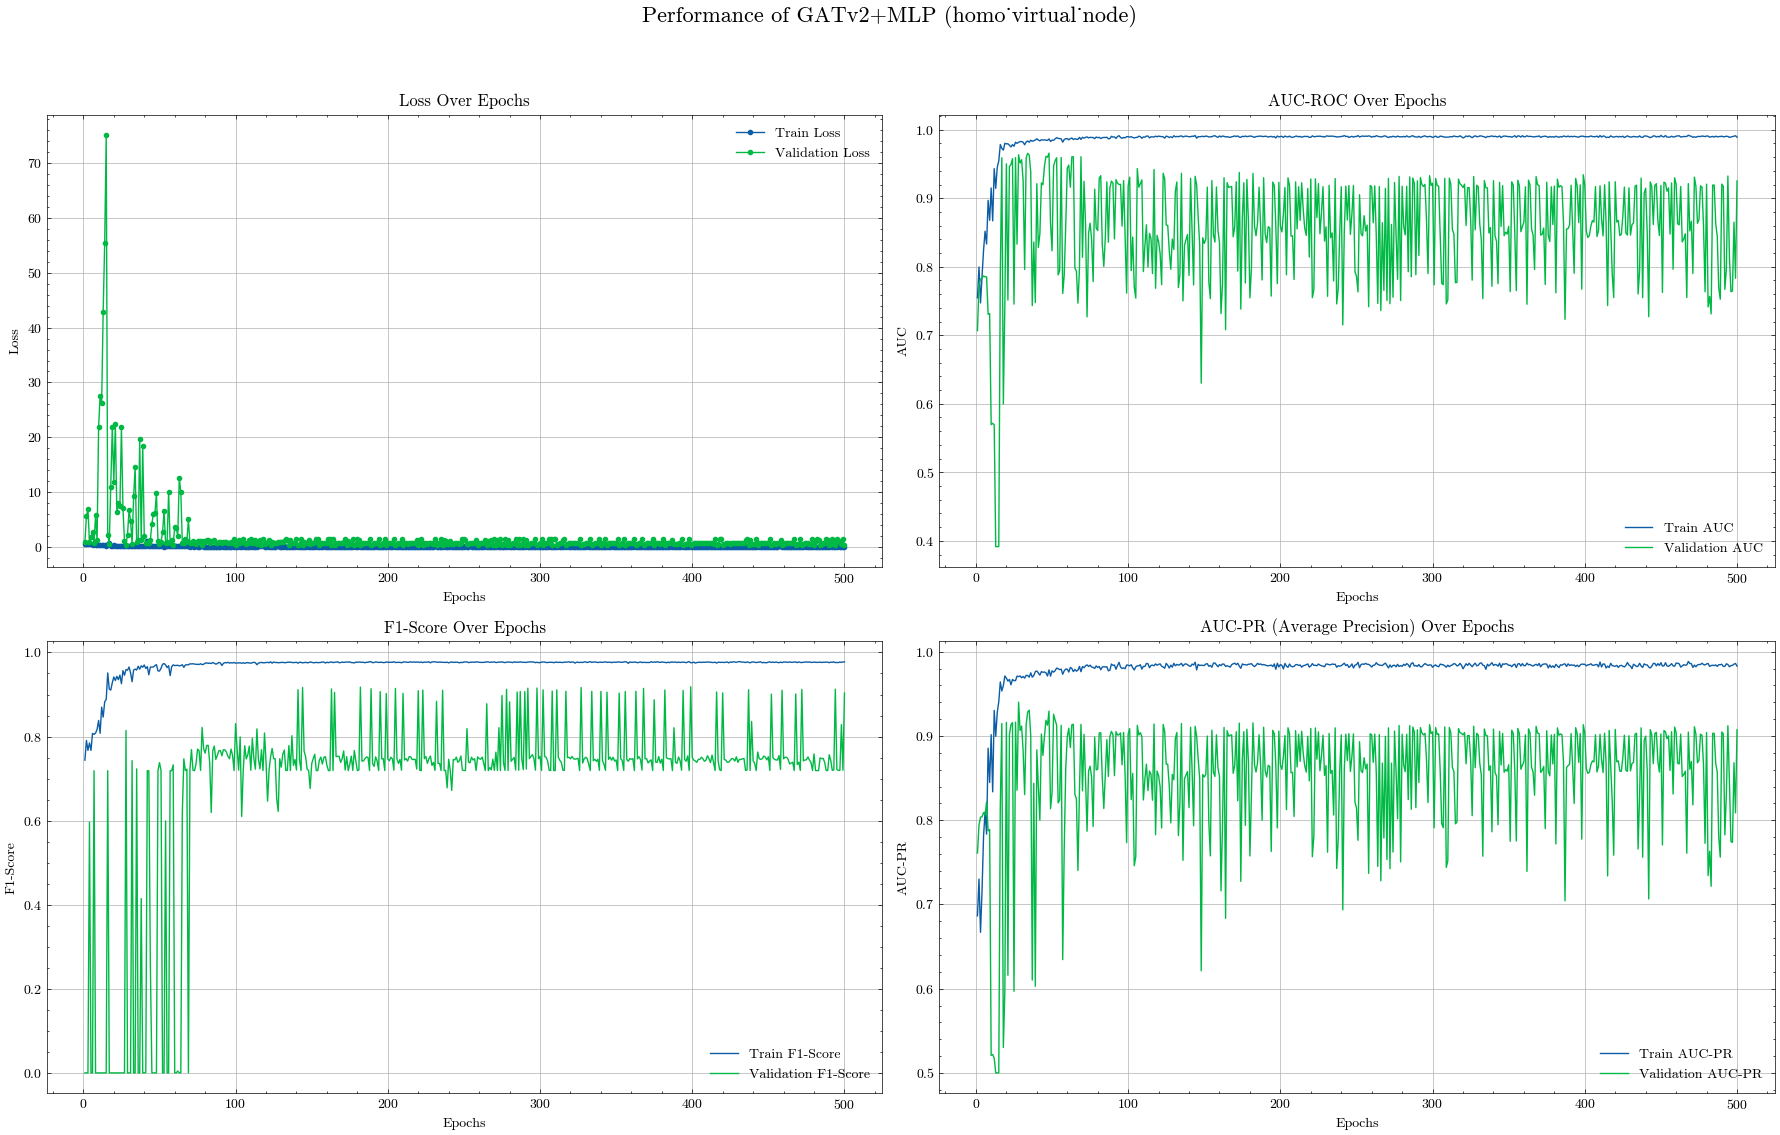

Plot saved to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/plots/homo_virtual_node/GraphConv_MLP_performance_plots.png


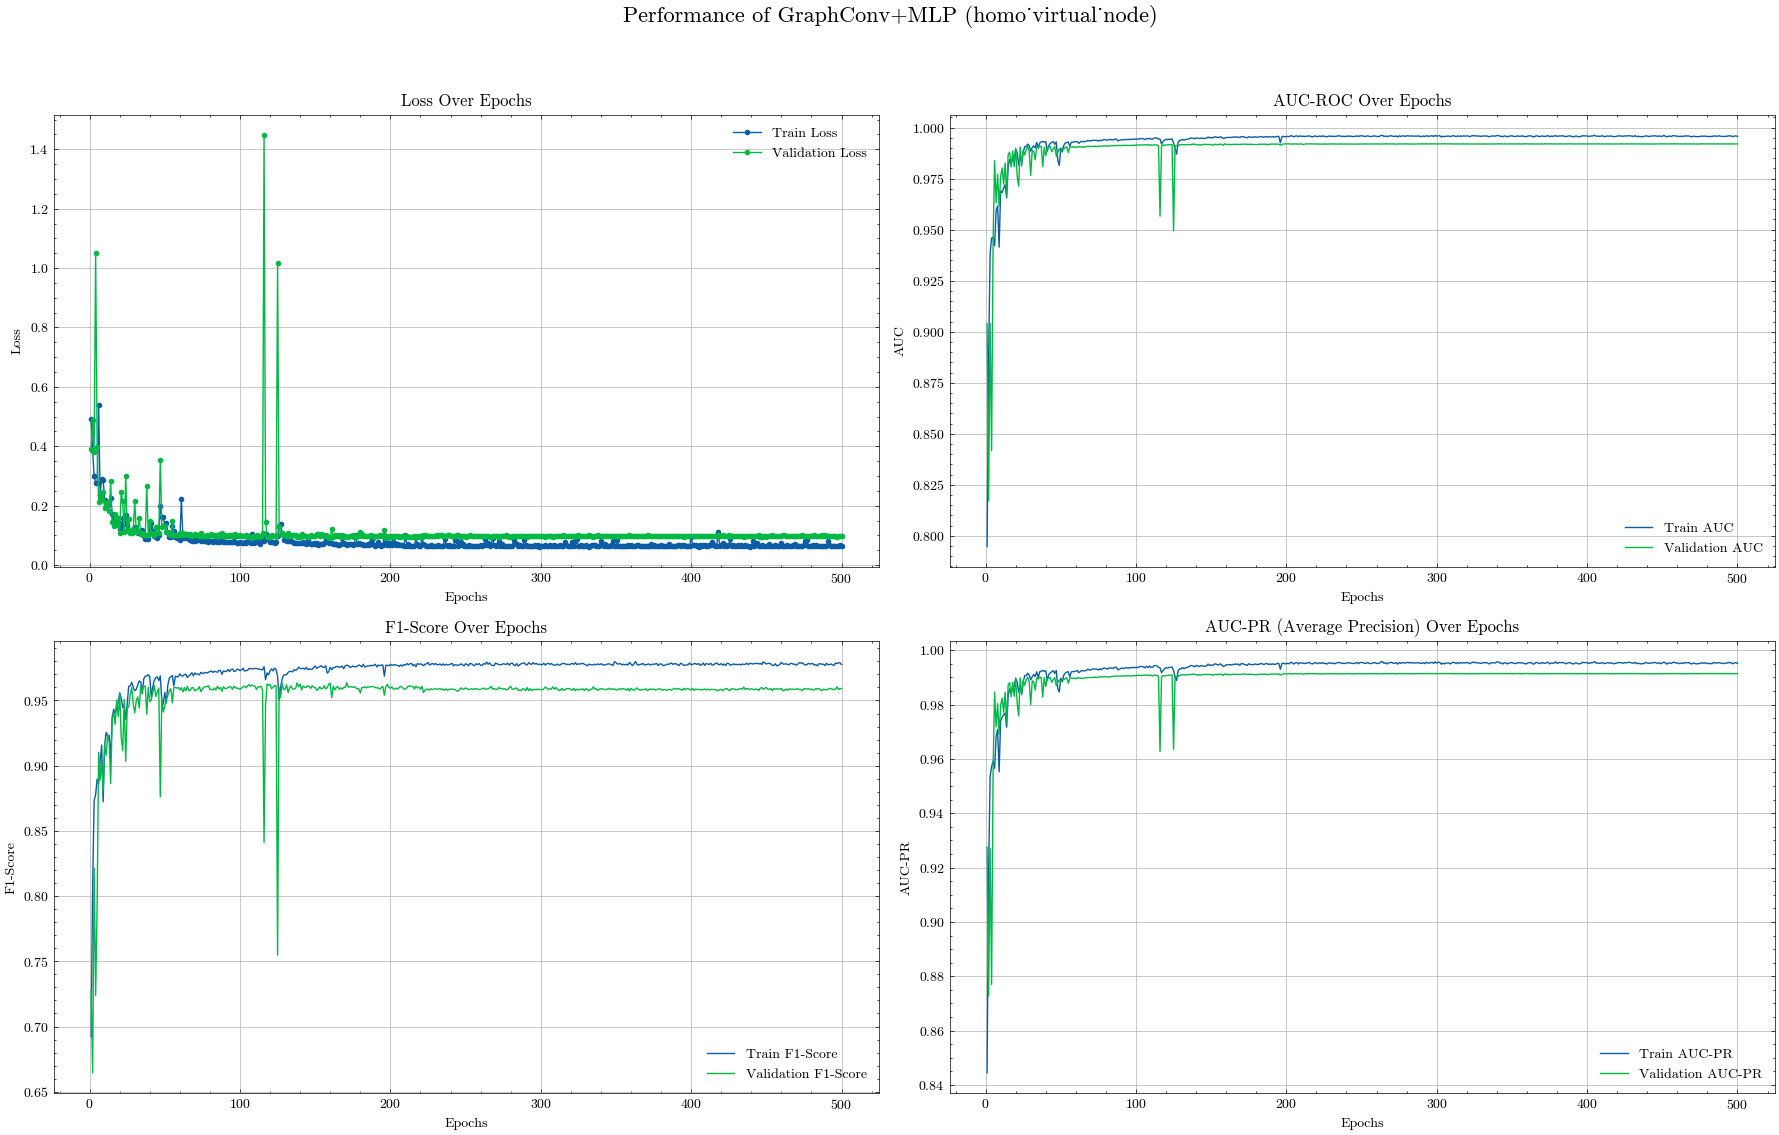

Plot saved to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/plots/homo_virtual_node/SAGEConv_MLP_performance_plots.png


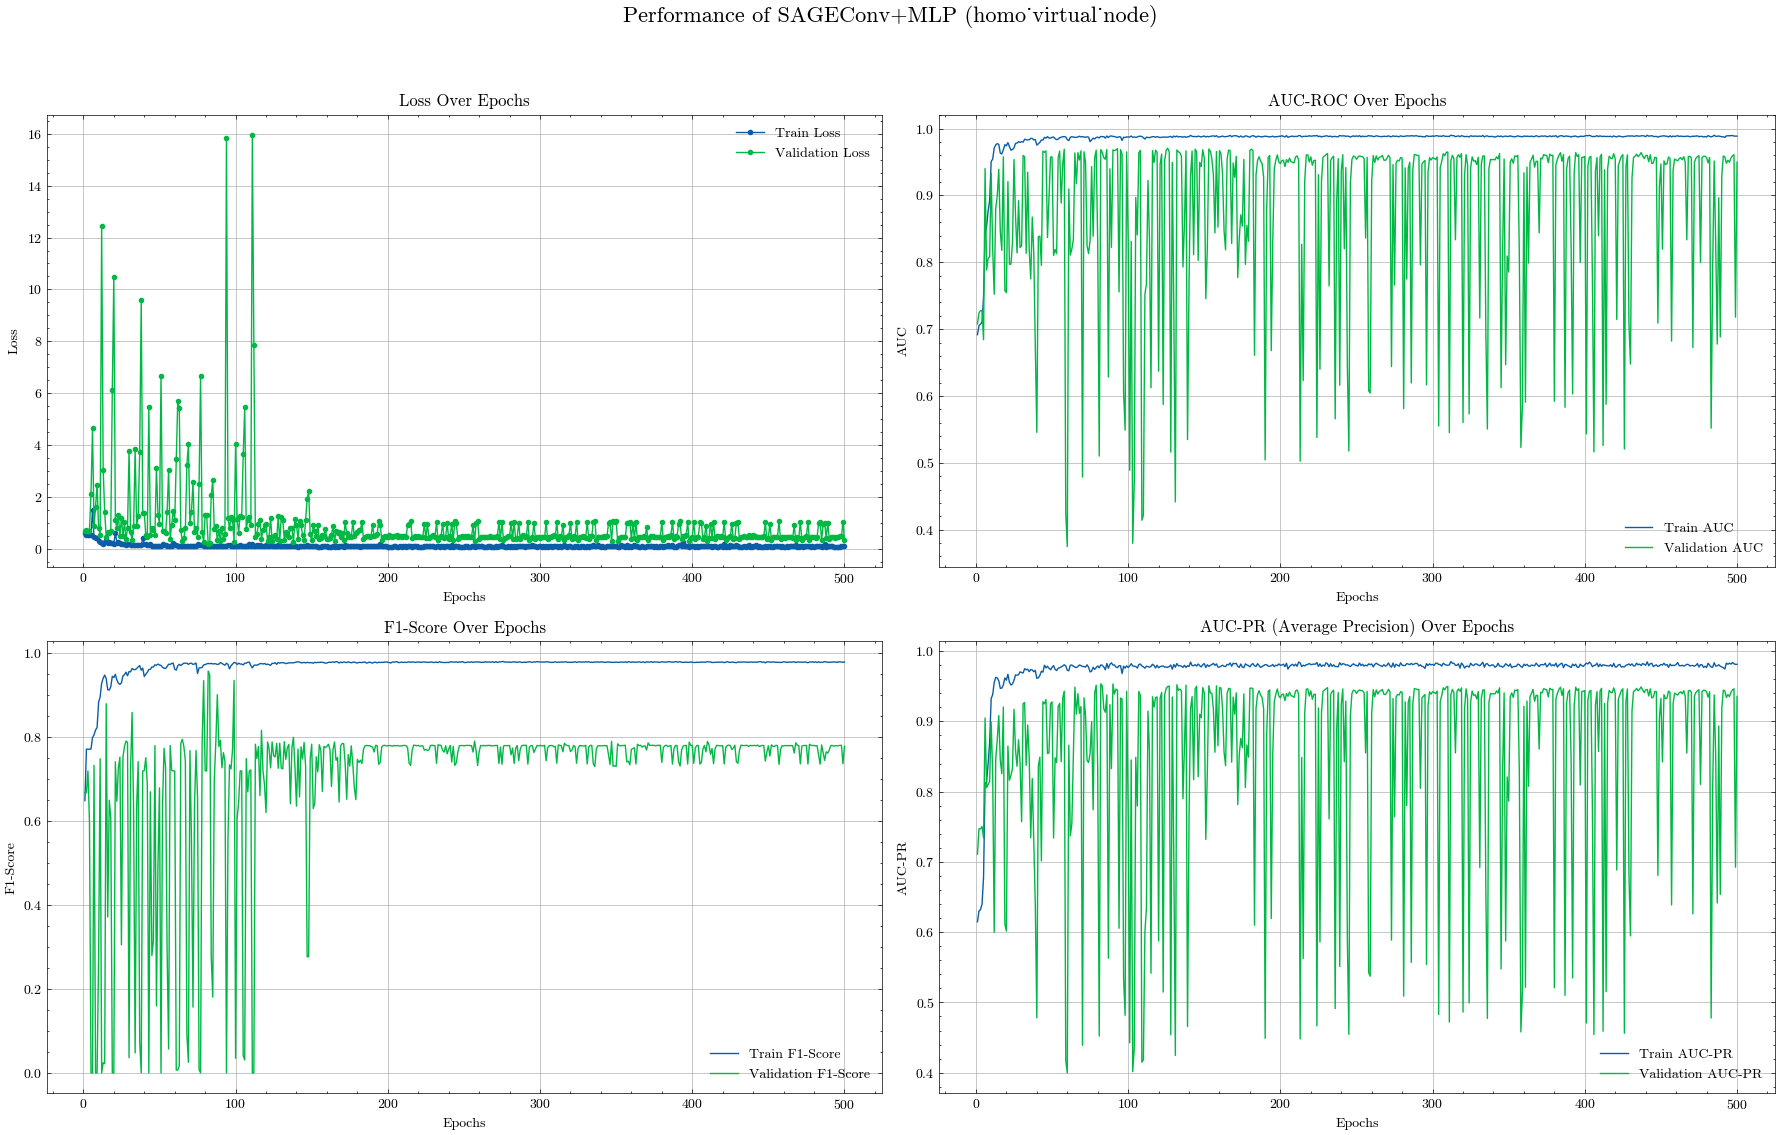

In [ ]:
all_model_results = final_results_for_plotting

if 'all_model_results' in locals() and all_model_results:
    for model_name, results_data in all_model_results.items():
        # Construct a unique filename for each model's plot
        plot_filename = os.path.join(full_plot_save_path, f"{model_name.replace('+', '_')}_performance_plots.png")

        # Call the plotting function with the save path
        plot_metrics_over_time(
            results_data,
            f'Performance of {model_name} ({experiment_name})',
            save_path=plot_filename
        )
else:
    print("\n'all_model_results' dictionary not found. Skipping plot generation.")


--- Generating Model Comparison Plot (Accuracy & F1-Score) ---
Comparison plot saved to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/plots/homo_virtual_node/model_comparison_acc_f1.png


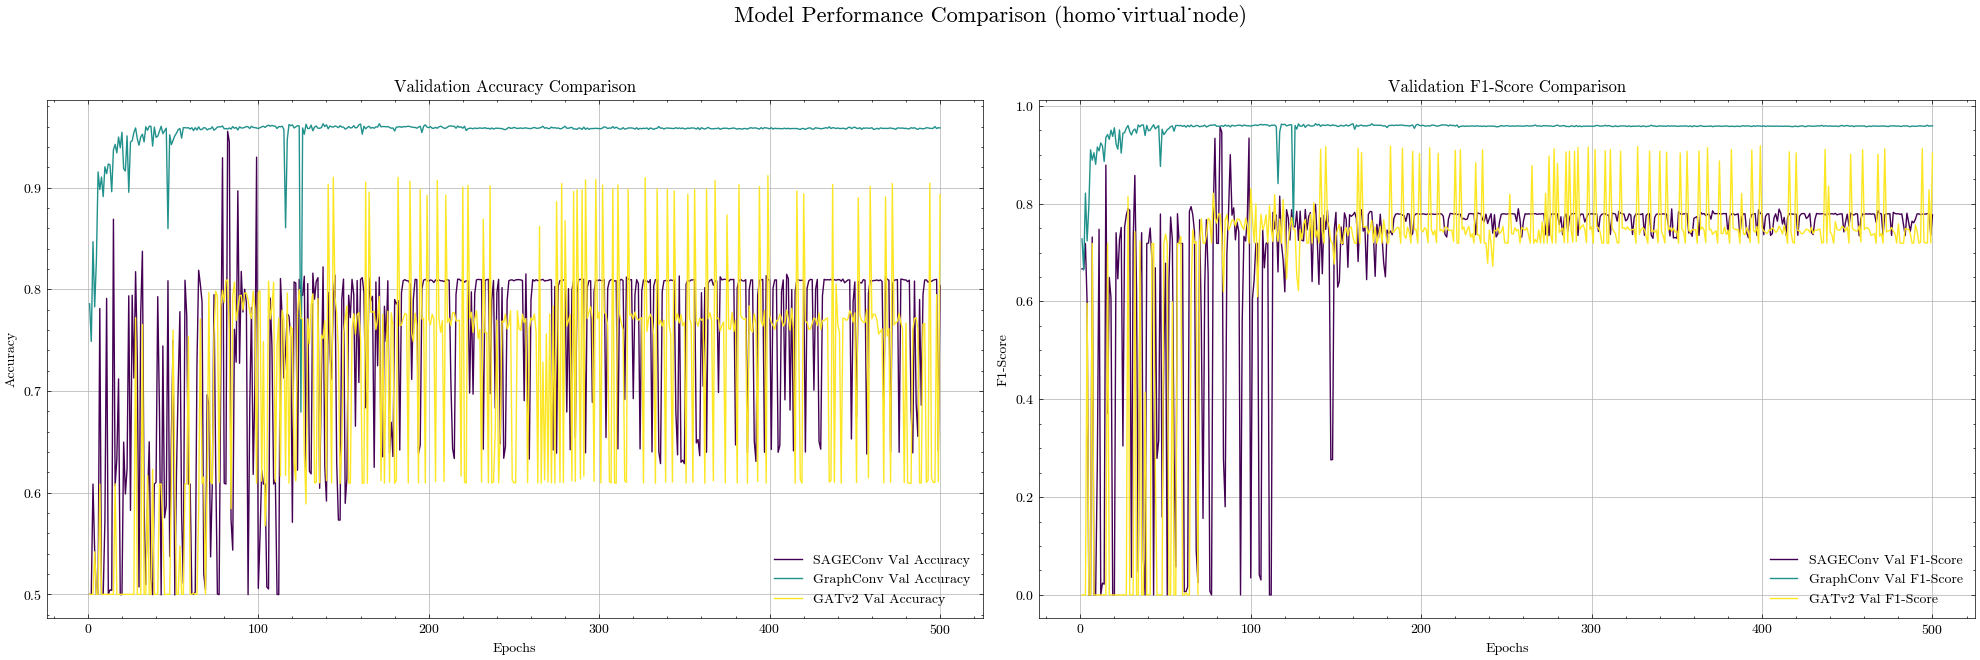

In [ ]:
if 'all_model_results' in locals() and isinstance(all_model_results, dict) and all_model_results:
    print("\n--- Generating Model Comparison Plot (Accuracy & F1-Score) ---")

    # Create the dictionary structure your original code used
    comparison_results_dict = {
         'SAGEConv': all_model_results.get("SAGEConv+MLP"),
         'GraphConv': all_model_results.get("GraphConv+MLP"),
         'GATv2': all_model_results.get("GATv2+MLP")
    }

    # Filter out any models that didn't have results to prevent errors
    comparison_results_dict = {k: v for k, v in comparison_results_dict.items() if v}

    if comparison_results_dict:
        comparison_plot_filename = os.path.join(full_plot_save_path, "model_comparison_acc_f1.png")
        plot_accuracy_f1_over_epoch(
            comparison_results_dict,
            f'Model Performance Comparison ({experiment_name})',
            save_path=comparison_plot_filename
        )
    else:
        print("No results available for comparison plot.")
else:
    print("\n'all_model_results' dictionary not found. Skipping comparison plot generation.")

In [ ]:
# This is the dictionary produced by your new training routine.
all_model_results = final_results_for_plotting

# --- This section now correctly calls the updated summary function ---
all_model_detailed_results = []
if 'all_model_results' in locals() and isinstance(all_model_results, dict) and all_model_results:
    print(f"Found {len(all_model_results)} model results to process.")
    for model_name, results_data in all_model_results.items():
        summary = extract_detailed_validation_summary(
            results_data,
            model_name,
            k_value=k_for_precision_at_k
        )
        if summary:
            all_model_detailed_results.append(summary)
else:
    print("Warning: 'all_model_results' (or 'final_results_for_plotting') dictionary not found or is empty.")


if all_model_detailed_results:
    summary_df_detailed = pd.DataFrame(all_model_detailed_results)
    summary_df_detailed = summary_df_detailed.set_index("Model")

    # Define a desired column order for the report
    column_order_detailed = [
        "Best Epoch (by Val AUC-PR)", "Val AUC-PR", "Val AUC", "Val F1",
        f"Val P@{k_for_precision_at_k}", "Val Acc", "Val Loss",
        "Val TP", "Val TN", "Val FP", "Val FN"
    ]

    # Filter to only include columns that actually exist in the DataFrame
    existing_columns = [col for col in column_order_detailed if col in summary_df_detailed.columns]
    summary_df_detailed = summary_df_detailed[existing_columns]

    # --- Print the Table to Console ---
    print(f"\n--- Detailed Model Performance Summary (K={k_for_precision_at_k}) ---")
    float_format_cols = summary_df_detailed.select_dtypes(include=['float']).columns
    # Custom formatters: 4 decimal places for most floats, integers for TN/TP/FP/FN
    formatters_detailed = {col: "{:.4f}".format for col in float_format_cols}
    for cm_col in ["Val TP", "Val TN", "Val FP", "Val FN"]:
        if cm_col in summary_df_detailed.columns: # Check if column exists
            formatters_detailed[cm_col] = "{:.0f}".format
    print(summary_df_detailed.to_string(formatters=formatters_detailed, na_rep='N/A'))

    # --- Save the DataFrame to JSON ---
    # 1. Define base save path for JSON files
    json_save_path = os.path.join(parent_dir_of_utils, "json")
    os.makedirs(json_save_path, exist_ok=True) # Ensure directory exists

    # 2. Construct a dynamic filename based on the experiment configuration
    path_part1 = "homo" if homogenous else "hetero"
    path_part2 = ""
    if homogenous:
        path_part2 = "_virtual_node" if VirtualNode else "_noVirtual_node"
    else:
        path_part2 = "_noVirtual_node"
    path_part3 = "" if use_augmented_features else "_noGemini"

    json_filename = f"summary_{path_part1}{path_part2}{path_part3}.json"
    full_json_path = os.path.join(json_save_path, json_filename)

    # 3. Save the DataFrame to JSON
    try:
        summary_df_detailed.to_json(full_json_path, orient='index', indent=4)
        print(f"\nSuccessfully saved summary table to: {full_json_path}")
    except Exception as e:
        print(f"\nError saving summary to JSON: {e}")

else:
    print("\nNo data to display or save. No valid model results were processed.")

Found 3 model results to process.

--- Detailed Model Performance Summary (K=10) ---
               Best Epoch (by Val AUC-PR) Val AUC-PR Val AUC Val F1 Val P@10 Val Acc Val Loss Val TP Val TN Val FP Val FN
Model                                                                                                                    
GATv2+MLP                              28     0.9402  0.9635 0.8144   0.9000  0.7722   0.4224   1793    976    817      0
GraphConv+MLP                         304     0.9914  0.9921 0.9596   1.0000  0.9593   0.0979   1732   1708     85     61
SAGEConv+MLP                           82     0.9535  0.9686 0.9564   1.0000  0.9554   0.1836   1753   1673    120     40

Successfully saved summary table to: /content/drive/MyDrive/Projects/GNN-Gene-Disease/json/summary_homo_virtual_node.json
